<a href="https://colab.research.google.com/github/ronitagarwala01/NASA_GCN_NLP/blob/main/InformationExtractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp /content/drive/MyDrive/archive.json.tar.gz /content
!cp /content/drive/MyDrive/swift_redshift_data.csv /content

# **Information Extraction Pipeline for the NASA GCN Platform**
The goal of this project is to extract important information from NASA GCN circulars for the purpose of automated data entry into the archive, which is currently done manually.

It is recommended to run this notebook in Google Colab. Please not that before running this notebook you will need to set up a free HuggingFace account and create an access token to pull down models from Huggingface. More info can be found here: https://huggingface.co/docs/hub/en/security-tokens. Store your token in Google Colab's Secrets as HF_LOGIN_TOKEN and turn on notebook access. More info found here: https://drlee.io/how-to-use-secrets-in-google-colab-for-api-key-protection-a-guide-for-openai-huggingface-and-c1ec9e1277e0.

To get results consistent with those reported in the paper, it is recommended to run each section in this notebook sequentially and only once. Re-running it without restarting the runtime may yield slightly different results in certain sections due to the inherently stochastic nature of some of the agorithms used. We also recommend using Google Colab's L4 GPU runtime, which is what we used in our work. This is not a requirement and any GPU runtime may suffice, however using a different runtime may once again produce minor deviations from the results in our paper, as variations in hardware configurations can affect the outcomes of some of the algorithms used. Using the L4 GPU, however, may require the purchase of a temporary subscription to Colab Pro for $10.

#Step 1: Install and Import Libraries and Models

In [3]:
!pip install --upgrade langchain==0.2.1 -qqq
!pip install langchain-community==0.2.1 -qqq
!pip install langchain-core==0.2.1 -qqq
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.2.76 -qqq
!wget https://huggingface.co/TheBloke/Mistral-7B-Instruct-v0.2-GGUF/resolve/main/mistral-7b-instruct-v0.2.Q4_K_M.gguf
!pip install sentence-transformers==2.2.2 -qqq
!pip install faiss-cpu==1.8.0.post1 -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.5/973.5 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.8/321.8 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.5/308.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 33.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 7.0 MB/s eta 0:00:00
--2024-0

In [4]:
import pandas as pd
import tarfile
import os
import json
from langchain.prompts import PromptTemplate
from langchain_community.llms import LlamaCpp
from langchain.output_parsers import ResponseSchema
from langchain.output_parsers import StructuredOutputParser
from transformers import AutoTokenizer
import re
from datetime import datetime
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from huggingface_hub import login
from google.colab import userdata
import torch
import random
import numpy as np

# Huggingface login required to use Mistral 7B Instruct
# Make sure to save your own Huggingface login token in your Notebook's Secrets as 'HF_LOGIN_TOKEN'
login_token = userdata.get('HF_LOGIN_TOKEN')
login(token=login_token)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


#Step 2: Extract Data

In [5]:
'''
Extract circular JSONs from tar file.
'''

with tarfile.open('./archive.json.tar.gz', 'r') as file:
  file.extractall(path='./all_gcn_circulars')

dir = os.listdir('./all_gcn_circulars/archive.json') #Store all file names as strings in dir

#Add file path to beginning of file names in dir
dir = ['./all_gcn_circulars/archive.json/' + filename for filename in sorted(dir)]

print(f'Number of Circular JSONs: {len(dir)}\n')
print(f'First JSON path is: {dir[0]}')

Number of Circular JSONs: 35470

First JSON path is: ./all_gcn_circulars/archive.json/-1.json


In [6]:
'''
Extract circular bodies from JSON list.
'''

circulars = [] # List of jsons
circular_bodies= [] # List of texts
for file in dir:
  with open(file, encoding='utf-8') as f:
    data = json.load(f)
    circulars.append(data)
    circular_bodies.append(data["subject"]+data["body"])

print(f'The first circular is:\n {circulars[0]}\n')
print(f'The first circular body is:\n {circular_bodies[0]}')

The first circular is:
 {'subject': 'Untitled', 'createdOn': 0, 'submitter': 'circulars@gcn.nasa.gov', 'circularId': -1, 'email': 'circulars@gcn.nasa.gov', 'body': '#-01\n\nThe following report from A. Hendon et al. on the recent "possible new SGR"\n(ref IAUC 6743) has also been submitted to the IAUC:\n\n\nA. Henden, Universities Space Research Corporation (USRA) and U. S. Naval\nObservatory, Flagstaff Station (USNOFS)  aah@nofs.navy.mil\nC. Luginbuhl, USNOFS  cbl@nofs.navy.mil\nF. Vrba, USNOFS       fjv@nofs.navy.mil\nB. Canzian, USRA/USNOFS  bjc@nofs.navy.mil\nJ. Munn USNOFS           jam@nofs.navy.mil\nD. Hartmann, Clemson University  hartmann@grb.phys.clemson.edu\n\nWe report a strong near-IR source about 2 arcmin from the the center\nof the IPN error box for GRB970912 (IAUC 6743), located at RA = 18:14:50.31,\nDEC = -13:41:05.6 (J2000, +-0.5arcsec).  JHK images saturate in our shortest\navailable exposure (0.16 sec), but we estimate approximate magnitudes\nof J = 7.4, H = 6.0, K =

In [7]:
'''
Remove all undefined characters.
'''

clean_texts = []
for text in circular_bodies:
  clean_text = text.replace('�', '')
  clean_texts.append(clean_text)

circular_bodies = clean_texts

In [8]:
'''
Extract table data from csv file.
This will contain our evaluation data for the model.
'''

swift_df = pd.read_csv('swift_redshift_data.csv', skiprows=0, header=0)
swift_df.head(10)

GRB  Time[UT] TriggerNumber        BAT RA(J2000)        BAT Dec(J2000)  \
0  230818A  23:27:34       1186032  285.888\n19:03:33.1    40.888\n40:53:16.8   
1  230506C  17:09:19       1167288  134.371\n08:57:29.0    45.131\n45:07:51.6   
2  230414B  16:14:21       1164180  181.052\n12:04:12.5    53.179\n53:10:44.4   
3  230328B  14:54:48       1162001  291.037\n19:24:08.9    80.013\n80:00:46.8   
4  230325A   3:15:35       1161390  296.854\n19:47:25.0  -46.067\n-46:04:01.2   
5  230116D  21:04:43       1149293   98.584\n06:34:20.2    49.831\n49:49:51.6   
6  221226B  22:41:20       1145959   22.903\n01:31:36.7  -41.515\n-41:30:54.0   
7  221110A   2:28:17       1136936   29.106\n01:56:25.4  -27.298\n-27:17:52.8   
8  221009A  14:10:17       1126853  288.254\n19:13:01.0    19.809\n19:48:32.4   
9  220611A  18:01:51       1110090   66.505\n04:26:01.2  -37.265\n-37:15:54.0   

  BAT T90[sec]  BAT Fluence(15-150 keV)[10-7 erg/cm2] XRT RA(J2000)  \
0         9.82                                  19.00       03:33.1   
1           31                                  17.00       57:28.2   
2        25.98                                   4.70       04:22.7   
3        19.23                                  43.00       24:01.6   
4        38.05                                  13.00       47:23.9   
5           41                                   8.12       34:28.3   
6         3.44                                   5.40       31:38.1   
7         8.98                                   5.10       56:23.8   
8       1068.4                                 740.00       13:03.9   
9           57                                   6.70       26:03.5   

  XRT Dec(J2000)  XRT Time to FirstObservation[sec]  \
0        53:48.3                             141.12   
1        07:58.6                            4600.00   
2        09:15.7                             128.57   
3        00:34.4                             110.33   
4    -46:04:33.9                              94.05   
5        52:22.3                             130.90   
6    -41:31:36.0                             102.93   
7    -27:17:44.5                              53.05   
8        46:22.7                              91.60   
9    -37:15:35.6                             149.22   

   XRT Early Flux(0.3-10 keV)[10-11 erg/cm2/s] UVOT RA(J2000) UVOT Dec(J2000)  \
0                                          NaN        03:33.1         53:49.0   
1                                          NaN            NaN             NaN   
2                                          NaN            NaN             NaN   
3                                          NaN        24:01.9         00:34.6   
4                                        206.0            NaN             NaN   
5                                          NaN            NaN             NaN   
6                                          NaN            NaN             NaN   
7                                         79.1        56:23.7    -27:17:45.09   
8                                       2510.0        13:03.5         46:24.6   
9                                          NaN            NaN             NaN   

  UVOT Time toFirst Observation[sec] UVOT Magnitude  \
0                                144        V=18.40   
1                               4600         V>19.2   
2                                133        V>18.53   
3                                114         V>17.6   
4                                102         V>18.9   
5                                133            NaN   
6                                 76         V>19.3   
7                                 83         V>19.5   
8                                179       V= 15.55   
9                                153         V>17.0   

                        Other Observatory Detections  \
0  MASTER-Tavrida, Fermi (GBM), GOTO, SAO RAS Zei...   
1       TSHAO Zeiss-1000, D50, T193-OHP, Fermi (GBM)   
2  Mondy/AZT-33IK, Nanshan/HMT (0.5m), GROWTH-Ind...   
3  Fe

In [9]:
'''
Get smaller dataframe with relevant information only.
This section converts the SWIFT GRB Table to a python dict.
The end result is a dict with key = GCN No. and value = Redshift, Telescope, and GRB Information as Text.
'''

sub_df = swift_df[['References', 'Redshift', 'GRB']].copy()
removed_list = []
removed_indices=[]
gcn_format = re.compile('GCN ?\d+( *\(.*?\))?')
gcn_number_format = re.compile('GCN ?(\d+)')
bracket_format = re.compile(' ?\([^)]*\)')
instrument_format_1 = re.compile('\((.*?)\)')
instrument_format_2 = re.compile('\(([^):]*)')
redshift_type_format = re.compile('')

# Extract just the Redshift References from the References column
for index, row in sub_df.iterrows():
  row['References'] = row['References'].splitlines()
  row['Redshift'] = row['Redshift'].splitlines()

  temp=''
  for line in row['References']: # Extract only redshift references
    if line[0:8] == 'Redshift':
      temp = line
  if temp != '':
    row['References'] = temp

  if isinstance(row['References'], list): # Drop the non-uniform data for now
    removed_list.append((row['References'], row['Redshift'], row['GRB']))
    removed_indices.append(index)

redshift_list = [] # List of tuples
sub_df = sub_df.drop(removed_indices)

# Create a list of tuples
# Each tuple contains a GCN No. with it's corresponding Redshift Text and GRB Name
for index, row in sub_df.iterrows():
  gcn_iter = gcn_format.finditer(row['References'])
  gcns = list(gcn_iter)

  # References with only one circular don't need any further iteration
  if len(gcns) == 1 and len(row['Redshift']) == 1:
    gcn_num_match = gcn_number_format.search(gcns[0].group())
    instrument_match_1 = instrument_format_1.search(gcns[0].group())
    instrument_match_2 = instrument_format_2.search(row['Redshift'][0])
    instrument_name = ''
    if instrument_match_1 == None and instrument_match_2 == None: # Drop references with no instrument name for now
      removed_list.append((row['References'], row['Redshift'], row['GRB']))
      continue

    elif instrument_match_1 != None:
      instrument_name = instrument_match_1.group(1)

    elif instrument_match_2 != None:
      instrument_name = instrument_match_2.group(1)

    redshift_type = 'No Information'
    if "absorption" in row["Redshift"][0].lower() or "emission" in row["Redshift"][0].lower():
      redshift_type = "Spectroscopic"
    elif "photometric" in row["Redshift"][0].lower():
      redshift_type = "Photometric"

    gcn_num = gcn_num_match.group(1)
    redshift_text = bracket_format.sub('', row['Redshift'][0])
    grb_name = row['GRB']

    if len(redshift_text.split(',')) != 1: # Drop the non-uniform data for now
      removed_list.append((row['References'], row['Redshift'], row['GRB']))
      continue

    redshift_list.append((gcn_num, redshift_text.strip().lower(), grb_name.strip(), instrument_name.strip(), redshift_type.strip()))

  # If multiple circulars are present, iterate through them all
  else:
    for gcn in gcns:
      for redshift in row['Redshift']:

        # Extract instrument name from reference
        instrument_match_1 = instrument_format_1.search(gcn.group())
        if instrument_match_1 == None:
          continue
        instrument_name_1 = instrument_match_1.group(1)

        # Extract instrument name from redshift text
        instrument_match_2 = instrument_format_2.search(redshift)
        if instrument_match_2 == None:
          continue
        instrument_name_2 = instrument_match_2.group(1)

        # Check to see if both instruments match. If yes, append tuple to list
        if instrument_name_1 == instrument_name_2:
          gcn_num_match = gcn_number_format.search(gcn.group())
          gcn_num = gcn_num_match.group(1)
          redshift_text = bracket_format.sub('', redshift)
          grb_name = row['GRB']
          redshift_type = 'No Information'
          if "absorption" in redshift.lower() or "emission" in redshift.lower():
            redshift_type = "Spectroscopic"
          elif "photometric" in redshift.lower():
            redshift_type = "Photometric"

          redshift_list.append((gcn_num, redshift_text.strip().lower(), grb_name.strip(), instrument_name_1.strip(), redshift_type.strip()))

# Create Redshift Dict
redshift_dict = {} # Dict for redshift data
removed_circulars = ['21209', '12542', '11997', '6651', '5946'] #Indices that need manual re-entry
for data_tuple in redshift_list:
  if data_tuple[0] in removed_circulars:
    removed_list.append(data_tuple)
  else:
    redshift_dict[data_tuple[0]] = (data_tuple[1], data_tuple[2], data_tuple[3], data_tuple[4])

for item in removed_list:
  print(item)

print(len(removed_list))
print(len(redshift_dict))

(['BAT: GCN 29677; GCN 29691', 'XRT: GCN 29678; GCN 29681; GCN 29686; Evans et al., 2009, MNRAS, 397, 1177', 'UVOT: GCN 29679; GCN 29697', 'Radio: GCN 29685 (OSIRIS/GTC)'], ['1.487 (OSIRIS/GTC)'], '210321A')
(['BAT: GCN 19645; GCN 19648', 'XRT: GCN 19655; Evans et al., 2009, MNRAS, 397, 1177', 'UVOT: GCN 19645; GCN 19656', 'Radio: GCN 19849 (GMRT)'], ['The detection in all UVOT filters is consistent with a redshift of z < ~1.5'], '160703A')
(['BAT: GCN 18076; GCN 18086', 'XRT: GCN 18076; GCN 18079; GCN 18082; Evans et al., 2009, MNRAS, 397, 1177', 'UVOT: GCN 18076; GCN 18084', 'Radio: GCN 18080 (VLT)'], ['0.313 (VLT: emission)'], '150727A')
('Redshift: GCN 33609', ['Minimal possible redshift value of z = 0.09'], '230328B')
('Redshift: GCN 26538 (UVOT); GCN (VLT)', ['1.19 (UVOT), 1.148 (VLT: absorption)'], '191221B')
('21209', 'consistent with gtc results', '170531B', 'WHT', 'No Information')
('12542', 'consistent with gemini-south', '111107A', 'VLT', 'Spectroscopic')
('11997', '1.61, p

In [10]:
print(redshift_dict["5319"])

('z<2.3', '060708', 'VLT', 'No Information')


In [11]:
'''
Add back removed data points after manual lookup
'''

redshift_dict['29685'] = ('1.487', '210321A', 'OSIRIS/GTC', 'No Information')
redshift_dict['18080'] = ('0.313', '150727A', 'VLT', 'Spectroscopic')
redshift_dict['26538'] = ('1.19', '191221B', 'UVOT', 'Spectroscopic')
redshift_dict['21209'] = ('consistent with that obtained by de ugarte-postigo et al. (gcn 21177)', '170531B', 'WHT', 'No Information')
redshift_dict['12542'] = ('consistent with that reported by chornock et al. (gcn 12537)', '111107A', 'VLT', 'Spectroscopic')
redshift_dict['11997'] = ('1.61', '110503A', 'TNG', 'Spectroscopic')
redshift_dict['6651'] = ('3.626', '070721B', 'VLT', 'No Information')
redshift_dict['5946'] = ('0.41', '061210', 'Keck', 'Spectroscopic')
redshift_dict['19656'] = ('z < ~1.5', '160703A', 'UVOT', 'No Information')

print(len(redshift_dict))
print(redshift_dict['23537'])

547
('<2.4', '181213A', 'NOT', 'No Information')


In [12]:
'''
Get redshift circulars with no redshift data.
These circulars are manually selected and the data extracted is added to the evaluation table.
'''

no_redshift_circulars = []
no_redshift_circular_bodies = []
no_redshift_list = [1, 10, 100, 1000, 10000, 10001, 10002, 10003, 10004, 10005,
                    10006, 10007, 10008, 10009, 10010, 10011, 10012, 10013, 10014, 10015,
                    10016, 10017, 10018, 10019, 10020, 10021, 10022, 10023, 10024, 10025,
                    10026, 10027, 10028, 10029, 1003, 10030, 10034, 10035, 10036, 10037,
                    10039, 1004, 10040, 10043, 10044, 10046, 10047, 10048, 1005, 10050,
                    10051, 10052, 10058, 10059, 10060, 10061, 10062, 10063, 10064, 10066,
                    10067, 10068, 1007, 10070, 10071, 10072, 10073, 10074, 10075, 10076,
                    10077, 10078, 10079, 1008, 10080, 10081, 10082, 10084, 10085, 10086,
                    10087, 10088, 10089, 1009, 10090, 10091, 10092, 10094, 10095, 10096,
                    10097, 10098, 10099, 101, 10101, 10102, 10103, 10104, 10105, 10106]

for i, text in enumerate(circular_bodies):
  if circulars[i]["circularId"] in no_redshift_list:
    no_redshift_circulars.append(circulars[i])
    no_redshift_circular_bodies.append(text)

print(len(no_redshift_circulars))

100


In [13]:
'''
Build our final evaluation dictionary by appending no redshift circulars.
'''

eval_dict = redshift_dict.copy()
for circular in no_redshift_circulars:
  eval_dict[str(circular["circularId"])] = ("No Redshift", "No Information", "No Information", "No Information")

print(len(eval_dict))
print(eval_dict["10106"]) # Circular with no reported redshift

647
('No Redshift', 'No Information', 'No Information', 'No Information')


In [14]:
'''
Get list of test circulars.
'''

test_circulars = []
test_circular_bodies = []
for circular, body in zip(circulars, circular_bodies):
  if str(circular["circularId"]) in list(eval_dict.keys()):
    test_circulars.append(circular)
    test_circular_bodies.append(body)

print(len(test_circulars))

645


Note: Two circulars - GCN 20589 and GCN 18506 - are not in our tarfile. Thus we skip them.

#Step 3: Instantiate Llama CPP Model for Information Extraction

In [15]:
'''
Instantiate LlamaCpp object for inference.
We use the quantized mistral-7b-instruct model.
'''

max_context_length = 32768
llm = LlamaCpp(model_path="mistral-7b-instruct-v0.2.Q4_K_M.gguf",
               n_gpu_layers=-1,
               n_ctx=max_context_length)

llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from mistral-7b-instruct-v0.2.Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:                 l

#Step 4: LLM Testing using LangChain

We'll use the LangChain library to query a circular and extract redshift information from it.

In [16]:
'''
Create prompt template which accepts a single circular as input.
'''

template_string = """Q: This is a circular from NASA:

{circular}

Given the above information, can you state what the observed redshift was? \
If there is no answer just say no redshift was observed. \
If you find a redshift, also mention the name of the telescope used for \
observation, as well as the GRB number. \
Also mention whether the redshift was photometric or spectroscopic.\

A: """

prompt_template = PromptTemplate.from_template(template_string)

prompt_template

PromptTemplate(input_variables=['circular'], template='Q: This is a circular from NASA:\n\n{circular}\n\nGiven the above information, can you state what the observed redshift was? If there is no answer just say no redshift was observed. If you find a redshift, also mention the name of the telescope used for observation, as well as the GRB number. Also mention whether the redshift was photometric or spectroscopic.\nA: ')

In [17]:
'''
Test model.
'''

prompt = prompt_template.format(circular=test_circular_bodies[300])
model_output = llm(prompt,
                   max_tokens=256,
                   temperature=0.0,
                   stop=["Q:"])

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(

llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      28.63 ms /    53 runs   (    0.54 ms per token,  1851.14 tokens per second)
llama_print_timings: prompt eval time =   12308.63 ms /   296 tokens (   41.58 ms per token,    24.05 tokens per second)
llama_print_timings:        eval time =    1125.04 ms /    53 runs   (   21.23 ms per token,    47.11 tokens per second)
llama_print_timings:       total time =   13519.78 ms /   349 tokens


In [18]:
print(prompt)

Q: This is a circular from NASA:

GRB 151027A: Keck/HIRES redshiftD. A. Perley (DARK/NBI), L. Hillenbrand (Caltech), and J. X. Prochaska 
(UCO/Lick) report:

We obtained a 900s spectrum of the optical afterglow of GRB 151027A 
(Maselli et al., GCN 18478) with Keck/HIRES starting at UT 06:54 on 
2015-10-27.  In the preliminary reduction, we identify a series of 
strong absorption lines including the MgII doublet at z=0.81. Associated 
MgI, FeII, and (likely) FeII* are also present, indicating that this is 
the redshift of the GRB.  Analysis is ongoing.

Given the above information, can you state what the observed redshift was? If there is no answer just say no redshift was observed. If you find a redshift, also mention the name of the telescope used for observation, as well as the GRB number. Also mention whether the redshift was photometric or spectroscopic.
A: 


In [19]:
print(model_output.strip())

The observed redshift was z=0.81. The observation was made using Keck/HIRES telescope. The GRB number is 151027A. The redshift was obtained through spectroscopic analysis.


In [20]:
test_gcn_num = str(test_circulars[300]["circularId"])
print(f"Actual Values for Redshift, GRB Number and Telescope Name respectively: {eval_dict[test_gcn_num]}")

Actual Values for Redshift, GRB Number and Telescope Name respectively: ('0.81', '151027A', 'Keck', 'Spectroscopic')


The model seems to be working as intended. Next we will try to build a LangChain chain for sequential querying of the circulars.

#Step 5: Parsing LLM Output to Python Dict

In [21]:
'''
Create response schemas to be used by output parser.
From the output parser get the format instructions to be passed to our prompt template.
'''

redshift_value_schema = ResponseSchema(name="Redshift Value", description="Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. \
If multiple measurements are present, only pick the most likely one.")
telescope_schema = ResponseSchema(name="Telescope", description="What was the name of the telescope used for observation? If not provided, answer No Information.")
event_schema = ResponseSchema(name="Event", description="Extract the GRB Number of the event. If not provided, answer No Information.")
redshift_type_schema = ResponseSchema(name="Redshift Type", description="How was the redshift determined? \
Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. \
If there's no information on the redshift type, answer No Information.")

response_schemas = [redshift_value_schema,
                    telescope_schema,
                    event_schema,
                    redshift_type_schema]

output_parser = StructuredOutputParser.from_response_schemas(response_schemas)

format_instructions = output_parser.get_format_instructions()
print(format_instructions)

The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":

```json
{
	"Redshift Value": string  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": string  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": string  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": string  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```


In [22]:
'''
Create a modified prompt template to generate json.
'''

template_string = """Q: This is a circular from NASA:

{circular}

For the given circular, can you extract the following information:

Redshift Value: Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.\
If multiple measurements are present, only pick the most likely one.
Telescope: What was the name of the telescope used for observation? \
Event: Extract the GRB Number of the event. \
Redshift Type: How was the redshift determined? Answer Photometric if it was photometric. \
Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. \
If there's no redshift value, answer No Redshift. If there's no information on the type, answer No Information.

{format_instructions}

A: """

prompt_template = PromptTemplate.from_template(template_string)

prompt_template

PromptTemplate(input_variables=['circular', 'format_instructions'], template="Q: This is a circular from NASA:\n\n{circular}\n\nFor the given circular, can you extract the following information:\n\nRedshift Value: Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.If multiple measurements are present, only pick the most likely one.\nTelescope: What was the name of the telescope used for observation? Event: Extract the GRB Number of the event. Redshift Type: How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the type, answer No Information.\n\n{format_instructions}\n\nA: ")

In [23]:
'''
Test model.
'''

# Set number of threads to 1 and set other os environment variables for reproducibility
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
torch.set_num_threads(1)

seed_value = 42  # Set the random seed
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
torch.use_deterministic_algorithms(True)

prompt = prompt_template.format(circular=test_circular_bodies[300],
                                format_instructions=format_instructions)

model_output = llm(prompt,
                   max_tokens=256,
                   temperature=0.0,
                   stop=["Q:"],
                   seed=0)

Llama.generate: prefix-match hit

llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.75 ms /    71 runs   (    0.52 ms per token,  1931.87 tokens per second)
llama_print_timings: prompt eval time =    1864.06 ms /   382 tokens (    4.88 ms per token,   204.93 tokens per second)
llama_print_timings:        eval time =    1506.14 ms /    70 runs   (   21.52 ms per token,    46.48 tokens per second)
llama_print_timings:       total time =    3487.33 ms /   452 tokens


In [24]:
print(prompt)

Q: This is a circular from NASA:

GRB 151027A: Keck/HIRES redshiftD. A. Perley (DARK/NBI), L. Hillenbrand (Caltech), and J. X. Prochaska 
(UCO/Lick) report:

We obtained a 900s spectrum of the optical afterglow of GRB 151027A 
(Maselli et al., GCN 18478) with Keck/HIRES starting at UT 06:54 on 
2015-10-27.  In the preliminary reduction, we identify a series of 
strong absorption lines including the MgII doublet at z=0.81. Associated 
MgI, FeII, and (likely) FeII* are also present, indicating that this is 
the redshift of the GRB.  Analysis is ongoing.

For the given circular, can you extract the following information:

Redshift Value: Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.If multiple measurements are present, only pick the most likely one.
Telescope: What was the name of the telescope used for observation? Event: Extract the GRB Number of the event. Redshift Type: How was the redshift determined? Answer Photometric if it was photometric. An

In [25]:
print(model_output)



```json
{
	"Redshift Value": "0.81",
	"Telescope": "Keck/HIRES",
	"Event": "GRB 151027A",
	"Redshift Type": "Spectroscopic"
}
```


In [26]:
with open('sample_prompt.txt', 'w') as f:
  f.write(prompt)
  f.write(model_output)

In [27]:
output_dict = output_parser.parse(model_output)
print(output_dict)

{'Redshift Value': '0.81', 'Telescope': 'Keck/HIRES', 'Event': 'GRB 151027A', 'Redshift Type': 'Spectroscopic'}


In [28]:
test_gcn_num = str(test_circulars[300]["circularId"])
print(f"Actual Values for Redshift, GRB Number and Telescope Name respectively: {eval_dict[test_gcn_num]}")

Actual Values for Redshift, GRB Number and Telescope Name respectively: ('0.81', '151027A', 'Keck', 'Spectroscopic')


We see that we're able to get our output in the form of a python dictionary, which we can use to create a data table.

#Step 6: Extract Redshift Information from all Test Circulars and Evaluate Results

In [ ]:
'''
Compare predicted redshift values to actual redshift values for the SWIFT GRB table.
'''

# Set number of threads to 1 and set other os environment variables for reproducibility
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
torch.set_num_threads(1)

seed_value = 42  # Set the random seed
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
torch.use_deterministic_algorithms(True)

accuracy_df = pd.DataFrame(columns=['Circular Number',
                                    'Text',
                                    'Actual Redshift',
                                    'Predicted Redshift',
                                    'Actual GRB Number',
                                    'Predicted GRB Number',
                                    'Actual Telescope Name',
                                    'Predicted Telescope Name',
                                    'Actual Redshift Type',
                                    'Predicted Redshift Type',
                                    'Circular Date'])

tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")
max_context_length = 32768
unparseable_circulars_swift = []

# Create Accuracy Dataframe for Model Evaluation
for circular, body in tqdm(zip(test_circulars, test_circular_bodies)):

  print(circular["circularId"])
  print(body)

  gcn_num = str(circular["circularId"])
  true_redshift = eval_dict[gcn_num][0]
  true_grb_number = eval_dict[gcn_num][1]
  true_telescope = eval_dict[gcn_num][2]
  true_redshift_type = eval_dict[gcn_num][3]
  circular_date = datetime.utcfromtimestamp(circular["createdOn"]/1000)

  # We use prompt with formatted instructions for later output parsing
  prompt = prompt_template.format(circular=body,
                                  format_instructions=format_instructions)

  # Throw error if prompt length exceeds max context length
  encoded_prompt = tokenizer.encode(prompt)
  if len(encoded_prompt) > max_context_length:
    raise ValueError("Encoded prompt exceeds model's maximum allowed length.")

  model_output = llm(
        prompt,
        max_tokens=256,
        temperature=0.0,
        stop=["Q:"],
        seed=0)

  print(model_output)

  try:
    output_dict = output_parser.parse(model_output)
  except:
    model_output = model_output.replace("\\", "\\\\") # Make '\' parseable into JSON
    model_output = model_output.replace("N/A", "No Redshift") # Fix null values
    model_output = model_output.replace("None", "No Redshift")
    model_output = model_output.replace("null", '"No Redshift"')
    model_output = re.sub(r"\s*\/\/.*?$", "", model_output, flags=re.MULTILINE) # Remove any comments in string before parsing
    model_output = re.sub(r':\s*([A-Za-z\s]+)(?=,|\n)', r': "\1"', model_output) # Fix any values not in ""s
    model_output = re.sub(r'\\\\\"', '\\"', model_output) # Replace \\" with \"
    json_match = re.search(r'```[\s\S]*?```', model_output) # Get everything within the ```...```and nothing else
    if json_match:
      model_output = json_match.group()
    model_output = re.sub(r'"\n', r'",\n', model_output) # Add commas at the end of json attributes
    model_output = re.sub(r',\s*}', '}', model_output) # Replace dangling commas at the end
    model_output = re.sub(r': ([^"].*[^"]),', r': "\1",', model_output) # Put all values in double quotes
    model_output = re.sub(r': ([^"].*[^"])', r': "\1"', model_output)
    # Remove [" and "]
    model_output = re.sub(r'"\[\"', '"', model_output)
    model_output = re.sub(r'"\]\"', '"', model_output)
    # Replace '", "' with ", "
    model_output = re.sub(r'", "', ', ', model_output)

    print(model_output)

  try:
    output_dict = output_parser.parse(model_output)
  except:
    unparseable_circulars_swift.append(circular)
    continue

  predicted_redshift = output_dict["Redshift Value"]
  predicted_grb_number = output_dict["Event"]
  predicted_telescope = output_dict["Telescope"]
  predicted_redshift_type = output_dict["Redshift Type"]

  new_row = {
    "Circular Number": gcn_num,
    "Text": body,
    "Actual Redshift": true_redshift,
    "Predicted Redshift": str(predicted_redshift),
    "Actual GRB Number": true_grb_number,
    "Predicted GRB Number": str(predicted_grb_number),
    "Actual Telescope Name": true_telescope,
    "Predicted Telescope Name": str(predicted_telescope),
    "Actual Redshift Type": true_redshift_type,
    "Predicted Redshift Type": str(predicted_redshift_type),
    "Circular Date": circular_date
  }
  new_row_df = pd.DataFrame([new_row])
  accuracy_df = pd.concat([accuracy_df, new_row_df], ignore_index=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

0it [00:00, ?it/s]Llama.generate: prefix-match hit


1
UntitledThe BATSE team report a change to the LOCBURST procedure:

The BATSE-RBR location of GRB970925 had a larger-than-average systematic
location error and was inconsistent with the IPN annulus.  The reprocessed
location, however, using the full data set, is entirely consistent with the IPN
annulus.  The RBR team has determined the cause of the error and, although they
could not have anticipated it, we now have a procedure in place to check for
similar problems in future events.  While this will add time to the location
processing, we feel it will minimize the chances that future problematic events
will be distributed via GCN/RBR.  As a result of this new filtering process, a
bright BATSE trigger might not automatically be followed by a locburst notice.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     138.21 ms /   256 runs   (    0.54 ms per token,  1852.29 tokens per second)
llama_print_timings: prompt eval time =    2851.21 ms /   579 tokens (    4.92 ms per token,   203.07 tokens per second)
llama_print_timings:        eval time =    5411.30 ms /   255 runs   (   21.22 ms per token,    47.12 tokens per second)
llama_print_timings:       total time =    8739.22 ms /   834 tokens
1it [00:08,  8.78s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.692", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB970925", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event with number "GRB970925" was observed by a telescope named "Swift". The redshift for this event was determined to be 0
```json
{
	"Redshift Value": "0.692",
	"Telescope": "Swift",
	"Event": "GRB970925",



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      59.28 ms /   112 runs   (    0.53 ms per token,  1889.40 tokens per second)
llama_print_timings: prompt eval time =    5008.62 ms /   998 tokens (    5.02 ms per token,   199.26 tokens per second)
llama_print_timings:        eval time =    2390.40 ms /   111 runs   (   21.54 ms per token,    46.44 tokens per second)
llama_print_timings:       total time =    7565.90 ms /  1109 tokens
2it [00:16,  8.08s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Kitt Peak National Observatory",
	"Event": "GRB 971214",
	"Redshift Type": "Spectroscopic"
}
```

The given circular does not provide the redshift value, but it mentions that spectroscopic observations were carried out. Therefore, the redshift type is determined to be spectroscopic.
100
GRB980611K. Hurley, UC Berkeley Space Sciences Laboratory, on behalf of
the 3rd Interplanetary Network, resports:

We have obtained a slightly refined, but still preliminary IPN
annulus for GRB980611 (BATSE 6816).  The annulus is centered at
RA(2000)=330.015 degrees, Dec(2000)=-10.611 degrees, and has
a radius of 79.520 +/- 0.029 degrees.  This annulus intersects
the LOCBURST error circle, but the two RXTE sources lie outside
the annulus by 0.66 and 0.81 degrees.  Therefore it is highly
unlikely that either is related to the GRB.  An image may be
found at http://ssl.berkeley.edu/ipn3/980611/.

This message may be cited.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      32.10 ms /    63 runs   (    0.51 ms per token,  1962.56 tokens per second)
llama_print_timings: prompt eval time =    3104.91 ms /   618 tokens (    5.02 ms per token,   199.04 tokens per second)
llama_print_timings:        eval time =    1327.97 ms /    62 runs   (   21.42 ms per token,    46.69 tokens per second)
llama_print_timings:       total time =    4518.57 ms /   680 tokens
3it [00:20,  6.46s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "IPN3",
	"Event": "GRB980611",
	"Redshift Type": "No Information"
}
```
1000
GRB010222 - Optical observationThe optical counterpart of GRB010222 has been observed using the
CFHT Multi Object Spectrograph in imaging mode at the Cassegrain
focus of the 3.6-m CFH Telescope on the night of Feb. 28 to March 1.

Two 10 mn images were obtained in much better conditions than
the night before (GCN #998) with a seeing of about 0.8".  There are
only a few point like sources in the vicinity of the OT. A star like
object ~11" S of the OT has been carefully measured with respect
to the two stars used in GCN #998 and has a very consistent R
magnitude on the MOS exposures (R = 20.13 +/- 0.02). A fainter
object 8" from the OT is used for internal consistency checks at
R = 22.35.

Precise reduction of the images from Feb. 28 and March 1 gives the
following results:

Feb. 28.653 UTC   R = 22.73 +/- 0.10
Mar. 01.628 UTC   R = 22.96 +/- 0.10

The 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     117.77 ms /   219 runs   (    0.54 ms per token,  1859.53 tokens per second)
llama_print_timings: prompt eval time =    4606.57 ms /   910 tokens (    5.06 ms per token,   197.54 tokens per second)
llama_print_timings:        eval time =    4717.27 ms /   218 runs   (   21.64 ms per token,    46.21 tokens per second)
llama_print_timings:       total time =    9642.78 ms /  1128 tokens
4it [00:30,  7.73s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.25 +/- 0.06", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "CFHT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB010222", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.25 +/- 0.06",
	"Telescope": "CFHT",
	"Event": "GRB010222",
	"Redshift Type": "Spectroscopic"}
```
10000
GRB 090904A: afterglow confirmationDaniele Malesani (DARK/NBI), Pall Jakobsson (Univ. Iceland), and I


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      34.08 ms /    67 runs   (    0.51 ms per token,  1965.73 tokens per second)
llama_print_timings: prompt eval time =    4192.18 ms /   824 tokens (    5.09 ms per token,   196.56 tokens per second)
llama_print_timings:        eval time =    1413.09 ms /    66 runs   (   21.41 ms per token,    46.71 tokens per second)
llama_print_timings:       total time =    5702.07 ms /   890 tokens
5it [00:36,  7.01s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "NOT equipped with StanCam",
	"Event": "GRB 090904A",
	"Redshift Type": "No Information"
}
```
10001
Short-Duration GRB 090621: Skynet/Dolomiti ObservationsJ. Haislip, D. Reichart, M. Maturi, K. Ivarsen, A. LaCluyze, A. Foster, J. 
Moore, A. Oza, M. Schubel, J. Styblova, A. Trotter, J. A. Crain, and M. 
Nysewander report:

Skynet observed the Swift/BAT localization of short-duration GRB 090621 
(Curran et al., GCN 9545) with the 16" telescope at the Dolomiti 
Astronomical Observatory in Italy beginning 26.2 minutes after the trigger 
in Red, which we have calibrated to R.

We do not detect the afterglow (Curran et al., GCN 9545).  Stacking only 
images that increase the limiting magnitude yields:

mean                                                 1-sig.  1-sig.
time                           3-sig.                sys.    stat.
since                          lim.    cal.          cal.    cal.
trig.  tel.    exp.      fil.  m


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      63.59 ms /   119 runs   (    0.53 ms per token,  1871.28 tokens per second)
llama_print_timings: prompt eval time =    3939.14 ms /   766 tokens (    5.14 ms per token,   194.46 tokens per second)
llama_print_timings:        eval time =    2504.49 ms /   118 runs   (   21.22 ms per token,    47.12 tokens per second)
llama_print_timings:       total time =    6609.67 ms /   884 tokens
6it [00:42,  6.88s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Dolomiti Astronomical Observatory",
	"Event": "GRB 090621",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value was determined spectroscopically. The telescope used for observation was the Dolomiti Astronomical Observatory. The event in question was GRB 090621.
10002
GRB 090518: Skynet/PROMPT ObservationsJ. Haislip, D. Reichart, K. Ivarsen, A. LaCluyze, A. Foster, J. Moore, A. 
Oza, M. Schubel, J. Styblova, A. Trotter, J. A. Crain, and M. Nysewander 
report:

Skynet observed the Swift/BAT localization of GRB 090518 (Evans et al., GCN 
9386) with four of the 16" PROMPT telescopes at CTIO beginning 3.3 minutes 
after the trigger in UVRI.

We do not detect the afterglow (Evans et al., GCN 9386) within the enhanced 
Swift/XRT localization (Evans et al., GCN 9387).  Stacking only images that 
increase the limiting magnitude yields:

mean                                                  1-sig.  1-sig.
time                  


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      31.97 ms /    63 runs   (    0.51 ms per token,  1970.78 tokens per second)
llama_print_timings: prompt eval time =    4452.47 ms /   854 tokens (    5.21 ms per token,   191.80 tokens per second)
llama_print_timings:        eval time =    1339.34 ms /    62 runs   (   21.60 ms per token,    46.29 tokens per second)
llama_print_timings:       total time =    5881.84 ms /   916 tokens
7it [00:48,  6.56s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "CTIO",
	"Event": "GRB 090518",
	"Redshift Type": "No Information"
}
```
10003
GRB 090926A: Skynet/PROMPT Observations of Day 6 - 11 FadingJ. Haislip, D. Reichart, K. Ivarsen, A. LaCluyze, A. Foster, J. Moore, A. 
Oza, M. Schubel, J. Styblova, A. Trotter, J. A. Crain, and M. Nysewander 
report:

Skynet has continued to observe the afterglow (Haislip et al., GCN 9937) of 
GRB 090926A (Bissaldi, GCN 9933) with two of the 16" PROMPT telescopes at 
CTIO in RI.

After peaking in brightness approximately 1 day after the trigger (Haislip 
et al., GCN 9953) and fading with a power-law index of around -1.4 until 
approximately 4 days after the trigger (Haislip, et al., GCN 9982), the 
afterglow faded with a shallower power-law index of around -0.8 until 
approximately 6 days after the trigger (Haislip et al., GCN 9984).

Between 6 and 11 days after the trigger, the afterglow has been fading with 
a steeper power-law index of around -1.


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      32.46 ms /    64 runs   (    0.51 ms per token,  1971.72 tokens per second)
llama_print_timings: prompt eval time =    4603.17 ms /   874 tokens (    5.27 ms per token,   189.87 tokens per second)
llama_print_timings:        eval time =    1378.92 ms /    63 runs   (   21.89 ms per token,    45.69 tokens per second)
llama_print_timings:       total time =    6070.65 ms /   937 tokens
8it [00:54,  6.41s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "CTIO",
	"Event": "GRB 090926A",
	"Redshift Type": "No Information"
}
```
10004
GRB 090910: SuperAGILE Localization of a Long GRBI. Donnarumma, Y. Evangelista, E. Del Monte, M. Feroci, F. Lazzarotto,
L. Pacciani, P. Soffitta, E. Costa, I. Lapshov, M. Rapisarda
(INAF/IASF Rome), A. Giuliani, A. Chen, S. Mereghetti, F. Perotti,
P. Caraveo (INAF/IASF Milan), A. Pellizzoni, M. Pilia (INAF/OA Cagliari),
S. Vercellone (INAF/IASF Palermo), A. Bulgarelli, F. Gianotti,
M. Trifoglio, G. Di Cocco, C. Labanti, F. Fuschino, M. Marisaldi,
M. Galli, (INAF/IASF Bologna), M. Tavani, G. Pucella, F. D'Ammando,
E. Striani, V. Vittorini, A. Argan, A. Trois, G. Piano, S. Sabatini
(INAF/IASF Rome), G. Barbiellini, F. Longo, E. Moretti (INFN Trieste),
P. Picozza, A. Morselli (INFN Roma-2), M. Prest, E. Vallazza (Universita`
dell'Insubria), P. Lipari, D. Zanello (INFN Roma-1), and  P. Giommi,
C. Pittori, P. Santolamazza, F. Verrecchia (ASDC) and L. Sa


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      76.26 ms /   143 runs   (    0.53 ms per token,  1875.21 tokens per second)
llama_print_timings: prompt eval time =    5599.09 ms /  1042 tokens (    5.37 ms per token,   186.10 tokens per second)
llama_print_timings:        eval time =    3074.64 ms /   142 runs   (   21.65 ms per token,    46.18 tokens per second)
llama_print_timings:       total time =    8878.67 ms /  1184 tokens
9it [01:03,  7.19s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "AGILE",
	"Event": "GRB 090910",
	"Redshift Type": "Spectroscopic"
}
```

The given circular does not provide any information about the redshift value or type for the observed GRB. However, it does mention that a spectroscopic analysis of the AGILE Gamma Ray Imager (GRID) data is in progress. This suggests that more information about the redshift value and type for the observed GRB may become available in the future.
10005
SuperAGILE GRB is 091010 and not 090910Marco Feroci (INAF/IASF Rome) reports:

I made a mistake in the name of the GRB, that is GRB 091010
instead of GRB 090910, as cited in the previous circular.

The burst trigger time indicated in GCN #10004 was correct.

I apologize for the confusion.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      62.26 ms /   120 runs   (    0.52 ms per token,  1927.43 tokens per second)
llama_print_timings: prompt eval time =    2628.18 ms /   495 tokens (    5.31 ms per token,   188.34 tokens per second)
llama_print_timings:        eval time =    2560.71 ms /   119 runs   (   21.52 ms per token,    46.47 tokens per second)
llama_print_timings:       total time =    5352.64 ms /   614 tokens
10it [01:09,  6.63s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "No Information",
	"Event": "GRB 091010",
	"Redshift Type": "No Information"
}
```

The given circular does not provide any information about the redshift value, telescope used for observation, or how the redshift was determined. Therefore, all the fields in the output are marked as "No Redshift", "No Information", or "No Information" respectively.
10006
GRB 091010: Swift-XRT positionR. Margutti (INAF-OAB) &  C. Guidorzi (U. Ferrara) report on behalf
of the Swift XRT team:

We have analyzed the first orbit data (1.8 ks exposure) of the
Swift ToO observation of the SuperAGILE detected (Donnarumma et al.,
GCN Circ. 10004; Feroci, GCN Circ 10005) burst GRB 091010.

The Swift observation started on 2009 Oct 10 at 14:48:26 UT, about
43 ks after the SuperAGILE trigger.
We detected a single, uncatalogued X-ray source within the SuperAGILE
error box at RA, Dec =298.6661, -22.5181 which is equivalent to:

RA (J2000):  19h54m39.86s
Dec 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      67.23 ms /   127 runs   (    0.53 ms per token,  1889.15 tokens per second)
llama_print_timings: prompt eval time =    4664.97 ms /   856 tokens (    5.45 ms per token,   183.50 tokens per second)
llama_print_timings:        eval time =    2752.89 ms /   126 runs   (   21.85 ms per token,    45.77 tokens per second)
llama_print_timings:       total time =    7592.38 ms /   982 tokens
11it [01:16,  6.93s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 091010",
	"Redshift Type": "Spectroscopic"
}
```

The Swift team detected a single, uncatalogued X-ray source within the SuperAGILE error box. They determined its redshift spectroscopically. The telescope used for observation was Swift. The event in question was GRB 091010.
10007
GRB 091010: Swift/UVOT Upper LimitsP.A. Curran (MSSL-UCL) and R. Margutti (INAF-OAB) report on behalf of the 
Swift/UVOT team:

The Swift/UVOT began ToO observations of the field of the SuperAGILE 
detected GRB 091010 (Donnarumma et al., GCN 10004) on 2009 Oct 10 at 
14:48:26 UT.

No optical afterglow consistent with the Swift XRT position (Margutti et 
al., GCN 10006) is detected in the UVOT exposures.  Preliminary 3-sigma 
upper limits, using the UVOT photometric system (Poole et al. 2008, MNRAS, 
383, 627), for the exposures are:

Filter    Time(s)    Exp(s)     Mag
--------------------------------------
wh        4.41e4    


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      32.25 ms /    63 runs   (    0.51 ms per token,  1953.55 tokens per second)
llama_print_timings: prompt eval time =    4017.34 ms /   734 tokens (    5.47 ms per token,   182.71 tokens per second)
llama_print_timings:        eval time =    1338.00 ms /    62 runs   (   21.58 ms per token,    46.34 tokens per second)
llama_print_timings:       total time =    5448.32 ms /   796 tokens
12it [01:22,  6.49s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 091010",
	"Redshift Type": "No Information"
}
```
10008
GRB 091010: GROND afterglow candidateA. Rossi (Tautenburg), A. Rau, P. Afonso and J. Greiner (all MPE),
report on behalf of the GROND team:

Starting October 10 at 23h45 UT (21.03hrs post-burst) GROND (Greiner et 
al. 2008, PASP 120, 405) mounted at the 2.2m ESO/MPI telescope
at La Silla Observatory (Chile) imaged the field of GRB 091010
(Donnarumma et al., GCN #10004) simultaneously in the g'r'i'z'JHK bands.

Within the Swift-XRT circle (Margutti et al., GCN #10006) we find a 
single source at:
RA(J2000): 19:54:39.80
DEC(J2000): -22:31:03.9
with uncertainties of 0.5" in each coordinate.

The object is detected in the r' band with a preliminary AB magnitude of 
~22.2 calibrated against the GROND photometric zero point.  No correction
for Galactic foreground extinction of E(B-V)=0.14mag (Schlegel  et al.
1998, Apj, 500, 525) was applied.  Strongly v


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      42.54 ms /    81 runs   (    0.53 ms per token,  1904.09 tokens per second)
llama_print_timings: prompt eval time =    4286.49 ms /   775 tokens (    5.53 ms per token,   180.80 tokens per second)
llama_print_timings:        eval time =    1714.88 ms /    80 runs   (   21.44 ms per token,    46.65 tokens per second)
llama_print_timings:       total time =    6113.88 ms /   855 tokens
13it [01:28,  6.38s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)",
	"Event": "GRB 091010",
	"Redshift Type": "No Information"
}
```
10009
RT-2 observation of the bright GRB 090926AS. K. Chakrabarti, A. Nandi, D. Debnath, T. C. Kotoch (ICSP, Kolkata, India),
A. R. Rao, J. P. Malkar, M. K. Hingar, V. K. Agrawal (TIFR, Mumbai, India), 
T. R. Chidambaram, P. Vinod, S. Sreekumar (VSSC, Thiruvananthapuram, India),
Y. D. Kotov, A. S. Buslov, V. N. Yurov, V. G. Tyshkevich, A. I. Arkhangelskij,
R. A.Zyatkov (MephI, Moscow, Russia) report:


The very bright GRB 090926A (FERMI-GBM trigger 275631628 / 090926181;
Bissaldi, GCN 9933) is detected by RT-2 Experiment onboard CORONAS-PHOTON
satellite at T0 = 04h 20m 27s (UT). The satellite was in LIGHT mode (pointing
towards the SUN) for a short duration at a high latitude in its orbit. During
this time, the GOOD time (away from the polar and SAA regions) observation was
for 348 sec starting at 04h 16m 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     108.88 ms /   203 runs   (    0.54 ms per token,  1864.42 tokens per second)
llama_print_timings: prompt eval time =    5523.16 ms /   986 tokens (    5.60 ms per token,   178.52 tokens per second)
llama_print_timings:        eval time =    4398.51 ms /   202 runs   (   21.77 ms per token,    45.92 tokens per second)
llama_print_timings:       total time =   10219.62 ms /  1188 tokens
14it [01:38,  7.55s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "CORONAS-PHOTON satellite", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090926A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "CORONAS-PHOTON satellite",
	"Event": "GRB 090926A",
	"Redshift Type": "No Information"}
```
10010
Detection of a short GRB 090929A by RT-2 ExperimentS. K. Chakrabarti, A. Nandi, D. Debnath, T. C. Kotoch (ICSP, Kolkata, India),


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     107.76 ms /   202 runs   (    0.53 ms per token,  1874.47 tokens per second)
llama_print_timings: prompt eval time =    5417.92 ms /   960 tokens (    5.64 ms per token,   177.19 tokens per second)
llama_print_timings:        eval time =    4392.82 ms /   201 runs   (   21.85 ms per token,    45.76 tokens per second)
llama_print_timings:       total time =   10107.04 ms /  1161 tokens
15it [01:48,  8.33s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "CORONAS-PHOTON satellite", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB090929A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "CORONAS-PHOTON satellite",
	"Event": "GRB090929A",
	"Redshift Type": "No Information"}
```
10011
GRB 091010 optical upper limitsArto Oksanen and Eric Southgate (The Hermitage Observatory, Sunshine 
Coast, QLD, Australia) report


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      33.75 ms /    66 runs   (    0.51 ms per token,  1955.67 tokens per second)
llama_print_timings: prompt eval time =    5402.26 ms /   950 tokens (    5.69 ms per token,   175.85 tokens per second)
llama_print_timings:        eval time =    1446.99 ms /    65 runs   (   22.26 ms per token,    44.92 tokens per second)
llama_print_timings:       total time =    6948.39 ms /  1015 tokens
16it [01:55,  7.92s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "The Hermitage Observatory",
	"Event": "GRB 091010",
	"Redshift Type": "No Information"
}
```
10012
GRB 091010: Enhanced XRT positionP.A. Evans and M.R. Goad (U. Leicester) report on behalf of the Swift-XRT team:

Using 3934 s of XRT Photon Counting mode data and 4 UVOT images, we find an
astrometrically corrected X-ray position (using the XRT-UVOT alignment and
matching UVOT field sources to the USNO-B1 catalogue): RA, Dec = 298.66550,
-22.51820 which is equivalent to:

RA (J2000):  19 54 39.72
Dec (J2000): -22 31 05.7

with an uncertainty of 1.9 arcsec (radius, 90% confidence). This is consistent
with the position of the candidate optical afterglow seen by GROND (Rossi et al.
GCN Circ. 10008).

This position may be improved as more data are received.  The latest
position can be viewed at http://www.swift.ac.uk/xrt_positions. Position
enhancement is described by Goad et al. (2007, A&A, 476, 1401) and Evans
et al. (2009, MNRAS


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      60.23 ms /   115 runs   (    0.52 ms per token,  1909.19 tokens per second)
llama_print_timings: prompt eval time =    4173.18 ms /   735 tokens (    5.68 ms per token,   176.12 tokens per second)
llama_print_timings:        eval time =    2446.50 ms /   114 runs   (   21.46 ms per token,    46.60 tokens per second)
llama_print_timings:       total time =    6776.00 ms /   849 tokens
17it [02:02,  7.58s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift-XRT",
	"Event": "GRB 091010",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value was determined spectroscopically. The Swift-XRT telescope was used for observation, and the event in question is referred to as GRB 091010.
10013
Konus-Wind observations of GRB 091010S. Golenetskii, R.Aptekar, D. Frederiks, E. Mazets, V. Pal'shin,
P. Oleynik, M. Ulanov, D. Svinkin, and T. Cline
on behalf of the Konus-Wind team, report:

The long GRB 091010 (Donnarumma et al., GCN Circ. 10004; Feroci, GCN Circ 10005)
triggered Konus-Wind at T0=09788.232 s UT (02:43:08.232).

The burst light curve shows a multipeaked structure with a total
duration of ~8 s. The Konus-Wind light curve of this GRB is available
at http://www.ioffe.ru/LEA/GRBs/GRB091010_T09788/

As observed by Konus-Wind the burst
had a fluence of (9.4  1.1)x10-6 erg/cm2,
and a 64-ms peak flux measured from T0 + 2.240s
of (8.3  1.0)x10-6 erg/cm2/s
(both in the 20 keV - 2


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      35.88 ms /    70 runs   (    0.51 ms per token,  1951.17 tokens per second)
llama_print_timings: prompt eval time =    4976.04 ms /   876 tokens (    5.68 ms per token,   176.04 tokens per second)
llama_print_timings:        eval time =    1519.98 ms /    69 runs   (   22.03 ms per token,    45.40 tokens per second)
llama_print_timings:       total time =    6595.13 ms /   945 tokens
18it [02:09,  7.29s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Konus-Wind",
	"Event": "GRB 091010",
	"Redshift Type": "Spectroscopic"
}
```
10014
GRB 091010: RXTE detectionA.L. Watts, A. Patruno, M. van der Klis (U.v. Amsterdam),
P. Casella (Southampton),
P.A. Curran (MSSL-UCL),
D. Altamirano, Y. Cavecchi, N. Degenaar, R. Kaur, M. Linares, P. Soleri,
R. Wijnands, A. Kamble (U.v. Amsterdam)
and N. Rea (ICE-CSIC/IEEC) report:


RXTE observations taken at the time of the SuperAGILE detected burst GRB 
091010 (Donnarumma et al., GCN Circ. 10004; Feroci, GCN Circ 10005) also 
recorded the event.

The RXTE PCA detected two strong flares in emission, the first coinciding 
with the SuperAGILE trigger time (02:43:09 UT) and the other 2s later. 
Each flare lasted ~1s. There is also evidence for a third weaker flare 5s 
after the trigger. Peak count-rate (2-60 keV, 0.1s binning) for the first 
flare is 250 counts/s, and for the second flare is 500 counts/s.The RXTE 
lightcurve can be found at

http


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      31.96 ms /    63 runs   (    0.51 ms per token,  1971.40 tokens per second)
llama_print_timings: prompt eval time =    5800.31 ms /  1024 tokens (    5.66 ms per token,   176.54 tokens per second)
llama_print_timings:        eval time =    1349.68 ms /    62 runs   (   21.77 ms per token,    45.94 tokens per second)
llama_print_timings:       total time =    7239.24 ms /  1086 tokens
19it [02:16,  7.28s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "RXTE",
	"Event": "GRB 091010",
	"Redshift Type": "No Information"
}
```
10015
GRB 090530A: Skynet/DSO DetectionsA. Smith, A. LaCluyze, D. Reichart, D. Caton, L. Hawkins, J. Haislip, K. 
Ivarsen, A. Foster, J. Moore, A. Oza, M. Schubel, J. Styblova, A. Trotter, J. 
A. Crain, and M. Nysewander report:

Skynet observed the Swift/BAT localization of GRB 090530A (Cannizzo et al., GCN 
9438) with the 14" Dark Sky Observatory telescope in North Carolina beginning 
61.8 minutes after the trigger in RI.

We detect the afterglow (Cannizzo et al., GCN 9438).  Stacking only images that 
increase the limiting magnitude yields:

mean                                                        1-sig.  1-sig.
time                                                        sys.    stat.
since                                            cal.       cal.    cal.
trig.  tel.    exp.     fil.  magnitude          stars*     unc.    unc.
(m)            (# x s


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.40 ms /    72 runs   (    0.52 ms per token,  1925.08 tokens per second)
llama_print_timings: prompt eval time =    4657.63 ms /   827 tokens (    5.63 ms per token,   177.56 tokens per second)
llama_print_timings:        eval time =    1537.78 ms /    71 runs   (   21.66 ms per token,    46.17 tokens per second)
llama_print_timings:       total time =    6297.91 ms /   898 tokens
20it [02:22,  6.99s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "14\" Dark Sky Observatory",
	"Event": "GRB 090530A",
	"Redshift Type": "Spectroscopic"
}
```
10016
GRB 090531A: Skynet/PROMPT ObservationsA. LaCluyze, D. Reichart, J. Haislip, K. Ivarsen, A. Foster, J. Moore, A. 
Oza, M. Schubel, J. Styblova, A. Trotter, J. A. Crain, and M. Nysewander 
report:

Skynet observed the Swift/BAT localization of GRB 090531A (Stamatikos et 
al., GCN 9454) with three of the 16" PROMPT telescopes at CTIO beginning 
6.1 minutes after the trigger in UVRI.

We do not detect the afterglow (Sbarufatti & Mangano, GCN 9525).  Stacking 
only images that increase the limiting magnitude yields:

mean                                                1-sig.  1-sig.
time                             3-sig.             sys.    stat.
since                            lim.    cal.       cal.    cal.
trig.  tel.      exp.      fil.  mag.    stars*     unc.    unc.
(m)              (# x s)                            (mag) 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      33.04 ms /    65 runs   (    0.51 ms per token,  1967.55 tokens per second)
llama_print_timings: prompt eval time =    5524.46 ms /   982 tokens (    5.63 ms per token,   177.75 tokens per second)
llama_print_timings:        eval time =    1404.07 ms /    64 runs   (   21.94 ms per token,    45.58 tokens per second)
llama_print_timings:       total time =    7025.33 ms /  1046 tokens
21it [02:29,  7.01s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "PROMPT",
	"Event": "GRB 090531A",
	"Redshift Type": "No Information"
}
```
10017
GRB 091010: Faulkes Telescope North observationsC. Guidorzi (U. Ferrara), A. Gomboc (U. Ljubljana), D. Bersier,
Z. Cano, S. Kobayashi, A. Melandri, C.J. Mottram, C.G. Mundell,
R.J. Smith, I.A. Steele (Liverpool JMU), N.R. Tanvir
(U. Leicester) on behalf of a large collaboration report:

We began observing the SuperAGILE GRB 091010 (Donnarumma
et al. GCN Circ. 10004) with the 2-m Faulkes Telescope North
(FTN) on October 11, 04:54:49 UT (26.2 hours post burst)
with the BVRi' filters.

We clearly detect the GROND afterglow candidate (Rossi
et al. GCN Circ. 10008) with the Ri' filters with the
following magnitudes:

Telescope   Mid Time   Exposure  Filter   Mag
             (hours)     (s)
-------------------------------------------------------
FTN         27.5       7x300       i'     22.11 +- 0.15
FTN         27.6       6x300       R      22.2  +- 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      52.66 ms /   101 runs   (    0.52 ms per token,  1917.89 tokens per second)
llama_print_timings: prompt eval time =    4730.74 ms /   848 tokens (    5.58 ms per token,   179.25 tokens per second)
llama_print_timings:        eval time =    2212.40 ms /   101 runs   (   21.90 ms per token,    45.65 tokens per second)
llama_print_timings:       total time =    7086.90 ms /   949 tokens
22it [02:36,  7.04s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Faulkes Telescope North (FTN)",
	"Event": "GRB 091010",
	"Redshift Type": "No Information"
}
```

The given circular does not provide any information about the redshift type. Therefore, the output includes "Redshift Type": "No Information".
10018
GRB 091010: Fermi GBM observationA. von Kienlin, E. Bissaldi and D. Gruber (all MPE)
report on behalf of the Fermi GBM Team:


"At 02:43:09.32 UT on 10 October 2009, the Fermi Gamma-Ray Burst Monitor
triggered and located GRB 091010 (trigger 276835391 / 091010113),
which was also detected by SuperAGILE (Donnarumma et al., GCN 10004).
The GBM on-ground location is consistent with the Swift-XRT position
(Margutti et al. 2009, GCN 10006 and Evans et al. 2009, GCN 10012).

The angle from the Fermi LAT boresight is 55.7 degrees.
Moreover, this burst was bright enough to result in
a Fermi spacecraft repointing maneuver.

This burst was also independently detected by INTEGRAL SPI-ACS.

The 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.44 ms /    71 runs   (    0.54 ms per token,  1847.23 tokens per second)
llama_print_timings: prompt eval time =    5253.43 ms /   942 tokens (    5.58 ms per token,   179.31 tokens per second)
llama_print_timings:        eval time =    1557.90 ms /    70 runs   (   22.26 ms per token,    44.93 tokens per second)
llama_print_timings:       total time =    6924.48 ms /  1012 tokens
23it [02:43,  7.01s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Fermi Gamma-Ray Burst Monitor",
	"Event": "GRB 091010",
	"Redshift Type": "No Information"
}
```
10019
Radio observation of GRB080916c with ATCAAquib Moin (Curtin Institute of Radio Astronomy / Australia Telescope
National Facility), Steven Tingay (Curtin Institute of Radio Astronomy),
Chris Phillips (Australia Telescope National Facility), Gregory Taylor
(University of New Mexico), Mark Wieringa (Australia Telescope National
Facility) and Ralph Martin (Perth Observatory) report:

We observed the XRT position of the GRB080916c (GCN 8261) at 5.5 GHz
with the Australia Telescope Compact Array (ATCA) between 14:00:00 UT
and 20:00:00 UT on July 01, 2009.

We did not detect a radio source at the XRT position of the GRB080916c
(GCN 8261). The radio flux density at the afterglow position found out
to be 0.230 +/- 0.180 mJy/beam (1-sigma). The compact array was in its
most compact configuration.

The Australia Telescope Compact Array


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.93 ms /    72 runs   (    0.54 ms per token,  1849.52 tokens per second)
llama_print_timings: prompt eval time =    4299.87 ms /   775 tokens (    5.55 ms per token,   180.24 tokens per second)
llama_print_timings:        eval time =    1532.79 ms /    71 runs   (   21.59 ms per token,    46.32 tokens per second)
llama_print_timings:       total time =    5946.40 ms /   846 tokens
24it [02:49,  6.70s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Australia Telescope Compact Array (ATCA)",
	"Event": "GRB080916c",
	"Redshift Type": "No Information"
}
```
10020
Radio observation of GRB090926a with ATCAAquib Moin (Curtin Institute of Radio Astronomy / Australia Telescope
National Facility), Dale A. Frail (National Radio Astronomy
Observatory), Steven Tingay (Curtin Institute of Radio Astronomy),
Jean-Pierre Macquart (Curtin Institute of Radio Astronomy) report:

We observed the UVOT-enhanced XRT position (GCN 9936) of the Fermi
LAT/GBM burst GRB090926a (GCN 9933, 9972) at 5.5 GHz with the Australia
Telescope Compact Array (ATCA) between 05:00:00 UT and 10:00:00 UT on
October 01, 2009. The ATCA was in its most compact configuration giving
a synthesized beam of 138 x 78 arcsec.

We did not detect a radio source at the XRT position of the GRB090926a
(GCN 9936). The radio flux density at the GRB position found out to be
-0.271  0.727 mJy/beam.

No further observations are pla


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.62 ms /    72 runs   (    0.52 ms per token,  1913.77 tokens per second)
llama_print_timings: prompt eval time =    4442.11 ms /   797 tokens (    5.57 ms per token,   179.42 tokens per second)
llama_print_timings:        eval time =    1529.34 ms /    71 runs   (   21.54 ms per token,    46.43 tokens per second)
llama_print_timings:       total time =    6080.21 ms /   868 tokens
25it [02:55,  6.52s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Australia Telescope Compact Array (ATCA)",
	"Event": "GRB090926a",
	"Redshift Type": "No Information"
}
```
10021
Radio observation of GRB090927 with ATCAAquib Moin (Curtin Institute of Radio Astronomy / Australia Telescope
National Facility), Dale A. Frail (National Radio Astronomy
Observatory), Steven Tingay (Curtin Institute of Radio Astronomy),
Jean-Pierre Macquart (Curtin Institute of Radio Astronomy) report:

We observed the enhanced Swift-XRT position of the GRB090927 (GCN 9950)
at 5.5 GHz with the Australia Telescope Compact Array (ATCA) between
05:00:00 UT and 10:00:00 UT on October 01, 2009. The ATCA was in its
most compact configuration giving a synthesized beam of 126 x 76 arcsec.

We did not detect a radio source at the XRT position of the GRB090926a
(GCN 9950). The radio flux density at the GRB position found out to be
0.036  0.172 mJy/beam.

No further observations are planned.

The Australia Telescope Compact 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.41 ms /    71 runs   (    0.53 ms per token,  1897.99 tokens per second)
llama_print_timings: prompt eval time =    4227.66 ms /   760 tokens (    5.56 ms per token,   179.77 tokens per second)
llama_print_timings:        eval time =    1525.66 ms /    71 runs   (   21.49 ms per token,    46.54 tokens per second)
llama_print_timings:       total time =    5858.86 ms /   831 tokens
26it [03:01,  6.33s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Australia Telescope Compact Array (ATCA)",
	"Event": "GRB090927",
	"Redshift Type": "No Information"
}
```
10022
GRB 091010: AGILE-MCAL measurement and GRID upper limitM. Marisaldi, F. Fuschino (INAF/IASF Bologna), F. Longo, E. Moretti
(INFN Trieste), A. Bulgarelli,  F. Gianotti, M. Trifoglio, M. Galli, C. 
Labanti, G. Di Cocco (INAF/IASF Bologna), E. Del Monte, I. Donnarumma, 
Y. Evangelista, M. Feroci, F. Lazzarotto, L. Pacciani, P. Soffitta, E. 
Costa, I. Lapshov, M. Rapisarda, A. Argan, F. D'Ammando, G. Piano, G. 
Pucella, S. Sabatini, E. Striani, M. Tavani, A. Trois, V. Vittorini 
(INAF/IASF Roma), A. Chen, A. Giuliani, S. Mereghetti, P. Caraveo, F. 
Perotti  (INAF/IASF Milano), A. Pellizzoni, M. Pilia (INAF/OA Cagliari),
S. Vercellone (INAF/IASF Palermo), G. Barbiellini, E. Vallazza (INFN 
Trieste), A. Morselli, P. Picozza (INFN Roma-2), M. Prest (Universita` 
dell'Insubria), P. Lipari, D. Zanello (INFN Roma-1), P.W. Ca


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      31.95 ms /    63 runs   (    0.51 ms per token,  1971.77 tokens per second)
llama_print_timings: prompt eval time =    7109.32 ms /  1259 tokens (    5.65 ms per token,   177.09 tokens per second)
llama_print_timings:        eval time =    1361.62 ms /    62 runs   (   21.96 ms per token,    45.53 tokens per second)
llama_print_timings:       total time =    8570.84 ms /  1321 tokens
27it [03:10,  7.01s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "AGILE",
	"Event": "GRB 091010",
	"Redshift Type": "No Information"
}
```
10023
GRB 091010: Suzaku WAM observation of the prompt emissionN. Vasquez (Tokyo Tech.), M. Ohno, M. Suzuki,M. Kokubun,
T. Takahashi (ISAS/JAXA), K. Yamaoka (Aoyama Gakuin U.),
N. Ohmori, E. Sonoda, K. Kono, H. Hayashi, A. Daikyuji,
Y. Nishioka, K. Noda, M. Yamauchi (Univ. of Miyazaki),
Y. Hanabata, T. Uehara, T. Takahashi, Y. Fukazawa (Hiroshima U.),
W. Iwakiri, M. Tashiro, Y. Terada, A. Endo, K. Onda, T. Sugasahara  
(Saitama U.),
Y. Urata (NCU), T. Enoto, K. Nakazawa, K. Makishima (Univ. of Tokyo),
Y. E. Nakagawa, T. Tamagawa (RIKEN), S. Hong (Nihon U.),
S. Sugita (Nagoya U.)on behalf of the Suzaku WAM team, report:


The long GRB 091010 (Fermi trigger #276835391/091010113,
von Kienlin et al., GCN10018, SuperAGILE Donnarumma et al., GCN 10004)
triggered the Suzaku Wide-band  All-sky Monitor (WAM) in a energy  
range from
  50 keV to 5 MeV at 02:43:09.


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      32.45 ms /    64 runs   (    0.51 ms per token,  1972.27 tokens per second)
llama_print_timings: prompt eval time =    6250.88 ms /  1106 tokens (    5.65 ms per token,   176.94 tokens per second)
llama_print_timings:        eval time =    1373.09 ms /    63 runs   (   21.80 ms per token,    45.88 tokens per second)
llama_print_timings:       total time =    7717.55 ms /  1169 tokens
28it [03:18,  7.23s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Suzaku",
	"Event": "GRB 091010",
	"Redshift Type": "No Information"
}
```
10024
GRB 091010: Swift-XRT refined analysisR. Margutti (INAF-OAB) reports on behalf of the Swift-XRT team:

The Swift ToO observations of the SuperAGILE GRB 091010
(Donnarumma et al., GCN Circ. 10004; Feroci, GCN Circ. 10005) started
on 2009 Oct 10th at 14:48:26 UT. The XRT data set consists of 9 ks
exposure in PC mode. The UVOT-enhanced XRT position was given by
Evans et al. in GCN Circ. 10012.

The X-ray source reported by Margutti & Guidorzi, GCN Circ. 10006
has faded to a level of (2.4 +/- 1.0)e-3 count/sec, with a best fit
power-law decay index of alpha=-1.4 +/- 0.6 .
This source is thus confirmed as the afterglow of GRB 091010.

The spectrum extracted in the time interval 43-50 ks contains about
170 photons and can be fitted using an absorbed power law model.
Spectral channels have been grouped so as to have 5 counts per bin
and then weighted usi


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      57.71 ms /   110 runs   (    0.52 ms per token,  1906.12 tokens per second)
llama_print_timings: prompt eval time =    5606.47 ms /   995 tokens (    5.63 ms per token,   177.47 tokens per second)
llama_print_timings:        eval time =    2377.48 ms /   109 runs   (   21.81 ms per token,    45.85 tokens per second)
llama_print_timings:       total time =    8143.51 ms /  1104 tokens
29it [03:26,  7.51s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "-",
	"Telescope": "Swift-XRT",
	"Event": "GRB 091010",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value is not provided in the circular, but it's mentioned that a spectroscopic redshift measurement was obtained. Therefore, the redshift type is listed as Spectroscopic.
10025
GRB 090815: a faint long GRB localized by INTEGRALC. Ferrigno (ISDC, Versoix/IAAT, Tuebingen), D.Gotz (CEA-Saclay),  
S.Mereghetti, A.Paizis (IASF-Milano), E. Bozzo, M. Beck (ISDC,  
Versoix), and J.Borkowski (CAMK, Torun) on behalf of the IBAS  
Localization Team report:

A faint long GRB with duration of about 100 s has been detected by  
IBAS in IBIS/ISGRI data at 23:00:17 UTC on August 15th. No automatic  
alert has been issued because the trigger was at low significance.

Interactive off-line analysis has allowed to confirm the GRB nature of  
the trigger.

The refined coordinates (J2000) are:

RA:   306.13 [degrees]   DEC: -6.17 [degrees]

with an uncertainty of 3 arc


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     121.54 ms /   219 runs   (    0.55 ms per token,  1801.88 tokens per second)
llama_print_timings: prompt eval time =    5340.55 ms /   949 tokens (    5.63 ms per token,   177.70 tokens per second)
llama_print_timings:        eval time =    4765.66 ms /   218 runs   (   21.86 ms per token,    45.74 tokens per second)
llama_print_timings:       total time =   10442.77 ms /  1167 tokens
30it [03:36,  8.40s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "IBAS in IBIS/ISGRI data",
	"Event": "GRB 090815",
	"Redshift Type": "Photometric"
}
```

Explanation: The given circular does not provide any information about the redshift value, type or method. However, it mentions that the GRB was detected in IBAS in IBIS/ISGRI data at 23:00:17 UTC on August 15th. This information can be used to determine the telescope and event details. The circular also states that no automatic alert was issued because the trigger was at low significance. This suggests that the redshift determination might have been based on photometric measurements, as opposed to spectroscopic observations or analysis. Therefore, the Redshift Type is determined to be Photometric based on the available information in the circular.
10026
GRB 091015: correction to GCN 10025D. Gotz (CEA Saclay) on behalf of the IBAS Team reports:

GCN number 10025 contains a mistake: the burst name is 091015 since it has been detected on Oc


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      67.39 ms /   129 runs   (    0.52 ms per token,  1914.20 tokens per second)
llama_print_timings: prompt eval time =    2589.60 ms /   472 tokens (    5.49 ms per token,   182.27 tokens per second)
llama_print_timings:        eval time =    2754.90 ms /   128 runs   (   21.52 ms per token,    46.46 tokens per second)
llama_print_timings:       total time =    5518.31 ms /   600 tokens
31it [03:42,  7.54s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "No Information",
	"Event": "GRB 091015",
	"Redshift Type": "No Information"
}
```

The circular does not provide any information about the redshift value, telescope used for observation, or how the redshift was determined. Therefore, all of these fields have been set to "No Redshift", "No Information", "GRB 091015", and "No Information", respectively.
10027
GRB 091010: optical afterglow candidate rejectionC. Guidorzi (U. Ferrara), A. Melandri, C.G. Mundell, D. Bersier,
Z. Cano, N.R. Clay, S. Kobayashi, C.J. Mottram, R.J. Smith,
I.A. Steele (Liverpool JMU), A. Gomboc (U. Ljubljana),
N.R. Tanvir (U. Leicester) on behalf of a large collaboration
report:

We re-observed the optical afterglow candidate (Rossi et al.
GCN Circ. 10008) of the SuperAGILE GRB 091010 (Donnarumma
et al. GCN Circ. 10004) with the 2-m Faulkes Telescope South
(FTS) on October 16, 09:27:33 UT (6.3 days post burst)
with the Ri' filters.

The source is still c


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.65 ms /    74 runs   (    0.52 ms per token,  1914.52 tokens per second)
llama_print_timings: prompt eval time =    5008.90 ms /   890 tokens (    5.63 ms per token,   177.68 tokens per second)
llama_print_timings:        eval time =    1621.80 ms /    73 runs   (   22.22 ms per token,    45.01 tokens per second)
llama_print_timings:       total time =    6748.15 ms /   963 tokens
32it [03:49,  7.31s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "FTS (2-m Faulkes Telescope South)",
	"Event": "GRB 091010",
	"Redshift Type": "No Information"
}
```
10028
GRB 090726 R band observationsJ. Kelemen (kelemen at konkoly.hu) on behalf of the GRB OT observing program
at the Konkoly Observatory.
We present photometry of the source reported by Moskvitin, Fatkhullin and
Valeev (GCN 9709) which was found on a previous survey images made for 
asteroid astrometry. The object was observed from the Mountain Station of the
Konkoly Observatory with a 60/90 cm  Schmidt telescope using R filter and a
CCD. The exposures were of 300 s. The table contains the time since the Swift
GRB detection to the middle of exposure in seconds, R magnitude and formal
1-sigma magnitude error estimate. Comparison stars were from the USNO A2.0
catalogue. Aperture photometry results obtained using the ASTROMETRICA
astrometry and photometry package.

 Time     Mag     Error.      Flag.
  [s]     [R]    [1-sigma]


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     139.59 ms /   256 runs   (    0.55 ms per token,  1833.96 tokens per second)
llama_print_timings: prompt eval time =    4030.72 ms /   717 tokens (    5.62 ms per token,   177.88 tokens per second)
llama_print_timings:        eval time =    5526.05 ms /   255 runs   (   21.67 ms per token,    46.15 tokens per second)
llama_print_timings:       total time =    9939.91 ms /   972 tokens
33it [03:59,  8.11s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "60/90 cm Schmidt telescope",
	"Event": "GRB 090726",
	"Redshift Type": "Spectroscopic"
}
```

Explanation:

The circular provides information about the observation of a GRB (Gamma Ray Burst) using a Schmidt telescope. The event is identified as GRB 090726.

The circular also includes R-band photometry data for the GRB source and comparison stars. However, the redshift value is not explicitly stated in the circular.

Based on the information provided in the circular, we can infer that the redshift type is likely to be spectroscopic since the circular mentions that the telescope was used for R-band observations, which implies that some form of spectral analysis was performed on the data obtained from the observation.

Therefore, based on the information provided in the circular and the reasonable inference that can be made from that information, we can conclude that the redshift value is likely to be determined
10029
GRB 091015


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      41.59 ms /    81 runs   (    0.51 ms per token,  1947.44 tokens per second)
llama_print_timings: prompt eval time =    3771.09 ms /   680 tokens (    5.55 ms per token,   180.32 tokens per second)
llama_print_timings:        eval time =    1734.11 ms /    80 runs   (   21.68 ms per token,    46.13 tokens per second)
llama_print_timings:       total time =    5616.49 ms /   760 tokens
34it [04:04,  7.37s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Russian-Turkish 1.5-m telescope (RTT150)",
	"Event": "GRB 091015",
	"Redshift Type": "No Information"
}
```
1003
GRB010222 - Optical observationThe optical counterpart of GRB010222 has been observed using the 
CFHT Multi Object Spectrograph in imaging mode at the Cassegrain 
focus of the 3.6-m CFH Telescope on the night of March 1 to 2. 

Two 10 mn images were obtained with a seeing of about 0.8". 
Photometric reduction made as outlined on GCN #1000 leads to: 

Mar. 2.641   R = 23.10 +/- 0.10 

The index of the power law decay fitting the R light curve data 
since 0.6 days after the burst (including the revised and new 
measurements by Holland et al. in GCN #1002) is 1.25 +/- 0.03, 
the same as our previous determination (Veillet, GCN #1000) and 
not significantly different from the GCN #1002 value. 

While a few objects are now seen in a radius of 4", the OT is 
still a point like object. 

More information (with the new ima


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      83.40 ms /   155 runs   (    0.54 ms per token,  1858.54 tokens per second)
llama_print_timings: prompt eval time =    4546.73 ms /   812 tokens (    5.60 ms per token,   178.59 tokens per second)
llama_print_timings:        eval time =    3367.96 ms /   154 runs   (   21.87 ms per token,    45.73 tokens per second)
llama_print_timings:       total time =    8150.31 ms /   966 tokens
35it [04:12,  7.61s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.25 +/- 0.03", // The redshift value is determined spectroscopically.
	"Telescope": "CFHT (Canada-France-Hawaii Telescope)", // The name of the telescope used for observation is CFHT.
	"Event": "GRB010222", // The GRB number of the event is GRB010222.
	"Redshift Type": "Spectroscopic" // The redshift was determined spectroscopically by observing absorption or emission features in the spectrum.
}
```
```json
{
	"Redshift Value": "1.25 +/- 0.03",
	"Telescope": "CFHT (Canada-France-Hawaii Telescope)",
	"Event": "GRB010222",
	"Redshift Type": "Spectroscopic"}
```
10030
GRB 091010: optical obsevationV. Rumyantsev (CrAO), E. Klunko (ISTP) and A. Pozanenko (IKI)  report on 
behalf of larger GRB  follow-up collaboration:

We observed the field of SuperAGILE GRB 091010 (Donnarumma et al. GCN 10004) 
with   Shajn telescope of  CrAO on Oct. 12 between  (UT) 16:55:18 - 
18:09:40. In the XRT error circle  (Margutti  et al. GCN 10006)  we detect a 
single object at c


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.49 ms /    71 runs   (    0.51 ms per token,  1945.95 tokens per second)
llama_print_timings: prompt eval time =    5307.29 ms /   943 tokens (    5.63 ms per token,   177.68 tokens per second)
llama_print_timings:        eval time =    1550.24 ms /    70 runs   (   22.15 ms per token,    45.15 tokens per second)
llama_print_timings:       total time =    6960.93 ms /  1013 tokens
36it [04:19,  7.42s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Shajn telescope of CrAO",
	"Event": "GRB 091010",
	"Redshift Type": "Photometric"
}
```
10034
GRB 091018: Swift detection of a burst with optical afterglowM. Stamatikos (OSU/NASA/GSFC), D. N. Burrows (PSU),
J. R. Cummings (NASA/UMBC), V. D'Elia (ASDC), N. Gehrels (NASA/GSFC),
C. Gronwall (PSU), C. Guidorzi (U Ferrara),
S. T. Holland (CRESST/USRA/GSFC), J. A. Kennea (PSU),
W.B Landsman (GSFC), C. B. Markwardt (CRESST/GSFC/UMD),
F. E. Marshall (NASA/GSFC), P. T. O'Brien (U Leicester),
D. M. Palmer (LANL), M. Perri (ASDC), J. L. Racusin (NASA/GSFC/ORAU)
and G. Stratta (ASDC) report on behalf of the Swift Team:

At 20:48:19 UT, the Swift Burst Alert Telescope (BAT) triggered and
located GRB 091018 (trigger=373172).  Swift slewed immediately to the burst. 
The BAT on-board calculated location is 
RA, Dec 32.211, -57.526 which is 
   RA(J2000) = 02h 08m 51s
   Dec(J2000) = -57d 31` 34``
with an uncertainty of 3 arcmin (radius, 90% 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     122.26 ms /   229 runs   (    0.53 ms per token,  1873.10 tokens per second)
llama_print_timings: prompt eval time =    8817.21 ms /  1546 tokens (    5.70 ms per token,   175.34 tokens per second)
llama_print_timings:        eval time =    5068.73 ms /   228 runs   (   22.23 ms per token,    44.98 tokens per second)
llama_print_timings:       total time =   14264.70 ms /  1774 tokens
37it [04:34,  9.48s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.601 (+0.003/-0.005)" // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift"  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091018"  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.601 (+0.003/-0.005)",
	"Telescope": "Swift",
	"Event": "GRB 091018",
	"Redshift Type": "Spectroscopic"}
```
10035
GRB 091015: Skynet/PROMPT ObservationsA. LaCluyze, D. Reichart, K. Ivarsen, J. Ha


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     120.45 ms /   223 runs   (    0.54 ms per token,  1851.36 tokens per second)
llama_print_timings: prompt eval time =    4165.68 ms /   749 tokens (    5.56 ms per token,   179.80 tokens per second)
llama_print_timings:        eval time =    4807.00 ms /   222 runs   (   21.65 ms per token,    46.18 tokens per second)
llama_print_timings:       total time =    9297.84 ms /   971 tokens
38it [04:43,  9.44s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.910", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "CTIO PROMPT 16\" Telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091015", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.910",
	"Telescope": "CTIO PROMPT 16\" Telescope",
	"Event": "GRB 091015",
	"Redshift Type": "Spectroscopic"}
```
10036
GRB 091018: ROTSE-III Detection of Optical CounterpartB. E. Schaefer (L


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     137.33 ms /   256 runs   (    0.54 ms per token,  1864.19 tokens per second)
llama_print_timings: prompt eval time =    4421.30 ms /   792 tokens (    5.58 ms per token,   179.13 tokens per second)
llama_print_timings:        eval time =    5554.61 ms /   255 runs   (   21.78 ms per token,    45.91 tokens per second)
llama_print_timings:       total time =   10357.83 ms /  1047 tokens
39it [04:53,  9.72s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ROTSE-IIIc",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091018",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the telescope used for observation is ROTSE-IIIc, and the event in question is GRB 091018. The red
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "ROTSE-IIIc",
	"Event": "GRB 091018",
	"Red


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      33.85 ms /    66 runs   (    0.51 ms per token,  1949.95 tokens per second)
llama_print_timings: prompt eval time =    4105.53 ms /   736 tokens (    5.58 ms per token,   179.27 tokens per second)
llama_print_timings:        eval time =    1419.80 ms /    66 runs   (   21.51 ms per token,    46.49 tokens per second)
llama_print_timings:       total time =    5620.27 ms /   802 tokens
40it [04:59,  8.50s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift-XRT",
	"Event": "GRB 091018",
	"Redshift Type": "No Information"
}
```
10038
GRB091018: Magellan Echellette ObservationsHsiao-Wen Chen, Jennifer Helsby (UChicago), Stephen Shectman, Ian 
Thompson, Jeffrey Crane (Carnegie Observatory) report on behalf of a 
larger collaboration:

"We observed the afterglow of GRB091018 reported by Stamatikos et al. (GCN
10034) and confirmed by Schaefer et al. (GCN10036) using the MagE 
echellette spectrograph on the Magellan Clay Telescope.  The observations 
started at UT 00:28 on October 19, 2009, ~ 3.5 hours after the inital 
trigger.  We obtained 2x900s exposures.  Our preliminary reduction shows 
that the afterglow spectrum displays strong absorption transitions due to 
MgII, FeII, MnII at redshift z=0.971, which we tentatively identify as the 
host redsdhift of the GRB.

Further analysis is underway.

This message may be cited."



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.29 ms /    71 runs   (    0.51 ms per token,  1956.35 tokens per second)
llama_print_timings: prompt eval time =    3700.57 ms /   661 tokens (    5.60 ms per token,   178.62 tokens per second)
llama_print_timings:        eval time =    1518.29 ms /    70 runs   (   21.69 ms per token,    46.10 tokens per second)
llama_print_timings:       total time =    5317.88 ms /   731 tokens
41it [05:04,  7.55s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.971",
	"Telescope": "Magellan Clay Telescope",
	"Event": "GRB091018",
	"Redshift Type": "Spectroscopic"
}
```
10039
GRB 091018: GROND observationsR. Filgas, T. Kruehler, A. Yoldas (all MPE Garching),
S. Klose (TLS Tautenburg), and
J. Greiner (MPE Garching), report on behalf of the GROND team:

GROND (Greiner et al. 2008, PASP 120, 405), the 7-channel imager mounted
at the 2.2m ESO/MPI telescope at La Silla Observatory (Chile), started
follow-up observations of GRB 091018 (Stamatikos et al. 2009, GCN 10034)
on October 18, at 23:47 UTC (~4 hrs after the burst).

For the afterglow candidate reported by Stamatikos et al. we
estimate the following preliminary magnitudes (in the AB system):

g'= 19.061 +/- 0.010
r'= 18.853 +/- 0.007
i'= 18.732 +/- 0.013
z'= 18.70  +/- 0.10
J = 18.3   +/- 0.1
H = 18.2   +/- 0.1
K = 17.9   +/- 0.1

calibrated against GROND zeropoints.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      42.77 ms /    81 runs   (    0.53 ms per token,  1893.94 tokens per second)
llama_print_timings: prompt eval time =    4247.23 ms /   759 tokens (    5.60 ms per token,   178.70 tokens per second)
llama_print_timings:        eval time =    1713.71 ms /    80 runs   (   21.42 ms per token,    46.68 tokens per second)
llama_print_timings:       total time =    6075.27 ms /   839 tokens
42it [05:10,  7.11s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)",
	"Event": "GRB 091018",
	"Redshift Type": "No Information"
}
```
1004
GRB010222: Sub-millimeter vanishing actR.J. Ivison, C.E. Jenner (University College London), W.E. Lundin, 
R.P.J. Tilanus (JAC), and I.A. Smith (Rice University) report: 

Further observations of GRB 010222 made using the SCUBA sub-millimeter 
continuum bolometer array on the James Clerk Maxwell Telescope now fail 
to significantly detect the counterpart described in GCN #971 and #996.

The observations, made between 14:54 and 18:05 on 2001 March 2 UT, give 
a preliminary 850 micron flux density of 0.7 +/- 1.1 mJy.  A 1-hour 
observation on the previous night is consistent with this result.

It thus appears as if the source detected earlier is not the quiescent 
host galaxy.  Indeed, of the 17 bursts studied with SCUBA to date, that 
have measured redshifts between 0.707 and 3.4, no conclusive detecti


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     139.04 ms /   256 runs   (    0.54 ms per token,  1841.14 tokens per second)
llama_print_timings: prompt eval time =    4705.26 ms /   840 tokens (    5.60 ms per token,   178.52 tokens per second)
llama_print_timings:        eval time =    5612.24 ms /   255 runs   (   22.01 ms per token,    45.44 tokens per second)
llama_print_timings:       total time =   10710.22 ms /  1095 tokens
43it [05:21,  8.20s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "James Clerk Maxwell Telescope",
	"Event": "GRB010222",
	"Redshift Type": "Spectroscopic"
}
```

The given circular reports that the sub-millimeter flux density of GRB 010222 at 850 microns is preliminary estimated to be 0.7 +/- 1.1 mJy, with a 1-hour observation on the previous night being consistent with this result.

However, further observations made using the SCUBA sub-millimeter continuum bolometer array on the James Clerk Maxwell Telescope now fail to significantly detect the counterpart described in GCN #971 and #996.

The observations, made between 14:54 and 18:05 on 2001 March 2 UT, give a preliminary 850 microns flux density of 0.7 +/- 1.1 mJy. A 1
10040
GRB 091018: Swift-BAT refined analysisC. B. Markwardt (GSFC/UMD), S. D. Barthelmy (GSFC), W. H. Baumgartner (GSFC/UMBC),
J. R. Cummings (GSFC/UMBC), E. E. Fenimore (LANL), N. Gehrels (GSFC),
H. A. Krimm (GSFC/USRA), D. M. Palmer (LANL), A. M. Parsons (GSFC),
T. Saka


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      54.89 ms /   106 runs   (    0.52 ms per token,  1931.17 tokens per second)
llama_print_timings: prompt eval time =    6514.16 ms /  1157 tokens (    5.63 ms per token,   177.61 tokens per second)
llama_print_timings:        eval time =    2303.91 ms /   105 runs   (   21.94 ms per token,    45.57 tokens per second)
llama_print_timings:       total time =    8980.27 ms /  1262 tokens
44it [05:30,  8.44s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 091018",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value was determined spectroscopically. The telescope used for observation was Swift, and the event in question was GRB 091018.
10042
GRB 091018: VLT/X-shooter spectraA. de Ugarte Postigo (OAB-INAF), P. Goldoni
(APC/Univ. Paris 7 and SAp/CEA), C.C. Thoene
(OAB-INAF), N. Tanvir (Univ. Leicester),
P. Jakobsson (Univ. of Iceland), S.D. Vergani
(APC/Univ. Paris 7), H. Flores (Paris Obs.)
D. Malesani (DARK/NBI), A. Levan (Univ.
Warwick) and J.P.U. Fynbo (DARK/NBI) report
on behalf of the X-shooter GRB collaboration:

X-shooter observed the afterglow of GRB 091018
(Stamatikos et al. CGN 10034) starting at 23:58 UT
of the 18th Oct 2009. The observation consisted of
4 x 600s exposures, having a mean epoch of October
19.0148 UT, 3.53 hours after the burst. In the spectra
we detect the continuum in the complete range from
3000 to 24800 Angstroms. On a


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     122.54 ms /   227 runs   (    0.54 ms per token,  1852.47 tokens per second)
llama_print_timings: prompt eval time =    5313.34 ms /   946 tokens (    5.62 ms per token,   178.04 tokens per second)
llama_print_timings:        eval time =    4937.12 ms /   226 runs   (   21.85 ms per token,    45.78 tokens per second)
llama_print_timings:       total time =   10593.01 ms /  1172 tokens
45it [05:41,  9.10s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.9710 +/- 0.0003", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "X-shooter", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091018", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.9710 +/- 0.0003",
	"Telescope": "X-shooter",
	"Event": "GRB 091018",
	"Redshift Type": "Spectroscopic"}
```
10043
GRB 091018: BOOTES-3 observationsA. de Ugarte Postigo (INAF-OAB), P. Kubanek (U. 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     128.87 ms /   241 runs   (    0.53 ms per token,  1870.10 tokens per second)
llama_print_timings: prompt eval time =    3934.06 ms /   706 tokens (    5.57 ms per token,   179.46 tokens per second)
llama_print_timings:        eval time =    5204.02 ms /   240 runs   (   21.68 ms per token,    46.12 tokens per second)
llama_print_timings:       total time =    9497.66 ms /   946 tokens
46it [05:50,  9.23s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "BOOTES-3",
	"Event": "GRB 091018",
	"Redshift Type": "Spectroscopic"
}
```

The given circular reports the observation of the afterglow of GRB 091018 using the BOOTES-3 telescope located in Blenheim, New Zealand. The afterglow was detected at a magnitude of R=20.0+/-0.3, which implies a rough decay slope of alpha = 0.7 +/- 0.2. However, no redshift value is reported in the circular. Therefore, the output should be:

```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "BOOTES-3",
	"Event": "GRB 091018",
	"Redshift Type": "Spectroscopic"
}
```
10044
GRB 091018 : Faulkes Telescope South ObservationsZ. Cano (Liverpool JMU), C. Guidorzi (U. Ferrara), D. Bersier, N.R. Clay,
S. Kobayashi, A. Melandri, C.G. Mundell, C.J. Mottram, R.J. Smith, I.A.
Steele (Liverpool JMU), A. Gomboc (U. Ljubljana), N.R. Tanvir (U.
Leicester) on behalf of a larger collaboration report:

The Faulkes Telescope South (Australia) observed the field of 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.53 ms /    71 runs   (    0.51 ms per token,  1943.61 tokens per second)
llama_print_timings: prompt eval time =    5012.03 ms /   893 tokens (    5.61 ms per token,   178.17 tokens per second)
llama_print_timings:        eval time =    1548.41 ms /    70 runs   (   22.12 ms per token,    45.21 tokens per second)
llama_print_timings:       total time =    6661.94 ms /   963 tokens
47it [05:57,  8.46s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Faulkes Telescope South (Australia)",
	"Event": "GRB 091018",
	"Redshift Type": "No Information"
}
```
10046
GRB 091018:  Skynet/PROMPT Observations of FadingA. LaCluyze, D. Reichart, J. Haislip, K. Ivarsen, R. Egger, A. Foster, J. 
Moore, A. Oza, M. Schubel, J. Styblova, A. Trotter, J. A. Crain, and M. 
Nysewander report:

Skynet observed the Swift/BAT localization of GRB 091018 (Stamatikos et 
al., GCN 10034) with four of the 16" PROMPT telescopes at CTIO beginning 
3.0 hours after the the trigger in BVRI.

We detect the afterglow (Stamatikos et al., GCN 10034) in all filters.

Between 3.0 and 12.3 hours after the trigger, the afterglow faded with 
periods of rebrightening (1) beginning around 5 hours and peaking around 6 
hours, and (2) beginning around 8 hours and peaking around 9 hours.

Overall, if fitted with a power law, the afterglow faded with a power-law 
index of about -0.95 in BVR but only about -0.65 in I.  I - 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     106.84 ms /   196 runs   (    0.55 ms per token,  1834.59 tokens per second)
llama_print_timings: prompt eval time =    4885.95 ms /   867 tokens (    5.64 ms per token,   177.45 tokens per second)
llama_print_timings:        eval time =    4282.79 ms /   195 runs   (   21.96 ms per token,    45.53 tokens per second)
llama_print_timings:       total time =    9462.76 ms /  1062 tokens
48it [06:07,  8.77s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "-0.95", // Extract the power-law index of about -0.95 in BVR for the afterglow's fading.
	"Telescope": "Skynet/PROMPT", // What was the name of the telescope used for observation? In this case, it is Skynet/PROMPT.
	"Event": "GRB 091018", // Extract the GRB Number of the event. In this case, it is GRB 091018.
	"Redshift Type": "Photometric" // How was the redshift determined? In this case, it was photometrically based on the power-law index of about -0.95 in BVR for the afterglow's fading.
}
```
```json
{
	"Redshift Value": "-0.95",
	"Telescope": "Skynet/PROMPT",
	"Event": "GRB 091018",
	"Redshift Type": "Photometric"}
```
10047
GRB 091018: miniTAO/ANIR ObservationsK. Motohara, M. Konishi, K. Toshikawa, N. Mitani,
T. Minezaki, S. Koshida, D. Kato, Y. Yoshii$B!!(B(University of Tokyo),
Y. Ita (National Astronomical Observatory of Japan)
on behalf of the TAO project team:

We report the NIR imaging observation of GRB 091018 carried out
from October 19 2:


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      64.28 ms /   122 runs   (    0.53 ms per token,  1898.06 tokens per second)
llama_print_timings: prompt eval time =    4331.31 ms /   771 tokens (    5.62 ms per token,   178.01 tokens per second)
llama_print_timings:        eval time =    2615.26 ms /   121 runs   (   21.61 ms per token,    46.27 tokens per second)
llama_print_timings:       total time =    7125.87 ms /   892 tokens
49it [06:14,  8.28s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "miniTAO telescope",
	"Event": "GRB 091018",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value was determined spectroscopically. The event occurred on GRB 091018, and the observations were carried out using the miniTAO telescope at the University of Tokyo Atacama Observatory.
10048
GRB 091020: Swift detection of a burst with an optical afterglowJ. L. Racusin (NASA/GSFC/ORAU), S. D. Barthelmy (GSFC),
A. P. Beardmore (U Leicester), D. N. Burrows (PSU),
J. R. Cummings (NASA/UMBC), N. Gehrels (NASA/GSFC), C. Gronwall (PSU),
S. T. Holland (CRESST/USRA/GSFC), E. A. Hoversten (PSU),
J. A. Kennea (PSU), H. A. Krimm (CRESST/GSFC/USRA),
N. P. M. Kuin (MSSL), W.B Landsman (GSFC), V. Mangano (INAF-IASFPA),
F. E. Marshall (NASA/GSFC), P. T. O'Brien (U Leicester),
K. L. Page (U Leicester), D. M. Palmer (LANL),
P. Romano (INAF-IASFPA), A. Rowlinson (U Leicester),
M. H. Siegel (PSU), E. Troja (NASA/GSFC/ORAU) and
T. N. Ukwatta (GSFC


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     115.21 ms /   213 runs   (    0.54 ms per token,  1848.77 tokens per second)
llama_print_timings: prompt eval time =    8740.53 ms /  1533 tokens (    5.70 ms per token,   175.39 tokens per second)
llama_print_timings:        eval time =    4707.51 ms /   212 runs   (   22.21 ms per token,    45.03 tokens per second)
llama_print_timings:       total time =   13782.49 ms /  1745 tokens
50it [06:28,  9.94s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.342", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091020", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.342",
	"Telescope": "Swift",
	"Event": "GRB 091020",
	"Redshift Type": "Spectroscopic"}
```
1005
GRB010222: Chandra X-ray Observatory ObservationGRB 010222: Chandra Observation of the afterglow 

G. P. Garmire, 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.24 ms /    70 runs   (    0.52 ms per token,  1931.35 tokens per second)
llama_print_timings: prompt eval time =    4097.95 ms /   736 tokens (    5.57 ms per token,   179.60 tokens per second)
llama_print_timings:        eval time =    1508.24 ms /    70 runs   (   21.55 ms per token,    46.41 tokens per second)
llama_print_timings:       total time =    5706.94 ms /   806 tokens
51it [06:33,  8.68s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Chandra X-ray Observatory",
	"Event": "GRB010222",
	"Redshift Type": "Spectroscopic"
}
```
10050
GRB 091020: Enhanced Swift-XRT positionA.P. Beardmore, P.A. Evans, M.R. Goad and J.P. Osborne (U. Leicester) 
report on behalf of the Swift-XRT team.

Using 1088 s of XRT Photon Counting mode data and 1 UVOT
images for GRB 091020, we find an astrometrically corrected X-ray
position (using the XRT-UVOT alignment and matching UVOT field sources
to the USNO-B1 catalogue): RA, Dec = 175.73005, +50.97839 which is equivalent
to:

RA (J2000): 11h 42m 55.21s
Dec (J2000): +50d 58' 42.2"

with an uncertainty of 1.8 arcsec (radius, 90% confidence).

This position may be improved as more data are received. The latest
position can be viewed at http://www.swift.ac.uk/xrt_positions. Position
enhancement is described by Goad et al. (2007, A&A, 476, 1401) and Evans
et al. (2009, MNRAS, 397, 1177).

This circular was automatically generated, and is


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      33.92 ms /    66 runs   (    0.51 ms per token,  1945.70 tokens per second)
llama_print_timings: prompt eval time =    4182.20 ms /   746 tokens (    5.61 ms per token,   178.38 tokens per second)
llama_print_timings:        eval time =    1396.27 ms /    65 runs   (   21.48 ms per token,    46.55 tokens per second)
llama_print_timings:       total time =    5673.07 ms /   811 tokens
52it [06:39,  7.78s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift-XRT",
	"Event": "GRB 091020",
	"Redshift Type": "No Information"
}
```
10051
GRB 091020, Swift-BAT refined analysisD. M. Palmer (LANL), S. D. Barthelmy (GSFC), W. H. Baumgartner (GSFC/UMBC),
J. R. Cummings (GSFC/UMBC), E. E. Fenimore (LANL), N. Gehrels (GSFC),
H. A. Krimm (GSFC/USRA), C. B. Markwardt (GSFC/UMD), A. M. Parsons (GSFC),
J. L. Racusin (NASA/GSFC/ORAU), T. Sakamoto (GSFC/UMBC), G. Sato (ISAS),
M. Stamatikos (GSFC/ORAU), J. Tueller (GSFC), T. N. Ukwatta (GWU)
(i.e. the Swift-BAT team):

Using the data set from T-61 to T+242 sec from the recent telemetry downlink,
we report further analysis of BAT GRB 091020 (trigger #373458)
(Racusin, et al., GCN Circ. 10048).  The BAT ground-calculated position is
RA, Dec = 175.727, 50.977 deg which is
    RA(J2000)  =  11h 42m 54.4s
    Dec(J2000) = +50d 58' 36.6"
with an uncertainty of 1.0 arcmin, (radius, sys+stat, 90% containment).
The partial coding was 43%.

The mask-w


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      33.58 ms /    66 runs   (    0.51 ms per token,  1965.51 tokens per second)
llama_print_timings: prompt eval time =    6184.68 ms /  1094 tokens (    5.65 ms per token,   176.89 tokens per second)
llama_print_timings:        eval time =    1418.47 ms /    65 runs   (   21.82 ms per token,    45.82 tokens per second)
llama_print_timings:       total time =    7698.67 ms /  1159 tokens
53it [06:47,  7.76s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift-BAT",
	"Event": "GRB 091020",
	"Redshift Type": "No Information"
}
```
10052
GRB 091020: MASTER optical transient polarimetryE. Gorbovskoy,D.Kuvshinov, V. Lipunov, V.Kornilov, D.Kuvshinov,
A.Belinski,  A. Krylov, N.Shatskiy, N.Tyurina, P.Balanutsa, V.V.Chazov,

Sternberg Astronomical Institute, Moscow State University

A. Tlatov, A.V. Parkhomenko, D. Dormidontov
Kislovodsk Solar Station of the Pulkovo Observatory

V.Krushinski, I.Zalognikh, T.Kopytova, A. Popov
Ural State University, Kourovka

S.Yazev, K.Ivanov, N.M.Budnev
Irkutsk State University

V.Yurkov
Blagoveschensk Educational State University, Blagoveschensk

MASTER II robotic telescope (MASTER-Net: http://observ.pereplet.ru, 2x400 
mm, 8 square degrees, 2x16Mpx Apogee CCD) located
at Kislovodsk  was pointed to the  GRB 091020 (Racusin et al., GCN 10048) 
by internet   3422 s after the GRB time. The 
large delay  was caused with   technical problems on site.

We


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.91 ms /    73 runs   (    0.52 ms per token,  1925.46 tokens per second)
llama_print_timings: prompt eval time =    4884.17 ms /   870 tokens (    5.61 ms per token,   178.13 tokens per second)
llama_print_timings:        eval time =    1590.65 ms /    72 runs   (   22.09 ms per token,    45.26 tokens per second)
llama_print_timings:       total time =    6582.29 ms /   942 tokens
54it [06:53,  7.42s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.3", // Preliminary result
	"Telescope": "MASTER II robotic telescope",
	"Event": "GRB 091020",
	"Redshift Type": "Photometric"
}
```
```json
{
	"Redshift Value": "1.3",
	"Telescope": "MASTER II robotic telescope",
	"Event": "GRB 091020",
	"Redshift Type": "Photometric"}
```
10053
GRB 091020: NOT spectroscopic redshiftDong Xu, Johan P.U. Fynbo (DARK/NBI), Nial R. Tanvir (Univ. Leicester), 
Jens Hjorth, Giorgos Leloudas, Daniele Malesani (DARK/NBI), Pall 
Jakobsson (Univ. Iceland), Paul A. Wilson (NOT and Univ. Oslo), Johannes 
Andersen (NBI and NOT), report on behalf of a larger collaboration:

We observed the optical afterglow of GRB 091020 (Racusin et al., GCN 
10048; Gorbovskoy et al., GCN 10052) with the Nordic Optical Telescope 
equipped with ALFOSC. We detect the afterglow with a magnitude R ~ 20, 
based on a nearby USNO star, with mean time Oct 21.220 UT (0.315 days 
after the GRB).

We secured low-resolution spectroscopy (30 min exposure), cover


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     121.34 ms /   223 runs   (    0.54 ms per token,  1837.74 tokens per second)
llama_print_timings: prompt eval time =    4625.67 ms /   824 tokens (    5.61 ms per token,   178.14 tokens per second)
llama_print_timings:        eval time =    4863.76 ms /   222 runs   (   21.91 ms per token,    45.64 tokens per second)
llama_print_timings:       total time =    9831.16 ms /  1046 tokens
55it [07:03,  8.15s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.71", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091020", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.71",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 091020",
	"Redshift Type": "Spectroscopic"}
```
10058
GRB 091020: Lick observationsD. A. Perley (UC Berkeley) r


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      33.81 ms /    66 runs   (    0.51 ms per token,  1952.26 tokens per second)
llama_print_timings: prompt eval time =    3678.11 ms /   661 tokens (    5.56 ms per token,   179.71 tokens per second)
llama_print_timings:        eval time =    1410.68 ms /    65 runs   (   21.70 ms per token,    46.08 tokens per second)
llama_print_timings:       total time =    5180.41 ms /   726 tokens
56it [07:08,  7.26s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Lick Observatory",
	"Event": "GRB 091020",
	"Redshift Type": "Photometric"
}
```
10059
Konus-Wind observations of GRB 091020 (correction to GCN 10057)Dmitry Frederiks reports:

I made a mistake in the subject line of GCN 10057:
it should be "Konus-Wind observations of GRB 091020"
instead of "Konus-Wind observations of GRB 091010".

I apologize for the confusion.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     106.64 ms /   199 runs   (    0.54 ms per token,  1866.13 tokens per second)
llama_print_timings: prompt eval time =    2755.99 ms /   496 tokens (    5.56 ms per token,   179.97 tokens per second)
llama_print_timings:        eval time =    4307.19 ms /   199 runs   (   21.64 ms per token,    46.20 tokens per second)
llama_print_timings:       total time =    7355.69 ms /   695 tokens
57it [07:16,  7.30s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Konus-Wind", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091020", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Konus-Wind",
	"Event": "GRB 091020",
	"Redshift Type": "No Information"}
```
10060
GRB 091020: Additional Lick observationsD. A. Perley (UC Berkeley) reports:

Further to observations the previous night (GCN 10058), I re-observed 
the afterg


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      33.88 ms /    66 runs   (    0.51 ms per token,  1948.28 tokens per second)
llama_print_timings: prompt eval time =    3570.75 ms /   640 tokens (    5.58 ms per token,   179.23 tokens per second)
llama_print_timings:        eval time =    1431.32 ms /    66 runs   (   21.69 ms per token,    46.11 tokens per second)
llama_print_timings:       total time =    5092.87 ms /   706 tokens
58it [07:21,  6.64s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Lick Observatory",
	"Event": "GRB 091020",
	"Redshift Type": "Photometric"
}
```
10061
GRB 091018: Skynet/PROMPT Continued Observations of FadingA. LaCluyze, D. Reichart, J. Haislip, K. Ivarsen, R. Egger, A. Foster, J. 
Moore, A. Oza, M. Schubel, J. Styblova, A. Trotter, J. A. Crain, and M. 
Nysewander report:

Skynet has continued to observed the afterglow (Stamatikos et al., GCN 
10034) of GRB 091018 (Stamatikos et al., GCN 10034) with four of the 16" 
PROMPT telescopes at CTIO in BVRI.

After fading with a power-law index of about -0.95 in BVR between 3 and 12 
hours after the trigger (LaCluyze et al., GCN 10046), the afterglow faded 
with a steeper power-law index of about -1.3 in BR between 12 hours and 1.5 
days after the trigger, which is consistent with the findings of Cano et 
al. (GCN 10044).

However, between 1.5 days and 3.4 days after the trigger, the afterglow 
faded with a shallower power-law index of about -0.


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     104.13 ms /   196 runs   (    0.53 ms per token,  1882.19 tokens per second)
llama_print_timings: prompt eval time =    5569.28 ms /   990 tokens (    5.63 ms per token,   177.76 tokens per second)
llama_print_timings:        eval time =    4245.36 ms /   195 runs   (   21.77 ms per token,    45.93 tokens per second)
llama_print_timings:       total time =   10101.64 ms /  1185 tokens
59it [07:31,  7.69s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Skynet", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091018", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Skynet",
	"Event": "GRB 091018",
	"Redshift Type": "No Information"}
```
10062
GRB 091024: Swift detection of a burstF. E. Marshall (NASA/GSFC), W. H. Baumgartner (GSFC/UMBC),
A. P. Beardmore (U Leicester), D. N. Burrows (PSU),
S. Campana (INAF-


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      32.36 ms /    63 runs   (    0.51 ms per token,  1947.09 tokens per second)
llama_print_timings: prompt eval time =    5701.00 ms /  1014 tokens (    5.62 ms per token,   177.86 tokens per second)
llama_print_timings:        eval time =    1354.71 ms /    62 runs   (   21.85 ms per token,    45.77 tokens per second)
llama_print_timings:       total time =    7152.57 ms /  1076 tokens
60it [07:38,  7.54s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 091024",
	"Redshift Type": "No Information"
}
```
10063
GRB 091024: Faulkes Telescope North Afterglow CandidateC.G. Mundell, Z. Cano (Liverpool, JMU), C. Guidorzi (U. Ferrara),
I. A. Steele, A. Melandri, D. Bersier, S. Kobayashi, C.J. Mottram,
R.J. Smith (Liverpool, JMU), A. Gomboc, D. Kopac (U. Ljubljana),
P. O'Brien (U. Leicester) report:

"The 2-m Faulkes Telescope North robotically followed up GRB091024 (SWIFT
trigger 373674; Marshall et al. GCN 10062) 3.27 min after the GRB trigger
time. The automatic "detection mode" procedure detected an uncatalogued 
afterglow candidate at:

22:36:59.7   +56:53:23.4    (J2000) uncertainty 0.5"

with magnitude R = 18.1 +/-mag (vs USNOB1)

Observations and analysis are ongoing.

This message may be cited"



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      34.75 ms /    68 runs   (    0.51 ms per token,  1956.72 tokens per second)
llama_print_timings: prompt eval time =    3796.56 ms /   679 tokens (    5.59 ms per token,   178.85 tokens per second)
llama_print_timings:        eval time =    1454.05 ms /    67 runs   (   21.70 ms per token,    46.08 tokens per second)
llama_print_timings:       total time =    5345.20 ms /   746 tokens
61it [07:44,  6.88s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Faulkes Telescope North",
	"Event": "GRB 091024",
	"Redshift Type": "No Information"
}
```
10064
GRB 091024: GRAS004 optical observationsMarkku Nissinen (Taurus Hill Observatory) and Veli-Pekka Hentunen (Taurus
Hill Observatory) report:

We used Global-rent-a-scope GRAS004 Epsilon 250 telescope with ST-8XE CCD 
at RAS Observatory Mayhill H06 (New Mexico, USA) for follow-up observations
of GRB091024 (D.Palmer et al. , GCN 10062). The observations were started 
on October 24, at 09:44 UTC (48 min after the burst) and stopped on October, 
at 09:58 UTC. One unfiltered 120 seconds image and one unfiltered 600 seconds image 
were taken. We detected a very dim uncatalogued optical afterglow object at the position
of RA 22h 36min 59s.68 and DEC +56o 53' 22".6   with respect to POSSII F
(J2000) which is in good correlation with Carole Mundell et al. observation 
(GCN 10063). Upper limit for our observations is >18.7 mag. Quoted upper 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      68.81 ms /   127 runs   (    0.54 ms per token,  1845.55 tokens per second)
llama_print_timings: prompt eval time =    4315.06 ms /   771 tokens (    5.60 ms per token,   178.68 tokens per second)
llama_print_timings:        eval time =    2722.54 ms /   126 runs   (   21.61 ms per token,    46.28 tokens per second)
llama_print_timings:       total time =    7225.12 ms /   897 tokens
62it [07:51,  6.99s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "RAS Observatory Mayhill H06 (New Mexico, USA)",
	"Event": "GRB091024",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value was determined spectroscopically. The telescope used for observation was RAS Observatory Mayhill H06 in New Mexico, USA. The event in question was GRB091024.
10066
GRB 091024 : Faulkes Telescope North - Afterglow ConfirmationZ. Cano (Liverpool JMU), C. Guidorzi (U. Ferrara), C.G. Mundell, D.
Bersier, N.R. Clay, S. Kobayashi, A. Melandri,  C.J. Mottram, R.J. Smith,
I.A. Steele (Liverpool JMU), A. Gomboc (U. Ljubljana), P. O'Brien, N.R.
Tanvir (U. Leicester) on behalf of a larger collaboration report:

The Faulkes Telescope North (Hawaii) continued observing the field of GRB
091024 (Swift trigger=373674, Marshall et al., GCN 10062).

We have detected an initial rise in the R & I LCs, peaking around To+600s
with 16.7 Rmag, which was followed by flaring activity that lasted
approximate 6ks.  After 6ks


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      63.60 ms /   119 runs   (    0.53 ms per token,  1871.16 tokens per second)
llama_print_timings: prompt eval time =    4511.43 ms /   806 tokens (    5.60 ms per token,   178.66 tokens per second)
llama_print_timings:        eval time =    2563.73 ms /   118 runs   (   21.73 ms per token,    46.03 tokens per second)
llama_print_timings:       total time =    7245.66 ms /   924 tokens
63it [07:58,  7.08s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Faulkes Telescope North (Hawaii)",
	"Event": "GRB 091024",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value was not provided in the circular, but it is mentioned that a spectroscopic observation was carried out. Therefore, the redshift type is determined to be spectroscopic.
10067
GRB 091024: Xinglong TNT optical observationH.Li, L.P. Xin, J. Wang, Y.L. Qiu, J.Y. Wei, W. K. Zheng, 
J.S. Deng, and C. Wu, J.Y. Hu on behalf of EAFON report:

We have observed GRB 091024 (Marshall et al. GCN 10062)
with Xinglong TNT telescope from  Oct. 24, 10:27:11 (UT),
1.3 hour after the burst. The optical afterglow 
(Cano et al. GCN 10066; Cucchiara et al. GCN 10065;
Mundell et al. GCN 10063) has been detected in our images.
The brightness is estimated to be about R~18.5 mag
derived from  USNO-A1.0 R magnitude, at the mean time
of 1.38 hour since the trigger.

The observation is still going.

This message may be cited.

For more inf


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      66.51 ms /   124 runs   (    0.54 ms per token,  1864.30 tokens per second)
llama_print_timings: prompt eval time =    3819.35 ms /   687 tokens (    5.56 ms per token,   179.87 tokens per second)
llama_print_timings:        eval time =    2649.20 ms /   123 runs   (   21.54 ms per token,    46.43 tokens per second)
llama_print_timings:       total time =    6646.53 ms /   810 tokens
64it [08:05,  6.96s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Xinglong TNT",
	"Event": "GRB 091024",
	"Redshift Type": "Photometric"
}
```

The redshift value is not provided in the circular, so we assume it's not available. The telescope used for observation is Xinglong TNT. The event number is GRB 091024. The redshift type is photometric.
10068
Swift-BAT trigger 373691 is a galactic bulge transientS. T. Holland (CRESST/USRA/GSFC), S. D. Barthelmy (GSFC),
W. H. Baumgartner (GSFC/UMBC), D. N. Burrows (PSU),
S. Campana (INAF-OAB), P. A. Evans (U Leicester),
E. A. Hoversten (PSU), C. B. Markwardt (CRESST/GSFC/UMD),
K. L. Page (U Leicester) and T. N. Ukwatta (GSFC/GWU) report on behalf
of the Swift Team:

At 14:18:50 UT, the Swift Burst Alert Telescope (BAT) triggered (373691)
and located XTE J1752-223 (detected yesterday by XTE but not yet announced). 
Swift did not slew to this transient because of a Moon observing constraint. 
The BAT on-board calculated location is 
RA, Dec 268.044, -2


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      30.42 ms /    60 runs   (    0.51 ms per token,  1972.39 tokens per second)
llama_print_timings: prompt eval time =    4554.20 ms /   816 tokens (    5.58 ms per token,   179.18 tokens per second)
llama_print_timings:        eval time =    1271.36 ms /    59 runs   (   21.55 ms per token,    46.41 tokens per second)
llama_print_timings:       total time =    5913.96 ms /   875 tokens
65it [08:11,  6.65s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "373691",
	"Redshift Type": "No Information"
}
```
1007
GRB 010222 - HEGRA GeV/TeV ObservationsGeV/TeV Observations of GRB 010222

N. Goetting (1) and D. Horns (2) on behalf of the HEGRA Collaboration report:
  (1) University of Hamburg (Germany)
  (2) Max-Planck-Institut f. Kernphysik, Heidelberg (Germany)

On February 23rd beginning at UT 02:37 the BeppoSAX position of GRB 010222
(GCN 960) was observed by the stereoscopic HEGRA Cherenkov telescope system
on La Palma (approx. 19 hours after the outburst). The object was observed
for 4 hours at altitudes > 45 degrees under good weather conditions.

The source was not detected above a threshold photon energy of 760 GeV.  
A preliminary data analysis gives an upper limit on the photon flux at 
the 90% confidence level:

   J(E > 760 GeV) < 9.4 * 10^(-12) erg cm^(-2) s^(-1)

Contemporaneous observations of the Crab nebula were used to derive
this upper limit.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      35.95 ms /    70 runs   (    0.51 ms per token,  1946.88 tokens per second)
llama_print_timings: prompt eval time =    3915.13 ms /   701 tokens (    5.59 ms per token,   179.05 tokens per second)
llama_print_timings:        eval time =    1496.38 ms /    69 runs   (   21.69 ms per token,    46.11 tokens per second)
llama_print_timings:       total time =    5512.62 ms /   770 tokens
66it [08:16,  6.31s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "HEGRA Cherenkov telescope system",
	"Event": "GRB 010222",
	"Redshift Type": "No Information"
}
```
10070
GRB 091024:  Fermi GBM ObservationsElisabetta Bissaldi (MPE) and Valerie Connaughton (UAH)
report on behalf of the Fermi GBM Team:


"At 08:55:58.47 UT on 24 October 2009, the Fermi Gamma-Ray Burst Monitor
(GBM) triggered and located GRB 091024 (trigger 278067360 / 091024372),
which was also detected by the Swift-BAT (Marshall et al. 2009, GCN 10062).
The GBM on-ground location is consistent with the Swift position. At
09:06:29.36, GBM triggered on what appears to be the continuation of this
burst (trigger 278067991 / 091024380).   The GBM on-ground location for 
this
second trigger is also consistent with the Swift position for GRB 091024.

The angle from the Fermi LAT boresight at the time of the
first trigger is 97 degrees and at the time of the second trigger
it is 14 degrees.  Furthermore, at 09:12:14.28, the Fermi s


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      39.04 ms /    74 runs   (    0.53 ms per token,  1895.59 tokens per second)
llama_print_timings: prompt eval time =    6355.94 ms /  1125 tokens (    5.65 ms per token,   177.00 tokens per second)
llama_print_timings:        eval time =    1595.47 ms /    73 runs   (   21.86 ms per token,    45.75 tokens per second)
llama_print_timings:       total time =    8065.00 ms /  1198 tokens
67it [08:24,  6.85s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Fermi Gamma-Ray Burst Monitor (GBM)",
	"Event": "GRB 091024",
	"Redshift Type": "No Information"
}
```
10071
Swift-BAT Triggers 373679-373684 are not realS. D. Barthelmy (GSFC) on behalf of the Swift team:
 
Swift-BAT triggers 373679-373684 are not real.  They are due
to false positive detections in image-trigger mode while the 
the spacecraft star tracker was in loss-of-lock.

There is filtering code within GCN to prevent distribution
of Swift notices for image triggers that occur during star tracker
loss-of-lock intervals, but sometimes this filtering gets confused
(e.g. when the BAT_Position message is not received at GCN, or when
the messages carry over into the next orbit).  Receiving these
notices can be confusing because many notices of the sequence
you normally receive are missing.

Of the 69 messages received, 10 were distributed.  Please disregard
these notices.  We apologize for the inconvenience.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      34.07 ms /    67 runs   (    0.51 ms per token,  1966.31 tokens per second)
llama_print_timings: prompt eval time =    3494.28 ms /   627 tokens (    5.57 ms per token,   179.44 tokens per second)
llama_print_timings:        eval time =    1438.91 ms /    66 runs   (   21.80 ms per token,    45.87 tokens per second)
llama_print_timings:       total time =    5031.20 ms /   693 tokens
68it [08:29,  6.31s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "373679-373684",
	"Redshift Type": "No Information"
}
```
10072
GRB 091024: Swift-BAT refined analysisT. Sakamoto (GSFC/UMBC), S. D. Barthelmy (GSFC), W. H. Baumgartner (GSFC/UMBC),
J. R. Cummings (GSFC/UMBC), E. E. Fenimore (LANL), N. Gehrels (GSFC),
H. A. Krimm (GSFC/USRA), C. B. Markwardt (GSFC/UMD), F. E. Marshall (NASA/GSFC),
D. M. Palmer (LANL), M. Stamatikos (GSFC/ORAU), J. Tueller (GSFC),
T. N. Ukwatta (GWU)
(i.e. the Swift-BAT team):
 
Using the data set from T-239 to T+483 sec from the recent telemetry downlink,
we report further analysis of BAT GRB 091024 (trigger #373674)
(Mashall, et al., GCN Circ. 10062).  The BAT ground-calculated position is
RA, Dec = 339.240, 56.885 deg, which is 
   RA(J2000)  =  22h 36m 57.6s 
   Dec(J2000) = +56d 53' 07.8" 
with an uncertainty of 1.0 arcmin, (radius, sys+stat, 90% containment).
The partial coding was 39%.
 
The mask-weighted light curve shows two slightly


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      55.60 ms /   106 runs   (    0.52 ms per token,  1906.44 tokens per second)
llama_print_timings: prompt eval time =    6188.94 ms /  1098 tokens (    5.64 ms per token,   177.41 tokens per second)
llama_print_timings:        eval time =    2300.88 ms /   105 runs   (   21.91 ms per token,    45.63 tokens per second)
llama_print_timings:       total time =    8655.32 ms /  1203 tokens
69it [08:38,  7.02s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 091024",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value was determined spectroscopically. The telescope used for observation was Swift, and the event in question was GRB 091024.
10073
GRB091024: VRcIc Afterglow ObservationsA. Henden (AAVSO), J. Gross (SRO), B. Denny (DC-3), D. Terrell (SwRI), and
W. Cooney (SRO) report:

We obtained photometry of the GRB091024 afterglow reported by Mundell et
al. (GCN 10063) using the Sonoita Research Observatory (SRO) 35cm telescope
in southern Arizona, utilizing an automatic VOevent trigger.  The Rc-band
exposures began about 9 minutes after the burst and continued for approximately
one hour.  Ten Rc-band, nine V-band, and one Ic-band exposures were acquired.

Photometry, assuming that USNO-B1.0 1468-0448363 (RA: 22:36:44.11 ,
Dec: +56:52:42.6) has the following magnitudes: V=13.46, R=12.93, I=12.71

UT(mid)   delT   exp   mag     err  filter
09.1122    6


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.61 ms /    70 runs   (    0.52 ms per token,  1912.31 tokens per second)
llama_print_timings: prompt eval time =    8372.85 ms /  1471 tokens (    5.69 ms per token,   175.69 tokens per second)
llama_print_timings:        eval time =    1529.43 ms /    69 runs   (   22.17 ms per token,    45.11 tokens per second)
llama_print_timings:       total time =   10016.68 ms /  1540 tokens
70it [08:48,  7.92s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Sonoita Research Observatory (SRO)",
	"Event": "GRB091024",
	"Redshift Type": "Photometric"
}
```
10074
GRB 091024: Super-LOTIS early observationsAdria C. Updike, Dieter H. Hartmann (Clemson University), Peter A. Milne
(Steward Observatory), and Grant G. Williams (MMT Observatory) report:

The 0.6m Super-LOTIS telescope located at Kitt Peak National Observatory
began observing the field of GRB 091024 (Marshall et al., GCN 10062) 58
seconds after the BAT trigger under good conditions.  We detect the
afterglow (Mundell et al., GCN 10063) in early stacked 20s exposures and
individual 60s exposures beginning 5 min after the trigger.  At 3.62 min
after the trigger, we measure the magnitude to be R = 17.7 +/- 0.1
relative to field stars and the USNO B1.0 catalog.  Observations continued
for 36 minutes.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      58.56 ms /   111 runs   (    0.53 ms per token,  1895.56 tokens per second)
llama_print_timings: prompt eval time =    3480.16 ms /   624 tokens (    5.58 ms per token,   179.30 tokens per second)
llama_print_timings:        eval time =    2414.65 ms /   111 runs   (   21.75 ms per token,    45.97 tokens per second)
llama_print_timings:       total time =    6058.08 ms /   735 tokens
71it [08:54,  7.37s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "0.6m Super-LOTIS telescope",
	"Event": "GRB 091024",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value was not provided in the circular, but based on the context of the circular, it can be assumed that the redshift type is spectroscopic.
10075
GRB 091024: KAIT optical afterglow observationsR. Chornock, W. Li, and A. V. Filippenko (UC Berkeley) report on behalf of the
KAIT GRB team:

The Katzman Automatic Imaging Telescope (KAIT) at Lick Observatory automatically
responded to the Swift BAT trigger for GRB 091024 (Marshall et al., GCN 10062)
with a sequence of observations starting 82 s after the BAT trigger.  The
afterglow is not initially detected.  Our first detection of the optical
afterglow (Mundell et al., GCN 10063) is in a 20 s I band observation starting
at 08:58:45 UT.  The KAIT position is

(J2000) 22:36:59.64  +56:53:24.0

which is consistent the positions reported by Mundell et al. (GCN 10063) and
Henden 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      63.16 ms /   117 runs   (    0.54 ms per token,  1852.38 tokens per second)
llama_print_timings: prompt eval time =    4326.16 ms /   770 tokens (    5.62 ms per token,   177.99 tokens per second)
llama_print_timings:        eval time =    2506.33 ms /   116 runs   (   21.61 ms per token,    46.28 tokens per second)
llama_print_timings:       total time =    7009.27 ms /   886 tokens
72it [09:01,  7.27s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "KAIT (Lick Observatory)",
	"Event": "GRB 091024",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value was determined spectroscopically. The telescope used for observation was KAIT at Lick Observatory. The event in question was GRB 091024.
10076
GRB 091020: Early TLS Multicolor detections, red afterglowD. A. Kann, U. Laux, M. Roeder & H. Meusinger (TLS Tautenburg) report:

We observed the afterglow of the Swift GRB 091020 (Racusin et al., GCN 
10048) with the 1.34m Schmidt telescope of the Thueringer Landessternwarte 
Tautenburg, Germany, as soon as it had risen to an airmass of

2.2, starting 0.167 days after the GRB. We obtained 3 x 300 sec images in 
Z, Ic, Rc, V and B each. We detect the afterglow in all single images.

As a comparison star, we use the SDSS star at:

RA (J2000) =    11:42:49.2 (175.7050129)
Dec. (J2000) = +51:00:52.42 (+51.01456163)

For this star, using the transformation equations of Lupton (2005


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     116.53 ms /   215 runs   (    0.54 ms per token,  1845.07 tokens per second)
llama_print_timings: prompt eval time =    7584.38 ms /  1336 tokens (    5.68 ms per token,   176.15 tokens per second)
llama_print_timings:        eval time =    4750.74 ms /   215 runs   (   22.10 ms per token,    45.26 tokens per second)
llama_print_timings:       total time =   12683.21 ms /  1551 tokens
73it [09:14,  8.90s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.342", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "TLS Tautenburg", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091020", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.342",
	"Telescope": "TLS Tautenburg",
	"Event": "GRB 091020",
	"Redshift Type": "Spectroscopic"}
```
10077
GRB 091024: TLS Upper LimitD. A. Kann, and U. Laux (TLS Tautenburg) report:

We observed the af


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      46.00 ms /    86 runs   (    0.53 ms per token,  1869.44 tokens per second)
llama_print_timings: prompt eval time =    4412.41 ms /   791 tokens (    5.58 ms per token,   179.27 tokens per second)
llama_print_timings:        eval time =    1829.12 ms /    85 runs   (   21.52 ms per token,    46.47 tokens per second)
llama_print_timings:       total time =    6371.64 ms /   876 tokens
74it [09:20,  8.15s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "1.34m Schmidt telescope of the Thueringer Landessternwarte Tautenburg, Germany",
	"Event": "GRB 091024",
	"Redshift Type": "No Information"
}
```
10078
GRB091024 Swift/UVOT Upper LimitsS. R. Oates (MSSL-UCL) and F. E. Marshall (NASA/GSFC) report on behalf  
of the Swift/UVOT team:

The Swift/UVOT began observerving the field of GRB 091024 ~3ks
after the BAT trigger (Marshall et al., GCN Circ. 10062). No
optical afterglow is detected in the UVOT exposures at
the refined position of the X-ray afterglow (Page et al.,
GCN Circ. 10069) and the position reported by Faulkes
Telescope North (Mundell., et al., GCN Circ. 10063).

The 3 sigma upper limits for the b, u, uvw2 and summed uvw1
exposures are reported below.

Filter    T_start(s) T_stop(s)  Exposure(s)      3sigma Upper Limit
-------------------------------------------------------------------
b           45981      45984       3               > 17.31
u           32984      33


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      31.94 ms /    62 runs   (    0.52 ms per token,  1941.38 tokens per second)
llama_print_timings: prompt eval time =    4768.74 ms /   850 tokens (    5.61 ms per token,   178.24 tokens per second)
llama_print_timings:        eval time =    1333.95 ms /    61 runs   (   21.87 ms per token,    45.73 tokens per second)
llama_print_timings:       total time =    6199.71 ms /   911 tokens
75it [09:26,  7.57s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB091024",
	"Redshift Type": "No Information"
}
```
10079
Swift-BAT Triggers 373776-373778 are not realS. D. Barthelmy (GSFC)  on behalf of the Swift team:
 
Swift-BAT triggers 373776, 373777, and 373778 are not real.
They are due to false positive detections in image-trigger mode
while the the spacecraft star tracker was in loss-of-lock.

Only five SIMBAD_NED notices were distributed.  None of the other Swift Notices
in the usual sequence were distributed -- they were blocked in GCN.
(I am working on code in GCN to prevent even this limited scenario.)

Please disregard these notices.  We apologize for the inconvenience.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      83.70 ms /   160 runs   (    0.52 ms per token,  1911.61 tokens per second)
llama_print_timings: prompt eval time =    3191.97 ms /   574 tokens (    5.56 ms per token,   179.83 tokens per second)
llama_print_timings:        eval time =    3446.80 ms /   159 runs   (   21.68 ms per token,    46.13 tokens per second)
llama_print_timings:       total time =    6869.97 ms /   733 tokens
76it [09:33,  7.37s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "373776-373778",
	"Redshift Type": "No Information"
}
```

This information is extracted from the circular provided by NASA. The redshift value is not mentioned in the circular, hence it is marked as 'No Redshift'. The telescope used for observation is mentioned as 'Swift', and the event number is given as '373776-373778'. However, no information is provided about how the redshift was determined. Hence, it is marked as 'No Information'.
1008
Support extension to the BeppoSAX missionDear colleague,

this message is to inform you about current plans to shut-down BeppoSAX by
April 30 this year, notwithstanding the excellent status and prospects of
the mission, and to solicit, if you agree, a statement of help and support
for the extension of BeppoSAX life for a further year.


All instruments and subsystems are performing satisfactorily and are stable.
The satellite has been operated for 4 years in 1 gyro mode 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      31.85 ms /    62 runs   (    0.51 ms per token,  1946.75 tokens per second)
llama_print_timings: prompt eval time =    6162.51 ms /  1095 tokens (    5.63 ms per token,   177.69 tokens per second)
llama_print_timings:        eval time =    1337.76 ms /    61 runs   (   21.93 ms per token,    45.60 tokens per second)
llama_print_timings:       total time =    7599.17 ms /  1156 tokens
77it [09:41,  7.45s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "BeppoSAX",
	"Event": "GRB Number: Unknown",
	"Redshift Type": "No Information"
}
```
10080
GRB 091020 : Xinglong TNT upper limitL.P. Xin, X.F. Wang, J. Wang, Y.L. Qiu, J.Y. Wei, 
W.K. Zheng, J.S. Deng, and C. Wu, J.Y. Hu 
on behalf of EAFON report:

We observed the optical afterglow of GRB 091020 
(e.g. Racusin et al., GCN 10048; Gorbovskoy et al., 
GCN 10052; Perley GCN 10060) with Xinglong TNT 
telescope from  Oct. 22, 20:27:52(UT),1.952 days 
after the burst. The optical afterglow (Gorbovskoy 
et al., GCN 10052; Perley GCN 10060) was not detected 
in our combined image with a duration of 7*600 sec.
The upper limit is estimated to be R~21.4 mag 
from  USNO-B1.0 R2 magnitude, at the mean time of 
1.974 days since the trigger.

This message may be cited.

For more information about Xinglong GRBs Follow-up 
observations, please visit the web-site:
http://www.xinglong-naoc.org/grb/



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      33.77 ms /    66 runs   (    0.51 ms per token,  1954.28 tokens per second)
llama_print_timings: prompt eval time =    4146.96 ms /   739 tokens (    5.61 ms per token,   178.20 tokens per second)
llama_print_timings:        eval time =    1402.19 ms /    65 runs   (   21.57 ms per token,    46.36 tokens per second)
llama_print_timings:       total time =    5644.83 ms /   804 tokens
78it [09:47,  6.91s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Xinglong TNT",
	"Event": "GRB 091020",
	"Redshift Type": "No Information"
}
```
10081
GRB 091026: Swift detection of a Gamma Ray BurstC. B. Markwardt (CRESST/GSFC/UMD), S. D. Barthelmy (GSFC),
A. P. Beardmore (U Leicester), D. N. Burrows (PSU),
P. A. Evans (U Leicester), N. Gehrels (NASA/GSFC), D. Grupe (PSU),
C. Guidorzi (U Ferrara), S. T. Holland (CRESST/USRA/GSFC),
E. A. Hoversten (PSU), J. A. Kennea (PSU), V. Mangano (INAF-IASFPA),
J. Mao (INAF-OAB), F. E. Marshall (NASA/GSFC),
K. L. Page (U Leicester), D. M. Palmer (LANL),
P. Romano (INAF-IASFPA), P. Roming (PSU), B. Sbarufatti (INAF-IASFPA),
M. H. Siegel (PSU) and M. Stamatikos (OSU/NASA/GSFC) report on behalf
of the Swift Team:

At 13:11:30 UT, the Swift Burst Alert Telescope (BAT) triggered and
located GRB 091026 (trigger=373871).  Swift slewed immediately to the burst. 
The BAT on-board calculated location is 
RA, Dec 276.583, -86.121 which is 
   RA(J2000)  =  18h 2


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     116.96 ms /   215 runs   (    0.54 ms per token,  1838.22 tokens per second)
llama_print_timings: prompt eval time =    8767.82 ms /  1536 tokens (    5.71 ms per token,   175.19 tokens per second)
llama_print_timings:        eval time =    4778.08 ms /   215 runs   (   22.22 ms per token,    45.00 tokens per second)
llama_print_timings:       total time =   13890.44 ms /  1751 tokens
79it [10:01,  9.01s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.342", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift XRT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091026", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.342",
	"Telescope": "Swift XRT",
	"Event": "GRB 091026",
	"Redshift Type": "Spectroscopic"}
```
10082
GRB 091026: Updated Swift-XRT positionP.A. Evans and A.P. Beardmore (U. Leicester) report on behalf of th


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      33.96 ms /    66 runs   (    0.51 ms per token,  1943.35 tokens per second)
llama_print_timings: prompt eval time =    3447.79 ms /   623 tokens (    5.53 ms per token,   180.70 tokens per second)
llama_print_timings:        eval time =    1416.50 ms /    65 runs   (   21.79 ms per token,    45.89 tokens per second)
llama_print_timings:       total time =    4962.29 ms /   688 tokens
80it [10:06,  7.80s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift-XRT",
	"Event": "GRB 091026",
	"Redshift Type": "No Information"
}
```
10084
GRB 091026: Enhanced Swift-XRT positionP.A. Evans, M.R. Goad, J.P. Osborne and A.P. Beardmore (U. Leicester) 
report on behalf of the Swift-XRT team.

Using 512 s of XRT Photon Counting mode data and 1 UVOT
images for GRB 091026, we find an astrometrically corrected X-ray
position (using the XRT-UVOT alignment and matching UVOT field sources
to the USNO-B1 catalogue): RA, Dec = 276.57076, -86.11163 which is equivalent
to:

RA (J2000): 18h 26m 16.98s
Dec (J2000): -86d 06' 41.9"

with an uncertainty of 1.9 arcsec (radius, 90% confidence).

This position may be improved as more data are received. The latest
position can be viewed at http://www.swift.ac.uk/xrt_positions. Position
enhancement is described by Goad et al. (2007, A&A, 476, 1401) and Evans
et al. (2009, MNRAS, 397, 1177).

This circular was automatically generated, and is an official pr


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      33.88 ms /    66 runs   (    0.51 ms per token,  1948.28 tokens per second)
llama_print_timings: prompt eval time =    4112.56 ms /   736 tokens (    5.59 ms per token,   178.96 tokens per second)
llama_print_timings:        eval time =    1418.04 ms /    66 runs   (   21.49 ms per token,    46.54 tokens per second)
llama_print_timings:       total time =    5622.26 ms /   802 tokens
81it [10:11,  7.16s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift-XRT",
	"Event": "GRB 091026",
	"Redshift Type": "No Information"
}
```
10085
GRB 091026: Swift-XRT refined analysisP.A. Evans, J.P. Osborne (U. Leicester)  and C. B. Markwardt (CRESST/GSFC/UMD)
report on behalf of the Swift-XRT team:

We have analysed 2.2 ks of XRT data for GRB 091026 (Markwardt et al. GCN
Circ. 10081), from 85 s to 6.8 ks after the BAT trigger. The data
comprise 326 s in Windowed Timing (WT) mode with the remainder in Photon
Counting (PC) mode. The enhanced XRT position for this burst was given
by Evans et al. (GCN. Circ 10084).

The light curve shows three flares in the first snapshot, with peaks
at T0+180 s, T0+340 s and T0+~890 s. The orbital gap interrupts the
final flare, making its peak time somewhat uncertain. If these flares
are disregarded (i.e. fitting only the data from 85 s to 150 s and 2 ks to
6.8 ks), the underlying light curve can be modelled with an initial
power-law decay with an index


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      32.11 ms /    63 runs   (    0.51 ms per token,  1961.88 tokens per second)
llama_print_timings: prompt eval time =    6465.89 ms /  1143 tokens (    5.66 ms per token,   176.77 tokens per second)
llama_print_timings:        eval time =    1360.53 ms /    62 runs   (   21.94 ms per token,    45.57 tokens per second)
llama_print_timings:       total time =    7925.41 ms /  1205 tokens
82it [10:19,  7.39s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 091026",
	"Redshift Type": "No Information"
}
```
10086
GRB 091024: Burst was outside the Swift-BAT FOV after T0(BAT)+460secT. Sakamoto (GSFC/UMBC), J. R. Cummings (GSFC/UMBC), 
on behalf of the Swift-BAT team:

We reported the BAT refined analysis based on the event-by-event 
data only up to T+483 sec (T. Sakamoto et al., GCN Circ. GCN 10072).  
Since the Swift spacecraft slewed to the pre-planned target (GRB 091020) 
at T+415 sec, GRB 091024 became <5% coding by BAT at T+461 sec.  This 
is the reason why we only have the mask-weighted light curve data up 
to T+483 sec.  

However, we do see the 2nd and 3rd episodes reported by Fermi-GBM 
(Bissaldi et al., GCN Circ. 10070) and by Konus-Wind and Konus-RF 
(Golenetskii et al., GCN Circ. 10083) in the BAT raw light curve data.  
Although we can not confirm whether these 2nd and 3rd episodes are 
associated with GRB 091024 by the BAT imaging capability, th


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      32.24 ms /    63 runs   (    0.51 ms per token,  1954.03 tokens per second)
llama_print_timings: prompt eval time =    4199.86 ms /   749 tokens (    5.61 ms per token,   178.34 tokens per second)
llama_print_timings:        eval time =    1333.35 ms /    62 runs   (   21.51 ms per token,    46.50 tokens per second)
llama_print_timings:       total time =    5627.37 ms /   811 tokens
83it [10:25,  6.87s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 091024",
	"Redshift Type": "No Information"
}
```
10087
GRB 091026: Swift/UVOT Upper LimitsP.A. Curran (MSSL-UCL) and C.B. Markwardt (CRESST/GSFC/UMD)
report on behalf of the Swift/UVOT team:

The Swift/UVOT began settled observations of the field of GRB 091026 87 s 
after the BAT trigger (Markwardt et al., GCN 10081). No optical afterglow 
consistent with the enhanced XRT position (Evans et al., GCN 10084) is 
detected in the initial UVOT exposures. Preliminary 3-sigma upper limits 
using the UVOT photometric system (Poole et al. 2008, MNRAS, 383, 627) for 
the first finding chart (FC) exposures and subsequent exposures are:


Filter          T_start(s)   T_stop(s)    Exp(s)    Mag
-----------------------------------------------------------
white (FC)      87           237          147       >21.00
u (FC)          300          550          246       >20.36

white           87           12292        950


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      32.27 ms /    63 runs   (    0.51 ms per token,  1952.52 tokens per second)
llama_print_timings: prompt eval time =    4981.94 ms /   888 tokens (    5.61 ms per token,   178.24 tokens per second)
llama_print_timings:        eval time =    1398.00 ms /    63 runs   (   22.19 ms per token,    45.06 tokens per second)
llama_print_timings:       total time =    6475.35 ms /   951 tokens
84it [10:31,  6.76s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 091026",
	"Redshift Type": "No Information"
}
```
10088
Radio afterglow detection from GRB 091020Dale A. Frail (NRAO), Poonam Chandra (RMC), and Tanay Singh
report on behalf of a larger collaboration:

"We used the Very Large Array (VLA) to observe the field of view
towards the Swift burst GRB 091020A (GCN 10048, 10050, 10051) at a
frequency of 8.46 GHz. Data has been taken at 6 different epochs:
October 21.66, 22.54, 22.77, 22.99, 24.60 and 26.71 UT. The average
flux density of the source during the first 4 epochs was 108 +/- 25
uJy. The source has since increased in flux, rising to 230 +/- 42 uJy
on Oct 24.60 UT and 436 +/- 42 uJy on Oct. 26.71 UT. Our current
best-fit position is (J2000) R.A.=11:42:55.268, Dec.=+50:58:41.36 with
a conservative error of +/-0.6". Further observations are planned.

The National Radio Astronomy Observatory is a facility of the National
Science Foundation operated under c


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     139.88 ms /   256 runs   (    0.55 ms per token,  1830.14 tokens per second)
llama_print_timings: prompt eval time =    4244.07 ms /   756 tokens (    5.61 ms per token,   178.13 tokens per second)
llama_print_timings:        eval time =    5558.37 ms /   255 runs   (   21.80 ms per token,    45.88 tokens per second)
llama_print_timings:       total time =   10202.10 ms /  1011 tokens
85it [10:42,  7.80s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "The Very Large Array (VLA)",
	"Event": "GRB 091020",
	"Redshift Type": "Spectroscopic"
}
```

Explanation: The given circular mentions that the redshift value for the GRB is not mentioned in the circular. However, it does mention that the source has increased in flux since the first observation. It also mentions that the average flux density of the source during the first 4 epochs was 108 +/- 25 uJy.

Based on this information, we can extract the following details:

* The telescope used for observation is The Very Large Array (VLA).
* The event in question is GRB 091020.
* The redshift value for the GRB is not mentioned in the circular. However, based on the information provided, it can be determined that the redshift type for the GRB is Spectroscopic. This is because the circular mentions that the source has increased in flux since
10089
GRB 091026: Swift-BAT refined analysisT. N. Ukwatta (GWU), S. D. Barthelmy (GSFC), W. H.


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      54.96 ms /   105 runs   (    0.52 ms per token,  1910.52 tokens per second)
llama_print_timings: prompt eval time =    6078.65 ms /  1082 tokens (    5.62 ms per token,   178.00 tokens per second)
llama_print_timings:        eval time =    2278.78 ms /   104 runs   (   21.91 ms per token,    45.64 tokens per second)
llama_print_timings:       total time =    8521.59 ms /  1186 tokens
86it [10:50,  8.03s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 091026",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value was determined spectroscopically. The telescope used for observation was Swift, and the event number was GRB 091026.
1009
GRB010222, late-time optical observationP. Garnavich, J. Quinn (Notre Dame) and K. Z. Stanek (CfA)

The field of GRB 010222 was imaged with the 1.8m Vatican Advanced
Technology Telescope (VATT) on 2001 March 18 and 19 (UT). The
total exposure time in R band was 3 hours in average seeing of 1.2".
A faint source is detected within 0.2" of the position of the optical
afterglow (GCN 961, 962). Using PSF fitting photometry we
find R=24.53+/-0.25 mag assuming the Henden calibration
of the nearby stars (GCN 987). The estimated magnitude is consistent
with the extrapolated light curve assuming a power-law with
index -1.33 (after the break at 0.7 days).

A number of galaxies are visible within 10" of the afterglow. The
brigh


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.10 ms /    72 runs   (    0.52 ms per token,  1940.49 tokens per second)
llama_print_timings: prompt eval time =    4150.29 ms /   744 tokens (    5.58 ms per token,   179.26 tokens per second)
llama_print_timings:        eval time =    1547.65 ms /    72 runs   (   21.50 ms per token,    46.52 tokens per second)
llama_print_timings:       total time =    5800.97 ms /   816 tokens
87it [10:56,  7.36s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Vatican Advanced Technology Telescope (VATT)",
	"Event": "GRB010222",
	"Redshift Type": "Photometric"
}
```
10090
GRB 091020: Late TLS detectionD. A. Kann, U. Laux, M. Roeder & H. Meusinger (TLS Tautenburg) report:

We observed again the afterglow of the Swift GRB 091020 (Racusin et al., 
GCN 10048) with the 1.34m Schmidt telescope of the Thueringer 
Landessternwarte Tautenburg, Germany, on the 26th of October, 5.2 days 
after the GRB. We obtained 11 x 600 sec images in Rc before clouds shut us 
down again. At the position of the afterglow, we detect a faint source in 
the stacked image.

We derive the following afterglow magnitudes using the same comparison 
star as Kann et al., GCN 10076:

dt		Filter	mag	dmag
____________________________________
5.213357	Rc	23.62	0.31


Kann et al., GCN 10076, found a single power-law decay with alpha = 1.12 
+/- 0.06. Compared to the extrapolation of this fit, there is no 
significant evid


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      46.37 ms /    86 runs   (    0.54 ms per token,  1854.65 tokens per second)
llama_print_timings: prompt eval time =    4064.58 ms /   726 tokens (    5.60 ms per token,   178.62 tokens per second)
llama_print_timings:        eval time =    1837.75 ms /    85 runs   (   21.62 ms per token,    46.25 tokens per second)
llama_print_timings:       total time =    6033.28 ms /   811 tokens
88it [11:02,  6.97s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "1.34m Schmidt telescope of the Thueringer Landessternwarte Tautenburg, Germany",
	"Event": "GRB 091020",
	"Redshift Type": "No Information"
}
```
10091
GRB 091026: GROND Upper LimitsRobert Filgas (Tautenburg Obs.), Adria Updike (Clemson University), Arne
Rau, and Jochen Greiner (both MPE Garching) report on behalf of the GROND
team:

We observed the field of GRB 091026 (Swift trigger 373871; Markwardt et
al., GCN #10081) simultaneously in g'r'i'z'JHK with GROND (Greiner et al.
2008, PASP 120, 405) mounted at the 2.2 m ESO/MPI telescope at La Silla
Observatory (Chile).

Observations started at 00:48 UT on Oct 27, 2009, 11.6 hours after the GRB
trigger.  They were performed at an average seeing of 2" and at an average
airmass of 1.94.

We do not detect a source within the Swift-XRT error circle reported by
Evans et al. (GCN #10084) down to

g' > 24.8 mag,

r' > 24.2 mag,

i' > 23.9 mag,

z' > 23.7 mag,

J > 22.2 mag,

H > 21.3 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      41.19 ms /    77 runs   (    0.53 ms per token,  1869.39 tokens per second)
llama_print_timings: prompt eval time =    4613.73 ms /   824 tokens (    5.60 ms per token,   178.60 tokens per second)
llama_print_timings:        eval time =    1663.25 ms /    76 runs   (   21.88 ms per token,    45.69 tokens per second)
llama_print_timings:       total time =    6403.66 ms /   900 tokens
89it [11:08,  6.81s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "ESO/MPI telescope at La Silla Observatory (Chile)",
	"Event": "GRB 091026",
	"Redshift Type": "No Information"
}
```
10092
GRB 091024: YNAO-GMG observationsJ. Mao (YNAO & INAF-OAB), S. Li and J. Bai (YNAO) report on behalf of the GMG group:

We observed the optical afterglow of GRB 091024 (Marshall et al., GCN 10062) using one 2.4-m telescope located at Gao-Mei-Gu (GMG, Yunnan Observatory) about 3 hours after the trigger. Some preliminary results are shown below:

Start UT   Filter  mag   err
-------------------------------------
11:52:13     R    19.66  0.02 
12:54:35     R    20.18  0.03  
15:11:33     R    21.03  0.05


All the calibrations were processed by nearby USNO stars in the images and without extinction correction. The detailed analysis is ongoing.
 
This message might be cited.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     145.36 ms /   256 runs   (    0.57 ms per token,  1761.17 tokens per second)
llama_print_timings: prompt eval time =    3526.34 ms /   631 tokens (    5.59 ms per token,   178.94 tokens per second)
llama_print_timings:        eval time =    5506.31 ms /   255 runs   (   21.59 ms per token,    46.31 tokens per second)
llama_print_timings:       total time =    9433.71 ms /   886 tokens
90it [11:18,  7.61s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Yunnan Observatory (GMG)",
	"Event": "GRB 091024",
	"Redshift Type": "Photometric"
}
```

The given circular does not provide any redshift value for the observed GRB. However, it mentions that some preliminary results are being obtained and further analysis is ongoing. Therefore, no definitive conclusion can be drawn from the provided information alone.

The circular also mentions that the observations were carried out using one 2.4-m telescope located at Gao-Mei-Gu (GMG) about 3 hours after the trigger. The name of the observatory is Yunnan Observatory (GMG).

The circular further states that some preliminary results have been obtained and further analysis is ongoing. It does not provide any information on the type of redshift determination, i.e., photometric or spectroscopic. Therefore, no definitive conclusion can be drawn from the provided information alone regarding the redshift determination method.

Based on the given 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     121.00 ms /   222 runs   (    0.55 ms per token,  1834.76 tokens per second)
llama_print_timings: prompt eval time =    3864.79 ms /   696 tokens (    5.55 ms per token,   180.09 tokens per second)
llama_print_timings:        eval time =    4789.30 ms /   221 runs   (   21.67 ms per token,    46.14 tokens per second)
llama_print_timings:       total time =    9045.03 ms /   917 tokens
91it [11:27,  8.05s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.091", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10-m Keck I telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB091024", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.091",
	"Telescope": "10-m Keck I telescope",
	"Event": "GRB091024",
	"Redshift Type": "Spectroscopic"}
```
10094
GRB 091026: Suzaku WAM observation of the prompt emissionN. Ohmori, E. Sono


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      32.79 ms /    64 runs   (    0.51 ms per token,  1952.11 tokens per second)
llama_print_timings: prompt eval time =    6084.49 ms /  1079 tokens (    5.64 ms per token,   177.34 tokens per second)
llama_print_timings:        eval time =    1377.53 ms /    63 runs   (   21.87 ms per token,    45.73 tokens per second)
llama_print_timings:       total time =    7559.78 ms /  1142 tokens
92it [11:35,  7.91s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Suzaku",
	"Event": "GRB 091026",
	"Redshift Type": "No Information"
}
```
10095
GRB 091020: Fermi GBM observationV.Chaplin (UAH) reports on behalf of the Fermi GBM Team:

"At 21:36:43.82 UT on 20 October 2009, the Fermi
Gamma-Ray Burst Monitor triggered on GRB 091020
(trigger 277767405 / 091020900), which was also detected by
the Swift-BAT (Racusin et al., GCN 10048).
The angle from the Fermi LAT boresight of the Swift-XRT position
(Beardmore et al., GCN 10050) is 118 degrees.

The GBM light curve consists of a single pulse
with a duration (T90) of about 37 s (8-1000 keV).
The time-averaged spectrum from T0-7.7 s to T0+21 s is
best fit by a Band function with Epeak = 47.9 +/- 7.1 keV,
alpha = 0.2 +/- 0.4, and beta = -1.7 +/- .02.

The event fluence (8-1000 keV) in this time interval is
(1.0 +/- 0.2)E-05 erg/cm^2. The 1-sec peak photon flux measured
starting from T0+1.5 s in the 8-1000 keV band
is 7.4 +/- 0.5 ph/s/cm^2.

The s


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      57.35 ms /   110 runs   (    0.52 ms per token,  1918.08 tokens per second)
llama_print_timings: prompt eval time =    4524.19 ms /   805 tokens (    5.62 ms per token,   177.93 tokens per second)
llama_print_timings:        eval time =    2370.72 ms /   109 runs   (   21.75 ms per token,    45.98 tokens per second)
llama_print_timings:       total time =    7055.97 ms /   914 tokens
93it [11:42,  7.66s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Fermi",
	"Event": "GRB 091020",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value was not provided in the circular, but it was mentioned that a spectroscopic measurement was made. Therefore, the redshift type is listed as "Spectroscopic".
10096
A mistake in testing a new function in SwiftS. D. Barthelmy (GSFC)  on behalf of the Swift team:

At 17:28:08 UT (28 Oct 09) an XRT_Position Notice was distributed
(TrigNum 20117).  This notice was a result of a test that the
Swift team was conducting to test a new function within the spacecraft.
I had the swift_blocked2world filter enabled in GCN, and as such
the notice should have been blocked.  The other notices were blocked,
but this one leaked through.  I apologise for the confusion.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      44.87 ms /    88 runs   (    0.51 ms per token,  1961.31 tokens per second)
llama_print_timings: prompt eval time =    2962.31 ms /   534 tokens (    5.55 ms per token,   180.26 tokens per second)
llama_print_timings:        eval time =    1882.68 ms /    87 runs   (   21.64 ms per token,    46.21 tokens per second)
llama_print_timings:       total time =    4967.70 ms /   621 tokens
94it [11:47,  6.86s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "20117",
	"Redshift Type": "No Information"
}
```

The given circular does not provide any information about the redshift type. Therefore, the output includes "Redshift Type: No Information".
10097
GRB 091029: Swift detection of a burst with an optical counterpartD. Grupe (PSU), J. R. Cummings (NASA/UMBC),
F. E. Marshall (NASA/GSFC), C. Pagani (PSU), D. M. Palmer (LANL),
M. H. Siegel (PSU), M. Stamatikos (OSU/NASA/GSFC),
T. N. Ukwatta (GSFC/GWU) and L. Vetere (PSU) report on behalf of the
Swift Team:

At 03:53:22 UT, the Swift Burst Alert Telescope (BAT) triggered and
located GRB 091029 (trigger=374210).  Swift slewed immediately to the burst. 
The BAT on-board calculated location is 
RA, Dec 60.183, -55.994 which is 
   RA(J2000) = 04h 00m 44s
   Dec(J2000) = -55d 59' 37"
with an uncertainty of 3 arcmin (radius, 90% containment, including 
systematic uncertainty).  The BAT light curve showed a double-peaked


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     138.50 ms /   256 runs   (    0.54 ms per token,  1848.43 tokens per second)
llama_print_timings: prompt eval time =    7991.01 ms /  1406 tokens (    5.68 ms per token,   175.95 tokens per second)
llama_print_timings:        eval time =    5648.54 ms /   255 runs   (   22.15 ms per token,    45.14 tokens per second)
llama_print_timings:       total time =   14057.97 ms /  1661 tokens
95it [12:01,  9.03s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.342", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091029", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift value for GRB 091029 was determined spectroscopically and is equal to 0.342. The telescope used for observation
```json
{
	"Redshift Value": "0.342",
	"Telescope": "Swift",
	"Event": "GRB 091029",
	"Red


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     144.45 ms /   256 runs   (    0.56 ms per token,  1772.29 tokens per second)
llama_print_timings: prompt eval time =    5097.72 ms /   911 tokens (    5.60 ms per token,   178.71 tokens per second)
llama_print_timings:        eval time =    5593.05 ms /   255 runs   (   21.93 ms per token,    45.59 tokens per second)
llama_print_timings:       total time =   11098.67 ms /  1166 tokens
96it [12:12,  9.66s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "ESO/MPI telescope at La Silla Observatory (Chile)",
	"Event": "GRB 091029",
	"Redshift Type": "Spectroscopic"
}
```

Explanation: The text provided in the circular mentions that they have detected a single point source within the error circle of GRB 091029. They also mention that they have estimated preliminary magnitudes for this source in various bands. However, they do not provide any information about the redshift of this source or how it was determined. Therefore, based on the given text, we can infer that the telescope used for observation is the ESO/MPI telescope at La Silla Observatory (Chile), and that the event observed is GRB 091029. We cannot determine the redshift value or how it was determined based on the given text. Therefore, we can only answer "No Redshift" for the redshift value, and "Spectroscopic" for the redshift type
10099
GRB 091029: Skynet/PROMPT Observations of Peak and FadingA. LaCluyze, D. Reichart


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     139.88 ms /   248 runs   (    0.56 ms per token,  1772.92 tokens per second)
llama_print_timings: prompt eval time =    3493.57 ms /   632 tokens (    5.53 ms per token,   180.90 tokens per second)
llama_print_timings:        eval time =    5336.38 ms /   247 runs   (   21.60 ms per token,    46.29 tokens per second)
llama_print_timings:       total time =    9221.09 ms /   879 tokens
97it [12:21,  9.54s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "-0.5", // The afterglow of GRB 091029 peaked in brightness approximately 5 - 6 minutes after the trigger and has been fading with a power-law index of about -0.5.
	"Telescope": "CTIO's 16\" PROMPT telescopes", // Three of the 16" PROMPT telescopes at CTIO were used for observation beginning 46 seconds after the trigger in BRI through variable winds.
	"Event": "GRB 091029", // The Swift/BAT localization of GRB 091029 was observed with three of the 16" PROMPT telescopes at CTIO beginning 46 seconds after the trigger in BRI through variable winds.
	"Redshift Type": "Photometric", // The redshift value for the afterglow of GRB 091029 was determined photometrically with a power-law index of about -0.5.


```json
{
	"Redshift Value": "-0.5",
	"Telescope": "CTIO's 16\" PROMPT telescopes",
	"Event": "GRB 091029",
	"Redshift Type": "Photometric",
101
GRB980613 Near Infra-Red ObservationsR. G. McMahon, M.G. Beckett, M. Hoenig, G. Gilmore and R. Wyse
report, on beh


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      34.72 ms /    67 runs   (    0.52 ms per token,  1929.95 tokens per second)
llama_print_timings: prompt eval time =    4913.43 ms /   877 tokens (    5.60 ms per token,   178.49 tokens per second)
llama_print_timings:        eval time =    1467.48 ms /    66 runs   (   22.23 ms per token,    44.97 tokens per second)
llama_print_timings:       total time =    6488.97 ms /   943 tokens
98it [12:28,  8.63s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Isaac Newton Telescope",
	"Event": "GRB980613",
	"Redshift Type": "No Information"
}
```
10100
GRB 091029: Gemini-South RedshiftR. Chornock, D. A. Perley, and B. E. Cobb (UC Berkeley) report on behalf of a
larger collaboration:

We obtained optical spectra of the afterglow of GRB 091029 (Grupe et al., GCN
10097; Filgas et al., GCN 10098; LaCluyze et al., GCN 10099) using GMOS on
Gemini-South.  Our spectra cover the wavelength range of 3900-8100 angstroms
with the R400 grating.  Our first 600s exposure, starting at 06:06 UT on Oct. 29
(2.2 hr after the BAT trigger) reveals absorption lines from Lyman-alpha, C II,
C IV, Si II, and Si IV at a common redshift of 2.752, which we identify as
the redshift of the GRB.  The afterglow is still quite bright (R~17.8 mag at
t=2.02 hr) in the acquisition image.

We would like to thank German Gimeno and the Gemini staff for their assistance.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.38 ms /    71 runs   (    0.51 ms per token,  1951.46 tokens per second)
llama_print_timings: prompt eval time =    3786.05 ms /   680 tokens (    5.57 ms per token,   179.61 tokens per second)
llama_print_timings:        eval time =    1539.38 ms /    71 runs   (   21.68 ms per token,    46.12 tokens per second)
llama_print_timings:       total time =    5424.15 ms /   751 tokens
99it [12:33,  7.68s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.752",
	"Telescope": "Gemini-South",
	"Event": "GRB 091029",
	"Redshift Type": "Spectroscopic"
}
```
10101
GRB091024 optical observationsA. Moskvitin, T. Fatkhullin (SAO-RAS Niznijh Arkhyz, Russia),
on behalf of a larger colaboration, report:

We observed the field of the GRB 091024 afterglow (Marshall et al., GCN
10062) with the Zeiss-1000 telescope of SAO RAS, Russia. The observations
were carried out starting from October, 24.651 (15:37 UT) till October,
24.976 (23:26 UT). In total 29 * 300 sec. exposures in the Rc-band and
29 * 300 sec. exposures in the V-band were obtained. During the observations
we detected a faint fading object at the position reported by Mundell et al.
(GCN 10063) as well as a small extended object with R~20.8 in ~2 arcseconds
to the North-West from the afterglow (see also Kann and Laux GCN 10077).
The brightness of the OT in the first stacked R-band images (the mean epoch
is 16:52 UT) is R = 20.7 +/- 0.2 (we admit some contrib


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      41.70 ms /    80 runs   (    0.52 ms per token,  1918.56 tokens per second)
llama_print_timings: prompt eval time =    4566.65 ms /   815 tokens (    5.60 ms per token,   178.47 tokens per second)
llama_print_timings:        eval time =    1717.64 ms /    79 runs   (   21.74 ms per token,    45.99 tokens per second)
llama_print_timings:       total time =    6407.13 ms /   894 tokens
100it [12:39,  7.30s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Zeiss-1000 telescope of SAO RAS, Russia",
	"Event": "GRB091024",
	"Redshift Type": "Spectroscopic"
}
```
10102
GRB 091029: Enhanced Swift-XRT positionM.R. Goad, J.P. Osborne, A.P. Beardmore and P.A. Evans (U. Leicester) 
report on behalf of the Swift-XRT team.

Using 4524 s of XRT Photon Counting mode data and 7 UVOT
images for GRB 091029, we find an astrometrically corrected X-ray
position (using the XRT-UVOT alignment and matching UVOT field sources
to the USNO-B1 catalogue): RA, Dec = 60.17793, -55.95556 which is equivalent
to:

RA (J2000): 04h 00m 42.70s
Dec (J2000): -55d 57' 20.0"

with an uncertainty of 1.7 arcsec (radius, 90% confidence).

This position may be improved as more data are received. The latest
position can be viewed at http://www.swift.ac.uk/xrt_positions. Position
enhancement is described by Goad et al. (2007, A&A, 476, 1401) and Evans
et al. (2009, MNRAS, 397, 1177).

This circular was automatically gene


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      33.87 ms /    66 runs   (    0.51 ms per token,  1948.51 tokens per second)
llama_print_timings: prompt eval time =    4142.38 ms /   744 tokens (    5.57 ms per token,   179.61 tokens per second)
llama_print_timings:        eval time =    1418.72 ms /    66 runs   (   21.50 ms per token,    46.52 tokens per second)
llama_print_timings:       total time =    5654.57 ms /   810 tokens
101it [12:45,  6.81s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift-XRT",
	"Event": "GRB 091029",
	"Redshift Type": "No Information"
}
```
10103
GRB 091029: Swift-BAT refined analysisS. D. Barthelmy (GSFC), W. H. Baumgartner (GSFC/UMBC), J. R. Cummings (GSFC/UMBC),
E. E. Fenimore (LANL), N. Gehrels (GSFC), D. Grupe (PSU),
H. A. Krimm (GSFC/USRA), C. B. Markwardt (GSFC/UMD), D. M. Palmer (LANL),
A. M. Parsons (GSFC), T. Sakamoto (GSFC/UMBC), G. Sato (ISAS),
M. Stamatikos (GSFC/ORAU), J. Tueller (GSFC), T. N. Ukwatta (GWU)
(i.e. the Swift-BAT team):
 
Using the data set from T-240 to T+962 sec from the recent telemetry downlink,
we report further analysis of BAT GRB 091029 (trigger #374210)
(Grupe, et al., GCN Circ. 10097).  The BAT ground-calculated position is
RA, Dec = 60.166, -55.954 deg, which is 
   RA(J2000)  =  04h 00m 40.0s 
   Dec(J2000) = -55d 57' 12.7" 
with an uncertainty of 1.0 arcmin, (radius, sys+stat, 90% containment).
The partial coding was 99%.
 
The mask-weighted light


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      55.06 ms /   106 runs   (    0.52 ms per token,  1925.24 tokens per second)
llama_print_timings: prompt eval time =    6581.14 ms /  1166 tokens (    5.64 ms per token,   177.17 tokens per second)
llama_print_timings:        eval time =    2306.66 ms /   105 runs   (   21.97 ms per token,    45.52 tokens per second)
llama_print_timings:       total time =    9051.43 ms /  1271 tokens
102it [12:54,  7.49s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 091029",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value was determined spectroscopically. The telescope used for observation was Swift, and the event in question was GRB 091029.
10104
GRB 091029: BOOTES-3 observationsA. de Ugarte Postigo (INAF-OAB), J. Gorosabel (IAA-CSIC),
P. D'Avanzo (INAF-OAB), P. Kubanek (IPL UV, IAA-CSIC),
M. Jelinek, R. Cunniffe, S. Guziy, A.J. Castro-Tirado (IAA-CSIC),
P. Yock (Auckland Univ.), W.H. Allen (Vintage Lane Obs.),
I. Bond (Massey Univ.), G. Christie (Stardome Obs.),
report on behalf of a larger collaboration:

We have observed the afterglow of GRB 091029 (Grupe et
al. GCN 10097) using the 0.6m Yock-Allen robotic telescope
(BOOTES-3). A 24x60s combined unfiltered exposure with
mid epoch October 29.450 UT (6.9 h after the burst) shows the
afterglow at a magnitude of R = 18.5 +/- 0.2 as compared to
USNO-B1 star n. 0340-0030266 (RA, Dec = 04:00:39.53,
-55:56:


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      89.90 ms /   167 runs   (    0.54 ms per token,  1857.64 tokens per second)
llama_print_timings: prompt eval time =    4626.53 ms /   828 tokens (    5.59 ms per token,   178.97 tokens per second)
llama_print_timings:        eval time =    3646.35 ms /   166 runs   (   21.97 ms per token,    45.52 tokens per second)
llama_print_timings:       total time =    8525.12 ms /   994 tokens
103it [13:03,  7.81s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "BOOTES-3",
	"Event": "GRB 091029",
	"Redshift Type": "Spectroscopic"
}
```

The given circular reports the observation of the afterglow of GRB 091029 using the BOOTES-3 telescope. The redshift value is not reported in the circular, but it can be determined from spectroscopic observations, as stated in the circular. Therefore, the output should reflect that the redshift type is "Spectroscopic" and there's no information on the redshift value itself in the given circular.
10105
Fermi Gamma-ray Burst Monitor trigger 091028818 is not a GRBP. N. Bhat (UAH) 
report on behalf of the Fermi GBM Team:


The Fermi Gamma-ray Burst Monitor (GBM) trigger 091028818 at 19:37:46.39 UT
on 28 October 2009, tentatively classified as a GRB, is in fact not due
to a GRB. This trigger is due to Solar Flare.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      39.95 ms /    76 runs   (    0.53 ms per token,  1902.52 tokens per second)
llama_print_timings: prompt eval time =    2859.37 ms /   517 tokens (    5.53 ms per token,   180.81 tokens per second)
llama_print_timings:        eval time =    1620.31 ms /    75 runs   (   21.60 ms per token,    46.29 tokens per second)
llama_print_timings:       total time =    4586.54 ms /   592 tokens
104it [13:07,  6.85s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Fermi Gamma-ray Burst Monitor (GBM)",
	"Event": "091028818",
	"Redshift Type": "Solar Flare"
}
```
10106
GRB 091029: Swift XRT refined analysisD. Grupe (PSU) reports on behalf of the Swift-XRT team:

We have analyzed the first 7 orbits of  XRT data of GRB 091029
(Grupe et al. GCN Circ.  10097). The data comprise 69 s in Windowed
Timing (WT) mode and 15727 s in Photon Counting (PC) mode. The
enhanced XRT position has already been determined by Goad et al.
(GCN circ. 10102).

A spectrum formed from the WT mode data can be fitted with an
absorbed  power-law with a photon spectral index of 2.30+/-0.08
with an  absorption column density consistent with the Galactic
value of 1.14 x 10^20 cm^-2 (Kalberla et al. 2005). The PC mode
spectrum (excluding the flare around 300 s after the burst) results
in a slightly flatter X-ray spectrum with Gamma = 2.00+/-0.07.

The light curve (excluding the flares) can be modelled with a
double broke


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      74.83 ms /   142 runs   (    0.53 ms per token,  1897.58 tokens per second)
llama_print_timings: prompt eval time =    5433.62 ms /   968 tokens (    5.61 ms per token,   178.15 tokens per second)
llama_print_timings:        eval time =    3122.43 ms /   142 runs   (   21.99 ms per token,    45.48 tokens per second)
llama_print_timings:       total time =    8771.57 ms /  1110 tokens
105it [13:16,  7.43s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift-XRT",
	"Event": "GRB 091029",
	"Redshift Type": "Spectroscopic"
}
```

The Swift-XRT team has determined the redshift for GRB 091029 to be spectroscopically determined. The telescope used for observation was the Swift-XRT. The event number is GRB 091029, and there is no reported redshift value in the circular.
10158
GRB 091109A: GROND and VLT observationsP. Afonso, T. Kruehler, A. Rau, and J. Greiner (all MPE Garching) report 
on behalf of the GROND team:


GROND (Greiner et al. 2008, PASP 120, 405), mounted at the 2.2m ESO/MPI 
telescope at La Silla Observatory (Chile), observed the field of GRB 
091109A (Oates et al., GCN #10138) simultaneously in the g'r'i'z'JHK bands.

Observations were done under clear sky conditions, starting on Nov 10 at 
00:07 UTC, 19.1 h after the burst and lasted for 1.8 hours.

In stacked images corresponding to a total integration time of 60 min in 
JHK and 75 min in g'r'i'z', we detect the 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     138.61 ms /   256 runs   (    0.54 ms per token,  1846.96 tokens per second)
llama_print_timings: prompt eval time =    6635.06 ms /  1176 tokens (    5.64 ms per token,   177.24 tokens per second)
llama_print_timings:        eval time =    5667.39 ms /   256 runs   (   22.14 ms per token,    45.17 tokens per second)
llama_print_timings:       total time =   12709.91 ms /  1432 tokens
106it [13:29,  9.03s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.5 +/- 0.4", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO/MPI", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091109A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift for GRB 091109A was determined photometrically and is equal to z = 3.5 +/
```json
{
	"Redshift Value": "3.5 +/- 0.4",
	"Telescope": "ESO/MPI",
	"Event": "GRB 091109A",
	"Redshift Type": "Photomet


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      35.89 ms /    70 runs   (    0.51 ms per token,  1950.19 tokens per second)
llama_print_timings: prompt eval time =    3593.97 ms /   648 tokens (    5.55 ms per token,   180.30 tokens per second)
llama_print_timings:        eval time =    1497.38 ms /    69 runs   (   21.70 ms per token,    46.08 tokens per second)
llama_print_timings:       total time =    5188.22 ms /   717 tokens
107it [13:34,  7.88s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.490",
	"Telescope": "Gemini North",
	"Event": "GRB 091127",
	"Redshift Type": "Spectroscopic"
}
```
10233
GRB 091127: redshift confirmation with X-shooterC.C. Thoene (INAF-OAB), P. Goldoni (APC/Univ. Paris 7 and SAp/CEA)
S. Covino (INAF-OAB), L.A. Antonelli (INAF-OAR), D. Malesani, J.P.U.
Fynbo (DARK/NBI), A.J. Levan (U. Warwick), P. Jakobsson (U. Iceland),
H. Flores (Paris Obs.), B. Milvang-Jensen, J. Hjorth, D. Watson (DARK/NBI),
K. Wiersema, N. R. Tanvir (Univ. Leicester), A. de Ugarte Postigo
(INAF-OAB) report on behalf of the X-shooter GRB collaboration:

We observed the afterglow of GRB 091127 (Troja et al. GCN 10191, Smith
et al. GCN 10192) with X-shooter at the VLT starting at 03:17 UT on
Dec 2, 2009. The observation consisted of  4x1500s exposures,  with a
mean epoch 4.2 days after the burst when the magnitude of the
afterglow was R ~ 21 mag (Haislip et al. GCN 10230). We detect the
continuum in the range from 3400 to 24800 Angstrom. The S/N i


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     121.48 ms /   226 runs   (    0.54 ms per token,  1860.45 tokens per second)
llama_print_timings: prompt eval time =    5381.47 ms /   958 tokens (    5.62 ms per token,   178.02 tokens per second)
llama_print_timings:        eval time =    4911.15 ms /   225 runs   (   21.83 ms per token,    45.81 tokens per second)
llama_print_timings:       total time =   10630.65 ms /  1183 tokens
108it [13:45,  8.72s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.49034 +/- 0.00018", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091127", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.49034 +/- 0.00018",
	"Telescope": "VLT",
	"Event": "GRB 091127",
	"Redshift Type": "Spectroscopic"}
```
10246
GRB 091109A: GROND confirmation of redshift z = 3.5GRB 091109A: GROND confirmation of red


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     131.50 ms /   237 runs   (    0.55 ms per token,  1802.24 tokens per second)
llama_print_timings: prompt eval time =    4870.12 ms /   866 tokens (    5.62 ms per token,   177.82 tokens per second)
llama_print_timings:        eval time =    5186.76 ms /   236 runs   (   21.98 ms per token,    45.50 tokens per second)
llama_print_timings:       total time =   10428.49 ms /  1102 tokens
109it [13:55,  9.24s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.5 +/- 0.4", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091109A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.5 +/- 0.4",
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)",
	"Event": "GRB 091109A",
	"Redshift Type": "Spectroscopic"}
```
10263
G


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.94 ms /    73 runs   (    0.52 ms per token,  1923.89 tokens per second)
llama_print_timings: prompt eval time =    3814.99 ms /   683 tokens (    5.59 ms per token,   179.03 tokens per second)
llama_print_timings:        eval time =    1565.11 ms /    72 runs   (   21.74 ms per token,    46.00 tokens per second)
llama_print_timings:       total time =    5484.17 ms /   755 tokens
110it [14:01,  8.12s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.063",
	"Telescope": "Gemini-North",
	"Event": "GRB 091208B",
	"Redshift Type": "Spectroscopic"
}
```
10272
GRB 091208B: Keck HIRES redshift confirmationD. A. Perley (UC Berkeley), J. X. Prochaska (UCSC), P. Kalas, A. Howard, 
M. Fitzgerald, G. Marcy, and J. Graham (UCB) report:

Starting at 10:58:17 UT on December 8 we initiated a single 1200 second 
exposure of the afterglow of GRB 091208B (GCN 12055, de Ugarte Postigo 
et al.; GCN 10256, Pagani et al.) with HIRES-r on the 10m Keck I 
telescope.  Consistent with the result of Wiersema et al. (GCN 10263), 
we detect absorption lines from MgII and MnII at a redshift of 
z=1.0633+/-0.0003.  Additionally, we detect fine-structure transitions 
of FeII confirming that this is the redshift of the GRB.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     126.03 ms /   233 runs   (    0.54 ms per token,  1848.81 tokens per second)
llama_print_timings: prompt eval time =    3604.28 ms /   643 tokens (    5.61 ms per token,   178.40 tokens per second)
llama_print_timings:        eval time =    5000.73 ms /   232 runs   (   21.55 ms per token,    46.39 tokens per second)
llama_print_timings:       total time =    8950.75 ms /   875 tokens
111it [14:10,  8.38s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.0633+/-0.0003", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10m Keck I  telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091208B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.0633+/-0.0003",
	"Telescope": "10m Keck I  telescope",
	"Event": "GRB 091208B",
	"Redshift Type": "Spectroscopic"}
```
10350
GRB091109A: VLT/FORS2 spectroscopic redshiftArne  Rau (


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     123.80 ms /   228 runs   (    0.54 ms per token,  1841.67 tokens per second)
llama_print_timings: prompt eval time =    3732.34 ms /   672 tokens (    5.55 ms per token,   180.05 tokens per second)
llama_print_timings:        eval time =    4923.46 ms /   228 runs   (   21.59 ms per token,    46.31 tokens per second)
llama_print_timings:       total time =    8997.20 ms /   900 tokens
112it [14:19,  8.57s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.076 +/- 0.002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/FORS2", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB091109A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.076 +/- 0.002",
	"Telescope": "VLT/FORS2",
	"Event": "GRB091109A",
	"Redshift Type": "Spectroscopic"}
```
10439
GRB 100219A: GROND observationsT. Kruehler (MPE), A. Nicuesa (Tautenburg Obs.), S


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     124.97 ms /   227 runs   (    0.55 ms per token,  1816.38 tokens per second)
llama_print_timings: prompt eval time =    4544.94 ms /   816 tokens (    5.57 ms per token,   179.54 tokens per second)
llama_print_timings:        eval time =    5001.31 ms /   227 runs   (   22.03 ms per token,    45.39 tokens per second)
llama_print_timings:       total time =    9892.64 ms /  1043 tokens
113it [14:29,  8.98s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z around 4.5", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MPI/ESO telescope at LaSilla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100219A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z around 4.5",
	"Telescope": "MPI/ESO telescope at LaSilla Observatory (Chile)",
	"Event": "GRB 100219A",
	"Redshift Type": "Photometric"}
```
10441
GRB 100219A: VL


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     137.96 ms /   256 runs   (    0.54 ms per token,  1855.60 tokens per second)
llama_print_timings: prompt eval time =    5361.26 ms /   956 tokens (    5.61 ms per token,   178.32 tokens per second)
llama_print_timings:        eval time =    5569.97 ms /   255 runs   (   21.84 ms per token,    45.78 tokens per second)
llama_print_timings:       total time =   11323.43 ms /  1211 tokens
114it [14:40,  9.69s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.8",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100219A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift of the GRB was determined to be 4.8 using spectroscopic methods. The observations were carried out using the VLT telescope. The
```json
{
	"Redshift Value": "4.8",
	"Telescope": "VLT",
	"Event": "GRB 1


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      93.66 ms /   174 runs   (    0.54 ms per token,  1857.72 tokens per second)
llama_print_timings: prompt eval time =    5279.01 ms /   943 tokens (    5.60 ms per token,   178.63 tokens per second)
llama_print_timings:        eval time =    3784.64 ms /   173 runs   (   21.88 ms per token,    45.71 tokens per second)
llama_print_timings:       total time =    9320.21 ms /  1116 tokens
115it [14:49,  9.59s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z ~ 4.7", // Interpreting the Lyman-alpha break as the redshift, this corresponds to a redshift of z ~ 4.7.
	"Telescope": "Gemini South", // The name of the telescope used for observation is Gemini South.
	"Event": "GRB100219A", // The GRB Number of the event is GRB100219A.
	"Redshift Type": "Spectroscopic" // The redshift was determined spectroscopically, as evidenced by the strong Lyman-alpha break and the marginal evidence for narrow absorption features corresponding to Si II and Si II*.
}
```
```json
{
	"Redshift Value": "z ~ 4.7",
	"Telescope": "Gemini South",
	"Event": "GRB100219A",
	"Redshift Type": "Spectroscopic"}
```
10445
GRB 100219A: X-shooter refined analysisA. de Ugarte Postigo, C.C. Thoene (INAF/OAB), S.D. Vergani
(APC/Univ. Paris 7), B. Milvang-Jensen, J. Fynbo (DARK/NBI)
report on behalf of the X-shooter GRB collaboration:

We continued with the analysis of X-shooter's spectrum
(Groot et al. GCN 10441) obtained for the afterglow of
GRB 1


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     123.78 ms /   228 runs   (    0.54 ms per token,  1841.98 tokens per second)
llama_print_timings: prompt eval time =    4117.43 ms /   738 tokens (    5.58 ms per token,   179.24 tokens per second)
llama_print_timings:        eval time =    4929.59 ms /   227 runs   (   21.72 ms per token,    46.05 tokens per second)
llama_print_timings:       total time =    9390.77 ms /   965 tokens
116it [14:59,  9.54s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.6667 +/- 0.0005", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "X-shooter", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100219A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.6667 +/- 0.0005",
	"Telescope": "X-shooter",
	"Event": "GRB 100219A",
	"Redshift Type": "Spectroscopic"}
```
10466
GRB 100302A: Gemini-North redshiftR. Chornock (Harvard), A. Cucchiara, D. Fox (


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     120.44 ms /   220 runs   (    0.55 ms per token,  1826.64 tokens per second)
llama_print_timings: prompt eval time =    3543.41 ms /   638 tokens (    5.55 ms per token,   180.05 tokens per second)
llama_print_timings:        eval time =    4730.69 ms /   219 runs   (   21.60 ms per token,    46.29 tokens per second)
llama_print_timings:       total time =    8606.39 ms /   857 tokens
117it [15:07,  9.27s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.813", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North GMOS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100302A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.813",
	"Telescope": "Gemini-North GMOS",
	"Event": "GRB 100302A",
	"Redshift Type": "Spectroscopic"}
```
10495
GRB 100316B: VLT/X-shooter redshiftS.D. Vergani (APC/Univ. Paris 7), P. D'Avanzo (INAF-


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     116.75 ms /   216 runs   (    0.54 ms per token,  1850.08 tokens per second)
llama_print_timings: prompt eval time =    5675.01 ms /  1007 tokens (    5.64 ms per token,   177.44 tokens per second)
llama_print_timings:        eval time =    4693.62 ms /   215 runs   (   21.83 ms per token,    45.81 tokens per second)
llama_print_timings:       total time =   10702.07 ms /  1222 tokens
118it [15:18,  9.71s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.180", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100316B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.180",
	"Telescope": "VLT",
	"Event": "GRB 100316B",
	"Redshift Type": "Spectroscopic"}
```
10517
Tentative redshift of GRB100316D from X-ray dataS. Campana (INAF-OAB) reports on behalf of the Swift-XRT team:



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      35.43 ms /    69 runs   (    0.51 ms per token,  1947.34 tokens per second)
llama_print_timings: prompt eval time =    5846.08 ms /  1038 tokens (    5.63 ms per token,   177.55 tokens per second)
llama_print_timings:        eval time =    1484.29 ms /    68 runs   (   21.83 ms per token,    45.81 tokens per second)
llama_print_timings:       total time =    7431.34 ms /  1106 tokens
119it [15:26,  9.03s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.1",
	"Telescope": "Swift-XRT",
	"Event": "GRB100316D",
	"Redshift Type": "Spectroscopic"
}
```
10588
Tentative redshift of GRB100413A from X-ray dataS. Campana (INAF-OAB), P.A. Evans (U. Leicester) and S. T. Holland
(CRESST/USRA/GSFC) report on behalf of the Swift-XRT team:

Swift XRT observed GRB 100413A (Holland et al. 2010, GCN 10581)
in Windowed Timing (WT) mode in the 146-550 s time interval.
During this interval the 1.5-10 keV to 0.3-1.5 keV hardness ratio slightly
decayed, testifying for small spectral variations.
We assume a Galactic column density of 7.3x10^20 cm^-2 (Kalberla et
al. 2005, A&A 440 775) and fit the WT spectrum with an absorbed
(tbabs*ztbabs) cutoff power law model within XSPEC (the cutoff power
law model provides much better results in terms of column density 
evaluation
with respect to a simple power law model when small spectral variations 
are present).
Data were grouped to have 30 counts per spectral bin. The resulting fit 



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      84.31 ms /   150 runs   (    0.56 ms per token,  1779.09 tokens per second)
llama_print_timings: prompt eval time =    5392.05 ms /   954 tokens (    5.65 ms per token,   176.93 tokens per second)
llama_print_timings:        eval time =    3260.91 ms /   149 runs   (   21.89 ms per token,    45.69 tokens per second)
llama_print_timings:       total time =    8877.98 ms /  1103 tokens
120it [15:35,  8.99s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.9+1.7-0.7", // The redshift value is not a simple number but a complex expression with multiple terms and uncertainties. Therefore, it's important to quote the exact expression given in the circular instead of trying to simplify or interpret it ourselves.
	"Telescope": "Swift XRT",
	"Event": "GRB 100413A",
	"Redshift Type": "Spectroscopic" // The redshift was determined spectroscopically based on the analysis of the X-ray data.
}
```
```json
{
	"Redshift Value": "z=3.9+1.7-0.7",
	"Telescope": "Swift XRT",
	"Event": "GRB 100413A",
	"Redshift Type": "Spectroscopic"}
```
10620
GRB100418A: VLT/X-shooter redshift and photometryL.A. Antonelli, J.R. Maund, E. Palazzi, P. Goldoni, S.D. Vergani, H. Flores, A. de Ugarte Postigo, S. Covino, J. Fynbo, J. Hjorth, D. Malesani, J. Sollerman, C.C. Thoene, on  behalf of the X-shooter GRB collaboration report:



We observed the field of GRB 100418A (Marshall et al. 2010, GCN 10612) with VLT/X-Shooter at Cerro Paranal


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      39.15 ms /    75 runs   (    0.52 ms per token,  1915.61 tokens per second)
llama_print_timings: prompt eval time =    4202.88 ms /   751 tokens (    5.60 ms per token,   178.69 tokens per second)
llama_print_timings:        eval time =    1600.17 ms /    74 runs   (   21.62 ms per token,    46.25 tokens per second)
llama_print_timings:       total time =    5916.59 ms /   825 tokens
121it [15:40,  8.08s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.6235",
	"Telescope": "VLT/X-Shooter",
	"Event": "GRB100418A",
	"Redshift Type": "Spectroscopic"
}
```
10624
GRB 100418A: Gemini-N redshift confirmationA. Cucchiara and D. B. Fox (PSU) report on behalf of a
larger collaboration:

"Starting on 2010 April 19.41 UT we used the GMOS spectrograph
on the Gemini North 8-m telescope to observe the field of the
Swift GRB 100418A (Marshall et al. GCN 10612).

A sequence of 2x1200s spectra were obtained covering the
spectral range of 4000-8000A.

A series of metal absorption features were identified (MgII2796,
2803,FeI3720, Ca H&K, CaI4227) and H-beta in emission at the
common redshift of z= 0.624, confirming the previously reported
result of Antonelli et al. GCN 10620.


We thank the Gemini staff for performing this observation,
in particular A. Fritz."



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      39.83 ms /    77 runs   (    0.52 ms per token,  1933.07 tokens per second)
llama_print_timings: prompt eval time =    3611.63 ms /   645 tokens (    5.60 ms per token,   178.59 tokens per second)
llama_print_timings:        eval time =    1649.18 ms /    76 runs   (   21.70 ms per token,    46.08 tokens per second)
llama_print_timings:       total time =    5369.19 ms /   721 tokens
122it [15:46,  7.27s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.624",
	"Telescope": "Gemini North 8-m telescope",
	"Event": "GRB 100418A",
	"Redshift Type": "Spectroscopic"
}
```
10684
GRB 100425A: VLT/X-shooter redshiftP. Goldoni (APC/Univ. Paris 7 and SAp/CEA), H. Flores (Paris Obs.), D. 
Malesani (DARK/NBI), A. J. Levan (Univ. Warwick), N. R. Tanvir (Univ. 
Leicester), J. P. U. Fynbo (DARK/NBI), report on behalf of a larger 
collaboration:

We observed the optical afterglow of GRB 100425A (Grupe et al., GCN 
10673; Malesani et al., GCN 10680; Olivares et al., GCN 10683) with th 
ESO VLT equipped with the X-shooter spectrograph. Four spectra lasting 
10 minutes each were obtained, covering the spectral range 3000-25000 
AA, starting on 2010 April 25, at 6:53 UT (4.0 hr after the GRB).

We detect the traces of both objects lying within the XRT error circle. 
Preliminary inspection of the spectrum of the afterglow reveals several 
absorption features which we interpret as due to Mg II and Fe II, at a 
common redshi


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      43.50 ms /    82 runs   (    0.53 ms per token,  1885.19 tokens per second)
llama_print_timings: prompt eval time =    4396.39 ms /   782 tokens (    5.62 ms per token,   177.87 tokens per second)
llama_print_timings:        eval time =    1747.78 ms /    81 runs   (   21.58 ms per token,    46.34 tokens per second)
llama_print_timings:       total time =    6270.37 ms /   863 tokens
123it [15:52,  6.98s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.755",
	"Telescope": "ESO VLT equipped with the X-shooter spectrograph",
	"Event": "GRB 100425A",
	"Redshift Type": "Spectroscopic"
}
```
10752
GRB 100513A: Gemini/GMOS Spectroscopic RedshiftS. B. Cenko, D. A. Perley, A. N. Morgan, C. R. Klein, J. S. Bloom, N. R.
Butler, and B. E. Cobb (UC Berkeley) report on behalf of a larger
collaboration:

We have obtained an optical spectrum of the afterglow (Morgan et al., GCN
10747) of GRB 100513A (Baumgartner et al., GCN 10746) with the Gemini
Multi-Object Spectrograph mounted on the 8 m Gemini North
telescope.  Observations began at 6:13 UT on 13 May (~ 4.1 hours after the
GRB) and cover the wavelength range from 6000-10000 A.

The spectrum exhibits a strong break at approximately 7000 A which we
associate with a damped Ly-alpha system at z ~ 4.8.  We identify a series
of narrow absorption features redward of Ly-alpha, including O I 1302, Si
II 1304, C II 1334, C II* 1335, Si IV 1393, 1402, Si II 1526, and C IV


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.50 ms /    71 runs   (    0.51 ms per token,  1945.15 tokens per second)
llama_print_timings: prompt eval time =    4892.11 ms /   872 tokens (    5.61 ms per token,   178.25 tokens per second)
llama_print_timings:        eval time =    1567.81 ms /    71 runs   (   22.08 ms per token,    45.29 tokens per second)
llama_print_timings:       total time =    6562.09 ms /   943 tokens
124it [15:59,  6.86s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.772",
	"Telescope": "Gemini North",
	"Event": "GRB 100513A",
	"Redshift Type": "Spectroscopic"
}
```
10876
GRB 100621A: VLT/X-shooter redshiftB. Milvang-Jensen (DARK/NBI), P. Goldoni (APC/Univ. Paris 7 and SAp/CEA),
N. R. Tanvir, K. Wiersema (Univ. Leicester), D. Malesani (DARK/NBI),
A. de Ugarte Postigo (INAF-OAB), V. D'Elia (INAF-OAR and ASDC),
S. D. Vergani (GEPI/Obs. Paris and APC/Univ. Paris 7),
J. P. U. Fynbo (DARK/NBI), L. Kaper (Univ. Amsterdam),
J. Sollerman (Univ. Stockholm), on behalf of the X-shooter GRB
collaboration, and 
A. Updike (Clemson Univ.), J. Greiner, T. Kruehler (MPE Garching),
on behalf of the GROND team, report:

We observed the optical afterglow of GRB 100621A (Ukwatta et al., GCN
10870; Updike et al., GCN 10874) with the ESO VLT equipped with the
X-shooter spectrograph. The afterglow was detected in the I-band
acquisition image. Four spectra lasting 10 minutes each were obtained,
covering the spectral range 3000-25000 AA, st


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      43.80 ms /    82 runs   (    0.53 ms per token,  1872.36 tokens per second)
llama_print_timings: prompt eval time =    5536.52 ms /   983 tokens (    5.63 ms per token,   177.55 tokens per second)
llama_print_timings:        eval time =    1776.36 ms /    81 runs   (   21.93 ms per token,    45.60 tokens per second)
llama_print_timings:       total time =    7436.55 ms /  1064 tokens
125it [16:06,  7.04s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.542",
	"Telescope": "ESO VLT equipped with the X-shooter spectrograph",
	"Event": "GRB 100621A",
	"Redshift Type": "Spectroscopic"
}
```
10940
Tentative redshift of GRB100704A from Swift-XRT dataS. Campana (INAF-OAB) and D. Grupe (PSU) report on behalf of the 
Swift-XRT team:

Swift XRT observed the bright GRB 100704A (Grupe et al. 2010, GCN 10929)
starting 86 s after the BAT trigger. After strong X-ray flares the light 
curve started decaying
following a power law (Grupe 2010, GCN 10935).
We selected the time interval 4,510-28,896 s after the burst onset to 
collect the Photon
Counting (PC) spectrum. During this interval the spectrum is almost 
constant as testified by
a constant power law photon index (chi2=102 with 123 degrees of freedom).

We fit the PC spectrum (comprising 2002 counts) with a (Galactic plus 
intrinsic) absorbed
cutoff power-law model (tbabs*ztbabs*cutoff) within XSPEC (the cutoff 
power-law model
provides much better results in te


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     122.63 ms /   224 runs   (    0.55 ms per token,  1826.68 tokens per second)
llama_print_timings: prompt eval time =    6395.96 ms /  1131 tokens (    5.66 ms per token,   176.83 tokens per second)
llama_print_timings:        eval time =    4896.12 ms /   223 runs   (   21.96 ms per token,    45.55 tokens per second)
llama_print_timings:       total time =   11649.44 ms /  1354 tokens
126it [16:18,  8.43s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.6^+1.1 _-1.2", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift XRT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB100704A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.6^+1.1 _-1.2",
	"Telescope": "Swift XRT",
	"Event": "GRB100704A",
	"Redshift Type": "Spectroscopic"}
```
10971
GRB 100724A: X-shooter redshiftC. C. Thoene, A. de Ugarte Postigo (INAF-OAB), P. Vr


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      34.89 ms /    69 runs   (    0.51 ms per token,  1977.53 tokens per second)
llama_print_timings: prompt eval time =    4135.26 ms /   740 tokens (    5.59 ms per token,   178.95 tokens per second)
llama_print_timings:        eval time =    1463.30 ms /    68 runs   (   21.52 ms per token,    46.47 tokens per second)
llama_print_timings:       total time =    5695.30 ms /   808 tokens
127it [16:24,  7.61s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.288",
	"Telescope": "VLT",
	"Event": "GRB 100724A",
	"Redshift Type": "Spectroscopic"
}
```
11026
GRB 100728B: Swift/UVOT ObservationsS. R. Oates (MSSL-UCL) and D. C. Morris (GWU/GSFC) report on behalf of  
the Swift/UVOT team:

The Swift/UVOT began observerving the field of GRB 100728B 101s
after the BAT trigger (Morris et al., GCN Circ. 11009). We detect the
optical afterglow in the white, v, b and u filters only.

The refined UVOT position is RA (J2000)= 163.48809, DEC  
(J2000)=-45.47265,
which is equivalent to:

      RA (J2000) = 02:56:13.467
     Dec (J2000) = +00:16:52.18

with an estimated uncertainty of 0.52 arcsec (radius, 90% confidence).

This position is consistent with the XRT refined position (Evans et  
al., GCN Circ 11017)
and with the optical afterglow positions reported by KAIT (Perley et  
al., GCN Circ 11007, 11010 & 11024),
PROMPT (Ivarsen et al., GCN Circ 11008, 11011) & the SON-NM  
observatory (Elenin et al., GCN Circ 11012).



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     117.17 ms /   215 runs   (    0.54 ms per token,  1834.93 tokens per second)
llama_print_timings: prompt eval time =    6882.42 ms /  1216 tokens (    5.66 ms per token,   176.68 tokens per second)
llama_print_timings:        eval time =    4730.26 ms /   214 runs   (   22.10 ms per token,    45.24 tokens per second)
llama_print_timings:       total time =   11940.66 ms /  1430 tokens
128it [16:36,  8.92s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z~2.8", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift/UVOT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100728B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z~2.8",
	"Telescope": "Swift/UVOT",
	"Event": "GRB 100728B",
	"Redshift Type": "Photometric"}
```
11089
GRB100814A: Magellan Echellette ObservationsJohn O'Meara (Saint Michael's College), Hsiao-Wen Chen (UChic


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     117.89 ms /   218 runs   (    0.54 ms per token,  1849.21 tokens per second)
llama_print_timings: prompt eval time =    3592.78 ms /   648 tokens (    5.54 ms per token,   180.36 tokens per second)
llama_print_timings:        eval time =    4715.17 ms /   218 runs   (   21.63 ms per token,    46.23 tokens per second)
llama_print_timings:       total time =    8641.19 ms /   866 tokens
129it [16:44,  8.85s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.44", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan Clay Telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB100814A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.44",
	"Telescope": "Magellan Clay Telescope",
	"Event": "GRB100814A",
	"Redshift Type": "Spectroscopic"}
```
11116
GRB 100816A: Gemini-N spectroscopyN. R. Tanvir, K. Wiersema (U. Leicester),


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     121.72 ms /   222 runs   (    0.55 ms per token,  1823.89 tokens per second)
llama_print_timings: prompt eval time =    4506.98 ms /   808 tokens (    5.58 ms per token,   179.28 tokens per second)
llama_print_timings:        eval time =    4852.82 ms /   222 runs   (   21.86 ms per token,    45.75 tokens per second)
llama_print_timings:       total time =    9699.56 ms /  1030 tokens
130it [16:54,  9.11s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z~0.245", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-N/GMOS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100816A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z~0.245",
	"Telescope": "Gemini-N/GMOS",
	"Event": "GRB 100816A",
	"Redshift Type": "Spectroscopic"}
```
11125
GRB 100816A: 10.4-m GTC redshift confirmationJ. Gorosabel (IAA-CSIC, Granada),  A.J. Castro


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      41.97 ms /    80 runs   (    0.52 ms per token,  1906.21 tokens per second)
llama_print_timings: prompt eval time =    4639.85 ms /   831 tokens (    5.58 ms per token,   179.10 tokens per second)
llama_print_timings:        eval time =    1723.56 ms /    79 runs   (   21.82 ms per token,    45.84 tokens per second)
llama_print_timings:       total time =    6479.13 ms /   910 tokens
131it [17:00,  8.33s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.8049",
	"Telescope": "Gran Telescopio Canarias (GTC)",
	"Event": "GRB 100816A",
	"Redshift Type": "Spectroscopic"
}
```
11164
GRB 100901A: Gemini-N RedshiftR. Chornock, E. Berger (Harvard), D. Fox (Penn State), A. J. Levan (U. Warwick),
N. R. Tanvir, and K. Wiersema (U. Leicester) report on behalf of a larger
collaboration:

We obtained spectroscopy of the optical afterglow (Immler et al., GCN 11159;
Guidorzi et al., GCN 11160; Ivanov et al., GCN 11161; Klunko et al., GCN 11162)
of GRB 100901A (Immler et al., GCN 11159) using GMOS on the Gemini-North 8-m
telescope starting on 2010 September 1.61 UT.  A set of four 400s observations
were obtained covering the wavelength range 3825-6675 Angstroms.  Numerous
absorption lines are present.  The highest redshift system is at z=1.408, with
many absorptions from Fe II, Al II, and Si II.  The presence of several Fe II*
absorptions establishes this as the redshift of the host galaxy of GRB 100901A.
 Two interven


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      40.64 ms /    79 runs   (    0.51 ms per token,  1943.80 tokens per second)
llama_print_timings: prompt eval time =    4309.61 ms /   768 tokens (    5.61 ms per token,   178.21 tokens per second)
llama_print_timings:        eval time =    1703.01 ms /    79 runs   (   21.56 ms per token,    46.39 tokens per second)
llama_print_timings:       total time =    6128.61 ms /   847 tokens
132it [17:07,  7.67s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.408",
	"Telescope": "Gemini-North 8-m telescope",
	"Event": "GRB 100901A",
	"Redshift Type": "Spectroscopic"
}
```
11195
Tentative redshift of GRB100902A from Swift-XRT dataS. Campana (INAF-OAB), R. L. C. Starling (U Leicester), P. A. Evans  (U 
Leicester), and T. Sakamoto (NASA/UMBC) report on behalf of the Swift Team:

Swift BAT triggered on the early activity of GRB 100902A (Sakamoto et 
al. 2010, GCN 11181). Swift XRT started observing 316 s after the 
trigger observing the main event. By using the Swift/XRT spectrum 
repository at http://www.swift.ac.uk/xrt_spectra/ (see Evans et al. 
2009, MNRAS, 397, 1177) we selected two time intervals with an almost 
constant hardness ratio. These are at the end of the main event between 
500-550 s (in Window Timing, WT, mode) and the entire first orbit in 
Photon Counting (PC) mode (between 600-3000 s). We then fit the two 
spectra with XSPEC using the model tbabs*ztbabs (cutoff), keeping the 
same absorption


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      39.34 ms /    76 runs   (    0.52 ms per token,  1932.12 tokens per second)
llama_print_timings: prompt eval time =    5975.00 ms /  1058 tokens (    5.65 ms per token,   177.07 tokens per second)
llama_print_timings:        eval time =    1632.20 ms /    75 runs   (   21.76 ms per token,    45.95 tokens per second)
llama_print_timings:       total time =    7718.46 ms /  1133 tokens
133it [17:14,  7.69s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=4.5^+0.3_-0.2",
	"Telescope": "Swift",
	"Event": "GRB100902A",
	"Redshift Type": "Spectroscopic"
}
```
11230
GRB 100906A: Gemini-N/GMOS redshiftN. R. Tanvir, K. Wiersema (U. Leicester) and A. J. Levan (U. Warwick)
report on behalf of a larger collaboration:

We observed the location of GRB 100906A (Markwardt et al. GCN 11227;
Ivanov et al. GCN 11228; Melandri et al. GCN 11229) with
the Gemini-North Telescope on Mauna Kea using the GMOS spectrograph.
Observations began at 14:30 UT, approximately 40 minutes post burst.

We detect strong continuum from the afterglow, and identify numerous
absorption lines, including CIV (1458, 1551A), FeII (2344, 2374, 2383A)
at a common redshift of z=1.727.

Further analysis is ongoing.

We acknowledge the support of Chad Trujillo in obtaining these observations.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     124.79 ms /   228 runs   (    0.55 ms per token,  1827.04 tokens per second)
llama_print_timings: prompt eval time =    3667.54 ms /   656 tokens (    5.59 ms per token,   178.87 tokens per second)
llama_print_timings:        eval time =    4889.38 ms /   227 runs   (   21.54 ms per token,    46.43 tokens per second)
llama_print_timings:       total time =    8896.93 ms /   883 tokens
134it [17:23,  8.06s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.727", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North Telescope on Mauna Kea", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100906A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.727",
	"Telescope": "Gemini-North Telescope on Mauna Kea",
	"Event": "GRB 100906A",
	"Redshift Type": "Spectroscopic"}
```
11317
GRB 100728B: X-shooter redshiftH. Flores (GEPI/


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     118.77 ms /   218 runs   (    0.54 ms per token,  1835.42 tokens per second)
llama_print_timings: prompt eval time =    4970.42 ms /   887 tokens (    5.60 ms per token,   178.46 tokens per second)
llama_print_timings:        eval time =    4810.41 ms /   217 runs   (   22.17 ms per token,    45.11 tokens per second)
llama_print_timings:       total time =   10117.24 ms /  1104 tokens
135it [17:33,  8.69s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=2.106", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100728B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.106",
	"Telescope": "ESO VLT",
	"Event": "GRB 100728B",
	"Redshift Type": "Spectroscopic"}
```
11518
GRB 101219A: Gemini-North host redshiftR. Chornock and E. Berger (Harvard) report on behalf of a larger


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.71 ms /    73 runs   (    0.52 ms per token,  1935.77 tokens per second)
llama_print_timings: prompt eval time =    3599.96 ms /   648 tokens (    5.56 ms per token,   180.00 tokens per second)
llama_print_timings:        eval time =    1589.12 ms /    73 runs   (   21.77 ms per token,    45.94 tokens per second)
llama_print_timings:       total time =    5291.67 ms /   721 tokens
136it [17:39,  7.68s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.718",
	"Telescope": "Gemini-North",
	"Event": "GRB 101219A",
	"Redshift Type": "Spectroscopic"
}
```
11522
GRB 101225A: Keck redshiftD. Xu, A. Gal-Yam (WIS), J. P. U. Fynbo (DARK/NBI), report on behalf
of a large collaboration:

Spectroscopy of the host galaxy of GRB 101225A (Racusin et al., GCN
11493; Xu et al. GCN 11519) was carried out at the 10m Keck-I
telescope equipped with the Low Resolution Imaging Spectrometer (LRIS)
around 10 UT, 6th Jan. 2011, with a good seeing ~0.7". A 900s spectrum
was obtained and it consists of a red and a blue channels, covering
~3200-5500 A and ~5000-8200 A, respectively. The spectrum has a low
signal-to-noise ration and the trace is best detected in the red
channel. Three weak emission lines are found at a common redshift of
z=0.40, considered as Hbeta (4861 AA), and the O III (4960 AA, 5007
AA).

Isotropic energy: >~ 7.8+/-1.6 x10^50 erg, using the BAT fluence
(Palmer et al., GCN 11500)

The absence of evidence for 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     119.90 ms /   222 runs   (    0.54 ms per token,  1851.56 tokens per second)
llama_print_timings: prompt eval time =    4374.05 ms /   779 tokens (    5.61 ms per token,   178.10 tokens per second)
llama_print_timings:        eval time =    4818.44 ms /   221 runs   (   21.80 ms per token,    45.87 tokens per second)
llama_print_timings:       total time =    9520.75 ms /  1000 tokens
137it [17:48,  8.24s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.40", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10m Keck-I telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 101225A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.40",
	"Telescope": "10m Keck-I telescope",
	"Event": "GRB 101225A",
	"Redshift Type": "Spectroscopic"}
```
11579
GRB 101219B: tentative redshift and spectroscopic supernova detectionAntonio de


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.66 ms /    76 runs   (    0.51 ms per token,  1965.96 tokens per second)
llama_print_timings: prompt eval time =    6714.84 ms /  1188 tokens (    5.65 ms per token,   176.92 tokens per second)
llama_print_timings:        eval time =    1647.06 ms /    75 runs   (   21.96 ms per token,    45.54 tokens per second)
llama_print_timings:       total time =    8477.46 ms /  1263 tokens
138it [17:57,  8.32s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.5519",
	"Telescope": "ESO-VLT UT2",
	"Event": "GRB 101219B",
	"Redshift Type": "Spectroscopic"
}
```
11607
GRB 110128A: VLT/X-shooter redshiftM. Sparre, A. de Ugarte Postigo, J. P. U. Fynbo , D. Malesani,
B. Milvang-Jensen (Dark/NBI), S. D. Vergani, H. Flores (GEPI/Obs. de Paris), 
P. Goldoni (APC/Univ. Paris 7 and SAp/CEA), and
N. R. Tanvir (U. Leicester) report on behalf of the X-shooter GRB GTO
collaboration:

We observed the optical afterglow of GRB 110128A (Grupe et al., GCN
11603; de Ugarte Postigo et al., GCN 11605) with the ESO VLT equipped
with X-shooter.

Observations lasted for two hours, with a mean time 2011 Jan 28.345 UT
(6.55 hr after the GRB). Sky transparency was non optimal, but the
seeing was around 0.9".

We detect a broad damped Lyman alpha feature, and other absorption
lines of OI, CII, SiIV, CIV, SiII and FeII at a common redshift of z=2.339.
We also find an absorption feature at about 4960A which we tentatively
identify as an in


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      74.11 ms /   139 runs   (    0.53 ms per token,  1875.72 tokens per second)
llama_print_timings: prompt eval time =    4325.77 ms /   771 tokens (    5.61 ms per token,   178.23 tokens per second)
llama_print_timings:        eval time =    2977.21 ms /   138 runs   (   21.57 ms per token,    46.35 tokens per second)
llama_print_timings:       total time =    7501.27 ms /   909 tokens
139it [18:04,  8.08s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=2.339", // Extract the redshift value observed for the GRB.
	"Telescope": "ESO VLT", // What was the name of the telescope used for observation?
	"Event": "GRB 110128A", // Extract the GRB Number of the event.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines.
}
```
```json
{
	"Redshift Value": "z=2.339",
	"Telescope": "ESO VLT",
	"Event": "GRB 110128A",
	"Redshift Type": "Spectroscopic"}
```
11635
GRB 110205A: Possible Lick/Kast redshiftR. da Silva (UCO/Lick), M. Fumagalli (UCO/Lick), G. Worseck
(UCO/Lick), and X. Prochaska (UCO/Lick) report on behalf of GRAASP:

"We have observed GRB 110205A with the Kast
dual spectrometer on the 3m Lick telescope for a series of
three 1800s exposures starting at UT 04:47 under variable
conditions and at high air mass.

We observe a significant absorption feature (EW > 100mA) at
~3600Ang which we interpret


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     119.11 ms /   220 runs   (    0.54 ms per token,  1847.00 tokens per second)
llama_print_timings: prompt eval time =    3859.47 ms /   694 tokens (    5.56 ms per token,   179.82 tokens per second)
llama_print_timings:        eval time =    4729.09 ms /   219 runs   (   21.59 ms per token,    46.31 tokens per second)
llama_print_timings:       total time =    8915.68 ms /   913 tokens
140it [18:13,  8.34s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z~1.98", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "3m Lick Telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110205A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z~1.98",
	"Telescope": "3m Lick Telescope",
	"Event": "GRB 110205A",
	"Redshift Type": "Spectroscopic"}
```
11638
GRB 110205A: FAST RedshiftS. B. Cenko (UC Berkeley), J. L. Hora (CfA), and J. S. Bloo


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     119.65 ms /   222 runs   (    0.54 ms per token,  1855.47 tokens per second)
llama_print_timings: prompt eval time =    3722.11 ms /   667 tokens (    5.58 ms per token,   179.20 tokens per second)
llama_print_timings:        eval time =    4767.98 ms /   221 runs   (   21.57 ms per token,    46.35 tokens per second)
llama_print_timings:       total time =    8821.60 ms /   888 tokens
141it [18:22,  8.49s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=2.22", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "FLWO 1.5 m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110205A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.22",
	"Telescope": "FLWO 1.5 m telescope",
	"Event": "GRB 110205A",
	"Redshift Type": "Spectroscopic"}
```
11640
GRB 110205A: NOT redshift confirmationPaul Vreeswijk (U. Iceland), Paul Groot (


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      33.59 ms /    67 runs   (    0.50 ms per token,  1994.82 tokens per second)
llama_print_timings: prompt eval time =    3764.32 ms /   678 tokens (    5.55 ms per token,   180.11 tokens per second)
llama_print_timings:        eval time =    1433.54 ms /    66 runs   (   21.72 ms per token,    46.04 tokens per second)
llama_print_timings:       total time =    5291.90 ms /   744 tokens
142it [18:27,  7.54s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.22",
	"Telescope": "NOT",
	"Event": "GRB 110205A",
	"Redshift Type": "Spectroscopic"
}
```
11708
GRB 110213A: Bok Telescope RedshiftP. A. Milne (U. Arizona) and S. B. Cenko (UC Berkeley) report on behalf of
a larger collaboration:

We have obtained a series of optical spectra of the afterglow of GRB
110213A (D'Elia et al, GCN 11705) with the Boller and Chivens Spectrograph
mounted on the 2.3-m Bok telescope.  Observations began at 05:53 UT (~ 36
minutes after the Swift trigger time) and cover the wavelength range from
~ 4000-8300 A.

We detect a series of strong, narrow absorption features corresponding to
Mg II and Fe II at a common redshift of z = 1.46.  Without the detection
of fine structure lines or a DLA system, we cannot definitively identify
this as the redshift of the GRB host galaxy.  However, the lack of
detection of Lyman alpha absorption down to ~ 4000 A limits the redshift
of the host galaxy to z <~ 2.3.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     120.85 ms /   223 runs   (    0.54 ms per token,  1845.23 tokens per second)
llama_print_timings: prompt eval time =    3657.36 ms /   656 tokens (    5.58 ms per token,   179.36 tokens per second)
llama_print_timings:        eval time =    4816.13 ms /   222 runs   (   21.69 ms per token,    46.10 tokens per second)
llama_print_timings:       total time =    8806.32 ms /   878 tokens
143it [18:36,  7.93s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.46", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.3-m Bok telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110213A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.46",
	"Telescope": "2.3-m Bok telescope",
	"Event": "GRB 110213A",
	"Redshift Type": "Spectroscopic"}
```
11977
GRB 110422A: tentative redshift from TNGD. Malesani (DARK/NBI), D. Fugazza (I


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.47 ms /    71 runs   (    0.51 ms per token,  1946.65 tokens per second)
llama_print_timings: prompt eval time =    4408.47 ms /   792 tokens (    5.57 ms per token,   179.65 tokens per second)
llama_print_timings:        eval time =    1509.99 ms /    70 runs   (   21.57 ms per token,    46.36 tokens per second)
llama_print_timings:       total time =    6025.65 ms /   862 tokens
144it [18:42,  7.36s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.77",
	"Telescope": "Italian TNG",
	"Event": "GRB 110422A",
	"Redshift Type": "Spectroscopic"
}
```
11978
GRB 110422A: Redshift confirmation from GTCA. de Ugarte Postigo (DARK/NBI), A.J. Castro-Tirado, J. Gorosabel
(IAA-CSIC) report on behalf of a larger collaboration:

We have observed the afterglow of GRB 110422A  (Mangano et al., GCNC
11957; Klunko et al., GCNC 11958) using the 10.4m GTC telescope located in
La Palma (Spain). Spectroscopic observations were performed with mean
epoch of April 25th at 22:55 UT (3.3 days after the burst) and consisted
of a single 1800s exposure using the R500B grating (resolution ~500).

The spectrum shows several absorption features that we identify as due to
C IV, Al II, Al III, Fe II, Mg II, and Mg I at a redshift of
1.770+/-0.001, consistent with the results of Malesani et al. (GCNC
11977). We hence confirm this to be the redshift of the GRB.

We acknowledge excellent support from the GTC staff, in particular Rene
R


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     122.57 ms /   228 runs   (    0.54 ms per token,  1860.16 tokens per second)
llama_print_timings: prompt eval time =    3820.99 ms /   685 tokens (    5.58 ms per token,   179.27 tokens per second)
llama_print_timings:        eval time =    4900.93 ms /   227 runs   (   21.59 ms per token,    46.32 tokens per second)
llama_print_timings:       total time =    9055.81 ms /   912 tokens
145it [18:51,  7.88s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.770+/-0.001", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110422A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.770+/-0.001",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 110422A",
	"Redshift Type": "Spectroscopic"}
```
11993
GRB 110503A: Redshift from 10.4m GTCA. de Ugarte Postigo (DARK/NBI), A.J. Castro-Ti


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     120.18 ms /   222 runs   (    0.54 ms per token,  1847.26 tokens per second)
llama_print_timings: prompt eval time =    3675.69 ms /   660 tokens (    5.57 ms per token,   179.56 tokens per second)
llama_print_timings:        eval time =    4754.75 ms /   221 runs   (   21.51 ms per token,    46.48 tokens per second)
llama_print_timings:       total time =    8755.31 ms /   881 tokens
146it [19:00,  8.15s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.613", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110503A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.613",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 110503A",
	"Redshift Type": "Spectroscopic"}
```
11997
GRB 110503A: redshift confirmation from TNGP. D'Avanzo (INAF/OAB), V. D'Elia (ASI/ASDC), L. Di 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     121.73 ms /   223 runs   (    0.55 ms per token,  1831.95 tokens per second)
llama_print_timings: prompt eval time =    4493.97 ms /   802 tokens (    5.60 ms per token,   178.46 tokens per second)
llama_print_timings:        eval time =    4855.64 ms /   222 runs   (   21.87 ms per token,    45.72 tokens per second)
llama_print_timings:       total time =    9689.58 ms /  1024 tokens
147it [19:10,  8.62s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.61", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Italian TNG located in La Palma", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110503A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.61",
	"Telescope": "Italian TNG located in La Palma",
	"Event": "GRB 110503A",
	"Redshift Type": "Spectroscopic"}
```
12164
GRB110715A: VLT redshiftS. Piranomonte (OAR/INAF), S. D. 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      43.09 ms /    81 runs   (    0.53 ms per token,  1879.61 tokens per second)
llama_print_timings: prompt eval time =    4587.86 ms /   820 tokens (    5.59 ms per token,   178.73 tokens per second)
llama_print_timings:        eval time =    1730.80 ms /    80 runs   (   21.63 ms per token,    46.22 tokens per second)
llama_print_timings:       total time =    6437.75 ms /   900 tokens
148it [19:16,  7.97s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.82",
	"Telescope": "ESO VLT equipped with the X-shooter spectrograph",
	"Event": "GRB 110715A",
	"Redshift Type": "Spectroscopic"
}
```
12202
GRB110726A: Gemini-N tentative redshiftA. Cucchiara (UC Santa Cruz), J. S. Bloom and S. B. Cenko (UC Berkeley) 
report on behalf of a larger collaboration:

"We observed the field of GRB 110726A at 06:14 UT (~0.19 days 
after the burst) with the GMOS camera mounted on the 
Gemini-North telescope.

We obtained a sequence of 2x900 seconds spectra centered at 
6000 Angstrom and covering 4000-8100A wavelength range.
The object is well detected and present a featureless continuum 
except for a weak double line which we interpret as a signature 
of MgII 2796,2803 at redshift z = 1.036. 

No other clear features are detected.
Therefore, we suggest 1.036 < z < 2.7 as redshift range for 
GRB 110726A.

We thank the Gemini-N staff for performing this observation,
in particular J. Holt."



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.73 ms /    73 runs   (    0.52 ms per token,  1935.06 tokens per second)
llama_print_timings: prompt eval time =    3690.12 ms /   661 tokens (    5.58 ms per token,   179.13 tokens per second)
llama_print_timings:        eval time =    1561.80 ms /    72 runs   (   21.69 ms per token,    46.10 tokens per second)
llama_print_timings:       total time =    5354.14 ms /   733 tokens
149it [19:22,  7.19s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.036",
	"Telescope": "Gemini-North",
	"Event": "GRB 110726A",
	"Redshift Type": "Spectroscopic"
}
```
12225
GRB 110731A Gemini-N redshiftN. R. Tanvir, K. Wiersema (U. Leicester), A. J. Levan (U. Warwick), S. B. Cenko (U. Berkeley)
and T. Geballe (Gemini) report on behalf of a larger collaboration:

We observed the location of GRB 110731A (Oates et al. GCN12215) with
the GMOS-N instrument on Gemini-North (Mauna Kea), beginning at 1 Aug 2011
09:07 UT. Spectroscopic observations totalling 3600s were obtained in good
conditions using the B600 grating (spanning approximately 3800 A to 6650 A).
We identify a broad Ly-alpha absorption feature and several absorption lines of
O, C, Si and Al at a common redshift of z=2.83. This includes fine structure lines
of O, C and Si, as seen in other GRB sight-lines, confirming that this is the
redshift of the burst.

Provisional calibration of the acquisition image gives a magnitude of R=22.0 for
the afterglow (uncorrecte


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      40.53 ms /    77 runs   (    0.53 ms per token,  1899.73 tokens per second)
llama_print_timings: prompt eval time =    4053.21 ms /   722 tokens (    5.61 ms per token,   178.13 tokens per second)
llama_print_timings:        eval time =    1638.26 ms /    76 runs   (   21.56 ms per token,    46.39 tokens per second)
llama_print_timings:       total time =    5802.32 ms /   798 tokens
150it [19:28,  6.78s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.83",
	"Telescope": "Gemini-North (Mauna Kea)",
	"Event": "GRB 110731A",
	"Redshift Type": "Spectroscopic"
}
```
12234
GRB 110801A: Afterglow redshift from 10.4m GTCA. Cabrera Lavers (GTC), A. de Ugarte Postigo (DARK/NBI), A.J.
Castro-Tirado, J. Gorosabel, C.C. Thoene (IAA-CSIC), R. Domnguez (GTC)
report on behalf of a larger collaboration:

We have observed the afterglow of GRB 110801A (De Pasquale et al. GCNC
12228) using OSIRIS at the 10.4m GTC telescope (La Palma, Spain).
Observations consisted on 2x900s + 1x600s exposures using the R1000B
grating (resolution ~1000) with coverage between 3600 and 7500 Angstrom.
Observations started at 3:30 UT (7.7h after the burst). In a preliminary
analysis, using archival calibrations, we detect a high signal to noise
ratio continuum with absorption features that include CII, SiIV, SiII,
CIV, FeII, AlII, AlIII, NiII, ZnII, and MnII, as well as fine structure
FeII* and NiII* at a common redshift of z=1.858, which w


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     120.51 ms /   222 runs   (    0.54 ms per token,  1842.19 tokens per second)
llama_print_timings: prompt eval time =    4255.46 ms /   760 tokens (    5.60 ms per token,   178.59 tokens per second)
llama_print_timings:        eval time =    4839.77 ms /   221 runs   (   21.90 ms per token,    45.66 tokens per second)
llama_print_timings:       total time =    9435.55 ms /   981 tokens
151it [19:37,  7.59s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.858", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110801A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.858",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 110801A",
	"Redshift Type": "Spectroscopic"}
```
12258
GRB 110808A: VLT/X-shooter spectroscopyA. de Ugarte Postigo, J. P. U. Fynbo (DARK/NBI), P. Jako


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     118.48 ms /   219 runs   (    0.54 ms per token,  1848.34 tokens per second)
llama_print_timings: prompt eval time =    4401.76 ms /   787 tokens (    5.59 ms per token,   178.79 tokens per second)
llama_print_timings:        eval time =    4758.91 ms /   218 runs   (   21.83 ms per token,    45.81 tokens per second)
llama_print_timings:       total time =    9486.17 ms /  1005 tokens
152it [19:47,  8.16s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.348", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110808A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.348",
	"Telescope": "ESO VLT",
	"Event": "GRB 110808A",
	"Redshift Type": "Spectroscopic"}
```
12284
GRB 110818A: Optical afterglow and redshift from VLT/X-shooterP. D'Avanzo (INAF/Brera), M. Sparre, 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      35.79 ms /    70 runs   (    0.51 ms per token,  1955.64 tokens per second)
llama_print_timings: prompt eval time =    5242.41 ms /   935 tokens (    5.61 ms per token,   178.35 tokens per second)
llama_print_timings:        eval time =    1534.71 ms /    69 runs   (   22.24 ms per token,    44.96 tokens per second)
llama_print_timings:       total time =    6884.22 ms /  1004 tokens
153it [19:53,  7.79s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.36",
	"Telescope": "ESO VLT",
	"Event": "GRB 110818A",
	"Redshift Type": "Spectroscopic"
}
```
12429
GRB 111008A: Gemini spectroscopic redshiftA.J. Levan (Warwick), K. Wiersema, N.R. Tanvir (Leicester) report
for a larger collaboration:

"We obtained optical spectroscopy of the candidate counterpart of
GRB 111008A (Saxton et al. GCN 12423, Levan et al. GCN 12426),
with GMOS on Gemini-South. Observations were centred at 6000A, 
and cover the region from 3900-8100A. We see flux from the 
candidate afterglow down to ~5500A, and a broad absorption feature 
centred at ~7300A, with a brighter continuum red-ward of this.  If 
interpreted as a DLA then this suggests that the redshift of 
GRB 111008A is z~5. We also find weak absorption lines of 
Ly-beta, OI(1302), CII(1334) and SiII (1260.5), consistent with a 
common redshift of z=5.0.

We note that there was a typographical error in the co-ordinates
of GCN 12426, which should have read

RA(J2000) 04:01:48.24


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     117.81 ms /   217 runs   (    0.54 ms per token,  1842.03 tokens per second)
llama_print_timings: prompt eval time =    4313.88 ms /   771 tokens (    5.60 ms per token,   178.73 tokens per second)
llama_print_timings:        eval time =    4701.29 ms /   216 runs   (   21.77 ms per token,    45.94 tokens per second)
llama_print_timings:       total time =    9338.30 ms /   987 tokens
154it [20:03,  8.26s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z~5", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMOS on Gemini-South", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 111008A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z~5",
	"Telescope": "GMOS on Gemini-South",
	"Event": "GRB 111008A",
	"Redshift Type": "Spectroscopic"}
```
12431
GRB 111008A: VLT/X-shooter spectroscopyK. Wiersema (Univ. Leicester), H. Flores (GEPI


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.06 ms /    73 runs   (    0.51 ms per token,  1969.94 tokens per second)
llama_print_timings: prompt eval time =    5340.09 ms /   952 tokens (    5.61 ms per token,   178.27 tokens per second)
llama_print_timings:        eval time =    1609.51 ms /    73 runs   (   22.05 ms per token,    45.36 tokens per second)
llama_print_timings:       total time =    7057.65 ms /  1025 tokens
155it [20:10,  7.91s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.9898",
	"Telescope": "ESO-VLT",
	"Event": "GRB 111008A",
	"Redshift Type": "Spectroscopic"
}
```
12537
GRB 111107A: Gemini-South RedshiftR. Chornock, E. Berger (Harvard), and D. Fox (Penn St.) report:

We obtained spectroscopy of the optical afterglow of GRB 111107A (Siegel 
et al., GCN 12534; LaCluyze et al., GCN 12535; Kruehler et al., GCN 
12536) using GMOS-South on the Gemini-South 8-m telescope.  Observations 
began at 05:05 UT (4.2 hrs after the BAT trigger).  Inspection of the 
first two exposures (range 4160-8140 Angstroms) reveals a damped 
Lyman-alpha absorber as well as narrow absorption lines of C IV, Al II, 
and C II at a common redshift of 2.893.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      42.96 ms /    83 runs   (    0.52 ms per token,  1932.12 tokens per second)
llama_print_timings: prompt eval time =    3427.48 ms /   614 tokens (    5.58 ms per token,   179.14 tokens per second)
llama_print_timings:        eval time =    1778.47 ms /    82 runs   (   21.69 ms per token,    46.11 tokens per second)
llama_print_timings:       total time =    5321.43 ms /   696 tokens
156it [20:15,  7.14s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.893",
	"Telescope": "GMOS-South on the Gemini-South 8-m telescope",
	"Event": "GRB 111107A",
	"Redshift Type": "Spectroscopic"
}
```
12542
GRB 111107A: VLT/X-shooter spectroscopyP. D'Avanzo (INAF-OAB), S. D. Vergani (INAF-OAB), H. Flores (GEPI/Obs. de
Paris), D. Malesani, D. Watson (DARK/NBI), A. J. Levan (Univ. Warwick), J. P. U.
Fynbo (DARK/NBI), report on behalf of a larger collaboration:

We observed the optical afterglow of GRB 111107A (Siegel et al., GCN
12534; LaCluyze et al., GCN 12535; Kruehler et al., GCN 12536; Kuin et
al., GCN 12540), using the X-shooter spectrograph mounted on the ESO-VLT.
Observations started on 2011 November 7.254 UT (5.26 hr after the GRB),
with a total exposure time of 1.3 hr, covering the wavelength range
3000-25000 AA.

In the spectra (reduced with archival calibration files) we detect several
absorption lines, like Ly-alpha, CIV, FeII and MgII, and the correspondent
Lyman limit absorption, at a redshift consistent w


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.69 ms /    72 runs   (    0.51 ms per token,  1962.33 tokens per second)
llama_print_timings: prompt eval time =    4693.54 ms /   840 tokens (    5.59 ms per token,   178.97 tokens per second)
llama_print_timings:        eval time =    1577.70 ms /    72 runs   (   21.91 ms per token,    45.64 tokens per second)
llama_print_timings:       total time =    6376.83 ms /   912 tokens
157it [20:22,  6.91s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.998",
	"Telescope": "ESO-VLT",
	"Event": "GRB 111107A",
	"Redshift Type": "Spectroscopic"
}
```
12648
GRB 111209A: VLT/X-shooter redshiftPaul Vreeswijk (U. Iceland), Johan Fynbo (DARK), Andrea Melandri
(INAF-OAB) report on behalf of the X-shooter GTO GRB afterglow
collaboration:

The afterglow of Swift GRB 111209A (Hoversten et al., GCN 12632, Klotz
et al., GCN 12633, Fugazza et al., GCN 12634) was observed with the
X-shooter spectrograph mounted at the Kueyen unit of the VLT on Cerro
Paranal, Chile. Starting around 1 UT on 10 December 2011 (0.75 days
after the burst), a series of four spectra of 1200s each were secured,
covering the approximate wavelength range 0.3-2.5 micron. The slit
width was set to 1", resulting in a resolving power range of
4500-7500.

Preliminary reduction of the ultraviolet and visual parts of the
spectra shows a smooth continuum with several absorption features that
we can identify with resonance absorption lines of FeII, MgII


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.12 ms /    71 runs   (    0.51 ms per token,  1965.56 tokens per second)
llama_print_timings: prompt eval time =    4788.80 ms /   855 tokens (    5.60 ms per token,   178.54 tokens per second)
llama_print_timings:        eval time =    1533.96 ms /    70 runs   (   21.91 ms per token,    45.63 tokens per second)
llama_print_timings:       total time =    6424.35 ms /   925 tokens
158it [20:28,  6.77s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.677",
	"Telescope": "VLT-I",
	"Event": "GRB 111209A",
	"Redshift Type": "Spectroscopic"
}
```
12759
GRB 111228A: MMT RedshiftJ. Dittman, T. Laskar, and E. Berger (Harvard) report:

"Starting on 2011 December 29.312 UT (15.7 hours after the burst) we
used the Blue Channel spectrograph mounted on the MMT 6.5-m telescope
to observe GRB111228A (GCN #12737).  Our spectra cover the range
3400-8500A and reveal absorption lines of MgII and FeII at a common
redshift of z=0.714, which we consider to be the redshift of
GRB111228A.  Additional observations are in progress."



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      39.11 ms /    76 runs   (    0.51 ms per token,  1943.44 tokens per second)
llama_print_timings: prompt eval time =    3100.89 ms /   560 tokens (    5.54 ms per token,   180.59 tokens per second)
llama_print_timings:        eval time =    1625.91 ms /    75 runs   (   21.68 ms per token,    46.13 tokens per second)
llama_print_timings:       total time =    4835.43 ms /   635 tokens
159it [20:33,  6.20s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.714",
	"Telescope": "MMT 6.5-m telescope",
	"Event": "GRB111228A",
	"Redshift Type": "Spectroscopic"
}
```
12761
GRB 111228A: Gemini South RedshiftA. Cucchiara (UCSC/UCO Lick), A. J.  Levan (U. Warwick), 
and S. B. Cenko (UC Berkeley) report:

We obtained spectroscopy of the optical afterglow of 
GRB 111228A (Ukwatta et al., GCN 12737) using GMOS-South 
on the Gemini-South 8-m telescope.  
Observations began on December 29.28 UT (15 hrs after the 
BAT trigger). 

Inspection of the first two exposures (range 4160-8140 Angstroms) 
reveals MgII2796,2803, MgII2853 and CaH&K absorption features 
at a common redshift of 0.716.

We therefore suggest this to be the redshift of GRB 111228A.

We thank the Gemini staff for performing this observation, 
in particular Pascale Hibon.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      40.41 ms /    78 runs   (    0.52 ms per token,  1930.17 tokens per second)
llama_print_timings: prompt eval time =    3604.86 ms /   647 tokens (    5.57 ms per token,   179.48 tokens per second)
llama_print_timings:        eval time =    1672.22 ms /    77 runs   (   21.72 ms per token,    46.05 tokens per second)
llama_print_timings:       total time =    5437.21 ms /   724 tokens
160it [20:38,  5.98s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.716",
	"Telescope": "Gemini-South 8-m telescope",
	"Event": "GRB 111228A",
	"Redshift Type": "Spectroscopic"
}
```
12764
GRB 111228A: NOT redshiftD. Xu (WIS/NAOC), J.P.U. Fynbo (DARK), J. McCormac (Queen's Univ.
Belfast), and P. Jakobsson (Univ. Iceland) report on behalf of a
larger collaboration:

We secured spectroscopy of the afterglow of GRB 111228A (Ukwatta et
al., GCN 12737) with the 2.5m Nordic Optical Telescope (NOT) equipped
with the ALFOSC optical camera. Observations started immediately after
the 600s R-band photometry in Xu et al. (GCN 12750).

The NOT spectrum covers 2750-9000A and shows clear absorption lines of
MgII2803 and CaH&K, at a common redshift of z=0.713.

Further observations are planned.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      40.55 ms /    77 runs   (    0.53 ms per token,  1898.66 tokens per second)
llama_print_timings: prompt eval time =    3410.26 ms /   614 tokens (    5.55 ms per token,   180.05 tokens per second)
llama_print_timings:        eval time =    1659.76 ms /    76 runs   (   21.84 ms per token,    45.79 tokens per second)
llama_print_timings:       total time =    5183.28 ms /   690 tokens
161it [20:44,  5.74s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.713",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 111228A",
	"Redshift Type": "Spectroscopic"
}
```
12770
GRB 111228A: X-shooter spectroscopyS. Schulze (U Iceland), S. Covino (INAF-OABr), H. Flores (GEPI/Obs. de  
Paris), J. P. U. Fynbo (DARK/NBI), B. Milvang-Jensen (DARK/NBI), J.  
Sollerman (U Stockholm), D. Xu (WIS) report on behalf of the X-shooter  
GRB collaboration:

We observed the afterglow of GRB 111228A (Ukwatta et al. GCN 12737)  
with the ESO VLT equipped with the X-shooter spectrograph on 29  
December 2011, beginning 07:40 UT (15.93 hr after the GRB). The  
afterglow had an R-band brightness of 20.08 mag in a series of five  
acquisition images with an exposure time of 30 s each (mid-exposure  
time = 15.98 hours). The magnitude is not corrected for Galactic  
extinction.

We acquired four spectra with an exposure time of 600 seconds each,  
beginning at 07:47 UT. We detect several absorption lines

wave_obs wave_rest 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     124.14 ms /   229 runs   (    0.54 ms per token,  1844.69 tokens per second)
llama_print_timings: prompt eval time =    7172.25 ms /  1269 tokens (    5.65 ms per token,   176.93 tokens per second)
llama_print_timings:        eval time =    5025.76 ms /   228 runs   (   22.04 ms per token,    45.37 tokens per second)
llama_print_timings:       total time =   12567.41 ms /  1497 tokens
162it [20:56,  7.80s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.71627 +/- 0.00002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 111228A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.71627 +/- 0.00002",
	"Telescope": "ESO VLT",
	"Event": "GRB 111228A",
	"Redshift Type": "Spectroscopic"}
```
12777
GRB 111229A: Gemini-South RedshiftA. Cucchiara (UCSC/UCO Lick), A. J.  Levan (U


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      43.39 ms /    84 runs   (    0.52 ms per token,  1935.75 tokens per second)
llama_print_timings: prompt eval time =    3941.28 ms /   707 tokens (    5.57 ms per token,   179.38 tokens per second)
llama_print_timings:        eval time =    1790.86 ms /    83 runs   (   21.58 ms per token,    46.35 tokens per second)
llama_print_timings:       total time =    5848.85 ms /   790 tokens
163it [21:02,  7.22s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.3805",
	"Telescope": "GMOS-South on the Gemini-South 8-m telescope",
	"Event": "GRB 111229A",
	"Redshift Type": "Spectroscopic"
}
```
12865
GRB 120119A: Gemini-S redshiftA. Cucchiara, J. X. Prochaska (UCSC/UCO Lick) 
report on behalf of a larger collaboration:

On January 19.20 UT (53 minutes after the BAT trigger) 
we observed the optical counterpart of GRB 120119A 
(Beardmore et al., GCN 12859) using GMOS-South on the 
Gemini-South 8-m telescope.  

Spectroscopic observation covering 4000-8000 Angstrom wavelength 
range reveals several absorption features, including AlIII1854, 
1862, FeII2586,2600, MnII2606, MgII2796,2803 at a common 
redshift of 1.728.
Also at least an intervening system is present at z=1.212
based on strong MgII2796 absorption features.

We therefore suggest this to be the redshift of GRB 120119A.

We thank the Gemini staff for performing this observation.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      75.10 ms /   142 runs   (    0.53 ms per token,  1890.89 tokens per second)
llama_print_timings: prompt eval time =    3759.12 ms /   674 tokens (    5.58 ms per token,   179.30 tokens per second)
llama_print_timings:        eval time =    3048.46 ms /   141 runs   (   21.62 ms per token,    46.25 tokens per second)
llama_print_timings:       total time =    7016.42 ms /   815 tokens
164it [21:09,  7.17s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.728",
	"Telescope": "Gemini-South 8-m telescope",
	"Event": "GRB 120119A",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value was determined spectroscopically, and the telescope used for observation was the Gemini-South 8-m telescope. The event in question is GRB 120119A, and the redshift value obtained is 1.728.
12866
GRB 120119A: Lick 3m SpectroscopyAnna Pancoast (UCSB), Rebecca Rosen (Cal Poly), Vardha Bennert 
(Cal Poly), A. Cucchiara (UCO) and J. Xavier Prochaska (UCO) 
on behalf of GRAASP report:

"We observed the afterglow of GRB 120119 with the Kast
dual spectrometer for 1800s total starting at UT 05:30
under fine conditions.  Analysis of the red side exposure
shows strong absorption from ZnII and FeII transitions
at a common redshift of z=1.73 confirming the reported
redshift of Cucciara & Prochaska (GCN 12865).  

Further analysis is in progress.

This GCN may be cited.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     118.39 ms /   218 runs   (    0.54 ms per token,  1841.34 tokens per second)
llama_print_timings: prompt eval time =    3242.17 ms /   584 tokens (    5.55 ms per token,   180.13 tokens per second)
llama_print_timings:        eval time =    4705.13 ms /   218 runs   (   21.58 ms per token,    46.33 tokens per second)
llama_print_timings:       total time =    8268.93 ms /   802 tokens
165it [21:17,  7.51s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.73", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Kast dual spectrometer", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120119", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.73",
	"Telescope": "Kast dual spectrometer",
	"Event": "GRB 120119",
	"Redshift Type": "Spectroscopic"}
```
12867
GRB 120119A: MMT redshift confirmationD. Milisavljevic, M. Drout, and E. Berg


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     121.37 ms /   224 runs   (    0.54 ms per token,  1845.54 tokens per second)
llama_print_timings: prompt eval time =    3083.29 ms /   554 tokens (    5.57 ms per token,   179.68 tokens per second)
llama_print_timings:        eval time =    4808.16 ms /   223 runs   (   21.56 ms per token,    46.38 tokens per second)
llama_print_timings:       total time =    8217.12 ms /   777 tokens
166it [21:26,  7.73s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.728", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MMT 6.5-m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120119A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.728",
	"Telescope": "MMT 6.5-m telescope",
	"Event": "GRB 120119A",
	"Redshift Type": "Spectroscopic"}
```
13118
GRB 120326A: GTC redshiftJ. C. Tello, R. Snchez-Ramrez, J. Gorosabel, A. J. Cas


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      41.80 ms /    79 runs   (    0.53 ms per token,  1890.13 tokens per second)
llama_print_timings: prompt eval time =    3929.39 ms /   703 tokens (    5.59 ms per token,   178.91 tokens per second)
llama_print_timings:        eval time =    1688.62 ms /    78 runs   (   21.65 ms per token,    46.19 tokens per second)
llama_print_timings:       total time =    5732.62 ms /   781 tokens
167it [21:31,  7.14s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.798",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "GRB 120326A",
	"Redshift Type": "Spectroscopic"
}
```
13133
GRB 120327A: Gemini-South redshiftD. A. Perley (Caltech) and N. R. Tanvir (U. Leicester) report on behalf 
of a larger collaboration:

On March 27 starting at 06:01 UT (186 minutes after the BAT trigger) we 
began spectroscopic observations of the optical afterglow of GRB 120327A 
(Sbarufatti et al., GCN 13123) using GMOS-South on the Gemini-South 8-m 
telescope.  We acquired four exposures of 800s each using the B600 
grating, with wavelength coverage between 3865-6680 Angstroms.

In the reduced spectrum we identify a strong damped Lyman-alpha system 
at z=2.81 as well as numerous narrow absorption lines corresponding to 
(among others) CIV, CII, OI, SiII at the same redshift, as well as 
possible Lyman-beta.   We therefore identify this as the redshift of the 
GRB.

We thank German Gimeno and the Gemini staff for prompt executi


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      40.16 ms /    78 runs   (    0.51 ms per token,  1942.13 tokens per second)
llama_print_timings: prompt eval time =    3796.88 ms /   676 tokens (    5.62 ms per token,   178.04 tokens per second)
llama_print_timings:        eval time =    1671.99 ms /    77 runs   (   21.71 ms per token,    46.05 tokens per second)
llama_print_timings:       total time =    5576.81 ms /   753 tokens
168it [21:37,  6.67s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.81",
	"Telescope": "Gemini-South 8-m Telescope",
	"Event": "GRB 120327A",
	"Redshift Type": "Spectroscopic"
}
```
13134
GRB 120327A: X-shooter redshiftT. Kruehler, J. P. U Fynbo, B. Milvang-Jensen (all DARK), N. Tanvir (U. Leicester) and P. Jakobsson (U. Iceland) report on behalf of a larger collaboration.

We observed the optical/NIR afterglow (e.g., Sbarufatti et al., GCN# 13123, Klotz et al., GCN#13124, Smith et al., GCN#13125) of the Swift GRB 120327A (Sbarufatti et al., GCN# 13123) with the VLT/UT2 equipped with the X-shooter spectrograph. Observations started around 05:03 UT on 2012-03-27, which is roughly 2.13 hrs after the trigger. Four exposures in a nodding pattern with an integration time of 600 s each were obtained. The spectrum covers an approximate wavelength range between 3100 and 23000 AA. The slit width was set to 1" in the ultra-violet/blue arm, and 0.9" in the visual and near-infrared arm, resulting in a resolving power range of appr


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.87 ms /    72 runs   (    0.51 ms per token,  1953.02 tokens per second)
llama_print_timings: prompt eval time =    4904.54 ms /   870 tokens (    5.64 ms per token,   177.39 tokens per second)
llama_print_timings:        eval time =    1577.27 ms /    71 runs   (   22.22 ms per token,    45.01 tokens per second)
llama_print_timings:       total time =    6589.54 ms /   941 tokens
169it [21:44,  6.66s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.813",
	"Telescope": "VLT/UT2",
	"Event": "GRB 120327A",
	"Redshift Type": "Spectroscopic"
}
```
13146
GRB 120327A: GTC redshift confirmationR. Snchez-Ramrez, J. Gorosabel, A. J. Castro-Tirado (IAA-CSIC Granada),
M. A. Rivero and G. Gmez-Velarde (GTC La Palma), on behalf of a larger
collaboration, report:

"Following the detection of the optical afterglow to GRB 120327A
(Sbarufatti et al. GCNC 13123), we have taken three spectra (400s each)
with the 10.4m GTC (+ OSIRIS) at the Spanish Observatorio del Roque de los
Muchachos (La Palma). The spectra, covering the range 3800-7800 A were
taken starting 2.33 hr post burst, and reveal a strong damped Ly-alpha
system besides several absorption features, including SiIV, SiII, CIV,
FeII, AlII (and others) at a common redshift of 2.813, consistent with the
value reported by Perley and Tanvir (GCNC 13133) and Kruehler et al.
(GCNC 13134)."

This message can be quoted.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      41.53 ms /    79 runs   (    0.53 ms per token,  1902.19 tokens per second)
llama_print_timings: prompt eval time =    3798.12 ms /   680 tokens (    5.59 ms per token,   179.04 tokens per second)
llama_print_timings:        eval time =    1691.13 ms /    78 runs   (   21.68 ms per token,    46.12 tokens per second)
llama_print_timings:       total time =    5599.00 ms /   758 tokens
170it [21:49,  6.34s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.813",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "GRB 120327A",
	"Redshift Type": "Spectroscopic"
}
```
13213
GRB 120404A: Gemini-N RedshiftA. Cucchiara (UCSC/UCO Lick), on behalf of a larger
collaboration reports:

On April 4.58 UT (~60 minutes after the BAT trigger) 
we observed the field of GRB 120404A (Stratta et al., 
GCN 13208) using GMOS Spectrograph on the Gemini-North 
8-m telescope.  

The optical afterglow is clearly detected in our r-band 
acquisition image. 
We performed 2x900s spectroscopic observations of the 
optical afterglow using the B600 grating centered at 6500 
Angstrom (covering the range 5100-7900 A).
The spectrum reveals several absorption features, including 
FeII2586,2600, MgII2796,2803 at a common redshift of 1.633.
Other features indicate at least one MgII intervening system at
z=1.101

We therefore suggest that the redshift of GRB 120404A is z=1.633.

We thank the Gemini-North staff for their prompt support.


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      41.12 ms /    79 runs   (    0.52 ms per token,  1921.35 tokens per second)
llama_print_timings: prompt eval time =    3908.02 ms /   698 tokens (    5.60 ms per token,   178.61 tokens per second)
llama_print_timings:        eval time =    1692.38 ms /    78 runs   (   21.70 ms per token,    46.09 tokens per second)
llama_print_timings:       total time =    5716.62 ms /   776 tokens
171it [21:55,  6.16s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.633",
	"Telescope": "Gemini-North 8-m telescope",
	"Event": "GRB 120404A",
	"Redshift Type": "Spectroscopic"
}
```
13217
GRB 120404A: Gemini-N Redshift correctionA. Cucchiara (UCSC/UCO Lick), N.R. Tanvir (U. of Leicester) report
on behalf of a larger collaboration:

We re-analyzed the GMOS spectra of GRB 120404A presented 
in GCN 13213.
Based on further analysis we report a corrected redshift 
for the GRB of z=2.876. 

This new value is based on the identification of SiIV1393,1403,
CIV1550,AlIII1855,1963, CII1335, CII*1335, SiII1527, SiII*1533,
SiII1808.
We note that the CIV1448 line at this redshift is partly covered
by the GMOS chip gap.

At least four different intervening systems are identified at 
the following redshifts:

z1=2.551 (based on CIV1548,1550 doublet)
z2=1.776 (based on MgII2796,2803 doublet)
z3=1.633 (based on MgII2796,2803 doublet)
z4=1.101 (based on MgII2796,2803 doublet)

We encourage further spectroscopic observations and apologiz


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      35.45 ms /    69 runs   (    0.51 ms per token,  1946.46 tokens per second)
llama_print_timings: prompt eval time =    4197.33 ms /   749 tokens (    5.60 ms per token,   178.45 tokens per second)
llama_print_timings:        eval time =    1458.79 ms /    68 runs   (   21.45 ms per token,    46.61 tokens per second)
llama_print_timings:       total time =    5753.44 ms /   817 tokens
172it [22:01,  6.04s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.876",
	"Telescope": "GMOS",
	"Event": "GRB 120404A",
	"Redshift Type": "Spectroscopic"
}
```
13227
GRB 120404A: VLT/X-shooter redshift confirmationV. D'Elia (INAF-OAR and ASI-ASDC), Paolo Goldoni (APC/U. Paris 7 and SAp/CEA), Daniele Malesani (DARK/NBI), Nial R. Tanvir (U. of Leicester), Johan P. U. Fynbo (DARK/NBI) and Andrea Melandri (INAF-OAB) and  report on behalf of a larger collaboration:

We observed the optical/NIR afterglow of the Swift GRB 120404A (Stratta et al., GCN 13208; Guidorzi et al., GCN 13209)  with the VLT/UT2 equipped with the X-shooter spectrograph. Observations started around 04:30 UT on 2012-04-05, which is roughly 16 hr after the trigger. 

In the acquisition frame (taken 15.9 hr after the GRB), the afterglow is detected at low S/N. Comparison with two closeby SDSS stars yields R ~ 21.3 (Vega), with a systematic uncertainty of ~0.3 mag.

Four exposures in a nodding pattern with an integration time of 2400 s each were obtained i


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     117.13 ms /   217 runs   (    0.54 ms per token,  1852.58 tokens per second)
llama_print_timings: prompt eval time =    5516.64 ms /   980 tokens (    5.63 ms per token,   177.64 tokens per second)
llama_print_timings:        eval time =    4717.30 ms /   216 runs   (   21.84 ms per token,    45.79 tokens per second)
llama_print_timings:       total time =   10568.04 ms /  1196 tokens
173it [22:11,  7.41s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "~2.88", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/UT2", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120404A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "~2.88",
	"Telescope": "VLT/UT2",
	"Event": "GRB 120404A",
	"Redshift Type": "Spectroscopic"}
```
13251
GRB 120422A: Gemini redshift of candidate hostN. R. Tanvir (U. Leicester), A. J. Levan (U. Warwick), A. Cuc


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.23 ms /    72 runs   (    0.52 ms per token,  1933.98 tokens per second)
llama_print_timings: prompt eval time =    3585.62 ms /   647 tokens (    5.54 ms per token,   180.44 tokens per second)
llama_print_timings:        eval time =    1544.00 ms /    71 runs   (   21.75 ms per token,    45.98 tokens per second)
llama_print_timings:       total time =    5230.45 ms /   718 tokens
174it [22:17,  6.76s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.28",
	"Telescope": "Gemini/GMOS",
	"Event": "GRB 120422A",
	"Redshift Type": "Spectroscopic"
}
```
13257
GRB 120422A: VLT/X-shooter spectroscopy of the GRB counterpartS. Schulze (Univ. Iceland), A. J. Levan (Univ. Warwick), D. Malesani 
(DARK/NBI), J. P. U. Fynbo (DARK/NBI), N. R. Tanvir (Univ. Leicester), 
B. Milvang-Jensen (DARK/NBI), A. de Ugarte Postigo (IAA/CSIC and 
DARK/NBI), V. D'Elia (ASI/ASDC and INAF/OAR), J. Sollerman (OKC, 
Stockholm), J. Hjorth (DARK/NBI), report on behalf of the X-shooter GRB 
GTO collaboration:

We observed the optical counterpart of GRB 120422A (Troja et al., GCN 
13243; Cucchiara et al., GCN 13245) with the ESO VLT equipped with the 
X-shooter spectrograph. Observations started on 2012 April 22.99 UT 
(16.5 hr after the GRB), for a total exposure time of 80 min in each of 
the UVB, VIS, and NIR arms, covering the wavelength range 3000-25000 AA. 
The slit was aligned so to cover both the galaxy at z = 0.28 present in 



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.64 ms /    71 runs   (    0.52 ms per token,  1937.93 tokens per second)
llama_print_timings: prompt eval time =    7962.04 ms /  1404 tokens (    5.67 ms per token,   176.34 tokens per second)
llama_print_timings:        eval time =    1550.67 ms /    70 runs   (   22.15 ms per token,    45.14 tokens per second)
llama_print_timings:       total time =    9631.68 ms /  1474 tokens
175it [22:26,  7.63s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.283",
	"Telescope": "ESO VLT",
	"Event": "GRB 120422A",
	"Redshift Type": "Spectroscopic"
}
```
13348
GRB 120521C redshift estimateN. R. Tanvir, K. Wiersema (U. Leicester), A. J. Levan (U. Warwick),
A. Cucchiara (UCSC/UCO Lick), D. Perley (Caltech), P. Hirst (Gemini),
T. Carroll, T. Kerr, W. Varricatt (JACH), C. Farina, M. Hrudkova (ING), 
L. Ker (Edinburgh) report on behalf of a larger collaboration:

We have combined observations of GRB 120521C (Baumgartner et al. GCN
13318) made using the WHT (Levan et al., GCN 13322), Keck (Perley et al. GCN
13332), UKIRT and Gemini-N telescopes across the optical-IR region in r,i,z,J,H,K.

Analysis of further WHT z-band imaging, obtained at 01:54 UT, 2 hours
after our initial epoch (Levan et al. GCN 13322) shows a faint source
within the XRT error circle. This source is also seen at high confidence
in z-band imaging obtained with Gemini-N at 07:03 UT, and photometry 
shows that it brightened by 0.5 magnitudes over


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     140.51 ms /   256 runs   (    0.55 ms per token,  1821.91 tokens per second)
llama_print_timings: prompt eval time =    6438.59 ms /  1143 tokens (    5.63 ms per token,   177.52 tokens per second)
llama_print_timings:        eval time =    5587.69 ms /   255 runs   (   21.91 ms per token,    45.64 tokens per second)
llama_print_timings:       total time =   12431.63 ms /  1398 tokens
176it [22:39,  9.08s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z~6.0", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": ["WHT", "Keck", "UKIRT", "Gemini-North"], // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120521C", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": ["Photometric", "Spectroscopic"]] // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This code snippet extracts the following information from the given circular:

- The
```json
{
	"Redshift Value": "z~6.0",
	"Telescope": "WHT, Keck, UKIRT, Gemini-North",
	"Event": "GRB 1205


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     130.40 ms /   237 runs   (    0.55 ms per token,  1817.47 tokens per second)
llama_print_timings: prompt eval time =    6059.55 ms /  1076 tokens (    5.63 ms per token,   177.57 tokens per second)
llama_print_timings:        eval time =    5154.58 ms /   236 runs   (   21.84 ms per token,    45.78 tokens per second)
llama_print_timings:       total time =   11582.59 ms /  1312 tokens
177it [22:50,  9.84s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.0 +/- 0.2", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MPG/ESO 2.2m Telescope at La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120712A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.0 +/- 0.2",
	"Telescope": "MPG/ESO 2.2m Telescope at La Silla Observatory (Chile)",
	"Event": "GRB 120712A",
	"Redshift Type": "Photometric"}
```
13458
GRB 1


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     118.81 ms /   218 runs   (    0.54 ms per token,  1834.92 tokens per second)
llama_print_timings: prompt eval time =    3163.93 ms /   572 tokens (    5.53 ms per token,   180.79 tokens per second)
llama_print_timings:        eval time =    4687.84 ms /   217 runs   (   21.60 ms per token,    46.29 tokens per second)
llama_print_timings:       total time =    8175.03 ms /   789 tokens
178it [22:58,  9.35s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=4.15", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120712A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=4.15",
	"Telescope": "Gemini-South",
	"Event": "GRB 120712A",
	"Redshift Type": "Spectroscopic"}
```
13460
GRB 120712A: VLT/Xshooter redshiftD. Xu (WIS), J. P. U. Fynbo (DARK/NBI), V. D'Elia (ASDC, INAF


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.90 ms /    72 runs   (    0.51 ms per token,  1951.43 tokens per second)
llama_print_timings: prompt eval time =    4087.08 ms /   730 tokens (    5.60 ms per token,   178.61 tokens per second)
llama_print_timings:        eval time =    1524.95 ms /    71 runs   (   21.48 ms per token,    46.56 tokens per second)
llama_print_timings:       total time =    5712.72 ms /   801 tokens
179it [23:04,  8.26s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.1745",
	"Telescope": "ESO VLT",
	"Event": "GRB 120712A",
	"Redshift Type": "Spectroscopic"
}
```
13477
GRB 120714B: Redshift from VLT/X-shooterJ.P.U. Fynbo (DARK/NBI), A. de Ugarte Postigo (IAA-CSIC, DARK/NBI), 
V. D'Elia (ASDC, INAF), D. Xu (WIS), and D. Malesani (DARK/NBI) report 
on behalf of the X-shooter GRB GTO collaboration:

We observed the field of GRB 120714B (Saxton et. al GCN 13471, Marshall & 
Saxton GCN 13473) with X-shooter at VLT (Paranal, Chile). Observations started 
on 15 July at 5:06 UT (7.8 hr after the burst) and consisted of a total observing 
time of 4800 s in each of the UVB, VIS and NIR arms, covering the range 
between 3000 and 18000 A.

The spectrum shows a faint continuum where we detect MgII absorption as well 
as emission lines of [OII], H-beta, [OIII] and H-alpha at a common redshift of 
z=0.3984.

We acknowledge excellent support from the ESO staff, in particular Dimitri 
Gadotti.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.83 ms /    75 runs   (    0.52 ms per token,  1931.55 tokens per second)
llama_print_timings: prompt eval time =    3980.78 ms /   711 tokens (    5.60 ms per token,   178.61 tokens per second)
llama_print_timings:        eval time =    1602.40 ms /    74 runs   (   21.65 ms per token,    46.18 tokens per second)
llama_print_timings:       total time =    5692.63 ms /   785 tokens
180it [23:10,  7.50s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.3984",
	"Telescope": "VLT (Paranal, Chile)",
	"Event": "GRB 120714B",
	"Redshift Type": "Spectroscopic"
}
```
13507
GRB 120722A: VLT/X-shooter redshift of the host galaxyV. D'Elia (ASDC/INAF-OAR), D. Xu (WIS), A. de Ugarte Postigo (IAA-CSIC, DARK), 
D. Malesani (DARK/NBI), , J. P. U. Fynbo (DARK/NBI), P. Goldoni (APC,CEA/Irfu), 
N. R. Tanvir (U. of Leicester) and T. Kruehler (DARK/NBI) 
report on behalf of the GRB/X-shooter collaboration 


We imaged the field of GRB 120722A (Melandri et al., GCN 
13499) with the ESO VLT equipped with the 
X-shooter spectrograph. Observations started on 2012 July 22 at 23:08 UT 
(10 hr after the GRB), for a total exposure time of 80 min in each of 
the UVB, VIS, and NIR arms, covering the wavelength range 3000-25000 AA. 
Within the XRT error circle we noted a SDSS object, which is coincident
with the position of the afterglow reported by Sudilovsky et al. (GCN 13506).
The slit was positioned on this object. The object 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.80 ms /    71 runs   (    0.52 ms per token,  1929.30 tokens per second)
llama_print_timings: prompt eval time =    5256.75 ms /   936 tokens (    5.62 ms per token,   178.06 tokens per second)
llama_print_timings:        eval time =    1553.10 ms /    70 runs   (   22.19 ms per token,    45.07 tokens per second)
llama_print_timings:       total time =    6914.43 ms /  1006 tokens
181it [23:17,  7.33s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.9586",
	"Telescope": "ESO VLT",
	"Event": "GRB120722A",
	"Redshift Type": "Spectroscopic"
}
```
13512
GRB 120724A: Gemini-N tentative redshiftA. Cucchiara (UCSC/UCO Lick), N.R. Tanvir (U. Leicester), 
D. Perley (Caltech), and A. J. Levan (U. Warwick) report 
on behalf of a larger collaboration:

We observed the afterglow of GRB 120724A (Guidorzi et al. 
GCN 13511; D'Avanzo et al. GCN 13510) using the GMOS-N 
spectrograph on the Gemini-North telescope under very good 
seeing conditions (0.5").

Observations began at 2012-7-24 08:31 UT, about 2 hr post-burst.
Two spectra of 900s each were acquired, covering the
6000-10000 Angstrom wavelength range.

A preliminary analysis of some of the absorption features
identified suggests that the GRB redshift is z = 1.48, 
based on identification of MgII2796,2803 doublet, 
MnII2606, FeII2600, and MnII2594.

We thank the Gemini staff, in particular J. Holt and 
J. Kemp, for making these observations possible.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.41 ms /    74 runs   (    0.52 ms per token,  1926.33 tokens per second)
llama_print_timings: prompt eval time =    4020.99 ms /   717 tokens (    5.61 ms per token,   178.31 tokens per second)
llama_print_timings:        eval time =    1579.70 ms /    73 runs   (   21.64 ms per token,    46.21 tokens per second)
llama_print_timings:       total time =    5708.84 ms /   790 tokens
182it [23:23,  6.85s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.48",
	"Telescope": "Gemini-North telescope",
	"Event": "GRB 120724A",
	"Redshift Type": "Spectroscopic"
}
```
13532
GRB 120729A Gemini-N redshiftN. R. Tanvir (U. Leicester) and J. Ball (Gemini) report on behalf of a 
larger collaboration:

We observed the afterglow of GRB 120729A (Ukwatta et al. GCN 13530)
using the GMOS-N spectrograph on Gemini-North.

Observations began at 2012-7-29 12:11 UT, about 75 mins post-burst.
The spectrum reveals strong absorption lines of MgI, MgII, FeII, MnII.  
A provisional reduction gives a redshift of z=0.80, which we believe is most 
likely the redshift of this burst.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.15 ms /    72 runs   (    0.52 ms per token,  1938.19 tokens per second)
llama_print_timings: prompt eval time =    3190.45 ms /   570 tokens (    5.60 ms per token,   178.66 tokens per second)
llama_print_timings:        eval time =    1537.57 ms /    71 runs   (   21.66 ms per token,    46.18 tokens per second)
llama_print_timings:       total time =    4829.19 ms /   641 tokens
183it [23:27,  6.25s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.80",
	"Telescope": "Gemini-North",
	"Event": "GRB 120729A",
	"Redshift Type": "Spectroscopic"
}
```
13562
GRB 120802A Gemini-N redshiftN. R. Tanvir (U. Leicester), D. Fox (Penn State), J. Fynbo (DARK) 
and C. Trujllo (Gemini) report on behalf of a larger collaboration:

We observed the afterglow of GRB 120802A (Holland et al. GCN 13555)
using the GMOS-N spectrograph on Gemini-North, covering a spectral 
range of about 5900A to 10000A.

Observations began at 2012-8-2 13:30 UT, about 5:30 hr post-burst.
The spectrum reveals many absorption lines including S II (1250), 
Si II (1260/1304/1526/1808), O I (1304), C II (1334), Si IV (1394/1403), 
C IV (1548/1551), Fe II (1608), Al II (1670) at a common redshift of z=3.796, 
which we believe is most likely the redshift of this burst.  We no clear
evidence of any fine-structure lines.

Note, this redshift is consistent with the absence of a strong Lyman-alpha line or 
Lyman-alpha forest since they would just fa


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     125.08 ms /   227 runs   (    0.55 ms per token,  1814.88 tokens per second)
llama_print_timings: prompt eval time =    4301.55 ms /   768 tokens (    5.60 ms per token,   178.54 tokens per second)
llama_print_timings:        eval time =    4948.67 ms /   227 runs   (   21.80 ms per token,    45.87 tokens per second)
llama_print_timings:       total time =    9595.73 ms /   995 tokens
184it [23:37,  7.26s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.796", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMOS-N spectrograph on Gemini-North", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120802A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.796",
	"Telescope": "GMOS-N spectrograph on Gemini-North",
	"Event": "GRB 120802A",
	"Redshift Type": "Spectroscopic"}
```
13628
GRB 120811C: Redshift from OSIRIS/GTCC. C. Thoe


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     117.44 ms /   216 runs   (    0.54 ms per token,  1839.27 tokens per second)
llama_print_timings: prompt eval time =    3908.89 ms /   700 tokens (    5.58 ms per token,   179.08 tokens per second)
llama_print_timings:        eval time =    4700.09 ms /   215 runs   (   21.86 ms per token,    45.74 tokens per second)
llama_print_timings:       total time =    8938.17 ms /   915 tokens
185it [23:46,  7.77s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=2.671", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120811C", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.671",
	"Telescope": "GTC",
	"Event": "GRB 120811C",
	"Redshift Type": "Spectroscopic"}
```
13649
GRB 120815A: VLT/X-shooter redshiftD. Malesani (DARK/NBI), S. Schulze (PUC and MCSS), A. de Ugarte Postigo 
(IA


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      40.78 ms /    78 runs   (    0.52 ms per token,  1912.80 tokens per second)
llama_print_timings: prompt eval time =    5820.85 ms /  1035 tokens (    5.62 ms per token,   177.81 tokens per second)
llama_print_timings:        eval time =    1682.47 ms /    77 runs   (   21.85 ms per token,    45.77 tokens per second)
llama_print_timings:       total time =    7620.80 ms /  1112 tokens
186it [23:54,  7.73s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.358",
	"Telescope": "VLT/X-shooter spectrograph",
	"Event": "GRB 120815A",
	"Redshift Type": "Spectroscopic"
}
```
13723
GRB 120907A: Spectroscopy from OSIRIS/GTCR. Sanchez-Ramirez, J. Gorosabel (IAA-CSIC), A. de Ugarte Postigo 
(IAA-CSIC, DARK/NBI) and J.M. Gonzalez Perez (GTC) report 
on behalf of a larger collaboration:

We have obtained spectroscopy of the afterglow of GRB 120907A 
(Racusin et al. GCN 13716) with OSIRIS/ GTC (La Palma, Spain) on 
Sep 7.20647-7.23893 UT (4.55-5.33 hours post GRB). The observation 
consisted of 3x900s exposures using the R1000R grating, covering the 
range from 5100 to 10000 A with a resolution of ~1100.

In the combined spectrum we detect several absorption features 
corresponding to FeII, MgII, MgI and CaII at a common redshift of z=0.970, 
which we identify as the redshift of the GRB.

We acknowledge the excellent support of the GTC staff.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.10 ms /    74 runs   (    0.51 ms per token,  1942.41 tokens per second)
llama_print_timings: prompt eval time =    3866.81 ms /   693 tokens (    5.58 ms per token,   179.22 tokens per second)
llama_print_timings:        eval time =    1580.05 ms /    73 runs   (   21.64 ms per token,    46.20 tokens per second)
llama_print_timings:       total time =    5550.88 ms /   766 tokens
187it [23:59,  7.08s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.970",
	"Telescope": "OSIRIS/GTC",
	"Event": "GRB 120907A",
	"Redshift Type": "Spectroscopic"
}
```
13730
GRB 120909A: X-Shooter redshift 3.93O. E. Hartoog (Uva, NL), D. Malesani (DARK/NBI), K. Wiersema (U. Leicester,
UK), T. Kruehler (DARK/NBI),  S. Schulze (PUC and MCSS), A. de Ugarte
Postigo (IAA/CSIC and DARK/NBI), V. D'Elia (INAF/Roma and ASI/ASDC), J. P.
U. Fynbo (DARK/NBI), report on behalf of the X-shooter GRB GTO
collaboration:

We observed the optical counterpart of GRB 120909A (Immler et al., GCN
13727; Haislip et al., GCN 13728; Sudilovsky et al., GCN 13729) with the
ESO VLT equipped with the X-shooter spectrograph. Observations were carried
out starting on 2012 Sep 9.14 UT (1.7 hr after the GRB), for a total
exposure time of 20 min, covering the wavelength range 3000-25000 AA.

We detect several absorption features, including Ly-a, FeII, NiII, SiII,
SII, AlII, AlIII, CII, OI, CIV, ZnII all at a common redshift z = 3.93. In
particular, the p


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      42.87 ms /    81 runs   (    0.53 ms per token,  1889.48 tokens per second)
llama_print_timings: prompt eval time =    4561.85 ms /   815 tokens (    5.60 ms per token,   178.66 tokens per second)
llama_print_timings:        eval time =    1730.72 ms /    80 runs   (   21.63 ms per token,    46.22 tokens per second)
llama_print_timings:       total time =    6410.78 ms /   895 tokens
188it [24:06,  6.89s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.93",
	"Telescope": "ESO VLT equipped with the X-shooter spectrograph",
	"Event": "GRB 120909A",
	"Redshift Type": "Spectroscopic"
}
```
13810
GRB 120922A: GROND photometric redshiftF. Knust (MPE Garching), T. Kruehler (DARK/NBI), S. Klose (TLS Tautenburg) and J. Greiner (MPE Garching) report on behalf of the GROND team:

We report on further analysis of the GROND (Greiner et al. 2008, PASP 120, 405) optical/NIR imaging of the afterglow (Knust et al. GCN 13795, Klotz et al., GCN 13799, Yershov et al., GCN 13803, Kuin et al., GCN 13808) of GRB 120922A (Yershov et al., GCN 13793). Tying our photometric solution to field stars from the SDSS in the optical filters and 2MASS in the NIR, we derive the following AB magnitudes centered at a midtime of 00:01 UTC on September 23 (approx 1.5 hrs after the trigger):

g' = 20.53 +/- 0.05
r' = 19.69 +/- 0.04
i' = 19.44 +/- 0.04
z' = 19.28 +/- 0.04 
J = 18.92 +/- 0.06
H = 18.79 +/- 0.07
K = 18.63 +/- 0.10

After corre


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     119.80 ms /   220 runs   (    0.54 ms per token,  1836.39 tokens per second)
llama_print_timings: prompt eval time =    5187.56 ms /   924 tokens (    5.61 ms per token,   178.12 tokens per second)
llama_print_timings:        eval time =    4795.98 ms /   219 runs   (   21.90 ms per token,    45.66 tokens per second)
llama_print_timings:       total time =   10318.75 ms /  1143 tokens
189it [24:16,  7.93s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.1 +/- 0.2", // Extract the photometric redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GROND", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120922A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.1 +/- 0.2",
	"Telescope": "GROND",
	"Event": "GRB 120922A",
	"Redshift Type": "Photometric"}
```
13890
GRB 121024A: VLT/X-shooter redshiftN. R. Tanvir (U. Leicester), J. P. U. Fynbo (DARK/NBI), 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      34.99 ms /    69 runs   (    0.51 ms per token,  1972.22 tokens per second)
llama_print_timings: prompt eval time =    4115.15 ms /   739 tokens (    5.57 ms per token,   179.58 tokens per second)
llama_print_timings:        eval time =    1460.75 ms /    68 runs   (   21.48 ms per token,    46.55 tokens per second)
llama_print_timings:       total time =    5673.87 ms /   807 tokens
190it [24:22,  7.26s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.298",
	"Telescope": "VLT",
	"Event": "GRB 121024A",
	"Redshift Type": "Spectroscopic"
}
```
13929
GRB 121027A - Gemini South spectroscopyN. R. Tanvir, K. Wiersema (U. Leicester), A. J. Levan (U. Warwick),
R. L. C. Starling (U. Leicester), S. Margheim, T. Hayward (Gemini) report:

We observed the counterpart of GRB 121027A (Starling et al.
GCN 13911; Levan et al. GCN 13920; Sudilovsky et al. GCN13926 ) 
with the GMOS-S spectrograph at Gemini-South, beginning at 
Oct 29 2012 05:42 UT.  The spectrum covers a wavelength range of
roughly 5200A to 7900A, and was obtained in rather
poor conditions.  Our provisional reduction shows a generally featureless
trace, with only one significant absorption feature, at about 7770A.
If we identify this feature with the MgII doublet at 2796/2803A
(the poor S/N and low resolution make it unclear whether or not the
observed line is a doublet), it would imply a redshift of z=1.77.
Whilst this is perhaps the most likely iden


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     118.39 ms /   218 runs   (    0.54 ms per token,  1841.39 tokens per second)
llama_print_timings: prompt eval time =    3966.18 ms /   712 tokens (    5.57 ms per token,   179.52 tokens per second)
llama_print_timings:        eval time =    4726.84 ms /   218 runs   (   21.68 ms per token,    46.12 tokens per second)
llama_print_timings:       total time =    9027.01 ms /   930 tokens
191it [24:31,  7.80s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.77", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 121027A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.77",
	"Telescope": "Gemini-South",
	"Event": "GRB 121027A",
	"Redshift Type": "Spectroscopic"}
```
13930
GRB 121027A: X-shooter redshift confirmationT. Kruehler (DARK), N. R. Tanvir (U. Leicester), A.


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     122.93 ms /   225 runs   (    0.55 ms per token,  1830.34 tokens per second)
llama_print_timings: prompt eval time =    5352.88 ms /   954 tokens (    5.61 ms per token,   178.22 tokens per second)
llama_print_timings:        eval time =    4896.75 ms /   224 runs   (   21.86 ms per token,    45.74 tokens per second)
llama_print_timings:       total time =   10596.48 ms /  1178 tokens
192it [24:41,  8.65s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.773", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/X-shooter spectrograph", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 121027A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.773",
	"Telescope": "VLT/X-shooter spectrograph",
	"Event": "GRB 121027A",
	"Redshift Type": "Spectroscopic"}
```
14009
GRB 121128A - Gemini North redshiftN. R. Tanvir (U. Leicester), A


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     118.83 ms /   219 runs   (    0.54 ms per token,  1842.94 tokens per second)
llama_print_timings: prompt eval time =    3270.68 ms /   588 tokens (    5.56 ms per token,   179.78 tokens per second)
llama_print_timings:        eval time =    4703.98 ms /   218 runs   (   21.58 ms per token,    46.34 tokens per second)
llama_print_timings:       total time =    8296.29 ms /   806 tokens
193it [24:50,  8.55s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=2.20", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 121128A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.20",
	"Telescope": "Gemini-North",
	"Event": "GRB 121128A",
	"Redshift Type": "Spectroscopic"}
```
14035
GRB 121201A: X-shooter redshiftR. Sanchez-Ramirez (IAA-CSIC), A. de Ugarte Postigo (IAA-CSIC, D


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     120.77 ms /   222 runs   (    0.54 ms per token,  1838.17 tokens per second)
llama_print_timings: prompt eval time =    4364.80 ms /   782 tokens (    5.58 ms per token,   179.16 tokens per second)
llama_print_timings:        eval time =    4819.49 ms /   221 runs   (   21.81 ms per token,    45.86 tokens per second)
llama_print_timings:       total time =    9518.84 ms /  1003 tokens
194it [24:59,  8.85s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.385", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT (Paranal Observatory, Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB121201A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.385",
	"Telescope": "VLT (Paranal Observatory, Chile)",
	"Event": "GRB121201A",
	"Redshift Type": "Spectroscopic"}
```
14059
GRB 121211A: Keck/LRIS redshiftD. A. Perley (Caltech), 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     121.55 ms /   223 runs   (    0.55 ms per token,  1834.68 tokens per second)
llama_print_timings: prompt eval time =    4180.69 ms /   748 tokens (    5.59 ms per token,   178.92 tokens per second)
llama_print_timings:        eval time =    4830.88 ms /   222 runs   (   21.76 ms per token,    45.95 tokens per second)
llama_print_timings:       total time =    9353.66 ms /   970 tokens
195it [25:09,  9.01s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.023", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I telescope (+LRIS)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 121211A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.023",
	"Telescope": "Keck I telescope (+LRIS)",
	"Event": "GRB 121211A",
	"Redshift Type": "Spectroscopic"}
```
14120
GRB 121229A: VLT/X-shooter redshiftJ. P. U. Fynbo (DARK/NBI), N. R.  


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.29 ms /    71 runs   (    0.51 ms per token,  1956.52 tokens per second)
llama_print_timings: prompt eval time =    5117.02 ms /   912 tokens (    5.61 ms per token,   178.23 tokens per second)
llama_print_timings:        eval time =    1553.26 ms /    70 runs   (   22.19 ms per token,    45.07 tokens per second)
llama_print_timings:       total time =    6775.64 ms /   982 tokens
196it [25:15,  8.35s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.707",
	"Telescope": "ESO VLT",
	"Event": "GRB 121229A",
	"Redshift Type": "Spectroscopic"
}
```
14207
GRB 130215A: Redshift estimateA. Cucchiara (UCSC/UCO Lick), M. Fumagalli (Carnegie Observatory/
Princeton University), report on behalf of a larger collaboration 
reports:

On February 15.1 UT (~50 minutes after the BAT trigger) we observed 
the field of GRB 130215A (D'Elia et al., GCN 14204, Zheng et al GCN 
14205) using the KAST Spectrograph on the Lick Shane 3-m telescope.  

The optical candidate is clearly detected.
We obtained a 2x600s spectrum, covering the wavelength range 3500-8000A

The spectrum reveals strong absorption lines of MgII2796, MgII2803,
MgI2853, FeII2586, FeII2600, and Ca H&K.  
A provisional reduction gives a redshift of z=0.597, which we believe 
is most likely the redshift of this burst.
 
We thank the Lick Observatory staff for their prompt support.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.80 ms /    71 runs   (    0.52 ms per token,  1929.45 tokens per second)
llama_print_timings: prompt eval time =    3779.57 ms /   674 tokens (    5.61 ms per token,   178.33 tokens per second)
llama_print_timings:        eval time =    1522.18 ms /    70 runs   (   21.75 ms per token,    45.99 tokens per second)
llama_print_timings:       total time =    5404.86 ms /   744 tokens
197it [25:21,  7.47s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.597",
	"Telescope": "Lick Observatory",
	"Event": "GRB 130215A",
	"Redshift Type": "Spectroscopic"
}
```
14225
GRB 120118B: host observations and redshift determinationDaniele Malesani, Thomas Kruehler (DARK/NBI), Daniel Perley (Caltech), 
Johan P. U. Fynbo, Dong Xu, Bo Milvang-Jensen (DARK/NBI), Paolo Goldoni 
(APC, CEA/Irfu), Steve Schulze (PUC and MCSS), report on behalf of the 
X-shooter GTO GRB collaboration:

We observed the field of GRB 120118B (Littlejohns et al., GCN 12852) 
with the Keck I telescope located on Mauna Kea. Observations were 
carried out on 2013 Feb 10 (389 days after the GRB), using the LRIS 
instrument, simultaneously in the g and I bands, for a total exposure 
time of 750 and 720 s, respectively. Consistent with the latest XRT 
position (Osborne et al. GCN 12857; see also 
http://www.swift.ac.uk/xrt_positions/), we detect a bright, slightly 
extended object (I = 23.8, Vega), which we consider to be the GRB host 
galaxy. Its c


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.58 ms /    71 runs   (    0.52 ms per token,  1941.06 tokens per second)
llama_print_timings: prompt eval time =    6505.72 ms /  1150 tokens (    5.66 ms per token,   176.77 tokens per second)
llama_print_timings:        eval time =    1534.55 ms /    70 runs   (   21.92 ms per token,    45.62 tokens per second)
llama_print_timings:       total time =    8148.94 ms /  1220 tokens
198it [25:29,  7.68s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.943",
	"Telescope": "ESO VLT",
	"Event": "GRB 120118B",
	"Redshift Type": "Spectroscopic"
}
```
14264
GRB 100615A: HST host detection and X-shooter redshiftT. Kruehler, D. Malesani, D. Xu, J. P. U. Fynbo (DARK/NBI), A. J. Levan
(U. Warwick), N. R. Tanvir (U. Leicester), V. D'Elia (ASDC, INAF) and 
D. Perley (Caltech) report on behalf of the X-shooter GTO GRB collaboration:

The field of GRB 100615A (Swift trigger 424733, D'Elia et al., GCN 10841) 
was observed with the Hubble Space Telescope and WFC3
(filters F606W and F160W) under proposal ID 11840 (PI: A. J. Levan).
Observations were carried out on 2010 Dec 16 (154 days after the GRB),
for a total exposure time of 1128 s and 1208 s, respectively.
In the HST images, we detect a single, resolved object (F160W = 24.1 AB mag)
consistent with the Chandra X-ray position (Butler et al., GCN 10915),
which we consider to be the GRB host galaxy. 

Its coordinates are (J2000):

RA = 11:48:49.34
Dec = -19:28:51.


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.61 ms /    71 runs   (    0.52 ms per token,  1939.47 tokens per second)
llama_print_timings: prompt eval time =    6802.81 ms /  1200 tokens (    5.67 ms per token,   176.40 tokens per second)
llama_print_timings:        eval time =    1561.97 ms /    71 runs   (   22.00 ms per token,    45.46 tokens per second)
llama_print_timings:       total time =    8477.06 ms /  1271 tokens
199it [25:38,  7.92s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.398",
	"Telescope": "ESO VLT",
	"Event": "GRB 100615A",
	"Redshift Type": "Spectroscopic"
}
```
14273
GRB 111123A: Keck-I host detection and VLT/X-shooter redshiftD. Xu, D. Malesani, T. Kruehler, J. P. U. Fynbo (DARK/NBI), D. A.
Perley (Caltech), P. Goldoni (APC/Univ. Paris 7 and SAp/CEA), L. Kaper
(U. Amsterdam), A. de Ugarte Postigo (IAA-CSIC and DARK/NBI), N. R.
Tanvir (U. Leicester) report on behalf of the X-shooter GTO GRB
collaboration:

We observed the field of GRB 111123A (Stamatikos et al., GCN 12587)
using the Keck-I telescope equipped with the LRIS instrument.
Observations were carried out on 2013 February 10 (~444 days after the
burst), simultaneously in the g and I bands, for a total exposure time
of 750 and 720 s, respectively.

An extended source with g=25.83 (AB) and I = 23.55 (Vega) is detected
at the position of the optical and NIR afterglow (Xu et al., GCN
12589; Fugazza et al., GCN 12593), where the positional error radius
of the op


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.07 ms /    72 runs   (    0.51 ms per token,  1942.48 tokens per second)
llama_print_timings: prompt eval time =    5756.58 ms /  1019 tokens (    5.65 ms per token,   177.01 tokens per second)
llama_print_timings:        eval time =    1588.09 ms /    71 runs   (   22.37 ms per token,    44.71 tokens per second)
llama_print_timings:       total time =    7454.35 ms /  1090 tokens
200it [25:45,  7.79s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.1516",
	"Telescope": "ESO VLT",
	"Event": "GRB 111123A",
	"Redshift Type": "Spectroscopic"
}
```
14291
GRB 100424A: Keck host detection and VLT/X-shooter redshiftD. Malesani, D. Xu, J. P. U. Fynbo, T. Kruehler (DARK/NBI), D. A. Perley 
(Caltech), S. D. Vergani (CNRS/GEPI), P. Goldoni (APC/IRFU-CEA), report 
on behalf of the GRB GTO X-shooter collaboration:

We observed the field of GRB 100424A (Hoversten et al., GCN 10667) using 
the Keck-I telescope equipped with the LRIS instrument. Observations 
were carried out on 2010 July 8.2 UT (74.5 days after the burst), 
simultaneously in the g and I bands, for a total exposure time of 35 and 
32 min, respectively.

Consistent with the position of the NIR afterglow (Cenko et al., GCNs 
10682, 10690, 10692), we detected a source with g = 26 (AB) and I = 24.4 
(Vega). We consider this object to be the host galaxy of GRB 100424A.

A spectrum of this source was taken on 2013 March 11.3 UT with the ESO 
VLT equipp


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.53 ms /    71 runs   (    0.51 ms per token,  1943.82 tokens per second)
llama_print_timings: prompt eval time =    5075.38 ms /   904 tokens (    5.61 ms per token,   178.11 tokens per second)
llama_print_timings:        eval time =    1548.34 ms /    70 runs   (   22.12 ms per token,    45.21 tokens per second)
llama_print_timings:       total time =    6727.12 ms /   974 tokens
201it [25:52,  7.48s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.465",
	"Telescope": "ESO VLT",
	"Event": "GRB 100424A",
	"Redshift Type": "Spectroscopic"
}
```
14303
GRB 130215A: Detection of the SN with the 10.4m GTCA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), C.C. Thoene (IAA-CSIC), 
J. Gorosabel (IAA-CSIC, UPV/EHU), R. Sanchez-Ramirez (IAA-CSIC), 
G. Leloudas (OKC, Stockholm), Z. Cano (U. Iceland), D. Xu (DARK/NBI), 
K. Wiersema (U. Leicester), J.P.U. Fynbo, D. Malesani, J. Hjorth (DARK/NBI), 
P. Jakobsson (U. Iceland), O.E. Hartoog (U. Amsterdam) report on behalf of 
a larger collaboration:

We have observed the optical counterpart of GRB 130215A (D'Elia et al., 
GCN 14204, Zheng et al., GCN 14205) with the 10.4 m GTC telescope 
equipped with the OSIRIS imager and spectrograph. A spectroscopic 
observation was performed on 12 March 2013 at a mean time of 20:52 UT, 
25.8 days after the burst, corresponding to 16.2 days after the burst in the 
rest frame, considering a redshift of z=0.597 (Cucchiara et al. GCN 1420


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     127.67 ms /   232 runs   (    0.55 ms per token,  1817.17 tokens per second)
llama_print_timings: prompt eval time =    6037.46 ms /  1071 tokens (    5.64 ms per token,   177.39 tokens per second)
llama_print_timings:        eval time =    5046.60 ms /   231 runs   (   21.85 ms per token,    45.77 tokens per second)
llama_print_timings:       total time =   11441.43 ms /  1302 tokens
202it [26:03,  8.68s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.58+/-0.02", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (Gran Telescopio Canarias)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130215A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.58+/-0.02",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "GRB 130215A",
	"Redshift Type": "Spectroscopic"}
```
14365
GRB 130408A - VLT/X-shooter redshift determin


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.83 ms /    71 runs   (    0.52 ms per token,  1927.57 tokens per second)
llama_print_timings: prompt eval time =    3598.57 ms /   648 tokens (    5.55 ms per token,   180.07 tokens per second)
llama_print_timings:        eval time =    1551.54 ms /    71 runs   (   21.85 ms per token,    45.76 tokens per second)
llama_print_timings:       total time =    5255.02 ms /   719 tokens
203it [26:09,  7.66s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.758",
	"Telescope": "ESO VLT",
	"Event": "GRB 130408A",
	"Redshift Type": "Spectroscopic"
}
```
14366
GRB 130408A - Gemini-S/GMOS redshift determinationN. R. Tanvir (U. Leicester), A. Cucchiara (UCSC/UCO Lick Observatory)
and S. B. Cenko (UC Berkeley) report on behalf of a larger collaboration:

We observed the afterglow of GRB 130408A (Lien et al. GCN 14361,
Melandri et al. GCN 14362, Siegel et al. GCN 14363) with the GMOS-S
spectrograph on Gemini-S, beginning approximately 1 hr 56 mins after
the BAT trigger.  The integration was 4x600s and the wavelength
covered approximately 3950-6700A.

We detect numerous lines, including Lyman alpha, beta, gamma,
SII1250, SII1253, CII/CII*1260, SiII*1264, OI1302, SiII/OI*1304, SiII*1309,
CII/CII* 1334/1335, SiIV1394/1402 at a common redshift of z=3.757.

We thank D. Krogsrud for performing the observation.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     119.25 ms /   219 runs   (    0.54 ms per token,  1836.51 tokens per second)
llama_print_timings: prompt eval time =    3948.90 ms /   707 tokens (    5.59 ms per token,   179.04 tokens per second)
llama_print_timings:        eval time =    4712.03 ms /   218 runs   (   21.61 ms per token,    46.26 tokens per second)
llama_print_timings:       total time =    8984.45 ms /   925 tokens
204it [26:18,  8.06s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.757", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-S", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130408A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.757",
	"Telescope": "Gemini-S",
	"Event": "GRB 130408A",
	"Redshift Type": "Spectroscopic"}
```
14380
GRB 130418A: Redshift from 10.4m GTCA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), C.C. Thoene (IAA-CSIC)


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.65 ms /    76 runs   (    0.51 ms per token,  1966.26 tokens per second)
llama_print_timings: prompt eval time =    4068.64 ms /   731 tokens (    5.57 ms per token,   179.67 tokens per second)
llama_print_timings:        eval time =    1615.29 ms /    75 runs   (   21.54 ms per token,    46.43 tokens per second)
llama_print_timings:       total time =    5794.48 ms /   806 tokens
205it [26:23,  7.39s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.218",
	"Telescope": "10.4m GTC telescope",
	"Event": "GRB 130418A",
	"Redshift Type": "Spectroscopic"
}
```
14390
GRB130418A: VLT/X-shooter redshift confirmationT. Kruehler, D. Xu (both DARK), R. Sanchez-Ramirez (IAA-CSIC),
D. Malesani, J. Fynbo (both DARK) and H. Flores (GEPI/Obs. de Paris)
report on behalf of a larger collaboration:

We observed the optical/NIR counterpart (e.g., De Pasquale et al. GCN
14377, Gorosabel et al. GCN 14378) of GRB 130418A (De Pasquale et al.
GCN 14377) with the VLT/X-shooter spectrograph.

Our spectra cover the wavelength range 3000-25000 AA, and were taken
starting on 2013 Apr 18, 23:35:08 UT (4.57 hr after the GRB) for a
total exposure of 20 min.

We identify absorption lines of CIV, FeII and MgII at a common redshift
of z = 1.217 (see also de Ugarte Postigo et al., GCN 14380). The
doublet of CIV (1548, 1550) is also detected in a second absorption
system at z = 1.218. No emission lines are evident in our spectrum.

We


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     121.46 ms /   222 runs   (    0.55 ms per token,  1827.76 tokens per second)
llama_print_timings: prompt eval time =    4335.39 ms /   776 tokens (    5.59 ms per token,   178.99 tokens per second)
llama_print_timings:        eval time =    4820.63 ms /   221 runs   (   21.81 ms per token,    45.84 tokens per second)
llama_print_timings:       total time =    9494.79 ms /   997 tokens
206it [26:33,  8.03s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.217", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/X-shooter", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB130418A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.217",
	"Telescope": "VLT/X-shooter",
	"Event": "GRB130418A",
	"Redshift Type": "Spectroscopic"}
```
14437
GRB 130420A: Redshift from 10.4m GTCA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), N. Tanvir 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.72 ms /    75 runs   (    0.52 ms per token,  1937.03 tokens per second)
llama_print_timings: prompt eval time =    4347.08 ms /   781 tokens (    5.57 ms per token,   179.66 tokens per second)
llama_print_timings:        eval time =    1593.22 ms /    74 runs   (   21.53 ms per token,    46.45 tokens per second)
llama_print_timings:       total time =    6048.34 ms /   855 tokens
207it [26:39,  7.44s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.297",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 130420A",
	"Redshift Type": "Spectroscopic"
}
```
14455
GRB 130427A: Gemini-North redshiftA.J. Levan (U. Warwick), S.B. Cenko (U.C. Berkeley), D.A. Perley
(Caltech) and N.R. Tanvir (U. Leicester) report for a larger
collaboration:

We obtained spectroscopy of the afterglow of GRB 130427A (Maselli
et al. GCN 14448, Elenin et al. GCN 14450, Perley et al. GCN 14451)
with Gemini-North / GMOS, begininnig at 09:19 UT roughly 1.5 hours
after the burst. Two different central wavelengths were observed
giving a coverage from ~3100-6700 A. The resulting spectra are of
very high signal to noise given the brightness of the afterglow.
In these spectra we identify absorption lines due to Ca H and K,
Mg I as well as the Mg II doublet at a common redshift of z=0.34.
We suggest this to be the redshift of GRB 130427A.

We do not see evidence for emission lines from an underlying host,
although given the brightness of the 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     122.38 ms /   222 runs   (    0.55 ms per token,  1814.07 tokens per second)
llama_print_timings: prompt eval time =    4231.58 ms /   756 tokens (    5.60 ms per token,   178.66 tokens per second)
llama_print_timings:        eval time =    4850.16 ms /   221 runs   (   21.95 ms per token,    45.57 tokens per second)
llama_print_timings:       total time =    9424.10 ms /   977 tokens
208it [26:48,  8.05s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.34", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North / GMOS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130427A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.34",
	"Telescope": "Gemini-North / GMOS",
	"Event": "GRB 130427A",
	"Redshift Type": "Spectroscopic"}
```
14478
GRB 130427A: NOT optical photometry and redshiftD. Xu (DARK/NBI), A. de Ugarte Po


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     127.68 ms /   232 runs   (    0.55 ms per token,  1817.03 tokens per second)
llama_print_timings: prompt eval time =    5246.20 ms /   936 tokens (    5.60 ms per token,   178.41 tokens per second)
llama_print_timings:        eval time =    5086.33 ms /   232 runs   (   21.92 ms per token,    45.61 tokens per second)
llama_print_timings:       total time =   10694.28 ms /  1168 tokens
209it [26:59,  8.85s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.338+/-0.002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT (Nordic Optical Telescope)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130427A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.338+/-0.002",
	"Telescope": "NOT (Nordic Optical Telescope)",
	"Event": "GRB 130427A",
	"Redshift Type": "Spectroscopic"}
```
14491
GRB 130427A: VLT/X-shooter redshift confi


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     125.53 ms /   231 runs   (    0.54 ms per token,  1840.12 tokens per second)
llama_print_timings: prompt eval time =    4489.06 ms /   804 tokens (    5.58 ms per token,   179.10 tokens per second)
llama_print_timings:        eval time =    5036.52 ms /   230 runs   (   21.90 ms per token,    45.67 tokens per second)
llama_print_timings:       total time =    9880.36 ms /  1034 tokens
210it [27:09,  9.17s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.3399 +/- 0.0002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT (Very Large Telescope)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130427A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.3399 +/- 0.0002",
	"Telescope": "VLT (Very Large Telescope)",
	"Event": "GRB 130427A",
	"Redshift Type": "Spectroscopic"}
```
14493
GRB 130427B: Tentative VLT/X-shooter redshift


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     121.80 ms /   223 runs   (    0.55 ms per token,  1830.90 tokens per second)
llama_print_timings: prompt eval time =    4000.82 ms /   719 tokens (    5.56 ms per token,   179.71 tokens per second)
llama_print_timings:        eval time =    4803.59 ms /   222 runs   (   21.64 ms per token,    46.22 tokens per second)
llama_print_timings:       total time =    9135.87 ms /   941 tokens
211it [27:18,  9.17s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.78 +/-  0.02", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130427B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.78 +/-  0.02",
	"Telescope": "ESO VLT",
	"Event": "GRB 130427B",
	"Redshift Type": "Spectroscopic"}
```
14500
GRB 100728A: GROND host detection and X-shooter redshiftT. Kruehler (DARK), J. Greiner (M


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     121.15 ms /   222 runs   (    0.55 ms per token,  1832.47 tokens per second)
llama_print_timings: prompt eval time =    6310.66 ms /  1119 tokens (    5.64 ms per token,   177.32 tokens per second)
llama_print_timings:        eval time =    4834.14 ms /   221 runs   (   21.87 ms per token,    45.72 tokens per second)
llama_print_timings:       total time =   11484.57 ms /  1340 tokens
212it [27:30,  9.87s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.567", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT2", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100728A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.567",
	"Telescope": "ESO VLT UT2",
	"Event": "GRB 100728A",
	"Redshift Type": "Spectroscopic"}
```
14567
GRB 130505A - Gemini-N/GMOS redshift determinationN. R. Tanvir (U. Leicester), A. J. Levan 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     120.86 ms /   222 runs   (    0.54 ms per token,  1836.84 tokens per second)
llama_print_timings: prompt eval time =    3962.33 ms /   710 tokens (    5.58 ms per token,   179.19 tokens per second)
llama_print_timings:        eval time =    4802.91 ms /   221 runs   (   21.73 ms per token,    46.01 tokens per second)
llama_print_timings:       total time =    9116.32 ms /   931 tokens
213it [27:39,  9.65s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=2.27", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMOS-N on Gemini-N", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130505A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.27",
	"Telescope": "GMOS-N on Gemini-N",
	"Event": "GRB 130505A",
	"Redshift Type": "Spectroscopic"}
```
14605
GRB 130427A, LBT optical spectrumP. Garnavich (Notre Dame) reports:

A spectrum of 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      40.05 ms /    77 runs   (    0.52 ms per token,  1922.84 tokens per second)
llama_print_timings: prompt eval time =    5228.72 ms /   931 tokens (    5.62 ms per token,   178.06 tokens per second)
llama_print_timings:        eval time =    1692.37 ms /    76 runs   (   22.27 ms per token,    44.91 tokens per second)
llama_print_timings:       total time =    7041.34 ms /  1007 tokens
214it [27:46,  8.88s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.340",
	"Telescope": "Large Binocular Telescope (LBT)",
	"Event": "GRB 130427A",
	"Redshift Type": "Spectroscopic"
}
```
14617
GRB 130427A: host galaxy observationsK. Wiersema (U. of Leicester), O. Vaduvescu (ING), N. Tanvir (U. of Leicester), 
A. Levan (Warwick) and O. Hartoog (U. of Amsterdam) report:

We observed the position of GRB 130427A with the 4.2m William Herschel telescope,
using the PFIP camera, on May 8th, under good seeing conditions (0.7 arcseconds). 
Exposures of 4x600 seconds were obtained using a narrowband filter covering 
the [O II] emission line doublet (3728 A) at the redshift of the 
GRB (z=0.3399; Levan et al., Xu et al. and Flores et al.; GCN 14455, 14478, 14491).
We used this filter to obtain the best visibility of the host galaxy against the bright afterglow
and possible supernova contribution.
The resulting data show a clear detection of the host galaxy. The GRB is located near, but
somewhat offset from, a brighter patch in t


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      40.22 ms /    78 runs   (    0.52 ms per token,  1939.19 tokens per second)
llama_print_timings: prompt eval time =    4944.62 ms /   879 tokens (    5.63 ms per token,   177.77 tokens per second)
llama_print_timings:        eval time =    1717.17 ms /    77 runs   (   22.30 ms per token,    44.84 tokens per second)
llama_print_timings:       total time =    6787.85 ms /   956 tokens
215it [27:53,  8.26s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.3399",
	"Telescope": "4.2m William Herschel telescope",
	"Event": "GRB 130427A",
	"Redshift Type": "Spectroscopic"
}
```
14621
GRB 130511A: Gemini-North RedshiftA. Cucchiara (UCSC) and N. R. Tanvir (U. Leicester) 
report on behalf of a larger collaboration:

On May 11.511 UT (~45 minutes after the Swift trigger)
we observed the optical counterpart of GRB 130511A
(Krimm et al. GCN 14620) with the GMOS spectrograph
mounted on the Gemini-North telescope.

The observation consists of 2x900s exposures
using the B600 grating and covers the 5100-7900
Angstroms wavelength range.

The resulting spectrum presents several absorption lines, 
including FeII(2344,2382,2374,2600), FeII*(2338,2349), 
FeI2463, MnII(25762594), MgII doublet (2796,2803A), and 
MgI2853 at the common redshift of z=1.3033.

We therefore propose this as the redshift of GRB 130511A.

We thank the Gemini staff for performing this
observation, in particular Tom Geballe.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     120.25 ms /   221 runs   (    0.54 ms per token,  1837.88 tokens per second)
llama_print_timings: prompt eval time =    3965.09 ms /   711 tokens (    5.58 ms per token,   179.31 tokens per second)
llama_print_timings:        eval time =    4765.44 ms /   220 runs   (   21.66 ms per token,    46.17 tokens per second)
llama_print_timings:       total time =    9065.11 ms /   931 tokens
216it [28:02,  8.51s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.3033", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130511A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.3033",
	"Telescope": "Gemini-North",
	"Event": "GRB 130511A",
	"Redshift Type": "Spectroscopic"}
```
14634
GRB 130514A: GROND optical-NIR afterglow discovery and photo-zS. Schmidl, D. A. Kann (both 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     131.65 ms /   237 runs   (    0.56 ms per token,  1800.19 tokens per second)
llama_print_timings: prompt eval time =    5799.37 ms /  1031 tokens (    5.62 ms per token,   177.78 tokens per second)
llama_print_timings:        eval time =    5189.64 ms /   236 runs   (   21.99 ms per token,    45.48 tokens per second)
llama_print_timings:       total time =   11395.65 ms /  1267 tokens
217it [28:13,  9.38s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.6 +/- 0.2", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MPG/ESO 2.2m Telescope at La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130514A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.6 +/- 0.2",
	"Telescope": "MPG/ESO 2.2m Telescope at La Silla Observatory (Chile)",
	"Event": "GRB 130514A",
	"Redshift Type": "Photometric"}
```
14669
GRB 1


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      35.26 ms /    69 runs   (    0.51 ms per token,  1956.67 tokens per second)
llama_print_timings: prompt eval time =    6007.39 ms /  1072 tokens (    5.60 ms per token,   178.45 tokens per second)
llama_print_timings:        eval time =    1500.86 ms /    68 runs   (   22.07 ms per token,    45.31 tokens per second)
llama_print_timings:       total time =    7630.81 ms /  1140 tokens
218it [28:21,  8.86s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.3393",
	"Telescope": "BTA",
	"Event": "GRB130427A",
	"Redshift Type": "Spectroscopic"
}
```
14685
GRB 130518A: 10.4m GTC/OSIRIS redshiftR. Snchez-Ramrez (IAA-CSIC), J. Gorosabel (UPV-EHU, IAA-CSIC), A. J.
Castro-Tirado (IAA-CSIC), J. Cepa and G. Gmez-Velarde (IAC), on behalf of
a larger collaboration, report:

We observed the location of the Fermi GRB 130518A (Xiong et al. GCNC 14674,
Omodei et al. GCNC 14675) -also detected by Swift and Konus (Cummings et
al. GCNC 14676, Golenetskii et al. GCNC 14677)- with the OSIRIS
spectrograph mounted at the 10.4m GTC located at Roque de los
Muchachos Observatory (La Palma, Spain). Observations began on May 20.1995
UT (i.e. 38.9 hr post burst). The optical afterglow (Evans et al. GCNC
14678, Troja et al. GCNC 14579) is well detected with the blue (R1000B)
grism and in the resulting spectrum we see a strong, broad damped-Lya
absorption feature at ~4100A, combined with many metal lines including
SII, SiII, CII, SiIV


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     119.78 ms /   220 runs   (    0.54 ms per token,  1836.76 tokens per second)
llama_print_timings: prompt eval time =    4910.24 ms /   874 tokens (    5.62 ms per token,   178.00 tokens per second)
llama_print_timings:        eval time =    4804.68 ms /   219 runs   (   21.94 ms per token,    45.58 tokens per second)
llama_print_timings:       total time =   10047.46 ms /  1093 tokens
219it [28:31,  9.23s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=2.49", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10.4m GTC", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130518A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.49",
	"Telescope": "10.4m GTC",
	"Event": "GRB 130518A",
	"Redshift Type": "Spectroscopic"}
```
14687
GRB 130518A: Gemini Redshift confirmationA. Cucchiara (UCSC), S. B. Cenko (UC Berkeley) report on beh


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     122.17 ms /   223 runs   (    0.55 ms per token,  1825.39 tokens per second)
llama_print_timings: prompt eval time =    3740.78 ms /   674 tokens (    5.55 ms per token,   180.18 tokens per second)
llama_print_timings:        eval time =    4785.45 ms /   222 runs   (   21.56 ms per token,    46.39 tokens per second)
llama_print_timings:       total time =    8856.56 ms /   896 tokens
220it [28:40,  9.13s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=2.488", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North / GMOS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130518A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.488",
	"Telescope": "Gemini-North / GMOS",
	"Event": "GRB 130518A",
	"Redshift Type": "Spectroscopic"}
```
14744
GRB 130603B: Short GRB afterglow spectrum from GTCC. C. Thne (IAA-CSIC), A. de 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      87.83 ms /   161 runs   (    0.55 ms per token,  1833.11 tokens per second)
llama_print_timings: prompt eval time =    4130.09 ms /   741 tokens (    5.57 ms per token,   179.42 tokens per second)
llama_print_timings:        eval time =    3454.59 ms /   160 runs   (   21.59 ms per token,    46.32 tokens per second)
llama_print_timings:       total time =    7824.39 ms /   901 tokens
221it [28:48,  8.74s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.356", // The redshift value is determined spectroscopically.
	"Telescope": "GTC (Gran Telescopio Canarias)", // The name of the telescope used for observation is Gran Telescopio Canarias, commonly known as GTC.
	"Event": "GRB 130603B", // The GRB number of the event is GRB 130603B.
	"Redshift Type": "Spectroscopic" // The redshift was determined spectroscopically based on absorption and emission lines in the spectrum.
}
```
```json
{
	"Redshift Value": "z=0.356",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "GRB 130603B",
	"Redshift Type": "Spectroscopic"}
```
14747
GRB 130603B: optical follow-up and independent GTC redshift  determination and afterglow spectrumR. Snchez-Ramrez, A. J. Castro-Tirado (IAA-CSIC), J. Gorosabel
(IAA-CSIC, UPV-EHU), F. J. Aceituno (IAA-CSIC), E. Sonbas (Adiyaman
Univ.), E. Gogus, T. Gver (Sanbaci Univ.), H. Kirbiyik (TUG) and D.
Garca-Alvrez (GTC) on behalf of a larger collaboration, report:

We have observed 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.47 ms /    74 runs   (    0.52 ms per token,  1923.68 tokens per second)
llama_print_timings: prompt eval time =    4987.76 ms /   888 tokens (    5.62 ms per token,   178.04 tokens per second)
llama_print_timings:        eval time =    1616.24 ms /    73 runs   (   22.14 ms per token,    45.17 tokens per second)
llama_print_timings:       total time =    6712.35 ms /   961 tokens
222it [28:54,  8.14s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.356",
	"Telescope": "GTC (+OSIRIS)",
	"Event": "GRB 130603B",
	"Redshift Type": "Spectroscopic"
}
```
14748
GRB 130603B: Gemini ObservationsA. Cucchiara (UCSC/UCO Lick), D. Perley (Caltech), and
S. B. Cenko (GSFC) report on behalf of a larger collaboration:

On June 3.97 UT we start observing the optical afterglow 
of the Short GRB 130603B (Melandri et al. GCN 14735,
Evans et al., GCN 14739, Levan et al. GCN 14742, and 
de Ugarte Postigo et al. GCN 14743) with the Gemini-South
telescope equipped with the GMOS camera.
The observation sequence consists of a series of 8x3min
exposures in the g',r' and i' filters.

The OT is clearly detected in individual exposures.  
Using the coadded frames and a 0.7" aperture, 
we estimate the following magnitudes:

g = 21.7 +/- 0.2
r = 21.2 +/- 0.1
i = 20.7 +/- 0.2

These are not corrected for Galactic extinction or for 
contribution of the host galaxy, which is likely significant.
An RGB image of the field showing the


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     142.79 ms /   256 runs   (    0.56 ms per token,  1792.82 tokens per second)
llama_print_timings: prompt eval time =    4932.20 ms /   878 tokens (    5.62 ms per token,   178.01 tokens per second)
llama_print_timings:        eval time =    5589.07 ms /   255 runs   (   21.92 ms per token,    45.62 tokens per second)
llama_print_timings:       total time =   10920.46 ms /  1133 tokens
223it [29:05,  8.98s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.356", // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. In this case, the circular states that a spectroscopic sequence was obtained and based on CaHK lines and several emission lines, the redshift of GRB 130603B was confirmed to be z=0.356.
	"Telescope": "Gemini-South", // What was the name of the telescope used for observation? If not provided, answer No Information. In this case, the circular states that the observations were carried out with the Gemini-South telescope.
	"Event": "GRB 130603B", // Extract the GRB Number of the event. If not provided, answer No Information. In this case, the circular states that the observations were carried out on the optical afterglow of the Short GRB 130603B.
	"Redshift Type": "Spectroscopic", // How was the redshift determined? Answer Phot


```json
{
	"Redshift Value": "z=0.356",
	"Telescope": "Gemini-South",
	"Event": "GRB 130603B


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     122.39 ms /   226 runs   (    0.54 ms per token,  1846.48 tokens per second)
llama_print_timings: prompt eval time =    5094.11 ms /   910 tokens (    5.60 ms per token,   178.64 tokens per second)
llama_print_timings:        eval time =    4932.68 ms /   225 runs   (   21.92 ms per token,    45.61 tokens per second)
llama_print_timings:       total time =   10372.42 ms /  1135 tokens
224it [29:16,  9.41s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.3564+/-0.0002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130603B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.3564+/-0.0002",
	"Telescope": "ESO VLT",
	"Event": "GRB 130603B",
	"Redshift Type": "Spectroscopic"}
```
14762
GRB 130604A: Gemini North SpectroscopyS. B. Cenko (GSFC), N.R. Tanvir (Leicester)D. A P


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.08 ms /    70 runs   (    0.52 ms per token,  1940.24 tokens per second)
llama_print_timings: prompt eval time =    4090.72 ms /   734 tokens (    5.57 ms per token,   179.43 tokens per second)
llama_print_timings:        eval time =    1490.80 ms /    69 runs   (   21.61 ms per token,    46.28 tokens per second)
llama_print_timings:       total time =    5683.96 ms /   803 tokens
225it [29:21,  8.30s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.06",
	"Telescope": "Gemini North",
	"Event": "GRB 130604A",
	"Redshift Type": "Spectroscopic"
}
```
14790
GRB 130606A: 10.4m GTC spectroscopy indicates z = 6.1A. J. Castro-Tirado, R. Snchez-Ramrez, M. Jelinek (IAA-CSIC), J.
Gorosabel (EHU-UPV), J. C. Tello, P. Ferrero, O. Lara-Gil, R. Cunniffe
(IAA-CSIC), D. Prez-Ramrez (U. Jan), P. Kubanek (FZU), J. M. Castro
Cern (ESAC), A. Fernndez-Soto (UV), S. Mottola (DLR), S. Hellmich (DLR),
R. Fernndez-Muoz (EELM-CSIC), V. F. Muoz-Martnez (UMA), J. Cepa (IAC)
and C. lvarez-Iglesias (GTC), on behalf of a larger collaboration,
report:

Following the detection of the optical afterglow (Jelinek et al. GCNC
14782, Xu et al. GCNC 14783) to GRB 130606A ((Ukwatta et al. GCNC
14781), we have obtained an optical spectrum with the 10.4 m GTC (+OSIRIS)
starting aprox. 1.5 hr postburst, covering the 4000-10000 wavelength
range. The continuum is detected only redwards of aprox. 6500 A, with
multiple absorption lines which ar


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      40.42 ms /    77 runs   (    0.52 ms per token,  1905.04 tokens per second)
llama_print_timings: prompt eval time =    4860.00 ms /   864 tokens (    5.63 ms per token,   177.78 tokens per second)
llama_print_timings:        eval time =    1698.71 ms /    77 runs   (   22.06 ms per token,    45.33 tokens per second)
llama_print_timings:       total time =    6672.08 ms /   941 tokens
226it [29:28,  7.82s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "6.1",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "GRB 130606A",
	"Redshift Type": "Spectroscopic"
}
```
14796
GRB 130606A: 10.4m GTC refined redshift z = 5.91A. J. Castro-Tirado, R. Snchez-Ramrez (IAA-CSIC), J. Gorosabel (EHU-UPV,
IAA-CSIC), M. Jelinek, J. C. Tello, P. Ferrero, O. Lara-Gil, R. Cunniffe
(IAA-CSIC), D. Prez-Ramrez (U. Jan), S. Guziy (Nikolaev Univ.), P. Kubanek (FZU),
J. M. Castro Cern (ESAC), A. Fernndez-Soto (UV), S. Mottola (DLR), S. Hellmich (DLR),
R. Fernndez-Muoz (EELM-CSIC), V. F. Muoz-Martnez (UMA), L.
Sabau-Graziati (INTA), A. Martn-Carrillo (UCD), J. Cepa (IAC), A. Tejero
and C. lvarez-Iglesias (GTC), on behalf of a larger collaboration,
report:

A detailed analysis of our 10.4m GTC spectrum reported on GCNC 14790
reveals several absorption metallic lines (N V, Si II and Si IV amongst
others) at a common redshift of z = 5.91 which we propose to be the
redshift of GRB 130606A.

[GCN OPS NOTE(10jun13): Per author's r


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      34.92 ms /    68 runs   (    0.51 ms per token,  1947.09 tokens per second)
llama_print_timings: prompt eval time =    4309.28 ms /   768 tokens (    5.61 ms per token,   178.22 tokens per second)
llama_print_timings:        eval time =    1449.20 ms /    67 runs   (   21.63 ms per token,    46.23 tokens per second)
llama_print_timings:       total time =    5861.40 ms /   835 tokens
227it [29:34,  7.24s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "5.91",
	"Telescope": "GTC",
	"Event": "GRB 130606A",
	"Redshift Type": "Spectroscopic"
}
```
14798
GRB 130606A: MMT SpectroscopyR. Lunnan, M. Drout, R. Chornock, and E. Berger (Harvard) report:

We observed the optical afterglow (Jelinek et al., GNC 14782; Xu et al., GCN 
14783; Nagayama et al., GCN 14784; Virgili et al., 14785; Masi et al., GCN 
14789; Leonini et al., GCN 14791; Sonbas et al., GCN 14797) of GRB 130606A 
(Ukwatta et al., GCN 14781) using the Blue Channel spectrograph on the 6.5-m MMT 
starting at 04:04 UT on 7 June (7.0 hours after the BAT trigger).  We obtained 
4x1200s of spectroscopy spanning the wavelength range 7450-9350 Angs with a 
resolution of 2.1 Angstroms.

We detect a sharp cutoff in flux blueward of ~8425 Angs, consistent with 
Lyman-alpha at a redshift of z=5.9, with very little transmission between 7850 
and 8400 Angs, although some flux is present blueward of that.  Several metal 
absorption lines are present to the red, 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      35.02 ms /    69 runs   (    0.51 ms per token,  1970.42 tokens per second)
llama_print_timings: prompt eval time =    4506.71 ms /   802 tokens (    5.62 ms per token,   177.96 tokens per second)
llama_print_timings:        eval time =    1461.39 ms /    68 runs   (   21.49 ms per token,    46.53 tokens per second)
llama_print_timings:       total time =    6067.53 ms /   870 tokens
228it [29:40,  6.89s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "5.913",
	"Telescope": "MMT",
	"Event": "GRB 130606A",
	"Redshift Type": "Spectroscopic"
}
```
14816
GRB 130606A: VLT/X-shooter redshift confirmationD. Xu (DARK/NBI), D. Malesani (DARK/NBI), S. Schulze (PUC and MCSS),
J. P. U. Fynbo (DARK/NBI), Valerio D'Elia (ASI-SDC, INAF OAR), P.
Goldoni (APC/Univ. Paris 7 and SAp/CEA), O. Hartoog (Amsterdam), J.
Hjorth (DARK/NBI), L. Kaper (Amsterdam), T. Kruehler (DARK/NBI), A. J.
Levan (U. Warwick), B. Milvang-Jensen (DARK/NBI), N. R. Tanvir (U.
Leicester), K. Wiersema (U. Leicester) report on behalf of the
X-shooter GRB GTO collaboration:

We observed the optical afterglow of GRB 130606A (Ukwatta et al., GCN
14781; Jelinek et al., GCN 14782; Xu et al., GCN 14783) using the ESO
VLT equipped with the X-shooter spectrograph. The observations started
on 2013-06-07 at 04:09 UT (i.e., 7.08 hr after the burst). A total
exposure of 6x600 s was obtained, covering the spectral range from
~3000 to ~21000 A.

A continuum is de


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.56 ms /    71 runs   (    0.51 ms per token,  1942.12 tokens per second)
llama_print_timings: prompt eval time =    5573.30 ms /   986 tokens (    5.65 ms per token,   176.92 tokens per second)
llama_print_timings:        eval time =    1530.39 ms /    70 runs   (   21.86 ms per token,    45.74 tokens per second)
llama_print_timings:       total time =    7211.36 ms /  1056 tokens
229it [29:47,  6.99s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "5.913",
	"Telescope": "ESO VLT",
	"Event": "GRB 130606A",
	"Redshift Type": "Spectroscopic"
}
```
14848
GRB 130610A: VLT/UVES redshiftA. Smette (ESO), C. Ledoux (ESO), P. Vreeswijk (Weizmann), A. De Cia 
(Weizmann)**,
P. Petitjean (IAP),  J. Fynbo (DARK/NBI), D. Malesani (DARK/NBI), A. Fox 
(STSCI) report:

  We have observed GRB 130610A  (Cummings et al., GCN 14842) with UVES
on the ESO-VLT, in Rapid Response Mode. Preliminary analysis of the 
automatically
reduced spectra reveals the presence of an absorption line system at z ~ 
2.092
including a damped Ly-alpha line, CIV 1548 &1550, SiIV 1393 & 1402, SiII 
1260 & 1526
FeII 1608, 2382, 2600, AlII1670, AlIII 1854 & 1862. This absorption line 
system
can be identified with the gamma-ray burst redshift.

We are grateful to the excellent support provided by Christophe Martayan
and Felipe Gaete.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.84 ms /    72 runs   (    0.51 ms per token,  1954.13 tokens per second)
llama_print_timings: prompt eval time =    3939.96 ms /   703 tokens (    5.60 ms per token,   178.43 tokens per second)
llama_print_timings:        eval time =    1538.87 ms /    71 runs   (   21.67 ms per token,    46.14 tokens per second)
llama_print_timings:       total time =    5581.88 ms /   774 tokens
230it [29:53,  6.58s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.092",
	"Telescope": "ESO-VLT",
	"Event": "GRB 130610A",
	"Redshift Type": "Spectroscopic"
}
```
14882
GRB 130612A: VLT/X-shooter redshiftN. R. Tanvir (U. Leicester), K. Wiersema (U. Leicester), D. Xu
(DARK/NBI), J. P. U. Fynbo (DARK/NBI) report for a larger
collaboration:

We observed the afterglow of GRB 130612A (Racusin et al. GCN 14874)
with VLT/X-shooter, beginning at 2013-06-12 04:28 UT, about 66 mins
after the burst.

Preliminary analysis of the spectrum reveals absorption lines of FeII
2261, 2374, 2344, 2383, 2600, 2587, 2600, 2607, MnII 2577, MgII
2796/2803 and MgI 2852 at a common redshift of z=2.006.  This
is consistent with a break seen in the UVB arm spectrum due to a 
damped Lyman-alpha feature at ~3650 A. We therefore propose 
this to be the redshift of the GRB.

We thank the staff at Paranal, particularly Christophe Martayan, for
obtaining these observations.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     121.01 ms /   222 runs   (    0.55 ms per token,  1834.57 tokens per second)
llama_print_timings: prompt eval time =    4042.94 ms /   724 tokens (    5.58 ms per token,   179.08 tokens per second)
llama_print_timings:        eval time =    4787.35 ms /   221 runs   (   21.66 ms per token,    46.16 tokens per second)
llama_print_timings:       total time =    9165.28 ms /   945 tokens
231it [30:02,  7.36s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=2.006", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/X-shooter", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130612A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.006",
	"Telescope": "VLT/X-shooter",
	"Event": "GRB 130612A",
	"Redshift Type": "Spectroscopic"}
```
14956
GRB 130701A: VLT/X-shooter redshiftD. Xu (DARK/NBI), A. de Ugarte Postigo (IAA-CSIC, DARK/N


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     120.94 ms /   222 runs   (    0.54 ms per token,  1835.56 tokens per second)
llama_print_timings: prompt eval time =    5129.39 ms /   914 tokens (    5.61 ms per token,   178.19 tokens per second)
llama_print_timings:        eval time =    4854.44 ms /   221 runs   (   21.97 ms per token,    45.53 tokens per second)
llama_print_timings:       total time =   10331.01 ms /  1135 tokens
232it [30:13,  8.26s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.155", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/X-shooter", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130701A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.155",
	"Telescope": "VLT/X-shooter",
	"Event": "GRB 130701A",
	"Redshift Type": "Spectroscopic"}
```
15144
GRB 130831A: Gemini-North RedshiftA. Cucchiara (UCSC/UCO Lick Observatory), D. Perley (Calt


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.29 ms /    74 runs   (    0.52 ms per token,  1932.82 tokens per second)
llama_print_timings: prompt eval time =    3741.43 ms /   672 tokens (    5.57 ms per token,   179.61 tokens per second)
llama_print_timings:        eval time =    1606.58 ms /    74 runs   (   21.71 ms per token,    46.06 tokens per second)
llama_print_timings:       total time =    5451.43 ms /   746 tokens
233it [30:18,  7.42s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.4791",
	"Telescope": "Gemini-North",
	"Event": "GRB 130831A",
	"Redshift Type": "Spectroscopic"
}
```
15187
GRB 130907A: NOT redshiftA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), D. Xu (DARK/NBI), D. Malesani (DARK/NBI), 
J. Gorosabel (IAA-CSIC/UPV-EHU), P. Jakobsson (U. Iceland) and J. Kajava (NOT) report 
on behalf of a larger collaboration:

We observed the optical afterglow of GRB 130907A (Page et al., GCN 15183; Gorbovskoy
et al., GCN 15184) with the NOT equipped with the AlFOSC spectrograph and camera. 
The transient is clearly detected in our acquisition images, taken in a clear filter, at the 
following coordinates:

RA(J2000) = 14:23:34.08
Dec(J2000) = +45:36:26.7

Using R-band values from nearby USNO stars, we get a magnitude R = 16.7 +- 0.1 at a 
mean time of 0.41 hr after the GRB, where the error is dominated by calibration 
uncertainties.

A single spectrum of 900 s covering the range from 3800 to 8000 AA, with a resolution of 
~700, was obta


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     116.60 ms /   215 runs   (    0.54 ms per token,  1843.85 tokens per second)
llama_print_timings: prompt eval time =    4555.85 ms /   813 tokens (    5.60 ms per token,   178.45 tokens per second)
llama_print_timings:        eval time =    4682.77 ms /   214 runs   (   21.88 ms per token,    45.70 tokens per second)
llama_print_timings:       total time =    9563.65 ms /  1027 tokens
234it [30:28,  8.07s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.238", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130907A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.238",
	"Telescope": "NOT",
	"Event": "GRB 130907A",
	"Redshift Type": "Spectroscopic"}
```
15249
GRB 130925A: VLT/UVES observationsP. M. Vreeswijk (Weizmann), D. Malesani, J. P. U. Fynbo (DARK/NBI),
A. De Cia


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     119.98 ms /   219 runs   (    0.55 ms per token,  1825.29 tokens per second)
llama_print_timings: prompt eval time =    4172.98 ms /   750 tokens (    5.56 ms per token,   179.73 tokens per second)
llama_print_timings:        eval time =    4735.52 ms /   218 runs   (   21.72 ms per token,    46.04 tokens per second)
llama_print_timings:       total time =    9242.37 ms /   968 tokens
235it [30:37,  8.44s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.347", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130925A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.347",
	"Telescope": "ESO-VLT",
	"Event": "GRB 130925A",
	"Redshift Type": "Spectroscopic"}
```
15250
GRB 130925A: VLT/X-shooter redshiftV. Sudilovsky, D.A. Kann, P. Schady (all MPE Garching), S. Klose (TL


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.93 ms /    74 runs   (    0.51 ms per token,  1950.91 tokens per second)
llama_print_timings: prompt eval time =    4160.06 ms /   747 tokens (    5.57 ms per token,   179.56 tokens per second)
llama_print_timings:        eval time =    1567.78 ms /    73 runs   (   21.48 ms per token,    46.56 tokens per second)
llama_print_timings:       total time =    5834.54 ms /   820 tokens
236it [30:43,  7.66s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.35",
	"Telescope": "ESO/VLT UT2",
	"Event": "GRB 130925A",
	"Redshift Type": "Spectroscopic"
}
```
15307
GRB131004A: Magellan RedshiftR. Chornock, R. Lunnan, and E. Berger (Harvard) report:

We observed the optical afterglow (Xu et al., GCN 15304; Malesani et al., GCN 
15305; Kopac et al., GCN 15306) of the possible short GRB 131004A (Hagen et al., 
GCN 15303) using LDSS-3 on the 6.5-m Magellan Clay Telescope.  A sequence of 
3x1200s spectroscopic exposures of the afterglow began at 23:44 on 4 October UT. 
  A preliminary reduction reveals a flat continuum with superposed weak emission 
lines from [O II], H-beta, and [O III] at a common redshift of 0.717.  Possible 
weak features consistent with Ca II H+K absorption at this same redshift are 
also present.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      43.34 ms /    84 runs   (    0.52 ms per token,  1938.03 tokens per second)
llama_print_timings: prompt eval time =    3548.57 ms /   638 tokens (    5.56 ms per token,   179.79 tokens per second)
llama_print_timings:        eval time =    1796.50 ms /    83 runs   (   21.64 ms per token,    46.20 tokens per second)
llama_print_timings:       total time =    5462.02 ms /   721 tokens
237it [30:48,  7.01s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.717",
	"Telescope": "LDSS-3 on the 6.5-m Magellan Clay Telescope",
	"Event": "GRB131004A",
	"Redshift Type": "Spectroscopic"
}
```
15310
GRB131004A: TNG Redshift confirmationV. D'Elia (INAF-OAR/ASDC), P. D'Avanzo (INAF-OAB), D. Malesani (DARK/NBI),
L. di Fabrizio, G. Tessicini (INAF-TNG) report on behalf of the CIBO
collaboration:


We observed the optical afterglow (Xu et al., GCN 15304; Malesani et  
al., GCN 15305; Kopac et al., GCN 15306) of the possible short GRB  
131004A (Hagen et al., GCN 15303) using DOLORES/LR-B (wavelength  
range: 3000-8000 AA) on the 4-m TNG Telescope at Canary islands. We  
obtain a 1800 s spectrum starting at 2013-10-04 23:00:38 UT, i.e.,  
1.33 hr from the burst.

A preliminary reduction reveals weak emission lines from [O II],  
H-gamma and H-delta at a common redshift of 0.71.

We thus confirm the redshift reported by Chornock et al. (GCN 15307).

----------------------------------------------------------------
This m


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      39.60 ms /    77 runs   (    0.51 ms per token,  1944.64 tokens per second)
llama_print_timings: prompt eval time =    4101.86 ms /   731 tokens (    5.61 ms per token,   178.21 tokens per second)
llama_print_timings:        eval time =    1635.52 ms /    76 runs   (   21.52 ms per token,    46.47 tokens per second)
llama_print_timings:       total time =    5848.53 ms /   807 tokens
238it [30:54,  6.67s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.71",
	"Telescope": "4-m TNG Telescope at Canary islands",
	"Event": "GRB131004A",
	"Redshift Type": "Spectroscopic"
}
```
15407
GRB 131030A: NOT redshiftD. Xu, J. P. U. Fynbo (DARK/NBI), P. Jakobsson, Z. Cano (U. Iceland),
B. Milvang-Jensen, D. Malesani (DARK/NBI), A. de Ugarte Postigo
(IAA-CSIC, DARK/NBI) & M. Hayes (Stockholm University) report on
behalf of a larger collaboration:

We observed the optical afterglow of GRB 131030A (Troja et al., GCN
15402) with the NOT equipped with the AlFOSC instrument. The transient
is clearly detected in our acquisition image with a magnitude R ~ 17
at a mean time of 0.569 hr after the GRB.

A single spectrum of 1200 s covering the range from 3800 to 8000 AA
was obtained with a mean epoch of 0.894 hr after the burst. The
spectrum displays a strong continuum with features of Fe II, Mg II and
Al II at a common redshift of z = 1.293 (wavelength calibration based
on archival data), which we identify as the redshift of


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     121.37 ms /   223 runs   (    0.54 ms per token,  1837.30 tokens per second)
llama_print_timings: prompt eval time =    3994.43 ms /   716 tokens (    5.58 ms per token,   179.25 tokens per second)
llama_print_timings:        eval time =    4802.05 ms /   222 runs   (   21.63 ms per token,    46.23 tokens per second)
llama_print_timings:       total time =    9129.24 ms /   938 tokens
239it [31:03,  7.42s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.293", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT equipped with the AlFOSC instrument", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 131030A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.293",
	"Telescope": "NOT equipped with the AlFOSC instrument",
	"Event": "GRB 131030A",
	"Redshift Type": "Spectroscopic"}
```
15408
GRB 131030A: Spectroscopy from 10.4


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     120.35 ms /   222 runs   (    0.54 ms per token,  1844.68 tokens per second)
llama_print_timings: prompt eval time =    4180.04 ms /   749 tokens (    5.58 ms per token,   179.18 tokens per second)
llama_print_timings:        eval time =    4810.76 ms /   221 runs   (   21.77 ms per token,    45.94 tokens per second)
llama_print_timings:       total time =    9329.12 ms /   970 tokens
240it [31:13,  8.00s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.295", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10.4m GTC telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB131030A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.295",
	"Telescope": "10.4m GTC telescope",
	"Event": "GRB131030A",
	"Redshift Type": "Spectroscopic"}
```
15450
GRB 131105A: VLT/X-shooter redshiftD. Xu, D. Malesani (DARK/NBI), N. Tanvir (U. L


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.61 ms /    71 runs   (    0.52 ms per token,  1939.52 tokens per second)
llama_print_timings: prompt eval time =    4409.39 ms /   791 tokens (    5.57 ms per token,   179.39 tokens per second)
llama_print_timings:        eval time =    1506.70 ms /    70 runs   (   21.52 ms per token,    46.46 tokens per second)
llama_print_timings:       total time =    6019.06 ms /   861 tokens
241it [31:19,  7.41s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.686",
	"Telescope": "ESO VLT",
	"Event": "GRB 131105A",
	"Redshift Type": "Spectroscopic"
}
```
15451
GRB 131103A: VLT/X-shooter redshiftD. Xu, D. Malesani (DARK/NBI), S. Schulze (PUC, MCSS), A. de Ugarte
Postigo (IAA-CSIC, DARK/NBI), P. Jakobsson, Z. Cano(U Iceland), N. R.
Tanvir (U. Leicester), J. P. U. Fynbo, D. Watson (DARK/NBI), P.
Goldoni (APC, CEA/Irfu), S. Vergani (CNRS/GEPI), R. Wijers (U
Amsterdam) report on behalf of the X-shooter GRB collaboration:

We have obtained further observations of the afterglow of GRB 131103A
(Cummings et al., GCN Circ. 15440; Cano et al., GCN 15445) using the
ESO VLT equipped with the X-shooter spectrograph, covering the
wavelength range 3000-20000 AA.

The spectrum was secured on Nov. 5.2 with a total exposure time of
4x600 s. We detect a rich emission line spectrum from the underlying
host galaxy at a common redshift z = 0.5955. We also detect strong
absorption lines from FeII and
MgII at the same redshift in th


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.82 ms /    72 runs   (    0.51 ms per token,  1955.41 tokens per second)
llama_print_timings: prompt eval time =    4689.41 ms /   834 tokens (    5.62 ms per token,   177.85 tokens per second)
llama_print_timings:        eval time =    1544.69 ms /    71 runs   (   21.76 ms per token,    45.96 tokens per second)
llama_print_timings:       total time =    6339.76 ms /   905 tokens
242it [31:25,  7.10s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.5955",
	"Telescope": "ESO VLT",
	"Event": "GRB 131103A",
	"Redshift Type": "Spectroscopic"
}
```
15493
GRB 131117A: GROND confirmation of the afterglow and  photo-z.GRB 131117A: GROND confirmation of the afterglow and  photo-z.

M. Tanga (MPE Garching), S. Schmidl, S. Klose (both TLS Tautenburg), K.
Varela (MPE Garching) and J.Greiner (MPE Garching) report on behalf of the
GROND team:

We observed the field of GRB 131117A (Swift trigger 577968, Page et al.,
GCN 15490) simultaneously in g'r'i'z'JHK with GROND (Greiner et al. 2008,
PASP 120, 405) mounted at the 2.2m MPG telescope at ESO La Silla
Observatory (Chile).

Observations started on November 17, 2013, at 00:36:34 UT, 150 s after the
GRB trigger. They were performed at an average seeing of 1".0 and at an
average airmass of 1.2 .

We detect the fading afterglow discovered by Trotter et al. (GCN 15491).

Based on a total exposure time of 460 s in g'r'i'z' and 480 s in JHK, at a
midtime of 0.80 hrs a


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     129.65 ms /   235 runs   (    0.55 ms per token,  1812.56 tokens per second)
llama_print_timings: prompt eval time =    5622.97 ms /   995 tokens (    5.65 ms per token,   176.95 tokens per second)
llama_print_timings:        eval time =    5109.55 ms /   234 runs   (   21.84 ms per token,    45.80 tokens per second)
llama_print_timings:       total time =   11098.93 ms /  1229 tokens
243it [31:36,  8.31s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.18 +/-0.16", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.2m MPG telescope at ESO La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 131117A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.18 +/-0.16",
	"Telescope": "2.2m MPG telescope at ESO La Silla Observatory (Chile)",
	"Event": "GRB 131117A",
	"Redshift Type": "Photometric"}
```
15571
GRB


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     119.25 ms /   220 runs   (    0.54 ms per token,  1844.94 tokens per second)
llama_print_timings: prompt eval time =    4135.00 ms /   739 tokens (    5.60 ms per token,   178.72 tokens per second)
llama_print_timings:        eval time =    4754.98 ms /   219 runs   (   21.71 ms per token,    46.06 tokens per second)
llama_print_timings:       total time =    9226.29 ms /   958 tokens
244it [31:45,  8.59s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "~1.266",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090530",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "~1.266",
	"Telescope": "ESO VLT",
	"Event": "GRB 090530",
	"Redshift Type": "Spectroscopic"}
```
15624
GRB 131227A: Gemini-North RedshiftA. Cucchiara (ORAU/NASA-GSFC) and S.B. Cenko (NASA-GSFC)
report on be


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     118.33 ms /   218 runs   (    0.54 ms per token,  1842.35 tokens per second)
llama_print_timings: prompt eval time =    4327.23 ms /   776 tokens (    5.58 ms per token,   179.33 tokens per second)
llama_print_timings:        eval time =    4774.55 ms /   218 runs   (   21.90 ms per token,    45.66 tokens per second)
llama_print_timings:       total time =    9429.12 ms /   994 tokens
245it [31:55,  8.85s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z~5.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 131227A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z~5.3",
	"Telescope": "Gemini-North",
	"Event": "GRB 131227A",
	"Redshift Type": "Spectroscopic"}
```
15800
GRB 140206A: NOT redshiftD. Malesani, D. Xu, J. P. U. Fynbo (DARK/NBI), A. de Ugarte Postigo 
(IA


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      39.60 ms /    76 runs   (    0.52 ms per token,  1919.19 tokens per second)
llama_print_timings: prompt eval time =    5293.23 ms /   944 tokens (    5.61 ms per token,   178.34 tokens per second)
llama_print_timings:        eval time =    1655.38 ms /    75 runs   (   22.07 ms per token,    45.31 tokens per second)
llama_print_timings:       total time =    7059.73 ms /  1019 tokens
246it [32:02,  8.32s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.73",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 140206A",
	"Redshift Type": "Spectroscopic"
}
```
15802
GRB 140206A: TNG redshift confirmationV. D'Elia (INAF/OAR & ASI/ASDC), P. D'Avanzo, S. Covino, A. Melandri  
(INAF-OAB), S. D. Vergani (CNRS/GEPI), L. Di Fabrizio (INAF/TNG)  
report on behalf of the CIBO collaboration:

We report further observations of the field of GRB 140206A (Lien et  
al., GCN 15784; Gotz et  al., GCN 15785) with the Telescopio Nazionale  
Galileo (TNG) equipped with DOLORES.

We obtained a spectrum of the optical source reported in  D'Avanzo et  
al. (GCN Circ. 15799), with a total exposure of 1800 s, using the  
grism LR_B covering the wavelength range 3000 - 8000 AA. The  
observation started at 2014-02-06T19:53:07, i.e., ~12.6 hrs after the  
GRB.


We detect several absorption lines which we interpret as due to Ly-alpha,
NV, Si II, C II, SiIV, C IV, Al II, AlII and Fe II at a common  
redshift of 2.74. I


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      40.70 ms /    78 runs   (    0.52 ms per token,  1916.37 tokens per second)
llama_print_timings: prompt eval time =    4744.62 ms /   844 tokens (    5.62 ms per token,   177.89 tokens per second)
llama_print_timings:        eval time =    1687.59 ms /    77 runs   (   21.92 ms per token,    45.63 tokens per second)
llama_print_timings:       total time =    6546.65 ms /   921 tokens
247it [32:09,  7.80s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.74",
	"Telescope": "Telescopio Nazionale Galileo (TNG)",
	"Event": "GRB 140206A",
	"Redshift Type": "Spectroscopic"
}
```
15831
GRB140213A: VLT/X-shooter redshiftS. Schulze (PUC and MCSS), K. Wiersema (U. Leicester), D. Xu, and J. P. U. Fynbo (DARK/NBI) report on behalf of a larger collaboration:
 
We observed the optical counterpart of GRB 140213A (Holland et al., GCN 15825; Siegel et al., GCN 15826) with the ESO VLT equipped with the X-shooter spectrograph starting 5.8 hr after the GRB. The spectrum covers the wavelength range from 3,200 to 18,000 AA. The afterglow is well detected throughout. We detect several absorption features, which we interpret as due to Fe II, Mg I, Mg II, Al II, Al III and others, at a common redshift of z = 1.2076 (wavelength solution based on archival calibration lamps).
 
We acknowledge excellent support from the observing staff in Paranal, in particular Yazan Momany.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     120.13 ms /   220 runs   (    0.55 ms per token,  1831.33 tokens per second)
llama_print_timings: prompt eval time =    3624.54 ms /   650 tokens (    5.58 ms per token,   179.33 tokens per second)
llama_print_timings:        eval time =    4717.05 ms /   219 runs   (   21.54 ms per token,    46.43 tokens per second)
llama_print_timings:       total time =    8669.78 ms /   869 tokens
248it [32:17,  8.07s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.2076", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140213A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.2076",
	"Telescope": "ESO VLT",
	"Event": "GRB 140213A",
	"Redshift Type": "Spectroscopic"}
```
15900
GRB 140301A: VLT/X-shooter redshiftT. Kruehler (ESO), N. R. Tanvir (Univ. Leicester) D. Malesani,


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      41.66 ms /    80 runs   (    0.52 ms per token,  1920.49 tokens per second)
llama_print_timings: prompt eval time =    4032.28 ms /   725 tokens (    5.56 ms per token,   179.80 tokens per second)
llama_print_timings:        eval time =    1708.92 ms /    79 runs   (   21.63 ms per token,    46.23 tokens per second)
llama_print_timings:       total time =    5860.15 ms /   804 tokens
249it [32:23,  7.41s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.416",
	"Telescope": "VLT equipped with the X-shooter spectrograph",
	"Event": "GRB 140301A",
	"Redshift Type": "Spectroscopic"
}
```
15922
GRB 140304A: 10.4m GTC redshift z = 5.39S. Jeong, R. Snchez-Ramrez (IAA-CSIC), A. J. Castro-Tirado (IAA-CSIC,
UMA), J. Gorosabel (EHU-UPV, IAA-CSIC), M. Jelinek, J. C. Tello, P.
Ferrero, O. Lara-Gil, R. Cunniffe (IAA-CSIC), D. Prez-Ramrez (U. Jan),
S. Guziy (Nikolaev Univ.), J. M. Castro Cern (ESAC), A. Fernndez-Soto
(UV), J. Cepa (IAC), M. A. Rivero and G. Gmez-Velarde (GTC), on behalf of
a larger collaboration, report:

Following the detection of the optical afterglow (Gorbovskoy et al. GCNC
15914) to GRB 140304A (Evans et al. GCNC 15915), we have obtained an
optical spectrum with the 10.4 m GTC (+OSIRIS) starting aprox. 8.2 hr
postburst, covering the 5700-10000 wavelength range. The continuum is
detected only redwards of aprox. 7750 A, with several absorption metallic
lines (N V, Si II and Si IV amongst others) a


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      40.66 ms /    78 runs   (    0.52 ms per token,  1918.39 tokens per second)
llama_print_timings: prompt eval time =    4859.43 ms /   867 tokens (    5.60 ms per token,   178.42 tokens per second)
llama_print_timings:        eval time =    1698.15 ms /    77 runs   (   22.05 ms per token,    45.34 tokens per second)
llama_print_timings:       total time =    6671.18 ms /   944 tokens
250it [32:30,  7.19s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "5.39",
	"Telescope": "10.4m GTC (+OSIRIS)",
	"Event": "GRB 140304A",
	"Redshift Type": "Spectroscopic"
}
```
15924
GRB 140304A: Redshift from the NOTA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), D. Xu (DARK/NBI), 
J. Gorosabel (EHU-UPV, IAA-CSIC), D. Malesani (DARK/NBI), 
B. Milvang-Jensen (DARK/NBI), M.I. Andersen (DARK/NBI), 
P. Jakobsson (U. Iceland), J.P.U. Fynbo (DARK/NBI), and
A. Somero (Tuorla Obs.) report on behalf of a larger collaboration:

Following the photometry reported in GCN 15921, we have performed spectroscopy 
of GRB 140304A (Gorbovskoy et al. GCN 15914, Evans et al. GCN 15915) with the 
Nordic Optical Telescope (NOT) equipped with ALFOSC. The observation began at 
21:20 UT (7.97 hr after the burst) and consisted of a single 1500 s exposure
covering the range between 3200 and 9100 A.

We detect continuum emission with a deep absorption consistent with a 
DLA at a redshift of 5.28+/-0.02, as well as emission down to ~5800 A, which
is consi


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     124.59 ms /   228 runs   (    0.55 ms per token,  1830.00 tokens per second)
llama_print_timings: prompt eval time =    4455.36 ms /   794 tokens (    5.61 ms per token,   178.21 tokens per second)
llama_print_timings:        eval time =    4957.12 ms /   227 runs   (   21.84 ms per token,    45.79 tokens per second)
llama_print_timings:       total time =    9757.89 ms /  1021 tokens
251it [32:40,  7.97s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "5.28+/-0.02", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140304A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "5.28+/-0.02",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 140304A",
	"Redshift Type": "Spectroscopic"}
```
15936
GRB 140304A: 10.4m GTC refined redshift z = 5.283


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      41.76 ms /    79 runs   (    0.53 ms per token,  1891.90 tokens per second)
llama_print_timings: prompt eval time =    3706.78 ms /   667 tokens (    5.56 ms per token,   179.94 tokens per second)
llama_print_timings:        eval time =    1697.86 ms /    78 runs   (   21.77 ms per token,    45.94 tokens per second)
llama_print_timings:       total time =    5521.49 ms /   745 tokens
252it [32:45,  7.24s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "5.283",
	"Telescope": "10.4m GTC (+OSIRIS)",
	"Event": "GRB 140304A",
	"Redshift Type": "Spectroscopic"
}
```
15961
GRB 140311A: Gemini-South redshiftN. R. Tanvir (U. Leicester), A. J. Levan (U. Warwick),
K. Wiersema (U. Leicester), A. Cucchiara (NASA/GSFC) report:

We observed the afterglow of GRB 140311A (Racusin et al. GCN 15944;
Xu et al. GCN 15947) with Gemini-South using the GMOS-S spectrograph,
beginning March 12 08:24 UT, approximately 11.3 hours post-trigger.
The spectrograph was configured to cover wavelength range from
about 4000 AA to 6700 AA.

The optical trace of the afterglow is clearly detected, with many
absorption lines suggesting we are only seeing the region
blueward of Ly-alpha in the rest frame.  Based on several strong 
absorption features and a break, which would correspond to Ly-beta, 
Ly-gamma, Ly-delta and the Ly-limit at approximately z=4.95, we 
conclude this is likely to be the redshift of the GRB. Further
analysis of the sp


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.61 ms /    71 runs   (    0.52 ms per token,  1939.63 tokens per second)
llama_print_timings: prompt eval time =    3958.09 ms /   709 tokens (    5.58 ms per token,   179.13 tokens per second)
llama_print_timings:        eval time =    1513.15 ms /    70 runs   (   21.62 ms per token,    46.26 tokens per second)
llama_print_timings:       total time =    5573.64 ms /   779 tokens
253it [32:51,  6.75s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.95",
	"Telescope": "Gemini-South",
	"Event": "GRB 140311A",
	"Redshift Type": "Spectroscopic"
}
```
15964
GRB 140311A: NOT redshift confirmationP. D'Avanzo (INAF-OAB), V. D'Elia (INAF-OAR/ASI-ASDC), S. Piranomonte  
(INAF-OAR), A. Melandri (INAF-OAB), D. Malesani (DARK/NBI), T. Pursimo  
(NOT), M. C. Baglio, I. Andreoni (INAF-OAB) report on behalf of the  
CIBO collaboration:

Following the detection of the optical afterglow reported in D'Avanzo  
et al. (GCN 15953), we carried out optical spectroscopy of GRB 140311A  
(Racusin et al. GCN 15944) with the Nordic Optical Telescope (NOT)  
equipped with ALFOSC. The observation consisted of two 1800 s  
exposures covering the range between 3200 and 9100 A carried out at a  
mean t-t0=3.37 hours.

Despite the low SNR and a seeing of ~2, we detect broad absorption  
features at lambda ~ 7300 and 6100 AA which we interpret as Ly-alpha  
and Ly-beta at z ~ 5.

This is consistent with the redshift reported by T


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     120.81 ms /   221 runs   (    0.55 ms per token,  1829.35 tokens per second)
llama_print_timings: prompt eval time =    4142.19 ms /   743 tokens (    5.57 ms per token,   179.37 tokens per second)
llama_print_timings:        eval time =    4784.64 ms /   220 runs   (   21.75 ms per token,    45.98 tokens per second)
llama_print_timings:       total time =    9265.39 ms /   963 tokens
254it [33:00,  7.51s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z ~ 5", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140311A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z ~ 5",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 140311A",
	"Redshift Type": "Spectroscopic"}
```
15966
GRB 140311A: Gemini-North redshiftR. Chornock (Harvard), D. B


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.79 ms /    73 runs   (    0.52 ms per token,  1931.83 tokens per second)
llama_print_timings: prompt eval time =    4163.42 ms /   746 tokens (    5.58 ms per token,   179.18 tokens per second)
llama_print_timings:        eval time =    1546.04 ms /    72 runs   (   21.47 ms per token,    46.57 tokens per second)
llama_print_timings:       total time =    5814.31 ms /   818 tokens
255it [33:06,  7.01s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.954",
	"Telescope": "Gemini-North",
	"Event": "GRB 140311A",
	"Redshift Type": "Spectroscopic"
}
```
16079
GRB 111225A: Archeological redshift of the Christmas Burst 2011 from GTCC.C. Thoene (IAA-CSIC) and A. de Ugarte Postigo (IAA-CSIC, DARK/NBI)
report on behalf of a larger collaboration:

We observed the Christmas burst of 2011, GRB 111225A (Siegel et al. GCN
12720), with the 10.4m GTC telescope+OSIRIS on December 25, 2011 at a mean
time 23:27 UT, 19.61 hrs after the burst. The observations consisted of
2x1800 s exposure with grism R1000B, covering the wavelength range from
3700 to 7870A with a resolution of around R=1000.

Initial analysis of the spectrum revealed continuum emission over the
complete range but no significant features neither in absorption nor
emission. However, a more careful analysis recently performed on the data
with an improved pipeline revealed faint emission features of [OII], H-beta
and [OIII], and marginal absorption of CaI


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.65 ms /    75 runs   (    0.52 ms per token,  1940.59 tokens per second)
llama_print_timings: prompt eval time =    3963.73 ms /   711 tokens (    5.57 ms per token,   179.38 tokens per second)
llama_print_timings:        eval time =    1602.26 ms /    74 runs   (   21.65 ms per token,    46.18 tokens per second)
llama_print_timings:       total time =    5673.41 ms /   785 tokens
256it [33:12,  6.62s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.297",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 111225A",
	"Redshift Type": "Spectroscopic"
}
```
16125
GRB 140419A: Gemini-N redshiftN. R. Tanvir (U. Leicester), A. J. Levan (U. Warwick),
A. Cucchiarra (ORAU/GSFC), D. Perley (Caltech), S. B. Cenko (GSFC) 
D. Coulson, L. Fuhrman report:

We observed the afterglow of GRB 140419A (Marshall et al. GCN 16118;
Zheng et al. GCN 16119; Guver et al. GCN 16120; Butler et al. GCN 16121)
with the GMOS-N spectrograph on Gemini-N.  Observations began
at 06:24 UT, approximately 2.3 hr post burst, and two different
settings covered a total wavelength range from about 4400AA to 10100AA.

The spectra reveal several strong absorption lines and in particular
there is a marked break at about 6027 AA which we identify as
Ly-a at a redshift z=3.956.  Blueward is a clear Ly-a forest.
At the same redshift we see strong lines of CIV (1548/1551) and
SiIV (1394/1403), and weaker lines of NV (1239/1243), CII (1335),
SiII (1527)


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.23 ms /    72 runs   (    0.52 ms per token,  1933.77 tokens per second)
llama_print_timings: prompt eval time =    4667.88 ms /   832 tokens (    5.61 ms per token,   178.24 tokens per second)
llama_print_timings:        eval time =    1544.62 ms /    71 runs   (   21.76 ms per token,    45.97 tokens per second)
llama_print_timings:       total time =    6319.35 ms /   903 tokens
257it [33:18,  6.53s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.956",
	"Telescope": "Gemini-N",
	"Event": "GRB 140419A",
	"Redshift Type": "Spectroscopic"
}
```
16150
GRB 140423A: Gemini-N redshiftN. R. Tanvir (U. Leicester), A. J. Levan (U. Warwick), K. Wiersema (U. Leicester),
A. Petric, K. Chiboucas, J. Miller (Gemini) report:

We observed the afterglow of GRB 140423A (Sonbas et al. GCN 16142;
Elenin et al. GCN 16143; Kaur et al. GCN 16144; Ferrante et al. GCN 16145;
Chester et al. GCN 16147) with the GMOS-N spectrograph on Gemini-N.
Observations began at 10:25 UT, approximately 1.9 hr post burst.

The spectra show absorption lines due to Ly-alpha, SiII (1251/1254),
SiII* (1265), OI (1302), SiII (1304), CII (1334), SiIV (1394/1403), 
SiII (1527), CIV (1548/1551) at a common redshift of z=3.26, which 
we infer is the redshift of the GRB.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     118.95 ms /   218 runs   (    0.55 ms per token,  1832.73 tokens per second)
llama_print_timings: prompt eval time =    3979.52 ms /   710 tokens (    5.60 ms per token,   178.41 tokens per second)
llama_print_timings:        eval time =    4698.86 ms /   217 runs   (   21.65 ms per token,    46.18 tokens per second)
llama_print_timings:       total time =    9008.59 ms /   927 tokens
258it [33:27,  7.28s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.26", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-N", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140423A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.26",
	"Telescope": "Gemini-N",
	"Event": "GRB 140423A",
	"Redshift Type": "Spectroscopic"}
```
16181
GRB 140428A: Keck redshift estimateD. A. Perley (Caltech) reports:

I re-observed the afterglow candida


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     120.34 ms /   221 runs   (    0.54 ms per token,  1836.39 tokens per second)
llama_print_timings: prompt eval time =    3678.49 ms /   660 tokens (    5.57 ms per token,   179.42 tokens per second)
llama_print_timings:        eval time =    4754.25 ms /   220 runs   (   21.61 ms per token,    46.27 tokens per second)
llama_print_timings:       total time =    8773.69 ms /   880 tokens
259it [33:36,  7.74s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=4.7", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I 10m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140428A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=4.7",
	"Telescope": "Keck I 10m telescope",
	"Event": "GRB 140428A",
	"Redshift Type": "Spectroscopic"}
```
16194
GRB 140430A: VLT/X-shooter redshiftT. Kruehler (ESO Santiago), D. Malesani (DARK/


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      35.83 ms /    70 runs   (    0.51 ms per token,  1953.45 tokens per second)
llama_print_timings: prompt eval time =    4100.52 ms /   734 tokens (    5.59 ms per token,   179.00 tokens per second)
llama_print_timings:        eval time =    1484.81 ms /    69 runs   (   21.52 ms per token,    46.47 tokens per second)
llama_print_timings:       total time =    5684.24 ms /   803 tokens
260it [33:41,  7.13s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.60",
	"Telescope": "ESO VLT",
	"Event": "GRB 140430A",
	"Redshift Type": "Spectroscopic"
}
```
16217
GRB 140506A: VLT/X-shooter spectroscopyJ. P. U. Fynbo (DARK/NBI), N. R. Tanvir (U. Leicester), P. Jakobsson
(U. Iceland), D. Xu, D. Malesani, B. Milvang-Jensen  (DARK/NBI) report
on behalf of the X-shooter GRB collaboration:

We observed the optical afterglow of GRB 140506A (Gompertz et al., GCN
16214) with the VLT/X-shooter spectrograph, equipped with the
UVB/VIS/NIR arms and covering the wavelength range 3000-25000 AA.

From the first acquisition image at May 7.21 UT, the afterglow has
m(R)=20.9 +/- 0.2 mag against the USNO-B1 (R2) catalog.

The spectra (8 x 600 s) started at May 7.21 UT and ended May 7.28 UT,
and the mean time is May 7.24 UT (8.77 hr after the GRB). We detect
absorption features in the UVB/VIS arms, interpreted as due to Mg II
2796, 2803, He I 3889, and Ca II H+K, at a common redshift of z =
0.889, which is treated as the tentative r


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      44.36 ms /    83 runs   (    0.53 ms per token,  1870.97 tokens per second)
llama_print_timings: prompt eval time =    4601.33 ms /   819 tokens (    5.62 ms per token,   177.99 tokens per second)
llama_print_timings:        eval time =    1775.53 ms /    82 runs   (   21.65 ms per token,    46.18 tokens per second)
llama_print_timings:       total time =    6497.39 ms /   901 tokens
261it [33:48,  6.94s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.889",
	"Telescope": "Paranal Observatory / VLT/X-shooter spectrograph",
	"Event": "GRB 140506A",
	"Redshift Type": "Spectroscopic"
}
```
16269
GRB 140515A: Gemini-N redshiftR. Chornock (Harvard), D. B. Fox (Penn State), and E. Berger (Harvard) report:

We observed the field of GRB 140515A (D'Avanzo et al., GCN 16267) using GMOS on 
the Gemini-N 8-m telescope, starting at 10:48 UT on 15 May. A faint source was 
present in the i band acquisition image at a position consistent with the X-ray 
afterglow.  We obtained 2x900s of spectroscopy of this likely afterglow, 
covering the wavelength range 5900-10150 Angstroms at a resolution of R~1200. 
The afterglow has a strong continuum at long wavelengths that sharply drops to 
near zero at wavelengths shortward of lambda~8900 Angs, consistent with the 
onset of Lyman-alpha absorption at z=6.32.  Isolated wavelength intervals of IGM 
transmission exist between 7500 and 8000 Angs (corresponding to z~5.2-5.6 
rela


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     123.54 ms /   226 runs   (    0.55 ms per token,  1829.41 tokens per second)
llama_print_timings: prompt eval time =    3980.92 ms /   711 tokens (    5.60 ms per token,   178.60 tokens per second)
llama_print_timings:        eval time =    4921.84 ms /   225 runs   (   21.87 ms per token,    45.71 tokens per second)
llama_print_timings:       total time =    9244.69 ms /   936 tokens
262it [33:57,  7.64s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=6.32", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMOS on Gemini-N 8-m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140515A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=6.32",
	"Telescope": "GMOS on Gemini-N 8-m telescope",
	"Event": "GRB 140515A",
	"Redshift Type": "Spectroscopic"}
```
16301
GRB 140518A: Gemini-N redshiftR. Chornock (Harvard), D. B. 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      80.51 ms /   149 runs   (    0.54 ms per token,  1850.63 tokens per second)
llama_print_timings: prompt eval time =    4463.07 ms /   798 tokens (    5.59 ms per token,   178.80 tokens per second)
llama_print_timings:        eval time =    3226.06 ms /   148 runs   (   21.80 ms per token,    45.88 tokens per second)
llama_print_timings:       total time =    7909.37 ms /   946 tokens
263it [34:05,  7.73s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=4.707", // Extract the redshift value observed for the GRB.
	"Telescope": "GMOS on the 8-m Gemini-North telescope", // What was the name of the telescope used for observation?
	"Event": "GRB140518A", // Extract the GRB Number of the event.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines.
}
```
```json
{
	"Redshift Value": "z=4.707",
	"Telescope": "GMOS on the 8-m Gemini-North telescope",
	"Event": "GRB140518A",
	"Redshift Type": "Spectroscopic"}
```
16310
GRB 140512A: Redshift from NOTA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), J. Gorosabel (IAA-CSIC,UPV-EHU),
D. Xu (DARK/NBI), D. Malesani (DARK/NBI), G. Leloudas (DARK/NBI),P.
Jakobsson (U. Iceland), T. Kruehler (ESO), A.A. Djupvik (NOT), E. Gafton
(OKC, Stockholm Univ.) and T. Libbrecht (Stockholm Univ.) report on behalf
of a larger collaboration:


Following the photometric observations o


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.38 ms /    72 runs   (    0.52 ms per token,  1926.37 tokens per second)
llama_print_timings: prompt eval time =    4114.70 ms /   736 tokens (    5.59 ms per token,   178.87 tokens per second)
llama_print_timings:        eval time =    1554.77 ms /    72 runs   (   21.59 ms per token,    46.31 tokens per second)
llama_print_timings:       total time =    5777.88 ms /   808 tokens
264it [34:11,  7.15s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.725",
	"Telescope": "NOT (+ALFOSC)",
	"Event": "GRB 140512A",
	"Redshift Type": "Spectroscopic"
}
```
16401
GRB 140614A: X-shooter redshiftT. Kruehler (ESO, Santiago), P. M. Vreeswijk (Weizmann),
J. P. U. Fynbo, D. Xu (DARK/NBI) report on behalf of the X-shooter GRB
collaboration:

We observed the optical afterglow (Tanga et al., GCN 16392) of GRB
140614A (Swift trigger 601646; Page et al., GCN 16391; Beardmore et
al., GCN 16393; Melandri et al., GCN 16396) with the VLT/X-shooter
spectrograph, equipped with the UVB/VIS/NIR arms and covering the
wavelength range 3000-25000 AA.

A spectral nodding sequence of 4x600s was started at June 14.20 (3.8
hours after the Swift trigger). A preliminary reduction shows the lack
of any signal in the UVB arm, but a clear trace, albeit with moderate
signal-to-noise ratio, in both the VIS and NIR arms starting at around
6450 AA. Several absorption features can be identified with the
transitions SiII 1526, CII 1334, CII*


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     120.79 ms /   222 runs   (    0.54 ms per token,  1837.85 tokens per second)
llama_print_timings: prompt eval time =    4693.70 ms /   834 tokens (    5.63 ms per token,   177.68 tokens per second)
llama_print_timings:        eval time =    4836.55 ms /   221 runs   (   21.88 ms per token,    45.69 tokens per second)
llama_print_timings:       total time =    9862.90 ms /  1055 tokens
265it [34:21,  7.97s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=4.233", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/X-shooter", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140614A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=4.233",
	"Telescope": "VLT/X-shooter",
	"Event": "GRB 140614A",
	"Redshift Type": "Spectroscopic"}
```
16437
GRB 140622A: VLT/X-shooter redshiftO.E. Hartoog (API/UvA), D. Malesani (DARK/NBI), R. Sanch


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      39.48 ms /    76 runs   (    0.52 ms per token,  1924.78 tokens per second)
llama_print_timings: prompt eval time =    4668.08 ms /   835 tokens (    5.59 ms per token,   178.87 tokens per second)
llama_print_timings:        eval time =    1635.33 ms /    75 runs   (   21.80 ms per token,    45.86 tokens per second)
llama_print_timings:       total time =    6414.60 ms /   910 tokens
266it [34:27,  7.51s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.959",
	"Telescope": "VLT X-shooter spectrograph",
	"Event": "GRB140622A",
	"Redshift Type": "Spectroscopic"
}
```
16489
GRB 140629A: BTA redshiftA. Moskvitin (SAO-RAS, N. Arkhyz), R. Burenin (IKI, Moscow),
R. Uklein, V. Sokolov (SAO-RAS, N. Arkhyz), R. Sanchez-Ramirez,
J. Gorosabel and A. J. Castro-Tirado (IAA-CSIC, Granada), on behalf of
a larger collaboration, report:

Following the detection of GRB 140629A by Swift (Lien et al. GCNC
16477), we observed the optical counterpart (Lien et al., GCNC 16477,
Yurkov et al. GCNC 16478) with the 6-m BTA (+Scorpio-I) on June 29,
starting 4.1 hours after the event. We obtained 43.6 minutes of
spectral data in the range 4000-9800A and resolution FWHM = 13A. The
optical afterglow spectrum shows prominent absorption lines which we
interpret as AlIII, CIV, CII, FeII, MgII, SiIV at the redshift 
z = 2.275 +/- 0.003. We suggest this to be the redshift to GRB
140629A.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     127.58 ms /   232 runs   (    0.55 ms per token,  1818.44 tokens per second)
llama_print_timings: prompt eval time =    4005.49 ms /   717 tokens (    5.59 ms per token,   179.00 tokens per second)
llama_print_timings:        eval time =    5013.79 ms /   231 runs   (   21.70 ms per token,    46.07 tokens per second)
llama_print_timings:       total time =    9377.92 ms /   948 tokens
267it [34:37,  8.08s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.275 +/- 0.003", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "6-m BTA (+Scorpio-I)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140629A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.275 +/- 0.003",
	"Telescope": "6-m BTA (+Scorpio-I)",
	"Event": "GRB 140629A",
	"Redshift Type": "Spectroscopic"}
```
16505
GRB140703A: 10.4m GTC redshiftA. J. Castro-Tirado (IAA-CSIC),


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     115.97 ms /   214 runs   (    0.54 ms per token,  1845.32 tokens per second)
llama_print_timings: prompt eval time =    4249.47 ms /   762 tokens (    5.58 ms per token,   179.32 tokens per second)
llama_print_timings:        eval time =    4623.13 ms /   213 runs   (   21.70 ms per token,    46.07 tokens per second)
llama_print_timings:       total time =    9192.98 ms /   975 tokens
268it [34:46,  8.42s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.14", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB140703A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.14",
	"Telescope": "GTC",
	"Event": "GRB140703A",
	"Redshift Type": "Spectroscopic"}
```
16570
GRB 140710A: Gemini-N redshift of likely hostN. R. Tanvir (U. Leicester), A. J. Levan (U. Warwick) and
D. Coulson (


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.61 ms /    73 runs   (    0.52 ms per token,  1941.02 tokens per second)
llama_print_timings: prompt eval time =    3894.75 ms /   701 tokens (    5.56 ms per token,   179.99 tokens per second)
llama_print_timings:        eval time =    1558.76 ms /    72 runs   (   21.65 ms per token,    46.19 tokens per second)
llama_print_timings:       total time =    5557.65 ms /   773 tokens
269it [34:51,  7.57s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.558",
	"Telescope": "Gemini-North",
	"Event": "GRB 140710A",
	"Redshift Type": "Spectroscopic"
}
```
16774
GRB 140903A: tentative spectroscopic redshiftA. Cucchiara (NASA-GSFC), S.B. Cenko (NASA-GSFC), 
D. A. Perley (Caltech), J. Capone (UMD), and V. Toy (UMD) 
report on behalf of a larger collaboration:

On September 4.20 UT we observe the candidate afterglow of the short GRB 
140903A (Cummings et al. GCN 16763, Kennea et al. GCN 16764, Capone et al. 
GCN 16769) with the Gemini-North telescope equipped with the GMOS camera. 
A set of 2x600s exposures were obtained in spectroscopic mode: our spectra 
covered the wavelength range 4000-8100 Angstroms at a resolution of R~1200. 

We clearly identify a strong absorption doublet feature at the observed wavelength 
7954, 7965 Angstrom and a weak emission line at 6570 Angstrom.
We tentatively interpret these features as NaID in absorption and H-beta line 
in emission at the common redshift of z=0.351.
No othe


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     121.38 ms /   222 runs   (    0.55 ms per token,  1829.01 tokens per second)
llama_print_timings: prompt eval time =    4273.37 ms /   764 tokens (    5.59 ms per token,   178.78 tokens per second)
llama_print_timings:        eval time =    4861.40 ms /   221 runs   (   22.00 ms per token,    45.46 tokens per second)
llama_print_timings:       total time =    9476.69 ms /   985 tokens
270it [35:01,  8.15s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.351", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140903A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.351",
	"Telescope": "Gemini-North telescope",
	"Event": "GRB 140903A",
	"Redshift Type": "Spectroscopic"}
```
16797
GRB 140907A: redshift from the 10.4m GTC telescopeA.J. Castro-Tirado (IAA


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.69 ms /    74 runs   (    0.51 ms per token,  1963.18 tokens per second)
llama_print_timings: prompt eval time =    3934.17 ms /   706 tokens (    5.57 ms per token,   179.45 tokens per second)
llama_print_timings:        eval time =    1575.85 ms /    73 runs   (   21.59 ms per token,    46.32 tokens per second)
llama_print_timings:       total time =    5615.17 ms /   779 tokens
271it [35:07,  7.39s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.21",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 140907A",
	"Redshift Type": "Spectroscopic"
}
```
16891
GRB141004A: NOT imaging and spectroscopyS. Schulze (PUC, MAS), T. Kruehler (ESO Chile), D. Xu, J. P. U. Fynbo (DARK/NBI), N. R. Tanvir (U Leicester), P. Jakobsson (U. Iceland), S. Galleti (INAF-OAB) report on behalf a larger collaboration:

We observed the field of GRB 141004A (D'Elia et al. GCN 16878, Mereghetti et al. GCN 16879) with the 2.5-m Nordic Optical Telescope (NOT) equipped with ALFOSC. Observations started at 01:52:22 UT on October 5 (i.e., 2.52 hr after the burst). We obtained a 200-s image in the R band.

The afterglow reported in D'Elia et al. (GCN 16878) and Gorosabel et al. (GCN 16880) is clearly detected. It has an R-band magnitude of 20.6 mag (not corrected for foreground extinction), calibrated against several USNO stars. The mid-exposure time is 2.55 hr after the trigger. Compared to DElia et al (GCN 16881), the brightness of th


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     140.01 ms /   256 runs   (    0.55 ms per token,  1828.49 tokens per second)
llama_print_timings: prompt eval time =    5104.88 ms /   912 tokens (    5.60 ms per token,   178.65 tokens per second)
llama_print_timings:        eval time =    5580.94 ms /   255 runs   (   21.89 ms per token,    45.69 tokens per second)
llama_print_timings:       total time =   11077.06 ms /  1167 tokens
272it [35:18,  8.51s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "2.5-m Nordic Optical Telescope (NOT)",
	"Event": "GRB141004A",
	"Redshift Type": "Spectroscopic"
}
```

Explanation: 

The given circular reports the observation of GRB141004A using the 2.5-m Nordic Optical Telescope (NOT) equipped with ALFOSC. The observations started at 01:52:22 UT, which is 2.52 hours after the burst.

The circular reports that the afterglow of the GRB was detected and its R-band magnitude was measured to be 20.6 mag (not corrected for foreground extinction). The mid-exposure time was reported to be 2.55 hours after the trigger.

The circular also reports that an optical spectrum was obtained using Grism #4, which covers the wavelength range 3750 - 9000 AA at a resolution of
16902
GRB141004A: Host galaxy redshift form GTCA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), C.C. Thoene (IAA-CSIC), 
D. Malesani (DARK/NBI), S. Schulze (PUC, MAS), R. Sanchez-Ramirez 
(UPV/EHU, IAA-CSIC), J. Gorosabel (UPV/EHU, IAA-CSIC)


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.07 ms /    74 runs   (    0.51 ms per token,  1943.69 tokens per second)
llama_print_timings: prompt eval time =    5132.41 ms /   918 tokens (    5.59 ms per token,   178.86 tokens per second)
llama_print_timings:        eval time =    1617.65 ms /    73 runs   (   22.16 ms per token,    45.13 tokens per second)
llama_print_timings:       total time =    6860.65 ms /   991 tokens
273it [35:25,  8.02s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.573",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB141004A",
	"Redshift Type": "Spectroscopic"
}
```
16968
GRB 141026A: GTC spectroscopyA. de Ugarte Postigo (IAA-CISC, DARK/NBI), C.C. Thoene (IAA-CSIC),
N.R. Tanvir (U. Leicester), J. Gorosabel (UPV, IAA-CSIC), 
J. Fynbo (DARK/NBI), G. Lombardi (GTC), D. Reverte-Paya (GTC), 
and D. Perez (GTC) report:

We observed the afterglow of GRB 141026A (Hagen et al. GCN 16950,
Perley GCN 16951, Littlejohns et al. GCN 16952, Varela et al. GCN 16953,
Gorosabel et al. GCN 16954, Perley et al. GCN 16955, Beardmore et al.
GCN 16956, Butler et al. GCN 16962,Moskvitin et al. GCN 16966) with
OSIRIS at the 10.4m Gran Telescopio Canarias. Observations consisted of
z-band imaging, and spectroscopy using the R1000R grism (covering from
5100 to 10000 A with a resolution of ~1000). The spectroscopic observations
were delayed due to bad weather and had a mean epoch of 6:12 UT (3.59 
hours after the burst), and consisted of 2x900s


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     127.26 ms /   232 runs   (    0.55 ms per token,  1823.11 tokens per second)
llama_print_timings: prompt eval time =    5927.57 ms /  1050 tokens (    5.65 ms per token,   177.14 tokens per second)
llama_print_timings:        eval time =    5050.36 ms /   231 runs   (   21.86 ms per token,    45.74 tokens per second)
llama_print_timings:       total time =   11342.35 ms /  1281 tokens
274it [35:36,  9.03s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.35",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "OSIRIS at the 10.4m Gran Telescopio Canarias", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 141026A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.35",
	"Telescope": "OSIRIS at the 10.4m Gran Telescopio Canarias",
	"Event": "GRB 141026A",
	"Redshift Type": "Spectroscopic"}
```
17040
X-shooter redshift of GRB 141109AD


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.83 ms /    72 runs   (    0.51 ms per token,  1955.03 tokens per second)
llama_print_timings: prompt eval time =    5741.76 ms /  1022 tokens (    5.62 ms per token,   177.99 tokens per second)
llama_print_timings:        eval time =    1550.67 ms /    71 runs   (   21.84 ms per token,    45.79 tokens per second)
llama_print_timings:       total time =    7402.81 ms /  1093 tokens
275it [35:43,  8.55s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.993",
	"Telescope": "ESO-VLT",
	"Event": "GRB 141109AD",
	"Redshift Type": "Spectroscopic"
}
```
17081
GRB 141121A: Keck redshiftD. A. Perley, C. P. Ott (Caltech), M. Modjaz, and D. Fierroz (NYU) report:

We acquired a spectrum of the afterglow of GRB 141121 (Lien et al., GCN 
17075; Tanga et al., GCN 17078) using the Low-Resolution Imaging 
Spectrometer (LRIS) on the Keck I 10-meter telescope.  A single exposure 
of 900 seconds was acquired using the B600 and R400 gratings, covering a 
wavelength range from 3116 to 10264 Angstroms.

In the reduced spectrum, we identify the Mg II (2796,2803) doublet, the 
Fe II (2599) doublet, Fe II (2585), and Fe II (2344) at a common 
redshift of z=1.47 (as well as many absorption lines at bluer 
wavelengths).  No higher-redshift absorption systems are observed and no 
DLA is present down to the blue limit of our spectrum (suggesting an 
upper limit of z<1.56) so we associate this with the redshift of the GRB.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     121.50 ms /   224 runs   (    0.54 ms per token,  1843.67 tokens per second)
llama_print_timings: prompt eval time =    3995.28 ms /   714 tokens (    5.60 ms per token,   178.71 tokens per second)
llama_print_timings:        eval time =    4823.25 ms /   223 runs   (   21.63 ms per token,    46.23 tokens per second)
llama_print_timings:       total time =    9155.35 ms /   937 tokens
276it [35:53,  8.74s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.47", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I 10-meter telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 141121A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.47",
	"Telescope": "Keck I 10-meter telescope",
	"Event": "GRB 141121A",
	"Redshift Type": "Spectroscopic"}
```
17177
GRB 141212A: Gemini-N spectroscopy and photometryR. Chornock (Ohio Un


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      78.96 ms /   148 runs   (    0.53 ms per token,  1874.44 tokens per second)
llama_print_timings: prompt eval time =    4369.75 ms /   781 tokens (    5.60 ms per token,   178.73 tokens per second)
llama_print_timings:        eval time =    3221.08 ms /   147 runs   (   21.91 ms per token,    45.64 tokens per second)
llama_print_timings:       total time =    7808.57 ms /   928 tokens
277it [36:00,  8.47s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.596", // The redshift value was determined spectroscopically.
	"Telescope": "Gemini-North", // The name of the telescope used for observation is Gemini-North.
	"Event": "GRB 141212A", // The GRB number of the event is GRB 141212A.
	"Redshift Type": "Spectroscopic" // The redshift was determined spectroscopically by observing the emission or absorption features in the spectrum.
}
```
```json
{
	"Redshift Value": "z=0.596",
	"Telescope": "Gemini-North",
	"Event": "GRB 141212A",
	"Redshift Type": "Spectroscopic"}
```
17198
GRB 141220A: Redshift from OSIRIS at the 10.4m GTCA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), C.C. Thoene (IAA-CSIC),
J. Gorosabel (UPV, IAA-CSIC), N. Tanvir (U. Leicester), J.P.U. Fynbo (DARK/NBI),
P. Pesev (GRANTECAN), G. Gomez Velarde (GRANTECAN), and 
D. Perez Valladares (GRANTECAN) report on behalf of a larger collaboration

We observed the afterglow of GRB141220A (Cummings et al. GCN 17196, Gorosabel
et al. GCN 17197) with OSIRIS


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      41.52 ms /    79 runs   (    0.53 ms per token,  1902.93 tokens per second)
llama_print_timings: prompt eval time =    4130.67 ms /   738 tokens (    5.60 ms per token,   178.66 tokens per second)
llama_print_timings:        eval time =    1678.01 ms /    78 runs   (   21.51 ms per token,    46.48 tokens per second)
llama_print_timings:       total time =    5921.82 ms /   816 tokens
278it [36:06,  7.71s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.3195",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "GRB141220A",
	"Redshift Type": "Spectroscopic"
}
```
17228
GRB 141221A: Keck spectroscopyD. A. Perley, Y. Cao (Caltech), and S. B. Cenko (GSFC) report:

We observed the optical afterglow of GRB 141221A (Sonbas et al., GCN 
17206) with the DEIMOS spectrograph on the Keck II telescope between 
12:48 and 13:10 UT on 2014-12-21.  Two 900-second exposures were 
acquired at high airmass.

We detect significant continuum flux across the entire spectral range 
between 4490-9660 Angstroms.  Inspection of the 1D spectrum shows two 
apparent absorption features at 6854 and 6873 Angstroms which we 
tentatively associate with the Mg II doublet at z=1.452. 
Lower-significance probable absorption lines are also seen at the 
wavelengths of the Fe II 2599, 2585, 2383, 2374, and 2344 lines at 
similar redshift, lending additional credence to this association. 
However, due to a failure of the blue arc cal


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     117.80 ms /   217 runs   (    0.54 ms per token,  1842.18 tokens per second)
llama_print_timings: prompt eval time =    4060.72 ms /   727 tokens (    5.59 ms per token,   179.03 tokens per second)
llama_print_timings:        eval time =    4683.98 ms /   216 runs   (   21.69 ms per token,    46.11 tokens per second)
llama_print_timings:       total time =    9071.43 ms /   943 tokens
279it [36:15,  8.13s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.452", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck II", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 141221A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.452",
	"Telescope": "Keck II",
	"Event": "GRB 141221A",
	"Redshift Type": "Spectroscopic"}
```
17234
GRB 141225A: Redshift from OSIRIS at the 10.4m GTCJ. Gorosabel (UPV-EHU, IAA-CSIC), A. de Ugarte Postig


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     125.77 ms /   228 runs   (    0.55 ms per token,  1812.85 tokens per second)
llama_print_timings: prompt eval time =    3997.76 ms /   716 tokens (    5.58 ms per token,   179.10 tokens per second)
llama_print_timings:        eval time =    4935.00 ms /   227 runs   (   21.74 ms per token,    46.00 tokens per second)
llama_print_timings:       total time =    9291.61 ms /   943 tokens
280it [36:25,  8.49s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.915", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "OSIRIS at the 10.4m GTC", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 141225A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.915",
	"Telescope": "OSIRIS at the 10.4m GTC",
	"Event": "GRB 141225A",
	"Redshift Type": "Spectroscopic"}
```
17278
GRB 150101B: potential host galaxy redshift by GTCA. J. Castro-Tirado (


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.32 ms /    74 runs   (    0.52 ms per token,  1931.01 tokens per second)
llama_print_timings: prompt eval time =    4355.51 ms /   778 tokens (    5.60 ms per token,   178.62 tokens per second)
llama_print_timings:        eval time =    1571.03 ms /    73 runs   (   21.52 ms per token,    46.47 tokens per second)
llama_print_timings:       total time =    6033.72 ms /   851 tokens
281it [36:31,  7.76s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.093",
	"Telescope": "GTC (+OSIRIS)",
	"Event": "GRB 150101B",
	"Redshift Type": "Spectroscopic"
}
```
17358
GRB 150120A: Gemini-N imaging and host redshiftR. Chornock (Ohio University) and W. Fong (University of Arizona) report:

We re-imaged the field of the possibly-short GRB 150120A (D'Elia et al.,
GCN 17310) with the Gemini Multi-Object Spectrograph (GMOS) mounted on the 
Gemini-North 8-m telescope starting on 2015 Jan 22.284 UT (2.16 days
post-burst and 49.8 hr after our first Gemini observations; Fong et al.,
GCN 17313). We obtained a total of 2160s of observations in r-band in
1.0" seeing at an airmass of 1.6. Image subtraction using the ISIS package 
reveals no residuals in or around the enhanced XRT position (Evans et al.,
GCN 17317). Based on the 3-sigma limit of the second epoch, which is not
deep as our first epoch due to poorer conditions, we place a limit of r(AB)>25.0 
mag on the optical afterglow of GRB 150120A at 2.0 hr
post-burst.

We


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      40.92 ms /    79 runs   (    0.52 ms per token,  1930.74 tokens per second)
llama_print_timings: prompt eval time =    5104.57 ms /   908 tokens (    5.62 ms per token,   177.88 tokens per second)
llama_print_timings:        eval time =    1738.66 ms /    78 runs   (   22.29 ms per token,    44.86 tokens per second)
llama_print_timings:       total time =    6967.61 ms /   986 tokens
282it [36:38,  7.53s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.460",
	"Telescope": "Gemini-North 8-m telescope",
	"Event": "GRB 150120A",
	"Redshift Type": "Spectroscopic"
}
```
17420
GRB 150206A: VLT/X-shooter redshiftT. Kruehler (ESO Chile), D. Xu, J. P. U. Fynbo, D. Malesani
(DARK/NBI),  Z. Cano (U. Iceland), A. de Ugarte Postigo (IAA-CSIC,
DARK/NBI)
report on behalf of a larger collaboration:

We observed the afterglow of GRB 150206A (Hagen et al. GCN 17413) with
the VLT/X-shooter spectrograph, equipped with the UVB/VIS/NIR arms and
covering the wavelength range 3000-25000 AA. In a 4x600 s spectrum we
detect absorption features of ZnII, FeII, and MgII at a common
redshift of z=2.087. The spectral trace is down to ~3760 AA, being
consistent with a Lya feature at the same redshift. We thus think this
is the redshift of the GRB.

We acknowledge excellent support from the observing staff at Paranal,
in particular Dimitri Gadotti.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     121.97 ms /   222 runs   (    0.55 ms per token,  1820.07 tokens per second)
llama_print_timings: prompt eval time =    3741.73 ms /   671 tokens (    5.58 ms per token,   179.33 tokens per second)
llama_print_timings:        eval time =    4773.93 ms /   221 runs   (   21.60 ms per token,    46.29 tokens per second)
llama_print_timings:       total time =    8853.94 ms /   892 tokens
283it [36:47,  7.93s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=2.087", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/X-shooter", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150206A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.087",
	"Telescope": "VLT/X-shooter",
	"Event": "GRB 150206A",
	"Redshift Type": "Spectroscopic"}
```
17523
GRB 150301B: X-shooter spectroscopyA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), T. Kruehler (


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     124.57 ms /   228 runs   (    0.55 ms per token,  1830.35 tokens per second)
llama_print_timings: prompt eval time =    4256.92 ms /   764 tokens (    5.57 ms per token,   179.47 tokens per second)
llama_print_timings:        eval time =    4945.14 ms /   227 runs   (   21.78 ms per token,    45.90 tokens per second)
llama_print_timings:       total time =    9551.79 ms /   991 tokens
284it [36:56,  8.43s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.5169", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (Paranal Observatory, Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150301B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.5169",
	"Telescope": "Very Large Telescope (Paranal Observatory, Chile)",
	"Event": "GRB 150301B",
	"Redshift Type": "Spectroscopic"}
```
17583
GRB 150314A: 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.80 ms /    75 runs   (    0.52 ms per token,  1933.04 tokens per second)
llama_print_timings: prompt eval time =    5267.64 ms /   941 tokens (    5.60 ms per token,   178.64 tokens per second)
llama_print_timings:        eval time =    1637.85 ms /    74 runs   (   22.13 ms per token,    45.18 tokens per second)
llama_print_timings:       total time =    7019.24 ms /  1015 tokens
285it [37:03,  8.01s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.758",
	"Telescope": "GTC (10.4 m)",
	"Event": "GRB 150314A",
	"Redshift Type": "Spectroscopic"
}
```
17616
GRB 150323A: Keck redshiftD. A. Perley (Caltech) and S. B. Cenko (GSFC) report:

Using the Low Resolution Imaging Spectrometer (LRIS) on the Keck I 10m 
telescope, we acquired a single 900s spectrum of the optical afterglow 
(Cenko et al., GCN 17612) of GRB 150323A (Amaral-Roger et al., GCN 
17611) beginning at 06:11 UT, at the end of evening twilight.

A number of absorption and emission lines are detected in the 1D 
spectrum, including e.g. Fe II (2344,2374,2383,2585,2599), Mg II 
(2796,2803), Mg I (2853), OII (3727), OIII (4959, 5007), and H-beta at a 
common redshift of z=0.593.

We acknowledge S. Kulkarni for the observing time.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.98 ms /    76 runs   (    0.51 ms per token,  1949.87 tokens per second)
llama_print_timings: prompt eval time =    3751.07 ms /   672 tokens (    5.58 ms per token,   179.15 tokens per second)
llama_print_timings:        eval time =    1628.66 ms /    75 runs   (   21.72 ms per token,    46.05 tokens per second)
llama_print_timings:       total time =    5486.35 ms /   747 tokens
286it [37:09,  7.26s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.593",
	"Telescope": "Keck I 10m telescope",
	"Event": "GRB 150323A",
	"Redshift Type": "Spectroscopic"
}
```
17672
GRB 150403A: VLT/X-shooter redshiftV. Pugliese (API/Uva), D. Xu (DARK/NBI), N. R. Tanvir, K. Wiersema (U.
Leicester), J. P. U. Fynbo, B. Milvang-Jensen (DARK/NBI), V. D'Elia
(ASI/ASDC and INAF/Roma) report on behalf of a larger collaboration:

We observed the afterglow of GRB 150403A (Lien et al. GCN 17665; Longo
et al. GCN 17667) with X-shooter at the Very Large Telescope (Paranal
Observatory, Chile). Observations started at 08:44:48 UT on 2015-04-04
(i.e., 10.84 hr after the burst), and consisted of photometry in V-,
r-, z-, and g- bands as well as spectroscopy of 4x600 s exposures
covering the spectral range between 3000 and 25000 AA, equipped with
UVB/VIS/NIR arms.

The optical afterglow is well detected in each photometric image, and
has m(R) ~ 19.1 mag at 10.85 hr post-burst, calibrated with nearby
USNO B1 stars. For the spectroscopy


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     121.32 ms /   222 runs   (    0.55 ms per token,  1829.84 tokens per second)
llama_print_timings: prompt eval time =    5198.73 ms /   928 tokens (    5.60 ms per token,   178.51 tokens per second)
llama_print_timings:        eval time =    4858.92 ms /   222 runs   (   21.89 ms per token,    45.69 tokens per second)
llama_print_timings:       total time =   10393.29 ms /  1150 tokens
287it [37:19,  8.21s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 2.06", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150403A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 2.06",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 150403A",
	"Redshift Type": "Spectroscopic"}
```
17697
GRB 150413A: redshift determination with the 2.2m CAHAR. Sanche


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      34.31 ms /    67 runs   (    0.51 ms per token,  1952.61 tokens per second)
llama_print_timings: prompt eval time =    4434.54 ms /   795 tokens (    5.58 ms per token,   179.27 tokens per second)
llama_print_timings:        eval time =    1419.83 ms /    66 runs   (   21.51 ms per token,    46.48 tokens per second)
llama_print_timings:       total time =    5953.17 ms /   861 tokens
288it [37:25,  7.54s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.2",
	"Telescope": "CAHA",
	"Event": "GRB 150413A",
	"Redshift Type": "Spectroscopic"
}
```
17710
GRB 150413A: Refined redshiftA. de Ugarte Postigo (IAA-CSIC, DARK/NBI) and L. Tomasella (INAF-OAPd) 
report:

We have reanalysed the spectra of the afterglow of GRB 150413A (Markwardt 
et al. GCN 17688, Ivanov et al. GCN 17689) obtained by the Asiago Transient 
Classification Program (Tomasella et al. 2014, AN, 335, 841) with the Asiago 
1.82 m Copernico Telescope +AFOSC (Tomasella et al. ATel 7391). In addition 
to the Ly-alpha feature already reported, we identify absorption features of SiII, 
SiII*, CII, SiIV, CIV, FeII and AlII at a common redshift of 3.139+/-0.003, slightly 
lower than previously reported by Sanchez-Ramrez (GCN 17697) and by 
Tomasella et al. (ATel 7391). In addition we report a tentative detection of a MgII 
intervening absorber at z=0.950+/-0.003.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     130.50 ms /   238 runs   (    0.55 ms per token,  1823.68 tokens per second)
llama_print_timings: prompt eval time =    3910.74 ms /   699 tokens (    5.59 ms per token,   178.74 tokens per second)
llama_print_timings:        eval time =    5136.35 ms /   237 runs   (   21.67 ms per token,    46.14 tokens per second)
llama_print_timings:       total time =    9409.59 ms /   936 tokens
289it [37:35,  8.11s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.139+/-0.003", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Asiago 1.82 m Copernico Telescope +AFOSC", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150413A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.139+/-0.003",
	"Telescope": "Asiago 1.82 m Copernico Telescope +AFOSC",
	"Event": "GRB 150413A",
	"Redshift Type": "Spectroscopic"}
```
17755
GRB 150423A: VLT/X-shoote


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     128.45 ms /   232 runs   (    0.55 ms per token,  1806.18 tokens per second)
llama_print_timings: prompt eval time =    5259.93 ms /   939 tokens (    5.60 ms per token,   178.52 tokens per second)
llama_print_timings:        eval time =    5060.22 ms /   231 runs   (   21.91 ms per token,    45.65 tokens per second)
llama_print_timings:       total time =   10681.32 ms /  1170 tokens
290it [37:45,  8.89s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.394", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT equipped with the X-shooter spectrograph", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "Swift short-GRB 150423A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.394",
	"Telescope": "VLT equipped with the X-shooter spectrograph",
	"Event": "Swift short-GRB 150423A",
	"Redshift Type": "Spectroscopic"}
```
17758
G


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      89.44 ms /   165 runs   (    0.54 ms per token,  1844.85 tokens per second)
llama_print_timings: prompt eval time =    4990.54 ms /   891 tokens (    5.60 ms per token,   178.54 tokens per second)
llama_print_timings:        eval time =    3606.20 ms /   164 runs   (   21.99 ms per token,    45.48 tokens per second)
llama_print_timings:       total time =    8841.67 ms /  1055 tokens
291it [37:54,  8.88s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 0.30", // At this redshift, 5 arcsec corresponds to 22.5 kpc.
	"Telescope": "10.4m GTC telescope (+OSIRIS)", // The name of the telescope used for observation.
	"Event": "GRB 150424A", // The GRB Number of the event.
	"Redshift Type": "Spectroscopic" // The redshift was determined spectroscopically, as evidenced by the detection of [O II] and H-alpha in emission at the redshift z = 0.30.
}
```
```json
{
	"Redshift Value": "z = 0.30",
	"Telescope": "10.4m GTC telescope (+OSIRIS)",
	"Event": "GRB 150424A",
	"Redshift Type": "Spectroscopic"}
```
17988
Fermi GBM Observations is no longer triggerin on V404 CygP. Jenke (UAH) and E. Burns (UAH) report on behalf of Fermi GBM team:

On June 15, 18:59:01.20 UTC, Fermi/GBM triggered (G. Younes et al., GCN 17932)
on a hard X-ray flare from V404 Cyg.  For the next 12 days, GBM triggered
169 times on flares from this source.  Many of the triggers arose, not
from individual events but from Earth occultation edges o


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     126.87 ms /   230 runs   (    0.55 ms per token,  1812.84 tokens per second)
llama_print_timings: prompt eval time =    4318.03 ms /   772 tokens (    5.59 ms per token,   178.79 tokens per second)
llama_print_timings:        eval time =    5017.75 ms /   229 runs   (   21.91 ms per token,    45.64 tokens per second)
llama_print_timings:       total time =    9685.06 ms /  1001 tokens
292it [38:04,  9.13s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Fermi",
	"Event": "GRB 130427A",
	"Redshift Type": "Spectroscopic"
}
```

The given circular mentions that the Fermi GBM team observed and triggered on a hard X-ray flare from V404 Cyg for 169 times between June 15 and June 27. The redshift value was determined to be spectroscopic, but no specific value was mentioned in the circular. Therefore, based on the given information, the output should be:

```json
{
	"Redshift Value": "Spectroscopic (No Specific Value Mentioned)",
	"Telescope": "Fermi",
	"Event": "GRB 130427A",
	"Redshift Type": "Spectroscopic"
}
```
18080
GRB 150727A: VLT/X-shooter redshiftN. R. Tanvir (U. Leicester), D. Xu (NAOC/CAS), T. Zafar (ESO), S. Covino (INAF/OABr), S. Schulze (PUC, MAS) report for a larger collaboration:

We observed the afterglow of GRB 150727A (Cenko et al. GCN 18076) with VLT/X-shooter, beginning at 2015-07-28 00:01 UT, about 5 hr after the burst.

Preliminary analysis of the spectrum re


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     122.02 ms /   222 runs   (    0.55 ms per token,  1819.31 tokens per second)
llama_print_timings: prompt eval time =    3901.38 ms /   701 tokens (    5.57 ms per token,   179.68 tokens per second)
llama_print_timings:        eval time =    4788.63 ms /   221 runs   (   21.67 ms per token,    46.15 tokens per second)
llama_print_timings:       total time =    9032.44 ms /   922 tokens
293it [38:13,  9.11s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.313", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/X-shooter", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150727A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.313",
	"Telescope": "VLT/X-shooter",
	"Event": "GRB 150727A",
	"Redshift Type": "Spectroscopic"}
```
18177
GRB 150818A: 10.4m GTC spectroscopy and host galaxyR. Sanchez-Ramirez (UPV/EHU, IAA-CSIC), 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      41.97 ms /    81 runs   (    0.52 ms per token,  1929.77 tokens per second)
llama_print_timings: prompt eval time =    5787.59 ms /  1028 tokens (    5.63 ms per token,   177.62 tokens per second)
llama_print_timings:        eval time =    1747.00 ms /    80 runs   (   21.84 ms per token,    45.79 tokens per second)
llama_print_timings:       total time =    7654.59 ms /  1108 tokens
294it [38:21,  8.68s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.282",
	"Telescope": "10.4m GTC telescope (+OSIRIS)",
	"Event": "GRB 150818A",
	"Redshift Type": "Spectroscopic"
}
```
18187
GRB 150821A: VLT/X-shooter redshiftV. D'Elia (ASI/ASDC and INAF-OAR), T. Kruehler (ESO), K. Wiersema (U. 
Leicester), N. R. Tanvir (U. Leicester), J. Japelj (U. Ljubljana), G. 
Pugliese (API/UvA), D. Malesani (DARK/NBI), B. Milvang-Jensen 
(DARK/NBI), J. P. U. Fynbo (DARK/NBI), report on behalf of a larger 
collaboration:

We observed the optical counterpart of GRB 150821A (Troja et al., GCN 
18186) with the ESO VLT equipped with the X-shooter spectrograph. Four 
spectra with individual exposure time of 600 s were secured covering the 
wavelength range 3,000-25,000 AA. Observations were carried out in 
robotic "rapid response mode" (RRM) and spectroscopy began 12.4 min 
after the BAT trigger (7.7 min after the XRT position, at which point 
the VLT was triggered). The afterglow is well detected in our 
acquisition image, with a mag


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.38 ms /    71 runs   (    0.51 ms per token,  1951.84 tokens per second)
llama_print_timings: prompt eval time =    5035.65 ms /   896 tokens (    5.62 ms per token,   177.93 tokens per second)
llama_print_timings:        eval time =    1573.37 ms /    71 runs   (   22.16 ms per token,    45.13 tokens per second)
llama_print_timings:       total time =    6713.17 ms /   967 tokens
295it [38:27,  8.10s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.755",
	"Telescope": "ESO VLT",
	"Event": "GRB 150821A",
	"Redshift Type": "Spectroscopic"
}
```
18273
GRB 150910A: Kast spectroscopy from 3m Shane telescopeWeiKang Zheng, Alexei V. Filippenko and Heechan Yuk (UC Berkeley),
Yinan Zhu (NAOC) and Daniel A. Perley (Dark Cosmology Center)
report on behalf of the KAIT GRB team:

We observed the optical afterglow of GRB 150910A (Pagani et al., 
GCN 18264; Zheng & Filippenko, GCN 18265) with the Kast spectrograph
on the 3m Shane telescope at Lick Observatory, started at 10:08 UT
(about 1.1 hours after the burst), covering the 3500 - 10000 A   
wavelength range. A 1200-second and a 2400-second exposures
were acquired.

The spectrum shows blue continuum flux across the entire spectral
range. We detect absorption lines from Mg II (2796,2803) and Fe II
(2344,2374,2383) at a common redshift of z=1.359, as well as additional
lines further to the blue. We suggest this as the likely redshift of
the GRB.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     123.03 ms /   225 runs   (    0.55 ms per token,  1828.76 tokens per second)
llama_print_timings: prompt eval time =    3909.64 ms /   699 tokens (    5.59 ms per token,   178.79 tokens per second)
llama_print_timings:        eval time =    4856.03 ms /   224 runs   (   21.68 ms per token,    46.13 tokens per second)
llama_print_timings:       total time =    9112.05 ms /   923 tokens
296it [38:37,  8.41s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.359", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "3m Shane telescope at Lick Observatory", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150910A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.359",
	"Telescope": "3m Shane telescope at Lick Observatory",
	"Event": "GRB 150910A",
	"Redshift Type": "Spectroscopic"}
```
18274
GRB 150910A: Redshift from 10.4m GTC+OSIR


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      35.19 ms /    69 runs   (    0.51 ms per token,  1961.01 tokens per second)
llama_print_timings: prompt eval time =    3955.51 ms /   709 tokens (    5.58 ms per token,   179.24 tokens per second)
llama_print_timings:        eval time =    1466.97 ms /    68 runs   (   21.57 ms per token,    46.35 tokens per second)
llama_print_timings:       total time =    5518.88 ms /   777 tokens
297it [38:42,  7.55s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.360",
	"Telescope": "GTC",
	"Event": "GRB 150910A",
	"Redshift Type": "Spectroscopic"
}
```
18318
GRB 150915A: VLT/X-shooter redshiftV. D'Elia (ASI/ASDC and INAF-OAR), T. Kruehler (MPE), D. Xu (NAOC/CAS), Pall Jakobsson (Univ. Iceland), N. R. Tanvir (U. Leicester), A. de Ugarte Postigo (IAA/CSIC), D. Malesani (DARK/NBI) and J. P. U. Fynbo (DARK/NBI), report on behalf of a larger collaboration:

We observed the optical counterpart of GRB 150915A (D'Elia et al., GCN 18315) with the ESO VLT equipped with the X-shooter spectrograph. Four spectra with individual exposure time of 1200 s were secured covering the wavelength range 3,000-21,000 AA. Spectroscopy began 3.3 hr after the BAT trigger. The afterglow is well detected in our acquisition image at the position of the optical counterpart (Yates et al., GCN 18317).

We detect a number of absorption features at a common redshift of z = 1.968, including Ly-a, C IV, Al II, Si II, Fe II, Mg II. We also detect 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.66 ms /    71 runs   (    0.52 ms per token,  1936.77 tokens per second)
llama_print_timings: prompt eval time =    4554.92 ms /   810 tokens (    5.62 ms per token,   177.83 tokens per second)
llama_print_timings:        eval time =    1514.67 ms /    70 runs   (   21.64 ms per token,    46.21 tokens per second)
llama_print_timings:       total time =    6175.10 ms /   880 tokens
298it [38:48,  7.14s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.968",
	"Telescope": "ESO VLT",
	"Event": "GRB 150915A",
	"Redshift Type": "Spectroscopic"
}
```
18426
GRB 151021A: Optical counterpart and redshift from X-shooterA. de Ugarte Postigo, (IAA-CSIC, DARK/NBI), D. Malesani (DARK/NBI),
D. Xu (NAOC/CAS) report on behalf of a larger collaboration:

We have observed the field of GRB 151021A (Melandri et al., GCN 18425) 
with X-shooter at the VLT (Paranal Observatory, Chile). Observation 
started at 02:13 UT (44 min after the burst) and cover the range between
3000 and 24800 AA.

In the close proximity of the XRT error circle, we detect a bright, uncatalogued 
object in the r'-band acquisition image, at coordinates (J2000, 0.5" error):

RA = 22:30:34.369
Dec = -33:11:49.45

We suggest that this is the optical afterglow of GRB 151021A and we measure 
for it R = 18.2 (Vega), derived from comparison with R-band magnitudes for the 
USNO-B1.0 catalogue. An object at consistent coordinates is also visible in the 
UVOT


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     122.07 ms /   224 runs   (    0.54 ms per token,  1834.95 tokens per second)
llama_print_timings: prompt eval time =    5124.37 ms /   910 tokens (    5.63 ms per token,   177.58 tokens per second)
llama_print_timings:        eval time =    4888.39 ms /   223 runs   (   21.92 ms per token,    45.62 tokens per second)
llama_print_timings:       total time =   10353.60 ms /  1133 tokens
299it [38:59,  8.12s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 2.330", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT (Paranal Observatory, Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 151021A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 2.330",
	"Telescope": "VLT (Paranal Observatory, Chile)",
	"Event": "GRB 151021A",
	"Redshift Type": "Spectroscopic"}
```
18483
Tentative redshift for GRB 151027A from Swift-XRT


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     121.10 ms /   222 runs   (    0.55 ms per token,  1833.17 tokens per second)
llama_print_timings: prompt eval time =    4867.12 ms /   872 tokens (    5.58 ms per token,   179.16 tokens per second)
llama_print_timings:        eval time =    4848.51 ms /   221 runs   (   21.94 ms per token,    45.58 tokens per second)
llama_print_timings:       total time =   10049.75 ms /  1093 tokens
300it [39:09,  8.71s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.38+/-0.17", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 151027A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.38+/-0.17",
	"Telescope": "Swift",
	"Event": "GRB 151027A",
	"Redshift Type": "Spectroscopic"}
```
18487
GRB 151027A: Keck/HIRES redshiftD. A. Perley (DARK/NBI), L. Hillenbrand (Caltech), and J. X. Pr


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.74 ms /    71 runs   (    0.52 ms per token,  1932.29 tokens per second)
llama_print_timings: prompt eval time =    3276.50 ms /   592 tokens (    5.53 ms per token,   180.68 tokens per second)
llama_print_timings:        eval time =    1525.65 ms /    70 runs   (   21.79 ms per token,    45.88 tokens per second)
llama_print_timings:       total time =    4906.12 ms /   662 tokens
301it [39:14,  7.57s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.81",
	"Telescope": "Keck/HIRES",
	"Event": "GRB 151027A",
	"Redshift Type": "Spectroscopic"
}
```
18493
GRB 151027A: GMG observationJ. Zhang, J. Mao and J. Bai (YNAO) report:


We observed the field of GRB 151027A (Maselli et al., GCN 18478) with the 2.4-meter optical telescope at Gao-Mei-Gu of Yunnan Observatories. Observations began at 11:34:08 UT, Oct 27, 2015, about 7.5 hr after the trigger. We obtained a low S/N spectrum. The feature of absorption line identified as MgII by Perley et al. (GCN 18487) is clearly shown, and redshift is 0.81. However, we noticed that some possible absorption lines might be identified as OVI and NaID, indicating a redshift of 0.33. We cannot have confirmation due to the low S/N of the spectrum. We also performed multi-band photometry and we obtained R~16.9 mag.
Further analysis is ongoing.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      42.01 ms /    80 runs   (    0.53 ms per token,  1904.17 tokens per second)
llama_print_timings: prompt eval time =    3506.72 ms /   628 tokens (    5.58 ms per token,   179.08 tokens per second)
llama_print_timings:        eval time =    1711.37 ms /    79 runs   (   21.66 ms per token,    46.16 tokens per second)
llama_print_timings:       total time =    5329.53 ms /   707 tokens
302it [39:19,  6.91s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.81",
	"Telescope": "Gao-Mei-Gu of Yunnan Observatories",
	"Event": "GRB 151027A",
	"Redshift Type": "Spectroscopic"
}
```
18505
GRB 151027B: VLT/X-shooter redshiftD. Xu (NAOC/CAS), N. R. Tanvir (U. Leicester), D. Malesani, J. Fynbo (DARK) report:

We observed the optical afterglow of GRB 151027B (Ukwatta et al. GCN 18499, Malesani et al. GCN 18501) with the VLT X-shooter spectrograph covering a spectral range 3400A to 18000A. Observations began at 2015 Oct 28 03:50 UT, approximately 5h09m post-burst.

The spectrum shows a clear continuum in the red, with a strong break corresponding to Ly-alpha at a redshift of z=4.063.  This is supported by detection of absorption lines of Si II 1259/1260, Si II* 1265, CII 1335, CII* 1336, OI 1302, SiII 1304, S IV 1394/1403, CIV 1548/1551, FeII 1608 and Al II 1671 at that redshift. We therefore propose this as the redshift of the 1000th Swift GRB.

We thank the staff at Paranal, particularly T. Rivinius, for their sup


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     123.00 ms /   224 runs   (    0.55 ms per token,  1821.17 tokens per second)
llama_print_timings: prompt eval time =    4184.36 ms /   746 tokens (    5.61 ms per token,   178.28 tokens per second)
llama_print_timings:        eval time =    4853.72 ms /   223 runs   (   21.77 ms per token,    45.94 tokens per second)
llama_print_timings:       total time =    9381.93 ms /   969 tokens
303it [39:28,  7.66s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=4.063", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT X-shooter spectrograph", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 151027B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=4.063",
	"Telescope": "VLT X-shooter spectrograph",
	"Event": "GRB 151027B",
	"Redshift Type": "Spectroscopic"}
```
18524
GRB 151029A VLT/X-shooter redshiftNial R. Tanvir (Univ. Leicester


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     122.94 ms /   224 runs   (    0.55 ms per token,  1822.10 tokens per second)
llama_print_timings: prompt eval time =    4459.19 ms /   800 tokens (    5.57 ms per token,   179.40 tokens per second)
llama_print_timings:        eval time =    4887.60 ms /   223 runs   (   21.92 ms per token,    45.63 tokens per second)
llama_print_timings:       total time =    9696.88 ms /  1023 tokens
304it [39:38,  8.28s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.423", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope UT2", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 151029A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.423",
	"Telescope": "ESO Very Large Telescope UT2",
	"Event": "GRB 151029A",
	"Redshift Type": "Spectroscopic"}
```
18540
GRB 151031A: VLT/X-shooter optical counterpart and redshiftD.


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     125.96 ms /   230 runs   (    0.55 ms per token,  1826.01 tokens per second)
llama_print_timings: prompt eval time =    5404.77 ms /   963 tokens (    5.61 ms per token,   178.18 tokens per second)
llama_print_timings:        eval time =    5016.76 ms /   229 runs   (   21.91 ms per token,    45.65 tokens per second)
llama_print_timings:       total time =   10783.14 ms /  1192 tokens
305it [39:49,  9.04s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.167", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope UT2 (Kueyen)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 151031A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.167",
	"Telescope": "ESO Very Large Telescope UT2 (Kueyen)",
	"Event": "GRB 151031A",
	"Redshift Type": "Spectroscopic"}
```
18598
GRB 151111A: GROND confirmation of the 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     128.41 ms /   234 runs   (    0.55 ms per token,  1822.26 tokens per second)
llama_print_timings: prompt eval time =    4459.32 ms /   797 tokens (    5.60 ms per token,   178.73 tokens per second)
llama_print_timings:        eval time =    5098.48 ms /   233 runs   (   21.88 ms per token,    45.70 tokens per second)
llama_print_timings:       total time =    9923.29 ms /  1030 tokens
306it [39:59,  9.31s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.5 +/- 0.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.2m MPG telescope at ESO La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 151111A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.5 +/- 0.3",
	"Telescope": "2.2m MPG telescope at ESO La Silla Observatory (Chile)",
	"Event": "GRB 151111A",
	"Redshift Type": "Photometric"}
```
18603
GRB 1


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     118.52 ms /   218 runs   (    0.54 ms per token,  1839.40 tokens per second)
llama_print_timings: prompt eval time =    3632.39 ms /   652 tokens (    5.57 ms per token,   179.50 tokens per second)
llama_print_timings:        eval time =    4698.24 ms /   217 runs   (   21.65 ms per token,    46.19 tokens per second)
llama_print_timings:       total time =    8653.26 ms /   869 tokens
307it [40:08,  9.12s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.1 +/- 0.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GROND", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 151112A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.1 +/- 0.3",
	"Telescope": "GROND",
	"Event": "GRB 151112A",
	"Redshift Type": "Photometric"}
```
18696
GRB 151215A: NOT spectroscopy and redshiftD. Xu (NAOC/CAS), N. R. Tanvir (Univ. Leicester), D. Malesani


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      39.53 ms /    76 runs   (    0.52 ms per token,  1922.64 tokens per second)
llama_print_timings: prompt eval time =    4880.68 ms /   872 tokens (    5.60 ms per token,   178.66 tokens per second)
llama_print_timings:        eval time =    1658.64 ms /    75 runs   (   22.12 ms per token,    45.22 tokens per second)
llama_print_timings:       total time =    6651.04 ms /   947 tokens
308it [40:14,  8.39s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.59",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 151215A",
	"Redshift Type": "Spectroscopic"
}
```
18886
GRB 160117B: VLT/X-shooter spectroscopyA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), G. Pugliese (API/UvA), 
D. Xu (NAOC/CAS), D. Malesani (DARK/NBI) report on behalf of a 
larger collaboration:

We observed the afterglow of GRB 160117B (Sonbas et al., GCN 18875; 
Yurkov et al., GCN 18877; Kruehler et al., GCN 18878, Malesani et al. 
GCN 18884, Hentunen et al. GCN 18885) with ESO's Very Large 
Telescope UT2 equipped with X-shooter. The spectra cover the range 
between 3000 and 18000 AA. Observations consisted of 4x1200s 
exposures, starting at 03:26 UT (13.45 hr after the GRB onset).

The optical counterpart is clearly detected in our grz acquisition images.

A preliminary analysis of the spectrum shows a clear continuum with 
absorption features due to FeII, MgII, as well as emission features of [OII], 
[OIII] and H-beta at a common


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      40.62 ms /    79 runs   (    0.51 ms per token,  1944.71 tokens per second)
llama_print_timings: prompt eval time =    4300.52 ms /   768 tokens (    5.60 ms per token,   178.58 tokens per second)
llama_print_timings:        eval time =    1676.19 ms /    78 runs   (   21.49 ms per token,    46.53 tokens per second)
llama_print_timings:       total time =    6091.48 ms /   846 tokens
309it [40:20,  7.70s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.870",
	"Telescope": "ESO's Very Large Telescope UT2",
	"Event": "GRB 160117B",
	"Redshift Type": "Spectroscopic"
}
```
18915
GRB 160117B: TNG spectroscopy and redshift confirmationV. DElia (INAF-OAR/ASI-ASDC), A. Melandri (INAF-OAB), L. A. Antonelli (INAF-OAR/ASI-ASDC), D. Malesani (DARK/NBI) report on behalf of the CIBO collaboration:

We observed the afterglow of GRB 160117B (Sonbas et al., GCN 18875) with the TNG equipped with DOLORES and the LR-B grism. The spectrum was acquired on 2016-01-18 and covers the range between 3000 and 7800 AA. The observation consisted of 2x1800 s exposures, starting at 01:31 UT (11.50 hr after the trigger).

The optical counterpart is detected in the acquisition images with a magnitude of R = 20.3 +/- 0.2 at 11.5 hr after the GRB trigger, calibrated against USNO-B1 stars.

The spectrum has a low S/N ratio but shows a clear continuum. Two absorption and an emission features are consistent with the Mg II doublet and the 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     119.05 ms /   221 runs   (    0.54 ms per token,  1856.30 tokens per second)
llama_print_timings: prompt eval time =    4225.55 ms /   754 tokens (    5.60 ms per token,   178.44 tokens per second)
llama_print_timings:        eval time =    4784.92 ms /   220 runs   (   21.75 ms per token,    45.98 tokens per second)
llama_print_timings:       total time =    9342.28 ms /   974 tokens
310it [40:30,  8.20s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.86 +/- 0.01", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "TNG", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160117B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.86 +/- 0.01",
	"Telescope": "TNG",
	"Event": "GRB 160117B",
	"Redshift Type": "Spectroscopic"}
```
18925
GRB 160121A: redshift from the 10.4m GTCR. Sanchez-Ramirez, S. R. Oates, J. C. Tello (IAA-CSIC Gran


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      42.38 ms /    81 runs   (    0.52 ms per token,  1911.41 tokens per second)
llama_print_timings: prompt eval time =    3764.56 ms /   675 tokens (    5.58 ms per token,   179.30 tokens per second)
llama_print_timings:        eval time =    1741.87 ms /    80 runs   (   21.77 ms per token,    45.93 tokens per second)
llama_print_timings:       total time =    5626.65 ms /   755 tokens
311it [40:35,  7.44s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.960",
	"Telescope": "10.4m GTC telescope (+OSIRIS)",
	"Event": "GRB 160121A",
	"Redshift Type": "Spectroscopic"
}
```
18965
GRB 160131A: TNG spectroscopic observations and redshiftD. Malesani (DARK/NBI), V. D'Elia (INAF/OAR and ASI/ASDC), P. D'Avanzo, A. Melandri (INAF-OAB), L. A. Antonelli (INAF/OAR and ASI/ASDC), L. Di Fabrizio, G. Mainella (INAF/TNG) report on behalf of the CIBO collaboration:

Following the observations reported in Melandri et al. (GCN 18961), we carried out further observations of the optical afterglow of GRB 160131A (Page et al., GCN 18951) with the 3.6m TNG telescope equipped with the DOLoRes camera in spectroscopic mode. A spectrum was acquired with the LR-B grism covering the range between 3500 and 8000 AA. The observation consisted of a single 1200 s exposure, starting on 2016 Jan 31 at 20:12 UT.

A preliminary analysis of the spectrum (based on archival calibration files) shows clearly the continuum with several absorption f


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.89 ms /    74 runs   (    0.51 ms per token,  1952.87 tokens per second)
llama_print_timings: prompt eval time =    4062.29 ms /   728 tokens (    5.58 ms per token,   179.21 tokens per second)
llama_print_timings:        eval time =    1572.49 ms /    73 runs   (   21.54 ms per token,    46.42 tokens per second)
llama_print_timings:       total time =    5739.13 ms /   801 tokens
312it [40:41,  6.93s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.97",
	"Telescope": "3.6m TNG telescope",
	"Event": "GRB 160131A",
	"Redshift Type": "Spectroscopic"
}
```
18966
GRB 160131A: GTC spectroscopy of the afterglowA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), C.C. Thoene (IAA-CSIC), 
R. Sanchez-Ramirez (IAA-CSIC), Gabriel Gomez Velarde (GRANTECAN) and
Victor Herrera (GRANTECAN) report on behalf of a larger collaboration:

We observed the afterglow of GRB 160131A (Page et al. GCN 18951) with 
the 10.4 m GTC equipped with OSIRIS. Observations consisted of 3x600s 
spectra with grism R1000B (covering from 3700 to 7800 AA) and 3x600s 
with grism R1000R (covering from 5100 to 10000 AA). The first spectrum 
started at 21:52 UT (13.53 hr after the GRB onset) under very bad seeing 
conditions (> 3").

In spite of the poor seeing we detect a strong continuum across the complete
range with multiple absorption features of FeII, NiII, MnII, MgII, MgI, and CaII 
at a common redshift of 0.972, consistent with the value measu


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      35.44 ms /    69 runs   (    0.51 ms per token,  1947.23 tokens per second)
llama_print_timings: prompt eval time =    4355.87 ms /   776 tokens (    5.61 ms per token,   178.15 tokens per second)
llama_print_timings:        eval time =    1489.01 ms /    69 runs   (   21.58 ms per token,    46.34 tokens per second)
llama_print_timings:       total time =    5945.76 ms /   845 tokens
313it [40:47,  6.64s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.972",
	"Telescope": "GTC",
	"Event": "GRB 160131A",
	"Redshift Type": "Spectroscopic"
}
```
18969
GRB 160131A: Xinglong/BFOSC spectroscopyD. Xu, L.-P. Xin, J. Wang (NAOC/CAS) report on behalf of a larger 
collaboration:

We observed the optical afterglow of GRB 160131A (e.g., Page et al., GCN 
18951; Yurkov et al., GCN 18952; Guidorzi et al., GCN 18953; Xin et al., 
GCN 18954) using the 2.16m telescope located at Xinglong, Heibei, China, 
equipped with the BFOSC camera. A 2400s spectrum was acquired with the 
G4+385LP grism covering the range of 3500 - 8500 AA, starting at 
13:49:08 UT on 2016-01-31.

The spectrum shows a continuum across the whole range, superimposed with 
absorption features of Mg II, Ca II H+K at a common redshift of 0.97, 
being consistent with measurements by Malesani et al. (GCN 18965) and de 
Ugarte Postigo et al. (GCN 18966).

We thank the excellent support of the Xinlong 2.16m staff, in particular 
Meng Zhai and Junjun Jia.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      39.37 ms /    77 runs   (    0.51 ms per token,  1956.05 tokens per second)
llama_print_timings: prompt eval time =    4135.91 ms /   741 tokens (    5.58 ms per token,   179.16 tokens per second)
llama_print_timings:        eval time =    1636.83 ms /    76 runs   (   21.54 ms per token,    46.43 tokens per second)
llama_print_timings:       total time =    5884.83 ms /   817 tokens
314it [40:53,  6.42s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.97",
	"Telescope": "Xinglong 2.16m telescope",
	"Event": "GRB 160131A",
	"Redshift Type": "Spectroscopic"
}
```
18982
The bright GRB160203A: X-shooter spectroscopy and redshiftG. Pugliese (API/UvA), S. Covino (INAF/OAB), T. Kruehler (MPE Garching), D. Xu (NAOC/CAS), 
N. R. Tanvir (Leicester), report on behalf of a larger collaboration:

We observed the afterglow of GRB 160203A (D'Avanzo et al., GCN 18979;
Kruehler et al., GCN 18980; Xu, GCN 18981) with ESO's Very Large
Telescope UT2 equipped with X-shooter. Our observations were performed
in Rapid Response Mode and started at 02:31:35 UT on 03-02-2016, just about 
18 min after the Swift trigger. The X-shooter spectra cover the range between 
3000 and 23000 AA, and were obtained at a seeing of around 0.8".

A preliminary analysis of the spectrum shows a clear continuum with
absorption features due to Lyman-alpha and various metal lines (SII 1254, SiII 1259/60, OI 1302, 
SiII 1304, CII 1334, Si IV 1393/1


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      40.05 ms /    77 runs   (    0.52 ms per token,  1922.79 tokens per second)
llama_print_timings: prompt eval time =    4888.84 ms /   872 tokens (    5.61 ms per token,   178.37 tokens per second)
llama_print_timings:        eval time =    1681.83 ms /    76 runs   (   22.13 ms per token,    45.19 tokens per second)
llama_print_timings:       total time =    6690.90 ms /   948 tokens
315it [41:00,  6.51s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.52",
	"Telescope": "ESO's Very Large Telescope UT2",
	"Event": "GRB160203A",
	"Redshift Type": "Spectroscopic"
}
```
19109
GRB 160227A: NOT redshiftD. Xu (NAOC/CAS), J. P. U. Fynbo, D. Malesani (DARK/NBI), A. de Ugarte 
Postigo (IAA-CSIC, DARK/NBI), T. Petrushevska (Stockholm U.), P. M. 
Sorensen, J. Saario, J. Telting (NOT) report on behalf of a larger 
collaboration:

We observed the field of GRB 160227A (Siegel et al., GCN 19098) using 
the 2.56m Nordic Optical Telescope (NOT) equipped with the ALFOSC 
camera. Observations started at 20:19:12 UT on 2016-02-27 (i.e., 0.784 
hr post-burst) and 2x120s R-band frames were obtained, followed by 
2x1800s+1x1200s spectroscopy (i.e., at a median time of ~1.87 hr 
post-burst) covering 3200A - 9000A, all in a seeing of ~2.0 arcsec.

The previously reported optical afterglow (e.g., Siegel et al., GCN 
19098; Gorbovskoy et al., GCN 19099) is clearly detected in our stacked 
R-band image, with R~19.3 mag calibrat


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      40.19 ms /    76 runs   (    0.53 ms per token,  1891.16 tokens per second)
llama_print_timings: prompt eval time =    4909.24 ms /   877 tokens (    5.60 ms per token,   178.64 tokens per second)
llama_print_timings:        eval time =    1700.57 ms /    75 runs   (   22.67 ms per token,    44.10 tokens per second)
llama_print_timings:       total time =    6741.32 ms /   952 tokens
316it [41:07,  6.58s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.38",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 160227A",
	"Redshift Type": "Spectroscopic"
}
```
19192
GRB 160314A: VLT/X-shooter redshiftV. D'Elia (INAF-OAR/ASI-ASDC), D. Xu (NAOC/CAS), D. Malesani, J. P. U. Fynbo (DARK/NBI), H. Flores (GEPI/Paris obs), K. Wiersema (U. of Leicester) and D. Watson (DARK/NBI) report on behalf of a larger collaboration:

We observed the afterglow of GRB 160314A (D'Elia et al., GCN 19182) with ESO's Very Large Telescope UT2 equipped with X-shooter.

Our observations started at 00:15:42 UT on 2016 March 15, about 12h 45m after the Swift trigger, and consisted of four spectra of 1200 s each. The X-shooter spectra cover the range between 3000 and 21000 AA, and were obtained at a seeing of around 0.7.

A preliminary analysis of the spectrum shows several emission features at the position of the optical transient (Siegel and D'Elia, GCN 19187; Malesani et al. GCN 19191), which we interpret as emission line


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      41.11 ms /    79 runs   (    0.52 ms per token,  1921.81 tokens per second)
llama_print_timings: prompt eval time =    4737.52 ms /   846 tokens (    5.60 ms per token,   178.57 tokens per second)
llama_print_timings:        eval time =    1722.32 ms /    78 runs   (   22.08 ms per token,    45.29 tokens per second)
llama_print_timings:       total time =    6591.73 ms /   924 tokens
317it [41:13,  6.59s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.726",
	"Telescope": "ESO's Very Large Telescope UT2",
	"Event": "GRB 160314A",
	"Redshift Type": "Spectroscopic"
}
```
19245
GRB 160327A: Imaging and spectroscopy from GTCA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), N.R. Tanvir (U. Leicester), 
Z. Cano (U. Iceland), L. Izzo (U. Roma1), J.P.U. Fynbo (DARK/NBI), 
R. Sanchez-Ramirez (IAA-CSIC), C.C. Thoene (IAA-CSIC), P. Pesev 
(GRANTECAN, IAC, ULL) report:

We observed the field of GRB 160327A (Racusin, et al., GCN 19235) with 
OSIRIS mounted on the 10.4 m GTC telescope, located at Roque de los 
Muchachos Observatory (La Palma, Spain) starting at 00:26 UT on 28th 
March 2016 (15.17 hr after the burst).

In the acquisition image, we identify the afterglow proposed by Golkhou 
et al. (GCN 19236) and later also observed by Zheng & Filippenko (GCN 
19242). At the time of our observation, the object was at a magnitude 
of i(AB) = 23.89 +/-0.12 (as compared to nearby SDSS stars), with 
coordinates of (J2000.0, +


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      41.44 ms /    78 runs   (    0.53 ms per token,  1882.10 tokens per second)
llama_print_timings: prompt eval time =    6787.10 ms /  1199 tokens (    5.66 ms per token,   176.66 tokens per second)
llama_print_timings:        eval time =    1699.82 ms /    77 runs   (   22.08 ms per token,    45.30 tokens per second)
llama_print_timings:       total time =    8619.33 ms /  1276 tokens
318it [41:22,  7.21s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.99",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "GRB 160327A",
	"Redshift Type": "Spectroscopic"
}
```
19274
GRB 160410A: VLT/X-shooter redshiftJ. Selsing (DARK/NBI), P.M. Vreeswijk (WIS), J. Japelj (INAF/OATs), V. 
D'Elia (ASI/ASDC and INAF/Roma), A. de Ugarte Postigo (IAA/CSIC and 
DARK/NBI), G. Pugliese (API/UvA), D. Xu (NAOC/CAS), D. Malesani 
(DARK/NBI), T. Kruehler (MPE), J.P.U. Fynbo (DARK/NBI), report on behalf 
of a larger collaboration:

We observed the optical afterglow of GRB 160410A (Gibson et al., GCN 
19271; Yates et al., GCN 19272) with the ESO Very Large Telescope UT2 
(Kueyen) equipped with X-shooter. Observations were triggered 
robotically in "rapid response mode" (RRM). Our spectroscopic 
integration started 8.4 min after the GRB and 3x600 s spectra were 
collected covering the wavelength range 3000-24,500 AA, until the target 
became too low on the horizon.

The optical afterglow is detected in our acquisition image


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     126.13 ms /   230 runs   (    0.55 ms per token,  1823.50 tokens per second)
llama_print_timings: prompt eval time =    5429.98 ms /   966 tokens (    5.62 ms per token,   177.90 tokens per second)
llama_print_timings:        eval time =    5051.30 ms /   229 runs   (   22.06 ms per token,    45.33 tokens per second)
llama_print_timings:       total time =   10880.37 ms /  1195 tokens
319it [41:33,  8.32s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.717", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope UT2 (Kueyen)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160410A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.717",
	"Telescope": "ESO Very Large Telescope UT2 (Kueyen)",
	"Event": "GRB 160410A",
	"Redshift Type": "Spectroscopic"}
```
19278
GRB 160410A: Keck-I/LRIS redshiftYi Cao


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.26 ms /    70 runs   (    0.52 ms per token,  1930.40 tokens per second)
llama_print_timings: prompt eval time =    3843.08 ms /   691 tokens (    5.56 ms per token,   179.80 tokens per second)
llama_print_timings:        eval time =    1513.78 ms /    69 runs   (   21.94 ms per token,    45.58 tokens per second)
llama_print_timings:       total time =    5474.54 ms /   760 tokens
320it [41:38,  7.47s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.72",
	"Telescope": "Keck-I",
	"Event": "GRB 160410A",
	"Redshift Type": "Spectroscopic"
}
```
19350
GRB 160425A VLT/X-shooter redshiftN. R. Tanvir (U. Leicester), D. Xu (NAO/CAS), T. Kruehler (MPE),
D. Malesani, J. P. U. Fynbo (DARK/NBI), G. Pugliese (U. Amsterdam),
A. J. Levan (U. Warwick), Z. Cano (U. Iceland) report on behalf
of a larger collaboration:

We observed the optical counterpart of the unusual
GRB 160425A (Krimm et al., GCN 19343) with the
ESO Very Large Telescope UT 2 (Kueyen) equipped
with the X-shooter spectrograph, covering the wavelength
range 3500-20000 AA.  Observations started on April 26.26 UT
(approx 6.9 hr after the GRB) and consisted of 4 exposures of
1200 s each.

In our acquisition images, we detect an extended object
consistent with the position of the UVOT counterpart,
whose morphology exhibits two knots separated by ~1.2". 
That object is faintly visible in the digitized sky survey, 
and is likely the host galaxy of GRB 16


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      43.33 ms /    83 runs   (    0.52 ms per token,  1915.49 tokens per second)
llama_print_timings: prompt eval time =    4789.78 ms /   853 tokens (    5.62 ms per token,   178.09 tokens per second)
llama_print_timings:        eval time =    1809.98 ms /    82 runs   (   22.07 ms per token,    45.30 tokens per second)
llama_print_timings:       total time =    6732.46 ms /   935 tokens
321it [41:45,  7.26s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.555",
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)",
	"Event": "GRB 160425A",
	"Redshift Type": "Spectroscopic"
}
```
19565
GRB160624A:possible GRB host redshiftA. Cucchiara (STScI/GSFC) and A. J. Levan (U. Warwick)
report on behalf of a larger collaboration:

On June 24, 12:12:58 UT (~T+46min after the burst) we observed
the field of the Swift short GRB160624A (DAi  et al. GCN 19560, 
Evans et al. GCN 19562) with the GMOS-N camera mounted on the
Gemini North telescope.

In a 180s r-band acquisition image a galaxy is identified 
within the enhanced XRT error circle. The galaxy is also visible 
in SDSS. We performed a 900s spectroscopic observation with the 
R400 grating covering the 3800-8100 Angstrom wavelength range.

The galaxy spectrum reveals emission features of [OIII]5007, 
H-beta and [OII]3727 at the common redshift of z=0.483.

We also obtained deeper r band imaging with the GMOS camera: no
other source is detected in the enhanced err


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     119.38 ms /   219 runs   (    0.55 ms per token,  1834.49 tokens per second)
llama_print_timings: prompt eval time =    4148.34 ms /   742 tokens (    5.59 ms per token,   178.87 tokens per second)
llama_print_timings:        eval time =    4757.61 ms /   218 runs   (   21.82 ms per token,    45.82 tokens per second)
llama_print_timings:       total time =    9261.02 ms /   960 tokens
322it [41:54,  7.87s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.483", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB160624A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.483",
	"Telescope": "Gemini North telescope",
	"Event": "GRB160624A",
	"Redshift Type": "Spectroscopic"}
```
19656
GRB 160703A: Swift/UVOT DetectionL. M. Z. Hagen (PSU) and S. B. Cenko (GSFC


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      33.34 ms /    65 runs   (    0.51 ms per token,  1949.67 tokens per second)
llama_print_timings: prompt eval time =    6347.03 ms /  1127 tokens (    5.63 ms per token,   177.56 tokens per second)
llama_print_timings:        eval time =    1407.97 ms /    64 runs   (   22.00 ms per token,    45.46 tokens per second)
llama_print_timings:       total time =    7860.40 ms /  1191 tokens
323it [42:02,  7.87s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 160703A",
	"Redshift Type": "Photometric"
}
```
19773
GRB 160804A: VLT/X-shooter redshiftD. Xu (NAOC), K. E. Heintz (DARK/NBI), D. Malesani (DARK/NBI and DTU 
Space), K. Wiersema (U. Leicester), J. P. U. Fynbo (DARK/NBI), report on 
behalf of a larger collaboration:

We observed the optical afterglow of GRB 160804A (Marshall et al., GCN 
19761; Breeveld et al., GCN 19764) with the ESO VLT UT2 (Kueyen) 
equipped with the X-shooter spectrograph. Observations started at 23:55 
UT on 2016-08-04 (22.37 hr after the BAT trigger) and consisted of 4 
spectra by 600 s each, covering the wavelength range 3500-20000 AA.

The continuum trace is well detected in our exposures, down to ~3100 AA.
The lack of any drop sets an upper limit to the redshift z < 1.55. A 
number of superimposed absorption features are detected, which we 
interpret as due to Mg I, Mg II, Fe II, Al II, as well as emission 
features due to [O I


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      41.72 ms /    79 runs   (    0.53 ms per token,  1893.76 tokens per second)
llama_print_timings: prompt eval time =    4649.23 ms /   827 tokens (    5.62 ms per token,   177.88 tokens per second)
llama_print_timings:        eval time =    1728.98 ms /    78 runs   (   22.17 ms per token,    45.11 tokens per second)
llama_print_timings:       total time =    6496.96 ms /   905 tokens
324it [42:09,  7.46s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.736",
	"Telescope": "ESO VLT UT2 (Kueyen)",
	"Event": "GRB 160804A",
	"Redshift Type": "Spectroscopic"
}
```
20043
GRB 161014A: GTC spectroscopyA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), C. Thoene (IAA-CSIC),
L. Izzo (IAA-CSIC), D.A. Kann (TLS Tautenburg), P. Pessev 
(IAC, ULL, GRANTECAN), A. Tejero (GRANTECAN) report on behalf 
of a larger collaboration:

We observed the afterglow of GRB 161014A (Racusin et al., GCN 20035, 
Morita et al. GCN 20036, Guidorzi et al. GCN 20037, Xin et al. 
GCN 20038, Nakaoka et al. GCN 20039, DAvanzo et al. GCN 20040, 
Mazaeva et al. GCN 20042) with OSIRIS at the 10.4m GTC telescope on 
La Palma (Spain). The observations started at 20:52 UT (with an average 
epoch at 8.8 hr after the burst) and consisted of 3 x 900 s spectra using 
grism R1000B, which covers the spectral region between 3700 and 7800 AA 
at a resolution of R ~ 1000.

The spectrum has a low signal to noise ratio, but the preliminary reduction 
with archive


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.89 ms /    76 runs   (    0.51 ms per token,  1954.33 tokens per second)
llama_print_timings: prompt eval time =    4609.92 ms /   819 tokens (    5.63 ms per token,   177.66 tokens per second)
llama_print_timings:        eval time =    1626.35 ms /    75 runs   (   21.68 ms per token,    46.12 tokens per second)
llama_print_timings:       total time =    6352.34 ms /   894 tokens
325it [42:15,  7.14s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.823",
	"Telescope": "10.4m GTC telescope",
	"Event": "GRB 161014A",
	"Redshift Type": "Spectroscopic"
}
```
20061
GRB 161014A: VLT/X-shooter redshift confirmationJ. Selsing (DARK/NBI), K. E. Heintz (Univ. of Iceland and DARK/NBI), D. Malesani
(DARK/NBI and DTU Space), D. Xu (NAOC), A. de Ugarte Postigo (IAA-CSIC and
DARK/NBI), N. R. Tanvir (Univ. Leicester), K. Wiersema (Univ. Leicester) and 
J. P. U. Fynbo (DARK/NBI) report on behalf of a larger collaboration:

We have observed the optical afterglow of GRB 161014A (Racusin et al., GCN
20035; Morita et al. GCN 20036; Guidorzi et al., GCN 20037; D'Avanzo et al., GCN
20040), with the cross-dispersed echelle spectrograph, X-shooter, mounted at
VLT/UT2. Observations started 11.6 hours after the BAT trigger and consist of 4
x 1200 s integration time in the three spectral arms of X-shooter, covering 3000
- 21000 AA.

The afterglow continuum is detected in all arms at high significance. A broad
absorption tro


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.65 ms /    72 runs   (    0.51 ms per token,  1964.48 tokens per second)
llama_print_timings: prompt eval time =    4962.62 ms /   882 tokens (    5.63 ms per token,   177.73 tokens per second)
llama_print_timings:        eval time =    1569.62 ms /    71 runs   (   22.11 ms per token,    45.23 tokens per second)
llama_print_timings:       total time =    6635.27 ms /   953 tokens
326it [42:22,  6.99s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.823",
	"Telescope": "VLT/UT2",
	"Event": "GRB 161014A",
	"Redshift Type": "Spectroscopic"
}
```
20069
GRB 161017A: Redshift from GTCA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), D. A. Kann (TLS Tautenburg), 
C. Thoene (IAA-CSIC), L. Izzo (IAA-CSIC), R. Sanchez-Ramirez (IAA-CSIC), 
Z. Cano (IAA-CSIC), K. Bensch (IAA-CSIC), D. Garcia-Alvarez (IAC, ULL, 
GRANTECAN) and D. Perez Valladares (GRANTECAN) report :

We observed the afterglow of GRB 161017A (Yurkov et al., GCN 20063, 
Troja et al. GCN 20064) with OSIRIS at the 10.4m GTC telescope on 
La Palma (Spain). The observations started at 04:38:44 UT (10.78 hr after 
the burst) and consist of 3 x 900 s spectra using grism R1000B, which 
covers the spectral region between 3700 and 7800 AA at a resolution of 
R ~ 1000.

The r-band acquisition image shows the afterglow at a magnitude of r(AB) = 
18.24+/-0.07, as compared to several SDSS stars.

The spectrum shows a strong continuum with weak features of SiII, C


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.48 ms /    75 runs   (    0.51 ms per token,  1949.06 tokens per second)
llama_print_timings: prompt eval time =    4615.05 ms /   824 tokens (    5.60 ms per token,   178.55 tokens per second)
llama_print_timings:        eval time =    1603.18 ms /    74 runs   (   21.66 ms per token,    46.16 tokens per second)
llama_print_timings:       total time =    6325.79 ms /   898 tokens
327it [42:28,  6.80s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.013",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 161017A",
	"Redshift Type": "Spectroscopic"
}
```
20077
GRB 161017A: GTC additional spectroscopy and refined redshiftA. J. Castro-Tirado (IAA-CSIC), A. F. Valeev (SAO-RAS), V. V. Sokolov (SAO-RAS), P. Ferrero (IAA-CSIC), J. C. Tello (IAA-CSIC), Y. Hu (IAA-CSIC), B.-B. Zhang (IAA-CSIC), S. Jeong (SKKU and IAA-CSIC), J. Cepa (IAC), S. R. Oates (U. of Warwick), D. Garcia-Alvarez (IAC, ULL, GRANTECAN), D. Perez Valladares (GRANTECAN), N. Castro-Rodriguez (GRANTECAN) and S. Fernandez (GRANTECAN) on behalf of a larger collaboration, report:

Following the detection of GRB 161017A by Swift (Troja et al. GCNC 20064), Fermi (Hui and Meegan, GCNC 20068)
and Lomonosov (Sadovnichy et al. GCNC 20075), we observed the optical afterglow (Yurkov et al. GCNC 20063; Breeveld and Troja, GCNC 20074) with the 10.4m Gran Telescopio Canarias (GTC) at the Spanish island of La Palma, starting at 05:59 UT on Oct 18 (i.e. 12.1 hr


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      41.99 ms /    80 runs   (    0.52 ms per token,  1905.40 tokens per second)
llama_print_timings: prompt eval time =    5431.08 ms /   967 tokens (    5.62 ms per token,   178.05 tokens per second)
llama_print_timings:        eval time =    1736.15 ms /    79 runs   (   21.98 ms per token,    45.50 tokens per second)
llama_print_timings:       total time =    7286.28 ms /  1046 tokens
328it [42:35,  6.95s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.0127",
	"Telescope": "Gran Telescopio Canarias (GTC)",
	"Event": "GRB 161017A",
	"Redshift Type": "Spectroscopic"
}
```
20078
GRB 161017A: TNG spectroscopy and redshift confirmationP. D'Avanzo (INAF-OAB), D. Malesani (DARK/NBI and DTU Space), 
V. D'Elia (INAF/OAR & ASI/ASDC), A. Melandri (INAF-OAB), V. Lorenzi, 
H. Stoev (INAF-TNG) report on behalf of the CIBO collaboration: 

We observed the optical afterglow of GRB 161017A (Yurkov et al. GCN 20063; 
Troja et al. GCN 20064; de Ugarte Postigo et al. GCN 20069; Fujiwara et al. 
GCN 20070; Guidorzi et al. GCN 20072; Breeveld & Troja, GCN 20074; Sadovnichy 
et al. GCN 20075) with the 3.6m Telescopio Nazionale Galileo (TNG) equipped 
with the DOLoRes camera in spectroscopic mode. Observations were carried out 
with the LR-B filter, covering the range 3500-8000 AA. The observations consisted of 
two spectra, each one lasting 1200 s, carried out at a mean time of Oct 18.1852 UT 
(~10.58 hours after the burst


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      40.45 ms /    78 runs   (    0.52 ms per token,  1928.16 tokens per second)
llama_print_timings: prompt eval time =    4825.00 ms /   864 tokens (    5.58 ms per token,   179.07 tokens per second)
llama_print_timings:        eval time =    1699.58 ms /    77 runs   (   22.07 ms per token,    45.31 tokens per second)
llama_print_timings:       total time =    6638.43 ms /   941 tokens
329it [42:42,  6.86s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.01",
	"Telescope": "Telescopio Nazionale Galileo (TNG)",
	"Event": "GRB 161017A",
	"Redshift Type": "Spectroscopic"
}
```
20150
GRB 161108A: NOT redshiftA. de Ugarte Postigo (IAA-CSIC and DARK/NBI), D. Malesani (DARK/NBI 
and DTU Space), D.A. Perley (DARK/NBI), J.P.U. Fynbo (DARK/NBI), 
K.E. Heintz (Univ. of Iceland and DARK/NBI), A. Somero (UTU), E. Gafton 
(NOT, SU, OKC), S. Damsted (Univ. Helsinki), G. Erfanianfar (MPE), 
A. Finoguenov (Univ. Helsinki), C. Gibson (Univ. Helsinki), F. Kiefer (MPE), 
C. Kirkpatrick (Univ. Helsinki), M. Lumme (Univ. Helsinki), V. Oja (Univ. 
Helsinki), J. Rantakyla (Univ. Helsinki), I. Salmenpera (Univ. Helsinki), and 
M. Seppala (Univ. Helsinki), report on behalf of a larger collaboration:

Continuing with the observations of GRB 161108A (Beardmore et al., 
GCN 20145) reported by Malesani et al. (GCN 20146) we performed 
spectroscopy of the afterglow (see also Butler et al. GCN 20149) and host 
galaxy using the Nordic


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      40.20 ms /    77 runs   (    0.52 ms per token,  1915.33 tokens per second)
llama_print_timings: prompt eval time =    5228.80 ms /   930 tokens (    5.62 ms per token,   177.86 tokens per second)
llama_print_timings:        eval time =    1691.87 ms /    76 runs   (   22.26 ms per token,    44.92 tokens per second)
llama_print_timings:       total time =    7042.17 ms /  1006 tokens
330it [42:49,  6.92s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.159",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 161108A",
	"Redshift Type": "Spectroscopic"
}
```
20180
GRB 161117A: VLT/X-shooter spectroscopy and redshiftDaniele Malesani (DARK/NBI and DTU Space), Thomas Kruehler (MPE), Kasper 
E. Heintz (Univ. Iceland and DARK/NBI), and Johan P. U. Fynbo (DARK/NBI) 
report on behalf of a larger collaboration:

We observed the optical afterglow of GRB 161117A (Cummings et al., GCN 
20179) with the ESO VLT Kueyen equipped with the X-shooter spectrograph. 
In the acquisition image, taken on 2016 Nov 17.097 UT (0.73 hr after the 
GRB), the optical afterglow is clearly detected with a magnitude R ~ 19 
(assuming R = 18.10 for the USNO star at RA = 21:28:14.70, Dec = 
-29:37:08.8). The seeing was very poor, around 2.5", and the sky 
conditions were partially cloudy.

Four spectra by 600 s each were collected covering the full X-shooter 
wavelength range 3000-25,000 AA. A faint trace is detected, down 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.98 ms /    75 runs   (    0.52 ms per token,  1924.21 tokens per second)
llama_print_timings: prompt eval time =    4913.84 ms /   877 tokens (    5.60 ms per token,   178.48 tokens per second)
llama_print_timings:        eval time =    1636.05 ms /    74 runs   (   22.11 ms per token,    45.23 tokens per second)
llama_print_timings:       total time =    6658.08 ms /   951 tokens
331it [42:56,  6.85s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.549",
	"Telescope": "ESO VLT Kueyen",
	"Event": "GRB 161117A",
	"Redshift Type": "Spectroscopic"
}
```
20245
GRB 161129A: GTC redshift of the likely host galaxyZ. Cano (IAA-CSIC), D. Malesani (DARK/NBI and DTU Space), A. de Ugarte
Postigo (IAA-CSIC, DARK/NBI), L. Izzo, C. C. Thoene (IAA-CSIC) and N.
Castro-Rodriguez (GRANTECAN/IAC/Universidad de La Laguna) report:

We observed the field of GRB 161129A (Kocevski et al., GCN Circ. 20210)
with OSIRIS on the 10.4 m GTC telescope on La Palma (Spain).  The
observations started at 19:46:40.9 UT on 05-December-2016 (6.52 days after
the burst), which consisted of 4 x 1200 s spectra using grism R1000B, which
covers the wavelength range 3700-7800 angstroms, with a resolution of
R~1000.

Within the enhanced XRT error region (Beardmore et al. 2016, GCN Circ.
20211) we note the presence of sources A & B detected by Heintz et al. (GCN
Circ. 20244).  The spectrum of the extended object (source B) shows a
continuum wit


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.62 ms /    75 runs   (    0.51 ms per token,  1942.10 tokens per second)
llama_print_timings: prompt eval time =    4916.18 ms /   877 tokens (    5.61 ms per token,   178.39 tokens per second)
llama_print_timings:        eval time =    1639.72 ms /    74 runs   (   22.16 ms per token,    45.13 tokens per second)
llama_print_timings:       total time =    6667.37 ms /   951 tokens
332it [43:02,  6.80s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.645",
	"Telescope": "GTC (10.4 m)",
	"Event": "GRB 161129A",
	"Redshift Type": "Spectroscopic"
}
```
20272
GRB 161205A: POLAR observationY. Zhao (IHEP), M. Z. Feng(IHEP), Z. H. Li (IHEP), Y. H. Wang (IHEP),
J. C. Sun (IHEP), H. C. Li (IHEP), S. L. Xiong (IHEP), T. Batsch(NCBJ),
T. Bernasconi (ISDC/UniGe), F. Cadoux (DPNC/UniGe), Y. W. Dong (IHEP),
M. Y. Ge (IHEP),W.Hajdas (PSI),Y. Huang (IHEP), Karol Jedrzejczak (NCBJ),
M. R. Kole (DPNC/UniGe), F. J. Lu (IHEP), R. Marcinkowski(PSI), 
M. Pohl (DPNC/UniGe), N. Produit (ISDC/UniGe),A. Rutczynska (NCBJ),
D. Rybka (NCBJ),L. M. Song (IHEP), J. Szabelski (NCBJ), X. Wen (IHEP),
 B. B. Wu (IHEP),X. Wu (DPNC/UniGe), H. L. Xiao (PSI), M. Xu (IHEP),
J. Zhang (IHEP),L. Y. Zhang (IHEP), P. Zhang (PSI), S. N. Zhang (IHEP),
Y. J. Zhang (IHEP), A. Zwolinska (NCBJ)
report for the POLAR collaboration:

At 2016-12-05T13:27:18UT(T0), during a routine 
on-ground search of data, POLAR detected the GRB 161205A, 
which was als


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      32.36 ms /    63 runs   (    0.51 ms per token,  1946.73 tokens per second)
llama_print_timings: prompt eval time =    7095.35 ms /  1253 tokens (    5.66 ms per token,   176.59 tokens per second)
llama_print_timings:        eval time =    1369.56 ms /    62 runs   (   22.09 ms per token,    45.27 tokens per second)
llama_print_timings:       total time =    8566.06 ms /  1315 tokens
333it [43:11,  7.34s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "POLAR",
	"Event": "GRB161205A",
	"Redshift Type": "No Information"
}
```
20321
GRB 161219B: VLT/X-shooter redshiftN. R. Tanvir (U. Leicester), T. Kruehler (MPE), K. Wiersema (U. 
Leicester), D. Xu (NAOC/CAS), D. Malesani (DARK/NBI), B. Milvang-Jensen 
(DARK/NBI), and J. P. U. Fynbo (DARK/NBI) report on behalf of a larger 
collaboration:

We observed the optical counterpart of GRB 161219B (Swift trigger 
727541; D'Ai et al., GCN #20296) with the ESO Very Large Telescope UT 2 
(Kueyen) equipped with the X-shooter spectrograph, covering the 
wavelength range 3200-22000 AA. Observations started at 06:34 UT on 
2016-12-21, roughly 36 hr after the burst and consisted of 4 exposures 
of 600 s each. We measure r ~ 19.5 mag from the acquisition image.

Our spectrum exhibits absorption features from Mg II, Mg I, Ca H, Ca K, 
all at a common redshift of z = 0.1475. We also detect nebular lines 
from the Balmer series, [O II] and [O III]


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      44.10 ms /    84 runs   (    0.52 ms per token,  1904.93 tokens per second)
llama_print_timings: prompt eval time =    4702.60 ms /   840 tokens (    5.60 ms per token,   178.62 tokens per second)
llama_print_timings:        eval time =    1838.66 ms /    84 runs   (   21.89 ms per token,    45.69 tokens per second)
llama_print_timings:       total time =    6664.08 ms /   924 tokens
334it [43:18,  7.14s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.1475",
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)",
	"Event": "GRB 161219B",
	"Redshift Type": "Spectroscopic"
}
```
20458
GRB 170113A: VLT/X-shooter redshiftD. Xu (NAOC/CAS), K. E. Heintz (Univ. Iceland and DARK/NBI), D. 
Malesani, J. P. U. Fynbo (DARK/NBI) report on behalf of a larger 
collaboration:

We observed the optical afterglow of GRB 170113A (Evans et al. GCN 
20446; Veres et al., GCN 20452; Guidorzi et al., GCN 20448) with the ESO 
Very Large Telescope UT 2 (Kueyen) equipped with the X-shooter 
spectrograph, covering the wavelength range 3500-20000 AA. Spectroscopy 
started at 01:17:53 UT on 2017-01-14 (i.e., 15.23 hr after the GRB) and 
consisted of 4 exposures of 1200 s each.

 From the acquisition image prior to the spectroscopy, the afterglow has 
m(r)~21.7 mag, calibrated with nearby USNO B1 stars.

The spectrum exhibits several absorption features such as Si II, Fe II, 
Mg II, as well as emission features such as [O II] doub


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     126.93 ms /   230 runs   (    0.55 ms per token,  1812.04 tokens per second)
llama_print_timings: prompt eval time =    4640.12 ms /   828 tokens (    5.60 ms per token,   178.44 tokens per second)
llama_print_timings:        eval time =    5048.36 ms /   229 runs   (   22.05 ms per token,    45.36 tokens per second)
llama_print_timings:       total time =   10069.34 ms /  1057 tokens
335it [43:28,  8.03s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.968", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 170113A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.968",
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)",
	"Event": "GRB 170113A",
	"Redshift Type": "Spectroscopic"}
```
20584
GRB 170202A: Redshift from OSIRIS/GTCA. d


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      50.41 ms /    93 runs   (    0.54 ms per token,  1844.91 tokens per second)
llama_print_timings: prompt eval time =    4138.01 ms /   744 tokens (    5.56 ms per token,   179.80 tokens per second)
llama_print_timings:        eval time =    1982.32 ms /    92 runs   (   21.55 ms per token,    46.41 tokens per second)
llama_print_timings:       total time =    6256.69 ms /   836 tokens
336it [43:34,  7.50s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.645",
	"Telescope": "10.4m GTC telescope at the Roque de los Muchachos observatory (La Palma, Spain)",
	"Event": "GRB 170202A",
	"Redshift Type": "Spectroscopic"
}
```
20588
GRB 170202A: Xinglong 2.16m photometry and spectroscopic redshiftD. Xu (NAOC), Y. Qin (Geneva Observatory), Y.D. Hu (IAA-CSIC), H.J. 
Wang, H. Wu, M. He, H.X. Feng, Z.P. Zhu (NAOC) report:

We observed the optical afterglow of GRB 170202A (Racusin et al., GCN 
20575) using the 2.16-m telescope at Xinglong, Hebei, China, equipped 
with the BFOSC camera. The observation started at 18:59:32 UT on 
2017-02-02  (i.e., 31.5 mins after the BAT trigger), 4x120s R-band 
photometry was obtained, followed by 1x3600s spectroscopy using the 
G4+385LP grism setting, covering the wavelength of ~3600 - 8500 AA.

The optical afterglow has m(R)~18.0 mag from the first R-band exposure, 
calibrated with the nearby SDSS stars.

Preliminary analysis shows that the spectrum is featured by a prominent 
Ly


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     126.82 ms /   232 runs   (    0.55 ms per token,  1829.36 tokens per second)
llama_print_timings: prompt eval time =    4408.68 ms /   789 tokens (    5.59 ms per token,   178.97 tokens per second)
llama_print_timings:        eval time =    5041.72 ms /   231 runs   (   21.83 ms per token,    45.82 tokens per second)
llama_print_timings:       total time =    9797.03 ms /  1020 tokens
337it [43:44,  8.20s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 3.65", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.16-m telescope at Xinglong, Hebei, China", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 170202A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 3.65",
	"Telescope": "2.16-m telescope at Xinglong, Hebei, China",
	"Event": "GRB 170202A",
	"Redshift Type": "Spectroscopic"}
```
20590
GRB 170202A VLT/X-shooter redsh


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      44.04 ms /    83 runs   (    0.53 ms per token,  1884.78 tokens per second)
llama_print_timings: prompt eval time =    4314.94 ms /   771 tokens (    5.60 ms per token,   178.68 tokens per second)
llama_print_timings:        eval time =    1767.35 ms /    82 runs   (   21.55 ms per token,    46.40 tokens per second)
llama_print_timings:       total time =    6205.29 ms /   853 tokens
338it [43:50,  7.61s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.645",
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)",
	"Event": "GRB 170202A",
	"Redshift Type": "Spectroscopic"
}
```
20990
GRB 170405A: Redshift from OSIRIS/GTCA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), D.A. Kann (IAA-CSIC), 
C.C. Thoene (IAA-CSIC), L. Izzo (IAA-CSIC), N.R. Tanvir (U. Leicester), 
G. Lombardi (GTC, IAC), and A. Marante (GTC) report on behalf of a 
larger collaboration:

We observed the field of GRB 170405A (Troja et al., GCN 20984; Hui 
& Meegan, GCN 20986; Vianello & Kocevski, GCN 20987) using OSIRIS 
on the 10.4m GTC at the Roque de los Muchachos observatory (La Palma, 
Spain). The observation consisted of 3x900s using the R1000B grism, 
covering the range between 3700 and 7800 . The first spectrum started at 
2:14 UT (7.57 hr after the burst).

On a preliminary reduction based on archival calibrations we detect a 
spectral continuum with strong absorption features, which we identify as 
due to Ly-alpha, SiII, OI, CII, SiIV


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     138.35 ms /   256 runs   (    0.54 ms per token,  1850.33 tokens per second)
llama_print_timings: prompt eval time =    4290.82 ms /   766 tokens (    5.60 ms per token,   178.52 tokens per second)
llama_print_timings:        eval time =    5564.77 ms /   255 runs   (   21.82 ms per token,    45.82 tokens per second)
llama_print_timings:       total time =   10248.42 ms /  1021 tokens
339it [44:00,  8.41s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 3.510", // The redshift value observed for the GRB is z = 3.510.
	"Telescope": "GTC (10.4m)", // What was the name of the telescope used for observation? The observation was carried out using the 10.4m GTC at the Roque de los Muchachos observatory in La Palma, Spain.
	"Event": "GRB 170405A", // Extract the GRB Number of the event. The event number is GRB 170405A.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. The redshift was determined through spectroscopic observations, revealing strong absorption features due to Ly-alpha, SiII, OI, CII, SiIV, CIV, FeII and AlII at a common redshift of z = 3.510.
}
```
```json
{
	"Redshift Value": "z = 3.510",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 170405A",
	"Redshift Type": "Spectroscopic"}
```
21119
GRB 170519A: Redshift from GTC/OSIRISL. Izzo (IAA-CSIC), A. de Ugarte Postigo (IAA-CSIC, DARK/


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.44 ms /    75 runs   (    0.51 ms per token,  1950.99 tokens per second)
llama_print_timings: prompt eval time =    3793.21 ms /   680 tokens (    5.58 ms per token,   179.27 tokens per second)
llama_print_timings:        eval time =    1608.72 ms /    74 runs   (   21.74 ms per token,    46.00 tokens per second)
llama_print_timings:       total time =    5506.05 ms /   754 tokens
340it [44:06,  7.54s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.818",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 170519A",
	"Redshift Type": "Spectroscopic"
}
```
21177
GRB 170531B: Redshift from GTC/OSIRISA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), L. Izzo (IAA-CSIC), 
D.A. Kann (IAA-CSIC), C.C. Thoene (IAA-CSIC), Z. Cano 
(IAA-CSIC), J.P.U. Fynbo (DARK/NBI), D. Garcia Alvarez 
(GTC, IAC), D. Perez Valladares (GTC), A. Nuez (GTC), M. Huertas (GTC)
report on behalf of a larger collaboration:

We observed the afterglow of GRB 170531B (Evans et al. GCN 
21171, Lipunov et al. GCN 21173, Pozanenko et al. GCN 21174) 
using OSIRIS at the 10.4 m GTC telescope in La Palma (Spain). 
Observation consisted in 3x900s exposures using the R1000B 
grism, covering the range between 3700 and 7880 AA. The mean 
epoch of the combined spectrum is 03:09:29 UT (5.12 hr after the 
GRB onset). Additionally, g, r, i, and z-band observations were 
obtained. We note that the coordinates of the afterglow are 
19:07:32.09, -16:25:05.8 (J2000 +


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.80 ms /    75 runs   (    0.52 ms per token,  1932.99 tokens per second)
llama_print_timings: prompt eval time =    5788.22 ms /  1026 tokens (    5.64 ms per token,   177.26 tokens per second)
llama_print_timings:        eval time =    1621.88 ms /    74 runs   (   21.92 ms per token,    45.63 tokens per second)
llama_print_timings:       total time =    7530.13 ms /  1100 tokens
341it [44:13,  7.55s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.366",
	"Telescope": "GTC (10.4 m)",
	"Event": "GRB 170531B",
	"Redshift Type": "Spectroscopic"
}
```
21197
GRB 170604A: GTC spectroscopic redshiftL. Izzo, Z. Cano (IAA-CSIC), A. de Ugarte Postigo (IAA-CSIC, DARK/NBI), D.
A. Kann (IAA-CSIC), C. C. Thoene (IAA-CSIC), A. Marante (GTC) and S. Geier
(GTC, IAC) report on behalf of a larger collaboration:

We observed the afterglow of GRB 170604A (Page et al., GCN Circ. 21191)
using OSIRIS at the 10.4 m GTC telescope at La Palma (Spain). The
observation consisted of 2x900s and 1x1200s exposures using the R1000B
grism, which covers a wavelength range of 3700-7880 AA.  Observations began
at 04:14:19 UT on the morning of 05 June, 2017, at a mean epoch of +9.51
hrs from the GRB detection.  The afterglow candidate (Izzo et al, GCN Circ.
21192) is detected in the r-band acquisition image, where we measure r =
20.3 +- 0.1 relative to nearby PANSTARRS standards in the GRB field of
view.

The afterglow spectrum shows 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     121.37 ms /   222 runs   (    0.55 ms per token,  1829.09 tokens per second)
llama_print_timings: prompt eval time =    4477.10 ms /   798 tokens (    5.61 ms per token,   178.24 tokens per second)
llama_print_timings:        eval time =    4851.89 ms /   221 runs   (   21.95 ms per token,    45.55 tokens per second)
llama_print_timings:       total time =    9684.06 ms /  1019 tokens
342it [44:23,  8.20s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.329", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4 m)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 170604A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.329",
	"Telescope": "GTC (10.4 m)",
	"Event": "GRB 170604A",
	"Redshift Type": "Spectroscopic"}
```
21209
GRB 170531B: WHT spectroscopyK. Wiersema, N. Tanvir (Leicester), A. Levan (Warwick) report:




llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      40.80 ms /    78 runs   (    0.52 ms per token,  1911.58 tokens per second)
llama_print_timings: prompt eval time =    3595.64 ms /   646 tokens (    5.57 ms per token,   179.66 tokens per second)
llama_print_timings:        eval time =    1676.50 ms /    77 runs   (   21.77 ms per token,    45.93 tokens per second)
llama_print_timings:       total time =    5385.32 ms /   723 tokens
343it [44:29,  7.36s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.142",
	"Telescope": "William Herschel Telescope (WHT)",
	"Event": "GRB 170531B",
	"Redshift Type": "Spectroscopic"
}
```
21240
GRB 170607A: Redshift from GTC/OSIRISA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), L. Izzo (IAA-CSIC), 
C.C. Thoene (IAA-CSIC), Z. Cano (IAA-CSIC), D. A. Kann (IAA-CSIC), 
R. Scarpa (GTC), and V. Herrera (GTC) report on behalf of a larger 
collaboration:

We observed the afterglow of GRB 170607A (DAi et al. GCN 21214, 
Heintz et al. GCN 21217, Lipunov et al. GCN 21219, Volnova et al. 
GCN 21237) using OSIRIS at the 10.4m GTC telescope. Observation 
consisted of 3x900s using grism R1000R, which covers the range 
between 5100 and 10100 , at a mean epoch of 10.1955 June 2017 
UT (2.2222 days after the GRB).

The acquisition image still shows a bright afterglow at r(AB) = 20.70 
+/- 0.05 mag, as compared to SDSS field stars. In spite of the strong 
contribution from the afterglow, no clear absorption features can be 
detected in this 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.53 ms /    75 runs   (    0.51 ms per token,  1946.64 tokens per second)
llama_print_timings: prompt eval time =    4533.98 ms /   807 tokens (    5.62 ms per token,   177.99 tokens per second)
llama_print_timings:        eval time =    1605.75 ms /    74 runs   (   21.70 ms per token,    46.08 tokens per second)
llama_print_timings:       total time =    6255.96 ms /   881 tokens
344it [44:35,  7.03s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.557",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 170607A",
	"Redshift Type": "Spectroscopic"
}
```
21298
GRB 170705A: Redshift from 10.4m GTC/OSIRISA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), D.A. Kann (IAA-CSIC), 
L. Izzo (IAA-CSIC), C.C. Thoene (IAA-CSIC) report on behalf of the 
HETH group:

We observed the afterglow of GRB 170705A (Starling et al. GCN 21289, 
Lipunov et al. GCN 21291, Butler et al. GCN 21293, Emery et al. 
GCN 21294) with OSIRIS at the 10.4m GTC telescope. The observation 
consisted of 3x900s using grism R1000B, covering the range between 
3700 and 7880 AA at a mean epoch of July 5.9350 2017 UT (19.68 hr 
after the burst).

The acquisition shows the afterglow at a magnitude of r(AB) = 20.20 
+/- 0.10 mag, as compared to SDSS field stars. The spectrum shows 
continuum across all the spectral range, although the signal to noise 
ratio of the bluest part is low because of the bright sky due of the nearby 
almost full Moon. We detect w


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.67 ms /    76 runs   (    0.51 ms per token,  1965.50 tokens per second)
llama_print_timings: prompt eval time =    4429.15 ms /   791 tokens (    5.60 ms per token,   178.59 tokens per second)
llama_print_timings:        eval time =    1623.93 ms /    75 runs   (   21.65 ms per token,    46.18 tokens per second)
llama_print_timings:       total time =    6173.10 ms /   866 tokens
345it [44:41,  6.78s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.010",
	"Telescope": "10.4m GTC telescope",
	"Event": "GRB 170705A",
	"Redshift Type": "Spectroscopic"
}
```
21359
GRB 170714A: Bastille Day Burst redshift from OSIRIS/GTCA. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI), D.A. Kann, 
L. Izzo, C.C. Thoene (HETH/IAA-CSIC), G. Lombardi S. Geier 
(GTC, IAC-ULL), A. Garcia, A. Perez (GTC) report:

Following the detection of the afterglow (de Ugarte Postigo et al. GCN 
21346) of the ultra-long GRB 170714A (D'Ai et al. GCN 21340, Kann 
et al. GCN 21345) we obtained further NIR and optical observations on 
19 and 20 of July, with detections in r, i, z, and H-bands. An object is 
still observed at the position earlier reported, indicating an important 
host galaxy contribution.

On 21 July, at 4:53 UT (5.69 days after the burst) we obtained 
spectroscopy of the afterglow/host galaxy with OSIRIS at the 10.4m 
GTC telescope (La Palma, Spain). Observations consisted of 4x900 s
with grism R1000R, covering the range bet


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.46 ms /    75 runs   (    0.51 ms per token,  1949.88 tokens per second)
llama_print_timings: prompt eval time =    4561.11 ms /   814 tokens (    5.60 ms per token,   178.47 tokens per second)
llama_print_timings:        eval time =    1602.39 ms /    74 runs   (   21.65 ms per token,    46.18 tokens per second)
llama_print_timings:       total time =    6276.56 ms /   888 tokens
346it [44:47,  6.63s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.793",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 170714A",
	"Redshift Type": "Spectroscopic"
}
```
21799
GRB 170903A: Host galaxy redshift from OSIRIS/GTCA. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI), L. Izzo (HETH/IAA-CSIC)
C.C. Thoene (HETH/IAA-CSIC), D.A. Kann (HETH/IAA-CSIC), 
K.E. Heintz (DARK/NBI), N. Castro-Rodriguez (GRANTECAN, IAC, ULL), 
A. Marante (GRANTECAN) report on behalf of a larger collaboration:

We have observed the field of GRB 170903A (Markwardt et al., GCN 21793) 
with OSIRIS at the 10.4m GTC telescope. Observations started at 20:49 UT 
(8.0 hrs after the burst). Observations consisted of an acquisition image in 
i-band and 3x900s spectra with the R1000B grism, which covers the range 
between 3700 and 7880 AA.

The acquisition image shows a single source within the refined XRT error box
(Goad et al., GCN 21797), with an i-band magnitude (AB) of 23.17 +/- 0.15. 
The object appears unresolved at a seeing of 0.6. Spectroscopy of it


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.72 ms /    75 runs   (    0.52 ms per token,  1936.78 tokens per second)
llama_print_timings: prompt eval time =    4773.47 ms /   851 tokens (    5.61 ms per token,   178.28 tokens per second)
llama_print_timings:        eval time =    1630.63 ms /    74 runs   (   22.04 ms per token,    45.38 tokens per second)
llama_print_timings:       total time =    6523.69 ms /   925 tokens
347it [44:54,  6.61s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.886",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 170903A",
	"Redshift Type": "Spectroscopic"
}
```
22039
GRB 171020A: NOT spectroscopic redshiftD. Malesani (DARK/NBI), J. P. U. Fynbo (NBI), K. E. Heintz (Univ. 
Iceland and DARK/NBI), M. Stone (Turku Univ.), K. Karhunen (Turku 
Univ.), report on behalf of a larger collaboration:

Following our imaging sequence (Malesani et al., GCN 22029), we secured 
spectra of the optical afterglow of GRB 171020A (Page et al., GCN 
22028), using the AlFOSC spectrograph at the Nordic Optical Telescope. A 
total of 4x1200 s exposure was secured using grism #4, covering the 
wavelength range ~3600-9400 AA. Spectroscopy started on 2017 Oct 21.005 
UT (1 hr after the trigger).

A faint trace is detected down to at least ~4000 A. Several weak 
absorption features are detected, which we interpret as due to Mg II, Fe 
II, and C IV all at a common redshift z = 1.87.

We thank the NOT staff for support, in particular Amanda Dj


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      39.44 ms /    76 runs   (    0.52 ms per token,  1927.12 tokens per second)
llama_print_timings: prompt eval time =    3967.68 ms /   712 tokens (    5.57 ms per token,   179.45 tokens per second)
llama_print_timings:        eval time =    1625.46 ms /    75 runs   (   21.67 ms per token,    46.14 tokens per second)
llama_print_timings:       total time =    5705.01 ms /   787 tokens
348it [45:00,  6.34s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.87",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 171020A",
	"Redshift Type": "Spectroscopic"
}
```
22180
GRB 171205A: VLT/X-shooter optical counterpart and spectroscopic observationsL. Izzo (HETH/IAA-CSIC), J. Selsing (DARK), J. Japelj (API, Univ. Amsterdam), B.
Milvang-Jensen, J. P. U. Fynbo (both DARK), D. Xu (NAOC), D. A. Kann
(HETH/IAA-CSIC), N. R. Tanvir, R. Starling (both U. Leicester), A. J. Levan, K.
Wiersema (both U. Warwick), G. Pugliese (API, Univ. Amsterdam), V. D'Elia
(ASI-SSDC), and S. Campana (INAF-Brera) report on behalf of the Stargate
Consortium:

We observed the optical afterglow of GRB 171205A (V. D'Elia et al. GCN #22177)
with the ESO VLT/X-shooter spectrograph, covering the wavelength range
3500-20000 AA. Spectroscopy started at 08:56:18 UT on 2017-12-05 (i.e., 1.5 hr
after the GRB) and consisted of 1 exposure of 600 s taken in twilight.

From the acquisition image prior to the spectroscopy, a new optical transi


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      43.04 ms /    81 runs   (    0.53 ms per token,  1882.19 tokens per second)
llama_print_timings: prompt eval time =    5931.90 ms /  1053 tokens (    5.63 ms per token,   177.51 tokens per second)
llama_print_timings:        eval time =    1758.78 ms /    80 runs   (   21.98 ms per token,    45.49 tokens per second)
llama_print_timings:       total time =    7825.83 ms /  1133 tokens
349it [45:07,  6.79s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.0368",
	"Telescope": "ESO VLT/X-shooter spectrograph",
	"Event": "GRB 171205A",
	"Redshift Type": "Spectroscopic"
}
```
22272
GRB 171222A: Redshift from 10.4m GTC/OSIRISA. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI), L. Izzo (HETH/IAA-CSIC), 
D.A. Kann (HETH/IAA-CSIC), C.C. Thoene (HETH/IAA-CSIC), D. A. Perley 
(LJMU), D. Malesani (DARK/NBI), K.E. Heintz (Univ. Iceland, DARK/NBI), 
D. Garcia (GTC) report on behalf of a larger collaboration,

We observed the afterglow of GRB 171222A (Racusin et al. GCN 22265; 
Osborne et al. GCN 22266; Perley et al. GCN 22269) using the 10.4m GTC 
telescope equipped with OSIRIS. Observations consisted of 3x900s exposures 
using grism R1000B, covering the range from 3700 to 7880 AA. The mean time 
of the combined spectrum is 3:11 UT (10.77 hr after the burst).

The combined spectrum shows a power-law continuum over the complete 
spectral range with several weak absorption features. We identify the strongest 
of them as L


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      39.05 ms /    76 runs   (    0.51 ms per token,  1946.22 tokens per second)
llama_print_timings: prompt eval time =    4548.60 ms /   814 tokens (    5.59 ms per token,   178.96 tokens per second)
llama_print_timings:        eval time =    1631.74 ms /    75 runs   (   21.76 ms per token,    45.96 tokens per second)
llama_print_timings:       total time =    6299.66 ms /   889 tokens
350it [45:14,  6.65s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.409",
	"Telescope": "10.4m GTC telescope",
	"Event": "GRB 171222A",
	"Redshift Type": "Spectroscopic"
}
```
22346
GRB 180115A: Redshift from OSIRIS/GTCA. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI), Z. Cano, L. Izzo, 
C.C. Thoene, D.A. Kann (HETH/IAA-CSIC), N. Castro-Rodriguez 
(Grantecan, IAC, ULL), D. Perez Valladares (Grantecan) report on 
behalf of a larger collaboration:

We observed the afterglow of GRB 180115A (Cannizzo et al. GCN 22335, 
Cano et al. GCN 22345) with OSIRIS at the 10.4m GTC telescope. The 
observation consisted of 3x900s exposure with grism R1000B, covering 
the range between 3700 and 7800 Angstrom and was performed under 
bad seeing conditions.

The observation started at 20:32 UT (16.28 hr after the burst), and the 
acquisition image shows the afterglow at r=21.2+/-0.2. The spectrum 
shows a weak continuum over all the spectral range. The low signal to 
noise ratio of the spectrum only allows us to detect a single broad spectra


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.94 ms /    76 runs   (    0.51 ms per token,  1951.82 tokens per second)
llama_print_timings: prompt eval time =    4136.87 ms /   742 tokens (    5.58 ms per token,   179.36 tokens per second)
llama_print_timings:        eval time =    1624.66 ms /    75 runs   (   21.66 ms per token,    46.16 tokens per second)
llama_print_timings:       total time =    5875.75 ms /   817 tokens
351it [45:20,  6.42s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.487",
	"Telescope": "10.4m GTC telescope",
	"Event": "GRB 180115A",
	"Redshift Type": "Spectroscopic"
}
```
22384
GRB 180205A: VLT/X-shooter redshiftN. R. Tanvir (U. Leicester), K. E. Heintz (U. Iceland, DARK/NBI),
J. Selsing (DARK/NBI), J. Japelj (API, U. Amsterdam), 
J. Bolmer (ESO/MPE), D. A. Kann (HETH/IAA-CSIC), D. Xu (NAOC), 
A. de Ugarte Postigo (HETH/IAA-CSIC and DARK/NBI),
D. Malesani (DARK/NBI), J. P. U. Fynbo (NBI), G. Pugliese (API, U. Amsterdam)
report on behalf of the STARGATE Consortium:

We observed the bright optical counterpart of the Swift
GRB 180205A (Evans et al. GCN 22381; Zheng et al. GCN 22382;
Bolmer et al. GCN 22383) with the ESO Very Large Telescope UT 2 (Kueyen)
equipped with the X-shooter spectrograph, covering the wavelength
range 3500-24000 AA.  Observations started on February 05.25 UT
(approx 1.5 hr after the GRB) and consisted of 4 exposures of
600 s each.

The spectrum exhibits many absorption features including
C II,


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     127.02 ms /   230 runs   (    0.55 ms per token,  1810.72 tokens per second)
llama_print_timings: prompt eval time =    4638.31 ms /   828 tokens (    5.60 ms per token,   178.51 tokens per second)
llama_print_timings:        eval time =    5034.27 ms /   229 runs   (   21.98 ms per token,    45.49 tokens per second)
llama_print_timings:       total time =   10042.72 ms /  1057 tokens
352it [45:30,  7.52s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.409", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180205A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.409",
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)",
	"Event": "GRB 180205A",
	"Redshift Type": "Spectroscopic"}
```
22484
GRB 180314A: VLT/X-shooter redshiftB. Sba


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.65 ms /    75 runs   (    0.52 ms per token,  1940.49 tokens per second)
llama_print_timings: prompt eval time =    5458.82 ms /   971 tokens (    5.62 ms per token,   177.88 tokens per second)
llama_print_timings:        eval time =    1632.56 ms /    74 runs   (   22.06 ms per token,    45.33 tokens per second)
llama_print_timings:       total time =    7206.67 ms /  1045 tokens
353it [45:37,  7.43s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.445",
	"Telescope": "ESO/VLT UT2",
	"Event": "GRB 180314A",
	"Redshift Type": "Spectroscopic"
}
```
22535
GRB 180325A: NOT redshiftK. E. Heintz (Univ. Iceland and DAWN/NBI), J. P. U. Fynbo (DAWN/NBI), D. 
Malesani (DAWN/NBI and DARK/NBI), report on behalf of a larger 
collaboration:

We observed the optical counterpart of GRB 180325A (Troja et al., GCN 
22532; Guidorzi et al., GCN 22534) with the 2.5-m Nordic Optical 
Telescope (NOT) equipped with ALFOSC, starting at 02:02:30 UT on 25 
March 2018. We obtained 3x100 s in the r-band and measure a magnitude of 
m(r) = 18.61 +/- 0.03 mag at a mean post-explosion epoch of 11 minutes. 
The calibration was performed using local Pan-STARRS stars in the GRB 
field. This apparent magnitude is not corrected for foreground extinction.

We subsequently obtained spectroscopy for a total of 3x600 s, using 
grism #4 and covering the wavelength range 3650-9450 AA. In our 
low-resolution spectrum we identify several abs


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      39.52 ms /    76 runs   (    0.52 ms per token,  1923.13 tokens per second)
llama_print_timings: prompt eval time =    4552.76 ms /   812 tokens (    5.61 ms per token,   178.35 tokens per second)
llama_print_timings:        eval time =    1630.44 ms /    75 runs   (   21.74 ms per token,    46.00 tokens per second)
llama_print_timings:       total time =    6301.71 ms /   887 tokens
354it [45:43,  7.10s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.25",
	"Telescope": "NOT (Nordic Optical Telescope)",
	"Event": "GRB 180325A",
	"Redshift Type": "Spectroscopic"
}
```
22555
GRB 180325A: VLT/X-shooter spectroscopic observationsP. DAvanzo (INAF-OAB), J. Bolmer (ESO/MPE), V. DElia (ASI-SSDC), J. P. U. Fynbo (DAWN/NBI), K. E. Heintz (U. Iceland, DAWN/NBI), L. Izzo (HETH/IAA-CSIC), J. Japelj (API, U. Amsterdam), D. A. Kann  (HETH/IAA-CSIC), D. Malesani (DAWN/NBI and DARK/NBI), J. Selsing (DARK/NBI), N. R. Tanvir (Univ. Leicester), T. Zafar (AAO), S. Campana (INAF-OAB), A. de Ugarte Postigo (HETH/IAA-CSIC and DARK/NBI), J. Hjorth (DARK/NBI), L. Kaper (Univ. Amsterdam), A. Melandri (INAF-OAB), A. Smette (ESO), report on behalf of the Stargate Consortium:

We observed the optical afterglow of GRB 180325A (Troja et al. GCN 22532) with the ESO VLT/X-shooter spectrograph, covering the wavelength range 3000-25000 AA. Spectroscopy started at 03:20:45 UT on 2018-03-25 (i.e., ~1.5 hr after the GRB) and consisted of


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     125.70 ms /   227 runs   (    0.55 ms per token,  1805.86 tokens per second)
llama_print_timings: prompt eval time =    5436.25 ms /   967 tokens (    5.62 ms per token,   177.88 tokens per second)
llama_print_timings:        eval time =    4955.74 ms /   226 runs   (   21.93 ms per token,    45.60 tokens per second)
llama_print_timings:       total time =   10755.16 ms /  1193 tokens
355it [45:54,  8.20s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=2.248", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT/X-shooter spectrograph", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180325A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.248",
	"Telescope": "ESO VLT/X-shooter spectrograph",
	"Event": "GRB 180325A",
	"Redshift Type": "Spectroscopic"}
```
22567
GRB 180329B: VLT/X-shooter spectroscopic observationsL. I


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     125.59 ms /   227 runs   (    0.55 ms per token,  1807.44 tokens per second)
llama_print_timings: prompt eval time =    5055.65 ms /   901 tokens (    5.61 ms per token,   178.22 tokens per second)
llama_print_timings:        eval time =    4972.42 ms /   226 runs   (   22.00 ms per token,    45.45 tokens per second)
llama_print_timings:       total time =   10385.43 ms /  1127 tokens
356it [46:05,  8.87s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.998", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT/X-shooter spectrograph", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180329B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.998",
	"Telescope": "ESO VLT/X-shooter spectrograph",
	"Event": "GRB 180329B",
	"Redshift Type": "Spectroscopic"}
```
22591
GRB 180404A: VLT/X-shooter redshiftJ. Selsing (DARK/NBI),


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     122.88 ms /   225 runs   (    0.55 ms per token,  1831.00 tokens per second)
llama_print_timings: prompt eval time =    5089.36 ms /   907 tokens (    5.61 ms per token,   178.22 tokens per second)
llama_print_timings:        eval time =    4969.15 ms /   224 runs   (   22.18 ms per token,    45.08 tokens per second)
llama_print_timings:       total time =   10499.54 ms /  1131 tokens
357it [46:15,  9.37s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.000", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180404A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.000",
	"Telescope": "ESO Very Large Telescope (VLT)",
	"Event": "GRB 180404A",
	"Redshift Type": "Spectroscopic"}
```
22702
GRB 180510B: VLT/X-shooter observationsJ. Palmerio (I


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     123.30 ms /   224 runs   (    0.55 ms per token,  1816.71 tokens per second)
llama_print_timings: prompt eval time =    5651.54 ms /  1008 tokens (    5.61 ms per token,   178.36 tokens per second)
llama_print_timings:        eval time =    4934.41 ms /   224 runs   (   22.03 ms per token,    45.40 tokens per second)
llama_print_timings:       total time =   10972.24 ms /  1232 tokens
358it [46:26,  9.86s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.305", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT/X-shooter", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180510B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.305",
	"Telescope": "ESO VLT/X-shooter",
	"Event": "GRB 180510B",
	"Redshift Type": "Spectroscopic"}
```
22823
GRB 180620B: VLT/X-shooter redshiftL. Izzo (HETH/IAA-CSIC), M. Arabsalmani (CEA Sac


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      40.28 ms /    78 runs   (    0.52 ms per token,  1936.35 tokens per second)
llama_print_timings: prompt eval time =    5039.21 ms /   902 tokens (    5.59 ms per token,   179.00 tokens per second)
llama_print_timings:        eval time =    1712.98 ms /    77 runs   (   22.25 ms per token,    44.95 tokens per second)
llama_print_timings:       total time =    6871.96 ms /   979 tokens
359it [46:33,  8.97s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.1175",
	"Telescope": "ESO Very Large Telescope (VLT)",
	"Event": "GRB 180620B",
	"Redshift Type": "Spectroscopic"
}
```
22845
GRB 180624A: LBT/MODS redshift measurementA. Rossi (INAF-OAS), A. Gargiulo (INAF/IASF Milano), D. B. Malesani 
(DAWN/NBI and DARK/NBI), S. D. Vergani (GEPI/Obs. Paris), V. D'Elia 
(ASDC), S. Campana (INAF-OAB), report on behalf of the CIBO collaboration:

We observed the field of GRB 180624A (Swift trigger 844192; Gibson et 
al., GCN 22832) with the Multi-Object Double Spectrographs (MODS) 
instrument mounted on the 2x8.4-m LBT telescope (Mt Graham, AZ, USA). 
Images were obtained starting at 10:15 UT on 2018-06-25, 20.5 hr after 
the  GRB trigger.

Inspection of the 60 s acquisition image reveals a point source within 
the Swift/XRT enhanced error circle (Evans et al., GCN 22835), at 
coordinates:

RA(J2000) = 21:12:23.378
Dec(J2000)= -02:20:17.30

with an uncertainty of 0.2" in each coordinate, which is consistent with 
the so


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.23 ms /    72 runs   (    0.52 ms per token,  1934.13 tokens per second)
llama_print_timings: prompt eval time =    7089.20 ms /  1250 tokens (    5.67 ms per token,   176.32 tokens per second)
llama_print_timings:        eval time =    1563.64 ms /    71 runs   (   22.02 ms per token,    45.41 tokens per second)
llama_print_timings:       total time =    8769.21 ms /  1321 tokens
360it [46:42,  8.91s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.855",
	"Telescope": "LBT-INAF",
	"Event": "GRB 180624A",
	"Redshift Type": "Spectroscopic"
}
```
22996
GRB 180720B: VLT/X-shooter redshiftP. M. Vreeswijk (Radboud Univ. Nijmegen), D. A. Kann (HETH/IAA-CSIC), K. 
E. Heintz (Univ. Iceland and DAWN/NBI), A. de Ugarte Postigo 
(HETH-IAA/CSIC and DARK/NBI), B. Milvang-Jensen (DAWN/NBI), D. B. 
Malesani (DARK/NBI and DAWN/NBI), S. Covino (INAF/Brera), A. J. Levan 
(Univ. Warwick), G. Pugliese (Amsterdam), report on behalf of the 
Stargate collaboration:

We observed the optical counterpart of GRB 180720B (Siegel et al., GCN  
22973; Martone et al., GCN 22976) with the ESO VLT UT2 equipped with the 
X-shooter spectrograph. Two spectra of 600 s each were secured starting 
on 2018 July 21.384 UT (0.786 days after the GRB), covering the 
wavelength range 3000-25000 AA.

A bright continuum is detected across the entire observed range. Several 
absorption features are detected, which can be identified as due to Fe


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.30 ms /    74 runs   (    0.52 ms per token,  1932.11 tokens per second)
llama_print_timings: prompt eval time =    4701.58 ms /   838 tokens (    5.61 ms per token,   178.24 tokens per second)
llama_print_timings:        eval time =    1596.52 ms /    73 runs   (   21.87 ms per token,    45.72 tokens per second)
llama_print_timings:       total time =    6407.25 ms /   911 tokens
361it [46:48,  8.17s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.654",
	"Telescope": "ESO VLT UT2",
	"Event": "GRB 180720B",
	"Redshift Type": "Spectroscopic"
}
```
23055
GRB 180728A: VLT/X-shooter redshift of a nearby energetic GRBA. Rossi (INAF-OAS), L. Izzo (HETH/IAA-CSIC), B. Milvang-Jensen
(DAWN/NBI), D. A. Perley (LJMU), A. de Ugarte Postigo (HETH/IAA-CSIC and
DARK/NBI), D. A. Kann (HETH/IAA-CSIC), A. J. Levan (U. Warwick), N. R.
Tanvir (U. Leicester), S. Covino (INAF/Brera), and D. B. Malesani
(DAWN/NBI and DARK/NBI) report on behalf of the Stargate collaboration:

We observed the optical counterpart of GRB 180728A (Starling et al., GCN
23046; Lipunov et al., GCN 23048) with the ESO VLT UT2 equipped with the
X-shooter spectrograph.  One 600 s spectrum was taken during evening
twilight on 2018 July 28 beginning at 23:13 UT, plus two additional 600
s spectra on 2018 July 29 beginning at 05:10 UT.  The spectra cover a
wavelength range from 3000-25000 AA.

A red continuum is detected across the spectral range. We


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.88 ms /    74 runs   (    0.51 ms per token,  1953.38 tokens per second)
llama_print_timings: prompt eval time =    6639.51 ms /  1174 tokens (    5.66 ms per token,   176.82 tokens per second)
llama_print_timings:        eval time =    1607.52 ms /    73 runs   (   22.02 ms per token,    45.41 tokens per second)
llama_print_timings:       total time =    8366.49 ms /  1247 tokens
362it [46:57,  8.23s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.117",
	"Telescope": "ESO VLT UT2",
	"Event": "GRB 180728A",
	"Redshift Type": "Spectroscopic"
}
```
23315
GRB 181010A: VLT/X-shooter redshiftJ-B. Vielfaure (CNRS - GEPI/Observatorie de Paris), J. Japelj (API, U.
Amsterdam), D. B. Malesani (DAWN/NBI and DARK/NBI), V. D'Elia (SSDC), J. P.
U. Fynbo (DAWN/NBI), N. R. Tanvir (Univ. Leicester), S. D. Vergani (CNRS -
GEPI/Observatorie de Paris), A. Rossi (INAF-OAS), P. Vreeswijk (Radboud
Univ. Nijmegen), L. Izzo (HETH/IAA-CSIC), D. A. Kann (HETH/IAA-CSIC), B.
Milvang-Jensen (DAWN/NBI), D. Xu (NAOC) and K. E. Heintz (Univ. of
Iceland), report on behalf of the Stargate collaboration:

We observed the optical counterpart of GRB 181010A (Melandri et al. GCN
23309; E. Gorbovskoy et al. 23310; R. Martone et al. 23311; E. Troja et al.
23312) with the ESO-VLT UT2 equipped with the X-shooter spectrograph. From
the acquisition image we measure a preliminary magnitude of 20.4 +/- 0.1
mag in the r-band, calibrated agains


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.01 ms /    74 runs   (    0.51 ms per token,  1946.86 tokens per second)
llama_print_timings: prompt eval time =    5900.44 ms /  1048 tokens (    5.63 ms per token,   177.61 tokens per second)
llama_print_timings:        eval time =    1597.07 ms /    73 runs   (   21.88 ms per token,    45.71 tokens per second)
llama_print_timings:       total time =    7611.94 ms /  1121 tokens
363it [47:04,  8.05s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.39",
	"Telescope": "ESO-VLT UT2",
	"Event": "GRB 181010A",
	"Redshift Type": "Spectroscopic"
}
```
23356
GRB 181020A: VLT/X-shooter spectroscopy and redshiftJohan P. U. Fynbo (DAWN/NBI and DAWN/DTU), Antonio de Ugarte Postigo 
(HETH/IAA-CSIC and DARK/NBI), Valerio D'Elia (ASI-SSDC), Nial R. Tanvir 
(Univ. Leicester), Giovanna Pugliese (API/Univ. Amsterdam), D. Alexander 
Kann (HETH/IAA-CSIC), D. Malesani (DAWN/NBI, DAWN/DTU, and DARK/NBI), 
and Kasper E. Heintz (Univ. Iceland), report on behalf of the Stargate 
collaboration:

We observed the optical afterglow of the bright Swift and Fermi GRB 
181020A (Moss et al., GCN 23349; Axelsson, GCN 23350; Veres, GCN 23352) 
with the ESO VLT UT2 equipped with the X-shooter instrument. 
Spectroscopy covering the wavelength range 3000-21000 AA was carried out 
starting on 2018 Oct 21.030 UT (5.7 hr after the GRB), for a total of 
4x600 s exposure time.

In a 5-s image taken with the acquisition camera on 2018 Oct


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.10 ms /    74 runs   (    0.51 ms per token,  1942.10 tokens per second)
llama_print_timings: prompt eval time =    6316.39 ms /  1120 tokens (    5.64 ms per token,   177.32 tokens per second)
llama_print_timings:        eval time =    1600.33 ms /    73 runs   (   21.92 ms per token,    45.62 tokens per second)
llama_print_timings:       total time =    8032.73 ms /  1193 tokens
364it [47:12,  8.05s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.938",
	"Telescope": "ESO VLT UT2",
	"Event": "GRB 181020A",
	"Redshift Type": "Spectroscopic"
}
```
23421
GRB 181110A: VLT/X-shooter redshiftD. A. Perley (LJMU), D. B. Malesani (DAWN/NBI and DARK/NBI), J. P. U.
Fynbo (DAWN/NBI and DAWN/DTU), K. E. Heintz (Univ. Iceland), D. A. Kann
(HETH/IAA-CSIC), V. D'Elia (SSDC), L. Izzo (HETH/IAA-CSIC), and N. R.
Tanvir (Univ. Leicester) report:

We observed the optical counterpart of GRB 181110A (Evans et al. GCN
23413; Yamanaka et al., GCN 23414; Murata et al. GCN 23415) with the
ESO-VLT UT2 equipped with the X-shooter spectrograph.  We acquired four
600 second spectra on UT 2018-11-11 between 00:36 and 01:21,
approximately 16 hours after the GRB.  The optical afterglow was R~20.4
at this time.

Continuum is detected in the reduced spectrum across the entire spectral
range of the instrument (blue limit of 3000 Angstroms).  Several weak
absorption features are also detected: in particular, we identify Mg II
and Fe


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     120.43 ms /   222 runs   (    0.54 ms per token,  1843.35 tokens per second)
llama_print_timings: prompt eval time =    4649.86 ms /   826 tokens (    5.63 ms per token,   177.64 tokens per second)
llama_print_timings:        eval time =    4850.34 ms /   221 runs   (   21.95 ms per token,    45.56 tokens per second)
llama_print_timings:       total time =    9848.02 ms /  1047 tokens
365it [47:22,  8.60s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.505", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT UT2", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 181110A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.505",
	"Telescope": "ESO-VLT UT2",
	"Event": "GRB 181110A",
	"Redshift Type": "Spectroscopic"}
```
23537
GRB 181213A: NOT optical observationsK. E. Heintz (Univ. of Iceland), D. B. Malesani (DAWN/NBI/


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      63.10 ms /   119 runs   (    0.53 ms per token,  1886.01 tokens per second)
llama_print_timings: prompt eval time =    4643.38 ms /   832 tokens (    5.58 ms per token,   179.18 tokens per second)
llama_print_timings:        eval time =    2580.83 ms /   118 runs   (   21.87 ms per token,    45.72 tokens per second)
llama_print_timings:       total time =    7395.79 ms /   950 tokens
366it [47:30,  8.25s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "2.5-m Nordic Optical Telescope (NOT)",
	"Event": "GRB 181213A",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value was not provided in the circular, but it was mentioned that spectroscopy was obtained. Therefore, the redshift type is determined to be spectroscopic.
23623
GRB 190106A: Xinglong-2.16m spectroscopyZ.P. Zhu, D. Xu, Y. Wang, J.B. Zhang (NAOC), J.H. Liu, X. Zhang (XAO) 
report:

We observed the optical afterglow of GRB 190106A (Sonbas et al., GCN 
23615) using the Xinglong-2.16m telescope equipped with BFOSC. We 
acquired 1x3600 s and then 1x2400 s spectra starting at 14:02:39 UT on 
2019-01-06, i.e., 27.9 mins after the burst. The optical afterglow was 
R~16 mag at this time.

 From preliminary analysis, a continuum is detected across the spectral 
range of 3600 - 9000 AA. A few absorption features are also detected due 
to Fe II, Al II, Mn II, Mg II doublet, and Mg I, at a redshift of 
z~0.896, which we p


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     122.46 ms /   225 runs   (    0.54 ms per token,  1837.33 tokens per second)
llama_print_timings: prompt eval time =    3814.11 ms /   682 tokens (    5.59 ms per token,   178.81 tokens per second)
llama_print_timings:        eval time =    4837.20 ms /   224 runs   (   21.59 ms per token,    46.31 tokens per second)
llama_print_timings:       total time =    8987.55 ms /   906 tokens
367it [47:39,  8.48s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z~0.896", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Xinglong-2.16m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190106A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z~0.896",
	"Telescope": "Xinglong-2.16m telescope",
	"Event": "GRB 190106A",
	"Redshift Type": "Spectroscopic"}
```
23629
GRB 190106A: update of the Xinglong-2.16m spectroscopyD. Xu, Z.P. Zhu


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     120.55 ms /   222 runs   (    0.54 ms per token,  1841.61 tokens per second)
llama_print_timings: prompt eval time =    4776.81 ms /   854 tokens (    5.59 ms per token,   178.78 tokens per second)
llama_print_timings:        eval time =    4845.08 ms /   221 runs   (   21.92 ms per token,    45.61 tokens per second)
llama_print_timings:       total time =    9954.37 ms /  1075 tokens
368it [47:49,  8.93s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.86", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Xinglong-2.16m", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190106A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.86",
	"Telescope": "Xinglong-2.16m",
	"Event": "GRB 190106A",
	"Redshift Type": "Spectroscopic"}
```
23630
GRB 190106A: GMG spectral resultsJ. Mao, Y.-X. Xin, Y. Li, J.-M. Bai (YNAO), J. Wang, and L


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      51.44 ms /    95 runs   (    0.54 ms per token,  1846.96 tokens per second)
llama_print_timings: prompt eval time =    3536.50 ms /   637 tokens (    5.55 ms per token,   180.12 tokens per second)
llama_print_timings:        eval time =    2039.98 ms /    94 runs   (   21.70 ms per token,    46.08 tokens per second)
llama_print_timings:       total time =    5711.41 ms /   731 tokens
369it [47:54,  7.97s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.86",
	"Telescope": "2.4-meter optical telescope at Gao-Mei-Gu (GMG) station of Yunnan Observatories.",
	"Event": "GRB 190106A",
	"Redshift Type": "Spectroscopic"
}
```
23632
GRB 190106A: VLT/X-shooter redshift confirmationP. Schady (Univ. of Bath), D. Xu (NAOC), K. E. Heintz (Univ. of Iceland), N. R. Tanvir (Univ. Leicester), D. B. Malesani (DAWN/NBI and DARK/NBI), D. A. Kann (HETH/IAA-CSIC), R. Sanchez-Ramirez (INAF/IAPS) and K. Wiersema (Univ. of Warwick) report:

We observed the optical counterpart of GRB 190106A (Sonbas et al., GCN #23615; Yurkov et al., GCN #23614) with the ESO-VLT UT2 (Kueyen) equipped with the X-shooter spectrograph, covering the wavelength range 3000-21000 AA. We acquired four 600 second spectra on 2019-01-07 between 00:53UT and 01:47UT, approximately 11 hours after the GRB. In the acquisition image we measure r = 19.47 +/- 0.02 (AB), calibrated against a nearby Pan-STARRS object.

We detect several absorption features at a com


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      41.98 ms /    80 runs   (    0.52 ms per token,  1905.53 tokens per second)
llama_print_timings: prompt eval time =    4676.14 ms /   834 tokens (    5.61 ms per token,   178.35 tokens per second)
llama_print_timings:        eval time =    1722.22 ms /    79 runs   (   21.80 ms per token,    45.87 tokens per second)
llama_print_timings:       total time =    6511.72 ms /   913 tokens
370it [48:01,  7.54s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.859",
	"Telescope": "ESO-VLT UT2 (Kueyen)",
	"Event": "GRB 190106A",
	"Redshift Type": "Spectroscopic"
}
```
23680
GRB 190114A: VLT/X-shooter redshiftA. de Ugarte Postigo (HETH/IAA-CSIC and DARK/NBI), 
N. R. Tanvir (U. Leicester), D. Xu (NAOC), JPU.Fynbo 
(DAWN/NBI and DAWN/DTU) report on behalf of the 
STARGATE Consortium:

We observed the optical counterpart of the Swift GRB 190114A 
(LaPorte et al. GCN 23677, Siegel et al. GCN 23678) with the 
ESO Very Large Telescope UT 2 (Kueyen) equipped with the 
X-shooter spectrograph, covering the wavelength range 
3500-24000 AA.  Observations started on 2019 Jan 14 03:25 UT
(approx 15 min after the GRB).

The spectrum exhibits many absorption features, including
Lya, SII, OI, OI*, SiII, SiII*, CII, CII*, NiII, SiIV, CIV, FeII, FeII*, 
AlII, AlIII, ZnII, MgII, MgI, and CaII at a common redshift of
z=3.3765. We conclude that this is the redshift of the GRB. We also 
identify an intervening system at a redshift 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     126.96 ms /   231 runs   (    0.55 ms per token,  1819.49 tokens per second)
llama_print_timings: prompt eval time =    4562.07 ms /   815 tokens (    5.60 ms per token,   178.65 tokens per second)
llama_print_timings:        eval time =    5036.42 ms /   230 runs   (   21.90 ms per token,    45.67 tokens per second)
llama_print_timings:       total time =    9956.40 ms /  1045 tokens
371it [48:11,  8.27s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.3765", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190114A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.3765",
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)",
	"Event": "GRB 190114A",
	"Redshift Type": "Spectroscopic"}
```
23695
GRB 190114C: NOT optical counterpart an


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      35.26 ms /    69 runs   (    0.51 ms per token,  1956.95 tokens per second)
llama_print_timings: prompt eval time =    4987.46 ms /   886 tokens (    5.63 ms per token,   177.65 tokens per second)
llama_print_timings:        eval time =    1502.91 ms /    68 runs   (   22.10 ms per token,    45.25 tokens per second)
llama_print_timings:       total time =    6590.70 ms /   954 tokens
372it [48:17,  7.77s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.42",
	"Telescope": "Alfosc",
	"Event": "GRB 190114C",
	"Redshift Type": "Spectroscopic"
}
```
23708
GRB 190114C: refined redshift by the 10.4m GTCA. J. Castro-Tirado. Y. Hu, E. Fernandez-Garcia (IAA-CSIC), A. Valeev, 
V. Sokolov (SAO-RAS), S. Guziy (Univ. of Nikolaev), S. Oates (U. 
Warwick) S. Jeong (SKKU), S. B. Pandey (ARIES), I. Carrasco (Univ. de 
Mlaga) and D. Reverte-Paya (GRANTECAN, IAC, ULL), on behalf of a larger 
collaboration, report:

"Following the detection of the ultra-bright GRB 190114C (Gropp et al. 
GCN 23688, Hamburg et al. GCN 23707), also recorded at very-high 
gamma-ray energies (Mirzoyan et al. GCN 23701), optical spectroscopy of 
the reported optical afterglow (Gropp et al., GCN 23688; Tyurina et al. 
GCN 23690; Lipunov et al. GCN 23693; Selsing et al., GCN 23695; Izzo et 
al., GCN 23699; Bolmer et al., GCN 23702) has been undertaken at the 
10.4m GTC telescope (+OSIRIS) at the Spanish island of La Palma starting 
on Jan 14, 23


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     128.46 ms /   237 runs   (    0.54 ms per token,  1844.96 tokens per second)
llama_print_timings: prompt eval time =    5392.85 ms /   960 tokens (    5.62 ms per token,   178.01 tokens per second)
llama_print_timings:        eval time =    5187.64 ms /   237 runs   (   21.89 ms per token,    45.69 tokens per second)
llama_print_timings:       total time =   10945.39 ms /  1197 tokens
373it [48:28,  8.73s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.4245 +/- 0.0005", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10.4m GTC telescope (+OSIRIS)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190114C", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.4245 +/- 0.0005",
	"Telescope": "10.4m GTC telescope (+OSIRIS)",
	"Event": "GRB 190114C",
	"Redshift Type": "Spectroscopic"}
```
23710
GRB 190114C: X-shooter observations of 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      41.99 ms /    81 runs   (    0.52 ms per token,  1928.98 tokens per second)
llama_print_timings: prompt eval time =    7150.36 ms /  1264 tokens (    5.66 ms per token,   176.77 tokens per second)
llama_print_timings:        eval time =    1757.81 ms /    80 runs   (   21.97 ms per token,    45.51 tokens per second)
llama_print_timings:       total time =    9030.85 ms /  1344 tokens
374it [48:37,  8.83s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.4250",
	"Telescope": "ESO-VLT UT2 (Kueyen)",
	"Event": "GRB 190114C",
	"Redshift Type": "Spectroscopic"
}
```
23999
GRB 190324A: VLT/X-shooter redshiftD. A. Perley (LJMU), L. Izzo (HETH/IAA-CSIC), D. A. Kann 
(HETH/IAA-CSIC), D. B. Malesani (DAWN/NBI and DARK/NBI) report on behalf 
of the Stargate collabaration:

We observed the optical afterglow (Marshall, GCN 23996) of GRB 190324A 
(LaPorte et al., GCN 23993) using the ESO VLT UT2 (Kueyen) equipped with 
the X-shooter spectrograph. Our spectra cover the wavelength range 
3000-21000 AA, and consist of 2 exposures by 600 seconds each. The 
observation mid time was 2019 Mar 25.0441 UT (2.324 hr after the GRB).

We detect continuum at high-S/N over the entire covered wavelength 
range. A multitude of absorption features are detected, including Ca II, 
Mg II, Mg I, Fe II, Al II, Cr II, all at a common redshift z = 1.1715. 
In particular, fine structure lines from Fe II* are visible, which 
confirm the ass


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      41.84 ms /    80 runs   (    0.52 ms per token,  1912.00 tokens per second)
llama_print_timings: prompt eval time =    4290.63 ms /   768 tokens (    5.59 ms per token,   178.99 tokens per second)
llama_print_timings:        eval time =    1722.60 ms /    80 runs   (   21.53 ms per token,    46.44 tokens per second)
llama_print_timings:       total time =    6128.16 ms /   848 tokens
375it [48:44,  8.03s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.1715",
	"Telescope": "ESO VLT UT2 (Kueyen)",
	"Event": "GRB 190324A",
	"Redshift Type": "Spectroscopic"
}
```
24916
GRB 190627A: VLT/FORS2 spectroscopic redshiftJ. Japelj (Uni. Amsterdam), D. A. Kann (HETH/IAA-CSIC), A. de Ugarte Postigo
(HETH/IAA-CSIC, DARK/NBI), L. Izzo (HETH/IAA-CSIC), J. P. U. Fynbo (DAWN/NBI
and DAWN/DTU), D. B. Malesani (DTU Space), V. D'Elia (SSDC), N. R. Tanvir
(Univ. Leicester), S. D. Vergani (CNRS -GEPI/Observatorie de Paris), G.
Pugliese,
L. Kaper (Uni. Amsterdam) report on behalf of the Stargate collaboration:

We observed the optical counterpart (Siegel et al., GCN 24889; Pozanenko
et al., GCN 24892) of GRB 190627A (Sonbas et al., GCN 24888) with the ESO
VLT UT1 equipped with the FORS2 spectrograph. We obtained a 30 min spectrum
with the 600RI (512 - 845 nm) and a 30 min spectrum with the 600z (737-1070
nm)
grism. Observations started at 01:12:41 UT on June 30 (i.e., 2.57 days
after the
GRB detection).

In the spectrum, th


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.20 ms /    74 runs   (    0.52 ms per token,  1936.97 tokens per second)
llama_print_timings: prompt eval time =    5017.34 ms /   895 tokens (    5.61 ms per token,   178.38 tokens per second)
llama_print_timings:        eval time =    1618.53 ms /    73 runs   (   22.17 ms per token,    45.10 tokens per second)
llama_print_timings:       total time =    6743.88 ms /   968 tokens
376it [48:50,  7.65s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.942",
	"Telescope": "ESO VLT UT1",
	"Event": "GRB 190627A",
	"Redshift Type": "Spectroscopic"
}
```
25252
GRB 190719C: VLT/X-shooter spectroscopic redshift of the host galaxyA. Rossi (INAF-OAS), K. E. Heintz (Univ. Iceland), J. P. U. Fynbo 
(DAWN/NBI), D. B. Malesani (DTU Space), A. de Ugarte Postigo 
(HETH/IAA-CSIC, DARK/NBI), S. D. Vergani (Obs. Paris/GEPI and CNRS), D. 
A. Kann, C. C. Thoene, L. Izzo (HETH/IAA-CSIC), S. Campana (INAF-OAB), 
G. Pugliese, L. Kaper (Univ. Amsterdam), C. Kouveliotou (GWU), and N. R. 
Tanvir (Univ. Leicester) report on behalf of the Stargate collaboration:

We observed the location of the candidate host galaxy (Malesani et al., 
GCN 25110; Heintz et al., GCN 25144) of GRB 190719C (Ambrosi et al., GCN 
25106; Poolakkil & Meegan, GCN 25130) using the ESO VLT UT2 (Kueyen) 
equipped with the X-shooter spectrograph. Our spectra cover the 
wavelength range 3000-21000 AA, and consist of 4 exposures by 600 s 
each. Our observati


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      41.59 ms /    79 runs   (    0.53 ms per token,  1899.63 tokens per second)
llama_print_timings: prompt eval time =    6722.07 ms /  1186 tokens (    5.67 ms per token,   176.43 tokens per second)
llama_print_timings:        eval time =    1711.30 ms /    78 runs   (   21.94 ms per token,    45.58 tokens per second)
llama_print_timings:       total time =    8553.01 ms /  1264 tokens
377it [48:59,  7.93s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.469",
	"Telescope": "ESO VLT UT2 (Kueyen)",
	"Event": "GRB 190719C",
	"Redshift Type": "Spectroscopic"
}
```
25565
GRB 190829A: 10.4m GTC spectroscopyA. F. Valeev (SAO-RAS), A. J. Castro-Tirado, Y.-D. Hu, and E. 
Fernandez-Garcia (IAA-CSIC), V. V. Sokolov (SAO-RAS), I. Carrasco and A. 
Castellon (UMA) D. Garcia Alvarez (GRANTECAN, IAC, ULL) and M. Rivero 
(GRANTECAN), on behalf of a larger collaboration, report:

Following the detection of GRB 190829A by Fermi (GCNC 25551) and Swift 
(Dichiara et al., GCN 25552), we obtained optical imaging and 
spectroscopy of the proposed optical counterpart (Xu et al. GCNC 25555, 
Lipunov et al. GCNC 25558, Kumar et al. GCNC 25560) covering the range 
3700-10000 A with the 10.4m GTC telescope equipped with OSIRIS in La 
Palma (Spain) starting on Aug 30, 03:00 UT.

On Aug 30, 3:00 UT, we measure i = 18.42 +/- 0.05. The GRB 190829A 
optical afterglow spectrum displays a red continuum consistent with the 
NOT results (


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     134.35 ms /   244 runs   (    0.55 ms per token,  1816.12 tokens per second)
llama_print_timings: prompt eval time =    5312.90 ms /   944 tokens (    5.63 ms per token,   177.68 tokens per second)
llama_print_timings:        eval time =    5315.47 ms /   243 runs   (   21.87 ms per token,    45.72 tokens per second)
llama_print_timings:       total time =   11003.96 ms /  1187 tokens
378it [49:10,  8.86s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.0785 +/- 0.005", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10.4m GTC telescope equipped with OSIRIS in La Palma (Spain)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 198029A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.0785 +/- 0.005",
	"Telescope": "10.4m GTC telescope equipped with OSIRIS in La Palma (Spain)",
	"Event": "GRB 198029A",
	"Redshift Type": "Spect


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      35.36 ms /    69 runs   (    0.51 ms per token,  1951.58 tokens per second)
llama_print_timings: prompt eval time =    3742.07 ms /   670 tokens (    5.59 ms per token,   179.05 tokens per second)
llama_print_timings:        eval time =    1482.84 ms /    68 runs   (   21.81 ms per token,    45.86 tokens per second)
llama_print_timings:       total time =    5324.77 ms /   738 tokens
379it [49:15,  7.80s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.078",
	"Telescope": "Keck I",
	"Event": "GRB190829A",
	"Redshift Type": "Spectroscopic"
}
```
25956
GRB 191004B: VLT/X-shooter redshiftV. D'Elia (SSDC), J. P. U. Fynbo (DAWN/NBI), L. Izzo (DARK/NBI), D. B. Malesani (DTU Space), K. E. Heintz (Univ. of Iceland), N. R. Tanvir (Univ. Leicester), A. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI), S. D. Vergani (CNRS -GEPI/Observatorie de Paris) report on behalf of the Stargate collabaration:
We observed the optical afterglow (Lipunov et al., GCN 25948, Strausbaugh et al., GCN 25949) of the Swift/BAT GRB 191004B (Cenko et al., GCN 25947) using the ESO VLT UT2 (Kueyen) equipped with the X-shooter spectrograph. Our spectra cover the wavelength range 3000-21000 AA, and consist of 6 exposures by 600 s each. The observation mid time was 2019 Oct 05 at about 5:30 UT (8 hr after the GRB).
In a 30 s image taken with the acquisition camera on Oct 05.1989 UT, we detect the optical afterglow, for which we measure a magnit


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     124.00 ms /   227 runs   (    0.55 ms per token,  1830.62 tokens per second)
llama_print_timings: prompt eval time =    5693.46 ms /  1008 tokens (    5.65 ms per token,   177.05 tokens per second)
llama_print_timings:        eval time =    4934.80 ms /   226 runs   (   21.84 ms per token,    45.80 tokens per second)
llama_print_timings:       total time =   10977.48 ms /  1234 tokens
380it [49:26,  8.77s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 3.503", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT2 (Kueyen)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 191004B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 3.503",
	"Telescope": "ESO VLT UT2 (Kueyen)",
	"Event": "GRB 191004B",
	"Redshift Type": "Spectroscopic"}
```
25991
GRB 191011A: VLT X-shooter redshift from RRM ObservationsD. B. Malesani (


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     116.06 ms /   216 runs   (    0.54 ms per token,  1861.07 tokens per second)
llama_print_timings: prompt eval time =    5270.25 ms /   940 tokens (    5.61 ms per token,   178.36 tokens per second)
llama_print_timings:        eval time =    4705.72 ms /   215 runs   (   21.89 ms per token,    45.69 tokens per second)
llama_print_timings:       total time =   10300.80 ms /  1155 tokens
381it [49:37,  9.24s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.722", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 191011A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.722",
	"Telescope": "VLT",
	"Event": "GRB 191011A",
	"Redshift Type": "Spectroscopic"}
```
26401
LIGO/Virgo S191213g: No counterpart candidates in INTEGRAL SPI-ACS prompt observationGotz Diego (AIM CEA/DAp, F


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     140.15 ms /   256 runs   (    0.55 ms per token,  1826.61 tokens per second)
llama_print_timings: prompt eval time =    8656.44 ms /  1525 tokens (    5.68 ms per token,   176.17 tokens per second)
llama_print_timings:        eval time =    5656.96 ms /   255 runs   (   22.18 ms per token,    45.08 tokens per second)
llama_print_timings:       total time =   14723.58 ms /  1780 tokens
382it [49:51, 10.89s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "195.0 Mpc", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "INTEGRAL Multi-Messenger team", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "S191213g", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift value for this GRB event is photometrically determined and has a value of 195.0 Mpc. The telescope used
```json
{
	"Redshift Value": "195.0 Mpc",
	"Telescope": "INTEGRAL Multi-Me


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     117.81 ms /   218 runs   (    0.54 ms per token,  1850.39 tokens per second)
llama_print_timings: prompt eval time =    3086.12 ms /   560 tokens (    5.51 ms per token,   181.46 tokens per second)
llama_print_timings:        eval time =    4720.94 ms /   218 runs   (   21.66 ms per token,    46.18 tokens per second)
llama_print_timings:       total time =    8130.52 ms /   778 tokens
383it [50:00, 10.07s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.19", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift/UVOT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 191221B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.19",
	"Telescope": "Swift/UVOT",
	"Event": "GRB 191221B",
	"Redshift Type": "Spectroscopic"}
```
26998
GRB 200205B: VLT/X-shooter redshiftJ.-B. Vielfaure (GEPI - Paris Observatory), D. Xu (NAO/CAS), J. 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      41.44 ms /    79 runs   (    0.52 ms per token,  1906.32 tokens per second)
llama_print_timings: prompt eval time =    5441.00 ms /   970 tokens (    5.61 ms per token,   178.28 tokens per second)
llama_print_timings:        eval time =    1713.23 ms /    78 runs   (   21.96 ms per token,    45.53 tokens per second)
llama_print_timings:       total time =    7268.91 ms /  1048 tokens
384it [50:07,  9.24s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.465",
	"Telescope": "ESO VLT UT2 (Kueyen)",
	"Event": "GRB 200205B",
	"Redshift Type": "Spectroscopic"
}
```
2779
GRB 041006 : optical observation at BiseiK. Ayani (Bisei Astronomical Observatory (BAO)) and H. Yamaoka (Kyushu
Univ.) report: 

  We obtained R-band images of the optical afterglow (da Costa, Noel
and Price, GCN 2765) of GRB 041006 (Galassi et al., GCN 2770) with the
BAO 1.01-m reflector.  The observation started on 16:44 UT.  The
stacked image (mean epoch = Oct. 6.71 UT) shows the OT of which a
preliminary R magnitude is about 19.2, compared with the USNO A2.0 red
magnitudes.

This message may be cited.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.11 ms /    73 runs   (    0.52 ms per token,  1915.51 tokens per second)
llama_print_timings: prompt eval time =    3250.20 ms /   583 tokens (    5.57 ms per token,   179.37 tokens per second)
llama_print_timings:        eval time =    1561.48 ms /    72 runs   (   21.69 ms per token,    46.11 tokens per second)
llama_print_timings:       total time =    4913.89 ms /   655 tokens
385it [50:12,  7.95s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Bisei Astronomical Observatory (BAO)",
	"Event": "GRB 041006",
	"Redshift Type": "Photometric"
}
```
28338
GRB 200829A: Swift/UVOT-XRT photometric redshiftS. R. Oates (U.Birmingham), N.P.M. Kuin (MSSL-UCL),
M. De Pasquale (Istanbul U.), S. Campana (INAF-OAB),
A. Tohuvavohu (U Toronto) and M. H. Siegel (PSU)
report on behalf of the Neil Gehrels Swift
Observatory Team:

We have performed a joint spectral analysis of Swift UVOT and XRT
observations of GRB 200829A (Siegel et al., GCN Circ. 28307; Kuin et al.
GCN Circ. 28311, Goad et al., GCN Circ. 28313), based on the methodology
of Schady et al. (2010, MNRAS, 401, 2773). Using this method, we created
an SED at 900s after the BAT trigger consisting of 6 UVOT filters and
WT mode XRT data. The model with the best fit, broken power-law with a
Milky Way extinction curve for the host extinction, gives a photometric
redshift for GRB 200829A of 1.25 +\- 0.02 (1 sigma uncertainty;
chi^2/


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     119.61 ms /   220 runs   (    0.54 ms per token,  1839.28 tokens per second)
llama_print_timings: prompt eval time =    4137.26 ms /   742 tokens (    5.58 ms per token,   179.35 tokens per second)
llama_print_timings:        eval time =    4793.12 ms /   219 runs   (   21.89 ms per token,    45.69 tokens per second)
llama_print_timings:       total time =    9261.16 ms /   961 tokens
386it [50:21,  8.35s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.25 +\- 0.02", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift Observatory", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 200829A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.25 +\\- 0.02",
	"Telescope": "Swift Observatory",
	"Event": "GRB 200829A",
	"Redshift Type": "Photometric"}
```
28649
GRB 201015A: Redshift from GTC/OSIRISA. de Ugarte Postigo (HETH/IAA-CSIC, 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      35.45 ms /    69 runs   (    0.51 ms per token,  1946.68 tokens per second)
llama_print_timings: prompt eval time =    4149.69 ms /   743 tokens (    5.59 ms per token,   179.05 tokens per second)
llama_print_timings:        eval time =    1470.23 ms /    68 runs   (   21.62 ms per token,    46.25 tokens per second)
llama_print_timings:       total time =    5723.00 ms /   811 tokens
387it [50:27,  7.57s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.426",
	"Telescope": "GTC",
	"Event": "GRB 201015A",
	"Redshift Type": "Spectroscopic"
}
```
28650
GRB 201014A: Redshift from GTC/OSIRISA. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI), D.A. Kann, M. Blazek, J.F. Agui Fernandez, C. Thoene (all HETH/IAA-CSIC), G. Gomez Velarde and A. Perez Romero (both GRANTECAN) report:

We observed the afterglow of GRB 201014A (Ambrosi et al. GCN 28623; DElia et al. GCN 28626; Pozanenko et al. GCN 28628) with the 10.4m GTC telescope, at Roque de los Muchachos Observatory (La Palma, Spain) equipped with OSIRIS. The observation started on 16 October 2020 at 5:10 UT (30.36 hrs after the GRB onset) and consisted of 3x1200s with the R1000B grism, covering the range between 3700 and 7800 . 

The spectrum shows signal redwards of 5150 AA, consistent with the Lyman forest, Lyman alpha, SiII, SiIV, OI, and CII at a common redshift of 4.56, which we identify as the redshift of the GRB.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.47 ms /    74 runs   (    0.52 ms per token,  1923.38 tokens per second)
llama_print_timings: prompt eval time =    4061.63 ms /   724 tokens (    5.61 ms per token,   178.25 tokens per second)
llama_print_timings:        eval time =    1580.08 ms /    73 runs   (   21.64 ms per token,    46.20 tokens per second)
llama_print_timings:       total time =    5751.08 ms /   797 tokens
388it [50:33,  7.03s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.56",
	"Telescope": "GTC/OSIRISA",
	"Event": "GRB 201014A",
	"Redshift Type": "Spectroscopic"
}
```
28661
GRB 201015A: redshift confirmationL. Izzo (DARK/NBI), D. B. Malesani (DTU Space), Z.P. Zhu (NAO/CAS, 
HUST), D. Xu (NAO/CAS), A. de Ugarte Postigo (HETH, IAA-CSIC), T. 
Pursimo, report on behalf of a larger collaboration:

We observed the optical counterpart of GRB 201015A (D'Elia et al., GCN 
28632; Lipunov et al., GCN 28634) with the Nordic Optical Telescope, 
equipped with the ALFOSC spectrograph. Spectroscopic observations 
started on 2020 Oct 15.978 UT (38 min after the GRB trigger) and 
consisted of four 900-s exposures with grism #4, covering the wavelength 
range 3800-9400 AA.

A trace is visible across the full spectral range. In the blue part, 
weak absorption features are detected which can be interpreted as Mg II, 
Mg I and Ca II at z = 0.423. Faint emission lines are also detected at a 
consistent redshift, identified as [O II] and Halp


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      40.24 ms /    77 runs   (    0.52 ms per token,  1913.38 tokens per second)
llama_print_timings: prompt eval time =    4488.22 ms /   800 tokens (    5.61 ms per token,   178.24 tokens per second)
llama_print_timings:        eval time =    1635.27 ms /    76 runs   (   21.52 ms per token,    46.48 tokens per second)
llama_print_timings:       total time =    6234.94 ms /   876 tokens
389it [50:39,  6.80s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.423",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 201015A",
	"Redshift Type": "Spectroscopic"
}
```
28717
GRB 201020A: Redshift from GTC/OSIRISD. A. Kann (HETH/IAA-CSIC), A. de Ugarte Postigo (HETH/IAA-CSIC, 
DARK/NBI), M. Blazek, J. F. Agui Fernandez, C. C. Thoene (all 
HETH/IAA-CSIC), G. Lombardi (GRANTECAN, IAC) and A. Tejero (GRANTECAN) 
report:

We observed the afterglow (Ambrosi et al., GCN#28696; Adachi et al., 
GCN#28697; Fu et al., GCN#28701; Belkin et al., GCN#28703; Pankov et 
al., GCN#28708; Kumar et al., GCN#28711; Paek et al., GCN#28713) of GRB 
201020A (Ambrosi et al., GCN#28696; Sakamoto et al., GCN#28705; Bissaldi 
et al., GCN#28706) with the 10.4m GTC telescope, at Roque de los 
Muchachos Observatory (La Palma, Spain) equipped with OSIRIS. The 
observation started on 20 October 2020 at 20:08 UT (14.34 hrs after the 
GRB onset) and consisted of 4 x 900s with the R1000B grism, covering the 
wavelength range between 37


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.28 ms /    74 runs   (    0.52 ms per token,  1933.17 tokens per second)
llama_print_timings: prompt eval time =    5107.45 ms /   906 tokens (    5.64 ms per token,   177.39 tokens per second)
llama_print_timings:        eval time =    1625.54 ms /    73 runs   (   22.27 ms per token,    44.91 tokens per second)
llama_print_timings:       total time =    6845.07 ms /   979 tokens
390it [50:46,  6.82s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.903",
	"Telescope": "GTC/OSIRIS",
	"Event": "GRB 201020A",
	"Redshift Type": "Spectroscopic"
}
```
28739
GRB 201021C: VLT/X-shooter redshiftJ.-B. Vielfaure (GEPI - Paris Observatory), D. Xu (NAO/CAS), J. Palmerio 
(GEPI - Paris Observatory), P. D'Avanzo (INAF-OAB), D. B. Malesani (DTU Space), 
J. P. U. Fynbo (DAWN/NBI), V. D'Elia (ASI/SSDC), D. A. Kann (HETH/IAA-CSIC) and 
N. R. Tanvir (Univ. Leicester) report on behalf of the Stargate collaboration:

We observed the optical afterglow of GRB 201021C (Lien et al., GCN 
28730; Lipunov et al., GCN 28733) using the ESO VLT UT3 (Melipal) equipped 
with the X-shooter spectrograph. Our spectra cover the wavelength range 3000-21000 AA, 
and consist of 4 exposures by 600 s each. The observation started at 03:29:00 UT on 
2020 Oct 22 (7.02 hr after the GRB).

In a 30 s image taken with the acquisition camera on Oct 22.14 UT, we detect the optical 
afterglow, for which we measure a magnitude r = 19.97 +/- 0.02 (A


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      41.48 ms /    79 runs   (    0.53 ms per token,  1904.49 tokens per second)
llama_print_timings: prompt eval time =    5329.67 ms /   946 tokens (    5.63 ms per token,   177.50 tokens per second)
llama_print_timings:        eval time =    1730.21 ms /    78 runs   (   22.18 ms per token,    45.08 tokens per second)
llama_print_timings:       total time =    7182.53 ms /  1024 tokens
391it [50:53,  6.93s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.070",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 201021C",
	"Redshift Type": "Spectroscopic"
}
```
28764
GRB 201024A: Redshift from GTC/OSIRISA. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI), D. A. Kann, M. Blazek, 
J. F. Agui Fernandez, C. C. Thoene (all HETH/IAA-CSIC), S. Geier, and M. 
Rivero (both GRANTECAN) report:

We observed the afterglow (Lipunov et al., GCN#28760, Marshall et al., 
GCN#28761, Fernandez-Garcia et al., GCN#28763) of GRB 201024A (Marshall 
et al., GCN#28761) with the 10.4m GTC telescope, at Roque de los 
Muchachos Observatory (La Palma, Spain) equipped with OSIRIS. The 
observation started on 24 October 2020 at 03:28:47 UT (0.663 hrs after 
the GRB onset) and consisted of 3 x 900 s with the R1000B grism, 
covering the wavelength range between 3700 and 7800 AA. Observations 
were taken under good conditions but high airmass.

At the afterglow position, a clear source is detected. We measure r' ~ 
19.3 mag (AB) vs. nearby


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     119.94 ms /   220 runs   (    0.55 ms per token,  1834.25 tokens per second)
llama_print_timings: prompt eval time =    5540.26 ms /   984 tokens (    5.63 ms per token,   177.61 tokens per second)
llama_print_timings:        eval time =    4783.72 ms /   219 runs   (   21.84 ms per token,    45.78 tokens per second)
llama_print_timings:       total time =   10659.98 ms /  1203 tokens
392it [51:04,  8.06s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.999", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC/OSIRISA", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 201024A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.999",
	"Telescope": "GTC/OSIRISA",
	"Event": "GRB 201024A",
	"Redshift Type": "Spectroscopic"}
```
28840
GRB 201104B: VLT/X-shooter redshiftJ.-B. Vielfaure (GEPI, Paris Observatory), D. B. Malesani (DTU S


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      41.62 ms /    79 runs   (    0.53 ms per token,  1897.99 tokens per second)
llama_print_timings: prompt eval time =    5950.60 ms /  1058 tokens (    5.62 ms per token,   177.80 tokens per second)
llama_print_timings:        eval time =    1703.48 ms /    78 runs   (   21.84 ms per token,    45.79 tokens per second)
llama_print_timings:       total time =    7771.26 ms /  1136 tokens
393it [51:11,  7.98s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.954",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 201104B",
	"Redshift Type": "Spectroscopic"
}
```
29077
GRB 201216C: VLT X-shooter spectroscopy and potential high redshift of a VHE-emitting GRBJ.-B. Vielfaure (APC, Paris University), L. Izzo (DARK/NBI), D. Xu 
(NAOC), S. D. Vergani (GEPI, Observatoire de Paris), D. B. Malesani (DTU 
Space), A. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI), V. D'Elia 
(ASI/SSDC, INAF/OAR), J. P. U. Fynbo (DAWN/NBI), D. A. Kann 
(HETH/IAA-CSIC), A. J. Levan (Radboud U. Nijmegen), G. Pugliese (API, 
Univ. Amsterdam), N. R. Tanvir (Univ. Leicester), D. Burgarella (AMU, 
CNRS, CNES, LAM), and A. Rossi (INAF-OAS) report on behalf of the 
Stargate Consortium:

We obtained spectroscopic observations of the optical counterpart (Izzo 
et al., GCN #29066, Jelinek et al., GCN #29070) of the MAGIC-detected 
(Blanch et al., GCN #29075) GRB 201216C (Beardmore et al., GCN #29061, 
Malacaria et al., GCN #29073, Nadella et al.


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.03 ms /    74 runs   (    0.51 ms per token,  1945.73 tokens per second)
llama_print_timings: prompt eval time =    7562.10 ms /  1332 tokens (    5.68 ms per token,   176.14 tokens per second)
llama_print_timings:        eval time =    1637.92 ms /    73 runs   (   22.44 ms per token,    44.57 tokens per second)
llama_print_timings:       total time =    9318.36 ms /  1405 tokens
394it [51:21,  8.39s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.10",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 201216C",
	"Redshift Type": "Spectroscopic"
}
```
29100
GRB 201221A: VLT/X-shooter afterglow discovery and spectroscopic redshift z = 5.7D. B. Malesani (DTU Space), J.-B. Vielfaure (APC, Paris University), L. 
Izzo (DARK/NBI), S. D. Vergani (GEPI, Observatoire de Paris), D. 
Burgarella (AMU, CNRS, CNES, LAM), V. D'Elia (ASI/SSDC), A. de Ugarte 
Postigo (HETH/IAA-CSIC, DARK/NBI), J. P. U. Fynbo (DAWN/NBI), A. J. 
Levan (Radboud Univ.), B. Milvang-Jensen (DAWN/NBI), D. A. Kann 
(HETH/IAA-CSIC), E. Palazzi (INAF/OAS), G. Pugliese (API, Univ. 
Amsterdam), N. R. Tanvir (Univ. Leicester), K. Wiersema (Univ. Warwick), 
report on behalf of the Stargate consortium:

We observed the field of GRB 201221A (Page et al., GCN 29096) using the 
ESO VLT UT3 (Melipal) equipped with the X-shooter spectrograph.

Using the acquisition camera, multi-band imaging was secured. Within the 
XRT error circle (Evans,


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      41.02 ms /    78 runs   (    0.53 ms per token,  1901.65 tokens per second)
llama_print_timings: prompt eval time =    6721.86 ms /  1191 tokens (    5.64 ms per token,   177.18 tokens per second)
llama_print_timings:        eval time =    1693.57 ms /    77 runs   (   21.99 ms per token,    45.47 tokens per second)
llama_print_timings:       total time =    8537.65 ms /  1268 tokens
395it [51:29,  8.44s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "5.70",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 201221A",
	"Redshift Type": "Spectroscopic"
}
```
29132
Short GRB201221D: High Redshift from OSIRIS/GTCA. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI), D. A. Kann 
(HETH/IAA-CSIC), L. Izzo (DARK/NBI), C.C. Thoene, M. Blazek, J. F. Agui 
Fernandez (all HETH/IAA-CSIC) and G. Lombardi (GRANTECAN, IAC) report:

We obtained spectroscopy of the optical counterpart (Malesani et al., 
GCN #29117) of the short GRB 201221D (Page et al., GCN #29112) with 
OSIRIS at the 10.4m Gran Telescopio Canarias (Roque de los Muchachos 
Observatory, La Palma, Spain), starting at 1:52 UT (2.757 hr after the 
burst). The observation consisted of 4 x 1200 s exposures with the 
R1000B grism, covering the range between 3700 and 7800 Angstrom.

The spectrum shows a weak continuum over the full spectral range. There 
is a prominent emission feature that we identify as the [OII] 3727/3729 
doublet at a redshift of 1.046. This 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      44.16 ms /    83 runs   (    0.53 ms per token,  1879.61 tokens per second)
llama_print_timings: prompt eval time =    4820.31 ms /   864 tokens (    5.58 ms per token,   179.24 tokens per second)
llama_print_timings:        eval time =    1797.24 ms /    82 runs   (   21.92 ms per token,    45.63 tokens per second)
llama_print_timings:       total time =    6737.23 ms /   946 tokens
396it [51:36,  7.94s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.046",
	"Telescope": "OSIRIS at Gran Telescopio Canarias (GTC)",
	"Event": "GRB 201221D",
	"Redshift Type": "Spectroscopic"
}
```
29450
GRB 210210A: Redshift from OSIRIS/GTCA. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI), D. A. Kann, C. C. 
Thoene, M. Blazek, J. F. Agui Fernandez (all HETH/IAA-CSIC), and D. 
Garcia (GRANTECAN) report:

We observed the afterglow of GRB 210210A (Laha et al., GCN #29444, 
Lipunov et al., GCN #29447) with OSIRIS at the 10.4m Gran Telescopio 
Canarias (Roque de los Muchachos Observatory, La Palma, Canary Islands, 
Spain), starting at 2021-02-10 06:18:28.465 UT (4.300 hours after the 
trigger). The source is clearly detected. We obtained 3 x 900 s 
spectroscopy with the R1000B grism, covering the spectral range from 
3700 to 7800 AA.

 From the 30 s image starting at 2021-02-10 06:14:20.350 (0.1763 days 
after the trigger), we measure r' = 18.84 +/- 0.03 mag (AB) vs. a nearby 
PanSTARRS star. We note this indicates a slow deca


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      41.54 ms /    79 runs   (    0.53 ms per token,  1901.60 tokens per second)
llama_print_timings: prompt eval time =    5144.34 ms /   919 tokens (    5.60 ms per token,   178.64 tokens per second)
llama_print_timings:        eval time =    1726.45 ms /    78 runs   (   22.13 ms per token,    45.18 tokens per second)
llama_print_timings:       total time =    6986.54 ms /   997 tokens
397it [51:43,  7.66s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.715",
	"Telescope": "Gran Telescopio Canarias (GTC)",
	"Event": "GRB 210210A",
	"Redshift Type": "Spectroscopic"
}
```
29552
GRB 210222B: Redshift from FORS2/VLTJ. F. Agui Fernandez (HETH/IAA-CSIC), A. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI), L. Izzo (DARK/NBI), D. Xu (NAOC), D.A. Kann (HETH/IAA-CSIC), D.B. Malesani (DTU Space), J.P.U. Fynbo (DAWN/NBI), K. Wiersema (Warwick U.) report:

We observed the afterglow of GRB 210222B (Gropp et al. GCN 29545; Hu et al. GCN 29546; Strausbaugh et al. GCN 29547; Mong et al. GCN 29548 and GCN 29550; Perley GCN 29549; Zhu et al. GCN 29551) with FORS2, mounted at the Unit Telescope 1 of the Very Large Telescope, at Paranal Observatory, Chile. The observation started at 3:00 UT (4.376 hr after the burst) and consisted of 2x700 s exposures using grism 300V and 2x700 s exposures using grism 300I, which together cover the full range between 3300 and 10100 AA.

In the acquisition image, the afterglow is well detected


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.36 ms /    75 runs   (    0.51 ms per token,  1955.06 tokens per second)
llama_print_timings: prompt eval time =    5176.55 ms /   923 tokens (    5.61 ms per token,   178.30 tokens per second)
llama_print_timings:        eval time =    1636.89 ms /    74 runs   (   22.12 ms per token,    45.21 tokens per second)
llama_print_timings:       total time =    6921.72 ms /   997 tokens
398it [51:50,  7.44s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.198",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 210222B",
	"Redshift Type": "Spectroscopic"
}
```
29685
GRB 210321A: Redshift from OSIRIS/GTCA. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI), D.A. Kann, 
C. Thoene, M. Blazek, J.F. Agui Fernandez (all HETH/IAA-CSIC), 
S. Geier (GTC, IAC), A. Tejero (GTC) report:

We observed the afterglow of GRB 210321A (Dichiara et al. GCN 
29677; Perri et al. GCN 29678; Siegel et al. GCN 29679; Butler et 
al. GCN 29680; Heintz et al. GCN 29684) with OSIRIS at the 
10.4m GTC telescope at Roque de los Muchachos Observatory, 
in La Palma (Spain). The observation started at 20:28 UT (0.5517 
days after the burst), and consisted in 3x900s with grism R1000B, 
covering the spectral range from 3700 to 7800 AA.

The 30s acquisition image, with a seeing of 0.75, shows the 
afterglow at a magnitude of r = 21.39+/-0.03, using a nearby 
PanSTARRS field star as photometric reference.

The spectral continuum is well de


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     121.46 ms /   223 runs   (    0.54 ms per token,  1836.04 tokens per second)
llama_print_timings: prompt eval time =    4917.01 ms /   879 tokens (    5.59 ms per token,   178.77 tokens per second)
llama_print_timings:        eval time =    4874.67 ms /   222 runs   (   21.96 ms per token,    45.54 tokens per second)
llama_print_timings:       total time =   10133.15 ms /  1101 tokens
399it [52:00,  8.26s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.487", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210321A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.487",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 210321A",
	"Redshift Type": "Spectroscopic"}
```
29806
GRB 210411C: VLT/X-shooter redshiftA. de Ugarte Postigo (HETH/IAA-CSIC and DARK/NBI), B. Sb


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      41.39 ms /    79 runs   (    0.52 ms per token,  1908.86 tokens per second)
llama_print_timings: prompt eval time =    5882.68 ms /  1046 tokens (    5.62 ms per token,   177.81 tokens per second)
llama_print_timings:        eval time =    1699.30 ms /    78 runs   (   21.79 ms per token,    45.90 tokens per second)
llama_print_timings:       total time =    7698.96 ms /  1124 tokens
400it [52:08,  8.10s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.826",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 210411C",
	"Redshift Type": "Spectroscopic"
}
```
29853
GRB 210420B: Redshift from GTCA. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI), M. Blazek, 
C. Thoene, D. A. Kann, J. F Agui Fernandez (all HETH/IAA-CSIC), 
and S. Geier (GTC, IAC) report:

We observed the afterglow of GRB 210420B (Moss et al. GCN 
29844; Lipunov et al. GCN 29845; Oksanen GCN 29846; Hu et al. 
GCN 29847; Sun et al. GCN 29848; Leonini et al. GCN 29851; 
de Ugarte Postigo GCN 29852) with OSIRIS at the 10.4m GTC 
telescope, at the Roque de los Muchachos Observatory (La Palma, 
Spain). Observations consisted of 2x600 s spectroscopy with grism 
R1000B, covering the spectral range between 3700 and 7800 AA.

The spectrum shows a strong continuum with weak absorption 
features that we identify as due to FeII, MgII and MgI at a common 
redshift of z = 1.400, which we interpret as the redshift of the GRB.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     120.88 ms /   223 runs   (    0.54 ms per token,  1844.84 tokens per second)
llama_print_timings: prompt eval time =    4147.02 ms /   741 tokens (    5.60 ms per token,   178.68 tokens per second)
llama_print_timings:        eval time =    4823.58 ms /   222 runs   (   21.73 ms per token,    46.02 tokens per second)
llama_print_timings:       total time =    9306.35 ms /   963 tokens
401it [52:17,  8.47s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.400", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210420B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.400",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 210420B",
	"Redshift Type": "Spectroscopic"}
```
29944
GRB 210504A: VLT X-shooter redshiftD. Xu (NAOC), P. Schady (Univ. Bath), K. E. Heintz (Univ


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      41.35 ms /    79 runs   (    0.52 ms per token,  1910.66 tokens per second)
llama_print_timings: prompt eval time =    5531.14 ms /   984 tokens (    5.62 ms per token,   177.90 tokens per second)
llama_print_timings:        eval time =    1727.74 ms /    79 runs   (   21.87 ms per token,    45.72 tokens per second)
llama_print_timings:       total time =    7373.17 ms /  1063 tokens
402it [52:25,  8.15s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.077",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 210504A",
	"Redshift Type": "Spectroscopic"
}
```
30037
GRB 210517A: VLT/X-shooter optical afterglow and redshiftN. R. Tanvir (Univ. Leicester), D. Xu (NAOC/CAS), L. Izzo (DARK/NBI), D. 
A. Kann (HETH/IAA-CSIC), D. B. Malesani (DTU space), J.-B. Vielfaure 
(APC), P. Jakobsson (Univ. Iceland), A. de Ugarte Postigo (HETH/IAA-CSIC 
and DARK/NBI), K. E. Heintz (Univ. Iceland and DAWN/NBI), V. D'Elia 
(ASI/SSDC), A. J. Levan (Radboud Univ.), S. D. Vergani (CNRS, Paris 
Obs.), S. Campana (INAF/Brera), G. Pugliese (Amsterdam), report on 
behalf of the Stargate collaboration:

We observed the field of GRB 210517A (D'Elia et al., GCN 30032; Ursi et 
al., GCN 30036) using the ESO VLT UT3 (Melipal) equipped with the 
X-shooter spectrograph. Our spectra cover the wavelength range 
3000-21000 AA, and consist of 4 exposures by 600 s each. The observation 
mid time was 2021 May 17.387 UT (3.82 hr after the G


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      41.88 ms /    79 runs   (    0.53 ms per token,  1886.30 tokens per second)
llama_print_timings: prompt eval time =    7100.43 ms /  1251 tokens (    5.68 ms per token,   176.19 tokens per second)
llama_print_timings:        eval time =    1718.84 ms /    78 runs   (   22.04 ms per token,    45.38 tokens per second)
llama_print_timings:       total time =    8943.05 ms /  1329 tokens
403it [52:34,  8.39s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.486",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 210517A",
	"Redshift Type": "Spectroscopic"
}
```
30164
GRB 210610A: Xinglong-2.16m redshiftZ.P. Zhu, D. Xu, S.Y. Fu, X. Liu (NAOC) report on behalf of a larger 
collaboration:

Following the photometry of the optical afterglow (Xu et al., GCN 30162) 
of GRB 210610A (Page et al., GCN 30160), we carried out 2x1800 s 
spectroscopy of the afterglow using the BFOSC camera. The spectrum 
covers the wavelength range 4000-9000 AA. The observation mid time is 
2021 June 10.667 UT, i.e., 0.955 hr after the burst.

In our spectra, continuum is detected over the whole observed range. A 
prominent absorption feature is detected around 5519 AA, which we 
identify as Ly alpha in absorption, and blueward of which is Ly alpha 
forest. The interpretation is confirmed by the detection of metal 
absorption lines such as Si II, Si IV, C IV, all at a common redshift z 
= 3.54, using old calibrations. The redshift 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.80 ms /    75 runs   (    0.52 ms per token,  1933.24 tokens per second)
llama_print_timings: prompt eval time =    4156.71 ms /   741 tokens (    5.61 ms per token,   178.27 tokens per second)
llama_print_timings:        eval time =    1597.04 ms /    74 runs   (   21.58 ms per token,    46.34 tokens per second)
llama_print_timings:       total time =    5861.49 ms /   815 tokens
404it [52:39,  7.64s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.54",
	"Telescope": "Xinglong-2.16m",
	"Event": "GRB 210610A",
	"Redshift Type": "Spectroscopic"
}
```
30182
GRB 210610B: NOT optical observations and tentative redshiftJ. P. U. Fynbo (DAWN/NBI), L. Izzo (DARK/NBI), A. de Ugarte Postigo 
(HETH/IAA-CSIC), D. B. Malesani (DTU Space), T. Pursimo (NOT), report on 
behalf of a larger collaboration:

We observed the optical afterglow of GRB 210610B (Page et al., GCN 
30170; Kumar et al., GCN 30174; Rumyantsev et al., GCN 30175; Hu et al., 
GCN 30177; de Wet et al., GCN 30180; Romanov et al., GCN 30181) with the 
Nordic Optical Telescope (NOT) equipped with the ALFOSC imager.

The optical afterglow is well detected, and we measure for it the 
following coordinates (J2000, against the Gaia reference system):

RA = 16:15:40.38
Dec = +14:23:56.6

Our observation was carried out with a clear filter. Calibrating the 
photometry against the r-band magnitudes of nearby Pan-STARRS point 
sources, we get an AB magnitud


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     121.72 ms /   224 runs   (    0.54 ms per token,  1840.27 tokens per second)
llama_print_timings: prompt eval time =    4832.38 ms /   860 tokens (    5.62 ms per token,   177.97 tokens per second)
llama_print_timings:        eval time =    4895.16 ms /   223 runs   (   21.95 ms per token,    45.56 tokens per second)
llama_print_timings:       total time =   10066.27 ms /  1083 tokens
405it [52:50,  8.37s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.13", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210610B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.13",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 210610B",
	"Redshift Type": "Spectroscopic"}
```
30194
GRB 210610B: Redshift confirmation from GTCA. de Ugarte


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.91 ms /    76 runs   (    0.51 ms per token,  1952.97 tokens per second)
llama_print_timings: prompt eval time =    5822.94 ms /  1035 tokens (    5.63 ms per token,   177.75 tokens per second)
llama_print_timings:        eval time =    1637.12 ms /    75 runs   (   21.83 ms per token,    45.81 tokens per second)
llama_print_timings:       total time =    7572.97 ms /  1110 tokens
406it [52:57,  8.14s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.1345",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 210610B",
	"Redshift Type": "Spectroscopic"
}
```
30200
GRB 210610A: Spectroscopy and redshift confirmation with the Himalayan Chandra TelescopeA. Dutta (IIA), H. Kumar (IITB), D. K. Sahu (IIA), B. Kumar (ARIES), G. C.
Anupama (IIA), V. Bhalerao (IITB), S. Barway (IIA) report on behalf of a
larger Indian collaboration:

We obtained a spectrum of the GRB 210210A detected by Swift-BAT ( K. L.
Page et al., GCN #30160), with the HFOSC instrument mounted on the 2-m
Himalayan Chandra Telescope at the Indian Astronomical Observatory. We
obtained a wavelength coverage of 3800 - 8000 angstrom. We took a 2700
second exposure on 2021 June 10 16:48 (UTC).

The spectrum is continuum-dominated with a broad absorption feature at
~5509 A which we interpret as Lyman alpha (rest-frame wavelength 1216 A) at
a redshift of z=3.5, consistent with the redshift reported by Zhu et al.
(GCN #30164. Other absorption features due


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     123.47 ms /   226 runs   (    0.55 ms per token,  1830.46 tokens per second)
llama_print_timings: prompt eval time =    4500.39 ms /   803 tokens (    5.60 ms per token,   178.43 tokens per second)
llama_print_timings:        eval time =    4924.09 ms /   225 runs   (   21.88 ms per token,    45.69 tokens per second)
llama_print_timings:       total time =    9771.31 ms /  1028 tokens
407it [53:07,  8.64s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.5", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Himalayan Chandra TelescopeA (HCTA)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210610A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.5",
	"Telescope": "Himalayan Chandra TelescopeA (HCTA)",
	"Event": "GRB 210610A",
	"Redshift Type": "Spectroscopic"}
```
30201
GRB 210610B: Spectroscopy and redshift confirmation


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     122.61 ms /   225 runs   (    0.54 ms per token,  1835.13 tokens per second)
llama_print_timings: prompt eval time =    4597.18 ms /   824 tokens (    5.58 ms per token,   179.24 tokens per second)
llama_print_timings:        eval time =    4908.30 ms /   224 runs   (   21.91 ms per token,    45.64 tokens per second)
llama_print_timings:       total time =    9849.56 ms /  1048 tokens
408it [53:17,  9.01s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.13", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Himalayan Chandra Telescope (HCT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210610B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.13",
	"Telescope": "Himalayan Chandra Telescope (HCT)",
	"Event": "GRB 210610B",
	"Redshift Type": "Spectroscopic"}
```
30355
GRB 210702A: Swift/UVOT redshiftN. P. M. Kuin (UCL-MS


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     122.78 ms /   226 runs   (    0.54 ms per token,  1840.75 tokens per second)
llama_print_timings: prompt eval time =    3357.22 ms /   608 tokens (    5.52 ms per token,   181.10 tokens per second)
llama_print_timings:        eval time =    4893.33 ms /   225 runs   (   21.75 ms per token,    45.98 tokens per second)
llama_print_timings:       total time =    8587.80 ms /   833 tokens
409it [53:25,  8.89s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.1757+/-0.0093", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210702A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.1757+/-0.0093",
	"Telescope": "Swift",
	"Event": "GRB 210702A",
	"Redshift Type": "Spectroscopic"}
```
30357
GRB 210702A: VLT/X-shooter redshiftD. Xu (NAOC), L. Izzo (DARK/NBI), A. de Ugarte Posti


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      41.29 ms /    79 runs   (    0.52 ms per token,  1913.53 tokens per second)
llama_print_timings: prompt eval time =    6556.94 ms /  1162 tokens (    5.64 ms per token,   177.22 tokens per second)
llama_print_timings:        eval time =    1709.99 ms /    78 runs   (   21.92 ms per token,    45.61 tokens per second)
llama_print_timings:       total time =    8390.65 ms /  1240 tokens
410it [53:34,  8.75s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.160",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 210702A",
	"Redshift Type": "Spectroscopic"
}
```
30487
GRB 210722A: Redshift from OSIRIS/GTCC. C. Thoene (HETH/IAA-CSIC), A. de Ugarte Postigo (HETH/IAA-CSIC,
DARK/NBI),  D. A. Kann, M. Blazek, J. F. Agui Fernandez (all
HETH/IAA-CSIC), J. P. U Fynbo (DAWN/NBI), L. Izzo (DARK/NBI), N. R. Tanvir
(U. Leicester) and N. Castro (GTC) report:

We obtained spectroscopy of the afterglow of GRB 210722A (DAvanzo et al.
GCN #30475, Page et al. GCN #30483, Zhu et al. GCN #30476) with OSIRIS
mounted on the 10.4 m GTC telescope at the Roque de los Muchachos
observatory (La Palma, Spain). Observations started at 05:02:09 UT with a
mid-time of 05:17:30 UT (8.38 hr after the burst) and consisted of 2x900s
spectra taken with grism R1000B, which covers the spectral range between
3700 and 7800 AA. We also obtained an acquisition image of 60s in r'-band
at 04:58:25 UT. Observing conditions were rather bad with a s


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     120.64 ms /   222 runs   (    0.54 ms per token,  1840.12 tokens per second)
llama_print_timings: prompt eval time =    5418.00 ms /   963 tokens (    5.63 ms per token,   177.74 tokens per second)
llama_print_timings:        eval time =    4832.88 ms /   221 runs   (   21.87 ms per token,    45.73 tokens per second)
llama_print_timings:       total time =   10589.29 ms /  1184 tokens
411it [53:44,  9.31s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.145", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4 m)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210722A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.145",
	"Telescope": "GTC (10.4 m)",
	"Event": "GRB 210722A",
	"Redshift Type": "Spectroscopic"}
```
30583
GRB 210731A: VLT/X-shooter redshiftD.A. Kann (HETH/IAA-CSIC), L. Izzo (DARK/NBI), A.J. Levan 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     120.77 ms /   222 runs   (    0.54 ms per token,  1838.25 tokens per second)
llama_print_timings: prompt eval time =    4169.37 ms /   749 tokens (    5.57 ms per token,   179.64 tokens per second)
llama_print_timings:        eval time =    4803.30 ms /   221 runs   (   21.73 ms per token,    46.01 tokens per second)
llama_print_timings:       total time =    9311.56 ms /   970 tokens
412it [53:54,  9.32s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.2525", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210731A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.2525",
	"Telescope": "ESO VLT UT3",
	"Event": "GRB 210731A",
	"Redshift Type": "Spectroscopic"}
```
30692
GRB 210822A: NOT photometry and spectroscopyZ.P. Zhu (NAOC, HUST), L. Izzo (DARK/NBI), S.Y.Fu


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     123.20 ms /   225 runs   (    0.55 ms per token,  1826.24 tokens per second)
llama_print_timings: prompt eval time =    4864.66 ms /   867 tokens (    5.61 ms per token,   178.22 tokens per second)
llama_print_timings:        eval time =    4918.49 ms /   224 runs   (   21.96 ms per token,    45.54 tokens per second)
llama_print_timings:       total time =   10128.19 ms /  1091 tokens
413it [54:04,  9.57s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.736", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210822A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.736",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 210822A",
	"Redshift Type": "Spectroscopic"}
```
30771
GRB 210905A: VLT/X-shooter spectroscopic redshiftN. T


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      41.84 ms /    79 runs   (    0.53 ms per token,  1888.06 tokens per second)
llama_print_timings: prompt eval time =    5606.47 ms /   994 tokens (    5.64 ms per token,   177.30 tokens per second)
llama_print_timings:        eval time =    1710.64 ms /    78 runs   (   21.93 ms per token,    45.60 tokens per second)
llama_print_timings:       total time =    7438.16 ms /  1072 tokens
414it [54:11,  8.94s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "6.318",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 210905A",
	"Redshift Type": "Spectroscopic"
}
```
3088
GRB 050126: Redshift determinationE. Berger (Carnegie Observatories), S.B. Cenko and S.R. Kulkarni (Caltech)  
report on behalf of a larger collaboration:

"We obtained spectra of the host galaxy of GRB 050126 with the Echelle
Spectrograph and Imager (ESI) mounted on the Keck II telescope.  
Inspection of the 2-d and extracted spectra reveals a single emission line
at an observed wavelength of 8536.5 angstrom with continuum emission both
redward and blueward of the line.  Interpreted as [OII]3727 this indicates
a redshift of z=1.29, the first for any Swift GRB.  At this redshift,
given a fluence of 2e-6 erg/cm^2 (Berger et al. astro-ph/0502468), the
isotropic-equivalent gamma-ray energy is 8.7e51 erg."



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     116.59 ms /   215 runs   (    0.54 ms per token,  1844.02 tokens per second)
llama_print_timings: prompt eval time =    3561.20 ms /   637 tokens (    5.59 ms per token,   178.87 tokens per second)
llama_print_timings:        eval time =    4621.55 ms /   214 runs   (   21.60 ms per token,    46.30 tokens per second)
llama_print_timings:       total time =    8502.85 ms /   851 tokens
415it [54:20,  8.82s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.29", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck II telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050126", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.29",
	"Telescope": "Keck II telescope",
	"Event": "GRB 050126",
	"Redshift Type": "Spectroscopic"}
```
3101
GRB 050315: Absorption redshiftDan Kelson and Edo Berger (Carnegie Observatories) report:

"


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      34.63 ms /    68 runs   (    0.51 ms per token,  1963.79 tokens per second)
llama_print_timings: prompt eval time =    3195.77 ms /   576 tokens (    5.55 ms per token,   180.24 tokens per second)
llama_print_timings:        eval time =    1480.83 ms /    67 runs   (   22.10 ms per token,    45.24 tokens per second)
llama_print_timings:       total time =    4771.76 ms /   643 tokens
416it [54:25,  7.61s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.949",
	"Telescope": "Magellan",
	"Event": "GRB 050315",
	"Redshift Type": "Spectroscopic"
}
```
31107
GRB 211023B: LBT likely spectroscopic redshift of the host galaxyA. Rossi, E. Palazzi, L. Amati, E. Pian (INAF-OAS), D. B. Malesani 
(Univ. Radboud and DAWN/NBI), S. Savaglio (UNICAL), P. D'Avanzo 
(INAF/OABr), and V. D'Elia (SSDC & INAF-OAR), M. De Pasquale (University 
of Messina), report on behalf of the CIBO collaboration:

We report the results of the photometric and spectroscopic follow-up of 
the short GRB 211023B (Dichiara et al., GCN Circ. 30960) obtained with 
the Multi-Object Double Spectrographs (MODS) instrument mounted on the 
2x8.4-m LBT telescope (Mt Graham, AZ, USA). Data were obtained at the 
mid time of 12:40 UT on 2021-11-06, ~13.6 days after the burst trigger.

At the position of the UVOT localization (Kuin & Dichiara, GCN 30975) 
and the Legacy Survey object (Pozanenko et al., GCN 30972), we detect 
the GRB host galaxy (Sakamato e


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.06 ms /    72 runs   (    0.51 ms per token,  1942.85 tokens per second)
llama_print_timings: prompt eval time =    9175.11 ms /  1603 tokens (    5.72 ms per token,   174.71 tokens per second)
llama_print_timings:        eval time =    1581.95 ms /    71 runs   (   22.28 ms per token,    44.88 tokens per second)
llama_print_timings:       total time =   10876.42 ms /  1674 tokens
417it [54:36,  8.60s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.862",
	"Telescope": "LBT-INAF",
	"Event": "GRB 211023B",
	"Redshift Type": "Spectroscopic"
}
```
31188
GRB 211207A: VLT/X-shooter redshiftB. Schneider (CEA Paris-Saclay), L. Izzo (DARK/NBI), D. B. Malesani (Univ. Radboud and DAWN/NBI), J. P. U. Fynbo (DAWN/NBI), K. Wiersema (Univ. Lancaster), V. DElia (ASI/SSDC, INAF/OAR), K. E. Heintz (Univ. Iceland and DAWN/NBI), report on behalf of the Stargate collaboration:

We observed the afterglow of GRB 211207A (Ambrosi et al., GCN 31182) using the ESO VLT UT3 (Melipal) equipped with the X-shooter spectrograph. Our spectra cover the wavelength range 3000-21000 AA, and consist of 4 exposures of 1200 s each. The observation mid time was 2021 Dec 8.288 UT (10.04 hr after the GRB).

In a 60 s image taken with the acquisition camera on Dec 8.249 UT, we detect the optical afterglow, for which we measure an AB magnitude r = 22.16 +/- 0.05 mag (calibrated against two nearby stars from the Pan-STARRS catalog).

We clea


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      40.97 ms /    79 runs   (    0.52 ms per token,  1928.24 tokens per second)
llama_print_timings: prompt eval time =    5008.81 ms /   892 tokens (    5.62 ms per token,   178.09 tokens per second)
llama_print_timings:        eval time =    1728.94 ms /    78 runs   (   22.17 ms per token,    45.11 tokens per second)
llama_print_timings:       total time =    6854.49 ms /   970 tokens
418it [54:43,  8.08s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.272",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 211207A",
	"Redshift Type": "Spectroscopic"
}
```
3122
GRB 050318: Absorption redshift from MagellanEdo Berger and John Mulchaey (Carnegie Observatories) report:

"Using IMACS on the Magellan/Baade telescope we also obtained spectra of
the afterglow of GRB 050318 (GCN 3114) on 2005, March 19 UT.  We find
several absorption features corresponding to two redshift systems at
z=1.20 and z=1.44.  We conclude that the redshift of GRB 050318 is
z=1.44."



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     119.39 ms /   220 runs   (    0.54 ms per token,  1842.78 tokens per second)
llama_print_timings: prompt eval time =    2964.42 ms /   535 tokens (    5.54 ms per token,   180.47 tokens per second)
llama_print_timings:        eval time =    4743.24 ms /   219 runs   (   21.66 ms per token,    46.17 tokens per second)
llama_print_timings:       total time =    8032.27 ms /   754 tokens
419it [54:51,  8.07s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.44", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan/Baade telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050318", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.44",
	"Telescope": "Magellan/Baade telescope",
	"Event": "GRB 050318",
	"Redshift Type": "Spectroscopic"}
```
31353
GRB 220101A: Xinglong-2.16m photometry and spectroscopyS.Y. Fu (NAOC), Z.


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.34 ms /    75 runs   (    0.51 ms per token,  1956.39 tokens per second)
llama_print_timings: prompt eval time =    5356.31 ms /   956 tokens (    5.60 ms per token,   178.48 tokens per second)
llama_print_timings:        eval time =    1630.47 ms /    74 runs   (   22.03 ms per token,    45.39 tokens per second)
llama_print_timings:       total time =    7096.10 ms /  1030 tokens
420it [54:58,  7.79s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.61",
	"Telescope": "Xinglong-2.16m",
	"Event": "GRB 220101A",
	"Redshift Type": "Spectroscopic"
}
```
31359
GRB 220101A: NOT redshift confirmationJ. P. U. Fynbo (DAWN/NBI), A. de Ugarte Postigo (Obs. Cote d'Azur), D. 
Xu (NAOC), D. B. Malesani (Univ. Radobud and DAWN/NBI), B. 
Milvang-Jensen (DAWN/NBI), J. Viuho (NOT and DAWN/NBI), report on behalf 
of a larger collaboration:

We observed the optical counterpart of GRB 220101A (Tohuvavohu et al., 
GCN 31347; Arimoto et al., GCN 31350) using the Nordic Optical Telescope 
(NOT) equipped with the ALFOSC spectrograph. A spectrum with exposure 
time 4x1200 s (grism #20) was secured starting on 2022 Jan 1.81 UT (14.3 
hr after the GRB), under good conditions, and covering the wavelength 
range 5600-10200 AA.

A very clear trace is detected from the afterglow continuum. A deep, 
broad trough is detected around 6800 AA, which we interpret as due to 
damped Lyman alpha. A number of narrow absorption features ar


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      40.14 ms /    77 runs   (    0.52 ms per token,  1918.43 tokens per second)
llama_print_timings: prompt eval time =    4669.50 ms /   832 tokens (    5.61 ms per token,   178.18 tokens per second)
llama_print_timings:        eval time =    1683.30 ms /    77 runs   (   21.86 ms per token,    45.74 tokens per second)
llama_print_timings:       total time =    6466.17 ms /   909 tokens
421it [55:04,  7.40s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.618",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 220101A",
	"Redshift Type": "Spectroscopic"
}
```
3136
GRB 050319: Absorption redshift from the Nordic Optical TelescopeGRB 050319: Absorption redshift from the Nordic Optical Telescope

Johan P. U. Fynbo, Jens Hjorth, Brian L. Jensen, Pall Jakobsson
(Niels Bohr Institute), Palle Moller (ESO), Jyri Nrnen (Nordic 
Optical Telescope) report:

"Using ALFOSC on the Nordic Optical Telescope (NOT) we have obtained 
spectra of the afterglow of GRB 050319 (GCN 3116, 3117) on 2005, 
March 20 UT. We find several absorption features, including strong 
Lyman-alpha, OI+SiII, SiIV and CIV, corresponding to a redshift of
z=3.24."



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      39.20 ms /    75 runs   (    0.52 ms per token,  1913.51 tokens per second)
llama_print_timings: prompt eval time =    3392.61 ms /   608 tokens (    5.58 ms per token,   179.21 tokens per second)
llama_print_timings:        eval time =    1625.43 ms /    75 runs   (   21.67 ms per token,    46.14 tokens per second)
llama_print_timings:       total time =    5122.13 ms /   683 tokens
422it [55:09,  6.72s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.24",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 050319",
	"Redshift Type": "Spectroscopic"
}
```
31363
GRB 220101A: Asiago spectroscopic and photometric detectionL. Tomasella (INAF-OAPadova),  E. Brocato (INAF-OAAbruzzo), M. DOnofrio (DFA UniPd),  E. Cappellaro, S. Benetti (INAF-OAPadova)


On behalf a larger collaboration report:

We observed the optical counterpart of GRB 220101A (Tohuvavohu et al., 
GCN 31347; Arimoto et al., GCN 31350) using the Asiago Copernico and Schmidt Robotic telescopes (INAF-OAPadova). 
The Copernico Telescope is equipped with the AFOSC spectrograph. A  low S/N spectrum was obtained starting on 2022-01-01 UT 22:21:03, covering the wavelength range 3400-8200 AA.

As reported by Fu at al., GCN 31353 and by Fymbo et al., GCN 31359, a deep, broad feature is detected around 6800 AA, interpreted as the damped Lyman alpha. Other narrow absorption lines are also detected, which allow to confirm the GRB redshift z


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.84 ms /    72 runs   (    0.51 ms per token,  1954.56 tokens per second)
llama_print_timings: prompt eval time =    4922.53 ms /   875 tokens (    5.63 ms per token,   177.75 tokens per second)
llama_print_timings:        eval time =    1571.77 ms /    71 runs   (   22.14 ms per token,    45.17 tokens per second)
llama_print_timings:       total time =    6599.15 ms /   946 tokens
423it [55:16,  6.69s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.61",
	"Telescope": "Copernico Telescope",
	"Event": "GRB 220101A",
	"Redshift Type": "Spectroscopic"
}
```
31423
GRB 220107A: 6m BTA spectroscopic redshiftA. J. Castro-Tirado (IAA-CSIC), A. F. Valeev, A. Vinokurov and N. 
Burenkov (SAO-RAS), Y.-D. Hu, M.D. Caballero-Garcia, R. Sanchez-Ramirez 
and T-R. Sun (IAA-CSIC), on behalf of a larger collaboration, report:

Following the detection of GRB 220107A by Fermi/GRB (Fermi team GCNC 
31399), Swift/BAT (DeLaunay et al. GCNC 31402) and AstroSat/CZTI (Suresh 
et al. GCNC 31408), three spectra (600 s each, covering the 3700-8500 A 
spectral range) of the optical afterglow (Hosokawa et al. GCNC 31413, 
Siegel et al. GCNC 31415, Zhu et al. GCNC 31416, Pankov et al. GCNC 
31419, Moskvitin et al. GCNC 31422) were obtained by the 6m BTA 
(+SCORPIO-II) at the Special Astrophysical Observatory in Zelenchuk, 
Russia, on Jan 8, 23:25 UT (mid-exposure time, 1.36 days postburst). 
Several absorption lines (Fe II, Fe II


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.31 ms /    71 runs   (    0.51 ms per token,  1955.22 tokens per second)
llama_print_timings: prompt eval time =    5063.46 ms /   902 tokens (    5.61 ms per token,   178.14 tokens per second)
llama_print_timings:        eval time =    1553.05 ms /    70 runs   (   22.19 ms per token,    45.07 tokens per second)
llama_print_timings:       total time =    6722.09 ms /   972 tokens
424it [55:23,  6.71s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.246",
	"Telescope": "6m BTA",
	"Event": "GRB 220107A",
	"Redshift Type": "Spectroscopic"
}
```
31480
GRB 220117A: VLT/X-shooter optical afterglow and redshiftJ. Palmerio (CNRS, GEPI - Paris Observatory), D. B. Malesani (Radboud 
Univ. and DAWN/NBI), J. P. U. Fynbo (DAWN/NBI), D. Xu (NAOC), L. Izzo 
(DARK/NBI), S. Y. Fu (NAOC), Z. P. Zhu (NAOC, HUST), D. A. Kann 
(IAA/CSIC), N. R. Tanvir (Univ. Leicester) report on behalf of the 
Stargate collaboration:

We observed the field of GRB 220117A (Melandri et al., GCN 31466) using 
the ESO VLT UT3 (Melipal) equipped with the X-shooter spectrograph. Our 
first observations were carried out using the acquisition camera, using 
the g, r and z filters (3x60 s in each band). Inside the XRT error 
circle (Beardmore et al., GCN 31472), we detect a new source, not 
visible in the archival Pan-STARRS images, which we identify as the GRB 
afterglow. The source is very red, being detected strongly in z, only 
weakly in 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      41.99 ms /    79 runs   (    0.53 ms per token,  1881.31 tokens per second)
llama_print_timings: prompt eval time =    5985.00 ms /  1060 tokens (    5.65 ms per token,   177.11 tokens per second)
llama_print_timings:        eval time =    1708.40 ms /    78 runs   (   21.90 ms per token,    45.66 tokens per second)
llama_print_timings:       total time =    7814.80 ms /  1138 tokens
425it [55:31,  7.04s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.961",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 220117A",
	"Redshift Type": "Spectroscopic"
}
```
3176
GRB 050401: VLT spectroscopic redshiftJohan P. U. Fynbo, Brian L. Jensen, Jens Hjorth (Niels Bohr Institute),
Klaas Wiersema, Rhaana Starling (U. Amsterdam), Paul Vreeswijk (ESO),
Evert Rol, Andrew Levan (U. Leicester), Sara Ellison (U. Victoria), 
Nicola Masetti (IASF-Bologna) report on behalf of a larger collaboration:

"Using FORS2 on the Very Large Telescope we have obtained spectra of the 
afterglow of GRB 050401 (GCN 3161, 3162, 3163) on 2005, April 2. We detect 
several absorption lines consistent with two absorption systems at redshifts 
z = 2.50 and z = 2.90. The likely redshift of GRB 050401 is hence z = 2.90.
For a standard cosmology (H_0 = 70 km/s/Mpc, Omega_m = 0.3, Omega_w = 0.7, 
w = -1) the Swift fluence (GCN 3173) corresponds to an isotropic energy 
release of 2.6 x 10^53 erg.

We thank Paul Price for providing a finding c


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     119.89 ms /   221 runs   (    0.54 ms per token,  1843.40 tokens per second)
llama_print_timings: prompt eval time =    4153.69 ms /   744 tokens (    5.58 ms per token,   179.12 tokens per second)
llama_print_timings:        eval time =    4799.60 ms /   221 runs   (   21.72 ms per token,    46.05 tokens per second)
llama_print_timings:       total time =    9283.55 ms /   965 tokens
426it [55:40,  7.73s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 2.90", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050401", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 2.90",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 050401",
	"Redshift Type": "Spectroscopic"}
```
31800
GRB 211024B: Host galaxy redshift from X-shooter/VLTA. de Ugarte 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     128.66 ms /   236 runs   (    0.55 ms per token,  1834.23 tokens per second)
llama_print_timings: prompt eval time =    5090.19 ms /   909 tokens (    5.60 ms per token,   178.58 tokens per second)
llama_print_timings:        eval time =    5156.99 ms /   235 runs   (   21.94 ms per token,    45.57 tokens per second)
llama_print_timings:       total time =   10608.62 ms /  1144 tokens
427it [55:50,  8.60s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.1137+/-0.0002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO's Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 211024B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.1137+/-0.0002",
	"Telescope": "ESO's Very Large Telescope (VLT)",
	"Event": "GRB 211024B",
	"Redshift Type": "Spectroscopic"}
```
32079
GRB 220521A: NOT spectroscopic re


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      39.28 ms /    76 runs   (    0.52 ms per token,  1934.78 tokens per second)
llama_print_timings: prompt eval time =    4429.46 ms /   792 tokens (    5.59 ms per token,   178.80 tokens per second)
llama_print_timings:        eval time =    1609.00 ms /    75 runs   (   21.45 ms per token,    46.61 tokens per second)
llama_print_timings:       total time =    6145.94 ms /   867 tokens
428it [55:57,  7.87s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "5.6",
	"Telescope": "Nordic  Optical Telescope (NOT)",
	"Event": "GRB 220521A",
	"Redshift Type": "Spectroscopic"
}
```
32099
GRB 220521A: Gemini ObservationsA. Cucchiara (College of Marin), R. Strausbaugh (U. of the Virgin Islands), J. Rastinejad, A. Nugent, W. Fong (Northwestern), D. B. Malesani (Radboud Univ. and DAWN/NBI) report on behalf of a larger collaboration:

On May 22.16 UT (T0+4.5 hr after the GRB) we observed the afterglow, of GRB 220521A (Fermi GBM team, GCN 32075; Dichiara et al., GCN 32076; Poolakkil & Meegan, GCN 32089; Strausbaugh et al., GCN 32091) with the Gemini-South telescope and the GMOS camera.

We performed a series of spectroscopic observations with the R400 grating centered at 7500 AA (2x600 s) and 8100 AA (2x600 s). Observations were obtained at an average airmass of 2.34.  In our 300 s, z-band acquisition image we detected the GRB counterpart at the NOT optical afterglow location (Malesani et al., GCN 32078).

In our prelim


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      33.44 ms /    66 runs   (    0.51 ms per token,  1973.45 tokens per second)
llama_print_timings: prompt eval time =    5125.77 ms /   912 tokens (    5.62 ms per token,   177.92 tokens per second)
llama_print_timings:        eval time =    1442.04 ms /    65 runs   (   22.19 ms per token,    45.07 tokens per second)
llama_print_timings:       total time =    6664.72 ms /   977 tokens
429it [56:03,  7.51s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "5.57",
	"Telescope": "MMT",
	"Event": "GCN 32079",
	"Redshift Type": "Spectroscopic"
}
```
32595
GRB 220611A: Host galaxy redshift from VLT/X-shooterB. Schneider (CEA Paris-Saclay), D. B. Malesani (Radboud Univ. and DAWN/NBI),
J. P. U. Fynbo (DAWN/NBI), K. Wiersema (Univ. Lancaster), L. Izzo (DARK/NBI),
A. J. Levan (Radboud Univ.) report on behalf of the Stargate collaboration:

We observed the location of GRB 220611A (Cenko et al., GCN 32191;
Goad et al., GCN 32192; OConnor et al., GCN 32203; Rastinejad et al.,
GCN 32208; Malesani et al., GCN 32222; Levan et al., GCN 32262) using the
X-shooter spectrograph mounted on the ESO VLT UT3 (Melipal). Our target was
the faint object visible in the archival optical images from the Legacy Survey,
coincident with the optical and X-ray afterglow, first noticed by
Rastinejad et al. (GCN 32208).

The observation was performed on 2022 September 23 (104 days after the GRB)
and consisted of 4x1200 s in the UVB and VIS a


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     128.41 ms /   235 runs   (    0.55 ms per token,  1830.08 tokens per second)
llama_print_timings: prompt eval time =    6521.73 ms /  1152 tokens (    5.66 ms per token,   176.64 tokens per second)
llama_print_timings:        eval time =    5152.25 ms /   235 runs   (   21.92 ms per token,    45.61 tokens per second)
llama_print_timings:       total time =   12037.37 ms /  1387 tokens
430it [56:15,  8.88s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.3608 +/- 0.0002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 220611A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.3608 +/- 0.0002",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 220611A",
	"Redshift Type": "Spectroscopic"}
```
32648
GRB 221009A: Redshift from X-shooter/VLTA. de Ugarte Po


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      48.82 ms /    91 runs   (    0.54 ms per token,  1864.03 tokens per second)
llama_print_timings: prompt eval time =    5827.37 ms /  1034 tokens (    5.64 ms per token,   177.44 tokens per second)
llama_print_timings:        eval time =    1968.62 ms /    90 runs   (   21.87 ms per token,    45.72 tokens per second)
llama_print_timings:       total time =    7934.95 ms /  1124 tokens
431it [56:23,  8.60s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.151",
	"Telescope": "X-shooter at ESO's UT3 of the Very Large Telescope (Paranal, Chile)",
	"Event": "GRB221009A",
	"Redshift Type": "Spectroscopic"
}
```
32686
GRB 221009A: 10.4m GTC spectroscopic redshift confirmationA. J. Castro-Tirado, R. Sanchez-Ramirez, Y.-D. Hu, M.D. 
Caballero-Garcia, M. A. Castro Tirado, E. Fernandez-Garcia, I. 
Perez-Garcia (IAA-CSIC), G. Lombardi (GTC, IAC), S. B. Pandey (ARIES), 
J. Yang (NJU) and B.-B. Zhang (NJU) on behalf of a larger collaboration, 
report:

Following the detection of the extraordinarily bright GRB 221009A 
detected by Swift, Fermi, MAXI/GSC, INTEGRAL (SPI-ACS), Konus-Wind, the 
IPN, AGILE/MCAL, SolO/STIX, SRG/ART-XC, CALET and GRBAlpha (Dichiara et 
al. GCNC 32632, Veres et al. GCNC 32636, Bissaldi et al. GCNC 32637, 
Svinkin et al. GCNC 32641, Negoro et al. ATEL 15651, Ursi et al. GCNC 
32650, Xiao et al GCNC 32661, Lapshov et al. GCNC 32663, Cannady et al. 
GCNC 32674, Ripa et al. GCNC 32685), we trig


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      42.40 ms /    81 runs   (    0.52 ms per token,  1910.42 tokens per second)
llama_print_timings: prompt eval time =    6760.61 ms /  1195 tokens (    5.66 ms per token,   176.76 tokens per second)
llama_print_timings:        eval time =    1752.93 ms /    80 runs   (   21.91 ms per token,    45.64 tokens per second)
llama_print_timings:       total time =    8637.04 ms /  1275 tokens
432it [56:32,  8.62s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.1505",
	"Telescope": "GTC (Gran Telescopio de Canarias)",
	"Event": "GRB 221009A",
	"Redshift Type": "Spectroscopic"
}
```
32765
GRB 221009A: VLT spectroscopic detection of the host galaxyL. Izzo (DARK/NBI), A. Saccardi (GEPI, Observatoire de Paris), J. P. U. 
Fynbo (DAWN/NBI), J. Palmerio (GEPI, Paris obs.), D. B. Malesani 
(Radboud Univ. and DAWN/NBI), J. F. Agui Fernandez (IAA/CSIC), D. A. 
Kann (Goethe Univ.), A. Melandri (INAF/OAR), S. D. Vergani (GEPI, Paris 
obs.), K. Wiersema (Lancaster univ.), report on behalf of the Stargate 
consortium:

We observed the optical counterpart of GRB 221009A (Dichiara et al., GCN 
32632; Veres et al., GCN 32636; and very many other GRB satellites) 
using the ESO VLT UT3 (Melipal) equipped with the X-shooter 
spectrograph. A 40-min spectrum was secured covering the wavelength 
range 3000-25000 AA, with a mean time 2022 October 14.02 UT (4.46 days 
after the Fermi/GBM trigger).

 From the acquisition image, we mea


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      41.26 ms /    79 runs   (    0.52 ms per token,  1914.59 tokens per second)
llama_print_timings: prompt eval time =    5607.96 ms /   995 tokens (    5.64 ms per token,   177.43 tokens per second)
llama_print_timings:        eval time =    1703.68 ms /    78 runs   (   21.84 ms per token,    45.78 tokens per second)
llama_print_timings:       total time =    7426.31 ms /  1073 tokens
433it [56:39,  8.27s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.151",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 221009A",
	"Redshift Type": "Spectroscopic"
}
```
32928
GRB 221110A: VLT/X-shooter redshiftL. Izzo (DARK/NBI), D. B. Malesani (Radboud Univ. and DAWN/NBI), S. 
Vejlgaard Nielsen (DAWN/NBI), N. R. Tanvir (Univ. Leicester), J. P. U. 
Fynbo (DAWN/NBI), D. Xu (NAOC) report on behalf of the Stargate 
collabaration:

We observed the optical afterglow of GRB 221110A (Williams et al., GCN 
32925; Lipunov et al., GCN 32924; Strausbaugh & Cucchiara, GCN 32926; 
Pereyra et al., GCN 32927) using the ESO VLT UT3 (Melipal) equipped with 
the X-shooter spectrograph. Our spectra cover the wavelength range 
3000-25000 AA, and consist of 2 exposures by 600 s each. The observation 
mid time was 2022 Nov 10.158 UT (1.33 hr after the GRB).

We clearly detect continuum over the wavelength range 6200-25000 AA. A 
sharp break is visible around 6200 AA, which we identify as due to H I. 
 From detection of multiple abs


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      40.86 ms /    78 runs   (    0.52 ms per token,  1908.77 tokens per second)
llama_print_timings: prompt eval time =    4809.78 ms /   855 tokens (    5.63 ms per token,   177.76 tokens per second)
llama_print_timings:        eval time =    1686.89 ms /    77 runs   (   21.91 ms per token,    45.65 tokens per second)
llama_print_timings:       total time =    6607.37 ms /   932 tokens
434it [56:46,  7.78s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.06",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 221110A",
	"Redshift Type": "Spectroscopic"
}
```
33110
GRB 221226B: VLT/X-shooter redshift and host galaxyD. Xu (NAOC), A. Chrimes (Radboud Univ.), B. Schneider (MIT),  L. Izzo 
(DARK/NBI), A. Saccardi (GEPI, Observatoire de Paris), Z.P. Zhu (NAOC, 
HUST), N.R. Tanvir (Univ. Leicester) report on behalf of the Stargate 
collaboration:

We observed the field of GRB 221226B detected by Swift (Cenko et al., 
GCN 33108) and Fermi (Fermi GBM team, GCN 33107) using the ESO VLT UT3 
(Melipal) equipped with the X-shooter spectrograph. Our spectra cover 
the wavelength range 3000-21000 AA, and consist of 4 exposures by 1200 s 
each.

The observations started at 01:10:06 UT on 2022-12-27, i.e., ~2.48 hr 
after BAT trigger. The optical afterglow of the burst is detected at 
coordinates

R.A.(J2000) = 01:31:38.036
Dec.(J2000) = - 41:31:37.25

with an uncertainty of ~0.3 arcsec and r = 22.0 +/- 0.1 mag, cal


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      41.56 ms /    79 runs   (    0.53 ms per token,  1900.64 tokens per second)
llama_print_timings: prompt eval time =    5582.91 ms /   992 tokens (    5.63 ms per token,   177.69 tokens per second)
llama_print_timings:        eval time =    1712.30 ms /    78 runs   (   21.95 ms per token,    45.55 tokens per second)
llama_print_timings:       total time =    7416.63 ms /  1070 tokens
435it [56:54,  7.67s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.694",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 221226B",
	"Redshift Type": "Spectroscopic"
}
```
33187
GRB 230116D: SAO RAS redshiftA. Moskvitin (SAO RAS), A. Pozanenko (IKI),  A. Moiseev (SAO RAS), D. 
Oparin  (SAO RAS), S. Belkin (IKI, HSE) report on behalf of larger 
collaboration:

We observed the optical afterglow (Zhu et al., GCN 33177; Nazarov  et 
al., GCN 33178; Moskvitin et al., GCN 33179; Swain et al., GCN 33182) of 
GRB 230116D (Sonbas et al., GCN 33176) with BTA SAO RAS telescope 
equipped with SCORPIO-2. Observation started on 2023-01-16 (UT) 
23:31:38. Spectroscopic observations consists of 10x600 s exposures with 
  940@600 grizm.

We detect a sharp break at 5850 AA and afterglow continuum up to 7200 
AA. We interpret the sharp break due to H I. Over the continuum we 
identified multiple absorption features, which we interpret as due to S 
II, Si II, O I, C II, Si IV at a common redshift of z = 3.81.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     125.49 ms /   229 runs   (    0.55 ms per token,  1824.82 tokens per second)
llama_print_timings: prompt eval time =    4153.69 ms /   741 tokens (    5.61 ms per token,   178.40 tokens per second)
llama_print_timings:        eval time =    4953.09 ms /   228 runs   (   21.72 ms per token,    46.03 tokens per second)
llama_print_timings:       total time =    9449.19 ms /   969 tokens
436it [57:03,  8.22s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 3.81", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "BTA SAO RAS telescope equipped with SCORPIO-2", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230116D", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 3.81",
	"Telescope": "BTA SAO RAS telescope equipped with SCORPIO-2",
	"Event": "GRB 230116D",
	"Redshift Type": "Spectroscopic"}
```
33521
GRB 230325A: X-shooter op


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     143.84 ms /   256 runs   (    0.56 ms per token,  1779.77 tokens per second)
llama_print_timings: prompt eval time =    6850.14 ms /  1212 tokens (    5.65 ms per token,   176.93 tokens per second)
llama_print_timings:        eval time =    5608.39 ms /   255 runs   (   21.99 ms per token,    45.47 tokens per second)
llama_print_timings:       total time =   12868.37 ms /  1467 tokens
437it [57:16,  9.62s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.664", // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. In this case, two emission lines were detected, which are consistent with Halpha and [O III] 5008 at a common redshift z = 1.664.
	"Telescope": "ESO VLT UT3 (Melipal)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230325A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. In this case, two emission lines were detected, which are consistent with Halpha and [O III] 5008 at a common redshift z = 1.664.
}


```json
{
	"Redshift Value": "z = 1.664",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 230325A",
	"Redshift Type": "Spectroscopic"}
33629
GRB 230


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     126.42 ms /   231 runs   (    0.55 ms per token,  1827.31 tokens per second)
llama_print_timings: prompt eval time =    4948.80 ms /   883 tokens (    5.60 ms per token,   178.43 tokens per second)
llama_print_timings:        eval time =    5054.45 ms /   230 runs   (   21.98 ms per token,    45.50 tokens per second)
llama_print_timings:       total time =   10359.38 ms /  1113 tokens
438it [57:26,  9.85s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 3.568", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "OSIRIS at the 10.4m GTC telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230414B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 3.568",
	"Telescope": "OSIRIS at the 10.4m GTC telescope",
	"Event": "GRB 230414B",
	"Redshift Type": "Spectroscopic"}
```
3368
GRB 050505: Keck absorption spectrum and redshif


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.50 ms /    75 runs   (    0.51 ms per token,  1948.25 tokens per second)
llama_print_timings: prompt eval time =    3716.18 ms /   666 tokens (    5.58 ms per token,   179.22 tokens per second)
llama_print_timings:        eval time =    1606.49 ms /    74 runs   (   21.71 ms per token,    46.06 tokens per second)
llama_print_timings:       total time =    5428.16 ms /   740 tokens
439it [57:32,  8.53s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.27",
	"Telescope": "Keck I 10-m telescope",
	"Event": "GRB 050505",
	"Redshift Type": "Spectroscopic"
}
```
33749
GRB 230506C: T193-OHP MISTRAL tentative redshiftC. Adami (LAM), J. Palmerio, S. D. Vergani (GEPI, Obs. de Paris), B. Schneider (MIT), E. Le Floc’h, D. Götz, D.Turpin (CEA Paris-Saclay), S. Basa (LAM) report on behalf of a larger collaboration:

We performed a refined analysis of our spectrum (Adami et al. GCN33741) of GRB 230506C (Tohuvavohu et al., GCN 33731, Jelinek et al. GCN 33735, Moskvitin et al. GCN 33748) taken at OHP/T193 with the MISTRAL spectroscopic blue setting, covering from 4200A to 8000A, at R~750 (midtime = T0+4.4h) .

Despite the very low quality of the spectrum, due to the faintness of the object, we can identify a break that we tentatively interpret as a Lyman-alpha break, and for which we find a corresponding Lyman-limit flux drop, indicating 3.7<z<~4.0.

We acknowledge the excellent support from Observatoire de Haute-P


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     122.19 ms /   224 runs   (    0.55 ms per token,  1833.26 tokens per second)
llama_print_timings: prompt eval time =    4140.25 ms /   740 tokens (    5.59 ms per token,   178.73 tokens per second)
llama_print_timings:        eval time =    4847.35 ms /   223 runs   (   21.74 ms per token,    46.00 tokens per second)
llama_print_timings:       total time =    9328.15 ms /   963 tokens
440it [57:41,  8.78s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.7<z<~4.0", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "OHP/T193", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230506C", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.7<z<~4.0",
	"Telescope": "OHP/T193",
	"Event": "GRB 230506C",
	"Redshift Type": "Spectroscopic"}
```
3399
GRB 050509b: Physical Properties of the Candidate Host galaxyJason X. Prochaska (UCO/Lick Obs.),


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     124.03 ms /   229 runs   (    0.54 ms per token,  1846.28 tokens per second)
llama_print_timings: prompt eval time =    4302.64 ms /   771 tokens (    5.58 ms per token,   179.19 tokens per second)
llama_print_timings:        eval time =    4969.78 ms /   228 runs   (   21.80 ms per token,    45.88 tokens per second)
llama_print_timings:       total time =    9616.87 ms /   999 tokens
441it [57:51,  9.04s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.2249 +/- 0.0008", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck/DEIMOS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050509b", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.2249 +/- 0.0008",
	"Telescope": "Keck/DEIMOS",
	"Event": "GRB 050509b",
	"Redshift Type": "Spectroscopic"}
```
34485
GRB 230818A: NOT photometry and spectroscopyD.B. Malesani (Radboud and DAWN


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     122.29 ms /   224 runs   (    0.55 ms per token,  1831.76 tokens per second)
llama_print_timings: prompt eval time =    4883.23 ms /   874 tokens (    5.59 ms per token,   178.98 tokens per second)
llama_print_timings:        eval time =    4892.32 ms /   223 runs   (   21.94 ms per token,    45.58 tokens per second)
llama_print_timings:       total time =   10113.82 ms /  1097 tokens
442it [58:01,  9.37s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 2.42", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230818A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 2.42",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 230818A",
	"Redshift Type": "Spectroscopic"}
```
3483
GRB 050525a: Gemini/GMOS SpectraR. J. Foley (UCB), H.-W.


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.19 ms /    74 runs   (    0.52 ms per token,  1937.48 tokens per second)
llama_print_timings: prompt eval time =    3317.35 ms /   599 tokens (    5.54 ms per token,   180.57 tokens per second)
llama_print_timings:        eval time =    1588.36 ms /    73 runs   (   21.76 ms per token,    45.96 tokens per second)
llama_print_timings:       total time =    5013.15 ms /   672 tokens
443it [58:06,  8.07s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.606",
	"Telescope": "Gemini-North telescope",
	"Event": "GRB 050525",
	"Redshift Type": "Spectroscopic"
}
```
3542
GRB 050416(a): Host Galaxy Redshift DeterminationS. B. Cenko, S. R. Kulkarni, A. Gal-Yam (Caltech) and E. Berger
(Carnegie Observatories) report on behalf of the Caltech-NRAO-Carnegie
Collaboration:

We have obtained 2 x 30 minute spectra of the host galaxy of GRB 050416
(a) with the Low Resolution Imaging Spectrometer mounted on the 10-m
Keck I Telescope.  Observations were taken on 6 June, 2005 UT.  We
identify several emission lines including [OII], H-beta, H-gamma, and H-
delta at a redshift of z = 0.6535 +/- 0.0002.

The spectrum indicates the host galaxy is faint and blue with large
amounts of ongoing star formation.  We note the redshift is consistent
with the prediction of Fox (3408) based on the afterglow detection in
the Swift UVOT UVW2 filter.  

Using a fluence of 3.8e-7 erg/cm^2 (10 - 350 keV, GCN 3273), we find an
isotropic g


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     125.87 ms /   232 runs   (    0.54 ms per token,  1843.16 tokens per second)
llama_print_timings: prompt eval time =    3963.56 ms /   710 tokens (    5.58 ms per token,   179.13 tokens per second)
llama_print_timings:        eval time =    5005.87 ms /   231 runs   (   21.67 ms per token,    46.15 tokens per second)
llama_print_timings:       total time =    9316.31 ms /   941 tokens
444it [58:15,  8.45s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.6535 +/- 0.0002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10-m Keck I Telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050416", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.6535 +/- 0.0002",
	"Telescope": "10-m Keck I Telescope",
	"Event": "GRB 050416",
	"Redshift Type": "Spectroscopic"}
```
3679
GRB 050724: GMOS Imaging and SpectroscopyJ.X. Prochaska (U


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     138.65 ms /   256 runs   (    0.54 ms per token,  1846.39 tokens per second)
llama_print_timings: prompt eval time =    4952.64 ms /   886 tokens (    5.59 ms per token,   178.89 tokens per second)
llama_print_timings:        eval time =    5592.88 ms /   255 runs   (   21.93 ms per token,    45.59 tokens per second)
llama_print_timings:       total time =   10938.27 ms /  1141 tokens
445it [58:26,  9.21s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.257", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMOS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050724", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the redshift was determined spectroscopically and the value is z=0.257. The telescope used for observation was GMOS. The GRB number
```json
{
	"Redshift Value": "z=0.257",
	"Telescope": "GMOS",
	"Event": "GRB 050724


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     121.32 ms /   224 runs   (    0.54 ms per token,  1846.33 tokens per second)
llama_print_timings: prompt eval time =    5179.08 ms /   923 tokens (    5.61 ms per token,   178.22 tokens per second)
llama_print_timings:        eval time =    4882.45 ms /   223 runs   (   21.89 ms per token,    45.67 tokens per second)
llama_print_timings:       total time =   10397.84 ms /  1146 tokens
446it [58:37,  9.57s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.258 +/- 0.002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "LRISb", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050724", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.258 +/- 0.002",
	"Telescope": "LRISb",
	"Event": "GRB 050724",
	"Redshift Type": "Spectroscopic"}
```
3710
GRB050730: confirmation of redshiftE. Rol (U. of Leicester), R. Starling, K, Wiersema (U. of A


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      48.93 ms /    90 runs   (    0.54 ms per token,  1839.21 tokens per second)
llama_print_timings: prompt eval time =    4080.84 ms /   732 tokens (    5.57 ms per token,   179.37 tokens per second)
llama_print_timings:        eval time =    1925.44 ms /    89 runs   (   21.63 ms per token,    46.22 tokens per second)
llama_print_timings:       total time =    6141.40 ms /   821 tokens
447it [58:43,  8.55s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.97",
	"Telescope": "William Herschel Telescope at the Observatorio del Roque de los Muchachos on La Palma",
	"Event": "GRB 050730",
	"Redshift Type": "Spectroscopic"
}
```
3732
GRB 050730: Preliminary Analysis of MIKE SpectrumJ. X. Prochaska (UCO/Lick),  H.-W. Chen (MIT), J. S. Bloom (UCB),
J. O'Meara (MIT), S. M. Burles (MIT), I. Thompson (OCIW)
report on behalf of the GRAASP collaboration:

"We have performed preliminary analysis of our MIKE spectrum of
the afterglow of GRB 050730.  A profile fit to the Lya and Lyb
absorption lines of the sightline through the host galaxy gives
N(HI) = 22.15 +/- 0.05.  The simple and narrow metal-line profiles
give a redshift z=3.96855 +/- 0.00005. We estimate a neutral gas
metallicity of S/H ~ 1/100 solar which is lower than the
mean metallicity of damped Lya system at this redshift.  More  
strikingly,
we identify fine-structure lines of SiII*, OI*, OI**, and FeII*, the
majority of which are saturated.  Also, we id


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     121.01 ms /   225 runs   (    0.54 ms per token,  1859.30 tokens per second)
llama_print_timings: prompt eval time =    4510.99 ms /   805 tokens (    5.60 ms per token,   178.45 tokens per second)
llama_print_timings:        eval time =    4899.23 ms /   224 runs   (   21.87 ms per token,    45.72 tokens per second)
llama_print_timings:       total time =    9745.37 ms /  1029 tokens
448it [58:53,  8.92s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.96855 +/- 0.00005", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MIT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050730", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.96855 +/- 0.00005",
	"Telescope": "MIT",
	"Event": "GRB 050730",
	"Redshift Type": "Spectroscopic"}
```
3746
GRB050730: FORS1 and UVES/VLT low- and high-resolution spectroscopyV. D'Elia, A. Melandri,


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      34.39 ms /    67 runs   (    0.51 ms per token,  1948.01 tokens per second)
llama_print_timings: prompt eval time =    5741.08 ms /  1021 tokens (    5.62 ms per token,   177.84 tokens per second)
llama_print_timings:        eval time =    1437.76 ms /    66 runs   (   21.78 ms per token,    45.90 tokens per second)
llama_print_timings:       total time =    7278.28 ms /  1087 tokens
449it [59:00,  8.43s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.968",
	"Telescope": "ESO",
	"Event": "GRB050730",
	"Redshift Type": "Spectroscopic"
}
```
3749
GRB050802: Tentative absorption redshiftJohan P. U. Fynbo, Jesper Sollerman, Brian L. Jensen, Jens Hjorth,
Darach Watson, Jos Mara Castro Cern (DARK cosmology centre/Niels
Bohr Institute), Palle Moller (ESO), Thomas Augusteijn (Nordic Optical
Telescope), Javier Gorosabel (IAA-CSIC), Klaas Wiersema (Amsterdam)
report:

"Using ALFOSC on the Nordic Optical Telescope we have obtained
spectra of the afterglow of GRB 050802 (GCN 3734, 3739) on 2005,
August 2.9 UT. We detect several absorption features which we tentatively
identify as CIV and FeII lines, corresponding to a redshift of
z=1.71. This tentative redshift is at odds with the interpretation
of the UVOT results (GCN 3745). We encourage further observations."



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     119.45 ms /   220 runs   (    0.54 ms per token,  1841.76 tokens per second)
llama_print_timings: prompt eval time =    3561.14 ms /   635 tokens (    5.61 ms per token,   178.31 tokens per second)
llama_print_timings:        eval time =    4729.65 ms /   219 runs   (   21.60 ms per token,    46.30 tokens per second)
llama_print_timings:       total time =    8620.43 ms /   854 tokens
450it [59:09,  8.50s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.71", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050802", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.71",
	"Telescope": "Nordic Optical Telescope",
	"Event": "GRB 050802",
	"Redshift Type": "Spectroscopic"}
```
3758
GRB 050803: Keck ObservationsGRB 050803: Keck Observations

J. S. Bloom, D


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.33 ms /    72 runs   (    0.52 ms per token,  1928.85 tokens per second)
llama_print_timings: prompt eval time =    3453.55 ms /   621 tokens (    5.56 ms per token,   179.82 tokens per second)
llama_print_timings:        eval time =    1559.33 ms /    71 runs   (   21.96 ms per token,    45.53 tokens per second)
llama_print_timings:       total time =    5124.99 ms /   692 tokens
451it [59:14,  7.49s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.422",
	"Telescope": "ESI/Keck II",
	"Event": "GRB 050803",
	"Redshift Type": "Spectroscopic"
}
```
3809
GRB050814: Fading red sourceBrian L. Jensen, Johan P. U. Fynbo, Jens Hjorth, Jesper Sollerman,
Jos? Mar?a Castro Cer?n, Kristian Pedersen, P?ll Jakobsson,
Darach Watson (DARK, NBI), Anna S. Arnadottir (U. of Lund, Sweden),
Diana A. Fiuza (U. of Helsinki, Finland) and
Jan-Erik Solheim (U. of Oslo, Norway) report:

"Using ALFOSC on the Nordic Optical Telescope we have obtained VRI
imaging of the field of GRB 050814.485 (Retter et al., GCN#3799)
on August 15.1, 2005 UT (~13.5 h after the burst).
In the refined XRT error-circle (Morris et al., GCN#3805) we clearly
detect the source reported by Bradly Cenko (GCN#3807) in our I- and
R-band images, whereas the source is absent in the V-band.

Based on preliminary photometry, we obtain for the source :

Date (UT)   Filter  Exptime Seeing  Mag
Aug 15.04   V       3x300s  1.1"    >23.0
Aug 15.06   R       3x30


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     138.84 ms /   256 runs   (    0.54 ms per token,  1843.92 tokens per second)
llama_print_timings: prompt eval time =    5749.53 ms /  1019 tokens (    5.64 ms per token,   177.23 tokens per second)
llama_print_timings:        eval time =    5567.92 ms /   255 runs   (   21.83 ms per token,    45.80 tokens per second)
llama_print_timings:       total time =   11718.32 ms /  1274 tokens
452it [59:25,  8.77s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB050814", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the detection of a source associated with GRB 050814 using ALFOSC on the Nordic Optical Telescope (NOT). The source is detected in I- and R-bands, but is
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event"


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     122.56 ms /   226 runs   (    0.54 ms per token,  1844.05 tokens per second)
llama_print_timings: prompt eval time =    4539.56 ms /   813 tokens (    5.58 ms per token,   179.09 tokens per second)
llama_print_timings:        eval time =    4952.81 ms /   225 runs   (   22.01 ms per token,    45.43 tokens per second)
llama_print_timings:       total time =    9829.31 ms /  1038 tokens
453it [59:35,  9.10s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.612 +/- 0.002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "HIRES/Keck I", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050820", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.612 +/- 0.002",
	"Telescope": "HIRES/Keck I",
	"Event": "GRB 050820",
	"Redshift Type": "Spectroscopic"}
```
3860
VLT/UVES spectroscopy of GRB050820C. Ledoux, P. Vreeswijk (ESO), S. Ellison (U. 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.18 ms /    72 runs   (    0.52 ms per token,  1936.32 tokens per second)
llama_print_timings: prompt eval time =    5105.92 ms /   911 tokens (    5.60 ms per token,   178.42 tokens per second)
llama_print_timings:        eval time =    1576.98 ms /    71 runs   (   22.21 ms per token,    45.02 tokens per second)
llama_print_timings:       total time =    6789.09 ms /   982 tokens
454it [59:42,  8.41s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.6147",
	"Telescope": "VLT/UT2",
	"Event": "GRB050820C",
	"Redshift Type": "Spectroscopic"
}
```
3874
GRB 050824: Spectroscopic redshift from the VLTGRB 050824: Spectroscopic redshift from the VLT

J. P. U. Fynbo, B. L. Jensen, J. Sollerman, J. Hjorth,
D. Watson, K. Pedersen, P. Jakobsson, J. M. Castro Cern
(DARK Cosmology Centre/Niels Bohr Institute), Javier Gorosabel
(IAA-CSIC) report:

"Using FORS2 on the ESO Very Large Telescope (VLT) we have obtained 
spectra of the afterglow of GRB 050824 (GCN 3865, 3866) on 2005, 
Aug 25.4 UT. We detect [OII], [OIII], H-beta, and [NeIII] in emission 
and MgII in absorption, corresponding to a redshift of z=0.83.

We acknowledge excellent support from the Paranal staff, especially 
Emmanuel Jehin."



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.72 ms /    75 runs   (    0.52 ms per token,  1937.13 tokens per second)
llama_print_timings: prompt eval time =    3607.51 ms /   648 tokens (    5.57 ms per token,   179.63 tokens per second)
llama_print_timings:        eval time =    1603.67 ms /    74 runs   (   21.67 ms per token,    46.14 tokens per second)
llama_print_timings:       total time =    5314.71 ms /   722 tokens
455it [59:47,  7.49s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.83",
	"Telescope": "ESO Very Large Telescope (VLT)",
	"Event": "GRB 050824",
	"Redshift Type": "Spectroscopic"
}
```
3924
GRB 050904: photometric redshiftL.A. Antonelli, A. Grazian (INAF/OAR), P. D'Avanzo (INAF/OABr), V. Testa 
(INAF/OAR), S. Covino, G. Tagliaferri, G. Chincarini (INAF/OABr), A. 
Fernandez-Soto (Univ. Valencia), D. Malesani (SISSA), F. Fiore and L. 
Stella (INAF/OAR) report on behalf of the MISTICI collaboration:

"We observed the field of GRB 050904 (Cummings et al., GCN 3910; Mineo 
et al., GCN 3920) with the ESO VLT-UT1, in the J, H, and K bands (with 
ISAAC) and in the I band (with FORS2).

The afterglow (Haislip et al., GCN 3913; D'Avanzo et al., GCN 3921) is 
detected in all filters, including the I band.

We derive for this source a photometric redshift z = 6.10 (+0.37, 
-0.12;  90% confidence) by adopting a chi square minimization technique 
(Fontana et al., 2000, AJ, 120, 2206). This is in agreement with the 
result of Haislip


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.29 ms /    70 runs   (    0.52 ms per token,  1929.07 tokens per second)
llama_print_timings: prompt eval time =    4319.73 ms /   770 tokens (    5.61 ms per token,   178.25 tokens per second)
llama_print_timings:        eval time =    1483.76 ms /    69 runs   (   21.50 ms per token,    46.50 tokens per second)
llama_print_timings:       total time =    5906.21 ms /   839 tokens
456it [59:53,  7.02s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "6.10",
	"Telescope": "ESO VLT-UT1",
	"Event": "GRB 050904",
	"Redshift Type": "Photometric"
}
```
3937
GRB 050904: Subaru Optical SpectroscopyN. Kawai (Tokyo Tech), T. Yamada (NAOJ), G. Kosugi, T. Hattori, and
K. Aoki (Subaru/NAOJ) report on behalf of Subaru GRB team:

"We observed the field of GRB 050904 (GCN 3910) with Faint Object
Camera And Spectrograph on the Subaru 8.2m telescope atop Mauna
Kea on the night of September 6, approximately 3.5 days after the
burst.  We obtained spectra of the afterglow candidate (Haislip et
al. GCN 3913, 3922, D'Avanzo et al. GCN 3921).

Based on the absorption features we measure the redshift to be
z=6.29 +- 0.01, confirming the photometoric redshift reported
earlier (Haislip et al. GCN 3914, 3919, Antonelli et al. GCN 3924)."

This message may be cited.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.98 ms /    74 runs   (    0.51 ms per token,  1948.14 tokens per second)
llama_print_timings: prompt eval time =    3663.14 ms /   656 tokens (    5.58 ms per token,   179.08 tokens per second)
llama_print_timings:        eval time =    1585.77 ms /    73 runs   (   21.72 ms per token,    46.03 tokens per second)
llama_print_timings:       total time =    5353.76 ms /   729 tokens
457it [59:59,  6.53s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "6.29",
	"Telescope": "Subaru 8.2m telescope",
	"Event": "GRB 050904",
	"Redshift Type": "Spectroscopic"
}
```
3948
GRB 050908: spectroscopic redshiftD. Fugazza (INAF/OABr), F. Fiore (INAF/OARm), F. Patat, C. Ledoux (ESO), 
P. D'Avanzo (INAF/OABr), L.A. Antonelli (INAF/OARm), G. Chincarini 
(INAF/OABr & Univ. Milano-Bicocca), D. Malesani (SISSA/ISAS), S. Covino, 
G. Tagliaferri (INAF/OABr), S. Piranomonte and L. Stella (INAF/OArm), 
report on behalf of the MISTICI collaboration:

We observed the optical afterglow (Torii, GCN 3943; Cenko, Fox & Berger, 
GCN 3944) of GRB 050908 (Goad et al., GCNs 3942, 3946) with the ESO-VLT 
UT2, equipped with the FORS1 instrument. Spectroscopy was performed with 
the grism 300V, covering the wavelength range 4500-8500 AA. Twenty 
minutes of exposure were acquired starting on 2005 Sep 8, 07:19 UT. Data 
reduction was performed using archivial calibration files, so that small 
systematic uncertainties may be present in our 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     122.54 ms /   227 runs   (    0.54 ms per token,  1852.43 tokens per second)
llama_print_timings: prompt eval time =    4975.28 ms /   888 tokens (    5.60 ms per token,   178.48 tokens per second)
llama_print_timings:        eval time =    4984.64 ms /   227 runs   (   21.96 ms per token,    45.54 tokens per second)
llama_print_timings:       total time =   10307.79 ms /  1115 tokens
458it [1:00:09,  7.67s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.350 +- 0.005", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT UT2", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050908", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.350 +- 0.005",
	"Telescope": "ESO-VLT UT2",
	"Event": "GRB 050908",
	"Redshift Type": "Spectroscopic"}
```
3949
Gemini Spectroscopy of GRB 050908R. J. Foley (UCB), H.-W. Chen (UChicago), J. S. Blo


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     124.79 ms /   230 runs   (    0.54 ms per token,  1843.08 tokens per second)
llama_print_timings: prompt eval time =    4676.92 ms /   836 tokens (    5.59 ms per token,   178.75 tokens per second)
llama_print_timings:        eval time =    5022.34 ms /   229 runs   (   21.93 ms per token,    45.60 tokens per second)
llama_print_timings:       total time =   10054.34 ms /  1065 tokens
459it [1:00:19,  8.39s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.3437 +/- 0.0002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050908", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.3437 +/- 0.0002",
	"Telescope": "Gemini-North telescope",
	"Event": "GRB 050908",
	"Redshift Type": "Spectroscopic"}
```
3971
GRB 050908: DEIMOS spectrum and further analysisJ. X. Pr


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     125.05 ms /   230 runs   (    0.54 ms per token,  1839.34 tokens per second)
llama_print_timings: prompt eval time =    4807.79 ms /   859 tokens (    5.60 ms per token,   178.67 tokens per second)
llama_print_timings:        eval time =    5030.80 ms /   229 runs   (   21.97 ms per token,    45.52 tokens per second)
llama_print_timings:       total time =   10194.46 ms /  1088 tokens
460it [1:00:29,  8.94s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.3440 +/- 0.0001", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck/DEIMOS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050908", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.3440 +/- 0.0001",
	"Telescope": "Keck/DEIMOS",
	"Event": "GRB 050908",
	"Redshift Type": "Spectroscopic"}
```
4029
GRB 050922C: Refined redshiftPll Jakobsson, Johan P. U. Fynbo, (DARK, NBI)


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     121.45 ms /   223 runs   (    0.54 ms per token,  1836.21 tokens per second)
llama_print_timings: prompt eval time =    3257.91 ms /   589 tokens (    5.53 ms per token,   180.79 tokens per second)
llama_print_timings:        eval time =    4792.01 ms /   222 runs   (   21.59 ms per token,    46.33 tokens per second)
llama_print_timings:       total time =    8429.65 ms /   811 tokens
461it [1:00:38,  8.80s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.198+-0.001", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT (La Palma)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050922C", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.198+-0.001",
	"Telescope": "NOT (La Palma)",
	"Event": "GRB 050922C",
	"Redshift Type": "Spectroscopic"}
```
4032
GRB050922C: TNG spectroscopic observationsS. Piranomonte (INAF/OAR), A. Magazzu 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     122.65 ms /   225 runs   (    0.55 ms per token,  1834.53 tokens per second)
llama_print_timings: prompt eval time =    5091.07 ms /   908 tokens (    5.61 ms per token,   178.35 tokens per second)
llama_print_timings:        eval time =    4916.15 ms /   224 runs   (   21.95 ms per token,    45.56 tokens per second)
llama_print_timings:       total time =   10348.20 ms /  1132 tokens
462it [1:00:48,  9.27s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.198+/-0.001", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "DOLORES@TNG", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB050922C", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.198+/-0.001",
	"Telescope": "DOLORES@TNG",
	"Event": "GRB050922C",
	"Redshift Type": "Spectroscopic"}
```
4044
GRB050922C: UVES/VLT high resolution spectroscopyV. D'Elia, S. Piranomonte, F. Fiore (


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      71.67 ms /   136 runs   (    0.53 ms per token,  1897.59 tokens per second)
llama_print_timings: prompt eval time =    8153.63 ms /  1437 tokens (    5.67 ms per token,   176.24 tokens per second)
llama_print_timings:        eval time =    2983.39 ms /   135 runs   (   22.10 ms per token,    45.25 tokens per second)
llama_print_timings:       total time =   11343.42 ms /  1572 tokens
463it [1:01:00,  9.90s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.199",
	"Telescope": "VLT/Kueyen",
	"Event": "GRB050922C",
	"Redshift Type": "Spectroscopic"
}
```

This information indicates that the GRB event with number GRB050922C was observed using the VLT/Kueyen telescope. The redshift value for this event was determined to be 2.199, and it was determined spectroscopically.
4186
GRB 051016B host spectroscopy and redshiftA. M. Soderberg, E. Berger and E. Ofek report on behalf of the
Caltech-NRAO-Carnegie collaboration:

"We observed the optical afterglow position (GCN 4105) of GRB 051016B (GCN
4103) with the Low Resolution Imaging Spectrometer on the Keck I telescope
on 2005 October 31.6 UT.  We detect an extended source in the g and r
filters which we identify as the host galaxy.  In a 900 sec spectrum we
detect emission lines of [O II] and Ne III, at a redshift of z=0.9364."



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.61 ms /    73 runs   (    0.52 ms per token,  1941.13 tokens per second)
llama_print_timings: prompt eval time =    3146.09 ms /   566 tokens (    5.56 ms per token,   179.91 tokens per second)
llama_print_timings:        eval time =    1560.10 ms /    72 runs   (   21.67 ms per token,    46.15 tokens per second)
llama_print_timings:       total time =    4807.88 ms /   638 tokens
464it [1:01:04,  8.38s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.9364",
	"Telescope": "Keck I telescope",
	"Event": "GRB 051016B",
	"Redshift Type": "Spectroscopic"
}
```
4221
GRB 051109: HET Optical Spectrum and Absorption RedshiftR. Quimby (U. Texas), D. Fox (PSU), P. Hoeflich (U. Texas), B. Roman,
and J. C. Wheeler (U. Texas) report:

We observed the optical afterglow (Rykoff et al. GCN 4211) of GRB
051109 (Tagliaferri et al. GCN 4213) with the 9.2m Hobby-Eberly
Telescope (+ Marcario Low-Resolution Spectrograph) beginning November
9, 03:55:40 UT (~2.5 hrs after the burst trigger). Several absorption
lines are present in the spectrum corresponding to Si II (1526.7), C
IV, Cr II (2056.3, 2066.2), and Fe II (2344.2, 2382.8) among others
at a redshift of z=2.346.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      45.37 ms /    85 runs   (    0.53 ms per token,  1873.32 tokens per second)
llama_print_timings: prompt eval time =    3518.69 ms /   630 tokens (    5.59 ms per token,   179.04 tokens per second)
llama_print_timings:        eval time =    1821.76 ms /    84 runs   (   21.69 ms per token,    46.11 tokens per second)
llama_print_timings:       total time =    5460.64 ms /   714 tokens
465it [1:01:10,  7.51s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.346",
	"Telescope": "Hobby-Eberly Telescope (+ Marcario Low-Resolution Spectrograph)",
	"Event": "GRB 051109",
	"Redshift Type": "Spectroscopic"
}
```
4384
GRB 051221: Redshift from GeminiE. Berger (Carnegie Observatories) and A. M. Soderberg (Caltech) report:

"We obtained 2x1200 sec spectra of the afterglow + host galaxy of the
short GRB 051221 (GCN 4383) with Gemini/GMOS.  We detect several strong
emission lines at the position of the afterglow+host which we identify as
[OIII]4959,5006, H-beta, and [OII]3727 at a redshift of z=0.5465.  Weak
absorption at the CaII H&K and G-band wavelengths at the same redshift may
also be present, but at a low significance.

The detection of strong emission lines indicates that the host galaxy is
under-going active star formation, and is possibly similar to that of GRB
050709 (Fox et al. 2005).

At the redshift of 0.5465, the isotropic-equivalent gamma-ray energy 
release of the burst is 9e50 erg, the highest measur


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.91 ms /    73 runs   (    0.52 ms per token,  1925.46 tokens per second)
llama_print_timings: prompt eval time =    3738.18 ms /   671 tokens (    5.57 ms per token,   179.50 tokens per second)
llama_print_timings:        eval time =    1570.41 ms /    72 runs   (   21.81 ms per token,    45.85 tokens per second)
llama_print_timings:       total time =    5415.77 ms /   743 tokens
466it [1:01:15,  6.89s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.5465",
	"Telescope": "Gemini/GMOS",
	"Event": "GRB 051221",
	"Redshift Type": "Spectroscopic"
}
```
4520
GRB 060115: absorption redshiftS. Piranomonte, V. D'Elia, F. Fiore (INAF/OAR), S. Covino, D. Fugazza 
(INAF/OABr), G. Chincarini (Univ. Milano-Bicocca), D. Malesani 
(SISSA/ISAS), P. D'Avanzo (INAF/OABr), L.A. Antonelli (INAF/OAR), C. 
Ledoux, A. Lopez, and D. Naef (ESO), report on behalf of the MISTICI 
collaboration:

We obtained medium-resolution spectra of the optical counterpart 
(Yanagisawa, Toda & Kawai, GCN 4510) of GRB 060115 (Tagliaferri et al., 
GCN 4509; Perri et al., GCN 4514; Barbier et al., GCN 4518). 
Observations were carried out with the ESO-VLT, equipped with the FORS1 
instrument and the grism 300V.

Preliminary analysis of two 30-min spectra taken starting on Jan 16.044 
UT shows a DLA at ~5500 A (observer frame), together with a rich 
absorption system which includes NV(1238,1242), SiIV(1393,1402), and 
CIV(1548,1550). The infe


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      35.58 ms /    70 runs   (    0.51 ms per token,  1967.29 tokens per second)
llama_print_timings: prompt eval time =    4384.53 ms /   783 tokens (    5.60 ms per token,   178.58 tokens per second)
llama_print_timings:        eval time =    1484.41 ms /    69 runs   (   21.51 ms per token,    46.48 tokens per second)
llama_print_timings:       total time =    5966.79 ms /   852 tokens
467it [1:01:21,  6.62s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.53",
	"Telescope": "ESO-VLT",
	"Event": "GRB 060115",
	"Redshift Type": "Spectroscopic"
}
```
4539
GRB060108: photometric redshift determinationA. Melandri (Liverpool), A. Grazian (Rome), C. Guidorzi (Liverpool),
A. Monfardini (Liverpool), C.G. Mundell (Liverpool), A. Gomboc
(Liverpool) report:

"Following the identification of the afterglow of GRB060108 (Butler &
Bloom GCN 4500, Monfardini et al. 4502, D'Avanzo et al. 4501) we have
combined contemporaneous optical and NIR photometry, derived from
BRi' Faulkes North Telescope and UKIRT imaging (Levan et al. GCN 4503),
with the VLT J-band upper limit (D'Avanzo et al. GCN 4501) extrapolated
to the same time period assuming three powerlaw decay index values:
alpha = 0.5, 1.0, 2.0 ( F(t)~t^(-alpha) ).

Adopting a chi-square minimisation of the observed spectral energy
distribution, we have derived upper limits and best fitting redshifts
for the three power law indices. We assumed a power-law energy spectru


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      39.64 ms /    76 runs   (    0.52 ms per token,  1917.21 tokens per second)
llama_print_timings: prompt eval time =    4299.74 ms /   768 tokens (    5.60 ms per token,   178.62 tokens per second)
llama_print_timings:        eval time =    1616.94 ms /    75 runs   (   21.56 ms per token,    46.38 tokens per second)
llama_print_timings:       total time =    6031.23 ms /   843 tokens
468it [1:01:27,  6.45s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.03",
	"Telescope": "BRi', Faulkes North Telescope and UKIRT",
	"Event": "GRB060108",
	"Redshift Type": "Photometric"
}
```
4583
GRB 060116: Further analysis of VLT photometry and optical spectroscopyContent-Type: text/plain; charset=ISO-8859-1; format=flowed
Content-Transfer-Encoding: 7bit

S. Piranomonte, V. D'Elia, P. D'Avanzo, D. Malesani, A. Grazian, D. 
Fugazza, L.A. Antonelli, S. Campana, G. Chincarini, S. Covino, M. Della 
Valle, A. Fernandez-Soto, F. Fiore, L. Stella, G. Tagliaferri, and V. 
Testa, report on  behalf of the MISTICI collaboration:

"We have performed a more detailed analysis of our optical/NIR 
photometry (D'Avanzo et al., GCN 4532; Malesani et al., GCN 4541; 
Grazian et al. GCN 4545) of the afterglow of GRB 060116 (Campana et al., 
GCN 4519, 4522; Kocevski et al., GCN 4528, 4540).

We compared the available photometry with a power law afterglow, 
including rest frame dust extinction. The chi square versus z curve 
presents two m


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     137.95 ms /   256 runs   (    0.54 ms per token,  1855.73 tokens per second)
llama_print_timings: prompt eval time =    5946.60 ms /  1054 tokens (    5.64 ms per token,   177.24 tokens per second)
llama_print_timings:        eval time =    5616.20 ms /   255 runs   (   22.02 ms per token,    45.40 tokens per second)
llama_print_timings:       total time =   11962.18 ms /  1309 tokens
469it [1:01:39,  8.11s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z~6.6", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT+FORS2", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060116", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift for GRB 060116 was determined photometrically and is approximately z~6.6. The observation was carried out using VLT+
```json
{
	"Redshift Value": "z~6.6",
	"Telescope": "VLT+FORS2",
	"Event": "GRB 060


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.00 ms /    74 runs   (    0.51 ms per token,  1947.57 tokens per second)
llama_print_timings: prompt eval time =    3577.89 ms /   643 tokens (    5.56 ms per token,   179.72 tokens per second)
llama_print_timings:        eval time =    1588.07 ms /    73 runs   (   21.75 ms per token,    45.97 tokens per second)
llama_print_timings:       total time =    5272.76 ms /   716 tokens
470it [1:01:45,  7.26s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.82",
	"Telescope": "MDM 2.4m telescope",
	"Event": "GRB 060124",
	"Redshift Type": "Spectroscopic"
}
```
4592
GRB 060124: Keck Absorption RedshiftS. B. Cenko (Caltech), E. Berger (Carnegie Observatories) and J. Cohen
(Caltech) report on behalf of a larger collaboration:

"We obtained two 1800 sec spectra of GRB 060124 (Holland et al., GCN 4570)
with the Echellette Spectrograph and Imager (ESI) on the Keck 10-m
telescope starting on 2006 Jan. 25.23 UT.  We detect the broad absorption
feature detected by Mirabal and Halpern (GCN 4591), which is clearly a
doublet, and identify it as CIV 1548,1550 at z=2.297.  We also detect the
MgII 2796,2803 at the same redshift.  At this redshift and given a
fluence of about 7e-6 erg/cm^2 (Fenimore et al., GCN 4586) we find an
isotropic-equivalent gamma-ray energy of 8.9e52 erg."



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.58 ms /    75 runs   (    0.51 ms per token,  1943.96 tokens per second)
llama_print_timings: prompt eval time =    3739.99 ms /   667 tokens (    5.61 ms per token,   178.34 tokens per second)
llama_print_timings:        eval time =    1607.01 ms /    74 runs   (   21.72 ms per token,    46.05 tokens per second)
llama_print_timings:       total time =    5452.87 ms /   741 tokens
471it [1:01:50,  6.73s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.297",
	"Telescope": "Keck 10-m telescope",
	"Event": "GRB 060124",
	"Redshift Type": "Spectroscopic"
}
```
4593
GRB 060124: Keck optical spectrumJ. X. Prochaska (UCO-Lick/UCSC),  R. Foley (UCB),
H. Tran (Keck), J. S. Bloom (UCB), H.-W. Chen (MIT),
report on behalf of the GRAASP collaboration:

"We have obtained Keck/LRIS spectra of the afterglow
of GRB 060124 starting at UT Jan 25 07:15 in polarimetry
mode under poor observing conditions.   We confirm the absorption
features at ~5105A reported by Mirabal et al. (GCN 4591)
and rule out MgII on the basis of their separation.
Instead, we identify these features as CIV corresponding to
z=2.296 and we note a weak absorption feature consistent with
this redshift corresponding to AlII 1670.  We also
identify an absorption line at ~4000Ang consistent with
Lya absorption and indicating log N(HI) < 20.5.

Although we may also detect a weak feature consistent with
SiII 1526 at 5030Ang, this afterglow spectrum is 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      35.94 ms /    70 runs   (    0.51 ms per token,  1947.91 tokens per second)
llama_print_timings: prompt eval time =    4703.52 ms /   840 tokens (    5.60 ms per token,   178.59 tokens per second)
llama_print_timings:        eval time =    1511.76 ms /    69 runs   (   21.91 ms per token,    45.64 tokens per second)
llama_print_timings:       total time =    6319.07 ms /   909 tokens
472it [1:01:56,  6.61s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.296",
	"Telescope": "Keck Observatory",
	"Event": "GRB 060124",
	"Redshift Type": "Spectroscopic"
}
```
4622
GRB 060123: Gemini spectroscopy of the putative host galaxyE. Berger (Carnegie Observatories), P. A. Price (IfA, Hawaii), and D. B.  
Fox (Penn State) report on behalf of a larger collaboration:

"We obtained 2x1500 sec spectra of the putative host galaxy located inside
the XRT error circle of GRB 060123 (GCNs 4584,4595,4600) with GMOS on the
Gemini-N 8-m telescope starting on 2006 Jan 30.60 UT.  The spectra cover
the range 6400-9100 A and reveal one strong and resolved emission line at
an observed wavelength of 7826.0A, and a possible weaker line at 7590.8A.  
The latter line is located on the edge of the atmospheric A-band and and
its reality is therefore questionable.  We find three possible
interpretations for the redshift:

[1] The broad line is the (barely resolved) [OII] 3727 doublet at z=1.099.  
In this case there is no obvious interpre


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     122.05 ms /   224 runs   (    0.54 ms per token,  1835.31 tokens per second)
llama_print_timings: prompt eval time =    5164.98 ms /   919 tokens (    5.62 ms per token,   177.93 tokens per second)
llama_print_timings:        eval time =    4899.81 ms /   223 runs   (   21.97 ms per token,    45.51 tokens per second)
llama_print_timings:       total time =   10413.11 ms /  1142 tokens
473it [1:02:07,  7.76s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.099", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-N 8-m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060123", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.099",
	"Telescope": "Gemini-N 8-m telescope",
	"Event": "GRB 060123",
	"Redshift Type": "Spectroscopic"}
```
4686
GRB 060206: High redshift burstJohan P. U. Fynbo, Brian L. Jensen, Jos Mara 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     117.90 ms /   218 runs   (    0.54 ms per token,  1849.04 tokens per second)
llama_print_timings: prompt eval time =    3097.94 ms /   559 tokens (    5.54 ms per token,   180.44 tokens per second)
llama_print_timings:        eval time =    4692.25 ms /   217 runs   (   21.62 ms per token,    46.25 tokens per second)
llama_print_timings:       total time =    8112.34 ms /   776 tokens
474it [1:02:15,  7.88s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "close to 5", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060206", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "close to 5",
	"Telescope": "Nordic Optical Telescope",
	"Event": "GRB 060206",
	"Redshift Type": "Spectroscopic"}
```
4692
GRB 060206: Spectroscopic RedshiftJohan P. U. Fynbo, Marceau Limou


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      35.32 ms /    69 runs   (    0.51 ms per token,  1953.79 tokens per second)
llama_print_timings: prompt eval time =    3147.24 ms /   568 tokens (    5.54 ms per token,   180.48 tokens per second)
llama_print_timings:        eval time =    1480.67 ms /    68 runs   (   21.77 ms per token,    45.93 tokens per second)
llama_print_timings:       total time =    4726.35 ms /   636 tokens
475it [1:02:20,  6.94s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.045",
	"Telescope": "ALFOSC",
	"Event": "GRB 060206",
	"Redshift Type": "Spectroscopic"
}
```
4701
GRB 060206: Lick 3m SpectroscopyJ. X. Prochaska (UC Santa Cruz), D. S. Wong, S. H. Park,
A. V. Filippenko, R. J. Foley, and W. Li (UC Berkeley)
report:

"We observed the afterglow of GRB 060206 with the Kast
double spectrograph on the Shane 3-m reflector at Lick
Observatory for 6000 s starting at UT 10:11 on 6 Feb.,
under poor observing conditions.  We confirm the report
from Fynbo et al. (GCN 4692) of strong metal-line features
and a damped Lya profile centered at z = 4.048 +/- 0.001.
The absence of a Lya forest redward of 6200 Ang marks this
absorption system as the ISM of the host galaxy of GRB 060206.

A Voigt profile analysis of the Lya profile gives
log N(HI) = 20.90 +/- 0.15. The absence of a strong feature at
SII 1253 places an upper limit to the metallicity of
[S/H] < -0.9, while the detection of Fe II 1608 implies
[Fe/H] > -1.7 dex.  Finally, th


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     120.97 ms /   224 runs   (    0.54 ms per token,  1851.71 tokens per second)
llama_print_timings: prompt eval time =    4307.03 ms /   768 tokens (    5.61 ms per token,   178.31 tokens per second)
llama_print_timings:        eval time =    4889.72 ms /   224 runs   (   21.83 ms per token,    45.81 tokens per second)
llama_print_timings:       total time =    9535.25 ms /   992 tokens
476it [1:02:29,  7.73s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.048 +/- 0.001", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Lick Observatory", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060206", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.048 +/- 0.001",
	"Telescope": "Lick Observatory",
	"Event": "GRB 060206",
	"Redshift Type": "Spectroscopic"}
```
4703
GRB 060206: Subaru/FOCAS optical spectroscopyK. Aoki, T. Hattori (Subaru


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      35.34 ms /    69 runs   (    0.51 ms per token,  1952.63 tokens per second)
llama_print_timings: prompt eval time =    4045.42 ms /   726 tokens (    5.57 ms per token,   179.46 tokens per second)
llama_print_timings:        eval time =    1465.84 ms /    68 runs   (   21.56 ms per token,    46.39 tokens per second)
llama_print_timings:       total time =    5608.89 ms /   794 tokens
477it [1:02:35,  7.10s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.05",
	"Telescope": "Subaru Telescope",
	"Event": "GRB060206",
	"Redshift Type": "Spectroscopic"
}
```
4729
GRB060210: Gemini absorption spectroscopyA. Cucchiara (Penn State), D. B. Fox (Penn State), and E. Berger
(Carnegie Observatories) report on behalf of a larger collaboration:

"We have observed the optical afterglow (Fox & Cenko, GCN 4723) of GRB
060210 (Beardmore et al., GCN 4724) with the GMOS instrument on
Gemini-North.  Examination of a reduced 1500-s spectrum of the
afterglow reveals a strong continuum break at roughly 6000 Angstroms,
with only intermittent transmission blueward of this wavelength and
multiple strong absorption features to the red, including the NV
1239,1243 doublet, the CIV 1548,1550 doublet, and an array of Si
transitions, at the common redshift of z=3.91.  We propose this as the
redshift of GRB 060210."

We acknowledge the rapid response effort of Gemini personnel that
yielded these data, and in particular observer I. Song


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     118.22 ms /   217 runs   (    0.54 ms per token,  1835.53 tokens per second)
llama_print_timings: prompt eval time =    3751.41 ms /   670 tokens (    5.60 ms per token,   178.60 tokens per second)
llama_print_timings:        eval time =    4666.22 ms /   216 runs   (   21.60 ms per token,    46.29 tokens per second)
llama_print_timings:       total time =    8744.53 ms /   886 tokens
478it [1:02:44,  7.60s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.91", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB060210", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.91",
	"Telescope": "Gemini-North",
	"Event": "GRB060210",
	"Redshift Type": "Spectroscopic"}
```
4792
GRB 060218: MDM RedshiftN. Mirabal (U. Michigan) and J. P. Halpern (Columbia U.) report on behalf
of


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.25 ms /    71 runs   (    0.51 ms per token,  1958.57 tokens per second)
llama_print_timings: prompt eval time =    3519.56 ms /   632 tokens (    5.57 ms per token,   179.57 tokens per second)
llama_print_timings:        eval time =    1520.61 ms /    70 runs   (   21.72 ms per token,    46.03 tokens per second)
llama_print_timings:       total time =    5138.25 ms /   702 tokens
479it [1:02:49,  6.87s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.0331",
	"Telescope": "MDM Observatory",
	"Event": "GRB 060218",
	"Redshift Type": "Spectroscopic"
}
```
4803
GRB060218: VLT spectroscopyN. Masetti, E. Palazzi (INAF-IASF, Bologna), E. Pian (INAF, OA 
Trieste) and F. Patat (ESO), on behalf of the GRACE collaboration, report:

"On 2006 February 21.051 UT we acquired a 30-min spectrum of the optical 
transient associated with the possible GRB060218 (Cusumano et al., GCN
4775) with VLT-Antu equipped with FORS2 and low resolution grating 
300V+GG435. We confirm the presence of narrow nebular lines at redshift
z = 0.033 (Mirabal & Halpern, GCN 4792). We also note that the spectral
continuum shows an overall shape which resembles that of supernova 1997ef 
around maximum (Iwamoto et al., 2000, ApJ, 534, 660).

This may suggest that, if this object is a SN associated with GRB060218,
it is either rapidly evolving or it exploded days before the GRB.

We acknowledge the assistance of the ESO-Paranal staff.


This 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      47.54 ms /    90 runs   (    0.53 ms per token,  1893.22 tokens per second)
llama_print_timings: prompt eval time =    3963.88 ms /   707 tokens (    5.61 ms per token,   178.36 tokens per second)
llama_print_timings:        eval time =    1928.48 ms /    89 runs   (   21.67 ms per token,    46.15 tokens per second)
llama_print_timings:       total time =    6023.47 ms /   796 tokens
480it [1:02:55,  6.62s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.033",
	"Telescope": "VLT-Antu equipped with FORS2 and low resolution grating 300V+GG435.",
	"Event": "GRB060218",
	"Redshift Type": "Spectroscopic"
}
```
4804
GRB060218: Optical Spectroscopy of GRB-SNA. M. Soderberg (Caltech), E. Berger (Carnegie), and B. P. Schmidt (ANU)
report on behalf of a larger collaboration:

"We obtained an optical spectrum of the afterglow of GRB 060218 (GCN 4775)
with GMOS on the Gemini-south telescope starting on 2006 Feb 21.024 UT,
for a total of 1800 sec.  We confirm the presence of narrow emission lines
at z=0.033 (GCNs 4792,4803), as well as the presence of broad absorption
features similar to those seen in SN1998bw and other broad-lined 
Type Ibc supernovae (GCN 4803).

A plot of our spectrum is available at:
 	http://www.ociw.edu/~eberger/grb060218_gemini.ps

Further observations are planned."



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      39.70 ms /    77 runs   (    0.52 ms per token,  1939.50 tokens per second)
llama_print_timings: prompt eval time =    3536.80 ms /   634 tokens (    5.58 ms per token,   179.26 tokens per second)
llama_print_timings:        eval time =    1646.43 ms /    76 runs   (   21.66 ms per token,    46.16 tokens per second)
llama_print_timings:       total time =    5288.17 ms /   710 tokens
481it [1:03:00,  6.23s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.033",
	"Telescope": "GMOS on the Gemini-south telescope",
	"Event": "GRB 060218",
	"Redshift Type": "Spectroscopic"
}
```
4809
GRB 060218: emergence of the underlying SN spectrumT. A. Fatkhullin, V.V. Vlasyuk, V. V. Sokolov, A. V. Moiseev (SAO-RAS Nizhnij Arkhyz),
S. Guziy and A. J. Castro-Tirado (IAA-CSIC Granada), on behalf
of a larger collaboration, report:

"We have obtained optical spectroscopy of the GRB 060218 optical
counterpart (Cusumano et al. GCNC 4775) with the 6.0m BTA telescope
of SAO-RAS in Zelenchuk, equipped with SCORPIO. First epoch
spectroscopy in the 3500-7500 A range was obtained on Feb 20.65 UT,
confirming z = 0.033 (Mirabal and Halpern GCNC 4792). Second epoch
data was gathered on Feb 21.65 UT.  Comparison between the two datasets
clearly reveals continuum variations that we interpret as the emergence
of the underlying type-Ic SN spectrum, strengthening the SN-GRB 060218
relationship first suggested by Masetti et al. (GCNC 4803).


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      42.36 ms /    81 runs   (    0.52 ms per token,  1912.18 tokens per second)
llama_print_timings: prompt eval time =    4916.96 ms /   874 tokens (    5.63 ms per token,   177.75 tokens per second)
llama_print_timings:        eval time =    1770.24 ms /    80 runs   (   22.13 ms per token,    45.19 tokens per second)
llama_print_timings:       total time =    6806.79 ms /   954 tokens
482it [1:03:07,  6.41s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.033",
	"Telescope": "BTA telescope of SAO-RAS in Zelenchuk",
	"Event": "GRB 060218",
	"Redshift Type": "Spectroscopic"
}
```
4815
GRB 060223: Keck redshiftE. Berger (Carnegie), S. R. Kulkarni, A. Rau (Caltech), and D. B. Fox
(Penn State) report on behalf of a large collaboration:

"Starting on 2006, Feb 23.2875 UT (39 min after the burst) we obtained
spectroscopic observations of the optical afterglow of GRB 060223 (GCNs
4813,4814) using LRIS on the Keck-I 10-m telescope.  In a single 720 sec
exposure we detect a broad absorption profile which we identify as
Lyman-alpha at a redshift z=4.41, as well as metal absorption features
from OI, SiII, SiII*, etc at the same redshift."



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.60 ms /    76 runs   (    0.51 ms per token,  1969.01 tokens per second)
llama_print_timings: prompt eval time =    3273.35 ms /   588 tokens (    5.57 ms per token,   179.63 tokens per second)
llama_print_timings:        eval time =    1625.44 ms /    75 runs   (   21.67 ms per token,    46.14 tokens per second)
llama_print_timings:       total time =    5002.33 ms /   663 tokens
483it [1:03:12,  5.99s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.41",
	"Telescope": "Keck-I 10-m telescope",
	"Event": "GRB 060223",
	"Redshift Type": "Spectroscopic"
}
```
4974
VLT/UVES observations of GRB060418Paul Vreeswijk (U. of Chile/ESO) and Andreas Jaunsen (U. of Oslo)
report on behalf of a larger collaboration:

"Following the Swift detection of GRB060418 (Falcone et al., GCN
4966), we triggered observations with the Ultraviolet and Visual
Echelle Spectrograph (UVES), mounted at Kueyen (UT2) of ESO's Very
Large Telescope (VLT). The observations were performed using the
Rapid-Response Mode, which allows for robotic VLT observations without
any human intervention, except for the slit alignment. Starting at
3:16 UT (10min after the Swift/BAT trigger), a series of exposures
with increasing integration times (3, 5, 10, 20, and 40min) were
performed with central wavelengths 390nm in the blue arm and 564nm in
the red, covering 330-670nm at a resolving power of ~43000. This was
followed by a 90min exposure with cen


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     131.28 ms /   243 runs   (    0.54 ms per token,  1850.98 tokens per second)
llama_print_timings: prompt eval time =    4789.90 ms /   855 tokens (    5.60 ms per token,   178.50 tokens per second)
llama_print_timings:        eval time =    5306.59 ms /   242 runs   (   21.93 ms per token,    45.60 tokens per second)
llama_print_timings:       total time =   10468.93 ms /  1097 tokens
484it [1:03:23,  7.34s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.602, 0.655, 0.602, 1.489", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO's Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB060418", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.602, 0.655, 0.602, 1.489",
	"Telescope": "ESO's Very Large Telescope (VLT)",
	"Event": "GRB060418",
	"Redshift Type": "Spectroscopic"}
```
5002
GRB060418: Further A


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     123.06 ms /   228 runs   (    0.54 ms per token,  1852.69 tokens per second)
llama_print_timings: prompt eval time =    4547.35 ms /   815 tokens (    5.58 ms per token,   179.23 tokens per second)
llama_print_timings:        eval time =    4974.13 ms /   227 runs   (   21.91 ms per token,    45.64 tokens per second)
llama_print_timings:       total time =    9872.40 ms /  1042 tokens
485it [1:03:33,  8.11s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.4901 +/- 0.0001", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan Clay telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB060418", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.4901 +/- 0.0001",
	"Telescope": "Magellan Clay telescope",
	"Event": "GRB060418",
	"Redshift Type": "Spectroscopic"}
```
5052
GRB060502: Gemini spectroscopyA. Cucchiara (Penn Sta


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     118.40 ms /   219 runs   (    0.54 ms per token,  1849.69 tokens per second)
llama_print_timings: prompt eval time =    3595.25 ms /   648 tokens (    5.55 ms per token,   180.24 tokens per second)
llama_print_timings:        eval time =    4748.03 ms /   218 runs   (   21.78 ms per token,    45.91 tokens per second)
llama_print_timings:       total time =    8672.60 ms /   866 tokens
486it [1:03:41,  8.29s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z ~ 1.51", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060502", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z ~ 1.51",
	"Telescope": "Gemini North telescope",
	"Event": "GRB 060502",
	"Redshift Type": "Spectroscopic"}
```
5104
GRB 060510b: RedshiftP.A. Price (IfA, Hawaii) reports on behalf of a large


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.81 ms /    71 runs   (    0.52 ms per token,  1928.72 tokens per second)
llama_print_timings: prompt eval time =    3182.54 ms /   573 tokens (    5.55 ms per token,   180.04 tokens per second)
llama_print_timings:        eval time =    1516.56 ms /    70 runs   (   21.67 ms per token,    46.16 tokens per second)
llama_print_timings:       total time =    4798.84 ms /   643 tokens
487it [1:03:46,  7.25s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.9",
	"Telescope": "Gemini North telescope",
	"Event": "GRB 060510b",
	"Redshift Type": "Spectroscopic"
}
```
5123
GRB 060505 - OT candidate + galaxy spectrumE. O. Ofek, S. B. Cenko, A. Gal-Yam (Caltech), B. Peterson, B. P.
Schmidt, (ANU), D. B. Fox (Penn State), and P. A. Price (IfA, Hawaii)
report on behalf of a larger collaboration:

We have imaged the region of the 4s-duration GRB060505 (GCNs 5076; 5078;
5114; 5115) with the GMOS instrument on the Gemini South Telescope, in g'
and r'-bands, on 2006 May 6.4 and on 2006 May 12.3.
Inspection of single g' and r'-band images from each night reveals the
presence of a variable source 4."3 from the z=0.089 galaxy 2dFGRS
S173Z112 (7kpc in projection). The afterglow coordinates are:

           22:07:03.44 -27:48:51.9   (J2000.0)

relative to the USNO-A2.0 catalog.
The OT is found 6" from the nominal XRT coordinates
(which have 4."7 uncertainty, 90% confidence).

On 2006 May 6.40, the g'-band magnitude of the


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.45 ms /    73 runs   (    0.51 ms per token,  1949.27 tokens per second)
llama_print_timings: prompt eval time =    5117.68 ms /   911 tokens (    5.62 ms per token,   178.01 tokens per second)
llama_print_timings:        eval time =    1601.24 ms /    72 runs   (   22.24 ms per token,    44.97 tokens per second)
llama_print_timings:       total time =    6830.96 ms /   983 tokens
488it [1:03:53,  7.13s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.089",
	"Telescope": "Gemini South Telescope",
	"Event": "GRB 060505",
	"Redshift Type": "Spectroscopic"
}
```
5155
GRB060522: z = 5.11 Keck-LRIS RedshiftS. B. Cenko (Caltech), E. Berger (Carnegie), S. G. Djorgovski, A. A.
Mahabal (Caltech), and D. B. Fox (Penn State) report on behalf of a
larger collaboration:

We have observed the location of the afterglow of GRB060522 (Fox et al.,
GCN 5150; D'Avanzo et al., GCN 5151) with the Low-Resolution Imaging
Spectrometer mounted on the 10-m Keck I telescope.  We obtained an 1800
s spectrum shortly before morning twilight at a mean epoch of May 22.65
UT (~ 12.5 hr after the burst).

We find a prominent absorption feature centered around ~ 7425 A, with a
strong depression in flux blue-ward of this break.  Identifying this as
the Lyman-alpha break and fitting a DLA profile to the spectrum, we find
z = 5.11 +/- 0.01 and log(nH) = 20.5 +/- 0.5.

At this redshift and using a 15-150 keV fluence of 1.1e-6 (Krimm et al


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      34.16 ms /    67 runs   (    0.51 ms per token,  1961.36 tokens per second)
llama_print_timings: prompt eval time =    4245.19 ms /   760 tokens (    5.59 ms per token,   179.03 tokens per second)
llama_print_timings:        eval time =    1418.31 ms /    66 runs   (   21.49 ms per token,    46.53 tokens per second)
llama_print_timings:       total time =    5759.62 ms /   826 tokens
489it [1:03:59,  6.72s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "5.11",
	"Telescope": "Keck I",
	"Event": "GRB060522",
	"Redshift Type": "Spectroscopic"
}
```
5170
GRB 060526: Magellan RedshiftE. Berger and M. Gladders (Carnegie) report:

"We obtained a spectrum of the optical afterglow of GRB 060526 (GCN 5162)
with the LDSS3 spectrograph on the Magellan/Clay telescope starting on
2006, May 27.06 UT.  The spectrum reveals a strong aborption feature which
we identify as Ly-alpha, as well as a large number of aborption features
corresponding to SII, SiII, CII, FeII, etc., at a redshift of 3.21.  
Further analysis is on-going"



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.22 ms /    72 runs   (    0.52 ms per token,  1934.44 tokens per second)
llama_print_timings: prompt eval time =    3063.85 ms /   552 tokens (    5.55 ms per token,   180.17 tokens per second)
llama_print_timings:        eval time =    1561.82 ms /    72 runs   (   21.69 ms per token,    46.10 tokens per second)
llama_print_timings:       total time =    4727.37 ms /   624 tokens
490it [1:04:03,  6.13s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.21",
	"Telescope": "Magellan/Clay telescope",
	"Event": "GRB 060526",
	"Redshift Type": "Spectroscopic"
}
```
5217
GRB 060512: Keck RedshiftGRB 060512: Keck Redshift

J. S. Bloom, R. J. Foley, D. Koceveki, D. Perley (UC Berkeley) report:

"On 31 May 2006 UT, we observed a source consistent with the position  
of the X-ray and optical afterglow of GRB 060512 (Cummings et al. GCN  
5117; Mundell et al. GCN 5119) with the Keck I (+LRIS) telescope. In  
a single 1200 sec spectrum we detect emission features at 5380, 7014,  
7155, and 7224 Ang which we identify as [O II] 3727, H beta, and [O  
III] 4959, 5007 at a redshift of z = 0.4428. The [O II] feature is  
resolved as a doublet. This source is therefore is likely the host  
(cf. Cenko et al. GCN 5156). This redshift confirms the hypothesis by  
Piranomonte et al. (GCN 5145), that z_GRB < 2.3, would apparently  
refute the claim that at z_GRB ~ 2.7 - 2.9 (Starling et al. GCN  
5131).  Analysis of other 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.54 ms /    74 runs   (    0.52 ms per token,  1919.93 tokens per second)
llama_print_timings: prompt eval time =    4519.70 ms /   802 tokens (    5.64 ms per token,   177.45 tokens per second)
llama_print_timings:        eval time =    1570.52 ms /    73 runs   (   21.51 ms per token,    46.48 tokens per second)
llama_print_timings:       total time =    6199.58 ms /   875 tokens
491it [1:04:10,  6.16s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.4428",
	"Telescope": "Keck I (+LRIS)",
	"Event": "GRB 060512",
	"Redshift Type": "Spectroscopic"
}
```
5218
GRB 060604: redshiftA. J. Castro-Tirado, P. Amado (IAA-CSIC Granada),
I. Negueruela (U. de Alicante), J. Gorosabel, M. Jelnek
and A. de Ugarte Postigo (IAA-CSIC),

report:

"We have observed the optical afterglow of GRB 060604 (Page et al.
GCN Circ. 5212) with the 2.5m Nordic Optical telescope (+ALFOSC) 
at Observatorio del Roque de los Muchachos (La Palma). Observations 
consisted of a 150 s V-band exposure with showed a faint object at 
the location of the proposed Swift/UVOT candidate, in agreement with
Tanvir et al. (GCN Circ. 5216), plus a 1200 s exposure spectrum 
covering the range 3200-9100 A with the grism#4. Based on the presence 
of a strong continuum break around 4475 A which we identify as due to 
Ly-alpha, we estimate a redshift of z = 2.68. Further analysis is in 
progress"

This message is citeable.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      39.98 ms /    76 runs   (    0.53 ms per token,  1900.71 tokens per second)
llama_print_timings: prompt eval time =    3854.34 ms /   688 tokens (    5.60 ms per token,   178.50 tokens per second)
llama_print_timings:        eval time =    1650.54 ms /    76 runs   (   21.72 ms per token,    46.05 tokens per second)
llama_print_timings:       total time =    5614.97 ms /   764 tokens
492it [1:04:15,  6.00s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.68",
	"Telescope": "Nordic Optical telescope (+ALFOSC)",
	"Event": "GRB 060604",
	"Redshift Type": "Spectroscopic"
}
```
5223
GRB060605: Spectral Observations and RedshiftB. Peterson and B. Schmidt (ANU) on behalf of a larger collaboration report,

"We have obtained imaging and spectra of GRB060605 (GCN 5221) with the 
ANU 2.3m telescope
and confirm the candidate of  Rykoff et al. (GCN 5220). The spectrum 
taken with the Double Beam
Spectrograph reveals a strong absorption feature at 5850A with many 
absorption lines to the
blue of this feature. To the red, the spectrum has only a few very  weak 
absoption lines and is otherwise a featureless power law. Associating 
the absorption feature at ~5850 with Ly-alpha gives a redshift of z=3.8 
for the burst."



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     118.25 ms /   219 runs   (    0.54 ms per token,  1851.98 tokens per second)
llama_print_timings: prompt eval time =    3282.53 ms /   586 tokens (    5.60 ms per token,   178.52 tokens per second)
llama_print_timings:        eval time =    4715.95 ms /   218 runs   (   21.63 ms per token,    46.23 tokens per second)
llama_print_timings:       total time =    8325.83 ms /   804 tokens
493it [1:04:24,  6.71s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.8", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ANU 2.3m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB060605", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.8",
	"Telescope": "ANU 2.3m telescope",
	"Event": "GRB060605",
	"Redshift Type": "Spectroscopic"}
```
5226
SALT spectroscopy of GRB 060605M. Still. A. Kniazev, E. Romero-Colmenero, Y. Hashimoto, N.


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      39.18 ms /    76 runs   (    0.52 ms per token,  1939.86 tokens per second)
llama_print_timings: prompt eval time =    3725.79 ms /   670 tokens (    5.56 ms per token,   179.83 tokens per second)
llama_print_timings:        eval time =    1632.64 ms /    75 runs   (   21.77 ms per token,    45.94 tokens per second)
llama_print_timings:       total time =    5467.18 ms /   745 tokens
494it [1:04:29,  6.34s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.7",
	"Telescope": "Southern African Large Telescope (SALT)",
	"Event": "GRB 060605",
	"Redshift Type": "Spectroscopic"
}
```
5237
VLT/UVES observations of GRB 060607Cedric Ledoux (ESO), Paul Vreeswijk (U. of Chile/ESO), Alain Smette
(ESO), Andreas Jaunsen (U. of Oslo), and Andreas Kaufer (ESO) report
on behalf of a larger collaboration:

"We triggered Rapid-Response Mode VLT observations with the
Ultraviolet and Visual Echelle Spectrograph (UVES) following the Swift
detection of GRB 060607 (Ziaeepour et al., GCN 5233). A series of
exposures were started at 5:19:52 UT, i.e. 7.5 minutes after the
Swift/BAT trigger. The spectra cover the approximate wavelength range
330-670nm at a resolving power of about 7 km/s. A preliminary analysis
shows the Lya forest up to a rather weak Lya line, as well as a CIV
doublet at a redshift of z=3.082, the presumed GRB redshift. We also
detect two probable intervening Damped Lya systems (DLAs) at z=3.050
and z=2.937.

It'


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      66.53 ms /   125 runs   (    0.53 ms per token,  1878.91 tokens per second)
llama_print_timings: prompt eval time =    3963.82 ms /   706 tokens (    5.61 ms per token,   178.11 tokens per second)
llama_print_timings:        eval time =    2670.93 ms /   124 runs   (   21.54 ms per token,    46.43 tokens per second)
llama_print_timings:       total time =    6810.62 ms /   830 tokens
495it [1:04:36,  6.49s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.082", // The presumed GRB redshift.
	"Telescope": "VLT (Very Large Telescope)", // The name of the telescope used for observation.
	"Event": "GRB 060607", // The GRB Number of the event.
	"Redshift Type": "Spectroscopic" // The redshift was determined spectroscopically or had absorption or emission features or lines.
}
```
```json
{
	"Redshift Value": "z=3.082",
	"Telescope": "VLT (Very Large Telescope)",
	"Event": "GRB 060607",
	"Redshift Type": "Spectroscopic"}
```
5238
GRB 060502B: A Bright Early-type Galaxy as Putative Host of the Short BurstGRB 060502B: A Bright Early-type Galaxy as Putative Host of the Short  
Burst

J. S. Bloom, D. Perley, D. Kocevski, N. Butler (UC Berkeley), J. X.  
Prochaska (UCO/Lick), and H.-W. Chen report:

On 31 May 2006 UT, using Keck I (+LRIS), we obtained spectra of a  
bright red extended source ("G*"; RA, DEC J2000 = 18:35:45.7,  
+52:37:37) that is 11.2 arcsec South of the southern edge of the  
revised XRT error 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.87 ms /    74 runs   (    0.53 ms per token,  1903.73 tokens per second)
llama_print_timings: prompt eval time =    6932.69 ms /  1224 tokens (    5.66 ms per token,   176.55 tokens per second)
llama_print_timings:        eval time =    1609.64 ms /    73 runs   (   22.05 ms per token,    45.35 tokens per second)
llama_print_timings:       total time =    8662.14 ms /  1297 tokens
496it [1:04:45,  7.15s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.287",
	"Telescope": "Keck I (+LRIS)",
	"Event": "GRB 060502B",
	"Redshift Type": "Spectroscopic"
}
```
5275
GRB 060614: RedshiftP.A. Price (IfA, Hawaii), E. Berger (OCIW) and D.B. Fox (Penn. State)
report on behalf of a larger collaboration:

We observed the afterglow of GRB 060614 (GCN #5254) with the Gemini
South telescope + GMOS.  Our observations consisted of 4x1800 sec
exposures with the R400 grating and 1 arcsec slit, commencing at June
19.3 UTC.  In each image we identify a single emission line at 7388A
superposed on a continuum emission with no apparent absorption
features.  If this line is due to [O II], the redshift is z = 0.98. 
However, there is a hint of a line at 5634A which suggests that the line
is actually due to Halpha at z = 0.13.

In addition to the bright emission line due to the GRB host galaxy,
there is a brighter emission line at the same wavelength from the galaxy
17 arcsec North of the GRB.  A spectrum from the Magellan telesc


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.18 ms /    70 runs   (    0.52 ms per token,  1934.88 tokens per second)
llama_print_timings: prompt eval time =    4745.90 ms /   847 tokens (    5.60 ms per token,   178.47 tokens per second)
llama_print_timings:        eval time =    1507.70 ms /    69 runs   (   21.85 ms per token,    45.77 tokens per second)
llama_print_timings:       total time =    6354.78 ms /   916 tokens
497it [1:04:51,  6.92s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.125",
	"Telescope": "Gemini South",
	"Event": "GRB 060614",
	"Redshift Type": "Spectroscopic"
}
```
5276
GRB 060614: redshift confirmationD. Fugazza (INAF/OABr), D. Malesani (SISSA), P. Romano, G. Tagliaferri, 
S. Covino (INAF/OABr), G. Chincarini (INAF/OABr & Univ. Milano-Bicocca), 
M. Della Valle (INAF/OAA), F. Fiore, & L. Stella (INAF/OAR), report on 
behalf of the MISTICI collaboration:

We observed the afterglow of GRB 060614 (Parsons et al., GCN 5252; 
Mangano et al., GCN 5254; Brown et al., GCN 5262) with VLT+FORS2. A 
spectrum was taken with the grism 300V (resolution ~10 A, wavelength 
coverage 4500-9500 A). The total exposure time was 50 min, with mean 
time Jun 21.365 UT.

Based on the identification of several emission lines, among which 
Halpha, weak Hbeta, [OIII] 4959, [OIII] 5007, we confirm the redshift 
z=0.125 reported by Price et al. (GCN 5275).

We acknowledge the excellent support from the ESO staff, in particular 
Riccardo Scarpa.


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.03 ms /    72 runs   (    0.51 ms per token,  1944.32 tokens per second)
llama_print_timings: prompt eval time =    4185.50 ms /   747 tokens (    5.60 ms per token,   178.47 tokens per second)
llama_print_timings:        eval time =    1528.46 ms /    71 runs   (   21.53 ms per token,    46.45 tokens per second)
llama_print_timings:       total time =    5820.38 ms /   818 tokens
498it [1:04:57,  6.59s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.125",
	"Telescope": "VLT+FORS2",
	"Event": "GRB 060614",
	"Redshift Type": "Spectroscopic"
}
```
5283
GRB 050223: Magellan redshiftE. Berger (Carnegie) and Min-Su Shin (Princeton) report:

"We obtained spectroscopic observations of the host galaxy of GRB 050223
(GCN 5268) with the LDSS-3 spectrograph on the Magellan/Clay telescope on
2006 June 28 UT.  We find a single emission line at an observed
(vacuum-corrected) wavelength of 5933.8A, corresponding to [OII]3727 at a
redshift z=0.5915.  At this redshift, the observed brightness of the host,
R=21.6 mag (GCN 5268), corresponds to an absolute magnitude, M_B=-20.2 mag
or ~0.5L*.  We further detect an emission line at the same wavelength from
a galaxy about 1.3 mag fainter located 10" to the east of the host galaxy,
indicating that it is a companion to the host with a separation of about
65 kpc and a luminosity of about 0.15L*.

At the redshift of the host and with a fluence of 9.7e-7 erg/cm^2 (Page et
al


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.47 ms /    74 runs   (    0.52 ms per token,  1923.78 tokens per second)
llama_print_timings: prompt eval time =    4203.02 ms /   751 tokens (    5.60 ms per token,   178.68 tokens per second)
llama_print_timings:        eval time =    1583.84 ms /    73 runs   (   21.70 ms per token,    46.09 tokens per second)
llama_print_timings:       total time =    5901.30 ms /   824 tokens
499it [1:05:03,  6.39s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.5915",
	"Telescope": "Magellan/Clay telescope",
	"Event": "GRB 050223",
	"Redshift Type": "Spectroscopic"
}
```
5298
GRB 060707: OA fading and redshiftPall Jakobsson, Nial Tanvir (Univ. of Hertfordshire), Brian L. Jensen,
Johan P. U. Fynbo (DARK, NBI), Antonio de Ugarte Postigo, Javier
Gorosabel (IAA-CSIC Granada), Sylvio Klose (TLS Tautenburg) and Paul
Vreeswijk (ESO) report on behalf of a larger collaboration:

Using FORS1 on the Very Large Telescope, we have obtained 3*30 min
spectra (300V) of the GRB 060707 field (Moretti et al., GCN 5285). The
acquisition image shows that the proposed optical afterglow (de Ugarte
Postigo et al., GCN 5290) has faded by approximately two magnitudes.
Using photometric zeropoints from the ESO webpages we estimate the
afterglow magnitude to be R ~ 22.4 on July 9.329 (1.432 days post-burst).

The combined spectrum displays a strong absorption feature around
5386 AA, with the flux dropping substantially blueward of this 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     122.97 ms /   226 runs   (    0.54 ms per token,  1837.80 tokens per second)
llama_print_timings: prompt eval time =    4089.04 ms /   733 tokens (    5.58 ms per token,   179.26 tokens per second)
llama_print_timings:        eval time =    4882.28 ms /   225 runs   (   21.70 ms per token,    46.08 tokens per second)
llama_print_timings:       total time =    9310.85 ms /   958 tokens
500it [1:05:12,  7.28s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 3.43", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "FORS1 on the Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060707", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 3.43",
	"Telescope": "FORS1 on the Very Large Telescope (VLT)",
	"Event": "GRB 060707",
	"Redshift Type": "Spectroscopic"}
```
5319
GRB 060708: VLT spectroscopyPall Jakobss


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     144.23 ms /   256 runs   (    0.56 ms per token,  1774.93 tokens per second)
llama_print_timings: prompt eval time =    5182.39 ms /   925 tokens (    5.60 ms per token,   178.49 tokens per second)
llama_print_timings:        eval time =    5593.03 ms /   255 runs   (   21.93 ms per token,    45.59 tokens per second)
llama_print_timings:       total time =   11186.45 ms /  1180 tokens
501it [1:05:23,  8.46s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 0.249", // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. In this case, the spectrum of the afterglow shows numerous absorption features, such as Ca II (K & H), G-band, H-beta, Mg I, Na I (D) and H-alpha, corresponding to a redshift of z = 0.249.
	"Telescope": "Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information. In this case, the circular mentions that FORS2 on the VLT was used for spectroscopy.
	"Event": "GRB 060708", // Extract the GRB Number of the event. If not provided, answer No Information. In this case, the circular mentions the GRB number as GRB 060708.
	"Redshift Type": "Spectroscopic" // How was the redshift determined


```json
{
	"Redshift Value": "z = 0.249",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 060708",
	"Redshift Type": "Spectroscopic"
5320
GRB 060714: OA red


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.68 ms /    73 runs   (    0.52 ms per token,  1937.21 tokens per second)
llama_print_timings: prompt eval time =    3570.24 ms /   643 tokens (    5.55 ms per token,   180.10 tokens per second)
llama_print_timings:        eval time =    1573.49 ms /    72 runs   (   21.85 ms per token,    45.76 tokens per second)
llama_print_timings:       total time =    5254.38 ms /   715 tokens
502it [1:05:29,  7.50s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.71",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 060714",
	"Redshift Type": "Spectroscopic"
}
```
5373
GRB 060729 redshiftChristina C. Thoene (DARK Cosmology Centre), Andrew Levan, Pall Jakobsson
(Univ. of Hertfordshire), Evert Rol (Univ. of Leicester), Javier Gorosabel
(IAA-CSIC Granada) Johan P.U. Fynbo, Brian L. Jensen, Jens Hjorth (DARK)
and Paul Vreeswijk (ESO) report:


Starting at 08:41 UT, we obtained 3x30min spectra of the OT of GRB 060729
(GCN 5365) using FORS2 at the VLT and grism 300V. Spectra were also taken
at the Gemini south observatory and GMOS beginning at 09:37UT (3x400s
using the B600 grating). At the time of the GMOS observations, the
afterglow had a magnitude of i~18 using instrumental zeropoints.

The absorption lines identified as Mg II + I, Ca H&K and Fe II give a
redshift of z=0.54 for the GRB. We don't detect any [O II] 3728 in
emission, indicating that the host is relatively faint.
The faintness of the host an


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.08 ms /    73 runs   (    0.52 ms per token,  1917.22 tokens per second)
llama_print_timings: prompt eval time =    4183.35 ms /   747 tokens (    5.60 ms per token,   178.56 tokens per second)
llama_print_timings:        eval time =    1564.42 ms /    72 runs   (   21.73 ms per token,    46.02 tokens per second)
llama_print_timings:       total time =    5865.61 ms /   819 tokens
503it [1:05:35,  7.02s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.54",
	"Telescope": ["VLT", "Gemini south"],
	"Event": "GRB 060729",
	"Redshift Type": "Spectroscopic"
}
```
5376
GRB 060218 / SN 2006aj Nebular SpectrumSpectroscopic Detection of the Late Nebular Phase of
SN 2006aj (associated with GRB 060218)

R. J. Foley, J. S. Bloom, D. A. Perley, and N. R. Butler
(UC Berkeley) report:

"We obtained 2x600 sec spectra of GRB 060218 / SN 2006aj
(GCN 4775) on 20060726 UT, 153 rest-frame days past the
GRB trigger, with Keck I (+ LRIS).  The spectrum shows
prominent nebular emission lines attributed to [O I]
6300, 6364, Na D, and the Ca II IR triplet.  The spectrum
resembles the nebular spectrum of GRB 980425 / SN 1998bw
at a similar epoch.  With a redshift of z = 0.033
(Mirabal & Halpern, GCN 4792), this is the most distant
GRB-SN with a observed nebular spectrum.

The [O I] line has a velocity width of 10700 km/s, which
is quantitatively similar to SN 1998bw 157 rest-frame
days past the GRB trigger.  The line has one s


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      42.15 ms /    81 runs   (    0.52 ms per token,  1921.71 tokens per second)
llama_print_timings: prompt eval time =    5009.39 ms /   892 tokens (    5.62 ms per token,   178.07 tokens per second)
llama_print_timings:        eval time =    1820.07 ms /    80 runs   (   22.75 ms per token,    43.95 tokens per second)
llama_print_timings:       total time =    6959.35 ms /   972 tokens
504it [1:05:41,  7.01s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.033",
	"Telescope": "Keck I (+ LRIS)",
	"Event": "GRB 060218 / SN 2006aj",
	"Redshift Type": "Spectroscopic"
}
```
5387
GRB 051109B:  Bright spiral host galaxy at low redshiftD. A. Perley, R. J. Foley, J. S. Bloom and N. R. Butler (UCB) report:

On the night of 2006 July 25 (UT), we imaged the field of GRB051109B 
(GCN 4222) for 630 seconds in g' and 600 seconds in R using Keck I (+ 
LRIS).  There is a bright (R ~ 14.5) spiral galaxy close to the XRT 
position (GCN 4226), also visible in DSS and other surveys.  In our 
imaging, the galaxy is observed to be a barred spiral of type SBa.  The 
presence of a faint tidal bridge indicates that the galaxy has recently 
interacted with a neighboring galaxy 60" to the north.

Using 25 X-ray sources and 51 DSS sources in the field, we calculate an 
improved XRT position of RA = 23:01:50.21, dec = +38:40:46.0 (with a 90% 
uncertainty radius of 2.2", including an estimate of the systematic 
error.)  This position 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.65 ms /    73 runs   (    0.52 ms per token,  1938.96 tokens per second)
llama_print_timings: prompt eval time =    6647.30 ms /  1176 tokens (    5.65 ms per token,   176.91 tokens per second)
llama_print_timings:        eval time =    1600.10 ms /    73 runs   (   21.92 ms per token,    45.62 tokens per second)
llama_print_timings:       total time =    8359.44 ms /  1249 tokens
505it [1:05:50,  7.42s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.080",
	"Telescope": "Keck I (+ LRIS)",
	"Event": "GRB051109B",
	"Redshift Type": "Spectroscopic"
}
```
5489
GRB 060605, observations using an Integral Field UnitP. Ferrero, S. Klose, D. A. Kann, Thueringer Landessternwarte Tautenburg,
P. Boehm, M. M. Roth, AIP Potsdam,
S. F. Sanchez, Centro Astronomico Hispano Aleman de Calar Alto,
J. Greiner, S. Savaglio, MPE Garching, and
N. Masetti, INAF-IASF, Bologna,

report:


We imaged in 3D the error circle of GRB 060605 using the Integral Field 
Unit PMAS/PPak (Roth et al. 2005, PASP 117, 620; Kelz et al. 2006, PASP 
118, 129) mounted at the Calar Alto 3.5-m telescope. Observations started 
about 7.5 hours after the burst and were performed with the V300 grating, 
covering the wavelength region from about 300 to 710 nm. In the spectrum 
of the optical transient we detect a deep Lyman alpha trough, which was 
also noted by Peterson & Schmidt 2006 (GCN 5223) and Still et al. 2006 
(GCN 5226). We identify absorpt


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     123.08 ms /   225 runs   (    0.55 ms per token,  1828.15 tokens per second)
llama_print_timings: prompt eval time =    4384.98 ms /   781 tokens (    5.61 ms per token,   178.11 tokens per second)
llama_print_timings:        eval time =    4929.96 ms /   224 runs   (   22.01 ms per token,    45.44 tokens per second)
llama_print_timings:       total time =    9689.20 ms /  1005 tokens
506it [1:06:00,  8.11s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.711", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Calar Alto 3.5-m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060605", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.711",
	"Telescope": "Calar Alto 3.5-m telescope",
	"Event": "GRB 060605",
	"Redshift Type": "Spectroscopic"}
```
5513
GRB 060904B: VLT redshiftD. Fugazza, P. D'Avanzo (INAF/OABr), D. Mal


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.35 ms /    73 runs   (    0.51 ms per token,  1954.33 tokens per second)
llama_print_timings: prompt eval time =    3953.61 ms /   707 tokens (    5.59 ms per token,   178.82 tokens per second)
llama_print_timings:        eval time =    1569.64 ms /    72 runs   (   21.80 ms per token,    45.87 tokens per second)
llama_print_timings:       total time =    5638.58 ms /   779 tokens
507it [1:06:05,  7.37s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.703",
	"Telescope": "VLT + FORS1",
	"Event": "GRB 060904B",
	"Redshift Type": "Spectroscopic"
}
```
5535
VLT redshift of GRB 060906Paul Vreeswijk (ESO/Cerro Calan), Pall Jakobsson (Hertfordshire),
Cedric Ledoux (ESO), Christina Thoene, Johan Fynbo (DARK) report on
behalf of a larger collaboration:

We observed the optical afterglow (Cenko et al., GCN 5529) of GRB
060906 detected by Swift (Racusin et al., GCN 5528) with ESO's Very
Large Telescope UT2 (Kueyen) at Paranal, Chile. One single FORS1
spectrum with an exposure time of 10min. was taken in twilight, with
the 300V grism and a 1" slit, providing a wavelength coverage of
3800-8900 at a resolution of 12 A.

We detect a damped Ly alpha line and various other absorption features
such as Si II, Si II*, O I, C II, Si IV at a redshift of z=3.685.

It's a pleasure to thank the excellent support of the Paranal staff,
and in particular that of Claudio Melo, Chris Lidman and Linda
Schmidtobreick.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      43.90 ms /    83 runs   (    0.53 ms per token,  1890.53 tokens per second)
llama_print_timings: prompt eval time =    3882.14 ms /   694 tokens (    5.59 ms per token,   178.77 tokens per second)
llama_print_timings:        eval time =    1775.01 ms /    82 runs   (   21.65 ms per token,    46.20 tokens per second)
llama_print_timings:       total time =    5775.46 ms /   776 tokens
508it [1:06:11,  6.90s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.685",
	"Telescope": "ESO's Very Large Telescope UT2 (Kueyen)",
	"Event": "GRB 060906",
	"Redshift Type": "Spectroscopic"
}
```
5555
GRB 060908: redshiftE. Rol (U of Leicester), P. Jakobsson (U of Hertfordshire), N. Tanvir
(U of Leicester), A. Levan (U of Hertfordshire), report for a larger
collaboration:

We obtained a spectrum of GRB 060908 (Evans et al, GCN 5544) with 
Gemini-North/GMOS, for a total of 30 minutes starting approximately 2 
hours post burst. We identify absorption lines of CIV (1548, 1551) and
SiII (1304), and possibly AlIII (1863), at a redshift of z = 2.43 +/- 0.05.

We thank the Gemini staff for their support with the observations.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     124.70 ms /   227 runs   (    0.55 ms per token,  1820.30 tokens per second)
llama_print_timings: prompt eval time =    3290.73 ms /   589 tokens (    5.59 ms per token,   178.99 tokens per second)
llama_print_timings:        eval time =    4901.36 ms /   226 runs   (   21.69 ms per token,    46.11 tokens per second)
llama_print_timings:       total time =    8549.60 ms /   815 tokens
509it [1:06:20,  7.40s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.43 +/- 0.05", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North/GMOS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060908", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.43 +/- 0.05",
	"Telescope": "Gemini-North/GMOS",
	"Event": "GRB 060908",
	"Redshift Type": "Spectroscopic"}
```
5617
GRB 060912A: Redshift of probable host galaxyP. Jakobsson, A. Levan, R. Ch


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.66 ms /    75 runs   (    0.52 ms per token,  1939.99 tokens per second)
llama_print_timings: prompt eval time =    3626.77 ms /   651 tokens (    5.57 ms per token,   179.50 tokens per second)
llama_print_timings:        eval time =    1608.49 ms /    74 runs   (   21.74 ms per token,    46.01 tokens per second)
llama_print_timings:       total time =    5340.65 ms /   725 tokens
510it [1:06:25,  6.79s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.937",
	"Telescope": "VLT (Very Large Telescope)",
	"Event": "GRB 060912A",
	"Redshift Type": "Spectroscopic"
}
```
5626
GRB060926: VLT redshiftS. Piranomonte (INAF-OAR), S. Covino (INAF/OABr), D. Malesani (SISSA), F. Fiore
(INAF-OAR), G. Tagliaferri (INAF/OABr), G. Chincarini (Univ. Milano-Bicocca), L.
Stella (INAF-OAR), on behalf of the MISTICI collaboration, report: 

We observed the optical afterglow of GRB060926 detected by Swift (S.T. Holland
et al., GCN 5612) with ESO's Very Large Telescope UT2 (Kueyen) at Paranal,
Chile. We obtained three FORS1 spectra with a total exposure of 4800 seconds
starting approximately 8 hours after the burst, with the 300V grism and a 1"
slit, providing a wavelength coverage of 3800-8900.

We clearly detect a damped Ly alpha line and various other absorption features
such as Si II,Si IV, CIV at a redshift of z=3.20.

It's a pleasure to thank the excellent support of the Paranal staff,
and in particular that of Hugues 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      42.59 ms /    81 runs   (    0.53 ms per token,  1901.81 tokens per second)
llama_print_timings: prompt eval time =    4071.72 ms /   728 tokens (    5.59 ms per token,   178.79 tokens per second)
llama_print_timings:        eval time =    1744.80 ms /    81 runs   (   21.54 ms per token,    46.42 tokens per second)
llama_print_timings:       total time =    5933.28 ms /   809 tokens
511it [1:06:31,  6.54s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.20",
	"Telescope": "ESO's Very Large Telescope UT2 (Kueyen)",
	"Event": "GRB060926",
	"Redshift Type": "Spectroscopic"
}
```
5637
GRB060926: improved redshiftV. D'Elia, S.Piranomonte (INAF/OAR), S. Covino (INAF/OABr), D. Malesani 
(SISSA/ISAS), F. Fiore, A. Antonelli (INAF/OAR), G. Tagliaferri 
(INAF/OABr), L. Stella (INAF/OAR), and G. Chincarini (Univ. 
Milano-Bicocca), report on behalf of the MISTICI collaboration:

Using updated calibration files, we have refined the redshift obtained 
at the VLT for GRB 060926 (Piranomonte et al., GCN 5626; Holland et al., 
GCN 5612).

We measure a redshift of z = 3.208 based on the detection of the 
following lines in absorption: Lyman-alpha, OI_1302 SiII_1304, CII_1334, 
CII_1347, SiIV_1393, SiIV_1402, SiII_1526, SiII*_1533, CIV_1540, 
CIV_1550, FeII_1608, FeII_1611, AlII_1670, and SiII_1808.

This message can be cited.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      34.58 ms /    68 runs   (    0.51 ms per token,  1966.34 tokens per second)
llama_print_timings: prompt eval time =    4102.46 ms /   733 tokens (    5.60 ms per token,   178.67 tokens per second)
llama_print_timings:        eval time =    1441.69 ms /    67 runs   (   21.52 ms per token,    46.47 tokens per second)
llama_print_timings:       total time =    5640.76 ms /   800 tokens
512it [1:06:37,  6.28s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.208",
	"Telescope": "VLT",
	"Event": "GRB 060926",
	"Redshift Type": "Spectroscopic"
}
```
5651
GRB 060927: Spectroscopic redshift z=5.6Johan P. U. Fynbo (DARK Cosmology Centre), Pall Jakobsson (U. of
Hertfordshire), Brian L. Jensen, Jens Hjorth, Jesper Sollerman,
Darach Watson, Jos Mara Castro Cern (DARK Cosmology Centre),
Paul Vreeswijk (ESO), Michael I. Andersen (Potsdam) report on
behalf of a larger collaboration:

"Using FORS1 on the ESO Very Large Telescope we obtained a 3x30 min
spectrum of the afterglow of GRB 060927 (GCNs #5627, 5629) on Sep 28.1.
We detect a sharp continuum break at 8070 A which we interpret as the
onset of the Lyman-alpha forest. Hence the redshift of GRB 060927 is
z=5.6.

We have placed a finding chart and an image of the 2d-spectrum here:
http://www.astro.ku.dk/~brian_j/grb/grb060927.589/

We thank the Paranal staff for excellent support."



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.50 ms /    71 runs   (    0.51 ms per token,  1945.37 tokens per second)
llama_print_timings: prompt eval time =    3864.13 ms /   690 tokens (    5.60 ms per token,   178.57 tokens per second)
llama_print_timings:        eval time =    1556.66 ms /    70 runs   (   22.24 ms per token,    44.97 tokens per second)
llama_print_timings:       total time =    5523.27 ms /   760 tokens
513it [1:06:42,  6.06s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "5.6",
	"Telescope": "ESO Very Large Telescope",
	"Event": "GRB 060927",
	"Redshift Type": "Spectroscopic"
}
```
5715
GRB 061007: Magellan SpectroscopyDavid Osip (Las Campanas Observatory), H.-W. Chen (U Chicago), and J. X. Prochaska (UCO/Lick Observatory) report on behalf of a larger collaboration:

"We observed the afterglow of GRB061007 reported by Rykoff & Rujopakarn (GCN 
5706) and confirmed by Mundel et al. (GCN5708) and Bersier et al., using the 
LDSS3 with a 0.75-arcsec slit on the Magellan Clay telescope at the Las
Campanas Observatory.  The observations started at 03:54:00 UT on October 8, 
2006, ~ 18 hours after the inital Swift/BAT trigger, and were carried out 
under a mean seeing condition of 0.75 arcsec in a sequence of five 1200-sec 
exposures.  The final stacked spectrum covers the spectral range from 3900 
Ang to 6500 Ang with a spectral resolution element of 2.4 Ang.  In the 
spectrum, we identify a strong MgII absorption system, accomp


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      40.04 ms /    77 runs   (    0.52 ms per token,  1923.27 tokens per second)
llama_print_timings: prompt eval time =    4424.11 ms /   788 tokens (    5.61 ms per token,   178.11 tokens per second)
llama_print_timings:        eval time =    1630.82 ms /    76 runs   (   21.46 ms per token,    46.60 tokens per second)
llama_print_timings:       total time =    6164.77 ms /   864 tokens
514it [1:06:48,  6.09s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.261",
	"Telescope": "Magellan Clay telescope at the Las Campanas Observatory",
	"Event": "GRB061007",
	"Redshift Type": "Spectroscopic"
}
```
5716
GRB 061007: OA fading and VLT redshiftPall Jakobsson (U. Hertfordshire), Johan P. U. Fynbo (DARK, NBI),
Nial Tanvir and Evert Rol (U. Leicester) report on behalf of a
larger collaboration:

Using FORS1 on the Very Large Telescope, we have obtained 3*30 min
spectra (300V grating) of the GRB 061007 field (Schady et al., GCN 5707).
The acquisition image shows that the optical afterglow (Rykoff &  
Rujopakarn,
GCN 5706) has R ~ 21.5 on Oct 8.150 (0.727 days post-burst). It is likely
that the host contributes somewhat to the measured flux.

The combined spectrum shows an emission line, presumably corresponding to
[O II] 3727 at z = 1.262. At his redshift we find several other absorption
features, including Mg II and Fe II, consistent with the findings of Osip
et al. (GCN 5715). We also detect the intervening Mg I


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.96 ms /    74 runs   (    0.51 ms per token,  1949.42 tokens per second)
llama_print_timings: prompt eval time =    3829.96 ms /   688 tokens (    5.57 ms per token,   179.64 tokens per second)
llama_print_timings:        eval time =    1598.38 ms /    73 runs   (   21.90 ms per token,    45.67 tokens per second)
llama_print_timings:       total time =    5547.18 ms /   761 tokens
515it [1:06:54,  5.94s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.262",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 061007",
	"Redshift Type": "Spectroscopic"
}
```
5809
GRB 061110B: VLT redshiftJ.P.U. Fynbo, D. Malesani, C.C. Thoene (NBI-DARK), P.M. Vreeswijk (ESO), 
J. Hjorth (NBI-DARK), C. Henriksen (NOT and DARK), report on behalf of a 
larger collaboration:

We observed the afterglow of GRB 061110B (Fox et al., GCN 5800, Melandri 
et al., GCN 5804) with the ESO-VLT UT2 equipped with FORS1. Observations 
started on 2006 Nov 11.018 UT (2.45 hr after the GRB), and two spectra 
lasting 30 minutes each were acquired with the grism 300V.

 From the analysis of the first spectrum, we clearly see a strong DLA 
through at lambda ~ 5390 AA. From this feature, as well from OI+SiII, 
CII and SiIV, we measure a redshift of z = 3.44.

We acknowledge kind assistance from the ESO staff, in particular Stan 
Stefl and Chris Lidman.

[GCN OPS NOTE(11nov06): Per author's request, the typo in the Subject-line
was chan


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      40.56 ms /    79 runs   (    0.51 ms per token,  1947.64 tokens per second)
llama_print_timings: prompt eval time =    4113.22 ms /   736 tokens (    5.59 ms per token,   178.94 tokens per second)
llama_print_timings:        eval time =    1674.79 ms /    78 runs   (   21.47 ms per token,    46.57 tokens per second)
llama_print_timings:       total time =    5897.85 ms /   814 tokens
516it [1:07:00,  5.93s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.44",
	"Telescope": "ESO-VLT UT2 equipped with FORS1",
	"Event": "GRB 061110B",
	"Redshift Type": "Spectroscopic"
}
```
5826
GRB061121: Spectroscopic RedshiftJ. S. Bloom, D. A. Perley (UC Berkeley) and H.W. Chen (Chicago) report,

"Following the detection of the optical afterglow (GCN 5823, GCN 5824, 
GCN 5825), we obtained approximately 8 spectroscopic exposures of 
120-180 seconds each, beginning at ~15:36 UT with the Keck I 10m 
telescope + LRIS.

The afterglow is strongly detected in all exposures.  Based on a 
preliminary wavelength solution, we identify in absorption a doublet and 
singlet complex which we identify as redshifted Mg I 2853 Ang, Mg II 
2796, 2804 Ang at z = 1.314. We suggest this is redshift of GRB 0611121. 
Further analysis is ongoing."

This message may be cited.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      40.32 ms /    78 runs   (    0.52 ms per token,  1934.52 tokens per second)
llama_print_timings: prompt eval time =    3553.15 ms /   635 tokens (    5.60 ms per token,   178.71 tokens per second)
llama_print_timings:        eval time =    1673.43 ms /    77 runs   (   21.73 ms per token,    46.01 tokens per second)
llama_print_timings:       total time =    5339.23 ms /   712 tokens
517it [1:07:05,  5.76s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.314",
	"Telescope": "Keck I 10m telescope + LRIS",
	"Event": "GRB061121",
	"Redshift Type": "Spectroscopic"
}
```
5946
GRB 061210: Possible Host Galaxy (S2-G2) Keck SpectrumS. B. Cenko, M. Kasliwal, P. B. Cameron, S. R. Kulkarni (Caltech) and D.
B. Fox (Penn State) report on behalf of a larger collaboration:

We have obtained a spectrum of the possible host galaxy S2-G2 (Berger, GCN
5922) of the short-hard GRB061210 (Cannizzo et al., GCN 5904).  S2-G2 is
an r=21 galaxy with a bulge-dominated morphology on the outskirts of the
possible XRT afterglow S2 (Godet et al., GCN 5921).  Using the
Low-Resolution Imaging Spectrometer mounted on the 10-m Keck I telescope,
we obtained 2 x 30 min spectra of this galaxy at a mean epoch of ~ 13:30
Dec 19 UT.  We measure a redshift of z = 0.41 based on emission lines of
[OII], [OIII], and HI.  With a 15-150 keV fluence of 1.1e-6 erg/cm^2
(Palmer et al., GCN 5905), this corresponds to an isotropic prompt energy
release 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.33 ms /    73 runs   (    0.51 ms per token,  1955.58 tokens per second)
llama_print_timings: prompt eval time =    4067.88 ms /   728 tokens (    5.59 ms per token,   178.96 tokens per second)
llama_print_timings:        eval time =    1574.11 ms /    73 runs   (   21.56 ms per token,    46.38 tokens per second)
llama_print_timings:       total time =    5747.17 ms /   801 tokens
518it [1:07:11,  5.76s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.41",
	"Telescope": "10-m Keck I telescope",
	"Event": "GRB061210",
	"Redshift Type": "Spectroscopic"
}
```
5952
GRB 061201: Magellan redshift of nearby galaxyE. Berger (Carnegie) reports:

"Starting on 2006 Dec. 21.07 UT we used LDSS3 on Magellan to obtain an 
1800 sec spectrum of the galaxy located 17 arcsec NW of the optical 
afterglow of the short GRB 061201 (see also GCN #5884).  This is the 
nearest bright galaxy (R~19 mag) to the GRB position.  We detect several 
emission lines, which we identify as H-beta, [OIII], H-alpha, [NII], and 
[SII] at a redshift of z=0.111.  At this redshift the projected offset of 
the burst is about 34 kpc, significantly smaller than about 1.9 Mpc 
relative to the center of Abell 995 (GCN #5944)."



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      34.72 ms /    68 runs   (    0.51 ms per token,  1958.36 tokens per second)
llama_print_timings: prompt eval time =    3433.76 ms /   615 tokens (    5.58 ms per token,   179.10 tokens per second)
llama_print_timings:        eval time =    1465.05 ms /    67 runs   (   21.87 ms per token,    45.73 tokens per second)
llama_print_timings:       total time =    5002.41 ms /   682 tokens
519it [1:07:16,  5.54s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.111",
	"Telescope": "Magellan",
	"Event": "GRB 061201",
	"Redshift Type": "Spectroscopic"
}
```
5962
GRB 061222b: Refined redshiftE. Berger (Carnegie) reports:

"Using several metal absorption features (e.g., SiII, CII, SiIV, etc.) in 
our first 1800 sec spectroscopic observation we determine a refined 
redshift for GRB 061222b of z=3.355."



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      35.24 ms /    69 runs   (    0.51 ms per token,  1957.72 tokens per second)
llama_print_timings: prompt eval time =    2622.58 ms /   472 tokens (    5.56 ms per token,   179.98 tokens per second)
llama_print_timings:        eval time =    1475.71 ms /    68 runs   (   21.70 ms per token,    46.08 tokens per second)
llama_print_timings:       total time =    4199.30 ms /   540 tokens
520it [1:07:20,  5.14s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.355",
	"Telescope": "No Information",
	"Event": "GRB 061222b",
	"Redshift Type": "Spectroscopic"
}
```
5965
GRB 061217: Magellan host galaxy redshiftE. Berger (Carnegie) reports:

"We obtained a 2100 sec spectrum of the putative host galaxy of the short 
GRB 061217 (GCN #5949).  We clearly detect the [OII]3727 and [OIII]5007 
emission lines at a redshift of z=0.827.  The relative faintness of the 
host and the higher redshift compared to early short GRBs provides 
additional support to the conclusion that a substantial fraction of short 
GRBs arise at z~1 (Berger et al. astro-ph/0611128).  At z=0.827 the 
isotropic-equivalent energy release of the burst is about 8e49 erg."



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      34.70 ms /    68 runs   (    0.51 ms per token,  1959.82 tokens per second)
llama_print_timings: prompt eval time =    3253.24 ms /   584 tokens (    5.57 ms per token,   179.51 tokens per second)
llama_print_timings:        eval time =    1473.72 ms /    68 runs   (   21.67 ms per token,    46.14 tokens per second)
llama_print_timings:       total time =    4821.48 ms /   652 tokens
521it [1:07:25,  5.05s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.827",
	"Telescope": "No Information",
	"Event": "GRB 061217",
	"Redshift Type": "Spectroscopic"
}
```
5982
GRB 050826: MDM RedshiftJ. P. Halpern & N. Mirabal (Columbia U.) report on behalf of the
MDM Observatory GRB follow-up team:

"Previously, we reported the detection of the optical afterglow of
Swift GRB 050826 within a relatively bright, irregular galaxy of
R=21.67, or R=20.1 when corrected for Galactic extinction.
Image subtraction was used to separate the OT contribution
from the host galaxy. See GCNs 3891 and 4749 for details.

On 2006 Dec. 24 UT, we obtained three 1-hour, low-resolution spectra
of the host galaxy using the Boller & Chivens CCD Spectrograph (CCDS)
on the MDM 2.4m telescope.  Acquisition was by blind offset. Narrow
emission lines corresponding to [O II] 3727 and [O III] 4959,5007
are seen in the individual exposures.  Their line strengths are
characteristic of a high-excitation starburst, similar to other
hosts of long bursts.  


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     123.67 ms /   228 runs   (    0.54 ms per token,  1843.62 tokens per second)
llama_print_timings: prompt eval time =    4612.01 ms /   822 tokens (    5.61 ms per token,   178.23 tokens per second)
llama_print_timings:        eval time =    4972.77 ms /   227 runs   (   21.91 ms per token,    45.65 tokens per second)
llama_print_timings:       total time =    9933.29 ms /  1049 tokens
522it [1:07:35,  6.53s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.297+/-0.001", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MDM 2.4m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050826", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.297+/-0.001",
	"Telescope": "MDM 2.4m telescope",
	"Event": "GRB 050826",
	"Redshift Type": "Spectroscopic"}
```
6010
GRB 070110: VLT absorption redshiftA.O. Jaunsen (Univ. Oslo), D. Malesan


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     124.12 ms /   228 runs   (    0.54 ms per token,  1836.86 tokens per second)
llama_print_timings: prompt eval time =    3947.61 ms /   709 tokens (    5.57 ms per token,   179.60 tokens per second)
llama_print_timings:        eval time =    4965.71 ms /   227 runs   (   21.88 ms per token,    45.71 tokens per second)
llama_print_timings:       total time =    9268.17 ms /   936 tokens
523it [1:07:44,  7.36s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.352 +- 0.001", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT equipped with FORS2", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070110", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.352 +- 0.001",
	"Telescope": "ESO VLT equipped with FORS2",
	"Event": "GRB 070110",
	"Redshift Type": "Spectroscopic"}
```
6083
GRB070208: Absorption and emission redshift from Gem


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     126.05 ms /   230 runs   (    0.55 ms per token,  1824.69 tokens per second)
llama_print_timings: prompt eval time =    4346.51 ms /   782 tokens (    5.56 ms per token,   179.91 tokens per second)
llama_print_timings:        eval time =    5015.15 ms /   229 runs   (   21.90 ms per token,    45.66 tokens per second)
llama_print_timings:       total time =    9726.10 ms /  1011 tokens
524it [1:07:54,  8.08s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.165", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North telescope + Gemini Multi-Object Spectrograph", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070208", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.165",
	"Telescope": "Gemini-North telescope + Gemini Multi-Object Spectrograph",
	"Event": "GRB 070208",
	"Redshift Type": "Spectroscopic"}
```
6166
GRB 06


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      35.60 ms /    69 runs   (    0.52 ms per token,  1938.20 tokens per second)
llama_print_timings: prompt eval time =    4366.74 ms /   781 tokens (    5.59 ms per token,   178.85 tokens per second)
llama_print_timings:        eval time =    1463.53 ms /    68 runs   (   21.52 ms per token,    46.46 tokens per second)
llama_print_timings:       total time =    5932.82 ms /   849 tokens
525it [1:08:00,  7.44s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.78",
	"Telescope": "TLS Tautenburg",
	"Event": "GRB 060605",
	"Redshift Type": "Spectroscopic"
}
```
6202
GRB 070306: possible emission-line redshiftA.O. Jaunsen (Univ. Oslo), C.C. Thoene, J.P.U. Fynbo, J. Hjorth (DARK/ 
NBI),
P. Vreeswijk (ESO) report on behalf of a larger collaboration.

We observed the field of GRB 070306 (Pandey et al., GCN 6169 & GCN  
Report 38.1)
with the ESO/VLT equipped with FORS2. Observations started on 2007  
Mar 08.11 UT
(about 34 hr after the GRB) and three 1800-s spectra were acquired  
with the
300V grism covering a wavelength range of 3500-9500A.

The spectrum consists of a largely featureless continuum from about  
4000-9400A
with the exception of an apparent emission line at ~9310A. The  
emission-line
is very close to the prominent telluric skyline at 9313A, but is seen  
in each
of the three individual spectra. The lack of other detected lines in the
observed wavelength range suggests that the emission line is due 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     139.01 ms /   256 runs   (    0.54 ms per token,  1841.59 tokens per second)
llama_print_timings: prompt eval time =    4466.14 ms /   797 tokens (    5.60 ms per token,   178.45 tokens per second)
llama_print_timings:        eval time =    5584.08 ms /   255 runs   (   21.90 ms per token,    45.67 tokens per second)
llama_print_timings:       total time =   10456.57 ms /  1052 tokens
526it [1:08:10,  8.35s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.497", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO/VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070306", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The GRB number is "GRB 070306".
-
```json
{
	"Redshift Value": "z=1.497",
	"Telescope": "ESO/VLT",
	"Event": "GRB 070306",
	"Redshift Type": "Spectr


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      41.13 ms /    79 runs   (    0.52 ms per token,  1920.83 tokens per second)
llama_print_timings: prompt eval time =    4134.22 ms /   741 tokens (    5.58 ms per token,   179.24 tokens per second)
llama_print_timings:        eval time =    1681.55 ms /    78 runs   (   21.56 ms per token,    46.39 tokens per second)
llama_print_timings:       total time =    5930.91 ms /   819 tokens
527it [1:08:16,  7.63s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.836",
	"Telescope": "ESO/VLT UT2 equipped with FORS1",
	"Event": "GRB 070318",
	"Redshift Type": "Spectroscopic"
}
```
6217
GRB 070318: Gemini + Magellan spectraH.-W. Chen (U Chicago), J. X. Prochaska (UCO/Lick Observatory), S. 
Herbert-Fort (Steward Observatory), D. Christlein (Universidad de 
Chile/Yale), and S. Cortes (Steward Observatory) report on behalf of a 
larger collaboration:

"We obtained 2x1800 sec long-slit spectra of the optical transient of
GRB070318 (Cummings et al., GCN 6210), using GMOS and an the R400 grating
on the Gemini south telescope.  The observations started at March 19.001 
UT, ~ 16.5 hours after the initial Swift trigger.  The spectra covered a
wavelength range from 5930 Ang through 8750 Ang.  We also obtained 2700 
sec long-slit spectra, using IMACS and the 300 l/mm grism on the Magellan 
Baade telescope.  The observations started at March 19.011 UT, and the 
spectra cover a wavelength range from 4200 Ang through 6500 Ang.


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     124.75 ms /   229 runs   (    0.54 ms per token,  1835.61 tokens per second)
llama_print_timings: prompt eval time =    4509.11 ms /   805 tokens (    5.60 ms per token,   178.53 tokens per second)
llama_print_timings:        eval time =    4997.85 ms /   228 runs   (   21.92 ms per token,    45.62 tokens per second)
llama_print_timings:       total time =    9867.75 ms /  1033 tokens
528it [1:08:26,  8.31s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.840 +/- 0.002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": ["GMOS", "Gemini south telescope"], // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB070318", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.840 +/- 0.002",
	"Telescope": "GMOS, Gemini south telescope",
	"Event": "GRB070318",
	"Redshift Type": "Spectroscopic"}
```
6283
GRB 070411: OA redshiftPall Jakobsson (U. Hert


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.22 ms /    74 runs   (    0.52 ms per token,  1936.31 tokens per second)
llama_print_timings: prompt eval time =    3589.70 ms /   646 tokens (    5.56 ms per token,   179.96 tokens per second)
llama_print_timings:        eval time =    1591.30 ms /    73 runs   (   21.80 ms per token,    45.87 tokens per second)
llama_print_timings:       total time =    5287.45 ms /   719 tokens
529it [1:08:32,  7.41s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.954",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 070411",
	"Redshift Type": "Spectroscopic"
}
```
6322
GRB 070419: Keck/LRIS Absorption RedshiftS. B. Cenko, S. Gezari, T. Small (Caltech), D. B. Fox (Penn State), and E.
Berger (Carnegie) report on behalf of a larger collaboration:

We have obtained a spectrum of the optical afterglow of GRB070419A
(Chornock et al., GCN 6304) with the Low-Resolution Imaging Spectrometer
mounted on the 10-m Keck I telescope.  Observations consisted of 2 x 900 s
spectra taken at a mean epoch of approximately 11:36 19 April UT (~ 1.62
hr after the burst).

We identify a single strong absorption system, including Mg II, Fe II, Mn
II, and Fe I features, at a preliminary redshift of z = 0.97.  Coupled
with the lack of Lyman-alpha absorption down to ~ 3500 A, we consider
this system is likely from the host galaxy of GRB070419A.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.94 ms /    74 runs   (    0.51 ms per token,  1950.40 tokens per second)
llama_print_timings: prompt eval time =    3601.44 ms /   648 tokens (    5.56 ms per token,   179.93 tokens per second)
llama_print_timings:        eval time =    1611.58 ms /    74 runs   (   21.78 ms per token,    45.92 tokens per second)
llama_print_timings:       total time =    5319.76 ms /   722 tokens
530it [1:08:37,  6.79s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.97",
	"Telescope": "10-m Keck I telescope",
	"Event": "GRB070419A",
	"Redshift Type": "Spectroscopic"
}
```
6379
GRB 070506: VLT redshiftChristina C. Thoene (DARK), Andreas O. Jaunsen (Univ. Oslo), Johan P. U.
Fynbo (DARK), Pall Jakobsson (Univ. of Hertfordshire) and Paul M.
Vreeswijk (ESO) report:


We obtained 2x15min spectra of the OT of GRB 070506 (Pagani et al., GCN
6375 and 6378) on May 6.41 with FORS1/VLT during twilight. The grism used
(300V) covers the wavelength range from 3000 to 9000 A.

The identification of a strong Lyman-alpha absorption together with SiII,
FeII, CIV, AlII, AlIII and ZnII absorption lines leads to a redshift of z=2.31
for GRB 070506.


We thank the staff at Paranal for excellent support.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.80 ms /    73 runs   (    0.52 ms per token,  1931.27 tokens per second)
llama_print_timings: prompt eval time =    3509.77 ms /   629 tokens (    5.58 ms per token,   179.21 tokens per second)
llama_print_timings:        eval time =    1570.51 ms /    72 runs   (   21.81 ms per token,    45.84 tokens per second)
llama_print_timings:       total time =    5190.62 ms /   701 tokens
531it [1:08:42,  6.32s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.31",
	"Telescope": "VLT (Very Large Telescope)",
	"Event": "GRB 070506",
	"Redshift Type": "Spectroscopic"
}
```
6398
GRB 070508: OA fading and tentative redshiftPall Jakobsson (U. Hertfordshire), Johan P. U. Fynbo (DARK, NBI), 
Michael I. Andersen (Potsdam), Andreas O. Jaunsen (U. Oslo),
Christina C. Thoene, Darach Watson, Jens Hjorth, Bo Milvang-Jensen
(DARK, NBI), Nial R. Tanvir (U. Leicester) and P. Moller (ESO) 
report on behalf of a larger collaboration:

Using FORS1 on the Very Large Telescope, we have obtained 3*30 min 
spectra (grism 300V) of GRB 070508 (Grupe et al., GCN 6383). The 
UVOT optical afterglow candidate (Marshall & Grupe, GCN 6392) has 
clearly faded in our acquisition image. Using photometric zeropoints 
from the ESO webpages we estimate the afterglow magnitude to be
R ~ 22.0 on May 8.337 (3.79 hours post-burst).

The combined spectrum does not display any obvious absorption 
features. However, a firm upper limit of z < 2.3 can b


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      87.89 ms /   158 runs   (    0.56 ms per token,  1797.68 tokens per second)
llama_print_timings: prompt eval time =    5018.55 ms /   894 tokens (    5.61 ms per token,   178.14 tokens per second)
llama_print_timings:        eval time =    3461.86 ms /   157 runs   (   22.05 ms per token,    45.35 tokens per second)
llama_print_timings:       total time =    8721.04 ms /  1051 tokens
532it [1:08:51,  7.04s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 0.82", // We caution that the magnitude reported above is then most likely affected by host galaxy emission.
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 070508",
	"Redshift Type": "Spectroscopic" // We detect a tentative emission line at 6781 Å, which corresponds to a redshift of z = 0.82 if it is associated with [O II] 3728. However, we caution that the magnitude reported above is then most likely affected by host galaxy emission.
}
```
```json
{
	"Redshift Value": "z = 0.82",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 070508",
	"Redshift Type": "Spectroscopic"}
```
6444
GRB 070521: Subaru observations and possible host detectionT. Hattori, K. Aoki (Subaru Telescope, NAOJ), and N. Kawai
(Tokyo Tech) report on behalf of the Subaru GRB team:

"We observed the field of GRB 070521 (Guidorzi et al., GCN 6431) 
with FOCAS on the Subaru Telescope starting at 07:31(UT) (40 min after
the trigger) with total exposures of 1920 se


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.28 ms /    71 runs   (    0.51 ms per token,  1956.89 tokens per second)
llama_print_timings: prompt eval time =    4688.89 ms /   840 tokens (    5.58 ms per token,   179.15 tokens per second)
llama_print_timings:        eval time =    1538.45 ms /    70 runs   (   21.98 ms per token,    45.50 tokens per second)
llama_print_timings:       total time =    6337.37 ms /   910 tokens
533it [1:08:57,  6.84s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.553",
	"Telescope": "Subaru Telescope",
	"Event": "GRB 070521",
	"Redshift Type": "Spectroscopic"
}
```
6470
GRB 070529: Gemini RedshiftE. Berger (Carnegie), D. B. Fox and A. Cucchiara (Penn State) report:

"Starting on 2007 May 29.59 UT we used GMOS on the Gemini North telescope 
to obtain a 900 sec spectrum of the afterglow of GRB 050729 (GCN 6466). 
The spectrum covers the wavelength range 5000-7900A.  We find several 
strong absorption features corresponding to CIV, SiII, FeII, AlII, AlIII, 
etc. at a redshift of z=2.4996, which we identify as the redshift of the 
burst.  At this redshift the observed fluence of 2.6e-6 erg/cm^2 (GCN 
6468) translates to an isotropic equivalent energy of 3.8e52 erg."



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.63 ms /    73 runs   (    0.52 ms per token,  1939.79 tokens per second)
llama_print_timings: prompt eval time =    3422.47 ms /   616 tokens (    5.56 ms per token,   179.99 tokens per second)
llama_print_timings:        eval time =    1566.67 ms /    72 runs   (   21.76 ms per token,    45.96 tokens per second)
llama_print_timings:       total time =    5093.64 ms /   688 tokens
534it [1:09:02,  6.32s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.4996",
	"Telescope": "Gemini North telescope",
	"Event": "GRB 050729",
	"Redshift Type": "Spectroscopic"
}
```
6499
GRB 070611: VLT redshiftChristina C. Thoene (DARK), Pall Jakobsson (Univ. of Hertfordshire), Johan
P. U. Fynbo, Daniele Malesani, Jens Hjorth (DARK) and Paul M. Vreeswijk
(ESO) report:

We observed the OT (Rykoff et al., GCN 6497) of GRB 070611 (Stroh et al.,
GCN 6494) with FORS2/VLT using grism 300V through thin clouds. 2x30 min
spectra were acquired starting on June 11, UT 09:37.

In the spectra, we detect Lyman alpha, SiII, OI, CII, CIV and AlII from
which we infer a redshift of z=2.04 for that burst. In addition, we detect Mg II
and Fe II from an intervening system at z=1.29.

We thank the Paranal staff for excellent support, in particular Arjan Bik
and Mario van den Ancker.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      33.98 ms /    67 runs   (    0.51 ms per token,  1971.86 tokens per second)
llama_print_timings: prompt eval time =    3609.54 ms /   648 tokens (    5.57 ms per token,   179.52 tokens per second)
llama_print_timings:        eval time =    1460.10 ms /    67 runs   (   21.79 ms per token,    45.89 tokens per second)
llama_print_timings:       total time =    5167.48 ms /   715 tokens
535it [1:09:08,  5.98s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.04",
	"Telescope": "VLT",
	"Event": "GRB 070611",
	"Redshift Type": "Spectroscopic"
}
```
6556
GRB070612A: Gemini Spectroscopic RedshiftS. B. Cenko (Caltech), D. B. Fox, A. Cucchiara (Penn State), B. P. Schmidt
(Australia National University), E. Berger (Carnegie), P. A. Price (IfA),
and K. C. Roth (Gemini) report on behalf of a larger collaboration:

Starting on 2007 June 17 at 06:10 UT we used GMOS on the Gemini North
telescope to obtain a 600 s spectrum of the afterglow + host galaxy of GRB
070612A (Grupe et al., GCN 6509).  The spectrum was taken in twilight at
very high airmass (~ 3.2) and covers the wavelength range ~ 4000-8120 A.

We find a strong, broad (~ 10 A) emission line at ~ 6229 A that, based on
the lack any blueward emission features, we identify as [O II] 3727 at
z=0.617.  We also notice another possible emission feature at the very red
edge of our spectrum corresponding to H-beta at the same redshift.  No
other features are detected e


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      35.92 ms /    70 runs   (    0.51 ms per token,  1948.78 tokens per second)
llama_print_timings: prompt eval time =    4684.08 ms /   834 tokens (    5.62 ms per token,   178.05 tokens per second)
llama_print_timings:        eval time =    1498.39 ms /    69 runs   (   21.72 ms per token,    46.05 tokens per second)
llama_print_timings:       total time =    6286.07 ms /   903 tokens
536it [1:09:14,  6.08s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.617",
	"Telescope": "Gemini North",
	"Event": "GRB070612A",
	"Redshift Type": "Spectroscopic"
}
```
6651
GRB 070721B: optical observations and proposed redshiftD. Malesani (DARK), P. Jakobsson (Univ. Hertfordshire), J.P.U. Fynbo, J. 
Hjorth and P.M. Vreeswijk (DARK) report:

We observed the optical counterpart of GRB 070721B (Ziaeepour et al., 
GCN 6640; Schady, GCN 6641) with the ESO-VLT equipped with FORS2.

Close to the UVOT position (Schady, GCN 6641), we detect two objects:

1: RA = 02:12:32.97, Dec = -02:11:41.0
2: RA = 02:12:33.03, Dec = -02:11:41.6

We note that object #1 is consistent with the UVOT position, while #2 is 
1.6" away. We estimate R~23.8 and R~24.3 on Jul 22.319 UT (21.6 hr after 
the GRB) for objects #1 and #2, respectively.

We acquired spectra for both objects. Thanks to the detection of a DLA 
and several metallic lines, we infer for object #2 a redshift z=3.626. 
The spectrum is typical of a GRB afterglow, and we thus suggest


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     118.54 ms /   219 runs   (    0.54 ms per token,  1847.54 tokens per second)
llama_print_timings: prompt eval time =    5149.32 ms /   918 tokens (    5.61 ms per token,   178.28 tokens per second)
llama_print_timings:        eval time =    4783.87 ms /   218 runs   (   21.94 ms per token,    45.57 tokens per second)
llama_print_timings:       total time =   10270.46 ms /  1136 tokens
537it [1:09:24,  7.34s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.626", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070721B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.626",
	"Telescope": "ESO-VLT",
	"Event": "GRB 070721B",
	"Redshift Type": "Spectroscopic"}
```
6663
GRB 060814 - Keck host detection and redshiftChristina C. Thoene (DARK/UC Berkeley), Daniel A. Perley an


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      40.32 ms /    78 runs   (    0.52 ms per token,  1934.33 tokens per second)
llama_print_timings: prompt eval time =    4999.04 ms /   895 tokens (    5.59 ms per token,   179.03 tokens per second)
llama_print_timings:        eval time =    1711.14 ms /    77 runs   (   22.22 ms per token,    45.00 tokens per second)
llama_print_timings:       total time =    6828.82 ms /   972 tokens
538it [1:09:31,  7.20s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.84",
	"Telescope": "Keck I 10m telescope + LRIS",
	"Event": "GRB 060814",
	"Redshift Type": "Spectroscopic"
}
```
6665
GRB070724: Host galaxy redshiftA. Cucchiara, D. B. Fox (Penn State), S. B. Cenko (Caltech), E. Berger 
(Carnegie),
P. A. Price (IfA) and J. Radomski (Gemini) report on behalf of a larger 
collaboration:


Starting on 2007 July 25 at 06:40 UT we used GMOS on the Gemini South
telescope to obtain a set of 900 seconds spectra of the host galaxy of 
GRB070724
(Ziaeepour et al., GCN 6654).  
The covered wavelength  range is ~5000-9000 A.

We found strong evidence of emission lines identified as [O II] 3727, 
Hbeta and
[O III] 4959,5007 doublet at redshift z=0.457.  
This confirms the low-redshift nature
of the host galaxy for this short burst as noted by Bloom et al. (GCN 6658).


We wish to thank and acknowledge the effort of the staff at Gemini South
in undertaking these observations.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      35.38 ms /    69 runs   (    0.51 ms per token,  1950.20 tokens per second)
llama_print_timings: prompt eval time =    3814.17 ms /   685 tokens (    5.57 ms per token,   179.59 tokens per second)
llama_print_timings:        eval time =    1479.18 ms /    68 runs   (   21.75 ms per token,    45.97 tokens per second)
llama_print_timings:       total time =    5393.15 ms /   753 tokens
539it [1:09:36,  6.66s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.457",
	"Telescope": "Gemini South",
	"Event": "GRB070724",
	"Redshift Type": "Spectroscopic"
}
```
6666
GRB 070724: optical observationsS. Covino (INAF/OABr), S. Piranomonte (INAF/OAR), S.D. Vergani (DIAS and
DCU), P. D'Avanzo (INAF-OABr), L. Stella (INAF/OAR), report on behalf of
the MISTICI collaboration:

We observed the afterglow of GRB 070724 (Ziaeepour et al., GCN 6654)
with the ESO-VLT equipped with FORS2. Starting on 2007 Jul 25.3735 UT
(22.1 hr after the trigger), we acquired 10 minutes of imaging in the I
band. Inside the XRT error circle (Page & Ziaeepour, GCN 6659), we
detect both objects reported by Bloom (GCN 6658) and Cenko et al. (GCN
6664).

When compared with the photometry reported by Cenko et al. (GCN 6664),
none of the objects seems to have faded. The faintest object is
pointlike (seeing of 0.7").

We also took two 10-min spectra with VLT+FORS2. Based on detection of [OII] 3727
Hbeta and [OIII] 4959,5007, we confirm the redshift z=


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      39.20 ms /    76 runs   (    0.52 ms per token,  1938.63 tokens per second)
llama_print_timings: prompt eval time =    4411.65 ms /   792 tokens (    5.57 ms per token,   179.52 tokens per second)
llama_print_timings:        eval time =    1618.83 ms /    75 runs   (   21.58 ms per token,    46.33 tokens per second)
llama_print_timings:       total time =    6144.05 ms /   867 tokens
540it [1:09:43,  6.51s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.457",
	"Telescope": "ESO-VLT equipped with FORS2",
	"Event": "GRB 070724",
	"Redshift Type": "Spectroscopic"
}
```
6698
GRB 070802: VLT redshiftJ.X. Prochaska (UCO/Lick), C.C. Thoene, D. Malesani, J.P.U. Fynbo, P.M. 
Vreeswijk (DARK), report:

We observed the candidate afterglow of GRB 070802 (Barthelmy et al., GCN 
6692; Berger et al., GCN 6695) with the ESO VLT + FORS2. A 30-min 
spectrum was acquired starting on Aug 2.378 UT. From the detection of 
several Fe lines, we measure z=2.45.

We acknoweldge excellent support from the VLT staff, in particular Alain 
Smette.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.91 ms /    73 runs   (    0.52 ms per token,  1925.87 tokens per second)
llama_print_timings: prompt eval time =    3192.73 ms /   575 tokens (    5.55 ms per token,   180.10 tokens per second)
llama_print_timings:        eval time =    1599.95 ms /    72 runs   (   22.22 ms per token,    45.00 tokens per second)
llama_print_timings:       total time =    4897.41 ms /   647 tokens
541it [1:09:48,  6.03s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.45",
	"Telescope": "ESO VLT + FORS2",
	"Event": "GRB 070802",
	"Redshift Type": "Spectroscopic"
}
```
6741
GRB 070810: Keck redshift and photometryC. C. Thoene (DARK, UC Berkeley), D. A. Perley (UCB), J. Cooke (UC
Irvine), J. S. Bloom (UC Berkeley), H.-W. Chen (Univ. Chicago) and E.
Barton (UCI) report:

We took 2x10min spectra of the afterglow of GRB 070810 (GCN 6734, Swan et
al.; GCN 6735, Chester et al.) with Keck I + LRIS on Aug. 10, starting
05:46:32 UT (3.58h after the burst) in twilight. From a DLA and several
absorption lines including Fe II, OI, SiII and CII, we infer a redshift of
z=2.17 for that burst.

In addition, we obtained 2x120 s imaging in R band and 2x150 s in g band,
starting at 06:13:26 UT.
Calibrating relative to five USNO-B1.0 stars, we measure a magnitude of
R=20.45 +/- 0.5, dominated by the systematic uncertainty relative to the
catalog.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     120.20 ms /   219 runs   (    0.55 ms per token,  1821.98 tokens per second)
llama_print_timings: prompt eval time =    3879.21 ms /   695 tokens (    5.58 ms per token,   179.16 tokens per second)
llama_print_timings:        eval time =    4728.65 ms /   218 runs   (   21.69 ms per token,    46.10 tokens per second)
llama_print_timings:       total time =    8948.09 ms /   913 tokens
542it [1:09:57,  6.92s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=2.17", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I + LRIS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070810", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.17",
	"Telescope": "Keck I + LRIS",
	"Event": "GRB 070810",
	"Redshift Type": "Spectroscopic"}
```
6759
GRB 061110A: redshift confirmedJ.P.U. Fynbo, C.C. Thoene, D. Malesani, J. Hjorth, P.M. Vreeswijk


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      35.07 ms /    69 runs   (    0.51 ms per token,  1967.38 tokens per second)
llama_print_timings: prompt eval time =    3473.49 ms /   630 tokens (    5.51 ms per token,   181.37 tokens per second)
llama_print_timings:        eval time =    1476.41 ms /    68 runs   (   21.71 ms per token,    46.06 tokens per second)
llama_print_timings:       total time =    5045.73 ms /   698 tokens
543it [1:10:02,  6.36s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.758",
	"Telescope": "VLT",
	"Event": "GRB 061110A",
	"Redshift Type": "Spectroscopic"
}
```
6836
GRB 070714B: host galaxy spectroscopic redshiftJ. F. Graham (STScI/JHU), A. S. Fruchter (STScI), A. J. Levan (U. 
Warwick), M. Nysewander (STScI), N. R. Tanvir (U. Leicester), T. Dahlen 
(STScI), D. Bersier (Liverpool John Moores U.), A. Pe'er (STScI) report 
on behalf of a larger collaboration:

Gemini Nod & Shuffle spectroscopy on the host of GRB 070714B shows a 
single emission line at 7165 A.  A photometric redshift based on Gemini 
grizJHK observations with GMOS and NIRI strongly implies that this is 
the 3727 A [O II] line.  This places the host at a redshift of z=.92

The Swift BAT discovery data show the burst to have had a short, hard 
main component of three seconds duration followed by a soft, longer 
duration tail (Sakamoto et al. GCN 6623).  The main component also shows 
a small spectral lag (Norris et al. GCN 6631).  Both of these 
observatio


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     117.78 ms /   217 runs   (    0.54 ms per token,  1842.50 tokens per second)
llama_print_timings: prompt eval time =    4594.88 ms /   822 tokens (    5.59 ms per token,   178.89 tokens per second)
llama_print_timings:        eval time =    4737.07 ms /   216 runs   (   21.93 ms per token,    45.60 tokens per second)
llama_print_timings:       total time =    9668.41 ms /  1038 tokens
544it [1:10:11,  7.36s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=.92", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini Observatory", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070714B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=.92",
	"Telescope": "Gemini Observatory",
	"Event": "GRB 070714B",
	"Redshift Type": "Spectroscopic"}
```
6850
GRB 071003: Keck spectroscopyD. A. Perley, R. Chornock, J. S. Bloom (UC Berkeley), C. 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.50 ms /    73 runs   (    0.51 ms per token,  1946.77 tokens per second)
llama_print_timings: prompt eval time =    5745.48 ms /  1024 tokens (    5.61 ms per token,   178.23 tokens per second)
llama_print_timings:        eval time =    1597.14 ms /    73 runs   (   21.88 ms per token,    45.71 tokens per second)
llama_print_timings:       total time =    7454.66 ms /  1097 tokens
545it [1:10:19,  7.40s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.100",
	"Telescope": "Keck I + LRIS",
	"Event": "GRB 071003",
	"Redshift Type": "Spectroscopic"
}
```
6851
GRB 071003: VLT spectroscopyD. Fugazza (INAF-OABr), F. Fiore, V. D'Elia (INAF-OAR), P. D'Avanzo 
(INAF-OABr), S. Piranomonte, L.A. Antonelli (INAF-OAR), G. Chincarini 
(Univ. Bicocca), S. Covino, G. Tagliaferri (INAF-OABr), M. Della Valle 
(INAF-OAA), A. Fernandez Soto (Univ. Valencia) report on behalf of the 
MISTICI collaboration:

We observed the optical afterglow of GRB 071003 (Schady et al., GCN 
6837; Li et al. GCN 6838; Cenko et al. GCN 6839) with the ESO-Very Large 
Telescope equipped with the FORS2 camera in spectroscopic mode. We took 
a 1800s spectrum with the grism 600B (with a resolution of R = 780) on 
Oct 04.055 UT (~ 0.735 days after the burst), under good seeing 
conditions (1.0").

The detection of a MgII system at z=1.100 (Perley et al. GCN 6850), 
cannot be confirmed by our data, because the 2803 AA component of the 
MgII double


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.94 ms /    74 runs   (    0.51 ms per token,  1950.65 tokens per second)
llama_print_timings: prompt eval time =    6818.59 ms /  1202 tokens (    5.67 ms per token,   176.28 tokens per second)
llama_print_timings:        eval time =    1607.02 ms /    73 runs   (   22.01 ms per token,    45.43 tokens per second)
llama_print_timings:       total time =    8542.93 ms /  1275 tokens
546it [1:10:27,  7.75s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.937",
	"Telescope": "ESO-Very Large Telescope",
	"Event": "GRB 071003",
	"Redshift Type": "Spectroscopic"
}
```
6864
GRB 071010: Keck/LRIS SpectroscopyJason X. Prochaska (UCSC), D. A. Perley, M. Modjaz, J.S. Bloom,
D. Poznanski (UC Berkeley), H.-W. Chen (U Chicago), report on behalf  
of GRAASP:

"We observed the afterglow of GRB 071010 with the LRIS
dual spectrometer for a series of 900s exposures starting
at UT 05:00 under good conditions.  Analysis of the blue side
reveals a strong MgII absorber and corresponding FeII lines
at z=0.98.  The absence of strong features in the spectrum
redward of 5700A suggests this is the redshift of
the GRB.  A more conservative upper limit is placed by
the absence of IGM signatures at 3400A which
indicates z_GRB < 1.8.

Further analysis is in progress."


This GCN may be cited.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.72 ms /    71 runs   (    0.52 ms per token,  1933.76 tokens per second)
llama_print_timings: prompt eval time =    3559.17 ms /   634 tokens (    5.61 ms per token,   178.13 tokens per second)
llama_print_timings:        eval time =    1524.31 ms /    70 runs   (   21.78 ms per token,    45.92 tokens per second)
llama_print_timings:       total time =    5187.65 ms /   704 tokens
547it [1:10:33,  6.99s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.98",
	"Telescope": "Keck/LRIS",
	"Event": "GRB 071010",
	"Redshift Type": "Spectroscopic"
}
```
6888
GRB 071010B: Gemini Spectroscopic ObservationsS. B. Cenko (Caltech), A. Cucchiara, D. B. Fox (Penn State), E. Berger
(Princeton), and P. A. Price (Hawaii) report on behalf of a larger
collaboration:

We have obtained a single 1800 s spectrum of the optical afterglow
(Oksanen; GCN 6873) of GRB071010B (Markwardt et al.; GCN 6871) with the
Gemini Multi-Object Spectrograph mounted on the Gemini North telescope.
Our exposure began at 14:41 UT on October 11, and covered the wavelength
range from 4000 - 8000 A.

We find a strong absorption doublet at ~ 5450 A that we identify as Mg II
2796 / 2803 at z = 0.947.  Weaker absorption features corresponding to Mg
I 2852 and Fe II 2586 are also present at the same redshift.  A
preliminary inspection reveals no other absorption nor emission systems
present.

If the z=0.947 system is the host redshift, we calculate an 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.13 ms /    72 runs   (    0.52 ms per token,  1938.98 tokens per second)
llama_print_timings: prompt eval time =    4150.02 ms /   739 tokens (    5.62 ms per token,   178.07 tokens per second)
llama_print_timings:        eval time =    1527.19 ms /    71 runs   (   21.51 ms per token,    46.49 tokens per second)
llama_print_timings:       total time =    5779.26 ms /   810 tokens
548it [1:10:38,  6.63s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.947",
	"Telescope": "Gemini North telescope",
	"Event": "GRB071010B",
	"Redshift Type": "Spectroscopic"
}
```
6890
GRB 071010B: Keck/LRIS SpectroscopyJason X. Prochaska (UCSC), D. A. Perley, M. Modjaz, J.S. Bloom,
D. Poznanski (UC Berkeley), and C.C. Thoene (Dark Cosmology Center)
report on behalf of GRAASP:

"We observed the afterglow of GRB 071010B with the Keck/LRIS
dual spectrometer for a series of 300s exposures starting
at UT 15:08 under good conditions.  We confirm the report
of Cenko et al. (GCN 6888) of a strong MgII absorber at
z=0.947 in the afterglow spectrum.   Our data show corresponding
FeII transitions at rest-frame wavelengths: 2344, 2382, 2586,
and 2600.  We do not identify any FeII* transitions and also set
an upper limit to the rest equivalent width of ZnII 2026: EW<0.4A.
Such weak ZnII 2026 absorption is rare for GRB host galaxies,
but not unprecedented.

A more conservative upper limit to the GRB redshift
is set by the absence of 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     139.15 ms /   256 runs   (    0.54 ms per token,  1839.78 tokens per second)
llama_print_timings: prompt eval time =    4350.81 ms /   774 tokens (    5.62 ms per token,   177.90 tokens per second)
llama_print_timings:        eval time =    5611.26 ms /   255 runs   (   22.00 ms per token,    45.44 tokens per second)
llama_print_timings:       total time =   10359.67 ms /  1029 tokens
549it [1:10:49,  7.76s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.947", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck/LRIS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 071010B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event occurred at a redshift of 0.947. The observation was carried out using the Keck/LRIS teles
```json
{
	"Redshift Value": "z=0.947",
	"Telescope": "Keck/LRIS",
	"Event": "GRB 071010B",
	"Redshift 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      41.63 ms /    80 runs   (    0.52 ms per token,  1921.64 tokens per second)
llama_print_timings: prompt eval time =    4320.11 ms /   772 tokens (    5.60 ms per token,   178.70 tokens per second)
llama_print_timings:        eval time =    1713.99 ms /    79 runs   (   21.70 ms per token,    46.09 tokens per second)
llama_print_timings:       total time =    6159.25 ms /   851 tokens
550it [1:10:55,  7.28s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.947",
	"Telescope": "Keck II 10m telescope + DEIMOS",
	"Event": "GRB 071010B",
	"Redshift Type": "Spectroscopic"
}
```
6952
GRB 071020: VLT spectroscopyPall Jakobsson (U. Hertfordshire), Paul M. Vreeswijk,
Jens Hjorth, Daniele Malesani, Johan P.U. Fynbo and 
Christina C. Thoene (DARK, NBI) report:

Using FORS2 on the Very Large Telescope, we have obtained 
a 10 min spectrum (grism 300V) of the optical afterglow 
(OA) of GRB 071020 (Holland et al., GCN 6949). The acquisition 
image shows the proposed OA (Schaefer et al., GCN 6948) to 
have R ~ 20.4 on Oct 20.377 (2.0 hours post burst).

The spectrum displays Fe II (2586,2600) and the Mg II 
doublet (2796,2803) in absorption corresponding to a redshift 
of z = 2.145 (based on a preliminary wavelength calibration). 
Hence, the GRB is unrelated to the nearby z = 0.0166 galaxy
reported by Yuan et al. (GCN 6951).

We note that this is a lower limit to the GRB redshift.
There is some indication of a flux drop


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     120.76 ms /   222 runs   (    0.54 ms per token,  1838.36 tokens per second)
llama_print_timings: prompt eval time =    4360.91 ms /   779 tokens (    5.60 ms per token,   178.63 tokens per second)
llama_print_timings:        eval time =    4824.23 ms /   221 runs   (   21.83 ms per token,    45.81 tokens per second)
llama_print_timings:       total time =    9516.19 ms /  1000 tokens
551it [1:11:04,  7.96s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 2.145", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 071020", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 2.145",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 071020",
	"Redshift Type": "Spectroscopic"}
```
6984
GRB 071020: BTA spectroscopyT. A. Fatkhullin, V. V. Sokolov (SAO


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     129.48 ms /   237 runs   (    0.55 ms per token,  1830.44 tokens per second)
llama_print_timings: prompt eval time =    5085.22 ms /   908 tokens (    5.60 ms per token,   178.56 tokens per second)
llama_print_timings:        eval time =    5173.86 ms /   236 runs   (   21.92 ms per token,    45.61 tokens per second)
llama_print_timings:       total time =   10619.18 ms /  1144 tokens
552it [1:11:15,  8.77s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.142  0.002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "6.0m BTA telescope (+SCORPIO) of the SAO-RAS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 071020", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.142  0.002",
	"Telescope": "6.0m BTA telescope (+SCORPIO) of the SAO-RAS",
	"Event": "GRB 071020",
	"Redshift Type": "Spectroscopic"}
```
6985
GRB 071021: R-band det


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     119.66 ms /   219 runs   (    0.55 ms per token,  1830.19 tokens per second)
llama_print_timings: prompt eval time =    5848.65 ms /  1042 tokens (    5.61 ms per token,   178.16 tokens per second)
llama_print_timings:        eval time =    4765.26 ms /   218 runs   (   21.86 ms per token,    45.75 tokens per second)
llama_print_timings:       total time =   10957.13 ms /  1260 tokens
553it [1:11:26,  9.43s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z~5", // Extract the photometric redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "8.2m VLT+FORS2", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 071021", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z~5",
	"Telescope": "8.2m VLT+FORS2",
	"Event": "GRB 071021",
	"Redshift Type": "Photometric"}
```
6997
GRB 060602A: host redshiftPall Jakobsson (U. Hertfordshire), Daniele Malesani, 
Johan P. U. 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      95.51 ms /   178 runs   (    0.54 ms per token,  1863.68 tokens per second)
llama_print_timings: prompt eval time =    5209.27 ms /   932 tokens (    5.59 ms per token,   178.91 tokens per second)
llama_print_timings:        eval time =    3896.64 ms /   177 runs   (   22.01 ms per token,    45.42 tokens per second)
llama_print_timings:       total time =    9379.95 ms /  1109 tokens
554it [1:11:35,  9.43s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 0.787", // The most probable association is with [O II] 3728, corresponding to a redshift of z = 0.787.
	"Telescope": "Very Large Telescope (VLT)", // FORS1 on the Very Large Telescope (VLT) was used for observation.
	"Event": "GRB 060602A", // The GRB Number of the event is GRB 060602A.
	"Redshift Type": "Spectroscopic" // The redshift was determined spectroscopically based on the detection of [O II] 3728 emission line.
}
```
```json
{
	"Redshift Value": "z = 0.787",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 060602A",
	"Redshift Type": "Spectroscopic"}
```
7023
GRB 071031: VLT high-resolution spectroscopyC. Ledoux (ESO), P. Jakobsson (Univ. Herfordshire), A.O. Jaunsen (Univ. 
Oslo), C.C. Thoene, P.M. Vreeswijk, D. Malesani, J.P.U. Fynbo, J. Hjorth 
(DARK), report on behalf of a larger collaboration:

We observed the optical afterglow of GRB 071031 (Stroh et al., GCN 7020; 
Kruehler et al., GCN 7021; Haislip et al., GCN 7022) with th


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.18 ms /    70 runs   (    0.52 ms per token,  1934.56 tokens per second)
llama_print_timings: prompt eval time =    4024.85 ms /   723 tokens (    5.57 ms per token,   179.63 tokens per second)
llama_print_timings:        eval time =    1489.36 ms /    69 runs   (   21.58 ms per token,    46.33 tokens per second)
llama_print_timings:       total time =    5614.78 ms /   792 tokens
555it [1:11:41,  8.29s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.692",
	"Telescope": "ESO VLT",
	"Event": "GRB 071031",
	"Redshift Type": "Spectroscopic"
}
```
7086
GRB 071112C:  Gemini Absorption RedshiftA. Cucchiara and D. B. Fox (Penn State), with E. Berger (Princeton and 
Carnegie
Observatories), report on behalf of a larger collaboration:

"Starting on 2007 November 13.33 UT we observed GRB 071112C (Perri et 
al., GCN
7059) with the GMOS spectrograph on the Gemini North telescope.
We obtained 4x900 sec spectra in the wavelength range 3900-6800A.
We clearly observe several metal absorption features corresponding to MgII,
MgI, FeII, and MnII at a redshift z = 0.823, confirming the preliminary
redshift reported from VLT observations by Jacobsson et al.(GCN 7076)."



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.05 ms /    73 runs   (    0.52 ms per token,  1918.33 tokens per second)
llama_print_timings: prompt eval time =    3335.38 ms /   599 tokens (    5.57 ms per token,   179.59 tokens per second)
llama_print_timings:        eval time =    1569.50 ms /    72 runs   (   21.80 ms per token,    45.87 tokens per second)
llama_print_timings:       total time =    5013.50 ms /   671 tokens
556it [1:11:46,  7.31s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.823",
	"Telescope": "Gemini North telescope",
	"Event": "GRB 071112C",
	"Redshift Type": "Spectroscopic"
}
```
7088
GRB 071112C: emission lines and refined VLT redshiftPall Jakobsson (U. Hertfordshire), Johan P. U. Fynbo,
Daniele Malesani, Paul M. Vreeswijk, Jens Hjorth, Dong Xu
(DARK, NBI) and Jesper Sollerman (DARK, NBI;  U. Stockholm)
report on behalf of a larger collaboration:

We have flux calibrated the VLT spectrum of the GRB 071112C
optical afterglow (Jakobsson et al., GCN 7076). We clearly
detect four emission lines: [O II] 3727, [Ne III] 3869 and
[O III] 4960,5008. Using the relations by Kennicutt (1998,
ARA&A, 36, 189), the flux of the [O II] line corresponds to
a star formation rate (SFR) of approximately 0.5 M_Sun/year.
This value has not been corrected for host extinction or slit
loss, and is therefore a strict lower limit to the actual SFR.

The flux ratio of [Ne III] and [O II] is typical of GRB
host galaxies, with log([Ne III]/[O II]) 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     120.75 ms /   225 runs   (    0.54 ms per token,  1863.43 tokens per second)
llama_print_timings: prompt eval time =    4608.85 ms /   823 tokens (    5.60 ms per token,   178.57 tokens per second)
llama_print_timings:        eval time =    4916.87 ms /   224 runs   (   21.95 ms per token,    45.56 tokens per second)
llama_print_timings:       total time =    9872.15 ms /  1047 tokens
557it [1:11:56,  8.09s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.8230 +/- 0.0003", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 071112C", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.8230 +/- 0.0003",
	"Telescope": "VLT",
	"Event": "GRB 071112C",
	"Redshift Type": "Spectroscopic"}
```
7117
GRB 071117: VLT observations and probable redshiftP. Jakobsson (Univ. Hertfordshire), J.P.U.


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     117.74 ms /   217 runs   (    0.54 ms per token,  1843.11 tokens per second)
llama_print_timings: prompt eval time =    5637.10 ms /  1008 tokens (    5.59 ms per token,   178.82 tokens per second)
llama_print_timings:        eval time =    4731.24 ms /   216 runs   (   21.90 ms per token,    45.65 tokens per second)
llama_print_timings:       total time =   10720.67 ms /  1224 tokens
558it [1:12:07,  8.89s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.331", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 071117", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.331",
	"Telescope": "ESO VLT",
	"Event": "GRB 071117",
	"Redshift Type": "Spectroscopic"}
```
7124
GRB071122: Gemini Absorption redshiftA. Cucchiara, D. B. Fox (Penn State) and S. B. Cenko (Caltech)
on beh


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     117.27 ms /   217 runs   (    0.54 ms per token,  1850.43 tokens per second)
llama_print_timings: prompt eval time =    3228.14 ms /   581 tokens (    5.56 ms per token,   179.98 tokens per second)
llama_print_timings:        eval time =    4675.75 ms /   216 runs   (   21.65 ms per token,    46.20 tokens per second)
llama_print_timings:       total time =    8228.39 ms /   797 tokens
559it [1:12:15,  8.70s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.14", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB071122", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.14",
	"Telescope": "Gemini North telescope",
	"Event": "GRB071122",
	"Redshift Type": "Spectroscopic"}
```
7140
GRB 070429B: Probable host galaxy and redshiftD. A. Perley, J. S. Bloom, M. Modj


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.09 ms /    74 runs   (    0.51 ms per token,  1942.77 tokens per second)
llama_print_timings: prompt eval time =    7334.73 ms /  1296 tokens (    5.66 ms per token,   176.69 tokens per second)
llama_print_timings:        eval time =    1611.59 ms /    73 runs   (   22.08 ms per token,    45.30 tokens per second)
llama_print_timings:       total time =    9062.61 ms /  1369 tokens
560it [1:12:24,  8.81s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.904",
	"Telescope": "Keck I + LRIS",
	"Event": "GRB 070429B",
	"Redshift Type": "Spectroscopic"
}
```
7152
GRB 071227: VLT probable redshift of the candidate host galaxyP. D'Avanzo (INAF-OA),  F. Fiore (INAF-OAR), S. Piranomonte (INAF-OAR), 
S. Covino, G. Tagliaferri (INAF-OAB), G. Chincarini (Univ. Bicocca) and 
L. Stella (INAF-OAR) report, on behalf of the MISTICI collaboration:

We observed the field of GRB 071227 (Sakamoto et al., GCN 7147; Sato et 
al. GCN 7148) with the ESO-VLT equipped with the FORS2 camera. A 
spectrum (grism 300V) of the galaxy inside the XRT error box (Cucchiara 
& Sakamoto GCN 7150; Berger et al. GCN 7151) taken on Dec 28.1885 (about 
8.3 hours after the burst) displays an emission line at 5154.77 A. 
Interpreting this feature as [O II] 3728 we infer a tentative redshift 
of z = 0.383 (based on a preliminary wavelength calibration).

We thank the Paranal staff for excellent support, especially Elena Valenti.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.28 ms /    71 runs   (    0.51 ms per token,  1956.84 tokens per second)
llama_print_timings: prompt eval time =    4028.20 ms /   718 tokens (    5.61 ms per token,   178.24 tokens per second)
llama_print_timings:        eval time =    1517.87 ms /    70 runs   (   21.68 ms per token,    46.12 tokens per second)
llama_print_timings:       total time =    5647.13 ms /   788 tokens
561it [1:12:30,  7.87s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.383",
	"Telescope": "ESO-VLT",
	"Event": "GRB 071227",
	"Redshift Type": "Spectroscopic"
}
```
7154
GRB 071227: Magellan redshift confirmationE. Berger (Princeton), N. Morrell and M. Roth (LCO) report:

"We obtained three 900-s spectra of the candidate host galaxy of GRB 
071227 (GCNs 7150,7151) with IMACS on the Magellan/Baade telescope.  We 
find the same emission line noted by D'Avanzo et al. (GCN 7152), as well 
as a second emission line which corresponds to [OIII]5006 at the same 
redshift.  From preliminary wavelength calibration we find z=0.384.  If 
this is the host galaxy of GRB 071227, the observed fluence of 2.2e-7 
erg/cm^2 (GCN 7148) translates to an isotropic-equivalent gamma-ray energy 
of 8e49 erg, typical of previous short GRBs."



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.59 ms /    74 runs   (    0.52 ms per token,  1917.45 tokens per second)
llama_print_timings: prompt eval time =    3479.79 ms /   624 tokens (    5.58 ms per token,   179.32 tokens per second)
llama_print_timings:        eval time =    1611.87 ms /    74 runs   (   21.78 ms per token,    45.91 tokens per second)
llama_print_timings:       total time =    5201.26 ms /   698 tokens
562it [1:12:35,  7.08s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.384",
	"Telescope": "Magellan/Baade telescope",
	"Event": "GRB 071227",
	"Redshift Type": "Spectroscopic"
}
```
7286
GRB 080210: VLT redshiftPall Jakobsson (U. Hertfordshire), Paul M. Vreeswijk, Daniele Malesani
(DARK, NBI), Andreas O. Jaunsen (U. Oslo), Johan P. U. Fynbo, Jens
Hjorth (DARK, NBI) and Nial R. Tanvir (U. Leicester) report on behalf
of a larger collaboration:

Using FORS2 on the Very Large Telescope, we have obtained a 10 min
spectrum (grism 300V) of the optical afterglow of GRB 080210 (Grupe et
al., GCN 7281).

The acquisition image shows the UVOT optical afterglow candidate to
have R = 18.8 on Feb 10.351 UT (0.597 hours after the GRB) using
photometric zeropoints from the ESO webpages. We also obtained an
R-band image at 1.65 hours after the GRB indicating a decay index of
0.76 +/- 0.04.

The spectrum is rich in absorption features, including Ly-alpha, Si II, 
C II, Si IV, C IV, Fe II and Al II, corresponding to a redshift of
z = 2.641.


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.18 ms /    74 runs   (    0.52 ms per token,  1938.44 tokens per second)
llama_print_timings: prompt eval time =    4465.57 ms /   794 tokens (    5.62 ms per token,   177.81 tokens per second)
llama_print_timings:        eval time =    1567.04 ms /    73 runs   (   21.47 ms per token,    46.58 tokens per second)
llama_print_timings:       total time =    6136.77 ms /   867 tokens
563it [1:12:41,  6.80s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.641",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 080210",
	"Redshift Type": "Spectroscopic"
}
```
7290
GRB 080210: Hobby-Eberly Telescope Absorption SpectroscopyA. Cucchiara and D. B. Fox (PSU) report on behalf of a larger
collaboration:

"Starting on 2008 Feb 10.49 UT we used the Marcario LRS spectrograph
on the Hobby-Eberly Telescope to obtain 2x 1200s spectra of the
optical afterglow (Klotz, Boer & Atteia, GCN 7280) of GRB 080210
(Grupe et al., GCN 7281).  The coadded spectrum covers the wavelength
range 4100 to 10,500 Ang.  We clearly detect a Ly-alpha absorption
feature as well as several metal features corresponding to FeII, SiII,
CIV, AlII, MnII, the MgII doublet, and MgI at a redshift of z=2.64. No
clear emission lines are evident in our spectrum.  Our observations
are consistent with the redshift and features reported by Jakobsson et
al. (GCN 7286).  We thank HET Resident Astronomer John Caldwell for
performing this observation


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.63 ms /    74 runs   (    0.52 ms per token,  1915.56 tokens per second)
llama_print_timings: prompt eval time =    3826.03 ms /   682 tokens (    5.61 ms per token,   178.25 tokens per second)
llama_print_timings:        eval time =    1591.53 ms /    73 runs   (   21.80 ms per token,    45.87 tokens per second)
llama_print_timings:       total time =    5528.11 ms /   755 tokens
564it [1:12:47,  6.42s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.64",
	"Telescope": "Hobby-Eberly Telescope",
	"Event": "GRB 080210",
	"Redshift Type": "Spectroscopic"
}
```
7388
GRB 080310: Lick/Kast SpectroscopyJ.X. Prochaska (UCSC), M. Murphy (Swinburne),
A.L. Malec (Swinburne), K. Miller (Lick)
report on behalf of GRAASP:

"We observed the afterglow of GRB 080310 with the Kast
dual spectrometer for a series of 900s exposures starting
at UT 09:06 under good conditions.  Analysis of the red side
reveals a series of strong absorption features (SiIV, CIV,
AlII 1670) consistent with the redshift z=2.4266.  At
present we consider this to be the redshift of GRB 080310.

Further analysis is in progress."


This GCN may be cited.

----------------------------------------------
Jason X. Prochaska
UCO/Lick Observatory
UC Santa Cruz
Santa Cruz, CA 95064

xavier@ucolick.org
http://www.ucolick.org/~xavier/
831-459-2135 (Direct)
831-459-2991 (UCO/Lick Main)
831-459-5244 (Fax)



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.32 ms /    74 runs   (    0.52 ms per token,  1931.16 tokens per second)
llama_print_timings: prompt eval time =    3970.81 ms /   707 tokens (    5.62 ms per token,   178.05 tokens per second)
llama_print_timings:        eval time =    1581.49 ms /    73 runs   (   21.66 ms per token,    46.16 tokens per second)
llama_print_timings:       total time =    5660.23 ms /   780 tokens
565it [1:12:52,  6.20s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.4266",
	"Telescope": "UCO/Lick Observatory",
	"Event": "GRB 080310",
	"Redshift Type": "Spectroscopic"
}
```
7389
GRB 080310:  Magellan redshift revisionE. Berger (Carnegie/Princeton) and M. Rauch (Carnegie) report:

"The redshift of 1.7 previously quoted in GCN 7384 was due to 
mis-identification of the line.  Based on the detection of Ly-alpha, SII, 
CIV, SiIV, etc.  the correct redshift is z=2.42."



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      34.84 ms /    68 runs   (    0.51 ms per token,  1951.67 tokens per second)
llama_print_timings: prompt eval time =    2688.95 ms /   485 tokens (    5.54 ms per token,   180.37 tokens per second)
llama_print_timings:        eval time =    1453.95 ms /    67 runs   (   21.70 ms per token,    46.08 tokens per second)
llama_print_timings:       total time =    4239.26 ms /   552 tokens
566it [1:12:57,  5.62s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.42",
	"Telescope": "Carnegie",
	"Event": "GRB 080310",
	"Redshift Type": "Spectroscopic"
}
```
7391
GRB 080310: VLT/UVES spectroscopyP.M. Vreeswijk (DARK), P. Jakobsson (U. Hertfordshire), A.O. Jaunsen
(U. Oslo) and C. Ledoux (ESO) report on behalf of a larger
collaboration:

We observed the optical afterglow (Chornock et al., GCN 7381) of GRB
080310 (Cummings et al., GCN 7382) with the Ultraviolet and Visual
Echelle Spectrograph (UVES) mounted at ESO's VLT Kueyen. Observations
were triggered automatically in rapid-response mode starting on 2008
March 10 at 08:51 UT (13 min after the Swift trigger). We secured two
epochs over the full UVES wavelength range before morning twilight.

Most absorption lines can be explained by three systems at redshifts
z=2.43, z=2.28, and z=1.67, confirming the probable redshift of
GRB080310 first reported by Prochaska et al. (GCN 7388).

We acknowledge excellent support from the observing staff at Paranal,
in particular 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     121.27 ms /   222 runs   (    0.55 ms per token,  1830.60 tokens per second)
llama_print_timings: prompt eval time =    3881.57 ms /   696 tokens (    5.58 ms per token,   179.31 tokens per second)
llama_print_timings:        eval time =    4782.24 ms /   221 runs   (   21.64 ms per token,    46.21 tokens per second)
llama_print_timings:       total time =    8996.25 ms /   917 tokens
567it [1:13:06,  6.64s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=2.43", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO's VLT Kueyen", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080310", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.43",
	"Telescope": "ESO's VLT Kueyen",
	"Event": "GRB 080310",
	"Redshift Type": "Spectroscopic"}
```
7397
GRB 080310: Redshift from Keck/DEIMOS SpectraJ.X. Prochaska (UCSC), R.J. Foley (UCB), B. H


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.80 ms /    73 runs   (    0.52 ms per token,  1931.22 tokens per second)
llama_print_timings: prompt eval time =    3649.97 ms /   659 tokens (    5.54 ms per token,   180.55 tokens per second)
llama_print_timings:        eval time =    1570.26 ms /    72 runs   (   21.81 ms per token,    45.85 tokens per second)
llama_print_timings:       total time =    5329.13 ms /   731 tokens
568it [1:13:11,  6.25s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.4266",
	"Telescope": "Keck/DEIMOS",
	"Event": "GRB 080310",
	"Redshift Type": "Spectroscopic"
}
```
7451
VLT/UVES redshift of GRB 080319B from FeII fine-structure linesP.M. Vreeswijk, Bo Milvang-Jensen (DARK), A. Smette (ESO),
D. Malesani, J.P.U. Fynbo (DARK), P. Jakobsson (U. Hertfordshire),
A.O. Jaunsen (U. Oslo) and C. Ledoux (ESO) report on behalf of a
larger collaboration:

Besides the absorption systems at z=0.937 and z=0.530 reported in GCN
7444, we also note the presence of two other systems at z=0.715 and
z=0.760 along the sightline toward GRB 080319B. The rest-frame
equivalent width of MgII 2796 for both the z=0.937 and z=0.715 systems
is large: greater than 1A.  Finally, we detect several transitions
from FeII fine-structure levels from the z=0.937 system. Assuming that
the GRB afterglow is responsible for the FeII excitation (see
Prochaska et al. 2006, ApJ, 648, 95; Vreeswijk et al. 2007, A&A, 468,
83), this confirms the z=0.937 system to b


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.84 ms /    72 runs   (    0.51 ms per token,  1954.50 tokens per second)
llama_print_timings: prompt eval time =    4190.21 ms /   752 tokens (    5.57 ms per token,   179.47 tokens per second)
llama_print_timings:        eval time =    1528.30 ms /    71 runs   (   21.53 ms per token,    46.46 tokens per second)
llama_print_timings:       total time =    5819.96 ms /   823 tokens
569it [1:13:17,  6.13s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.937",
	"Telescope": "VLT/UVES",
	"Event": "GRB 080319B",
	"Redshift Type": "Spectroscopic"
}
```
7456
GRB 080319B:  Hobby-Eberly Telescope SpectroscopyA. Cucchiara & D. B. Fox (PSU) report on behalf of a larger
collaboration:

"Starting on 2008 March 18.49 UT we used the Marcario LRS spectrograph
on the Hobby-Eberly Telescope (R ~ 230 ) to obtain one 1200s spectra
of the optical afterglow (Holland et al., GCN 7428) of GRB 080319B
(Racusin et al., GCN 7427).  The spectrum covers the wavelength range
4100 to 10,500 Angstrom.  We observe multiple metal absorption
features including the MgII doublet (2796, 2803 A) and MgI (2852 A) at
z ~ 0.937. We also detect lines at z ~ 0.760 (MnII 2576, MnII 2594 and
CaI 4227), z ~ 0.715 (MgII doublet) and z ~ 0.530 (NaI 5890,5896).
Our observations are consistent with the redshift and features
reported by Vreeswijk et al. (GCN 7444, 7451)."

[GCN OPS NOTE(19mar08): Per author's request, the date in the Subject-line
was


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      39.25 ms /    76 runs   (    0.52 ms per token,  1936.40 tokens per second)
llama_print_timings: prompt eval time =    4573.07 ms /   819 tokens (    5.58 ms per token,   179.09 tokens per second)
llama_print_timings:        eval time =    1626.53 ms /    75 runs   (   21.69 ms per token,    46.11 tokens per second)
llama_print_timings:       total time =    6314.14 ms /   894 tokens
570it [1:13:23,  6.19s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.937",
	"Telescope": "Hobby-Eberly Telescope",
	"Event": "GRB 080319B",
	"Redshift Type": "Spectroscopic"
}
```
7517
GRB 080319C: Gemini-North spectroscopic redshiftK. Wiersema, N. Tanvir (University of Leicester), P. Vreeswijk, J. Fynbo 
(DARK Cosmology Centre), R. Starling, E. Rol (Leicester) and P. Jakobsson 
(Hertfordshire) report on behalf of a large collaboration:

We observed the afterglow of GRB 080319C (GCN 7442) with Gemini North, 
using the GMOS-N instrument. We took spectra using the B600 grism 
(exposure time 4 x 900s) in bad weather conditions: exposures were taken 
through holes in the cloud deck. Observations started at 14:51 UT on
March 19th.

The spectrum shows several absorption lines of C IV, Al II, Si II, Al III, 
Mg I and the CrII / ZnII blend. From these we find the redshift z = 1.95.

We are very grateful to the Gemini staff, in particular Paul Hirst, for 
executing these observations.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.19 ms /    70 runs   (    0.52 ms per token,  1934.18 tokens per second)
llama_print_timings: prompt eval time =    3677.67 ms /   659 tokens (    5.58 ms per token,   179.19 tokens per second)
llama_print_timings:        eval time =    1499.12 ms /    69 runs   (   21.73 ms per token,    46.03 tokens per second)
llama_print_timings:       total time =    5277.06 ms /   728 tokens
571it [1:13:29,  5.92s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.95",
	"Telescope": "Gemini North",
	"Event": "GRB 080319C",
	"Redshift Type": "Spectroscopic"
}
```
7544
GRB 080330: NOT redshiftDaniele Malesani, Johan P.U. Fynbo (DARK), Pall Jakobsson (Univ. 
Hertfordshire), Paul M. Vreeswijk (DARK), Sami-Matias Niemi (NOT), 
report on behalf of a larger observation:

We observed the afterglow of GRB 080330 (Mao et al., GCN 7537) with the 
NOT equipped with ALFOSC. We clealy detect the optical counterpart 
(Klotz et al., GCN 7536; Mao et al., GCN 7537, Schaefer & Guver, GCN 
7538; Gomboc et al., GCN 7539; Bloom & Starr, GCN 7542). We measure R = 
17.55 on March 30.17596 UT (32.1 min after the GRB), assuming R = 17.61 
for the USNO star 1206-0188558 at RA = 11:16:57.541, Dec = +30:37:51.51.

A 1800 s spectrum with ALFOSC was acquired starting 46 min after the 
GRB, covering the range 3700-8000 AA. A preliminary reduction of the 
data reveals absorption features in the spectrum from C IV, Zn II, Fe 
II, and Mg II at r


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     114.89 ms /   213 runs   (    0.54 ms per token,  1853.95 tokens per second)
llama_print_timings: prompt eval time =    4319.18 ms /   774 tokens (    5.58 ms per token,   179.20 tokens per second)
llama_print_timings:        eval time =    4632.97 ms /   212 runs   (   21.85 ms per token,    45.76 tokens per second)
llama_print_timings:       total time =    9277.91 ms /   986 tokens
572it [1:13:38,  6.94s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.51", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080330", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.51",
	"Telescope": "NOT",
	"Event": "GRB 080330",
	"Redshift Type": "Spectroscopic"}
```
7547
GRB 080330: Redshift Confirmation from Hobby-Eberly Telescope SpectroscopyA. Cucchiara & D. B. Fox (PSU) report on b


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.02 ms /    74 runs   (    0.51 ms per token,  1946.40 tokens per second)
llama_print_timings: prompt eval time =    3753.18 ms /   674 tokens (    5.57 ms per token,   179.58 tokens per second)
llama_print_timings:        eval time =    1590.25 ms /    73 runs   (   21.78 ms per token,    45.90 tokens per second)
llama_print_timings:       total time =    5449.37 ms /   747 tokens
573it [1:13:43,  6.50s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.51",
	"Telescope": "Hobby-Eberly Telescope",
	"Event": "GRB 080330",
	"Redshift Type": "Spectroscopic"
}
```
7587
GRB 080411: VLT redshiftChristina C. Thoene (DARK/NBI), Annalisa De Cia (Univ. Iceland), Daniele 
Malesani, and Paul M. Vreeswijk (DARK/NBI), report:

We observed the optical afterglow of GRB 080411 (Marshall et al., GCN 
7584; Kruehler et al., GCN 7586) wih the ESO VLT equipped with FORS1 
with grism 300V. In a 600 s exposure taken at large airmass (average of 
2.45) the afterglow trace is clearly detected. The mean time of the 
observations is Apr 11.987 UT (2.4 hr after the trigger). In the 
acquisition image, we measure R = 17.25 based on archival zeropoints.

We detect very strong absorption lines from Mg II, Mg I, Fe II and 
several other ions at a redshift z = 1.03. Given the strength of the 
features, we consider this to be the redshift of the GRB. We caution 
that the wavelength calibration is based on archival data.

We acknowledg


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      35.34 ms /    69 runs   (    0.51 ms per token,  1952.74 tokens per second)
llama_print_timings: prompt eval time =    4006.45 ms /   717 tokens (    5.59 ms per token,   178.96 tokens per second)
llama_print_timings:        eval time =    1474.06 ms /    68 runs   (   21.68 ms per token,    46.13 tokens per second)
llama_print_timings:       total time =    5580.86 ms /   785 tokens
574it [1:13:49,  6.23s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.03",
	"Telescope": "ESO VLT",
	"Event": "GRB 080411",
	"Redshift Type": "Spectroscopic"
}
```
7601
GRB 080413B: VLT redshiftPaul M. Vreeswijk, Christina C. Thoene, Daniele Malesani, Johan P. U. 
Fynbo, Jens Hjorth (DARK/NBI), Pall Jakobsson (Univ. Hertfordshire), 
Nial R. Tanvir (Univ. Leicester), and Andrew J. Levan (Univ. Warwick), 
report on behalf of a larger collaboration:

We observed the afterglow of the possibly short GRB 080413B (Stamatikos 
et al., GCN 7598) with the ESO VLT equipped with FORS1. A 600 s spectrum 
centered on Apr 13.403 UT (49.5 min after the GRB) was acquired covering 
the range 3500-9000 AA.

 From detection of numerous absorption features, including Fe II, Mg II 
and Mg I lines, we infer a redshift z = 1.10. In particular, we detect 
the Fe II 2396 fine-structure line, which confirms this redshift is very 
likely that of the host of the GRB.

We acknowledge excellent support from the VLT staff, particularly Thomas 
Szeifert


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      35.95 ms /    70 runs   (    0.51 ms per token,  1946.93 tokens per second)
llama_print_timings: prompt eval time =    3951.88 ms /   704 tokens (    5.61 ms per token,   178.14 tokens per second)
llama_print_timings:        eval time =    1528.46 ms /    70 runs   (   21.84 ms per token,    45.80 tokens per second)
llama_print_timings:       total time =    5590.04 ms /   774 tokens
575it [1:13:55,  6.04s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.10",
	"Telescope": "ESO VLT",
	"Event": "GRB 080413B",
	"Redshift Type": "Spectroscopic"
}
```
7602
GRB 080413A: VLT/UVES redshiftChristina C. Thoene, Daniele Malesani, Paul M. Vreeswijk, Johan P. U.
Fynbo (DARK/NBI), Pall Jakobsson (Univ. of Hertfordshire), Cedric Ledoux
and Alain Smette (ESO) report on behalf of a larger collaboration:

We observed the afterglow of GRB 080413A (GCN 7593, Rykoff & Rujopakarn;
GCN 7594, Stamatikos et al.) on Apr. 13 starting UT 06:36 with UVES at the
VLT. Spectra of 2700 s with low S/N were acquired in the DIC 2R and
2B settings covering the wavelength range between 3250 and 9000 AA.
We detect several narrow absorption features including SII, Si II, CII,
Fe II, AlII, C IV, Si IV as well as broad Lyman alpha absorption at the
highest redshift system which has z=2.433 and is very likely the redshift
of GRB 080413A.

We thank the Paranal staff for executing the observations, in particular
Swetlana Hubrig and Jose Cortes.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      34.98 ms /    69 runs   (    0.51 ms per token,  1972.50 tokens per second)
llama_print_timings: prompt eval time =    3931.40 ms /   700 tokens (    5.62 ms per token,   178.05 tokens per second)
llama_print_timings:        eval time =    1476.77 ms /    68 runs   (   21.72 ms per token,    46.05 tokens per second)
llama_print_timings:       total time =    5509.64 ms /   768 tokens
576it [1:14:00,  5.89s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.433",
	"Telescope": "VLT",
	"Event": "GRB 080413A",
	"Redshift Type": "Spectroscopic"
}
```
7615
GRB 080413B: Gemini-South SpectroscopyA. Cucchiara and D. B. Fox (Penn State) with S. B. Cenko (Caltech),
report on behalf of a larger collaboration: 

"Starting on 2008 April 13.41 UT we observed GRB 080413B (Stamatikos
et al. GCN 7598) with the GMOS spectrograph on the Gemini South
telescope.  We obtained a single 900-sec spectrum in the wavelength
range 3900-6700A.  The resolution of our spectrum is 5 Ang/pixel (R ~
1100 at 5900A).  We clearly observe several metal absorption features
corresponding to the MgII doublet (2796,2803 A), MgI (2853A), FeII
(2586A and 2600A), and FeI (3021A). These identifications are
consistent with a host galaxy redshift of z = 1.10, confirming the
result reported from VLT observations by Vreeswijk et al.(GCN 7601)."



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      35.67 ms /    70 runs   (    0.51 ms per token,  1962.49 tokens per second)
llama_print_timings: prompt eval time =    3786.82 ms /   675 tokens (    5.61 ms per token,   178.25 tokens per second)
llama_print_timings:        eval time =    1499.33 ms /    69 runs   (   21.73 ms per token,    46.02 tokens per second)
llama_print_timings:       total time =    5385.33 ms /   744 tokens
577it [1:14:05,  5.74s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.10",
	"Telescope": "Gemini South",
	"Event": "GRB 080413B",
	"Redshift Type": "Spectroscopic"
}
```
7616
GRB 080413A: Gemini-South SpectroscopyA. Cucchiara and D. B. Fox (Penn State) with S. B. Cenko (Caltech),
report on behalf of a larger collaboration:

"Starting on 2008 April 13.27 UT we observed GRB 080413A (GCN 7593 and
7594) with the GMOS spectrograph on the Gemini South telescope. We
obtained 2x1200-sec spectra in the wavelength range 3900-8000A. The
resolution of our spectrum is 5.2 Ang/pixel (R ~1200 at 6000A). We
clearly observe several metal absorption features corresponding to the
SiIV (1393,1402 A), CIV (1548, 1550A), SiII (1526A), and AlII (1670A)
transitions.  A Lyman break is also present at the blue edge of our
spectra (~ 4170A).  These identifications are consistent with a host
galaxy redshift of z = 2.43, confirming the result reported from VLT
observations by Thoene et al.(GCN 7602)."



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.23 ms /    72 runs   (    0.52 ms per token,  1934.13 tokens per second)
llama_print_timings: prompt eval time =    3895.91 ms /   696 tokens (    5.60 ms per token,   178.65 tokens per second)
llama_print_timings:        eval time =    1566.66 ms /    72 runs   (   21.76 ms per token,    45.96 tokens per second)
llama_print_timings:       total time =    5569.21 ms /   768 tokens
578it [1:14:11,  5.70s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.43",
	"Telescope": "Gemini South telescope",
	"Event": "GRB 080413A",
	"Redshift Type": "Spectroscopic"
}
```
7650
GRB 080430: Spectroscopy from CAHAA. de Ugarte Postigo, L. Christensen (ESO), J. Gorosabel (IAA-CSIC),
C. Thne (Dark), D.A. Kann (TLS), A. Mora (UAM), T. Szeifert (ESO),
M. Jelinek, A.J. Castro-Tirado (IAA-CSIC), S. Pedraz (CAHA),
N. Cardiel, D. Montes (UCM). On behalf of a larger collaboration report:

We have obtained spectroscopic observations of GRB 080430 from the 2.2m
Calar
Alto telescope (+CAFOS) starting at 21:11 UT (78 minutes after the
burst). The
observations consisted of 3x1200s integrations in low resolution. The
signal to noise
ratio is low but after a preliminary reduction we may conclude:

1) Continuum is clearly detected down to 3500 Angstroms, implying a
redshift smaller
than 1.9.
2) We detect an absorption feature at ~4900 Angstroms that we suggest to
be the
MgII doublet (2796.3, 2803.5), implying a most probable redshif


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     133.78 ms /   241 runs   (    0.56 ms per token,  1801.45 tokens per second)
llama_print_timings: prompt eval time =    4122.90 ms /   736 tokens (    5.60 ms per token,   178.52 tokens per second)
llama_print_timings:        eval time =    5224.66 ms /   240 runs   (   21.77 ms per token,    45.94 tokens per second)
llama_print_timings:       total time =    9720.72 ms /   976 tokens
579it [1:14:21,  6.91s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "~0.75", // We detect an absorption feature at ~4900 Angstroms that we suggest to be the MgII doublet (2796.3, 2803.5), implying a most probable redshift of ~0.75.
	"Telescope": "Calar Alto telescope (+CAFOS)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080430", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "~0.75",
	"Telescope": "Calar Alto telescope (+CAFOS)",
	"Event": "GRB 080430",
	"Redshift Type": "Spectroscopic"}
```
7654
GRB 080430:  Hobby-Eberly Telescope Absorption RedshiftA. Cucchiara 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      40.44 ms /    78 runs   (    0.52 ms per token,  1928.69 tokens per second)
llama_print_timings: prompt eval time =    3585.89 ms /   644 tokens (    5.57 ms per token,   179.59 tokens per second)
llama_print_timings:        eval time =    1674.91 ms /    77 runs   (   21.75 ms per token,    45.97 tokens per second)
llama_print_timings:       total time =    5372.70 ms /   721 tokens
580it [1:14:26,  6.46s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.767",
	"Telescope": "Hobby-Eberly Telescope (HET)",
	"Event": "GRB 080430",
	"Redshift Type": "Spectroscopic"
}
```
7747
GRB 080516, GROND further analysisR. Filgas (Tautenburg), A. Kupcu-Yoldas, J. Greiner (MPE Garching),
A. Rossi, S. Klose (Tautenburg), A. Yoldas, T. Kruehler (MPE), and
G. Szokoly (Eoetvoes Univ. Budapest and MPE)
report on behalf of the GROND team:


Our previous report (Filgas et al., GCN 7740) contains a typo in the
reported r'-band magnitude. It must be read r'=21.92 +/- 0.2 instead of 
23.92 +/- 0.2. We apologize for this mistake. 

After a re-analysis of the data, to correct for the effects of the nearby 
star, we conclude that the object is not detected in the g' band to an 
upper limit of g' > 23.0. From the SED of the afterglow, we estimate a 
photometric redshift of z = 3.2 +/- 0.3 using HyperZ (Bolzonella et al. 
2000).



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     138.69 ms /   256 runs   (    0.54 ms per token,  1845.84 tokens per second)
llama_print_timings: prompt eval time =    3741.80 ms /   670 tokens (    5.58 ms per token,   179.06 tokens per second)
llama_print_timings:        eval time =    5532.78 ms /   255 runs   (   21.70 ms per token,    46.09 tokens per second)
llama_print_timings:       total time =    9675.23 ms /   925 tokens
581it [1:14:36,  7.43s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 3.2 +/- 0.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GROND", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080516", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the circular:

- The GRB event number is "GRB 080516".
```json
{
	"Redshift Value": "z = 3.2 +/- 0.3",
	"Telescope": "GROND",
	"Event": "GRB 080516",
	"Redshift Type":


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      35.90 ms /    70 runs   (    0.51 ms per token,  1950.08 tokens per second)
llama_print_timings: prompt eval time =    4078.07 ms /   731 tokens (    5.58 ms per token,   179.25 tokens per second)
llama_print_timings:        eval time =    1484.51 ms /    69 runs   (   21.51 ms per token,    46.48 tokens per second)
llama_print_timings:       total time =    5661.06 ms /   800 tokens
582it [1:14:42,  6.91s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.545",
	"Telescope": "Paranal Observatory",
	"Event": "GRB 080520",
	"Redshift Type": "Spectroscopic"
}
```
7797
GRB080603B: NOT redshiftJohan Fynbo (DARK/NBI), Pierre-Olivier Quirion (Univ. Aarhus), Dong Xu,
Daniele Malesani, C. C. Thoene, J. Hjorth, B. Milvang-Jensen (DARK/NBI),
and Pall Jakobsson (Univ. Hertfordshire) report on behalf of a larger
collaboration:

We observed the field of GRB 080603B (Mangano et al., GCN 7794) with the
NOT telescope. We obtained R-band imaging and a low resolution
spectrum using the AlFOSC instrument. Based on the detection of
Lyman-alpha and a number of relatively strong metal lines we infer a
redshift of 2.69.

[GCN OPS NOTE(04jun08): Per author's request, a "B" was added in the Subject.
And Dong Xu was added to the author list.]



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      34.90 ms /    68 runs   (    0.51 ms per token,  1948.70 tokens per second)
llama_print_timings: prompt eval time =    3502.83 ms /   629 tokens (    5.57 ms per token,   179.57 tokens per second)
llama_print_timings:        eval time =    1462.62 ms /    67 runs   (   21.83 ms per token,    45.81 tokens per second)
llama_print_timings:       total time =    5065.93 ms /   696 tokens
583it [1:14:47,  6.36s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.69",
	"Telescope": "NOT telescope",
	"Event": "GRB080603B",
	"Redshift Type": "Spectroscopic"
}
```
7815
GRB 080603B: Hobby-Eberly Telescope redshift confirmationA. Cucchiara and D. B. Fox (Penn State) report:

"Starting on 2008 June 4.13 UT we used the Marcario LRS spectrograph
on the Hobby-Eberly Telescope (R ~ 230) to obtain 2 x 900s spectra
of the optical afterglow of GRB 080603B (GCN 7792, GCN 7794).
The spectrum covers the wavelength range 4500 to 10,000 Angstrom.

We clearly detect the Lyman break and several metal absorption features
corresponding to a redshift z = 2.69.
No other systems are detected and our result confirms the redshift
determination by Fynbo et al. (GCN 7797).

We thank the HET staff for performing this challenging observation,
in particular Matthew Shetrone."



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      40.53 ms /    78 runs   (    0.52 ms per token,  1924.41 tokens per second)
llama_print_timings: prompt eval time =    3513.24 ms /   631 tokens (    5.57 ms per token,   179.61 tokens per second)
llama_print_timings:        eval time =    1668.00 ms /    77 runs   (   21.66 ms per token,    46.16 tokens per second)
llama_print_timings:       total time =    5289.18 ms /   708 tokens
584it [1:14:52,  6.04s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.69",
	"Telescope": "Hobby-Eberly Telescope (HET)",
	"Event": "GRB 080603B",
	"Redshift Type": "Spectroscopic"
}
```
7818
GRB 080604: Gemini-North spectroscopyK. Wiersema (U. of Leicester), J. Graham (STScI), N. Tanvir, E. Rol (U. of 
Leicester), A. Levan (U. of Warwick) and A. Fruchter (STScI) report on 
behalf of a larger collaboration:

We observed the optical afterglow of GRB 080604 (GCNC 7800, 7801) with 
Gemini-North, using the GMOS-N instrument. Spectroscopy was performed with 
the R400 grism, using 4 x 450 seconds integration time, starting at
2008 June 04, 08:58 UT.

Several absorption lines of, among others, Fe II (2382,2586,2600), Mg II 
(2796,2803) and Mg I (2026,2852) are found at a redshift of 1.416. The 
discrepancy with respect to the redshift reported in GCN 7805 may be due 
to provisional calibration files used for the HET reduction (Cucchiara 
priv. comm.).

We thank the Gemini staff astronomers for their support in obtaining these 
o


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.04 ms /    72 runs   (    0.51 ms per token,  1943.69 tokens per second)
llama_print_timings: prompt eval time =    3993.58 ms /   717 tokens (    5.57 ms per token,   179.54 tokens per second)
llama_print_timings:        eval time =    1537.87 ms /    71 runs   (   21.66 ms per token,    46.17 tokens per second)
llama_print_timings:       total time =    5637.83 ms /   788 tokens
585it [1:14:58,  5.93s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.416",
	"Telescope": "Gemini-North",
	"Event": "GRB 080604",
	"Redshift Type": "Spectroscopic"
}
```
7832
GRB 080605: VLT redshiftPall Jakobsson (U. Hertfordshire), Paul M. Vreeswijk,
Dong Xu and Christina C. Thoene (DARK, NBI) report on behalf 
of a larger collaboration:

Using FORS2 on the Very Large Telescope, we have obtained
a 10 min spectrum (grism 300V) of the optical afterglow of
GRB 080605 (Sbarufatti et al., GCN 7828). The acquisition 
image shows it to have R = 20.4 on June 6.063 (1.7 hours
post burst).

A firm upper limit of z < 2.1 can be placed on the redshift
of GRB 080605 from the lack of Ly-alpha forest lines in the
spectrum of the afterglow.

The spectrum is rich in absorption features, including Si II,
C IV, Al II, Al III, Zn II, Fe II, Mg II and Mg I, corresponding 
to a redshift of z = 1.6398 +/- 0.0006.

We thank the Paranal staff for excellent support, especially
Linda Schmidtobreick.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     126.62 ms /   233 runs   (    0.54 ms per token,  1840.15 tokens per second)
llama_print_timings: prompt eval time =    3784.79 ms /   680 tokens (    5.57 ms per token,   179.67 tokens per second)
llama_print_timings:        eval time =    5018.71 ms /   232 runs   (   21.63 ms per token,    46.23 tokens per second)
llama_print_timings:       total time =    9152.61 ms /   912 tokens
586it [1:15:07,  6.90s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.6398 +/- 0.0006", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080605", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.6398 +/- 0.0006",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 080605",
	"Redshift Type": "Spectroscopic"}
```
7849
GRB 080607: Keck/LRIS spectroscopy and r


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     119.73 ms /   220 runs   (    0.54 ms per token,  1837.50 tokens per second)
llama_print_timings: prompt eval time =    3867.31 ms /   696 tokens (    5.56 ms per token,   179.97 tokens per second)
llama_print_timings:        eval time =    4738.31 ms /   219 runs   (   21.64 ms per token,    46.22 tokens per second)
llama_print_timings:       total time =    8933.38 ms /   915 tokens
587it [1:15:16,  7.52s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.036", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I (+LRIS)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080607", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.036",
	"Telescope": "Keck I (+LRIS)",
	"Event": "GRB 080607",
	"Redshift Type": "Spectroscopic"}
```
7949
GRB 080707: VLT redshiftJohan P. U. Fynbo, Daniele Malesani, & Bo Milvang-Jensen (DARK), rep


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      35.59 ms /    69 runs   (    0.52 ms per token,  1938.80 tokens per second)
llama_print_timings: prompt eval time =    4784.00 ms /   856 tokens (    5.59 ms per token,   178.93 tokens per second)
llama_print_timings:        eval time =    1499.66 ms /    68 runs   (   22.05 ms per token,    45.34 tokens per second)
llama_print_timings:       total time =    6389.11 ms /   924 tokens
588it [1:15:22,  7.23s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.23",
	"Telescope": "ESO VLT",
	"Event": "GRB 080707",
	"Redshift Type": "Spectroscopic"
}
```
7962
GRB 080710: Gemini spectroscopy and probable redshiftD. A. Perley, R. Chornock, and J. S. Bloom report on behalf of a larger 
collaboration:

Starting at 09:25 UT on 2008 July 10 we began spectroscopy of the 
optical counterpart (Li et al., GCN 7959) of GRB 080710 (Sbarufatti et 
al., GCN 7957) using Gemini-South (+GMOS).  We acquired 2x1200s 
integrations using the B600 grism, covering a wavelength range from 3800 
to 6700 Angstroms.

The spectrum shows several strong absorption features, corresponding to 
the Mg II (2796+2803) doublet, Fe II (2586+2600) doublet, Mg I (2853), 
and Fe II (2344+2374+2382) at a common redshift of z=0.845.  We 
tentatively associate this redshift with GRB 080710.  Additional 
analysis of the spectrum is ongoing.

We thank the Gemini staff for conducting these observations.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     121.05 ms /   221 runs   (    0.55 ms per token,  1825.66 tokens per second)
llama_print_timings: prompt eval time =    3861.48 ms /   701 tokens (    5.51 ms per token,   181.54 tokens per second)
llama_print_timings:        eval time =    4761.44 ms /   220 runs   (   21.64 ms per token,    46.20 tokens per second)
llama_print_timings:       total time =    8951.74 ms /   921 tokens
589it [1:15:31,  7.75s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.845", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South (+GMOS)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080710", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.845",
	"Telescope": "Gemini-South (+GMOS)",
	"Event": "GRB 080710",
	"Redshift Type": "Spectroscopic"}
```
7997
TNG/DOLORES redshift for GRB080721P. D'Avanzo (INAF-OAB), V. D'Elia (INAF-OAR), 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.99 ms /    72 runs   (    0.51 ms per token,  1946.52 tokens per second)
llama_print_timings: prompt eval time =    4879.97 ms /   872 tokens (    5.60 ms per token,   178.69 tokens per second)
llama_print_timings:        eval time =    1586.64 ms /    72 runs   (   22.04 ms per token,    45.38 tokens per second)
llama_print_timings:       total time =    6572.25 ms /   944 tokens
590it [1:15:38,  7.40s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.602",
	"Telescope": "Italian TNG telescope",
	"Event": "GRB080721",
	"Redshift Type": "Spectroscopic"
}
```
7998
GRB 080721: OA fading and redshiftP. Jakobsson (U. Hertfordshire), D. Malesani, P. M. Vreeswijk,
J. P. U. Fynbo, B. Milvang-Jensen (DARK/NBI), A. de Ugarte Postigo (ESO),
B. Nordstrom (NBI), E. Stonkute (ITPA, Vilnius) and P. Sorensen (NOT)
report on behalf of a larger collaboration:

We observed the optical afterglow of GRB 080721 (Marshall et al., GCN 7988;
Chen et al., GCN 7990) with ALFOSC on the Nordic Optical Telescope at
La Palma. The afterglow is well detected in a single 300 s exposure
starting on 21.875 July 2008 (10.6 hr after the GRB). Comparison with
several USNO-B1 stars (R1 magnitudes) yields R = 20.0 +/- 0.2, where most
of the error comes from the calibration. Using the R-band magnitude
provided by Chen et al., the inferred decay index is alpha ~ 0.9.

Low resolution spectra (3 x 30 min) were also obtained. The combined
spect


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     121.64 ms /   222 runs   (    0.55 ms per token,  1825.03 tokens per second)
llama_print_timings: prompt eval time =    4910.40 ms /   872 tokens (    5.63 ms per token,   177.58 tokens per second)
llama_print_timings:        eval time =    4892.36 ms /   222 runs   (   22.04 ms per token,    45.38 tokens per second)
llama_print_timings:       total time =   10151.39 ms /  1094 tokens
591it [1:15:48,  8.24s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z ~ 2.6", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080721", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z ~ 2.6",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 080721",
	"Redshift Type": "Spectroscopic"}
```
8058
GRB 080804: UVES redshiftChristina C. Thoene (DARK/NBI), Ant


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      34.83 ms /    69 runs   (    0.50 ms per token,  1981.22 tokens per second)
llama_print_timings: prompt eval time =    4050.23 ms /   727 tokens (    5.57 ms per token,   179.50 tokens per second)
llama_print_timings:        eval time =    1470.24 ms /    68 runs   (   21.62 ms per token,    46.25 tokens per second)
llama_print_timings:       total time =    5619.38 ms /   795 tokens
592it [1:15:54,  7.46s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.2045",
	"Telescope": "VLT",
	"Event": "GRB 080804",
	"Redshift Type": "Spectroscopic"
}
```
8065
GRB080804: Gemini South redshift confirmationA. Cucchiara, D. B. Fox (Penn State), S. B. Cenko (Caltech) and E. Berger
(Harvard U.) report on behalf of a larger collaboration:

Starting at 01:27 UT on 2008 August 5 we observed  the optical counterpart
of GRB 080804 (Rujopakarn et al., GCN 8056, Racusin et al., GCN 8057) using
Gemini-South with GMOS spectrograph (R~1200).
We acquired 2x900s spectra which covered the wavelength range 4000A-8000A
and 2x900s spectra covering the range 6000A-10000A.

We detect some of the metal absorption features identified by Thoene et al.
(GCN 8058), like FeII (1608, 2260), NiII (1741 and 1751) and we also detect
MgII doublet (2796,2803). We also detect part of the red wing of the Lyman
break indicating a possible DLA associated with the grb host galaxy.

All these features confirm that the grb redshift is z = 2.20.

We thank


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      35.47 ms /    69 runs   (    0.51 ms per token,  1945.47 tokens per second)
llama_print_timings: prompt eval time =    4117.34 ms /   732 tokens (    5.62 ms per token,   177.78 tokens per second)
llama_print_timings:        eval time =    1475.46 ms /    68 runs   (   21.70 ms per token,    46.09 tokens per second)
llama_print_timings:       total time =    5696.44 ms /   800 tokens
593it [1:15:59,  6.94s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.20",
	"Telescope": "Gemini-South",
	"Event": "GRB080804",
	"Redshift Type": "Spectroscopic"
}
```
8077
GRB 080805: VLT redshift updateP. Jakobsson (U. Hertfordshire), J. P. U. Fynbo, P. M. Vreeswijk
(DARK/NBI) and A. de Ugarte Postigo (ESO) report on behalf of a
larger collaboration:

We have reduced the VLT spectra presented in Jakobsson et al.
(GCN 8062) with new calibration files and performed a thorough
line search in all four grisms (300V, 1028z, 1200R, 1400V)
covering approximately 3700-9500 A. We confirm the existence
of a line system at redshift z = 1.505 +/- 0.001 displaying
Fe II (2382,2586,2600), the Mg II doublet (2796,2803) and
Mg I (2852). In addition, there is a clear bump (flux decrease)
present between 5300-5600 A that can be interpreted as the
2175 A extinction feature at z ~ 1.5.

Apart from the z = 1.20 redshift system presented in GCN 8062,
no other significant lines are visible. We therefore conclude
that z = 1.505 is the redshift


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      34.48 ms /    68 runs   (    0.51 ms per token,  1972.16 tokens per second)
llama_print_timings: prompt eval time =    4106.64 ms /   736 tokens (    5.58 ms per token,   179.22 tokens per second)
llama_print_timings:        eval time =    1450.99 ms /    67 runs   (   21.66 ms per token,    46.18 tokens per second)
llama_print_timings:       total time =    5660.14 ms /   803 tokens
594it [1:16:05,  6.56s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.505",
	"Telescope": "VLT",
	"Event": "GRB 080805",
	"Redshift Type": "Spectroscopic"
}
```
8083
GRB 080810: Keck/HIRES SpectroscopyJ.X. Prochaska (UCSC), D. Perley (UCB),
A. Howard (UCB), H.-W. Chen (Chicago),
G. Marcy (UCB), D. Fischer (SFSU), and
C. Wilburn (Keck) report on behalf of GRAASP:

"We observed the afterglow of GRB 080810 with the Keck/HIRES
echelle spectrometer for a series of 1000s exposures starting
at UT 13:47:50 under good conditions.  A quick analysis of the
2D images reveals a Lyman limit system at ~3975Ang.
We tentatively associate this feature with the host galaxy
of GRB 080810 and estimate a redshift z_GRB = 3.35.

Further analysis is in progress."

This GCN may be cited.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      35.88 ms /    70 runs   (    0.51 ms per token,  1950.95 tokens per second)
llama_print_timings: prompt eval time =    3417.73 ms /   612 tokens (    5.58 ms per token,   179.07 tokens per second)
llama_print_timings:        eval time =    1503.16 ms /    69 runs   (   21.78 ms per token,    45.90 tokens per second)
llama_print_timings:       total time =    5024.26 ms /   681 tokens
595it [1:16:10,  6.10s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.35",
	"Telescope": "Keck/HIRES",
	"Event": "GRB 080810",
	"Redshift Type": "Spectroscopic"
}
```
8088
GRB 080810: RTT150 optical observationsR. Burenin (IKI), I. Khamitov (TUG), A. Galeev, I. Bikmaev, 
N. Sakhibullin (KSU/AST), M. Pavlinsky, R. Sunyaev (IKI),
Z. Eker (TUG), U. Kiziloglu (METU), E. Gogus (Sabanci Uni.)


We observed the GRB 080810 afterglow with Russian-Turkish 1.5-m telescope
(RTT150, Bakirlitepe, TUBITAK National Observatory, Turkey). We made a set
of exposures in BVRI between 8.3 and 12.6 hours after the burst. During our
observations the OT faded from 19.1 to 19.5 in R (USNO-B1.0 calibrated).

We also obtained a set of low resolution spectra using TFOSC
spectrometer. We detected Ly and other absorption lines and confirm the
redshift z=3.35 measured by Prochaska et al. (GCN 8083). Further analysis is
ongoing.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      35.43 ms /    70 runs   (    0.51 ms per token,  1975.78 tokens per second)
llama_print_timings: prompt eval time =    3742.39 ms /   669 tokens (    5.59 ms per token,   178.76 tokens per second)
llama_print_timings:        eval time =    1501.62 ms /    69 runs   (   21.76 ms per token,    45.95 tokens per second)
llama_print_timings:       total time =    5344.98 ms /   738 tokens
596it [1:16:15,  5.88s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.35",
	"Telescope": "RTT150",
	"Event": "GRB 080810",
	"Redshift Type": "Spectroscopic"
}
```
8089
GRB 080810: Observations from NOTA. de Ugarte Postigo (ESO), C.C. Thoene, J.P.U. Fynbo,
J. Hjorth (DARK/NBI), P. Jakobsson (U. Hertfordshire),
Z. Banhidi (NOT, IAC), F. Grundahl, T. Arentoft (U. of Aarhus)
report on behalf of a larger collaboration:

We have observed the afterglow of GRB 080810 (Page et al.
GCN 8080) from the Nordic Optical Telescope (NOT, Roque de los
Muchachos Observatory, La Palma, Spain) using ALFOSC. The
observations started on 10.9899 Aug (10.59 hours after the burst),
when we measure an R-band magnitude of 19.1+/-0.2 (based on
USNO-1B photometry). This  value is in agreement with the slope
decay measured by Rykoff (GCN 8084) implying that no break has
been produced between both observations. This is also consistent
with the magnitudes reported by Burenin et al. (GCN 8088). We
obtained the following coordinates for the afterglow (J20


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     121.31 ms /   222 runs   (    0.55 ms per token,  1830.02 tokens per second)
llama_print_timings: prompt eval time =    4978.68 ms /   888 tokens (    5.61 ms per token,   178.36 tokens per second)
llama_print_timings:        eval time =    4901.21 ms /   222 runs   (   22.08 ms per token,    45.29 tokens per second)
llama_print_timings:       total time =   10240.70 ms /  1110 tokens
597it [1:16:26,  7.20s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z~3.35", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080810", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z~3.35",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 080810",
	"Redshift Type": "Spectroscopic"}
```
8191
GRB 080905B: VLT redshiftPaul M. Vreeswijk, Johan P. U. Fynbo,


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.75 ms /    71 runs   (    0.52 ms per token,  1931.87 tokens per second)
llama_print_timings: prompt eval time =    5231.06 ms /   935 tokens (    5.59 ms per token,   178.74 tokens per second)
llama_print_timings:        eval time =    1554.03 ms /    70 runs   (   22.20 ms per token,    45.04 tokens per second)
llama_print_timings:       total time =    6891.70 ms /  1005 tokens
598it [1:16:33,  7.11s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.374",
	"Telescope": "ESO VLT",
	"Event": "GRB 080905B",
	"Redshift Type": "Spectroscopic"
}
```
8212
SGR J0501+4516: radio pulsar searches with GBT and WSRTJ. Hessels (Univ. of Amsterdam), N. Rea (Univ. of Amsterdam), S. Ransom
(NRAO), B. Stappers (Univ. of Manchester), & collaborators


On 2008 August 23 14:53 (UT) we observed the recently discovered Soft
Gamma-Ray Repeater SGR J0501+4516 (GCN 8112, 8113) with the Green Bank
Telescope (GBT) for about 1 hour, using the Pulsar Spigot at 2 GHz.

Folding the data at the X-ray rotational period of 5.769s (ATEL 1677)
revealed no radio pulsations over a wide range of trial dispersion measures
(DMs).  We place an upper limit of 40microJy on a putative radio pulsar at
this epoch, consistent with synthesis upper limits on the radio counterpart
from earlier that day (GCN 8125).  We have also searched a large range of
DMs for individual bright pulses and bursts. No obvious radio bursts were
found down to a time r


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.64 ms /    71 runs   (    0.52 ms per token,  1937.88 tokens per second)
llama_print_timings: prompt eval time =    4955.86 ms /   882 tokens (    5.62 ms per token,   177.97 tokens per second)
llama_print_timings:        eval time =    1551.44 ms /    70 runs   (   22.16 ms per token,    45.12 tokens per second)
llama_print_timings:       total time =    6613.04 ms /   952 tokens
599it [1:16:39,  6.97s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Green Bank Telescope (GBT)",
	"Event": "SGR J0501+4516",
	"Redshift Type": "No Information"
}
```
8223
GRB 080913: GROND photo-zJ. Greiner, T. Kruehler (both MPE), A. Rossi (Tautenburg Obs.)
report on behalf of the GROND team: 

We have analyzed more data of our GROND observing run (Rossi et al. 2008, 
GCN #8218) of GRB 080913 (Schady et al. 2008, GCN #8217; Stamatikos et al. 
2008, GCN #8222). The object reported previously is clearly detected in 
several epochs. The position is

RA (2000.0) = 04:22:54.74 
Decl. (2000.) = -25:07:46.2

with an uncertainty of 0.5 arcsec. This position is consistent with the 
astrometrically corrected Swift X-ray position (Beardmore et al. 2008, 
GCN #8219).

z'-band data spanning the time period from 3 min to 3 hrs after the burst
clearly show a fading source and are well fit with a power law
of decay slope 0.6 +- 0.3. This confirms the fading seen with the VLT
(Vreeswijk et al. 2008, GCN #822


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     118.25 ms /   217 runs   (    0.54 ms per token,  1835.17 tokens per second)
llama_print_timings: prompt eval time =    5914.25 ms /  1048 tokens (    5.64 ms per token,   177.20 tokens per second)
llama_print_timings:        eval time =    4756.43 ms /   217 runs   (   21.92 ms per token,    45.62 tokens per second)
llama_print_timings:       total time =   11016.67 ms /  1265 tokens
600it [1:16:50,  8.19s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "6.44 +- 0.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GROND", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080913", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "6.44 +- 0.3",
	"Telescope": "GROND",
	"Event": "GRB 080913",
	"Redshift Type": "Photometric"}
```
8225
GRB 080913: VLT/FORS spectrumJ.P.U. Fynbo (DARK/NBI), J. Greiner, T. Kruehler (both MPE),
A. Rossi (Tauten


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     118.53 ms /   218 runs   (    0.54 ms per token,  1839.15 tokens per second)
llama_print_timings: prompt eval time =    4276.40 ms /   768 tokens (    5.57 ms per token,   179.59 tokens per second)
llama_print_timings:        eval time =    4738.00 ms /   217 runs   (   21.83 ms per token,    45.80 tokens per second)
llama_print_timings:       total time =    9394.68 ms /   985 tokens
601it [1:17:00,  8.56s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=6.7", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT (Very Large Telescope)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB080913", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=6.7",
	"Telescope": "VLT (Very Large Telescope)",
	"Event": "GRB080913",
	"Redshift Type": "Spectroscopic"}
```
8254
GRB080916A: Spectroscopic redshiftJ. P. U. Fynbo, D. Malesani, J. Hjorth, 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.87 ms /    75 runs   (    0.52 ms per token,  1929.56 tokens per second)
llama_print_timings: prompt eval time =    3513.38 ms /   631 tokens (    5.57 ms per token,   179.60 tokens per second)
llama_print_timings:        eval time =    1606.71 ms /    74 runs   (   21.71 ms per token,    46.06 tokens per second)
llama_print_timings:       total time =    5225.84 ms /   705 tokens
602it [1:17:05,  7.57s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.689",
	"Telescope": "ESO VLT equipped with FORS1",
	"Event": "GRB080916A",
	"Redshift Type": "Spectroscopic"
}
```
8301
GRB 080928: VLT redshiftPaul Vreeswijk, Daniele Malesani, Johan Fynbo (DARK/NBI), Pall
Jakobsson (U. of Iceland), Christina Thoene, Jesper Sollerman, Darach
Watson, Bo Milvang-Jensen (DARK/NBI) report on behalf of a larger
collaboration:

The afterglow of GRB 080928 detected by Swift (Sakamoto et al., GCN
8292, see also Rykoff et al., GCN 8293) was observed with FORS2
mounted on the Antu telescope of ESO's VLT on Cerro Paranal, Chile.
Following an acquisition image, which was started at 6:31 UT on
September 29, 2008 (15.5 hr after the GRB trigger), a single 1800 s
spectrum was secured. It was taken with a 1" slit and the 300V grism,
resulting in an approximate resolution of 11 A, and a useful
wavelength coverage of 3800-9300 A. From the 60 s acquisition image,
we measure an afterglow magnitude of R = 20.4 based on USNO-B1
magnitudes.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     124.27 ms /   226 runs   (    0.55 ms per token,  1818.65 tokens per second)
llama_print_timings: prompt eval time =    6780.15 ms /  1198 tokens (    5.66 ms per token,   176.69 tokens per second)
llama_print_timings:        eval time =    4944.87 ms /   225 runs   (   21.98 ms per token,    45.50 tokens per second)
llama_print_timings:       total time =   12077.35 ms /  1423 tokens
603it [1:17:17,  8.93s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.736", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO's VLT on Cerro Paranal, Chile", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080928", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.736",
	"Telescope": "ESO's VLT on Cerro Paranal, Chile",
	"Event": "GRB 080928",
	"Redshift Type": "Spectroscopic"}
```
8304
GRB080928: redshift retractionA. Cucchiara and D. B. F


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      58.74 ms /   113 runs   (    0.52 ms per token,  1923.67 tokens per second)
llama_print_timings: prompt eval time =    3838.61 ms /   690 tokens (    5.56 ms per token,   179.75 tokens per second)
llama_print_timings:        eval time =    2427.22 ms /   112 runs   (   21.67 ms per token,    46.14 tokens per second)
llama_print_timings:       total time =    6431.91 ms /   802 tokens
604it [1:17:24,  8.19s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "No Information",
	"Event": "GRB080928",
	"Redshift Type": "No Information"
}
```

The given circular does not provide any information about the redshift value, telescope used for observation, or how the redshift was determined. Therefore, all fields in the output are marked as "No Redshift", "No Information", respectively.
8335
GRB 081007:  Gemini-south redshiftE. Berger (Harvard), D. B. Fox, A. Cucchiara (Penn State), and S. B. Cenko 
(UC Berkeley) report on behalf of a larger collaboration:

"Starting on 2008 October 7.276 UT (73 min after the burst) we observed 
the optical counterpart of GRB 081007 (GCN 8330) using GMOS on the 
Gemini-South 8-m telescope.  Two 900-sec exposures were obtained covering 
a wavlength range of 4600-7400A.  We identify two absorption features at 
6016.7 and 6070.3 A, as well as a weak emission line at 5700.9 A, which 
correspond to the CaII H&K and [OII]3727 lines at a redshift of 
z=0.5295+/-0


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     128.84 ms /   237 runs   (    0.54 ms per token,  1839.43 tokens per second)
llama_print_timings: prompt eval time =    3586.96 ms /   643 tokens (    5.58 ms per token,   179.26 tokens per second)
llama_print_timings:        eval time =    5084.75 ms /   236 runs   (   21.55 ms per token,    46.41 tokens per second)
llama_print_timings:       total time =    9026.18 ms /   879 tokens
605it [1:17:33,  8.45s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.5295+/-0.0001", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMOS on the 8-m Gemini-South telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 081007", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.5295+/-0.0001",
	"Telescope": "GMOS on the 8-m Gemini-South telescope",
	"Event": "GRB 081007",
	"Redshift Type": "Spectroscopic"}
```
8346
GRB 081008: Gemini-South


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     118.54 ms /   219 runs   (    0.54 ms per token,  1847.54 tokens per second)
llama_print_timings: prompt eval time =    4165.53 ms /   747 tokens (    5.58 ms per token,   179.33 tokens per second)
llama_print_timings:        eval time =    4732.55 ms /   218 runs   (   21.71 ms per token,    46.06 tokens per second)
llama_print_timings:       total time =    9225.95 ms /   965 tokens
606it [1:17:42,  8.69s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.967", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 081008", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.967",
	"Telescope": "Gemini-South",
	"Event": "GRB 081008",
	"Redshift Type": "Spectroscopic"}
```
8350
GRB 081008: VLT redshift confirmationP. D'Avanzo (INAF-OAB), V. D'Elia (INAF-OAR), S. Covino


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.84 ms /    71 runs   (    0.52 ms per token,  1927.51 tokens per second)
llama_print_timings: prompt eval time =    3888.24 ms /   700 tokens (    5.55 ms per token,   180.03 tokens per second)
llama_print_timings:        eval time =    1526.83 ms /    70 runs   (   21.81 ms per token,    45.85 tokens per second)
llama_print_timings:       total time =    5525.59 ms /   770 tokens
607it [1:17:47,  7.75s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.9685",
	"Telescope": "ESO VLT",
	"Event": "GRB 081008",
	"Redshift Type": "Spectroscopic"
}
```
8434
GRB 081028:  Magellan redshiftE. Berger, R. Foley (Harvard), R. Simcoe (MIT), and J. Irwin (U. Michigan)
report:

"We observed the optical afterglow (GCNs 8424, 8425, 8430) of GRB 081028
(GCN 8421) with the Magellan Echellette Spectrograph (MagE) on the
Magellan/Clay 6.5-m telescope starting on 2008 Oct. 28.326 UT for a total
integration time of 1800 sec.  We find a wide range of absorption features
(including Ly-alpha, SII, NV, SiIV, CIV, FeII, etc.) at a redshift of
z=3.038, which we interpret as the redshift of the GRB.  In addition, we
find several intervening CIV and MgII absorbers."



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     123.06 ms /   226 runs   (    0.54 ms per token,  1836.56 tokens per second)
llama_print_timings: prompt eval time =    3451.23 ms /   618 tokens (    5.58 ms per token,   179.07 tokens per second)
llama_print_timings:        eval time =    4854.49 ms /   225 runs   (   21.58 ms per token,    46.35 tokens per second)
llama_print_timings:       total time =    8641.41 ms /   843 tokens
608it [1:17:56,  8.02s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.038", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan/Clay 6.5-m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 081028", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.038",
	"Telescope": "Magellan/Clay 6.5-m telescope",
	"Event": "GRB 081028",
	"Redshift Type": "Spectroscopic"}
```
8438
GRB 081029: UVES/VLT Absorption RedshiftV. D'Elia, (INAF-OAR),


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      41.72 ms /    81 runs   (    0.52 ms per token,  1941.47 tokens per second)
llama_print_timings: prompt eval time =    4034.81 ms /   726 tokens (    5.56 ms per token,   179.93 tokens per second)
llama_print_timings:        eval time =    1727.26 ms /    80 runs   (   21.59 ms per token,    46.32 tokens per second)
llama_print_timings:       total time =    5879.97 ms /   806 tokens
609it [1:18:02,  7.39s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.8479+/-0.0002",
	"Telescope": "ESO-VLT",
	"Event": "GRB 081029",
	"Redshift Type": "Spectroscopic"
}
```
8448
GRB 081029: Redshift Confirmation from Gemini-SouthA. Cucchiara, D. B. Fox (Penn State), S. B. Cenko  (Berkeley) and E. Berger
(Harvard) report on behalf of a larger collaboration:

Starting at 07:04 UT on 2008 November 29 (T0+5h) we observed the optical
counterpart of GRB 081029 (Sakamoto et al., GCN 8435, Rykoff  et al.,
GCN 8436) using Gemini-South with the GMOS-South spectrograph (R~1600).
We acquired 2x900s spectra covering the wavelength range 4000A-8000A.

We detect a damped Lyman-alpha system (DLA) at redshift z=3.847.

We also detect several metal absorption features which we interpret as
SiIV(1393,1402), SiII1526 and 1260, SiII*1264, CI1560, CII1334, CII*1335,
CIV(1548,1550), FeII1608, NV(1238,1242) at the same redshift.

In combination with the strong metal absorption features, the detection of
a DLA at z=3.847 confirms that this is 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.78 ms /    71 runs   (    0.52 ms per token,  1930.55 tokens per second)
llama_print_timings: prompt eval time =    4514.78 ms /   807 tokens (    5.59 ms per token,   178.75 tokens per second)
llama_print_timings:        eval time =    1510.79 ms /    70 runs   (   21.58 ms per token,    46.33 tokens per second)
llama_print_timings:       total time =    6127.43 ms /   877 tokens
610it [1:18:08,  7.02s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.847",
	"Telescope": "Gemini-South",
	"Event": "GRB 081029",
	"Redshift Type": "Spectroscopic"
}
```
8531
GRB 081118: VLT redshiftV. D'Elia (INAF-OAR),  C. C. Thoene (INAF-OAB), A. De Ugarte Postigo 
(ESO), P. D'Avanzo, S. Covino (INAF-OAB), S. Piranomonte (INAF-OAR), R. 
Salvaterra (INAF-OAB), G. Chincarini (Univ. Bicocca) report on behalf of 
the MISTICI collaboration:

We observed the optical afterglow candidate of GRB 081118 (D'Avanzo et 
al. GCN 8528; Loew et al. GCN 8529) with the ESO-VLT equipped with the 
FORS2 camera starting on Nov 19.1166 (about 12 hours after the burst) in 
spectroscopic mode. We took 2x30 min spectra covering the range 
4300-9000 Angstrom (based on a preliminary wavelength calibration) with 
a resolution of R=440.

We detect a broad absorption feature around lambda_obs = 4350 Angstrom. 
Interpreting this feature as Ly-alpha absorption the inferred redshift 
is z = 2.58. At this redshift we also detect the SiII (1260), SiII 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      35.79 ms /    70 runs   (    0.51 ms per token,  1955.64 tokens per second)
llama_print_timings: prompt eval time =    4642.53 ms /   828 tokens (    5.61 ms per token,   178.35 tokens per second)
llama_print_timings:        eval time =    1496.51 ms /    69 runs   (   21.69 ms per token,    46.11 tokens per second)
llama_print_timings:       total time =    6240.93 ms /   897 tokens
611it [1:18:14,  6.79s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.58",
	"Telescope": "ESO-VLT",
	"Event": "GRB 081118",
	"Redshift Type": "Spectroscopic"
}
```
8542
GRB 081121: Magellan RedshiftE. Berger (Harvard) and M. Rauch (Carnegie) report:

"We obtained spectroscopic observations of the optical afterglow of GRB
081121 (GCNs 8536,8537) with the LDSS3 spectrograph on the Magellan/Clay
6.5-m telescope starting on 2008 Nov 22.16 UT.  The spectra cover the
wavelength range 3800-6500A.  We detect Ly-alpha absorption, as well as
aborption features corresponding to SiII, CII, SiIV, CIV, FeII, and AlII
at a redshift of z=2.512, which we consider the redshift of the burst.
Further analysis is in progress."



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      40.60 ms /    79 runs   (    0.51 ms per token,  1945.91 tokens per second)
llama_print_timings: prompt eval time =    3243.79 ms /   581 tokens (    5.58 ms per token,   179.11 tokens per second)
llama_print_timings:        eval time =    1693.83 ms /    78 runs   (   21.72 ms per token,    46.05 tokens per second)
llama_print_timings:       total time =    5047.53 ms /   659 tokens
612it [1:18:19,  6.27s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.512",
	"Telescope": "Magellan/Clay 6.5-m telescope",
	"Event": "GRB 081121",
	"Redshift Type": "Spectroscopic"
}
```
8601
GRB081203A:  Swift/UVOT grism redshiftW. Landsman (NASA/GSFC), M.  DePasquale(MSSL),  P. Kuin (MSSL),   P. 
Schady (MSSL),  P. Smith (MSSL), and A.Parsons (NASA/GSFC) report 
on behalf of the  Swift/UVOT team:

The Swift/UVOT obtained a 49s  UV grism spectrum of GRB 081203A starting 
249 s after the  BAT trigger (Parsons et al. GCN.8595).     The  
spectrum covers the wavelength range from 2000-4900 A.      Longward of  
2850 A in the 
quicklook spectrum there is an approximately flat  continuum  of  
2.5e-14 erg s-1 cm-2 A-1 with a strong absorption at 3850 A.  If the 
2850 A cutoff is identified with the Lyman edge, and the 3850 A  
absorption with Lyman alpha, then the redshift of  GRB081203A is 
~2.1.    Analysis is continuing.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     117.03 ms /   215 runs   (    0.54 ms per token,  1837.12 tokens per second)
llama_print_timings: prompt eval time =    3861.54 ms /   690 tokens (    5.60 ms per token,   178.69 tokens per second)
llama_print_timings:        eval time =    4624.93 ms /   214 runs   (   21.61 ms per token,    46.27 tokens per second)
llama_print_timings:       total time =    8812.22 ms /   904 tokens
613it [1:18:28,  7.04s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "~2.1", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift/UVOT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB081203A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "~2.1",
	"Telescope": "Swift/UVOT",
	"Event": "GRB081203A",
	"Redshift Type": "Spectroscopic"}
```
8712
GRB081222: Swift/UVOT further observationsAlice Breeveld (MSSL), Wayne Landsman (GSFC), Paul Kuin (MSSL) a


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     113.88 ms /   211 runs   (    0.54 ms per token,  1852.78 tokens per second)
llama_print_timings: prompt eval time =    6151.19 ms /  1090 tokens (    5.64 ms per token,   177.20 tokens per second)
llama_print_timings:        eval time =    4607.68 ms /   210 runs   (   21.94 ms per token,    45.58 tokens per second)
llama_print_timings:       total time =   11091.73 ms /  1300 tokens
614it [1:18:39,  8.27s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "~2.7", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB081222", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "~2.7",
	"Telescope": "Swift",
	"Event": "GRB081222",
	"Redshift Type": "Spectroscopic"}
```
8713
GRB 081222: Gemini-South absorption redshiftA. Cucchiara, D. B. Fox (Penn State), S. B. Cenko  (Berkeley) and E. Berge


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.12 ms /    70 runs   (    0.52 ms per token,  1937.77 tokens per second)
llama_print_timings: prompt eval time =    4321.03 ms /   776 tokens (    5.57 ms per token,   179.59 tokens per second)
llama_print_timings:        eval time =    1505.48 ms /    70 runs   (   21.51 ms per token,    46.50 tokens per second)
llama_print_timings:       total time =    5928.07 ms /   846 tokens
615it [1:18:45,  7.57s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.77",
	"Telescope": "Gemini-South",
	"Event": "GRB 081222",
	"Redshift Type": "Spectroscopic"
}
```
8718
GRB 081222: Gemini-N confirmation of redshift z=2.77J. F. Graham (STScI/JHU), N. R. Tanvir (U. Leicester), A. S. Fruchter 
(STScI), K. Wiersema (U. Leicester), A. J. Levan (U. Warwick) report on 
behalf of a larger collaboration:

We observed the afterglow of GRB 081222 with Gemini-North/GMOS Nod & 
Shuffle spectroscopy beginning 22 Dec 2008 06:38 UT, approximately 105 
minutes post-burst. From absorption lines of SiII, CIV, and FeII, we 
confirm the redshift reported in GCN 8713 (Cucchiara et al.) of z=2.77. 
We also find tentative evidence for a lower redshift system at z=2.74.

We thank the Gemini staff, in particular Ricardo Schiavon, for 
conducting these observations.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.43 ms /    74 runs   (    0.52 ms per token,  1925.63 tokens per second)
llama_print_timings: prompt eval time =    3561.58 ms /   637 tokens (    5.59 ms per token,   178.85 tokens per second)
llama_print_timings:        eval time =    1584.93 ms /    73 runs   (   21.71 ms per token,    46.06 tokens per second)
llama_print_timings:       total time =    5251.77 ms /   710 tokens
616it [1:18:51,  6.88s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.77",
	"Telescope": "Gemini-North/GMOS",
	"Event": "GRB 081222",
	"Redshift Type": "Spectroscopic"
}
```
8766
GRB 090102: NOT redshiftAntonio de Ugarte Postigo (ESO), Pall Jakobsson (U. Iceland), 
Daniele Malesani, Johan P. U. Fynbo (DARK/NBI), Elaine Simpson 
and Susana Barros (Queen's University Belfast) report:

We observed the field of GRB 090102 (Mangano et al., GCN 8762) 
with the NOT/ALFOSC starting on Jan 2 at 03:33 (38 minutes after 
the burst onset). The optical afterglow detected by Klotz et al.
(GCN 8761) and Mangano et al. is detected with R ~ 19.6 (based on 
unfiltered images) at the following coordinates (J2000, 0.5" error):

RA: 08:32:58.54
Dec.: +33:06:51.1

A 45-min low-resolution spectrum was also obained (2 hours post 
burst). A firm upper limit of z < 2.1 can be placed on the 
redshift of GRB 090102 from the lack of Ly-alpha forest lines in 
the spectrum of the afterglow.

The spectrum also displays several metal lines, including Fe


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     119.25 ms /   219 runs   (    0.54 ms per token,  1836.42 tokens per second)
llama_print_timings: prompt eval time =    4412.43 ms /   786 tokens (    5.61 ms per token,   178.13 tokens per second)
llama_print_timings:        eval time =    4800.46 ms /   218 runs   (   22.02 ms per token,    45.41 tokens per second)
llama_print_timings:       total time =    9555.57 ms /  1004 tokens
617it [1:19:00,  7.70s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.547", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT/ALFOSC", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090102", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.547",
	"Telescope": "NOT/ALFOSC",
	"Event": "GRB 090102",
	"Redshift Type": "Spectroscopic"}
```
8773
GRB 090102: P60 Imaging and P200 SpectroscopyS. B. Cenko (UC Berkeley), A. Rau and M. Salvato (C


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      40.18 ms /    77 runs   (    0.52 ms per token,  1916.42 tokens per second)
llama_print_timings: prompt eval time =    6927.15 ms /  1228 tokens (    5.64 ms per token,   177.27 tokens per second)
llama_print_timings:        eval time =    1668.45 ms /    76 runs   (   21.95 ms per token,    45.55 tokens per second)
llama_print_timings:       total time =    8712.91 ms /  1304 tokens
618it [1:19:09,  8.01s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.546",
	"Telescope": "Palomar 200\" Hale telescope",
	"Event": "GRB090102",
	"Redshift Type": "Spectroscopic"
}
```
8888
GRB 090205: GROND observations and photometric redshift estimateT. Kruehler and J.Greiner (both MPE Garching) report on behalf of the
GROND team:

We observed the field of GRB 090205 (Swift trigger 342121, M. Perri et
al.,GCN #8884) simultaneously in g'r'i'z'JHK with GROND mounted at the
2.2m ESO/MPI telescope at La Silla Observatory (Chile).

Observations started on 03 Feb. 2009 at 05:25 UT, 6.33 h after the burst.

The object reported by D'Avanzo et al. (GCN #8887) is very well detected
in the i' band and redder, marginally in r' and not in g'. A preliminary
i' band magnitude is 20.7 +- 0.2 roughly 7 hours after the burst.
Interpreting the large r'-i' color and the g' band non detection as
Lyman-alpha absorption in the GRB host, we derive a photometric redshift
of 4.7 +- 0.3. This redshift estimate has been obtained using hyperZ
(Bo


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     128.12 ms /   233 runs   (    0.55 ms per token,  1818.68 tokens per second)
llama_print_timings: prompt eval time =    4461.92 ms /   796 tokens (    5.61 ms per token,   178.40 tokens per second)
llama_print_timings:        eval time =    5067.12 ms /   232 runs   (   21.84 ms per token,    45.79 tokens per second)
llama_print_timings:       total time =    9883.93 ms /  1028 tokens
619it [1:19:19,  8.58s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.7 +- 0.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090205", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.7 +- 0.3",
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)",
	"Event": "GRB 090205",
	"Redshift Type": "Photometric"}
```
8892
GRB 090205


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     119.64 ms /   221 runs   (    0.54 ms per token,  1847.22 tokens per second)
llama_print_timings: prompt eval time =    4259.56 ms /   762 tokens (    5.59 ms per token,   178.89 tokens per second)
llama_print_timings:        eval time =    4802.82 ms /   220 runs   (   21.83 ms per token,    45.81 tokens per second)
llama_print_timings:       total time =    9402.29 ms /   982 tokens
620it [1:19:28,  8.84s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.6497  0.0025", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090205", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.6497  0.0025",
	"Telescope": "VLT",
	"Event": "GRB 090205",
	"Redshift Type": "Spectroscopic"}
```
8994
GRB 090313: Gemini-S redshiftR. Chornock, D. A. Perley, S. B. Cenko, J. S. Bloom, B. Cobb (UC 
Berke


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     121.15 ms /   221 runs   (    0.55 ms per token,  1824.14 tokens per second)
llama_print_timings: prompt eval time =    4604.83 ms /   827 tokens (    5.57 ms per token,   179.59 tokens per second)
llama_print_timings:        eval time =    4837.38 ms /   220 runs   (   21.99 ms per token,    45.48 tokens per second)
llama_print_timings:       total time =    9794.05 ms /  1047 tokens
621it [1:19:38,  9.13s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.375", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South (GMOS)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090313", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.375",
	"Telescope": "Gemini-South (GMOS)",
	"Event": "GRB 090313",
	"Redshift Type": "Spectroscopic"}
```
9012
GRB 090313: VLT spectroscopyC. C. Thoene (INAF-OAB), P. D'Avanzo (Univ. Bicocca & 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     138.08 ms /   256 runs   (    0.54 ms per token,  1854.02 tokens per second)
llama_print_timings: prompt eval time =    4762.53 ms /   853 tokens (    5.58 ms per token,   179.11 tokens per second)
llama_print_timings:        eval time =    5607.86 ms /   255 runs   (   21.99 ms per token,    45.47 tokens per second)
llama_print_timings:       total time =   10775.70 ms /  1108 tokens
622it [1:19:49,  9.64s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.375",
	"Telescope": "ESO VLT",
	"Event": "GRB 090313",
	"Redshift Type": "Spectroscopic"
}
```

The given circular reports the observation of the optical afterglow of GRB 090313 using the ESO VLT about 1.9 days after the burst. The FORS2 camera in spectroscopic mode was used to take 4 exposures of 20 min each with the 600I grism covering the range 6800-9300 Angstrom with a resolution of R=1500.

The circular reports the detection of a broad double absorption feature around observed lambda 7830 and 7840 angstrom that does not fit any transition at the GRB redshift (z = 3.375). This double feature can be interpreted as Mg II 2796,2803, each consisting of 2 velocity components with a separation of about 
9015
X-shooter observations of GRB 090313A. de Ugarte Postigo, S. DOdorico (ESO PI), J. Vernet, A. Modigliani,
S. Ramsay from ESO Commissioning team;
S. Covino (INAF Brera), H. Flores (Obs. Paris), J. Fynbo, J. Hjorth
(NBI/DARK, U. Copenhagen) and R.A.M.J


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     126.07 ms /   232 runs   (    0.54 ms per token,  1840.25 tokens per second)
llama_print_timings: prompt eval time =    7543.76 ms /  1335 tokens (    5.65 ms per token,   176.97 tokens per second)
llama_print_timings:        eval time =    5153.99 ms /   231 runs   (   22.31 ms per token,    44.82 tokens per second)
llama_print_timings:       total time =   13073.23 ms /  1566 tokens
623it [1:20:02, 10.68s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.3721  0.0004", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Melipal telescope of the Paranal Observatory", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090313", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.3721  0.0004",
	"Telescope": "ESO Melipal telescope of the Paranal Observatory",
	"Event": "GRB 090313",
	"Redshift Type": "Spectroscopic"}
```
9151
GRB 090418


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.74 ms /    75 runs   (    0.52 ms per token,  1935.78 tokens per second)
llama_print_timings: prompt eval time =    3634.13 ms /   650 tokens (    5.59 ms per token,   178.86 tokens per second)
llama_print_timings:        eval time =    1606.51 ms /    74 runs   (   21.71 ms per token,    46.06 tokens per second)
llama_print_timings:       total time =    5346.18 ms /   724 tokens
624it [1:20:07,  9.08s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.608",
	"Telescope": "Lick 3-meter telescope",
	"Event": "GRB 090418",
	"Redshift Type": "Spectroscopic"
}
```
9216
GRB 090423: TNG Amici spectrumC. C. Thoene (INAF-OAB), P. D'Avanzo (INAF-OAB/U. Bicocca), A.
Fernandez-Soto (IFCA-Santander), S. Campana, D. Fugazza (INAF-OAB), 
L.A. Antonelli (INAF-OAR), G. Chincarini (Univ. Bicocca), S. Covino
(INAF-OAB), V. D'Elia (INAF-OAR), A. De Ugarte-Postigo (ESO), D.
Malesani (Dark/NBI), E. Palazzi (IASF-Bo), R. Salvaterra (INAF-OAB), A.
Fiorenzano (TNG) report, on behalf of a larger collaboration:

We observed the afterglow of GRB 090423 (Krimm et al. GCN 9198; Tanvir 
et al. GCN 9202; Levan et al., GCN 9206; Cucchiara et al., GCN 9209) 
with the Italian TNG 3.6m telescope located in the Canary Islands 
(Spain). The observations were performed using the Amici grism. We took 
a 2 hrs spectrum starting around Apr 23 at 22:16 UT (about 14.35 hours 
after the burst) and covering the range 600-2700 nm with a resoluti


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     121.99 ms /   224 runs   (    0.54 ms per token,  1836.28 tokens per second)
llama_print_timings: prompt eval time =    5296.70 ms /   944 tokens (    5.61 ms per token,   178.22 tokens per second)
llama_print_timings:        eval time =    4910.79 ms /   224 runs   (   21.92 ms per token,    45.61 tokens per second)
llama_print_timings:       total time =   10552.85 ms /  1168 tokens
625it [1:20:18,  9.53s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z ~ 7.6", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Italian TNG 3.6m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090423", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z ~ 7.6",
	"Telescope": "Italian TNG 3.6m telescope",
	"Event": "GRB 090423",
	"Redshift Type": "Spectroscopic"}
```
9222
GRB 090423: Refined TNG analysisA. Fernandez-Soto (IFCA-Santander), 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     139.31 ms /   256 runs   (    0.54 ms per token,  1837.59 tokens per second)
llama_print_timings: prompt eval time =    5640.19 ms /  1005 tokens (    5.61 ms per token,   178.19 tokens per second)
llama_print_timings:        eval time =    5584.83 ms /   255 runs   (   21.90 ms per token,    45.66 tokens per second)
llama_print_timings:       total time =   11635.50 ms /  1260 tokens
626it [1:20:30, 10.18s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z~8.1", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NICS/Amici combination", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB090423", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The GRB number is "GRB090423".
- The telescope used for
```json
{
	"Redshift Value": "z~8.1",
	"Telescope": "NICS/Amici combination",
	"Ev


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.73 ms /    73 runs   (    0.52 ms per token,  1935.01 tokens per second)
llama_print_timings: prompt eval time =    3720.02 ms /   672 tokens (    5.54 ms per token,   180.64 tokens per second)
llama_print_timings:        eval time =    1573.44 ms /    72 runs   (   21.85 ms per token,    45.76 tokens per second)
llama_print_timings:       total time =    5403.42 ms /   744 tokens
627it [1:20:35,  8.75s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.544",
	"Telescope": "GMOS on Gemini-South",
	"Event": "GRB 090424",
	"Redshift Type": "Spectroscopic"
}
```
9250
GRB 090424: WHT ISIS spectroscopyK. Wiersema (Leicester), A. de Ugarte Postigo (ESO) and A. Levan (Warwick) 
report on behalf of a larger collaboration:

We observed the afterglow of GRB 090424 (Cannizzo et al, GCN 9223) with 
the ISIS spectrograph on the William Herschel Telescope at the 
Observatorio del Roque de los Muchachos on La Palma, ~8 hours after burst.

In the spectrum we find several lines, among others the Mg II doublet 
(with restframe EW > 1 A of the 2796 line), Fe II, Na I. Through these we 
confirm the redshift of z=0.544 found by Chornock et al (GCN 9243). 
Continuum is detected up to at least 3200 A, giving an upper limit to the 
GRB redshift of 1.6, consistent with the emission and absorption redshift 
of 0.544.

We thank the staff of the WHT, in particular O. Vadivescu, for support for 
these observations.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      40.07 ms /    77 runs   (    0.52 ms per token,  1921.83 tokens per second)
llama_print_timings: prompt eval time =    3761.05 ms /   672 tokens (    5.60 ms per token,   178.67 tokens per second)
llama_print_timings:        eval time =    1677.12 ms /    77 runs   (   21.78 ms per token,    45.91 tokens per second)
llama_print_timings:       total time =    5548.43 ms /   749 tokens
628it [1:20:41,  7.80s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.544",
	"Telescope": "William Herschel Telescope (WHT)",
	"Event": "GRB 090424",
	"Redshift Type": "Spectroscopic"
}
```
9264
GRB 090426 Keck LRIS redshiftE. Levesque (IfA, U. Hawaii), R. Chornock (UC Berkeley), L. Kewley (IfA, U.
Hawaii), J. S. Bloom (UC Berkeley), J. X. Prochaska (UCO/Lick), D. A. Perley, S.
B. Cenko, and M. Modjaz (UC Berkeley) report:

We obtained optical spectra of the afterglow of GRB 090426 (Cummings et al., GCN
9254) using LRIS on the Keck-I telescope, covering the wavelength range of
3000-9940 Angstroms.  Our first exposures started at 13:55 UT, 1.1 hrs after the
BAT trigger.  Preliminary analysis of the spectra reveals a set of absorption
lines at 4387, 5030, 5061, and 5592 Angstroms, which we identify as Lyman-alpha,
Si IV 1394, Si IV 1403, and the C IV 1548/1551 doublet at a common redshift of
2.609.  At this redshift, the observed T90 (Sato et al., GCN 9263) is 0.33 sec
in the rest frame of the burst.  This burst may be on 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      36.40 ms /    70 runs   (    0.52 ms per token,  1922.92 tokens per second)
llama_print_timings: prompt eval time =    4695.66 ms /   836 tokens (    5.62 ms per token,   178.04 tokens per second)
llama_print_timings:        eval time =    1528.46 ms /    69 runs   (   22.15 ms per token,    45.14 tokens per second)
llama_print_timings:       total time =    6352.12 ms /   905 tokens
629it [1:20:47,  7.37s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.609",
	"Telescope": "Keck-I",
	"Event": "GRB 090426",
	"Redshift Type": "Spectroscopic"
}
```
9269
GRB 090426: VLT spectroscopyChristina C. Thoene (INAF/Brera), Daniele Malesani, Johan P. U. Fynbo,
Jens Hjorth (DARK/NBI), Pall Jakobsson (Univ. Iceland), Andrew J. Levan
(Univ. Warwick), Klaas Wiersema, Nial Tanvir (Univ. Leicester), Valerio
D'Elia (INAF/Roma and ASDC), Paul M. Vreeswijk (DARK/NBI), Paolo D'Avanzo
(Univ. Milano-Bicocca & INAF/Brera), Dong Xu (DARK/NBI) report on behalf
of a larger collaboration:

We observed the afterglow of GRB 090426 (Cummings et al., GCN 9254) with
the ESO VLT equipped with the FORS2 spectrograph. Observations were
carried out starting on 2009 Apr 27.048 UT (12.3 hr after the GRB). In the
acquisition image, the afterglow (Cummings et al., GCN 9254) had R ~ 21.65.

Spectra covering the wavelength range 3500-6500 AA were taken, for a total
exposure time of 1 hr. From detection of several absorption features,
including L


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      35.83 ms /    70 runs   (    0.51 ms per token,  1953.94 tokens per second)
llama_print_timings: prompt eval time =    5044.91 ms /   896 tokens (    5.63 ms per token,   177.60 tokens per second)
llama_print_timings:        eval time =    1551.60 ms /    70 runs   (   22.17 ms per token,    45.11 tokens per second)
llama_print_timings:       total time =    6698.09 ms /   966 tokens
630it [1:20:54,  7.17s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.609",
	"Telescope": "ESO VLT",
	"Event": "GRB 090426",
	"Redshift Type": "Spectroscopic"
}
```
9353
GRB090510: VLT/FORS2 spectroscopic redshiftArne  Rau (MPE  Garching), Sheila  McBreen (UCD/MPE  Garching), Thomas
Kruehler, and Jochen Greiner (both MPE Garching) report:

We present follow-up optical spectroscopy of the short Swift/Fermi GRB
090510 (Hoversten et al., GCN  9331; Ohno & Pelassa, GCN 9334; Guiriec
et al.,  GCN 9336) using  VLT/FORS2 (PI McBreen). Observations  of the
optical source  consistent with position of the  afterglow (Marshall &
Hoversten, GCN 9332;  Olofsson et al., GCN 9338;  Olivares et al., GCN
9352) started  on May  12 08:17UT.  A  total of three  30min exposures
with the 300I grism  were obtained, covering an approximate wavelength
range of 6000-10000 Angstroms.

Preliminary analysis of the spectra reveals two emission lines at 7093
and 9250 Angstroms,  which we identify as [OII] and  Hbeta at a common
redshift of z=0.903 +/-


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     164.90 ms /   218 runs   (    0.76 ms per token,  1321.99 tokens per second)
llama_print_timings: prompt eval time =    6248.66 ms /  1104 tokens (    5.66 ms per token,   176.68 tokens per second)
llama_print_timings:        eval time =    4773.41 ms /   218 runs   (   21.90 ms per token,    45.67 tokens per second)
llama_print_timings:       total time =   11404.70 ms /  1322 tokens
631it [1:21:05,  8.45s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.903", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/FORS2", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB090510", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.903",
	"Telescope": "VLT/FORS2",
	"Event": "GRB090510",
	"Redshift Type": "Spectroscopic"}
```
9382
GRB 090516: GROND OBSERVATIONSA. Rossi (Tautenburg), P. Afonso and J.Greiner (both MPE Garching)
report 


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      69.73 ms /   126 runs   (    0.55 ms per token,  1806.92 tokens per second)
llama_print_timings: prompt eval time =    5484.27 ms /   973 tokens (    5.64 ms per token,   177.42 tokens per second)
llama_print_timings:        eval time =    2747.48 ms /   125 runs   (   21.98 ms per token,    45.50 tokens per second)
llama_print_timings:       total time =    8426.95 ms /  1098 tokens
632it [1:21:14,  8.45s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.1 +- 0.3", // Photometric redshift with SMC reddening of A_v = 0.4.
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)",
	"Event": "GRB 090516",
	"Redshift Type": "Photometric" // The redshift was determined using photometric measurements and comparison to spectral energy distribution templates.
}
```
```json
{
	"Redshift Value": "4.1 +- 0.3",
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)",
	"Event": "GRB 090516",
	"Redshift Type": "Photometric"}
```
9383
GRB 090516: VLT spectrum (correction & update)A. de Ugarte Postigo (ESO), J. Gorosabel (IAA/CSIC), D. Malesani,
J.P.U. Fynbo (DARK/NBI), A. J. Levan (Univ. Warwick), report on
behalf of a larger collaboration:

We have reanalysed the spectrum of the afterglow of GRB 090516
(Rowlinson et al., GCN 9374; Guidorzi et al., GCN 9375) obtained
with the ESO VLT (de Ugarte Postigo et al. GCN 9381). Due to an
error in the preliminary reduction, the wavelength calibrati


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      40.45 ms /    78 runs   (    0.52 ms per token,  1928.12 tokens per second)
llama_print_timings: prompt eval time =    4513.70 ms /   804 tokens (    5.61 ms per token,   178.12 tokens per second)
llama_print_timings:        eval time =    1663.58 ms /    77 runs   (   21.60 ms per token,    46.29 tokens per second)
llama_print_timings:       total time =    6290.46 ms /   881 tokens
633it [1:21:20,  7.81s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.109+/-0.002",
	"Telescope": "ESO VLT",
	"Event": "GRB 090516",
	"Redshift Type": "Spectroscopic"
}
```
9408
GRB 090519: GROND observationA. Rossi (Tautenburg), T. Kruehler, J. Greiner and A. Yoldas (all MPE Garching)
report on behalf of the GROND team:

We observed the field of GRB 090519 (Swift trigger 352648, M. Perri et al.,
GCN #9400) simultaneously in g'r'i'z'JHK with GROND mounted at the 2.2m
ESO/MPI telescope at La Silla Observatory (Chile). Observations started on
19 May 2009 at 23:44 UT, 2.5 h after the burst, under challenging sky 
conditions with cirrus.

We detect the afterglow at a position consistent with the enhanced XRT error 
circle and NOT (Thoene et al., GCN #9403). With an exposure time of 40min in 
JHK and 49min in griz, preliminary photometry yields the following AB 
magnitudes:
 
g =25.0 +-0.4
r =23.5 +-0.2
i =23.5 +-0.3
z >23.6
J >21.9
H >20.7
K >19.9

calibrated using SDSS and 2MASS field stars. The quoted magnitudes are not 
c


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     129.22 ms /   235 runs   (    0.55 ms per token,  1818.63 tokens per second)
llama_print_timings: prompt eval time =    4695.62 ms /   837 tokens (    5.61 ms per token,   178.25 tokens per second)
llama_print_timings:        eval time =    5129.77 ms /   234 runs   (   21.92 ms per token,    45.62 tokens per second)
llama_print_timings:       total time =   10182.64 ms /  1071 tokens
634it [1:21:30,  8.53s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.9+0.4-0.7", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090519", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.9+0.4-0.7",
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)",
	"Event": "GRB 090519",
	"Redshift Type": "Photometric"}
```
9409
GRB 0905


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     122.41 ms /   223 runs   (    0.55 ms per token,  1821.81 tokens per second)
llama_print_timings: prompt eval time =    4783.24 ms /   855 tokens (    5.59 ms per token,   178.75 tokens per second)
llama_print_timings:        eval time =    4874.82 ms /   222 runs   (   21.96 ms per token,    45.54 tokens per second)
llama_print_timings:       total time =   10001.45 ms /  1077 tokens
635it [1:21:40,  8.98s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 3.85", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090519", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 3.85",
	"Telescope": "ESO Very Large Telescope (VLT)",
	"Event": "GRB 090519",
	"Redshift Type": "Spectroscopic"}
```
9457
GRB 090529: VLT spectroscopic redshiftD. Malesani, J. P. U


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.01 ms /    72 runs   (    0.51 ms per token,  1945.58 tokens per second)
llama_print_timings: prompt eval time =    4735.52 ms /   847 tokens (    5.59 ms per token,   178.86 tokens per second)
llama_print_timings:        eval time =    1557.22 ms /    71 runs   (   21.93 ms per token,    45.59 tokens per second)
llama_print_timings:       total time =    6398.27 ms /   918 tokens
636it [1:21:47,  8.21s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.63",
	"Telescope": "ESO Very Large Telescope",
	"Event": "GRB 090529",
	"Redshift Type": "Spectroscopic"
}
```
9518
GRB 090618: Lick/KAST SpectroscopyS. B. Cenko, D. A. Perley (UC Berkeley), V. Junkkarinen, M. Burbidge (UC
San Diego), and K. Miller (UCO Lick Observatory) report on behalf of a
larger collaboration:

We have obtained a spectrum of the afterglow (GCNs 9512, 9513, 9514, 9515)
of GRB 090618 with the KAST spectrograph on the 3-m Shane telescope at
Lick Observatory.  Observations began at 08:48 UT on 18 June 2009,
approximately 20 minutes after the burst.  On the blue channel (using the
830/3460 grism, providing wavelength coverage from 3200 - 4400 A), we
detect a number of strong absorption features that we identify as Mg II,
Mg I, and Fe II at a common redshift of z = 0.54.  We believe this likely
to be the redshift of the GRB, as the lack of Lyman-alpha absorption
limits the GRB host to lie at z <~ 1.6.

Further analysis is in progress.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     118.05 ms /   217 runs   (    0.54 ms per token,  1838.24 tokens per second)
llama_print_timings: prompt eval time =    3871.52 ms /   694 tokens (    5.58 ms per token,   179.26 tokens per second)
llama_print_timings:        eval time =    4658.69 ms /   216 runs   (   21.57 ms per token,    46.36 tokens per second)
llama_print_timings:       total time =    8847.79 ms /   910 tokens
637it [1:21:56,  8.41s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 0.54", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Lick Observatory", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090618", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 0.54",
	"Telescope": "Lick Observatory",
	"Event": "GRB 090618",
	"Redshift Type": "Spectroscopic"}
```
9542
GRB090618: Spectrum and photometry from 6.0m BTAT. Fatkhullin, A. Moskvitin (SAO-RAS N


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      35.16 ms /    68 runs   (    0.52 ms per token,  1934.13 tokens per second)
llama_print_timings: prompt eval time =    4593.54 ms /   824 tokens (    5.57 ms per token,   179.38 tokens per second)
llama_print_timings:        eval time =    1452.08 ms /    67 runs   (   21.67 ms per token,    46.14 tokens per second)
llama_print_timings:       total time =    6147.62 ms /   891 tokens
638it [1:22:02,  7.74s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.54",
	"Telescope": "SAO RAS",
	"Event": "GRB090618",
	"Redshift Type": "Spectroscopic"
}
```
9673
GRB090715B: WHT redshiftK. Wiersema (Leicester), A. Levan (Warwick), A. Kamble (Amsterdam), N. 
Tanvir (Leicester) and D. Malesani (DARK/NBI) report on behalf of a larger 
collaboration:

We observed the afterglow of GRB090715B (Vetere et al, GCN 9668; Smith et 
al GCN9 670) with the William Herschel Telescope, using the ISIS 
spectrograph. Exposure times were 3 x 900 seconds with the R300B and R316R 
grisms in the blue and red arm respectively, starting at 23:46 UT. We 
detect a multitude of lines, including Lyman alpha, Lyman beta, SiII and 
SII at redshift z=3.00.

We thank T. Ottosen for acquiring this dataset.



llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      39.42 ms /    76 runs   (    0.52 ms per token,  1928.00 tokens per second)
llama_print_timings: prompt eval time =    3457.19 ms /   622 tokens (    5.56 ms per token,   179.91 tokens per second)
llama_print_timings:        eval time =    1629.37 ms /    75 runs   (   21.72 ms per token,    46.03 tokens per second)
llama_print_timings:       total time =    5191.80 ms /   697 tokens
639it [1:22:07,  6.98s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.00",
	"Telescope": "William Herschel Telescope (WHT)",
	"Event": "GRB090715B",
	"Redshift Type": "Spectroscopic"
}
```
9712
GRB090726: 6-meter telescope redshiftT. Fatkhullin (SAO RAS, Russia), J. Gorosabel  (IAA-CSIC, Spain),
A. de Ugarte Postigo (OAB-INAF, Italy), A. Moskvitin, A. Valeev,
S. Fabrika, O. Sholukhova (SAO RAS, Russia), A. Castro-Tirado
(IAA-CSIC, Spain) & V. Sokolov (SAO RAS, Russia) on behalf of a
larger colaboration, report:

Following the detection of the GRB090726 optical
transient (Moskvitin et al., GCN 9709) we observed
the afterglow with the SAO RAS 6-m telescope in
Caucasus using SCORPIO in the spectroscopic mode.
The wavelength coverage and resolution were
3700-7800AA and FWHM=10A, respectively.
One 10-min long exposure was obtained starting at
00:15 27 July 2009 UT (T-T0 = 1.545 hours after the
trigger). A number of absoption lines were detected
in the spectrum. These are  SiI 1526.7, CIV 1548.2,1550.8,
AlII 1670.8, SiII 1304.


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      44.27 ms /    83 runs   (    0.53 ms per token,  1874.77 tokens per second)
llama_print_timings: prompt eval time =    4881.96 ms /   872 tokens (    5.60 ms per token,   178.62 tokens per second)
llama_print_timings:        eval time =    1819.91 ms /    82 runs   (   22.19 ms per token,    45.06 tokens per second)
llama_print_timings:       total time =    6828.45 ms /   954 tokens
640it [1:22:14,  6.94s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.71",
	"Telescope": "SAO RAS 6-m telescope in Caucasus using SCORPIO",
	"Event": "GRB090726",
	"Redshift Type": "Spectroscopic"
}
```
9761
GRB 090809 X-shooter redshiftD. Malesani, J.P.U. Fynbo (DARK/NBI), L. Christensen (ESO),
A. de Ugarte Postigo (OAB-INAF), B. Milvang-Jensen (DARK/NBI),
S. Covino (OAB-INAF) report on behalf of a larger collaboration

We have observed the afterglow of GRB 090809 (Markwardt
et al. GCNC 9754) using the X-shooter spectrograph mounted
at the Kueyen telescope of ESO's VLT (Paranal Observatory,
Chile) during its science verification phase. The spectrum,
consisting of a combined exposure of 4x1800s, was started
at 03:40 UT on August 09 (10.15 hrs after the burst). It was
obtained with an initial seeing of 0.9" and an airmass of
1.2, when the afterglow had a magnitude of R~21. The
spectrum covers the complete range from 3000 to 25000
Angstroms. In a preliminary analysis we identify the
Lyman break, Lyman-alpha, SiII, OI, SiI*


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =     127.19 ms /   233 runs   (    0.55 ms per token,  1831.89 tokens per second)
llama_print_timings: prompt eval time =    4398.52 ms /   786 tokens (    5.60 ms per token,   178.70 tokens per second)
llama_print_timings:        eval time =    5064.43 ms /   232 runs   (   21.83 ms per token,    45.81 tokens per second)
llama_print_timings:       total time =    9817.15 ms /  1018 tokens
641it [1:22:24,  7.81s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.737 +/- 0.002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO's VLT (Paranal Observatory, Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090809", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.737 +/- 0.002",
	"Telescope": "ESO's VLT (Paranal Observatory, Chile)",
	"Event": "GRB 090809",
	"Redshift Type": "Spectroscopic"}
```
9771
GRB 090812 VLT redshiftA. de


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.81 ms /    73 runs   (    0.52 ms per token,  1930.45 tokens per second)
llama_print_timings: prompt eval time =    3686.51 ms /   664 tokens (    5.55 ms per token,   180.12 tokens per second)
llama_print_timings:        eval time =    1584.05 ms /    73 runs   (   21.70 ms per token,    46.08 tokens per second)
llama_print_timings:       total time =    5372.43 ms /   737 tokens
642it [1:22:29,  7.09s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.452",
	"Telescope": "VLT (Paranal observatory)",
	"Event": "GRB 090812",
	"Redshift Type": "Spectroscopic"
}
```
9797
GRB090814A: VLT spectroscopyP. Jakobsson (Univ. Iceland), A. de Ugarte Postigo (INAF-OAB),
J. Gorosabel (IAA-CSIC), N. Tanvir (Leicester),
L. Christensen (ESO), J.P.U. Fynbo (DARK/NBI)
report on behalf of a larger collaboration,

We have observed the field of GRB 090814A (Ukwatta et al. GCN 9793)
using FORS2 at the VLT (Paranal observatory) starting at 02:05 UT
(70 minutes after the burst). We detect the object identified by  
Updike et
al. (GCN 9794) with a magnitude of R~21.5.

The spectrum shows continuum down to at least 3900 Angstroms.
Non detection of Ly-alpha implies a limit of z < 2.2. We identify a
weak absorption system at z=0.696 through the detection of MgII and  
CaII.
This is therefore likely to be the redshift of the GRB but we note that
it could also be produced by an intervening system and thus the strict
redshift range


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      38.30 ms /    74 runs   (    0.52 ms per token,  1932.37 tokens per second)
llama_print_timings: prompt eval time =    4151.07 ms /   739 tokens (    5.62 ms per token,   178.03 tokens per second)
llama_print_timings:        eval time =    1575.51 ms /    73 runs   (   21.58 ms per token,    46.33 tokens per second)
llama_print_timings:       total time =    5834.24 ms /   812 tokens
643it [1:22:35,  6.72s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.696",
	"Telescope": "VLT (Paranal observatory)",
	"Event": "GRB 090814A",
	"Redshift Type": "Spectroscopic"
}
```
9947
GRB 090926B: VLT spectroscopyJohan P. U. Fynbo, Daniele Malesani (DARK/NBI), Pall Jakobsson
(U. Iceland) and Valerio D'Elia (ASDC and INAF/OAR) report on
behalf of a larger collaboration:

We observed the afterglow of GRB 090926B (Grupe et al, GCN 9935;
Morii et al., GCN 9943). Using FORS2 on the Very Large Telescope,
we have obtained 3*30 min spectra (300V grating) of the optical
afterglow candidate (Malesani et al., GCN 9944). Observations
commenced roughly 8 hours after the burst.

The combined spectrum shows an emission line, presumably
corresponding to [O II] 3727 at z = 1.24. At his redshift we
find several other absorption features, including Mg II, Fe II
and Al III. Hence, we interpret the spectrum as a combination
of the GRB afterglow and the host galaxy.

We acknowledge excellent support from the ESO observing staff,
in parti


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.93 ms /    74 runs   (    0.51 ms per token,  1950.86 tokens per second)
llama_print_timings: prompt eval time =    3844.61 ms /   688 tokens (    5.59 ms per token,   178.95 tokens per second)
llama_print_timings:        eval time =    1586.66 ms /    73 runs   (   21.74 ms per token,    46.01 tokens per second)
llama_print_timings:       total time =    5533.27 ms /   761 tokens
644it [1:22:40,  6.37s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.24",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 090926B",
	"Redshift Type": "Spectroscopic"
}
```
9958
GRB 090927: VLT redshiftAndrew J. Levan (Univ. Warwick), Johan P.U. Fynbo (DARK/NBI), Jens 
Hjorth (DARK/NBI), Daniele Malesani (DARK/NBI), Paolo D'Avanzo 
(INAF/OABr), Valerio D'Elia (INAF/OAR), report on behalf of a larger 
collaboration:

We observed the afterglow of GRB 090927 (Grupe et al., GCN 9945; 
Gronwall et al., GCN 9946), possibly short (Stamatikos et al., GCN 
9955). Using FORS2 on the Very Large Telescope, we have obtained 3x30 
min spectra (300V grism) of the optical afterglow (Gronwall & Grupe, GCN 
9946; Klotz et al., GCN 9956). Observations started on Sep 27.11 UT, 
about 16.5 hr after the burst. The afterglow had a magnitude R ~ 21.7 as 
measured from the acquisition images.

The obtained spectrum shows Mg II and Fe II absorption lines 
corresponding to z = 1.37. There is no evidence for higher redshift 
systems or a


llama_print_timings:        load time =   10656.23 ms
llama_print_timings:      sample time =      37.64 ms /    73 runs   (    0.52 ms per token,  1939.63 tokens per second)
llama_print_timings: prompt eval time =    4389.97 ms /   782 tokens (    5.61 ms per token,   178.13 tokens per second)
llama_print_timings:        eval time =    1555.05 ms /    72 runs   (   21.60 ms per token,    46.30 tokens per second)
llama_print_timings:       total time =    6052.30 ms /   854 tokens
645it [1:22:47,  7.70s/it]



```json
{
	"Redshift Value": "1.37",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 090927",
	"Redshift Type": "Spectroscopic"
}
```


In [ ]:
print(len(accuracy_df))
print(len(unparseable_circulars_swift))

644
1


In [ ]:
accuracy_df.head(10)

Circular Number                                               Text  \
0               1  UntitledThe BATSE team report a change to the ...   
1              10  UntitledGRB 971214 optical observations       ...   
2             100  GRB980611K. Hurley, UC Berkeley Space Sciences...   
3            1000  GRB010222 - Optical observationThe optical cou...   
4           10000  GRB 090904A: afterglow confirmationDaniele Mal...   
5           10001  Short-Duration GRB 090621: Skynet/Dolomiti Obs...   
6           10002  GRB 090518: Skynet/PROMPT ObservationsJ. Haisl...   
7           10003  GRB 090926A: Skynet/PROMPT Observations of Day...   
8           10004  GRB 090910: SuperAGILE Localization of a Long ...   
9           10005  SuperAGILE GRB is 091010 and not 090910Marco F...   

  Actual Redshift Predicted Redshift Actual GRB Number Predicted GRB Number  \
0     No Redshift              0.692    No Information            GRB970925   
1     No Redshift        No Redshift    No Information           GRB 971214   
2     No Redshift        No Redshift    No Information            GRB980611   
3     No Redshift      1.25 +/- 0.06    No Information            GRB010222   
4     No Redshift        No Redshift    No Information          GRB 090904A   
5     No Redshift        No Redshift    No Information           GRB 090621   
6     No Redshift        No Redshift    No Information           GRB 090518   
7     No Redshift        No Redshift    No Information          GRB 090926A   
8     No Redshift        No Redshift    No Information           GRB 090910   
9     No Redshift        No Redshift    No Information           GRB 091010   

  Actual Telescope Name           Predicted Telescope Name  \
0        No Information                              Swift   
1        No Information     Kitt Peak National Observatory   
2        No Information                               IPN3   
3        No Information                               CFHT   
4        No Information          NOT equipped with StanCam   
5        No Information  Dolomiti Astronomical Observatory   
6        No Information                               CTIO   
7        No Information                               CTIO   
8        No Information                              AGILE   
9        No Information                     No Information   

  Actual Redshift Type Predicted Redshift Type       Circular Date  
0       No Information           Spectroscopic 1970-01-01 00:00:00  
1       No Information           Spectroscopic 1970-01-01 00:00:00  
2       No Information          No Information 1998-06-13 17:54:26  
3       No Information           Spectroscopic 2001-03-02 02:16:03  
4       No Information          No Information 2009-10-08 05:16:08  
5       No Information           Spectroscopic 2009-10-08 15:11:31  
6       No Information          No Information 2009-10-09 03:19:09  
7       No Information          No Information 2009-10-09 17:24:40  
8       No Information           Spectroscopic 2009-10-10 05:24:39  
9       No Information          No Information 2009-10-10 05:42:54

In [ ]:
accuracy_df.to_csv('redshift_accuracy.csv', index=False)

In [ ]:
# Get random sample of size 10
sample_df = accuracy_df.sample(n=10, random_state=0)
sample_df.head(10)

Circular Number                                               Text  \
638            9712  GRB090726: 6-meter telescope redshiftT. Fatkhu...   
165           12867  GRB 120119A: MMT redshift confirmationD. Milis...   
468            4591  GRB 060124: MDM Optical SpectrumN. Mirabal (U....   
312           18969  GRB 160131A: Xinglong/BFOSC spectroscopyD. Xu,...   
433           33110  GRB 221226B: VLT/X-shooter redshift and host g...   
573            7601  GRB 080413B: VLT redshiftPaul M. Vreeswijk, Ch...   
159           12761  GRB 111228A: Gemini South RedshiftA. Cucchiara...   
575            7615  GRB 080413B: Gemini-South SpectroscopyA. Cucch...   
142           11708  GRB 110213A: Bok Telescope RedshiftP. A. Milne...   
346           22039  GRB 171020A: NOT spectroscopic redshiftD. Male...   

    Actual Redshift Predicted Redshift Actual GRB Number Predicted GRB Number  \
638            2.71               2.71            090726            GRB090726   
165           1.728            z=1.728           120119A          GRB 120119A   
468            2.30               0.82            060124           GRB 060124   
312            0.97               0.97           160131A          GRB 160131A   
433           2.694              2.694           221226B          GRB 221226B   
573            1.10               1.10           080413B          GRB 080413B   
159           0.716              0.716           111228A          GRB 111228A   
575            1.10               1.10           080413B          GRB 080413B   
142            1.46           z = 1.46           110213A          GRB 110213A   
346            1.87               1.87           171020A          GRB 171020A   

    Actual Telescope Name                         Predicted Telescope Name  \
638               SAO RAS  SAO RAS 6-m telescope in Caucasus using SCORPIO   
165                   MMT                              MMT 6.5-m telescope   
468                   MDM                               MDM 2.4m telescope   
312              Xinglong                         Xinglong 2.16m telescope   
433                   VLT                            ESO VLT UT3 (Melipal)   
573                   VLT                                          ESO VLT   
159          Gemini-South                       Gemini-South 8-m telescope   
575          Gemini-South                                     Gemini South   
142                   Bok                              2.3-m Bok telescope   
346                   NOT                   Nordic Optical Telescope (NOT)   

    Actual Redshift Type Predicted Redshift Type       Circular Date  
638        Spectroscopic           Spectroscopic 2009-07-27 14:06:50  
165        Spectroscopic           Spectroscopic 2012-01-19 06:24:14  
468        Spectroscopic           Spectroscopic 2006-01-25 08:15:25  
312        Spectroscopic           Spectroscopic 2016-02-01 03:38:02  
433        Spectroscopic           Spectroscopic 2022-12-27 09:26:14  
573        Spectroscopic           Spectroscopic 2008-04-13 10:58:47  
159        Spectroscopic           Spectroscopic 2011-12-29 08:25:14  
575        Spectroscopic           Spectroscopic 2008-04-14 16:42:35  
142        Spectroscopic           Spectroscopic 2011-02-13 07:23:19  
346        Spectroscopic           Spectroscopic 2017-10-21 16:43:25

In [ ]:
# Combine predicted and actual rows for more compact table
sample_df["Predicted / Actual GRB"] = sample_df["Predicted GRB Number"] + " / " + sample_df["Actual GRB Number"]
sample_df["Predicted / Actual Redshift"] = sample_df["Predicted Redshift"] + " / " + sample_df["Actual Redshift"]
sample_df["Predicted / Actual Telescope"] = sample_df["Predicted Telescope Name"] + " / " + sample_df["Actual Telescope Name"]
sample_df["Predicted / Actual Redshift Type"] = sample_df["Predicted Redshift Type"] + " / " + sample_df["Actual Redshift Type"]
sample_df["GCN"] = sample_df["Circular Number"]

sample_df = sample_df[[
    "GCN",
    "Predicted / Actual GRB",
    "Predicted / Actual Redshift",
    "Predicted / Actual Telescope",
    "Predicted / Actual Redshift Type"
]]

sample_df.head(10)

GCN Predicted / Actual GRB Predicted / Actual Redshift  \
638   9712     GRB090726 / 090726                 2.71 / 2.71   
165  12867  GRB 120119A / 120119A             z=1.728 / 1.728   
468   4591    GRB 060124 / 060124                 0.82 / 2.30   
312  18969  GRB 160131A / 160131A                 0.97 / 0.97   
433  33110  GRB 221226B / 221226B               2.694 / 2.694   
573   7601  GRB 080413B / 080413B                 1.10 / 1.10   
159  12761  GRB 111228A / 111228A               0.716 / 0.716   
575   7615  GRB 080413B / 080413B                 1.10 / 1.10   
142  11708  GRB 110213A / 110213A             z = 1.46 / 1.46   
346  22039  GRB 171020A / 171020A                 1.87 / 1.87   

                          Predicted / Actual Telescope  \
638  SAO RAS 6-m telescope in Caucasus using SCORPI...   
165                          MMT 6.5-m telescope / MMT   
468                           MDM 2.4m telescope / MDM   
312                Xinglong 2.16m telescope / Xinglong   
433                        ESO VLT UT3 (Melipal) / VLT   
573                                      ESO VLT / VLT   
159          Gemini-South 8-m telescope / Gemini-South   
575                        Gemini South / Gemini-South   
142                          2.3-m Bok telescope / Bok   
346               Nordic Optical Telescope (NOT) / NOT   

    Predicted / Actual Redshift Type  
638    Spectroscopic / Spectroscopic  
165    Spectroscopic / Spectroscopic  
468    Spectroscopic / Spectroscopic  
312    Spectroscopic / Spectroscopic  
433    Spectroscopic / Spectroscopic  
573    Spectroscopic / Spectroscopic  
159    Spectroscopic / Spectroscopic  
575    Spectroscopic / Spectroscopic  
142    Spectroscopic / Spectroscopic  
346    Spectroscopic / Spectroscopic

In [ ]:
# Convert to LaTeX
sample_latex_table = sample_df.to_latex(
    index=False,
    column_format='|p{0.05\\textwidth}|p{0.15\\textwidth}|p{0.15\\textwidth}|p{0.25\\textwidth}|p{0.2\\textwidth}|',
    escape=False,
)
sample_latex_table = sample_latex_table.replace('tabular', 'longtable')
sample_latex_table = sample_latex_table.replace('\\toprule', '\\hline')
sample_latex_table = sample_latex_table.replace('\\midrule', '\\hline')
sample_latex_table = sample_latex_table.replace('\\bottomrule', '\\hline')
sample_latex_table = sample_latex_table.replace(' / ', ' / \\newline ')
sample_latex_table = sample_latex_table.replace(' \\\\', '  \\\\\\hline')

print(sample_latex_table)

\begin{longtable}{|p{0.05\textwidth}|p{0.15\textwidth}|p{0.15\textwidth}|p{0.25\textwidth}|p{0.2\textwidth}|}
\hline
GCN & Predicted / \newline Actual GRB & Predicted / \newline Actual Redshift & Predicted / \newline Actual Telescope & Predicted / \newline Actual Redshift Type  \\\hline
\hline
9712 & GRB090726 / \newline 090726 & 2.71 / \newline 2.71 & SAO RAS 6-m telescope in Caucasus using SCORPIO / \newline SAO RAS & Spectroscopic / \newline Spectroscopic  \\\hline
12867 & GRB 120119A / \newline 120119A & z=1.728 / \newline 1.728 & MMT 6.5-m telescope / \newline MMT & Spectroscopic / \newline Spectroscopic  \\\hline
4591 & GRB 060124 / \newline 060124 & 0.82 / \newline 2.30 & MDM 2.4m telescope / \newline MDM & Spectroscopic / \newline Spectroscopic  \\\hline
18969 & GRB 160131A / \newline 160131A & 0.97 / \newline 0.97 & Xinglong 2.16m telescope / \newline Xinglong & Spectroscopic / \newline Spectroscopic  \\\hline
33110 & GRB 221226B / \newline 221226B & 2.694 / \newline 2.694 & E

In [29]:
accuracy_df = pd.read_csv('redshift_accuracy.csv')

In [30]:
'''
Split resulting accuracy_df into positive and negative examples
'''

positive_examples_df = pd.DataFrame(columns=accuracy_df.columns)
negative_examples_df = pd.DataFrame(columns=accuracy_df.columns)

for index, row in accuracy_df.iterrows():
  if int(row["Circular Number"]) in no_redshift_list:
    negative_examples_df = pd.concat([negative_examples_df, row.to_frame().T], ignore_index=True)
  else:
    positive_examples_df = pd.concat([positive_examples_df, row.to_frame().T], ignore_index=True)

print(f"Positive Examples: {len(positive_examples_df)}")
print(f"Negative Examples: {len(negative_examples_df)}")

Positive Examples: 544
Negative Examples: 100


In [31]:
positive_examples_df.head()

Circular Number                                               Text  \
0           10038  GRB091018: Magellan Echellette ObservationsHsi...   
1           10042  GRB 091018: VLT/X-shooter spectraA. de Ugarte ...   
2           10053  GRB 091020: NOT spectroscopic redshiftDong Xu,...   
3           10093  GRB 091024: Keck/LRIS SpectroscopyS. B. Cenko ...   
4           10100  GRB 091029: Gemini-South RedshiftR. Chornock, ...   

  Actual Redshift Predicted Redshift Actual GRB Number Predicted GRB Number  \
0           0.971              0.971            091018            GRB091018   
1          0.9710  0.9710 +/- 0.0003            091018           GRB 091018   
2            1.71           z = 1.71            091020           GRB 091020   
3           1.091          z = 1.091            091024            GRB091024   
4           2.752              2.752            091029           GRB 091029   

  Actual Telescope Name        Predicted Telescope Name Actual Redshift Type  \
0         Magellan Clay         Magellan Clay Telescope        Spectroscopic   
1                   VLT                       X-shooter        Spectroscopic   
2                   NOT  Nordic Optical Telescope (NOT)       No Information   
3                Keck I           10-m Keck I telescope        Spectroscopic   
4          Gemini-South                    Gemini-South        Spectroscopic   

  Predicted Redshift Type            Circular Date  
0           Spectroscopic  2009-10-19 01:49:14.000  
1           Spectroscopic  2009-10-19 16:24:15.000  
2           Spectroscopic  2009-10-21 08:24:22.000  
3           Spectroscopic  2009-10-27 19:12:10.000  
4           Spectroscopic  2009-10-29 07:49:19.000

In [32]:
negative_examples_df.head()

Circular Number                                               Text  \
0               1  UntitledThe BATSE team report a change to the ...   
1              10  UntitledGRB 971214 optical observations       ...   
2             100  GRB980611K. Hurley, UC Berkeley Space Sciences...   
3            1000  GRB010222 - Optical observationThe optical cou...   
4           10000  GRB 090904A: afterglow confirmationDaniele Mal...   

  Actual Redshift Predicted Redshift Actual GRB Number Predicted GRB Number  \
0     No Redshift              0.692    No Information            GRB970925   
1     No Redshift        No Redshift    No Information           GRB 971214   
2     No Redshift        No Redshift    No Information            GRB980611   
3     No Redshift      1.25 +/- 0.06    No Information            GRB010222   
4     No Redshift        No Redshift    No Information          GRB 090904A   

  Actual Telescope Name        Predicted Telescope Name Actual Redshift Type  \
0        No Information                           Swift       No Information   
1        No Information  Kitt Peak National Observatory       No Information   
2        No Information                            IPN3       No Information   
3        No Information                            CFHT       No Information   
4        No Information       NOT equipped with StanCam       No Information   

  Predicted Redshift Type            Circular Date  
0           Spectroscopic  1970-01-01 00:00:00.000  
1           Spectroscopic  1970-01-01 00:00:00.000  
2          No Information  1998-06-13 17:54:26.000  
3           Spectroscopic  2001-03-02 02:16:03.000  
4          No Information  2009-10-08 05:16:08.000

In [33]:
'''
Create dataframes for confusion matrix and accuracies
'''

# Confusion Matrix
true_positives_df = pd.DataFrame(columns=accuracy_df.columns)
true_negatives_df = pd.DataFrame(columns=accuracy_df.columns)
false_positives_df = pd.DataFrame(columns=accuracy_df.columns)
false_negatives_df = pd.DataFrame(columns=accuracy_df.columns)

# Correct Predictions
correct_redshifts_df = pd.DataFrame(columns=accuracy_df.columns)
correct_grbs_df = pd.DataFrame(columns=accuracy_df.columns)
correct_telescopes_df = pd.DataFrame(columns=accuracy_df.columns)
correct_redshift_types_df = pd.DataFrame(columns=accuracy_df.columns)

# Errors
redshift_errors_df = pd.DataFrame(columns=accuracy_df.columns)
grb_errors_df = pd.DataFrame(columns=accuracy_df.columns)
telescope_errors_df = pd.DataFrame(columns=accuracy_df.columns)
redshift_type_errors_df = pd.DataFrame(columns=accuracy_df.columns)

In [34]:
'''
Evaluate model's performance on negative examples.
'''

for index, row in negative_examples_df.iterrows():
  if row["Predicted Redshift"] == row["Actual Redshift"] == "No Redshift":
    continue
  else: # Check errors manually
    print(f"Index: {index}")
    print(f"{row['Text']}\n")
    print(f"{row['Actual Redshift']}\n")
    print(f"{row['Predicted Redshift']}\n\n")

Index: 0
UntitledThe BATSE team report a change to the LOCBURST procedure:

The BATSE-RBR location of GRB970925 had a larger-than-average systematic
location error and was inconsistent with the IPN annulus.  The reprocessed
location, however, using the full data set, is entirely consistent with the IPN
annulus.  The RBR team has determined the cause of the error and, although they
could not have anticipated it, we now have a procedure in place to check for
similar problems in future events.  While this will add time to the location
processing, we feel it will minimize the chances that future problematic events
will be distributed via GCN/RBR.  As a result of this new filtering process, a
bright BATSE trigger might not automatically be followed by a locburst notice.

No Redshift

0.692


Index: 3
GRB010222 - Optical observationThe optical counterpart of GRB010222 has been observed using the
CFHT Multi Object Spectrograph in imaging mode at the Cassegrain
focus of the 3.6-m CFH Telescope

In [35]:
'''
Add negative examples to confusion matrix after evaluation.
'''

for index, row in negative_examples_df.iterrows():
  if row["Predicted Redshift"] == row["Actual Redshift"] == "No Redshift" or index == 28:
    true_negatives_df = pd.concat([true_negatives_df, row.to_frame().T], ignore_index=True)
  else:
    false_positives_df = pd.concat([false_positives_df, row.to_frame().T], ignore_index=True)

print(f"True Negatives: {len(true_negatives_df)}")
print(f"False Positives: {len(false_positives_df)}")

True Negatives: 88
False Positives: 12


In [36]:
true_negatives_df.head(10)

Circular Number                                               Text  \
0              10  UntitledGRB 971214 optical observations       ...   
1             100  GRB980611K. Hurley, UC Berkeley Space Sciences...   
2           10000  GRB 090904A: afterglow confirmationDaniele Mal...   
3           10001  Short-Duration GRB 090621: Skynet/Dolomiti Obs...   
4           10002  GRB 090518: Skynet/PROMPT ObservationsJ. Haisl...   
5           10003  GRB 090926A: Skynet/PROMPT Observations of Day...   
6           10004  GRB 090910: SuperAGILE Localization of a Long ...   
7           10005  SuperAGILE GRB is 091010 and not 090910Marco F...   
8           10006  GRB 091010: Swift-XRT positionR. Margutti (INA...   
9           10007  GRB 091010: Swift/UVOT Upper LimitsP.A. Curran...   

  Actual Redshift Predicted Redshift Actual GRB Number Predicted GRB Number  \
0     No Redshift        No Redshift    No Information           GRB 971214   
1     No Redshift        No Redshift    No Information            GRB980611   
2     No Redshift        No Redshift    No Information          GRB 090904A   
3     No Redshift        No Redshift    No Information           GRB 090621   
4     No Redshift        No Redshift    No Information           GRB 090518   
5     No Redshift        No Redshift    No Information          GRB 090926A   
6     No Redshift        No Redshift    No Information           GRB 090910   
7     No Redshift        No Redshift    No Information           GRB 091010   
8     No Redshift        No Redshift    No Information           GRB 091010   
9     No Redshift        No Redshift    No Information           GRB 091010   

  Actual Telescope Name           Predicted Telescope Name  \
0        No Information     Kitt Peak National Observatory   
1        No Information                               IPN3   
2        No Information          NOT equipped with StanCam   
3        No Information  Dolomiti Astronomical Observatory   
4        No Information                               CTIO   
5        No Information                               CTIO   
6        No Information                              AGILE   
7        No Information                     No Information   
8        No Information                              Swift   
9        No Information                              Swift   

  Actual Redshift Type Predicted Redshift Type            Circular Date  
0       No Information           Spectroscopic  1970-01-01 00:00:00.000  
1       No Information          No Information  1998-06-13 17:54:26.000  
2       No Information          No Information  2009-10-08 05:16:08.000  
3       No Information           Spectroscopic  2009-10-08 15:11:31.000  
4       No Information          No Information  2009-10-09 03:19:09.000  
5       No Information          No Information  2009-10-09 17:24:40.000  
6       No Information           Spectroscopic  2009-10-10 05:24:39.000  
7       No Information          No Information  2009-10-10 05:42:54.000  
8       No Information           Spectroscopic  2009-10-10 20:24:43.000  
9       No Information          No Information  2009-10-10 21:54:59.000

In [37]:
false_positives_df.head(10)

Circular Number                                               Text  \
0               1  UntitledThe BATSE team report a change to the ...   
1            1000  GRB010222 - Optical observationThe optical cou...   
2            1003  GRB010222 - Optical observationThe optical cou...   
3           10034  GRB 091018: Swift detection of a burst with op...   
4           10035  GRB 091015: Skynet/PROMPT ObservationsA. LaClu...   
5           10046  GRB 091018:  Skynet/PROMPT Observations of Fad...   
6           10048  GRB 091020: Swift detection of a burst with an...   
7           10052  GRB 091020: MASTER optical transient polarimet...   
8           10076  GRB 091020: Early TLS Multicolor detections, r...   
9           10081  GRB 091026: Swift detection of a Gamma Ray Bur...   

  Actual Redshift     Predicted Redshift Actual GRB Number  \
0     No Redshift                  0.692    No Information   
1     No Redshift          1.25 +/- 0.06    No Information   
2     No Redshift          1.25 +/- 0.03    No Information   
3     No Redshift  0.601 (+0.003/-0.005)    No Information   
4     No Redshift                  0.910    No Information   
5     No Redshift                  -0.95    No Information   
6     No Redshift                  0.342    No Information   
7     No Redshift                    1.3    No Information   
8     No Redshift                  0.342    No Information   
9     No Redshift                  0.342    No Information   

  Predicted GRB Number Actual Telescope Name  \
0            GRB970925        No Information   
1            GRB010222        No Information   
2            GRB010222        No Information   
3           GRB 091018        No Information   
4           GRB 091015        No Information   
5           GRB 091018        No Information   
6           GRB 091020        No Information   
7           GRB 091020        No Information   
8           GRB 091020        No Information   
9           GRB 091026        No Information   

                Predicted Telescope Name Actual Redshift Type  \
0                                  Swift       No Information   
1                                   CFHT       No Information   
2  CFHT (Canada-France-Hawaii Telescope)       No Information   
3                                  Swift       No Information   
4              CTIO PROMPT 16" Telescope       No Information   
5                          Skynet/PROMPT       No Information   
6                                  Swift       No Information   
7            MASTER II robotic telescope       No Information   
8                         TLS Tautenburg       No Information   
9                              Swift XRT       No Information   

  Predicted Redshift Type            Circular Date  
0           Spectroscopic  1970-01-01 00:00:00.000  
1           Spectroscopic  2001-03-02 02:16:03.000  
2           Spectroscopic  2001-03-03 00:39:04.000  
3           Spectroscopic  2009-10-18 21:08:34.000  
4           Spectroscopic  2009-10-18 21:20:57.000  
5             Photometric  2009-10-19 23:59:19.000  
6           Spectroscopic  2009-10-20 21:47:36.000  
7             Photometric  2009-10-21 05:15:37.000  
8           Spectroscopic  2009-10-25 05:58:15.000  
9           Spectroscopic  2009-10-26 13:23:09.000

In [38]:
'''
Evaluate model's performance on positive examples.
'''

pd.set_option('display.max_rows', None) # Prevent truncation of output

with open('evaluate_positive_examples.txt', 'w') as f:
    for index, row in positive_examples_df.iterrows():
        if (row["Predicted Redshift"] == row["Actual Redshift"] and
            row["Predicted GRB Number"] == row["Actual GRB Number"] and
            row["Predicted Telescope Name"] == row["Actual Telescope Name"] and
            row["Predicted Redshift Type"] == row["Actual Redshift Type"]):
            continue
        else:  # Manually evaluate errors
            f.write(f"Index: {index}\n")
            f.write(f"Circular Number: {row['Circular Number']}\n\n")
            f.write(f"Actual Redshift: {row['Actual Redshift']}\n")
            f.write(f"Predicted Redshift: {row['Predicted Redshift']}\n\n")
            f.write(f"Actual GRB Number: {row['Actual GRB Number']}\n")
            f.write(f"Predicted GRB Number: {row['Predicted GRB Number']}\n\n")
            f.write(f"Actual Telescope Name: {row['Actual Telescope Name']}\n")
            f.write(f"Predicted Telescope Name: {row['Predicted Telescope Name']}\n\n")
            f.write(f"Actual Redshift Type: {row['Actual Redshift Type']}\n")
            f.write(f"Predicted Redshift Type: {row['Predicted Redshift Type']}\n")
            f.write(f"-----------------------------------------------------------\n\n")

In [39]:
'''
Create index lists for true positives, false positives, false negatives, correct
predictions, and errors after manual evaluation.
'''

true_positives_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
                       32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
                       47, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63,
                       64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
                       79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93,
                       94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106,
                       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
                       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
                       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
                       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
                       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
                       167, 168, 169, 171, 172, 173, 174, 175, 176, 177, 178, 179,
                       180, 181, 182, 183, 184, 185, 186, 187, 188, 191, 192, 193,
                       194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
                       206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
                       218, 219, 220, 222, 223, 224, 225, 226, 227, 228, 229, 230,
                       232, 233, 234, 235, 236, 237, 238, 239, 240, 242, 243, 244,
                       245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256,
                       257, 258, 259, 260, 261, 262, 263, 265, 266, 267, 268, 269,
                       270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 281, 282,
                       284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295,
                       296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307,
                       308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319,
                       320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331,
                       332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343,
                       344, 345, 346, 347, 348, 349, 351, 352, 353, 354, 355, 356,
                       357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368,
                       369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380,
                       381, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393,
                       394, 396, 397, 398, 400, 401, 402, 403, 404, 405, 406, 407,
                       408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419,
                       420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431,
                       432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443,
                       445, 446, 447, 448, 450, 451, 452, 453, 454, 455, 456, 457,
                       458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469,
                       470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481,
                       482, 483, 484, 485, 486, 487, 488, 490, 491, 492, 493, 494,
                       495, 496, 498, 499, 500, 503, 504, 505, 506, 507, 508, 509,
                       510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521,
                       522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533,
                       535, 536, 537, 538, 539, 540, 542, 543]
false_positives_list = [48, 56, 189, 241, 280, 382, 395, 399, 444, 449, 489, 501, 534, 541]
false_negatives_list = [170, 221, 264, 350, 502]
true_negatives_list = [190, 231, 283, 497]

correct_redshifts_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                          17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
                          32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
                          47, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63,
                          64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
                          79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93,
                          94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106,
                          107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
                          119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
                          131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
                          143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
                          155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
                          167, 168, 169, 171, 172, 173, 174, 175, 176, 177, 178, 179,
                          180, 181, 182, 183, 184, 185, 186, 187, 188, 191, 192, 193,
                          194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
                          206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
                          218, 219, 220, 222, 223, 224, 225, 226, 227, 228, 229, 230,
                          232, 233, 234, 235, 236, 237, 238, 239, 240, 242, 243, 244,
                          245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256,
                          257, 258, 259, 260, 261, 262, 263, 265, 266, 267, 268, 269,
                          270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 281, 282,
                          284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295,
                          296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307,
                          308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319,
                          320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331,
                          332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343,
                          344, 345, 346, 347, 348, 349, 351, 352, 353, 354, 355, 356,
                          357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368,
                          369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380,
                          381, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393,
                          394, 396, 397, 398, 400, 401, 402, 403, 404, 405, 406, 407,
                          408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419,
                          420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431,
                          432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443,
                          445, 446, 447, 448, 450, 451, 452, 453, 454, 455, 456, 457,
                          458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469,
                          470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481,
                          482, 483, 484, 485, 486, 487, 488, 490, 491, 492, 493, 494,
                          495, 496, 498, 499, 500, 503, 504, 505, 506, 507, 508, 509,
                          510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521,
                          522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533,
                          535, 536, 537, 538, 539, 540, 542, 543]

correct_grbs_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                     17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
                     32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
                     47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
                     65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
                     79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93,
                     94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106,
                     107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
                     119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
                     131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
                     143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
                     155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
                     167, 168, 169, 170, 171, 172, 174, 175, 176, 177, 178, 179,
                     180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 191, 192, 193,
                     194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
                     206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
                     218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,
                     232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244,
                     245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256,
                     257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269,
                     270, 271, 272, 273, 274, 275, 277, 278, 279, 281, 282,
                     284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295,
                     296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307,
                     308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319,
                     320, 321, 322, 323, 324, 325, 326, 328, 329, 330, 331,
                     332, 333, 334, 335, 336, 337, 338, 339, 340, 343,
                     344, 345, 346, 347, 348, 349, 350, 351, 353, 354, 355, 356,
                     357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368,
                     369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380,
                     381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393,
                     394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407,
                     408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419,
                     420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431,
                     432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444,
                     445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457,
                     458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469,
                     470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481,
                     482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494,
                     495, 496, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509,
                     510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521,
                     522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534,
                     535, 536, 537, 538, 539, 540, 541, 542, 543]

correct_telescopes_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                           17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
                           32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
                           47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
                           64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
                           79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93,
                           94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106,
                           107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
                           119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
                           131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
                           143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
                           155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
                           167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
                           180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 191, 192, 193,
                           194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
                           206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
                           218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,
                           232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244,
                           245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256,
                           257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269,
                           270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 281, 282,
                           284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295,
                           296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307,
                           308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319,
                           320, 321, 322, 323, 324, 325, 326, 328, 329, 330, 331,
                           332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343,
                           344, 345, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356,
                           357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368,
                           369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380,
                           381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393,
                           394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407,
                           408, 409, 410, 411, 412, 413, 414, 415, 416, 417,
                           420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431,
                           432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444,
                           445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457,
                           458, 459, 460, 461, 462, 463, 465, 466, 467, 468, 469,
                           470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481,
                           482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494,
                           495, 496, 498, 499, 500, 501, 503, 504, 505, 506, 507, 508, 509,
                           510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521,
                           522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534,
                           535, 536, 537, 538, 539, 540, 541, 542, 543]

correct_redshift_types_list = [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16,
                               17, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31,
                               33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
                               47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
                               64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
                               79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93,
                               94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106,
                               107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
                               119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
                               131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
                               143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
                               155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
                               167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
                               180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 191, 192, 193,
                               194, 195, 196, 197, 199, 200, 201, 202, 203, 204, 205,
                               206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
                               218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,
                               232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244,
                               245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256,
                               257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269,
                               270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 281, 282,
                               284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295,
                               296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307,
                               308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319,
                               320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331,
                               332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343,
                               344, 345, 346, 347, 348, 349, 351, 352, 353, 354, 355, 356,
                               357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368,
                               369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380,
                               381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393,
                               394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407,
                               408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419,
                               420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431,
                               432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444,
                               445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457,
                               458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469,
                               470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481,
                               482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494,
                               495, 496, 498, 499, 500, 501, 503, 504, 505, 506, 507, 508, 509,
                               510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521,
                               522, 523, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534,
                               535, 536, 537, 538, 539, 540, 541, 542, 543]

redshift_errors_list = [48, 56, 170, 189, 221, 241, 264, 350, 382, 395, 399, 444, 449, 489, 501, 502, 534, 541]
grb_errors_list = [64, 173, 276, 327, 341, 342, 352]
telescope_errors_list = [327, 346, 418, 419, 464, 502]
redshift_type_errors_list = [8, 18, 19, 25, 32, 198, 350, 502, 524]

Note: 5 circulars were found at indices 190, 231, 280, 283, 497 to actually be negative examples. They will be added to the negative examples set. We thus only have 539 positive examples in our dataset and 105 negative examples.

In [40]:
print(f"True Positives: {len(true_positives_list)}")
print(f"True Negatives: {len(true_negatives_list)}")
print(f"False Positives: {len(false_positives_list)}")
print(f"False Negatives: {len(false_negatives_list)}")
print()
print(f"Correct Redshift Values: {len(correct_redshifts_list)}")
print(f"Correct GRB Numbers: {len(correct_grbs_list)}")
print(f"Correct Telescope Names: {len(correct_telescopes_list)}")
print(f"Correct Redshift Types: {len(correct_redshift_types_list)}")
print()
print(f"Redshift Errors: {len(redshift_errors_list)}")
print(f"GRB Errors: {len(grb_errors_list)}")
print(f"Telescope Errors: {len(telescope_errors_list)}")
print(f"Redshift Type Errors: {len(redshift_type_errors_list)}")

True Positives: 521
True Negatives: 4
False Positives: 14
False Negatives: 5

Correct Redshift Values: 521
Correct GRB Numbers: 532
Correct Telescope Names: 533
Correct Redshift Types: 530

Redshift Errors: 18
GRB Errors: 7
Telescope Errors: 6
Redshift Type Errors: 9


In [41]:
'''
Add positive examples to confusion matrix and accuracy/error dataframes.
'''

# Populating confusion matrix
for index, row in positive_examples_df.iterrows():
  if index in true_positives_list:
    true_positives_df = pd.concat([true_positives_df, row.to_frame().T], ignore_index=True)
  elif index in true_negatives_list:
    true_negatives_df = pd.concat([true_negatives_df, row.to_frame().T], ignore_index=True)
  elif index in false_positives_list:
    false_positives_df = pd.concat([false_positives_df, row.to_frame().T], ignore_index=True)
  elif index in false_negatives_list:
    false_negatives_df = pd.concat([false_negatives_df, row.to_frame().T], ignore_index=True)
  else:
    print(f"Error: {index}")

# Populating accuracy/error dataframes
for index, row in positive_examples_df.iterrows():
  if index in correct_redshifts_list:
    correct_redshifts_df = pd.concat([correct_redshifts_df, row.to_frame().T], ignore_index=True)
  if index in correct_grbs_list:
    correct_grbs_df = pd.concat([correct_grbs_df, row.to_frame().T], ignore_index=True)
  if index in correct_telescopes_list:
    correct_telescopes_df = pd.concat([correct_telescopes_df, row.to_frame().T], ignore_index=True)
  if index in correct_redshift_types_list:
    correct_redshift_types_df = pd.concat([correct_redshift_types_df, row.to_frame().T], ignore_index=True)
  if index in redshift_errors_list:
    redshift_errors_df = pd.concat([redshift_errors_df, row.to_frame().T], ignore_index=True)
  if index in grb_errors_list:
    grb_errors_df = pd.concat([grb_errors_df, row.to_frame().T], ignore_index=True)
  if index in telescope_errors_list:
    telescope_errors_df = pd.concat([telescope_errors_df, row.to_frame().T], ignore_index=True)
  if index in redshift_type_errors_list:
    redshift_type_errors_df = pd.concat([redshift_type_errors_df, row.to_frame().T], ignore_index=True)

print(f"True Positives: {len(true_positives_df)}")
print(f"True Negatives: {len(true_negatives_df)}")
print(f"False Positives: {len(false_positives_df)}")
print(f"False Negatives: {len(false_negatives_df)}")
print()
print(f"Correct Redshift Values: {len(correct_redshifts_df)}")
print(f"Correct GRB Numbers: {len(correct_grbs_df)}")
print(f"Correct Telescope Names: {len(correct_telescopes_df)}")
print(f"Correct Redshift Types: {len(correct_redshift_types_df)}")
print()
print(f"Redshift Errors: {len(redshift_errors_df)}")
print(f"GRB Errors: {len(grb_errors_df)}")
print(f"Telescope Errors: {len(telescope_errors_df)}")
print(f"Redshift Type Errors: {len(redshift_type_errors_df)}")

True Positives: 521
True Negatives: 92
False Positives: 26
False Negatives: 5

Correct Redshift Values: 521
Correct GRB Numbers: 532
Correct Telescope Names: 533
Correct Redshift Types: 530

Redshift Errors: 18
GRB Errors: 7
Telescope Errors: 6
Redshift Type Errors: 9


In [42]:
'''
Reorganizing positive and negative examples dataframes.
'''

add_negative_examples = [190, 231, 280, 283, 497]

for index, row in positive_examples_df.iterrows():
  if index in add_negative_examples:
    negative_examples_df = pd.concat([negative_examples_df, row.to_frame().T], ignore_index=True)

positive_examples_df.drop(add_negative_examples, inplace=True)

print(f"New Positive Examples: {len(positive_examples_df)}")
print(f"New Negative Examples: {len(negative_examples_df)}")

New Positive Examples: 539
New Negative Examples: 105


In [43]:
'''
Get accuracy table for redshift values on positve, negative, and total examples.
'''

accuracy_table = pd.DataFrame(index=['Correct', 'Incorrect', 'Accuracy'], columns=['Positive', 'Negative', 'Total'])

positive_correct = len(true_positives_df)
positive_incorrect = len(positive_examples_df) - positive_correct

negative_correct = len(true_negatives_df)
negative_incorrect = len(negative_examples_df) - negative_correct

total_correct = positive_correct + negative_correct
total_incorrect = positive_incorrect + negative_incorrect

positive_accuracy = positive_correct / (positive_correct + positive_incorrect)
negative_accuracy = negative_correct / (negative_correct + negative_incorrect)
total_accuracy = total_correct / (total_correct + total_incorrect)

accuracy_table.loc['Correct', 'Positive'] = positive_correct
accuracy_table.loc['Correct', 'Negative'] = negative_correct
accuracy_table.loc['Correct', 'Total'] = total_correct

accuracy_table.loc['Incorrect', 'Positive'] = positive_incorrect
accuracy_table.loc['Incorrect', 'Negative'] = negative_incorrect
accuracy_table.loc['Incorrect', 'Total'] = total_incorrect

accuracy_table.loc['Accuracy', 'Positive'] = positive_accuracy*100
accuracy_table.loc['Accuracy', 'Negative'] = negative_accuracy*100
accuracy_table.loc['Accuracy', 'Total'] = total_accuracy*100

accuracy_table

Positive   Negative      Total
Correct          521         92        613
Incorrect         18         13         31
Accuracy   96.660482  87.619048  95.186335

In [44]:
# Get latex table
accuracy_table_latex = accuracy_table.to_latex()
accuracy_table_latex

'\\begin{tabular}{llll}\n\\toprule\n & Positive & Negative & Total \\\\\n\\midrule\nCorrect & 521 & 92 & 613 \\\\\nIncorrect & 18 & 13 & 31 \\\\\nAccuracy & 96.660482 & 87.619048 & 95.186335 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [45]:
'''
Get accuracy table for redshift values, GRB numbers, telescope names, and redshift
types on positive examples only.
'''

all_accuracy_df = pd.DataFrame(index=['Correct', 'Incorrect', 'Accuracy'], columns=['Redshift Value', 'GRB Number', 'Telescope Name', 'Redshift Type'])

all_accuracy_df.loc['Correct', 'Redshift Value'] = len(correct_redshifts_df)
all_accuracy_df.loc['Correct', 'GRB Number'] = len(correct_grbs_df)
all_accuracy_df.loc['Correct', 'Telescope Name'] = len(correct_telescopes_df)
all_accuracy_df.loc['Correct', 'Redshift Type'] = len(correct_redshift_types_df)

all_accuracy_df.loc['Incorrect', 'Redshift Value'] = len(redshift_errors_df)
all_accuracy_df.loc['Incorrect', 'GRB Number'] = len(grb_errors_df)
all_accuracy_df.loc['Incorrect', 'Telescope Name'] = len(telescope_errors_df)
all_accuracy_df.loc['Incorrect', 'Redshift Type'] = len(redshift_type_errors_df)

all_accuracy_df.loc['Accuracy', 'Redshift Value'] = (len(correct_redshifts_df) / (len(correct_redshifts_df) + len(redshift_errors_df))) * 100
all_accuracy_df.loc['Accuracy', 'GRB Number'] = (len(correct_grbs_df) / (len(correct_grbs_df) + len(grb_errors_df))) * 100
all_accuracy_df.loc['Accuracy', 'Telescope Name'] = (len(correct_telescopes_df) / (len(correct_telescopes_df) + len(telescope_errors_df))) * 100
all_accuracy_df.loc['Accuracy', 'Redshift Type'] = (len(correct_redshift_types_df) / (len(correct_redshift_types_df) + len(redshift_type_errors_df))) * 100

all_accuracy_df

Redshift Value GRB Number Telescope Name Redshift Type
Correct              521        532            533           530
Incorrect             18          7              6             9
Accuracy       96.660482  98.701299      98.886827     98.330241

In [46]:
# Get latex table
all_accuracy_df_latex = all_accuracy_df.to_latex()
all_accuracy_df_latex

'\\begin{tabular}{lllll}\n\\toprule\n & Redshift Value & GRB Number & Telescope Name & Redshift Type \\\\\n\\midrule\nCorrect & 521 & 532 & 533 & 530 \\\\\nIncorrect & 18 & 7 & 6 & 9 \\\\\nAccuracy & 96.660482 & 98.701299 & 98.886827 & 98.330241 \\\\\n\\bottomrule\n\\end{tabular}\n'

#Step 7: Retrieve and Run Inference on all Redshift Circulars with RAG

In [47]:
'''
Get some redshift circulars using keyword search on subject field of circulars.
We only consider GRB circulars with redshift values.
'''

redshift_circulars = []
redshift_circular_bodies = []
remaining_circulars = []
remaining_circular_bodies = []

for circular, body in zip(circulars, circular_bodies):
  subject = circular["subject"].lower()
  if ("redshift" in subject or "spectr" in subject or "photo-z" in subject) and ("grb" in subject):
    redshift_circulars.append(circular)
    redshift_circular_bodies.append(body)
  elif "grb" in subject:
    remaining_circulars.append(circular)
    remaining_circular_bodies.append(body)

print(len(redshift_circulars))
print(len(remaining_circulars))

1013
28322


In [48]:
'''
Check how many circulars we missed from the positive examples.
'''
positive_circulars_list = positive_examples_df["Circular Number"].tolist()
redshift_id_list = [str(circular["circularId"]) for circular in redshift_circulars]
missing_count = 0

for id in positive_circulars_list:
  if id not in redshift_id_list:
    missing_count += 1

print(missing_count)

34


In [49]:
'''
Implement Semantic Search to retrieve remaining redshift circulars.
We start by storing each remaining circular as a LangChain Document with unique metadata.
'''

documents = []
for circular, body in zip(remaining_circulars, remaining_circular_bodies):
  document = Document(page_content=body, metadata={"circularId": circular["circularId"],
                                                   "createdOn": circular["createdOn"],
                                                   "subject": circular["subject"]})
  documents.append(document)

print(len(documents))
print(documents[0])

28322
page_content='GRB980611K. Hurley, UC Berkeley Space Sciences Laboratory, on behalf of\nthe 3rd Interplanetary Network, resports:\n\nWe have obtained a slightly refined, but still preliminary IPN\nannulus for GRB980611 (BATSE 6816).  The annulus is centered at\nRA(2000)=330.015 degrees, Dec(2000)=-10.611 degrees, and has\na radius of 79.520 +/- 0.029 degrees.  This annulus intersects\nthe LOCBURST error circle, but the two RXTE sources lie outside\nthe annulus by 0.66 and 0.81 degrees.  Therefore it is highly\nunlikely that either is related to the GRB.  An image may be\nfound at http://ssl.berkeley.edu/ipn3/980611/.\n\nThis message may be cited.' metadata={'circularId': 100, 'createdOn': 897760466000, 'subject': 'GRB980611'}


In [50]:
'''
Split documets into chunks of no more than 1000 characters.
'''

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200, add_start_index=True
)
chunks = text_splitter.split_documents(documents)

print(len(chunks))
print(chunks[0])

57145
page_content='GRB980611K. Hurley, UC Berkeley Space Sciences Laboratory, on behalf of\nthe 3rd Interplanetary Network, resports:\n\nWe have obtained a slightly refined, but still preliminary IPN\nannulus for GRB980611 (BATSE 6816).  The annulus is centered at\nRA(2000)=330.015 degrees, Dec(2000)=-10.611 degrees, and has\na radius of 79.520 +/- 0.029 degrees.  This annulus intersects\nthe LOCBURST error circle, but the two RXTE sources lie outside\nthe annulus by 0.66 and 0.81 degrees.  Therefore it is highly\nunlikely that either is related to the GRB.  An image may be\nfound at http://ssl.berkeley.edu/ipn3/980611/.\n\nThis message may be cited.' metadata={'circularId': 100, 'createdOn': 897760466000, 'subject': 'GRB980611', 'start_index': 0}


In [51]:
'''
Now we index our chunks of text by first embedding them and then storing them
in a vector database.
For embedding we will use the all-MiniLM-L6-v2 Sentence Transformer.
We will locally store our embeddings in memory by creating an in-memory vector
database with Chroma.
'''

embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
vector_db = FAISS.from_documents(chunks, embedding_model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


.gitattributes:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [52]:
'''
Now that we have our vector store, we use it to create a retriever object that
can retrieve documents given a specific search query.
Documents are retrieved based on their cosine similarity to the query embedding.
'''

retriever = vector_db.as_retriever(search_type="similarity_score_threshold",
                                   search_kwargs={"score_threshold": 0.30,
                                                  "k": 1000})
retrieved_docs = retriever.invoke("Spectroscopic Redshift Z Value with Absorption or Emission Lines.")

print(len(retrieved_docs))
print(retrieved_docs[-1].page_content)

178
The location of the source is consistent with the galaxy
observed in the optical with a measured redshift z=0.351,
(Levan et al. GCN 11833, Thoene et al. GCN 11834) hence
increasing the confidence in a true association.

Further observations are planned."


In [53]:
'''
Get circulars retrieved using similarity search.
'''

# Get circular numbers
redshift_circular_nums = []
for doc in retrieved_docs:
  redshift_circular_nums.append(doc.metadata["circularId"])

redshift_circular_nums = list(set(redshift_circular_nums))
print(len(redshift_circular_nums))

# Get circulars
additional_redshift_circulars = []
additional_redshift_circular_bodies = []
for circular, body in zip(remaining_circulars, remaining_circular_bodies):
  if circular["circularId"] in redshift_circular_nums:
    additional_redshift_circulars.append(circular)
    additional_redshift_circular_bodies.append(body)

print(len(redshift_circulars))
print(len(additional_redshift_circulars))

# Append additonal circulars to redshift circulars list
redshift_circulars.extend(additional_redshift_circulars)
redshift_circular_bodies.extend(additional_redshift_circular_bodies)

print(len(redshift_circulars))

174
1013
174
1187


In [54]:
'''
Analyze the retrieved circulars.
'''

with open('retrieved_circulars.txt', 'w') as f:
  for circular in additional_redshift_circulars:
    f.write(str(circular["circularId"]) + '\n')

Upon evaluation we find that among the 174 additional redshift circulars retrieved through neural search, 157 of them contain reported redshift values, ranges, limits, or estimates.

In [58]:
'''
Check how many circulars are still remaining from positive examples.
'''

redshift_id_list = [str(circular["circularId"]) for circular in redshift_circulars]
missing_count = 0

for id in positive_circulars_list:
  if id not in redshift_id_list:
    missing_count += 1

print(missing_count)

17


We see that we are able to retrieve the vast majority of redshift circulars from the SWIFT GRB table. Neural search helped us reduce the total number of missing circulars from 34 to 17.

In [56]:
'''
Run inference on all fetched circulars.
'''

# Set number of threads to 1 and set other os environment variables for reproducibility
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
torch.set_num_threads(1)

seed_value = 42  # Set the random seed
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
torch.use_deterministic_algorithms(True)

redshift_df = pd.DataFrame(columns=['Circular Number',
                                    'Circular Date',
                                    'Text',
                                    'Predicted Redshift',
                                    'Predicted GRB Number',
                                    'Predicted Telescope Name',
                                    'Predicted Redshift Type'])

tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")
max_context_length = 32768
unparseable_circulars = []

# Create Accuracy Dataframe for Model Evaluation
for circular, body in tqdm(zip(redshift_circulars, redshift_circular_bodies)):

  print(circular["circularId"])
  print(body)

  gcn_num = str(circular["circularId"])
  circular_date = datetime.utcfromtimestamp(circular["createdOn"]/1000)

  # We use prompt with formatted instructions for later output parsing
  prompt = prompt_template.format(circular=body,
                                  format_instructions=format_instructions)

  # Throw error if prompt length exceeds max context length
  encoded_prompt = tokenizer.encode(prompt)
  if len(encoded_prompt) > max_context_length:
    raise ValueError("Encoded prompt exceeds model's maximum allowed length.")

  model_output = llm(
        prompt,
        max_tokens=256,
        temperature=0.0,
        stop=["Q:"],
        seed=0)

  print(model_output)

  try:
    output_dict = output_parser.parse(model_output)
  except:
    model_output = model_output.replace("\\", "\\\\") # Make '\' parseable into JSON
    model_output = model_output.replace("N/A", "No Redshift") # Fix null values
    model_output = model_output.replace("None", "No Redshift")
    model_output = model_output.replace("null", '"No Redshift"')
    model_output = re.sub(r"\s*\/\/.*?$", "", model_output, flags=re.MULTILINE) # Remove any comments in string before parsing
    model_output = re.sub(r':\s*([A-Za-z\s]+)(?=,|\n)', r': "\1"', model_output) # Fix any values not in ""s
    model_output = re.sub(r'\\\\\"', '\\"', model_output) # Replace \\" with \"
    json_match = re.search(r'```[\s\S]*?```', model_output) # Get everything within the ```...```and nothing else
    if json_match:
      model_output = json_match.group()
    model_output = re.sub(r'"\n', r'",\n', model_output) # Add commas at the end of json attributes
    model_output = re.sub(r',\s*}', '}', model_output) # Replace dangling commas at the end
    model_output = re.sub(r': ([^"].*[^"]),', r': "\1",', model_output) # Put all values in double quotes
    model_output = re.sub(r': ([^"].*[^"])', r': "\1"', model_output)
    model_output = re.sub(r': \[\s*([^]]*?)\s*\]', r": '\1'", model_output) # Convert any lists to strings

    print(model_output)

  try:
    output_dict = output_parser.parse(model_output)
  except:
    unparseable_circulars.append(circular)
    continue

  predicted_redshift = output_dict["Redshift Value"]
  predicted_grb_number = output_dict["Event"]
  predicted_telescope = output_dict["Telescope"]
  predicted_redshift_type = output_dict["Redshift Type"]

  new_row = {"Circular Number": gcn_num,
             "Circular Date": circular_date,
             "Text": body,
             "Predicted Redshift": str(predicted_redshift),
             "Predicted GRB Number": str(predicted_grb_number),
             "Predicted Telescope Name": str(predicted_telescope),
             "Predicted Redshift Type": str(predicted_redshift_type)}
  new_row_df = pd.DataFrame([new_row])
  redshift_df = pd.concat([redshift_df, new_row_df], ignore_index=True)

tokenizer_config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

0it [00:00, ?it/s]Llama.generate: prefix-match hit


10031
GRB 091003: Gemini-N redshift of possible host galaxyA. Cucchiara, D. B. Fox (PSU), S. B. Cenko (U. Berkeley), N. Tanvir (U. 
Leicester),
E. Berger (Harvard U.) report on behalf of a larger collaboration:

"On October 17.20 UT we observed  the possible host galaxy of the Fermi/LAT
GRB 091003 (McEnery at al, GCN 9985 and Perley et al. GCN 9997) with
Gemini GMOS-N.

We took a sequence of 2 spectra of 1800s each covering the 6000-10000A
wavelength range. The spectra clearly show emission lines which we 
interpreted
as [OII]3727, Hbeta and we resolved the [OIII]4959,5007 doublet.
All these identifications are consistent with redshift z = 0.8969 for 
this galaxy.

The galaxy is detected in our 300s R-band acquisition image.
The estimated magnitude, calibrated using 3 SDSS stars is:

R = 22.65 +- 0.05 mag

This value is brighter than the cataloged magnitude, which may indicate a
contribution of the afterglow. After subtracting the contribution
of the galaxy we derive an estimate of the


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.82 ms /    74 runs   (    0.52 ms per token,  1906.18 tokens per second)
llama_print_timings: prompt eval time =    3952.57 ms /   774 tokens (    5.11 ms per token,   195.82 tokens per second)
llama_print_timings:        eval time =    1566.65 ms /    73 runs   (   21.46 ms per token,    46.60 tokens per second)
llama_print_timings:       total time =    5646.03 ms /   847 tokens
1it [00:05,  5.67s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.8969",
	"Telescope": "Gemini GMOS-N",
	"Event": "GRB 091003",
	"Redshift Type": "Spectroscopic"
}
```
10042
GRB 091018: VLT/X-shooter spectraA. de Ugarte Postigo (OAB-INAF), P. Goldoni
(APC/Univ. Paris 7 and SAp/CEA), C.C. Thoene
(OAB-INAF), N. Tanvir (Univ. Leicester),
P. Jakobsson (Univ. of Iceland), S.D. Vergani
(APC/Univ. Paris 7), H. Flores (Paris Obs.)
D. Malesani (DARK/NBI), A. Levan (Univ.
Warwick) and J.P.U. Fynbo (DARK/NBI) report
on behalf of the X-shooter GRB collaboration:

X-shooter observed the afterglow of GRB 091018
(Stamatikos et al. CGN 10034) starting at 23:58 UT
of the 18th Oct 2009. The observation consisted of
4 x 600s exposures, having a mean epoch of October
19.0148 UT, 3.53 hours after the burst. In the spectra
we detect the continuum in the complete range from
3000 to 24800 Angstroms. On a preliminary analysis
we find several absorption features including AlII
(1670), AlIII (1854, 1862), FeII (2260, 2344, 2374,
2382, 2586, 26


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     123.27 ms /   227 runs   (    0.54 ms per token,  1841.52 tokens per second)
llama_print_timings: prompt eval time =    4916.20 ms /   949 tokens (    5.18 ms per token,   193.04 tokens per second)
llama_print_timings:        eval time =    4932.88 ms /   226 runs   (   21.83 ms per token,    45.81 tokens per second)
llama_print_timings:       total time =   10240.83 ms /  1175 tokens
2it [00:15,  8.38s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.9710 +/- 0.0003", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "X-shooter", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091018", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.9710 +/- 0.0003",
	"Telescope": "X-shooter",
	"Event": "GRB 091018",
	"Redshift Type": "Spectroscopic"}
```
10053
GRB 091020: NOT spectroscopic redshiftDong Xu, Johan P.U. Fynbo (DARK/NBI), Nial 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     122.05 ms /   223 runs   (    0.55 ms per token,  1827.14 tokens per second)
llama_print_timings: prompt eval time =    4306.95 ms /   827 tokens (    5.21 ms per token,   192.02 tokens per second)
llama_print_timings:        eval time =    4863.95 ms /   222 runs   (   21.91 ms per token,    45.64 tokens per second)
llama_print_timings:       total time =    9557.55 ms /  1049 tokens
3it [00:25,  8.93s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.71", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091020", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.71",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 091020",
	"Redshift Type": "Spectroscopic"}
```
10065
GRB 091024 Gemini-North redshiftA. Cucchiara, D. Fox (PSU


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.27 ms /   217 runs   (    0.55 ms per token,  1819.45 tokens per second)
llama_print_timings: prompt eval time =    3118.05 ms /   595 tokens (    5.24 ms per token,   190.82 tokens per second)
llama_print_timings:        eval time =    4670.24 ms /   216 runs   (   21.62 ms per token,    46.25 tokens per second)
llama_print_timings:       total time =    8158.88 ms /   811 tokens
4it [00:33,  8.64s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.092", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091024", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.092",
	"Telescope": "Gemini North",
	"Event": "GRB 091024",
	"Redshift Type": "Spectroscopic"}
```
10093
GRB 091024: Keck/LRIS SpectroscopyS. B. Cenko (UC Berkeley), M. M. Kasliwal and S. R. Kulkarni 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.00 ms /   222 runs   (    0.55 ms per token,  1834.76 tokens per second)
llama_print_timings: prompt eval time =    3682.22 ms /   696 tokens (    5.29 ms per token,   189.02 tokens per second)
llama_print_timings:        eval time =    4811.28 ms /   222 runs   (   21.67 ms per token,    46.14 tokens per second)
llama_print_timings:       total time =    8868.23 ms /   918 tokens
5it [00:42,  8.73s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.091", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10-m Keck I telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB091024", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.091",
	"Telescope": "10-m Keck I telescope",
	"Event": "GRB091024",
	"Redshift Type": "Spectroscopic"}
```
10100
GRB 091029: Gemini-South RedshiftR. Chornock, D. A. Perley, and B. E. Cobb 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.86 ms /    71 runs   (    0.52 ms per token,  1926.05 tokens per second)
llama_print_timings: prompt eval time =    3591.28 ms /   675 tokens (    5.32 ms per token,   187.96 tokens per second)
llama_print_timings:        eval time =    1524.36 ms /    70 runs   (   21.78 ms per token,    45.92 tokens per second)
llama_print_timings:       total time =    5230.04 ms /   745 tokens
6it [00:47,  7.55s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.752",
	"Telescope": "Gemini-South",
	"Event": "GRB 091029",
	"Redshift Type": "Spectroscopic"
}
```
10176
GRB 091117: Gemini-North spectroscopy of DSS galaxyR. Chornock and E. Berger (Harvard) report:

We obtained spectra of the DSS galaxy coincident with the XRT source (GCN 10173)
seen in the Swift observations of the short GRB 091117 (GCN 10171) using GMOS on
Gemini-North.  A pair of 1800s exposures using the R400 grating were taken
starting at 07:27 UT on Nov. 19.  Numerous emission lines are present at
z=0.096.  The slit was aligned through both the nucleus and the point source on
the spiral arm (GCN 10174).  The off-nuclear point source exhibits the
high-equivalent-width nebular emission lines expected of an H II region and is
therefore unlikely to be related to the afterglow of GRB 091117.  In addition,
the nuclear spectrum shows a broad component to the H-alpha line (FWHM ~ 1670
km/sec), indicative of an AGN.  The AGN could also be responsible f


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.19 ms /    72 runs   (    0.52 ms per token,  1936.26 tokens per second)
llama_print_timings: prompt eval time =    3689.26 ms /   688 tokens (    5.36 ms per token,   186.49 tokens per second)
llama_print_timings:        eval time =    1545.25 ms /    71 runs   (   21.76 ms per token,    45.95 tokens per second)
llama_print_timings:       total time =    5350.21 ms /   759 tokens
7it [00:53,  6.84s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.096",
	"Telescope": "Gemini-North",
	"Event": "GRB 091117",
	"Redshift Type": "Spectroscopic"
}
```
10202
GRB 091127: Gemini-N redshiftA. Cucchiara, D. Fox (PSU), A. Levan (Warwick U.) and
N. Tanvir (U. Leicester) report:

On November 28.40 UT we observed the afterglow of the Swift
GRB 091127 (Troja et al. GCN 10191; Smith et al. GCN 10192)
with the GMOS-N spectrograph on Gemini North. 

The observation consists of 2 exposures of 900 seconds each
with the R400 grating, covering 4000-8000A wavelength range.

The spectra shows a bright featureless continuum and two emission
lines which we identified as [OIII]4959 and 5007 respectively
at the common redshift of z = 0.490.

Therefore we suggest this as redshift for GRB 091127.

We thank the Gemini-N support staff, in particular A. Stephens,
for performing these observations.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.22 ms /    70 runs   (    0.52 ms per token,  1932.53 tokens per second)
llama_print_timings: prompt eval time =    3466.13 ms /   648 tokens (    5.35 ms per token,   186.95 tokens per second)
llama_print_timings:        eval time =    1500.62 ms /    69 runs   (   21.75 ms per token,    45.98 tokens per second)
llama_print_timings:       total time =    5079.00 ms /   717 tokens
8it [00:58,  6.28s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.490",
	"Telescope": "Gemini North",
	"Event": "GRB 091127",
	"Redshift Type": "Spectroscopic"
}
```
10233
GRB 091127: redshift confirmation with X-shooterC.C. Thoene (INAF-OAB), P. Goldoni (APC/Univ. Paris 7 and SAp/CEA)
S. Covino (INAF-OAB), L.A. Antonelli (INAF-OAR), D. Malesani, J.P.U.
Fynbo (DARK/NBI), A.J. Levan (U. Warwick), P. Jakobsson (U. Iceland),
H. Flores (Paris Obs.), B. Milvang-Jensen, J. Hjorth, D. Watson (DARK/NBI),
K. Wiersema, N. R. Tanvir (Univ. Leicester), A. de Ugarte Postigo
(INAF-OAB) report on behalf of the X-shooter GRB collaboration:

We observed the afterglow of GRB 091127 (Troja et al. GCN 10191, Smith
et al. GCN 10192) with X-shooter at the VLT starting at 03:17 UT on
Dec 2, 2009. The observation consisted of  4x1500s exposures,  with a
mean epoch 4.2 days after the burst when the magnitude of the
afterglow was R ~ 21 mag (Haislip et al. GCN 10230). We detect the
continuum in the range from 3400 to 24800 Angstrom. The S/N i


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     122.32 ms /   226 runs   (    0.54 ms per token,  1847.61 tokens per second)
llama_print_timings: prompt eval time =    5192.64 ms /   958 tokens (    5.42 ms per token,   184.49 tokens per second)
llama_print_timings:        eval time =    4949.80 ms /   225 runs   (   22.00 ms per token,    45.46 tokens per second)
llama_print_timings:       total time =   10539.72 ms /  1183 tokens
9it [01:08,  7.62s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.49034 +/- 0.00018", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091127", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.49034 +/- 0.00018",
	"Telescope": "VLT",
	"Event": "GRB 091127",
	"Redshift Type": "Spectroscopic"}
```
10246
GRB 091109A: GROND confirmation of redshift z = 3.5GRB 091109A: GROND confirmation of red


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     131.02 ms /   237 runs   (    0.55 ms per token,  1808.94 tokens per second)
llama_print_timings: prompt eval time =    4717.78 ms /   866 tokens (    5.45 ms per token,   183.56 tokens per second)
llama_print_timings:        eval time =    5196.65 ms /   236 runs   (   22.02 ms per token,    45.41 tokens per second)
llama_print_timings:       total time =   10321.67 ms /  1102 tokens
10it [01:19,  8.47s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.5 +/- 0.4", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091109A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.5 +/- 0.4",
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)",
	"Event": "GRB 091109A",
	"Redshift Type": "Spectroscopic"}
```
10263
G


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.13 ms /    73 runs   (    0.52 ms per token,  1914.50 tokens per second)
llama_print_timings: prompt eval time =    3722.41 ms /   683 tokens (    5.45 ms per token,   183.48 tokens per second)
llama_print_timings:        eval time =    1577.92 ms /    72 runs   (   21.92 ms per token,    45.63 tokens per second)
llama_print_timings:       total time =    5418.88 ms /   755 tokens
11it [01:24,  7.54s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.063",
	"Telescope": "Gemini-North",
	"Event": "GRB 091208B",
	"Redshift Type": "Spectroscopic"
}
```
10272
GRB 091208B: Keck HIRES redshift confirmationD. A. Perley (UC Berkeley), J. X. Prochaska (UCSC), P. Kalas, A. Howard, 
M. Fitzgerald, G. Marcy, and J. Graham (UCB) report:

Starting at 10:58:17 UT on December 8 we initiated a single 1200 second 
exposure of the afterglow of GRB 091208B (GCN 12055, de Ugarte Postigo 
et al.; GCN 10256, Pagani et al.) with HIRES-r on the 10m Keck I 
telescope.  Consistent with the result of Wiersema et al. (GCN 10263), 
we detect absorption lines from MgII and MnII at a redshift of 
z=1.0633+/-0.0003.  Additionally, we detect fine-structure transitions 
of FeII confirming that this is the redshift of the GRB.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     126.65 ms /   233 runs   (    0.54 ms per token,  1839.76 tokens per second)
llama_print_timings: prompt eval time =    3536.52 ms /   643 tokens (    5.50 ms per token,   181.82 tokens per second)
llama_print_timings:        eval time =    5029.97 ms /   232 runs   (   21.68 ms per token,    46.12 tokens per second)
llama_print_timings:       total time =    8960.78 ms /   875 tokens
12it [01:33,  7.98s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.0633+/-0.0003", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10m Keck I  telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091208B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.0633+/-0.0003",
	"Telescope": "10m Keck I  telescope",
	"Event": "GRB 091208B",
	"Redshift Type": "Spectroscopic"}
```
10346
GRB 100117A:  Gemini North spectroscopyE. Berger, R. Ch


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      57.78 ms /   110 runs   (    0.53 ms per token,  1903.77 tokens per second)
llama_print_timings: prompt eval time =    3723.24 ms /   680 tokens (    5.48 ms per token,   182.64 tokens per second)
llama_print_timings:        eval time =    2393.08 ms /   110 runs   (   21.76 ms per token,    45.97 tokens per second)
llama_print_timings:       total time =    6291.87 ms /   790 tokens
13it [01:40,  7.48s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Gemini North 8-m telescope",
	"Event": "GRB 100117A",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value was determined spectroscopically. The circular provides information on the telescope used for observation, as well as the event number and name.
10350
GRB091109A: VLT/FORS2 spectroscopic redshiftArne  Rau (MPE  Garching), Johan Fynbo (DARK), and Jochen Greiner (MPE 
Garching):

"We report on additional analysis of our VLT/FORS2 spectrum of the 
optical afterglow of GRB 091109A (Oates et al., GCN #10138, Guidorzi et 
al. GCN#10142, Oates GCN#10143, Afonso et al., GCN #10158 ).

A careful search revealed  absorption lines at 6227, 6308, and 6321 
Angstroem  which we identify with  SiII  and the CIV doublet a common 
redshift of  z=3.076 +/- 0.002.  Lyman-alpha absorption at this redshift 
is located shortwards of the blue wavelength cut-off and the earlier 
reported tentative detection at 5700A (Afonso et al., GCN #


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     124.32 ms /   228 runs   (    0.55 ms per token,  1833.98 tokens per second)
llama_print_timings: prompt eval time =    3705.63 ms /   672 tokens (    5.51 ms per token,   181.35 tokens per second)
llama_print_timings:        eval time =    4943.00 ms /   228 runs   (   21.68 ms per token,    46.13 tokens per second)
llama_print_timings:       total time =    9035.15 ms /   900 tokens
14it [01:49,  7.96s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.076 +/- 0.002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/FORS2", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB091109A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.076 +/- 0.002",
	"Telescope": "VLT/FORS2",
	"Event": "GRB091109A",
	"Redshift Type": "Spectroscopic"}
```
10389
GRB 100206A - Keck/LRIS SpectroscopyS. B. Cenko, J. S. Bloom, D. A. Perley, B. E.


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.23 ms /    68 runs   (    0.52 ms per token,  1929.95 tokens per second)
llama_print_timings: prompt eval time =    4448.51 ms /   805 tokens (    5.53 ms per token,   180.96 tokens per second)
llama_print_timings:        eval time =    1451.67 ms /    67 runs   (   21.67 ms per token,    46.15 tokens per second)
llama_print_timings:       total time =    6013.68 ms /   872 tokens
15it [01:55,  7.38s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.41",
	"Telescope": "Keck I",
	"Event": "GRB100206A",
	"Redshift Type": "Spectroscopic"
}
```
10441
GRB 100219A: VLT/X-shooter redshiftP. Groot (Radboud Univ. Nijmegen), L. Kaper, L. Ellerbroek (Univ. 
Amsterdam), D. Malesani (DARK/NBI), P. Jakobsson (Univ. Iceland), J. P. 
U. Fynbo, J. Hjorth, D. J. Watson (DARK/NBI), and E. Mason (ESO), report 
on behalf of a larger collaboration:

We observed the optical objects associated to GRB 100219A (Rowlinson et 
al., GCN 10430; Holland & Rowlinson, GCN 10432; Bloom & Nugent, GCN 
10433; Jakobsson et al., GCN 10438; Kruehler et al., GCN 10439) with the 
VLT equipped with the X-shooter spectrograph. The slit was oriented so 
to include both the pre-existing object and the candidate afterglow. 
Observations started on 2010 Feb 20.105 UT (0.47 days after the GRB), 
for a total exposure time of 4x1200 s.

In a preliminary analysis of the spectra, we detect a clear signal from 
both objects. The continuum from the c


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     137.96 ms /   256 runs   (    0.54 ms per token,  1855.61 tokens per second)
llama_print_timings: prompt eval time =    5355.73 ms /   960 tokens (    5.58 ms per token,   179.25 tokens per second)
llama_print_timings:        eval time =    5608.94 ms /   255 runs   (   22.00 ms per token,    45.46 tokens per second)
llama_print_timings:       total time =   11410.79 ms /  1215 tokens
16it [02:06,  8.60s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.8",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100219A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift of the GRB was determined to be 4.8 using spectroscopic methods. The observations were carried out using the VLT telescope. The
```json
{
	"Redshift Value": "4.8",
	"Telescope": "VLT",
	"Event": "GRB 1


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      93.82 ms /   174 runs   (    0.54 ms per token,  1854.67 tokens per second)
llama_print_timings: prompt eval time =    5258.23 ms /   943 tokens (    5.58 ms per token,   179.34 tokens per second)
llama_print_timings:        eval time =    3808.27 ms /   173 runs   (   22.01 ms per token,    45.43 tokens per second)
llama_print_timings:       total time =    9359.24 ms /  1116 tokens
17it [02:15,  8.84s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z ~ 4.7", // Interpreting the Lyman-alpha break as the redshift, this corresponds to a redshift of z ~ 4.7.
	"Telescope": "Gemini South", // The name of the telescope used for observation is Gemini South.
	"Event": "GRB100219A", // The GRB Number of the event is GRB100219A.
	"Redshift Type": "Spectroscopic" // The redshift was determined spectroscopically, as evidenced by the strong Lyman-alpha break and the marginal evidence for narrow absorption features corresponding to Si II and Si II*.
}
```
```json
{
	"Redshift Value": "z ~ 4.7",
	"Telescope": "Gemini South",
	"Event": "GRB100219A",
	"Redshift Type": "Spectroscopic"}
```
10466
GRB 100302A: Gemini-North redshiftR. Chornock (Harvard), A. Cucchiara, D. Fox (Penn St.), and E. Berger (Harvard)
report on behalf of a larger collaboration:

Further analysis of the Gemini-North GMOS spectrum of the afterglow (Huang et
al., GCN 10461) of GRB 100302A (Cummings et al., GCN 10458) described in GCN
10465 (Cucchi


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.67 ms /   220 runs   (    0.55 ms per token,  1808.15 tokens per second)
llama_print_timings: prompt eval time =    3551.59 ms /   638 tokens (    5.57 ms per token,   179.64 tokens per second)
llama_print_timings:        eval time =    4754.60 ms /   219 runs   (   21.71 ms per token,    46.06 tokens per second)
llama_print_timings:       total time =    8676.73 ms /   857 tokens
18it [02:24,  8.80s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.813", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North GMOS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100302A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.813",
	"Telescope": "Gemini-North GMOS",
	"Event": "GRB 100302A",
	"Redshift Type": "Spectroscopic"}
```
10495
GRB 100316B: VLT/X-shooter redshiftS.D. Vergani (APC/Univ. Paris 7), P. D'Avanzo (INAF-


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     116.86 ms /   216 runs   (    0.54 ms per token,  1848.32 tokens per second)
llama_print_timings: prompt eval time =    5659.96 ms /  1007 tokens (    5.62 ms per token,   177.92 tokens per second)
llama_print_timings:        eval time =    4723.74 ms /   215 runs   (   21.97 ms per token,    45.51 tokens per second)
llama_print_timings:       total time =   10761.02 ms /  1222 tokens
19it [02:35,  9.40s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.180", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100316B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.180",
	"Telescope": "VLT",
	"Event": "GRB 100316B",
	"Redshift Type": "Spectroscopic"}
```
10517
Tentative redshift of GRB100316D from X-ray dataS. Campana (INAF-OAB) reports on behalf of the Swift-XRT team:



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.75 ms /    69 runs   (    0.52 ms per token,  1930.07 tokens per second)
llama_print_timings: prompt eval time =    5859.71 ms /  1038 tokens (    5.65 ms per token,   177.14 tokens per second)
llama_print_timings:        eval time =    1494.18 ms /    68 runs   (   21.97 ms per token,    45.51 tokens per second)
llama_print_timings:       total time =    7470.83 ms /  1106 tokens
20it [02:42,  8.83s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.1",
	"Telescope": "Swift-XRT",
	"Event": "GRB100316D",
	"Redshift Type": "Spectroscopic"
}
```
10541
GRB 100316D: Spectroscopic Discovery of a Supernova from MagellanR. Chornock, A. M. Soderberg, R. J. Foley, E. Berger, A. Frebel, P. Challis
(Harvard/CfA), J. D. Simon, and S. Sheppard (Carnegie) report:

We have been obtaining nightly spectra of GRB 100316D (Stamatikos et al., GCN
10496) with the MagE, LDSS3, and IMACS spectrographs on the twin 6.5-m Magellan
telescopes, starting on 2010 March 18.0 UT, approximately 1.5 days after the BAT
trigger.  All spectra included the variable point source found by Levan et al.
(GCN 10523) and Wiersema et al. (GCN 10525) within the slit aperture.

All spectra show superposed high-equivalent-width nebular emission lines at
z=0.059, in agreement with Vergani et al. (GCN 10512).  Our earliest spectra
show a very blue continuum with a few weak stellar features indicative of some
starlight from a young stellar populati


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.03 ms /    72 runs   (    0.51 ms per token,  1944.53 tokens per second)
llama_print_timings: prompt eval time =    5716.75 ms /  1008 tokens (    5.67 ms per token,   176.32 tokens per second)
llama_print_timings:        eval time =    1582.48 ms /    72 runs   (   21.98 ms per token,    45.50 tokens per second)
llama_print_timings:       total time =    7418.09 ms /  1080 tokens
21it [02:50,  8.41s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.059",
	"Telescope": "Magellan telescopes",
	"Event": "GRB 100316D",
	"Redshift Type": "Spectroscopic"
}
```
10588
Tentative redshift of GRB100413A from X-ray dataS. Campana (INAF-OAB), P.A. Evans (U. Leicester) and S. T. Holland
(CRESST/USRA/GSFC) report on behalf of the Swift-XRT team:

Swift XRT observed GRB 100413A (Holland et al. 2010, GCN 10581)
in Windowed Timing (WT) mode in the 146-550 s time interval.
During this interval the 1.5-10 keV to 0.3-1.5 keV hardness ratio slightly
decayed, testifying for small spectral variations.
We assume a Galactic column density of 7.3x10^20 cm^-2 (Kalberla et
al. 2005, A&A 440 775) and fit the WT spectrum with an absorbed
(tbabs*ztbabs) cutoff power law model within XSPEC (the cutoff power
law model provides much better results in terms of column density 
evaluation
with respect to a simple power law model when small spectral variations 
are present).
Data were grouped to have 30 counts per spectral bin. The re


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     105.39 ms /   190 runs   (    0.55 ms per token,  1802.83 tokens per second)
llama_print_timings: prompt eval time =    5481.46 ms /   965 tokens (    5.68 ms per token,   176.05 tokens per second)
llama_print_timings:        eval time =    4160.58 ms /   189 runs   (   22.01 ms per token,    45.43 tokens per second)
llama_print_timings:       total time =    9979.21 ms /  1154 tokens
22it [03:00,  8.89s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.9+1.7-0.7", // The redshift value is not a simple number but a complex expression with multiple terms and uncertainties. Therefore, it's important to record the full expression as given in the circular, rather than trying to simplify or extract individual numbers from it.
	"Telescope": "Swift XRT", // The name of the telescope used for observation is Swift XRT.
	"Event": "GRB100413A", // The GRB Number of the event is GRB100413A.
	"Redshift Type": "Spectroscopic" // The redshift was determined spectroscopically, based on absorption or emission features or lines in the spectrum.
}
```
```json
{
	"Redshift Value": "z=3.9+1.7-0.7",
	"Telescope": "Swift XRT",
	"Event": "GRB100413A",
	"Redshift Type": "Spectroscopic"}
```
10606
GRB 100414A: Gemini-N candidate and redshiftA. Cucchiara and D. B. Fox  (PSU) report on behalf of
a larger collaboration:

"Starting on 2010 April 17.26 UT we used the GMOS spectrograph
on the Gemini North 8-m telescope to observe 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     123.14 ms /   225 runs   (    0.55 ms per token,  1827.20 tokens per second)
llama_print_timings: prompt eval time =    4555.22 ms /   808 tokens (    5.64 ms per token,   177.38 tokens per second)
llama_print_timings:        eval time =    4961.84 ms /   225 runs   (   22.05 ms per token,    45.35 tokens per second)
llama_print_timings:       total time =    9910.27 ms /  1033 tokens
23it [03:10,  9.21s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z= 1.368", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North 8-m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100414A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z= 1.368",
	"Telescope": "Gemini North 8-m telescope",
	"Event": "GRB 100414A",
	"Redshift Type": "Spectroscopic"}
```
10620
GRB100418A: VLT/X-shooter redshift and photometryL.A. Antonelli


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.11 ms /    75 runs   (    0.52 ms per token,  1917.82 tokens per second)
llama_print_timings: prompt eval time =    4220.33 ms /   749 tokens (    5.63 ms per token,   177.47 tokens per second)
llama_print_timings:        eval time =    1601.73 ms /    74 runs   (   21.65 ms per token,    46.20 tokens per second)
llama_print_timings:       total time =    5945.98 ms /   823 tokens
24it [03:16,  8.23s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.6235",
	"Telescope": "VLT/X-Shooter",
	"Event": "GRB100418A",
	"Redshift Type": "Spectroscopic"
}
```
10624
GRB 100418A: Gemini-N redshift confirmationA. Cucchiara and D. B. Fox (PSU) report on behalf of a
larger collaboration:

"Starting on 2010 April 19.41 UT we used the GMOS spectrograph
on the Gemini North 8-m telescope to observe the field of the
Swift GRB 100418A (Marshall et al. GCN 10612).

A sequence of 2x1200s spectra were obtained covering the
spectral range of 4000-8000A.

A series of metal absorption features were identified (MgII2796,
2803,FeI3720, Ca H&K, CaI4227) and H-beta in emission at the
common redshift of z= 0.624, confirming the previously reported
result of Antonelli et al. GCN 10620.


We thank the Gemini staff for performing this observation,
in particular A. Fritz."



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.97 ms /    77 runs   (    0.52 ms per token,  1926.25 tokens per second)
llama_print_timings: prompt eval time =    3632.96 ms /   645 tokens (    5.63 ms per token,   177.54 tokens per second)
llama_print_timings:        eval time =    1663.28 ms /    76 runs   (   21.89 ms per token,    45.69 tokens per second)
llama_print_timings:       total time =    5422.08 ms /   721 tokens
25it [03:21,  7.40s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.624",
	"Telescope": "Gemini North 8-m telescope",
	"Event": "GRB 100418A",
	"Redshift Type": "Spectroscopic"
}
```
10684
GRB 100425A: VLT/X-shooter redshiftP. Goldoni (APC/Univ. Paris 7 and SAp/CEA), H. Flores (Paris Obs.), D. 
Malesani (DARK/NBI), A. J. Levan (Univ. Warwick), N. R. Tanvir (Univ. 
Leicester), J. P. U. Fynbo (DARK/NBI), report on behalf of a larger 
collaboration:

We observed the optical afterglow of GRB 100425A (Grupe et al., GCN 
10673; Malesani et al., GCN 10680; Olivares et al., GCN 10683) with th 
ESO VLT equipped with the X-shooter spectrograph. Four spectra lasting 
10 minutes each were obtained, covering the spectral range 3000-25000 
AA, starting on 2010 April 25, at 6:53 UT (4.0 hr after the GRB).

We detect the traces of both objects lying within the XRT error circle. 
Preliminary inspection of the spectrum of the afterglow reveals several 
absorption features which we interpret as due to Mg II and Fe II, at a 
common redshi


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      43.58 ms /    82 runs   (    0.53 ms per token,  1881.51 tokens per second)
llama_print_timings: prompt eval time =    4425.50 ms /   782 tokens (    5.66 ms per token,   176.70 tokens per second)
llama_print_timings:        eval time =    1752.27 ms /    81 runs   (   21.63 ms per token,    46.23 tokens per second)
llama_print_timings:       total time =    6309.63 ms /   863 tokens
26it [03:28,  7.08s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.755",
	"Telescope": "ESO VLT equipped with the X-shooter spectrograph",
	"Event": "GRB 100425A",
	"Redshift Type": "Spectroscopic"
}
```
10752
GRB 100513A: Gemini/GMOS Spectroscopic RedshiftS. B. Cenko, D. A. Perley, A. N. Morgan, C. R. Klein, J. S. Bloom, N. R.
Butler, and B. E. Cobb (UC Berkeley) report on behalf of a larger
collaboration:

We have obtained an optical spectrum of the afterglow (Morgan et al., GCN
10747) of GRB 100513A (Baumgartner et al., GCN 10746) with the Gemini
Multi-Object Spectrograph mounted on the 8 m Gemini North
telescope.  Observations began at 6:13 UT on 13 May (~ 4.1 hours after the
GRB) and cover the wavelength range from 6000-10000 A.

The spectrum exhibits a strong break at approximately 7000 A which we
associate with a damped Ly-alpha system at z ~ 4.8.  We identify a series
of narrow absorption features redward of Ly-alpha, including O I 1302, Si
II 1304, C II 1334, C II* 1335, Si IV 1393, 1402, Si II 1526, and C IV


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.72 ms /    71 runs   (    0.52 ms per token,  1933.60 tokens per second)
llama_print_timings: prompt eval time =    4926.74 ms /   872 tokens (    5.65 ms per token,   176.99 tokens per second)
llama_print_timings:        eval time =    1581.23 ms /    71 runs   (   22.27 ms per token,    44.90 tokens per second)
llama_print_timings:       total time =    6625.27 ms /   943 tokens
27it [03:34,  6.95s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.772",
	"Telescope": "Gemini North",
	"Event": "GRB 100513A",
	"Redshift Type": "Spectroscopic"
}
```
10782
GRB 100518A: GROND afterglow observation and photo-zP. Afonso, P. Schady, T. Kruehler and J. Greiner (all MPE Garching) 
report on behalf of the GROND team:

We observed the field of GRB 100518A (Mereghetti et al., GCN 10772) 
simultaneously in g'r'i'z'JHK with GROND (Greiner et al. 2008, PASP 120, 
405) mounted at the 2.2 m MPI/ESO telescope at La Silla Observatory (Chile).

Observations started at 09:12 UT on May 19, 21.7 hours after the GRB 
trigger, and continued for 1 hour.

In stacked images of 50 min total integration time in g'r'i'z' we detect 
the optical afterglow (Cano et al., GCN 10776) in r'i' and z'.

Preliminary photometry yields the following AB magnitudes and upper limits:

g' > 25.3
r' = 23.8 +- 0.1
i' = 23.6 +- 0.2
z' = 23.5 +- 0.2

calibrated against the GROND zeropoints and 2MASS field stars. After 
correcting for the foregrou


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     130.89 ms /   237 runs   (    0.55 ms per token,  1810.64 tokens per second)
llama_print_timings: prompt eval time =    4681.63 ms /   829 tokens (    5.65 ms per token,   177.08 tokens per second)
llama_print_timings:        eval time =    5211.26 ms /   236 runs   (   22.08 ms per token,    45.29 tokens per second)
llama_print_timings:       total time =   10307.50 ms /  1065 tokens
28it [03:45,  7.96s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.0+0.3-0.5", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MPI/ESO 2.2 m telescope at La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100518A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.0+0.3-0.5",
	"Telescope": "MPI/ESO 2.2 m telescope at La Silla Observatory (Chile)",
	"Event": "GRB 100518A",
	"Redshift Type": "Photometric"}
```
10794
GRB


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.83 ms /    72 runs   (    0.51 ms per token,  1955.19 tokens per second)
llama_print_timings: prompt eval time =    5433.72 ms /   959 tokens (    5.67 ms per token,   176.49 tokens per second)
llama_print_timings:        eval time =    1573.03 ms /    71 runs   (   22.16 ms per token,    45.14 tokens per second)
llama_print_timings:       total time =    7125.62 ms /  1030 tokens
29it [03:52,  7.72s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.624",
	"Telescope": "Subaru Telescope",
	"Event": "GRB 100418A",
	"Redshift Type": "Spectroscopic"
}
```
10876
GRB 100621A: VLT/X-shooter redshiftB. Milvang-Jensen (DARK/NBI), P. Goldoni (APC/Univ. Paris 7 and SAp/CEA),
N. R. Tanvir, K. Wiersema (Univ. Leicester), D. Malesani (DARK/NBI),
A. de Ugarte Postigo (INAF-OAB), V. D'Elia (INAF-OAR and ASDC),
S. D. Vergani (GEPI/Obs. Paris and APC/Univ. Paris 7),
J. P. U. Fynbo (DARK/NBI), L. Kaper (Univ. Amsterdam),
J. Sollerman (Univ. Stockholm), on behalf of the X-shooter GRB
collaboration, and 
A. Updike (Clemson Univ.), J. Greiner, T. Kruehler (MPE Garching),
on behalf of the GROND team, report:

We observed the optical afterglow of GRB 100621A (Ukwatta et al., GCN
10870; Updike et al., GCN 10874) with the ESO VLT equipped with the
X-shooter spectrograph. The afterglow was detected in the I-band
acquisition image. Four spectra lasting 10 minutes each were obtained,
covering the spectral range 3000-25000 AA


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      43.57 ms /    82 runs   (    0.53 ms per token,  1882.16 tokens per second)
llama_print_timings: prompt eval time =    5563.52 ms /   983 tokens (    5.66 ms per token,   176.69 tokens per second)
llama_print_timings:        eval time =    1784.23 ms /    81 runs   (   22.03 ms per token,    45.40 tokens per second)
llama_print_timings:       total time =    7484.85 ms /  1064 tokens
30it [03:59,  7.66s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.542",
	"Telescope": "ESO VLT equipped with the X-shooter spectrograph",
	"Event": "GRB 100621A",
	"Redshift Type": "Spectroscopic"
}
```
1090
GRB001109, Host Galaxy Spectroscopic ObservationsV. Afanasiev, T. Fatkhullin, S. Dodonov, V. Sokolov, (SAO RAS),
A. Castro-Tirado (IAA-CSIC Granada; LAEFF-INTA, Madrid), V. Komarova,
A. Moiseev (SAO RAS), A. Cherepashchuk, K. Postnov (SAI-MSU Moscow)
report:

"On July 24, 2001 UT, we observed the field of GRB 001109 (Gandolfi, GCNs #878,
#879). The photometric conditions were good with a seeing of about 1.3 arcsec. 
We have obtained three 180-s R-band images with the SCORPIO instrument
(http://www.sao.ru/~moisav/scorpio/scorpio.html) at the 6-m telescope of SAO
RAS. At the position of the VLA radiosource (Taylor et al. GCN #880) which
is presumably a radio afteglow (Rol et al. GCN #889) we detected an extended
object as already reported by Vreeswijk et al. (GCN #886) and Greiner et al. 
(GCN#887), most likely dou


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     139.28 ms /   256 runs   (    0.54 ms per token,  1838.00 tokens per second)
llama_print_timings: prompt eval time =    6207.70 ms /  1090 tokens (    5.70 ms per token,   175.59 tokens per second)
llama_print_timings:        eval time =    5633.02 ms /   255 runs   (   22.09 ms per token,    45.27 tokens per second)
llama_print_timings:       total time =   12308.27 ms /  1345 tokens
31it [04:12,  9.06s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.398 +/- 0.002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SAO RAS 6-m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 001109", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the redshift value for GRB 001109 was determined spectroscopically
```json
{
	"Redshift Value": "0.398 +/- 0.002",
	"Telescope": "SAO RAS 6-m telescope",
	"Event": "GRB 001109",
	"Redshift Type"


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     122.10 ms /   224 runs   (    0.55 ms per token,  1834.61 tokens per second)
llama_print_timings: prompt eval time =    6424.02 ms /  1131 tokens (    5.68 ms per token,   176.06 tokens per second)
llama_print_timings:        eval time =    4921.61 ms /   223 runs   (   22.07 ms per token,    45.31 tokens per second)
llama_print_timings:       total time =   11744.02 ms /  1354 tokens
32it [04:23,  9.88s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.6^+1.1 _-1.2", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift XRT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB100704A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.6^+1.1 _-1.2",
	"Telescope": "Swift XRT",
	"Event": "GRB100704A",
	"Redshift Type": "Spectroscopic"}
```
10946
GRB 100628A: Keck/LRIS Spectroscopy of Host Galaxy CandidateS. B. Cenko, D. A. Perl


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      88.18 ms /   160 runs   (    0.55 ms per token,  1814.51 tokens per second)
llama_print_timings: prompt eval time =    4087.70 ms /   727 tokens (    5.62 ms per token,   177.85 tokens per second)
llama_print_timings:        eval time =    3442.73 ms /   159 runs   (   21.65 ms per token,    46.18 tokens per second)
llama_print_timings:       total time =    7791.70 ms /   886 tokens
33it [04:31,  9.26s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 0.102", // The redshift value is determined spectroscopically by identifying emission lines in the spectrum and measuring their redshifts.
	"Telescope": "10 m Keck I telescope", // The name of the telescope used for observation is provided in the circular.
	"Event": "GRB 100628A", // The GRB number of the event is provided in the circular.
	"Redshift Type": "Spectroscopic" // The redshift type is determined spectroscopically by identifying emission lines in the spectrum and measuring their redshifts.
}
```
```json
{
	"Redshift Value": "z = 0.102",
	"Telescope": "10 m Keck I telescope",
	"Event": "GRB 100628A",
	"Redshift Type": "Spectroscopic"}
```
10971
GRB 100724A: X-shooter redshiftC. C. Thoene, A. de Ugarte Postigo (INAF-OAB), P. Vreeswijk (Univ.
Iceland), P. D'Avanzo, S. Covino (INAF-OAB), J. P. U. Fynbo (DARK/NBI) and
N. Tanvir (Univ. Leicester) report on behalf of the X-shooter
collaboration

We observed the optical afterglow of GRB 100724A (M


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.03 ms /    69 runs   (    0.51 ms per token,  1969.52 tokens per second)
llama_print_timings: prompt eval time =    4140.29 ms /   734 tokens (    5.64 ms per token,   177.28 tokens per second)
llama_print_timings:        eval time =    1472.36 ms /    68 runs   (   21.65 ms per token,    46.18 tokens per second)
llama_print_timings:       total time =    5721.71 ms /   802 tokens
34it [04:37,  8.20s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.288",
	"Telescope": "VLT",
	"Event": "GRB 100724A",
	"Redshift Type": "Spectroscopic"
}
```
10976
GRB 100724A: Swift/BAT spectral lag resultsT. N. Ukwatta (GWU/GSFC), S. D. Barthelmy (GSFC), N. Gehrels (GSFC),
C. B. Markwardt (CRESST/GSFC/UMD), J. Norris (U. Denver),
and T. Sakamoto (GSFC/UMBC) (for the Swift-BAT team):

For GRB 100724A (Markwardt et al GCN 10968), the spectral lag analysis
of the mask-weighted data from T-0.5 sec to T+2 sec yields a lag
of 316 +/- 82 msec for the 25-50 to 50-100 keV bands using light
curve binning of 64 msec. This relatively large observed lag value
puts this burst in the long burst category.

The observed T90 (1.4 +/- 0.2 sec; Swift/BAT 15-350 keV,
Markwardt et al., GCN 10972) value is in the middle of the
the soft/long bimodal distribution. The power-law fit to the
BAT spectrum gives index (PLI) of 1.92 +/- 0.21 (Markwardt et al.,
GCN 10972), which is in the middle of the Long GRB PLI distribution
and in the soft si


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      32.95 ms /    64 runs   (    0.51 ms per token,  1942.34 tokens per second)
llama_print_timings: prompt eval time =    4629.89 ms /   819 tokens (    5.65 ms per token,   176.89 tokens per second)
llama_print_timings:        eval time =    1373.56 ms /    63 runs   (   21.80 ms per token,    45.87 tokens per second)
llama_print_timings:       total time =    6112.40 ms /   882 tokens
35it [04:43,  7.58s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 100724A",
	"Redshift Type": "No Information"
}
```
1108
GRB010921: Spectroscopy of the Host GalaxyGRB010921: Spectroscopy of the Host Galaxy

S.G. Djorgovski, A. Mahabal, P.A. Price, J.S. Bloom, D.E. Reichart, E. Berger, 
D.W. Fox, S.R. Kulkarni, D.A. Frail, R. Sari, T. Galama, F. Harrison, and 
S. Yost report on behalf of the Caltech-NRAO-CARA GRB collaboration: 

"We obtained a spectrum of the host galaxy of the proposed afterglow of 
GRB010921 (Price et al., GCN 1107) using the Double Spectrograph at the
Palomar 200-inch telescope, on 17 October 2001 UT.  Preliminary reductions
of the spectrum indicate a redshift of z = 0.450 +- 0.005, on the basis of 
4 emission lines, [O II] 3727, H-beta, [O III] 5007, and H-alpha.  The 
spectrum is typical for an actively star-forming galaxy, with no sign of 
an active nucleus.  Further analysis is in progress.

Assuming an H_0 = 65 km/s/Mpc, Omega_m = 0.3, Omega_


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     123.77 ms /   229 runs   (    0.54 ms per token,  1850.22 tokens per second)
llama_print_timings: prompt eval time =    5954.45 ms /  1047 tokens (    5.69 ms per token,   175.83 tokens per second)
llama_print_timings:        eval time =    5010.44 ms /   228 runs   (   21.98 ms per token,    45.50 tokens per second)
llama_print_timings:       total time =   11357.72 ms /  1275 tokens
36it [04:54,  8.72s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.450 +- 0.005", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Palomar 200-inch telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB010921", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.450 +- 0.005",
	"Telescope": "Palomar 200-inch telescope",
	"Event": "GRB010921",
	"Redshift Type": "Spectroscopic"}
```
11113
GRB 100816A: Swift-BAT spectral lag resultsJ. Norris (U


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      32.76 ms /    64 runs   (    0.51 ms per token,  1953.72 tokens per second)
llama_print_timings: prompt eval time =    3861.43 ms /   688 tokens (    5.61 ms per token,   178.17 tokens per second)
llama_print_timings:        eval time =    1378.40 ms /    63 runs   (   21.88 ms per token,    45.71 tokens per second)
llama_print_timings:       total time =    5342.57 ms /   751 tokens
37it [05:00,  7.72s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 100816A",
	"Redshift Type": "No Information"
}
```
11116
GRB 100816A: Gemini-N spectroscopyN. R. Tanvir, K. Wiersema (U. Leicester), J. P. U. Fynbo (DARK)
A. J. Levan (U. Warwick) & D. Perley (UC Berkeley) report on
behalf of a larger collaboration:

We obtained medium resolution, long-slit spectroscopy of GRB 100816A
(Oates et al. GCN 11102) with Gemini-N/GMOS following the imaging
reported in Tanvir et al. (GCN 11109). The afterglow was centred in the
slit, and the nearby candidate host galaxy (see also Im et al. GCN 11108)
was also partially in the slit. The spectrum covers a wavelength range
from about 4000A to 6700A.

Our analysis of the galaxy trace provides a tentative detection of the OIII
(5007A/4959A) doublet and Hbeta (4863A) at a redshift of z~0.245, although
we caution that all these features are low S/N. No other lines are clearly seen
even though OII 3727A would be within the spectral ran


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     122.69 ms /   222 runs   (    0.55 ms per token,  1809.39 tokens per second)
llama_print_timings: prompt eval time =    4521.07 ms /   800 tokens (    5.65 ms per token,   176.95 tokens per second)
llama_print_timings:        eval time =    4878.25 ms /   221 runs   (   22.07 ms per token,    45.30 tokens per second)
llama_print_timings:       total time =    9792.04 ms /  1021 tokens
38it [05:10,  8.35s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z~0.245", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-N/GMOS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100816A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z~0.245",
	"Telescope": "Gemini-N/GMOS",
	"Event": "GRB 100816A",
	"Redshift Type": "Spectroscopic"}
```
11123
GRB 100816A: VLT and Gemini-N revised redshiftN. R. Tanvir (U. Leicester), S. Vergani (GEPI


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      43.51 ms /    83 runs   (    0.52 ms per token,  1907.52 tokens per second)
llama_print_timings: prompt eval time =    5811.03 ms /  1026 tokens (    5.66 ms per token,   176.56 tokens per second)
llama_print_timings:        eval time =    1800.08 ms /    82 runs   (   21.95 ms per token,    45.55 tokens per second)
llama_print_timings:       total time =    7748.03 ms /  1108 tokens
39it [05:17,  8.17s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.8035",
	"Telescope": "VLT/X-Shooter and Gemini-N GMOS",
	"Event": "GRB 100816A",
	"Redshift Type": "Spectroscopic"
}
```
11125
GRB 100816A: 10.4-m GTC redshift confirmationJ. Gorosabel (IAA-CSIC, Granada),  A.J. Castro-Tirado (IAA-CSIC), N. Tanvir (U. Leicester), A. de Ugarte Postigo (INAF-OAB), M. Jelinek (IAA-CSIC), P. Kubanek (IAA-CSIC & U. Valencia), R. Cunniffe (IAA-CSIC), M.D. Prez-Ramrez (U. Jaen), J.M. Castro Cern (ESAC), S. Guziy (IAA-CSIC), G. Gmez (GTC, La Palma), and J. Cepa (IAC, Tenerife), report on behalf of a larger collaboration:

"We acquired long-slit spectra of the optical afterglow of the possible short-duration GRB 100816A (Oates et al., GCNC 11102) with the 10.4-m Gran Telescopio Canarias (GTC) at the Observatorio del Roque de los Muchachos on the island of La Palma. Three spectra were taken under non optimal weather conditions with the OSIRIS instrument on Aug 16.1736 - 16.2060 UT (3.5-4.3 hr post-burst) with a total exposure ti


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      42.08 ms /    80 runs   (    0.53 ms per token,  1900.96 tokens per second)
llama_print_timings: prompt eval time =    4699.84 ms /   831 tokens (    5.66 ms per token,   176.81 tokens per second)
llama_print_timings:        eval time =    1735.76 ms /    79 runs   (   21.97 ms per token,    45.51 tokens per second)
llama_print_timings:       total time =    6567.15 ms /   910 tokens
40it [05:24,  7.70s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.8049",
	"Telescope": "Gran Telescopio Canarias (GTC)",
	"Event": "GRB 100816A",
	"Redshift Type": "Spectroscopic"
}
```
11143
GRB 100823A: VLT/X-Shooter spectroscopyP. D'Avanzo (INAF/Brera), P. Jakobsson (Reykjavik), H. Flores (Paris
Obs.), P. Goldoni (APC/Univ. Paris 7 and SAp/CEA), N. R. Tanvir, K.
Wiersema (U. Leicester), A. J. Levan (U. Warwick), D. Malesani, J. P. U.
Fynbo, and B. Milvang-Jensen (DARK), report on behalf of a larger
collaboration:

We observed the location of GRB 100823A (Mangano et al. GCN 11135) with
the ESO VLT equipped with the X-shooter spectrograph on 2010 Aug 24,
beginning 08:17 UT (15.5 hr after the GRB). The slit was aligned so to
include both objects A and B first mentioned by Levan et al. (GCN 11138;
see also Guziy et al., GCN 11140; D'Avanzo et al., GCN 11141). We detect
both objects in the acquisition image, and confirm that object B is
fainter than the DSS limit.

In the spectra, we detect continuum from source A, and


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.68 ms /    69 runs   (    0.52 ms per token,  1933.69 tokens per second)
llama_print_timings: prompt eval time =    4915.25 ms /   870 tokens (    5.65 ms per token,   177.00 tokens per second)
llama_print_timings:        eval time =    1509.50 ms /    68 runs   (   22.20 ms per token,    45.05 tokens per second)
llama_print_timings:       total time =    6537.71 ms /   938 tokens
41it [05:31,  7.36s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "ESO VLT",
	"Event": "GRB 100823A",
	"Redshift Type": "Spectroscopic"
}
```
11164
GRB 100901A: Gemini-N RedshiftR. Chornock, E. Berger (Harvard), D. Fox (Penn State), A. J. Levan (U. Warwick),
N. R. Tanvir, and K. Wiersema (U. Leicester) report on behalf of a larger
collaboration:

We obtained spectroscopy of the optical afterglow (Immler et al., GCN 11159;
Guidorzi et al., GCN 11160; Ivanov et al., GCN 11161; Klunko et al., GCN 11162)
of GRB 100901A (Immler et al., GCN 11159) using GMOS on the Gemini-North 8-m
telescope starting on 2010 September 1.61 UT.  A set of four 400s observations
were obtained covering the wavelength range 3825-6675 Angstroms.  Numerous
absorption lines are present.  The highest redshift system is at z=1.408, with
many absorptions from Fe II, Al II, and Si II.  The presence of several Fe II*
absorptions establishes this as the redshift of the host galaxy of GRB 100901A.
 Two intervening systems at z=1


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.75 ms /    79 runs   (    0.52 ms per token,  1938.56 tokens per second)
llama_print_timings: prompt eval time =    4323.17 ms /   768 tokens (    5.63 ms per token,   177.65 tokens per second)
llama_print_timings:        eval time =    1710.69 ms /    79 runs   (   21.65 ms per token,    46.18 tokens per second)
llama_print_timings:       total time =    6160.53 ms /   847 tokens
42it [05:37,  7.00s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.408",
	"Telescope": "Gemini-North 8-m telescope",
	"Event": "GRB 100901A",
	"Redshift Type": "Spectroscopic"
}
```
11195
Tentative redshift of GRB100902A from Swift-XRT dataS. Campana (INAF-OAB), R. L. C. Starling (U Leicester), P. A. Evans  (U 
Leicester), and T. Sakamoto (NASA/UMBC) report on behalf of the Swift Team:

Swift BAT triggered on the early activity of GRB 100902A (Sakamoto et 
al. 2010, GCN 11181). Swift XRT started observing 316 s after the 
trigger observing the main event. By using the Swift/XRT spectrum 
repository at http://www.swift.ac.uk/xrt_spectra/ (see Evans et al. 
2009, MNRAS, 397, 1177) we selected two time intervals with an almost 
constant hardness ratio. These are at the end of the main event between 
500-550 s (in Window Timing, WT, mode) and the entire first orbit in 
Photon Counting (PC) mode (between 600-3000 s). We then fit the two 
spectra with XSPEC using the model tbabs*ztbabs (cutoff), keeping the 
same absorption


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.29 ms /    76 runs   (    0.52 ms per token,  1934.48 tokens per second)
llama_print_timings: prompt eval time =    6023.61 ms /  1058 tokens (    5.69 ms per token,   175.64 tokens per second)
llama_print_timings:        eval time =    1651.25 ms /    75 runs   (   22.02 ms per token,    45.42 tokens per second)
llama_print_timings:       total time =    7807.25 ms /  1133 tokens
43it [05:45,  7.25s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=4.5^+0.3_-0.2",
	"Telescope": "Swift",
	"Event": "GRB100902A",
	"Redshift Type": "Spectroscopic"
}
```
11230
GRB 100906A: Gemini-N/GMOS redshiftN. R. Tanvir, K. Wiersema (U. Leicester) and A. J. Levan (U. Warwick)
report on behalf of a larger collaboration:

We observed the location of GRB 100906A (Markwardt et al. GCN 11227;
Ivanov et al. GCN 11228; Melandri et al. GCN 11229) with
the Gemini-North Telescope on Mauna Kea using the GMOS spectrograph.
Observations began at 14:30 UT, approximately 40 minutes post burst.

We detect strong continuum from the afterglow, and identify numerous
absorption lines, including CIV (1458, 1551A), FeII (2344, 2374, 2383A)
at a common redshift of z=1.727.

Further analysis is ongoing.

We acknowledge the support of Chad Trujillo in obtaining these observations.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     125.66 ms /   228 runs   (    0.55 ms per token,  1814.45 tokens per second)
llama_print_timings: prompt eval time =    3674.06 ms /   656 tokens (    5.60 ms per token,   178.55 tokens per second)
llama_print_timings:        eval time =    4928.23 ms /   227 runs   (   21.71 ms per token,    46.06 tokens per second)
llama_print_timings:       total time =    8981.70 ms /   883 tokens
44it [05:54,  7.78s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.727", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North Telescope on Mauna Kea", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100906A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.727",
	"Telescope": "Gemini-North Telescope on Mauna Kea",
	"Event": "GRB 100906A",
	"Redshift Type": "Spectroscopic"}
```
11317
GRB 100728B: X-shooter redshiftH. Flores (GEPI/


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     118.83 ms /   218 runs   (    0.55 ms per token,  1834.51 tokens per second)
llama_print_timings: prompt eval time =    4983.53 ms /   887 tokens (    5.62 ms per token,   177.99 tokens per second)
llama_print_timings:        eval time =    4795.87 ms /   217 runs   (   22.10 ms per token,    45.25 tokens per second)
llama_print_timings:       total time =   10146.94 ms /  1104 tokens
45it [06:04,  8.50s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=2.106", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100728B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.106",
	"Telescope": "ESO VLT",
	"Event": "GRB 100728B",
	"Redshift Type": "Spectroscopic"}
```
11457
Redshift solution(s) for GRB101213A from Swift-XRT dataS. Campana (INAF-OAB), S. Covino (INAF-OAB), A. 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      73.78 ms /   140 runs   (    0.53 ms per token,  1897.58 tokens per second)
llama_print_timings: prompt eval time =   10045.11 ms /  1751 tokens (    5.74 ms per token,   174.31 tokens per second)
llama_print_timings:        eval time =    3125.30 ms /   139 runs   (   22.48 ms per token,    44.48 tokens per second)
llama_print_timings:       total time =   13429.27 ms /  1890 tokens
46it [06:17,  9.99s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.3^+0.1_-0.2", // The redshift value is determined spectroscopically.
	"Telescope": "Swift", // Swift telescope was used for observation.
	"Event": "GRB 101213A", // GRB 101213A is the event number.
	"Redshift Type": "Spectroscopic" // The redshift was determined spectroscopically by observing absorption or emission features or lines in the spectrum.
}
```
```json
{
	"Redshift Value": "z=0.3^+0.1_-0.2",
	"Telescope": "Swift",
	"Event": "GRB 101213A",
	"Redshift Type": "Spectroscopic"}
```
11501
Tentative redshift of GRB101225A (Christmas's burst) from Swift-XRT dataS. Campana (INAF-OAB), S. Covino (INAF-OAB),
J.L. Racusin (NASA/GSFC) and K. L. Page (U Leicester)
report on behalf of the Swift Team:

GRB 101225A was detected by Swift BAT as an image trigger (Racusin
al. 2010, GCN 11493). Swift XRT started observing 1383 s after the
trigger observing the main event. The afterglow is very bright and
the XRT remained in the Windowed Timing (WT) mode for tw


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.12 ms /   224 runs   (    0.54 ms per token,  1849.47 tokens per second)
llama_print_timings: prompt eval time =    7074.25 ms /  1244 tokens (    5.69 ms per token,   175.85 tokens per second)
llama_print_timings:        eval time =    4931.02 ms /   223 runs   (   22.11 ms per token,    45.22 tokens per second)
llama_print_timings:       total time =   12395.07 ms /  1467 tokens
47it [06:30, 10.72s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.07^+0.13_-0.04", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB101225A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.07^+0.13_-0.04",
	"Telescope": "Swift",
	"Event": "GRB101225A",
	"Redshift Type": "Spectroscopic"}
```
11507
GRB 101225A: MMT spectroscopyR. Chornock, G. H. Marion, G. Narayan, E. Berger, and A. M


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.91 ms /    80 runs   (    0.52 ms per token,  1908.72 tokens per second)
llama_print_timings: prompt eval time =    4489.81 ms /   800 tokens (    5.61 ms per token,   178.18 tokens per second)
llama_print_timings:        eval time =    1734.58 ms /    80 runs   (   21.68 ms per token,    46.12 tokens per second)
llama_print_timings:       total time =    6358.75 ms /   880 tokens
48it [06:36,  9.42s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "MMT (6.5-m Multiple Mirror Telescope)",
	"Event": "GRB 101225A",
	"Redshift Type": "Spectroscopic"
}
```
11518
GRB 101219A: Gemini-North host redshiftR. Chornock and E. Berger (Harvard) report on behalf of a larger 
collaboration:

We obtained 4x1800s of spectroscopy of the host galaxy candidate (Perley 
et al., GCN 11464; Cenko et al., GCN 11468; Chornock et al., GCN 11469) 
found in the XRT error circle of the short-hard GRB 101219A (Gelbord et 
al., GCN 11461) using GMOS on Gemini-North starting on January 2.25 UT. 
  Observations were obtained with the R400 grating, covering 5890-10100 
Angstroms in nod-and-shuffle mode.  The galaxy spectrum exhibits 
emission lines due to [O II] 3727 Angs and [O III] 5007 Angs at a 
redshift of 0.718.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.88 ms /    73 runs   (    0.52 ms per token,  1926.99 tokens per second)
llama_print_timings: prompt eval time =    3628.87 ms /   647 tokens (    5.61 ms per token,   178.29 tokens per second)
llama_print_timings:        eval time =    1577.04 ms /    72 runs   (   21.90 ms per token,    45.66 tokens per second)
llama_print_timings:       total time =    5319.63 ms /   719 tokens
49it [06:41,  8.19s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.718",
	"Telescope": "Gemini-North",
	"Event": "GRB 101219A",
	"Redshift Type": "Spectroscopic"
}
```
1152
GRB011121: possible redshift, continued decayL. Infante (Pontificia Univ. Catolica de Chile), P. M. Garnavich
(Notre Dame), K. Z. Stanek (Harvard-Smithsonian CfA) and Lukasz
Wyrzykowski (Warsaw University Observatory) report:

Spectra of the possible OT (Wyrzykowski et al.: GCN 1150) obtained
with the Magellan Walter Baade 6.5m telescope and the LDSS-2
spectrograph on Nov. 22.3 (UT) show a smooth continuum with a peak
flux near 650 nm. Narrow emission lines, likely from the host galaxy,
are seen at 507.58 nm and 681.0 nm, which may correspond to [O II]
372.7 and [O III] 500.7 nm at a redshift of 0.36. The depressed blue
end of the spectrum is most likely due to strong Galactic dust
extinction.

Also, additional R-band observation of the GRB011121 field carried out
with the OGLE 1.3m telescope 13.75 hours after the burst indicates
continuing fading 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      45.47 ms /    86 runs   (    0.53 ms per token,  1891.23 tokens per second)
llama_print_timings: prompt eval time =    5390.70 ms /   950 tokens (    5.67 ms per token,   176.23 tokens per second)
llama_print_timings:        eval time =    1886.72 ms /    85 runs   (   22.20 ms per token,    45.05 tokens per second)
llama_print_timings:       total time =    7423.45 ms /  1035 tokens
50it [06:49,  7.97s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.36",
	"Telescope": "Magellan Walter Baade 6.5m telescope and the LDSS-2 spectrograph",
	"Event": "GRB011121",
	"Redshift Type": "Spectroscopic"
}
```
11522
GRB 101225A: Keck redshiftD. Xu, A. Gal-Yam (WIS), J. P. U. Fynbo (DARK/NBI), report on behalf
of a large collaboration:

Spectroscopy of the host galaxy of GRB 101225A (Racusin et al., GCN
11493; Xu et al. GCN 11519) was carried out at the 10m Keck-I
telescope equipped with the Low Resolution Imaging Spectrometer (LRIS)
around 10 UT, 6th Jan. 2011, with a good seeing ~0.7". A 900s spectrum
was obtained and it consists of a red and a blue channels, covering
~3200-5500 A and ~5000-8200 A, respectively. The spectrum has a low
signal-to-noise ration and the trace is best detected in the red
channel. Three weak emission lines are found at a common redshift of
z=0.40, considered as Hbeta (4861 AA), and the O III (4960 AA, 5007
AA).

Isotropic energy: >~ 7.8+/-1.6 x10^50 erg, using the BAT fluence
(Palmer


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     120.48 ms /   222 runs   (    0.54 ms per token,  1842.63 tokens per second)
llama_print_timings: prompt eval time =    4415.87 ms /   784 tokens (    5.63 ms per token,   177.54 tokens per second)
llama_print_timings:        eval time =    4867.35 ms /   221 runs   (   22.02 ms per token,    45.40 tokens per second)
llama_print_timings:       total time =    9661.62 ms /  1005 tokens
51it [06:58,  8.49s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.40", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10m Keck-I telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 101225A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.40",
	"Telescope": "10m Keck-I telescope",
	"Event": "GRB 101225A",
	"Redshift Type": "Spectroscopic"}
```
11530
GRB 110106A: TNG redshift of the closeby galaxyS. Piranomonte (INAF/Roma), D. M


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     120.68 ms /   222 runs   (    0.54 ms per token,  1839.51 tokens per second)
llama_print_timings: prompt eval time =    5427.70 ms /   958 tokens (    5.67 ms per token,   176.50 tokens per second)
llama_print_timings:        eval time =    4870.82 ms /   221 runs   (   22.04 ms per token,    45.37 tokens per second)
llama_print_timings:       total time =   10683.40 ms /  1179 tokens
52it [07:09,  9.15s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.093", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "TNG (Tololo New Survey)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110106A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.093",
	"Telescope": "TNG (Tololo New Survey)",
	"Event": "GRB 110106A",
	"Redshift Type": "Spectroscopic"}
```
11538
GRB 110106B Gemini-N galaxy redshiftR. Chornock, E. Berger (Harvard), a


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.37 ms /   222 runs   (    0.55 ms per token,  1829.16 tokens per second)
llama_print_timings: prompt eval time =    3441.62 ms /   616 tokens (    5.59 ms per token,   178.99 tokens per second)
llama_print_timings:        eval time =    4808.46 ms /   221 runs   (   21.76 ms per token,    45.96 tokens per second)
llama_print_timings:       total time =    8620.23 ms /   837 tokens
53it [07:18,  9.00s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.618", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMOS on Gemini-North", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110106B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.618",
	"Telescope": "GMOS on Gemini-North",
	"Event": "GRB 110106B",
	"Redshift Type": "Spectroscopic"}
```
11544
GRB 101213A: Gemini-N galaxy redshiftR. Chornock and E. Berger (Harvard) repo


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.06 ms /    75 runs   (    0.52 ms per token,  1919.88 tokens per second)
llama_print_timings: prompt eval time =    3477.41 ms /   619 tokens (    5.62 ms per token,   178.01 tokens per second)
llama_print_timings:        eval time =    1626.43 ms /    74 runs   (   21.98 ms per token,    45.50 tokens per second)
llama_print_timings:       total time =    5229.61 ms /   693 tokens
54it [07:23,  7.88s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.414",
	"Telescope": "GMOS on Gemini-North",
	"Event": "GRB 101213A",
	"Redshift Type": "Spectroscopic"
}
```
11563
GRB 101225A: Redshift retraction and results of additional photometric follow-up at the NOTJ. P. U. Fynbo (DARK/NBI), D. Xu (WIS) report on behalf of a larger
collaboration:

We re-analyzed the 900s low signal-to-noise spectrum reported in our
previous GCN #11522. We found that the brightest of the three weak
emission features is due to bad removal of a cosmic ray hit. The two
other features are close to sky emission lines. We thus conclude that
the reported redshift of z=0.4 in GCN #11522 for this event is not
secure and may be wrong. Deep spectroscopic observations from 8-10 m
telescopes are strongly encouraged. We apologize for the confusing
this report may have caused.

We also continued photometric follow-ups of the optical counterpart of
GRB 101225A at NOT, and obtained 6x600 s R-band images on Jan. 9 with
a good seeing ~0.65". The o


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      32.57 ms /    64 runs   (    0.51 ms per token,  1965.24 tokens per second)
llama_print_timings: prompt eval time =    4425.87 ms /   783 tokens (    5.65 ms per token,   176.91 tokens per second)
llama_print_timings:        eval time =    1364.02 ms /    63 runs   (   21.65 ms per token,    46.19 tokens per second)
llama_print_timings:       total time =    5892.15 ms /   846 tokens
55it [07:29,  7.29s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "NOTJ",
	"Event": "GRB 101225A",
	"Redshift Type": "No Information"
}
```
11568
The Christmas burst GRB 101225A - optical spectroscopy with GTCC. C. Thoene, S. Guizy, A. Castro-Tirado, J. Gorosabel (IAA-CSIC) and A.
de Ugarte Postigo (DARK/NBI) report:

We observed the optical counterpart of GRB 101225A (the Christmas burst,
GCN 11493, Racusin et al.) with OSIRIS at the 10.4m GTC on Dec. 27,
starting at 21:20 UT (51h after the trigger). We obtained 2 exposures of
1800s using grism R300B.  We acknowledge the excellent support from the
GTC staff.

The combined and flux-calibrated spectrum shows a smooth, very blue
continuum without any absorption of emission features, consistent with the
spectral observations from WHT (GCN 11502, Wiersema et al.), MMT (GCN
11507, Chornock et al.) and Keck/LRIS (GCN 11563, Fynbo et al.) at
different times after the trigger. The continuum is well fitted using a
power law with F(nu) = nu^(0.9+/-0.5


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.27 ms /    77 runs   (    0.52 ms per token,  1911.86 tokens per second)
llama_print_timings: prompt eval time =    4830.58 ms /   856 tokens (    5.64 ms per token,   177.20 tokens per second)
llama_print_timings:        eval time =    1685.73 ms /    76 runs   (   22.18 ms per token,    45.08 tokens per second)
llama_print_timings:       total time =    6648.85 ms /   932 tokens
56it [07:36,  7.10s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 101225A (The Christmas burst)",
	"Redshift Type": "Spectroscopic"
}
```
11579
GRB 101219B: tentative redshift and spectroscopic supernova detectionAntonio de Ugarte Postigo (DARK/NBI), Paolo Goldoni (APC/Univ. Paris 7 
and SAp/CEA), Bo Milvang-Jensen, Daniele Malesani, Martin Sparre, Johan 
P.U. Fynbo, Giorgos Leloudas (DARK/NBI), Stefano Covino (INAF/OABr), 
Hector Flores (GEPI/Obs. de Paris), Valerio D'Elia (ASI/ASDC and 
INAF/Roma), Andrew Levan (Univ. Warwick), report on behalf of the 
X-shooter GTO GRB collaboration:

We observed the afterglow of GRB 101219B (Gelbord et al., GCN 11473) 
with the X-shooter spectrograph mounted on the ESO-VLT UT2. Observations 
were taken on two epochs, 2010 Dec 20.17 and 2011 Jan 5.09 UT (11.6 hr 
and 16.4 days after the burst, respectively). Exposure times were 80 and 
120 min, respectively.

In the first-epoch spectrum, the afterglow is detected over the ful


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.83 ms /    76 runs   (    0.51 ms per token,  1957.40 tokens per second)
llama_print_timings: prompt eval time =    6816.09 ms /  1195 tokens (    5.70 ms per token,   175.32 tokens per second)
llama_print_timings:        eval time =    1659.39 ms /    75 runs   (   22.13 ms per token,    45.20 tokens per second)
llama_print_timings:       total time =    8613.13 ms /  1270 tokens
57it [07:44,  7.56s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.5519",
	"Telescope": "ESO-VLT UT2",
	"Event": "GRB 101219B",
	"Redshift Type": "Spectroscopic"
}
```
11607
GRB 110128A: VLT/X-shooter redshiftM. Sparre, A. de Ugarte Postigo, J. P. U. Fynbo , D. Malesani,
B. Milvang-Jensen (Dark/NBI), S. D. Vergani, H. Flores (GEPI/Obs. de Paris), 
P. Goldoni (APC/Univ. Paris 7 and SAp/CEA), and
N. R. Tanvir (U. Leicester) report on behalf of the X-shooter GRB GTO
collaboration:

We observed the optical afterglow of GRB 110128A (Grupe et al., GCN
11603; de Ugarte Postigo et al., GCN 11605) with the ESO VLT equipped
with X-shooter.

Observations lasted for two hours, with a mean time 2011 Jan 28.345 UT
(6.55 hr after the GRB). Sky transparency was non optimal, but the
seeing was around 0.9".

We detect a broad damped Lyman alpha feature, and other absorption
lines of OI, CII, SiIV, CIV, SiII and FeII at a common redshift of z=2.339.
We also find an absorption feature at about 4960A which we tentatively
identify as an in


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      74.81 ms /   139 runs   (    0.54 ms per token,  1858.11 tokens per second)
llama_print_timings: prompt eval time =    4359.47 ms /   771 tokens (    5.65 ms per token,   176.86 tokens per second)
llama_print_timings:        eval time =    3005.55 ms /   138 runs   (   21.78 ms per token,    45.92 tokens per second)
llama_print_timings:       total time =    7594.53 ms /   909 tokens
58it [07:52,  7.58s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=2.339", // Extract the redshift value observed for the GRB.
	"Telescope": "ESO VLT", // What was the name of the telescope used for observation?
	"Event": "GRB 110128A", // Extract the GRB Number of the event.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines.
}
```
```json
{
	"Redshift Value": "z=2.339",
	"Telescope": "ESO VLT",
	"Event": "GRB 110128A",
	"Redshift Type": "Spectroscopic"}
```
11608
GRB 110128A: WHT redshifts of nearby field galaxiesN. R. Tanvir, K. Wiersema (U. Leicester), A. J. Levan (U. Warwick),
A. Kamble (U. Wisconsin), A. Cardwell (ING) and E. M. Ratti (SRON)
report on behalf of a larger collaboration:

We obtained spectroscopy of the afterglow of GRB 110128A (GCN 11603,
GCN 11605) and of two field galaxies nearby, using the 4.2 William Herschel
Telescope on La Palma. Observations began at 04:26 UT, approximately 2.7 ho


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      72.82 ms /   136 runs   (    0.54 ms per token,  1867.70 tokens per second)
llama_print_timings: prompt eval time =    4780.49 ms /   845 tokens (    5.66 ms per token,   176.76 tokens per second)
llama_print_timings:        eval time =    2989.84 ms /   135 runs   (   22.15 ms per token,    45.15 tokens per second)
llama_print_timings:       total time =    7996.59 ms /   980 tokens
59it [08:00,  7.71s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.639",
	"Telescope": "4.2 William Herschel Telescope",
	"Event": "GRB 110128A",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value was determined spectroscopically using the 4.2 William Herschel Telescope. The event in question is GRB 110128A, and the redshifts of two nearby field galaxies were also measured for comparison.
11635
GRB 110205A: Possible Lick/Kast redshiftR. da Silva (UCO/Lick), M. Fumagalli (UCO/Lick), G. Worseck
(UCO/Lick), and X. Prochaska (UCO/Lick) report on behalf of GRAASP:

"We have observed GRB 110205A with the Kast
dual spectrometer on the 3m Lick telescope for a series of
three 1800s exposures starting at UT 04:47 under variable
conditions and at high air mass.

We observe a significant absorption feature (EW > 100mA) at
~3600Ang which we interpret as a z~1.98 DLA associated with
the GRB host.  We identify additional absorption features at
~3875A and 3980A which are roughly consistent with OI 1302
and CII 1334 transitio


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.91 ms /   220 runs   (    0.55 ms per token,  1834.79 tokens per second)
llama_print_timings: prompt eval time =    3894.88 ms /   694 tokens (    5.61 ms per token,   178.18 tokens per second)
llama_print_timings:        eval time =    4771.94 ms /   219 runs   (   21.79 ms per token,    45.89 tokens per second)
llama_print_timings:       total time =    9045.09 ms /   913 tokens
60it [08:09,  8.12s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z~1.98", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "3m Lick Telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110205A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z~1.98",
	"Telescope": "3m Lick Telescope",
	"Event": "GRB 110205A",
	"Redshift Type": "Spectroscopic"}
```
11638
GRB 110205A: FAST RedshiftS. B. Cenko (UC Berkeley), J. L. Hora (CfA), and J. S. Bloo


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.92 ms /   222 runs   (    0.54 ms per token,  1851.17 tokens per second)
llama_print_timings: prompt eval time =    3737.56 ms /   667 tokens (    5.60 ms per token,   178.46 tokens per second)
llama_print_timings:        eval time =    4802.33 ms /   221 runs   (   21.73 ms per token,    46.02 tokens per second)
llama_print_timings:       total time =    8913.09 ms /   888 tokens
61it [08:18,  8.37s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=2.22", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "FLWO 1.5 m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110205A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.22",
	"Telescope": "FLWO 1.5 m telescope",
	"Event": "GRB 110205A",
	"Redshift Type": "Spectroscopic"}
```
11640
GRB 110205A: NOT redshift confirmationPaul Vreeswijk (U. Iceland), Paul Groot (


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      33.94 ms /    67 runs   (    0.51 ms per token,  1974.36 tokens per second)
llama_print_timings: prompt eval time =    3806.43 ms /   678 tokens (    5.61 ms per token,   178.12 tokens per second)
llama_print_timings:        eval time =    1446.19 ms /    66 runs   (   21.91 ms per token,    45.64 tokens per second)
llama_print_timings:       total time =    5360.95 ms /   744 tokens
62it [08:23,  7.47s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.22",
	"Telescope": "NOT",
	"Event": "GRB 110205A",
	"Redshift Type": "Spectroscopic"
}
```
11692
GRB 110205A: Swift/BAT and Suzaku/WAM joint spectral analysisT. Sakamoto (GSFC/UMBC), S. D. Barthelmy (GSFC), W. H. Baumgartner (GSFC/UMBC),
A. P. Beardmore (U Leicester), J. R. Cummings (GSFC/UMBC), N. Gehrels (GSFC),
H. A. Krimm (GSFC/USRA), C. B. Markwardt (GSFC), D. M. Palmer (LANL), 
M. Stamatikos (OSU), J. Tueller (GSFC), T. N. Ukwatta (GWU)
(i.e. the Swift-BAT team):

S. Sugita (Nagoya U.), K. Yamaoka (Aoyama Gakuin U.), N. Vasquez (Tokyo Tech.),
T. Uehara, Y. Hanabata, T. Takahashi, Y. Fukazawa (Hiroshima U.),
Y. Terada, M. Tashiro, W. Iwakiri, K. Takahara, T. Yasuda (Saitama U.),
M. Ohno, M. Suzuki, M. Kokubun, T. Takahashi (ISAS/JAXA),
Y. E. Nakagawa, T. Tamagawa (RIKEN), N. Ohmori, A. Daikyuji, Y. Nishioka,
M. Yamauchi (Univ. of Miyazaki), Y. Urata, P. Tsai (NCU),
K. Nakazawa, K. Makishima (Univ. of Tokyo), S. Hong (Nihon U.)
(i.e. the Suzaku WAM


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     117.89 ms /   218 runs   (    0.54 ms per token,  1849.13 tokens per second)
llama_print_timings: prompt eval time =    9341.39 ms /  1622 tokens (    5.76 ms per token,   173.64 tokens per second)
llama_print_timings:        eval time =    4872.17 ms /   217 runs   (   22.45 ms per token,    44.54 tokens per second)
llama_print_timings:       total time =   14603.16 ms /  1839 tokens
63it [08:38,  9.62s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.22",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Suzaku",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110205A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.22",
	"Telescope": "Suzaku",
	"Event": "GRB 110205A",
	"Redshift Type": "Spectroscopic"}
```
11708
GRB 110213A: Bok Telescope RedshiftP. A. Milne (U. Arizona) and S. B. Cenko (UC Berkeley) report on behalf 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.60 ms /   223 runs   (    0.55 ms per token,  1833.93 tokens per second)
llama_print_timings: prompt eval time =    3677.70 ms /   656 tokens (    5.61 ms per token,   178.37 tokens per second)
llama_print_timings:        eval time =    4819.33 ms /   222 runs   (   21.71 ms per token,    46.06 tokens per second)
llama_print_timings:       total time =    8870.04 ms /   878 tokens
64it [08:47,  9.40s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.46", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.3-m Bok telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110213A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.46",
	"Telescope": "2.3-m Bok telescope",
	"Event": "GRB 110213A",
	"Redshift Type": "Spectroscopic"}
```
11736
GRB 110213B: Gemini South RedshiftS. B. Cenko (UC Berkeley), J. X. Prochaska 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.65 ms /    71 runs   (    0.52 ms per token,  1937.30 tokens per second)
llama_print_timings: prompt eval time =    4616.76 ms /   820 tokens (    5.63 ms per token,   177.61 tokens per second)
llama_print_timings:        eval time =    1526.60 ms /    70 runs   (   21.81 ms per token,    45.85 tokens per second)
llama_print_timings:       total time =    6261.88 ms /   890 tokens
65it [08:53,  8.47s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.083",
	"Telescope": "Gemini South",
	"Event": "GRB 110213B",
	"Redshift Type": "Spectroscopic"
}
```
1183
GRB 011130: Magellan spectroscopyS. Jha, R. P. Kirshner, T. Matheson (CfA), P. M. Garnavich (Notre Dame),
G. P. Monnelly, R. K. Vanderspek and G. R. Ricker (MIT) report:

We obtained a spectrum of the optical counterpart to the radio
source (GCN 1173) that is a possible afterglow to GRB 011130 (GCN
1179) with the Magellan 6.5m Baade telescope (+ LDSS2) on
Dec. 7.15 (UT). Four 1200s exposures have a resolution of 1.2 nm
and cover the wavelength range 400 to 800 nm. The spectrum of the
source reported on GCN 1179 is dominated by galaxy light. A
strong calcium break is seen at 600 nm providing a redshift of
z=0.50. No significant [OII] is detected. The brighter galaxy 4"
east was also placed on the slit and has the same redshift.

This message may be cited.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      46.87 ms /    89 runs   (    0.53 ms per token,  1898.91 tokens per second)
llama_print_timings: prompt eval time =    3774.09 ms /   672 tokens (    5.62 ms per token,   178.06 tokens per second)
llama_print_timings:        eval time =    1949.88 ms /    89 runs   (   21.91 ms per token,    45.64 tokens per second)
llama_print_timings:       total time =    5872.31 ms /   761 tokens
66it [08:59,  7.70s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.50",
	"Telescope": "Magellan 6.5m Baade telescope (+ LDSS2)",
	"Event": "GRB 011130 (GCN 1179)",
	"Redshift Type": "Spectroscopic"
}
```
11833
GRB 110328A: Gemini spectroscopic observationsA.J. Levan (U. Warwick), N.R. Tanvir, K. Wiersema (U. Leicester),
D. Perley (U.C. Berkeley) report for a larger collaboration:

"We obtained spectroscopic observations of the optical source
associated with GRB 110328A with Gemini/GMOS on 29th March 2011. A
preliminary reduction shows emission lines associated with Hbeta,
and OIII (4959, 5007) at a common redshift of z~0.35.

This suggests either a chance alignment of a soft X-ray transient
with a external galaxy (although the lack of an optical counterpart
within our Galaxy would be puzzling), or, more likely, that GRB
110328A is an extragalactic object, with properties unlike any
previously observed GRB

We thank the staff of Gemini, in particular Richard McDermid, for
the execution of these observations"



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     120.29 ms /   219 runs   (    0.55 ms per token,  1820.65 tokens per second)
llama_print_timings: prompt eval time =    3565.05 ms /   637 tokens (    5.60 ms per token,   178.68 tokens per second)
llama_print_timings:        eval time =    4742.12 ms /   218 runs   (   21.75 ms per token,    45.97 tokens per second)
llama_print_timings:       total time =    8687.12 ms /   855 tokens
67it [09:08,  8.00s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z~0.35", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini/GMOS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110328A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z~0.35",
	"Telescope": "Gemini/GMOS",
	"Event": "GRB 110328A",
	"Redshift Type": "Spectroscopic"}
```
11834
GRB 110328A / Swift J164449.3+573451: optical spectroscopy from GTCC.C. Thoene, J. Gorosabel (IAA


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      48.68 ms /    94 runs   (    0.52 ms per token,  1930.94 tokens per second)
llama_print_timings: prompt eval time =    4526.61 ms /   803 tokens (    5.64 ms per token,   177.40 tokens per second)
llama_print_timings:        eval time =    2025.76 ms /    93 runs   (   21.78 ms per token,    45.91 tokens per second)
llama_print_timings:       total time =    6703.66 ms /   896 tokens
68it [09:15,  7.62s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.354",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 110328A / Swift J164449.3+573451",
	"Redshift Type": "Spectroscopic"
}
```
11870
GRB 110402A: Spectral lag indicates short hard burstS.D. Barthelmy (GSFC) and J. Norris (BSU)
report:

For GRB 110402A (Trigger 450545, GCNs 11857 & 11866),
the spectral lag analysis of the Swift-BAT data from T+0.8 sec to T+6.0 sec
(the initial 5 spikes), yields a lag of 3.7 +2.5/-2.9 msec for the
25-50 to 100-300 keV bands using a lightcurve binning of 4 msec.
While the 5.2 sec duration for the 5 spikes is formally beyond
the cononical 2-s boundary in duration for short bursts,
the small lag value favors a short burst identification.

We note that there is on-going, much softer emission from T+5 to T+78 sec,
and lacking sufficient structure to yield a significant lag measurement.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      32.74 ms /    64 runs   (    0.51 ms per token,  1954.91 tokens per second)
llama_print_timings: prompt eval time =    3535.03 ms /   631 tokens (    5.60 ms per token,   178.50 tokens per second)
llama_print_timings:        eval time =    1384.18 ms /    63 runs   (   21.97 ms per token,    45.51 tokens per second)
llama_print_timings:       total time =    5028.26 ms /   694 tokens
69it [09:20,  6.85s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 110402A",
	"Redshift Type": "No Information"
}
```
11874
GRB 110328A / Swift J164449.3+573451: Keck/DEIMOS Optical SpectroscopyS. B. Cenko, D. A. Perley, J. S. Bloom (UC Berkeley), K. Hurley (SSL), J.
X. Prochaska, J. Brodie, N. Singh, J. Arnold, A. Romanowsky, J. C. Forbes
(UCO/Lick), and D. Forbes (Swinburne) report on behalf of a larger
collaboration:

We have obtained medium-resolution optical spectroscopy of the optical
counterpart (Cenko et al., GCN 11827) of the high-energy transient GRB
110328A / Swift J164449.3+573451 (Cummings et al., GCN 11823) with the
DEIMOS spectrograph mounted on the Keck II telescope.  Observations began
at 14:55 UT on 2011 Mar 31 and cover the wavelength range from 4500-9500
A.

We identify strong nebular emission features associated with [O II], [O
III], H-beta, H-alpha, [N II], and [S II] at a redshift consistent with
that reported by Levan et al. (GCN 11833) and Thoe


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     128.68 ms /   234 runs   (    0.55 ms per token,  1818.48 tokens per second)
llama_print_timings: prompt eval time =    6721.08 ms /  1178 tokens (    5.71 ms per token,   175.27 tokens per second)
llama_print_timings:        eval time =    5148.17 ms /   233 runs   (   22.10 ms per token,    45.26 tokens per second)
llama_print_timings:       total time =   12292.35 ms /  1411 tokens
70it [09:32,  8.49s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.342", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck II", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110328A / Swift J164449.3+573451", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.342",
	"Telescope": "Keck II",
	"Event": "GRB 110328A / Swift J164449.3+573451",
	"Redshift Type": "Spectroscopic"}
```
11879
GRB 110402A: Konus-Wind spectral lags and detailed energe


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.74 ms /    71 runs   (    0.52 ms per token,  1932.34 tokens per second)
llama_print_timings: prompt eval time =    5738.69 ms /  1013 tokens (    5.67 ms per token,   176.52 tokens per second)
llama_print_timings:        eval time =    1535.44 ms /    70 runs   (   21.93 ms per token,    45.59 tokens per second)
llama_print_timings:       total time =    7393.25 ms /  1083 tokens
71it [09:39,  8.17s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Konus-Wind",
	"Event": "GRB 110402A",
	"Redshift Type": "Spectroscopic"
}
```
11888
Redshift of GRB 110402A theoretically estimatedR. Ruffini, L. Izzo, A.V. Penacchioni, C.L. Bianco (ICRANet, ICRA and Rome University "La Sapienza") report:

From theoretical considerations on the transparency of the P-GRB (between t0 and t0+6 s), we infer for GRB 110402A a redshift z between 2.02 and 2.48. We strongly encourage a spectroscopic identification of the redshift.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     143.00 ms /   256 runs   (    0.56 ms per token,  1790.15 tokens per second)
llama_print_timings: prompt eval time =    2894.18 ms /   517 tokens (    5.60 ms per token,   178.63 tokens per second)
llama_print_timings:        eval time =    5557.73 ms /   255 runs   (   21.80 ms per token,    45.88 tokens per second)
llama_print_timings:       total time =    8892.76 ms /   772 tokens
72it [09:48,  8.40s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "Between 2.02 and 2.48", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ICRANet, ICRA and Rome University 'La Sapienza'", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110402A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Theoretical Considerations on the Transparency of the P-GRB (between t0 and t0+6 s)" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```


```json
{
	"Redshift Value": "Between 2.02 and 2.48",
	"Telescope": "ICRANet, ICRA and Rome University 'La Sapie


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.10 ms /    67 runs   (    0.51 ms per token,  1964.81 tokens per second)
llama_print_timings: prompt eval time =    2644.71 ms /   474 tokens (    5.58 ms per token,   179.23 tokens per second)
llama_print_timings:        eval time =    1438.64 ms /    66 runs   (   21.80 ms per token,    45.88 tokens per second)
llama_print_timings:       total time =    4185.12 ms /   540 tokens
73it [09:52,  7.14s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.8",
	"Telescope": "Swift",
	"Event": "GRB 110402A",
	"Redshift Type": "Spectroscopic"
}
```
11950
GRB 110420B: Spectral lag indicates short hard burstS.D. Barthelmy (GSFC) and J. Norris (BSU)
report:

For GRB 110420B (Trigger 451794, GCNs 11944 & 11946),
the spectral lag analysis of the Swift-BAT data for 40 msec
covering the spike, yields a lag of 0.6 +/-2.0 msec for the
25-50 to 100-300 keV bands and 2.4 +4/-2 msec for the
15-25 to 50-100 keV bands, both using a lightcurve binning of 2 msec.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      70.52 ms /   135 runs   (    0.52 ms per token,  1914.49 tokens per second)
llama_print_timings: prompt eval time =    3220.98 ms /   573 tokens (    5.62 ms per token,   177.90 tokens per second)
llama_print_timings:        eval time =    2922.61 ms /   134 runs   (   21.81 ms per token,    45.85 tokens per second)
llama_print_timings:       total time =    6356.62 ms /   707 tokens
74it [09:59,  6.91s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift-BAT",
	"Event": "GRB 110420B",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value was determined spectroscopically from the Swift-BAT data. The event, GRB 110420B, was observed using the Swift-BAT telescope. No redshift value was provided in the circular for other telescopes or observations.
11977
GRB 110422A: tentative redshift from TNGD. Malesani (DARK/NBI), D. Fugazza (INAF/Brera), P. D'Avanzo 
(INAF/Brera), V. D'Elia (ASI/ASDC), A. Melandri (INAF/Brera), S. 
Piranomonte (INAF/Roma), J.P.U. Fynbo (DARK/NBI), M. Cecconi (INAF/TNG), 
G. Mainella (INAF/TNG), report on behalf of a larger collaboration:

We observed the afterglow of GRB 110422A (Mangano et al., GCN 11957; 
Klunko et al., GCN 11958) with the Italian TNG located in La Palma. A 
single 700 s spectroscopic exposure could be taken due to rising 
humidity (see also Melandri et al., GCN 11963). Observations started on 
2011 April 22.998 UT (8.25 hr afte


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.40 ms /    71 runs   (    0.51 ms per token,  1950.44 tokens per second)
llama_print_timings: prompt eval time =    4439.51 ms /   790 tokens (    5.62 ms per token,   177.95 tokens per second)
llama_print_timings:        eval time =    1516.27 ms /    70 runs   (   21.66 ms per token,    46.17 tokens per second)
llama_print_timings:       total time =    6070.70 ms /   860 tokens
75it [10:05,  6.67s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.77",
	"Telescope": "Italian TNG",
	"Event": "GRB 110422A",
	"Redshift Type": "Spectroscopic"
}
```
11978
GRB 110422A: Redshift confirmation from GTCA. de Ugarte Postigo (DARK/NBI), A.J. Castro-Tirado, J. Gorosabel
(IAA-CSIC) report on behalf of a larger collaboration:

We have observed the afterglow of GRB 110422A  (Mangano et al., GCNC
11957; Klunko et al., GCNC 11958) using the 10.4m GTC telescope located in
La Palma (Spain). Spectroscopic observations were performed with mean
epoch of April 25th at 22:55 UT (3.3 days after the burst) and consisted
of a single 1800s exposure using the R500B grating (resolution ~500).

The spectrum shows several absorption features that we identify as due to
C IV, Al II, Al III, Fe II, Mg II, and Mg I at a redshift of
1.770+/-0.001, consistent with the results of Malesani et al. (GCNC
11977). We hence confirm this to be the redshift of the GRB.

We acknowledge excellent support from the GTC staff, in particular Rene
R


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     124.20 ms /   228 runs   (    0.54 ms per token,  1835.67 tokens per second)
llama_print_timings: prompt eval time =    3850.14 ms /   685 tokens (    5.62 ms per token,   177.92 tokens per second)
llama_print_timings:        eval time =    4945.89 ms /   227 runs   (   21.79 ms per token,    45.90 tokens per second)
llama_print_timings:       total time =    9187.29 ms /   912 tokens
76it [10:14,  7.43s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.770+/-0.001", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110422A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.770+/-0.001",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 110422A",
	"Redshift Type": "Spectroscopic"}
```
11993
GRB 110503A: Redshift from 10.4m GTCA. de Ugarte Postigo (DARK/NBI), A.J. Castro-Ti


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     120.70 ms /   222 runs   (    0.54 ms per token,  1839.30 tokens per second)
llama_print_timings: prompt eval time =    3701.01 ms /   660 tokens (    5.61 ms per token,   178.33 tokens per second)
llama_print_timings:        eval time =    4797.68 ms /   221 runs   (   21.71 ms per token,    46.06 tokens per second)
llama_print_timings:       total time =    8875.06 ms /   881 tokens
77it [10:23,  7.87s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.613", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110503A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.613",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 110503A",
	"Redshift Type": "Spectroscopic"}
```
11997
GRB 110503A: redshift confirmation from TNGP. D'Avanzo (INAF/OAB), V. D'Elia (ASI/ASDC), L. Di 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     122.23 ms /   223 runs   (    0.55 ms per token,  1824.46 tokens per second)
llama_print_timings: prompt eval time =    4512.60 ms /   802 tokens (    5.63 ms per token,   177.72 tokens per second)
llama_print_timings:        eval time =    4883.17 ms /   222 runs   (   22.00 ms per token,    45.46 tokens per second)
llama_print_timings:       total time =    9779.01 ms /  1024 tokens
78it [10:33,  8.46s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.61", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Italian TNG located in La Palma", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110503A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.61",
	"Telescope": "Italian TNG located in La Palma",
	"Event": "GRB 110503A",
	"Redshift Type": "Spectroscopic"}
```
1200
GRB 011211: Optical SpectroscopyA. Fruchter (STScI), P. Vr


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      47.42 ms /    89 runs   (    0.53 ms per token,  1877.00 tokens per second)
llama_print_timings: prompt eval time =    3247.26 ms /   579 tokens (    5.61 ms per token,   178.30 tokens per second)
llama_print_timings:        eval time =    1927.91 ms /    88 runs   (   21.91 ms per token,    45.65 tokens per second)
llama_print_timings:       total time =    5319.72 ms /   667 tokens
79it [10:38,  7.52s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.14",
	"Telescope": "Yepun (VLT4) 8-m telescope of the European Southern Observatory.",
	"Event": "GRB (XRF) 011211",
	"Redshift Type": "Spectroscopic"
}
```
1203
GRB 011211: TNG Spectroscopic ObservationsF. Fiore, G.L. Israel, L.A. Antonelli, L. Stella (OA Roma), S. Covino,
P. Saracco, G. Ghisellini (OA Brera), A. Buzzoni, T. Oliva (TNG),
E. Pian (OA Trieste), E. Palazzi, N. Masetti (ITeSRe, CNR, Bologna) 
on behalf of a larger collaboration, report:

"Spectra of the OT (Grav et al.: GCN #1191) of GRB011211 in the
350-750nm range (total exposure time of about 1hr) were obtained with
the 3.5m Telescopio Nazionale Galileo (TNG) equipped with DOLORES +
grism #1 on Dec. 13.27 (UT). The source was relatively faint, V~21.7, 
and the signal to noise of our spectra does not allow the detection 
of faint absorption lines.  The continuum is peaked in the blue band, 
and consistent with the V-R of 0.2 measured by Soszynski et al. 
(GCN #1199) at the time of the T


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     120.67 ms /   222 runs   (    0.54 ms per token,  1839.71 tokens per second)
llama_print_timings: prompt eval time =    4353.09 ms /   773 tokens (    5.63 ms per token,   177.58 tokens per second)
llama_print_timings:        eval time =    4856.54 ms /   221 runs   (   21.98 ms per token,    45.51 tokens per second)
llama_print_timings:       total time =    9589.14 ms /   994 tokens
80it [10:48,  8.15s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=2.1", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "TNG (Telescopio Nazionale Galileo)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB011211", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.1",
	"Telescope": "TNG (Telescopio Nazionale Galileo)",
	"Event": "GRB011211",
	"Redshift Type": "Spectroscopic"}
```
1209
GRB 011211, spectrum and optical photometryM. Gladders (OC


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.87 ms /    72 runs   (    0.51 ms per token,  1952.65 tokens per second)
llama_print_timings: prompt eval time =    5977.19 ms /  1050 tokens (    5.69 ms per token,   175.67 tokens per second)
llama_print_timings:        eval time =    1562.96 ms /    71 runs   (   22.01 ms per token,    45.43 tokens per second)
llama_print_timings:       total time =    7667.41 ms /  1121 tokens
81it [10:55,  8.01s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.14",
	"Telescope": "Walter Baade Telescope",
	"Event": "GRB 011211",
	"Redshift Type": "Spectroscopic"
}
```
12164
GRB110715A: VLT redshiftS. Piranomonte (OAR/INAF), S. D. Vergani (OAB/INAF), D. Malesani, J. P. U.
Fynbo (DARK/NBI), K. Wiersema (Leicester), L. Kaper (Amsterdam) report on
behalf of the X-shooter GRB GTO collaboration:

We observed the optical afterglow of GRB 110715A (Sonbas et al., GCN Circ.
12158) with the ESO VLT equipped with the X-shooter spectrograph.

The optical afterglow is well detected in the R-band acquisition image
(taken on Jul 16.06 UT, i.e. 12.3 hr after the GRB), and has a magnitude
of R = 18.45 assuming R=15.21 for the USNO-B1 star at RA = 15:50:41.62,
Dec = -46:14:25.91.

Spectroscopic observations lasted for about 10 minutes, with a mean time
2011 Jul 16.08 UT (12.7 hr after the GRB). The seeing was about 0.9". We
then had to interrupt our observations due to strong wind.

We detect Ca II and Ca I absorption lines at 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      43.18 ms /    81 runs   (    0.53 ms per token,  1875.69 tokens per second)
llama_print_timings: prompt eval time =    4649.91 ms /   820 tokens (    5.67 ms per token,   176.35 tokens per second)
llama_print_timings:        eval time =    1747.80 ms /    80 runs   (   21.85 ms per token,    45.77 tokens per second)
llama_print_timings:       total time =    6536.23 ms /   900 tokens
82it [11:02,  7.58s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.82",
	"Telescope": "ESO VLT equipped with the X-shooter spectrograph",
	"Event": "GRB 110715A",
	"Redshift Type": "Spectroscopic"
}
```
12185
GRB110715A: spectral lag analysisD. Xu (WIS) reports:

GRB 110715A was detected by Swift/BAT (Sonbas et al., GCN 12158;
Ukwatta et al., GCN 12160),  Konus-Wind (Golenetskii et al., GCN
12166), and Suzaku/WAM (Ohmori et al., GCN 12184). The prompt emission
of this burst has a high photon count rate. And the lightcurve shows a
multi-peaked structure lasting ~5s (i.e., T0+5s, where T0 is the
trigger time), followed by a much weaker emission up to ~T0+20s.
Therefore, the overall T90 duration is ~10s or even a bit longer. On
the other hand, such a lightcurve feature is reminiscent of previous
short bursts with extended tail emissions.

With the redshift z = 0.82 (Piranomonte et al., GCN 12164) and the
cosmological parameters H_0 = 71 km/s/Mpc, Omega_M = 0.27,
Omega_Lambda = 0.73, the isotropic energy release E_iso is 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.46 ms /    67 runs   (    0.51 ms per token,  1944.40 tokens per second)
llama_print_timings: prompt eval time =    5990.45 ms /  1055 tokens (    5.68 ms per token,   176.11 tokens per second)
llama_print_timings:        eval time =    1451.00 ms /    66 runs   (   21.98 ms per token,    45.49 tokens per second)
llama_print_timings:       total time =    7555.30 ms /  1121 tokens
83it [11:10,  7.58s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.82",
	"Telescope": "Swift",
	"Event": "GRB110715A",
	"Redshift Type": "Spectroscopic"
}
```
12193
GRB 110721A: Gemini-South spectroscopy of the potential optical counterpartE. Berger (Harvard) reports on behalf of a larger collaboration:

"We obtained spectroscopic observations of the candidate optical counterpart
(GCN 12192) of the LAT burst GRB110721A (GCN 12188) with GMOS on the
Gemini-South 8-m telescope starting on 2011 July 24.20 UT.  A total of 3600
sec was obtained on source with a wavelength coverage of about 4000-8100
ang.  We find two clear absorption features at 5487 and 5436 ang, with a
significant decline in flux at shorter wavelengths, but to a non-zero
level.  The two features match CaII H&K at a redshift of z=0.382, or could
alternatively represent Ly-alpha absorption with the highest redshift being
z=3.512.  No other features are detected at wavelengths corresponding to
other typical lines at either redshift.  Given the detectable flu


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     122.70 ms /   224 runs   (    0.55 ms per token,  1825.61 tokens per second)
llama_print_timings: prompt eval time =    4356.12 ms /   772 tokens (    5.64 ms per token,   177.22 tokens per second)
llama_print_timings:        eval time =    4891.23 ms /   223 runs   (   21.93 ms per token,    45.59 tokens per second)
llama_print_timings:       total time =    9626.49 ms /   995 tokens
84it [11:19,  8.20s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.382", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South 8-m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB110721A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.382",
	"Telescope": "Gemini-South 8-m telescope",
	"Event": "GRB110721A",
	"Redshift Type": "Spectroscopic"}
```
12202
GRB110726A: Gemini-N tentative redshiftA. Cucchiara (UC Santa Cruz)


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.01 ms /    73 runs   (    0.52 ms per token,  1920.50 tokens per second)
llama_print_timings: prompt eval time =    3714.90 ms /   664 tokens (    5.59 ms per token,   178.74 tokens per second)
llama_print_timings:        eval time =    1603.20 ms /    73 runs   (   21.96 ms per token,    45.53 tokens per second)
llama_print_timings:       total time =    5440.94 ms /   737 tokens
85it [11:25,  7.38s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.036",
	"Telescope": "Gemini-North",
	"Event": "GRB 110726A",
	"Redshift Type": "Spectroscopic"
}
```
12225
GRB 110731A Gemini-N redshiftN. R. Tanvir, K. Wiersema (U. Leicester), A. J. Levan (U. Warwick), S. B. Cenko (U. Berkeley)
and T. Geballe (Gemini) report on behalf of a larger collaboration:

We observed the location of GRB 110731A (Oates et al. GCN12215) with
the GMOS-N instrument on Gemini-North (Mauna Kea), beginning at 1 Aug 2011
09:07 UT. Spectroscopic observations totalling 3600s were obtained in good
conditions using the B600 grating (spanning approximately 3800 A to 6650 A).
We identify a broad Ly-alpha absorption feature and several absorption lines of
O, C, Si and Al at a common redshift of z=2.83. This includes fine structure lines
of O, C and Si, as seen in other GRB sight-lines, confirming that this is the
redshift of the burst.

Provisional calibration of the acquisition image gives a magnitude of R=22.0 for
the afterglow (uncorrecte


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.71 ms /    77 runs   (    0.53 ms per token,  1891.47 tokens per second)
llama_print_timings: prompt eval time =    4066.99 ms /   722 tokens (    5.63 ms per token,   177.53 tokens per second)
llama_print_timings:        eval time =    1650.13 ms /    76 runs   (   21.71 ms per token,    46.06 tokens per second)
llama_print_timings:       total time =    5841.87 ms /   798 tokens
86it [11:31,  6.92s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.83",
	"Telescope": "Gemini-North (Mauna Kea)",
	"Event": "GRB 110731A",
	"Redshift Type": "Spectroscopic"
}
```
12234
GRB 110801A: Afterglow redshift from 10.4m GTCA. Cabrera Lavers (GTC), A. de Ugarte Postigo (DARK/NBI), A.J.
Castro-Tirado, J. Gorosabel, C.C. Thoene (IAA-CSIC), R. Domnguez (GTC)
report on behalf of a larger collaboration:

We have observed the afterglow of GRB 110801A (De Pasquale et al. GCNC
12228) using OSIRIS at the 10.4m GTC telescope (La Palma, Spain).
Observations consisted on 2x900s + 1x600s exposures using the R1000B
grating (resolution ~1000) with coverage between 3600 and 7500 Angstrom.
Observations started at 3:30 UT (7.7h after the burst). In a preliminary
analysis, using archival calibrations, we detect a high signal to noise
ratio continuum with absorption features that include CII, SiIV, SiII,
CIV, FeII, AlII, AlIII, NiII, ZnII, and MnII, as well as fine structure
FeII* and NiII* at a common redshift of z=1.858, which w


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.46 ms /   222 runs   (    0.55 ms per token,  1827.82 tokens per second)
llama_print_timings: prompt eval time =    4282.25 ms /   760 tokens (    5.63 ms per token,   177.48 tokens per second)
llama_print_timings:        eval time =    4857.25 ms /   221 runs   (   21.98 ms per token,    45.50 tokens per second)
llama_print_timings:       total time =    9536.29 ms /   981 tokens
87it [11:40,  7.72s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.858", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110801A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.858",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 110801A",
	"Redshift Type": "Spectroscopic"}
```
12258
GRB 110808A: VLT/X-shooter spectroscopyA. de Ugarte Postigo, J. P. U. Fynbo (DARK/NBI), P. Jako


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.23 ms /   219 runs   (    0.54 ms per token,  1836.76 tokens per second)
llama_print_timings: prompt eval time =    4424.28 ms /   787 tokens (    5.62 ms per token,   177.88 tokens per second)
llama_print_timings:        eval time =    4794.63 ms /   218 runs   (   21.99 ms per token,    45.47 tokens per second)
llama_print_timings:       total time =    9594.34 ms /  1005 tokens
88it [11:50,  8.29s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.348", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110808A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.348",
	"Telescope": "ESO VLT",
	"Event": "GRB 110808A",
	"Redshift Type": "Spectroscopic"}
```
12276
GRB 110801A: Konus-Wind and Swift/BAT joint spectral analysisT. Sakamoto (GSFC/UMBC), S. D. Barthel


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     120.97 ms /   221 runs   (    0.55 ms per token,  1826.93 tokens per second)
llama_print_timings: prompt eval time =    8593.17 ms /  1502 tokens (    5.72 ms per token,   174.79 tokens per second)
llama_print_timings:        eval time =    4920.09 ms /   220 runs   (   22.36 ms per token,    44.71 tokens per second)
llama_print_timings:       total time =   13916.32 ms /  1722 tokens
89it [12:04,  9.99s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.858", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Konus-Wind", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110801A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.858",
	"Telescope": "Konus-Wind",
	"Event": "GRB 110801A",
	"Redshift Type": "Spectroscopic"}
```
12284
GRB 110818A: Optical afterglow and redshift from VLT/X-shooterP. D'Avanzo (INAF/Brera), M. Sp


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.83 ms /    70 runs   (    0.51 ms per token,  1953.94 tokens per second)
llama_print_timings: prompt eval time =    5274.46 ms /   935 tokens (    5.64 ms per token,   177.27 tokens per second)
llama_print_timings:        eval time =    1539.07 ms /    69 runs   (   22.31 ms per token,    44.83 tokens per second)
llama_print_timings:       total time =    6929.08 ms /  1004 tokens
90it [12:11,  9.08s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.36",
	"Telescope": "ESO VLT",
	"Event": "GRB 110818A",
	"Redshift Type": "Spectroscopic"
}
```
12358
GRB 110915A: Konus-Wind and Swift/BAT joint spectral analysisV. Pal'shin, S. Golenetskii, R.Aptekar, E. Mazets, D. Frederiks, and
T. Cline on behalf of the Konus-Wind team,

T. Sakamoto (GSFC/UMBC), S. D. Barthelmy (GSFC),
W. Baumgartner (GSFC/UMBC), A. P. Beardmore (U Leicester),
J. Cummings (GSFC/UMBC), E. Fenimore (LANL), N. Gehrels (GSFC),
H. Krimm (GSFC/USRA), C. Markwardt (GSFC/UMD),
D. Palmer (LANL), G. Sato (GSFC/ISAS), M. Stamatikos (GSFC/ORAU),
J. Tueller (GSFC), and T. Ukwatta (GWU)

report:

We performed the Konus-Wind and the Swift/BAT joint spectral analysis
of GRB 110915A (Swift/BAT trigger #503219: Holland et al., GCN Circ.
12335, Ukwatta et al. GCN Circ. 12352). Since the Konus-Wind observed
this GRB in the waiting mode, we only have 3 channel spectral data for
the Konus-Wind which cover the energy range from 20 keV to 1.2 MeV.  The
joi


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      60.28 ms /   114 runs   (    0.53 ms per token,  1891.21 tokens per second)
llama_print_timings: prompt eval time =    7901.42 ms /  1379 tokens (    5.73 ms per token,   174.53 tokens per second)
llama_print_timings:        eval time =    2509.30 ms /   113 runs   (   22.21 ms per token,    45.03 tokens per second)
llama_print_timings:       total time =   10611.88 ms /  1492 tokens
91it [12:21,  9.55s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Konus-Wind",
	"Event": "GRB 110915A",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value was determined spectroscopically. The telescope used for observation was Konus-Wind, and the event number was GRB 110915A.
12363
GRB 110918A: pseudo-z=  from prompt emission spectrumJ-L. Atteia (IRAP-UPS/CNRS)&  A. Pelangeon report:

We used the spectral parameters of GRB 110918A provided by Golenetskii et al. (GCNC 12362)
to compute the spectral pseudo-redshift(**) of this burst localized by IPN (Pal'shin et al., GCNC 12358).

We find a pseudo-redshift pz= 0.28 +/- .07


** cf.http://cosmos.ast.obs-mip.fr/projet/v2/calculation_pz.html

-- 
Jean-Luc Atteia                             atteia@ast.obs-mip.fr
IRAP
Observatoire Midi-Pyrenees                  Phone       0 561 332 884
14 Avenue E. Belin                          Internat. +33 561 332 884
31400 Toulouse - France                     Fax.        0 561 332 840



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     152.58 ms /   256 runs   (    0.60 ms per token,  1677.84 tokens per second)
llama_print_timings: prompt eval time =    3762.18 ms /   667 tokens (    5.64 ms per token,   177.29 tokens per second)
llama_print_timings:        eval time =    5558.89 ms /   255 runs   (   21.80 ms per token,    45.87 tokens per second)
llama_print_timings:       total time =    9774.31 ms /   922 tokens
92it [12:31,  9.63s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.28 +/- .07", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "IPN (Pal'shin et al., GCNC 12358)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110918A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the detection of a gamma-ray burst (GRB) named GRB
```json
{
	"Redshift Value": "0.28 +/- .07",
	"Telescope": "IPN (Pal'shin et al., GCNC 12358)",
	"Event": "GRB 110918A",
	"Redsh


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.09 ms /    72 runs   (    0.52 ms per token,  1941.22 tokens per second)
llama_print_timings: prompt eval time =    3951.30 ms /   702 tokens (    5.63 ms per token,   177.66 tokens per second)
llama_print_timings:        eval time =    1546.22 ms /    71 runs   (   21.78 ms per token,    45.92 tokens per second)
llama_print_timings:       total time =    5610.44 ms /   773 tokens
93it [12:37,  8.43s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.982",
	"Telescope": "Gemini-N",
	"Event": "GRB 110918A",
	"Redshift Type": "Spectroscopic"
}
```
12375
GRB 110918A: Spectroscopy from GTCA. de Ugarte Postigo (DARK/NBI), J. Gorosabel, A.J. Castro-Tirado and C.C.
Thoene (IAA-CSIC) report on behalf of a larger collaboration:

We have obtained spectroscopy of the afterglow of GRB 110918A (Hurley et
al., GCN 12357, Mangano et al. GCN 12364, Tanvir et al., GCN 12365) using
OSIRIS at the 10.4m GTC telescope at Roque de los Muchachos Observatory
(Spain). Our data consisted of 3x900s exposures with the R500B grism, with
a resolution of ~500 obtained with an average epoch of Sep. 21.106 UT
(53.09 hr after the burst).

In a preliminary reduction we detect absorption features of ZnII, FeII,
MnII, MgII, MgI and CaII at a common redshift of 0.984+/-0.001, similar to
the one derived by Levan et al. (GCN 12368).

We acknowledge the excellent support of the GTC staff, in particular J.M.
Gonzalez Perez, A. Cabrera Lave


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     124.43 ms /   228 runs   (    0.55 ms per token,  1832.38 tokens per second)
llama_print_timings: prompt eval time =    4097.51 ms /   727 tokens (    5.64 ms per token,   177.42 tokens per second)
llama_print_timings:        eval time =    4954.90 ms /   227 runs   (   21.83 ms per token,    45.81 tokens per second)
llama_print_timings:       total time =    9433.90 ms /   954 tokens
94it [12:46,  8.74s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.984+/-0.001", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110918A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.984+/-0.001",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 110918A",
	"Redshift Type": "Spectroscopic"}
```
12429
GRB 111008A: Gemini spectroscopic redshiftA.J. Levan (Warwick), K. Wiersema, N.R. T


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     118.60 ms /   217 runs   (    0.55 ms per token,  1829.73 tokens per second)
llama_print_timings: prompt eval time =    4352.75 ms /   771 tokens (    5.65 ms per token,   177.13 tokens per second)
llama_print_timings:        eval time =    4743.36 ms /   216 runs   (   21.96 ms per token,    45.54 tokens per second)
llama_print_timings:       total time =    9468.69 ms /   987 tokens
95it [12:56,  8.97s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z~5", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMOS on Gemini-South", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 111008A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z~5",
	"Telescope": "GMOS on Gemini-South",
	"Event": "GRB 111008A",
	"Redshift Type": "Spectroscopic"}
```
12431
GRB 111008A: VLT/X-shooter spectroscopyK. Wiersema (Univ. Leicester), H. Flores (GEPI


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.11 ms /    73 runs   (    0.51 ms per token,  1966.91 tokens per second)
llama_print_timings: prompt eval time =    5373.07 ms /   952 tokens (    5.64 ms per token,   177.18 tokens per second)
llama_print_timings:        eval time =    1623.72 ms /    73 runs   (   22.24 ms per token,    44.96 tokens per second)
llama_print_timings:       total time =    7122.71 ms /  1025 tokens
96it [13:03,  8.42s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.9898",
	"Telescope": "ESO-VLT",
	"Event": "GRB 111008A",
	"Redshift Type": "Spectroscopic"
}
```
1247
SN2002ap (SN/GRB?) optical spectrographic observationsJ. T. Lauroesch, D. G. York, C. Hastings, D. V. Bowen, D. Meyer, and
D. Q. Lamb report:

We obtained 75 minutes of integration (five 15-minute exposures) on
SN2002ap using the echelle spectrograph (ARCES) on the Apache Point
Observatory 3.5-meter telescope.  The spectra were taken with a 1.6
arcsecond wide slit, 3.2 arcsec long, in seeing of about 1.5 arcsec.
The spectra give complete spectral coverage from 3600 A to 10500A. The
signal to noise ratio (per pixel) is about 20 at Ca II and 50 at Na I.

These spectra, at a resolution of 8 km/s, show clear detections of
interstellar NaI and CaII in both the Milky Way and M74.  A  weak,
narrow, NaI feature (D1 and D2) is detected in M74 with a column
density of approximately 2.5e11, suggesting there may be little cold
interstellar gas in M74 in front of t


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.08 ms /    75 runs   (    0.52 ms per token,  1919.34 tokens per second)
llama_print_timings: prompt eval time =    5617.37 ms /   991 tokens (    5.67 ms per token,   176.42 tokens per second)
llama_print_timings:        eval time =    1637.94 ms /    74 runs   (   22.13 ms per token,    45.18 tokens per second)
llama_print_timings:       total time =    7383.54 ms /  1065 tokens
97it [13:10,  8.12s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Apache Point Observatory 3.5-meter telescope",
	"Event": "SN2002ap",
	"Redshift Type": "Spectroscopic"
}
```
12477
GRB 111020A Spectral lag analysisT. Sakamoto (GSFC/UMBC), S. D. Barthelmy (GSFC), 
J. Norris (BSU), T. N. Ukwatta (MSU)

We report the spectral lag analysis for GRB 111020A (GCN Circ. 12460) 
based on the BAT data.  Using 64 ms binned light curves, the spectral 
lag for 15-25 keV to 50-100 keV is 124 +36/-38 msec.  This significant 
lag is due to a broader pulse in the 15-25 keV band comparing to that 
in the 50-100 keV band which indicates the strong pulse evolution from 
hard to soft.  Although the burst duration itself is short (T90 = 400 ms; 
GCN Circ. 12464), this positive lag argues against a "short" classification.  

However, there is a possibility that the broader pulse seen in the 
15-25 keV band is composed from two pulses instead of a single pulse.  
If this is the case, the lag result above could be 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      60.95 ms /   116 runs   (    0.53 ms per token,  1903.04 tokens per second)
llama_print_timings: prompt eval time =    4844.81 ms /   856 tokens (    5.66 ms per token,   176.68 tokens per second)
llama_print_timings:        eval time =    2547.55 ms /   115 runs   (   22.15 ms per token,    45.14 tokens per second)
llama_print_timings:       total time =    7588.65 ms /   971 tokens
98it [13:18,  7.97s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "BAT (Broadband Transmission X-ray Telescope)",
	"Event": "GRB 111020A",
	"Redshift Type": "No Information"
}
```

The given circular does not provide any information about the redshift type for GRB 111020A. Therefore, the output includes "Redshift Type": "No Information".
1248
SN2002ap (SN/GRB?) Echelle spectraSylvio Klose, Eike Guenther, and Jens Woitas 
       (Thueringer Landessternwarte Tautenburg)

report:


High-resolution spectra of SN 2002ap were aquired using the
Echelle-spectrograph at the Tautenburg 2-m telescope on February 2.8 UT 
and 3.8 UT. The detector is a 2k x 2k CCD chip with 15 micron
pixels. The spectral resolution was R = 70 000 (0.04 Angstrom per
pixel; slit 1.04 arcsec). At the time of the observations SN 2002ap
was at an apparent magnitude of about V=12. The spectra were
reduced in a standard fashion. Wavelength calibration was performed
by means of ThAr lamps. The signal-to-noise ratio of the combine


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     122.68 ms /   225 runs   (    0.55 ms per token,  1833.99 tokens per second)
llama_print_timings: prompt eval time =    6619.03 ms /  1162 tokens (    5.70 ms per token,   175.55 tokens per second)
llama_print_timings:        eval time =    4955.14 ms /   224 runs   (   22.12 ms per token,    45.21 tokens per second)
llama_print_timings:       total time =   11979.10 ms /  1386 tokens
99it [13:30,  9.18s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "(660 +/- 2) km/s", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Tautenburg 2-m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "SN 2002ap", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "(660 +/- 2) km/s",
	"Telescope": "Tautenburg 2-m telescope",
	"Event": "SN 2002ap",
	"Redshift Type": "Spectroscopic"}
```
12512
GRB 111026A: spectral lag value inconclusive for a shor


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      32.51 ms /    64 runs   (    0.51 ms per token,  1968.81 tokens per second)
llama_print_timings: prompt eval time =    3210.00 ms /   576 tokens (    5.57 ms per token,   179.44 tokens per second)
llama_print_timings:        eval time =    1394.91 ms /    64 runs   (   21.80 ms per token,    45.88 tokens per second)
llama_print_timings:       total time =    4702.52 ms /   640 tokens
100it [13:35,  7.84s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 111026A",
	"Redshift Type": "No Information"
}
```
12537
GRB 111107A: Gemini-South RedshiftR. Chornock, E. Berger (Harvard), and D. Fox (Penn St.) report:

We obtained spectroscopy of the optical afterglow of GRB 111107A (Siegel 
et al., GCN 12534; LaCluyze et al., GCN 12535; Kruehler et al., GCN 
12536) using GMOS-South on the Gemini-South 8-m telescope.  Observations 
began at 05:05 UT (4.2 hrs after the BAT trigger).  Inspection of the 
first two exposures (range 4160-8140 Angstroms) reveals a damped 
Lyman-alpha absorber as well as narrow absorption lines of C IV, Al II, 
and C II at a common redshift of 2.893.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      43.32 ms /    83 runs   (    0.52 ms per token,  1916.11 tokens per second)
llama_print_timings: prompt eval time =    3454.65 ms /   614 tokens (    5.63 ms per token,   177.73 tokens per second)
llama_print_timings:        eval time =    1797.35 ms /    82 runs   (   21.92 ms per token,    45.62 tokens per second)
llama_print_timings:       total time =    5389.21 ms /   696 tokens
101it [13:40,  7.11s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.893",
	"Telescope": "GMOS-South on the Gemini-South 8-m telescope",
	"Event": "GRB 111107A",
	"Redshift Type": "Spectroscopic"
}
```
12542
GRB 111107A: VLT/X-shooter spectroscopyP. D'Avanzo (INAF-OAB), S. D. Vergani (INAF-OAB), H. Flores (GEPI/Obs. de
Paris), D. Malesani, D. Watson (DARK/NBI), A. J. Levan (Univ. Warwick), J. P. U.
Fynbo (DARK/NBI), report on behalf of a larger collaboration:

We observed the optical afterglow of GRB 111107A (Siegel et al., GCN
12534; LaCluyze et al., GCN 12535; Kruehler et al., GCN 12536; Kuin et
al., GCN 12540), using the X-shooter spectrograph mounted on the ESO-VLT.
Observations started on 2011 November 7.254 UT (5.26 hr after the GRB),
with a total exposure time of 1.3 hr, covering the wavelength range
3000-25000 AA.

In the spectra (reduced with archival calibration files) we detect several
absorption lines, like Ly-alpha, CIV, FeII and MgII, and the correspondent
Lyman limit absorption, at a redshift consistent w


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.84 ms /    72 runs   (    0.51 ms per token,  1954.24 tokens per second)
llama_print_timings: prompt eval time =    4728.71 ms /   840 tokens (    5.63 ms per token,   177.64 tokens per second)
llama_print_timings:        eval time =    1586.68 ms /    72 runs   (   22.04 ms per token,    45.38 tokens per second)
llama_print_timings:       total time =    6433.16 ms /   912 tokens
102it [13:47,  6.92s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.998",
	"Telescope": "ESO-VLT",
	"Event": "GRB 111107A",
	"Redshift Type": "Spectroscopic"
}
```
12648
GRB 111209A: VLT/X-shooter redshiftPaul Vreeswijk (U. Iceland), Johan Fynbo (DARK), Andrea Melandri
(INAF-OAB) report on behalf of the X-shooter GTO GRB afterglow
collaboration:

The afterglow of Swift GRB 111209A (Hoversten et al., GCN 12632, Klotz
et al., GCN 12633, Fugazza et al., GCN 12634) was observed with the
X-shooter spectrograph mounted at the Kueyen unit of the VLT on Cerro
Paranal, Chile. Starting around 1 UT on 10 December 2011 (0.75 days
after the burst), a series of four spectra of 1200s each were secured,
covering the approximate wavelength range 0.3-2.5 micron. The slit
width was set to 1", resulting in a resolving power range of
4500-7500.

Preliminary reduction of the ultraviolet and visual parts of the
spectra shows a smooth continuum with several absorption features that
we can identify with resonance absorption lines of FeII, MgII


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.47 ms /    71 runs   (    0.51 ms per token,  1946.86 tokens per second)
llama_print_timings: prompt eval time =    4828.76 ms /   855 tokens (    5.65 ms per token,   177.06 tokens per second)
llama_print_timings:        eval time =    1555.61 ms /    70 runs   (   22.22 ms per token,    45.00 tokens per second)
llama_print_timings:       total time =    6505.00 ms /   925 tokens
103it [13:53,  6.80s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.677",
	"Telescope": "VLT-I",
	"Event": "GRB 111209A",
	"Redshift Type": "Spectroscopic"
}
```
12649
GRB 111209A: IRTF NIR Imaging/SpectroscopyMyungshin Im, Hyunsung Jun, and Dohyeong Kim (CEOU/Seoul National Univ)

We observed GRB 111209A (Hoversten et al., GCN 12632) using SpeX
on IRTF. The observation started at 12-09-07:42:13 UT, or about 0.5 hrs 
after the BAT alert. H-band images were taken using a guider camera
revealing a bright NIR counterpart with its flux at H~12 mag.
Note that calibration is done by an observation of a standard star 
next night and needs a further refinement.
NIR spectra were taken at 0.8-2.5 micron with R=750 for 
about 24 min, starting at ~35 min after the BAT alert,
showing good S/N but no obvious features in raw spectra. 
Analysis of the spectral/imaging data is onging.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     127.04 ms /   238 runs   (    0.53 ms per token,  1873.40 tokens per second)
llama_print_timings: prompt eval time =    3545.35 ms /   631 tokens (    5.62 ms per token,   177.98 tokens per second)
llama_print_timings:        eval time =    5134.64 ms /   237 runs   (   21.67 ms per token,    46.16 tokens per second)
llama_print_timings:       total time =    9071.70 ms /   868 tokens
104it [14:02,  7.49s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "IRTF", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 111209A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

Note: The given circular does not provide any information about the redshift determination method. Therefore, I assumed it to be spectroscopic based on the available information in the circular.
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "IRTF",
	"Event": "GRB 111209A",
	"Redshift Type": "


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     101.73 ms /   191 runs   (    0.53 ms per token,  1877.52 tokens per second)
llama_print_timings: prompt eval time =    3432.62 ms /   614 tokens (    5.59 ms per token,   178.87 tokens per second)
llama_print_timings:        eval time =    4148.88 ms /   190 runs   (   21.84 ms per token,    45.80 tokens per second)
llama_print_timings:       total time =    7912.55 ms /   804 tokens
105it [14:10,  7.63s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "BAT",
	"Event": "GRB 111210A",
	"Redshift Type": "Spectroscopic"
}
```

The given circular reports the spectral lag analysis for GRB 111210A based on the BAT data. The redshift value is not mentioned in the circular, so we assume it as No Redshift. The telescope used for observation is reported as BAT. The event number is reported as GRB 111210A. The spectral lag analysis reports the time difference between the emission of photons at different energies during the burst. The redshift type is reported as Spectroscopic, indicating that the redshift was determined through spectroscopic observations.
12677
GRB 111211A: VLT/X-shooter redshiftS.D. Vergani (OAB/INAF), S. Piranomonte (OAR/INAF), O.E.Hartoog (UvA,  
Netherland), V. D'Elia (ASDC/INAF), G. Cupani (OAT/INAF), A. de Ugarte  
Postigo (IAA-CSIC, DARK/NBI), T. Kruehler, J.P.U. Fynbo, Bo  
Milvang-Jensen, D. Malesani (DARK/NBI), P. Vreeswijk (U. Iceland), N.  
R. Tanvir (U. Le


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.05 ms /    72 runs   (    0.51 ms per token,  1943.16 tokens per second)
llama_print_timings: prompt eval time =    5539.73 ms /   978 tokens (    5.66 ms per token,   176.54 tokens per second)
llama_print_timings:        eval time =    1568.65 ms /    71 runs   (   22.09 ms per token,    45.26 tokens per second)
llama_print_timings:       total time =    7237.16 ms /  1049 tokens
106it [14:17,  7.52s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.478",
	"Telescope": "ESO-VLT",
	"Event": "GRB 111211A",
	"Redshift Type": "Spectroscopic"
}
```
12759
GRB 111228A: MMT RedshiftJ. Dittman, T. Laskar, and E. Berger (Harvard) report:

"Starting on 2011 December 29.312 UT (15.7 hours after the burst) we
used the Blue Channel spectrograph mounted on the MMT 6.5-m telescope
to observe GRB111228A (GCN #12737).  Our spectra cover the range
3400-8500A and reveal absorption lines of MgII and FeII at a common
redshift of z=0.714, which we consider to be the redshift of
GRB111228A.  Additional observations are in progress."



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.34 ms /    76 runs   (    0.52 ms per token,  1931.68 tokens per second)
llama_print_timings: prompt eval time =    3138.98 ms /   560 tokens (    5.61 ms per token,   178.40 tokens per second)
llama_print_timings:        eval time =    1633.05 ms /    75 runs   (   21.77 ms per token,    45.93 tokens per second)
llama_print_timings:       total time =    4890.55 ms /   635 tokens
107it [14:22,  6.74s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.714",
	"Telescope": "MMT 6.5-m telescope",
	"Event": "GRB111228A",
	"Redshift Type": "Spectroscopic"
}
```
12761
GRB 111228A: Gemini South RedshiftA. Cucchiara (UCSC/UCO Lick), A. J.  Levan (U. Warwick), 
and S. B. Cenko (UC Berkeley) report:

We obtained spectroscopy of the optical afterglow of 
GRB 111228A (Ukwatta et al., GCN 12737) using GMOS-South 
on the Gemini-South 8-m telescope.  
Observations began on December 29.28 UT (15 hrs after the 
BAT trigger). 

Inspection of the first two exposures (range 4160-8140 Angstroms) 
reveals MgII2796,2803, MgII2853 and CaH&K absorption features 
at a common redshift of 0.716.

We therefore suggest this to be the redshift of GRB 111228A.

We thank the Gemini staff for performing this observation, 
in particular Pascale Hibon.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.38 ms /    78 runs   (    0.52 ms per token,  1931.75 tokens per second)
llama_print_timings: prompt eval time =    3636.57 ms /   647 tokens (    5.62 ms per token,   177.92 tokens per second)
llama_print_timings:        eval time =    1687.30 ms /    77 runs   (   21.91 ms per token,    45.64 tokens per second)
llama_print_timings:       total time =    5449.20 ms /   724 tokens
108it [14:28,  6.36s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.716",
	"Telescope": "Gemini-South 8-m telescope",
	"Event": "GRB 111228A",
	"Redshift Type": "Spectroscopic"
}
```
12763
GRB111228A: TNG spectroscopy analysisE. Palazzi (INAF-IASFBo), D. Fugazza (INAF-OAB), S. Piranomonte 
(INAF-OAR) on behalf of a larger collaboration report:

The afterglow of GRB 111228A (Ukwatta et al. GCN 12737) was observed 
with the DOLORES instrument mounted at the Telescopio Nazionale Galileo 
on La Palma, Canary Islands. Starting on December 29.1200 (~11 hour 
after the burst), a series of three spectra of 1800s each were secured 
with LR-B grism (range 3500-8000 Angstroms).

Preliminary reduction of the spectra reveals absorption features that we 
identify with the following absorption lines:

Lines ID       Lambda_observed
              (Angstroms)
FeII_2344.21   4019.83
FeII_2374.46   4073.40
FeII_2382.76   4088.32
FeII_2585.65   4436.05
FeII_2600.17   4460.64
MgII_2795.50   4795.65
MgII_2802.70   4808.58
MgI_2852.96    489


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     126.06 ms /   232 runs   (    0.54 ms per token,  1840.39 tokens per second)
llama_print_timings: prompt eval time =    6176.39 ms /  1086 tokens (    5.69 ms per token,   175.83 tokens per second)
llama_print_timings:        eval time =    5087.59 ms /   231 runs   (   22.02 ms per token,    45.40 tokens per second)
llama_print_timings:       total time =   11666.06 ms /  1317 tokens
109it [14:39,  7.96s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.7156  0.0005", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Telescopio Nazionale Galileo (TNG)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 111228A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.7156  0.0005",
	"Telescope": "Telescopio Nazionale Galileo (TNG)",
	"Event": "GRB 111228A",
	"Redshift Type": "Spectroscopic"}
```
12764
GRB 111228A: NOT redshiftD. Xu (WIS


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.11 ms /    77 runs   (    0.52 ms per token,  1919.86 tokens per second)
llama_print_timings: prompt eval time =    3490.13 ms /   623 tokens (    5.60 ms per token,   178.50 tokens per second)
llama_print_timings:        eval time =    1664.45 ms /    76 runs   (   21.90 ms per token,    45.66 tokens per second)
llama_print_timings:       total time =    5277.78 ms /   699 tokens
110it [14:45,  7.16s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.713",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 111228A",
	"Redshift Type": "Spectroscopic"
}
```
12770
GRB 111228A: X-shooter spectroscopyS. Schulze (U Iceland), S. Covino (INAF-OABr), H. Flores (GEPI/Obs. de  
Paris), J. P. U. Fynbo (DARK/NBI), B. Milvang-Jensen (DARK/NBI), J.  
Sollerman (U Stockholm), D. Xu (WIS) report on behalf of the X-shooter  
GRB collaboration:

We observed the afterglow of GRB 111228A (Ukwatta et al. GCN 12737)  
with the ESO VLT equipped with the X-shooter spectrograph on 29  
December 2011, beginning 07:40 UT (15.93 hr after the GRB). The  
afterglow had an R-band brightness of 20.08 mag in a series of five  
acquisition images with an exposure time of 30 s each (mid-exposure  
time = 15.98 hours). The magnitude is not corrected for Galactic  
extinction.

We acquired four spectra with an exposure time of 600 seconds each,  
beginning at 07:47 UT. We detect several absorption lines

wave_obs wave_rest 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     123.51 ms /   229 runs   (    0.54 ms per token,  1854.16 tokens per second)
llama_print_timings: prompt eval time =    7246.25 ms /  1269 tokens (    5.71 ms per token,   175.12 tokens per second)
llama_print_timings:        eval time =    5060.44 ms /   228 runs   (   22.19 ms per token,    45.06 tokens per second)
llama_print_timings:       total time =   12724.17 ms /  1497 tokens
111it [14:58,  8.84s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.71627 +/- 0.00002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 111228A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.71627 +/- 0.00002",
	"Telescope": "ESO VLT",
	"Event": "GRB 111228A",
	"Redshift Type": "Spectroscopic"}
```
12777
GRB 111229A: Gemini-South RedshiftA. Cucchiara (UCSC/UCO Lick), A. J.  Levan (U


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      43.67 ms /    84 runs   (    0.52 ms per token,  1923.65 tokens per second)
llama_print_timings: prompt eval time =    3970.39 ms /   707 tokens (    5.62 ms per token,   178.07 tokens per second)
llama_print_timings:        eval time =    1805.95 ms /    83 runs   (   21.76 ms per token,    45.96 tokens per second)
llama_print_timings:       total time =    5909.98 ms /   790 tokens
112it [15:03,  7.97s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.3805",
	"Telescope": "GMOS-South on the Gemini-South 8-m telescope",
	"Event": "GRB 111229A",
	"Redshift Type": "Spectroscopic"
}
```
12865
GRB 120119A: Gemini-S redshiftA. Cucchiara, J. X. Prochaska (UCSC/UCO Lick) 
report on behalf of a larger collaboration:

On January 19.20 UT (53 minutes after the BAT trigger) 
we observed the optical counterpart of GRB 120119A 
(Beardmore et al., GCN 12859) using GMOS-South on the 
Gemini-South 8-m telescope.  

Spectroscopic observation covering 4000-8000 Angstrom wavelength 
range reveals several absorption features, including AlIII1854, 
1862, FeII2586,2600, MnII2606, MgII2796,2803 at a common 
redshift of 1.728.
Also at least an intervening system is present at z=1.212
based on strong MgII2796 absorption features.

We therefore suggest this to be the redshift of GRB 120119A.

We thank the Gemini staff for performing this observation.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      75.52 ms /   142 runs   (    0.53 ms per token,  1880.20 tokens per second)
llama_print_timings: prompt eval time =    3798.51 ms /   674 tokens (    5.64 ms per token,   177.44 tokens per second)
llama_print_timings:        eval time =    3071.57 ms /   141 runs   (   21.78 ms per token,    45.90 tokens per second)
llama_print_timings:       total time =    7103.44 ms /   815 tokens
113it [15:11,  7.72s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.728",
	"Telescope": "Gemini-South 8-m telescope",
	"Event": "GRB 120119A",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value was determined spectroscopically, and the telescope used for observation was the Gemini-South 8-m telescope. The event in question is GRB 120119A, and the redshift value obtained is 1.728.
12866
GRB 120119A: Lick 3m SpectroscopyAnna Pancoast (UCSB), Rebecca Rosen (Cal Poly), Vardha Bennert 
(Cal Poly), A. Cucchiara (UCO) and J. Xavier Prochaska (UCO) 
on behalf of GRAASP report:

"We observed the afterglow of GRB 120119 with the Kast
dual spectrometer for 1800s total starting at UT 05:30
under fine conditions.  Analysis of the red side exposure
shows strong absorption from ZnII and FeII transitions
at a common redshift of z=1.73 confirming the reported
redshift of Cucciara & Prochaska (GCN 12865).  

Further analysis is in progress.

This GCN may be cited.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.16 ms /   218 runs   (    0.55 ms per token,  1829.47 tokens per second)
llama_print_timings: prompt eval time =    3260.12 ms /   584 tokens (    5.58 ms per token,   179.13 tokens per second)
llama_print_timings:        eval time =    4747.97 ms /   218 runs   (   21.78 ms per token,    45.91 tokens per second)
llama_print_timings:       total time =    8376.37 ms /   802 tokens
114it [15:19,  7.93s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.73", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Kast dual spectrometer", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120119", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.73",
	"Telescope": "Kast dual spectrometer",
	"Event": "GRB 120119",
	"Redshift Type": "Spectroscopic"}
```
12867
GRB 120119A: MMT redshift confirmationD. Milisavljevic, M. Drout, and E. Berg


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.56 ms /   224 runs   (    0.54 ms per token,  1842.71 tokens per second)
llama_print_timings: prompt eval time =    3103.67 ms /   554 tokens (    5.60 ms per token,   178.50 tokens per second)
llama_print_timings:        eval time =    4840.84 ms /   223 runs   (   21.71 ms per token,    46.07 tokens per second)
llama_print_timings:       total time =    8303.46 ms /   777 tokens
115it [15:27,  8.05s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.728", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MMT 6.5-m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120119A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.728",
	"Telescope": "MMT 6.5-m telescope",
	"Event": "GRB 120119A",
	"Redshift Type": "Spectroscopic"}
```
12999
GRB 120229A: Spectral lag analysisJ. Norris (BSU), S.D. Barthelmy (GSFC) for th


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     105.86 ms /   198 runs   (    0.53 ms per token,  1870.39 tokens per second)
llama_print_timings: prompt eval time =    3113.00 ms /   557 tokens (    5.59 ms per token,   178.93 tokens per second)
llama_print_timings:        eval time =    4304.25 ms /   197 runs   (   21.85 ms per token,    45.77 tokens per second)
llama_print_timings:       total time =    7746.50 ms /   754 tokens
116it [15:35,  7.97s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "BAT",
	"Event": "GRB 120229A",
	"Redshift Type": "Spectroscopic"
}
```

The given circular reports the spectral lag analysis for GRB 120229A based on the BAT data. The redshift value is not mentioned in the circular, but it is stated that the burst is placed in the short burst category. Therefore, the redshift type is determined to be spectroscopic based on the information provided in the circular.

The telescope used for observation is reported to be BAT. The event number of the GRB is given as GRB 120229A. No further information about the redshift value or its determination method is provided in the circular.
13015
GRB 120305A: Swift spectral lag analysisJ. Norris (BSU), S.D. Barthelmy (GSFC) for the BAT Team:

We report the spectral lag analysis for GRB 120305A (GCN Circ. 13004)
based on the BAT data.  Using 1-ms binned light curves, the spectral lag
for the 15-25 keV to 50-100 keV bands is 2.0 +0.6/-0.9 msec, and
-2.6 +0.


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      32.71 ms /    64 runs   (    0.51 ms per token,  1956.53 tokens per second)
llama_print_timings: prompt eval time =    3197.33 ms /   570 tokens (    5.61 ms per token,   178.27 tokens per second)
llama_print_timings:        eval time =    1374.48 ms /    63 runs   (   21.82 ms per token,    45.84 tokens per second)
llama_print_timings:       total time =    4676.37 ms /   633 tokens
117it [15:40,  6.99s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 120305A",
	"Redshift Type": "No Information"
}
```
13118
GRB 120326A: GTC redshiftJ. C. Tello, R. Snchez-Ramrez, J. Gorosabel, A. J. Castro-Tirado (IAA-CSIC Granada), M. A. Rivero, G. Gmez-Velarde (GTC La Palma) and A. Klotz (IRAP-CNRS-OMP), on behalf of a larger collaboration, report:

"Following the detection of the optical afterglow to GRB 120326A (Siegel et al. GCNC 13105, Klotz et al. GCNC 13107), we have taken four spectra (600s each) with the 10.4m GTC (+ OSIRIS) at the Spanish Observatorio del Roque de los Muchachos (La Palma). The spectra, covering the range 4000-10000 A were taken starting 1.8 hr post burst, and reveal several absorption features, including CIV 1548-1550, Fe II 2344, Fe II 2383, Mg II 2796-2804 at a common redshift of 1.798. We therefore suggest this to be the redshift of GRB 120326A."

This message can be quoted.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      42.35 ms /    79 runs   (    0.54 ms per token,  1865.58 tokens per second)
llama_print_timings: prompt eval time =    3958.47 ms /   702 tokens (    5.64 ms per token,   177.34 tokens per second)
llama_print_timings:        eval time =    1706.43 ms /    78 runs   (   21.88 ms per token,    45.71 tokens per second)
llama_print_timings:       total time =    5798.24 ms /   780 tokens
118it [15:46,  6.64s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.798",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "GRB 120326A",
	"Redshift Type": "Spectroscopic"
}
```
13133
GRB 120327A: Gemini-South redshiftD. A. Perley (Caltech) and N. R. Tanvir (U. Leicester) report on behalf 
of a larger collaboration:

On March 27 starting at 06:01 UT (186 minutes after the BAT trigger) we 
began spectroscopic observations of the optical afterglow of GRB 120327A 
(Sbarufatti et al., GCN 13123) using GMOS-South on the Gemini-South 8-m 
telescope.  We acquired four exposures of 800s each using the B600 
grating, with wavelength coverage between 3865-6680 Angstroms.

In the reduced spectrum we identify a strong damped Lyman-alpha system 
at z=2.81 as well as numerous narrow absorption lines corresponding to 
(among others) CIV, CII, OI, SiII at the same redshift, as well as 
possible Lyman-beta.   We therefore identify this as the redshift of the 
GRB.

We thank German Gimeno and the Gemini staff for prompt executi


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.08 ms /    78 runs   (    0.51 ms per token,  1946.35 tokens per second)
llama_print_timings: prompt eval time =    3819.55 ms /   676 tokens (    5.65 ms per token,   176.98 tokens per second)
llama_print_timings:        eval time =    1683.90 ms /    77 runs   (   21.87 ms per token,    45.73 tokens per second)
llama_print_timings:       total time =    5625.57 ms /   753 tokens
119it [15:51,  6.34s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.81",
	"Telescope": "Gemini-South 8-m Telescope",
	"Event": "GRB 120327A",
	"Redshift Type": "Spectroscopic"
}
```
13134
GRB 120327A: X-shooter redshiftT. Kruehler, J. P. U Fynbo, B. Milvang-Jensen (all DARK), N. Tanvir (U. Leicester) and P. Jakobsson (U. Iceland) report on behalf of a larger collaboration.

We observed the optical/NIR afterglow (e.g., Sbarufatti et al., GCN# 13123, Klotz et al., GCN#13124, Smith et al., GCN#13125) of the Swift GRB 120327A (Sbarufatti et al., GCN# 13123) with the VLT/UT2 equipped with the X-shooter spectrograph. Observations started around 05:03 UT on 2012-03-27, which is roughly 2.13 hrs after the trigger. Four exposures in a nodding pattern with an integration time of 600 s each were obtained. The spectrum covers an approximate wavelength range between 3100 and 23000 AA. The slit width was set to 1" in the ultra-violet/blue arm, and 0.9" in the visual and near-infrared arm, resulting in a resolving power range of appr


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.92 ms /    72 runs   (    0.51 ms per token,  1950.06 tokens per second)
llama_print_timings: prompt eval time =    4917.49 ms /   870 tokens (    5.65 ms per token,   176.92 tokens per second)
llama_print_timings:        eval time =    1583.91 ms /    71 runs   (   22.31 ms per token,    44.83 tokens per second)
llama_print_timings:       total time =    6621.67 ms /   941 tokens
120it [15:58,  6.43s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.813",
	"Telescope": "VLT/UT2",
	"Event": "GRB 120327A",
	"Redshift Type": "Spectroscopic"
}
```
13146
GRB 120327A: GTC redshift confirmationR. Snchez-Ramrez, J. Gorosabel, A. J. Castro-Tirado (IAA-CSIC Granada),
M. A. Rivero and G. Gmez-Velarde (GTC La Palma), on behalf of a larger
collaboration, report:

"Following the detection of the optical afterglow to GRB 120327A
(Sbarufatti et al. GCNC 13123), we have taken three spectra (400s each)
with the 10.4m GTC (+ OSIRIS) at the Spanish Observatorio del Roque de los
Muchachos (La Palma). The spectra, covering the range 3800-7800 A were
taken starting 2.33 hr post burst, and reveal a strong damped Ly-alpha
system besides several absorption features, including SiIV, SiII, CIV,
FeII, AlII (and others) at a common redshift of 2.813, consistent with the
value reported by Perley and Tanvir (GCNC 13133) and Kruehler et al.
(GCNC 13134)."

This message can be quoted.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.43 ms /    79 runs   (    0.52 ms per token,  1907.01 tokens per second)
llama_print_timings: prompt eval time =    3826.69 ms /   680 tokens (    5.63 ms per token,   177.70 tokens per second)
llama_print_timings:        eval time =    1702.36 ms /    78 runs   (   21.83 ms per token,    45.82 tokens per second)
llama_print_timings:       total time =    5661.51 ms /   758 tokens
121it [16:04,  6.21s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.813",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "GRB 120327A",
	"Redshift Type": "Spectroscopic"
}
```
13204
GRB 120403A: Swift/BAT spectral lag analysisJ. Norris (BSU), T. Sakamoto (GSFC/UMBC), S.D. Barthelmy (GSFC), 
J. R. Cummings (GSFC/UMBC) for the BAT Team:

We report the spectral lag analysis for GRB 120403A (Beardmore, et al., GCN Circ. 13191)
based on the BAT data.  Using 64-ms binned light curves, the spectral lag
for the 15-25 keV to 50-100 keV bands is 63 +380/-180 msec.  Because of a relatively
large error in the lag measurement due to a weak nature of the burst, we can not
conclusively say that this burst is in the short burst category.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      32.59 ms /    64 runs   (    0.51 ms per token,  1963.91 tokens per second)
llama_print_timings: prompt eval time =    3311.09 ms /   589 tokens (    5.62 ms per token,   177.89 tokens per second)
llama_print_timings:        eval time =    1380.29 ms /    63 runs   (   21.91 ms per token,    45.64 tokens per second)
llama_print_timings:       total time =    4796.57 ms /   652 tokens
122it [16:08,  5.79s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "BAT",
	"Event": "GRB 120403A",
	"Redshift Type": "No Information"
}
```
13213
GRB 120404A: Gemini-N RedshiftA. Cucchiara (UCSC/UCO Lick), on behalf of a larger
collaboration reports:

On April 4.58 UT (~60 minutes after the BAT trigger) 
we observed the field of GRB 120404A (Stratta et al., 
GCN 13208) using GMOS Spectrograph on the Gemini-North 
8-m telescope.  

The optical afterglow is clearly detected in our r-band 
acquisition image. 
We performed 2x900s spectroscopic observations of the 
optical afterglow using the B600 grating centered at 6500 
Angstrom (covering the range 5100-7900 A).
The spectrum reveals several absorption features, including 
FeII2586,2600, MgII2796,2803 at a common redshift of 1.633.
Other features indicate at least one MgII intervening system at
z=1.101

We therefore suggest that the redshift of GRB 120404A is z=1.633.

We thank the Gemini-North staff for their prompt support.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.96 ms /    79 runs   (    0.52 ms per token,  1928.62 tokens per second)
llama_print_timings: prompt eval time =    3913.83 ms /   696 tokens (    5.62 ms per token,   177.83 tokens per second)
llama_print_timings:        eval time =    1704.65 ms /    78 runs   (   21.85 ms per token,    45.76 tokens per second)
llama_print_timings:       total time =    5750.24 ms /   774 tokens
123it [16:14,  5.78s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.633",
	"Telescope": "Gemini-North 8-m telescope",
	"Event": "GRB 120404A",
	"Redshift Type": "Spectroscopic"
}
```
13217
GRB 120404A: Gemini-N Redshift correctionA. Cucchiara (UCSC/UCO Lick), N.R. Tanvir (U. of Leicester) report
on behalf of a larger collaboration:

We re-analyzed the GMOS spectra of GRB 120404A presented 
in GCN 13213.
Based on further analysis we report a corrected redshift 
for the GRB of z=2.876. 

This new value is based on the identification of SiIV1393,1403,
CIV1550,AlIII1855,1963, CII1335, CII*1335, SiII1527, SiII*1533,
SiII1808.
We note that the CIV1448 line at this redshift is partly covered
by the GMOS chip gap.

At least four different intervening systems are identified at 
the following redshifts:

z1=2.551 (based on CIV1548,1550 doublet)
z2=1.776 (based on MgII2796,2803 doublet)
z3=1.633 (based on MgII2796,2803 doublet)
z4=1.101 (based on MgII2796,2803 doublet)

We encourage further spectroscopic observations and apologiz


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.59 ms /    69 runs   (    0.52 ms per token,  1938.86 tokens per second)
llama_print_timings: prompt eval time =    4227.20 ms /   749 tokens (    5.64 ms per token,   177.19 tokens per second)
llama_print_timings:        eval time =    1471.23 ms /    68 runs   (   21.64 ms per token,    46.22 tokens per second)
llama_print_timings:       total time =    5809.06 ms /   817 tokens
124it [16:20,  5.80s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.876",
	"Telescope": "GMOS",
	"Event": "GRB 120404A",
	"Redshift Type": "Spectroscopic"
}
```
13227
GRB 120404A: VLT/X-shooter redshift confirmationV. D'Elia (INAF-OAR and ASI-ASDC), Paolo Goldoni (APC/U. Paris 7 and SAp/CEA), Daniele Malesani (DARK/NBI), Nial R. Tanvir (U. of Leicester), Johan P. U. Fynbo (DARK/NBI) and Andrea Melandri (INAF-OAB) and  report on behalf of a larger collaboration:

We observed the optical/NIR afterglow of the Swift GRB 120404A (Stratta et al., GCN 13208; Guidorzi et al., GCN 13209)  with the VLT/UT2 equipped with the X-shooter spectrograph. Observations started around 04:30 UT on 2012-04-05, which is roughly 16 hr after the trigger. 

In the acquisition frame (taken 15.9 hr after the GRB), the afterglow is detected at low S/N. Comparison with two closeby SDSS stars yields R ~ 21.3 (Vega), with a systematic uncertainty of ~0.3 mag.

Four exposures in a nodding pattern with an integration time of 2400 s each were obtained i


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     118.49 ms /   217 runs   (    0.55 ms per token,  1831.36 tokens per second)
llama_print_timings: prompt eval time =    5574.53 ms /   980 tokens (    5.69 ms per token,   175.80 tokens per second)
llama_print_timings:        eval time =    4760.32 ms /   216 runs   (   22.04 ms per token,    45.38 tokens per second)
llama_print_timings:       total time =   10713.82 ms /  1196 tokens
125it [16:31,  7.28s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "~2.88", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/UT2", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120404A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "~2.88",
	"Telescope": "VLT/UT2",
	"Event": "GRB 120404A",
	"Redshift Type": "Spectroscopic"}
```
13251
GRB 120422A: Gemini redshift of candidate hostN. R. Tanvir (U. Leicester), A. J. Levan (U. Warwick), A. Cuc


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.17 ms /    72 runs   (    0.52 ms per token,  1936.94 tokens per second)
llama_print_timings: prompt eval time =    3612.40 ms /   647 tokens (    5.58 ms per token,   179.11 tokens per second)
llama_print_timings:        eval time =    1558.98 ms /    71 runs   (   21.96 ms per token,    45.54 tokens per second)
llama_print_timings:       total time =    5286.60 ms /   718 tokens
126it [16:36,  6.69s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.28",
	"Telescope": "Gemini/GMOS",
	"Event": "GRB 120422A",
	"Redshift Type": "Spectroscopic"
}
```
13257
GRB 120422A: VLT/X-shooter spectroscopy of the GRB counterpartS. Schulze (Univ. Iceland), A. J. Levan (Univ. Warwick), D. Malesani 
(DARK/NBI), J. P. U. Fynbo (DARK/NBI), N. R. Tanvir (Univ. Leicester), 
B. Milvang-Jensen (DARK/NBI), A. de Ugarte Postigo (IAA/CSIC and 
DARK/NBI), V. D'Elia (ASI/ASDC and INAF/OAR), J. Sollerman (OKC, 
Stockholm), J. Hjorth (DARK/NBI), report on behalf of the X-shooter GRB 
GTO collaboration:

We observed the optical counterpart of GRB 120422A (Troja et al., GCN 
13243; Cucchiara et al., GCN 13245) with the ESO VLT equipped with the 
X-shooter spectrograph. Observations started on 2012 April 22.99 UT 
(16.5 hr after the GRB), for a total exposure time of 80 min in each of 
the UVB, VIS, and NIR arms, covering the wavelength range 3000-25000 AA. 
The slit was aligned so to cover both the galaxy at z = 0.28 present in 



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.64 ms /    71 runs   (    0.52 ms per token,  1937.93 tokens per second)
llama_print_timings: prompt eval time =    8062.97 ms /  1404 tokens (    5.74 ms per token,   174.13 tokens per second)
llama_print_timings:        eval time =    1556.60 ms /    70 runs   (   22.24 ms per token,    44.97 tokens per second)
llama_print_timings:       total time =    9747.81 ms /  1474 tokens
127it [16:46,  7.61s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.283",
	"Telescope": "ESO VLT",
	"Event": "GRB 120422A",
	"Redshift Type": "Spectroscopic"
}
```
13267
GRB 120422A: Additional Gemini observations and Keck/LRIS spectroscopyD. A. Perley (Caltech), A. Cucchiara (UCO/Lick), S. B. Cenko (UC 
Berkeley), A. J. Levan (Warwick), S. R. Kulkarni, S. Ben-Ami, and Y. Cao 
(Caltech) report:

We conducted a second epoch of imaging at the position of GRB 120422A 
(Troja et al., GCN 13243) with GMOS-N on Gemini-North starting at 05:42 
UT on 2012-04-26 in each of the griz filters.  Seeing conditions were 
excellent (0.7"), cleanly resolving the transient previously identified 
by Cucchiara et al. (GCN 12345) from its putative host galaxy.  A curved 
bridge of emission connects the transient with the host, suggesting it 
occurred either in a spiral arm (however no counter-arm is visible on 
the far side of the galaxy) or within an interacting companion.  An 
image is posted to:

http://www.astro.caltech.edu/~dperley/gc


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.31 ms /    73 runs   (    0.51 ms per token,  1956.48 tokens per second)
llama_print_timings: prompt eval time =    7489.36 ms /  1307 tokens (    5.73 ms per token,   174.51 tokens per second)
llama_print_timings:        eval time =    1602.91 ms /    72 runs   (   22.26 ms per token,    44.92 tokens per second)
llama_print_timings:       total time =    9224.29 ms /  1379 tokens
128it [16:55,  8.10s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Keck 10m telescope",
	"Event": "GRB 120422A",
	"Redshift Type": "Spectroscopic"
}
```
13277
GRB 120422A: VLT/X-shooter spectroscopic evidence for a SND. Malesani (DARK/NBI), S. Schulze (Univ. Iceland), T. Kruehler, J. P. U.
Fynbo, J. Hjorth, B. Milvang-Jensen, D. Watson (DARK/NBI), A. de Ugarte Postigo
(IAA/CSIC and DARK/NBI), N. R. Tanvir (Univ.  Leicester), G. Tagliaferri
(INAF-OAB), G. Leloudas, J. Sollerman (OKC, Stockholm), D. Xu (WIS, Israel), M.
D. Stritzinger (IFA, Aarhus), A. De Cia (Univ. Iceland) report on behalf of the
X-shooter GRB GTO collaboration:

We observed the re-brightened optical counterpart of GRB 120422A (Troja et al.,
GCN 13243; Cucchiara et al., GCN 13245; Malesani et al., GCN 13275) with the
ESO VLT equipped with the X-shooter spectrograph. Observations started on 2012
May 1.0 UT (8.7 days after the GRB), for a total exposure time of 80 min in
each of the UVB, VIS, and NIR arms, covering the wavelen


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.97 ms /    70 runs   (    0.51 ms per token,  1946.17 tokens per second)
llama_print_timings: prompt eval time =    5961.51 ms /  1048 tokens (    5.69 ms per token,   175.79 tokens per second)
llama_print_timings:        eval time =    1516.90 ms /    69 runs   (   21.98 ms per token,    45.49 tokens per second)
llama_print_timings:       total time =    7597.94 ms /  1117 tokens
129it [17:03,  7.96s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.28",
	"Telescope": "ESO VLT",
	"Event": "GRB 120422A",
	"Redshift Type": "Spectroscopic"
}
```
1330
GRB020405: VLT spectroscopyN. Masetti, E. Palazzi (IASF-CNR, Bologna), E. Pian (INAF, OA Trieste), J. 
Hjorth (U.  Copenhagen), A. Castro-Tirado (IAA-CSIC, Granada), H. 
Boehnhardt (ESO), P. Price (RSAA, ANU), on behalf of the GRACE
collaboration, report: 

"On 2002 April 6.213 UT we have taken a 30 min spectrum of the candidate
afterglow of GRB020405 (GCN 1326) with the VLT equipped with FORS1 and low
resolution grating 150I+OG590.  After a preliminary analysis of the
spectrum, narrow emission lines, likely from the host galaxy, are seen
which may be identified with [O II], [O III] and Hbeta at a redshift of
0.695 +- 0.005.  At the same redshift we also detect the Ca II doublet in
absorption. 

This message may be cited."



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     118.39 ms /   220 runs   (    0.54 ms per token,  1858.23 tokens per second)
llama_print_timings: prompt eval time =    3776.72 ms /   672 tokens (    5.62 ms per token,   177.93 tokens per second)
llama_print_timings:        eval time =    4760.88 ms /   219 runs   (   21.74 ms per token,    46.00 tokens per second)
llama_print_timings:       total time =    8903.18 ms /   891 tokens
130it [17:12,  8.25s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.695 +- 0.005", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB020405", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.695 +- 0.005",
	"Telescope": "VLT",
	"Event": "GRB020405",
	"Redshift Type": "Spectroscopic"}
```
13348
GRB 120521C redshift estimateN. R. Tanvir, K. Wiersema (U. Leicester), A. J. Levan (U. Warwick),
A. C


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     141.06 ms /   256 runs   (    0.55 ms per token,  1814.82 tokens per second)
llama_print_timings: prompt eval time =    6518.89 ms /  1147 tokens (    5.68 ms per token,   175.95 tokens per second)
llama_print_timings:        eval time =    5623.72 ms /   255 runs   (   22.05 ms per token,    45.34 tokens per second)
llama_print_timings:       total time =   12591.59 ms /  1402 tokens
131it [17:24,  9.56s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z~6.0", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": ["WHT", "Keck", "UKIRT", "Gemini-North"], // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120521C", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": ["Photometric", "Spectroscopic"]] // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This code snippet extracts the following information from the given circular:

- The
```json
{
	"Redshift Value": "z~6.0",
	"Telescope": "["WHT", "Keck", "UKIRT", "Gemini-North"]",
	"Event":


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     125.75 ms /   230 runs   (    0.55 ms per token,  1829.03 tokens per second)
llama_print_timings: prompt eval time =    3801.86 ms /   675 tokens (    5.63 ms per token,   177.54 tokens per second)
llama_print_timings:        eval time =    4989.39 ms /   229 runs   (   21.79 ms per token,    45.90 tokens per second)
llama_print_timings:       total time =    9194.42 ms /   904 tokens
132it [17:33,  9.46s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.6898 +/- 0.0005", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck II telescope + ESI", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 020405", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.6898 +/- 0.0005",
	"Telescope": "Keck II telescope + ESI",
	"Event": "GRB 020405",
	"Redshift Type": "Spectroscopic"}
```
13438
GRB 120711A: GROND photometric redshiftJ. Elliott (MP


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      43.98 ms /    83 runs   (    0.53 ms per token,  1887.35 tokens per second)
llama_print_timings: prompt eval time =    6246.63 ms /  1101 tokens (    5.67 ms per token,   176.26 tokens per second)
llama_print_timings:        eval time =    1818.15 ms /    82 runs   (   22.17 ms per token,    45.10 tokens per second)
llama_print_timings:       total time =    8212.14 ms /  1183 tokens
133it [17:42,  9.09s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3",
	"Telescope": "MPG/ESO 2.2m Telescope at La Silla Observatory (Chile)",
	"Event": "GRB 120711A",
	"Redshift Type": "Photometric"
}
```
13441
GRB 120711A Gemini-S likely redshiftN. R. Tanvir, K. Wiersema (U. Leicester), A. J. Levan (U. Warwick),
D. Fox (Penn State), A. Fruchter (STScI) and D. Krogsrud (Gemini)
report on behalf of a larger collaboration:

We observed the afterglow of GRB 120711A (Gotz et al. GCN 12434;
Lacluyze et al. GCN 12430) using the GMOS-S spectrograph on Gemini-South.

Observations began at 2012-7-11 10:08 UT, about 7.5 hr post-burst.
The data were obtained at high air-mass and on the boundary of twilight,
so the signal-to-noise is rather poor.  Nevertheless,
in the spectrum we identify lines of MgII (2797/2804A) and
FeII (2374/2383/2587/2600A) at a common redshift of z=1.405.

This therefore provides a robust lower-limit to the redshift of the GRB.
Furthermore, given the lack of other absorption features, in particular
any matc


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     124.79 ms /   226 runs   (    0.55 ms per token,  1811.03 tokens per second)
llama_print_timings: prompt eval time =    4214.60 ms /   746 tokens (    5.65 ms per token,   177.00 tokens per second)
llama_print_timings:        eval time =    4923.92 ms /   225 runs   (   21.88 ms per token,    45.70 tokens per second)
llama_print_timings:       total time =    9525.07 ms /   971 tokens
134it [17:51,  9.23s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.405", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMOS-S spectrograph on Gemini-South", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120711A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.405",
	"Telescope": "GMOS-S spectrograph on Gemini-South",
	"Event": "GRB 120711A",
	"Redshift Type": "Spectroscopic"}
```
13457
GRB 120712A: GROND Detection of the Optical/NIR


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     130.65 ms /   237 runs   (    0.55 ms per token,  1813.95 tokens per second)
llama_print_timings: prompt eval time =    6107.15 ms /  1074 tokens (    5.69 ms per token,   175.86 tokens per second)
llama_print_timings:        eval time =    5190.09 ms /   236 runs   (   21.99 ms per token,    45.47 tokens per second)
llama_print_timings:       total time =   11704.43 ms /  1310 tokens
135it [18:03,  9.98s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.0 +/- 0.2", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MPG/ESO 2.2m Telescope at La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120712A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.0 +/- 0.2",
	"Telescope": "MPG/ESO 2.2m Telescope at La Silla Observatory (Chile)",
	"Event": "GRB 120712A",
	"Redshift Type": "Photometric"}
```
13458
GRB 1


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.19 ms /   218 runs   (    0.55 ms per token,  1829.01 tokens per second)
llama_print_timings: prompt eval time =    3200.56 ms /   572 tokens (    5.60 ms per token,   178.72 tokens per second)
llama_print_timings:        eval time =    4723.17 ms /   217 runs   (   21.77 ms per token,    45.94 tokens per second)
llama_print_timings:       total time =    8286.06 ms /   789 tokens
136it [18:11,  9.48s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=4.15", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120712A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=4.15",
	"Telescope": "Gemini-South",
	"Event": "GRB 120712A",
	"Redshift Type": "Spectroscopic"}
```
13460
GRB 120712A: VLT/Xshooter redshiftD. Xu (WIS), J. P. U. Fynbo (DARK/NBI), V. D'Elia (ASDC, INAF


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.09 ms /    72 runs   (    0.52 ms per token,  1941.38 tokens per second)
llama_print_timings: prompt eval time =    4106.86 ms /   730 tokens (    5.63 ms per token,   177.75 tokens per second)
llama_print_timings:        eval time =    1542.97 ms /    71 runs   (   21.73 ms per token,    46.02 tokens per second)
llama_print_timings:       total time =    5771.11 ms /   801 tokens
137it [18:17,  8.38s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.1745",
	"Telescope": "ESO VLT",
	"Event": "GRB 120712A",
	"Redshift Type": "Spectroscopic"
}
```
13477
GRB 120714B: Redshift from VLT/X-shooterJ.P.U. Fynbo (DARK/NBI), A. de Ugarte Postigo (IAA-CSIC, DARK/NBI), 
V. D'Elia (ASDC, INAF), D. Xu (WIS), and D. Malesani (DARK/NBI) report 
on behalf of the X-shooter GRB GTO collaboration:

We observed the field of GRB 120714B (Saxton et. al GCN 13471, Marshall & 
Saxton GCN 13473) with X-shooter at VLT (Paranal, Chile). Observations started 
on 15 July at 5:06 UT (7.8 hr after the burst) and consisted of a total observing 
time of 4800 s in each of the UVB, VIS and NIR arms, covering the range 
between 3000 and 18000 A.

The spectrum shows a faint continuum where we detect MgII absorption as well 
as emission lines of [OII], H-beta, [OIII] and H-alpha at a common redshift of 
z=0.3984.

We acknowledge excellent support from the ESO staff, in particular Dimitri 
Gadotti.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.01 ms /    75 runs   (    0.52 ms per token,  1922.58 tokens per second)
llama_print_timings: prompt eval time =    4003.20 ms /   711 tokens (    5.63 ms per token,   177.61 tokens per second)
llama_print_timings:        eval time =    1610.63 ms /    74 runs   (   21.77 ms per token,    45.94 tokens per second)
llama_print_timings:       total time =    5734.10 ms /   785 tokens
138it [18:23,  7.59s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.3984",
	"Telescope": "VLT (Paranal, Chile)",
	"Event": "GRB 120714B",
	"Redshift Type": "Spectroscopic"
}
```
13493
VLT/FORS2 redshift of GRB120716AJochen Greiner, Arne Rau, Patricia Schady (all MPE), Ivo Saviane (ESO), 
and Brad Cenko ( UC Berkeley) report on behalf of a larger collaboration.

We observed the afterglow candidate of GRB 120716A (Hurley et al., GCN 
13454; Cenko et al. GCN 13489; Xu et al, GCN 13490; Schady et al. CGN 
13492) with the ESO VLT equipped with the FORS2 spectrograph. 
Observations with the 600B grism, covering a spectral range of 
350-610nm) started at ~06:54 UT on July 19th 2012 (~58.2 hr after the 
gamma-ray trigger) and lasted for ~ 1.5hr.

The spectrum shows a prominent, broad absorption trough centered at 
~4250A, interpreted as Lyman-alpha, together with numerous metal lines 
(SiII, OI, SiIV, CIV) at longer wavelength. We find a common redshift of 
these features of z=2.48.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.55 ms /    79 runs   (    0.53 ms per token,  1901.23 tokens per second)
llama_print_timings: prompt eval time =    3921.16 ms /   700 tokens (    5.60 ms per token,   178.52 tokens per second)
llama_print_timings:        eval time =    1705.45 ms /    78 runs   (   21.86 ms per token,    45.74 tokens per second)
llama_print_timings:       total time =    5757.86 ms /   778 tokens
139it [18:29,  7.05s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.48",
	"Telescope": "ESO VLT equipped with the FORS2 spectrograph",
	"Event": "GRB 120716A",
	"Redshift Type": "Spectroscopic"
}
```
13494
GRB 120716A: Redshift confirmation from VLT/X-shooterV. D'Elia (ASDC/INAF-OAR), P. Goldoni (APC,CEA/Irfu),
D. Xu (WIS), T. Kruehler, J. P. U. Fynbo, D. Malesani (DARK/NBI), O.E.  
Hartoog (UvA, Netherland), N. R. Tanvir (U. of Leicester) 
report on behalf of the X-shooter GRB GTO collaboration:

We observed the GRB 120716A (Hurley et. al GCN 13487) optical counterpart
(Cenko et al. GCN 13489, Xu et al. GCN 13490, Schady et al. GCN 13492) with
X-shooter at the VLT (Paranal, Chile). Observations started on 19 July  
at 8:40 UT
(2.6 days after the burst) and consisted of a total observing
time of 3600 s in each of the UVB, VIS and NIR arms, covering the range
between 3000 and 18000 A.

The spectrum shows a broad absorption trough at ~4250A which we interpret
as due to Lyman-alpha. At the same redshift z=2.486 we detect 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.61 ms /    74 runs   (    0.52 ms per token,  1916.85 tokens per second)
llama_print_timings: prompt eval time =    4971.15 ms /   879 tokens (    5.66 ms per token,   176.82 tokens per second)
llama_print_timings:        eval time =    1624.12 ms /    73 runs   (   22.25 ms per token,    44.95 tokens per second)
llama_print_timings:       total time =    6717.45 ms /   952 tokens
140it [18:35,  6.95s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.486",
	"Telescope": "VLT (Paranal, Chile)",
	"Event": "GRB 120716A",
	"Redshift Type": "Spectroscopic"
}
```
13507
GRB 120722A: VLT/X-shooter redshift of the host galaxyV. D'Elia (ASDC/INAF-OAR), D. Xu (WIS), A. de Ugarte Postigo (IAA-CSIC, DARK), 
D. Malesani (DARK/NBI), , J. P. U. Fynbo (DARK/NBI), P. Goldoni (APC,CEA/Irfu), 
N. R. Tanvir (U. of Leicester) and T. Kruehler (DARK/NBI) 
report on behalf of the GRB/X-shooter collaboration 


We imaged the field of GRB 120722A (Melandri et al., GCN 
13499) with the ESO VLT equipped with the 
X-shooter spectrograph. Observations started on 2012 July 22 at 23:08 UT 
(10 hr after the GRB), for a total exposure time of 80 min in each of 
the UVB, VIS, and NIR arms, covering the wavelength range 3000-25000 AA. 
Within the XRT error circle we noted a SDSS object, which is coincident
with the position of the afterglow reported by Sudilovsky et al. (GCN 13506).
The slit was positioned on this object. The object r


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.40 ms /    71 runs   (    0.53 ms per token,  1898.19 tokens per second)
llama_print_timings: prompt eval time =    5295.85 ms /   936 tokens (    5.66 ms per token,   176.74 tokens per second)
llama_print_timings:        eval time =    1573.38 ms /    70 runs   (   22.48 ms per token,    44.49 tokens per second)
llama_print_timings:       total time =    6995.09 ms /  1006 tokens
141it [18:42,  6.97s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.9586",
	"Telescope": "ESO VLT",
	"Event": "GRB120722A",
	"Redshift Type": "Spectroscopic"
}
```
13512
GRB 120724A: Gemini-N tentative redshiftA. Cucchiara (UCSC/UCO Lick), N.R. Tanvir (U. Leicester), 
D. Perley (Caltech), and A. J. Levan (U. Warwick) report 
on behalf of a larger collaboration:

We observed the afterglow of GRB 120724A (Guidorzi et al. 
GCN 13511; D'Avanzo et al. GCN 13510) using the GMOS-N 
spectrograph on the Gemini-North telescope under very good 
seeing conditions (0.5").

Observations began at 2012-7-24 08:31 UT, about 2 hr post-burst.
Two spectra of 900s each were acquired, covering the
6000-10000 Angstrom wavelength range.

A preliminary analysis of some of the absorption features
identified suggests that the GRB redshift is z = 1.48, 
based on identification of MgII2796,2803 doublet, 
MnII2606, FeII2600, and MnII2594.

We thank the Gemini staff, in particular J. Holt and 
J. Kemp, for making these observations possible.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.27 ms /    74 runs   (    0.52 ms per token,  1933.53 tokens per second)
llama_print_timings: prompt eval time =    4045.51 ms /   717 tokens (    5.64 ms per token,   177.23 tokens per second)
llama_print_timings:        eval time =    1581.51 ms /    73 runs   (   21.66 ms per token,    46.16 tokens per second)
llama_print_timings:       total time =    5747.40 ms /   790 tokens
142it [18:48,  6.61s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.48",
	"Telescope": "Gemini-North telescope",
	"Event": "GRB 120724A",
	"Redshift Type": "Spectroscopic"
}
```
13532
GRB 120729A Gemini-N redshiftN. R. Tanvir (U. Leicester) and J. Ball (Gemini) report on behalf of a 
larger collaboration:

We observed the afterglow of GRB 120729A (Ukwatta et al. GCN 13530)
using the GMOS-N spectrograph on Gemini-North.

Observations began at 2012-7-29 12:11 UT, about 75 mins post-burst.
The spectrum reveals strong absorption lines of MgI, MgII, FeII, MnII.  
A provisional reduction gives a redshift of z=0.80, which we believe is most 
likely the redshift of this burst.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.45 ms /    72 runs   (    0.52 ms per token,  1922.72 tokens per second)
llama_print_timings: prompt eval time =    3202.13 ms /   570 tokens (    5.62 ms per token,   178.01 tokens per second)
llama_print_timings:        eval time =    1552.62 ms /    71 runs   (   21.87 ms per token,    45.73 tokens per second)
llama_print_timings:       total time =    4872.80 ms /   641 tokens
143it [18:53,  6.10s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.80",
	"Telescope": "Gemini-North",
	"Event": "GRB 120729A",
	"Redshift Type": "Spectroscopic"
}
```
13562
GRB 120802A Gemini-N redshiftN. R. Tanvir (U. Leicester), D. Fox (Penn State), J. Fynbo (DARK) 
and C. Trujllo (Gemini) report on behalf of a larger collaboration:

We observed the afterglow of GRB 120802A (Holland et al. GCN 13555)
using the GMOS-N spectrograph on Gemini-North, covering a spectral 
range of about 5900A to 10000A.

Observations began at 2012-8-2 13:30 UT, about 5:30 hr post-burst.
The spectrum reveals many absorption lines including S II (1250), 
Si II (1260/1304/1526/1808), O I (1304), C II (1334), Si IV (1394/1403), 
C IV (1548/1551), Fe II (1608), Al II (1670) at a common redshift of z=3.796, 
which we believe is most likely the redshift of this burst.  We no clear
evidence of any fine-structure lines.

Note, this redshift is consistent with the absence of a strong Lyman-alpha line or 
Lyman-alpha forest since they would just fa


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     124.44 ms /   227 runs   (    0.55 ms per token,  1824.22 tokens per second)
llama_print_timings: prompt eval time =    4327.83 ms /   768 tokens (    5.64 ms per token,   177.46 tokens per second)
llama_print_timings:        eval time =    4974.32 ms /   227 runs   (   21.91 ms per token,    45.63 tokens per second)
llama_print_timings:       total time =    9683.08 ms /   995 tokens
144it [19:03,  7.18s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.796", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMOS-N spectrograph on Gemini-North", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120802A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.796",
	"Telescope": "GMOS-N spectrograph on Gemini-North",
	"Event": "GRB 120802A",
	"Redshift Type": "Spectroscopic"}
```
13585
GRB 120804A: Swift-BAT Spectral lag analysisJ. 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      33.09 ms /    64 runs   (    0.52 ms per token,  1934.41 tokens per second)
llama_print_timings: prompt eval time =    3169.74 ms /   567 tokens (    5.59 ms per token,   178.88 tokens per second)
llama_print_timings:        eval time =    1384.63 ms /    63 runs   (   21.98 ms per token,    45.50 tokens per second)
llama_print_timings:       total time =    4666.03 ms /   630 tokens
145it [19:07,  6.43s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 120804A",
	"Redshift Type": "No Information"
}
```
13614
GRB 120804A: Konus-Wind and Swift/BAT joint spectral analysisT. Sakamoto (GSFC/UMBC), S. D. Barthelmy (GSFC),
W. Baumgartner (GSFC/UMBC), J. Cummings (GSFC/UMBC),
E. Fenimore (LANL), N. Gehrels (GSFC), H. Krimm (GSFC/USRA),
C. Markwardt (GSFC/UMD), D. Palmer (LANL), G. Sato (ISAS),
M. Stamatikos (OSU), J. Tueller (GSFC), and T. Ukwatta (MSU)
on behalf of the Swift-BAT team,

V. Pal'shin, S. Golenetskii, R.Aptekar, E. Mazets, D. Frederiks, and
T. Cline on behalf of the Konus-Wind team,
report:

The short GRB 120804A (Swift/BAT trigger #529686: Lien et al., GCN Circ.
13573, Baumgartner et al. GCN Circ. 13581) triggered Konus-Wind at
T0=3255.749 s UT (00:54:15.749), but since the incident angle on the
triggered detector was 99.2 deg (i.e. the burst accidentally triggered
the S2 detector which observes the northern ecliptic hemisphere,
although the bu


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.30 ms /    67 runs   (    0.53 ms per token,  1897.80 tokens per second)
llama_print_timings: prompt eval time =    7889.75 ms /  1378 tokens (    5.73 ms per token,   174.66 tokens per second)
llama_print_timings:        eval time =    1471.55 ms /    66 runs   (   22.30 ms per token,    44.85 tokens per second)
llama_print_timings:       total time =    9489.49 ms /  1444 tokens
146it [19:17,  7.36s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Konus-Wind",
	"Event": "GRB120804A",
	"Redshift Type": "No Information"
}
```
13628
GRB 120811C: Redshift from OSIRIS/GTCC. C. Thoene (IAA-CSIC), A. de Ugarte Postigo (IAA-CSIC, DARK), 
J. Gorosabel, R. Sanchez-Ramirez (IAA-CSIC) and 
J. P. U. Fynbo (DARK) G. Gomez Velarde (GTC) report 
on behalf of a larger collaboration:

We observed the afterglow of GRB 120811C (Barlow et al., 
GCN 13622) with OSIRIS at the 10.4m GTC telescope starting at 
UT 22:07 (6.5 hr after the burst) for a total exposure time of 2400s. 
We used grism 1000B covering the wavelength range between 
3700 and 7800 Angstrom. 

Despite Calima, the continuum is clearly detected and the 
spectrum shows strong Ly alpha and Ly beta absorption as well 
as a number of absorption lines (SII, SiII, OI, CII, CIV, SiIV, AlII, 
AlIII, NiII, ZnII and SiII*) at a common redshift of z=2.671.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     117.77 ms /   216 runs   (    0.55 ms per token,  1834.16 tokens per second)
llama_print_timings: prompt eval time =    3947.95 ms /   700 tokens (    5.64 ms per token,   177.31 tokens per second)
llama_print_timings:        eval time =    4678.35 ms /   215 runs   (   21.76 ms per token,    45.96 tokens per second)
llama_print_timings:       total time =    8981.87 ms /   915 tokens
147it [19:26,  7.85s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=2.671", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120811C", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.671",
	"Telescope": "GTC",
	"Event": "GRB 120811C",
	"Redshift Type": "Spectroscopic"}
```
13632
GRB 120811C: NOT redshiftJ. P. U. Fynbo (DARK/NBI), D. Xu (WIS), P. Jakobsson (U. Iceland), D.
Armstrong (U. Wa


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     116.43 ms /   214 runs   (    0.54 ms per token,  1838.06 tokens per second)
llama_print_timings: prompt eval time =    4085.00 ms /   726 tokens (    5.63 ms per token,   177.72 tokens per second)
llama_print_timings:        eval time =    4661.61 ms /   213 runs   (   21.89 ms per token,    45.69 tokens per second)
llama_print_timings:       total time =    9109.16 ms /   939 tokens
148it [19:35,  8.24s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=2.67", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120811C", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.67",
	"Telescope": "NOT",
	"Event": "GRB 120811C",
	"Redshift Type": "Spectroscopic"}
```
13649
GRB 120815A: VLT/X-shooter redshiftD. Malesani (DARK/NBI), S. Schulze (PUC and MCSS), A. de Ugarte Postigo 
(IAA/


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.08 ms /    78 runs   (    0.53 ms per token,  1898.87 tokens per second)
llama_print_timings: prompt eval time =    5862.03 ms /  1035 tokens (    5.66 ms per token,   176.56 tokens per second)
llama_print_timings:        eval time =    1702.02 ms /    77 runs   (   22.10 ms per token,    45.24 tokens per second)
llama_print_timings:       total time =    7703.96 ms /  1112 tokens
149it [19:43,  8.09s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.358",
	"Telescope": "VLT/X-shooter spectrograph",
	"Event": "GRB 120815A",
	"Redshift Type": "Spectroscopic"
}
```
137
GRB980703:  Spectrum of the proposed optical counterpartGRB 980703:  Spectrum of the proposed optical counterpart

S. G. Djorgovski, S. R. Kulkarni (Caltech), R. Goodrich (WMKO), 
D. A. Frail (NRAO), and J. S. Bloom (Caltech), report on behalf 
of the Caltech GRB collaboration:

Spectra of the proposed optical/radio counterpart of GRB 980703 (see GCN
Circ. 128) were obtained by R. Goodrich at the Keck-II telescope on July 
7.6 UT.  The object has a very blue continuum, one strong emission line
at approximately 7330 A, and several absorption features in the blue
part of the spectrum.  If the emission line is identified as [O II] 3727,
then the redshift is 0.967.  The line cannot be Ly alpha, since there is
no sign of intergalactic absorption blueward of it.  No broad emission
lines are seen at this stage of reductions; the spectrum is t


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.38 ms /    72 runs   (    0.52 ms per token,  1926.32 tokens per second)
llama_print_timings: prompt eval time =    4368.44 ms /   775 tokens (    5.64 ms per token,   177.41 tokens per second)
llama_print_timings:        eval time =    1534.32 ms /    71 runs   (   21.61 ms per token,    46.27 tokens per second)
llama_print_timings:       total time =    6018.07 ms /   846 tokens
150it [19:49,  7.47s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.967",
	"Telescope": "Keck-II telescope",
	"Event": "GRB 980703",
	"Redshift Type": "Spectroscopic"
}
```
13723
GRB 120907A: Spectroscopy from OSIRIS/GTCR. Sanchez-Ramirez, J. Gorosabel (IAA-CSIC), A. de Ugarte Postigo 
(IAA-CSIC, DARK/NBI) and J.M. Gonzalez Perez (GTC) report 
on behalf of a larger collaboration:

We have obtained spectroscopy of the afterglow of GRB 120907A 
(Racusin et al. GCN 13716) with OSIRIS/ GTC (La Palma, Spain) on 
Sep 7.20647-7.23893 UT (4.55-5.33 hours post GRB). The observation 
consisted of 3x900s exposures using the R1000R grating, covering the 
range from 5100 to 10000 A with a resolution of ~1100.

In the combined spectrum we detect several absorption features 
corresponding to FeII, MgII, MgI and CaII at a common redshift of z=0.970, 
which we identify as the redshift of the GRB.

We acknowledge the excellent support of the GTC staff.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.44 ms /    74 runs   (    0.52 ms per token,  1925.28 tokens per second)
llama_print_timings: prompt eval time =    3919.47 ms /   696 tokens (    5.63 ms per token,   177.58 tokens per second)
llama_print_timings:        eval time =    1618.65 ms /    74 runs   (   21.87 ms per token,    45.72 tokens per second)
llama_print_timings:       total time =    5662.33 ms /   770 tokens
151it [19:55,  6.94s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.970",
	"Telescope": "OSIRIS/GTC",
	"Event": "GRB 120907A",
	"Redshift Type": "Spectroscopic"
}
```
13730
GRB 120909A: X-Shooter redshift 3.93O. E. Hartoog (Uva, NL), D. Malesani (DARK/NBI), K. Wiersema (U. Leicester,
UK), T. Kruehler (DARK/NBI),  S. Schulze (PUC and MCSS), A. de Ugarte
Postigo (IAA/CSIC and DARK/NBI), V. D'Elia (INAF/Roma and ASI/ASDC), J. P.
U. Fynbo (DARK/NBI), report on behalf of the X-shooter GRB GTO
collaboration:

We observed the optical counterpart of GRB 120909A (Immler et al., GCN
13727; Haislip et al., GCN 13728; Sudilovsky et al., GCN 13729) with the
ESO VLT equipped with the X-shooter spectrograph. Observations were carried
out starting on 2012 Sep 9.14 UT (1.7 hr after the GRB), for a total
exposure time of 20 min, covering the wavelength range 3000-25000 AA.

We detect several absorption features, including Ly-a, FeII, NiII, SiII,
SII, AlII, AlIII, CII, OI, CIV, ZnII all at a common redshift z = 3.93. In
particular, the p


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      42.80 ms /    81 runs   (    0.53 ms per token,  1892.70 tokens per second)
llama_print_timings: prompt eval time =    4627.31 ms /   815 tokens (    5.68 ms per token,   176.13 tokens per second)
llama_print_timings:        eval time =    1740.79 ms /    80 runs   (   21.76 ms per token,    45.96 tokens per second)
llama_print_timings:       total time =    6497.91 ms /   895 tokens
152it [20:01,  6.81s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.93",
	"Telescope": "ESO VLT equipped with the X-shooter spectrograph",
	"Event": "GRB 120909A",
	"Redshift Type": "Spectroscopic"
}
```
13810
GRB 120922A: GROND photometric redshiftF. Knust (MPE Garching), T. Kruehler (DARK/NBI), S. Klose (TLS Tautenburg) and J. Greiner (MPE Garching) report on behalf of the GROND team:

We report on further analysis of the GROND (Greiner et al. 2008, PASP 120, 405) optical/NIR imaging of the afterglow (Knust et al. GCN 13795, Klotz et al., GCN 13799, Yershov et al., GCN 13803, Kuin et al., GCN 13808) of GRB 120922A (Yershov et al., GCN 13793). Tying our photometric solution to field stars from the SDSS in the optical filters and 2MASS in the NIR, we derive the following AB magnitudes centered at a midtime of 00:01 UTC on September 23 (approx 1.5 hrs after the trigger):

g' = 20.53 +/- 0.05
r' = 19.69 +/- 0.04
i' = 19.44 +/- 0.04
z' = 19.28 +/- 0.04 
J = 18.92 +/- 0.06
H = 18.79 +/- 0.07
K = 18.63 +/- 0.10

After corre


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     120.00 ms /   220 runs   (    0.55 ms per token,  1833.30 tokens per second)
llama_print_timings: prompt eval time =    5247.11 ms /   924 tokens (    5.68 ms per token,   176.10 tokens per second)
llama_print_timings:        eval time =    4839.98 ms /   219 runs   (   22.10 ms per token,    45.25 tokens per second)
llama_print_timings:       total time =   10472.23 ms /  1143 tokens
153it [20:12,  7.92s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.1 +/- 0.2", // Extract the photometric redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GROND", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 120922A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.1 +/- 0.2",
	"Telescope": "GROND",
	"Event": "GRB 120922A",
	"Redshift Type": "Photometric"}
```
13862
GRB 121011A: NOT redshift retractionJ. P. U. Fynbo (DARK/NBI), D. Malesani (DARK/NBI), D. X


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      32.02 ms /    63 runs   (    0.51 ms per token,  1967.21 tokens per second)
llama_print_timings: prompt eval time =    4083.61 ms /   727 tokens (    5.62 ms per token,   178.03 tokens per second)
llama_print_timings:        eval time =    1352.00 ms /    62 runs   (   21.81 ms per token,    45.86 tokens per second)
llama_print_timings:       total time =    5542.51 ms /   789 tokens
154it [20:17,  7.21s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "NOT",
	"Event": "GRB 121011A",
	"Redshift Type": "No Information"
}
```
13890
GRB 121024A: VLT/X-shooter redshiftN. R. Tanvir (U. Leicester), J. P. U. Fynbo (DARK/NBI), A. Melandri (INAF-OAB), 
A. J. Levan (U. Warwick), D. Xu (WIS), V. D'Elia (ASDC) report on behalf of 
the X-shooter GTO collaboration:

We observed the afterglow of GRB 121024A (Pagani et al. GCN 13886) with the
X-shooter spectrograph at the VLT. Observations began at 04:45 UT, approximately
1.8 hours after the initial detection of the burst. The afterglow is well detected in
the acquisition image, and in the resulting spectrum we see a strong, broad 
damped-Lya absorption feature at ~4000A, combined with numerous narrow metal 
lines of CIV, SiII, SiIV, FeII, SII and AlII, as well as fine-structure lines associated 
with SiII*. These point to a common redshift of z=2.298 for GRB 121024A.

We thank Maja Vuckovic, Giovanni Carraro, Marcelo Lopez and Felipe Gaete


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.18 ms /    69 runs   (    0.51 ms per token,  1961.51 tokens per second)
llama_print_timings: prompt eval time =    4131.21 ms /   736 tokens (    5.61 ms per token,   178.16 tokens per second)
llama_print_timings:        eval time =    1500.36 ms /    69 runs   (   21.74 ms per token,    45.99 tokens per second)
llama_print_timings:       total time =    5747.25 ms /   805 tokens
155it [20:23,  6.78s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.298",
	"Telescope": "VLT",
	"Event": "GRB 121024A",
	"Redshift Type": "Spectroscopic"
}
```
139
GRB 980703:  Spectrum of the proposed optical counterpartGRB 980703:  Spectrum of the proposed optical counterpart

S. G. Djorgovski, S. R. Kulkarni (Caltech), R. Goodrich (WMKO), 
D. A. Frail (NRAO), and J. S. Bloom (Caltech), report on behalf 
of the Caltech GRB collaboration:

Analysis of the spectra of the proposed optical/radio counterpart of 
GRB 980703 (see GCN Circ. 128, 136, 137) gives the following results:

The strong emission line is definitively identified as [O II] 3727 at
the redshift z_em = 0.9660 +- 0.0002.  It has the equivalent width of
90 +- 2 Angstroms (observed), or 45.7 +- 1 A in the restframe.  This
is somewhit higher than typical for galaxies at comparable redshifts
and magnitudes.  After correcting for the as-yet unknown contribution
of the GRB afterglow to the continuum flux, these numbers will be higher.
The observed line flux is 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     137.88 ms /   256 runs   (    0.54 ms per token,  1856.70 tokens per second)
llama_print_timings: prompt eval time =    6778.74 ms /  1192 tokens (    5.69 ms per token,   175.84 tokens per second)
llama_print_timings:        eval time =    5666.27 ms /   256 runs   (   22.13 ms per token,    45.18 tokens per second)
llama_print_timings:       total time =   12914.26 ms /  1448 tokens
156it [20:36,  8.63s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.9660 +- 0.0002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Caltech GRB collaboration", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 980703", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This code snippet extracts the following information from the given circular:

- The redshift value observed for the GRB is 0
```json
{
	"Redshift Value": "0.9660 +- 0.0002",
	"Telescope": "Caltech GRB collabora


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.21 ms /   218 runs   (    0.55 ms per token,  1828.77 tokens per second)
llama_print_timings: prompt eval time =    4003.70 ms /   718 tokens (    5.58 ms per token,   179.33 tokens per second)
llama_print_timings:        eval time =    4745.25 ms /   217 runs   (   21.87 ms per token,    45.73 tokens per second)
llama_print_timings:       total time =    9118.45 ms /   935 tokens
157it [20:45,  8.79s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.77", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 121027A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.77",
	"Telescope": "Gemini-South",
	"Event": "GRB 121027A",
	"Redshift Type": "Spectroscopic"}
```
13930
GRB 121027A: X-shooter redshift confirmationT. Kruehler (DARK), N. R. Tanvir (U. Leicester), A.


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     123.96 ms /   225 runs   (    0.55 ms per token,  1815.12 tokens per second)
llama_print_timings: prompt eval time =    5410.41 ms /   954 tokens (    5.67 ms per token,   176.33 tokens per second)
llama_print_timings:        eval time =    4938.45 ms /   224 runs   (   22.05 ms per token,    45.36 tokens per second)
llama_print_timings:       total time =   10739.80 ms /  1178 tokens
158it [20:56,  9.38s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.773", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/X-shooter spectrograph", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 121027A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.773",
	"Telescope": "VLT/X-shooter spectrograph",
	"Event": "GRB 121027A",
	"Redshift Type": "Spectroscopic"}
```
14009
GRB 121128A - Gemini North redshiftN. R. Tanvir (U. Leicester), A


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.12 ms /   219 runs   (    0.54 ms per token,  1838.44 tokens per second)
llama_print_timings: prompt eval time =    3294.36 ms /   588 tokens (    5.60 ms per token,   178.49 tokens per second)
llama_print_timings:        eval time =    4739.35 ms /   218 runs   (   21.74 ms per token,    46.00 tokens per second)
llama_print_timings:       total time =    8396.26 ms /   806 tokens
159it [21:04,  9.10s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=2.20", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 121128A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.20",
	"Telescope": "Gemini-North",
	"Event": "GRB 121128A",
	"Redshift Type": "Spectroscopic"}
```
14031
GRB 121201A: GROND afterglow observations and photometric redshiftT. Kruehler (DARK/NBI), S. Kl


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     130.77 ms /   238 runs   (    0.55 ms per token,  1819.96 tokens per second)
llama_print_timings: prompt eval time =    5086.70 ms /   904 tokens (    5.63 ms per token,   177.72 tokens per second)
llama_print_timings:        eval time =    5232.53 ms /   237 runs   (   22.08 ms per token,    45.29 tokens per second)
llama_print_timings:       total time =   10727.72 ms /  1141 tokens
160it [21:15,  9.60s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.6 +0.2 -0.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MPI/ESO 2.2m Telescope at La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 121201A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.6 +0.2 -0.3",
	"Telescope": "MPI/ESO 2.2m Telescope at La Silla Observatory (Chile)",
	"Event": "GRB 121201A",
	"Redshift Type": "Photometric"}
```
14035
G


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.46 ms /   222 runs   (    0.55 ms per token,  1827.75 tokens per second)
llama_print_timings: prompt eval time =    4366.06 ms /   776 tokens (    5.63 ms per token,   177.73 tokens per second)
llama_print_timings:        eval time =    4886.29 ms /   222 runs   (   22.01 ms per token,    45.43 tokens per second)
llama_print_timings:       total time =    9638.88 ms /   998 tokens
161it [21:25,  9.62s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.385", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT (Paranal Observatory, Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB121201A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.385",
	"Telescope": "VLT (Paranal Observatory, Chile)",
	"Event": "GRB121201A",
	"Redshift Type": "Spectroscopic"}
```
14059
GRB 121211A: Keck/LRIS redshiftD. A. Perley (Caltech), 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     122.16 ms /   223 runs   (    0.55 ms per token,  1825.47 tokens per second)
llama_print_timings: prompt eval time =    4222.60 ms /   748 tokens (    5.65 ms per token,   177.14 tokens per second)
llama_print_timings:        eval time =    4862.30 ms /   222 runs   (   21.90 ms per token,    45.66 tokens per second)
llama_print_timings:       total time =    9467.44 ms /   970 tokens
162it [21:34,  9.58s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.023", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I telescope (+LRIS)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 121211A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.023",
	"Telescope": "Keck I telescope (+LRIS)",
	"Event": "GRB 121211A",
	"Redshift Type": "Spectroscopic"}
```
14095
GRB 121217A theoretical estimate of redshift and of supernova occurre


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     138.41 ms /   256 runs   (    0.54 ms per token,  1849.56 tokens per second)
llama_print_timings: prompt eval time =    4352.03 ms /   771 tokens (    5.64 ms per token,   177.16 tokens per second)
llama_print_timings:        eval time =    5604.82 ms /   255 runs   (   21.98 ms per token,    45.50 tokens per second)
llama_print_timings:       total time =   10400.11 ms /  1026 tokens
163it [21:45,  9.84s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.8 (+- 0.1)", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "No Information", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 121217A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The GRB number is "GRB 121217A".
- The
```json
{
	"Redshift Value": "0.8 (+- 0.1)",
	"Telescope": "No Information",
	"Event": "GRB 121217


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.41 ms /    71 runs   (    0.51 ms per token,  1950.01 tokens per second)
llama_print_timings: prompt eval time =    5146.47 ms /   912 tokens (    5.64 ms per token,   177.21 tokens per second)
llama_print_timings:        eval time =    1563.94 ms /    70 runs   (   22.34 ms per token,    44.76 tokens per second)
llama_print_timings:       total time =    6829.88 ms /   982 tokens
164it [21:51,  8.94s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.707",
	"Telescope": "ESO VLT",
	"Event": "GRB 121229A",
	"Redshift Type": "Spectroscopic"
}
```
14207
GRB 130215A: Redshift estimateA. Cucchiara (UCSC/UCO Lick), M. Fumagalli (Carnegie Observatory/
Princeton University), report on behalf of a larger collaboration 
reports:

On February 15.1 UT (~50 minutes after the BAT trigger) we observed 
the field of GRB 130215A (D'Elia et al., GCN 14204, Zheng et al GCN 
14205) using the KAST Spectrograph on the Lick Shane 3-m telescope.  

The optical candidate is clearly detected.
We obtained a 2x600s spectrum, covering the wavelength range 3500-8000A

The spectrum reveals strong absorption lines of MgII2796, MgII2803,
MgI2853, FeII2586, FeII2600, and Ca H&K.  
A provisional reduction gives a redshift of z=0.597, which we believe 
is most likely the redshift of this burst.
 
We thank the Lick Observatory staff for their prompt support.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.57 ms /    71 runs   (    0.54 ms per token,  1840.86 tokens per second)
llama_print_timings: prompt eval time =    3805.09 ms /   674 tokens (    5.65 ms per token,   177.13 tokens per second)
llama_print_timings:        eval time =    1534.81 ms /    70 runs   (   21.93 ms per token,    45.61 tokens per second)
llama_print_timings:       total time =    5459.86 ms /   744 tokens
165it [21:57,  7.90s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.597",
	"Telescope": "Lick Observatory",
	"Event": "GRB 130215A",
	"Redshift Type": "Spectroscopic"
}
```
14225
GRB 120118B: host observations and redshift determinationDaniele Malesani, Thomas Kruehler (DARK/NBI), Daniel Perley (Caltech), 
Johan P. U. Fynbo, Dong Xu, Bo Milvang-Jensen (DARK/NBI), Paolo Goldoni 
(APC, CEA/Irfu), Steve Schulze (PUC and MCSS), report on behalf of the 
X-shooter GTO GRB collaboration:

We observed the field of GRB 120118B (Littlejohns et al., GCN 12852) 
with the Keck I telescope located on Mauna Kea. Observations were 
carried out on 2013 Feb 10 (389 days after the GRB), using the LRIS 
instrument, simultaneously in the g and I bands, for a total exposure 
time of 750 and 720 s, respectively. Consistent with the latest XRT 
position (Osborne et al. GCN 12857; see also 
http://www.swift.ac.uk/xrt_positions/), we detect a bright, slightly 
extended object (I = 23.8, Vega), which we consider to be the GRB host 
galaxy. Its c


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.67 ms /    71 runs   (    0.52 ms per token,  1936.40 tokens per second)
llama_print_timings: prompt eval time =    6542.88 ms /  1150 tokens (    5.69 ms per token,   175.76 tokens per second)
llama_print_timings:        eval time =    1546.06 ms /    70 runs   (   22.09 ms per token,    45.28 tokens per second)
llama_print_timings:       total time =    8214.60 ms /  1220 tokens
166it [22:05,  8.00s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.943",
	"Telescope": "ESO VLT",
	"Event": "GRB 120118B",
	"Redshift Type": "Spectroscopic"
}
```
14264
GRB 100615A: HST host detection and X-shooter redshiftT. Kruehler, D. Malesani, D. Xu, J. P. U. Fynbo (DARK/NBI), A. J. Levan
(U. Warwick), N. R. Tanvir (U. Leicester), V. D'Elia (ASDC, INAF) and 
D. Perley (Caltech) report on behalf of the X-shooter GTO GRB collaboration:

The field of GRB 100615A (Swift trigger 424733, D'Elia et al., GCN 10841) 
was observed with the Hubble Space Telescope and WFC3
(filters F606W and F160W) under proposal ID 11840 (PI: A. J. Levan).
Observations were carried out on 2010 Dec 16 (154 days after the GRB),
for a total exposure time of 1128 s and 1208 s, respectively.
In the HST images, we detect a single, resolved object (F160W = 24.1 AB mag)
consistent with the Chandra X-ray position (Butler et al., GCN 10915),
which we consider to be the GRB host galaxy. 

Its coordinates are (J2000):

RA = 11:48:49.34
Dec = -19:28:51.


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.82 ms /    71 runs   (    0.52 ms per token,  1928.51 tokens per second)
llama_print_timings: prompt eval time =    6827.92 ms /  1200 tokens (    5.69 ms per token,   175.75 tokens per second)
llama_print_timings:        eval time =    1571.75 ms /    71 runs   (   22.14 ms per token,    45.17 tokens per second)
llama_print_timings:       total time =    8526.92 ms /  1271 tokens
167it [22:14,  8.17s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.398",
	"Telescope": "ESO VLT",
	"Event": "GRB 100615A",
	"Redshift Type": "Spectroscopic"
}
```
14273
GRB 111123A: Keck-I host detection and VLT/X-shooter redshiftD. Xu, D. Malesani, T. Kruehler, J. P. U. Fynbo (DARK/NBI), D. A.
Perley (Caltech), P. Goldoni (APC/Univ. Paris 7 and SAp/CEA), L. Kaper
(U. Amsterdam), A. de Ugarte Postigo (IAA-CSIC and DARK/NBI), N. R.
Tanvir (U. Leicester) report on behalf of the X-shooter GTO GRB
collaboration:

We observed the field of GRB 111123A (Stamatikos et al., GCN 12587)
using the Keck-I telescope equipped with the LRIS instrument.
Observations were carried out on 2013 February 10 (~444 days after the
burst), simultaneously in the g and I bands, for a total exposure time
of 750 and 720 s, respectively.

An extended source with g=25.83 (AB) and I = 23.55 (Vega) is detected
at the position of the optical and NIR afterglow (Xu et al., GCN
12589; Fugazza et al., GCN 12593), where the positional error radius
of the op


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.12 ms /    72 runs   (    0.52 ms per token,  1939.55 tokens per second)
llama_print_timings: prompt eval time =    5779.66 ms /  1019 tokens (    5.67 ms per token,   176.31 tokens per second)
llama_print_timings:        eval time =    1563.86 ms /    71 runs   (   22.03 ms per token,    45.40 tokens per second)
llama_print_timings:       total time =    7470.28 ms /  1090 tokens
168it [22:21,  7.96s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.1516",
	"Telescope": "ESO VLT",
	"Event": "GRB 111123A",
	"Redshift Type": "Spectroscopic"
}
```
1428
GRB 020531/Candidate RedshiftS. R. Kulkarni, R. Goodrich, E. Berger, D. W. Fox, J. S. Bloom and
C. A. Blake report, on behalf of the Caltech-NRAO-CARA collaboration:

N. Butler et al. (GCN 1426) suggested that a fading X-ray source, CXOU
J151455.8-192454 is the afterglow of the short hard burst GRB 020531
(Hurley et al. GCN 1407).  Fox, Kulkarni and Weissman (GCN 1427)
identified an object within 1 arcsecond of CXOU J151455.8-192454 and
suggested that the object is the host galaxy of GRB 020531. 

On June 12, 2002 (UT) we undertook imaging and spectroscopic
observations with the Echelle Spectrograph & Imager (ESI) on Keck II.
With a seeing of 0.6 arcseconds in the R and I bands we confirm that
the candidate object is indeed extended, with a size of about 1
arcsecond. Next, we obtained four 1800-s spectroscopic exposures
(Echelle mode) and found two fea


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.66 ms /    68 runs   (    0.51 ms per token,  1961.80 tokens per second)
llama_print_timings: prompt eval time =    6351.37 ms /  1118 tokens (    5.68 ms per token,   176.02 tokens per second)
llama_print_timings:        eval time =    1478.66 ms /    67 runs   (   22.07 ms per token,    45.31 tokens per second)
llama_print_timings:       total time =    7949.71 ms /  1185 tokens
169it [22:29,  7.97s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.00",
	"Telescope": "Keck II",
	"Event": "GRB 020531",
	"Redshift Type": "Spectroscopic"
}
```
14286
GRB 130131B: host detection and redshiftJohan P. U. Fynbo, Dong Xu, Daniele Malesani, Thomas Kruehler 
(DARK/NBI), Dan A. Perley (Caltech), Valerio D'Elia (ASDC, INAF), report 
on behalf of the X-shooter GTO GRB collaboration:

We observed the field of GRB 130131B (Siegel et al., GCN 14159) using 
the Keck-I telescope equipped with the LRIS instrument. Observations 
were carried out on 2013 February 10 (9.62 days after the burst), 
simultaneously in the g and I bands, for a total exposure time of 750 
and 720 s, respectively.

A source with g = 25.7 (AB) and I = 24.9 (Vega) is detected inside the 
enhanced XRT error circle (which has a radius of 1.8"; Goad et al., GCN 
14165), at coordinates:

R.A.(J2000) = 11:35:49.31
Dec.(J2000) = +15:02:18.0

We consider this object to be the likely host galaxy of GRB 130131B.

A spectrum of this source was taken on 2


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      47.18 ms /    71 runs   (    0.66 ms per token,  1504.75 tokens per second)
llama_print_timings: prompt eval time =    5328.77 ms /   941 tokens (    5.66 ms per token,   176.59 tokens per second)
llama_print_timings:        eval time =    1561.70 ms /    70 runs   (   22.31 ms per token,    44.82 tokens per second)
llama_print_timings:       total time =    7016.95 ms /  1011 tokens
170it [22:36,  7.69s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.539",
	"Telescope": "ESO VLT",
	"Event": "GRB 130131B",
	"Redshift Type": "Spectroscopic"
}
```
14291
GRB 100424A: Keck host detection and VLT/X-shooter redshiftD. Malesani, D. Xu, J. P. U. Fynbo, T. Kruehler (DARK/NBI), D. A. Perley 
(Caltech), S. D. Vergani (CNRS/GEPI), P. Goldoni (APC/IRFU-CEA), report 
on behalf of the GRB GTO X-shooter collaboration:

We observed the field of GRB 100424A (Hoversten et al., GCN 10667) using 
the Keck-I telescope equipped with the LRIS instrument. Observations 
were carried out on 2010 July 8.2 UT (74.5 days after the burst), 
simultaneously in the g and I bands, for a total exposure time of 35 and 
32 min, respectively.

Consistent with the position of the NIR afterglow (Cenko et al., GCNs 
10682, 10690, 10692), we detected a source with g = 26 (AB) and I = 24.4 
(Vega). We consider this object to be the host galaxy of GRB 100424A.

A spectrum of this source was taken on 2013 March 11.3 UT with the ESO 
VLT equippe


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.68 ms /    71 runs   (    0.52 ms per token,  1935.71 tokens per second)
llama_print_timings: prompt eval time =    5098.23 ms /   904 tokens (    5.64 ms per token,   177.32 tokens per second)
llama_print_timings:        eval time =    1559.64 ms /    70 runs   (   22.28 ms per token,    44.88 tokens per second)
llama_print_timings:       total time =    6775.12 ms /   974 tokens
171it [22:43,  7.42s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.465",
	"Telescope": "ESO VLT",
	"Event": "GRB 100424A",
	"Redshift Type": "Spectroscopic"
}
```
14306
GRB 130313A: Swift-BAT Spectral lag analysisJ. Norris (BSU), T. Sakamoto (AGU), S. D. Barthelmy (GSFC), N. Gehrels (GSFC)

We report the spectral lag analysis for GRB 130313A (GCN Circ. 14293 & 14296)
based on the BAT data. Using 8-ms binned light curve, the spectral lag 
for the 15-25 keV to 50-100 keV bands is 9.2 (+11.5/-7.7) msec.  
These lag values place this burst in the short burst category. There is no evidence 
for extended emission.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.19 ms /    67 runs   (    0.51 ms per token,  1959.69 tokens per second)
llama_print_timings: prompt eval time =    3155.75 ms /   563 tokens (    5.61 ms per token,   178.40 tokens per second)
llama_print_timings:        eval time =    1438.88 ms /    66 runs   (   21.80 ms per token,    45.87 tokens per second)
llama_print_timings:       total time =    4698.93 ms /   629 tokens
172it [22:48,  6.61s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 130313A",
	"Redshift Type": "Spectroscopic"
}
```
14365
GRB 130408A - VLT/X-shooter redshift determinationJ. Hjorth (DARK), A. Melandri (INAF-OAB), D. Malesani (DARK), 
T. Kruehler (DARK), and D. Xu (DARK) report on behalf of a 
larger collaboration:

We observed the afterglow of GRB 130408A (Lien et al. GCN 14361; 
Melandri et al. GCN 14362; Siegel et al. GCN 14363) with the 
X-shooter spectrograph on the ESO VLT, beginning approximately 
1 h 55 min after the BAT trigger.  

We detect damped Ly-alpha absorption, Ly-alpha forest, the 
Lyman break, and numerous metal lines consistent with 
a redshift of 3.758.

We thank Maria Teresa Ruiz, Avril Day-Jones, Cedric Ledoux,
Leo Rivas, Alex Correa, and Lorenzo Monaco for conducting
the observations.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.69 ms /    71 runs   (    0.52 ms per token,  1935.18 tokens per second)
llama_print_timings: prompt eval time =    3639.94 ms /   648 tokens (    5.62 ms per token,   178.02 tokens per second)
llama_print_timings:        eval time =    1558.66 ms /    71 runs   (   21.95 ms per token,    45.55 tokens per second)
llama_print_timings:       total time =    5315.53 ms /   719 tokens
173it [22:53,  6.23s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.758",
	"Telescope": "ESO VLT",
	"Event": "GRB 130408A",
	"Redshift Type": "Spectroscopic"
}
```
14366
GRB 130408A - Gemini-S/GMOS redshift determinationN. R. Tanvir (U. Leicester), A. Cucchiara (UCSC/UCO Lick Observatory)
and S. B. Cenko (UC Berkeley) report on behalf of a larger collaboration:

We observed the afterglow of GRB 130408A (Lien et al. GCN 14361,
Melandri et al. GCN 14362, Siegel et al. GCN 14363) with the GMOS-S
spectrograph on Gemini-S, beginning approximately 1 hr 56 mins after
the BAT trigger.  The integration was 4x600s and the wavelength
covered approximately 3950-6700A.

We detect numerous lines, including Lyman alpha, beta, gamma,
SII1250, SII1253, CII/CII*1260, SiII*1264, OI1302, SiII/OI*1304, SiII*1309,
CII/CII* 1334/1335, SiIV1394/1402 at a common redshift of z=3.757.

We thank D. Krogsrud for performing the observation.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.70 ms /   219 runs   (    0.55 ms per token,  1829.51 tokens per second)
llama_print_timings: prompt eval time =    3984.23 ms /   707 tokens (    5.64 ms per token,   177.45 tokens per second)
llama_print_timings:        eval time =    4753.74 ms /   218 runs   (   21.81 ms per token,    45.86 tokens per second)
llama_print_timings:       total time =    9103.32 ms /   925 tokens
174it [23:02,  7.10s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.757", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-S", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130408A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.757",
	"Telescope": "Gemini-S",
	"Event": "GRB 130408A",
	"Redshift Type": "Spectroscopic"}
```
14380
GRB 130418A: Redshift from 10.4m GTCA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), C.C. Thoene (IAA-CSIC)


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.02 ms /    76 runs   (    0.51 ms per token,  1947.52 tokens per second)
llama_print_timings: prompt eval time =    4122.66 ms /   731 tokens (    5.64 ms per token,   177.31 tokens per second)
llama_print_timings:        eval time =    1632.65 ms /    75 runs   (   21.77 ms per token,    45.94 tokens per second)
llama_print_timings:       total time =    5884.24 ms /   806 tokens
175it [23:08,  6.74s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.218",
	"Telescope": "10.4m GTC telescope",
	"Event": "GRB 130418A",
	"Redshift Type": "Spectroscopic"
}
```
14390
GRB130418A: VLT/X-shooter redshift confirmationT. Kruehler, D. Xu (both DARK), R. Sanchez-Ramirez (IAA-CSIC),
D. Malesani, J. Fynbo (both DARK) and H. Flores (GEPI/Obs. de Paris)
report on behalf of a larger collaboration:

We observed the optical/NIR counterpart (e.g., De Pasquale et al. GCN
14377, Gorosabel et al. GCN 14378) of GRB 130418A (De Pasquale et al.
GCN 14377) with the VLT/X-shooter spectrograph.

Our spectra cover the wavelength range 3000-25000 AA, and were taken
starting on 2013 Apr 18, 23:35:08 UT (4.57 hr after the GRB) for a
total exposure of 20 min.

We identify absorption lines of CIV, FeII and MgII at a common redshift
of z = 1.217 (see also de Ugarte Postigo et al., GCN 14380). The
doublet of CIV (1548, 1550) is also detected in a second absorption
system at z = 1.218. No emission lines are evident in our spectrum.

We


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     128.57 ms /   222 runs   (    0.58 ms per token,  1726.74 tokens per second)
llama_print_timings: prompt eval time =    4387.60 ms /   776 tokens (    5.65 ms per token,   176.86 tokens per second)
llama_print_timings:        eval time =    4855.67 ms /   221 runs   (   21.97 ms per token,    45.51 tokens per second)
llama_print_timings:       total time =    9637.46 ms /   997 tokens
176it [23:18,  7.62s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.217", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/X-shooter", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB130418A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.217",
	"Telescope": "VLT/X-shooter",
	"Event": "GRB130418A",
	"Redshift Type": "Spectroscopic"}
```
14437
GRB 130420A: Redshift from 10.4m GTCA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), N. Tanvir 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.82 ms /    75 runs   (    0.52 ms per token,  1931.84 tokens per second)
llama_print_timings: prompt eval time =    4403.77 ms /   781 tokens (    5.64 ms per token,   177.35 tokens per second)
llama_print_timings:        eval time =    1602.12 ms /    74 runs   (   21.65 ms per token,    46.19 tokens per second)
llama_print_timings:       total time =    6136.87 ms /   855 tokens
177it [23:24,  7.18s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.297",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 130420A",
	"Redshift Type": "Spectroscopic"
}
```
14455
GRB 130427A: Gemini-North redshiftA.J. Levan (U. Warwick), S.B. Cenko (U.C. Berkeley), D.A. Perley
(Caltech) and N.R. Tanvir (U. Leicester) report for a larger
collaboration:

We obtained spectroscopy of the afterglow of GRB 130427A (Maselli
et al. GCN 14448, Elenin et al. GCN 14450, Perley et al. GCN 14451)
with Gemini-North / GMOS, begininnig at 09:19 UT roughly 1.5 hours
after the burst. Two different central wavelengths were observed
giving a coverage from ~3100-6700 A. The resulting spectra are of
very high signal to noise given the brightness of the afterglow.
In these spectra we identify absorption lines due to Ca H and K,
Mg I as well as the Mg II doublet at a common redshift of z=0.34.
We suggest this to be the redshift of GRB 130427A.

We do not see evidence for emission lines from an underlying host,
although given the brightness of the 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     123.26 ms /   222 runs   (    0.56 ms per token,  1801.09 tokens per second)
llama_print_timings: prompt eval time =    4288.22 ms /   756 tokens (    5.67 ms per token,   176.30 tokens per second)
llama_print_timings:        eval time =    4851.69 ms /   221 runs   (   21.95 ms per token,    45.55 tokens per second)
llama_print_timings:       total time =    9527.82 ms /   977 tokens
178it [23:34,  7.90s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.34", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North / GMOS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130427A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.34",
	"Telescope": "Gemini-North / GMOS",
	"Event": "GRB 130427A",
	"Redshift Type": "Spectroscopic"}
```
14478
GRB 130427A: NOT optical photometry and redshiftD. Xu (DARK/NBI), A. de Ugarte Po


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     127.34 ms /   232 runs   (    0.55 ms per token,  1821.97 tokens per second)
llama_print_timings: prompt eval time =    5295.76 ms /   936 tokens (    5.66 ms per token,   176.75 tokens per second)
llama_print_timings:        eval time =    5121.47 ms /   232 runs   (   22.08 ms per token,    45.30 tokens per second)
llama_print_timings:       total time =   10821.11 ms /  1168 tokens
179it [23:44,  8.78s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.338+/-0.002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT (Nordic Optical Telescope)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130427A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.338+/-0.002",
	"Telescope": "NOT (Nordic Optical Telescope)",
	"Event": "GRB 130427A",
	"Redshift Type": "Spectroscopic"}
```
14491
GRB 130427A: VLT/X-shooter redshift confi


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     126.39 ms /   231 runs   (    0.55 ms per token,  1827.72 tokens per second)
llama_print_timings: prompt eval time =    4548.23 ms /   804 tokens (    5.66 ms per token,   176.77 tokens per second)
llama_print_timings:        eval time =    5077.22 ms /   230 runs   (   22.07 ms per token,    45.30 tokens per second)
llama_print_timings:       total time =   10029.43 ms /  1034 tokens
180it [23:54,  9.17s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.3399 +/- 0.0002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT (Very Large Telescope)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130427A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.3399 +/- 0.0002",
	"Telescope": "VLT (Very Large Telescope)",
	"Event": "GRB 130427A",
	"Redshift Type": "Spectroscopic"}
```
14493
GRB 130427B: Tentative VLT/X-shooter redshift


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.94 ms /   223 runs   (    0.55 ms per token,  1828.72 tokens per second)
llama_print_timings: prompt eval time =    4040.32 ms /   719 tokens (    5.62 ms per token,   177.96 tokens per second)
llama_print_timings:        eval time =    4850.76 ms /   222 runs   (   21.85 ms per token,    45.77 tokens per second)
llama_print_timings:       total time =    9266.33 ms /   941 tokens
181it [24:04,  9.20s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.78 +/-  0.02", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130427B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.78 +/-  0.02",
	"Telescope": "ESO VLT",
	"Event": "GRB 130427B",
	"Redshift Type": "Spectroscopic"}
```
14500
GRB 100728A: GROND host detection and X-shooter redshiftT. Kruehler (DARK), J. Greiner (M


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.38 ms /   222 runs   (    0.55 ms per token,  1828.97 tokens per second)
llama_print_timings: prompt eval time =    6357.12 ms /  1119 tokens (    5.68 ms per token,   176.02 tokens per second)
llama_print_timings:        eval time =    4873.75 ms /   221 runs   (   22.05 ms per token,    45.34 tokens per second)
llama_print_timings:       total time =   11616.15 ms /  1340 tokens
182it [24:15,  9.94s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.567", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT2", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100728A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.567",
	"Telescope": "ESO VLT UT2",
	"Event": "GRB 100728A",
	"Redshift Type": "Spectroscopic"}
```
14516
GRB 130427A: photo-z of possible SDSS host galaxyA. Vonova (IKI), L. Elenin (KIAM), A. Poza


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     139.55 ms /   256 runs   (    0.55 ms per token,  1834.53 tokens per second)
llama_print_timings: prompt eval time =    3555.00 ms /   635 tokens (    5.60 ms per token,   178.62 tokens per second)
llama_print_timings:        eval time =    5549.21 ms /   255 runs   (   21.76 ms per token,    45.95 tokens per second)
llama_print_timings:       total time =    9548.25 ms /   890 tokens
183it [24:25,  9.83s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.49 (+0.12,-0.24)", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SDSS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130427A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the circular:

* The GRB number is "GRB 130427A
```json
{
	"Redshift Value": "0.49 (+0.12,-0.24)",
	"Telescope": "SDSS",
	"Event": "GRB 130427A",
	"Redshift Type": 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     103.72 ms /   186 runs   (    0.56 ms per token,  1793.34 tokens per second)
llama_print_timings: prompt eval time =    3817.89 ms /   680 tokens (    5.61 ms per token,   178.11 tokens per second)
llama_print_timings:        eval time =    4033.94 ms /   185 runs   (   21.81 ms per token,    45.86 tokens per second)
llama_print_timings:       total time =    8170.26 ms /   865 tokens
184it [24:33,  9.35s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Nayuta 2-m telescope at the Nishi-Harima Astronomical Observatory",
	"Event": "GRB 130427A",
	"Redshift Type": "Spectroscopic"
}
```

The information extracted from the circular includes:

* The telescope used for observation is the Nayuta 2-m telescope at the Nishi-Harima Astronomical Observatory.
* The event observed is a gamma-ray burst (GRB) with the designation GRB 130427A.
* The redshift determination was spectroscopic in nature. However, no redshift value was reported in the circular.
14567
GRB 130505A - Gemini-N/GMOS redshift determinationN. R. Tanvir (U. Leicester), A. J. Levan (U. Warwick), T. Matulonis
and A. B. Smith (Gemini) report on behalf of a larger collaboration:

We observed the afterglow of GRB 130505A (Cannizzo et al. GCN 14563)
with the GMOS-N spectrograph on Gemini-N, beginning approximately 60 min
after the BAT trigger.

In our provisional reduction we detect numerous absorption lines, including
Lyman 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.75 ms /   222 runs   (    0.55 ms per token,  1823.47 tokens per second)
llama_print_timings: prompt eval time =    3969.89 ms /   708 tokens (    5.61 ms per token,   178.34 tokens per second)
llama_print_timings:        eval time =    4838.60 ms /   221 runs   (   21.89 ms per token,    45.67 tokens per second)
llama_print_timings:       total time =    9200.06 ms /   929 tokens
185it [24:42,  9.31s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=2.27", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMOS-N on Gemini-N", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130505A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.27",
	"Telescope": "GMOS-N on Gemini-N",
	"Event": "GRB 130505A",
	"Redshift Type": "Spectroscopic"}
```
14605
GRB 130427A, LBT optical spectrumP. Garnavich (Notre Dame) reports:

A spectrum of 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.99 ms /    77 runs   (    0.52 ms per token,  1925.29 tokens per second)
llama_print_timings: prompt eval time =    5270.94 ms /   931 tokens (    5.66 ms per token,   176.63 tokens per second)
llama_print_timings:        eval time =    1694.37 ms /    76 runs   (   22.29 ms per token,    44.85 tokens per second)
llama_print_timings:       total time =    7089.52 ms /  1007 tokens
186it [24:50,  8.65s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.340",
	"Telescope": "Large Binocular Telescope (LBT)",
	"Event": "GRB 130427A",
	"Redshift Type": "Spectroscopic"
}
```
14621
GRB 130511A: Gemini-North RedshiftA. Cucchiara (UCSC) and N. R. Tanvir (U. Leicester) 
report on behalf of a larger collaboration:

On May 11.511 UT (~45 minutes after the Swift trigger)
we observed the optical counterpart of GRB 130511A
(Krimm et al. GCN 14620) with the GMOS spectrograph
mounted on the Gemini-North telescope.

The observation consists of 2x900s exposures
using the B600 grating and covers the 5100-7900
Angstroms wavelength range.

The resulting spectrum presents several absorption lines, 
including FeII(2344,2382,2374,2600), FeII*(2338,2349), 
FeI2463, MnII(25762594), MgII doublet (2796,2803A), and 
MgI2853 at the common redshift of z=1.3033.

We therefore propose this as the redshift of GRB 130511A.

We thank the Gemini staff for performing this
observation, in particular Tom Geballe.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     120.77 ms /   221 runs   (    0.55 ms per token,  1829.94 tokens per second)
llama_print_timings: prompt eval time =    4010.86 ms /   711 tokens (    5.64 ms per token,   177.27 tokens per second)
llama_print_timings:        eval time =    4808.78 ms /   220 runs   (   21.86 ms per token,    45.75 tokens per second)
llama_print_timings:       total time =    9200.71 ms /   931 tokens
187it [24:59,  8.83s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.3033", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130511A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.3033",
	"Telescope": "Gemini-North",
	"Event": "GRB 130511A",
	"Redshift Type": "Spectroscopic"}
```
14634
GRB 130514A: GROND optical-NIR afterglow discovery and photo-zS. Schmidl, D. A. Kann (both 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     131.84 ms /   237 runs   (    0.56 ms per token,  1797.62 tokens per second)
llama_print_timings: prompt eval time =    5842.11 ms /  1031 tokens (    5.67 ms per token,   176.48 tokens per second)
llama_print_timings:        eval time =    5203.32 ms /   236 runs   (   22.05 ms per token,    45.36 tokens per second)
llama_print_timings:       total time =   11474.84 ms /  1267 tokens
188it [25:10,  9.63s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.6 +/- 0.2", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MPG/ESO 2.2m Telescope at La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130514A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.6 +/- 0.2",
	"Telescope": "MPG/ESO 2.2m Telescope at La Silla Observatory (Chile)",
	"Event": "GRB 130514A",
	"Redshift Type": "Photometric"}
```
14646
GRB 1


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.07 ms /    78 runs   (    0.53 ms per token,  1899.06 tokens per second)
llama_print_timings: prompt eval time =    8034.28 ms /  1403 tokens (    5.73 ms per token,   174.63 tokens per second)
llama_print_timings:        eval time =    1712.37 ms /    77 runs   (   22.24 ms per token,    44.97 tokens per second)
llama_print_timings:       total time =    9893.15 ms /  1480 tokens
189it [25:20,  9.72s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.34",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "GRB 130427A",
	"Redshift Type": "Spectroscopic"
}
```
14667
GRB 130515A: FORS2 spectroscopy of candidate counterpartA. J. Levan (U. Warwick)  and N. R. Tanvir (U. Leicester) report for a larger collaboration:

We observed the location of GRB 130515A (Malesani et al. GCN 14650) with VLT/FORS2, beginning at ~03:30 UT, 2 hours after the burst. At this epoch we obtained imaging and spectroscopy of the brightest source in the XRT error box (S1 in Xu et al. GCN 14653 and Cenko et al. GCN 14656). This spectrum exhibits several broad absorption features consistent with an M-dwarf star at z=0, indicating that it is not the host galaxy of GRB 130515A.

In fact, preliminary analysis of our imaging suggests that sources S2 and S3 referred to by Xu et al. and Cenko et al. are also consistent with being point-like.  The nearest evidently extended, and reasonably bright, source is a galaxy at position 18


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.37 ms /    71 runs   (    0.51 ms per token,  1952.00 tokens per second)
llama_print_timings: prompt eval time =    4134.17 ms /   733 tokens (    5.64 ms per token,   177.30 tokens per second)
llama_print_timings:        eval time =    1518.51 ms /    70 runs   (   21.69 ms per token,    46.10 tokens per second)
llama_print_timings:       total time =    5765.39 ms /   803 tokens
190it [25:26,  8.54s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "VLT/FORS2",
	"Event": "GRB 130515A",
	"Redshift Type": "Spectroscopic"
}
```
14669
GRB 130427A:: BTA spectroscopic observations on May 10/11.Vladimir V. Sokolov (SAO-RAS), Alberto J. Castro-Tirado (IAA-CSIC),
Alexander S. Moskvitin, Elena A. Barsukova, Viktoria N. Komarova, Nikolaj
V. Borisov, Azamat F. Valeev, Tatyana N. Sokolova (SAO-RAS) and Vitaly P.
Goranskij (SAI-MSU, SAO-RAS), report:

"We have obtained 3 epochs of spectroscopy for the GRB 130427A optical
afterglow (Maselli et al. GCNC 14448, Elenin et al. GCNC 14450) with the
6-meter BTA equipped with Scorpio. The spectra (with exposure times of
4 x 900 s, 5 x 900 s and 4 x 1200 s) were taken on May 2/3, 5/6 and
10/11 respectively. We used the VPHG 550G grating which covers the
3700-7900 A spectral range and provides a 13 A spectral resolution.

Narrow host galaxy lines such as 3727 A [OII], [OIII] 4959 A, 5007 A and
Balmer lines are noticeable in all spectra. The mea


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.30 ms /    69 runs   (    0.51 ms per token,  1954.78 tokens per second)
llama_print_timings: prompt eval time =    6089.17 ms /  1072 tokens (    5.68 ms per token,   176.05 tokens per second)
llama_print_timings:        eval time =    1505.04 ms /    68 runs   (   22.13 ms per token,    45.18 tokens per second)
llama_print_timings:       total time =    7719.62 ms /  1140 tokens
191it [25:34,  8.30s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.3393",
	"Telescope": "BTA",
	"Event": "GRB130427A",
	"Redshift Type": "Spectroscopic"
}
```
14685
GRB 130518A: 10.4m GTC/OSIRIS redshiftR. Snchez-Ramrez (IAA-CSIC), J. Gorosabel (UPV-EHU, IAA-CSIC), A. J.
Castro-Tirado (IAA-CSIC), J. Cepa and G. Gmez-Velarde (IAC), on behalf of
a larger collaboration, report:

We observed the location of the Fermi GRB 130518A (Xiong et al. GCNC 14674,
Omodei et al. GCNC 14675) -also detected by Swift and Konus (Cummings et
al. GCNC 14676, Golenetskii et al. GCNC 14677)- with the OSIRIS
spectrograph mounted at the 10.4m GTC located at Roque de los
Muchachos Observatory (La Palma, Spain). Observations began on May 20.1995
UT (i.e. 38.9 hr post burst). The optical afterglow (Evans et al. GCNC
14678, Troja et al. GCNC 14579) is well detected with the blue (R1000B)
grism and in the resulting spectrum we see a strong, broad damped-Lya
absorption feature at ~4100A, combined with many metal lines including
SII, SiII, CII, SiIV


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     120.39 ms /   220 runs   (    0.55 ms per token,  1827.32 tokens per second)
llama_print_timings: prompt eval time =    4958.98 ms /   874 tokens (    5.67 ms per token,   176.25 tokens per second)
llama_print_timings:        eval time =    4842.51 ms /   219 runs   (   22.11 ms per token,    45.22 tokens per second)
llama_print_timings:       total time =   10178.63 ms /  1093 tokens
192it [25:44,  8.87s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=2.49", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10.4m GTC", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130518A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.49",
	"Telescope": "10.4m GTC",
	"Event": "GRB 130518A",
	"Redshift Type": "Spectroscopic"}
```
14687
GRB 130518A: Gemini Redshift confirmationA. Cucchiara (UCSC), S. B. Cenko (UC Berkeley) report on beh


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     123.08 ms /   223 runs   (    0.55 ms per token,  1811.90 tokens per second)
llama_print_timings: prompt eval time =    3802.92 ms /   674 tokens (    5.64 ms per token,   177.23 tokens per second)
llama_print_timings:        eval time =    4827.36 ms /   222 runs   (   21.74 ms per token,    45.99 tokens per second)
llama_print_timings:       total time =    9003.16 ms /   896 tokens
193it [25:53,  8.92s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=2.488", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North / GMOS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130518A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.488",
	"Telescope": "Gemini-North / GMOS",
	"Event": "GRB 130518A",
	"Redshift Type": "Spectroscopic"}
```
14702
GRB 130514A: Konus-Wind and Swift/BAT joint spectral analysisV. Pal'shin, S. Go


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.84 ms /    73 runs   (    0.52 ms per token,  1929.38 tokens per second)
llama_print_timings: prompt eval time =    8749.80 ms /  1528 tokens (    5.73 ms per token,   174.63 tokens per second)
llama_print_timings:        eval time =    1633.10 ms /    73 runs   (   22.37 ms per token,    44.70 tokens per second)
llama_print_timings:       total time =   10518.62 ms /  1601 tokens
194it [26:04,  9.41s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.6",
	"Telescope": "Schmidl, Kann, and Greiner",
	"Event": "GCN Circ. 14634",
	"Redshift Type": "Photometric"
}
```
14744
GRB 130603B: Short GRB afterglow spectrum from GTCC. C. Thne (IAA-CSIC), A. de Ugarte Postigo (IAA-CSIC/DARK), J. Gorosabel (IAA-CSIC/UPV-EUH), N. Tanvir (U. Leicester), and J. P. U. Fynbo (DARK/NBI) report:

We obtained spectroscopy of the afterglow (GCN 14742, Levan et al, GCN 14743, de Ugarte Postigo et al.) of the short GRB 130603B (GCN 14735, Melandri et al.) with OSIRIS/GTC starting at 23:05 UT. Three spectra of 900s were obtained with grism R1000B. The afterglow lies on top of an SDSS galaxy as noted in Levan et al.

The spectrum shows a strong trace of the afterglow with absorption lines of the Ca II doublet as well as MgII and MgI. Superimposed are emission lines from the host galaxy of [OII], [OIII], Hbeta and Hgamma extended in the spatial direction. Absorption and emission lines lie at a common redshift of z=0.356. We the


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      87.74 ms /   161 runs   (    0.54 ms per token,  1834.95 tokens per second)
llama_print_timings: prompt eval time =    4184.03 ms /   741 tokens (    5.65 ms per token,   177.10 tokens per second)
llama_print_timings:        eval time =    3486.50 ms /   160 runs   (   21.79 ms per token,    45.89 tokens per second)
llama_print_timings:       total time =    7944.99 ms /   901 tokens
195it [26:11,  8.98s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.356", // The redshift value is determined spectroscopically.
	"Telescope": "GTC (Gran Telescopio Canarias)", // The name of the telescope used for observation is Gran Telescopio Canarias, commonly known as GTC.
	"Event": "GRB 130603B", // The GRB number of the event is GRB 130603B.
	"Redshift Type": "Spectroscopic" // The redshift was determined spectroscopically based on absorption and emission lines in the spectrum.
}
```
```json
{
	"Redshift Value": "z=0.356",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "GRB 130603B",
	"Redshift Type": "Spectroscopic"}
```
14745
GRB 130603B: Magellan redshift confirmationR. J. Foley, R. Chornock, W. Fong, E. Berger (Harvard), S. Jha (Rutgers)
report:

We observed the field of the short-duration GRB 130603B (Melandri et
al., GCN 14735) with the Inamori Magellan Areal Camera and
Spectrograph (IMACS) mounted on the Magellan/Baade 6.5-m telescope
starting on 2013 Jun 04.004 UT (8.3-hr after the BAT trigg


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.79 ms /    81 runs   (    0.52 ms per token,  1938.12 tokens per second)
llama_print_timings: prompt eval time =    3690.14 ms /   655 tokens (    5.63 ms per token,   177.50 tokens per second)
llama_print_timings:        eval time =    1751.18 ms /    80 runs   (   21.89 ms per token,    45.68 tokens per second)
llama_print_timings:       total time =    5570.29 ms /   735 tokens
196it [26:17,  7.96s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.356",
	"Telescope": "Magellan/Baade 6.5-m telescope",
	"Event": "GRB 130603B",
	"Redshift Type": "Spectroscopic"
}
```
14746
GRB 130603B: Swift-BAT Spectral lag analysisJ. Norris (BSU), N. Gehrels (GSFC), S. D. Barthelmy (GSFC), T. Sakamoto (AGU)

We report the spectral lag analysis for GRB 130603B (GCN Circ. 14735 & 14740)
based on the BAT data.  Using 2-ms binned light curves, the spectral lag
for the 15-25 keV to 50-100 keV bands is 0.6 +-0.7 ms, and -2.5 +-0.7 mc
for the 25-50 keV to 100-350 keV bands for both peaks combined.
These lag values and the hard spectrum (GCN Circ. 14741) place
this burst in the short burst category.  There is no evidence
for extended emission at the 0.005 cnts/det/sec level.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      32.78 ms /    64 runs   (    0.51 ms per token,  1952.29 tokens per second)
llama_print_timings: prompt eval time =    3488.84 ms /   620 tokens (    5.63 ms per token,   177.71 tokens per second)
llama_print_timings:        eval time =    1382.30 ms /    63 runs   (   21.94 ms per token,    45.58 tokens per second)
llama_print_timings:       total time =    4976.80 ms /   683 tokens
197it [26:22,  7.07s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 130603B",
	"Redshift Type": "No Information"
}
```
14747
GRB 130603B: optical follow-up and independent GTC redshift  determination and afterglow spectrumR. Snchez-Ramrez, A. J. Castro-Tirado (IAA-CSIC), J. Gorosabel
(IAA-CSIC, UPV-EHU), F. J. Aceituno (IAA-CSIC), E. Sonbas (Adiyaman
Univ.), E. Gogus, T. Gver (Sanbaci Univ.), H. Kirbiyik (TUG) and D.
Garca-Alvrez (GTC) on behalf of a larger collaboration, report:

We have observed the optical afterglow of the short-duration GRB 130603B
(Melandri  et al. GCNC  14735, Norris et al. GCNC 14746). Optical images
have been obtained with the 1.0m telescope at the Tbitak National
Observatory (Antalya, Turkey) in the R-band and with the 1.5m telescope at
Observatorio de Sierra Nevada (Granada, Spain) in the I-band, starting on
June 3. 771 and June 3.854 UT (2.69 hr and 4.69 hr post burst)
respectively. Spectra covering the range 3500-10000 A  were obtained  with


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.49 ms /    74 runs   (    0.52 ms per token,  1922.48 tokens per second)
llama_print_timings: prompt eval time =    5025.06 ms /   888 tokens (    5.66 ms per token,   176.71 tokens per second)
llama_print_timings:        eval time =    1629.66 ms /    73 runs   (   22.32 ms per token,    44.79 tokens per second)
llama_print_timings:       total time =    6780.02 ms /   961 tokens
198it [26:29,  6.99s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.356",
	"Telescope": "GTC (+OSIRIS)",
	"Event": "GRB 130603B",
	"Redshift Type": "Spectroscopic"
}
```
1475
GRB 020813: Absorption redshiftP.A. Price (RSAA, ANU), J.S. Bloom (Harvard/CfA, Caltech), R.W. Goodrich
(Keck), A.J. Barth (Caltech), M.H. Cohen (Caltech) and D.W. Fox
(Caltech) report:

We have observed the afterglow of GRB 020813 (Fox, Blake & Price, GCN
#1470) with LRIS in spectropolarimetry mode on Keck I at Aug 13.31 UT.
We identify at an absorption system of Mg II, Mg I, Ca II, Fe II, Mn II
at a redshift of z = 1.254 +/- 0.005.  We identify a second absorption
system at z = 1.222 +/- 0.005, based on Mg II, Mg I, Mn II.  We conclude
that the redshift of GRB 020813 is z >= 1.254.

This message may be cited.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     132.04 ms /   242 runs   (    0.55 ms per token,  1832.79 tokens per second)
llama_print_timings: prompt eval time =    3689.18 ms /   655 tokens (    5.63 ms per token,   177.55 tokens per second)
llama_print_timings:        eval time =    5253.74 ms /   241 runs   (   21.80 ms per token,    45.87 tokens per second)
llama_print_timings:       total time =    9363.83 ms /   896 tokens
199it [26:38,  7.71s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.254", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 020813", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the required information from the circular and formats it in a structured JSON format.
```json
{
	"Redshift Value": "z = 1.254",
	"Telescope": "Keck I",
	"Event": "GRB 020813",
	"Redshift Type": "Spect


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     123.03 ms /   226 runs   (    0.54 ms per token,  1836.88 tokens per second)
llama_print_timings: prompt eval time =    5187.81 ms /   918 tokens (    5.65 ms per token,   176.95 tokens per second)
llama_print_timings:        eval time =    4978.73 ms /   225 runs   (   22.13 ms per token,    45.19 tokens per second)
llama_print_timings:       total time =   10556.71 ms /  1143 tokens
200it [26:49,  8.58s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.3564+/-0.0002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130603B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.3564+/-0.0002",
	"Telescope": "ESO VLT",
	"Event": "GRB 130603B",
	"Redshift Type": "Spectroscopic"}
```
14762
GRB 130604A: Gemini North SpectroscopyS. B. Cenko (GSFC), N.R. Tanvir (Leicester)D. A P


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.03 ms /    70 runs   (    0.51 ms per token,  1942.72 tokens per second)
llama_print_timings: prompt eval time =    4126.98 ms /   734 tokens (    5.62 ms per token,   177.85 tokens per second)
llama_print_timings:        eval time =    1497.56 ms /    69 runs   (   21.70 ms per token,    46.07 tokens per second)
llama_print_timings:       total time =    5736.88 ms /   803 tokens
201it [26:55,  7.73s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.06",
	"Telescope": "Gemini North",
	"Event": "GRB 130604A",
	"Redshift Type": "Spectroscopic"
}
```
1477
Spectropolarimetry of GRB 020813Spectropolarimetry of GRB 020813

A. J. Barth (Caltech), M. H. Cohen (Caltech), R. W. Goodrich (Keck), P.A.
Price (RASAA, ANU), J. S. Bloom (Harvard/CfA, Caltech), and D. W. Fox
(Caltech) report:

We have observed the afterglow of GRB 020813 (Fox, Blake, & Price, GCN
#1470) with the dual-beam LRIS spectropolarimeter on the Keck I 10 m
telescope. GCN #1475 discusses absorption features seen in these data. A
preliminary reduction of one hour of polarization data reveals significant
linear polarization of 3.0% +/- 0.1% at a p.a. of 166 +/- 1 degrees from
3500-5500 Ang., and 2.8% +/- 0.1% at p.a. 158 +/- 1 degrees from 6000-9000
Ang.  The fractional polarization is effectively flat and featureless with
wavelength and the polarization angle exhibits a slight decrease towards
the red.

This message may be cited.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     123.83 ms /   227 runs   (    0.55 ms per token,  1833.20 tokens per second)
llama_print_timings: prompt eval time =    4028.86 ms /   714 tokens (    5.64 ms per token,   177.22 tokens per second)
llama_print_timings:        eval time =    4938.27 ms /   226 runs   (   21.85 ms per token,    45.77 tokens per second)
llama_print_timings:       total time =    9360.37 ms /   940 tokens
202it [27:04,  8.23s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.0% +/- 0.1%", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I 10 m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 020813", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.0% +/- 0.1%",
	"Telescope": "Keck I 10 m telescope",
	"Event": "GRB 020813",
	"Redshift Type": "Spectroscopic"}
```
14790
GRB 130606A: 10.4m GTC spectroscopy indicates z = 6.1A. J. Castro


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.77 ms /    77 runs   (    0.53 ms per token,  1888.78 tokens per second)
llama_print_timings: prompt eval time =    4922.98 ms /   872 tokens (    5.65 ms per token,   177.13 tokens per second)
llama_print_timings:        eval time =    1712.38 ms /    77 runs   (   22.24 ms per token,    44.97 tokens per second)
llama_print_timings:       total time =    6776.43 ms /   949 tokens
203it [27:11,  7.80s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "6.1",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "GRB 130606A",
	"Redshift Type": "Spectroscopic"
}
```
14796
GRB 130606A: 10.4m GTC refined redshift z = 5.91A. J. Castro-Tirado, R. Snchez-Ramrez (IAA-CSIC), J. Gorosabel (EHU-UPV,
IAA-CSIC), M. Jelinek, J. C. Tello, P. Ferrero, O. Lara-Gil, R. Cunniffe
(IAA-CSIC), D. Prez-Ramrez (U. Jan), S. Guziy (Nikolaev Univ.), P. Kubanek (FZU),
J. M. Castro Cern (ESAC), A. Fernndez-Soto (UV), S. Mottola (DLR), S. Hellmich (DLR),
R. Fernndez-Muoz (EELM-CSIC), V. F. Muoz-Martnez (UMA), L.
Sabau-Graziati (INTA), A. Martn-Carrillo (UCD), J. Cepa (IAC), A. Tejero
and C. lvarez-Iglesias (GTC), on behalf of a larger collaboration,
report:

A detailed analysis of our 10.4m GTC spectrum reported on GCNC 14790
reveals several absorption metallic lines (N V, Si II and Si IV amongst
others) at a common redshift of z = 5.91 which we propose to be the
redshift of GRB 130606A.

[GCN OPS NOTE(10jun13): Per author's r


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.81 ms /    68 runs   (    0.51 ms per token,  1953.63 tokens per second)
llama_print_timings: prompt eval time =    4337.57 ms /   768 tokens (    5.65 ms per token,   177.06 tokens per second)
llama_print_timings:        eval time =    1452.99 ms /    67 runs   (   21.69 ms per token,    46.11 tokens per second)
llama_print_timings:       total time =    5901.03 ms /   835 tokens
204it [27:17,  7.24s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "5.91",
	"Telescope": "GTC",
	"Event": "GRB 130606A",
	"Redshift Type": "Spectroscopic"
}
```
14798
GRB 130606A: MMT SpectroscopyR. Lunnan, M. Drout, R. Chornock, and E. Berger (Harvard) report:

We observed the optical afterglow (Jelinek et al., GNC 14782; Xu et al., GCN 
14783; Nagayama et al., GCN 14784; Virgili et al., 14785; Masi et al., GCN 
14789; Leonini et al., GCN 14791; Sonbas et al., GCN 14797) of GRB 130606A 
(Ukwatta et al., GCN 14781) using the Blue Channel spectrograph on the 6.5-m MMT 
starting at 04:04 UT on 7 June (7.0 hours after the BAT trigger).  We obtained 
4x1200s of spectroscopy spanning the wavelength range 7450-9350 Angs with a 
resolution of 2.1 Angstroms.

We detect a sharp cutoff in flux blueward of ~8425 Angs, consistent with 
Lyman-alpha at a redshift of z=5.9, with very little transmission between 7850 
and 8400 Angs, although some flux is present blueward of that.  Several metal 
absorption lines are present to the red, 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.66 ms /    69 runs   (    0.52 ms per token,  1935.21 tokens per second)
llama_print_timings: prompt eval time =    4538.60 ms /   802 tokens (    5.66 ms per token,   176.71 tokens per second)
llama_print_timings:        eval time =    1475.82 ms /    68 runs   (   21.70 ms per token,    46.08 tokens per second)
llama_print_timings:       total time =    6131.88 ms /   870 tokens
205it [27:23,  6.91s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "5.913",
	"Telescope": "MMT",
	"Event": "GRB 130606A",
	"Redshift Type": "Spectroscopic"
}
```
14816
GRB 130606A: VLT/X-shooter redshift confirmationD. Xu (DARK/NBI), D. Malesani (DARK/NBI), S. Schulze (PUC and MCSS),
J. P. U. Fynbo (DARK/NBI), Valerio D'Elia (ASI-SDC, INAF OAR), P.
Goldoni (APC/Univ. Paris 7 and SAp/CEA), O. Hartoog (Amsterdam), J.
Hjorth (DARK/NBI), L. Kaper (Amsterdam), T. Kruehler (DARK/NBI), A. J.
Levan (U. Warwick), B. Milvang-Jensen (DARK/NBI), N. R. Tanvir (U.
Leicester), K. Wiersema (U. Leicester) report on behalf of the
X-shooter GRB GTO collaboration:

We observed the optical afterglow of GRB 130606A (Ukwatta et al., GCN
14781; Jelinek et al., GCN 14782; Xu et al., GCN 14783) using the ESO
VLT equipped with the X-shooter spectrograph. The observations started
on 2013-06-07 at 04:09 UT (i.e., 7.08 hr after the burst). A total
exposure of 6x600 s was obtained, covering the spectral range from
~3000 to ~21000 A.

A continuum is de


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.59 ms /    71 runs   (    0.52 ms per token,  1940.21 tokens per second)
llama_print_timings: prompt eval time =    5615.40 ms /   986 tokens (    5.70 ms per token,   175.59 tokens per second)
llama_print_timings:        eval time =    1538.98 ms /    70 runs   (   21.99 ms per token,    45.48 tokens per second)
llama_print_timings:       total time =    7279.68 ms /  1056 tokens
206it [27:30,  7.03s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "5.913",
	"Telescope": "ESO VLT",
	"Event": "GRB 130606A",
	"Redshift Type": "Spectroscopic"
}
```
14848
GRB 130610A: VLT/UVES redshiftA. Smette (ESO), C. Ledoux (ESO), P. Vreeswijk (Weizmann), A. De Cia 
(Weizmann)**,
P. Petitjean (IAP),  J. Fynbo (DARK/NBI), D. Malesani (DARK/NBI), A. Fox 
(STSCI) report:

  We have observed GRB 130610A  (Cummings et al., GCN 14842) with UVES
on the ESO-VLT, in Rapid Response Mode. Preliminary analysis of the 
automatically
reduced spectra reveals the presence of an absorption line system at z ~ 
2.092
including a damped Ly-alpha line, CIV 1548 &1550, SiIV 1393 & 1402, SiII 
1260 & 1526
FeII 1608, 2382, 2600, AlII1670, AlIII 1854 & 1862. This absorption line 
system
can be identified with the gamma-ray burst redshift.

We are grateful to the excellent support provided by Christophe Martayan
and Felipe Gaete.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.84 ms /    72 runs   (    0.51 ms per token,  1954.19 tokens per second)
llama_print_timings: prompt eval time =    3952.78 ms /   703 tokens (    5.62 ms per token,   177.85 tokens per second)
llama_print_timings:        eval time =    1550.57 ms /    71 runs   (   21.84 ms per token,    45.79 tokens per second)
llama_print_timings:       total time =    5620.60 ms /   774 tokens
207it [27:36,  6.61s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.092",
	"Telescope": "ESO-VLT",
	"Event": "GRB 130610A",
	"Redshift Type": "Spectroscopic"
}
```
14882
GRB 130612A: VLT/X-shooter redshiftN. R. Tanvir (U. Leicester), K. Wiersema (U. Leicester), D. Xu
(DARK/NBI), J. P. U. Fynbo (DARK/NBI) report for a larger
collaboration:

We observed the afterglow of GRB 130612A (Racusin et al. GCN 14874)
with VLT/X-shooter, beginning at 2013-06-12 04:28 UT, about 66 mins
after the burst.

Preliminary analysis of the spectrum reveals absorption lines of FeII
2261, 2374, 2344, 2383, 2600, 2587, 2600, 2607, MnII 2577, MgII
2796/2803 and MgI 2852 at a common redshift of z=2.006.  This
is consistent with a break seen in the UVB arm spectrum due to a 
damped Lyman-alpha feature at ~3650 A. We therefore propose 
this to be the redshift of the GRB.

We thank the staff at Paranal, particularly Christophe Martayan, for
obtaining these observations.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.73 ms /   222 runs   (    0.55 ms per token,  1823.68 tokens per second)
llama_print_timings: prompt eval time =    4091.78 ms /   724 tokens (    5.65 ms per token,   176.94 tokens per second)
llama_print_timings:        eval time =    4829.33 ms /   221 runs   (   21.85 ms per token,    45.76 tokens per second)
llama_print_timings:       total time =    9298.19 ms /   945 tokens
208it [27:45,  7.43s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=2.006", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/X-shooter", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130612A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.006",
	"Telescope": "VLT/X-shooter",
	"Event": "GRB 130612A",
	"Redshift Type": "Spectroscopic"}
```
14888
GRB 130609B: Theoretical redshift estimationR. Ruffini, C.L. Bianco, M. Enderli, M. Muccino


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     116.44 ms /   214 runs   (    0.54 ms per token,  1837.90 tokens per second)
llama_print_timings: prompt eval time =    3014.38 ms /   539 tokens (    5.59 ms per token,   178.81 tokens per second)
llama_print_timings:        eval time =    4654.72 ms /   213 runs   (   21.85 ms per token,    45.76 tokens per second)
llama_print_timings:       total time =    8033.37 ms /   752 tokens
209it [27:53,  7.62s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "No Information", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130609B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.3",
	"Telescope": "No Information",
	"Event": "GRB 130609B",
	"Redshift Type": "Spectroscopic"}
```
14956
GRB 130701A: VLT/X-shooter redshiftD. Xu (DARK/NBI), A. de Ugarte Postigo (IAA-CSIC, DARK/NBI


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.40 ms /   222 runs   (    0.55 ms per token,  1828.64 tokens per second)
llama_print_timings: prompt eval time =    5168.55 ms /   914 tokens (    5.65 ms per token,   176.84 tokens per second)
llama_print_timings:        eval time =    4894.95 ms /   221 runs   (   22.15 ms per token,    45.15 tokens per second)
llama_print_timings:       total time =   10456.95 ms /  1135 tokens
210it [28:04,  8.48s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.155", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/X-shooter", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130701A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.155",
	"Telescope": "VLT/X-shooter",
	"Event": "GRB 130701A",
	"Redshift Type": "Spectroscopic"}
```
14983
GRB 130702A: NOT spectroscopy and redshift of the nearby bright galaxyG. Leloudas (OKC, Sto


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.83 ms /    77 runs   (    0.53 ms per token,  1885.68 tokens per second)
llama_print_timings: prompt eval time =    7141.32 ms /  1253 tokens (    5.70 ms per token,   175.46 tokens per second)
llama_print_timings:        eval time =    1692.90 ms /    76 runs   (   22.27 ms per token,    44.89 tokens per second)
llama_print_timings:       total time =    8974.98 ms /  1329 tokens
211it [28:13,  8.63s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.145",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 130702A",
	"Redshift Type": "Spectroscopic"
}
```
14985
GRB130702A: Redshift of Afterglow Candidate iPTF13bxlJ. Mulchaey (Carnegie), M. M. Kasliwal (Carnegie), I. Arcavi
(Weizmann), E. Bellm (Caltech) and D. Kelson (Carnegie) report on
behalf of a larger collaboration:

We obtained a high SNR low-resolution spectrum of iPTF13bxl
(GCN#14967) with IMACS on the 6.5m Magellan telescope at Las Campanas
on 2013 July 3.97 covering 3800A-9500A.  We also obtained another
spectrum with the DBSP spectrograph on the 5m Hale telescope at
Palomar at July 4.16. The spectra show a blue continuum with weak
H-alpha and O III emission at z=0.145.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.52 ms /    74 runs   (    0.52 ms per token,  1921.08 tokens per second)
llama_print_timings: prompt eval time =    3415.57 ms /   607 tokens (    5.63 ms per token,   177.72 tokens per second)
llama_print_timings:        eval time =    1590.85 ms /    73 runs   (   21.79 ms per token,    45.89 tokens per second)
llama_print_timings:       total time =    5124.08 ms /   680 tokens
212it [28:18,  7.59s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.145",
	"Telescope": "Magellan telescope at Las Campanas",
	"Event": "GRB130702A",
	"Redshift Type": "Spectroscopic"
}
```
14998
GRB 130702A: P200 Spectroscopic Confirmation of Associated SupernovaS. B. Cenko (NASA/GSFC), A. Gal-Yam (Weizmann Institute), M. M. Kasliwal
(OCIW), D. Stern (JPL), K. Markey, E. Alduena, A. Alduena, and S. Kuo
(Walden) report on behalf of a larger collaboration:

We have obtained further spectroscopy of the optical afterglow (Singer et
al., GCN 14967) of the Fermi-GBM (Collazzi et al., GCN 14972), Fermi-LAT
(Cheung et al., GCN 14971), and IPN (Hurley et al., GCN 14974) GRB
130702A.  Observations were obtained with the Double Spectrograph mounted
on the 5 m Palomar Hale telescope beginning at 5:27 UT on 2013 July 8 (6.2
days after the Fermi GBM trigger) and cover the wavelength range from
3400-8900 A.  Compared with our previous optical spectra (Mulchaey et al.,
GCN 14985), the source shows a significantly redder continuum.  S


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.32 ms /   221 runs   (    0.55 ms per token,  1821.63 tokens per second)
llama_print_timings: prompt eval time =    5437.40 ms /   958 tokens (    5.68 ms per token,   176.19 tokens per second)
llama_print_timings:        eval time =    4859.82 ms /   220 runs   (   22.09 ms per token,    45.27 tokens per second)
llama_print_timings:       total time =   10690.70 ms /  1178 tokens
213it [28:29,  8.53s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.341", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "5 m Palomar Hale telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130702A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.341",
	"Telescope": "5 m Palomar Hale telescope",
	"Event": "GRB 130702A",
	"Redshift Type": "Spectroscopic"}
```
15000
GRB 130702A: TNG spectroscopic observations of the emerging supernova


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     139.50 ms /   256 runs   (    0.54 ms per token,  1835.11 tokens per second)
llama_print_timings: prompt eval time =    6478.89 ms /  1144 tokens (    5.66 ms per token,   176.57 tokens per second)
llama_print_timings:        eval time =    5642.89 ms /   255 runs   (   22.13 ms per token,    45.19 tokens per second)
llama_print_timings:       total time =   12586.05 ms /  1399 tokens
214it [28:41,  9.76s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.342", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Italian 3.6m TNG telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130702A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift value for GRB 130702A was determined spectroscopically and is equal to 
```json
{
	"Redshift Value": "0.342",
	"Telescope": "Italian 3.6m TNG telescope",
	"Event": "GRB 130702A",
	


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      32.58 ms /    64 runs   (    0.51 ms per token,  1964.40 tokens per second)
llama_print_timings: prompt eval time =    3370.79 ms /   603 tokens (    5.59 ms per token,   178.89 tokens per second)
llama_print_timings:        eval time =    1375.90 ms /    63 runs   (   21.84 ms per token,    45.79 tokens per second)
llama_print_timings:       total time =    4846.19 ms /   666 tokens
215it [28:46,  8.29s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 130716A",
	"Redshift Type": "No Information"
}
```
15126
GRB 130822A Swift-BAT Spectral lag analysisJ. Norris (BSU), S. D. Barthelmy (GSFC), T. Sakamoto (AGU), N. Gehrels (GSFC)

We report the spectral lag analysis for GRB 130822A (Kocevski, et al., GCN Circ. 15112) 
based on the BAT data.  Using 1-ms binned light curve, the spectral lag for the 15-25 keV 
to 50-100 keV bands is 2.6 (+3.5/-3.2) ms.  Since the lag value is consistent with zero, we 
believe this burst belongs to a short burst category.  There is no evidence for extended 
emission.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.68 ms /    67 runs   (    0.52 ms per token,  1932.12 tokens per second)
llama_print_timings: prompt eval time =    3218.48 ms /   574 tokens (    5.61 ms per token,   178.35 tokens per second)
llama_print_timings:        eval time =    1443.52 ms /    66 runs   (   21.87 ms per token,    45.72 tokens per second)
llama_print_timings:       total time =    4771.20 ms /   640 tokens
216it [28:51,  7.24s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift-BAT",
	"Event": "GRB 130822A",
	"Redshift Type": "No Information"
}
```
15144
GRB 130831A: Gemini-North RedshiftA. Cucchiara (UCSC/UCO Lick Observatory), D. Perley (Caltech) 
report on behalf of a larger collaboration:

"We observed the afterglow of GRB 130831A (Hagen et al. 
GCN 15139, Guidorzi et al. GCN 15140) with the GMOS spectrograph 
on Gemini-North, beginning approximately 50 min after the BAT trigger.

We obtained 2x900s exposure spectra under exquisite conditions 
using the B600 grism, covering the 3860-6649 Angstrom wavelength range.

In our preliminary analysis we detect MgII2796,2803 doublet and 
MgI2853 absorption lines at z=0.4791.

No other strong features are detected in absorption or in emission, 
therefore we suggest this as the redshift of GRB 130831A.


We thank the Gemini-N staff, in particular Adam Smith and 
Anthony Matulonis, for their support."



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.57 ms /    74 runs   (    0.52 ms per token,  1918.44 tokens per second)
llama_print_timings: prompt eval time =    3764.74 ms /   672 tokens (    5.60 ms per token,   178.50 tokens per second)
llama_print_timings:        eval time =    1602.96 ms /    73 runs   (   21.96 ms per token,    45.54 tokens per second)
llama_print_timings:       total time =    5500.26 ms /   745 tokens
217it [28:56,  6.72s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.4791",
	"Telescope": "Gemini-North",
	"Event": "GRB 130831A",
	"Redshift Type": "Spectroscopic"
}
```
15178
GRB 130822A: nearby galaxy redshiftsK. Wiersema (Leicester), A. Levan (Warwick),  S. B.  Cenko (NASA/GSFC) 
and N. Tanvir (Leicester) report on behalf of a larger collaboration:

We acquired spectroscopy of two galaxies close to the afterglow position
of short GRB 130822A (Kocevski et al. GCN 15112), these galaxies have low chance
coincidence probability values (note that there are no sources found within the
XRT error circle, Cenko et al. GCN 15121).
These two galaxies, hereafter named G1 and G2, are located at approximate
positions (SDSS DR10):

G1
RA:   01:51:42.66
Dec: -03:12:25.48

G2
RA:   01:51:41.09
Dec: -03:11:07.47

A finder chart showing the locations of these galaxies (Gemini i' band; 
Cenko et al. GCN 15121) can be found here:
http://www.star.le.ac.uk/~kw113/G1G2.png

We acquired spectroscopy with ACAM on the William Herschel Telesco


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     130.54 ms /   235 runs   (    0.56 ms per token,  1800.19 tokens per second)
llama_print_timings: prompt eval time =    5892.35 ms /  1038 tokens (    5.68 ms per token,   176.16 tokens per second)
llama_print_timings:        eval time =    5155.70 ms /   234 runs   (   22.03 ms per token,    45.39 tokens per second)
llama_print_timings:       total time =   11471.85 ms /  1272 tokens
218it [29:08,  8.16s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.154", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": ["ACAM on the William Herschel Telescope", "GMOS on Gemini-North"], // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130822A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.154",
	"Telescope": "["ACAM on the William Herschel Telescope", "GMOS on Gemini-North"]",
	"Event": "GRB 130822A",
	"Redshift Type": "Spectroscopic


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     117.24 ms /   215 runs   (    0.55 ms per token,  1833.89 tokens per second)
llama_print_timings: prompt eval time =    4576.82 ms /   813 tokens (    5.63 ms per token,   177.63 tokens per second)
llama_print_timings:        eval time =    4727.71 ms /   214 runs   (   22.09 ms per token,    45.27 tokens per second)
llama_print_timings:       total time =    9680.61 ms /  1027 tokens
219it [29:18,  8.63s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.238", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130907A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.238",
	"Telescope": "NOT",
	"Event": "GRB 130907A",
	"Redshift Type": "Spectroscopic"}
```
1524
GRB020813: High-resolution optical spectroscopyF. Fiore, S. Savaglio (also JHU), L.A. Antonelli, A. Fontana, G. 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     123.12 ms /   224 runs   (    0.55 ms per token,  1819.33 tokens per second)
llama_print_timings: prompt eval time =    5696.72 ms /  1008 tokens (    5.65 ms per token,   176.94 tokens per second)
llama_print_timings:        eval time =    4944.47 ms /   224 runs   (   22.07 ms per token,    45.30 tokens per second)
llama_print_timings:       total time =   11044.81 ms /  1232 tokens
220it [29:29,  9.36s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.2545", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "UVES at VLT/Kueyen", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB020813", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.2545",
	"Telescope": "UVES at VLT/Kueyen",
	"Event": "GRB020813",
	"Redshift Type": "Spectroscopic"}
```
15250
GRB 130925A: VLT/X-shooter redshiftV. Sudilovsky, D.A. Kann, P. Schady (all MPE


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.31 ms /    74 runs   (    0.52 ms per token,  1931.81 tokens per second)
llama_print_timings: prompt eval time =    4261.67 ms /   759 tokens (    5.61 ms per token,   178.10 tokens per second)
llama_print_timings:        eval time =    1579.87 ms /    73 runs   (   21.64 ms per token,    46.21 tokens per second)
llama_print_timings:       total time =    5961.44 ms /   832 tokens
221it [29:35,  8.35s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.35",
	"Telescope": "ESO/VLT UT2",
	"Event": "GRB 130925A",
	"Redshift Type": "Spectroscopic"
}
```
15307
GRB131004A: Magellan RedshiftR. Chornock, R. Lunnan, and E. Berger (Harvard) report:

We observed the optical afterglow (Xu et al., GCN 15304; Malesani et al., GCN 
15305; Kopac et al., GCN 15306) of the possible short GRB 131004A (Hagen et al., 
GCN 15303) using LDSS-3 on the 6.5-m Magellan Clay Telescope.  A sequence of 
3x1200s spectroscopic exposures of the afterglow began at 23:44 on 4 October UT. 
  A preliminary reduction reveals a flat continuum with superposed weak emission 
lines from [O II], H-beta, and [O III] at a common redshift of 0.717.  Possible 
weak features consistent with Ca II H+K absorption at this same redshift are 
also present.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      43.67 ms /    84 runs   (    0.52 ms per token,  1923.65 tokens per second)
llama_print_timings: prompt eval time =    3592.94 ms /   638 tokens (    5.63 ms per token,   177.57 tokens per second)
llama_print_timings:        eval time =    1814.13 ms /    83 runs   (   21.86 ms per token,    45.75 tokens per second)
llama_print_timings:       total time =    5540.69 ms /   721 tokens
222it [29:40,  7.51s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.717",
	"Telescope": "LDSS-3 on the 6.5-m Magellan Clay Telescope",
	"Event": "GRB131004A",
	"Redshift Type": "Spectroscopic"
}
```
15310
GRB131004A: TNG Redshift confirmationV. D'Elia (INAF-OAR/ASDC), P. D'Avanzo (INAF-OAB), D. Malesani (DARK/NBI),
L. di Fabrizio, G. Tessicini (INAF-TNG) report on behalf of the CIBO
collaboration:


We observed the optical afterglow (Xu et al., GCN 15304; Malesani et  
al., GCN 15305; Kopac et al., GCN 15306) of the possible short GRB  
131004A (Hagen et al., GCN 15303) using DOLORES/LR-B (wavelength  
range: 3000-8000 AA) on the 4-m TNG Telescope at Canary islands. We  
obtain a 1800 s spectrum starting at 2013-10-04 23:00:38 UT, i.e.,  
1.33 hr from the burst.

A preliminary reduction reveals weak emission lines from [O II],  
H-gamma and H-delta at a common redshift of 0.71.

We thus confirm the redshift reported by Chornock et al. (GCN 15307).

----------------------------------------------------------------
This m


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.73 ms /    77 runs   (    0.52 ms per token,  1938.08 tokens per second)
llama_print_timings: prompt eval time =    4131.23 ms /   731 tokens (    5.65 ms per token,   176.94 tokens per second)
llama_print_timings:        eval time =    1652.13 ms /    76 runs   (   21.74 ms per token,    46.00 tokens per second)
llama_print_timings:       total time =    5913.13 ms /   807 tokens
223it [29:46,  7.04s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.71",
	"Telescope": "4-m TNG Telescope at Canary islands",
	"Event": "GRB131004A",
	"Redshift Type": "Spectroscopic"
}
```
15320
GRB 130831A: VLT/FORS2 spectroscopic detection of a supernovaS. Klose, A. Nicuesa Guelbenzu (both TLS Tautenburg), T. Kruehler (ESO), 
J. Greiner, D. A. Kann, A. Rau, V. Sudilovsky (all MPE Garching), F. Olivares E. (UNAB, 
MCSS, Chile), and S. Schulze (PUC, MCSS, Chile), on behalf of a larger 
collaboration report:


We observed the optical transient following GRB 130831A (e.g., Hagen et 
al. 2013, GCN 15139; Guidorzi et al. 2013, GCN 15140; Xu et al. 2013, GCN 
15142; Yoshii et al. 2013, GCN 15143) with VLT/FORS2 equipped with the 
300V grism on Sep 29 and Sep 30, 2013, between 28.5 and 29.5 days after 
the burst under excellent sky conditions with mean seeing around 0.6". The 
total exposure time of the spectrum was 1.53 hr and covers the spectral 
range between approximately 440 and 920 nm.

In the combined spectrum, we de


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.19 ms /    74 runs   (    0.52 ms per token,  1937.78 tokens per second)
llama_print_timings: prompt eval time =    6706.27 ms /  1175 tokens (    5.71 ms per token,   175.21 tokens per second)
llama_print_timings:        eval time =    1613.99 ms /    73 runs   (   22.11 ms per token,    45.23 tokens per second)
llama_print_timings:       total time =    8453.13 ms /  1248 tokens
224it [29:55,  7.47s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.4791",
	"Telescope": "VLT/FORS2",
	"Event": "GRB 130831A",
	"Redshift Type": "Spectroscopic"
}
```
15407
GRB 131030A: NOT redshiftD. Xu, J. P. U. Fynbo (DARK/NBI), P. Jakobsson, Z. Cano (U. Iceland),
B. Milvang-Jensen, D. Malesani (DARK/NBI), A. de Ugarte Postigo
(IAA-CSIC, DARK/NBI) & M. Hayes (Stockholm University) report on
behalf of a larger collaboration:

We observed the optical afterglow of GRB 131030A (Troja et al., GCN
15402) with the NOT equipped with the AlFOSC instrument. The transient
is clearly detected in our acquisition image with a magnitude R ~ 17
at a mean time of 0.569 hr after the GRB.

A single spectrum of 1200 s covering the range from 3800 to 8000 AA
was obtained with a mean epoch of 0.894 hr after the burst. The
spectrum displays a strong continuum with features of Fe II, Mg II and
Al II at a common redshift of z = 1.293 (wavelength calibration based
on archival data), which we identify as the redshift of the GRB. We
also detec


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.95 ms /   223 runs   (    0.55 ms per token,  1828.62 tokens per second)
llama_print_timings: prompt eval time =    4006.57 ms /   712 tokens (    5.63 ms per token,   177.71 tokens per second)
llama_print_timings:        eval time =    4872.92 ms /   223 runs   (   21.85 ms per token,    45.76 tokens per second)
llama_print_timings:       total time =    9267.27 ms /   935 tokens
225it [30:04,  8.02s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.293", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT equipped with the AlFOSC instrument", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 131030A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.293",
	"Telescope": "NOT equipped with the AlFOSC instrument",
	"Event": "GRB 131030A",
	"Redshift Type": "Spectroscopic"}
```
15408
GRB 131030A: Spectroscopy from 10.4


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.43 ms /   222 runs   (    0.55 ms per token,  1828.15 tokens per second)
llama_print_timings: prompt eval time =    4200.04 ms /   749 tokens (    5.61 ms per token,   178.33 tokens per second)
llama_print_timings:        eval time =    4848.90 ms /   221 runs   (   21.94 ms per token,    45.58 tokens per second)
llama_print_timings:       total time =    9431.98 ms /   970 tokens
226it [30:13,  8.45s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.295", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10.4m GTC telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB131030A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.295",
	"Telescope": "10.4m GTC telescope",
	"Event": "GRB131030A",
	"Redshift Type": "Spectroscopic"}
```
15450
GRB 131105A: VLT/X-shooter redshiftD. Xu, D. Malesani (DARK/NBI), N. Tanvir (U. L


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.41 ms /    71 runs   (    0.51 ms per token,  1949.96 tokens per second)
llama_print_timings: prompt eval time =    4440.06 ms /   791 tokens (    5.61 ms per token,   178.15 tokens per second)
llama_print_timings:        eval time =    1517.20 ms /    70 runs   (   21.67 ms per token,    46.14 tokens per second)
llama_print_timings:       total time =    6073.72 ms /   861 tokens
227it [30:19,  7.74s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.686",
	"Telescope": "ESO VLT",
	"Event": "GRB 131105A",
	"Redshift Type": "Spectroscopic"
}
```
15451
GRB 131103A: VLT/X-shooter redshiftD. Xu, D. Malesani (DARK/NBI), S. Schulze (PUC, MCSS), A. de Ugarte
Postigo (IAA-CSIC, DARK/NBI), P. Jakobsson, Z. Cano(U Iceland), N. R.
Tanvir (U. Leicester), J. P. U. Fynbo, D. Watson (DARK/NBI), P.
Goldoni (APC, CEA/Irfu), S. Vergani (CNRS/GEPI), R. Wijers (U
Amsterdam) report on behalf of the X-shooter GRB collaboration:

We have obtained further observations of the afterglow of GRB 131103A
(Cummings et al., GCN Circ. 15440; Cano et al., GCN 15445) using the
ESO VLT equipped with the X-shooter spectrograph, covering the
wavelength range 3000-20000 AA.

The spectrum was secured on Nov. 5.2 with a total exposure time of
4x600 s. We detect a rich emission line spectrum from the underlying
host galaxy at a common redshift z = 0.5955. We also detect strong
absorption lines from FeII and
MgII at the same redshift in th


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.16 ms /    72 runs   (    0.52 ms per token,  1937.67 tokens per second)
llama_print_timings: prompt eval time =    4711.19 ms /   834 tokens (    5.65 ms per token,   177.03 tokens per second)
llama_print_timings:        eval time =    1563.03 ms /    71 runs   (   22.01 ms per token,    45.42 tokens per second)
llama_print_timings:       total time =    6397.47 ms /   905 tokens
228it [30:26,  7.35s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.5955",
	"Telescope": "ESO VLT",
	"Event": "GRB 131103A",
	"Redshift Type": "Spectroscopic"
}
```
15470
GRB 131108A: Redshift from 10.4m GTCA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), C.C. Thoene (IAA-CSIC),
J. Gorosabel (IAA-CSIC), R. Sanchez-Ramirez (IAA-CSIC), 
J.P.U. Fynbo (DARK/NBI), N.R. Tanvir (U. Leicester), 
A. Cabrera-Lavers (ULL/IAC) and A. Garcia (ULL/IAC) report on 
behalf of a larger collaboration:

We have observed the afterglow of the Fermi-LAT GRB 131108A (Racusin 
et al. GCN 15464, Hurley et al. GCN 15466, Stroh et al. GCN 15468, Gorosabel 
et al. GCN 15469) with the 10.4m GTC telescope at Roque de los Muchachos 
Observatory (La Palma, Spain) starting at 04:50 UT (8.13 hr after the burst). 
The observation consisted of 3x600 s and was performed with the R1000B 
grism, that covers the range from 3700 to 7500 A at a resolution of ~1000.

Observations were performed with a poor seeing of ~2.2". The afterglow is 
detected in the acquisition


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     120.93 ms /   222 runs   (    0.54 ms per token,  1835.77 tokens per second)
llama_print_timings: prompt eval time =    4867.55 ms /   863 tokens (    5.64 ms per token,   177.30 tokens per second)
llama_print_timings:        eval time =    4885.90 ms /   221 runs   (   22.11 ms per token,    45.23 tokens per second)
llama_print_timings:       total time =   10138.48 ms /  1084 tokens
229it [30:36,  8.20s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=2.40", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10.4m GTC telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 131108A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.40",
	"Telescope": "10.4m GTC telescope",
	"Event": "GRB 131108A",
	"Redshift Type": "Spectroscopic"}
```
15493
GRB 131117A: GROND confirmation of the afterglow and  photo-z.GRB 131117A: GROND 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     129.62 ms /   235 runs   (    0.55 ms per token,  1812.98 tokens per second)
llama_print_timings: prompt eval time =    5614.80 ms /   995 tokens (    5.64 ms per token,   177.21 tokens per second)
llama_print_timings:        eval time =    5145.59 ms /   234 runs   (   21.99 ms per token,    45.48 tokens per second)
llama_print_timings:       total time =   11172.11 ms /  1229 tokens
230it [30:47,  9.10s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.18 +/-0.16", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.2m MPG telescope at ESO La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 131117A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.18 +/-0.16",
	"Telescope": "2.2m MPG telescope at ESO La Silla Observatory (Chile)",
	"Event": "GRB 131117A",
	"Redshift Type": "Photometric"}
```
15494
GRB


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     122.31 ms /   224 runs   (    0.55 ms per token,  1831.47 tokens per second)
llama_print_timings: prompt eval time =    4355.22 ms /   774 tokens (    5.63 ms per token,   177.72 tokens per second)
llama_print_timings:        eval time =    4900.22 ms /   223 runs   (   21.97 ms per token,    45.51 tokens per second)
llama_print_timings:       total time =    9633.28 ms /   997 tokens
231it [30:57,  9.27s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=4.042", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT X-shooter spectrograph", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 131117A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=4.042",
	"Telescope": "VLT X-shooter spectrograph",
	"Event": "GRB 131117A",
	"Redshift Type": "Spectroscopic"}
```
15560
GRB 060614: theoretical derivation of the redshift and need for d


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     138.86 ms /   256 runs   (    0.54 ms per token,  1843.62 tokens per second)
llama_print_timings: prompt eval time =    7048.31 ms /  1234 tokens (    5.71 ms per token,   175.08 tokens per second)
llama_print_timings:        eval time =    5648.73 ms /   255 runs   (   22.15 ms per token,    45.14 tokens per second)
llama_print_timings:       total time =   13155.36 ms /  1489 tokens
232it [31:10, 10.44s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.2", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift-XRT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060614", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event number is "GRB 060614", and the redshift was determined spectroscopically with a value of 1.2.
```json
{
	"Redshift Value": "1.2",
	"Telescope": "Swift-XRT",
	"Event": "GRB 060614",
	"Redshift Type":


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.45 ms /   220 runs   (    0.54 ms per token,  1841.82 tokens per second)
llama_print_timings: prompt eval time =    4147.37 ms /   738 tokens (    5.62 ms per token,   177.94 tokens per second)
llama_print_timings:        eval time =    4787.95 ms /   219 runs   (   21.86 ms per token,    45.74 tokens per second)
llama_print_timings:       total time =    9303.03 ms /   957 tokens
233it [31:19, 10.11s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "~1.266",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090530",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "~1.266",
	"Telescope": "ESO VLT",
	"Event": "GRB 090530",
	"Redshift Type": "Spectroscopic"}
```
15576
GRB 131202A: theoretical estimation of the redshiftR. Ruffini, C.L. Bianco, M. Enderli, M. Kovacevic, M


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     139.65 ms /   256 runs   (    0.55 ms per token,  1833.10 tokens per second)
llama_print_timings: prompt eval time =    5575.02 ms /   986 tokens (    5.65 ms per token,   176.86 tokens per second)
llama_print_timings:        eval time =    5612.74 ms /   255 runs   (   22.01 ms per token,    45.43 tokens per second)
llama_print_timings:       total time =   11644.60 ms /  1241 tokens
234it [31:31, 10.58s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z~10", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "No Information", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 131202A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric", // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event is named GRB 131202A, and its redshift was determined photometrically with an estimated value of z~10. The telescope used
```json
{
	"Redshift Value": "z~10",
	"Telescope": "No Information",
	"


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.32 ms /   218 runs   (    0.55 ms per token,  1827.05 tokens per second)
llama_print_timings: prompt eval time =    4329.10 ms /   773 tokens (    5.60 ms per token,   178.56 tokens per second)
llama_print_timings:        eval time =    4781.01 ms /   217 runs   (   22.03 ms per token,    45.39 tokens per second)
llama_print_timings:       total time =    9488.86 ms /   990 tokens
235it [31:41, 10.26s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z~5.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 131227A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z~5.3",
	"Telescope": "Gemini-North",
	"Event": "GRB 131227A",
	"Redshift Type": "Spectroscopic"}
```
15645
GRB 131231A: VLT/X-shooter redshiftD. Xu (DARK/NBI), D. Malesani (DARK/NBI), N. R. Tanvir (Univ. 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      43.87 ms /    82 runs   (    0.53 ms per token,  1869.24 tokens per second)
llama_print_timings: prompt eval time =    4426.97 ms /   788 tokens (    5.62 ms per token,   178.00 tokens per second)
llama_print_timings:        eval time =    1754.03 ms /    81 runs   (   21.65 ms per token,    46.18 tokens per second)
llama_print_timings:       total time =    6316.44 ms /   869 tokens
236it [31:47,  9.09s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.642",
	"Telescope": "ESO VLT equipped with the X-shooter spectrograph",
	"Event": "GRB 131231A",
	"Redshift Type": "Spectroscopic"
}
```
15652
GRB 131231A: Gemini-South RedshiftA. Cucchiara (ORAU/NASA-GSFC) reports on behalf

of a larger collaboration:


"On January 1.09 UT (~21.5 hours after the trigger) we observed

the afterglow of GRB 131231A (Sombas et al. GCN 15640, Xu et

al. GCN 15641, Malesani et al. 15642, Singer et al. GCN 15643)

with the Gemini South telescope equipped with the GMOS

camera.


A series of spectroscopic observations in Nod & Shuffle more, was

carried out using the R400 grating covering the 6000-10000 A

wavelength range at an average airmass of 2.1.


The resulting spectra show absorption features from CaH+K,

as well as emission lines from forbidden [OII]3727 and

[OIII]4959,5007 transitions at the common redshift of z=0.6439,

consistent with the one reported by Xu et al. (GCN 15645).


We thank the Gemini staff for perf


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.09 ms /   219 runs   (    0.54 ms per token,  1838.95 tokens per second)
llama_print_timings: prompt eval time =    4037.48 ms /   718 tokens (    5.62 ms per token,   177.83 tokens per second)
llama_print_timings:        eval time =    4755.46 ms /   218 runs   (   21.81 ms per token,    45.84 tokens per second)
llama_print_timings:       total time =    9162.89 ms /   936 tokens
237it [31:56,  9.12s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.6439", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini South", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 131231A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.6439",
	"Telescope": "Gemini South",
	"Event": "GRB 131231A",
	"Redshift Type": "Spectroscopic"}
```
1569
GRB021004: Absorption redshiftD.W. Fox, A.J. Barth, A.M. Soderberg, and P.A. Price (Caltech)


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      44.57 ms /    84 runs   (    0.53 ms per token,  1884.68 tokens per second)
llama_print_timings: prompt eval time =    4086.16 ms /   730 tokens (    5.60 ms per token,   178.65 tokens per second)
llama_print_timings:        eval time =    1807.66 ms /    83 runs   (   21.78 ms per token,    45.92 tokens per second)
llama_print_timings:       total time =    6038.77 ms /   813 tokens
238it [32:02,  8.20s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.60",
	"Telescope": "Siding Springs Observatory 2.3m telescope and double-beam spectrograph",
	"Event": "GRB021004",
	"Redshift Type": "Spectroscopic"
}
```
15707
GRB 140108A: theoretical prediction of redshift and of supernova occurrenceR. Ruffini, C.L. Bianco, M. Enderli, M. Kovacevic, M. Muccino, A.V.
Penacchioni, G.B. Pisani, J.A. Rueda, Y. Wang report:

The late Swift/XRT observations of GRB 140108A (1,2) evidences the
fullfillment of the IGC paradigm (3,4). A preliminary overlapping of
its X-ray (0.3-10 keV in rest-frame) luminosity with the one of GRB
090618, namely an IGC prototype (5), gives an estimate of the redshift
of z=0.6 (+/- 0.1) (see Fig. 1
<http://www.icranet.org/images/GCN/GRB140108A.pdf>).

As a consequence, a supernova associated to GRB 140108A is expected to
emerge after 16 (+/- 3) days after the trigger.

Given the spectral parameters of the prompt emission by Swift/BAT
(<http://gcn.gsfc.nasa.gov/notices_s/583338/BA/>), this reds


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     139.19 ms /   256 runs   (    0.54 ms per token,  1839.16 tokens per second)
llama_print_timings: prompt eval time =    5046.02 ms /   892 tokens (    5.66 ms per token,   176.77 tokens per second)
llama_print_timings:        eval time =    5642.92 ms /   255 runs   (   22.13 ms per token,    45.19 tokens per second)
llama_print_timings:       total time =   11144.80 ms /  1147 tokens
239it [32:13,  9.10s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.6 (+/- 0.1)", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140108A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift of GRB 140108A was determined spectroscopically and is equal to z=0.6
```json
{
	"Redshift Value": "z=0.6 (+/- 0.1)",
	"Telescope": "Swift",
	"Event": "GRB 140108A",
	"Redshift Type": "Spectr


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.86 ms /    72 runs   (    0.51 ms per token,  1953.50 tokens per second)
llama_print_timings: prompt eval time =    3895.91 ms /   693 tokens (    5.62 ms per token,   177.88 tokens per second)
llama_print_timings:        eval time =    1549.32 ms /    71 runs   (   21.82 ms per token,    45.83 tokens per second)
llama_print_timings:       total time =    5557.23 ms /   764 tokens
240it [32:19,  8.04s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Palomar Hale telescope",
	"Event": "GRB 140129A",
	"Redshift Type": "Spectroscopic"
}
```
1579
GRB021004: Optical SpectroscopyMike Eracleous (Penn State), Bradley E. Schaefer (U. Texas), Jeff Mader
(McDonald Obs.), and Craig Wheeler (U. Texas) report on behalf of the
Hobby-Eberly Telescope GRB followup team:

"We have obtained spectra of the optical counterpart of GRB021004 (GCN
1564) with the 9.2-m Hobby-Eberly telescope.  The observations
consisted of a series of three 15-minute exposures starting at
2002-Oct-5 3:34UT and a series of three 15-minute exposures starting
at 2002-Oct-5 8:24UT with the Marcario Low-Resolution Spectrograph.
The spectra cover the range 4200 - 9200 Angstrom at a spectral
resolution of approximately 15 Angstrom.  We detect the Mg II
absorption lines reported by Fox et al.  (GCN 1569) and confirm the
presence of two absorption systems at z=1.38 and z=1.60.  We do not
detect any significant absorption


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     141.87 ms /   256 runs   (    0.55 ms per token,  1804.46 tokens per second)
llama_print_timings: prompt eval time =    5582.23 ms /   984 tokens (    5.67 ms per token,   176.27 tokens per second)
llama_print_timings:        eval time =    5618.51 ms /   255 runs   (   22.03 ms per token,    45.39 tokens per second)
llama_print_timings:       total time =   11652.73 ms /  1239 tokens
241it [32:31,  9.13s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.38, 1.60", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one. In this case, both redshifts are reported and it's unclear which one is more likely, so both are included in the output.
	"Telescope": "Hobby-Eberly Telescope", // What was the name of the telescope used for observation? If not provided, answer No Information. In this case, the name of the telescope is explicitly stated in the circular.
	"Event": "GRB021004", // Extract the GRB Number of the event. If not provided, answer No Information. In this case, the GRB number is explicitly stated in the circular.
	"Redshift Type": "Spectroscopic", // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. In this case, the circular


```json
{
	"Redshift Value": "1.38, 1.60",
	"Telescop


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     140.06 ms /   256 runs   (    0.55 ms per token,  1827.85 tokens per second)
llama_print_timings: prompt eval time =    4480.74 ms /   795 tokens (    5.64 ms per token,   177.43 tokens per second)
llama_print_timings:        eval time =    5615.38 ms /   255 runs   (   22.02 ms per token,    45.41 tokens per second)
llama_print_timings:       total time =   10542.44 ms /  1050 tokens
242it [32:41,  9.57s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z~0.6", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift/XRT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140206A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift of GRB 140206A was determined spectroscopically and is approximately z~0.6. The Swift/
```json
{
	"Redshift Value": "z~0.6",
	"Telescope": "Swift/XRT",
	"Event": "GRB 140206A",
	"Redshift Type": "S


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.79 ms /    76 runs   (    0.52 ms per token,  1910.08 tokens per second)
llama_print_timings: prompt eval time =    5294.99 ms /   936 tokens (    5.66 ms per token,   176.77 tokens per second)
llama_print_timings:        eval time =    1693.49 ms /    76 runs   (   22.28 ms per token,    44.88 tokens per second)
llama_print_timings:       total time =    7116.48 ms /  1012 tokens
243it [32:48,  8.84s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.73",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 140206A",
	"Redshift Type": "Spectroscopic"
}
```
15802
GRB 140206A: TNG redshift confirmationV. D'Elia (INAF/OAR & ASI/ASDC), P. D'Avanzo, S. Covino, A. Melandri  
(INAF-OAB), S. D. Vergani (CNRS/GEPI), L. Di Fabrizio (INAF/TNG)  
report on behalf of the CIBO collaboration:

We report further observations of the field of GRB 140206A (Lien et  
al., GCN 15784; Gotz et  al., GCN 15785) with the Telescopio Nazionale  
Galileo (TNG) equipped with DOLORES.

We obtained a spectrum of the optical source reported in  D'Avanzo et  
al. (GCN Circ. 15799), with a total exposure of 1800 s, using the  
grism LR_B covering the wavelength range 3000 - 8000 AA. The  
observation started at 2014-02-06T19:53:07, i.e., ~12.6 hrs after the  
GRB.


We detect several absorption lines which we interpret as due to Ly-alpha,
NV, Si II, C II, SiIV, C IV, Al II, AlII and Fe II at a common  
redshift of 2.74. I


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.68 ms /    78 runs   (    0.52 ms per token,  1917.45 tokens per second)
llama_print_timings: prompt eval time =    4777.71 ms /   844 tokens (    5.66 ms per token,   176.65 tokens per second)
llama_print_timings:        eval time =    1700.79 ms /    77 runs   (   22.09 ms per token,    45.27 tokens per second)
llama_print_timings:       total time =    6611.23 ms /   921 tokens
244it [32:55,  8.18s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.74",
	"Telescope": "Telescopio Nazionale Galileo (TNG)",
	"Event": "GRB 140206A",
	"Redshift Type": "Spectroscopic"
}
```
15814
GRB 140209A: Swift-BAT Spectral lag analysisJ. Norris (BSU), S. D. Barthelmy (GSFC), A. Lien (GSFC), C. Markwardt (GSFC),
T. Sakamoto (AGU), N. Gehrels (GSFC) report:

We report the spectral lag analysis for GRB 140209A (GCN Circ. 15808 & 15812)
based on the BAT data.  Using 4-ms binned light curve, the spectral lag
for the 25-50 keV to 100-350 keV bands is 28 (+10/-7) ms, and +34 (+8/-5) ms
for the 15-25 keV to 50-100 keV bands.  These lag values are consistant with a Long GRB.
Further, the extended emission is both shorter than the typical extended eimssion of a
Short GRB, and its shape is exponential in decay instead of more flat-like.
And lastly, there is pecursor emission.  The lag for the precursor
in the 15-25 keV to 50-100 keV bands is 150 (+36/-30) ms.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      77.92 ms /   144 runs   (    0.54 ms per token,  1848.00 tokens per second)
llama_print_timings: prompt eval time =    3901.10 ms /   693 tokens (    5.63 ms per token,   177.64 tokens per second)
llama_print_timings:        eval time =    3116.26 ms /   143 runs   (   21.79 ms per token,    45.89 tokens per second)
llama_print_timings:       total time =    7260.02 ms /   836 tokens
245it [33:02,  7.91s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 140209A",
	"Redshift Type": "Spectroscopic"
}
```

The given circular reports the spectral lag analysis for GRB 140209A based on the BAT data. The redshift value is determined to be spectroscopic, but no specific value is mentioned in the circular. Therefore, the output markdown code snippet includes a "No Redshift" value under the "Redshift Value" key.
15831
GRB140213A: VLT/X-shooter redshiftS. Schulze (PUC and MCSS), K. Wiersema (U. Leicester), D. Xu, and J. P. U. Fynbo (DARK/NBI) report on behalf of a larger collaboration:
 
We observed the optical counterpart of GRB 140213A (Holland et al., GCN 15825; Siegel et al., GCN 15826) with the ESO VLT equipped with the X-shooter spectrograph starting 5.8 hr after the GRB. The spectrum covers the wavelength range from 3,200 to 18,000 AA. The afterglow is well detected throughout. We detect several absorption features, which we interpret as due to Fe II, Mg I


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     120.67 ms /   220 runs   (    0.55 ms per token,  1823.20 tokens per second)
llama_print_timings: prompt eval time =    3655.75 ms /   650 tokens (    5.62 ms per token,   177.80 tokens per second)
llama_print_timings:        eval time =    4764.15 ms /   219 runs   (   21.75 ms per token,    45.97 tokens per second)
llama_print_timings:       total time =    8796.06 ms /   869 tokens
246it [33:11,  8.19s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.2076", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140213A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.2076",
	"Telescope": "ESO VLT",
	"Event": "GRB 140213A",
	"Redshift Type": "Spectroscopic"}
```
15900
GRB 140301A: VLT/X-shooter redshiftT. Kruehler (ESO), N. R. Tanvir (Univ. Leicester) D. Malesani,


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.47 ms /    80 runs   (    0.52 ms per token,  1929.29 tokens per second)
llama_print_timings: prompt eval time =    4077.49 ms /   725 tokens (    5.62 ms per token,   177.81 tokens per second)
llama_print_timings:        eval time =    1719.93 ms /    79 runs   (   21.77 ms per token,    45.93 tokens per second)
llama_print_timings:       total time =    5926.69 ms /   804 tokens
247it [33:17,  7.51s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.416",
	"Telescope": "VLT equipped with the X-shooter spectrograph",
	"Event": "GRB 140301A",
	"Redshift Type": "Spectroscopic"
}
```
15921
GRB 140304A: NOT observations and redshift estimateA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), J. Gorosabel (EHU-UPV,
IAA-CSIC), D. Xu (DARK/NBI), D. Malesani (DARK/NBI), A. Somero (NOT), 
B. Milvang-Jensen (DARK/NBI), M.I. Andersen (DARK/NBI), P. Jakobsson 
(U. Iceland) and J.P.U. Fynbo (DARK/NBI) report on behalf of a larger collaboration:

We have observed the afterglow of 140304A (Gorbovskoy et al. GCN 15914, Evans et 
al. GCN 15915) with the Nordic Optical Telescope (NOT) equipped with ALFOSC. 
Observations started at 20:19 UT on March 4 (i.e., 6.95 hr after the burst) in r and g-bands.
The afterglow is clearly detected in r-band at 20.5 mag, but undetected in g-band down to 
a 3-sigma limit of 21.5, pointing towards a high-redshift event at z ~ 5 if the Lyman break 
is between g and r-band. 

Further observatio


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     142.28 ms /   256 runs   (    0.56 ms per token,  1799.23 tokens per second)
llama_print_timings: prompt eval time =    4092.66 ms /   726 tokens (    5.64 ms per token,   177.39 tokens per second)
llama_print_timings:        eval time =    5594.19 ms /   255 runs   (   21.94 ms per token,    45.58 tokens per second)
llama_print_timings:       total time =   10135.92 ms /   981 tokens
248it [33:27,  8.31s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 140304A",
	"Redshift Type": "Photometric"
}
```

The given circular reports the observation of the afterglow of GRB 140304A using the Nordic Optical Telescope (NOT). The afterglow is detected in r-band at a magnitude of 20.5, but undetected in g-band down to a 3-sigma limit of 21.5.

The circular suggests that this could indicate a high-redshift event at z ~ 5 if the Lyman break is between g and r-band. However, no redshift value has been determined from the photometric data alone. Therefore, the output should reflect "No Redshift" as the current status.

The telescope used for observation was the Nordic Optical Telescope (NOT), which is a 2.56-meter optical telescope located on La Palma
15922
GRB 140304A: 10.4m GTC redshift z = 5.39S. Jeong, R. Snchez-Ramrez (IAA-CSIC), A. J. Castro-Tirado (IAA-CSIC,
UMA), J. Gorosabel (EHU-UPV, IAA-CSIC), M. Jelinek, J. C. Tello, P.
Ferrero, O


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.81 ms /    78 runs   (    0.52 ms per token,  1911.39 tokens per second)
llama_print_timings: prompt eval time =    4840.93 ms /   864 tokens (    5.60 ms per token,   178.48 tokens per second)
llama_print_timings:        eval time =    1713.30 ms /    77 runs   (   22.25 ms per token,    44.94 tokens per second)
llama_print_timings:       total time =    6683.96 ms /   941 tokens
249it [33:34,  7.83s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "5.39",
	"Telescope": "10.4m GTC (+OSIRIS)",
	"Event": "GRB 140304A",
	"Redshift Type": "Spectroscopic"
}
```
15924
GRB 140304A: Redshift from the NOTA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), D. Xu (DARK/NBI), 
J. Gorosabel (EHU-UPV, IAA-CSIC), D. Malesani (DARK/NBI), 
B. Milvang-Jensen (DARK/NBI), M.I. Andersen (DARK/NBI), 
P. Jakobsson (U. Iceland), J.P.U. Fynbo (DARK/NBI), and
A. Somero (Tuorla Obs.) report on behalf of a larger collaboration:

Following the photometry reported in GCN 15921, we have performed spectroscopy 
of GRB 140304A (Gorbovskoy et al. GCN 15914, Evans et al. GCN 15915) with the 
Nordic Optical Telescope (NOT) equipped with ALFOSC. The observation began at 
21:20 UT (7.97 hr after the burst) and consisted of a single 1500 s exposure
covering the range between 3200 and 9100 A.

We detect continuum emission with a deep absorption consistent with a 
DLA at a redshift of 5.28+/-0.02, as well as emission down to ~5800 A, which
is consi


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     135.75 ms /   228 runs   (    0.60 ms per token,  1679.50 tokens per second)
llama_print_timings: prompt eval time =    4489.09 ms /   794 tokens (    5.65 ms per token,   176.87 tokens per second)
llama_print_timings:        eval time =    4995.24 ms /   227 runs   (   22.01 ms per token,    45.44 tokens per second)
llama_print_timings:       total time =    9890.74 ms /  1021 tokens
250it [33:44,  8.46s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "5.28+/-0.02", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140304A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "5.28+/-0.02",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 140304A",
	"Redshift Type": "Spectroscopic"}
```
15936
GRB 140304A: 10.4m GTC refined redshift z = 5.283


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.44 ms /    79 runs   (    0.52 ms per token,  1906.28 tokens per second)
llama_print_timings: prompt eval time =    3746.46 ms /   667 tokens (    5.62 ms per token,   178.03 tokens per second)
llama_print_timings:        eval time =    1706.39 ms /    78 runs   (   21.88 ms per token,    45.71 tokens per second)
llama_print_timings:       total time =    5580.12 ms /   745 tokens
251it [33:50,  7.60s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "5.283",
	"Telescope": "10.4m GTC (+OSIRIS)",
	"Event": "GRB 140304A",
	"Redshift Type": "Spectroscopic"
}
```
15961
GRB 140311A: Gemini-South redshiftN. R. Tanvir (U. Leicester), A. J. Levan (U. Warwick),
K. Wiersema (U. Leicester), A. Cucchiara (NASA/GSFC) report:

We observed the afterglow of GRB 140311A (Racusin et al. GCN 15944;
Xu et al. GCN 15947) with Gemini-South using the GMOS-S spectrograph,
beginning March 12 08:24 UT, approximately 11.3 hours post-trigger.
The spectrograph was configured to cover wavelength range from
about 4000 AA to 6700 AA.

The optical trace of the afterglow is clearly detected, with many
absorption lines suggesting we are only seeing the region
blueward of Ly-alpha in the rest frame.  Based on several strong 
absorption features and a break, which would correspond to Ly-beta, 
Ly-gamma, Ly-delta and the Ly-limit at approximately z=4.95, we 
conclude this is likely to be the redshift of the GRB. Further
analysis of the sp


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.95 ms /    71 runs   (    0.52 ms per token,  1921.26 tokens per second)
llama_print_timings: prompt eval time =    3995.03 ms /   709 tokens (    5.63 ms per token,   177.47 tokens per second)
llama_print_timings:        eval time =    1529.74 ms /    70 runs   (   21.85 ms per token,    45.76 tokens per second)
llama_print_timings:       total time =    5645.88 ms /   779 tokens
252it [33:55,  7.02s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.95",
	"Telescope": "Gemini-South",
	"Event": "GRB 140311A",
	"Redshift Type": "Spectroscopic"
}
```
15964
GRB 140311A: NOT redshift confirmationP. D'Avanzo (INAF-OAB), V. D'Elia (INAF-OAR/ASI-ASDC), S. Piranomonte  
(INAF-OAR), A. Melandri (INAF-OAB), D. Malesani (DARK/NBI), T. Pursimo  
(NOT), M. C. Baglio, I. Andreoni (INAF-OAB) report on behalf of the  
CIBO collaboration:

Following the detection of the optical afterglow reported in D'Avanzo  
et al. (GCN 15953), we carried out optical spectroscopy of GRB 140311A  
(Racusin et al. GCN 15944) with the Nordic Optical Telescope (NOT)  
equipped with ALFOSC. The observation consisted of two 1800 s  
exposures covering the range between 3200 and 9100 A carried out at a  
mean t-t0=3.37 hours.

Despite the low SNR and a seeing of ~2, we detect broad absorption  
features at lambda ~ 7300 and 6100 AA which we interpret as Ly-alpha  
and Ly-beta at z ~ 5.

This is consistent with the redshift reported by T


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.04 ms /   221 runs   (    0.55 ms per token,  1825.87 tokens per second)
llama_print_timings: prompt eval time =    4184.35 ms /   743 tokens (    5.63 ms per token,   177.57 tokens per second)
llama_print_timings:        eval time =    4834.16 ms /   220 runs   (   21.97 ms per token,    45.51 tokens per second)
llama_print_timings:       total time =    9402.67 ms /   963 tokens
253it [34:05,  7.75s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z ~ 5", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140311A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z ~ 5",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 140311A",
	"Redshift Type": "Spectroscopic"}
```
15966
GRB 140311A: Gemini-North redshiftR. Chornock (Harvard), D. B


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.71 ms /    73 runs   (    0.52 ms per token,  1935.93 tokens per second)
llama_print_timings: prompt eval time =    4194.34 ms /   746 tokens (    5.62 ms per token,   177.86 tokens per second)
llama_print_timings:        eval time =    1553.56 ms /    72 runs   (   21.58 ms per token,    46.35 tokens per second)
llama_print_timings:       total time =    5863.37 ms /   818 tokens
254it [34:11,  7.19s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.954",
	"Telescope": "Gemini-North",
	"Event": "GRB 140311A",
	"Redshift Type": "Spectroscopic"
}
```
15988
GRB 140318A: WHT spectroscopyN. R. Tanvir (U. Leicester), T. Kruehler (ESO Chile),
S. Schulze (PUC and MCSS), R. Karjalainen (ING) report:

We observed the afterglow of GRB 140318A (Cenko et al. GCN 15986;
Schulze et al. GCN 15987) with the WHT using the ACAM spectrograph,
beginning March 18 02:06 UT, approximately 2 hours post-trigger.
The wavelength range covered was from about 5000 AA to 9500 AA.

In our provisional reduction, the continuum trace of the
aftergow+host is well detected, and a single emission line is seen
at ~7520 AA.  It is most likely that this is OII 3727, given the
absence of any other lines.  We therefore infer a redshift of
z=1.02, and tentatively identify this as the redshift of the burst.

Further analysis is ongoing.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     123.38 ms /   224 runs   (    0.55 ms per token,  1815.57 tokens per second)
llama_print_timings: prompt eval time =    3675.87 ms /   654 tokens (    5.62 ms per token,   177.92 tokens per second)
llama_print_timings:        eval time =    4849.84 ms /   223 runs   (   21.75 ms per token,    45.98 tokens per second)
llama_print_timings:       total time =    8904.41 ms /   877 tokens
255it [34:19,  7.71s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.02", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "WHT (William Herschel Telescope)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140318A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.02",
	"Telescope": "WHT (William Herschel Telescope)",
	"Event": "GRB 140318A",
	"Redshift Type": "Spectroscopic"}
```
1599
GRB 021004, spectroscopic observationsF. Javier Castande


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     125.55 ms /   228 runs   (    0.55 ms per token,  1815.98 tokens per second)
llama_print_timings: prompt eval time =    4616.95 ms /   823 tokens (    5.61 ms per token,   178.26 tokens per second)
llama_print_timings:        eval time =    5017.51 ms /   227 runs   (   22.10 ms per token,    45.24 tokens per second)
llama_print_timings:       total time =   10041.12 ms /  1050 tokens
256it [34:30,  8.42s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.60", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": ["Magellan 6.5m Baade Telescope", "MMT"], // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 021004", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.60",
	"Telescope": "["Magellan 6.5m Baade Telescope", "MMT"]",
	"Event": "GRB 021004",
	"Redshift Type": "Spectroscopic"}
```
1605
GRB 021004 redshiftR. Chornock and A. V. Fil


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.29 ms /    77 runs   (    0.51 ms per token,  1959.59 tokens per second)
llama_print_timings: prompt eval time =    5548.13 ms /   979 tokens (    5.67 ms per token,   176.46 tokens per second)
llama_print_timings:        eval time =    1676.19 ms /    76 runs   (   22.06 ms per token,    45.34 tokens per second)
llama_print_timings:       total time =    7353.95 ms /  1055 tokens
257it [34:37,  8.11s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.323",
	"Telescope": "Keck-I 10-m telescope",
	"Event": "GRB 021004",
	"Redshift Type": "Spectroscopic"
}
```
16079
GRB 111225A: Archeological redshift of the Christmas Burst 2011 from GTCC.C. Thoene (IAA-CSIC) and A. de Ugarte Postigo (IAA-CSIC, DARK/NBI)
report on behalf of a larger collaboration:

We observed the Christmas burst of 2011, GRB 111225A (Siegel et al. GCN
12720), with the 10.4m GTC telescope+OSIRIS on December 25, 2011 at a mean
time 23:27 UT, 19.61 hrs after the burst. The observations consisted of
2x1800 s exposure with grism R1000B, covering the wavelength range from
3700 to 7870A with a resolution of around R=1000.

Initial analysis of the spectrum revealed continuum emission over the
complete range but no significant features neither in absorption nor
emission. However, a more careful analysis recently performed on the data
with an improved pipeline revealed faint emission features of [OII], H-beta
and [OIII], and marginal absorptio


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.77 ms /    75 runs   (    0.52 ms per token,  1934.69 tokens per second)
llama_print_timings: prompt eval time =    4009.24 ms /   712 tokens (    5.63 ms per token,   177.59 tokens per second)
llama_print_timings:        eval time =    1618.10 ms /    74 runs   (   21.87 ms per token,    45.73 tokens per second)
llama_print_timings:       total time =    5751.00 ms /   786 tokens
258it [34:43,  7.41s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.297",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 111225A",
	"Redshift Type": "Spectroscopic"
}
```
1608
GRB 021004: HST/STIS spectroscopic observationsK. Sahu, A. Fruchter, I. Burud, and K. Sembach (STScI) report for the
larger GOSH collaboration:

GRB 020411 was observed from 14:00 to 23:00 UT on Oct 6 using the STIS
CCD spectrograph and G430L grism, and the NUV MAMA and prism.   The 
CCD spectrum shows two prominent absorption features, at 404.1 nm and
401.1 nm.    The first of these agrees well with a previously reported
feature that has been identified as Lyman alpha at z=2.323.  The second
absorption feature would then appear to be Si III at z=2.324, which
would
imply an offset of order 100 km/s in the restframe between the ionized
and neutral components.  

The NUV MAMA prism observation shows a break shortward of approximately 
303.0 nm, which would correspond to the Lyman limit of the z=2.323
system.  
Calibration of both the CCD and NUV MAMA 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     138.99 ms /   256 runs   (    0.54 ms per token,  1841.85 tokens per second)
llama_print_timings: prompt eval time =    3909.41 ms /   695 tokens (    5.63 ms per token,   177.78 tokens per second)
llama_print_timings:        eval time =    5577.50 ms /   255 runs   (   21.87 ms per token,    45.72 tokens per second)
llama_print_timings:       total time =    9929.81 ms /   950 tokens
259it [34:53,  8.17s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=2.323", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "HST/STIS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 021004", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
``` 

This markdown code snippet extracts the following information from the given circular:

- The GRB number is "GRB 021004".

```json
{
	"Redshift Value": "z=2.323",
	"Telescope": "HST/STIS",
	"Event": "GRB 021004",
	"Redshift Type": "Spec


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      42.01 ms /    80 runs   (    0.53 ms per token,  1904.17 tokens per second)
llama_print_timings: prompt eval time =    6634.20 ms /  1168 tokens (    5.68 ms per token,   176.06 tokens per second)
llama_print_timings:        eval time =    1744.60 ms /    79 runs   (   22.08 ms per token,    45.28 tokens per second)
llama_print_timings:       total time =    8517.59 ms /  1247 tokens
260it [35:01,  8.28s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.3",
	"Telescope": "4.2-m WHT telescope at La Palma (Spain)",
	"Event": "GRB 021004",
	"Redshift Type": "Spectroscopic"
}
```
1612
GRB 021004 - Unusual Radio-to-Submm SpectrumE. Berger, S. R. Kulkarni D. A. Frail report on behalf of the larger
Caltech-NRAO-CARA GRB collaboration:

"We have continued to monitor the radio afterglow of GRB 021004 (GCN 1574)
with the VLA at 8.5 and 22.5 GHz.  Combining our observations with the
Ryle Telescope 15 GHz measurements (GCN 1588) and the IRAM Plateau de Bure
Interferometer 86 GHz measurement (GCN 1590) we find a spectral slope
nu^0.9 between 8.5 and 86 GHz.  There is no sign of curvature in the range
of 8.5 to 86 GHz as would be expected for a transition from
optically-thick (nu^2) to optically-thin (nu^1/3) emission.

Millimetric emission from an underlying host galaxy could steepen the
spectrum (from the reasonably expected nu^1/3).  However, the upper limit
at 232 GHz from IRAM PdBI (GCN 1590) indicates that th


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     138.48 ms /   256 runs   (    0.54 ms per token,  1848.60 tokens per second)
llama_print_timings: prompt eval time =    4803.50 ms /   848 tokens (    5.66 ms per token,   176.54 tokens per second)
llama_print_timings:        eval time =    5665.47 ms /   256 runs   (   22.13 ms per token,    45.19 tokens per second)
llama_print_timings:       total time =   10919.57 ms /  1104 tokens
261it [35:12,  9.09s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "VLA (Very Large Array)",
	"Event": "GRB 021004",
	"Redshift Type": "Spectroscopic"
}
```

The given circular reports the observation of an unusual radio spectrum for GRB 021004. The VLA at 8.5 and 22.5 GHz, Ryle Telescope 15 GHz measurements, and IRAM Plateau de Bure Interferometer 86 GHz measurement were combined to study the radio spectrum of GRB 021004.

The spectral slope between 8.5 and 86 GHz was found to be nu^(0.9)). There was no sign of curvature in the range of 8.5 to 86 GHz as would be expected for a transition from optically-thick (nu^2) to optically-thin (nu^1/3) emission.

Millimetric emission from an underlying host galaxy could steepen the spectrum,
16125
GRB 140419A: Gemini-N redshiftN. R. Tanvir (U. Leicester), A. J. Levan (U. Warwick),
A. Cucchiarra (ORAU/GSFC), D. Perley (Caltech), S. B. Cenko (GSFC) 
D. Coulson, L. Fuhrman report:

We observed the afterglow of GRB 140419A (Marshall et al. GCN 16118;
Zheng


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.40 ms /    72 runs   (    0.52 ms per token,  1925.13 tokens per second)
llama_print_timings: prompt eval time =    4677.56 ms /   832 tokens (    5.62 ms per token,   177.87 tokens per second)
llama_print_timings:        eval time =    1576.30 ms /    72 runs   (   21.89 ms per token,    45.68 tokens per second)
llama_print_timings:       total time =    6375.31 ms /   904 tokens
262it [35:19,  8.28s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.956",
	"Telescope": "Gemini-N",
	"Event": "GRB 140419A",
	"Redshift Type": "Spectroscopic"
}
```
16150
GRB 140423A: Gemini-N redshiftN. R. Tanvir (U. Leicester), A. J. Levan (U. Warwick), K. Wiersema (U. Leicester),
A. Petric, K. Chiboucas, J. Miller (Gemini) report:

We observed the afterglow of GRB 140423A (Sonbas et al. GCN 16142;
Elenin et al. GCN 16143; Kaur et al. GCN 16144; Ferrante et al. GCN 16145;
Chester et al. GCN 16147) with the GMOS-N spectrograph on Gemini-N.
Observations began at 10:25 UT, approximately 1.9 hr post burst.

The spectra show absorption lines due to Ly-alpha, SiII (1251/1254),
SiII* (1265), OI (1302), SiII (1304), CII (1334), SiIV (1394/1403), 
SiII (1527), CIV (1548/1551) at a common redshift of z=3.26, which 
we infer is the redshift of the GRB.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     120.02 ms /   218 runs   (    0.55 ms per token,  1816.39 tokens per second)
llama_print_timings: prompt eval time =    4003.60 ms /   710 tokens (    5.64 ms per token,   177.34 tokens per second)
llama_print_timings:        eval time =    4744.17 ms /   217 runs   (   21.86 ms per token,    45.74 tokens per second)
llama_print_timings:       total time =    9125.48 ms /   927 tokens
263it [35:28,  8.54s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.26", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-N", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140423A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.26",
	"Telescope": "Gemini-N",
	"Event": "GRB 140423A",
	"Redshift Type": "Spectroscopic"}
```
16181
GRB 140428A: Keck redshift estimateD. A. Perley (Caltech) reports:

I re-observed the afterglow candida


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     120.39 ms /   221 runs   (    0.54 ms per token,  1835.73 tokens per second)
llama_print_timings: prompt eval time =    3715.46 ms /   660 tokens (    5.63 ms per token,   177.64 tokens per second)
llama_print_timings:        eval time =    4781.54 ms /   220 runs   (   21.73 ms per token,    46.01 tokens per second)
llama_print_timings:       total time =    8861.89 ms /   880 tokens
264it [35:37,  8.65s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=4.7", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I 10m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140428A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=4.7",
	"Telescope": "Keck I 10m telescope",
	"Event": "GRB 140428A",
	"Redshift Type": "Spectroscopic"}
```
16194
GRB 140430A: VLT/X-shooter redshiftT. Kruehler (ESO Santiago), D. Malesani (DARK/


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.87 ms /    70 runs   (    0.51 ms per token,  1951.27 tokens per second)
llama_print_timings: prompt eval time =    4131.82 ms /   734 tokens (    5.63 ms per token,   177.65 tokens per second)
llama_print_timings:        eval time =    1495.36 ms /    69 runs   (   21.67 ms per token,    46.14 tokens per second)
llama_print_timings:       total time =    5738.95 ms /   803 tokens
265it [35:42,  7.78s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.60",
	"Telescope": "ESO VLT",
	"Event": "GRB 140430A",
	"Redshift Type": "Spectroscopic"
}
```
16217
GRB 140506A: VLT/X-shooter spectroscopyJ. P. U. Fynbo (DARK/NBI), N. R. Tanvir (U. Leicester), P. Jakobsson
(U. Iceland), D. Xu, D. Malesani, B. Milvang-Jensen  (DARK/NBI) report
on behalf of the X-shooter GRB collaboration:

We observed the optical afterglow of GRB 140506A (Gompertz et al., GCN
16214) with the VLT/X-shooter spectrograph, equipped with the
UVB/VIS/NIR arms and covering the wavelength range 3000-25000 AA.

From the first acquisition image at May 7.21 UT, the afterglow has
m(R)=20.9 +/- 0.2 mag against the USNO-B1 (R2) catalog.

The spectra (8 x 600 s) started at May 7.21 UT and ended May 7.28 UT,
and the mean time is May 7.24 UT (8.77 hr after the GRB). We detect
absorption features in the UVB/VIS arms, interpreted as due to Mg II
2796, 2803, He I 3889, and Ca II H+K, at a common redshift of z =
0.889, which is treated as the tentative r


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      44.38 ms /    83 runs   (    0.53 ms per token,  1870.42 tokens per second)
llama_print_timings: prompt eval time =    4647.73 ms /   819 tokens (    5.67 ms per token,   176.22 tokens per second)
llama_print_timings:        eval time =    1789.76 ms /    82 runs   (   21.83 ms per token,    45.82 tokens per second)
llama_print_timings:       total time =    6575.21 ms /   901 tokens
266it [35:49,  7.43s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.889",
	"Telescope": "Paranal Observatory / VLT/X-shooter spectrograph",
	"Event": "GRB 140506A",
	"Redshift Type": "Spectroscopic"
}
```
16228
GRB 140508A: SAO RAS and MASTER photometric and spectroscopic observationsA. S. Moskvitin, D. I. Makarov, A. F. Valeev, V. V. Sokolov (SAO-RAS,
Russia), A. J. Castro-Tirado, J. Gorosabel (IAA-CSIC, Spain),
E. S. Gorbovskoy, D. V. Denisenko, V. M.Lipunov (MASTER-team, Russia),
on behalf of a larger collaboration, report:

"Following the detection of GRB 140508A by Fermi (Yu et al. GCNC 16224) and
the IPN (Hurley et al. GCNC 16225), we have conducted BVRc imaging and
spectroscopy of the iPTF optical candidate (Singer et al. GCNC 16226) with
the 6m BTA telescope in Zelenchukskaia, starting at 19:47:56 UT (i.e. 16.7
hr after the trigger). The 20 minutes (noisy) spectrum, covering the range
3800-7200 A, displays no clear absorption features, i.e. a conservative
upper limit of z < 2.1 is derived.

The GRB OT magnitude


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      73.05 ms /   136 runs   (    0.54 ms per token,  1861.87 tokens per second)
llama_print_timings: prompt eval time =    7072.44 ms /  1236 tokens (    5.72 ms per token,   174.76 tokens per second)
llama_print_timings:        eval time =    3001.01 ms /   135 runs   (   22.23 ms per token,    44.98 tokens per second)
llama_print_timings:       total time =   10313.19 ms /  1371 tokens
267it [35:59,  8.30s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "MASTER II robotic telescope",
	"Event": "GRB140508A",
	"Redshift Type": "Spectroscopic"
}
```

The given circular reports the observation of GRB140508A using the MASTER II robotic telescope. The redshift value was determined to be z = 2.01 ± 0.03 through spectroscopic observations. Therefore, the output should reflect this information.
16229
GRB 140508A: NOT photometry and spectroscopyD. Malesani, D. Xu (DARK/NBI), P. D'Avanzo (INAF/OAB), E. Palazzi 
(INAF/IASF Bologna), D. Perna (Obs. Paris) report on behalf of a larger 
collaboration:

We observed the optical afterglow candidate of GRB 140508A (Yu & 
Goldstein GCN 16224; Hurley et al., GCN 16225; Singer et al., GCN 16226) 
with the Nordic Optical Telescope (NOT) equipped with ALFOSC. The 
observation consisted of a 1800 s spectrum covering the wavelength range 
between 3200 and 9100 AA, carried out at a mean time of 20.63 hr after 
the GRB.

The afterglow is detected in the


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     123.29 ms /   224 runs   (    0.55 ms per token,  1816.81 tokens per second)
llama_print_timings: prompt eval time =    4530.49 ms /   807 tokens (    5.61 ms per token,   178.13 tokens per second)
llama_print_timings:        eval time =    4926.52 ms /   223 runs   (   22.09 ms per token,    45.27 tokens per second)
llama_print_timings:       total time =    9847.63 ms /  1030 tokens
268it [36:09,  8.78s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.03", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140508A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.03",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 140508A",
	"Redshift Type": "Spectroscopic"}
```
16231
GRB 140508A: WHT spectroscopyK. Wiersema (Leicester), N


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     124.39 ms /   225 runs   (    0.55 ms per token,  1808.75 tokens per second)
llama_print_timings: prompt eval time =    3335.54 ms /   598 tokens (    5.58 ms per token,   179.28 tokens per second)
llama_print_timings:        eval time =    4879.75 ms /   224 runs   (   21.78 ms per token,    45.90 tokens per second)
llama_print_timings:       total time =    8602.65 ms /   822 tokens
269it [36:18,  8.73s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.027", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "William Herschel Telescope (WHT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140508A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.027",
	"Telescope": "William Herschel Telescope (WHT)",
	"Event": "GRB 140508A",
	"Redshift Type": "Spectroscopic"}
```
16241
GRB 140509A: Swift/UVOT Detection and photo-zF. E. Ma


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     140.62 ms /   256 runs   (    0.55 ms per token,  1820.54 tokens per second)
llama_print_timings: prompt eval time =    5540.41 ms /   981 tokens (    5.65 ms per token,   177.06 tokens per second)
llama_print_timings:        eval time =    5623.95 ms /   255 runs   (   22.05 ms per token,    45.34 tokens per second)
llama_print_timings:       total time =   11620.73 ms /  1236 tokens
270it [36:29,  9.61s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "About 2.4", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140509A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift for GRB 140509A was determined photometrically and is approximately 2.4. The observations were carried out using the Swift telescope.
```json
{
	"Redshift Value": "About 2.4",
	"Telescope": "Swift",



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     124.68 ms /   226 runs   (    0.55 ms per token,  1812.65 tokens per second)
llama_print_timings: prompt eval time =    3418.35 ms /   613 tokens (    5.58 ms per token,   179.33 tokens per second)
llama_print_timings:        eval time =    4896.86 ms /   225 runs   (   21.76 ms per token,    45.95 tokens per second)
llama_print_timings:       total time =    8701.94 ms /   838 tokens
271it [36:38,  9.35s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "~1.03", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2-m Himalayan Chandra Telescope (HCT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB140508A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "~1.03",
	"Telescope": "2-m Himalayan Chandra Telescope (HCT)",
	"Event": "GRB140508A",
	"Redshift Type": "Spectroscopic"}
```
16269
GRB 140515A: Gemini-N redshiftR. Chornock (Harvar


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     134.51 ms /   226 runs   (    0.60 ms per token,  1680.18 tokens per second)
llama_print_timings: prompt eval time =    3982.47 ms /   711 tokens (    5.60 ms per token,   178.53 tokens per second)
llama_print_timings:        eval time =    4911.67 ms /   225 runs   (   21.83 ms per token,    45.81 tokens per second)
llama_print_timings:       total time =    9289.38 ms /   936 tokens
272it [36:48,  9.34s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=6.32", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMOS on Gemini-N 8-m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140515A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=6.32",
	"Telescope": "GMOS on Gemini-N 8-m telescope",
	"Event": "GRB 140515A",
	"Redshift Type": "Spectroscopic"}
```
16279
GRB 140515A: Spectroscopy from the 10.4m GTCA. de Ugarte Po


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      42.42 ms /    80 runs   (    0.53 ms per token,  1885.77 tokens per second)
llama_print_timings: prompt eval time =    4420.68 ms /   788 tokens (    5.61 ms per token,   178.25 tokens per second)
llama_print_timings:        eval time =    1715.51 ms /    79 runs   (   21.72 ms per token,    46.05 tokens per second)
llama_print_timings:       total time =    6269.92 ms /   867 tokens
273it [36:54,  8.42s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "6.32",
	"Telescope": "10.4m GTC telescope (+OSIRIS)",
	"Event": "GRB 140515A",
	"Redshift Type": "Spectroscopic"
}
```
16301
GRB 140518A: Gemini-N redshiftR. Chornock (Harvard), D. B. Fox (Penn State), A. Cucchiara (Goddard), D. A. 
Perley (Caltech), and A. Levan (Warwick) report on behalf of a larger collaboration:

We obtained 2x900s of spectroscopy of the optical afterglow (Zheng et al., GCN 
16299; Perley et al., GCN 16300) of GRB140518A (Melandri et al., GCN 16298) 
using GMOS on the 8-m Gemini-North telescope starting at 12:22 UT on May 18. Our 
spectra covered the wavelength range 5900-10150 Angstroms at a resolution of 
R~1200. A damped Lyman-alpha system is present near 6940 Angs, corresponding to 
z~4.71.  A fit to the absorber gives z=4.706 and the log of the HI column 
density (in cm^-2) is 21.65 +- 0.1. Strong narrow absorption lines of S II, Si 
II, Si II*, O I, O I*, Si IV, C II, C IV, Fe II, and Al II associated with this 
absorption syst


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      81.15 ms /   149 runs   (    0.54 ms per token,  1836.11 tokens per second)
llama_print_timings: prompt eval time =    4516.99 ms /   798 tokens (    5.66 ms per token,   176.67 tokens per second)
llama_print_timings:        eval time =    3263.83 ms /   148 runs   (   22.05 ms per token,    45.35 tokens per second)
llama_print_timings:       total time =    8043.21 ms /   946 tokens
274it [37:02,  8.32s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=4.707", // Extract the redshift value observed for the GRB.
	"Telescope": "GMOS on the 8-m Gemini-North telescope", // What was the name of the telescope used for observation?
	"Event": "GRB140518A", // Extract the GRB Number of the event.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines.
}
```
```json
{
	"Redshift Value": "z=4.707",
	"Telescope": "GMOS on the 8-m Gemini-North telescope",
	"Event": "GRB140518A",
	"Redshift Type": "Spectroscopic"}
```
16310
GRB 140512A: Redshift from NOTA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), J. Gorosabel (IAA-CSIC,UPV-EHU),
D. Xu (DARK/NBI), D. Malesani (DARK/NBI), G. Leloudas (DARK/NBI),P.
Jakobsson (U. Iceland), T. Kruehler (ESO), A.A. Djupvik (NOT), E. Gafton
(OKC, Stockholm Univ.) and T. Libbrecht (Stockholm Univ.) report on behalf
of a larger collaboration:


Following the photometric observations o


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.53 ms /    72 runs   (    0.52 ms per token,  1918.26 tokens per second)
llama_print_timings: prompt eval time =    4152.12 ms /   736 tokens (    5.64 ms per token,   177.26 tokens per second)
llama_print_timings:        eval time =    1564.89 ms /    72 runs   (   21.73 ms per token,    46.01 tokens per second)
llama_print_timings:       total time =    5836.60 ms /   808 tokens
275it [37:08,  7.58s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.725",
	"Telescope": "NOT (+ALFOSC)",
	"Event": "GRB 140512A",
	"Redshift Type": "Spectroscopic"
}
```
1633
GRB021004: High-resolution optical spectroscopyS. Savaglio (INAF-OAR and JHU), F. Fiore, G. Israel, G. Marconi,
L.A. Antonelli, A. Fontana, L. Stella, A. Di Paola, G. Stratta (INAF-OAR),
S. Covino, G. Chincarini, G. Ghisellini, P. Saracco, F. Zerbi (INAF-OABrera),
D. Lazzati (Cambridge, UK), R. Perna (CfA), M. Vietri (Univ. Roma Tre),
F. Frontera (Univ. di Ferrara), S. Mereghetti (CNR-IASF),
E.J.A. Meurs (Dunsink Obs.) and N. Kawai (Titech, RIKEN) report:

"Starting on October 05 2002 01:37 UT we have obtained high resolution
spectra (R=50,000, 6 km/s in the observer frame) of the optical
afterglow of GRB021004 (Fox et al., GCN #1564) using UVES at VLT.  The
observations cover the full spectral range 3200-9800 Angstrom, in good
seeing conditions. At the time of the observations the afterglow
magnitude was R~18.6 and B~19.0.

A preliminary analysis


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     138.47 ms /   256 runs   (    0.54 ms per token,  1848.82 tokens per second)
llama_print_timings: prompt eval time =    7397.51 ms /  1293 tokens (    5.72 ms per token,   174.79 tokens per second)
llama_print_timings:        eval time =    5663.28 ms /   255 runs   (   22.21 ms per token,    45.03 tokens per second)
llama_print_timings:       total time =   13518.10 ms /  1548 tokens
276it [37:21,  9.37s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.321", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT (Very Large Telescope)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB021004", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The GRB number is "GRB021004".
- The
```json
{
	"Redshift Value": "2.321",
	"Telescope": "VLT (Very Large Telescope)",
	"Event": "GR


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.68 ms /    71 runs   (    0.52 ms per token,  1935.45 tokens per second)
llama_print_timings: prompt eval time =    5541.52 ms /   983 tokens (    5.64 ms per token,   177.39 tokens per second)
llama_print_timings:        eval time =    1549.21 ms /    70 runs   (   22.13 ms per token,    45.18 tokens per second)
llama_print_timings:       total time =    7212.31 ms /  1053 tokens
277it [37:29,  8.73s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.327",
	"Telescope": "VLT (ESO)",
	"Event": "GRB 021004",
	"Redshift Type": "Spectroscopic"
}
```
16365
GRB 140606B / Fermi 432717114 / iPTF 14bfu: Keck redshiftD. A. Perley, Y. Cao (Caltech), M. Kasliwal (Carnegie), and E. Kirby 
(UCI) report:

On the night of 2014-06-07 starting at 19:16 (UT) we acquired two 900 
second optical spectra of iPTF14bfu (Singer et al., GCN 16360), an 
optical transient in the error circle of GRB 140606B / Fermi 432717114 
(Burns et al., GCN 16360), with the DEIMOS spectrograph on the Keck II 
10 meter telescope.

In the reduced spectrum of this object we identify emission lines from 
OII, OIII (5007) and H-alpha, as well as absorption features from Ca II 
(H+K), at a consistent redshift of z = 0.384.  A serendipitous galaxy 
offset by ~2 arcseconds (10 kpc) along the slit shows the same emission 
lines at identical redshift but no detectable continuum.

Given this redshift, the high luminosity inferred for the optical 
tra


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      46.12 ms /    90 runs   (    0.51 ms per token,  1951.60 tokens per second)
llama_print_timings: prompt eval time =    4317.50 ms /   768 tokens (    5.62 ms per token,   177.88 tokens per second)
llama_print_timings:        eval time =    1926.11 ms /    89 runs   (   21.64 ms per token,    46.21 tokens per second)
llama_print_timings:       total time =    6385.95 ms /   857 tokens
278it [37:35,  8.03s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.384",
	"Telescope": "Keck II 10 meter telescope",
	"Event": "GRB 140606B / Fermi 432717114",
	"Redshift Type": "Spectroscopic"
}
```
16401
GRB 140614A: X-shooter redshiftT. Kruehler (ESO, Santiago), P. M. Vreeswijk (Weizmann),
J. P. U. Fynbo, D. Xu (DARK/NBI) report on behalf of the X-shooter GRB
collaboration:

We observed the optical afterglow (Tanga et al., GCN 16392) of GRB
140614A (Swift trigger 601646; Page et al., GCN 16391; Beardmore et
al., GCN 16393; Melandri et al., GCN 16396) with the VLT/X-shooter
spectrograph, equipped with the UVB/VIS/NIR arms and covering the
wavelength range 3000-25000 AA.

A spectral nodding sequence of 4x600s was started at June 14.20 (3.8
hours after the Swift trigger). A preliminary reduction shows the lack
of any signal in the UVB arm, but a clear trace, albeit with moderate
signal-to-noise ratio, in both the VIS and NIR arms starting at around
6450 AA. Several absorption features can be identified with the
transi


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     122.18 ms /   222 runs   (    0.55 ms per token,  1816.95 tokens per second)
llama_print_timings: prompt eval time =    4676.46 ms /   832 tokens (    5.62 ms per token,   177.91 tokens per second)
llama_print_timings:        eval time =    4906.47 ms /   222 runs   (   22.10 ms per token,    45.25 tokens per second)
llama_print_timings:       total time =    9969.72 ms /  1054 tokens
279it [37:45,  8.62s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=4.233", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/X-shooter", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140614A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=4.233",
	"Telescope": "VLT/X-shooter",
	"Event": "GRB 140614A",
	"Redshift Type": "Spectroscopic"}
```
16437
GRB 140622A: VLT/X-shooter redshiftO.E. Hartoog (API/UvA), D. Malesani (DARK/NBI), R. Sanch


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.95 ms /    76 runs   (    0.53 ms per token,  1902.57 tokens per second)
llama_print_timings: prompt eval time =    4712.88 ms /   835 tokens (    5.64 ms per token,   177.17 tokens per second)
llama_print_timings:        eval time =    1650.90 ms /    75 runs   (   22.01 ms per token,    45.43 tokens per second)
llama_print_timings:       total time =    6490.56 ms /   910 tokens
280it [37:51,  7.99s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.959",
	"Telescope": "VLT X-shooter spectrograph",
	"Event": "GRB140622A",
	"Redshift Type": "Spectroscopic"
}
```
16489
GRB 140629A: BTA redshiftA. Moskvitin (SAO-RAS, N. Arkhyz), R. Burenin (IKI, Moscow),
R. Uklein, V. Sokolov (SAO-RAS, N. Arkhyz), R. Sanchez-Ramirez,
J. Gorosabel and A. J. Castro-Tirado (IAA-CSIC, Granada), on behalf of
a larger collaboration, report:

Following the detection of GRB 140629A by Swift (Lien et al. GCNC
16477), we observed the optical counterpart (Lien et al., GCNC 16477,
Yurkov et al. GCNC 16478) with the 6-m BTA (+Scorpio-I) on June 29,
starting 4.1 hours after the event. We obtained 43.6 minutes of
spectral data in the range 4000-9800A and resolution FWHM = 13A. The
optical afterglow spectrum shows prominent absorption lines which we
interpret as AlIII, CIV, CII, FeII, MgII, SiIV at the redshift 
z = 2.275 +/- 0.003. We suggest this to be the redshift to GRB
140629A.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     128.06 ms /   232 runs   (    0.55 ms per token,  1811.72 tokens per second)
llama_print_timings: prompt eval time =    4031.56 ms /   717 tokens (    5.62 ms per token,   177.85 tokens per second)
llama_print_timings:        eval time =    5049.28 ms /   231 runs   (   21.86 ms per token,    45.75 tokens per second)
llama_print_timings:       total time =    9477.82 ms /   948 tokens
281it [38:01,  8.44s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.275 +/- 0.003", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "6-m BTA (+Scorpio-I)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140629A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.275 +/- 0.003",
	"Telescope": "6-m BTA (+Scorpio-I)",
	"Event": "GRB 140629A",
	"Redshift Type": "Spectroscopic"}
```
16493
GRB 140629A: TNG redshift confirmationP. D'Avanzo (INAF-OAB),


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      45.70 ms /    74 runs   (    0.62 ms per token,  1619.29 tokens per second)
llama_print_timings: prompt eval time =    4731.56 ms /   840 tokens (    5.63 ms per token,   177.53 tokens per second)
llama_print_timings:        eval time =    1637.40 ms /    74 runs   (   22.13 ms per token,    45.19 tokens per second)
llama_print_timings:       total time =    6502.57 ms /   914 tokens
282it [38:07,  7.87s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.29",
	"Telescope": "3.6m TNG telescope",
	"Event": "GRB 140629A",
	"Redshift Type": "Spectroscopic"
}
```
16505
GRB140703A: 10.4m GTC redshiftA. J. Castro-Tirado (IAA-CSIC), R. Cunniffe (IAA-CSIC), R. Sanchez-Ramirez (IAA-CSIC), J. Gorosabel (IAA-CSIC/UPV-EHU), M. Jelinek (IAA-CSIC), S.R. Oates (IAA-CSIC), S. Jeong (IAA-CSIC), J. R. Tello (IAA-CSIC), S. Pandey (ARIES), G. Gomez-Velarde (GTC, IAC), A. Perez (GTC), report on behalf of a larget collaboration:

"We obtained 2x450s optical spectra  of GRB 140703A (Kocevski et al. GCN16503) optical afterglow (Cunniffe et al. GCN16504) with the 10.4m GTC(+OSIRIS) with a wavelength coverage of 4000--9500 AA based on R1000R and R1000B grisms. The combined spectrum shows a deep Lyman-alpha absorption and many metallic absorption lines (AlI, CII, CIV,AlIII..). Using archival calibration lamps  we infer a common redshift of z=3.14."

[GCN OPS NOTE(03jul14):  Per author's request, G.G-V & A.P. were added to the aut


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     127.18 ms /   214 runs   (    0.59 ms per token,  1682.67 tokens per second)
llama_print_timings: prompt eval time =    4310.38 ms /   762 tokens (    5.66 ms per token,   176.78 tokens per second)
llama_print_timings:        eval time =    4673.29 ms /   213 runs   (   21.94 ms per token,    45.58 tokens per second)
llama_print_timings:       total time =    9367.62 ms /   975 tokens
283it [38:17,  8.33s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.14", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB140703A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.14",
	"Telescope": "GTC",
	"Event": "GRB140703A",
	"Redshift Type": "Spectroscopic"}
```
16570
GRB 140710A: Gemini-N redshift of likely hostN. R. Tanvir (U. Leicester), A. J. Levan (U. Warwick) and
D. Coulson (


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.91 ms /    73 runs   (    0.52 ms per token,  1925.77 tokens per second)
llama_print_timings: prompt eval time =    3937.05 ms /   701 tokens (    5.62 ms per token,   178.05 tokens per second)
llama_print_timings:        eval time =    1570.62 ms /    72 runs   (   21.81 ms per token,    45.84 tokens per second)
llama_print_timings:       total time =    5624.26 ms /   773 tokens
284it [38:23,  7.52s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.558",
	"Telescope": "Gemini-North",
	"Event": "GRB 140710A",
	"Redshift Type": "Spectroscopic"
}
```
16657
GRB 140801A: Redshift from the 10.4m GTC telescopeA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), J. Gorosabel (IAA-CSIC, UPV/EHU), 
C.C. Thoene (IAA-CSIC), J.P.U. Fynbo (DARK/NBI), D. Xu (DARK/NBI), 
D. Perez-Valladares (GTC), and G. Gomez-Velarde (ULL-IAC, GTC) report on 
behalf of a larger collaboration:

We have observed the afterglow of the Fermi GRB140801A (Gorbovskoy et al. 
GCN 16653, Xu et al. GCN 16655) with the 10.4m GTC (+OSIRIS). Spectroscopic 
observations began at 3:35 UT (8.59 hr after the burst). The first 900 s spectrum 
was obtained with the R1000B grism, and covered the range between 3630 and 
7500 A, at a resolution of ~1000.

We detect a strong continuum with absorption features that correspond to NiII, 
MnII, FeII, MgII, and MgI at a common redshift of z=1.320, which we identify as the 
redshift of the GRB.

Further spectroscopic


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     117.38 ms /   215 runs   (    0.55 ms per token,  1831.74 tokens per second)
llama_print_timings: prompt eval time =    4270.89 ms /   757 tokens (    5.64 ms per token,   177.25 tokens per second)
llama_print_timings:        eval time =    4694.70 ms /   214 runs   (   21.94 ms per token,    45.58 tokens per second)
llama_print_timings:       total time =    9337.24 ms /   971 tokens
285it [38:32,  8.08s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.320", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB140801A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.320",
	"Telescope": "GTC",
	"Event": "GRB140801A",
	"Redshift Type": "Spectroscopic"}
```
16663
GRB 140801A: BTA confirmation of redshiftA. Moskvitin, V. Komarova, T. Sokolova (SAO RAS),
A. J. Castro-Tirado (I


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     125.15 ms /   229 runs   (    0.55 ms per token,  1829.75 tokens per second)
llama_print_timings: prompt eval time =    4642.80 ms /   827 tokens (    5.61 ms per token,   178.13 tokens per second)
llama_print_timings:        eval time =    5038.77 ms /   228 runs   (   22.10 ms per token,    45.25 tokens per second)
llama_print_timings:       total time =   10094.89 ms /  1055 tokens
286it [38:42,  8.69s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.319 +/- 0.003", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "BTA/Scorpio-I", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140801A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.319 +/- 0.003",
	"Telescope": "BTA/Scorpio-I",
	"Event": "GRB 140801A",
	"Redshift Type": "Spectroscopic"}
```
16671
GRB 140808A: Redshift from the 10.4m GTC telescopeJ. Gorosabel (IAA-CSIC/UP


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     123.81 ms /   225 runs   (    0.55 ms per token,  1817.24 tokens per second)
llama_print_timings: prompt eval time =    4109.28 ms /   732 tokens (    5.61 ms per token,   178.13 tokens per second)
llama_print_timings:        eval time =    4903.08 ms /   224 runs   (   21.89 ms per token,    45.69 tokens per second)
llama_print_timings:       total time =    9399.10 ms /   956 tokens
287it [38:51,  8.91s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.29", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10.4m GTC (+OSIRIS)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140808A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.29",
	"Telescope": "10.4m GTC (+OSIRIS)",
	"Event": "GRB 140808A",
	"Redshift Type": "Spectroscopic"}
```
1672
Spectropolarimetry of GRB021004Lifan Wang (Lawrence Berkeley National Laboratory),


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     137.70 ms /   256 runs   (    0.54 ms per token,  1859.10 tokens per second)
llama_print_timings: prompt eval time =    3418.22 ms /   610 tokens (    5.60 ms per token,   178.46 tokens per second)
llama_print_timings:        eval time =    5537.40 ms /   255 runs   (   21.72 ms per token,    46.05 tokens per second)
llama_print_timings:       total time =    9383.76 ms /   865 tokens
288it [39:01,  9.07s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "ESO-VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB021004", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the observation of GRB021004 using the ESO-VLT telescope. The spectral coverage is from 350 to 860 nm. Preliminary reduction shows that the synthesized V-band polar
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "ESO-VLT",
	"Event": "GRB021004",
	"Redshift Type": "S


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     142.21 ms /   256 runs   (    0.56 ms per token,  1800.10 tokens per second)
llama_print_timings: prompt eval time =    3622.32 ms /   648 tokens (    5.59 ms per token,   178.89 tokens per second)
llama_print_timings:        eval time =    5566.72 ms /   255 runs   (   21.83 ms per token,    45.81 tokens per second)
llama_print_timings:       total time =    9642.30 ms /   903 tokens
289it [39:11,  9.25s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 140903A",
	"Redshift Type": "Spectroscopic"
}
```

The given circular reports the spectral lag analysis for GRB 140903A based on the BAT data. The redshift value is not mentioned in the circular, but it states that those lag values are consistent with the short end of the long-burst lag distribution. Therefore, we can infer that if this burst had a redshift value, it would likely be consistent with the short end of the long-burst lag distribution.

The circular also reports that Swift was used for observation and that there is no evidence for extended emission. The event name is given as GRB 140903A.

Finally, the circular states that those lag values are consistent with the short end of the long-burst lag distribution and that a further observation is needed to understand the nature of this burst. Therefore, we can infer that if there's no redshift value mentioned
16774
GRB 140903A: tentative spectrosc


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     122.64 ms /   222 runs   (    0.55 ms per token,  1810.13 tokens per second)
llama_print_timings: prompt eval time =    4268.19 ms /   759 tokens (    5.62 ms per token,   177.83 tokens per second)
llama_print_timings:        eval time =    4862.44 ms /   221 runs   (   22.00 ms per token,    45.45 tokens per second)
llama_print_timings:       total time =    9516.54 ms /   980 tokens
290it [39:20,  9.34s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.351", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140903A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.351",
	"Telescope": "Gemini-North telescope",
	"Event": "GRB 140903A",
	"Redshift Type": "Spectroscopic"}
```
1678
GRB021004: Near infrared spectroscopyT. Giannini, B. Nisini, L.A. Antonell


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.80 ms /    70 runs   (    0.51 ms per token,  1955.47 tokens per second)
llama_print_timings: prompt eval time =    4185.61 ms /   744 tokens (    5.63 ms per token,   177.75 tokens per second)
llama_print_timings:        eval time =    1523.01 ms /    70 runs   (   21.76 ms per token,    45.96 tokens per second)
llama_print_timings:       total time =    5827.98 ms /   814 tokens
291it [39:26,  8.29s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.328",
	"Telescope": "VLT/UT1",
	"Event": "GRB021004",
	"Redshift Type": "Spectroscopic"
}
```
16797
GRB 140907A: redshift from the 10.4m GTC telescopeA.J. Castro-Tirado (IAA-CSIC/ISA-UMA), J. Gorosabel (IAA-CSIC/UPV-EHU) and
A. Garcia-Rodriguez (GTC-IAC), report on behalf of a larger collaboration:

We observed the optical afterglow of GRB 140907A (Krimm et al. GCN 16788;
Kuin et al. GCN 16791; Masi et al. GCN 16792, Kuroda et al. GCN 16793)
with the 10.4m GTC (+OSIRIS). Spectroscopic observations started at
05:29:33 UT (13.4 hours post GRB). Two 500s spectra were obtained with the
R1000B and R1000R grisms, covering the range between 3800 and 9900 A, at a
resolution of ~1000. A preliminary reduction based on archival calibration
lamps, reveals the Mg II doublet plus several Fe II lines at a common
redshift of z = 1.21, which we identify as the redshift of the GRB.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.44 ms /    74 runs   (    0.52 ms per token,  1925.13 tokens per second)
llama_print_timings: prompt eval time =    4022.22 ms /   712 tokens (    5.65 ms per token,   177.02 tokens per second)
llama_print_timings:        eval time =    1597.95 ms /    73 runs   (   21.89 ms per token,    45.68 tokens per second)
llama_print_timings:       total time =    5745.03 ms /   785 tokens
292it [39:32,  7.53s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.21",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 140907A",
	"Redshift Type": "Spectroscopic"
}
```
16873
GRB 140930B: Gemini South SpectroscopyS. B. Cenko, A. Cucchiara (NASA/GSFC), N. R. Tanvir (U. Leicester), A. J. Levan (U. Warwick), and D. A. Perley (Caltech) report on behalf of a larger collaboration:

We obtained a spectrum of the optical afterglow (Tanvir et al., GCN 16861; Fong et al., GCN 16863) of the short GRB 130930B (De Pasquale et al., GCN 16857) with the Gemini Multi-Object Spectrograph mounted on the 8 m Gemini South telescope.  Observations began at 4:01 UT on 2014 October 1 (8.3 hr after the Swift trigger) and cover the wavelength range from 3700-8300 A.

We detect a weak continuum trace at the location of the afterglow over most of the observed wavelength range (lambda >~ 4000 A), but no obvious emission or absorption features.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.85 ms /    69 runs   (    0.52 ms per token,  1924.90 tokens per second)
llama_print_timings: prompt eval time =    3667.33 ms /   650 tokens (    5.64 ms per token,   177.24 tokens per second)
llama_print_timings:        eval time =    1493.02 ms /    68 runs   (   21.96 ms per token,    45.55 tokens per second)
llama_print_timings:       total time =    5273.66 ms /   718 tokens
293it [39:37,  6.86s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Gemini South",
	"Event": "GRB 140930B",
	"Redshift Type": "Spectroscopic"
}
```
16881
GRB 141004A: TNG photometric and spectroscopic observationsV. D'Elia (INAF/OAR & ASI/ASDC), S. Covino (INAF/OAB), M. Cecconi and  
Carmen Padilla (INAF/TNG) report on behalf of the CIBO collaboration:


We observed the optical afterglow of GRB 141004A (D'Elia et al., GCN  
16878; Mereghetti et al. GCN 16879) on 2014 October 5 with the 3.6m  
TNG telescope located in the Canary Islands, equipped with the DOLORES  
operated in both imaging and spectroscopic mode. The observations were  
carried out under good weather conditions (seeing about 1.5) at high  
airmass.

In a 180 s image started at 01:41 UT (~2.3 hr after the GRB), the  
afterglow has a magnitude r = 20.9 +/- 0.1 (AB), calibrated against  
the APASS catalog. No correction has been applied for the Galactic  
extinction. The position of the afterglow is
RA: 05:06:56.17
Dec: 12:49:10.


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      77.64 ms /   146 runs   (    0.53 ms per token,  1880.55 tokens per second)
llama_print_timings: prompt eval time =    5243.75 ms /   924 tokens (    5.68 ms per token,   176.21 tokens per second)
llama_print_timings:        eval time =    3216.24 ms /   145 runs   (   22.18 ms per token,    45.08 tokens per second)
llama_print_timings:       total time =    8701.17 ms /  1069 tokens
294it [39:46,  7.42s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "3.6m TNG telescope",
	"Event": "GRB 141004A",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value was determined spectroscopically from the afterglow spectrum. The telescope used for observation was the 3.6m TNG telescope located in the Canary Islands. The event in question was GRB 141004A, which occurred on October 5, 2014.
16891
GRB141004A: NOT imaging and spectroscopyS. Schulze (PUC, MAS), T. Kruehler (ESO Chile), D. Xu, J. P. U. Fynbo (DARK/NBI), N. R. Tanvir (U Leicester), P. Jakobsson (U. Iceland), S. Galleti (INAF-OAB) report on behalf a larger collaboration:

We observed the field of GRB 141004A (D'Elia et al. GCN 16878, Mereghetti et al. GCN 16879) with the 2.5-m Nordic Optical Telescope (NOT) equipped with ALFOSC. Observations started at 01:52:22 UT on October 5 (i.e., 2.52 hr after the burst). We obtained a 200-s image in the R band.

The afterglow reported in D'Elia et al. (GCN 16878) and Gorosabel et al. 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     141.83 ms /   256 runs   (    0.55 ms per token,  1804.95 tokens per second)
llama_print_timings: prompt eval time =    5142.27 ms /   912 tokens (    5.64 ms per token,   177.35 tokens per second)
llama_print_timings:        eval time =    5638.92 ms /   255 runs   (   22.11 ms per token,    45.22 tokens per second)
llama_print_timings:       total time =   11236.51 ms /  1167 tokens
295it [39:57,  8.58s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "2.5-m Nordic Optical Telescope (NOT)",
	"Event": "GRB141004A",
	"Redshift Type": "Spectroscopic"
}
```

Explanation: 

The given circular reports the observation of GRB141004A using the 2.5-m Nordic Optical Telescope (NOT) equipped with ALFOSC. The observations started at 01:52:22 UT, which is 2.52 hours after the burst.

The circular reports that the afterglow of the GRB was detected and its R-band magnitude was measured to be 20.6 mag (not corrected for foreground extinction). The mid-exposure time was reported to be 2.55 hours after the trigger.

The circular also reports that an optical spectrum was obtained using Grism #4, which covers the wavelength range 3750 - 9000 AA at a resolution of
16902
GRB141004A: Host galaxy redshift form GTCA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), C.C. Thoene (IAA-CSIC), 
D. Malesani (DARK/NBI), S. Schulze (PUC, MAS), R. Sanchez-Ramirez 
(UPV/EHU, IAA-CSIC), J. Gorosabel (UPV/EHU, IAA-CSIC)


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.22 ms /    74 runs   (    0.52 ms per token,  1936.11 tokens per second)
llama_print_timings: prompt eval time =    5160.09 ms /   918 tokens (    5.62 ms per token,   177.90 tokens per second)
llama_print_timings:        eval time =    1632.22 ms /    73 runs   (   22.36 ms per token,    44.72 tokens per second)
llama_print_timings:       total time =    6916.24 ms /   991 tokens
296it [40:04,  8.09s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.573",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB141004A",
	"Redshift Type": "Spectroscopic"
}
```
16968
GRB 141026A: GTC spectroscopyA. de Ugarte Postigo (IAA-CISC, DARK/NBI), C.C. Thoene (IAA-CSIC),
N.R. Tanvir (U. Leicester), J. Gorosabel (UPV, IAA-CSIC), 
J. Fynbo (DARK/NBI), G. Lombardi (GTC), D. Reverte-Paya (GTC), 
and D. Perez (GTC) report:

We observed the afterglow of GRB 141026A (Hagen et al. GCN 16950,
Perley GCN 16951, Littlejohns et al. GCN 16952, Varela et al. GCN 16953,
Gorosabel et al. GCN 16954, Perley et al. GCN 16955, Beardmore et al.
GCN 16956, Butler et al. GCN 16962,Moskvitin et al. GCN 16966) with
OSIRIS at the 10.4m Gran Telescopio Canarias. Observations consisted of
z-band imaging, and spectroscopy using the R1000R grism (covering from
5100 to 10000 A with a resolution of ~1000). The spectroscopic observations
were delayed due to bad weather and had a mean epoch of 6:12 UT (3.59 
hours after the burst), and consisted of 2x900s


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     127.58 ms /   232 runs   (    0.55 ms per token,  1818.52 tokens per second)
llama_print_timings: prompt eval time =    5955.25 ms /  1050 tokens (    5.67 ms per token,   176.32 tokens per second)
llama_print_timings:        eval time =    5080.05 ms /   231 runs   (   21.99 ms per token,    45.47 tokens per second)
llama_print_timings:       total time =   11436.46 ms /  1281 tokens
297it [40:15,  9.10s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.35",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "OSIRIS at the 10.4m Gran Telescopio Canarias", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 141026A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.35",
	"Telescope": "OSIRIS at the 10.4m Gran Telescopio Canarias",
	"Event": "GRB 141026A",
	"Redshift Type": "Spectroscopic"}
```
16982
GRB141028A: Gemini-North redshiftA


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.27 ms /   218 runs   (    0.55 ms per token,  1827.85 tokens per second)
llama_print_timings: prompt eval time =    4465.02 ms /   795 tokens (    5.62 ms per token,   178.05 tokens per second)
llama_print_timings:        eval time =    4773.15 ms /   217 runs   (   22.00 ms per token,    45.46 tokens per second)
llama_print_timings:       total time =    9603.63 ms /  1012 tokens
298it [40:25,  9.26s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.82", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB141028A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.82",
	"Telescope": "Gemini-North",
	"Event": "GRB141028A",
	"Redshift Type": "Spectroscopic"}
```
16983
GRB 141028A: VLT/X-shooter redshift of z=2.33D. Xu (DARK/NBI), A. J. Levan (Univ. Warwick), J. P.


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.17 ms /   219 runs   (    0.54 ms per token,  1837.77 tokens per second)
llama_print_timings: prompt eval time =    5366.04 ms /   952 tokens (    5.64 ms per token,   177.41 tokens per second)
llama_print_timings:        eval time =    4810.77 ms /   218 runs   (   22.07 ms per token,    45.31 tokens per second)
llama_print_timings:       total time =   10553.45 ms /  1170 tokens
299it [40:36,  9.66s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 2.332", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 141028A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 2.332",
	"Telescope": "ESO VLT",
	"Event": "GRB 141028A",
	"Redshift Type": "Spectroscopic"}
```
17040
X-shooter redshift of GRB 141109AD. Xu (DARK/NBI), P. M. Vreeswijk (Weizmann), J. P. U. Fynbo
(DARK


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.02 ms /    72 runs   (    0.51 ms per token,  1944.68 tokens per second)
llama_print_timings: prompt eval time =    5803.58 ms /  1022 tokens (    5.68 ms per token,   176.10 tokens per second)
llama_print_timings:        eval time =    1567.62 ms /    71 runs   (   22.08 ms per token,    45.29 tokens per second)
llama_print_timings:       total time =    7497.55 ms /  1093 tokens
300it [40:43,  9.02s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.993",
	"Telescope": "ESO-VLT",
	"Event": "GRB 141109AD",
	"Redshift Type": "Spectroscopic"
}
```
17081
GRB 141121A: Keck redshiftD. A. Perley, C. P. Ott (Caltech), M. Modjaz, and D. Fierroz (NYU) report:

We acquired a spectrum of the afterglow of GRB 141121 (Lien et al., GCN 
17075; Tanga et al., GCN 17078) using the Low-Resolution Imaging 
Spectrometer (LRIS) on the Keck I 10-meter telescope.  A single exposure 
of 900 seconds was acquired using the B600 and R400 gratings, covering a 
wavelength range from 3116 to 10264 Angstroms.

In the reduced spectrum, we identify the Mg II (2796,2803) doublet, the 
Fe II (2599) doublet, Fe II (2585), and Fe II (2344) at a common 
redshift of z=1.47 (as well as many absorption lines at bluer 
wavelengths).  No higher-redshift absorption systems are observed and no 
DLA is present down to the blue limit of our spectrum (suggesting an 
upper limit of z<1.56) so we associate this with the redshift of the GRB.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     122.14 ms /   224 runs   (    0.55 ms per token,  1834.01 tokens per second)
llama_print_timings: prompt eval time =    4056.08 ms /   714 tokens (    5.68 ms per token,   176.03 tokens per second)
llama_print_timings:        eval time =    4866.19 ms /   223 runs   (   21.82 ms per token,    45.83 tokens per second)
llama_print_timings:       total time =    9297.98 ms /   937 tokens
301it [40:52,  9.11s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.47", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I 10-meter telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 141121A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.47",
	"Telescope": "Keck I 10-meter telescope",
	"Event": "GRB 141121A",
	"Redshift Type": "Spectroscopic"}
```
17177
GRB 141212A: Gemini-N spectroscopy and photometryR. Chornock (Ohio Un


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      79.48 ms /   148 runs   (    0.54 ms per token,  1862.08 tokens per second)
llama_print_timings: prompt eval time =    4398.79 ms /   781 tokens (    5.63 ms per token,   177.55 tokens per second)
llama_print_timings:        eval time =    3215.76 ms /   147 runs   (   21.88 ms per token,    45.71 tokens per second)
llama_print_timings:       total time =    7856.26 ms /   928 tokens
302it [41:00,  8.74s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.596", // The redshift value was determined spectroscopically.
	"Telescope": "Gemini-North", // The name of the telescope used for observation is Gemini-North.
	"Event": "GRB 141212A", // The GRB number of the event is GRB 141212A.
	"Redshift Type": "Spectroscopic" // The redshift was determined spectroscopically by observing the emission or absorption features in the spectrum.
}
```
```json
{
	"Redshift Value": "z=0.596",
	"Telescope": "Gemini-North",
	"Event": "GRB 141212A",
	"Redshift Type": "Spectroscopic"}
```
17198
GRB 141220A: Redshift from OSIRIS at the 10.4m GTCA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), C.C. Thoene (IAA-CSIC),
J. Gorosabel (UPV, IAA-CSIC), N. Tanvir (U. Leicester), J.P.U. Fynbo (DARK/NBI),
P. Pesev (GRANTECAN), G. Gomez Velarde (GRANTECAN), and 
D. Perez Valladares (GRANTECAN) report on behalf of a larger collaboration

We observed the afterglow of GRB141220A (Cummings et al. GCN 17196, Gorosabel
et al. GCN 17197) with OSIRIS


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.91 ms /    79 runs   (    0.53 ms per token,  1885.13 tokens per second)
llama_print_timings: prompt eval time =    4175.26 ms /   738 tokens (    5.66 ms per token,   176.76 tokens per second)
llama_print_timings:        eval time =    1695.48 ms /    78 runs   (   21.74 ms per token,    46.00 tokens per second)
llama_print_timings:       total time =    6001.72 ms /   816 tokens
303it [41:06,  7.93s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.3195",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "GRB141220A",
	"Redshift Type": "Spectroscopic"
}
```
17228
GRB 141221A: Keck spectroscopyD. A. Perley, Y. Cao (Caltech), and S. B. Cenko (GSFC) report:

We observed the optical afterglow of GRB 141221A (Sonbas et al., GCN 
17206) with the DEIMOS spectrograph on the Keck II telescope between 
12:48 and 13:10 UT on 2014-12-21.  Two 900-second exposures were 
acquired at high airmass.

We detect significant continuum flux across the entire spectral range 
between 4490-9660 Angstroms.  Inspection of the 1D spectrum shows two 
apparent absorption features at 6854 and 6873 Angstroms which we 
tentatively associate with the Mg II doublet at z=1.452. 
Lower-significance probable absorption lines are also seen at the 
wavelengths of the Fe II 2599, 2585, 2383, 2374, and 2344 lines at 
similar redshift, lending additional credence to this association. 
However, due to a failure of the blue arc cal


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     118.39 ms /   217 runs   (    0.55 ms per token,  1832.94 tokens per second)
llama_print_timings: prompt eval time =    4099.74 ms /   727 tokens (    5.64 ms per token,   177.33 tokens per second)
llama_print_timings:        eval time =    4724.57 ms /   216 runs   (   21.87 ms per token,    45.72 tokens per second)
llama_print_timings:       total time =    9191.87 ms /   943 tokens
304it [41:16,  8.32s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.452", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck II", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 141221A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.452",
	"Telescope": "Keck II",
	"Event": "GRB 141221A",
	"Redshift Type": "Spectroscopic"}
```
17234
GRB 141225A: Redshift from OSIRIS at the 10.4m GTCJ. Gorosabel (UPV-EHU, IAA-CSIC), A. de Ugarte Postig


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     125.35 ms /   228 runs   (    0.55 ms per token,  1818.97 tokens per second)
llama_print_timings: prompt eval time =    4022.47 ms /   716 tokens (    5.62 ms per token,   178.00 tokens per second)
llama_print_timings:        eval time =    4963.19 ms /   227 runs   (   21.86 ms per token,    45.74 tokens per second)
llama_print_timings:       total time =    9380.34 ms /   943 tokens
305it [41:25,  8.65s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.915", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "OSIRIS at the 10.4m GTC", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 141225A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.915",
	"Telescope": "OSIRIS at the 10.4m GTC",
	"Event": "GRB 141225A",
	"Redshift Type": "Spectroscopic"}
```
17278
GRB 150101B: potential host galaxy redshift by GTCA. J. Castro-Tirado (


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.69 ms /    74 runs   (    0.52 ms per token,  1912.79 tokens per second)
llama_print_timings: prompt eval time =    4378.88 ms /   778 tokens (    5.63 ms per token,   177.67 tokens per second)
llama_print_timings:        eval time =    1591.82 ms /    73 runs   (   21.81 ms per token,    45.86 tokens per second)
llama_print_timings:       total time =    6100.10 ms /   851 tokens
306it [41:31,  7.89s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.093",
	"Telescope": "GTC (+OSIRIS)",
	"Event": "GRB 150101B",
	"Redshift Type": "Spectroscopic"
}
```
17281
GRB 150101B/Swift J123205.1-105602: VLT observations and redshiftA.J. Levan (U. Warwick), J. Hjorth (DARK/NBI), K. Wiersema, N.R. Tanvir (U. Leicester) report on behalf of a larger collaboration: 

"We obtained imaging and spectroscopy of GRB 150101B/Swift J123205.1-105602 (Cummings et al. ATel 6871) with the ESO VLT on 4 Jan 2015, beginning at approximately 06:40 UT. At this epoch 1280s of I-band and1080s of z-band observations were obtained with FORS2 in ~1" seeing. The known galaxy, 2MASX J12320498-1056010, is clearly detected in these images, and its light extends under the position of the candidate optical counterpart reported by Fong et al. (GCN 17271). We do not detect any point source at this location, although the combination of differing seeing, band and the underlying host galaxy mean that we cannot make any strong statements about the


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      46.24 ms /    90 runs   (    0.51 ms per token,  1946.20 tokens per second)
llama_print_timings: prompt eval time =    8832.77 ms /  1542 tokens (    5.73 ms per token,   174.58 tokens per second)
llama_print_timings:        eval time =    1997.36 ms /    89 runs   (   22.44 ms per token,    44.56 tokens per second)
llama_print_timings:       total time =   10996.49 ms /  1631 tokens
307it [41:42,  8.83s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.134",
	"Telescope": "ESO VLT",
	"Event": "GRB 150101B/Swift J123205.1-105602",
	"Redshift Type": "Spectroscopic"
}
```
17358
GRB 150120A: Gemini-N imaging and host redshiftR. Chornock (Ohio University) and W. Fong (University of Arizona) report:

We re-imaged the field of the possibly-short GRB 150120A (D'Elia et al.,
GCN 17310) with the Gemini Multi-Object Spectrograph (GMOS) mounted on the 
Gemini-North 8-m telescope starting on 2015 Jan 22.284 UT (2.16 days
post-burst and 49.8 hr after our first Gemini observations; Fong et al.,
GCN 17313). We obtained a total of 2160s of observations in r-band in
1.0" seeing at an airmass of 1.6. Image subtraction using the ISIS package 
reveals no residuals in or around the enhanced XRT position (Evans et al.,
GCN 17317). Based on the 3-sigma limit of the second epoch, which is not
deep as our first epoch due to poorer conditions, we place a limit of r(AB)>25.0 
mag on the optical afterglow of GRB 150120A at 2.0 h


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.08 ms /    79 runs   (    0.52 ms per token,  1923.31 tokens per second)
llama_print_timings: prompt eval time =    5131.73 ms /   908 tokens (    5.65 ms per token,   176.94 tokens per second)
llama_print_timings:        eval time =    1746.73 ms /    78 runs   (   22.39 ms per token,    44.65 tokens per second)
llama_print_timings:       total time =    7014.04 ms /   986 tokens
308it [41:49,  8.29s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.460",
	"Telescope": "Gemini-North 8-m telescope",
	"Event": "GRB 150120A",
	"Redshift Type": "Spectroscopic"
}
```
17420
GRB 150206A: VLT/X-shooter redshiftT. Kruehler (ESO Chile), D. Xu, J. P. U. Fynbo, D. Malesani
(DARK/NBI),  Z. Cano (U. Iceland), A. de Ugarte Postigo (IAA-CSIC,
DARK/NBI)
report on behalf of a larger collaboration:

We observed the afterglow of GRB 150206A (Hagen et al. GCN 17413) with
the VLT/X-shooter spectrograph, equipped with the UVB/VIS/NIR arms and
covering the wavelength range 3000-25000 AA. In a 4x600 s spectrum we
detect absorption features of ZnII, FeII, and MgII at a common
redshift of z=2.087. The spectral trace is down to ~3760 AA, being
consistent with a Lya feature at the same redshift. We thus think this
is the redshift of the GRB.

We acknowledge excellent support from the observing staff at Paranal,
in particular Dimitri Gadotti.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     122.73 ms /   222 runs   (    0.55 ms per token,  1808.88 tokens per second)
llama_print_timings: prompt eval time =    3782.38 ms /   671 tokens (    5.64 ms per token,   177.40 tokens per second)
llama_print_timings:        eval time =    4816.70 ms /   221 runs   (   21.80 ms per token,    45.88 tokens per second)
llama_print_timings:       total time =    8989.21 ms /   892 tokens
309it [41:58,  8.51s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=2.087", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/X-shooter", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150206A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.087",
	"Telescope": "VLT/X-shooter",
	"Event": "GRB 150206A",
	"Redshift Type": "Spectroscopic"}
```
17523
GRB 150301B: X-shooter spectroscopyA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), T. Kruehler (


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     125.11 ms /   228 runs   (    0.55 ms per token,  1822.34 tokens per second)
llama_print_timings: prompt eval time =    4285.75 ms /   764 tokens (    5.61 ms per token,   178.27 tokens per second)
llama_print_timings:        eval time =    4999.13 ms /   227 runs   (   22.02 ms per token,    45.41 tokens per second)
llama_print_timings:       total time =    9681.34 ms /   991 tokens
310it [42:08,  8.87s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.5169", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (Paranal Observatory, Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150301B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.5169",
	"Telescope": "Very Large Telescope (Paranal Observatory, Chile)",
	"Event": "GRB 150301B",
	"Redshift Type": "Spectroscopic"}
```
1756
VLT spectrum o


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     118.66 ms /   221 runs   (    0.54 ms per token,  1862.51 tokens per second)
llama_print_timings: prompt eval time =    4009.33 ms /   712 tokens (    5.63 ms per token,   177.59 tokens per second)
llama_print_timings:        eval time =    4827.60 ms /   221 runs   (   21.84 ms per token,    45.78 tokens per second)
llama_print_timings:       total time =    9213.59 ms /   933 tokens
311it [42:17,  8.98s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.800 +- 0.001", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 021211", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.800 +- 0.001",
	"Telescope": "VLT",
	"Event": "GRB 021211",
	"Redshift Type": "Spectroscopic"}
```
17583
GRB 150314A: Redshift from OSIRIS/GTCA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), J.P.U. Fynbo (DARK/


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.24 ms /    75 runs   (    0.52 ms per token,  1911.12 tokens per second)
llama_print_timings: prompt eval time =    5353.71 ms /   948 tokens (    5.65 ms per token,   177.07 tokens per second)
llama_print_timings:        eval time =    1655.60 ms /    74 runs   (   22.37 ms per token,    44.70 tokens per second)
llama_print_timings:       total time =    7141.44 ms /  1022 tokens
312it [42:24,  8.44s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.758",
	"Telescope": "GTC (10.4 m)",
	"Event": "GRB 150314A",
	"Redshift Type": "Spectroscopic"
}
```
17616
GRB 150323A: Keck redshiftD. A. Perley (Caltech) and S. B. Cenko (GSFC) report:

Using the Low Resolution Imaging Spectrometer (LRIS) on the Keck I 10m 
telescope, we acquired a single 900s spectrum of the optical afterglow 
(Cenko et al., GCN 17612) of GRB 150323A (Amaral-Roger et al., GCN 
17611) beginning at 06:11 UT, at the end of evening twilight.

A number of absorption and emission lines are detected in the 1D 
spectrum, including e.g. Fe II (2344,2374,2383,2585,2599), Mg II 
(2796,2803), Mg I (2853), OII (3727), OIII (4959, 5007), and H-beta at a 
common redshift of z=0.593.

We acknowledge S. Kulkarni for the observing time.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.01 ms /    76 runs   (    0.51 ms per token,  1948.02 tokens per second)
llama_print_timings: prompt eval time =    3775.16 ms /   672 tokens (    5.62 ms per token,   178.01 tokens per second)
llama_print_timings:        eval time =    1637.87 ms /    75 runs   (   21.84 ms per token,    45.79 tokens per second)
llama_print_timings:       total time =    5533.33 ms /   747 tokens
313it [42:30,  7.57s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.593",
	"Telescope": "Keck I 10m telescope",
	"Event": "GRB 150323A",
	"Redshift Type": "Spectroscopic"
}
```
1767
VLT spectra of GRB 021211 revisitedPaul Vreeswijk (ESO), Ingunn Burud, Andrew Fruchter (STScI) & Andrew
Levan (U. of Leicester/STScI) report for the GRACE collaboration:

We have determined that the slit position used in the VLT service
observations of GRB 021211, reported in GCN 1756, was 1 to 1.5
arcseconds East of the expected position due to the saturation of the
offset star in the acquisition images. The position angle of the slit
was zero degrees, i.e. aligned along the North-South direction, the
seeing during the observations was 0.65", and the slit width was 1".

Consequently, the object 1.5" to the North-East of the afterglow (see
GCNs 1759, 1750, 1758, 1765), is by accident mostly contained within
the slit, while the emission from the position of the afterglow is not
or only partly. Therefore, the reported redshift most likely bel


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.15 ms /   219 runs   (    0.54 ms per token,  1837.96 tokens per second)
llama_print_timings: prompt eval time =    4001.54 ms /   711 tokens (    5.63 ms per token,   177.68 tokens per second)
llama_print_timings:        eval time =    4763.28 ms /   218 runs   (   21.85 ms per token,    45.77 tokens per second)
llama_print_timings:       total time =    9140.58 ms /   929 tokens
314it [42:39,  8.05s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.168", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 021211", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.168",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 021211",
	"Redshift Type": "Spectroscopic"}
```
17672
GRB 150403A: VLT/X-shooter redshiftV. Pugliese (API/Uva), D. Xu (DARK/N


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.34 ms /   222 runs   (    0.55 ms per token,  1829.65 tokens per second)
llama_print_timings: prompt eval time =    5283.19 ms /   935 tokens (    5.65 ms per token,   176.98 tokens per second)
llama_print_timings:        eval time =    4883.86 ms /   221 runs   (   22.10 ms per token,    45.25 tokens per second)
llama_print_timings:       total time =   10561.66 ms /  1156 tokens
315it [42:50,  8.81s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 2.06", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150403A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 2.06",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 150403A",
	"Redshift Type": "Spectroscopic"}
```
17697
GRB 150413A: redshift determination with the 2.2m CAHAR. Sanche


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.47 ms /    67 runs   (    0.51 ms per token,  1943.72 tokens per second)
llama_print_timings: prompt eval time =    4475.54 ms /   795 tokens (    5.63 ms per token,   177.63 tokens per second)
llama_print_timings:        eval time =    1433.43 ms /    66 runs   (   21.72 ms per token,    46.04 tokens per second)
llama_print_timings:       total time =    6019.49 ms /   861 tokens
316it [42:56,  7.98s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.2",
	"Telescope": "CAHA",
	"Event": "GRB 150413A",
	"Redshift Type": "Spectroscopic"
}
```
17710
GRB 150413A: Refined redshiftA. de Ugarte Postigo (IAA-CSIC, DARK/NBI) and L. Tomasella (INAF-OAPd) 
report:

We have reanalysed the spectra of the afterglow of GRB 150413A (Markwardt 
et al. GCN 17688, Ivanov et al. GCN 17689) obtained by the Asiago Transient 
Classification Program (Tomasella et al. 2014, AN, 335, 841) with the Asiago 
1.82 m Copernico Telescope +AFOSC (Tomasella et al. ATel 7391). In addition 
to the Ly-alpha feature already reported, we identify absorption features of SiII, 
SiII*, CII, SiIV, CIV, FeII and AlII at a common redshift of 3.139+/-0.003, slightly 
lower than previously reported by Sanchez-Ramrez (GCN 17697) and by 
Tomasella et al. (ATel 7391). In addition we report a tentative detection of a MgII 
intervening absorber at z=0.950+/-0.003.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     131.29 ms /   238 runs   (    0.55 ms per token,  1812.73 tokens per second)
llama_print_timings: prompt eval time =    3944.65 ms /   699 tokens (    5.64 ms per token,   177.20 tokens per second)
llama_print_timings:        eval time =    5179.60 ms /   237 runs   (   21.85 ms per token,    45.76 tokens per second)
llama_print_timings:       total time =    9534.59 ms /   936 tokens
317it [43:05,  8.46s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.139+/-0.003", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Asiago 1.82 m Copernico Telescope +AFOSC", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150413A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.139+/-0.003",
	"Telescope": "Asiago 1.82 m Copernico Telescope +AFOSC",
	"Event": "GRB 150413A",
	"Redshift Type": "Spectroscopic"}
```
17731
GRB 150413A: Konus-Wind a


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.00 ms /    72 runs   (    0.51 ms per token,  1945.95 tokens per second)
llama_print_timings: prompt eval time =    9193.33 ms /  1600 tokens (    5.75 ms per token,   174.04 tokens per second)
llama_print_timings:        eval time =    1588.26 ms /    71 runs   (   22.37 ms per token,    44.70 tokens per second)
llama_print_timings:       total time =   10912.94 ms /  1671 tokens
318it [43:16,  9.20s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.139",
	"Telescope": "Swift/BAT",
	"Event": "GRB 150413A",
	"Redshift Type": "Spectroscopic"
}
```
17744
GRB 150423A: Keck redshift of neighboring galaxyD. A. Perley (Caltech) reports:

Further to GCN 17733, I report analysis of the spectroscopy acquired of 
  S2, the neighboring object located 4.0 arcseconds northeast of the 
optical afterglow of GRB 150423A, first announced by Varela et al. (GCN 
17732).

The spectrum of this object shows weak emission lines from OII (3727), 
OIII (5007), Halpha (6563), and marginally Hbeta (4861), all at a common 
redshift of z=0.456.  No features are visible in the trace of S1 at any 
of the same wavelengths (or elsewhere in its spectrum).

At this redshift, the offset between the sources corresponds to 23 kpc 
in projection.

Further observations of S1 will be necessary to determine whether it is 
entirely afterglow or if it also contains flux from a (coincident) host 
galaxy, perhaps at a different redshift.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.83 ms /   218 runs   (    0.55 ms per token,  1819.27 tokens per second)
llama_print_timings: prompt eval time =    3726.85 ms /   663 tokens (    5.62 ms per token,   177.90 tokens per second)
llama_print_timings:        eval time =    4720.61 ms /   217 runs   (   21.75 ms per token,    45.97 tokens per second)
llama_print_timings:       total time =    8815.12 ms /   880 tokens
319it [43:25,  9.10s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.456", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck Observatory", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150423A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.456",
	"Telescope": "Keck Observatory",
	"Event": "GRB 150423A",
	"Redshift Type": "Spectroscopic"}
```
17755
GRB 150423A: VLT/X-shooter spectroscopy and tentative redshiftD. Malesani (DARK/NBI),


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     129.09 ms /   232 runs   (    0.56 ms per token,  1797.14 tokens per second)
llama_print_timings: prompt eval time =    5274.94 ms /   935 tokens (    5.64 ms per token,   177.25 tokens per second)
llama_print_timings:        eval time =    5102.47 ms /   231 runs   (   22.09 ms per token,    45.27 tokens per second)
llama_print_timings:       total time =   10781.09 ms /  1166 tokens
320it [43:36,  9.61s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.394", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT equipped with the X-shooter spectrograph", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "Swift short-GRB 150423A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.394",
	"Telescope": "VLT equipped with the X-shooter spectrograph",
	"Event": "Swift short-GRB 150423A",
	"Redshift Type": "Spectroscopic"}
```
17758
G


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      89.99 ms /   165 runs   (    0.55 ms per token,  1833.52 tokens per second)
llama_print_timings: prompt eval time =    5034.35 ms /   891 tokens (    5.65 ms per token,   176.98 tokens per second)
llama_print_timings:        eval time =    3638.05 ms /   164 runs   (   22.18 ms per token,    45.08 tokens per second)
llama_print_timings:       total time =    8949.48 ms /  1055 tokens
321it [43:45,  9.42s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 0.30", // At this redshift, 5 arcsec corresponds to 22.5 kpc.
	"Telescope": "10.4m GTC telescope (+OSIRIS)", // The name of the telescope used for observation.
	"Event": "GRB 150424A", // The GRB Number of the event.
	"Redshift Type": "Spectroscopic" // The redshift was determined spectroscopically, as evidenced by the detection of [O II] and H-alpha in emission at the redshift z = 0.30.
}
```
```json
{
	"Redshift Value": "z = 0.30",
	"Telescope": "10.4m GTC telescope (+OSIRIS)",
	"Event": "GRB 150424A",
	"Redshift Type": "Spectroscopic"}
```
17759
GRB 150424A: spectral lag, extended-time emissionJ. P. Norris (BSU), S. D. Barthelmy (GSFC), J. R. Cummings (GSFC/UMBC),
and N. Gehrels (GSFC) report:

We report spectral lag and extended emission measurements for the intense,
short GRB 150424A (trigger=638946; GCN Circ. 17743, 17745 & 17756) based
on Swift-BAT data.

Using a 4-ms binned light curve, the lag for the 25-50 keV to 100-350 keV bands
is estima


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.76 ms /    67 runs   (    0.52 ms per token,  1927.72 tokens per second)
llama_print_timings: prompt eval time =    3885.81 ms /   691 tokens (    5.62 ms per token,   177.83 tokens per second)
llama_print_timings:        eval time =    1450.04 ms /    66 runs   (   21.97 ms per token,    45.52 tokens per second)
llama_print_timings:       total time =    5450.62 ms /   757 tokens
322it [43:50,  8.24s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift-BAT",
	"Event": "GRB 150424A",
	"Redshift Type": "No Information"
}
```
17822
GRB 150514A: VLT/X-shooter redshiftA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), D. Xu (NAOC/CAS), 
D. Malesani (DARK/NBI), N. R. Tanvir (U. Leicester) report on behalf of 
the X-shooter GRB collaboration:

We observed the optical afterglow of GRB 150514A (Kocevski et al. 
GCN 17816, Kennea et al. GCN 17818, Roberts et al. GCN 17819, 
Marshall et al. GCN 17820, Yates et al. GCN 17821) with X-shooter 
at the Very Large Telescope (Paranal Observatory, Chile). Observations 
started at 23:04 UT on 15 May 2015 (28.4 hr after the burst) and 
consisted of 4 x 600 s exposures covering the range between 3000 and 
24800 AA.

The afterglow is well detected in the acquisition image at R(Vega) = 
19.5 mag, calibrated with two nearby USNO B1 stars. The spectrum 
shows a clear continuum over the entire range and absorptions of FeII, 
MgII and MgI at a common re


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.63 ms /    79 runs   (    0.53 ms per token,  1897.67 tokens per second)
llama_print_timings: prompt eval time =    4469.68 ms /   792 tokens (    5.64 ms per token,   177.19 tokens per second)
llama_print_timings:        eval time =    1715.50 ms /    79 runs   (   21.72 ms per token,    46.05 tokens per second)
llama_print_timings:       total time =    6319.15 ms /   871 tokens
323it [43:57,  7.67s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.807",
	"Telescope": "Very Large Telescope (Paranal Observatory, Chile)",
	"Event": "GRB 150514A",
	"Redshift Type": "Spectroscopic"
}
```
17832
GRB 150518A: VLT/X-shooter redshift of the likely host galaxyD. Xu (NAOC/CAS), A. J. Levan (Univ. Warwick), A. de Ugarte Postigo 
(IAA/CSIC), N. R. Tanvir (Univ. Leicester), D. Malesani (DARK/NBI), J. 
P. U. Fynbo (DARK/NBI), report on behalf of the X-shooter GRB collaboration.

We observed the optical counterpart (Xu et al., GCN 17829; Mao et al., 
GCN 17830; Littlejohns et al., GCN 17831) of the MAXI GRB 150518A 
(Kawamuro et al., GCN 17825; Sbarufatti et al., GCN 17827) using the 
X-shooter spectrograph at the ESO Very Large Telescope (VLT).

A total of 40 min integration was secured starting on 2015 May 20.184 UT 
(1.28 days after the GRB) covering the wavelength range 3000-18000 AA. 
The counterpart, which may include light from both host galaxy and 
afterglow, is clearly detected, and a number of prominen


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.01 ms /    77 runs   (    0.52 ms per token,  1924.66 tokens per second)
llama_print_timings: prompt eval time =    5142.56 ms /   906 tokens (    5.68 ms per token,   176.18 tokens per second)
llama_print_timings:        eval time =    1701.08 ms /    76 runs   (   22.38 ms per token,    44.68 tokens per second)
llama_print_timings:       total time =    6974.05 ms /   982 tokens
324it [44:04,  7.47s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.256",
	"Telescope": "ESO Very Large Telescope (VLT)",
	"Event": "GRB 150518A",
	"Redshift Type": "Spectroscopic"
}
```
1785
VLT spectroscopy of the probable host of GRB 021211Paul Vreeswijk (ESO), Andrew Fruchter (STScI), Jens Hjorth (University
of Copenhagen) and Chryssa Kouveliotou (MSFC) report for the GRACE
collaboration:

On the night of 29/30 December 2002, the field of GRB 021211 was
re-observed in spectroscopic mode with FORS2 at unit-4 of ESO's VLT at
Paranal, Chile. The total exposure time was 30 min in the 300V grism,
covering approximately 4000-9300A with a resolution of about 12A. The
slit, with a width of 1", was positioned to cover the position of the
probable host galaxy, as well as the galaxy 1.5" to the North-East
(see Fruchter et al., GCN 1781). The seeing during the observations
was ~0.7".

Preliminary reduction of these spectra confirm that the redshift of
the nearby galaxy is z=0.800+-0.001 (see Vreeswijk et al., GCN
1767). Due to


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.55 ms /    68 runs   (    0.51 ms per token,  1968.28 tokens per second)
llama_print_timings: prompt eval time =    6478.59 ms /  1135 tokens (    5.71 ms per token,   175.19 tokens per second)
llama_print_timings:        eval time =    1481.03 ms /    67 runs   (   22.10 ms per token,    45.24 tokens per second)
llama_print_timings:       total time =    8080.39 ms /  1202 tokens
325it [44:12,  7.66s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.006",
	"Telescope": "VLT",
	"Event": "GRB 021211",
	"Redshift Type": "Spectroscopic"
}
```
18080
GRB 150727A: VLT/X-shooter redshiftN. R. Tanvir (U. Leicester), D. Xu (NAOC/CAS), T. Zafar (ESO), S. Covino (INAF/OABr), S. Schulze (PUC, MAS) report for a larger collaboration:

We observed the afterglow of GRB 150727A (Cenko et al. GCN 18076) with VLT/X-shooter, beginning at 2015-07-28 00:01 UT, about 5 hr after the burst.

Preliminary analysis of the spectrum reveals emission lines of Halpha, Hbeta and [OIII] 4959/5007 at a redshift of z=0.313. There is only marginal evidence of the [OII] 3727 doublet, suggesting the emission lines are coming from a dust obscured region (consistent also with a high Ha:Hb ratio). The continuum is faint with no clear absorption lines, but can be traced in the blue as far as the instrumental cut-off at about 3100A. Despite the absence of detected absorption features, it is likely that the emission lines are from the host ga


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     122.32 ms /   222 runs   (    0.55 ms per token,  1814.91 tokens per second)
llama_print_timings: prompt eval time =    3962.81 ms /   701 tokens (    5.65 ms per token,   176.89 tokens per second)
llama_print_timings:        eval time =    4824.14 ms /   221 runs   (   21.83 ms per token,    45.81 tokens per second)
llama_print_timings:       total time =    9175.39 ms /   922 tokens
326it [44:21,  8.12s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.313", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/X-shooter", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150727A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.313",
	"Telescope": "VLT/X-shooter",
	"Event": "GRB 150727A",
	"Redshift Type": "Spectroscopic"}
```
1809
GRB 021211: VLT spectrumM. Della Valle (INAF-OAA), S. Benetti (INAF-OAPd), D. Malesani (SISS


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     138.03 ms /   256 runs   (    0.54 ms per token,  1854.72 tokens per second)
llama_print_timings: prompt eval time =    5560.35 ms /   982 tokens (    5.66 ms per token,   176.61 tokens per second)
llama_print_timings:        eval time =    5625.48 ms /   255 runs   (   22.06 ms per token,    45.33 tokens per second)
llama_print_timings:       total time =   11641.08 ms /  1237 tokens
327it [44:33,  9.19s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.004+-0.002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 021211", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The GRB number is "GRB 02121
```json
{
	"Redshift Value": "1.004+-0.002",
	"Telescope": "ESO-VLT",
	"Event": "GRB 021211",
	"Redshift Type": "S


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      42.27 ms /    81 runs   (    0.52 ms per token,  1916.34 tokens per second)
llama_print_timings: prompt eval time =    5835.28 ms /  1031 tokens (    5.66 ms per token,   176.68 tokens per second)
llama_print_timings:        eval time =    1763.26 ms /    80 runs   (   22.04 ms per token,    45.37 tokens per second)
llama_print_timings:       total time =    7736.80 ms /  1111 tokens
328it [44:40,  8.76s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.282",
	"Telescope": "10.4m GTC telescope (+OSIRIS)",
	"Event": "GRB 150818A",
	"Redshift Type": "Spectroscopic"
}
```
18187
GRB 150821A: VLT/X-shooter redshiftV. D'Elia (ASI/ASDC and INAF-OAR), T. Kruehler (ESO), K. Wiersema (U. 
Leicester), N. R. Tanvir (U. Leicester), J. Japelj (U. Ljubljana), G. 
Pugliese (API/UvA), D. Malesani (DARK/NBI), B. Milvang-Jensen 
(DARK/NBI), J. P. U. Fynbo (DARK/NBI), report on behalf of a larger 
collaboration:

We observed the optical counterpart of GRB 150821A (Troja et al., GCN 
18186) with the ESO VLT equipped with the X-shooter spectrograph. Four 
spectra with individual exposure time of 600 s were secured covering the 
wavelength range 3,000-25,000 AA. Observations were carried out in 
robotic "rapid response mode" (RRM) and spectroscopy began 12.4 min 
after the BAT trigger (7.7 min after the XRT position, at which point 
the VLT was triggered). The afterglow is well detected in our 
acquisition image, with a mag


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.46 ms /    71 runs   (    0.51 ms per token,  1947.13 tokens per second)
llama_print_timings: prompt eval time =    5066.06 ms /   896 tokens (    5.65 ms per token,   176.86 tokens per second)
llama_print_timings:        eval time =    1581.78 ms /    71 runs   (   22.28 ms per token,    44.89 tokens per second)
llama_print_timings:       total time =    6776.43 ms /   967 tokens
329it [44:47,  8.17s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.755",
	"Telescope": "ESO VLT",
	"Event": "GRB 150821A",
	"Redshift Type": "Spectroscopic"
}
```
18213
GRB 150818A: Spectroscopic confirmation of the SN from GTCA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), Z. Cano (U. Iceland), 
D. A. Perley (DARK/NBI), S. Schulze (PUC, MAS), D. Xu (NAOC/CAS), 
R. Sanchez-Ramirez (IAA-CSIC), D. Malesani (DARK/NBI), G. Lombardi 
(GRANTECAN, IAC, ULL), and A. Garcia (GRANTECAN), R. Scarpa 
(GRANTECAN) report on behalf of a larger collaboration:

We observed the counterpart of GRB 150818A (D'Elia et al. GCN 18152; 
Marshall et al. GCN 18155; McCauley et al. GCN 18161; Mazaeva et al. 
GCN 18175; Sanchez-Ramirez et al. GCN 18177; Mazaeva et al. GCN 
18182, GCN 18189, GCN 18205; Schulze et al. GCN 18179) with the 
10.4 m GTC telescope (+OSIRIS) on the 29th August 2015 (11.4 days 
after the burst). The observation consisted of 3x900 s spectroscopy using 
the R1000B grism (3700-7800 AA coverage with a resolution of ~1000) 
plus g


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      42.19 ms /    81 runs   (    0.52 ms per token,  1919.93 tokens per second)
llama_print_timings: prompt eval time =    5341.22 ms /   939 tokens (    5.69 ms per token,   175.80 tokens per second)
llama_print_timings:        eval time =    1787.85 ms /    80 runs   (   22.35 ms per token,    44.75 tokens per second)
llama_print_timings:       total time =    7268.48 ms /  1019 tokens
330it [44:55,  7.91s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.282",
	"Telescope": "10.4 m GTC telescope (+OSIRIS)",
	"Event": "GRB 150818A",
	"Redshift Type": "Spectroscopic"
}
```
18273
GRB 150910A: Kast spectroscopy from 3m Shane telescopeWeiKang Zheng, Alexei V. Filippenko and Heechan Yuk (UC Berkeley),
Yinan Zhu (NAOC) and Daniel A. Perley (Dark Cosmology Center)
report on behalf of the KAIT GRB team:

We observed the optical afterglow of GRB 150910A (Pagani et al., 
GCN 18264; Zheng & Filippenko, GCN 18265) with the Kast spectrograph
on the 3m Shane telescope at Lick Observatory, started at 10:08 UT
(about 1.1 hours after the burst), covering the 3500 - 10000 A   
wavelength range. A 1200-second and a 2400-second exposures
were acquired.

The spectrum shows blue continuum flux across the entire spectral
range. We detect absorption lines from Mg II (2796,2803) and Fe II
(2344,2374,2383) at a common redshift of z=1.359, as well as additional
lines further to the blue. We suggest this as the likely redshift of



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     123.81 ms /   225 runs   (    0.55 ms per token,  1817.29 tokens per second)
llama_print_timings: prompt eval time =    3939.43 ms /   699 tokens (    5.64 ms per token,   177.44 tokens per second)
llama_print_timings:        eval time =    4889.37 ms /   224 runs   (   21.83 ms per token,    45.81 tokens per second)
llama_print_timings:       total time =    9213.33 ms /   923 tokens
331it [45:04,  8.31s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.359", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "3m Shane telescope at Lick Observatory", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150910A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.359",
	"Telescope": "3m Shane telescope at Lick Observatory",
	"Event": "GRB 150910A",
	"Redshift Type": "Spectroscopic"}
```
18274
GRB 150910A: Redshift from 10.4m GTC+OSIR


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.70 ms /    69 runs   (    0.52 ms per token,  1932.94 tokens per second)
llama_print_timings: prompt eval time =    3986.81 ms /   709 tokens (    5.62 ms per token,   177.84 tokens per second)
llama_print_timings:        eval time =    1488.77 ms /    68 runs   (   21.89 ms per token,    45.68 tokens per second)
llama_print_timings:       total time =    5595.80 ms /   777 tokens
332it [45:09,  7.50s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.360",
	"Telescope": "GTC",
	"Event": "GRB 150910A",
	"Redshift Type": "Spectroscopic"
}
```
18296
GRB 150906B: theoretical estimation of redshift and isotropic energyR. Ruffini, C.L. Bianco, M. Enderli, M. Kovacevic, L. Li, M. Muccino, R. Moradi, G.B. Pisani, J.A. Rueda, Y. Wang report:

In the GCN 18263 (Levan et al. 2015), the galaxy NGC 3313 (z=0.0124, d=54 Mpc), which lies within the detection horizon of Advanced-LIGO/VIRGO, is presumed to be the host galaxy of GRB 150906B. Consequently, the isotropic energy of GRB 150906B is inferred Eiso~10^{49} erg. In the GCN 18259 (Golenetskii et al., 2015) from Konus-Wind, the time-averaged spectrum of GRB 150906B fitted by a cutoff power law gives the peak energy Ep = 928(-95,+111) keV in the observer's frame.

From previous GRB statistics (see attached figure [1] and ref. [2]), a typical short GRB with Ep~1 MeV corresponds to Eiso~10^{51} erg. With a fluence of 2.8(-0.2,+0.2)x10^{-5} erg/cm2 from GCN 18259,


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      94.71 ms /   175 runs   (    0.54 ms per token,  1847.80 tokens per second)
llama_print_timings: prompt eval time =    5945.27 ms /  1048 tokens (    5.67 ms per token,   176.27 tokens per second)
llama_print_timings:        eval time =    3855.70 ms /   175 runs   (   22.03 ms per token,    45.39 tokens per second)
llama_print_timings:       total time =   10102.11 ms /  1223 tokens
333it [45:20,  8.29s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z~0.12 (555 Mpc)", // The redshift value is estimated to be around 0.12, corresponding to a distance of approximately 555 Mpc.
	"Telescope": "Advanced-LIGO/VIRGO", // The telescopes used for observation were Advanced-LIGO and VIRGO.
	"Event": "GRB 150906B", // The GRB number is GRB 150906B.
	"Redshift Type": "Spectroscopic" // The redshift was determined spectroscopically, based on the analysis of the light emitted by the GRB.
}
```
```json
{
	"Redshift Value": "z~0.12 (555 Mpc)",
	"Telescope": "Advanced-LIGO/VIRGO",
	"Event": "GRB 150906B",
	"Redshift Type": "Spectroscopic"}
```
18318
GRB 150915A: VLT/X-shooter redshiftV. D'Elia (ASI/ASDC and INAF-OAR), T. Kruehler (MPE), D. Xu (NAOC/CAS), Pall Jakobsson (Univ. Iceland), N. R. Tanvir (U. Leicester), A. de Ugarte Postigo (IAA/CSIC), D. Malesani (DARK/NBI) and J. P. U. Fynbo (DARK/NBI), report on behalf of a larger collaboration:

We observed the optical counterpart of GRB 150915A (D'Elia et al., GCN 1831


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.38 ms /   219 runs   (    0.55 ms per token,  1834.49 tokens per second)
llama_print_timings: prompt eval time =    4565.36 ms /   811 tokens (    5.63 ms per token,   177.64 tokens per second)
llama_print_timings:        eval time =    4810.57 ms /   218 runs   (   22.07 ms per token,    45.32 tokens per second)
llama_print_timings:       total time =    9747.09 ms /  1029 tokens
334it [45:29,  8.74s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.968", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 150915A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.968",
	"Telescope": "ESO VLT",
	"Event": "GRB 150915A",
	"Redshift Type": "Spectroscopic"}
```
18426
GRB 151021A: Optical counterpart and redshift from X-shooterA. de Ugarte Postigo, (IAA-CSIC, DARK/N


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     122.49 ms /   224 runs   (    0.55 ms per token,  1828.66 tokens per second)
llama_print_timings: prompt eval time =    5145.74 ms /   910 tokens (    5.65 ms per token,   176.85 tokens per second)
llama_print_timings:        eval time =    4930.24 ms /   223 runs   (   22.11 ms per token,    45.23 tokens per second)
llama_print_timings:       total time =   10460.46 ms /  1133 tokens
335it [45:40,  9.26s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 2.330", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT (Paranal Observatory, Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 151021A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 2.330",
	"Telescope": "VLT (Paranal Observatory, Chile)",
	"Event": "GRB 151021A",
	"Redshift Type": "Spectroscopic"}
```
1846
Type Ic SN2003L (SN/GRB?), optical spectrumT. Math


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.23 ms /    66 runs   (    0.52 ms per token,  1928.13 tokens per second)
llama_print_timings: prompt eval time =    4859.92 ms /   859 tokens (    5.66 ms per token,   176.75 tokens per second)
llama_print_timings:        eval time =    1444.10 ms /    65 runs   (   22.22 ms per token,    45.01 tokens per second)
llama_print_timings:       total time =    6422.32 ms /   924 tokens
336it [45:46,  8.42s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "MMT 6.5m telescope",
	"Event": "SN/GRB?",
	"Redshift Type": "No Information"
}
```
18483
Tentative redshift for GRB 151027A from Swift-XRT dataS. Campana (INAF-OAB) report on behalf of the Swift Team:

Swift BAT triggered on the early activity of GRB 151027A (Maselli et
al. 2015, GCN 18478). Swift XRT started observing 87 s after the
trigger observing the main event. By using the Swift/XRT spectrum
repository at http://www.swift.ac.uk/xrt_spectra/ (see Evans et al.
2009, MNRAS, 397, 1177) we selected a time interval with an almost
constant hardness ratio, starting at 150 s after the burst onset
and lasting 281 s. We then fit the Window Timing (WT) spectrum with
XSPEC using the model tbabs*ztbabs*pow.
We assume a Galactic column density of 3.75x10^20 cm^-2 (Willingale et
al. 2013, MNRAS, 431, 394) and we allow for a 30% uncertainty in the fit.
We fit the spectrum using C-statistics (C-stat=593.74 with 637 d.o.f.).
In the intri


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.93 ms /   222 runs   (    0.55 ms per token,  1820.75 tokens per second)
llama_print_timings: prompt eval time =    4920.63 ms /   872 tokens (    5.64 ms per token,   177.21 tokens per second)
llama_print_timings:        eval time =    4894.51 ms /   221 runs   (   22.15 ms per token,    45.15 tokens per second)
llama_print_timings:       total time =   10206.49 ms /  1093 tokens
337it [45:56,  8.96s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.38+/-0.17", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 151027A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.38+/-0.17",
	"Telescope": "Swift",
	"Event": "GRB 151027A",
	"Redshift Type": "Spectroscopic"}
```
18487
GRB 151027A: Keck/HIRES redshiftD. A. Perley (DARK/NBI), L. Hillenbrand (Caltech), and J. X. Pr


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.07 ms /    71 runs   (    0.52 ms per token,  1915.50 tokens per second)
llama_print_timings: prompt eval time =    3309.33 ms /   592 tokens (    5.59 ms per token,   178.89 tokens per second)
llama_print_timings:        eval time =    1537.39 ms /    70 runs   (   21.96 ms per token,    45.53 tokens per second)
llama_print_timings:       total time =    4963.17 ms /   662 tokens
338it [46:01,  7.77s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.81",
	"Telescope": "Keck/HIRES",
	"Event": "GRB 151027A",
	"Redshift Type": "Spectroscopic"
}
```
18505
GRB 151027B: VLT/X-shooter redshiftD. Xu (NAOC/CAS), N. R. Tanvir (U. Leicester), D. Malesani, J. Fynbo (DARK) report:

We observed the optical afterglow of GRB 151027B (Ukwatta et al. GCN 18499, Malesani et al. GCN 18501) with the VLT X-shooter spectrograph covering a spectral range 3400A to 18000A. Observations began at 2015 Oct 28 03:50 UT, approximately 5h09m post-burst.

The spectrum shows a clear continuum in the red, with a strong break corresponding to Ly-alpha at a redshift of z=4.063.  This is supported by detection of absorption lines of Si II 1259/1260, Si II* 1265, CII 1335, CII* 1336, OI 1302, SiII 1304, S IV 1394/1403, CIV 1548/1551, FeII 1608 and Al II 1671 at that redshift. We therefore propose this as the redshift of the 1000th Swift GRB.

We thank the staff at Paranal, particularly T. Rivinius, for their support in obtaining these 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     123.76 ms /   224 runs   (    0.55 ms per token,  1810.00 tokens per second)
llama_print_timings: prompt eval time =    4226.14 ms /   746 tokens (    5.67 ms per token,   176.52 tokens per second)
llama_print_timings:        eval time =    4899.84 ms /   223 runs   (   21.97 ms per token,    45.51 tokens per second)
llama_print_timings:       total time =    9525.38 ms /   969 tokens
339it [46:11,  8.31s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=4.063", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT X-shooter spectrograph", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 151027B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=4.063",
	"Telescope": "VLT X-shooter spectrograph",
	"Event": "GRB 151027B",
	"Redshift Type": "Spectroscopic"}
```
18524
GRB 151029A VLT/X-shooter redshiftNial R. Tanvir (Univ. Leicester


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     122.71 ms /   224 runs   (    0.55 ms per token,  1825.50 tokens per second)
llama_print_timings: prompt eval time =    4503.63 ms /   800 tokens (    5.63 ms per token,   177.63 tokens per second)
llama_print_timings:        eval time =    4914.95 ms /   223 runs   (   22.04 ms per token,    45.37 tokens per second)
llama_print_timings:       total time =    9797.22 ms /  1023 tokens
340it [46:21,  8.76s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.423", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope UT2", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 151029A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.423",
	"Telescope": "ESO Very Large Telescope UT2",
	"Event": "GRB 151029A",
	"Redshift Type": "Spectroscopic"}
```
18540
GRB 151031A: VLT/X-shooter optical counterpart and redshiftD.


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     126.39 ms /   230 runs   (    0.55 ms per token,  1819.84 tokens per second)
llama_print_timings: prompt eval time =    5452.70 ms /   963 tokens (    5.66 ms per token,   176.61 tokens per second)
llama_print_timings:        eval time =    5042.89 ms /   229 runs   (   22.02 ms per token,    45.41 tokens per second)
llama_print_timings:       total time =   10887.40 ms /  1192 tokens
341it [46:32,  9.41s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.167", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope UT2 (Kueyen)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 151031A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.167",
	"Telescope": "ESO Very Large Telescope UT2 (Kueyen)",
	"Event": "GRB 151031A",
	"Redshift Type": "Spectroscopic"}
```
18598
GRB 151111A: GROND confirmation of the 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     128.68 ms /   234 runs   (    0.55 ms per token,  1818.52 tokens per second)
llama_print_timings: prompt eval time =    4490.20 ms /   797 tokens (    5.63 ms per token,   177.50 tokens per second)
llama_print_timings:        eval time =    5127.96 ms /   233 runs   (   22.01 ms per token,    45.44 tokens per second)
llama_print_timings:       total time =   10015.89 ms /  1030 tokens
342it [46:42,  9.60s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.5 +/- 0.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.2m MPG telescope at ESO La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 151111A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.5 +/- 0.3",
	"Telescope": "2.2m MPG telescope at ESO La Silla Observatory (Chile)",
	"Event": "GRB 151111A",
	"Redshift Type": "Photometric"}
```
18603
GRB 1


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     118.58 ms /   218 runs   (    0.54 ms per token,  1838.42 tokens per second)
llama_print_timings: prompt eval time =    3679.11 ms /   652 tokens (    5.64 ms per token,   177.22 tokens per second)
llama_print_timings:        eval time =    4720.12 ms /   217 runs   (   21.75 ms per token,    45.97 tokens per second)
llama_print_timings:       total time =    8767.63 ms /   869 tokens
343it [46:51,  9.36s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.1 +/- 0.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GROND", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 151112A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.1 +/- 0.3",
	"Telescope": "GROND",
	"Event": "GRB 151112A",
	"Redshift Type": "Photometric"}
```
18696
GRB 151215A: NOT spectroscopy and redshiftD. Xu (NAOC/CAS), N. R. Tanvir (Univ. Leicester), D. Malesani


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.70 ms /    76 runs   (    0.52 ms per token,  1914.60 tokens per second)
llama_print_timings: prompt eval time =    4934.32 ms /   872 tokens (    5.66 ms per token,   176.72 tokens per second)
llama_print_timings:        eval time =    1674.68 ms /    75 runs   (   22.33 ms per token,    44.78 tokens per second)
llama_print_timings:       total time =    6737.30 ms /   947 tokens
344it [46:57,  8.58s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.59",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 151215A",
	"Redshift Type": "Spectroscopic"
}
```
18760
GRB 151229A Swift-BAT Spectral lag analysisJ. Norris (BSU), S. D. Barthelmy (GSFC), A. Y. Lien (GSFC/UMBC) for the Swift-BAT Team:

We report the spectral lag analysis for GRB 151229A (Kocevski, et al.,
GCN Circ. 18745, & Lien 18751) based on the BAT data.  Using 8-ms binned light curve,
the spectral lag for the 25-50 keV to 100-300 keV bands is -47.6 +/-31 ms and
+12 +/-24 for the 15-25 to 50-100 bands.  Although the errors are large,
the values are marginally consistent with zero, therefore we believe
this burst belongs to a short burst category, although we can not rule out
the long burst possibility.  There is no evidence for extended emission.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.49 ms /    67 runs   (    0.51 ms per token,  1942.31 tokens per second)
llama_print_timings: prompt eval time =    3507.34 ms /   623 tokens (    5.63 ms per token,   177.63 tokens per second)
llama_print_timings:        eval time =    1442.86 ms /    66 runs   (   21.86 ms per token,    45.74 tokens per second)
llama_print_timings:       total time =    5058.44 ms /   689 tokens
345it [47:02,  7.53s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift-BAT",
	"Event": "GRB 151229A",
	"Redshift Type": "No Information"
}
```
1882
GRB 030226 Optical Spectra and R,I,z' ImagingM. Ando, K. Ohta, C. Watanabe (Kyoto Univ.),  K. Aoki, Y. Ohyama,
K. S. Kawabata, S. Harasawa, D. Scarla (Subaru NAOJ), and
N. Kawai (Tokyo Tech) report:

We have obtained optical images and optical spectra of the afterglow
of GRB030226 (=H10893) with FOCAS attached to Subaru 8.2m on Mauna Kea.

R-, I-, and z'-band images taken at Feb 26.29 (UT) reveal the presence
of the optical afterglow with an R magnitude of ~17.8 mag.  We derived
a position of RA=11:33:04.9, Dec=+25:53:55 (J2000) with an accuracy of
1" using the USNO A-2.0 catalog.

We have also taken optical spectra covering wavelength regions of
3700-6000 A and 5800-10000 A at Feb 26.31 (UT) with an exposure time
of 20 min. each.  The spectral resolutions are about R=1000.  The
optical spectra show intergalactic absorption lines clearly; rough


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     140.10 ms /   256 runs   (    0.55 ms per token,  1827.21 tokens per second)
llama_print_timings: prompt eval time =    4463.47 ms /   791 tokens (    5.64 ms per token,   177.22 tokens per second)
llama_print_timings:        eval time =    5626.06 ms /   255 runs   (   22.06 ms per token,    45.32 tokens per second)
llama_print_timings:       total time =   10550.22 ms /  1046 tokens
346it [47:13,  8.45s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.1 or larger", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Subaru 8.2m", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB030226 (=H10893)", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event occurred at a redshift of 2.1 or larger. The observation was carried out using the Subaru
```json
{
	"Redshift Value": "2.1 or larger",
	"Telescope": "Subaru 8.2m",
	"Event": "GR


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     142.55 ms /   256 runs   (    0.56 ms per token,  1795.91 tokens per second)
llama_print_timings: prompt eval time =    5598.25 ms /   989 tokens (    5.66 ms per token,   176.66 tokens per second)
llama_print_timings:        eval time =    5626.43 ms /   255 runs   (   22.06 ms per token,    45.32 tokens per second)
llama_print_timings:       total time =   11686.32 ms /  1244 tokens
347it [47:25,  9.43s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.80", // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. In this case, the circular mentions that there are tentative absorptions features at ~5300 and ~5340 AA, which could be consistent with CIV and the two SiIV, respectively.
	"Telescope": "10.4 m GTC telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160104A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. In this case, the circular mentions that there are tentative absorptions features at ~5300 and ~5340 AA, which could be consistent with CIV and the two SiIV, respectively


```json
{
	"Redshift Value": "2.80",
	"Telescope": "10.4 m GTC telescope",
	"Ev


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.27 ms /    81 runs   (    0.51 ms per token,  1962.64 tokens per second)
llama_print_timings: prompt eval time =    3509.39 ms /   632 tokens (    5.55 ms per token,   180.09 tokens per second)
llama_print_timings:        eval time =    1746.48 ms /    80 runs   (   21.83 ms per token,    45.81 tokens per second)
llama_print_timings:       total time =    5381.40 ms /   712 tokens
348it [47:30,  8.22s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.99",
	"Telescope": "Subaru 8.2m telescope",
	"Event": "GRB030226(=H10893)",
	"Redshift Type": "Spectroscopic"
}
```
18886
GRB 160117B: VLT/X-shooter spectroscopyA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), G. Pugliese (API/UvA), 
D. Xu (NAOC/CAS), D. Malesani (DARK/NBI) report on behalf of a 
larger collaboration:

We observed the afterglow of GRB 160117B (Sonbas et al., GCN 18875; 
Yurkov et al., GCN 18877; Kruehler et al., GCN 18878, Malesani et al. 
GCN 18884, Hentunen et al. GCN 18885) with ESO's Very Large 
Telescope UT2 equipped with X-shooter. The spectra cover the range 
between 3000 and 18000 AA. Observations consisted of 4x1200s 
exposures, starting at 03:26 UT (13.45 hr after the GRB onset).

The optical counterpart is clearly detected in our grz acquisition images.

A preliminary analysis of the spectrum shows a clear continuum with 
absorption features due to FeII, MgII, as well as emission features of [OII], 
[OIII] and H-beta at a common r


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.96 ms /    79 runs   (    0.52 ms per token,  1928.81 tokens per second)
llama_print_timings: prompt eval time =    4350.91 ms /   770 tokens (    5.65 ms per token,   176.97 tokens per second)
llama_print_timings:        eval time =    1697.58 ms /    78 runs   (   21.76 ms per token,    45.95 tokens per second)
llama_print_timings:       total time =    6186.56 ms /   848 tokens
349it [47:36,  7.62s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.870",
	"Telescope": "ESO's Very Large Telescope UT2",
	"Event": "GRB 160117B",
	"Redshift Type": "Spectroscopic"
}
```
1889
GRB030226: ESI spectroscopyP.A. Price (RSAA,ANU), D.W. Fox and S.G. Djorgovski (Caltech), M. West
(UH Hilo), and P. Cote and A. Jordan (Rutgers) report on behalf of the
Caltech-NRAO-CARA GRB collaboration:
 
"We have observed the afterglow of GRB 030226 (Suzuki et al. GCN 1888;
see also GCNs 1879,1880) with the Echellette Spectrograph and Imager
on the Keck II 10-m telescope, in a single 2700-s integration
beginning at 08:00 UT on Feb 26, which provides a high-resolution
(R~5,000) spectrum with high S/N.  In a preliminary analysis of the
data, we identify three absorption systems at z=1.984, z=1.961, and
z=1.043.  The two higher-redshift systems have been reported
independently by Greiner et al. (GCN 1886), expanding on the initial
reports of Ando et al. (GCN 1884).

For the higher-redshift systems we detect Mg II 2795,2803; Al II


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     126.88 ms /   235 runs   (    0.54 ms per token,  1852.09 tokens per second)
llama_print_timings: prompt eval time =    6301.14 ms /  1107 tokens (    5.69 ms per token,   175.68 tokens per second)
llama_print_timings:        eval time =    5169.63 ms /   234 runs   (   22.09 ms per token,    45.26 tokens per second)
llama_print_timings:       total time =   11888.02 ms /  1341 tokens
350it [47:48,  8.91s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.984, 1.961, 1.043", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck II 10-m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 030226", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.984, 1.961, 1.043",
	"Telescope": "Keck II 10-m telescope",
	"Event": "GRB 030226",
	"Redshift Type": "Spectroscopic"}
```
189
GRB 980613:  Spectroscopy of the host galaxyGRB 98061


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     123.58 ms /   225 runs   (    0.55 ms per token,  1820.65 tokens per second)
llama_print_timings: prompt eval time =    8243.22 ms /  1439 tokens (    5.73 ms per token,   174.57 tokens per second)
llama_print_timings:        eval time =    5013.33 ms /   224 runs   (   22.38 ms per token,    44.68 tokens per second)
llama_print_timings:       total time =   13673.44 ms /  1663 tokens
351it [48:02, 10.35s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.0964 +- 0.0003", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck-I", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 980613", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.0964 +- 0.0003",
	"Telescope": "Keck-I",
	"Event": "GRB 980613",
	"Redshift Type": "Spectroscopic"}
```
18915
GRB 160117B: TNG spectroscopy and redshift confirmationV. DElia (INAF-OAR/ASI-ASDC), A. M


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     120.50 ms /   221 runs   (    0.55 ms per token,  1833.96 tokens per second)
llama_print_timings: prompt eval time =    4293.38 ms /   762 tokens (    5.63 ms per token,   177.48 tokens per second)
llama_print_timings:        eval time =    4838.88 ms /   220 runs   (   21.99 ms per token,    45.47 tokens per second)
llama_print_timings:       total time =    9520.10 ms /   982 tokens
352it [48:12, 10.11s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.86 +/- 0.01", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "TNG", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160117B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.86 +/- 0.01",
	"Telescope": "TNG",
	"Event": "GRB 160117B",
	"Redshift Type": "Spectroscopic"}
```
18925
GRB 160121A: redshift from the 10.4m GTCR. Sanchez-Ramirez, S. R. Oates, J. C. Tello (IAA-CSIC Gran


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.98 ms /    81 runs   (    0.52 ms per token,  1929.40 tokens per second)
llama_print_timings: prompt eval time =    3789.47 ms /   675 tokens (    5.61 ms per token,   178.13 tokens per second)
llama_print_timings:        eval time =    1749.44 ms /    80 runs   (   21.87 ms per token,    45.73 tokens per second)
llama_print_timings:       total time =    5665.57 ms /   755 tokens
353it [48:17,  8.78s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.960",
	"Telescope": "10.4m GTC telescope (+OSIRIS)",
	"Event": "GRB 160121A",
	"Redshift Type": "Spectroscopic"
}
```
18965
GRB 160131A: TNG spectroscopic observations and redshiftD. Malesani (DARK/NBI), V. D'Elia (INAF/OAR and ASI/ASDC), P. D'Avanzo, A. Melandri (INAF-OAB), L. A. Antonelli (INAF/OAR and ASI/ASDC), L. Di Fabrizio, G. Mainella (INAF/TNG) report on behalf of the CIBO collaboration:

Following the observations reported in Melandri et al. (GCN 18961), we carried out further observations of the optical afterglow of GRB 160131A (Page et al., GCN 18951) with the 3.6m TNG telescope equipped with the DOLoRes camera in spectroscopic mode. A spectrum was acquired with the LR-B grism covering the range between 3500 and 8000 AA. The observation consisted of a single 1200 s exposure, starting on 2016 Jan 31 at 20:12 UT.

A preliminary analysis of the spectrum (based on archival calibration files) shows clearly the continuum with several absorption f


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.19 ms /    74 runs   (    0.52 ms per token,  1937.73 tokens per second)
llama_print_timings: prompt eval time =    4107.05 ms /   728 tokens (    5.64 ms per token,   177.26 tokens per second)
llama_print_timings:        eval time =    1593.10 ms /    73 runs   (   21.82 ms per token,    45.82 tokens per second)
llama_print_timings:       total time =    5824.72 ms /   801 tokens
354it [48:23,  7.90s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.97",
	"Telescope": "3.6m TNG telescope",
	"Event": "GRB 160131A",
	"Redshift Type": "Spectroscopic"
}
```
18966
GRB 160131A: GTC spectroscopy of the afterglowA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), C.C. Thoene (IAA-CSIC), 
R. Sanchez-Ramirez (IAA-CSIC), Gabriel Gomez Velarde (GRANTECAN) and
Victor Herrera (GRANTECAN) report on behalf of a larger collaboration:

We observed the afterglow of GRB 160131A (Page et al. GCN 18951) with 
the 10.4 m GTC equipped with OSIRIS. Observations consisted of 3x600s 
spectra with grism R1000B (covering from 3700 to 7800 AA) and 3x600s 
with grism R1000R (covering from 5100 to 10000 AA). The first spectrum 
started at 21:52 UT (13.53 hr after the GRB onset) under very bad seeing 
conditions (> 3").

In spite of the poor seeing we detect a strong continuum across the complete
range with multiple absorption features of FeII, NiII, MnII, MgII, MgI, and CaII 
at a common redshift of 0.972, consistent with the value measu


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.35 ms /    69 runs   (    0.51 ms per token,  1951.91 tokens per second)
llama_print_timings: prompt eval time =    4385.58 ms /   776 tokens (    5.65 ms per token,   176.94 tokens per second)
llama_print_timings:        eval time =    1502.09 ms /    69 runs   (   21.77 ms per token,    45.94 tokens per second)
llama_print_timings:       total time =    6001.04 ms /   845 tokens
355it [48:29,  7.34s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.972",
	"Telescope": "GTC",
	"Event": "GRB 160131A",
	"Redshift Type": "Spectroscopic"
}
```
18969
GRB 160131A: Xinglong/BFOSC spectroscopyD. Xu, L.-P. Xin, J. Wang (NAOC/CAS) report on behalf of a larger 
collaboration:

We observed the optical afterglow of GRB 160131A (e.g., Page et al., GCN 
18951; Yurkov et al., GCN 18952; Guidorzi et al., GCN 18953; Xin et al., 
GCN 18954) using the 2.16m telescope located at Xinglong, Heibei, China, 
equipped with the BFOSC camera. A 2400s spectrum was acquired with the 
G4+385LP grism covering the range of 3500 - 8500 AA, starting at 
13:49:08 UT on 2016-01-31.

The spectrum shows a continuum across the whole range, superimposed with 
absorption features of Mg II, Ca II H+K at a common redshift of 0.97, 
being consistent with measurements by Malesani et al. (GCN 18965) and de 
Ugarte Postigo et al. (GCN 18966).

We thank the excellent support of the Xinlong 2.16m staff, in particular 
Meng Zhai and Junjun Jia.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.94 ms /    77 runs   (    0.52 ms per token,  1927.80 tokens per second)
llama_print_timings: prompt eval time =    4178.30 ms /   741 tokens (    5.64 ms per token,   177.34 tokens per second)
llama_print_timings:        eval time =    1654.82 ms /    76 runs   (   21.77 ms per token,    45.93 tokens per second)
llama_print_timings:       total time =    5963.34 ms /   817 tokens
356it [48:35,  6.93s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.97",
	"Telescope": "Xinglong 2.16m telescope",
	"Event": "GRB 160131A",
	"Redshift Type": "Spectroscopic"
}
```
1897
GRB 030226 spectroscopyR. Chornock and A. V. Filippenko (UC Berkeley) report:

We obtained a pair of spectra (2 x 1000 s) of the optical afterglow (GCN
1879) of GRB 030226 (GCN 1888) using the Low Resolution Imaging
Spectrometer (resolution ~ 6 angstroms, spectral range 3150-10000
angstroms) on Keck I.  We see the three previously noted absorption
systems, at redshifts 1.044, 1.962, and 1.986 (GCNs 1882, 1884, 1886, and
1889). The higher redshift absorbers have many lines of common
interstellar species.  In addition, we note a broad absorption system with
multiple components from 3600 and 3640 angstroms.  We identify these as
the Lyman-alpha absorptions of the two high-redshift systems.  Blueward of
this complex, the continuum has many absorption lines, which we identify
as the onset of the Lyman-alpha forest.  Therefore, we conclude tha


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.36 ms /    69 runs   (    0.51 ms per token,  1951.36 tokens per second)
llama_print_timings: prompt eval time =    3950.37 ms /   704 tokens (    5.61 ms per token,   178.21 tokens per second)
llama_print_timings:        eval time =    1482.37 ms /    68 runs   (   21.80 ms per token,    45.87 tokens per second)
llama_print_timings:       total time =    5540.29 ms /   772 tokens
357it [48:41,  6.52s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.044",
	"Telescope": "Keck I",
	"Event": "GRB 030226",
	"Redshift Type": "Spectroscopic"
}
```
18982
The bright GRB160203A: X-shooter spectroscopy and redshiftG. Pugliese (API/UvA), S. Covino (INAF/OAB), T. Kruehler (MPE Garching), D. Xu (NAOC/CAS), 
N. R. Tanvir (Leicester), report on behalf of a larger collaboration:

We observed the afterglow of GRB 160203A (D'Avanzo et al., GCN 18979;
Kruehler et al., GCN 18980; Xu, GCN 18981) with ESO's Very Large
Telescope UT2 equipped with X-shooter. Our observations were performed
in Rapid Response Mode and started at 02:31:35 UT on 03-02-2016, just about 
18 min after the Swift trigger. The X-shooter spectra cover the range between 
3000 and 23000 AA, and were obtained at a seeing of around 0.8".

A preliminary analysis of the spectrum shows a clear continuum with
absorption features due to Lyman-alpha and various metal lines (SII 1254, SiII 1259/60, OI 1302, 
SiII 1304, CII 1334, Si IV 1393/1402, SiII 1526, CI


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.19 ms /    77 runs   (    0.52 ms per token,  1915.71 tokens per second)
llama_print_timings: prompt eval time =    4933.66 ms /   872 tokens (    5.66 ms per token,   176.74 tokens per second)
llama_print_timings:        eval time =    1694.08 ms /    76 runs   (   22.29 ms per token,    44.86 tokens per second)
llama_print_timings:       total time =    6759.91 ms /   948 tokens
358it [48:47,  6.60s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.52",
	"Telescope": "ESO's Very Large Telescope UT2",
	"Event": "GRB160203A",
	"Redshift Type": "Spectroscopic"
}
```
19109
GRB 160227A: NOT redshiftD. Xu (NAOC/CAS), J. P. U. Fynbo, D. Malesani (DARK/NBI), A. de Ugarte 
Postigo (IAA-CSIC, DARK/NBI), T. Petrushevska (Stockholm U.), P. M. 
Sorensen, J. Saario, J. Telting (NOT) report on behalf of a larger 
collaboration:

We observed the field of GRB 160227A (Siegel et al., GCN 19098) using 
the 2.56m Nordic Optical Telescope (NOT) equipped with the ALFOSC 
camera. Observations started at 20:19:12 UT on 2016-02-27 (i.e., 0.784 
hr post-burst) and 2x120s R-band frames were obtained, followed by 
2x1800s+1x1200s spectroscopy (i.e., at a median time of ~1.87 hr 
post-burst) covering 3200A - 9000A, all in a seeing of ~2.0 arcsec.

The previously reported optical afterglow (e.g., Siegel et al., GCN 
19098; Gorbovskoy et al., GCN 19099) is clearly detected in our stacked 
R-band image, with R~19.3 mag calibrat


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.79 ms /    76 runs   (    0.52 ms per token,  1909.98 tokens per second)
llama_print_timings: prompt eval time =    4955.88 ms /   877 tokens (    5.65 ms per token,   176.96 tokens per second)
llama_print_timings:        eval time =    1668.88 ms /    75 runs   (   22.25 ms per token,    44.94 tokens per second)
llama_print_timings:       total time =    6749.92 ms /   952 tokens
359it [48:54,  6.65s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.38",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 160227A",
	"Redshift Type": "Spectroscopic"
}
```
19121
GRB160228A: Further analyses on spectral lag and extended emissionJ. P. Norris (BSU), S. D. Barthelmy (GSFC), A. Y. Lien (GSFC/UMBC),
N. Gehrels (GSFC), D. Malesani (DARK/NBI), T. Sakamoto (AGU),
and E. Troja (GSFC/UMCP) report:

We report on the spectral lag analysis of the initial pulse and extended
emission measurements of GRB 160228A (Malesani et al., GCN Circ. 19107).

Using a 32-ms binned light curve (which is the shortest time bin
possible for the lag analysis in this case), the lag of the initial pulse
(~T0 to ~T0+2 s) for the 100-350 keV to 25-50 keV bands is estimated
as 75 (+100/-60) ms (with 1-sigma error).

Despite the large error bars, the lag is inconsistent with zero, and thus
the lag of the initial pulse is much more consistent with those from a long
GRBs rather than short bursts (e.g., Norris et al. 2006).

Moreo


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     132.65 ms /   248 runs   (    0.53 ms per token,  1869.65 tokens per second)
llama_print_timings: prompt eval time =    4356.68 ms /   771 tokens (    5.65 ms per token,   176.97 tokens per second)
llama_print_timings:        eval time =    5450.58 ms /   247 runs   (   22.07 ms per token,    45.32 tokens per second)
llama_print_timings:       total time =   10242.69 ms /  1018 tokens
360it [49:04,  7.74s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "GSFC", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB160228A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

Note: The given circular does not provide any information about the redshift value or type for the GRB event. Therefore, the output assumes "No Redshift" and "No Information" for the redshift value and type, respectively.
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "GSFC",
	"Event": "GRB1602


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     140.81 ms /   255 runs   (    0.55 ms per token,  1810.94 tokens per second)
llama_print_timings: prompt eval time =    5215.18 ms /   924 tokens (    5.64 ms per token,   177.18 tokens per second)
llama_print_timings:        eval time =    5624.53 ms /   254 runs   (   22.14 ms per token,    45.16 tokens per second)
llama_print_timings:       total time =   11293.86 ms /  1178 tokens
361it [49:16,  8.82s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Paranal Observatory, Chile",
	"Event": "GRB 160303A",
	"Redshift Type": "Spectroscopic"
}
```

The given circular reports the observation of the afterglow of GRB 160303A using ESO's Very Large Telescope (VLT) UT2 equipped with X-shooter. The spectra cover the range from 3000 to 18000 Å.

The redshift value is not reported in the circular, so it is marked as "No Redshift" in the output.

The telescope used for observation is identified as ESO's Very Large Telescope (VLT) UT2 equipped with X-shooter.

The event observed is identified as GRB 160303A.

The redshift type is reported as "Spectroscopic" in the circular, indicating that the redshift was determined from spectroscopic observations.
19186
GRB 160228A: GROND afterglow confirmation and X-shooter host candidate redshiftT. Kruehler (MPE Garching), D. Malesani (DARK/NBI), D. Xu (NAOC/CAS),
J. Bolmer (MPE Garching), J. P. U. Fynbo, D. Perley (both DARK/NBI),
D. A. Kann (TLS T


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.78 ms /    68 runs   (    0.51 ms per token,  1955.20 tokens per second)
llama_print_timings: prompt eval time =    6614.17 ms /  1162 tokens (    5.69 ms per token,   175.68 tokens per second)
llama_print_timings:        eval time =    1487.57 ms /    67 runs   (   22.20 ms per token,    45.04 tokens per second)
llama_print_timings:       total time =    8225.88 ms /  1229 tokens
362it [49:24,  8.65s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.64",
	"Telescope": "VLT",
	"Event": "GRB 160228A",
	"Redshift Type": "Spectroscopic"
}
```
19192
GRB 160314A: VLT/X-shooter redshiftV. D'Elia (INAF-OAR/ASI-ASDC), D. Xu (NAOC/CAS), D. Malesani, J. P. U. Fynbo (DARK/NBI), H. Flores (GEPI/Paris obs), K. Wiersema (U. of Leicester) and D. Watson (DARK/NBI) report on behalf of a larger collaboration:

We observed the afterglow of GRB 160314A (D'Elia et al., GCN 19182) with ESO's Very Large Telescope UT2 equipped with X-shooter.

Our observations started at 00:15:42 UT on 2016 March 15, about 12h 45m after the Swift trigger, and consisted of four spectra of 1200 s each. The X-shooter spectra cover the range between 3000 and 21000 AA, and were obtained at a seeing of around 0.7.

A preliminary analysis of the spectrum shows several emission features at the position of the optical transient (Siegel and D'Elia, GCN 19187; Malesani et al. GCN 19191), which we interpret as emission lines of Halpha, Hbeta, Hgamma,


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.90 ms /    79 runs   (    0.52 ms per token,  1931.59 tokens per second)
llama_print_timings: prompt eval time =    4782.22 ms /   846 tokens (    5.65 ms per token,   176.91 tokens per second)
llama_print_timings:        eval time =    1717.79 ms /    78 runs   (   22.02 ms per token,    45.41 tokens per second)
llama_print_timings:       total time =    6627.76 ms /   924 tokens
363it [49:31,  8.05s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.726",
	"Telescope": "ESO's Very Large Telescope UT2",
	"Event": "GRB 160314A",
	"Redshift Type": "Spectroscopic"
}
```
19245
GRB 160327A: Imaging and spectroscopy from GTCA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), N.R. Tanvir (U. Leicester), 
Z. Cano (U. Iceland), L. Izzo (U. Roma1), J.P.U. Fynbo (DARK/NBI), 
R. Sanchez-Ramirez (IAA-CSIC), C.C. Thoene (IAA-CSIC), P. Pesev 
(GRANTECAN, IAC, ULL) report:

We observed the field of GRB 160327A (Racusin, et al., GCN 19235) with 
OSIRIS mounted on the 10.4 m GTC telescope, located at Roque de los 
Muchachos Observatory (La Palma, Spain) starting at 00:26 UT on 28th 
March 2016 (15.17 hr after the burst).

In the acquisition image, we identify the afterglow proposed by Golkhou 
et al. (GCN 19236) and later also observed by Zheng & Filippenko (GCN 
19242). At the time of our observation, the object was at a magnitude 
of i(AB) = 23.89 +/-0.12 (as compared to nearby SDSS stars), with 
coordinates of (J2000.0, +


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.16 ms /    78 runs   (    0.53 ms per token,  1895.04 tokens per second)
llama_print_timings: prompt eval time =    6859.15 ms /  1199 tokens (    5.72 ms per token,   174.80 tokens per second)
llama_print_timings:        eval time =    1703.43 ms /    77 runs   (   22.12 ms per token,    45.20 tokens per second)
llama_print_timings:       total time =    8699.43 ms /  1276 tokens
364it [49:39,  8.25s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.99",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "GRB 160327A",
	"Redshift Type": "Spectroscopic"
}
```
19274
GRB 160410A: VLT/X-shooter redshiftJ. Selsing (DARK/NBI), P.M. Vreeswijk (WIS), J. Japelj (INAF/OATs), V. 
D'Elia (ASI/ASDC and INAF/Roma), A. de Ugarte Postigo (IAA/CSIC and 
DARK/NBI), G. Pugliese (API/UvA), D. Xu (NAOC/CAS), D. Malesani 
(DARK/NBI), T. Kruehler (MPE), J.P.U. Fynbo (DARK/NBI), report on behalf 
of a larger collaboration:

We observed the optical afterglow of GRB 160410A (Gibson et al., GCN 
19271; Yates et al., GCN 19272) with the ESO Very Large Telescope UT2 
(Kueyen) equipped with X-shooter. Observations were triggered 
robotically in "rapid response mode" (RRM). Our spectroscopic 
integration started 8.4 min after the GRB and 3x600 s spectra were 
collected covering the wavelength range 3000-24,500 AA, until the target 
became too low on the horizon.

The optical afterglow is detected in our acquisition image


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     126.37 ms /   230 runs   (    0.55 ms per token,  1820.05 tokens per second)
llama_print_timings: prompt eval time =    5496.76 ms /   966 tokens (    5.69 ms per token,   175.74 tokens per second)
llama_print_timings:        eval time =    5059.72 ms /   229 runs   (   22.09 ms per token,    45.26 tokens per second)
llama_print_timings:       total time =   10958.59 ms /  1195 tokens
365it [49:50,  9.07s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.717", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope UT2 (Kueyen)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160410A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.717",
	"Telescope": "ESO Very Large Telescope UT2 (Kueyen)",
	"Event": "GRB 160410A",
	"Redshift Type": "Spectroscopic"}
```
19278
GRB 160410A: Keck-I/LRIS redshiftYi Cao


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.34 ms /    70 runs   (    0.52 ms per token,  1926.46 tokens per second)
llama_print_timings: prompt eval time =    3895.07 ms /   691 tokens (    5.64 ms per token,   177.40 tokens per second)
llama_print_timings:        eval time =    1516.83 ms /    69 runs   (   21.98 ms per token,    45.49 tokens per second)
llama_print_timings:       total time =    5533.00 ms /   760 tokens
366it [49:56,  8.02s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.72",
	"Telescope": "Keck-I",
	"Event": "GRB 160410A",
	"Redshift Type": "Spectroscopic"
}
```
19350
GRB 160425A VLT/X-shooter redshiftN. R. Tanvir (U. Leicester), D. Xu (NAO/CAS), T. Kruehler (MPE),
D. Malesani, J. P. U. Fynbo (DARK/NBI), G. Pugliese (U. Amsterdam),
A. J. Levan (U. Warwick), Z. Cano (U. Iceland) report on behalf
of a larger collaboration:

We observed the optical counterpart of the unusual
GRB 160425A (Krimm et al., GCN 19343) with the
ESO Very Large Telescope UT 2 (Kueyen) equipped
with the X-shooter spectrograph, covering the wavelength
range 3500-20000 AA.  Observations started on April 26.26 UT
(approx 6.9 hr after the GRB) and consisted of 4 exposures of
1200 s each.

In our acquisition images, we detect an extended object
consistent with the position of the UVOT counterpart,
whose morphology exhibits two knots separated by ~1.2". 
That object is faintly visible in the digitized sky survey, 
and is likely the host galaxy of GRB 16


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      43.47 ms /    83 runs   (    0.52 ms per token,  1909.49 tokens per second)
llama_print_timings: prompt eval time =    4840.88 ms /   853 tokens (    5.68 ms per token,   176.21 tokens per second)
llama_print_timings:        eval time =    1812.77 ms /    82 runs   (   22.11 ms per token,    45.23 tokens per second)
llama_print_timings:       total time =    6790.17 ms /   935 tokens
367it [50:03,  7.66s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.555",
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)",
	"Event": "GRB 160425A",
	"Redshift Type": "Spectroscopic"
}
```
19419
GRB 160509A Gemini North redshiftN. R. Tanvir (U. Leicester), A. J. Levan (U. Warwick),
S. B. Cenko (NASA/GSFC), D. Perley (DARK), A. Cucchiara (GSFC/STScI),
K. Roth (Gemini), K. Wiersema (U. Leicester), A. Fruchter (STScI), 
T. Laskar (NRAO/U.C. Berkeley) report on behalf of a larger collaboration:

We observed the optical counterpart of Fermi/LAT GRB 160509A
(Levan et al. GCN 19410) with the Gemini North telescope
on Mauna Kea, beginning at 2016-05-10 13:15 UT obtaining
both optical spectroscopy with GMOS-N and near-IR imaging
with NIRI.

Our spectroscopy covers a wavelength range of about 5900 AA
to 10100 AA, and reveals a single, well detected emission line
which we interpret as [OII] 3727 AA at a redshift of z=1.17 
(provisional analysis).  Alternative possible identifications for this 
line are ruled out by the abse


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.25 ms /   217 runs   (    0.55 ms per token,  1819.74 tokens per second)
llama_print_timings: prompt eval time =    4982.14 ms /   880 tokens (    5.66 ms per token,   176.63 tokens per second)
llama_print_timings:        eval time =    4790.11 ms /   216 runs   (   22.18 ms per token,    45.09 tokens per second)
llama_print_timings:       total time =   10163.27 ms /  1096 tokens
368it [50:13,  8.42s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.17", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160509A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.17",
	"Telescope": "Gemini North",
	"Event": "GRB 160509A",
	"Redshift Type": "Spectroscopic"}
```
19456
GRB 160521B: Theoretical estimate of the redshift and urgent need for further x-ray observation


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      45.83 ms /    87 runs   (    0.53 ms per token,  1898.28 tokens per second)
llama_print_timings: prompt eval time =    6251.88 ms /  1098 tokens (    5.69 ms per token,   175.63 tokens per second)
llama_print_timings:        eval time =    1898.40 ms /    86 runs   (   22.07 ms per token,    45.30 tokens per second)
llama_print_timings:       total time =    8299.25 ms /  1184 tokens
369it [50:21,  8.39s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Fermi-GBM and Fermi-LAT",
	"Event": "GRB 160521B",
	"Redshift Type": "Theoretical estimate based on gamma-ray and GeV emission."
}
```
19473
GRB 160530A: discovery with the Compton Spectrometer and ImagerJohn A. Tomsick (UC Berkeley/Space Sciences Laboratory) reports on behalf 
of the Compton Spectrometer and Imager (COSI) team:

COSI is a large field of view (1/4-sky) gamma-ray (0.1-10 MeV) instrument on 
a Superpressure Balloon flight that began on May 16.  

A likely Gamma-ray Burst (GRB 160530A) was detected by COSI in both the 
cesium iodide shields and the germanium strip detectors (GeDs).  The GRB 
started at 2016 May 30, 07:03:46 UT and lasted until 07:04:23 UT (based on 
the shield rates).  During the burst, the light curve shows several large amplitude 
fluctuations.

Based on the GeD rates and assuming a Band function with alpha=1.0, 
beta=2.5, and E_break = 150 keV, we calculated a preliminary burst fluence of 
1.


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      65.39 ms /   120 runs   (    0.54 ms per token,  1835.06 tokens per second)
llama_print_timings: prompt eval time =    5547.59 ms /   979 tokens (    5.67 ms per token,   176.47 tokens per second)
llama_print_timings:        eval time =    2622.12 ms /   119 runs   (   22.03 ms per token,    45.38 tokens per second)
llama_print_timings:       total time =    8376.98 ms /  1098 tokens
370it [50:30,  8.39s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "COSI (Compton Spectrometer and Imager)",
	"Event": "GRB 160530A",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value was determined spectroscopically. The COSI telescope was used for observation, and the event in question is referred to as GRB 160530A.
1953
VLT/FORS2 spectra of GRB 030323Paul Vreeswijk (ESO), Ralph Wijers, Evert Rol (U. of Amsterdam), and
Jens Hjorth (U. of Copenhagen) report for the GRACE collaboration:

The field of GRB 030323 (HETE trigger 2640) was observed last night
(March 24/25) in spectroscopic mode with FORS2 at unit-4 of ESO's VLT
at Paranal, Chile. The total exposure time was 1 hour in the 300V and
300I grisms, covering approximately 4000-9300 A with a resolution of
about 12 A. The slit (1" wide) was positioned to cover the position of
the presumed afterglow (Gilmore, Kilmartin & Henden, GCN 1949; see
also GCN 1952), as well as a nearby reference object.

Preliminary reduction of the 300V 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     129.87 ms /   234 runs   (    0.55 ms per token,  1801.84 tokens per second)
llama_print_timings: prompt eval time =    4536.38 ms /   803 tokens (    5.65 ms per token,   177.01 tokens per second)
llama_print_timings:        eval time =    5147.90 ms /   233 runs   (   22.09 ms per token,    45.26 tokens per second)
llama_print_timings:       total time =   10091.72 ms /  1036 tokens
371it [50:40,  8.91s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 3.372", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO's VLT at Paranal, Chile", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 030323 (HETE trigger 2640)", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic", // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 3.372",
	"Telescope": "ESO's VLT at Paranal, Chile",
	"Event": "GRB 030323 (HETE trigger 2640)",
	"Redshift Type": "Spectroscopic"}
```
19565
GRB160624A:possible 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.78 ms /   219 runs   (    0.55 ms per token,  1828.28 tokens per second)
llama_print_timings: prompt eval time =    4175.51 ms /   744 tokens (    5.61 ms per token,   178.18 tokens per second)
llama_print_timings:        eval time =    4772.43 ms /   218 runs   (   21.89 ms per token,    45.68 tokens per second)
llama_print_timings:       total time =    9333.71 ms /   962 tokens
372it [50:49,  9.05s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.483", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB160624A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.483",
	"Telescope": "Gemini North telescope",
	"Event": "GRB160624A",
	"Redshift Type": "Spectroscopic"}
```
19600
GRB 160625B: VLT/X-shooter redshiftD. Xu (NAOC/CAS), D. Malesani (DARK/NBI)


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     125.69 ms /   227 runs   (    0.55 ms per token,  1806.00 tokens per second)
llama_print_timings: prompt eval time =    5631.80 ms /   998 tokens (    5.64 ms per token,   177.21 tokens per second)
llama_print_timings:        eval time =    4991.25 ms /   226 runs   (   22.09 ms per token,    45.28 tokens per second)
llama_print_timings:       total time =   11025.90 ms /  1224 tokens
373it [51:00,  9.65s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.406", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT2 (Kueyen)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160625B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.406",
	"Telescope": "ESO VLT UT2 (Kueyen)",
	"Event": "GRB 160625B",
	"Redshift Type": "Spectroscopic"}
```
19601
GRB 160625B: TNG redshift confirmationV. DElia (INAF-OAR/ASI-ASDC), A. Me


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.63 ms /   221 runs   (    0.54 ms per token,  1847.41 tokens per second)
llama_print_timings: prompt eval time =    4113.50 ms /   730 tokens (    5.63 ms per token,   177.46 tokens per second)
llama_print_timings:        eval time =    4823.52 ms /   220 runs   (   21.93 ms per token,    45.61 tokens per second)
llama_print_timings:       total time =    9323.63 ms /   950 tokens
374it [51:10,  9.56s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.41 +/- 0.01", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "TNG", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160625B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.41 +/- 0.01",
	"Telescope": "TNG",
	"Event": "GRB 160625B",
	"Redshift Type": "Spectroscopic"}
```
19632
GRB 160629A: BTA and GTC redshiftA. J. Castro-Tirado (IAA-CSIC Granada), T. A. Fatkhullin, A. S. Mo


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     127.47 ms /   233 runs   (    0.55 ms per token,  1827.90 tokens per second)
llama_print_timings: prompt eval time =    4483.32 ms /   796 tokens (    5.63 ms per token,   177.55 tokens per second)
llama_print_timings:        eval time =    5117.64 ms /   232 runs   (   22.06 ms per token,    45.33 tokens per second)
llama_print_timings:       total time =    9997.50 ms /  1028 tokens
375it [51:20,  9.70s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 3.332", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": ["BTA (6.0m)", "GTC (10.4m)"], // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160629A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 3.332",
	"Telescope": "["BTA (6.0m)", "GTC (10.4m)"]",
	"Event": "GRB 160629A",
	"Redshift Type": "Spectroscopic"}
```
19708
GRB 160623A: optical astrometry, photometry, and redshift


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.32 ms /    69 runs   (    0.51 ms per token,  1953.73 tokens per second)
llama_print_timings: prompt eval time =    9888.30 ms /  1712 tokens (    5.78 ms per token,   173.13 tokens per second)
llama_print_timings:        eval time =    1533.63 ms /    68 runs   (   22.55 ms per token,    44.34 tokens per second)
llama_print_timings:       total time =   11552.77 ms /  1780 tokens
376it [51:31, 10.27s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.367",
	"Telescope": "GTC",
	"Event": "GRB 160623A",
	"Redshift Type": "Spectroscopic"
}
```
19710
GRB 160623A: afterglow spectroscopy by GTC and independent redshift determinationA. J. Castro-Tirado (IAA-CSIC), A. F. Valeev (SAO-RAS), S. Jeong (SKKU), 
R. Snchez-Ramrez (IAA-CSIC), V. V. Sokolov (SAO-RAS), P. Ferrero 
(IAA-CSIC), J. C. Tello (IAA-CSIC), Y. Hu (IAA-CSIC), B.-B. Zhang 
(IAA-CSIC), A. Pozanenko (IKI-RAS), S. R. Oates (U. of Warwick), S. 
Geier (GTC) and G. Lombardi (GTC), on behalf of a larger collaboration, 
report:

Following the detection of GRB 160623A by Fermi (Vianello et al. GCNC 
19553) and Konus-Wind (Frederiks et al. GCNC 19554), we observed the 
optical afterglow of GRB 160623A (Pozanenko et al. GCNC 19561) with the 
10.4m Gran Telescopio Canarias (GTC), gathering spectra at different 
epochs: June 25 (1.9 days post-burst) and July 3/4, with both the R1000B 
and R2500I grisms covering the range 3800-10000 A. At the position of 



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.99 ms /    79 runs   (    0.53 ms per token,  1881.58 tokens per second)
llama_print_timings: prompt eval time =    5492.89 ms /   968 tokens (    5.67 ms per token,   176.23 tokens per second)
llama_print_timings:        eval time =    1730.14 ms /    78 runs   (   22.18 ms per token,    45.08 tokens per second)
llama_print_timings:       total time =    7367.11 ms /  1046 tokens
377it [51:39,  9.40s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.367",
	"Telescope": "Gran Telescopio Canarias (GTC)",
	"Event": "GRB 160623A",
	"Redshift Type": "Spectroscopic"
}
```
19773
GRB 160804A: VLT/X-shooter redshiftD. Xu (NAOC), K. E. Heintz (DARK/NBI), D. Malesani (DARK/NBI and DTU 
Space), K. Wiersema (U. Leicester), J. P. U. Fynbo (DARK/NBI), report on 
behalf of a larger collaboration:

We observed the optical afterglow of GRB 160804A (Marshall et al., GCN 
19761; Breeveld et al., GCN 19764) with the ESO VLT UT2 (Kueyen) 
equipped with the X-shooter spectrograph. Observations started at 23:55 
UT on 2016-08-04 (22.37 hr after the BAT trigger) and consisted of 4 
spectra by 600 s each, covering the wavelength range 3500-20000 AA.

The continuum trace is well detected in our exposures, down to ~3100 AA.
The lack of any drop sets an upper limit to the redshift z < 1.55. A 
number of superimposed absorption features are detected, which we 
interpret as due to Mg I, Mg II, Fe II, Al II, as well as emission 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.87 ms /    79 runs   (    0.53 ms per token,  1886.75 tokens per second)
llama_print_timings: prompt eval time =    4690.61 ms /   827 tokens (    5.67 ms per token,   176.31 tokens per second)
llama_print_timings:        eval time =    1708.29 ms /    78 runs   (   21.90 ms per token,    45.66 tokens per second)
llama_print_timings:       total time =    6529.06 ms /   905 tokens
378it [51:45,  8.55s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.736",
	"Telescope": "ESO VLT UT2 (Kueyen)",
	"Event": "GRB 160804A",
	"Redshift Type": "Spectroscopic"
}
```
1980
GRB 030328, optical spectroscopyP. Martini (OCIW), P. Garnavich (Notre Dame) and K.Z. Stanek (CfA)

Spectra of the optical afterglow of GRB 030328 (Peterson & Price,
GCN 1974) were obtained with the Magellan 6.5-m Clay telescope and
LDSS2 imaging/spectrograph starting at March 29.19 (UT). The
five spectra cover the wavelength range of 4000 to 9000 Ang.
with a resolution of 13 Ang. FWHM. Preliminary reduction of
the images reveals narrow absorption features which we identify
with a single absorption system at z=1.52:

       observed (Ang)    ID           z
        7069.6        MgII 2802.7    1.522
        7049.2        MgII 2795.5    1.522
        6554.6        FeII 2599.4    1.522
        6005.7        FeII 2382.0    1.521
        5987.6        FeII 2373.7    1.522
        4207.9        AlII 1670.8    1.518

This suggests that the redshif


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     129.19 ms /   234 runs   (    0.55 ms per token,  1811.24 tokens per second)
llama_print_timings: prompt eval time =    4260.40 ms /   756 tokens (    5.64 ms per token,   177.45 tokens per second)
llama_print_timings:        eval time =    5102.25 ms /   233 runs   (   21.90 ms per token,    45.67 tokens per second)
llama_print_timings:       total time =    9755.04 ms /   989 tokens
379it [51:55,  8.92s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.52", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan 6.5-m Clay telescope and LDSS2 imaging/spectrograph", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 030328", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.52",
	"Telescope": "Magellan 6.5-m Clay telescope and LDSS2 imaging/spectrograph",
	"Event": "GRB 030328",
	"Redshift Type": "Spectroscopic"}
```
1981
VL


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     116.66 ms /   215 runs   (    0.54 ms per token,  1843.03 tokens per second)
llama_print_timings: prompt eval time =    3757.69 ms /   669 tokens (    5.62 ms per token,   178.03 tokens per second)
llama_print_timings:        eval time =    4663.60 ms /   214 runs   (   21.79 ms per token,    45.89 tokens per second)
llama_print_timings:       total time =    8787.02 ms /   883 tokens
380it [52:04,  8.89s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.520", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 030328", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.520",
	"Telescope": "VLT",
	"Event": "GRB 030328",
	"Redshift Type": "Spectroscopic"}
```
1983
GRB030328: optical spectroscopy at TNGD. Fugazza (TNG), F. Fiore, M. Cocchia, L.A. Antonelli (INAF-OAR),
S. Covino


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.80 ms /    76 runs   (    0.52 ms per token,  1909.50 tokens per second)
llama_print_timings: prompt eval time =    4423.85 ms /   792 tokens (    5.59 ms per token,   179.03 tokens per second)
llama_print_timings:        eval time =    1652.74 ms /    76 runs   (   21.75 ms per token,    45.98 tokens per second)
llama_print_timings:       total time =    6205.27 ms /   868 tokens
381it [52:10,  8.09s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.52",
	"Telescope": "TNG (Telescopio Nazionale Galileo)",
	"Event": "GRB030328",
	"Redshift Type": "Spectroscopic"
}
```
19846
GRB 160821B: WHT afterglow confirmation and redshift of candidate hostA.J. Levan (U. Warwick), K. Wiersema (U. Leicester), N.R. Tanvir (U. Leicester), D. Malesani (DARK/NBI, DTU Space), D. Xu (NAOC/CAS), A. de Ugarte Postigo (IAA-CSIC, DARK/NBI) report for a larger collaboration: 

We observed the location of GRB 160821B (Siegel et al. GCN 19833) with the William Herschel Telescope on La Palma, beginning at 22:57UT on 22 Aug 2016. Observations were obtained in the r and z bands. The candidate afterglow (Xu et al. GCN 19834) is present in our images, but has faded by approximately a factor of two between the two epochs taken approximately one day apart. This variability confirms the source as the afterglow of GRB 160821B. 

In addition we obtained a spectrum of the candidate host galaxy (Xu et al. GCN 19834). Several prominent em


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     123.24 ms /   224 runs   (    0.55 ms per token,  1817.56 tokens per second)
llama_print_timings: prompt eval time =    4613.46 ms /   816 tokens (    5.65 ms per token,   176.87 tokens per second)
llama_print_timings:        eval time =    4932.70 ms /   224 runs   (   22.02 ms per token,    45.41 tokens per second)
llama_print_timings:       total time =    9922.93 ms /  1040 tokens
382it [52:20,  8.65s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.16", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "William Herschel Telescope (WHT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 160821B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.16",
	"Telescope": "William Herschel Telescope (WHT)",
	"Event": "GRB 160821B",
	"Redshift Type": "Spectroscopic"}
```
19944
GRB 160925A: Optical spectroscopy of MASTER optical tra


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.10 ms /    74 runs   (    0.53 ms per token,  1892.78 tokens per second)
llama_print_timings: prompt eval time =    4091.57 ms /   728 tokens (    5.62 ms per token,   177.93 tokens per second)
llama_print_timings:        eval time =    1591.22 ms /    73 runs   (   21.80 ms per token,    45.88 tokens per second)
llama_print_timings:       total time =    5814.48 ms /   801 tokens
383it [52:26,  7.81s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Liverpool Telescope (La Palma)",
	"Event": "GRB160925A",
	"Redshift Type": "Spectroscopic"
}
```
19971
GRB 161001A: X-shooter spectroscopy, candidate host galaxy and redshiftT. Kruehler (MPE Garching), D. Xu (NAOC/CAS), J. Bolmer (MPE Garching 
and ESO Santiago), K. Wiersema (Univ. Leicester), D. Malesani (DARK/NBI 
and DTU Space), R. Sanchez-Ramirez (IAA-CSIC), J. P. U. Fynbo 
(DARK/NBI), report on behalf of a larger collaboration:

We observed the field of GRB 1601001A (Page et al., GCN 19967) with the 
ESO Very Large Telescope Unit 2 (Kueyen) equipped with the X-shooter 
spectrograph.

Close to, but outside, the enhanced XRT position (Osborne et al., GCN 
19969), in our acquisition image we detect a bright, pointlike source at 
coordinates RA = 04:47:40.71, Dec = -57:15:36.8. This source is faintly 
visible in the archival DSS data and is pointlike in our images (0.75" 
seeing).

A spectrum was secured of this object, for 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      43.54 ms /    82 runs   (    0.53 ms per token,  1883.33 tokens per second)
llama_print_timings: prompt eval time =    6600.71 ms /  1156 tokens (    5.71 ms per token,   175.13 tokens per second)
llama_print_timings:        eval time =    1796.81 ms /    81 runs   (   22.18 ms per token,    45.08 tokens per second)
llama_print_timings:       total time =    8543.82 ms /  1237 tokens
384it [52:34,  8.03s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.891",
	"Telescope": "ESO Very Large Telescope Unit 2 (Kueyen)",
	"Event": "GRB 161001A",
	"Redshift Type": "Spectroscopic"
}
```
20043
GRB 161014A: GTC spectroscopyA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), C. Thoene (IAA-CSIC),
L. Izzo (IAA-CSIC), D.A. Kann (TLS Tautenburg), P. Pessev 
(IAC, ULL, GRANTECAN), A. Tejero (GRANTECAN) report on behalf 
of a larger collaboration:

We observed the afterglow of GRB 161014A (Racusin et al., GCN 20035, 
Morita et al. GCN 20036, Guidorzi et al. GCN 20037, Xin et al. 
GCN 20038, Nakaoka et al. GCN 20039, DAvanzo et al. GCN 20040, 
Mazaeva et al. GCN 20042) with OSIRIS at the 10.4m GTC telescope on 
La Palma (Spain). The observations started at 20:52 UT (with an average 
epoch at 8.8 hr after the burst) and consisted of 3 x 900 s spectra using 
grism R1000B, which covers the spectral region between 3700 and 7800 AA 
at a resolution of R ~ 1000.

The spectrum has a low signal to noise ratio, but the preliminary red


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.34 ms /    76 runs   (    0.52 ms per token,  1932.07 tokens per second)
llama_print_timings: prompt eval time =    4612.48 ms /   816 tokens (    5.65 ms per token,   176.91 tokens per second)
llama_print_timings:        eval time =    1663.21 ms /    76 runs   (   21.88 ms per token,    45.69 tokens per second)
llama_print_timings:       total time =    6404.10 ms /   892 tokens
385it [52:41,  7.55s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.823",
	"Telescope": "10.4m GTC telescope",
	"Event": "GRB 161014A",
	"Redshift Type": "Spectroscopic"
}
```
20061
GRB 161014A: VLT/X-shooter redshift confirmationJ. Selsing (DARK/NBI), K. E. Heintz (Univ. of Iceland and DARK/NBI), D. Malesani
(DARK/NBI and DTU Space), D. Xu (NAOC), A. de Ugarte Postigo (IAA-CSIC and
DARK/NBI), N. R. Tanvir (Univ. Leicester), K. Wiersema (Univ. Leicester) and 
J. P. U. Fynbo (DARK/NBI) report on behalf of a larger collaboration:

We have observed the optical afterglow of GRB 161014A (Racusin et al., GCN
20035; Morita et al. GCN 20036; Guidorzi et al., GCN 20037; D'Avanzo et al., GCN
20040), with the cross-dispersed echelle spectrograph, X-shooter, mounted at
VLT/UT2. Observations started 11.6 hours after the BAT trigger and consist of 4
x 1200 s integration time in the three spectral arms of X-shooter, covering 3000
- 21000 AA.

The afterglow continuum is detected in all arms at high significance. A broad
absorption tro


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.80 ms /    72 runs   (    0.51 ms per token,  1956.63 tokens per second)
llama_print_timings: prompt eval time =    5015.09 ms /   882 tokens (    5.69 ms per token,   175.87 tokens per second)
llama_print_timings:        eval time =    1589.06 ms /    71 runs   (   22.38 ms per token,    44.68 tokens per second)
llama_print_timings:       total time =    6730.82 ms /   953 tokens
386it [52:48,  7.31s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.823",
	"Telescope": "VLT/UT2",
	"Event": "GRB 161014A",
	"Redshift Type": "Spectroscopic"
}
```
20069
GRB 161017A: Redshift from GTCA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), D. A. Kann (TLS Tautenburg), 
C. Thoene (IAA-CSIC), L. Izzo (IAA-CSIC), R. Sanchez-Ramirez (IAA-CSIC), 
Z. Cano (IAA-CSIC), K. Bensch (IAA-CSIC), D. Garcia-Alvarez (IAC, ULL, 
GRANTECAN) and D. Perez Valladares (GRANTECAN) report :

We observed the afterglow of GRB 161017A (Yurkov et al., GCN 20063, 
Troja et al. GCN 20064) with OSIRIS at the 10.4m GTC telescope on 
La Palma (Spain). The observations started at 04:38:44 UT (10.78 hr after 
the burst) and consist of 3 x 900 s spectra using grism R1000B, which 
covers the spectral region between 3700 and 7800 AA at a resolution of 
R ~ 1000.

The r-band acquisition image shows the afterglow at a magnitude of r(AB) = 
18.24+/-0.07, as compared to several SDSS stars.

The spectrum shows a strong continuum with weak features of SiII, C


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.66 ms /    75 runs   (    0.52 ms per token,  1940.09 tokens per second)
llama_print_timings: prompt eval time =    4664.86 ms /   824 tokens (    5.66 ms per token,   176.64 tokens per second)
llama_print_timings:        eval time =    1616.64 ms /    74 runs   (   21.85 ms per token,    45.77 tokens per second)
llama_print_timings:       total time =    6402.69 ms /   898 tokens
387it [52:54,  7.05s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.013",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 161017A",
	"Redshift Type": "Spectroscopic"
}
```
20077
GRB 161017A: GTC additional spectroscopy and refined redshiftA. J. Castro-Tirado (IAA-CSIC), A. F. Valeev (SAO-RAS), V. V. Sokolov (SAO-RAS), P. Ferrero (IAA-CSIC), J. C. Tello (IAA-CSIC), Y. Hu (IAA-CSIC), B.-B. Zhang (IAA-CSIC), S. Jeong (SKKU and IAA-CSIC), J. Cepa (IAC), S. R. Oates (U. of Warwick), D. Garcia-Alvarez (IAC, ULL, GRANTECAN), D. Perez Valladares (GRANTECAN), N. Castro-Rodriguez (GRANTECAN) and S. Fernandez (GRANTECAN) on behalf of a larger collaboration, report:

Following the detection of GRB 161017A by Swift (Troja et al. GCNC 20064), Fermi (Hui and Meegan, GCNC 20068)
and Lomonosov (Sadovnichy et al. GCNC 20075), we observed the optical afterglow (Yurkov et al. GCNC 20063; Breeveld and Troja, GCNC 20074) with the 10.4m Gran Telescopio Canarias (GTC) at the Spanish island of La Palma, starting at 05:59 UT on Oct 18 (i.e. 12.1 hr


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      42.31 ms /    80 runs   (    0.53 ms per token,  1890.63 tokens per second)
llama_print_timings: prompt eval time =    5486.79 ms /   967 tokens (    5.67 ms per token,   176.24 tokens per second)
llama_print_timings:        eval time =    1757.16 ms /    79 runs   (   22.24 ms per token,    44.96 tokens per second)
llama_print_timings:       total time =    7383.24 ms /  1046 tokens
388it [53:01,  7.15s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.0127",
	"Telescope": "Gran Telescopio Canarias (GTC)",
	"Event": "GRB 161017A",
	"Redshift Type": "Spectroscopic"
}
```
20078
GRB 161017A: TNG spectroscopy and redshift confirmationP. D'Avanzo (INAF-OAB), D. Malesani (DARK/NBI and DTU Space), 
V. D'Elia (INAF/OAR & ASI/ASDC), A. Melandri (INAF-OAB), V. Lorenzi, 
H. Stoev (INAF-TNG) report on behalf of the CIBO collaboration: 

We observed the optical afterglow of GRB 161017A (Yurkov et al. GCN 20063; 
Troja et al. GCN 20064; de Ugarte Postigo et al. GCN 20069; Fujiwara et al. 
GCN 20070; Guidorzi et al. GCN 20072; Breeveld & Troja, GCN 20074; Sadovnichy 
et al. GCN 20075) with the 3.6m Telescopio Nazionale Galileo (TNG) equipped 
with the DOLoRes camera in spectroscopic mode. Observations were carried out 
with the LR-B filter, covering the range 3500-8000 AA. The observations consisted of 
two spectra, each one lasting 1200 s, carried out at a mean time of Oct 18.1852 UT 
(~10.58 hours after the burst


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.65 ms /    78 runs   (    0.52 ms per token,  1918.72 tokens per second)
llama_print_timings: prompt eval time =    4881.00 ms /   864 tokens (    5.65 ms per token,   177.01 tokens per second)
llama_print_timings:        eval time =    1719.75 ms /    77 runs   (   22.33 ms per token,    44.77 tokens per second)
llama_print_timings:       total time =    6738.54 ms /   941 tokens
389it [53:08,  7.04s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.01",
	"Telescope": "Telescopio Nazionale Galileo (TNG)",
	"Event": "GRB 161017A",
	"Redshift Type": "Spectroscopic"
}
```
20104
GRB 161023A VLT/X-shooter redshiftN. R. Tanvir (U. Leicester), T. Kruehler (MPE), A. De Cia (ESO),
K. Wiersema (U. Leicester), D. Xu (NAOC), D. Malesani (DARK/NBI),
report on behalf of a larger collaboration:

We observed the optical counterpart of the bright INTEGRAL
GRB 161023A (Mereghetti et al. GCN 20103; Gorbovskoy et al.
GCN 20102) with the ESO Very Large Telescope UT 2 (Kueyen)
equipped with the X-shooter spectrograph, covering the wavelength
range 3500-20000 AA.  Observations started on October 24.05 UT
(approx 3.0 hr after the GRB) and consisted of 2 exposures of
600 s each.

The spectrum exhibits numerous absorption features including the
hydrogen Lyman series, and lines of SII, SiII, SiIV, CIV, AlII, FeII, OI,
several of which are fine structure lines, at a redshift of z=2.708. We
conclude this is the redshift of th


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      44.28 ms /    83 runs   (    0.53 ms per token,  1874.44 tokens per second)
llama_print_timings: prompt eval time =    4502.55 ms /   795 tokens (    5.66 ms per token,   176.57 tokens per second)
llama_print_timings:        eval time =    1797.53 ms /    82 runs   (   21.92 ms per token,    45.62 tokens per second)
llama_print_timings:       total time =    6444.73 ms /   877 tokens
390it [53:15,  6.86s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.708",
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)",
	"Event": "GRB 161023A",
	"Redshift Type": "Spectroscopic"
}
```
2013
GRB 030329, optical spectroscopyP. Martini (OCIW), P. Garnavich (Notre Dame) and K.Z. Stanek (CfA)

Spectra of the optical afterglow of GRB 030329 (Peterson & Price,
GCN 1985; Torii: GCN 1986) were obtained with the
Magellan 6.5-m Clay telescope and LDSS2 imaging/spectrograph
starting at March 30.06 (UT). The spectra cover the wavelength
range of 4000 to 9000 Ang. with a resolution of 13 Ang. FWHM.
Preliminary analysis of the spectum of this bright GRB afterglow
shows a smooth blue continuum with no significant absorption
features. The only obvious feature is an unresolved emission
line at 5852 Ang. If this is [OII] emission from the host galaxy,
then the redshift is z=0.57. Further analysis is continuing.

This message may be cited.

[GCN OPS NOTE(02apr03): The date int he first line was corrected
from "GRB 030328" to "GR


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.13 ms /    76 runs   (    0.51 ms per token,  1942.19 tokens per second)
llama_print_timings: prompt eval time =    3888.76 ms /   691 tokens (    5.63 ms per token,   177.69 tokens per second)
llama_print_timings:        eval time =    1636.90 ms /    75 runs   (   21.83 ms per token,    45.82 tokens per second)
llama_print_timings:       total time =    5646.56 ms /   766 tokens
391it [53:20,  6.51s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.57",
	"Telescope": "Magellan 6.5-m Clay telescope",
	"Event": "GRB 030329",
	"Redshift Type": "Spectroscopic"
}
```
2015
GRB030329: optical spectroscopy with the TNGR. Della Ceca, T. Maccacaro (INAF-OABrera), D. Fugazza, M. Pedani,
M. Cecconi (TNG), F. Fiore, L.A. Antonelli (INAF-OAR), S. Covino
(INAF-OABrera), E. Pian (INAF-OATs), N. Masetti (IASF-CNR) report:
 
"Starting on March 30 2003 00:43:40 UT we have obtained low resolution
(R~1000) spectra of the optical afterglow of GRB030329 (Peterson &
Price GCN #1985, Torii, GCN #1986) using DOLORES at TNG.  Observations
consisted of two exposures of 15 min each the second obtained at 2.75hh 
after the first, and cover  the full spectral range 3800-8000 Angstrom, 
in relatively good seeing conditions (1.5").  At the time of the 
observations the afterglow magnitude was R~15-16 (e.g. Martini et al.
GCN #2012).
 
A preliminary analysis of the spectra reveals no strong absorption
features. A more detailed an


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.69 ms /   218 runs   (    0.55 ms per token,  1821.37 tokens per second)
llama_print_timings: prompt eval time =    5001.78 ms /   886 tokens (    5.65 ms per token,   177.14 tokens per second)
llama_print_timings:        eval time =    4805.83 ms /   217 runs   (   22.15 ms per token,    45.15 tokens per second)
llama_print_timings:       total time =   10181.46 ms /  1103 tokens
392it [53:30,  7.62s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.568", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "DOLORES at TNG", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB030329", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.568",
	"Telescope": "DOLORES at TNG",
	"Event": "GRB030329",
	"Redshift Type": "Spectroscopic"}
```
20150
GRB 161108A: NOT redshiftA. de Ugarte Postigo (IAA-CSIC and DARK/NBI), D. Malesani (DARK/NBI 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.59 ms /    77 runs   (    0.53 ms per token,  1897.21 tokens per second)
llama_print_timings: prompt eval time =    5256.38 ms /   934 tokens (    5.63 ms per token,   177.69 tokens per second)
llama_print_timings:        eval time =    1702.65 ms /    76 runs   (   22.40 ms per token,    44.64 tokens per second)
llama_print_timings:       total time =    7092.69 ms /  1010 tokens
393it [53:38,  7.47s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.159",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 161108A",
	"Redshift Type": "Spectroscopic"
}
```
20168
GRB 161104A: Magellan imaging and spectroscopyW. Fong (University of Arizona) and R. Chornock (Ohio University) report:

We imaged the location of the short-duration GRB 161104A (Mingo et al., GCN
20213) with the Inamori-Magellan Areal Camera and Spectrograph (IMACS)
mounted on the Magellan/Baade 6.5-m telescope at a mid-time of 2016 Nov
7.170 UT (2.77 days post-burst). We obtained 6x360-sec of r-band exposures
in 1.0" seeing at an airmass of 1.3. We clearly detect the four optical
sources reported from GROND (Nicuesa Guelbenzu et al.; GCN 20132) and
Gemini (Troja et al.; GCN 20137) imaging. Given the relatively poor seeing,
accurate photometry of the individual sources is challenging. However, the
sources appear to have similar relative flux levels as previously reported,
suggesting a lack of significant variability in any of th


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.46 ms /    71 runs   (    0.51 ms per token,  1947.34 tokens per second)
llama_print_timings: prompt eval time =    6419.97 ms /  1130 tokens (    5.68 ms per token,   176.01 tokens per second)
llama_print_timings:        eval time =    1548.11 ms /    70 runs   (   22.12 ms per token,    45.22 tokens per second)
llama_print_timings:       total time =    8092.54 ms /  1200 tokens
394it [53:46,  7.66s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.793",
	"Telescope": "Magellan telescope",
	"Event": "GRB 161104A",
	"Redshift Type": "Spectroscopic"
}
```
20180
GRB 161117A: VLT/X-shooter spectroscopy and redshiftDaniele Malesani (DARK/NBI and DTU Space), Thomas Kruehler (MPE), Kasper 
E. Heintz (Univ. Iceland and DARK/NBI), and Johan P. U. Fynbo (DARK/NBI) 
report on behalf of a larger collaboration:

We observed the optical afterglow of GRB 161117A (Cummings et al., GCN 
20179) with the ESO VLT Kueyen equipped with the X-shooter spectrograph. 
In the acquisition image, taken on 2016 Nov 17.097 UT (0.73 hr after the 
GRB), the optical afterglow is clearly detected with a magnitude R ~ 19 
(assuming R = 18.10 for the USNO star at RA = 21:28:14.70, Dec = 
-29:37:08.8). The seeing was very poor, around 2.5", and the sky 
conditions were partially cloudy.

Four spectra by 600 s each were collected covering the full X-shooter 
wavelength range 3000-25,000 AA. A faint trace is detected, down to at 
least


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.14 ms /    75 runs   (    0.52 ms per token,  1916.30 tokens per second)
llama_print_timings: prompt eval time =    4956.80 ms /   877 tokens (    5.65 ms per token,   176.93 tokens per second)
llama_print_timings:        eval time =    1650.45 ms /    74 runs   (   22.30 ms per token,    44.84 tokens per second)
llama_print_timings:       total time =    6731.64 ms /   951 tokens
395it [53:52,  7.39s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.549",
	"Telescope": "ESO VLT Kueyen",
	"Event": "GRB 161117A",
	"Redshift Type": "Spectroscopic"
}
```
2020
Redshift of GRB 030329J. Greiner (MPE Garching), M. Peimbert (UNAM Mexico), C. Esteban (IAC Spain),
A. Kaufer, P. Vreeswijk, A. Jaunsen, J. Smoke (all ESO), S. Klose 
(Thueringer Landessternwarte) and O. Reimer  (Univ. Bochum) report
for a larger collaboration:

The optical afterglow (Peterson & Price, GCN 1985; Torii, GCN 1986) of 
the bright HETE (H2652) GRB 030329 was observed with the high-resolution
UVES spectrograph at the VLT unit Kueyen, starting around March 30.166 UT.
Quick-look analysis reveals several absorption and emission lines.
In particular, we find emission lines at 5680, 5850, and 7669 A
which we identify with Hbeta, [OIII]5007 and Halpha. Absorption lines
are clearly seen at 3270 A and 3334 A which we identify as the MgI 2853 and 
MgII 2800 doubletts. Based on these identifications we determine a redshift
of z=0.1685.  This is


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      43.54 ms /    83 runs   (    0.52 ms per token,  1906.34 tokens per second)
llama_print_timings: prompt eval time =    4763.99 ms /   842 tokens (    5.66 ms per token,   176.74 tokens per second)
llama_print_timings:        eval time =    1812.19 ms /    82 runs   (   22.10 ms per token,    45.25 tokens per second)
llama_print_timings:       total time =    6724.55 ms /   924 tokens
396it [53:59,  7.20s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.1685",
	"Telescope": "VLT unit Kueyen",
	"Event": "HETE (H2652) GRB 030329",
	"Redshift Type": "Spectroscopic"
}
```
20245
GRB 161129A: GTC redshift of the likely host galaxyZ. Cano (IAA-CSIC), D. Malesani (DARK/NBI and DTU Space), A. de Ugarte
Postigo (IAA-CSIC, DARK/NBI), L. Izzo, C. C. Thoene (IAA-CSIC) and N.
Castro-Rodriguez (GRANTECAN/IAC/Universidad de La Laguna) report:

We observed the field of GRB 161129A (Kocevski et al., GCN Circ. 20210)
with OSIRIS on the 10.4 m GTC telescope on La Palma (Spain).  The
observations started at 19:46:40.9 UT on 05-December-2016 (6.52 days after
the burst), which consisted of 4 x 1200 s spectra using grism R1000B, which
covers the wavelength range 3700-7800 angstroms, with a resolution of
R~1000.

Within the enhanced XRT error region (Beardmore et al. 2016, GCN Circ.
20211) we note the presence of sources A & B detected by Heintz et al. (GCN
Circ. 20244).  The spectrum of the extended object (source B) shows a


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.12 ms /    75 runs   (    0.52 ms per token,  1917.18 tokens per second)
llama_print_timings: prompt eval time =    5010.95 ms /   884 tokens (    5.67 ms per token,   176.41 tokens per second)
llama_print_timings:        eval time =    1649.30 ms /    74 runs   (   22.29 ms per token,    44.87 tokens per second)
llama_print_timings:       total time =    6785.78 ms /   958 tokens
397it [54:06,  7.08s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.645",
	"Telescope": "GTC (10.4 m)",
	"Event": "GRB 161129A",
	"Redshift Type": "Spectroscopic"
}
```
2027
GRB030328: X-ray Fading and Spectrum Measured with ChandraGRB030328: X-ray Fading and Spectrum Measured with Chandra

P. G. Ford, N. R. Butler, H. L. Marshall, R. K. Vanderspek, G. R.
Ricker (MIT), J. G. Jernigan (U.C. Berkeley), and D. Q. Lamb (U. Chicago)

report:

As reported in Butler et al. (GCN 2007), Chandra LETGS observations 
commenced on March 29.112 (t[burst] + 15.33 hr) of a field centered 
on the HETE WXM+SXC error region (Villasenor et al, GCN 1978) for 
GRB030328.  We report here on the first 39.7 ksec of data, which was 
taken until March 29.744 (t[burst] + 30.51 hr).  The relatively faint 
X-ray afterglow reported in GCN 2007 is observed to fade in 
brightness according to a power-law with a decay slope of -1.5 +/- 
0.3.  (This value is consistent with the decay slope value of -1.6 
found by Andersen et al. (GCN 1993) in the optica


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.01 ms /    71 runs   (    0.52 ms per token,  1918.66 tokens per second)
llama_print_timings: prompt eval time =    6085.34 ms /  1067 tokens (    5.70 ms per token,   175.34 tokens per second)
llama_print_timings:        eval time =    1549.02 ms /    70 runs   (   22.13 ms per token,    45.19 tokens per second)
llama_print_timings:       total time =    7760.02 ms /  1137 tokens
398it [54:14,  7.29s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.80",
	"Telescope": "Chandra X-ray Observatory",
	"Event": "GRB030328",
	"Redshift Type": "Spectroscopic"
}
```
20319
GRB 161214B: optical spectroscopy of the foreground SDSS objectD. Malesani (DARK/NBI and DTU Space), J. P. U. Fynbo (DARK/NBI), B. 
Milvang-Jensen (DARK/NBI), N. R. Tanvir (Univ. Leicester), M. I. 
Andersen (DARK/NBI), H. Korhonen (DARK/NBI), D. A. Perley (DARK/NBI), T. 
Kruehler (MPE), D. Xu (NAOC/CAS), G. Fedorets (NOT and Univ. Helsinki), 
report on behalf of a larger collaboration:

We report on further analysis of our data (Malesani et al., GCN 20260) 
taken at the Nordic Optical Telescope for GRB 161214B (D'Avanzo et al., 
GCN 20257). The best-seeing images (~0.9") clearly reveal two blended 
objects within the XRT error circle, separated by <1 arcsec, with 
comparable brightness (at ~2.2 hr after the GRB). As first suggested in 
GCN 20260, the likely interpretation is the near-superposition of the 
afterglow of GRB 161214B and an 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      96.52 ms /   172 runs   (    0.56 ms per token,  1781.94 tokens per second)
llama_print_timings: prompt eval time =    6512.57 ms /  1144 tokens (    5.69 ms per token,   175.66 tokens per second)
llama_print_timings:        eval time =    3778.68 ms /   171 runs   (   22.10 ms per token,    45.25 tokens per second)
llama_print_timings:       total time =   10600.23 ms /  1315 tokens
399it [54:24,  8.29s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "~0",  // Confirming that the SDSS object is a Galactic star (probably of K or early M type). One more feature is observed at ~4238 AA, whose identification is unclear.
	"Telescope": "Nordic Optical Telescope",  // What was the name of the telescope used for observation?
	"Event": "GRB 161214B",  // Extract the GRB Number of the event.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines.
}
```
```json
{
	"Redshift Value": "~0",
	"Telescope": "Nordic Optical Telescope",
	"Event": "GRB 161214B",
	"Redshift Type": "Spectroscopic"}
```
20321
GRB 161219B: VLT/X-shooter redshiftN. R. Tanvir (U. Leicester), T. Kruehler (MPE), K. Wiersema (U. 
Leicester), D. Xu (NAOC/CAS), D. Malesani (DARK/NBI), B. Milvang-Jensen 
(DARK/NBI), and J. P. U. Fynbo (DARK/NBI) report on behalf of a larger 
collaboration:

We observed the optical counterpart of GRB 161219B (


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      44.20 ms /    84 runs   (    0.53 ms per token,  1900.32 tokens per second)
llama_print_timings: prompt eval time =    4725.98 ms /   840 tokens (    5.63 ms per token,   177.74 tokens per second)
llama_print_timings:        eval time =    1828.44 ms /    83 runs   (   22.03 ms per token,    45.39 tokens per second)
llama_print_timings:       total time =    6690.92 ms /   923 tokens
400it [54:31,  7.82s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.1475",
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)",
	"Event": "GRB 161219B",
	"Redshift Type": "Spectroscopic"
}
```
20342
GRB 161219B: Spectroscopic detection of the associated SN with OSIRIS/GTCA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), Z. Cano, L. Izzo, 
C. Thoene, R. Sanchez-Ramirez, K. Bensch (IAA-CSIC), D. A. Kann 
(IAA-CSIC, TLS), N. Tanvir (U. Leicester), S. Schulze, G. Leloudas 
(Weizmann Institute), S. Geier (IAC, GRANTECAN), A. Tejero 
(GRANTECAN) report on behalf of a larger collaboration:

We observed the optical counterpart of GRB 161219B (DAi et al. GCN 
20296) with OSIRIS at the 10.4m GTC telescope on La Palma (Spain). 
The observations consisted of 3 x 900 s spectra using grism R1000B, 
which covers the spectral region between 3700 and 7800 AA, plus g, r, i 
and z-band imaging. The point-like GRB counterpart is prominent on top 
of the elongated host galaxy.

The combined spectrum has mean UT epoch on 27.02 December (7.24 
d


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     101.78 ms /   183 runs   (    0.56 ms per token,  1798.01 tokens per second)
llama_print_timings: prompt eval time =    4693.58 ms /   831 tokens (    5.65 ms per token,   177.05 tokens per second)
llama_print_timings:        eval time =    4036.89 ms /   182 runs   (   22.18 ms per token,    45.08 tokens per second)
llama_print_timings:       total time =    9047.48 ms /  1013 tokens
401it [54:40,  8.20s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 0.1475", // The redshift value is determined spectroscopically from the observed emission and absorption features in the host galaxy's spectrum.
	"Telescope": "GTC (Gran Telescopio Canarias)", // The name of the telescope used for observation is Gran Telescopio Canarias, commonly known as GTC.
	"Event": "GRB 161219B", // The GRB number of the event is GRB 161219B.
	"Redshift Type": "Spectroscopic" // The redshift type is determined spectroscopically from the observed emission and absorption features in the host galaxy's spectrum.
}
```
```json
{
	"Redshift Value": "z = 0.1475",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "GRB 161219B",
	"Redshift Type": "Spectroscopic"}
```
20458
GRB 170113A: VLT/X-shooter redshiftD. Xu (NAOC/CAS), K. E. Heintz (Univ. Iceland and DARK/NBI), D. 
Malesani, J. P. U. Fynbo (DARK/NBI) report on behalf of a larger 
collaboration:

We observed the optical afterglow of GRB 170113A (Evans et al. GCN 
20446; Vere


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     127.45 ms /   230 runs   (    0.55 ms per token,  1804.56 tokens per second)
llama_print_timings: prompt eval time =    4672.80 ms /   828 tokens (    5.64 ms per token,   177.20 tokens per second)
llama_print_timings:        eval time =    5062.18 ms /   229 runs   (   22.11 ms per token,    45.24 tokens per second)
llama_print_timings:       total time =   10141.80 ms /  1057 tokens
402it [54:50,  8.79s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.968", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 170113A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.968",
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)",
	"Event": "GRB 170113A",
	"Redshift Type": "Spectroscopic"}
```
2053
GRB 030329, optical spectroscopyN. Caldwel


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.90 ms /    68 runs   (    0.53 ms per token,  1894.10 tokens per second)
llama_print_timings: prompt eval time =    6248.84 ms /  1103 tokens (    5.67 ms per token,   176.51 tokens per second)
llama_print_timings:        eval time =    1483.79 ms /    67 runs   (   22.15 ms per token,    45.15 tokens per second)
llama_print_timings:       total time =    7853.30 ms /  1170 tokens
403it [54:58,  8.52s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.168",
	"Telescope": "MMT",
	"Event": "GRB 030329",
	"Redshift Type": "Spectroscopic"
}
```
20584
GRB 170202A: Redshift from OSIRIS/GTCA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), L. Izzo (IAA-CSIC), 
C. Thoene (IAA-CSIC), D.A. Kann (IAA-CSIC, TLS), P. Pessev 
(GRANTECAN, IAC, ULL), A. Perez (GRANTECAN) report on 
behalf of a larger collaboration:

We observed the afterglow of GRB 170202A (Racusin et al. 
GCN 20575) using OSIRIS at the 10.4m GTC telescope at the 
Roque de los Muchachos observatory (La Palma, Spain). The 
observation started at 23:22 UT (4.91 hr after the burst) and 
included observations with grisms R1000B and R1000R covering
 the ranges 3700 - 7800 AA and 5100 - 9300 AA respectively.

The blue spectra shows a strong signal with multiple features being 
especially significant Lyman-alpha (both in absorption and emission), 
the full Ly-forest, NV, SII, SiII, SiII*, OI, CII, SiIV, CIV and AlII at a 
common redshift of 3.645, which we identi


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      50.83 ms /    93 runs   (    0.55 ms per token,  1829.66 tokens per second)
llama_print_timings: prompt eval time =    4202.85 ms /   747 tokens (    5.63 ms per token,   177.74 tokens per second)
llama_print_timings:        eval time =    1999.14 ms /    92 runs   (   21.73 ms per token,    46.02 tokens per second)
llama_print_timings:       total time =    6357.92 ms /   839 tokens
404it [55:05,  7.87s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.645",
	"Telescope": "10.4m GTC telescope at the Roque de los Muchachos observatory (La Palma, Spain)",
	"Event": "GRB 170202A",
	"Redshift Type": "Spectroscopic"
}
```
20588
GRB 170202A: Xinglong 2.16m photometry and spectroscopic redshiftD. Xu (NAOC), Y. Qin (Geneva Observatory), Y.D. Hu (IAA-CSIC), H.J. 
Wang, H. Wu, M. He, H.X. Feng, Z.P. Zhu (NAOC) report:

We observed the optical afterglow of GRB 170202A (Racusin et al., GCN 
20575) using the 2.16-m telescope at Xinglong, Hebei, China, equipped 
with the BFOSC camera. The observation started at 18:59:32 UT on 
2017-02-02  (i.e., 31.5 mins after the BAT trigger), 4x120s R-band 
photometry was obtained, followed by 1x3600s spectroscopy using the 
G4+385LP grism setting, covering the wavelength of ~3600 - 8500 AA.

The optical afterglow has m(R)~18.0 mag from the first R-band exposure, 
calibrated with the nearby SDSS stars.

Preliminary analysis shows that the spectrum is featured by a prominent 
Ly


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     127.52 ms /   232 runs   (    0.55 ms per token,  1819.31 tokens per second)
llama_print_timings: prompt eval time =    4438.93 ms /   789 tokens (    5.63 ms per token,   177.75 tokens per second)
llama_print_timings:        eval time =    5098.04 ms /   231 runs   (   22.07 ms per token,    45.31 tokens per second)
llama_print_timings:       total time =    9939.75 ms /  1020 tokens
405it [55:15,  8.50s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 3.65", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.16-m telescope at Xinglong, Hebei, China", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 170202A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 3.65",
	"Telescope": "2.16-m telescope at Xinglong, Hebei, China",
	"Event": "GRB 170202A",
	"Redshift Type": "Spectroscopic"}
```
20590
GRB 170202A VLT/X-shooter redsh


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      43.81 ms /    83 runs   (    0.53 ms per token,  1894.33 tokens per second)
llama_print_timings: prompt eval time =    4341.83 ms /   771 tokens (    5.63 ms per token,   177.58 tokens per second)
llama_print_timings:        eval time =    1778.60 ms /    82 runs   (   21.69 ms per token,    46.10 tokens per second)
llama_print_timings:       total time =    6255.06 ms /   853 tokens
406it [55:21,  7.84s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.645",
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)",
	"Event": "GRB 170202A",
	"Redshift Type": "Spectroscopic"
}
```
20686
GRB 170214A: VLT/X-shooter spectroscopy and tentative redshiftT. Kruehler, P. Schady, J. Greiner (all MPE Garching) and
N. R. Tanvir (U. Leicester) report:

We observed the optical counterpart (Troja et al. GCN 20681,
Malesani et al. GCN 20683, Schady et al. GCN 20684) of GRB 170214A
(Mailyan and Meegan, GCN 20675, Racusin et al. GCN 20676)
with the ESO Very Large Telescope UT 2 (Kueyen) equipped
with the X-shooter spectrograph, covering the wavelength range
3200-20000 AA. Observations started at 08:18 UT on 2017-02-16,
roughly 40.7 hours after the burst and consisted of 6 exposures
of 600 s each.

Our spectrum has a low signal-to-noise ratio with no signal being
detected bluewards of around 5800 AA due to a combination of
high background from the bright moon and faint afterglow.
In the red part, the spectrum exhibits fou


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     126.62 ms /   229 runs   (    0.55 ms per token,  1808.60 tokens per second)
llama_print_timings: prompt eval time =    4408.16 ms /   780 tokens (    5.65 ms per token,   176.94 tokens per second)
llama_print_timings:        eval time =    5029.18 ms /   228 runs   (   22.06 ms per token,    45.34 tokens per second)
llama_print_timings:       total time =    9834.90 ms /  1008 tokens
407it [55:31,  8.44s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=2.53", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 170214A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.53",
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)",
	"Event": "GRB 170214A",
	"Redshift Type": "Spectroscopic"}
```
2076
GRB030328: Full Observation, X-ray Fading an


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      49.34 ms /    92 runs   (    0.54 ms per token,  1864.73 tokens per second)
llama_print_timings: prompt eval time =    6794.13 ms /  1195 tokens (    5.69 ms per token,   175.89 tokens per second)
llama_print_timings:        eval time =    2016.37 ms /    91 runs   (   22.16 ms per token,    45.13 tokens per second)
llama_print_timings:       total time =    8979.87 ms /  1286 tokens
408it [55:40,  8.61s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.7 +/- 0.2", // The redshift value is reported as a range with a confidence interval.
	"Telescope": "Chandra X-ray Observatory",
	"Event": "GRB030328",
	"Redshift Type": "Spectroscopic"
}
```
```json
{
	"Redshift Value": "1.7 +/- 0.2",
	"Telescope": "Chandra X-ray Observatory",
	"Event": "GRB030328",
	"Redshift Type": "Spectroscopic"}
```
20990
GRB 170405A: Redshift from OSIRIS/GTCA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), D.A. Kann (IAA-CSIC), 
C.C. Thoene (IAA-CSIC), L. Izzo (IAA-CSIC), N.R. Tanvir (U. Leicester), 
G. Lombardi (GTC, IAC), and A. Marante (GTC) report on behalf of a 
larger collaboration:

We observed the field of GRB 170405A (Troja et al., GCN 20984; Hui 
& Meegan, GCN 20986; Vianello & Kocevski, GCN 20987) using OSIRIS 
on the 10.4m GTC at the Roque de los Muchachos observatory (La Palma, 
Spain). The observation consisted of 3x900s using the R1000B grism, 
covering the range between 3700 and 7800 . The first spectrum started at 
2:14


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     138.84 ms /   256 runs   (    0.54 ms per token,  1843.81 tokens per second)
llama_print_timings: prompt eval time =    4350.29 ms /   770 tokens (    5.65 ms per token,   177.00 tokens per second)
llama_print_timings:        eval time =    5612.68 ms /   255 runs   (   22.01 ms per token,    45.43 tokens per second)
llama_print_timings:       total time =   10407.07 ms /  1025 tokens
409it [55:50,  9.16s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 3.510", // The redshift value observed for the GRB is z = 3.510.
	"Telescope": "GTC (10.4m)", // What was the name of the telescope used for observation? The observation was carried out using the 10.4m GTC at the Roque de los Muchachos observatory in La Palma, Spain.
	"Event": "GRB 170405A", // Extract the GRB Number of the event. The event number is GRB 170405A.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. The redshift was determined through spectroscopic observations, revealing strong absorption features due to Ly-alpha, SiII, OI, CII, SiIV, CIV, FeII and AlII at a common redshift of z = 3.510.
}
```
```json
{
	"Redshift Value": "z = 3.510",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 170405A",
	"Redshift Type": "Spectroscopic"}
```
21059
GRB 170428A: GTC spectroscopic redshift of candidate host galaxyL. Izzo, Z. Cano (IAA-CSIC), A


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     127.88 ms /   231 runs   (    0.55 ms per token,  1806.34 tokens per second)
llama_print_timings: prompt eval time =    5063.84 ms /   896 tokens (    5.65 ms per token,   176.94 tokens per second)
llama_print_timings:        eval time =    5097.21 ms /   230 runs   (   22.16 ms per token,    45.12 tokens per second)
llama_print_timings:       total time =   10561.80 ms /  1126 tokens
410it [56:01,  9.59s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.454", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4-m Gran Telescopio Canarias)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 170428A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.454",
	"Telescope": "GTC (10.4-m Gran Telescopio Canarias)",
	"Event": "GRB 170428A",
	"Redshift Type": "Spectroscopic"}
```
2107
GRB 030329: Supernova Spectrum EmergingT. Ma


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      77.57 ms /   143 runs   (    0.54 ms per token,  1843.42 tokens per second)
llama_print_timings: prompt eval time =    5321.44 ms /   940 tokens (    5.66 ms per token,   176.64 tokens per second)
llama_print_timings:        eval time =    3158.23 ms /   142 runs   (   22.24 ms per token,    44.96 tokens per second)
llama_print_timings:       total time =    8733.03 ms /  1082 tokens
411it [56:10,  9.34s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "Approximately V=22", // Further spectroscopy is planned to confirm this value.
	"Telescope": ["MMT"], // The name of the telescope used for observation is MMT.
	"Event": ["GRB 030329"]], // The GRB Number of the event is GRB 030329.
	"Redshift Type": "Spectroscopic" // The redshift was determined spectroscopically based on the presence of absorption or emission features or lines in the spectrum.
}
```
```json
{
	"Redshift Value": "Approximately V=22",
	"Telescope": "["MMT"]",
	"Event": "["GRB 030329"]]",
	"Redshift Type": "Spectroscopic"}
```
21119
GRB 170519A: Redshift from GTC/OSIRISL. Izzo (IAA-CSIC), A. de Ugarte Postigo (IAA-CSIC, DARK/NBI), D.A. Kann (IAA-CSIC), C.C. Thoene (IAA-CSIC), P. Pessev (GTC, IAC) and A. Tejero (GTC) report on behalf of a larger collaboration:

We observed the afterglow of the GRB 170519A (Ukwatta et al., GCN 21106) using OSIRIS on the 10.4m GTC at the Roque de los Muchachos observatory (La Palma, Spain). The observation c


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.65 ms /    75 runs   (    0.52 ms per token,  1940.29 tokens per second)
llama_print_timings: prompt eval time =    3856.33 ms /   683 tokens (    5.65 ms per token,   177.11 tokens per second)
llama_print_timings:        eval time =    1625.83 ms /    74 runs   (   21.97 ms per token,    45.52 tokens per second)
llama_print_timings:       total time =    5604.21 ms /   757 tokens
412it [56:15,  8.23s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.818",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 170519A",
	"Redshift Type": "Spectroscopic"
}
```
2117
GRB030329: HET spectroscopic monitoringMike Eracleous (Penn State), Brad Schaefer, and Chris Gerardy
(U. Texas) on behalf of the Hobby-Eberly Telescope GRB followup team
report:

We have obtained several spectra (410-900 nm, resolution 1.6 nm) of
the optical counterpart of GRB030329 (Peterson & Price, GCN 1985;
Torii: GCN 1986) with the Hobby-Eberly Telescope and Marcario
Low-Resolution spectrograph. Our spectra of March 31, April 2, and
April 5 (UT) show the following evolution of the spectral properties:
(a) the equivalent widths of the [O III] and H-alpha emission lines is
increasing in a manner consistent with a constant line flux and a
decline of the continuum, and (b) the spectrum of April 5 (UT) shows
evidence of a broad feature underlying the [O III] lines, similar
tresembling that reported by Matheson et al. (GCN 2107), who interpret
it as 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     139.06 ms /   256 runs   (    0.54 ms per token,  1840.98 tokens per second)
llama_print_timings: prompt eval time =    6538.40 ms /  1149 tokens (    5.69 ms per token,   175.73 tokens per second)
llama_print_timings:        eval time =    5644.78 ms /   255 runs   (   22.14 ms per token,    45.17 tokens per second)
llama_print_timings:       total time =   12643.33 ms /  1404 tokens
413it [56:28,  9.56s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.168", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Hobby-Eberly Telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB030329", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The redshift value observed for the GRB is 0.168.
```json
{
	"Redshift Value": "0.168",
	"Telescope": "Hobby-Eberly Telescope",
	"Event"


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.70 ms /    75 runs   (    0.52 ms per token,  1937.88 tokens per second)
llama_print_timings: prompt eval time =    5833.57 ms /  1031 tokens (    5.66 ms per token,   176.74 tokens per second)
llama_print_timings:        eval time =    1631.83 ms /    74 runs   (   22.05 ms per token,    45.35 tokens per second)
llama_print_timings:       total time =    7593.21 ms /  1105 tokens
414it [56:35,  8.98s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.366",
	"Telescope": "GTC (10.4 m)",
	"Event": "GRB 170531B",
	"Redshift Type": "Spectroscopic"
}
```
21197
GRB 170604A: GTC spectroscopic redshiftL. Izzo, Z. Cano (IAA-CSIC), A. de Ugarte Postigo (IAA-CSIC, DARK/NBI), D.
A. Kann (IAA-CSIC), C. C. Thoene (IAA-CSIC), A. Marante (GTC) and S. Geier
(GTC, IAC) report on behalf of a larger collaboration:

We observed the afterglow of GRB 170604A (Page et al., GCN Circ. 21191)
using OSIRIS at the 10.4 m GTC telescope at La Palma (Spain). The
observation consisted of 2x900s and 1x1200s exposures using the R1000B
grism, which covers a wavelength range of 3700-7880 AA.  Observations began
at 04:14:19 UT on the morning of 05 June, 2017, at a mean epoch of +9.51
hrs from the GRB detection.  The afterglow candidate (Izzo et al, GCN Circ.
21192) is detected in the r-band acquisition image, where we measure r =
20.3 +- 0.1 relative to nearby PANSTARRS standards in the GRB field of
view.

The afterglow spectrum shows 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.55 ms /   222 runs   (    0.55 ms per token,  1826.36 tokens per second)
llama_print_timings: prompt eval time =    4503.61 ms /   798 tokens (    5.64 ms per token,   177.19 tokens per second)
llama_print_timings:        eval time =    4872.39 ms /   221 runs   (   22.05 ms per token,    45.36 tokens per second)
llama_print_timings:       total time =    9757.00 ms /  1019 tokens
415it [56:45,  9.22s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.329", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4 m)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 170604A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.329",
	"Telescope": "GTC (10.4 m)",
	"Event": "GRB 170604A",
	"Redshift Type": "Spectroscopic"}
```
21209
GRB 170531B: WHT spectroscopyK. Wiersema, N. Tanvir (Leicester), A. Levan (Warwick) report:




llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.20 ms /    78 runs   (    0.53 ms per token,  1893.43 tokens per second)
llama_print_timings: prompt eval time =    3613.45 ms /   646 tokens (    5.59 ms per token,   178.78 tokens per second)
llama_print_timings:        eval time =    1695.59 ms /    77 runs   (   22.02 ms per token,    45.41 tokens per second)
llama_print_timings:       total time =    5441.75 ms /   723 tokens
416it [56:51,  8.09s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.142",
	"Telescope": "William Herschel Telescope (WHT)",
	"Event": "GRB 170531B",
	"Redshift Type": "Spectroscopic"
}
```
21240
GRB 170607A: Redshift from GTC/OSIRISA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), L. Izzo (IAA-CSIC), 
C.C. Thoene (IAA-CSIC), Z. Cano (IAA-CSIC), D. A. Kann (IAA-CSIC), 
R. Scarpa (GTC), and V. Herrera (GTC) report on behalf of a larger 
collaboration:

We observed the afterglow of GRB 170607A (DAi et al. GCN 21214, 
Heintz et al. GCN 21217, Lipunov et al. GCN 21219, Volnova et al. 
GCN 21237) using OSIRIS at the 10.4m GTC telescope. Observation 
consisted of 3x900s using grism R1000R, which covers the range 
between 5100 and 10100 , at a mean epoch of 10.1955 June 2017 
UT (2.2222 days after the GRB).

The acquisition image still shows a bright afterglow at r(AB) = 20.70 
+/- 0.05 mag, as compared to SDSS field stars. In spite of the strong 
contribution from the afterglow, no clear absorption features can be 
detected in this 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.43 ms /    75 runs   (    0.51 ms per token,  1951.60 tokens per second)
llama_print_timings: prompt eval time =    4552.92 ms /   807 tokens (    5.64 ms per token,   177.25 tokens per second)
llama_print_timings:        eval time =    1613.89 ms /    74 runs   (   21.81 ms per token,    45.85 tokens per second)
llama_print_timings:       total time =    6291.77 ms /   881 tokens
417it [56:57,  7.56s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.557",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 170607A",
	"Redshift Type": "Spectroscopic"
}
```
21298
GRB 170705A: Redshift from 10.4m GTC/OSIRISA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), D.A. Kann (IAA-CSIC), 
L. Izzo (IAA-CSIC), C.C. Thoene (IAA-CSIC) report on behalf of the 
HETH group:

We observed the afterglow of GRB 170705A (Starling et al. GCN 21289, 
Lipunov et al. GCN 21291, Butler et al. GCN 21293, Emery et al. 
GCN 21294) with OSIRIS at the 10.4m GTC telescope. The observation 
consisted of 3x900s using grism R1000B, covering the range between 
3700 and 7880 AA at a mean epoch of July 5.9350 2017 UT (19.68 hr 
after the burst).

The acquisition shows the afterglow at a magnitude of r(AB) = 20.20 
+/- 0.10 mag, as compared to SDSS field stars. The spectrum shows 
continuum across all the spectral range, although the signal to noise 
ratio of the bluest part is low because of the bright sky due of the nearby 
almost full Moon. We detect w


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.68 ms /    76 runs   (    0.51 ms per token,  1964.69 tokens per second)
llama_print_timings: prompt eval time =    4468.79 ms /   791 tokens (    5.65 ms per token,   177.01 tokens per second)
llama_print_timings:        eval time =    1628.06 ms /    75 runs   (   21.71 ms per token,    46.07 tokens per second)
llama_print_timings:       total time =    6221.53 ms /   866 tokens
418it [57:03,  7.16s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.010",
	"Telescope": "10.4m GTC telescope",
	"Event": "GRB 170705A",
	"Redshift Type": "Spectroscopic"
}
```
21359
GRB 170714A: Bastille Day Burst redshift from OSIRIS/GTCA. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI), D.A. Kann, 
L. Izzo, C.C. Thoene (HETH/IAA-CSIC), G. Lombardi S. Geier 
(GTC, IAC-ULL), A. Garcia, A. Perez (GTC) report:

Following the detection of the afterglow (de Ugarte Postigo et al. GCN 
21346) of the ultra-long GRB 170714A (D'Ai et al. GCN 21340, Kann 
et al. GCN 21345) we obtained further NIR and optical observations on 
19 and 20 of July, with detections in r, i, z, and H-bands. An object is 
still observed at the position earlier reported, indicating an important 
host galaxy contribution.

On 21 July, at 4:53 UT (5.69 days after the burst) we obtained 
spectroscopy of the afterglow/host galaxy with OSIRIS at the 10.4m 
GTC telescope (La Palma, Spain). Observations consisted of 4x900 s
with grism R1000R, covering the range bet


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.72 ms /    75 runs   (    0.52 ms per token,  1936.93 tokens per second)
llama_print_timings: prompt eval time =    4605.03 ms /   814 tokens (    5.66 ms per token,   176.76 tokens per second)
llama_print_timings:        eval time =    1615.73 ms /    74 runs   (   21.83 ms per token,    45.80 tokens per second)
llama_print_timings:       total time =    6348.00 ms /   888 tokens
419it [57:10,  6.93s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.793",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 170714A",
	"Redshift Type": "Spectroscopic"
}
```
21418
GRB 170803A: Swift/BAT spectral lag resultsJ. P. Norris (BSU), S. D. Barthelmy (GSFC),
S. B. Cenko (GSFC),  A. Y. Lien (GSFC/UMBC)
report on behalf of the Swift-BAT team:

We report the spectral lag analysis for GRB 170803A
(LaPorte et al., GCN Circ. 21405) based on the BAT data.
The lag analysis finds a lag of 43 (+12, -12) ms for the
100-350 keV to 25-50 keV band, and 76 (+40, -26) ms for
the 50-100 keV to 15-25 keV band. These values are
consistent with those of long GRBs.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     128.40 ms /   236 runs   (    0.54 ms per token,  1838.01 tokens per second)
llama_print_timings: prompt eval time =    3344.59 ms /   595 tokens (    5.62 ms per token,   177.90 tokens per second)
llama_print_timings:        eval time =    5119.25 ms /   235 runs   (   21.78 ms per token,    45.91 tokens per second)
llama_print_timings:       total time =    8861.25 ms /   830 tokens
420it [57:19,  7.52s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 170803A",
	"Redshift Type": "Spectroscopic"
}
```

The given circular reports the spectral lag analysis for GRB 170803A based on the BAT data. The analysis finds a lag of 43 (+12, -12) ms and 76 (+40, -26) ms for two different energy bands. These values are consistent with those of long GRBs.

Therefore, the redshift value is not provided in the circular. However, we can determine that the redshift type is spectroscopic based on the information provided in the circular. The spectral lag analysis is a technique used to measure the time delay between different energy bands in the light curve of a GRB. This technique requires high-quality data and sophisticated analysis techniques, making it a powerful tool for studying the properties of GRBs.
2142
OT GRB 030329: early spectrumT. Fatkhullin, V. Komarova, V. Sokolov (SAO RAS), V. Kurt (ASC RAS),
A. Cherepashchuk (SAI MSU), K. Postnov (SAI MSU), V. Reshetnik


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.07 ms /    77 runs   (    0.52 ms per token,  1921.64 tokens per second)
llama_print_timings: prompt eval time =    7458.92 ms /  1307 tokens (    5.71 ms per token,   175.23 tokens per second)
llama_print_timings:        eval time =    1687.74 ms /    76 runs   (   22.21 ms per token,    45.03 tokens per second)
llama_print_timings:       total time =    9284.72 ms /  1383 tokens
421it [57:28,  8.06s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.168",
	"Telescope": "SAO RAS 6-meter telescope",
	"Event": "GRB 030329",
	"Redshift Type": "Spectroscopic"
}
```
2145
OT GRB 030329: early UBVRcIc spectral evolutionT. Fatkhullin, V. Komarova, V. Sokolov (SAO RAS), V. Kurt (ASC RAS),
A. Cherepashchuk (SAI MSU), K. Postnov (SAI MSU), V. Reshetnikov (AI SPBU),
Alberto J. Castro-Tirado (INTA, Madrid and IAA, Granada)
report:

A part of the results of the UBVRcIc observations with the 1-m (Zeiss-1000) of
SAO RAS at two epochs on March, 29 and the next two nights are now presented
at our anonymous FTP-site:
          ftp://ftp.sao.ru/pub2/grb/GRB030329/

One can see the evolution of the early broad-band UBVRI spectra. In
addition, comparison with the MPFS spectra (see GCN #2142) allows us to 
perform more precise flux calibration of these spectral data.

Sorry! More correct reference quoted in  GCN #2142 is E. Grassberg, 
V. Imshennik and D. Nadyozhin, 1971, Astroph. Space Sci., 10, 28



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     122.91 ms /   225 runs   (    0.55 ms per token,  1830.61 tokens per second)
llama_print_timings: prompt eval time =    3919.55 ms /   696 tokens (    5.63 ms per token,   177.57 tokens per second)
llama_print_timings:        eval time =    4918.75 ms /   225 runs   (   21.86 ms per token,    45.74 tokens per second)
llama_print_timings:       total time =    9225.23 ms /   921 tokens
422it [57:37,  8.42s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.342", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SAO RAS 1-m Zeiss-1000", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB030329", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.342",
	"Telescope": "SAO RAS 1-m Zeiss-1000",
	"Event": "GRB030329",
	"Redshift Type": "Spectroscopic"}
```
2167
GRB 030329: optical spectropolarimetry at VLTS. Covino, G. Ghisellini (INAF, Brera


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      62.05 ms /   116 runs   (    0.53 ms per token,  1869.52 tokens per second)
llama_print_timings: prompt eval time =    6920.89 ms /  1216 tokens (    5.69 ms per token,   175.70 tokens per second)
llama_print_timings:        eval time =    2548.64 ms /   115 runs   (   22.16 ms per token,    45.12 tokens per second)
llama_print_timings:       total time =    9676.85 ms /  1331 tokens
423it [57:47,  8.80s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "ESO VLT-UT1 (Antu)",
	"Event": "GRB 030329",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value is not provided in the circular, but it is mentioned that spectroscopic observations were carried out. Therefore, the redshift type is determined to be spectroscopic.
2169
GRB 030329: Spectral Evolution of SN 2003dhD. Zaritsky (U. Arizona), M. Bolte (UCSC), P. M. Garnavich (Notre
Dame), A. Z. Bonanos and K. Z. Stanek (CfA) report:

Spectra of the optical afterglow of GRB 030329 (Peterson & Price, GCN
1985; Torii: GCN 1986) and supernova 2003dh (Garnavich et al.  IAUC
8114) were obtained with the 6.5-m MMT on April 24.15 (UT) and with
the Keck-II telescope and ESI spectrograph on April 24.36. Preliminary
analysis of the spectra show broad peaks at 560 nm, 450 nm and a sharp
break in the continuum at 390 nm (all in the rest frame).

The spectrum continues to closely follow the development of SN~1998bw
(Patat et al. 2001, ApJ


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.50 ms /   219 runs   (    0.55 ms per token,  1832.70 tokens per second)
llama_print_timings: prompt eval time =    4869.88 ms /   861 tokens (    5.66 ms per token,   176.80 tokens per second)
llama_print_timings:        eval time =    4832.94 ms /   218 runs   (   22.17 ms per token,    45.11 tokens per second)
llama_print_timings:       total time =   10079.30 ms /  1079 tokens
424it [57:57,  9.19s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.168", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MMT (Mountain McDonald Observatory)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 030329", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.168",
	"Telescope": "MMT (Mountain McDonald Observatory)",
	"Event": "GRB 030329",
	"Redshift Type": "Spectroscopic"}
```
21799
GRB 170903A: Host galaxy redshift from OSIRIS/GTCA. d


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.80 ms /    75 runs   (    0.52 ms per token,  1933.14 tokens per second)
llama_print_timings: prompt eval time =    4829.70 ms /   854 tokens (    5.66 ms per token,   176.82 tokens per second)
llama_print_timings:        eval time =    1639.38 ms /    74 runs   (   22.15 ms per token,    45.14 tokens per second)
llama_print_timings:       total time =    6594.42 ms /   928 tokens
425it [58:04,  8.42s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.886",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 170903A",
	"Redshift Type": "Spectroscopic"
}
```
219
GRB 990123 Spectroscopic RedshiftsGRB 990123 Spectroscopic Redshifts

J. Hjorth (Copenhagen), M. I. Andersen (NOT), 
L. M. Cairos, N. Caon, M. Zapatero Osorio (IAC), 
H. Pedersen, B. Lindgren (Copenhagen), 
A. J. Castro Tirado (LAEFF, IAA), and E. Perez (IAA) report:

"Three 40 min spectra of GRB 990123 were obtained at NOT on Jan 24.24 UT 1999. 
Based on a preliminary reduction and analysis we detect the following 
ultraviolet absorption lines: Si II (152.6 nm), C IV (154.9 nm), Fe II 
(160.8 nm), Al II (167.1 nm), Zn II (202.6 and 206.3 nm), Fe II (234.4, 237.5, 
and 238.3 nm), and Fe II (258.7 and 260.0 nm) at a redshift of 1.600 +- 0.001. 
This value is in agreement with the redshift found by Kelson et al. (IAU Circ. 
7096).  Several additional absorption lines and two emission lines are detected.
There is one definite system at z = 0.286 +- 0.00


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     127.23 ms /   234 runs   (    0.54 ms per token,  1839.22 tokens per second)
llama_print_timings: prompt eval time =    7315.72 ms /  1279 tokens (    5.72 ms per token,   174.83 tokens per second)
llama_print_timings:        eval time =    5185.61 ms /   233 runs   (   22.26 ms per token,    44.93 tokens per second)
llama_print_timings:       total time =   12926.79 ms /  1512 tokens
426it [58:17,  9.78s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.600 +- 0.001", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT, Copenhagen, IAC, LAEFF, IAA", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 990123", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.600 +- 0.001",
	"Telescope": "NOT, Copenhagen, IAC, LAEFF, IAA",
	"Event": "GRB 990123",
	"Redshift Type": "Spectroscopic"}
```
2196
GRB 030429: redshift from VLT spectroscopy


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.62 ms /    69 runs   (    0.52 ms per token,  1937.28 tokens per second)
llama_print_timings: prompt eval time =    4129.04 ms /   736 tokens (    5.61 ms per token,   178.25 tokens per second)
llama_print_timings:        eval time =    1502.63 ms /    69 runs   (   21.78 ms per token,    45.92 tokens per second)
llama_print_timings:       total time =    5745.29 ms /   805 tokens
427it [58:22,  8.58s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.65",
	"Telescope": "ESO VLT",
	"Event": "GRB 030429",
	"Redshift Type": "Spectroscopic"
}
```
21987
GRB 171010A:  OT, spectrum, and possible host galaxyJohn R. Thorstensen (Dartmouth) and Jules P. Halpern (Columbia) report:

Automated analysis of Swift XRT data (GCN #21986) on Fermi-LAT
GRB 171010A (GCN #21985) reports a fading X-ray source at:

(J2000.0) 04:26:19.44 -10:27:47.1  +/- 1.4"

We pointed the 1.3m McGraw-Hill telescope of the MDM Observatory
at this location beginning on 2017 October 11 08:31 UT, 13.5 hr
after the burst, and obtained images in the Cousins R filter that
show a new object at:

(J2000.0) 04:26:19.48 -10:27:46.2  +/- 0.4"

with position referenced to the PPMXL catalog. In comparison with
nearby stars with r magnitudes from Pan-STARRS, we estimate r = 18.0
at 08:31 UT.  Continuing photometry shows that the OT faded from
r = 18.05 to 18.38 between 8:55 UT and 10:28 UT.

There is also a faint galaxy at this position on the digitiz


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      43.09 ms /    82 runs   (    0.53 ms per token,  1902.99 tokens per second)
llama_print_timings: prompt eval time =    5253.48 ms /   928 tokens (    5.66 ms per token,   176.64 tokens per second)
llama_print_timings:        eval time =    1805.28 ms /    81 runs   (   22.29 ms per token,    44.87 tokens per second)
llama_print_timings:       total time =    7192.51 ms /  1009 tokens
428it [58:29,  8.17s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "1.3m McGraw-Hill telescope of the MDM Observatory",
	"Event": "GRB 171010A",
	"Redshift Type": "Spectroscopic"
}
```
22002
GRB 171010A: ePESSTO NTT spectroscopic redshiftE. Kankare (QUB), D. O'Neill (QUB), L. Izzo (IAA-CSIC), V. D'Elia (ASI/ASDC), S. D. Vergani (GEPI/Obs. Paris), 
D. Malesani (DARK/NBI), K. E. Heintz (Univ. Iceland & DARK/NBI), P. Schady (MPE), A. Melandri, P. D'Avanzo, 
S. Campana, S. Covino (INAF-OAB), M. Magee (QUB), T.-W Chen (MPE), L. Galbany (U. Pittsburgh), C. Inserra 
(Southampton), K. Maguire (QUB), S. Smartt (QUB), O. Yaron (Weizmann), D. Young (QUB), I. Manulis (Weizmann) report:


We observed the optical afterglow of GRB 171010A (Thorstensen & Halpern, GCN 21987; Izzo & Malesani, 
GCN 21988; Guidorzi et al., GCN 21991; Malesani et al. GCN 22000; Harita et al. GCN 22001) under the 
extended Public ESO Spectroscopic Survey for Transient Objects (ePESSTO; see Smartt et al. 2015, A&A, 
579, 40 http://


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.31 ms /    73 runs   (    0.51 ms per token,  1956.48 tokens per second)
llama_print_timings: prompt eval time =    6537.74 ms /  1148 tokens (    5.69 ms per token,   175.60 tokens per second)
llama_print_timings:        eval time =    1596.98 ms /    72 runs   (   22.18 ms per token,    45.09 tokens per second)
llama_print_timings:       total time =    8266.86 ms /  1220 tokens
429it [58:38,  8.21s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.33",
	"Telescope": "ESO New Technology Telescope",
	"Event": "GRB 171010A",
	"Redshift Type": "Spectroscopic"
}
```
22039
GRB 171020A: NOT spectroscopic redshiftD. Malesani (DARK/NBI), J. P. U. Fynbo (NBI), K. E. Heintz (Univ. 
Iceland and DARK/NBI), M. Stone (Turku Univ.), K. Karhunen (Turku 
Univ.), report on behalf of a larger collaboration:

Following our imaging sequence (Malesani et al., GCN 22029), we secured 
spectra of the optical afterglow of GRB 171020A (Page et al., GCN 
22028), using the AlFOSC spectrograph at the Nordic Optical Telescope. A 
total of 4x1200 s exposure was secured using grism #4, covering the 
wavelength range ~3600-9400 AA. Spectroscopy started on 2017 Oct 21.005 
UT (1 hr after the trigger).

A faint trace is detected down to at least ~4000 A. Several weak 
absorption features are detected, which we interpret as due to Mg II, Fe 
II, and C IV all at a common redshift z = 1.87.

We thank the NOT staff for support, in part


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.40 ms /    76 runs   (    0.52 ms per token,  1929.13 tokens per second)
llama_print_timings: prompt eval time =    3991.89 ms /   710 tokens (    5.62 ms per token,   177.86 tokens per second)
llama_print_timings:        eval time =    1635.69 ms /    75 runs   (   21.81 ms per token,    45.85 tokens per second)
llama_print_timings:       total time =    5747.43 ms /   785 tokens
430it [58:44,  7.47s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.87",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 171020A",
	"Redshift Type": "Spectroscopic"
}
```
22061
GRB 171027A: RATIR Confirmation of Fading and Photo-zNat Butler (ASU), Alan M. Watson (UNAM), Alexander Kutyrev (GSFC), William
H. Lee (UNAM), Michael G. Richer (UNAM), Ori Fox (STScI), J. Xavier
Prochaska (UCSC), Josh Bloom (UCB), Antonino Cucchiara (UVI), Eleonora
Troja (GSFC), Owen Littlejohns (ASU), Enrico Ramirez-Ruiz (UCSC), Jess
Gonzlez (UNAM), Carlos Romn-Ziga (UNAM), Harvey Moseley (GSFC), John
Capone (UMD), V. Zach Golkhou (U. Wash.), and Vicki Toy (UMD) report:

We continued to observe the field of GRB 171027A (D'Avanzo et al., et al.,
GCN 22053) with the Reionization and Transients Infrared Camera (RATIR;
www.ratir.org) on the 1.5m Harold Johnson Telescope at the Observatorio
Astronmico Nacional on Sierra San Pedro Mrtir from 2017/10 27.35 to
2017/10 27.53 UTC (0.04 to 4.24 hours after the BAT trigger), obtaining a
tot


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     141.57 ms /   256 runs   (    0.55 ms per token,  1808.24 tokens per second)
llama_print_timings: prompt eval time =    5675.75 ms /   997 tokens (    5.69 ms per token,   175.66 tokens per second)
llama_print_timings:        eval time =    5623.27 ms /   255 runs   (   22.05 ms per token,    45.35 tokens per second)
llama_print_timings:       total time =   11754.13 ms /  1252 tokens
431it [58:55,  8.77s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "9+/-1", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "1.5m Harold Johnson Telescope at the Observatorio Astronmico Nacional in San Pedro Mrtir", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 171027A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift for this GRB event was determined through spectrosc
```json
{
	"Redshift Value": "9+/-1",
	"Telescope": "1.5m Harold J


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.79 ms /    78 runs   (    0.52 ms per token,  1912.19 tokens per second)
llama_print_timings: prompt eval time =    9926.69 ms /  1723 tokens (    5.76 ms per token,   173.57 tokens per second)
llama_print_timings:        eval time =    1733.43 ms /    77 runs   (   22.51 ms per token,    44.42 tokens per second)
llama_print_timings:       total time =   11807.08 ms /  1800 tokens
432it [59:07,  9.69s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.3285",
	"Telescope": "ESO Very Large Telescope (VLT)",
	"Event": "GRB 171010A",
	"Redshift Type": "Spectroscopic"
}
```
22108
GRB 171030A: MASTER OT J034412.48-263556.5 featureless continuum spectrum from  Lijiang 2.4m (China) telescope  and 2m the Himalayan ChandraXiaofeng Wang
Physics Department and Tsinghua Center for Astrophysics, Tsinghua 
University, Beijing, 100084, China;

Jujia Zhang
Yunnan Observatories, Chinese Academy of Sciences,Kunming, 650011, China

Sahu D.K.
Indian Institute of Astrophysics

Lipunov V.,  Tiurina N., Gorbovskoy E.,
Lomonosov Moscow State SU, SAI


MASTER OT J034412.48-263556.5 (Lipunov et al., ATEL #10929 ; Lipunov et 
al. GCN #22102) was observed at  Lijiang 2.4m telescope for this 
transient, which shows blue and featureless continuum  like that 
of GRB170817A (Kilonova) but much brighter.
   We used YFOSC+G3 to  get the spectrum.

The second Spectrum was taken at 2-m aperture optical-infrared telescope, 
the Himalaya


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     135.28 ms /   256 runs   (    0.53 ms per token,  1892.34 tokens per second)
llama_print_timings: prompt eval time =    4738.12 ms /   837 tokens (    5.66 ms per token,   176.65 tokens per second)
llama_print_timings:        eval time =    5635.02 ms /   255 runs   (   22.10 ms per token,    45.25 tokens per second)
llama_print_timings:       total time =   10812.16 ms /  1092 tokens
433it [59:18, 10.04s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Lijiang 2.4m telescope (China)",
	"Event": "GRB 171030A",
	"Redshift Type": "Spectroscopic"
}
```

B: 

```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "2-m aperture optical-infrared telescope, the Himalayan Chandra Telescope (HCT)",
	"Event": "GRB 171030A",
	"Redshift Type": "Photometric"
}
```

C: 

```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Lijiang 2.4m telescope (China)",
	"Event": "GRB 171030A",
	"Redshift Type": "Spectroscopic"
}
```

D
2212
GRB 030329: High-Resolution Spectroscopy of the HostGRB 030329: High-Resolution Spectroscopy of the Host

J. S. Bloom (CfA/Harvard), N. Morrell (Las Campanas Observatory),
S. Mohanty (CfA) report:

"Beginning May 7.01 UT, we observed the position of the optical
transient (Peterson & Price, GCN 1985) of GRB 030329 (Vanderspek et
al., GCN #1997) using the Magellan Inamori Kyocera Echelle (MIKE)
Camera on the Baade 6.5 m at the Las Campanas Observatory.  The
d


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     126.33 ms /   232 runs   (    0.54 ms per token,  1836.47 tokens per second)
llama_print_timings: prompt eval time =    6469.41 ms /  1140 tokens (    5.67 ms per token,   176.21 tokens per second)
llama_print_timings:        eval time =    5114.94 ms /   231 runs   (   22.14 ms per token,    45.16 tokens per second)
llama_print_timings:       total time =   12000.03 ms /  1371 tokens
434it [59:30, 10.63s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.168541 +/- 0.000004", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Las Campanas Observatory", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 030329", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.168541 +/- 0.000004",
	"Telescope": "Las Campanas Observatory",
	"Event": "GRB 030329",
	"Redshift Type": "Spectroscopic"}
```
2215
GRB 030429: Redshift of neighbor galaxyMicha


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     125.29 ms /   229 runs   (    0.55 ms per token,  1827.73 tokens per second)
llama_print_timings: prompt eval time =    4915.18 ms /   871 tokens (    5.64 ms per token,   177.21 tokens per second)
llama_print_timings:        eval time =    5052.17 ms /   228 runs   (   22.16 ms per token,    45.13 tokens per second)
llama_print_timings:       total time =   10362.44 ms /  1099 tokens
435it [59:40, 10.56s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=2.6564+/-0.0008", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/FORS2", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 030429", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.6564+/-0.0008",
	"Telescope": "VLT/FORS2",
	"Event": "GRB 030429",
	"Redshift Type": "Spectroscopic"}
```
22180
GRB 171205A: VLT/X-shooter optical counterpart and spectroscopic observationsL. I


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      43.06 ms /    81 runs   (    0.53 ms per token,  1880.92 tokens per second)
llama_print_timings: prompt eval time =    5974.84 ms /  1056 tokens (    5.66 ms per token,   176.74 tokens per second)
llama_print_timings:        eval time =    1758.28 ms /    80 runs   (   21.98 ms per token,    45.50 tokens per second)
llama_print_timings:       total time =    7868.27 ms /  1136 tokens
436it [59:48,  9.76s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.0368",
	"Telescope": "ESO VLT/X-shooter spectrograph",
	"Event": "GRB 171205A",
	"Redshift Type": "Spectroscopic"
}
```
22191
Possible blackbody component in the X-ray spectrum of GRB171205AS. Campana (INAF-OAB), A. Beardmore (U. Leicester), A. D'Ai (INAF-IASFPA),
V. D'Elia (ASDC), P. Evans (U. Leicester), J. Kennea (PSU), J.P. Osborne
(U. Leicester), K.L. Page (U. Leicester), R.L.C. Starling (U. Leicester)

report on a preliminary analysis of the Swift XRT data. Swift XRT started
observing GRB171205A (D'Elia et al. 2017, GCN 22177) 145 s after the 
trigger.
XRT detected a bright X-ray source decreasing from ~80 c/s to ~10 c/s
from 150 s to 400 s, remaining in Windowed Timing (WT) mode (Kennea et al.
2017, GCN 22183).
The hardness ratio light curve does not imply appreciable spectral
variations during this time interval.
We fit the WT spectrum binned to 20 counts per energy bin with an absorbed
power law (with the column density fixed to 5.9e20 cm-2, W


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.64 ms /    69 runs   (    0.52 ms per token,  1936.08 tokens per second)
llama_print_timings: prompt eval time =    6256.86 ms /  1100 tokens (    5.69 ms per token,   175.81 tokens per second)
llama_print_timings:        eval time =    1501.17 ms /    68 runs   (   22.08 ms per token,    45.30 tokens per second)
llama_print_timings:       total time =    7878.73 ms /  1168 tokens
437it [59:56,  9.20s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.0368",
	"Telescope": "Swift",
	"Event": "GRB171205A",
	"Redshift Type": "Spectroscopic"
}
```
22272
GRB 171222A: Redshift from 10.4m GTC/OSIRISA. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI), L. Izzo (HETH/IAA-CSIC), 
D.A. Kann (HETH/IAA-CSIC), C.C. Thoene (HETH/IAA-CSIC), D. A. Perley 
(LJMU), D. Malesani (DARK/NBI), K.E. Heintz (Univ. Iceland, DARK/NBI), 
D. Garcia (GTC) report on behalf of a larger collaboration,

We observed the afterglow of GRB 171222A (Racusin et al. GCN 22265; 
Osborne et al. GCN 22266; Perley et al. GCN 22269) using the 10.4m GTC 
telescope equipped with OSIRIS. Observations consisted of 3x900s exposures 
using grism R1000B, covering the range from 3700 to 7880 AA. The mean time 
of the combined spectrum is 3:11 UT (10.77 hr after the burst).

The combined spectrum shows a power-law continuum over the complete 
spectral range with several weak absorption features. We identify the strongest 
of them as Ly-alpha at a redshift of 2


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.04 ms /    76 runs   (    0.51 ms per token,  1946.82 tokens per second)
llama_print_timings: prompt eval time =    4650.99 ms /   821 tokens (    5.67 ms per token,   176.52 tokens per second)
llama_print_timings:        eval time =    1641.65 ms /    75 runs   (   21.89 ms per token,    45.69 tokens per second)
llama_print_timings:       total time =    6421.03 ms /   896 tokens
438it [1:00:03,  8.38s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.409",
	"Telescope": "10.4m GTC telescope",
	"Event": "GRB 171222A",
	"Redshift Type": "Spectroscopic"
}
```
223
GRB 990123 Keck Spectrum updateAndy Fruchter reports for Dan Kelson who is in transit:

In addition to the z=1.6 metal absorption lines detected in the Keck spectrum
of the OT associated with GRB 990123 and reported by Kelson et al. in 
IAUC 7096, H and K absorption corresponding to a redshift of z~0.2
were found in a nearby galaxy, thus confirming the redshift reported
by Hjorth et al. in GCN 219.  However, this galaxy is the
one visible in the finding chart of Odewahn et al., GCN 201, which 
lies approximately 10" to the west of the OT.  No evidence of lines
corresponding to a z~0.2 were found in the Keck spectrum any closer on
the sky. 


[GCN OP NOTE (99/01/26 00:07:21 UT):  Please see Addendum revision in GCN 225.]



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     139.02 ms /   256 runs   (    0.54 ms per token,  1841.45 tokens per second)
llama_print_timings: prompt eval time =    3558.61 ms /   632 tokens (    5.63 ms per token,   177.60 tokens per second)
llama_print_timings:        eval time =    5579.59 ms /   256 runs   (   21.80 ms per token,    45.88 tokens per second)
llama_print_timings:       total time =    9578.72 ms /   888 tokens
439it [1:00:12,  8.75s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z~0.2", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 990123", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift was determined spectroscopically and the value is approximately z~0.2. The observation was made using the Keck telescope and the event in question is GR
```json
{
	"Redshift Value": "z~0.2",
	"Telescope"


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.17 ms /    76 runs   (    0.52 ms per token,  1940.36 tokens per second)
llama_print_timings: prompt eval time =    4177.18 ms /   743 tokens (    5.62 ms per token,   177.87 tokens per second)
llama_print_timings:        eval time =    1634.89 ms /    75 runs   (   21.80 ms per token,    45.87 tokens per second)
llama_print_timings:       total time =    5939.07 ms /   818 tokens
440it [1:00:18,  7.91s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.487",
	"Telescope": "10.4m GTC telescope",
	"Event": "GRB 180115A",
	"Redshift Type": "Spectroscopic"
}
```
2238
GRB030519B (=H2716): Peak Fluxes, Fluences, and Energy SpectrumD. Lamb, G. Ricker, J-L Atteia, N. Kawai, and S. Woosley on behalf of
the HETE Science Team;

C. Barraud, M. Boer, J-F Olive, J-P Dezalay, and K. Hurley on behalf of
the HETE FREGATE Team;

J. Doty, R. Vanderspek, G. Crew, J. Villasenor, G. Monnelly, N. Butler,
T. Cline, J. G. Jernigan, A. Levine, F. Martel, E. Morgan, G. Prigozhin,
G. Azzibrouck, J. Braga, R. Manchanda, and G. Pizzichini, on behalf of
the HETE Operations and HETE Optical-SXC Teams;

Y. Shirasaki, C. Graziani, T. Donaghy, M. Matsuoka, M. Suzuki, T.
Tamagawa, K. Torii, T. Sakamoto, A. Yoshida, E. Fenimore, M. Galassi,
T. Tavenner, Y. Nakagawa, D. Takahashi, R. Satoh, and Y. Urata, on
behalf of the HETE WXM Team;

write:

>From an analysis of the HETE FREGATE data for GRB030519B (=H2716), we
find that the peak flux


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      57.18 ms /   108 runs   (    0.53 ms per token,  1888.71 tokens per second)
llama_print_timings: prompt eval time =    6796.66 ms /  1191 tokens (    5.71 ms per token,   175.23 tokens per second)
llama_print_timings:        eval time =    2368.53 ms /   107 runs   (   22.14 ms per token,    45.18 tokens per second)
llama_print_timings:       total time =    9351.57 ms /  1298 tokens
441it [1:00:28,  8.35s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "HETE/IPN",
	"Event": "GRB030519B (=H2716)",
	"Redshift Type": "No Information"
}
```

The given circular does not provide any information about the redshift type of the observed GRB. Therefore, the output includes "Redshift Type": "No Information".
22384
GRB 180205A: VLT/X-shooter redshiftN. R. Tanvir (U. Leicester), K. E. Heintz (U. Iceland, DARK/NBI),
J. Selsing (DARK/NBI), J. Japelj (API, U. Amsterdam), 
J. Bolmer (ESO/MPE), D. A. Kann (HETH/IAA-CSIC), D. Xu (NAOC), 
A. de Ugarte Postigo (HETH/IAA-CSIC and DARK/NBI),
D. Malesani (DARK/NBI), J. P. U. Fynbo (NBI), G. Pugliese (API, U. Amsterdam)
report on behalf of the STARGATE Consortium:

We observed the bright optical counterpart of the Swift
GRB 180205A (Evans et al. GCN 22381; Zheng et al. GCN 22382;
Bolmer et al. GCN 22383) with the ESO Very Large Telescope UT 2 (Kueyen)
equipped with the X-shooter spectrograph, covering the wavelength
range 3500-24000 AA.  Observation


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     127.53 ms /   230 runs   (    0.55 ms per token,  1803.44 tokens per second)
llama_print_timings: prompt eval time =    4699.51 ms /   832 tokens (    5.65 ms per token,   177.04 tokens per second)
llama_print_timings:        eval time =    5057.22 ms /   229 runs   (   22.08 ms per token,    45.28 tokens per second)
llama_print_timings:       total time =   10155.72 ms /  1061 tokens
442it [1:00:38,  8.90s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.409", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180205A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.409",
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)",
	"Event": "GRB 180205A",
	"Redshift Type": "Spectroscopic"}
```
22484
GRB 180314A: VLT/X-shooter redshiftB. Sba


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.50 ms /    75 runs   (    0.51 ms per token,  1948.00 tokens per second)
llama_print_timings: prompt eval time =    5508.61 ms /   971 tokens (    5.67 ms per token,   176.27 tokens per second)
llama_print_timings:        eval time =    1643.38 ms /    74 runs   (   22.21 ms per token,    45.03 tokens per second)
llama_print_timings:       total time =    7279.31 ms /  1045 tokens
443it [1:00:45,  8.42s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.445",
	"Telescope": "ESO/VLT UT2",
	"Event": "GRB 180314A",
	"Redshift Type": "Spectroscopic"
}
```
22535
GRB 180325A: NOT redshiftK. E. Heintz (Univ. Iceland and DAWN/NBI), J. P. U. Fynbo (DAWN/NBI), D. 
Malesani (DAWN/NBI and DARK/NBI), report on behalf of a larger 
collaboration:

We observed the optical counterpart of GRB 180325A (Troja et al., GCN 
22532; Guidorzi et al., GCN 22534) with the 2.5-m Nordic Optical 
Telescope (NOT) equipped with ALFOSC, starting at 02:02:30 UT on 25 
March 2018. We obtained 3x100 s in the r-band and measure a magnitude of 
m(r) = 18.61 +/- 0.03 mag at a mean post-explosion epoch of 11 minutes. 
The calibration was performed using local Pan-STARRS stars in the GRB 
field. This apparent magnitude is not corrected for foreground extinction.

We subsequently obtained spectroscopy for a total of 3x600 s, using 
grism #4 and covering the wavelength range 3650-9450 AA. In our 
low-resolution spectrum we identify several abs


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.69 ms /    76 runs   (    0.52 ms per token,  1914.98 tokens per second)
llama_print_timings: prompt eval time =    4592.14 ms /   812 tokens (    5.66 ms per token,   176.82 tokens per second)
llama_print_timings:        eval time =    1643.79 ms /    75 runs   (   21.92 ms per token,    45.63 tokens per second)
llama_print_timings:       total time =    6361.45 ms /   887 tokens
444it [1:00:52,  7.81s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.25",
	"Telescope": "NOT (Nordic Optical Telescope)",
	"Event": "GRB 180325A",
	"Redshift Type": "Spectroscopic"
}
```
22555
GRB 180325A: VLT/X-shooter spectroscopic observationsP. DAvanzo (INAF-OAB), J. Bolmer (ESO/MPE), V. DElia (ASI-SSDC), J. P. U. Fynbo (DAWN/NBI), K. E. Heintz (U. Iceland, DAWN/NBI), L. Izzo (HETH/IAA-CSIC), J. Japelj (API, U. Amsterdam), D. A. Kann  (HETH/IAA-CSIC), D. Malesani (DAWN/NBI and DARK/NBI), J. Selsing (DARK/NBI), N. R. Tanvir (Univ. Leicester), T. Zafar (AAO), S. Campana (INAF-OAB), A. de Ugarte Postigo (HETH/IAA-CSIC and DARK/NBI), J. Hjorth (DARK/NBI), L. Kaper (Univ. Amsterdam), A. Melandri (INAF-OAB), A. Smette (ESO), report on behalf of the Stargate Consortium:

We observed the optical afterglow of GRB 180325A (Troja et al. GCN 22532) with the ESO VLT/X-shooter spectrograph, covering the wavelength range 3000-25000 AA. Spectroscopy started at 03:20:45 UT on 2018-03-25 (i.e., ~1.5 hr after the GRB) and consisted of


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     126.12 ms /   227 runs   (    0.56 ms per token,  1799.84 tokens per second)
llama_print_timings: prompt eval time =    5493.23 ms /   967 tokens (    5.68 ms per token,   176.03 tokens per second)
llama_print_timings:        eval time =    4987.94 ms /   226 runs   (   22.07 ms per token,    45.31 tokens per second)
llama_print_timings:       total time =   10880.44 ms /  1193 tokens
445it [1:01:02,  8.74s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=2.248", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT/X-shooter spectrograph", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180325A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.248",
	"Telescope": "ESO VLT/X-shooter spectrograph",
	"Event": "GRB 180325A",
	"Redshift Type": "Spectroscopic"}
```
22567
GRB 180329B: VLT/X-shooter spectroscopic observationsL. I


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     125.87 ms /   227 runs   (    0.55 ms per token,  1803.46 tokens per second)
llama_print_timings: prompt eval time =    5086.38 ms /   901 tokens (    5.65 ms per token,   177.14 tokens per second)
llama_print_timings:        eval time =    5012.63 ms /   226 runs   (   22.18 ms per token,    45.09 tokens per second)
llama_print_timings:       total time =   10504.48 ms /  1127 tokens
446it [1:01:13,  9.28s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.998", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT/X-shooter spectrograph", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180329B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.998",
	"Telescope": "ESO VLT/X-shooter spectrograph",
	"Event": "GRB 180329B",
	"Redshift Type": "Spectroscopic"}
```
22591
GRB 180404A: VLT/X-shooter redshiftJ. Selsing (DARK/NBI),


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     122.28 ms /   225 runs   (    0.54 ms per token,  1839.98 tokens per second)
llama_print_timings: prompt eval time =    5118.04 ms /   907 tokens (    5.64 ms per token,   177.22 tokens per second)
llama_print_timings:        eval time =    4961.77 ms /   224 runs   (   22.15 ms per token,    45.15 tokens per second)
llama_print_timings:       total time =   10470.08 ms /  1131 tokens
447it [1:01:23,  9.65s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.000", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180404A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.000",
	"Telescope": "ESO Very Large Telescope (VLT)",
	"Event": "GRB 180404A",
	"Redshift Type": "Spectroscopic"}
```
22600
GRB 180402A: Fermi GBM refined spectral analysisC. Ma


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     140.16 ms /   256 runs   (    0.55 ms per token,  1826.52 tokens per second)
llama_print_timings: prompt eval time =    3890.78 ms /   690 tokens (    5.64 ms per token,   177.34 tokens per second)
llama_print_timings:        eval time =    5588.89 ms /   255 runs   (   21.92 ms per token,    45.63 tokens per second)
llama_print_timings:       total time =    9930.12 ms /   945 tokens
448it [1:01:33,  9.75s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Fermi-GBM",
	"Event": "GRB 180402A",
	"Redshift Type": "Spectroscopic"
}
```

The given circular from NASA reports the refined spectral analysis of the short-duration GRB 180402A. The best-fit parameters for the time-averaged spectrum are a power-law function with an exponential high-energy cutoff. The redshift value is not explicitly stated in the circular, but it can be determined from the spectral analysis results presented in the circular. Since the circular states that the spectral analysis results are preliminary and final results will be published in the GBM GRB Catalog, it is assumed that the redshift value determination from the spectral analysis results is also preliminary and subject to change in the final results publication. Therefore, based on the given circular, the redshift value for the short-duration GRB 180402A is not explicitly stated but can be determined from the spectral analysis results presented in th


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     138.07 ms /   256 runs   (    0.54 ms per token,  1854.12 tokens per second)
llama_print_timings: prompt eval time =    5548.97 ms /   981 tokens (    5.66 ms per token,   176.79 tokens per second)
llama_print_timings:        eval time =    5619.66 ms /   255 runs   (   22.04 ms per token,    45.38 tokens per second)
llama_print_timings:       total time =   11614.01 ms /  1236 tokens
449it [1:01:45, 10.32s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Gemini-North", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180418A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the observation of GRB 180418A using the Gemini-North telescope. The event occurred at a mid-time of 2018 April 18.382 UT (
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Gemini-North",
	"Event": "GRB 180418A",
	"Redshift Type": "Spectroscopic"}
```
22823
GR


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.24 ms /    78 runs   (    0.52 ms per token,  1938.56 tokens per second)
llama_print_timings: prompt eval time =    5093.24 ms /   902 tokens (    5.65 ms per token,   177.10 tokens per second)
llama_print_timings:        eval time =    1722.68 ms /    77 runs   (   22.37 ms per token,    44.70 tokens per second)
llama_print_timings:       total time =    6944.63 ms /   979 tokens
450it [1:01:52,  9.31s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.1175",
	"Telescope": "ESO Very Large Telescope (VLT)",
	"Event": "GRB 180620B",
	"Redshift Type": "Spectroscopic"
}
```
22845
GRB 180624A: LBT/MODS redshift measurementA. Rossi (INAF-OAS), A. Gargiulo (INAF/IASF Milano), D. B. Malesani 
(DAWN/NBI and DARK/NBI), S. D. Vergani (GEPI/Obs. Paris), V. D'Elia 
(ASDC), S. Campana (INAF-OAB), report on behalf of the CIBO collaboration:

We observed the field of GRB 180624A (Swift trigger 844192; Gibson et 
al., GCN 22832) with the Multi-Object Double Spectrographs (MODS) 
instrument mounted on the 2x8.4-m LBT telescope (Mt Graham, AZ, USA). 
Images were obtained starting at 10:15 UT on 2018-06-25, 20.5 hr after 
the  GRB trigger.

Inspection of the 60 s acquisition image reveals a point source within 
the Swift/XRT enhanced error circle (Evans et al., GCN 22835), at 
coordinates:

RA(J2000) = 21:12:23.378
Dec(J2000)= -02:20:17.30

with an uncertainty of 0.2" in each coordinate, which is consistent with 
the so


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.43 ms /    72 runs   (    0.52 ms per token,  1923.54 tokens per second)
llama_print_timings: prompt eval time =    7153.15 ms /  1250 tokens (    5.72 ms per token,   174.75 tokens per second)
llama_print_timings:        eval time =    1579.35 ms /    71 runs   (   22.24 ms per token,    44.96 tokens per second)
llama_print_timings:       total time =    8865.39 ms /  1321 tokens
451it [1:02:01,  9.19s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.855",
	"Telescope": "LBT-INAF",
	"Event": "GRB 180624A",
	"Redshift Type": "Spectroscopic"
}
```
22996
GRB 180720B: VLT/X-shooter redshiftP. M. Vreeswijk (Radboud Univ. Nijmegen), D. A. Kann (HETH/IAA-CSIC), K. 
E. Heintz (Univ. Iceland and DAWN/NBI), A. de Ugarte Postigo 
(HETH-IAA/CSIC and DARK/NBI), B. Milvang-Jensen (DAWN/NBI), D. B. 
Malesani (DARK/NBI and DAWN/NBI), S. Covino (INAF/Brera), A. J. Levan 
(Univ. Warwick), G. Pugliese (Amsterdam), report on behalf of the 
Stargate collaboration:

We observed the optical counterpart of GRB 180720B (Siegel et al., GCN  
22973; Martone et al., GCN 22976) with the ESO VLT UT2 equipped with the 
X-shooter spectrograph. Two spectra of 600 s each were secured starting 
on 2018 July 21.384 UT (0.786 days after the GRB), covering the 
wavelength range 3000-25000 AA.

A bright continuum is detected across the entire observed range. Several 
absorption features are detected, which can be identified as due to Fe


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.97 ms /    74 runs   (    0.53 ms per token,  1899.04 tokens per second)
llama_print_timings: prompt eval time =    4741.10 ms /   838 tokens (    5.66 ms per token,   176.75 tokens per second)
llama_print_timings:        eval time =    1619.16 ms /    73 runs   (   22.18 ms per token,    45.09 tokens per second)
llama_print_timings:       total time =    6500.54 ms /   911 tokens
452it [1:02:07,  8.39s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.654",
	"Telescope": "ESO VLT UT2",
	"Event": "GRB 180720B",
	"Redshift Type": "Spectroscopic"
}
```
2305
GRB030329: Subaru Optical SpectroscopyG. Kosugi, Y. Mizumoto, Y. Ohyama, K. S. Kawabata, and K. Aoki
(Subaru Telescope, NAOJ), report:

Spectra of GRB 030329 (H2656, Vanderspek et al, GCN 1997) optical
transient (Peterson & Price, GCN 1985) were obtained using the
Subaru 8.2m telescope and FOCAS (Faint Object Camera And Spectrograph)
with the wavelength coverage of 4700 to 9400A (R=700) on June 22.3 UT
(85 days after the burst).

Compared with the previous data (May 8 and 9 UT : 40 days after the
burst, Kawabata et al. IAUC 8133), we found that several nebular
phase lines ([OI] 6300/6364, [CaII] 7291/7323, etc.) began to emerge
out of the photospheric phase supernova spectrum.

This message may be cited.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     118.57 ms /   219 runs   (    0.54 ms per token,  1847.07 tokens per second)
llama_print_timings: prompt eval time =    3865.55 ms /   686 tokens (    5.63 ms per token,   177.46 tokens per second)
llama_print_timings:        eval time =    4756.03 ms /   218 runs   (   21.82 ms per token,    45.84 tokens per second)
llama_print_timings:       total time =    8989.51 ms /   904 tokens
453it [1:02:17,  8.58s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.168", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Subaru 8.2m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB030329", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.168",
	"Telescope": "Subaru 8.2m telescope",
	"Event": "GRB030329",
	"Redshift Type": "Spectroscopic"}
```
23055
GRB 180728A: VLT/X-shooter redshift of a nearby energetic GRBA. Rossi (INAF-OAS), L


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.93 ms /    74 runs   (    0.51 ms per token,  1950.76 tokens per second)
llama_print_timings: prompt eval time =    6716.92 ms /  1180 tokens (    5.69 ms per token,   175.68 tokens per second)
llama_print_timings:        eval time =    1614.26 ms /    73 runs   (   22.11 ms per token,    45.22 tokens per second)
llama_print_timings:       total time =    8459.76 ms /  1253 tokens
454it [1:02:25,  8.55s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.117",
	"Telescope": "ESO VLT UT2",
	"Event": "GRB 180728A",
	"Redshift Type": "Spectroscopic"
}
```
23067
GRB 180728A: No evidence of SN in early VLT/X-shooter spectraK. E. Heintz (Univ. Iceland and DAWN/NBI), L. Izzo (HETH/IAA-CSIC), A. Rossi (INAF-OAS), A. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI), D. B. Malesani (DAWN/NBI, DARK/NBI), D. A. Perley (LJMU), C. C. Thoene (HETH/IAA-CSIC), J. P. U. Fynbo (DAWN/NBI), B. Milvang-Jensen (DAWN/NBI), D. A. Kann (HETH/IAA-CSIC), N. R. Tanvir (U. Leicester), A. J. Levan (U. Warwick), S. Schulze (Weizmann), and G. Pugliese (API/U. Amsterdam) report on behalf of the Stargate collaboration;

We observed again the optical afterglow of the bright, low-redshift GRB 180728A (Starling et al., GCN 23046; Lipunov et al., GCB 23048; Rossi et al., GCB 23055) with the ESO VLT UT2 equipped with the X-shooter spectrograph. Observations were carried out around July 30.21 UT (35.5 hr after the GRB).

In our observations, the a


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      78.43 ms /   149 runs   (    0.53 ms per token,  1899.76 tokens per second)
llama_print_timings: prompt eval time =    6009.74 ms /  1056 tokens (    5.69 ms per token,   175.71 tokens per second)
llama_print_timings:        eval time =    3292.50 ms /   149 runs   (   22.10 ms per token,    45.25 tokens per second)
llama_print_timings:       total time =    9560.96 ms /  1205 tokens
455it [1:02:35,  8.86s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.083", // The redshift value for this GRB is 0.083.
	"Telescope": "ESO VLT UT2", // The telescope used for observation was the ESO VLT UT2.
	"Event": "GRB 180728A", // The event in question is GRB 180728A.
	"Redshift Type": "Spectroscopic" // The redshift was determined spectroscopically, based on the observed emission and absorption features in the spectrum.
}
```
```json
{
	"Redshift Value": "0.083",
	"Telescope": "ESO VLT UT2",
	"Event": "GRB 180728A",
	"Redshift Type": "Spectroscopic"}
```
23072
GRB 180727A: Swift/BAT spectral lag resultJ. P. Norris (BSU), Y. Kawakubo (AGU),
T. Sakamoto (AGU), S. D. Barthelmy (GSFC),
S. B. Cenko (GSFC), A. Y. Lien (GSFC/UMBC)

We report the spectral lag analysis for GRB 180727A
(Beardmore et al., GCN Circ. 23043; Lien et al., GCN Circ. 23047)
based on the BAT data.  The lag analysis finds a lag of 80 +- 27 ms
for the 50-100 keV to 15-25 keV band.  Despite the short T90 duration
(1.1 +- 0.2 s), the lag value is consi


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      96.49 ms /   185 runs   (    0.52 ms per token,  1917.30 tokens per second)
llama_print_timings: prompt eval time =    3354.96 ms /   598 tokens (    5.61 ms per token,   178.24 tokens per second)
llama_print_timings:        eval time =    4015.07 ms /   184 runs   (   21.82 ms per token,    45.83 tokens per second)
llama_print_timings:       total time =    7666.15 ms /   782 tokens
456it [1:02:42,  8.51s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 180727A",
	"Redshift Type": "Spectroscopic"
}
```

The given GRB event occurred on July 27, 2018. The Swift telescope was used for observation. The spectral lag analysis for the BAT data found a lag of 80 +- 27 ms for the 50-100 keV to 15-25 keV band. Despite the short T90 duration (1.1 +- 0.2 s), the lag value is consistent with that of long GRBs. The redshift determination was spectroscopic in nature.
23246
GRB 180914B: VLT/X-shooter spectroscopic redshiftP. D'Avanzo (INAF/OABr), K. E. Heintz (Univ. Iceland and DAWN/NBI), A. 
de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI), A. J. Levan (Univ. 
Warwick), L. Izzo (HETH/IAA-CSIC), D. B. Malesani (DAWN/NBI and 
DARK/NBI), D. A. Kann (HETH/IAA-CSIC), N. R. Tanvir (Univ. Leicester), 
report on behalf of the Stargate collaboration:

We observed the optical counterpart (e.g. Zheng & Filippenko, GCN 23237) 
of GRB 180914B, detected by AGILE (Ursi et al., GCN 23226


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     125.30 ms /   227 runs   (    0.55 ms per token,  1811.72 tokens per second)
llama_print_timings: prompt eval time =    7142.52 ms /  1251 tokens (    5.71 ms per token,   175.15 tokens per second)
llama_print_timings:        eval time =    5013.15 ms /   226 runs   (   22.18 ms per token,    45.08 tokens per second)
llama_print_timings:       total time =   12561.04 ms /  1477 tokens
457it [1:02:55,  9.74s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.096", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT2 (Kueyen)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180914B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.096",
	"Telescope": "ESO VLT UT2 (Kueyen)",
	"Event": "GRB 180914B",
	"Redshift Type": "Spectroscopic"}
```
23315
GRB 181010A: VLT/X-shooter redshiftJ-B. Vielfaure (CNRS - GEPI/Observator


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.52 ms /    74 runs   (    0.52 ms per token,  1921.33 tokens per second)
llama_print_timings: prompt eval time =    5945.20 ms /  1048 tokens (    5.67 ms per token,   176.28 tokens per second)
llama_print_timings:        eval time =    1617.79 ms /    73 runs   (   22.16 ms per token,    45.12 tokens per second)
llama_print_timings:       total time =    7700.56 ms /  1121 tokens
458it [1:03:03,  9.13s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.39",
	"Telescope": "ESO-VLT UT2",
	"Event": "GRB 181010A",
	"Redshift Type": "Spectroscopic"
}
```
23356
GRB 181020A: VLT/X-shooter spectroscopy and redshiftJohan P. U. Fynbo (DAWN/NBI and DAWN/DTU), Antonio de Ugarte Postigo 
(HETH/IAA-CSIC and DARK/NBI), Valerio D'Elia (ASI-SSDC), Nial R. Tanvir 
(Univ. Leicester), Giovanna Pugliese (API/Univ. Amsterdam), D. Alexander 
Kann (HETH/IAA-CSIC), D. Malesani (DAWN/NBI, DAWN/DTU, and DARK/NBI), 
and Kasper E. Heintz (Univ. Iceland), report on behalf of the Stargate 
collaboration:

We observed the optical afterglow of the bright Swift and Fermi GRB 
181020A (Moss et al., GCN 23349; Axelsson, GCN 23350; Veres, GCN 23352) 
with the ESO VLT UT2 equipped with the X-shooter instrument. 
Spectroscopy covering the wavelength range 3000-21000 AA was carried out 
starting on 2018 Oct 21.030 UT (5.7 hr after the GRB), for a total of 
4x600 s exposure time.

In a 5-s image taken with the acquisition camera on 2018 Oct


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.20 ms /    74 runs   (    0.52 ms per token,  1937.38 tokens per second)
llama_print_timings: prompt eval time =    6386.21 ms /  1120 tokens (    5.70 ms per token,   175.38 tokens per second)
llama_print_timings:        eval time =    1611.57 ms /    73 runs   (   22.08 ms per token,    45.30 tokens per second)
llama_print_timings:       total time =    8124.40 ms /  1193 tokens
459it [1:03:11,  8.84s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.938",
	"Telescope": "ESO VLT UT2",
	"Event": "GRB 181020A",
	"Redshift Type": "Spectroscopic"
}
```
23421
GRB 181110A: VLT/X-shooter redshiftD. A. Perley (LJMU), D. B. Malesani (DAWN/NBI and DARK/NBI), J. P. U.
Fynbo (DAWN/NBI and DAWN/DTU), K. E. Heintz (Univ. Iceland), D. A. Kann
(HETH/IAA-CSIC), V. D'Elia (SSDC), L. Izzo (HETH/IAA-CSIC), and N. R.
Tanvir (Univ. Leicester) report:

We observed the optical counterpart of GRB 181110A (Evans et al. GCN
23413; Yamanaka et al., GCN 23414; Murata et al. GCN 23415) with the
ESO-VLT UT2 equipped with the X-shooter spectrograph.  We acquired four
600 second spectra on UT 2018-11-11 between 00:36 and 01:21,
approximately 16 hours after the GRB.  The optical afterglow was R~20.4
at this time.

Continuum is detected in the reduced spectrum across the entire spectral
range of the instrument (blue limit of 3000 Angstroms).  Several weak
absorption features are also detected: in particular, we identify Mg II
and Fe


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     120.92 ms /   222 runs   (    0.54 ms per token,  1835.91 tokens per second)
llama_print_timings: prompt eval time =    4678.29 ms /   826 tokens (    5.66 ms per token,   176.56 tokens per second)
llama_print_timings:        eval time =    4884.33 ms /   221 runs   (   22.10 ms per token,    45.25 tokens per second)
llama_print_timings:       total time =    9943.41 ms /  1047 tokens
460it [1:03:21,  9.18s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.505", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT UT2", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 181110A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.505",
	"Telescope": "ESO-VLT UT2",
	"Event": "GRB 181110A",
	"Redshift Type": "Spectroscopic"}
```
23486
GRB 181201A: GROND detection of the afterglow and redshift upper limit of z < 3J. Bolmer (MPE, 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     143.37 ms /   256 runs   (    0.56 ms per token,  1785.59 tokens per second)
llama_print_timings: prompt eval time =    5604.48 ms /   992 tokens (    5.65 ms per token,   177.00 tokens per second)
llama_print_timings:        eval time =    5620.71 ms /   255 runs   (   22.04 ms per token,    45.37 tokens per second)
llama_print_timings:       total time =   11676.99 ms /  1247 tokens
461it [1:03:32,  9.94s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z < 3 and A_V < 0.10 mag", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one. In this case, no specific redshift value is given, but an upper limit for the redshift and extinction is provided.
	"Telescope": "MPG telescope at ESO La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information. In this case, the name of the telescope is explicitly stated as the MPG telescope at ESO La Silla Observatory in Chile.
	"Event": "GRB 181201A", // Extract the GRB Number of the event. If not provided, answer No Information. In this case, the GRB number is explicitly stated as GRB 181201A.
	"Redshift Type": "Spectroscopic", // How was the redshift determined? Answer Photometric if it was


```json
{
	"Redshift Value": "z < 3 and A_V < 0.10 mag",
	"Telescope": "MPG telescope at ESO La Silla Observa


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     120.95 ms /   222 runs   (    0.54 ms per token,  1835.41 tokens per second)
llama_print_timings: prompt eval time =    6103.50 ms /  1075 tokens (    5.68 ms per token,   176.13 tokens per second)
llama_print_timings:        eval time =    4873.60 ms /   221 runs   (   22.05 ms per token,    45.35 tokens per second)
llama_print_timings:       total time =   11361.38 ms /  1296 tokens
462it [1:03:44, 10.38s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 0.450", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT1", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 181201A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 0.450",
	"Telescope": "ESO VLT UT1",
	"Event": "GRB 181201A",
	"Redshift Type": "Spectroscopic"}
```
23623
GRB 190106A: Xinglong-2.16m spectroscopyZ.P. Zhu, D. Xu, Y. Wang, J.B. Zhang (NAOC), J.H. L


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     123.07 ms /   225 runs   (    0.55 ms per token,  1828.17 tokens per second)
llama_print_timings: prompt eval time =    3833.38 ms /   682 tokens (    5.62 ms per token,   177.91 tokens per second)
llama_print_timings:        eval time =    4889.00 ms /   224 runs   (   21.83 ms per token,    45.82 tokens per second)
llama_print_timings:       total time =    9111.71 ms /   906 tokens
463it [1:03:53, 10.01s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z~0.896", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Xinglong-2.16m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190106A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z~0.896",
	"Telescope": "Xinglong-2.16m telescope",
	"Event": "GRB 190106A",
	"Redshift Type": "Spectroscopic"}
```
23629
GRB 190106A: update of the Xinglong-2.16m spectroscopyD. Xu, Z.P. Zhu


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.84 ms /   222 runs   (    0.55 ms per token,  1822.00 tokens per second)
llama_print_timings: prompt eval time =    4821.51 ms /   854 tokens (    5.65 ms per token,   177.12 tokens per second)
llama_print_timings:        eval time =    4902.54 ms /   221 runs   (   22.18 ms per token,    45.08 tokens per second)
llama_print_timings:       total time =   10110.23 ms /  1075 tokens
464it [1:04:03, 10.05s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.86", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Xinglong-2.16m", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190106A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.86",
	"Telescope": "Xinglong-2.16m",
	"Event": "GRB 190106A",
	"Redshift Type": "Spectroscopic"}
```
23630
GRB 190106A: GMG spectral resultsJ. Mao, Y.-X. Xin, Y. Li, J.-M. Bai (YNAO), J. Wang, and L


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      51.83 ms /    95 runs   (    0.55 ms per token,  1832.92 tokens per second)
llama_print_timings: prompt eval time =    3572.70 ms /   637 tokens (    5.61 ms per token,   178.30 tokens per second)
llama_print_timings:        eval time =    2067.42 ms /    94 runs   (   21.99 ms per token,    45.47 tokens per second)
llama_print_timings:       total time =    5802.49 ms /   731 tokens
465it [1:04:09,  8.78s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.86",
	"Telescope": "2.4-meter optical telescope at Gao-Mei-Gu (GMG) station of Yunnan Observatories.",
	"Event": "GRB 190106A",
	"Redshift Type": "Spectroscopic"
}
```
23632
GRB 190106A: VLT/X-shooter redshift confirmationP. Schady (Univ. of Bath), D. Xu (NAOC), K. E. Heintz (Univ. of Iceland), N. R. Tanvir (Univ. Leicester), D. B. Malesani (DAWN/NBI and DARK/NBI), D. A. Kann (HETH/IAA-CSIC), R. Sanchez-Ramirez (INAF/IAPS) and K. Wiersema (Univ. of Warwick) report:

We observed the optical counterpart of GRB 190106A (Sonbas et al., GCN #23615; Yurkov et al., GCN #23614) with the ESO-VLT UT2 (Kueyen) equipped with the X-shooter spectrograph, covering the wavelength range 3000-21000 AA. We acquired four 600 second spectra on 2019-01-07 between 00:53UT and 01:47UT, approximately 11 hours after the GRB. In the acquisition image we measure r = 19.47 +/- 0.02 (AB), calibrated against a nearby Pan-STARRS object.

We detect several absorption features at a com


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      42.24 ms /    80 runs   (    0.53 ms per token,  1893.98 tokens per second)
llama_print_timings: prompt eval time =    4727.69 ms /   834 tokens (    5.67 ms per token,   176.41 tokens per second)
llama_print_timings:        eval time =    1749.54 ms /    79 runs   (   22.15 ms per token,    45.15 tokens per second)
llama_print_timings:       total time =    6617.79 ms /   913 tokens
466it [1:04:16,  8.14s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.859",
	"Telescope": "ESO-VLT UT2 (Kueyen)",
	"Event": "GRB 190106A",
	"Redshift Type": "Spectroscopic"
}
```
23680
GRB 190114A: VLT/X-shooter redshiftA. de Ugarte Postigo (HETH/IAA-CSIC and DARK/NBI), 
N. R. Tanvir (U. Leicester), D. Xu (NAOC), JPU.Fynbo 
(DAWN/NBI and DAWN/DTU) report on behalf of the 
STARGATE Consortium:

We observed the optical counterpart of the Swift GRB 190114A 
(LaPorte et al. GCN 23677, Siegel et al. GCN 23678) with the 
ESO Very Large Telescope UT 2 (Kueyen) equipped with the 
X-shooter spectrograph, covering the wavelength range 
3500-24000 AA.  Observations started on 2019 Jan 14 03:25 UT
(approx 15 min after the GRB).

The spectrum exhibits many absorption features, including
Lya, SII, OI, OI*, SiII, SiII*, CII, CII*, NiII, SiIV, CIV, FeII, FeII*, 
AlII, AlIII, ZnII, MgII, MgI, and CaII at a common redshift of
z=3.3765. We conclude that this is the redshift of the GRB. We also 
identify an intervening system at a redshift 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     127.48 ms /   231 runs   (    0.55 ms per token,  1812.08 tokens per second)
llama_print_timings: prompt eval time =    4608.78 ms /   815 tokens (    5.65 ms per token,   176.84 tokens per second)
llama_print_timings:        eval time =    5079.12 ms /   230 runs   (   22.08 ms per token,    45.28 tokens per second)
llama_print_timings:       total time =   10090.85 ms /  1045 tokens
467it [1:04:26,  8.74s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.3765", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190114A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.3765",
	"Telescope": "ESO Very Large Telescope UT 2 (Kueyen)",
	"Event": "GRB 190114A",
	"Redshift Type": "Spectroscopic"}
```
23695
GRB 190114C: NOT optical counterpart an


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.53 ms /    69 runs   (    0.51 ms per token,  1942.24 tokens per second)
llama_print_timings: prompt eval time =    4994.16 ms /   886 tokens (    5.64 ms per token,   177.41 tokens per second)
llama_print_timings:        eval time =    1525.18 ms /    68 runs   (   22.43 ms per token,    44.58 tokens per second)
llama_print_timings:       total time =    6642.00 ms /   954 tokens
468it [1:04:32,  8.11s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.42",
	"Telescope": "Alfosc",
	"Event": "GRB 190114C",
	"Redshift Type": "Spectroscopic"
}
```
23708
GRB 190114C: refined redshift by the 10.4m GTCA. J. Castro-Tirado. Y. Hu, E. Fernandez-Garcia (IAA-CSIC), A. Valeev, 
V. Sokolov (SAO-RAS), S. Guziy (Univ. of Nikolaev), S. Oates (U. 
Warwick) S. Jeong (SKKU), S. B. Pandey (ARIES), I. Carrasco (Univ. de 
Mlaga) and D. Reverte-Paya (GRANTECAN, IAC, ULL), on behalf of a larger 
collaboration, report:

"Following the detection of the ultra-bright GRB 190114C (Gropp et al. 
GCN 23688, Hamburg et al. GCN 23707), also recorded at very-high 
gamma-ray energies (Mirzoyan et al. GCN 23701), optical spectroscopy of 
the reported optical afterglow (Gropp et al., GCN 23688; Tyurina et al. 
GCN 23690; Lipunov et al. GCN 23693; Selsing et al., GCN 23695; Izzo et 
al., GCN 23699; Bolmer et al., GCN 23702) has been undertaken at the 
10.4m GTC telescope (+OSIRIS) at the Spanish island of La Palma starting 
on Jan 14, 23


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     129.70 ms /   237 runs   (    0.55 ms per token,  1827.24 tokens per second)
llama_print_timings: prompt eval time =    5434.55 ms /   960 tokens (    5.66 ms per token,   176.65 tokens per second)
llama_print_timings:        eval time =    5241.64 ms /   237 runs   (   22.12 ms per token,    45.21 tokens per second)
llama_print_timings:       total time =   11092.88 ms /  1197 tokens
469it [1:04:44,  9.02s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.4245 +/- 0.0005", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10.4m GTC telescope (+OSIRIS)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190114C", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.4245 +/- 0.0005",
	"Telescope": "10.4m GTC telescope (+OSIRIS)",
	"Event": "GRB 190114C",
	"Redshift Type": "Spectroscopic"}
```
23736
The Swift-XRT WT mode spectrum of GRB19


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      32.31 ms /    63 runs   (    0.51 ms per token,  1949.92 tokens per second)
llama_print_timings: prompt eval time =    3849.42 ms /   683 tokens (    5.64 ms per token,   177.43 tokens per second)
llama_print_timings:        eval time =    1358.56 ms /    62 runs   (   21.91 ms per token,    45.64 tokens per second)
llama_print_timings:       total time =    5307.76 ms /   745 tokens
470it [1:04:49,  7.91s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB190114C",
	"Redshift Type": "No Information"
}
```
23889
GRB 180703A: VLT/MUSE host galaxy redshift measurementL. Izzo (HETH/IAA-CSIC), A. de Ugarte Postigo (HETH/IAA-CSIC and DARK/NBI), P. Schady (U. Bath), D. B. Malesani (DAWN/NBI and DARK/NBI), D. A. Kann (HETH/IAA-CSIC), C. Kouveliotou (GWU), V. DElia (SSDC) and N. R. Tanvir (U. Leicester) report on behalf of the Stargate collaboration:

We have analysed the data obtained using the MUSE instrument, mounted on the ESO VLT UT4 (Yepun) telescope in Paranal, of the Fermi GRB 180703A (Racusin et al., GCN #22883; Poolakkil &  Meegan, GCN #22896). MUSE is an integral-field-unit spectrograph which covers a field of view of up to ~1 arcmin**2. Our observations started on 2018 July 04 at 07:53:56 UT, 10.92 hr after the GRB detection, and consisted of four exposures of 250 s each.

When we integrate the data cube along the full MUSE wavelength range, we detect 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.57 ms /    79 runs   (    0.53 ms per token,  1900.55 tokens per second)
llama_print_timings: prompt eval time =    5399.88 ms /   952 tokens (    5.67 ms per token,   176.30 tokens per second)
llama_print_timings:        eval time =    1738.79 ms /    78 runs   (   22.29 ms per token,    44.86 tokens per second)
llama_print_timings:       total time =    7273.71 ms /  1030 tokens
471it [1:04:56,  7.73s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.6678",
	"Telescope": "ESO VLT UT4 (Yepun)",
	"Event": "GRB 180703A",
	"Redshift Type": "Spectroscopic"
}
```
23999
GRB 190324A: VLT/X-shooter redshiftD. A. Perley (LJMU), L. Izzo (HETH/IAA-CSIC), D. A. Kann 
(HETH/IAA-CSIC), D. B. Malesani (DAWN/NBI and DARK/NBI) report on behalf 
of the Stargate collabaration:

We observed the optical afterglow (Marshall, GCN 23996) of GRB 190324A 
(LaPorte et al., GCN 23993) using the ESO VLT UT2 (Kueyen) equipped with 
the X-shooter spectrograph. Our spectra cover the wavelength range 
3000-21000 AA, and consist of 2 exposures by 600 seconds each. The 
observation mid time was 2019 Mar 25.0441 UT (2.324 hr after the GRB).

We detect continuum at high-S/N over the entire covered wavelength 
range. A multitude of absorption features are detected, including Ca II, 
Mg II, Mg I, Fe II, Al II, Cr II, all at a common redshift z = 1.1715. 
In particular, fine structure lines from Fe II* are visible, which 
confirm the asso


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      42.22 ms /    80 runs   (    0.53 ms per token,  1894.79 tokens per second)
llama_print_timings: prompt eval time =    4361.86 ms /   771 tokens (    5.66 ms per token,   176.76 tokens per second)
llama_print_timings:        eval time =    1718.84 ms /    79 runs   (   21.76 ms per token,    45.96 tokens per second)
llama_print_timings:       total time =    6213.70 ms /   850 tokens
472it [1:05:02,  7.28s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.1715",
	"Telescope": "ESO VLT UT2 (Kueyen)",
	"Event": "GRB 190324A",
	"Redshift Type": "Spectroscopic"
}
```
2429
GRB031026 (=H2882): A Long, Hard Spectrum Burst Localized by HETEGRB031026 (=H2882): A Long, Hard Spectrum Burst Localized by HETE

N. Butler, G. Ricker, J-L. Atteia, N. Kawai, D. Lamb, and S. Woosley 
on behalf of the HETE Science Team;

T. Donaghy, C. Graziani, E. Fenimore, M. Galassi, M. Matsuoka, T. 
Sakamoto, Y. Shirasaki, M. Suzuki, T. Tamagawa, K. Torii, A. Yoshida, 
Y. Nakagawa, R. Satoh, Y. Urata, T. Yamazaki and Y. Yamamoto, on 
behalf of the HETE WXM Team;

G. Crew, J. Doty, A. Dullighan, G. Prigozhin, R. Vanderspek, J. 
Villasenor, J. G. Jernigan, G. Azzibrouck, J. Braga, R. Manchanda, 
and G. Pizzichini, on behalf of the HETE Operations and HETE 
Optical-SXC Teams;

M. Boer, J-F Olive, J-P Dezalay, C. Barraud, and K. Hurley on behalf 
of the HETE FREGATE Team;

report:

At 05:35:43.25 UTC (20143.25 s UT) on 26 October 2003, th


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.45 ms /    69 runs   (    0.51 ms per token,  1946.35 tokens per second)
llama_print_timings: prompt eval time =    7712.74 ms /  1351 tokens (    5.71 ms per token,   175.16 tokens per second)
llama_print_timings:        eval time =    1514.16 ms /    68 runs   (   22.27 ms per token,    44.91 tokens per second)
llama_print_timings:       total time =    9351.87 ms /  1419 tokens
473it [1:05:12,  7.91s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "HETE",
	"Event": "GRB031026 (=H2882)",
	"Redshift Type": "No Information"
}
```
2431
Peculiar Type Ic SN 2003jd (SN/GRB?), optical spectrumT. Matheson, P. Challis, R. P. Kirshner (CfA) and P. Berlind (FLWO)
report:

We obtained a spectrum (range 370-750 nm) of SN 2003jd (IAUC 8232)
with the F. L. Whipple Obs. 1.5-m telescope and the FAST spectrograph
on Oct 28.32 UT.  The supernova is a peculiar Type Ic and it shows
strong similarities with SN 1998bw near maximum (Patat et al. 2001,
ApJ, 555, 900).  Other peculiar Type Ic SNe (such as SNe 1997ef or
2002ap) do not match up as well with SN 2003jd.  The blue end of the
spectrum is not as consistent with SN 1998bw, highlighting the
heterogeneous nature of these peculiar Ic SNe.  The spectrum and a
comparison with SN 1998bw are available at

http://cfa-www.harvard.edu/cfa/oir/Research/supernova/RecentSN.html

Further observations, especially in other wavelengths, are encouraged.




llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.56 ms /    68 runs   (    0.52 ms per token,  1912.15 tokens per second)
llama_print_timings: prompt eval time =    4326.01 ms /   767 tokens (    5.64 ms per token,   177.30 tokens per second)
llama_print_timings:        eval time =    1456.15 ms /    67 runs   (   21.73 ms per token,    46.01 tokens per second)
llama_print_timings:       total time =    5897.05 ms /   834 tokens
474it [1:05:18,  7.31s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "F. L. Whipple Obs.",
	"Event": "SN 2003jd",
	"Redshift Type": "No Information"
}
```
2432
GRB 031026 (=H2882): Evidence for High Redshift from PromptGRB 031026 (=H2882): Evidence for High Redshift from Prompt Emission

J-L. Atteia, G. Ricker, K. Hurley, J. G. Jernigan,  N. Kawai, D. 
Lamb, and S. Woosley, on behalf of the HETE Science Team;

C. Barraud, M. Boer, J-F Olive, and J-P Dezalay, on behalf of the 
HETE FREGATE Team;

T. Donaghy, C. Graziani, E. Fenimore, M. Galassi, M. Matsuoka, T. 
Sakamoto, Y. Shirasaki, M. Suzuki, T. Tamagawa, K. Torii, A. Yoshida, 
Y. Nakagawa, R. Satoh, Y. Urata, T. Yamazaki and Y. Yamamoto, on 
behalf of the HETE WXM Team;

J. Villasenor, N. Butler, G. Crew, J. Doty, A. Dullighan, G. 
Prigozhin, R. Vanderspek, G. Azzibrouck, J. Braga, R. Manchanda, and 
G. Pizzichini, on behalf of the HETE Operations and HETE Optical-SXC 
Teams;

report:

Careful spectral analysis of the prompt X-ray and gamma


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     127.62 ms /   234 runs   (    0.55 ms per token,  1833.64 tokens per second)
llama_print_timings: prompt eval time =    9283.49 ms /  1615 tokens (    5.75 ms per token,   173.96 tokens per second)
llama_print_timings:        eval time =    5245.30 ms /   233 runs   (   22.51 ms per token,    44.42 tokens per second)
llama_print_timings:       total time =   14964.60 ms /  1848 tokens
475it [1:05:33,  9.62s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "14", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "HETE", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 031026", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Pseudo-z" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet can be used to represent the extracted information in a structured and easily readable format.
```json
{
	"Redshift Value": "14",
	"Telescope": "HETE",
	"Event": "GRB 031026",
	"Redshift Type": "Pseudo-z"}
```
2444
HETE Prom


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     104.62 ms /   194 runs   (    0.54 ms per token,  1854.33 tokens per second)
llama_print_timings: prompt eval time =    4711.48 ms /   839 tokens (    5.62 ms per token,   178.08 tokens per second)
llama_print_timings:        eval time =    4288.77 ms /   193 runs   (   22.22 ms per token,    45.00 tokens per second)
llama_print_timings:       total time =    9339.55 ms /  1032 tokens
476it [1:05:42,  9.54s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "HETE", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB031026", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "HETE",
	"Event": "GRB031026",
	"Redshift Type": "No Information"}
```
2468
GRB 031203: Apparent Spectral BreakGRB 031203: Apparent Spectral Break

C. Bailyn, P. van Dokkum, B. Cobb, M. Buxton (Yale) and J. S. Bloom
(Harvard/CfA) report further anal


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     140.09 ms /   255 runs   (    0.55 ms per token,  1820.26 tokens per second)
llama_print_timings: prompt eval time =    5457.29 ms /   962 tokens (    5.67 ms per token,   176.28 tokens per second)
llama_print_timings:        eval time =    5614.28 ms /   254 runs   (   22.10 ms per token,    45.24 tokens per second)
llama_print_timings:       total time =   11526.28 ms /  1216 tokens
477it [1:05:54, 10.15s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": ">~ 9", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "XMM-Newton", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 031203", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event occurred at a redshift greater than 9. The telescope used for observation was XMM-Newton. The redshift was determined photometrically.
```json
{
	"Redshift Value": ">~ 9",
	"Telescope": "XMM-Newton",


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     139.98 ms /   256 runs   (    0.55 ms per token,  1828.88 tokens per second)
llama_print_timings: prompt eval time =    5098.49 ms /   904 tokens (    5.64 ms per token,   177.31 tokens per second)
llama_print_timings:        eval time =    5668.61 ms /   256 runs   (   22.14 ms per token,    45.16 tokens per second)
llama_print_timings:       total time =   11217.17 ms /  1160 tokens
478it [1:06:05, 10.48s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "2.5-m Nordic Optical Telescope (NOT)",
	"Event": "GRB 190530A",
	"Redshift Type": "Spectroscopic"
}
```

The given circular reports the observation of GRB 190530A using the 2.5-m Nordic Optical Telescope (NOT). The team obtained spectroscopy for a total of 2x600 seconds, covering the wavelength range 3650-9450 Å.

The spectrum shows a blue, power-law continuum from 3900 Å to 9000 Å. No significant absorption or emission lines were detected in the low-resolution spectrum. However, based on the detected continuum, an upper limit on the redshift of z < 2.2 was inferred. The team encourages the community to obtain spectra of this GRB with bluer wavelength coverage.

Therefore, the output should be:

```
2482
GRB 031203:  Magellan spectrum of possible GRB hostGRB 031203:  Magellan spectrum of possible GRB host

J. X. Prochaska (UCO/Lick Observatory), J. S. Bloom (Harvard/CfA), H.W.
Chen (MIT), K. Hurley (UCB), A. Dressler (OCIW) a


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.31 ms /    71 runs   (    0.51 ms per token,  1955.38 tokens per second)
llama_print_timings: prompt eval time =    4072.73 ms /   728 tokens (    5.59 ms per token,   178.75 tokens per second)
llama_print_timings:        eval time =    1547.36 ms /    71 runs   (   21.79 ms per token,    45.88 tokens per second)
llama_print_timings:       total time =    5737.46 ms /   799 tokens
479it [1:06:11,  9.06s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.105",
	"Telescope": "Baade telescope",
	"Event": "GRB 031203",
	"Redshift Type": "Spectroscopic"
}
```
249
GRB 990123 NOT Spectrum UpdateGRB 990123 NOT Spectrum Update

J. Hjorth (Copenhagen), M. I. Andersen (NOT), H. Pedersen (Copenhagen), 
M. R. Zapatero-Osorio (IAC), E. Perez (IAA) and 
A. J. Castro Tirado (LAEFF, IAA) report:

"We have conducted an improved analysis of the NOT spectra reported in 
GCN #219. We detect several absorption lines in addition to the ones found 
in the preliminary analysis, including Al III (185.5 and 186.3 nm). The 
suggested assignment of two significant absorption lines with Zn II (202.6 
and 206.3 nm) is uncertain. The resulting updated redshift is 1.598 +- 0.001. 
The detection of an emission line associated with a system at z = 0.286 is not 
confirmed. This considerably reduces the significance of the proposed line 
system at z = 0.286. The significance of the line system at z = 0.21 is 
unchanged and its reality re


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     141.06 ms /   256 runs   (    0.55 ms per token,  1814.80 tokens per second)
llama_print_timings: prompt eval time =    4736.99 ms /   838 tokens (    5.65 ms per token,   176.91 tokens per second)
llama_print_timings:        eval time =    5637.72 ms /   255 runs   (   22.11 ms per token,    45.23 tokens per second)
llama_print_timings:       total time =   10827.10 ms /  1093 tokens
480it [1:06:21,  9.60s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.598 +- 0.001", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT, Copenhagen, IAC, IAA, and LAEFF/IAA", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 990123", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:
```json
{
	"Redshift Value": "1.598 +- 0.001",
	"Telescope": "NOT, Copenhagen, IAC, IAA, and LAEFF/IAA",
	"Even


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.01 ms /    71 runs   (    0.52 ms per token,  1918.35 tokens per second)
llama_print_timings: prompt eval time =    6019.93 ms /  1064 tokens (    5.66 ms per token,   176.75 tokens per second)
llama_print_timings:        eval time =    1539.72 ms /    70 runs   (   22.00 ms per token,    45.46 tokens per second)
llama_print_timings:       total time =    7679.72 ms /  1134 tokens
481it [1:06:29,  9.03s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Calar Alto Observatory",
	"Event": "GRB 190627A",
	"Redshift Type": "Spectroscopic"
}
```
24916
GRB 190627A: VLT/FORS2 spectroscopic redshiftJ. Japelj (Uni. Amsterdam), D. A. Kann (HETH/IAA-CSIC), A. de Ugarte Postigo
(HETH/IAA-CSIC, DARK/NBI), L. Izzo (HETH/IAA-CSIC), J. P. U. Fynbo (DAWN/NBI
and DAWN/DTU), D. B. Malesani (DTU Space), V. D'Elia (SSDC), N. R. Tanvir
(Univ. Leicester), S. D. Vergani (CNRS -GEPI/Observatorie de Paris), G.
Pugliese,
L. Kaper (Uni. Amsterdam) report on behalf of the Stargate collaboration:

We observed the optical counterpart (Siegel et al., GCN 24889; Pozanenko
et al., GCN 24892) of GRB 190627A (Sonbas et al., GCN 24888) with the ESO
VLT UT1 equipped with the FORS2 spectrograph. We obtained a 30 min spectrum
with the 600RI (512 - 845 nm) and a 30 min spectrum with the 600z (737-1070
nm)
grism. Observations started at 01:12:41 UT on June 30 (i.e., 2.57 days
after the
GRB detection).

In the spect


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.22 ms /    74 runs   (    0.52 ms per token,  1936.01 tokens per second)
llama_print_timings: prompt eval time =    5038.39 ms /   890 tokens (    5.66 ms per token,   176.64 tokens per second)
llama_print_timings:        eval time =    1627.50 ms /    73 runs   (   22.29 ms per token,    44.85 tokens per second)
llama_print_timings:       total time =    6787.34 ms /   963 tokens
482it [1:06:36,  8.37s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.942",
	"Telescope": "ESO VLT UT1",
	"Event": "GRB 190627A",
	"Redshift Type": "Spectroscopic"
}
```
251
GRB 990123: Updated Keck Spectroscopy ResultsGRB 990123: Updated Keck Spectroscopy Results

S. G. Djorgovski, S. R. Kulkarni (CIT), G. D. Illingworth (UCSC),
D. D. Kelson (DTM), J. S. Bloom, S. C. Odewahn, R. R. Gal (CIT), 
M. Franx (Leiden), P. van Dokkum (Groningen), D. Magee (UCSC), and 
D. A. Frail (NRAO) note on behalf of the Caltech-UC-CARA-NRAO 
collaboration:

Our re-reduction of the Keck spectrum of the optical transient associated
with GRB 990123 (Kelson et al., IAUC 7096) gives the following results:

We detect 12 (13) absorption lines in the spectrum of the OT, as follows:

 W_obs,air  W_rest,vac   z    Line ID

  4843.74   1862.78   1.6010   Al III 
  5267.29   2026.14   1.6004   Zn II 
  5361.77   2062.23   1.6007   Cr II | blend
  5361.77   2062.66   1.6002   Zn II |
  5877.17   2260.78   1.6003   Fe II 
  6096.14   2344.21   1.6012   


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     124.48 ms /   228 runs   (    0.55 ms per token,  1831.60 tokens per second)
llama_print_timings: prompt eval time =    9180.85 ms /  1596 tokens (    5.75 ms per token,   173.84 tokens per second)
llama_print_timings:        eval time =    5101.84 ms /   227 runs   (   22.48 ms per token,    44.49 tokens per second)
llama_print_timings:       total time =   14696.65 ms /  1823 tokens
483it [1:06:51, 10.28s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.2783 +- 0.0005", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "4m Blanco Telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 990123", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.2783 +- 0.0005",
	"Telescope": "4m Blanco Telescope",
	"Event": "GRB 990123",
	"Redshift Type": "Spectroscopic"}
```
2517
SN 2003dh/GRB030329 late-time optical spectroscopyA. V. Filippen


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     123.08 ms /   224 runs   (    0.55 ms per token,  1819.94 tokens per second)
llama_print_timings: prompt eval time =    3939.14 ms /   698 tokens (    5.64 ms per token,   177.20 tokens per second)
llama_print_timings:        eval time =    4878.19 ms /   223 runs   (   21.88 ms per token,    45.71 tokens per second)
llama_print_timings:       total time =    9208.22 ms /   921 tokens
484it [1:07:00,  9.96s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.168", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I 10-m telescope (+LRIS)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB030329", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.168",
	"Telescope": "Keck I 10-m telescope (+LRIS)",
	"Event": "GRB030329",
	"Redshift Type": "Spectroscopic"}
```
25252
GRB 190719C: VLT/X-shooter spectroscopic redshift of the host galax


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.96 ms /    79 runs   (    0.53 ms per token,  1882.61 tokens per second)
llama_print_timings: prompt eval time =    6780.66 ms /  1192 tokens (    5.69 ms per token,   175.79 tokens per second)
llama_print_timings:        eval time =    1738.02 ms /    78 runs   (   22.28 ms per token,    44.88 tokens per second)
llama_print_timings:       total time =    8666.07 ms /  1270 tokens
485it [1:07:09,  9.58s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.469",
	"Telescope": "ESO VLT UT2 (Kueyen)",
	"Event": "GRB 190719C",
	"Redshift Type": "Spectroscopic"
}
```
25563
GRB 190829A: NOT optical afterglow detection and spectroscopyK. E. Heintz (Univ. of Iceland), J. P. U. Fynbo (DAWN/NBI), P. Jakobsson 
(Univ. of Iceland), D. Xu (NAOC), D. A. Perley (LJMU), D. B. Malesani 
(DTU space), and J. Viuho (NOT), report on behalf of a larger 
collaboration:

We observed the Swift-detected GRB 190829A (Dichiara et al., GCN 25552) 
with the Nordic Optical Telescope (NOT) equipped with AlFOSC. We 
obtained 3x300s r-band images at a mid-time of 02:03:52 UT on August 30 
(i.e. 6.1 hr post-burst). We clearly detect the optical counterpart 
reported by Xu et al. (GCN 25555), superimposed on the SDSS galaxy 
J025810.28-085719.2 at z=0.08 as noted previously.  We measure a 
preliminary magnitude of r(AB) = 18.9 +/- 0.1 for this source, 
calibrated against photometry of nearby field stars from the Pan-STARRS 
catalog.

Foll


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.36 ms /   220 runs   (    0.55 ms per token,  1812.83 tokens per second)
llama_print_timings: prompt eval time =    4929.82 ms /   871 tokens (    5.66 ms per token,   176.68 tokens per second)
llama_print_timings:        eval time =    4854.28 ms /   219 runs   (   22.17 ms per token,    45.11 tokens per second)
llama_print_timings:       total time =   10164.71 ms /  1090 tokens
486it [1:07:19,  9.77s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z < 1.8", // Since the continuum is detected at all observed wavelengths, a limit on the redshift can be placed as z < 1.8.
	"Telescope": "Nordic Optical Telescope (NOT)", // The name of the telescope used for observation is the Nordic Optical Telescope (NOT).
	"Event": "GRB 190829A", // The GRB Number of the event is GRB 190829A.
	"Redshift Type": "Spectroscopic" // The redshift was determined spectroscopically, as evidenced by the detection of a featureless red continuum with no clear absorption lines to identify the redshift. However, since the continuum is detected at all observed wavelengths, a limit on the redshift can be placed as z < 1.8.
}
```
```json
{
	"Redshift Value": "z < 1.8",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 190829A",
	"Redshift Type": "Spectroscopic"}
```
25565
GRB 190829A: 10.4m GTC spectroscopyA. F. Valeev (SAO-RAS), A. J. Castro-Tirado, Y.-D. Hu, and E. 
Fernandez-Garcia (IAA-CSIC), V. V. Sokolov (SAO-RAS


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     135.23 ms /   244 runs   (    0.55 ms per token,  1804.33 tokens per second)
llama_print_timings: prompt eval time =    5318.49 ms /   939 tokens (    5.66 ms per token,   176.55 tokens per second)
llama_print_timings:        eval time =    5362.79 ms /   243 runs   (   22.07 ms per token,    45.31 tokens per second)
llama_print_timings:       total time =   11108.15 ms /  1182 tokens
487it [1:07:30, 10.18s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.0785 +/- 0.005", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10.4m GTC telescope equipped with OSIRIS in La Palma (Spain)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 198029A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.0785 +/- 0.005",
	"Telescope": "10.4m GTC telescope equipped with OSIRIS in La Palma (Spain)",
	"Event": "GRB 198029A",
	"Redshift Type": "Spect


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.41 ms /    69 runs   (    0.51 ms per token,  1948.38 tokens per second)
llama_print_timings: prompt eval time =    3764.22 ms /   670 tokens (    5.62 ms per token,   177.99 tokens per second)
llama_print_timings:        eval time =    1496.01 ms /    68 runs   (   22.00 ms per token,    45.45 tokens per second)
llama_print_timings:       total time =    5374.14 ms /   738 tokens
488it [1:07:35,  8.74s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.078",
	"Telescope": "Keck I",
	"Event": "GRB190829A",
	"Redshift Type": "Spectroscopic"
}
```
25664
GRB190829A: Keck LRIS spectroscopic confirmation of the accompanying supernovaG. Terreran, W. Fong, R. Margutti, A. Miller, K. Alexander, P. Blanchard, D. Coppejans, K. Paterson (Northwestern) report:

We observed the optical afterglow of GRB 190829A (Fermi Collab. et al., GCN 25551; Dichiara et al., GCN 25552) with the Low Resolution Imaging Spectrometer (LRIS) mounted on the 10-m Keck I telescope at a mid-time of 14:15 UT on 2019 Sep 4 (5.76 days after the Swift trigger). We obtained 3x1200-s of spectroscopy covering a wavelength range of ~3200-10200 Ang.

The spectrum appears very red and shows features consistent with a broad-line SN one week before maximum light. In particular, a very broad and shallow feature is present at 7800 Ang, possibly associated with O I. We find the best match to be with SN 2006aj a few days post explosion. However, a redde


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     132.07 ms /   245 runs   (    0.54 ms per token,  1855.06 tokens per second)
llama_print_timings: prompt eval time =    5018.94 ms /   888 tokens (    5.65 ms per token,   176.93 tokens per second)
llama_print_timings:        eval time =    5418.92 ms /   245 runs   (   22.12 ms per token,    45.21 tokens per second)
llama_print_timings:       total time =   10858.89 ms /  1133 tokens
489it [1:07:46,  9.39s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Keck I", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB190829A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event occurred on Keck I telescope and was identified as GRB190829A. The redshift determination for this event is spectroscopic in nature.
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Keck I",
	"Event": "GRB190829A",
	"Redshift Type": "Spectroscopic"}
```


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.54 ms /    79 runs   (    0.53 ms per token,  1902.01 tokens per second)
llama_print_timings: prompt eval time =    5611.74 ms /   991 tokens (    5.66 ms per token,   176.59 tokens per second)
llama_print_timings:        eval time =    1723.54 ms /    78 runs   (   22.10 ms per token,    45.26 tokens per second)
llama_print_timings:       total time =    7469.51 ms /  1069 tokens
490it [1:07:54,  8.82s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.225",
	"Telescope": "ESO VLT UT2 (Kueyen)",
	"Event": "GRB 190919B",
	"Redshift Type": "Spectroscopic"
}
```
2586
Type Ic SN2001em (off-axis GRB jet?), optical spectrumA. M. Soderberg, A. Gal-Yam and S. R. Kulkarni, report on behalf of
a larger Caltech/Carnegie collaboration:

"We report optical spectroscopy of the type Ic SN 2001em (Papenkova et al.,
IAUC 7722, Filippenko & Chornock, IAUC 7737) in UGC 11794 (d=84 Mpc).
This supernova was recently shown to have a rising radio luminosity (Stockdale
et al., IAUC 8282) and bright X-ray emission (Pooley & Lewin, IAUC 8323),
both of which are atypical for a type Ic supernova at t > 2 years. An off-axis
GRB jet was proposed as an explanation for this behavior (Granot &
Ramirez-Ruiz, astro-ph/0403421).

The optical spectrum is highly unusual for a type Ic SN, and is dominated by
a broad (FWHM of 40 angstrom = 1800 km/s) H-alpha emission line. The strong
nebular features of oxygen and calcium, characteristic o


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     132.53 ms /   245 runs   (    0.54 ms per token,  1848.60 tokens per second)
llama_print_timings: prompt eval time =    6473.10 ms /  1136 tokens (    5.70 ms per token,   175.50 tokens per second)
llama_print_timings:        eval time =    5400.02 ms /   244 runs   (   22.13 ms per token,    45.18 tokens per second)
llama_print_timings:       total time =   12309.25 ms /  1380 tokens
491it [1:08:06,  9.88s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.1685", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 011211", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet can be used to easily extract and display the required information from the given circular in a structured and readable format.
```json
{
	"Redshift Value": "0.1685",
	"Telescope": "Swift",
	"Event": "GRB 011211",



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     124.63 ms /   227 runs   (    0.55 ms per token,  1821.33 tokens per second)
llama_print_timings: prompt eval time =    5740.66 ms /  1013 tokens (    5.67 ms per token,   176.46 tokens per second)
llama_print_timings:        eval time =    4979.13 ms /   226 runs   (   22.03 ms per token,    45.39 tokens per second)
llama_print_timings:       total time =   11115.48 ms /  1239 tokens
492it [1:08:17, 10.26s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 3.503", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT2 (Kueyen)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 191004B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 3.503",
	"Telescope": "ESO VLT UT2 (Kueyen)",
	"Event": "GRB 191004B",
	"Redshift Type": "Spectroscopic"}
```
2599
GRB040511: Redshift identifcationE. Berger, D.B. Fox, S.G. Djorgovski (Cal


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.37 ms /    70 runs   (    0.52 ms per token,  1924.87 tokens per second)
llama_print_timings: prompt eval time =    3526.95 ms /   631 tokens (    5.59 ms per token,   178.91 tokens per second)
llama_print_timings:        eval time =    1509.61 ms /    69 runs   (   21.88 ms per token,    45.71 tokens per second)
llama_print_timings:       total time =    5147.20 ms /   700 tokens
493it [1:08:22,  8.73s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.63",
	"Telescope": "Keck-I telescope",
	"Event": "GRB040511",
	"Redshift Type": "Spectroscopic"
}
```
25991
GRB 191011A: VLT X-shooter redshift from RRM ObservationsD. B. Malesani (DTU Space), A. de Ugarte Postigo (HETH/IAA-CSIC, 
DARK/NBI), D. A. Kann (HETH/IAA-CSIC), V. D'Elia (SSDC), J. P. U. Fynbo 
(DAWN/NBI), and G. Pugliese (Univ. Amsterdam) report on behalf of the 
Stargate Consortium:

We observed the localization of the Swift GRB 191011A (Laha et al., GCN 
25988) with X-shooter on the VLT in RRM mode. The optical afterglow 
(Laha et al., GCN 25988, Lipunov et al., GCN 25989) is well-detected, 
and we measure a magnitude of r' = 19.18 +/- 0.06 mag (AB) from the 15 s 
acquisition image obtained starting at 2019-10-11T04:59:12.540, 23.28 
min after the trigger, measured against PanSTARRS field stars.

In the first spectrum (integration time 175 s) we detect Ly-a, SII, OI, 
SiII, CII, SiIV, CIV, FeII, CI, AlII, AlIII, MnII, MgII, MgI, and FeII*, 



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     116.44 ms /   216 runs   (    0.54 ms per token,  1855.06 tokens per second)
llama_print_timings: prompt eval time =    5352.43 ms /   944 tokens (    5.67 ms per token,   176.37 tokens per second)
llama_print_timings:        eval time =    4771.60 ms /   216 runs   (   22.09 ms per token,    45.27 tokens per second)
llama_print_timings:       total time =   10490.44 ms /  1160 tokens
494it [1:08:33,  9.27s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.722", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 191011A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.722",
	"Telescope": "VLT",
	"Event": "GRB 191011A",
	"Redshift Type": "Spectroscopic"}
```
26041
GRB 191019A: NOT optical spectroscopy of candidate counterpartJ. P. U. Fynbo (DAWN/NBI), D. A. Perley (LJMU), A


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.54 ms /    77 runs   (    0.53 ms per token,  1899.17 tokens per second)
llama_print_timings: prompt eval time =    4999.54 ms /   884 tokens (    5.66 ms per token,   176.82 tokens per second)
llama_print_timings:        eval time =    1701.33 ms /    76 runs   (   22.39 ms per token,    44.67 tokens per second)
llama_print_timings:       total time =    6831.18 ms /   960 tokens
495it [1:08:40,  8.54s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.248",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 191019A",
	"Redshift Type": "Spectroscopic"
}
```
2610
GRB040511: Retraction of redshift identificationE. Berger (Caltech) reports:

"A re-examination of the spectra of GRB 040511 obtained with the Low
Resolution Imaging Spectrometer on the Keck-I telescope, and comparison
with later spectroscopic observations of the region, reveal that the lines
(and hence redshift) identified previously (GCN 2599) are in fact not
associated with the optical afterglow (OA) position (GCN 2597), but are
instead associated with a galaxy 10.6" away.  No continuum or lines are
identified at the actual OA position.  We apologize for any inconvenience
that this may have caused."



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      91.42 ms /   170 runs   (    0.54 ms per token,  1859.49 tokens per second)
llama_print_timings: prompt eval time =    3173.16 ms /   562 tokens (    5.65 ms per token,   177.11 tokens per second)
llama_print_timings:        eval time =    3694.76 ms /   169 runs   (   21.86 ms per token,    45.74 tokens per second)
llama_print_timings:       total time =    7141.39 ms /   731 tokens
496it [1:08:47,  8.13s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Keck-I telescope",
	"Event": "GRB040511",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value was not provided in the circular, but it was mentioned that spectroscopic observations revealed no lines or continuum at the actual OA position. Therefore, based on the information provided in the circular, it can be concluded that there is no redshift value for this GRB event. However, since spectroscopic observations did reveal some information about the environment around the GRB, it was determined that the redshift type for this event was spectroscopic.
26538
GRB 191221B: Swift/UVOT redshiftN. P. M. Kuin (UCL-MSSL) reports on behalf of the Swift/UVOT team:

The Swift/UVOT obtained a 49s grism spectrum of GRB 191221B
242 s after the BAT trigger (Laha et al., GCN Circ. 26534).
The spectrum shows a clear break at 2008 Angstrom, suggesting
a redshift of z=1.19. At that redshift, the line of He II 1640A is well
defined
and N I


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     118.74 ms /   218 runs   (    0.54 ms per token,  1835.93 tokens per second)
llama_print_timings: prompt eval time =    3119.17 ms /   559 tokens (    5.58 ms per token,   179.21 tokens per second)
llama_print_timings:        eval time =    4748.23 ms /   217 runs   (   21.88 ms per token,    45.70 tokens per second)
llama_print_timings:       total time =    8237.79 ms /   776 tokens
497it [1:08:55,  8.17s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.19", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift/UVOT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 191221B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.19",
	"Telescope": "Swift/UVOT",
	"Event": "GRB 191221B",
	"Redshift Type": "Spectroscopic"}
```
26553
GRB 191221B: VLT/X-shooter redshiftTitle: GRB 191221B: VLT/X-shooter redshift

J.-B. Vielfaure (CNR


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.54 ms /    79 runs   (    0.53 ms per token,  1901.74 tokens per second)
llama_print_timings: prompt eval time =    6067.69 ms /  1066 tokens (    5.69 ms per token,   175.68 tokens per second)
llama_print_timings:        eval time =    1729.02 ms /    78 runs   (   22.17 ms per token,    45.11 tokens per second)
llama_print_timings:       total time =    7942.25 ms /  1144 tokens
498it [1:09:03,  8.11s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.148",
	"Telescope": "ESO VLT UT2 (Kueyen)",
	"Event": "GRB 191221B",
	"Redshift Type": "Spectroscopic"
}
```
26998
GRB 200205B: VLT/X-shooter redshiftJ.-B. Vielfaure (GEPI - Paris Observatory), D. Xu (NAO/CAS), J. Palmerio 
(GEPI - Paris Observatory), D. B. Malesani (DTU Space), L. Izzo 
(DARK/NBI), D. A. Kann (HETH/IAA-CSIC), A. J. Levan (Radboud Univ.), G. 
Pugliese (Univ. Amsterdam), N. R. Tanvir (Univ. Leicester) report on 
behalf of the Stargate collabaration:

We observed the optical afterglow of GRB 200205B (Evans et al., GCN 
26993) using the ESO VLT UT2 (Kueyen) equipped with the X-shooter 
spectrograph. Our spectra cover the wavelength range 3000-25000 AA, and 
consist of 4 exposures by 600 s each. The observation mid time was 2020 
Feb 6.063 UT (6.16 hr after the GRB).

In a 30 s image taken with the acquisition camera on Feb 6.041 UT, we 
detect the optical afterglow, for which we measure a magnitude r = 20.34 
+- 0.03 AB (calibrated agains


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.67 ms /    79 runs   (    0.53 ms per token,  1895.76 tokens per second)
llama_print_timings: prompt eval time =    5508.50 ms /   970 tokens (    5.68 ms per token,   176.09 tokens per second)
llama_print_timings:        eval time =    1729.80 ms /    78 runs   (   22.18 ms per token,    45.09 tokens per second)
llama_print_timings:       total time =    7371.13 ms /  1048 tokens
499it [1:09:11,  7.90s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.465",
	"Telescope": "ESO VLT UT2 (Kueyen)",
	"Event": "GRB 200205B",
	"Redshift Type": "Spectroscopic"
}
```
2782
GRB041006: Optical photometry and spectroscopy at TNGD. Fugazza, F. Fiore, S. Covino,  L.A. Antonelli, P. D'Avanzo, F. Cocchia, 
D. Malesani, E. Pian, L. Stella (on behalf of the Italian CIBO collaboration);
V. Lorenzi and G. Tessicini (INAF-TNG), report:

"We observed the optical afterglow (Da Costa, Noel & Price, GCN 2765; 
Maeno et al. GCN 2772) of the X-ray rich GRB 041006 (Galassi et al., 
GCN 2770) with the Italian 3.6m telescope TNG at the Canary Islands. 
Both photometric and spectroscopic observations were carried out using 
DOLORES under good observing conditions (seeing of  ~1").

From two R-band images (2x120 s), we obtain the following magnitude on 
Oct 7.07 UT (0.557 days after the GRB):
 
      R = 20.76 +- 0.04.

This value is based on a calibration with Landolt standard stars. 
We list below magnitudes we obtain for the two


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     126.22 ms /   229 runs   (    0.55 ms per token,  1814.36 tokens per second)
llama_print_timings: prompt eval time =    7253.58 ms /  1270 tokens (    5.71 ms per token,   175.09 tokens per second)
llama_print_timings:        eval time =    5069.34 ms /   228 runs   (   22.23 ms per token,    44.98 tokens per second)
llama_print_timings:       total time =   12737.86 ms /  1498 tokens
500it [1:09:23,  9.36s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.712", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Italian 3.6m telescope TNG at the Canary Islands.", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB041006", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.712",
	"Telescope": "Italian 3.6m telescope TNG at the Canary Islands.",
	"Event": "GRB041006",
	"Redshift Type": "Spectroscopic"}
```
2791
GRB 041006: Redshift con


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.51 ms /    76 runs   (    0.52 ms per token,  1923.47 tokens per second)
llama_print_timings: prompt eval time =    3715.01 ms /   661 tokens (    5.62 ms per token,   177.93 tokens per second)
llama_print_timings:        eval time =    1648.61 ms /    75 runs   (   21.98 ms per token,    45.49 tokens per second)
llama_print_timings:       total time =    5489.11 ms /   736 tokens
501it [1:09:29,  8.20s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.716",
	"Telescope": "Gemini North Telescope + GMOS",
	"Event": "GRB 041006",
	"Redshift Type": "Spectroscopic"
}
```
2800
GRB 040924: VLT spectroscopyKlaas Wiersema (University of Amsterdam), Rhaana L.C. Starling 
(University of Amsterdam), Evert Rol (University of Leicester), 
Paul Vreeswijk (ESO), Ralph A.M.J. Wijers (University of Amsterdam) 
report on behalf of the GRACE collaboration:

"We have obtained two spectra of the host galaxy of GRB 040924 
(GCN #2735, 2734) with the FORS2 long slit spectrograph on the 
ESO VLT (Antu) on 10 October 2004, approx. 15.75 days after burst.  
The first spectrum was taken at 05:10 UT using the 300V grism, with 
an exposure time of 1800 s; the second spectrum was taken at 05:48 UT 
using the 300I grism, again with an exposure time of 1800 s. We used 
a 1 arcsec slit. The total wavelength range is approx. 400 - 950 nm. 

We find weak emission lines in the spectra, which we identify with
[OII] 3727, [NeIII] 3968.9,


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.02 ms /    73 runs   (    0.52 ms per token,  1920.24 tokens per second)
llama_print_timings: prompt eval time =    5696.74 ms /  1002 tokens (    5.69 ms per token,   175.89 tokens per second)
llama_print_timings:        eval time =    1585.85 ms /    72 runs   (   22.03 ms per token,    45.40 tokens per second)
llama_print_timings:       total time =    7405.32 ms /  1074 tokens
502it [1:09:36,  7.97s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.859",
	"Telescope": "ESO VLT (Antu)",
	"Event": "GRB 040924",
	"Redshift Type": "Spectroscopic"
}
```
28038
GRB 200522A: Gemini North spectroscopy of the putative host galaxyS.Dichiara (UMD, NASA-GSFC), B. O'Connor (GWU, UMD) , E. Troja (UMD,
NASA-GSFC) report on behalf of a larger collaboration:

We obtained a spectrum of the putative host galaxy (Fong et al., GCN Circ.
27779; Strausbaugh et al., GCN Circ. 27792) of the short GRB 200522A (Evans
et al., GCN Circ. 27778) with the Gemini Multi-Object Spectrograph mounted
on the Gemini North telescope.  Observations began at 13:22 UT on June 27,
2020 (36 days after the Swift trigger) and cover the wavelength range from
5000-9900 A.

The spectra shows several well detected emission lines which we interpret
as [OII] 3727, H-beta, and [OIII] 5007 at a common redshift of z=0.554.

We thank the Gemini North staff for efficiently executing these
observations in these difficult times.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.45 ms /    71 runs   (    0.51 ms per token,  1947.87 tokens per second)
llama_print_timings: prompt eval time =    3849.35 ms /   684 tokens (    5.63 ms per token,   177.69 tokens per second)
llama_print_timings:        eval time =    1539.95 ms /    70 runs   (   22.00 ms per token,    45.46 tokens per second)
llama_print_timings:       total time =    5515.53 ms /   754 tokens
503it [1:09:42,  7.24s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.554",
	"Telescope": "Gemini North",
	"Event": "GRB 200522A",
	"Redshift Type": "Spectroscopic"
}
```
28338
GRB 200829A: Swift/UVOT-XRT photometric redshiftS. R. Oates (U.Birmingham), N.P.M. Kuin (MSSL-UCL),
M. De Pasquale (Istanbul U.), S. Campana (INAF-OAB),
A. Tohuvavohu (U Toronto) and M. H. Siegel (PSU)
report on behalf of the Neil Gehrels Swift
Observatory Team:

We have performed a joint spectral analysis of Swift UVOT and XRT
observations of GRB 200829A (Siegel et al., GCN Circ. 28307; Kuin et al.
GCN Circ. 28311, Goad et al., GCN Circ. 28313), based on the methodology
of Schady et al. (2010, MNRAS, 401, 2773). Using this method, we created
an SED at 900s after the BAT trigger consisting of 6 UVOT filters and
WT mode XRT data. The model with the best fit, broken power-law with a
Milky Way extinction curve for the host extinction, gives a photometric
redshift for GRB 200829A of 1.25 +\- 0.02 (1 sigma uncertainty;
chi^2/dof = 586/538).

This circu


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.25 ms /   220 runs   (    0.55 ms per token,  1814.49 tokens per second)
llama_print_timings: prompt eval time =    4167.73 ms /   739 tokens (    5.64 ms per token,   177.31 tokens per second)
llama_print_timings:        eval time =    4794.44 ms /   219 runs   (   21.89 ms per token,    45.68 tokens per second)
llama_print_timings:       total time =    9335.68 ms /   958 tokens
504it [1:09:51,  7.88s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.25 +\- 0.02", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift Observatory", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 200829A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.25 +\\- 0.02",
	"Telescope": "Swift Observatory",
	"Event": "GRB 200829A",
	"Redshift Type": "Photometric"}
```
28649
GRB 201015A: Redshift from GTC/OSIRISA. de Ugarte Postigo (HETH/IAA-CSIC, 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.44 ms /    69 runs   (    0.51 ms per token,  1946.79 tokens per second)
llama_print_timings: prompt eval time =    4168.93 ms /   743 tokens (    5.61 ms per token,   178.22 tokens per second)
llama_print_timings:        eval time =    1476.45 ms /    68 runs   (   21.71 ms per token,    46.06 tokens per second)
llama_print_timings:       total time =    5757.26 ms /   811 tokens
505it [1:09:57,  7.25s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.426",
	"Telescope": "GTC",
	"Event": "GRB 201015A",
	"Redshift Type": "Spectroscopic"
}
```
28650
GRB 201014A: Redshift from GTC/OSIRISA. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI), D.A. Kann, M. Blazek, J.F. Agui Fernandez, C. Thoene (all HETH/IAA-CSIC), G. Gomez Velarde and A. Perez Romero (both GRANTECAN) report:

We observed the afterglow of GRB 201014A (Ambrosi et al. GCN 28623; DElia et al. GCN 28626; Pozanenko et al. GCN 28628) with the 10.4m GTC telescope, at Roque de los Muchachos Observatory (La Palma, Spain) equipped with OSIRIS. The observation started on 16 October 2020 at 5:10 UT (30.36 hrs after the GRB onset) and consisted of 3x1200s with the R1000B grism, covering the range between 3700 and 7800 . 

The spectrum shows signal redwards of 5150 AA, consistent with the Lyman forest, Lyman alpha, SiII, SiIV, OI, and CII at a common redshift of 4.56, which we identify as the redshift of the GRB.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.44 ms /    74 runs   (    0.52 ms per token,  1925.03 tokens per second)
llama_print_timings: prompt eval time =    4092.61 ms /   724 tokens (    5.65 ms per token,   176.90 tokens per second)
llama_print_timings:        eval time =    1592.03 ms /    73 runs   (   21.81 ms per token,    45.85 tokens per second)
llama_print_timings:       total time =    5806.86 ms /   797 tokens
506it [1:10:03,  6.82s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.56",
	"Telescope": "GTC/OSIRISA",
	"Event": "GRB 201014A",
	"Redshift Type": "Spectroscopic"
}
```
28661
GRB 201015A: redshift confirmationL. Izzo (DARK/NBI), D. B. Malesani (DTU Space), Z.P. Zhu (NAO/CAS, 
HUST), D. Xu (NAO/CAS), A. de Ugarte Postigo (HETH, IAA-CSIC), T. 
Pursimo, report on behalf of a larger collaboration:

We observed the optical counterpart of GRB 201015A (D'Elia et al., GCN 
28632; Lipunov et al., GCN 28634) with the Nordic Optical Telescope, 
equipped with the ALFOSC spectrograph. Spectroscopic observations 
started on 2020 Oct 15.978 UT (38 min after the GRB trigger) and 
consisted of four 900-s exposures with grism #4, covering the wavelength 
range 3800-9400 AA.

A trace is visible across the full spectral range. In the blue part, 
weak absorption features are detected which can be interpreted as Mg II, 
Mg I and Ca II at z = 0.423. Faint emission lines are also detected at a 
consistent redshift, identified as [O II] and Halp


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.36 ms /    77 runs   (    0.52 ms per token,  1907.78 tokens per second)
llama_print_timings: prompt eval time =    4505.04 ms /   800 tokens (    5.63 ms per token,   177.58 tokens per second)
llama_print_timings:        eval time =    1655.68 ms /    76 runs   (   21.79 ms per token,    45.90 tokens per second)
llama_print_timings:       total time =    6295.21 ms /   876 tokens
507it [1:10:09,  6.67s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.423",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 201015A",
	"Redshift Type": "Spectroscopic"
}
```
28717
GRB 201020A: Redshift from GTC/OSIRISD. A. Kann (HETH/IAA-CSIC), A. de Ugarte Postigo (HETH/IAA-CSIC, 
DARK/NBI), M. Blazek, J. F. Agui Fernandez, C. C. Thoene (all 
HETH/IAA-CSIC), G. Lombardi (GRANTECAN, IAC) and A. Tejero (GRANTECAN) 
report:

We observed the afterglow (Ambrosi et al., GCN#28696; Adachi et al., 
GCN#28697; Fu et al., GCN#28701; Belkin et al., GCN#28703; Pankov et 
al., GCN#28708; Kumar et al., GCN#28711; Paek et al., GCN#28713) of GRB 
201020A (Ambrosi et al., GCN#28696; Sakamoto et al., GCN#28705; Bissaldi 
et al., GCN#28706) with the 10.4m GTC telescope, at Roque de los 
Muchachos Observatory (La Palma, Spain) equipped with OSIRIS. The 
observation started on 20 October 2020 at 20:08 UT (14.34 hrs after the 
GRB onset) and consisted of 4 x 900s with the R1000B grism, covering the 
wavelength range between 37


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.44 ms /    74 runs   (    0.52 ms per token,  1925.03 tokens per second)
llama_print_timings: prompt eval time =    5126.35 ms /   906 tokens (    5.66 ms per token,   176.73 tokens per second)
llama_print_timings:        eval time =    1635.37 ms /    73 runs   (   22.40 ms per token,    44.64 tokens per second)
llama_print_timings:       total time =    6887.30 ms /   979 tokens
508it [1:10:16,  6.74s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.903",
	"Telescope": "GTC/OSIRIS",
	"Event": "GRB 201020A",
	"Redshift Type": "Spectroscopic"
}
```
28739
GRB 201021C: VLT/X-shooter redshiftJ.-B. Vielfaure (GEPI - Paris Observatory), D. Xu (NAO/CAS), J. Palmerio 
(GEPI - Paris Observatory), P. D'Avanzo (INAF-OAB), D. B. Malesani (DTU Space), 
J. P. U. Fynbo (DAWN/NBI), V. D'Elia (ASI/SSDC), D. A. Kann (HETH/IAA-CSIC) and 
N. R. Tanvir (Univ. Leicester) report on behalf of the Stargate collaboration:

We observed the optical afterglow of GRB 201021C (Lien et al., GCN 
28730; Lipunov et al., GCN 28733) using the ESO VLT UT3 (Melipal) equipped 
with the X-shooter spectrograph. Our spectra cover the wavelength range 3000-21000 AA, 
and consist of 4 exposures by 600 s each. The observation started at 03:29:00 UT on 
2020 Oct 22 (7.02 hr after the GRB).

In a 30 s image taken with the acquisition camera on Oct 22.14 UT, we detect the optical 
afterglow, for which we measure a magnitude r = 19.97 +/- 0.02 (A


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.36 ms /    79 runs   (    0.52 ms per token,  1909.97 tokens per second)
llama_print_timings: prompt eval time =    5384.96 ms /   946 tokens (    5.69 ms per token,   175.67 tokens per second)
llama_print_timings:        eval time =    1733.93 ms /    78 runs   (   22.23 ms per token,    44.98 tokens per second)
llama_print_timings:       total time =    7252.12 ms /  1024 tokens
509it [1:10:23,  6.90s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.070",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 201021C",
	"Redshift Type": "Spectroscopic"
}
```
28764
GRB 201024A: Redshift from GTC/OSIRISA. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI), D. A. Kann, M. Blazek, 
J. F. Agui Fernandez, C. C. Thoene (all HETH/IAA-CSIC), S. Geier, and M. 
Rivero (both GRANTECAN) report:

We observed the afterglow (Lipunov et al., GCN#28760, Marshall et al., 
GCN#28761, Fernandez-Garcia et al., GCN#28763) of GRB 201024A (Marshall 
et al., GCN#28761) with the 10.4m GTC telescope, at Roque de los 
Muchachos Observatory (La Palma, Spain) equipped with OSIRIS. The 
observation started on 24 October 2020 at 03:28:47 UT (0.663 hrs after 
the GRB onset) and consisted of 3 x 900 s with the R1000B grism, 
covering the wavelength range between 3700 and 7800 AA. Observations 
were taken under good conditions but high airmass.

At the afterglow position, a clear source is detected. We measure r' ~ 
19.3 mag (AB) vs. nearby


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.71 ms /   220 runs   (    0.54 ms per token,  1837.82 tokens per second)
llama_print_timings: prompt eval time =    5577.97 ms /   984 tokens (    5.67 ms per token,   176.41 tokens per second)
llama_print_timings:        eval time =    4844.07 ms /   219 runs   (   22.12 ms per token,    45.21 tokens per second)
llama_print_timings:       total time =   10804.50 ms /  1203 tokens
510it [1:10:34,  8.08s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.999", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC/OSIRISA", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 201024A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.999",
	"Telescope": "GTC/OSIRISA",
	"Event": "GRB 201024A",
	"Redshift Type": "Spectroscopic"}
```
28765
GRB 201020B: Redshift from GTC/OSIRISD. A. Kann (HETH/IAA-CSIC), A. de Ugarte Postigo (HETH/IAA-CSI


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.47 ms /    79 runs   (    0.52 ms per token,  1905.08 tokens per second)
llama_print_timings: prompt eval time =    6348.96 ms /  1116 tokens (    5.69 ms per token,   175.78 tokens per second)
llama_print_timings:        eval time =    1725.66 ms /    78 runs   (   22.12 ms per token,    45.20 tokens per second)
llama_print_timings:       total time =    8214.79 ms /  1194 tokens
511it [1:10:42,  8.13s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.804",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "GRB 201020B",
	"Redshift Type": "Spectroscopic"
}
```
28840
GRB 201104B: VLT/X-shooter redshiftJ.-B. Vielfaure (GEPI, Paris Observatory), D. B. Malesani (DTU Space), 
D. A. Kann (HETH/IAA-CSIC), B. Sbarufatti (PSU), N. R. Tanvir (Univ. 
Leicester), and D. H. Hartmann (Clemson University) report on behalf of 
the Stargate Consortium:

We observed the optical afterglow (Marshall et al., GCN 28827) of GRB 
201104B (Sbarufatti et al., GCN 28825) using the ESO VLT UT3 (Melipal) 
equipped with the X-shooter spectrograph. Our spectra cover the 
wavelength range 3000-21000 AA, and consist of 2 exposures of 1200 s 
each. The observation mid-time was 2020 Nov 5.0831 UT (8.431 hr after 
the GRB).

In a 60 s image taken with the acquisition camera on Nov 5.0596 UT, we 
detect the optical afterglow, for which we measure a magnitude r = 21.01 
+/- 0.02 mag (AB magnitude, calibrated against nearby stars


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.86 ms /    79 runs   (    0.53 ms per token,  1887.47 tokens per second)
llama_print_timings: prompt eval time =    6038.19 ms /  1058 tokens (    5.71 ms per token,   175.22 tokens per second)
llama_print_timings:        eval time =    1724.32 ms /    78 runs   (   22.11 ms per token,    45.24 tokens per second)
llama_print_timings:       total time =    7907.84 ms /  1136 tokens
512it [1:10:50,  8.07s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.954",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 201104B",
	"Redshift Type": "Spectroscopic"
}
```
28847
GRB 201103B (ZTF20acozryr/AT2020yxz): VLT/X-shooter redshiftD. Xu (NAOC), J.-B. Vielfaure (APC, Paris University), D. A. Kann 
(HETH/IAA-CSIC), D. B. Malesani (DTU Space), D. A. Perley (LJMU), A. J. 
Levan (Radboud U. Nijmegen), S. Klose, B. Stecklum (both TLS Tautenburg),
K. Wiersema (Univ. Warwick), and A. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI) 
report on behalf of the Stargate Consortium:

We observed the transient ZTF20acozryr/AT2020yxz (Coughlin et al., GCN 
28841), which has been proposed to be the optical afterglow of GRB 
201103B (Svinkin et al., GCN 28844) using the ESO VLT UT3 (Melipal) 
equipped with the X-shooter spectrograph. Our spectra cover the 
wavelength range 3000-21000 AA, and consist of 4 exposures of 1200 s 
each. The observation mid-time was 2020 Nov 6.116 UT (56.66 hr/2.361 
days after the GRB).

In a 60 s ima


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.27 ms /    79 runs   (    0.52 ms per token,  1914.04 tokens per second)
llama_print_timings: prompt eval time =    6091.53 ms /  1072 tokens (    5.68 ms per token,   175.98 tokens per second)
llama_print_timings:        eval time =    1717.94 ms /    78 runs   (   22.02 ms per token,    45.40 tokens per second)
llama_print_timings:       total time =    7944.78 ms /  1150 tokens
513it [1:10:58,  8.04s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.105",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 201103B",
	"Redshift Type": "Spectroscopic"
}
```
289
GRB 970228: Redshift and properties of the host galaxyGRB 970228: Redshift and properties of the host galaxy

S. G. Djorgovski, S. R. Kulkarni, J. S. Bloom (Caltech), and D. A. Frail
(NRAO) report on behalf of the Caltech-CARA-NRAO GRB Collaboration:

Spectra of the host galaxy of GRB 970228 were obtained in the course of
several runs at the Keck-II 10-m telescope.  A prominent emission line at 
6319 A was observed in at least 3 independent data sets, along with a very 
blue continuum, showing no apparent breaks between about 4000 and 8900 A.  
We interpret this emission line as [O II] 3727 at z = 0.695 +- 0.002.
Moreover, possible emission lines are detected corresponding to [Ne III] 
3869 and [O III] 5007 at the same redshift.  We thus consider this redshift
to be practically secure.

Assuming a cosmology with H_0 = 65 km/s/Mpc, Omega_0 =


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     125.42 ms /   230 runs   (    0.55 ms per token,  1833.77 tokens per second)
llama_print_timings: prompt eval time =    6542.76 ms /  1148 tokens (    5.70 ms per token,   175.46 tokens per second)
llama_print_timings:        eval time =    5074.42 ms /   229 runs   (   22.16 ms per token,    45.13 tokens per second)
llama_print_timings:       total time =   12031.02 ms /  1377 tokens
514it [1:11:10,  9.25s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.695 +- 0.002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck-II 10-m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 970228", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.695 +- 0.002",
	"Telescope": "Keck-II 10-m telescope",
	"Event": "GRB 970228",
	"Redshift Type": "Spectroscopic"}
```
29077
GRB 201216C: VLT X-shooter spectroscopy and potential high re


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.09 ms /    74 runs   (    0.51 ms per token,  1942.97 tokens per second)
llama_print_timings: prompt eval time =    7617.65 ms /  1335 tokens (    5.71 ms per token,   175.25 tokens per second)
llama_print_timings:        eval time =    1630.57 ms /    73 runs   (   22.34 ms per token,    44.77 tokens per second)
llama_print_timings:       total time =    9386.76 ms /  1408 tokens
515it [1:11:20,  9.30s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.10",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 201216C",
	"Redshift Type": "Spectroscopic"
}
```
2910
GRB 041223: XRT afterglow spectrum and light curveG. Tagliaferri, A. Moretti, P. Romano, D. Malesani, G. Chincarini, S. 
Campana, C. Pagani (OAB), D.N. Burrows, J.E. Hill, J. Racusin, J. 
Kennea, D. Morris, J.A. Nousek (PSU), A. Wells, J. Osborne, A. 
Beardmore, K. Page (U. Leicester), P. Giommi (ASI), M. Chester (PSU), L. 
Angelini, S. Barthelmy, N. Gehrels, N. White (GSFC), K. Mason (MSSL), on 
behalf of the Swift XRT team, report:

We have posted online the results of the analysis of the X-ray afterglow 
of GRB 041223 (Tueller et al., GCN 2898; Burrows et al., GCN 2901). 
Plots displaying the lightcurve and the spectrum can be seen at

http://www.merate.mi.astro.it/~taglia/GRB041223

At the same page, a finding chart for the afterglow is also shown, 
reporting a refined X-ray position obtained after running the XRT 
pipeline process


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      33.85 ms /    65 runs   (    0.52 ms per token,  1920.24 tokens per second)
llama_print_timings: prompt eval time =    4646.65 ms /   823 tokens (    5.65 ms per token,   177.12 tokens per second)
llama_print_timings:        eval time =    1403.25 ms /    64 runs   (   21.93 ms per token,    45.61 tokens per second)
llama_print_timings:       total time =    6165.50 ms /   887 tokens
516it [1:11:26,  8.36s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift XRT",
	"Event": "GRB 041223",
	"Redshift Type": "No Information"
}
```
29100
GRB 201221A: VLT/X-shooter afterglow discovery and spectroscopic redshift z = 5.7D. B. Malesani (DTU Space), J.-B. Vielfaure (APC, Paris University), L. 
Izzo (DARK/NBI), S. D. Vergani (GEPI, Observatoire de Paris), D. 
Burgarella (AMU, CNRS, CNES, LAM), V. D'Elia (ASI/SSDC), A. de Ugarte 
Postigo (HETH/IAA-CSIC, DARK/NBI), J. P. U. Fynbo (DAWN/NBI), A. J. 
Levan (Radboud Univ.), B. Milvang-Jensen (DAWN/NBI), D. A. Kann 
(HETH/IAA-CSIC), E. Palazzi (INAF/OAS), G. Pugliese (API, Univ. 
Amsterdam), N. R. Tanvir (Univ. Leicester), K. Wiersema (Univ. Warwick), 
report on behalf of the Stargate consortium:

We observed the field of GRB 201221A (Page et al., GCN 29096) using the 
ESO VLT UT3 (Melipal) equipped with the X-shooter spectrograph.

Using the acquisition camera, multi-band imaging was secured. Within the 
XRT error circle (Evans, GCN 29097


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.02 ms /    78 runs   (    0.53 ms per token,  1901.60 tokens per second)
llama_print_timings: prompt eval time =    6826.72 ms /  1195 tokens (    5.71 ms per token,   175.05 tokens per second)
llama_print_timings:        eval time =    1704.97 ms /    77 runs   (   22.14 ms per token,    45.16 tokens per second)
llama_print_timings:       total time =    8671.29 ms /  1272 tokens
517it [1:11:35,  8.46s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "5.70",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 201221A",
	"Redshift Type": "Spectroscopic"
}
```
29132
Short GRB201221D: High Redshift from OSIRIS/GTCA. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI), D. A. Kann 
(HETH/IAA-CSIC), L. Izzo (DARK/NBI), C.C. Thoene, M. Blazek, J. F. Agui 
Fernandez (all HETH/IAA-CSIC) and G. Lombardi (GRANTECAN, IAC) report:

We obtained spectroscopy of the optical counterpart (Malesani et al., 
GCN #29117) of the short GRB 201221D (Page et al., GCN #29112) with 
OSIRIS at the 10.4m Gran Telescopio Canarias (Roque de los Muchachos 
Observatory, La Palma, Spain), starting at 1:52 UT (2.757 hr after the 
burst). The observation consisted of 4 x 1200 s exposures with the 
R1000B grism, covering the range between 3700 and 7800 Angstrom.

The spectrum shows a weak continuum over the full spectral range. There 
is a prominent emission feature that we identify as the [OII] 3727/3729 
doublet at a redshift of 1.046. This 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      44.26 ms /    83 runs   (    0.53 ms per token,  1875.28 tokens per second)
llama_print_timings: prompt eval time =    4880.79 ms /   864 tokens (    5.65 ms per token,   177.02 tokens per second)
llama_print_timings:        eval time =    1814.72 ms /    82 runs   (   22.13 ms per token,    45.19 tokens per second)
llama_print_timings:       total time =    6830.46 ms /   946 tokens
518it [1:11:42,  7.98s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.046",
	"Telescope": "OSIRIS at Gran Telescopio Canarias (GTC)",
	"Event": "GRB 201221D",
	"Redshift Type": "Spectroscopic"
}
```
29150
GRB 201221A: Konus-Wind detection and joint Konus-Wind + Swift-BAT spectral analysisD. Frederiks, S. Golenetskii, R.Aptekar, A. Kozlova, A.Lysenko,
D. Svinkin, A. Tsvetkova,  M. Ulanov, T. Cline, on behalf of the Konus-Wind team,
and A. Lien (GSFC/UMBC), report:

The long GRB 201221A (Swift-BAT trigger #1013852, T0 = T0(BAT)= 07:09:01.4258 UT:
Page et al., GCN 29096; Breadmore et al., GCN 29108;
Fermi GBM Sub-Threshold Detection: Veres, GCN 29110, 29111)
was detected by Konus-Wind (KW) in the waiting mode.

A Bayesian block analysis of the KW waiting mode data in the 20-400 keV band
reveals a ~11 sigma count rate increase over background in the interval
from ~T0(BAT)-10 s to ~T0(BAT)+20 s.
The KW light curve of this burst is available
at http://www.ioffe.ru/LEA/GRBs/GRB201221A/

To derive the broad-band spectral paramet


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     117.21 ms /   217 runs   (    0.54 ms per token,  1851.39 tokens per second)
llama_print_timings: prompt eval time =    8741.65 ms /  1522 tokens (    5.74 ms per token,   174.11 tokens per second)
llama_print_timings:        eval time =    4835.42 ms /   216 runs   (   22.39 ms per token,    44.67 tokens per second)
llama_print_timings:       total time =   13969.66 ms /  1738 tokens
519it [1:11:56,  9.79s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "5.70",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 201221A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "5.70",
	"Telescope": "Swift",
	"Event": "GRB 201221A",
	"Redshift Type": "Spectroscopic"}
```
29281
GRB 201227A: continued Chilescope confirmation of variability of possible optical counterpart, redshift estim


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.96 ms /   221 runs   (    0.54 ms per token,  1842.27 tokens per second)
llama_print_timings: prompt eval time =    8154.75 ms /  1432 tokens (    5.69 ms per token,   175.60 tokens per second)
llama_print_timings:        eval time =    4918.31 ms /   220 runs   (   22.36 ms per token,    44.73 tokens per second)
llama_print_timings:       total time =   13472.87 ms /  1652 tokens
520it [1:12:09, 10.91s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z > 0.05", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Chilescope RC-1000", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 201227A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z > 0.05",
	"Telescope": "Chilescope RC-1000",
	"Event": "GRB 201227A",
	"Redshift Type": "Photometric"}
```
29306
GRB 201015A: evidence of supernova in LBT spectraA. Rossi (INAF/OAS), S. Benetti (I


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.50 ms /    76 runs   (    0.52 ms per token,  1923.95 tokens per second)
llama_print_timings: prompt eval time =    5419.40 ms /   960 tokens (    5.65 ms per token,   177.14 tokens per second)
llama_print_timings:        eval time =    1665.05 ms /    75 runs   (   22.20 ms per token,    45.04 tokens per second)
llama_print_timings:       total time =    7211.87 ms /  1035 tokens
521it [1:12:16,  9.80s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.42",
	"Telescope": "LBT (2x8.4-m)",
	"Event": "GRB 201015A",
	"Redshift Type": "Spectroscopic"
}
```
29307
ZTF21aaeyldq: GTC Redshift and GRB afterglow nature confirmationA. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI), D. A. Kann 
(HETH/IAA-CSIC), D. A. Perley (LJMU), C. C. Thoene (HETH), M. Blazek, J. 
F. Agui Fernandez (both HETH/IAA-CSIC), and R. Scarpa (GTC) report:

We observed the fast-fading hostless transient ZTF21aaeyldq (Ho et al., 
GCN #29305) with OSIRIS at the 10.4m Gran Telescopio Canarias (Roque de 
los Muchachos Observatory, La Palma, Canary Islands, Spain), starting at 
2021-01-16 23:35:54.359 UT (16.60 hours after the first optical 
detection). The source is clearly detected. We obtained a 60 s r'-band 
finder image and 4 x 900 s spectroscopy with the R1000B grism.

For the image starting at 2021-01-16 23:27:09.671 (0.68604 days after 
the first optical detection), we measure r' = 21.64 +/- 0.03 (AB mag) 
vs. a nearby SDSS star.

The 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.03 ms /    77 runs   (    0.53 ms per token,  1876.72 tokens per second)
llama_print_timings: prompt eval time =    5231.85 ms /   923 tokens (    5.67 ms per token,   176.42 tokens per second)
llama_print_timings:        eval time =    1702.35 ms /    76 runs   (   22.40 ms per token,    44.64 tokens per second)
llama_print_timings:       total time =    7067.13 ms /   999 tokens
522it [1:12:23,  8.99s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.514",
	"Telescope": "Gran Telescopio Canarias (GTC)",
	"Event": "ZTF21aaeyldq",
	"Redshift Type": "Spectroscopic"
}
```
29320
GRB 200613A: Host galaxy redshift from OSIRIS/GTCA. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI), D.A. Kann (HETH/IAA-CSIC),
C.C. Thoene (HETH), M. Blazek, and J. F. Agui Fernandez (both HETH/IAA-CSIC) 
report:

We obtained spectroscopy of the host galaxy of GRB 200613A (Fermi-LAT 
detection: Ohno et al. GCN #27931; Fermi GBM detection: Bissaldi & Lesage, 
GCN #27930; optical counterpart discovery: Kann et al. GCN #27935) with OSIRIS, 
mounted on the 10.4m GTC telescope (Roque de los Muchachos Observatory, 
La Palma, Spain). The observation was performed on the 18 January 2021 with 
mean epoch at 00:02 UT (218.75 days after the burst) and consisted of 3x1200s 
exposures with grism R1000R, covering the range between 5100 and 10100 . 

The spectrum is characterised by a continuum that is detected over the complete 
spectral range, 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      47.46 ms /    88 runs   (    0.54 ms per token,  1854.31 tokens per second)
llama_print_timings: prompt eval time =    4760.59 ms /   844 tokens (    5.64 ms per token,   177.29 tokens per second)
llama_print_timings:        eval time =    1923.56 ms /    87 runs   (   22.11 ms per token,    45.23 tokens per second)
llama_print_timings:       total time =    6831.53 ms /   931 tokens
523it [1:12:30,  8.35s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.2280",
	"Telescope": "GTC telescope (Roque de los Muchachos Observatory, La Palma, Spain)",
	"Event": "GRB 200613A",
	"Redshift Type": "Spectroscopic"
}
```
29411
VLT/X-shooter redshift of 1.466 for ZTF21aagwbjr/AT2021buv, strengthening its association with GRB 210204AL. Izzo (DARK/NBI), J. P. U. Fynbo (DAWN/NBI), D. A. Kann (HETH/IAA-CSIC),
S. D. Vergani (GEPI, Observatoire de Paris), D. B. Malesani (DTU Space), M.
Arabsalmani (ICRAR/UWA), A. Rossi (INAF-OAS), G. Pugliese (API, Univ.
Amsterdam), D. Xu (NAOC), report on behalf of the Stargate consortium:

We observed the fast optical transient ZTF21aagwbjr/AT2021buv (Kool et al.,
GCN 29405), likely associated with the Fermi, GECAM, and IPN GRB 210204A
(The Fermi GBM team, GCN 29390; F. Kunzweiler et al., GCN 29391; Li et al.,
GCN 29392; Hurley et al., GCN 29408) using the ESO VLT UT3 (Melipal)
equipped with the X-shooter spectrograph. Spectroscopic observations
started at 01:38 UT on 06 February 2021, 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.57 ms /    79 runs   (    0.53 ms per token,  1900.55 tokens per second)
llama_print_timings: prompt eval time =    5973.80 ms /  1056 tokens (    5.66 ms per token,   176.77 tokens per second)
llama_print_timings:        eval time =    1740.69 ms /    79 runs   (   22.03 ms per token,    45.38 tokens per second)
llama_print_timings:       total time =    7850.79 ms /  1135 tokens
524it [1:12:38,  8.21s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.466",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 210204A",
	"Redshift Type": "Spectroscopic"
}
```
29432
GRB 210204A: redshift revision of ZTF21aagwbjr/AT2021buv (correction to GCN 29411)D. Xu (NAOC), L. Izzo (DARK/NBI), J. P. U. Fynbo (DAWN/NBI), D. A. Kann 
(HETH/IAA-CSIC), S. D. Vergani (GEPI, Observatoire de Paris), D. B. 
Malesani (DTU Space), M. Arabsalmani (ICRAR/UWA), A. Rossi (INAF-OAS), 
G. Pugliese (API, Univ. Amsterdam), J.-B. Vielfaure (APC), report on 
behalf of the Stargate consortium:

Off-line reanalysis of our data of GRB 210204A (ZTF21aagwbjr/AT2021buv; 
Kool et al., GCN 29405) made us realise that we had used an incorrect 
data set for our previous GCN circular (Izzo et al., GCN 29411). We 
report here the correct analysis and results, and urge users to 
disregard GCN 29411. We regret for any confusion created by this mishap.

Our data of GRB 210204A were acquired with the X-shooter spectrograph 
installed on the ESO VLT 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.85 ms /    79 runs   (    0.53 ms per token,  1887.60 tokens per second)
llama_print_timings: prompt eval time =    7581.99 ms /  1330 tokens (    5.70 ms per token,   175.42 tokens per second)
llama_print_timings:        eval time =    1738.19 ms /    78 runs   (   22.28 ms per token,    44.87 tokens per second)
llama_print_timings:       total time =    9463.51 ms /  1408 tokens
525it [1:12:48,  8.59s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.876",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 210204A",
	"Redshift Type": "Spectroscopic"
}
```
29450
GRB 210210A: Redshift from OSIRIS/GTCA. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI), D. A. Kann, C. C. 
Thoene, M. Blazek, J. F. Agui Fernandez (all HETH/IAA-CSIC), and D. 
Garcia (GRANTECAN) report:

We observed the afterglow of GRB 210210A (Laha et al., GCN #29444, 
Lipunov et al., GCN #29447) with OSIRIS at the 10.4m Gran Telescopio 
Canarias (Roque de los Muchachos Observatory, La Palma, Canary Islands, 
Spain), starting at 2021-02-10 06:18:28.465 UT (4.300 hours after the 
trigger). The source is clearly detected. We obtained 3 x 900 s 
spectroscopy with the R1000B grism, covering the spectral range from 
3700 to 7800 AA.

 From the 30 s image starting at 2021-02-10 06:14:20.350 (0.1763 days 
after the trigger), we measure r' = 18.84 +/- 0.03 mag (AB) vs. a nearby 
PanSTARRS star. We note this indicates a slow decay compared with the


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.67 ms /    79 runs   (    0.53 ms per token,  1895.94 tokens per second)
llama_print_timings: prompt eval time =    5165.42 ms /   912 tokens (    5.66 ms per token,   176.56 tokens per second)
llama_print_timings:        eval time =    1744.67 ms /    78 runs   (   22.37 ms per token,    44.71 tokens per second)
llama_print_timings:       total time =    7044.87 ms /   990 tokens
526it [1:12:55,  8.13s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.715",
	"Telescope": "Gran Telescopio Canarias (GTC)",
	"Event": "GRB 210210A",
	"Redshift Type": "Spectroscopic"
}
```
29517
GRB 210210A: Konus-Wind detection and joint Konus-Wind + Swift-BAT spectral analysisD. Frederiks, S. Golenetskii, A.Lysenko, D. Svinkin, A. Ridnaya,
A. Tsvetkova,  M. Ulanov, T. Cline, on behalf of the Konus-Wind team,
and A. Lien (GSFC/UMBC), report:

The long GRB 210210A (Swift-BAT trigger #1031728, T0 = T0(BAT)= 02:00:27.920 UT:
Laha et al., GCN 29444; Lien et al., GCN 29467)
was detected by Konus-Wind (KW) in the waiting mode.

A Bayesian block analysis of the KW waiting mode data in the 20-400 keV band
reveals a ~11 sigma count rate increase over background in the interval
from ~T0(BAT)-1.7 s to ~T0(BAT)+7.1 s.
The KW light curve of this burst is available
at http://www.ioffe.ru/LEA/GRBs/GRB210210A/

To derive the broad-band spectral parameters of this burst, we performed
a joint spectral analysis of the Swift/BAT data (15-1


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.31 ms /    75 runs   (    0.52 ms per token,  1908.11 tokens per second)
llama_print_timings: prompt eval time =    7850.82 ms /  1374 tokens (    5.71 ms per token,   175.01 tokens per second)
llama_print_timings:        eval time =    1646.62 ms /    74 runs   (   22.25 ms per token,    44.94 tokens per second)
llama_print_timings:       total time =    9632.71 ms /  1448 tokens
527it [1:13:04,  8.59s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.715",
	"Telescope": "de Ugarte Postigo et al.",
	"Event": "GRB 210210A",
	"Redshift Type": "Spectroscopic"
}
```
29552
GRB 210222B: Redshift from FORS2/VLTJ. F. Agui Fernandez (HETH/IAA-CSIC), A. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI), L. Izzo (DARK/NBI), D. Xu (NAOC), D.A. Kann (HETH/IAA-CSIC), D.B. Malesani (DTU Space), J.P.U. Fynbo (DAWN/NBI), K. Wiersema (Warwick U.) report:

We observed the afterglow of GRB 210222B (Gropp et al. GCN 29545; Hu et al. GCN 29546; Strausbaugh et al. GCN 29547; Mong et al. GCN 29548 and GCN 29550; Perley GCN 29549; Zhu et al. GCN 29551) with FORS2, mounted at the Unit Telescope 1 of the Very Large Telescope, at Paranal Observatory, Chile. The observation started at 3:00 UT (4.376 hr after the burst) and consisted of 2x700 s exposures using grism 300V and 2x700 s exposures using grism 300I, which together cover the full range between 3300 and 10100 AA.

In the acquisition image, the afterglow is well detected at V 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.73 ms /    75 runs   (    0.52 ms per token,  1936.38 tokens per second)
llama_print_timings: prompt eval time =    5219.18 ms /   923 tokens (    5.65 ms per token,   176.85 tokens per second)
llama_print_timings:        eval time =    1651.76 ms /    74 runs   (   22.32 ms per token,    44.80 tokens per second)
llama_print_timings:       total time =    6996.48 ms /   997 tokens
528it [1:13:11,  8.12s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.198",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 210222B",
	"Redshift Type": "Spectroscopic"
}
```
29638
GRB 210306A: Early Spectroscopy of the Optical AfterglowP.S. Smith, Z. Chen, P. Milne, D. Sand, N. Smith, D. Stark, and G.G.
Williams (Steward Observatory, University of Arizona)

Observations of the optical counterpart of GRB 210306A using the B&C
Spectrograph and the University of Arizona, Steward Observatory 2.3m Bok
Telescope located on Kitt Peak, Arizona began at 07:07:50 on March 6, 2021
UTC and ended at 08:23:13 UT.  Three, 1500 s exposures were obtained
centered at 3.384, 3.859, and 4.279 hours after the Swift/BAT detection of
the burst (DElia et al.; GCN Circ. 29597).  Comparison with a
spectrophotometric standard star observed immediately after the optical
afterglow observations suggest that the counterpart was at an approximate
V magnitude of 19.18, 19.33, and 19.46 for the three exposures,
respectively. All spectra show a


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.04 ms /    73 runs   (    0.52 ms per token,  1919.23 tokens per second)
llama_print_timings: prompt eval time =    4333.09 ms /   768 tokens (    5.64 ms per token,   177.24 tokens per second)
llama_print_timings:        eval time =    1580.20 ms /    73 runs   (   21.65 ms per token,    46.20 tokens per second)
llama_print_timings:       total time =    6029.63 ms /   841 tokens
529it [1:13:17,  7.50s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Steward Observatory, University of Arizona",
	"Event": "GRB 210306A",
	"Redshift Type": "Spectroscopic"
}
```
29655
GRB 210312B: Redshift from OSIRIS/GTCD. A. Kann (HETH/IAA-CSIC), A. de Ugarte Postigo (HETH/IAA-CSIC, 
DARK/NBI), C. C. Thoene, M. Blazek, J. F. Agui Fernandez (all 
HETH/IAA-CSIC), and R. Scarpa (GTC) report:

We observed the afterglow (Jelinek et al., GCN #29651; Lipunov et al., 
GCN #29652) of INTEGRAL GRB 210312B (Mereghetti et al., GCN #29650) with 
OSIRIS at the 10.4m Gran Telescopio Canarias (Roque de los Muchachos 
Observatory, La Palma, Canary Islands, Spain), starting at 2021-03-12 
22:57:10.834 UT under adverse conditions (2" seeing, bad transparency 
because of Calima). Following the finding chart exposure (Kann et al., 
GCN #29653), we obtained 2 x 900 s spectroscopic exposures with the 
R1000B grism, covering the spectral range from 3700 to 7800 AA, before 
the telescope was shut down due to worsen


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     127.12 ms /   230 runs   (    0.55 ms per token,  1809.31 tokens per second)
llama_print_timings: prompt eval time =    5757.47 ms /  1011 tokens (    5.69 ms per token,   175.60 tokens per second)
llama_print_timings:        eval time =    5046.08 ms /   229 runs   (   22.04 ms per token,    45.38 tokens per second)
llama_print_timings:       total time =   11211.84 ms /  1240 tokens
530it [1:13:29,  8.62s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.069", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (Gran Telescopio Canarias)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "INTEGRAL GRB 210312B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.069",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "INTEGRAL GRB 210312B",
	"Redshift Type": "Spectroscopic"}
```
29673
GRB 200524A: Redshift from Gemini-N


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.76 ms /   219 runs   (    0.55 ms per token,  1828.64 tokens per second)
llama_print_timings: prompt eval time =    5831.57 ms /  1031 tokens (    5.66 ms per token,   176.80 tokens per second)
llama_print_timings:        eval time =    4809.15 ms /   218 runs   (   22.06 ms per token,    45.33 tokens per second)
llama_print_timings:       total time =   11023.28 ms /  1249 tokens
531it [1:13:40,  9.35s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.256", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMOS-N", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 200524A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.256",
	"Telescope": "GMOS-N",
	"Event": "GRB 200524A",
	"Redshift Type": "Spectroscopic"}
```
29684
GRB 210321A: NOT optical afterglow detection and redshift limitKasper E. Heintz (Univ. of Iceland, DA


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      85.06 ms /   155 runs   (    0.55 ms per token,  1822.29 tokens per second)
llama_print_timings: prompt eval time =    4289.11 ms /   762 tokens (    5.63 ms per token,   177.66 tokens per second)
llama_print_timings:        eval time =    3352.05 ms /   154 runs   (   21.77 ms per token,    45.94 tokens per second)
llama_print_timings:       total time =    7891.03 ms /   916 tokens
532it [1:13:48,  8.93s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 210321A",
	"Redshift Type": "Spectroscopic"
}
```

The GRB was observed using the Nordic Optical Telescope (NOT). The spectroscopic observations revealed a faint trace but no specific absorption or emission features were identified to infer the redshift. However, since the continuum was detected down to 380 nm, a limit on the redshift of z < 2 was put based on the available data.
29685
GRB 210321A: Redshift from OSIRIS/GTCA. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI), D.A. Kann, 
C. Thoene, M. Blazek, J.F. Agui Fernandez (all HETH/IAA-CSIC), 
S. Geier (GTC, IAC), A. Tejero (GTC) report:

We observed the afterglow of GRB 210321A (Dichiara et al. GCN 
29677; Perri et al. GCN 29678; Siegel et al. GCN 29679; Butler et 
al. GCN 29680; Heintz et al. GCN 29684) with OSIRIS at the 
10.4m GTC telescope at Roque de los Muchachos Observatory, 
in La Palma (Spain). The observation started 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     122.35 ms /   223 runs   (    0.55 ms per token,  1822.68 tokens per second)
llama_print_timings: prompt eval time =    4948.86 ms /   874 tokens (    5.66 ms per token,   176.61 tokens per second)
llama_print_timings:        eval time =    4923.88 ms /   222 runs   (   22.18 ms per token,    45.09 tokens per second)
llama_print_timings:       total time =   10254.47 ms /  1096 tokens
533it [1:13:58,  9.33s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.487", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210321A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.487",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 210321A",
	"Redshift Type": "Spectroscopic"}
```
29711
GRB 210323A: Classification and redshift estimationP. Minaev (IKI),  A. Pozanenko (IKI) rep


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.36 ms /    72 runs   (    0.52 ms per token,  1927.45 tokens per second)
llama_print_timings: prompt eval time =    3946.95 ms /   704 tokens (    5.61 ms per token,   178.37 tokens per second)
llama_print_timings:        eval time =    1557.72 ms /    71 runs   (   21.94 ms per token,    45.58 tokens per second)
llama_print_timings:       total time =    5627.85 ms /   775 tokens
534it [1:14:04,  8.23s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.42",
	"Telescope": "GBM/Fermi",
	"Event": "GRB 210323A",
	"Redshift Type": "Spectroscopic"
}
```
2973
GRB050124: Refined BAT position, spectral and fluence informationJ. Cummings (GSFC), S. Barthelmy, L. Barbier (GSFC), A. Breeveld (MSSL),
J. Cannizzo (GSFC/UMBC), E. Fenimore (LANL), N. Gehrels (GSFC), 
D. Hullinger (GSFC/UMD), H. Krimm (GSFC/USRA), C. Markwardt (GSFC/UMD), 
K. McLean (LANL), T. McMahon (Langston U.), D. Palmer (LANL), 
A. Parsons (GSFC), G. Sato (ISAS), P. Schady (MSSL), T. Sakamoto (GSFC), 
A. Smale (NASA HQ), M. Suzuki (Saitama), J. Tueller (GSFC)


This is a followup report on Swift/BAT GRB050124 (GCN Circ. 2972, Markwardt
et al.) The ground-calculated BAT location is RA, Dec 192.884, 13.024 degrees 
(J2000). At 43 degrees from the BAT boresight, we expect the uncertainty 
to be primarily systematic due to currently uncalibrated image distortion 
(Swift/BAT image calibration activities are still in progress). The 
systematic uncert


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      31.86 ms /    62 runs   (    0.51 ms per token,  1945.77 tokens per second)
llama_print_timings: prompt eval time =    5430.77 ms /   954 tokens (    5.69 ms per token,   175.67 tokens per second)
llama_print_timings:        eval time =    1363.44 ms /    61 runs   (   22.35 ms per token,    44.74 tokens per second)
llama_print_timings:       total time =    6899.30 ms /  1015 tokens
535it [1:14:10,  7.84s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB050124",
	"Redshift Type": "No Information"
}
```
29806
GRB 210411C: VLT/X-shooter redshiftA. de Ugarte Postigo (HETH/IAA-CSIC and DARK/NBI), B. Sbarufatti (PSU), 
D. Xu (NAO/CAS), J.-B. Vielfaure (APC, Paris University), D. B. Malesani 
(DTU Space), D. A. Kann (HETH/IAA-CSIC) V. D'Elia (ASI/SSDC, INAF/OAR), 
P. J. Pessi (FCAG/ESO), report on behalf of the Stargate consortium:

We observed the optical afterglow of GRB 210411C (Sbarrato et al., GCN 
29794) using the ESO VLT UT3 (Melipal) equipped with the X-shooter 
spectrograph. Our spectra cover the wavelength range 3000-21000 AA, and 
consist of 4 exposures by 1200 s each (8x600 s in the NIR). The 
observation mid time was 2021 Apr 12.33 UT (16.9 hr after the GRB).

In a 60 s image taken with the acquisition camera on Apr 12.294 UT, we 
detect the optical afterglow, for which we measure an AB magnitude r = 
21.69 +- 0.04 (calibrated against nearby star


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.64 ms /    79 runs   (    0.53 ms per token,  1897.08 tokens per second)
llama_print_timings: prompt eval time =    5971.19 ms /  1050 tokens (    5.69 ms per token,   175.84 tokens per second)
llama_print_timings:        eval time =    1716.82 ms /    78 runs   (   22.01 ms per token,    45.43 tokens per second)
llama_print_timings:       total time =    7823.85 ms /  1128 tokens
536it [1:14:18,  7.84s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.826",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 210411C",
	"Redshift Type": "Spectroscopic"
}
```
29853
GRB 210420B: Redshift from GTCA. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI), M. Blazek, 
C. Thoene, D. A. Kann, J. F Agui Fernandez (all HETH/IAA-CSIC), 
and S. Geier (GTC, IAC) report:

We observed the afterglow of GRB 210420B (Moss et al. GCN 
29844; Lipunov et al. GCN 29845; Oksanen GCN 29846; Hu et al. 
GCN 29847; Sun et al. GCN 29848; Leonini et al. GCN 29851; 
de Ugarte Postigo GCN 29852) with OSIRIS at the 10.4m GTC 
telescope, at the Roque de los Muchachos Observatory (La Palma, 
Spain). Observations consisted of 2x600 s spectroscopy with grism 
R1000B, covering the spectral range between 3700 and 7800 AA.

The spectrum shows a strong continuum with weak absorption 
features that we identify as due to FeII, MgII and MgI at a common 
redshift of z = 1.400, which we interpret as the redshift of the GRB.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     122.12 ms /   223 runs   (    0.55 ms per token,  1826.04 tokens per second)
llama_print_timings: prompt eval time =    4176.92 ms /   741 tokens (    5.64 ms per token,   177.40 tokens per second)
llama_print_timings:        eval time =    4877.93 ms /   222 runs   (   21.97 ms per token,    45.51 tokens per second)
llama_print_timings:       total time =    9444.25 ms /   963 tokens
537it [1:14:28,  8.33s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.400", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4m)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210420B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.400",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 210420B",
	"Redshift Type": "Spectroscopic"}
```
29944
GRB 210504A: VLT X-shooter redshiftD. Xu (NAOC), P. Schady (Univ. Bath), K. E. Heintz (Univ


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.56 ms /    79 runs   (    0.53 ms per token,  1900.68 tokens per second)
llama_print_timings: prompt eval time =    5547.81 ms /   984 tokens (    5.64 ms per token,   177.37 tokens per second)
llama_print_timings:        eval time =    1743.99 ms /    79 runs   (   22.08 ms per token,    45.30 tokens per second)
llama_print_timings:       total time =    7425.28 ms /  1063 tokens
538it [1:14:35,  8.07s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.077",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 210504A",
	"Redshift Type": "Spectroscopic"
}
```
30037
GRB 210517A: VLT/X-shooter optical afterglow and redshiftN. R. Tanvir (Univ. Leicester), D. Xu (NAOC/CAS), L. Izzo (DARK/NBI), D. 
A. Kann (HETH/IAA-CSIC), D. B. Malesani (DTU space), J.-B. Vielfaure 
(APC), P. Jakobsson (Univ. Iceland), A. de Ugarte Postigo (HETH/IAA-CSIC 
and DARK/NBI), K. E. Heintz (Univ. Iceland and DAWN/NBI), V. D'Elia 
(ASI/SSDC), A. J. Levan (Radboud Univ.), S. D. Vergani (CNRS, Paris 
Obs.), S. Campana (INAF/Brera), G. Pugliese (Amsterdam), report on 
behalf of the Stargate collaboration:

We observed the field of GRB 210517A (D'Elia et al., GCN 30032; Ursi et 
al., GCN 30036) using the ESO VLT UT3 (Melipal) equipped with the 
X-shooter spectrograph. Our spectra cover the wavelength range 
3000-21000 AA, and consist of 4 exposures by 600 s each. The observation 
mid time was 2021 May 17.387 UT (3.82 hr after the G


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.96 ms /    79 runs   (    0.53 ms per token,  1882.61 tokens per second)
llama_print_timings: prompt eval time =    7139.50 ms /  1251 tokens (    5.71 ms per token,   175.22 tokens per second)
llama_print_timings:        eval time =    1728.78 ms /    78 runs   (   22.16 ms per token,    45.12 tokens per second)
llama_print_timings:       total time =    9005.30 ms /  1329 tokens
539it [1:14:44,  8.36s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.486",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 210517A",
	"Redshift Type": "Spectroscopic"
}
```
30164
GRB 210610A: Xinglong-2.16m redshiftZ.P. Zhu, D. Xu, S.Y. Fu, X. Liu (NAOC) report on behalf of a larger 
collaboration:

Following the photometry of the optical afterglow (Xu et al., GCN 30162) 
of GRB 210610A (Page et al., GCN 30160), we carried out 2x1800 s 
spectroscopy of the afterglow using the BFOSC camera. The spectrum 
covers the wavelength range 4000-9000 AA. The observation mid time is 
2021 June 10.667 UT, i.e., 0.955 hr after the burst.

In our spectra, continuum is detected over the whole observed range. A 
prominent absorption feature is detected around 5519 AA, which we 
identify as Ly alpha in absorption, and blueward of which is Ly alpha 
forest. The interpretation is confirmed by the detection of metal 
absorption lines such as Si II, Si IV, C IV, all at a common redshift z 
= 3.54, using old calibrations. The redshift 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.02 ms /    75 runs   (    0.52 ms per token,  1921.94 tokens per second)
llama_print_timings: prompt eval time =    4175.81 ms /   741 tokens (    5.64 ms per token,   177.45 tokens per second)
llama_print_timings:        eval time =    1611.88 ms /    74 runs   (   21.78 ms per token,    45.91 tokens per second)
llama_print_timings:       total time =    5911.13 ms /   815 tokens
540it [1:14:50,  7.63s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.54",
	"Telescope": "Xinglong-2.16m",
	"Event": "GRB 210610A",
	"Redshift Type": "Spectroscopic"
}
```
30182
GRB 210610B: NOT optical observations and tentative redshiftJ. P. U. Fynbo (DAWN/NBI), L. Izzo (DARK/NBI), A. de Ugarte Postigo 
(HETH/IAA-CSIC), D. B. Malesani (DTU Space), T. Pursimo (NOT), report on 
behalf of a larger collaboration:

We observed the optical afterglow of GRB 210610B (Page et al., GCN 
30170; Kumar et al., GCN 30174; Rumyantsev et al., GCN 30175; Hu et al., 
GCN 30177; de Wet et al., GCN 30180; Romanov et al., GCN 30181) with the 
Nordic Optical Telescope (NOT) equipped with the ALFOSC imager.

The optical afterglow is well detected, and we measure for it the 
following coordinates (J2000, against the Gaia reference system):

RA = 16:15:40.38
Dec = +14:23:56.6

Our observation was carried out with a clear filter. Calibrating the 
photometry against the r-band magnitudes of nearby Pan-STARRS point 
sources, we get an AB magnitud


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     122.33 ms /   224 runs   (    0.55 ms per token,  1831.07 tokens per second)
llama_print_timings: prompt eval time =    4860.04 ms /   860 tokens (    5.65 ms per token,   176.95 tokens per second)
llama_print_timings:        eval time =    4935.30 ms /   223 runs   (   22.13 ms per token,    45.18 tokens per second)
llama_print_timings:       total time =   10176.62 ms /  1083 tokens
541it [1:15:00,  8.40s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.13", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210610B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.13",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 210610B",
	"Redshift Type": "Spectroscopic"}
```
30188
GRB 210610B: Photometry and phot-redshift from Legacy S


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     127.61 ms /   231 runs   (    0.55 ms per token,  1810.26 tokens per second)
llama_print_timings: prompt eval time =    4759.90 ms /   848 tokens (    5.61 ms per token,   178.16 tokens per second)
llama_print_timings:        eval time =    5115.74 ms /   231 runs   (   22.15 ms per token,    45.15 tokens per second)
llama_print_timings:       total time =   10283.23 ms /  1079 tokens
542it [1:15:11,  8.98s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.96 +/- 0.44", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": ["Legacy Survey (LS)", "PanSTAR", "SDSS"], // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210610B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": ["Photometric"], // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.96 +/- 0.44",
	"Telescope": "["Legacy Survey (LS)", "PanSTAR", "SDSS"]",
	"Event": "GRB 210610B",
	"Redshift Type": "["Photometric"]}
"```
3019
GRB 050209(=U11568):  D


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.19 ms /    66 runs   (    0.52 ms per token,  1930.16 tokens per second)
llama_print_timings: prompt eval time =    6940.85 ms /  1219 tokens (    5.69 ms per token,   175.63 tokens per second)
llama_print_timings:        eval time =    1443.16 ms /    65 runs   (   22.20 ms per token,    45.04 tokens per second)
llama_print_timings:       total time =    8504.92 ms /  1284 tokens
543it [1:15:19,  8.84s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "HETE WXM Team",
	"Event": "GRB050209",
	"Redshift Type": "No Information"
}
```
30194
GRB 210610B: Redshift confirmation from GTCA. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI), C. Thoene, J.F. Agui Fernandez, M. Blazek, D. A. Kann (all HETH/IAA-CSIC), J. P. U. Fynbo (DAWN/NBI), L. Izzo (DARK/NBI), and D. Garcia Alvarez (GTC) report:

We observed the afterglow of GRB 210610B (Page et al., GCN 30170; Kumar et al., GCN 30174; Rumyantsev et al., GCN 30175; Hu et al., GCN 30177; de Wet et al., GCN 30180; Romanov, GCN 30181; Fynbo et al GCN 30182; Moskvitin et al. GCN 30187; Becerra et al. GCN 30190; Mong et al. GCN 30193) with OSIRIS at the 10.4m GTC telescope, located at Roque de los Muchachos Observatory, in La Palma (Spain). Observation consisted of 3 x 900 s exposures with grism R1000B, covering the range between 3700 and 7800 AA. The first spectrum started at 01:36:20 UT (5.75 hr after the burst).

The spectrum shows a very s


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.34 ms /    76 runs   (    0.52 ms per token,  1931.83 tokens per second)
llama_print_timings: prompt eval time =    5918.07 ms /  1043 tokens (    5.67 ms per token,   176.24 tokens per second)
llama_print_timings:        eval time =    1655.17 ms /    75 runs   (   22.07 ms per token,    45.31 tokens per second)
llama_print_timings:       total time =    7706.62 ms /  1118 tokens
544it [1:15:27,  8.51s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.1345",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 210610B",
	"Redshift Type": "Spectroscopic"
}
```
30200
GRB 210610A: Spectroscopy and redshift confirmation with the Himalayan Chandra TelescopeA. Dutta (IIA), H. Kumar (IITB), D. K. Sahu (IIA), B. Kumar (ARIES), G. C.
Anupama (IIA), V. Bhalerao (IITB), S. Barway (IIA) report on behalf of a
larger Indian collaboration:

We obtained a spectrum of the GRB 210210A detected by Swift-BAT ( K. L.
Page et al., GCN #30160), with the HFOSC instrument mounted on the 2-m
Himalayan Chandra Telescope at the Indian Astronomical Observatory. We
obtained a wavelength coverage of 3800 - 8000 angstrom. We took a 2700
second exposure on 2021 June 10 16:48 (UTC).

The spectrum is continuum-dominated with a broad absorption feature at
~5509 A which we interpret as Lyman alpha (rest-frame wavelength 1216 A) at
a redshift of z=3.5, consistent with the redshift reported by Zhu et al.
(GCN #30164. Other absorption features due


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     123.53 ms /   226 runs   (    0.55 ms per token,  1829.47 tokens per second)
llama_print_timings: prompt eval time =    4546.43 ms /   803 tokens (    5.66 ms per token,   176.62 tokens per second)
llama_print_timings:        eval time =    4954.00 ms /   225 runs   (   22.02 ms per token,    45.42 tokens per second)
llama_print_timings:       total time =    9877.33 ms /  1028 tokens
545it [1:15:37,  8.93s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.5", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Himalayan Chandra TelescopeA (HCTA)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210610A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.5",
	"Telescope": "Himalayan Chandra TelescopeA (HCTA)",
	"Event": "GRB 210610A",
	"Redshift Type": "Spectroscopic"}
```
30201
GRB 210610B: Spectroscopy and redshift confirmation


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     122.80 ms /   225 runs   (    0.55 ms per token,  1832.19 tokens per second)
llama_print_timings: prompt eval time =    4636.40 ms /   824 tokens (    5.63 ms per token,   177.72 tokens per second)
llama_print_timings:        eval time =    4947.47 ms /   224 runs   (   22.09 ms per token,    45.28 tokens per second)
llama_print_timings:       total time =    9966.16 ms /  1048 tokens
546it [1:15:47,  9.25s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.13", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Himalayan Chandra Telescope (HCT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210610B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.13",
	"Telescope": "Himalayan Chandra Telescope (HCT)",
	"Event": "GRB 210610B",
	"Redshift Type": "Spectroscopic"}
```
30272
GRB 210619B: Redshift from OSIRIS/GTCA. de Ugarte Pos


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.84 ms /    79 runs   (    0.53 ms per token,  1888.33 tokens per second)
llama_print_timings: prompt eval time =    6311.68 ms /  1110 tokens (    5.69 ms per token,   175.86 tokens per second)
llama_print_timings:        eval time =    1728.03 ms /    78 runs   (   22.15 ms per token,    45.14 tokens per second)
llama_print_timings:       total time =    8182.60 ms /  1188 tokens
547it [1:15:55,  8.94s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.937",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "GRB 210619B",
	"Redshift Type": "Spectroscopic"
}
```
30355
GRB 210702A: Swift/UVOT redshiftN. P. M. Kuin (UCL-MSSL) reports on behalf of the Swift/UVOT team:

The Swift/UVOT obtained a 49s grism spectrum of GRB 210702A
starting 282 s after the BAT trigger (Lien et al., GCN Circ. 30351).
The spectrum shows a clear break at 2011 Angstrom, and absorption features
attributable to Ly-alpha and Ly-beta suggesting
a redshift of z=1.1757+/-0.0093. An possible intervening system is present
at
z=1.050 based on a weaker line seen at 2492A.

The wavelength anchor/zeropoint in the uv grism is uncertain by typically
15A, which translates to an uncertainty as quoted in the redshift above.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     123.26 ms /   226 runs   (    0.55 ms per token,  1833.55 tokens per second)
llama_print_timings: prompt eval time =    3421.97 ms /   608 tokens (    5.63 ms per token,   177.68 tokens per second)
llama_print_timings:        eval time =    4908.78 ms /   225 runs   (   21.82 ms per token,    45.84 tokens per second)
llama_print_timings:       total time =    8714.19 ms /   833 tokens
548it [1:16:04,  8.88s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.1757+/-0.0093", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210702A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.1757+/-0.0093",
	"Telescope": "Swift",
	"Event": "GRB 210702A",
	"Redshift Type": "Spectroscopic"}
```
30357
GRB 210702A: VLT/X-shooter redshiftD. Xu (NAOC), L. Izzo (DARK/NBI), A. de Ugarte Posti


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.40 ms /    79 runs   (    0.52 ms per token,  1908.40 tokens per second)
llama_print_timings: prompt eval time =    6621.10 ms /  1162 tokens (    5.70 ms per token,   175.50 tokens per second)
llama_print_timings:        eval time =    1722.43 ms /    78 runs   (   22.08 ms per token,    45.28 tokens per second)
llama_print_timings:       total time =    8479.65 ms /  1240 tokens
549it [1:16:12,  8.77s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.160",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 210702A",
	"Redshift Type": "Spectroscopic"
}
```
30392
GRB 210704A: OSIRIS/GTC spectroscopyA. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI), D. A. Kann, 
C. Thoene, M. Blazek, J. F. Agui Fernandez (all HETH/IAA-CSIC),
J. P. U Fynbo (DAWN/NBI), L. Izzo (DARK/NBI), N. R. Tanvir (U. Leicester), 
G. Lombardi, A. Marante (both GTC) report:

We observed the afterglow of GRB 210704A (BALROG localization: 
Kunzweiler et al., GCN #30369; Fermi/LAT detection: Berretta et al., 
GCN #30375; Fermi/GBM detection: Malacaria & Meegan, GCN #30382; 
AGILE/MCAL detection: Ursi et al., GCN #30372; AstroSat/CZTI detection: 
Prasad et al., GCN #30378; Konus-Wind detection: Ridnaia et al., GCN 
#30388; Swift/XRT afterglow detection: D'Ai et al., GCN #30379; optical 
afterglow: Kim et al., GCN #30384, D'Avanzo et al., GCN #30385, Kann et 
al. GCN #30391) with OSIRIS, mounted on the 10.4 m GTC telescope, at 
the Roque 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     139.74 ms /   256 runs   (    0.55 ms per token,  1832.00 tokens per second)
llama_print_timings: prompt eval time =    7401.68 ms /  1294 tokens (    5.72 ms per token,   174.83 tokens per second)
llama_print_timings:        eval time =    5669.94 ms /   255 runs   (   22.24 ms per token,    44.97 tokens per second)
llama_print_timings:       total time =   13532.28 ms /  1549 tokens
550it [1:16:26, 10.21s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 2.34", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4 m)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210704A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric", // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift was determined photometrically and the value obtained is z = 2.34. The telescope used for observation was the GTC
```json
{
	"Redshift Value": "z = 2.34",
	"Telescope": "GTC (10.4 m)",
	"Event


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      70.83 ms /   136 runs   (    0.52 ms per token,  1920.14 tokens per second)
llama_print_timings: prompt eval time =    6394.90 ms /  1125 tokens (    5.68 ms per token,   175.92 tokens per second)
llama_print_timings:        eval time =    2988.56 ms /   135 runs   (   22.14 ms per token,    45.17 tokens per second)
llama_print_timings:       total time =    9614.54 ms /  1260 tokens
551it [1:16:36, 10.04s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 0.11", // The redshift value is z = 0.11.
	"Telescope": "GBM/Fermi", // The telescope used for observation was GBM/Fermi.
	"Event": "GRB 210704A", // The GRB number of the event was GRB 210704A.
	"Redshift Type": "Spectroscopic" // The redshift was determined spectroscopically.
}
```
```json
{
	"Redshift Value": "z = 0.11",
	"Telescope": "GBM/Fermi",
	"Event": "GRB 210704A",
	"Redshift Type": "Spectroscopic"}
```
30487
GRB 210722A: Redshift from OSIRIS/GTCC. C. Thoene (HETH/IAA-CSIC), A. de Ugarte Postigo (HETH/IAA-CSIC,
DARK/NBI),  D. A. Kann, M. Blazek, J. F. Agui Fernandez (all
HETH/IAA-CSIC), J. P. U Fynbo (DAWN/NBI), L. Izzo (DARK/NBI), N. R. Tanvir
(U. Leicester) and N. Castro (GTC) report:

We obtained spectroscopy of the afterglow of GRB 210722A (DAvanzo et al.
GCN #30475, Page et al. GCN #30483, Zhu et al. GCN #30476) with OSIRIS
mounted on the 10.4 m GTC telescope at the Roque de los Muchachos
observatory (La Palma, Spain). Observations sta


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.07 ms /   222 runs   (    0.55 ms per token,  1833.67 tokens per second)
llama_print_timings: prompt eval time =    5457.40 ms /   963 tokens (    5.67 ms per token,   176.46 tokens per second)
llama_print_timings:        eval time =    4887.82 ms /   221 runs   (   22.12 ms per token,    45.21 tokens per second)
llama_print_timings:       total time =   10729.49 ms /  1184 tokens
552it [1:16:46, 10.25s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.145", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (10.4 m)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210722A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.145",
	"Telescope": "GTC (10.4 m)",
	"Event": "GRB 210722A",
	"Redshift Type": "Spectroscopic"}
```
30583
GRB 210731A: VLT/X-shooter redshiftD.A. Kann (HETH/IAA-CSIC), L. Izzo (DARK/NBI), A.J. Levan 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.02 ms /   222 runs   (    0.55 ms per token,  1834.39 tokens per second)
llama_print_timings: prompt eval time =    4212.32 ms /   749 tokens (    5.62 ms per token,   177.81 tokens per second)
llama_print_timings:        eval time =    4843.73 ms /   221 runs   (   21.92 ms per token,    45.63 tokens per second)
llama_print_timings:       total time =    9433.90 ms /   970 tokens
553it [1:16:56, 10.02s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.2525", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210731A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.2525",
	"Telescope": "ESO VLT UT3",
	"Event": "GRB 210731A",
	"Redshift Type": "Spectroscopic"}
```
30692
GRB 210822A: NOT photometry and spectroscopyZ.P. Zhu (NAOC, HUST), L. Izzo (DARK/NBI), S.Y.Fu


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     124.08 ms /   225 runs   (    0.55 ms per token,  1813.40 tokens per second)
llama_print_timings: prompt eval time =    4894.44 ms /   867 tokens (    5.65 ms per token,   177.14 tokens per second)
llama_print_timings:        eval time =    4975.09 ms /   224 runs   (   22.21 ms per token,    45.02 tokens per second)
llama_print_timings:       total time =   10264.56 ms /  1091 tokens
554it [1:17:06, 10.10s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.736", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210822A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.736",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 210822A",
	"Redshift Type": "Spectroscopic"}
```
30771
GRB 210905A: VLT/X-shooter spectroscopic redshiftN. T


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.78 ms /    79 runs   (    0.53 ms per token,  1890.95 tokens per second)
llama_print_timings: prompt eval time =    5637.72 ms /   994 tokens (    5.67 ms per token,   176.31 tokens per second)
llama_print_timings:        eval time =    1721.97 ms /    78 runs   (   22.08 ms per token,    45.30 tokens per second)
llama_print_timings:       total time =    7491.92 ms /  1072 tokens
555it [1:17:14,  9.33s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "6.318",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 210905A",
	"Redshift Type": "Spectroscopic"
}
```
3088
GRB 050126: Redshift determinationE. Berger (Carnegie Observatories), S.B. Cenko and S.R. Kulkarni (Caltech)  
report on behalf of a larger collaboration:

"We obtained spectra of the host galaxy of GRB 050126 with the Echelle
Spectrograph and Imager (ESI) mounted on the Keck II telescope.  
Inspection of the 2-d and extracted spectra reveals a single emission line
at an observed wavelength of 8536.5 angstrom with continuum emission both
redward and blueward of the line.  Interpreted as [OII]3727 this indicates
a redshift of z=1.29, the first for any Swift GRB.  At this redshift,
given a fluence of 2e-6 erg/cm^2 (Berger et al. astro-ph/0502468), the
isotropic-equivalent gamma-ray energy is 8.7e51 erg."



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     116.41 ms /   215 runs   (    0.54 ms per token,  1846.98 tokens per second)
llama_print_timings: prompt eval time =    3589.56 ms /   637 tokens (    5.64 ms per token,   177.46 tokens per second)
llama_print_timings:        eval time =    4657.81 ms /   214 runs   (   21.77 ms per token,    45.94 tokens per second)
llama_print_timings:       total time =    8601.63 ms /   851 tokens
556it [1:17:22,  9.12s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.29", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck II telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050126", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.29",
	"Telescope": "Keck II telescope",
	"Event": "GRB 050126",
	"Redshift Type": "Spectroscopic"}
```
3096
GRB 050219b: Gemini/GNIRS near-infrared spectroscopyE. Berger (Carnegie Observatories) and D


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      74.12 ms /   136 runs   (    0.54 ms per token,  1834.96 tokens per second)
llama_print_timings: prompt eval time =    4081.88 ms /   728 tokens (    5.61 ms per token,   178.35 tokens per second)
llama_print_timings:        eval time =    2934.70 ms /   135 runs   (   21.74 ms per token,    46.00 tokens per second)
llama_print_timings:       total time =    7242.62 ms /   863 tokens
557it [1:17:30,  8.57s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Gemini-south telescope",
	"Event": "GRB 050219b",
	"Redshift Type": "Spectroscopic"
}
```

The given circular reports the detection of near-infrared spectra for GRB 050219b using GNIRS on Gemini-south telescope. The redshift value was determined to be spectroscopic, but no specific value is mentioned in the circular.
3101
GRB 050315: Absorption redshiftDan Kelson and Edo Berger (Carnegie Observatories) report:

"Using LDSS3 on Magellan we also obtained a 20-minute spectrum of the
afterglow candidate (GCN 3100).  We find several absorption features which
we identify as AlIII (1854.7 and 1862.8) and SiII (1808.0) at a redshift
of z=1.949.  We conclude that this is the redshift of GRB 050315.

Given a fluence of >2.8e-6 erg/cm^2 (GCN 3099), the isotropic-equivalent
gamma-ray energy is > 2.6e52 erg."



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.92 ms /    68 runs   (    0.51 ms per token,  1947.20 tokens per second)
llama_print_timings: prompt eval time =    3214.43 ms /   576 tokens (    5.58 ms per token,   179.19 tokens per second)
llama_print_timings:        eval time =    1466.86 ms /    67 runs   (   21.89 ms per token,    45.68 tokens per second)
llama_print_timings:       total time =    4789.26 ms /   643 tokens
558it [1:17:34,  7.44s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.949",
	"Telescope": "Magellan",
	"Event": "GRB 050315",
	"Redshift Type": "Spectroscopic"
}
```
31053
GRB 211023A: BTA spectroscopic redshiftA. Pozanenko (IKI), A. Moiseev (SAO RAS), A. Moskvitin (SAO RAS), E. 
Malygin (SAO RAS), S. Belkin (IKI, HSE), N. Pankov (IKI, HSE), V. Kim 
(HSE, FAI) on behalf of GRB IKI FuN, A. Rossi (INAF-OAS), D. A. Kann 
(HETH/IAA-CSIC) report:

We observed the afterglow of GRB 211023A (Zhirkov et al, GCN 30977, see 
also  Kann et al, GCN 30982; Hu et al,  GCN 30990; Belkin et al, GCN 
31004; Vinko et al, GCN 31008; Belkin et al, GCN 31018; Belkin et al, 
GCN 31020; Kumar et al, GCN 31023; Gupta et al., GCN 31041; Strobl et 
al., GCN 31042)  with BTA  SAO RAS telescope equipped with SCORPIO-2 
(VPHG940@600 grism). A total of 7200 s (6x1200 s) of spectra were 
obtained starting on 21-11-05 (UT) 20:50:00, i.e. approximately 13.3016 
days after burst. The afterglow is well detected in the acquisition 
imaging with R = 21.61 +/


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     118.44 ms /   218 runs   (    0.54 ms per token,  1840.59 tokens per second)
llama_print_timings: prompt eval time =    5950.87 ms /  1048 tokens (    5.68 ms per token,   176.11 tokens per second)
llama_print_timings:        eval time =    4782.62 ms /   217 runs   (   22.04 ms per token,    45.37 tokens per second)
llama_print_timings:       total time =   11110.37 ms /  1265 tokens
559it [1:17:45,  8.55s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.390", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SAO RAS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 211023A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.390",
	"Telescope": "SAO RAS",
	"Event": "GRB 211023A",
	"Redshift Type": "Spectroscopic"}
```
31075
Short GRB 211106A: spectroscopy of galaxies in the fieldL. Christensen (DAWN/NBI), L. Izzo (DARK/NBI), 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.61 ms /    71 runs   (    0.52 ms per token,  1939.41 tokens per second)
llama_print_timings: prompt eval time =    8228.41 ms /  1435 tokens (    5.73 ms per token,   174.40 tokens per second)
llama_print_timings:        eval time =    1560.79 ms /    70 runs   (   22.30 ms per token,    44.85 tokens per second)
llama_print_timings:       total time =    9920.70 ms /  1505 tokens
560it [1:17:55,  8.97s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.294",
	"Telescope": "ESO VLT",
	"Event": "GRB 211106A",
	"Redshift Type": "Spectroscopic"
}
```
31107
GRB 211023B: LBT likely spectroscopic redshift of the host galaxyA. Rossi, E. Palazzi, L. Amati, E. Pian (INAF-OAS), D. B. Malesani 
(Univ. Radboud and DAWN/NBI), S. Savaglio (UNICAL), P. D'Avanzo 
(INAF/OABr), and V. D'Elia (SSDC & INAF-OAR), M. De Pasquale (University 
of Messina), report on behalf of the CIBO collaboration:

We report the results of the photometric and spectroscopic follow-up of 
the short GRB 211023B (Dichiara et al., GCN Circ. 30960) obtained with 
the Multi-Object Double Spectrographs (MODS) instrument mounted on the 
2x8.4-m LBT telescope (Mt Graham, AZ, USA). Data were obtained at the 
mid time of 12:40 UT on 2021-11-06, ~13.6 days after the burst trigger.

At the position of the UVOT localization (Kuin & Dichiara, GCN 30975) 
and the Legacy Survey object (Pozanenko et al., GCN 30972), we detect 
the GRB host galaxy (Sakamato e


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.32 ms /    72 runs   (    0.52 ms per token,  1929.26 tokens per second)
llama_print_timings: prompt eval time =    9258.01 ms /  1606 tokens (    5.76 ms per token,   173.47 tokens per second)
llama_print_timings:        eval time =    1594.38 ms /    71 runs   (   22.46 ms per token,    44.53 tokens per second)
llama_print_timings:       total time =   10987.22 ms /  1677 tokens
561it [1:18:06,  9.58s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.862",
	"Telescope": "LBT-INAF",
	"Event": "GRB 211023B",
	"Redshift Type": "Spectroscopic"
}
```
31188
GRB 211207A: VLT/X-shooter redshiftB. Schneider (CEA Paris-Saclay), L. Izzo (DARK/NBI), D. B. Malesani (Univ. Radboud and DAWN/NBI), J. P. U. Fynbo (DAWN/NBI), K. Wiersema (Univ. Lancaster), V. DElia (ASI/SSDC, INAF/OAR), K. E. Heintz (Univ. Iceland and DAWN/NBI), report on behalf of the Stargate collaboration:

We observed the afterglow of GRB 211207A (Ambrosi et al., GCN 31182) using the ESO VLT UT3 (Melipal) equipped with the X-shooter spectrograph. Our spectra cover the wavelength range 3000-21000 AA, and consist of 4 exposures of 1200 s each. The observation mid time was 2021 Dec 8.288 UT (10.04 hr after the GRB).

In a 60 s image taken with the acquisition camera on Dec 8.249 UT, we detect the optical afterglow, for which we measure an AB magnitude r = 22.16 +/- 0.05 mag (calibrated against two nearby stars from the Pan-STARRS catalog).

We clea


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.25 ms /    79 runs   (    0.52 ms per token,  1915.06 tokens per second)
llama_print_timings: prompt eval time =    5044.96 ms /   892 tokens (    5.66 ms per token,   176.81 tokens per second)
llama_print_timings:        eval time =    1743.65 ms /    78 runs   (   22.35 ms per token,    44.73 tokens per second)
llama_print_timings:       total time =    6924.70 ms /   970 tokens
562it [1:18:13,  8.79s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.272",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 211207A",
	"Redshift Type": "Spectroscopic"
}
```
3122
GRB 050318: Absorption redshift from MagellanEdo Berger and John Mulchaey (Carnegie Observatories) report:

"Using IMACS on the Magellan/Baade telescope we also obtained spectra of
the afterglow of GRB 050318 (GCN 3114) on 2005, March 19 UT.  We find
several absorption features corresponding to two redshift systems at
z=1.20 and z=1.44.  We conclude that the redshift of GRB 050318 is
z=1.44."



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.46 ms /   220 runs   (    0.54 ms per token,  1841.56 tokens per second)
llama_print_timings: prompt eval time =    2996.08 ms /   535 tokens (    5.60 ms per token,   178.57 tokens per second)
llama_print_timings:        eval time =    4777.85 ms /   219 runs   (   21.82 ms per token,    45.84 tokens per second)
llama_print_timings:       total time =    8130.70 ms /   754 tokens
563it [1:18:22,  8.60s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.44", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan/Baade telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050318", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.44",
	"Telescope": "Magellan/Baade telescope",
	"Event": "GRB 050318",
	"Redshift Type": "Spectroscopic"}
```
31221
GRB 211211A: NOT optical spectroscopyD. B. Malesani (Univ. Radboud and DA


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.23 ms /    69 runs   (    0.51 ms per token,  1958.56 tokens per second)
llama_print_timings: prompt eval time =    8397.81 ms /  1470 tokens (    5.71 ms per token,   175.05 tokens per second)
llama_print_timings:        eval time =    1519.58 ms /    68 runs   (   22.35 ms per token,    44.75 tokens per second)
llama_print_timings:       total time =   10043.87 ms /  1538 tokens
564it [1:18:32,  9.04s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.076",
	"Telescope": "Swift",
	"Event": "GRB 211211A",
	"Redshift Type": "Spectroscopic"
}
```
31230
GRB 211211A: redshift estimation and SPI-ACS/INTEGRAL detectionP. Minaev (IKI), A. Pozanenko (IKI) report on behalf of GRB IKI FuN:

We analyzed GRB 211211A (D'Ai et al. GCN 31202; Mangan et al. GCN 31210; 
Tamura et al. GCN 31226) using publicly available data of GBM/Fermi and 
SPI-ACS/INTEGRAL. Using GBM/Fermi we estimate a duration in 7 - 850 keV 
energy band T_90 = 50.6 +/- 0.1 s, while the emission is seen at least 
up to 130 s after the trigger. We performed spectral analysis in time 
interval of (-0.5, 60) s, covering the main part of GRB activity. The 
best fit is obtained for (Band model + thermal component) with following 
parameters: E_p = 758 +/- 13 keV, alpha = -1.21 +/- 0.01, beta = -2.54 
+/- 0.03 and thermal spectral component with kT = 13.9 +/- 0.3 keV. The 
fluence of F = (5.47 +/- 0.01)E-4 erg/cm**2 is obtained in 10 - 1000 keV 
energy


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.28 ms /    75 runs   (    0.51 ms per token,  1959.04 tokens per second)
llama_print_timings: prompt eval time =    8500.23 ms /  1483 tokens (    5.73 ms per token,   174.47 tokens per second)
llama_print_timings:        eval time =    1653.58 ms /    74 runs   (   22.35 ms per token,    44.75 tokens per second)
llama_print_timings:       total time =   10290.13 ms /  1557 tokens
565it [1:18:42,  9.42s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.080",
	"Telescope": "SPI-ACS/INTEGRAL",
	"Event": "GRB 211211A",
	"Redshift Type": "Spectroscopic"
}
```
31353
GRB 220101A: Xinglong-2.16m photometry and spectroscopyS.Y. Fu (NAOC), Z.P. Zhu (NAOC, HUST), D. Xu, X. Liu, S.Q. Jiang (NAOC) 
report on behalf of a larger collaboration:

We observed the field of GRB 220101A detected by Swift (Tohuvavohu et 
al., GCN 31347) and Fermi (Arimoto et al., GCN 31350) using the 
Xinglong-2.16m telescope equipped with the BFOSC camera. Observations 
were carried out starting at 09:50:07 UT on 2022-01-01. We firstly 
obtained 4x300 s frames in each of the B, V, R and I bands, and then 
2x1800 s spectroscopy covering ~3800 - 8800 AA.

The optical afterglow of the burst (Tohuvavohu et al., GCN 31347) is 
clearly detected in each of our stacked images in the V, R and I bands, 
but no in the B band. Preliminary photometry is as follows:

Tmid-T0 (hr)   Mag     MagErr  Filter
   5.55           >21.43       N/A      B
   5


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.50 ms /    75 runs   (    0.53 ms per token,  1898.64 tokens per second)
llama_print_timings: prompt eval time =    5412.63 ms /   955 tokens (    5.67 ms per token,   176.44 tokens per second)
llama_print_timings:        eval time =    1645.24 ms /    74 runs   (   22.23 ms per token,    44.98 tokens per second)
llama_print_timings:       total time =    7182.25 ms /  1029 tokens
566it [1:18:49,  8.76s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.61",
	"Telescope": "Xinglong-2.16m",
	"Event": "GRB 220101A",
	"Redshift Type": "Spectroscopic"
}
```
31357
GRB 220101A: Liverpool telescope imaging of a high-redshift afterglowD. A. Perley (LJMU) reports:

We acquired multicolor imaging of the optical afterglow of GRB 220101A
(Tohuvavohu et al., GCN 31347) using the IO:O camera of the 2m robotic
Liverpool Telescope.  The afterglow was observed twice in the griz
filters on 2022-01-01 UT, with the first epoch taking place between
20:07 and 20:17 and the second between 21:21 and 21:31.

Photometry with reference to SDSS secondary standard stars in
the field gives the following magnitudes:

dt(d)   filter mag   unc
0.6236  g      21.97 0.10
0.6254  r      19.84 0.03
0.6271  i      18.48 0.03
0.6288  z      18.20 0.03
0.6749  g      22.21 0.13
0.6767  r      19.92 0.03
0.6784  i      18.58 0.03
0.6802  z      18.27 0.03

Magnitudes are given in the SDSS system and uncorrected for extinction. 
Times are ref


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      70.60 ms /   135 runs   (    0.52 ms per token,  1912.24 tokens per second)
llama_print_timings: prompt eval time =    4686.06 ms /   831 tokens (    5.64 ms per token,   177.33 tokens per second)
llama_print_timings:        eval time =    2961.22 ms /   134 runs   (   22.10 ms per token,    45.25 tokens per second)
llama_print_timings:       total time =    7864.82 ms /   965 tokens
567it [1:18:57,  8.50s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Liverpool Telescope",
	"Event": "GRB 220101A",
	"Redshift Type": "Photometric"
}
```

The given circular reports the observation of the optical afterglow of GRB 220101A using the IO:O camera of the 2m robotic Liverpool Telescope. The redshift value was determined to be photometric, but no specific redshift value was reported in the circular.
31359
GRB 220101A: NOT redshift confirmationJ. P. U. Fynbo (DAWN/NBI), A. de Ugarte Postigo (Obs. Cote d'Azur), D. 
Xu (NAOC), D. B. Malesani (Univ. Radobud and DAWN/NBI), B. 
Milvang-Jensen (DAWN/NBI), J. Viuho (NOT and DAWN/NBI), report on behalf 
of a larger collaboration:

We observed the optical counterpart of GRB 220101A (Tohuvavohu et al., 
GCN 31347; Arimoto et al., GCN 31350) using the Nordic Optical Telescope 
(NOT) equipped with the ALFOSC spectrograph. A spectrum with exposure 
time 4x1200 s (grism #20) was secured starting on 2022 Jan 1.81 UT (14.3 
hr after the GRB), under g


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.29 ms /    77 runs   (    0.52 ms per token,  1911.00 tokens per second)
llama_print_timings: prompt eval time =    4673.84 ms /   832 tokens (    5.62 ms per token,   178.01 tokens per second)
llama_print_timings:        eval time =    1702.50 ms /    77 runs   (   22.11 ms per token,    45.23 tokens per second)
llama_print_timings:       total time =    6508.07 ms /   909 tokens
568it [1:19:04,  7.91s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.618",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 220101A",
	"Redshift Type": "Spectroscopic"
}
```
3136
GRB 050319: Absorption redshift from the Nordic Optical TelescopeGRB 050319: Absorption redshift from the Nordic Optical Telescope

Johan P. U. Fynbo, Jens Hjorth, Brian L. Jensen, Pall Jakobsson
(Niels Bohr Institute), Palle Moller (ESO), Jyri Nrnen (Nordic 
Optical Telescope) report:

"Using ALFOSC on the Nordic Optical Telescope (NOT) we have obtained 
spectra of the afterglow of GRB 050319 (GCN 3116, 3117) on 2005, 
March 20 UT. We find several absorption features, including strong 
Lyman-alpha, OI+SiII, SiIV and CIV, corresponding to a redshift of
z=3.24."



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.32 ms /    75 runs   (    0.52 ms per token,  1907.62 tokens per second)
llama_print_timings: prompt eval time =    3421.63 ms /   608 tokens (    5.63 ms per token,   177.69 tokens per second)
llama_print_timings:        eval time =    1643.78 ms /    75 runs   (   21.92 ms per token,    45.63 tokens per second)
llama_print_timings:       total time =    5187.49 ms /   683 tokens
569it [1:19:09,  7.10s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.24",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 050319",
	"Redshift Type": "Spectroscopic"
}
```
31363
GRB 220101A: Asiago spectroscopic and photometric detectionL. Tomasella (INAF-OAPadova),  E. Brocato (INAF-OAAbruzzo), M. DOnofrio (DFA UniPd),  E. Cappellaro, S. Benetti (INAF-OAPadova)


On behalf a larger collaboration report:

We observed the optical counterpart of GRB 220101A (Tohuvavohu et al., 
GCN 31347; Arimoto et al., GCN 31350) using the Asiago Copernico and Schmidt Robotic telescopes (INAF-OAPadova). 
The Copernico Telescope is equipped with the AFOSC spectrograph. A  low S/N spectrum was obtained starting on 2022-01-01 UT 22:21:03, covering the wavelength range 3400-8200 AA.

As reported by Fu at al., GCN 31353 and by Fymbo et al., GCN 31359, a deep, broad feature is detected around 6800 AA, interpreted as the damped Lyman alpha. Other narrow absorption lines are also detected, which allow to confirm the GRB redshift z


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.29 ms /    72 runs   (    0.52 ms per token,  1930.66 tokens per second)
llama_print_timings: prompt eval time =    4948.11 ms /   875 tokens (    5.65 ms per token,   176.84 tokens per second)
llama_print_timings:        eval time =    1591.50 ms /    71 runs   (   22.42 ms per token,    44.61 tokens per second)
llama_print_timings:       total time =    6664.96 ms /   946 tokens
570it [1:19:15,  6.98s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.61",
	"Telescope": "Copernico Telescope",
	"Event": "GRB 220101A",
	"Redshift Type": "Spectroscopic"
}
```
31423
GRB 220107A: 6m BTA spectroscopic redshiftA. J. Castro-Tirado (IAA-CSIC), A. F. Valeev, A. Vinokurov and N. 
Burenkov (SAO-RAS), Y.-D. Hu, M.D. Caballero-Garcia, R. Sanchez-Ramirez 
and T-R. Sun (IAA-CSIC), on behalf of a larger collaboration, report:

Following the detection of GRB 220107A by Fermi/GRB (Fermi team GCNC 
31399), Swift/BAT (DeLaunay et al. GCNC 31402) and AstroSat/CZTI (Suresh 
et al. GCNC 31408), three spectra (600 s each, covering the 3700-8500 A 
spectral range) of the optical afterglow (Hosokawa et al. GCNC 31413, 
Siegel et al. GCNC 31415, Zhu et al. GCNC 31416, Pankov et al. GCNC 
31419, Moskvitin et al. GCNC 31422) were obtained by the 6m BTA 
(+SCORPIO-II) at the Special Astrophysical Observatory in Zelenchuk, 
Russia, on Jan 8, 23:25 UT (mid-exposure time, 1.36 days postburst). 
Several absorption lines (Fe II, Fe II


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.27 ms /    71 runs   (    0.51 ms per token,  1957.32 tokens per second)
llama_print_timings: prompt eval time =    5116.70 ms /   902 tokens (    5.67 ms per token,   176.29 tokens per second)
llama_print_timings:        eval time =    1561.23 ms /    70 runs   (   22.30 ms per token,    44.84 tokens per second)
llama_print_timings:       total time =    6793.79 ms /   972 tokens
571it [1:19:22,  6.93s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.246",
	"Telescope": "6m BTA",
	"Event": "GRB 220107A",
	"Redshift Type": "Spectroscopic"
}
```
31442
GRB 220101A: continued 1.3m DFOT optical observations of a high-redshift afterglowAmit Kumar, Rahul Gupta, Amit Ror, Ankur Ghosh, Dimple, Amar Aryan, Brajesh
Kumar, S. B. Pandey, and K. Misra (ARIES) report:

We further observed the optical afterglow of the Swift detected GRB 220101A
(Tohuvavohu et al., GCN 31347) at z = 4.618 (Fu et al., GCN 31353; Fynbo et
al., GCN 31359) with the 1.3m Devsthal Fast Optical Telescope (DFOT) at
Aryabhatta Research Institute of Observational Sciences (ARIES), Nainital
(India), from 2022-01-03 UT 12:54:68 to 2022-01-03 UT 15:04:14 (from ~55.75
to 57.91 hours after the burst). We obtained 40 frames each of 120 seconds
in Bessell R and I filters. We clearly detected the optical afterglow of
GRB 220101A in stacked frames within the Swift XRT enhanced error circle
(Tohuvavohu et al., GCN 31347) as also reported by Kuin & Toh


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.48 ms /    69 runs   (    0.51 ms per token,  1944.59 tokens per second)
llama_print_timings: prompt eval time =    7268.98 ms /  1269 tokens (    5.73 ms per token,   174.58 tokens per second)
llama_print_timings:        eval time =    1507.73 ms /    68 runs   (   22.17 ms per token,    45.10 tokens per second)
llama_print_timings:       total time =    8895.45 ms /  1337 tokens
572it [1:19:31,  7.53s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.618",
	"Telescope": "ARIES",
	"Event": "GRB 220101A",
	"Redshift Type": "Spectroscopic"
}
```
31453
GRB 210919A: LBT spectroscopic redshift of the host galaxy candidatesA. Rossi, F. Cusano, E. Palazzi, L. Amati (INAF-OAS Bologna), D. B. 
Malesani (Radboud U. Nijmegen and DAWN/NBI), S. Savaglio (UNICAL), on 
behalf of the CIBO collaboration, and D. A. Kann (HETH/IAA-CSIC) report:

We report the results of spectroscopic observations of two galaxies 
close to the position of the GRB (O'Connor et al. GCN #30934, Kann et 
al., GCN #30983) of the short GRB 210919A (Tohuvavohu et al., GCN 
#30846), obtained with the Multi-Object Double Spectrographs (MODS) 
instrument mounted on the 2x8.4-m LBT telescope (Mt. Graham, AZ, USA). 
Spectra were obtained at a mid-time of 12:35 UT on 2021-10-16, ~27.5 
days after the burst trigger, for a total on-source time of 5400 s, 
covering the wavelength range 3200-10000 AA.

The MODS slit inclination was adjusted to cover th


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.78 ms /    73 runs   (    0.52 ms per token,  1932.19 tokens per second)
llama_print_timings: prompt eval time =    7482.49 ms /  1306 tokens (    5.73 ms per token,   174.54 tokens per second)
llama_print_timings:        eval time =    1604.46 ms /    72 runs   (   22.28 ms per token,    44.88 tokens per second)
llama_print_timings:       total time =    9221.48 ms /  1378 tokens
573it [1:19:40,  8.04s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.2411",
	"Telescope": "LBT-INAF",
	"Event": "GRB 210919A",
	"Redshift Type": "Spectroscopic"
}
```
31480
GRB 220117A: VLT/X-shooter optical afterglow and redshiftJ. Palmerio (CNRS, GEPI - Paris Observatory), D. B. Malesani (Radboud 
Univ. and DAWN/NBI), J. P. U. Fynbo (DAWN/NBI), D. Xu (NAOC), L. Izzo 
(DARK/NBI), S. Y. Fu (NAOC), Z. P. Zhu (NAOC, HUST), D. A. Kann 
(IAA/CSIC), N. R. Tanvir (Univ. Leicester) report on behalf of the 
Stargate collaboration:

We observed the field of GRB 220117A (Melandri et al., GCN 31466) using 
the ESO VLT UT3 (Melipal) equipped with the X-shooter spectrograph. Our 
first observations were carried out using the acquisition camera, using 
the g, r and z filters (3x60 s in each band). Inside the XRT error 
circle (Beardmore et al., GCN 31472), we detect a new source, not 
visible in the archival Pan-STARRS images, which we identify as the GRB 
afterglow. The source is very red, being detected strongly in z, only 
weakly 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.89 ms /    79 runs   (    0.53 ms per token,  1886.03 tokens per second)
llama_print_timings: prompt eval time =    6050.71 ms /  1063 tokens (    5.69 ms per token,   175.68 tokens per second)
llama_print_timings:        eval time =    1718.78 ms /    78 runs   (   22.04 ms per token,    45.38 tokens per second)
llama_print_timings:       total time =    7903.15 ms /  1141 tokens
574it [1:19:48,  8.01s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.961",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 220117A",
	"Redshift Type": "Spectroscopic"
}
```
31511
GRB 220117A: Konus-Wind detection and joint Konus-Wind + Swift-BAT spectral analysisD. Frederiks, A.Lysenko, A. Ridnaya, D. Svinkin, A. Tsvetkova,  M. Ulanov,
on behalf of the Konus-Wind team;
and A. Melandri (INAF-OAB), A.Y. Lien (U Tampa), D.M. Palmer (LANL), S.D. Barthelmy (GSFC),
on behalf of the Swift-BAT team, report:

The long GRB 220117A (Swift-BAT trigger #1093592, T0 = T0(BAT)= 16:18:51.546 UT:
Melandri et al. GCN 31466; Palmer et al., GCN 31485;
Fermi GBM Sub-Threshold Detection: Veres, GCN 31487)
was detected by Konus-Wind (KW) in the waiting mode.

A Bayesian block analysis of the KW waiting mode data in the 20-400 keV band
reveals a >10 sigma count rate increase over background in the interval
from ~T0+10 s to ~T0+50 s. No statistically significant
emission has been detected above 400 keV throughout the burst.
The KW light c


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.83 ms /    71 runs   (    0.52 ms per token,  1928.04 tokens per second)
llama_print_timings: prompt eval time =    8645.93 ms /  1502 tokens (    5.76 ms per token,   173.72 tokens per second)
llama_print_timings:        eval time =    1563.45 ms /    70 runs   (   22.34 ms per token,    44.77 tokens per second)
llama_print_timings:       total time =   10337.17 ms /  1572 tokens
575it [1:19:59,  8.71s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.961",
	"Telescope": "Palermo et al.",
	"Event": "GRB 220117A",
	"Redshift Type": "Spectroscopic"
}
```
31544
GRB 211227A: Konus-Wind detection and joint Konus-Wind+Swift-BAT spectral analysisA. Tsvetkova, D. Frederiks, A.Lysenko, D. Svinkin,
A. Ridnaia, M. Ulanov (all Ioffe), and A.Y. Lien (U Tampa), report:

The long GRB 211227A (Swift-BAT detection:
Beardmore et al., GCN 31316; Lien et al., GCN 31326;
MAXI/GSC detection: Tominaga et al., GCN 31319;
CALET-GRBM detection: Cherry et al., GCN 31333),
T0 (BAT) = 23:32:06.867, was detected by Konus-Wind (KW)
in the waiting mode.

A Bayesian block analysis of the KW waiting mode data in 25-400 keV range
reveals two episodes with count rate excess >10 sigma over background.
The first one, lasting from ~T0-50 s to ~T0-10 s, is due to the solar
activity and is not associated with the GRB.
The second episode, from ~T0-1.5 s to ~T0+81 s, is consistent in time
with the BAT detection. It has a double-peaked struct


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.23 ms /    80 runs   (    0.52 ms per token,  1940.52 tokens per second)
llama_print_timings: prompt eval time =   10768.49 ms /  1863 tokens (    5.78 ms per token,   173.00 tokens per second)
llama_print_timings:        eval time =    1791.97 ms /    79 runs   (   22.68 ms per token,    44.09 tokens per second)
llama_print_timings:       total time =   12710.95 ms /  1942 tokens
576it [1:20:11,  9.92s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.228",
	"Telescope": "Fu et al., GCN 31320",
	"Event": "GRB 211227A",
	"Redshift Type": "Spectroscopic"
}
```
31596
GRB 211023A: evidence of supernova in LBT spectraA. Rossi, E. Pian, E. Palazzi (INAF-OAS), A. Melandri (INAF-OAB), on 
behalf of the CIBO collaboration, B. Rothberg (LBTO/GMU), A. Pozanenko, 
S. Belkin (IKI), and D. A. Kann (HETH/IAA-CSIC) report :

We report the results of the photometric and spectroscopic follow-up 
observations of GRB 211023A (Fermi GBM team, GCN 30958; Di Lalla et al., 
GCN 30961; Lesage et al, GCN 30965; Ursi et al, GCN 30969; Poolakkil, 
GCN 30998; Ridnaia et al., GCN 31022) at z = 0.390 (Pozanenko et al., 
GCN 31053) obtained with the Multi-Object Double Spectrographs (MODS) 
instrument mounted on the 2x8.4-m LBT telescope (Mt. Graham, AZ, USA). 
Data were obtained at ~12 UT on 2021-11-05, ~13 days (i.e. 9 rest-frame 
days) after the burst trigger.

Spectroscopy of the source was obtained for a total of 4x900 s, cov


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.44 ms /    77 runs   (    0.53 ms per token,  1904.20 tokens per second)
llama_print_timings: prompt eval time =    5612.32 ms /   991 tokens (    5.66 ms per token,   176.58 tokens per second)
llama_print_timings:        eval time =    1681.63 ms /    76 runs   (   22.13 ms per token,    45.19 tokens per second)
llama_print_timings:       total time =    7427.48 ms /  1067 tokens
577it [1:20:19,  9.18s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.390",
	"Telescope": "LBT (2x8.4-m)",
	"Event": "GRB 211023A",
	"Redshift Type": "Spectroscopic"
}
```
31606
GRB 220211A: redshift lower limit estimatingP. Minaev (IKI), A. Pozanenko (IKI) report on behalf of GRB IKI FuN:

We analysed GRB 220211A (The Fermi GBM team, GCN 31570; Tohuvavohu et 
al., GCN 31582; Ridnaia et al., GCN 31584; Svinkin et al., GCN 31599) 
using publicly available data of GBM/Fermi. We estimate the duration in 
7 - 850 keV energy band T_90 = 0.11 +/- 0.02 s. We performed spectral 
analysis in a time interval of (-0.05, 0.05) s, the best fit is obtained 
for CPL model with following parameters: E_p = 924 (-210, +317) keV, 
alpha = -0.50 +/- 0.25. The fluence of F = (5.8 +/- 0.5)E-7 erg/cm**2 is 
obtained in 10 - 1000 keV energy band.
Using T_90,i - EH diagram [1,2] we classify the burst as type I (short) 
and find the minimal possible redshift value of z  = 0.13 and the most 
probable value of the redshift z = 0.53.

The T_90,i - E


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.45 ms /    69 runs   (    0.51 ms per token,  1946.46 tokens per second)
llama_print_timings: prompt eval time =    5142.78 ms /   909 tokens (    5.66 ms per token,   176.75 tokens per second)
llama_print_timings:        eval time =    1527.57 ms /    68 runs   (   22.46 ms per token,    44.52 tokens per second)
llama_print_timings:       total time =    6789.25 ms /   977 tokens
578it [1:20:26,  8.47s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.53",
	"Telescope": "Fermi",
	"Event": "GRB 220211A",
	"Redshift Type": "Spectroscopic"
}
```
31739
ZTF22aabjpxh/AT2022cva (GRB 220219B): evidence of supernova in LBT spectraA. Rossi, E. Pian, F. Cusano, E. Maiorano, E. Palazzi (INAF-OAS) on 
behalf of the CIBO collaboration, and S. Belkin (IKI, HSE) report :

We report the results of the spectroscopic follow-up observations of 
ZTF22aabjpxh/AT2022cva, the afterglow of GRB 220219B (Ho et al., GCN 
31619; Kim et al., GCN 31628; Hu et al., GCN 31639; Belkin et al., GCNs 
31643, 31683; Pasham et al., GCN 31635; Beardmore et al., GCN 31644; 
Tsvetkova et al., GCN 31646) at z=0.293 (Fremling et al., GCN 31629). 
The optical spectra were obtained with the Multi-Object Double 
Spectrographs (MODS) instrument mounted on the 2x8.4-m LBT telescope 
(Mt. Graham, AZ, USA) at ~11 UT on 2021-03-07, ~16 days (i.e. ~12 
rest-frame days) after the burst trigger. The spectra covers the 
wavelength range 3200-10000 AA, an


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.22 ms /    77 runs   (    0.52 ms per token,  1914.47 tokens per second)
llama_print_timings: prompt eval time =    5932.61 ms /  1046 tokens (    5.67 ms per token,   176.31 tokens per second)
llama_print_timings:        eval time =    1673.56 ms /    76 runs   (   22.02 ms per token,    45.41 tokens per second)
llama_print_timings:       total time =    7737.08 ms /  1122 tokens
579it [1:20:33,  8.26s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.293",
	"Telescope": "LBT (2x8.4-m)",
	"Event": "GRB 220219B",
	"Redshift Type": "Spectroscopic"
}
```
3176
GRB 050401: VLT spectroscopic redshiftJohan P. U. Fynbo, Brian L. Jensen, Jens Hjorth (Niels Bohr Institute),
Klaas Wiersema, Rhaana Starling (U. Amsterdam), Paul Vreeswijk (ESO),
Evert Rol, Andrew Levan (U. Leicester), Sara Ellison (U. Victoria), 
Nicola Masetti (IASF-Bologna) report on behalf of a larger collaboration:

"Using FORS2 on the Very Large Telescope we have obtained spectra of the 
afterglow of GRB 050401 (GCN 3161, 3162, 3163) on 2005, April 2. We detect 
several absorption lines consistent with two absorption systems at redshifts 
z = 2.50 and z = 2.90. The likely redshift of GRB 050401 is hence z = 2.90.
For a standard cosmology (H_0 = 70 km/s/Mpc, Omega_m = 0.3, Omega_w = 0.7, 
w = -1) the Swift fluence (GCN 3173) corresponds to an isotropic energy 
release of 2.6 x 10^53 erg.

We thank Paul Price for providing a finding chart for


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     120.89 ms /   221 runs   (    0.55 ms per token,  1828.09 tokens per second)
llama_print_timings: prompt eval time =    4221.42 ms /   748 tokens (    5.64 ms per token,   177.19 tokens per second)
llama_print_timings:        eval time =    4838.51 ms /   220 runs   (   21.99 ms per token,    45.47 tokens per second)
llama_print_timings:       total time =    9442.17 ms /   968 tokens
580it [1:20:43,  8.62s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 2.90", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050401", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 2.90",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 050401",
	"Redshift Type": "Spectroscopic"}
```
31800
GRB 211024B: Host galaxy redshift from X-shooter/VLTA. de Ugarte 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     129.45 ms /   236 runs   (    0.55 ms per token,  1823.10 tokens per second)
llama_print_timings: prompt eval time =    5121.07 ms /   909 tokens (    5.63 ms per token,   177.50 tokens per second)
llama_print_timings:        eval time =    5211.69 ms /   235 runs   (   22.18 ms per token,    45.09 tokens per second)
llama_print_timings:       total time =   10749.15 ms /  1144 tokens
581it [1:20:54,  9.27s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.1137+/-0.0002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO's Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 211024B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.1137+/-0.0002",
	"Telescope": "ESO's Very Large Telescope (VLT)",
	"Event": "GRB 211024B",
	"Redshift Type": "Spectroscopic"}
```
31865
GRB 220408A: redshift lower limit


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.96 ms /    75 runs   (    0.52 ms per token,  1925.10 tokens per second)
llama_print_timings: prompt eval time =    5123.31 ms /   906 tokens (    5.65 ms per token,   176.84 tokens per second)
llama_print_timings:        eval time =    1659.92 ms /    74 runs   (   22.43 ms per token,    44.58 tokens per second)
llama_print_timings:       total time =    6906.72 ms /   980 tokens
582it [1:21:01,  8.57s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.03",
	"Telescope": "Fermi/GBM and Swift",
	"Event": "GRB 220408A",
	"Redshift Type": "Spectroscopic"
}
```
3201
GRB 050408: Emission and absorption redshiftEdo Berger, Mike Gladders, and Gus Oemler (Carnegie Observatories) report:

"On 2005, April 9.22 UT we obtained a spectrum of the optical afterglow
(GCN 3193) of GRB 050408 (GCN 3189) with LDSS-3 on the Magellan/Clay
telescope.  We find a broad emission line which we interpret as [OII]3727
at a redshift of z=1.236 and an absorption doublet which we interpret as
MgII 2796/2803 at the same redshift.

Given a fluence of about 3.3e-6 erg/cm^2 the isotropic-equivalent
gamma-ray energy is 1.3e52 erg."



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     120.10 ms /   220 runs   (    0.55 ms per token,  1831.79 tokens per second)
llama_print_timings: prompt eval time =    3397.82 ms /   604 tokens (    5.63 ms per token,   177.76 tokens per second)
llama_print_timings:        eval time =    4782.11 ms /   219 runs   (   21.84 ms per token,    45.80 tokens per second)
llama_print_timings:       total time =    8557.52 ms /   823 tokens
583it [1:21:09,  8.57s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.236", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan/Clay telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050408", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.236",
	"Telescope": "Magellan/Clay telescope",
	"Event": "GRB 050408",
	"Redshift Type": "Spectroscopic"}
```
3204
GRB 050408: Moderate-resolution Gemini SpectroscopyJason X. Prochaska (UCO


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     125.90 ms /   229 runs   (    0.55 ms per token,  1818.95 tokens per second)
llama_print_timings: prompt eval time =    3720.05 ms /   664 tokens (    5.60 ms per token,   178.49 tokens per second)
llama_print_timings:        eval time =    4980.04 ms /   228 runs   (   21.84 ms per token,    45.78 tokens per second)
llama_print_timings:       total time =    9095.30 ms /   892 tokens
584it [1:21:18,  8.74s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.2357 +/- 0.0002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini Observatory", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050408", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.2357 +/- 0.0002",
	"Telescope": "Gemini Observatory",
	"Event": "GRB 050408",
	"Redshift Type": "Spectroscopic"}
```
32079
GRB 220521A: NOT spectroscopic redshiftJ. P. U. Fynbo (DAWN


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.81 ms /    76 runs   (    0.52 ms per token,  1908.83 tokens per second)
llama_print_timings: prompt eval time =    4450.04 ms /   792 tokens (    5.62 ms per token,   177.98 tokens per second)
llama_print_timings:        eval time =    1648.25 ms /    76 runs   (   21.69 ms per token,    46.11 tokens per second)
llama_print_timings:       total time =    6221.82 ms /   868 tokens
585it [1:21:25,  7.99s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "5.6",
	"Telescope": "Nordic  Optical Telescope (NOT)",
	"Event": "GRB 220521A",
	"Redshift Type": "Spectroscopic"
}
```
32141
GRB 220527A: NOT optical photometry and spectroscopic redshiftD. Xu (NAOC), Z.P. Zhu (NAOC, HUST), L. Izzo (DARK/NBI), S.Y. Fu, X. Liu 
(NAOC), M. Aron (NOT), report on behalf of a larger collaboration:

We observed the field of GRB 220527A detected by AGILE (Ursi et al., GCN 
32129), Fermi (Fermi GBM team, GCN 32130; Bissaldi et al., GCN 32131), 
CALET (Yamaoka et la., GCN 32139), and AstroSat (Gopalakrishnan et al., 
GCN 32140), using the 2.56-m Nordic Optical Telescope (NOT) equipped 
with the ALFSOC camera. We carried out 3x120 s Sloan r-band photometry 
starting at 03:55:22 UT on 2022-05-28, i.e., 18.6 hr since the Fermi/GBM 
trigger, followed by 2x1800 s spectroscopy covering wavelength of ~ 3600 
- 9000 AA.

The previously reported optical afterglow (Tohuvavohu et al., GCN 32136; 
Imai et al., GCN 32138) is clearly detected


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.20 ms /    77 runs   (    0.52 ms per token,  1915.47 tokens per second)
llama_print_timings: prompt eval time =    5258.22 ms /   925 tokens (    5.68 ms per token,   175.92 tokens per second)
llama_print_timings:        eval time =    1702.88 ms /    76 runs   (   22.41 ms per token,    44.63 tokens per second)
llama_print_timings:       total time =    7089.67 ms /  1001 tokens
586it [1:21:32,  7.73s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.857",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 220527A",
	"Redshift Type": "Spectroscopic"
}
```
32144
GRB 220527A: VLT/X-shooter spectroscopic redshiftA. Saccardi (GEPI, Observatoire de Paris), L. Izzo(DARK/NBI), and D. Xu (NAOC)
report on behalf of theStargate collaboration:

We observed the afterglow counterpart of GRB 220527A detected by Swift-XRT (B. Sbarufatti et al. GCN Circ. 32135) during the follow-up observations of the Fermi/LAT-detected burst GRB 220527A (E. Bissaldi et al. GCN Circ. 32131) using the ESO VLT UT3 (Melipal) equipped with the X-shooter spectrograph.

A spectrum was acquired covering the wavelength range 3000-21000 AA, and consisting of 4 exposures of 600 s each. The observation started at 06:19:10 UT on 2022-05-28 (0.88 days after the GRB detection by Fermi/GBM).

From the detection of several absorption lines, which we identified as due to Al III, Ni II, Fe II, Mn II, Mg II, Mg I, and Ca II we infer a re


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.85 ms /    79 runs   (    0.53 ms per token,  1887.69 tokens per second)
llama_print_timings: prompt eval time =    4702.25 ms /   831 tokens (    5.66 ms per token,   176.72 tokens per second)
llama_print_timings:        eval time =    1721.51 ms /    78 runs   (   22.07 ms per token,    45.31 tokens per second)
llama_print_timings:       total time =    6557.74 ms /   909 tokens
587it [1:21:38,  7.38s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.857",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 220527A",
	"Redshift Type": "Spectroscopic"
}
```
32291
GRB 220627A: VLT MUSE redshiftL. Izzo (DARK/NBI), V. D'Elia (ASI/SSDC, INAF/OAR), A. de Ugarte Postigo 
(OCA), J. P. U. Fynbo (DAWN/NBI), D. A. Kann (IAA-CSIC), A. J. Levan 
(Radboud Univ.), D. B. Malesani (Radboud Univ. and DAWN/NBI), A. 
Saccardi (GEPI/Paris Obs.), C. C. Thoene (ASU-CAS), J. F. Agui Fernandez 
(IAA-CSIC), S. de Wet (UCT), P. J. Groot (Radboud Univ., UCT, SAAO), 
report on behalf of the Stargate consortium:

We observed the candidate optical afterglow (de Wet et al., GCN 32289) 
of the Fermi GBM and LAT GRB 220627A (Roberts et al., GCN 32288; Di 
Lalla et al., GCN 32283) using the ESO VLT equipped with the MUSE 
integral-field spectrograph. Observations were carried out starting on 
2022 June 29.06 UT (1.17 days after the trigger), and cover the 
wavelength range 4800-9300 AA.

A broad trough is detected centered around 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.85 ms /    71 runs   (    0.52 ms per token,  1926.89 tokens per second)
llama_print_timings: prompt eval time =    6152.21 ms /  1080 tokens (    5.70 ms per token,   175.55 tokens per second)
llama_print_timings:        eval time =    1548.03 ms /    70 runs   (   22.11 ms per token,    45.22 tokens per second)
llama_print_timings:       total time =    7827.02 ms /  1150 tokens
588it [1:21:46,  7.52s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.084",
	"Telescope": "ESO VLT",
	"Event": "GRB 220627A",
	"Redshift Type": "Spectroscopic"
}
```
324
VLT spectrum of GRB990510P.M. Vreeswijk, T.J. Galama, E. Rol, B. Stappers (U. of Amsterdam),
E. Palazzi, E. Pian, N. Masetti, F. Frontera (ITESRE, CNR, Bologna),
J. van Paradijs (U. of Amsterdam and U. of Alabama in Huntsville),
C. Kouveliotou (USRA/MSFC) and H. Boehnhardt (ESO) report on behalf of
the Amsterdam/Huntsville and BeppoSAX GRB optical follow-up teams:

Three 10-min red grism and three 10-min blue grism low resolution
spectra covering 3300-11000 Angstrom, were taken of the optical
counterpart to GRB 990510 (Vreeswijk et al.; GCN #310) with the
European Southern Observatory (ESO) VLT-UT1 telescope, starting May
11.21 UT. We identified the following ultraviolet absorption lines: 
Fe II (2344 and 2600 Angstrom), Mg II (blend of 2796 and 2803). These
lines are redshifted by z = 1.619 +- 0.002 (this may be a lower limit
to the redshift of the GRB 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     123.61 ms /   226 runs   (    0.55 ms per token,  1828.27 tokens per second)
llama_print_timings: prompt eval time =    5005.46 ms /   886 tokens (    5.65 ms per token,   177.01 tokens per second)
llama_print_timings:        eval time =    4996.51 ms /   225 runs   (   22.21 ms per token,    45.03 tokens per second)
llama_print_timings:       total time =   10390.29 ms /  1111 tokens
589it [1:21:57,  8.39s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.619 +- 0.002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT-UT1", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 990510", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.619 +- 0.002",
	"Telescope": "ESO VLT-UT1",
	"Event": "GRB 990510",
	"Redshift Type": "Spectroscopic"}
```
32595
GRB 220611A: Host galaxy redshift from VLT/X-shooterB. Schneider (CEA Paris-Saclay)


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     129.68 ms /   235 runs   (    0.55 ms per token,  1812.13 tokens per second)
llama_print_timings: prompt eval time =    6588.66 ms /  1159 tokens (    5.68 ms per token,   175.91 tokens per second)
llama_print_timings:        eval time =    5203.85 ms /   234 runs   (   22.24 ms per token,    44.97 tokens per second)
llama_print_timings:       total time =   12231.60 ms /  1393 tokens
590it [1:22:09,  9.56s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.3608 +/- 0.0002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 220611A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.3608 +/- 0.0002",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 220611A",
	"Redshift Type": "Spectroscopic"}
```
32647
GRB 221009A: Nanshan/NEXT photometry and Xinglong-2.16m


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     140.95 ms /   256 runs   (    0.55 ms per token,  1816.29 tokens per second)
llama_print_timings: prompt eval time =    5449.68 ms /   962 tokens (    5.66 ms per token,   176.52 tokens per second)
llama_print_timings:        eval time =    5621.73 ms /   255 runs   (   22.05 ms per token,    45.36 tokens per second)
llama_print_timings:       total time =   11516.75 ms /  1217 tokens
591it [1:22:20, 10.16s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Xinglong-2.16m",
	"Event": "GRB 221009A",
	"Redshift Type": "Spectroscopic"
}
```

Explanation:

The given circular describes the observation of a GRB (Gamma Ray Burst) using the NEXT-0.6m telescope located at Nanshan, Xinjiang, China. The event was detected by Swift and named GRB 221009A.

The circular reports that the optical counterpart of the GRB was clearly detected in each of their images using the Sloan r- and z- filters. The decaying behavior of the optical counterpart was consistent with that for conventional GRBs.

Spectroscopy of the optical counterpart was performed at the 2.16m telescope equipped with the BFOSC camera at Xinglong, Hebei, China. The spectrum covered the wavelength range 3800-9000 AA and was
32648
GRB 221009A: Redshift from X-shooter/VLTA. de Ugarte Postigo (OCA), L. Izzo (DARK/NBI), G. Pugliese 
(Amsterdam Univ. and Leiden Observatory), D. Xu (NAOC), 
B. Schneider (CEA Paris-Saclay), J.P.U. Fynbo 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      49.36 ms /    91 runs   (    0.54 ms per token,  1843.64 tokens per second)
llama_print_timings: prompt eval time =    5823.41 ms /  1028 tokens (    5.66 ms per token,   176.53 tokens per second)
llama_print_timings:        eval time =    1989.97 ms /    90 runs   (   22.11 ms per token,    45.23 tokens per second)
llama_print_timings:       total time =    7974.02 ms /  1118 tokens
592it [1:22:28,  9.51s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.151",
	"Telescope": "X-shooter at ESO's UT3 of the Very Large Telescope (Paranal, Chile)",
	"Event": "GRB221009A",
	"Redshift Type": "Spectroscopic"
}
```
32686
GRB 221009A: 10.4m GTC spectroscopic redshift confirmationA. J. Castro-Tirado, R. Sanchez-Ramirez, Y.-D. Hu, M.D. 
Caballero-Garcia, M. A. Castro Tirado, E. Fernandez-Garcia, I. 
Perez-Garcia (IAA-CSIC), G. Lombardi (GTC, IAC), S. B. Pandey (ARIES), 
J. Yang (NJU) and B.-B. Zhang (NJU) on behalf of a larger collaboration, 
report:

Following the detection of the extraordinarily bright GRB 221009A 
detected by Swift, Fermi, MAXI/GSC, INTEGRAL (SPI-ACS), Konus-Wind, the 
IPN, AGILE/MCAL, SolO/STIX, SRG/ART-XC, CALET and GRBAlpha (Dichiara et 
al. GCNC 32632, Veres et al. GCNC 32636, Bissaldi et al. GCNC 32637, 
Svinkin et al. GCNC 32641, Negoro et al. ATEL 15651, Ursi et al. GCNC 
32650, Xiao et al GCNC 32661, Lapshov et al. GCNC 32663, Cannady et al. 
GCNC 32674, Ripa et al. GCNC 32685), we trig


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      42.59 ms /    81 runs   (    0.53 ms per token,  1901.63 tokens per second)
llama_print_timings: prompt eval time =    6807.12 ms /  1195 tokens (    5.70 ms per token,   175.55 tokens per second)
llama_print_timings:        eval time =    1771.90 ms /    80 runs   (   22.15 ms per token,    45.15 tokens per second)
llama_print_timings:       total time =    8726.71 ms /  1275 tokens
593it [1:22:37,  9.28s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.1505",
	"Telescope": "GTC (Gran Telescopio de Canarias)",
	"Event": "GRB 221009A",
	"Redshift Type": "Spectroscopic"
}
```
32742
MAXI GRB 221006A: Redshifts of the possible host galaxiesP. A. C. Cunha (Univ. do Porto/CAUP), G. Ma (DAWN/NBI), R. ORourke Brogan
(AIP), C. C. Thoene (ASU-CAS), A. de Ugarte Postigo (OCA, Nice), D. A. Kann
(Goethe Univ.), J. F. Agui Fernandez (IAA-CSIC), L. Izzo (DARK/NBI), J.P.U.
Fynbo (DAWN/NBI), N. R. Tanvir (Univ. Leicester), M. Blazek (Prague) and D.
Garcia Alvarez (GTC) report:

We observed the possible host galaxies of the MAXI GRB (GCN 32626, Mikhara
et al) underlying the candidate afterglow at RA 22:28:58.99, DEC
+15:42:49.6  (GCN 32628, Sbarufatti et al., confirmed to be fading in GCN
32731, Sbarufatti et al.), which we already reported in GCN 32710,
(ORourke Brogan et al.). Observations were obtained with OSIRIS at the
10.4m GTC telescope in La Palma starting on Oct. 10, 2022 at 20:10 UT with
a total exposure time


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     134.38 ms /   243 runs   (    0.55 ms per token,  1808.26 tokens per second)
llama_print_timings: prompt eval time =    5460.86 ms /   962 tokens (    5.68 ms per token,   176.16 tokens per second)
llama_print_timings:        eval time =    5348.76 ms /   242 runs   (   22.10 ms per token,    45.24 tokens per second)
llama_print_timings:       total time =   11231.79 ms /  1204 tokens
594it [1:22:48,  9.88s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.731", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "OSIRIS at the 10.4m GTC telescope in La Palma", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 221006A (GCN 32710)", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.731",
	"Telescope": "OSIRIS at the 10.4m GTC telescope in La Palma",
	"Event": "GRB 221006A (GCN 32710)",
	"Redshift Type": "Spectroscopic"}
```
32765
GRB


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.55 ms /    79 runs   (    0.53 ms per token,  1901.28 tokens per second)
llama_print_timings: prompt eval time =    5705.05 ms /  1006 tokens (    5.67 ms per token,   176.34 tokens per second)
llama_print_timings:        eval time =    1722.09 ms /    78 runs   (   22.08 ms per token,    45.29 tokens per second)
llama_print_timings:       total time =    7561.04 ms /  1084 tokens
595it [1:22:56,  9.19s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.151",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 221009A",
	"Redshift Type": "Spectroscopic"
}
```
32766
GRB 221009A: ATCA radio spectrumJames Leung (University of Sydney/CSIRO), Tara Murphy (University of 
Sydney), Emil Lenc (CSIRO), Gemma Anderson (Curtin)

We report the radio spectrum for the Australia Compact Telescope Array 
(ATCA) observations (Bhandari et al., GCN 32763) taken on 2022 October
15 from 05:00 to 11:30 UTC (5.6 to 5.9d after the Swift/BAT trigger).

ATCA observed at 16.7, 21.2, 33, 35, 45 and 47 GHz. In our preliminary
analysis, we detect the radio counterpart at each frequency (Trushkin 
et al., ATel 15671; Bright et al., GCN 32653; Farah et al., GCN 32655; 
de Ugarte Postigo et al., GCN 32676; Rhodes et al., GCN 32700; Leung
et al., GCN 32836; Laskar et al., GCN 32740; Laskar et al., GCN 32757;
Urata et al., GCN 32761; Bhandari et al., GCN 32763) at a position 
consistent with the Swift/UVOT position (Dichiara et al., G


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     111.07 ms /   205 runs   (    0.54 ms per token,  1845.63 tokens per second)
llama_print_timings: prompt eval time =    5768.56 ms /  1016 tokens (    5.68 ms per token,   176.13 tokens per second)
llama_print_timings:        eval time =    4494.89 ms /   204 runs   (   22.03 ms per token,    45.38 tokens per second)
llama_print_timings:       total time =   10616.06 ms /  1220 tokens
596it [1:23:07,  9.63s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Australia Telescope Compact Array (ATCA)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 221009A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Australia Telescope Compact Array (ATCA)",
	"Event": "GRB 221009A",
	"Redshift Type": "No Information"}
```
32800
GRB 221009A: Spectroscopic detection of emerging SN featuresA. de Ugarte Postigo (OCA), L. Izzo 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     117.31 ms /   214 runs   (    0.55 ms per token,  1824.21 tokens per second)
llama_print_timings: prompt eval time =    4272.26 ms /   758 tokens (    5.64 ms per token,   177.42 tokens per second)
llama_print_timings:        eval time =    4695.78 ms /   213 runs   (   22.05 ms per token,    45.36 tokens per second)
llama_print_timings:       total time =    9343.10 ms /   971 tokens
597it [1:23:16,  9.55s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.123", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 221009A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.123",
	"Telescope": "GTC",
	"Event": "GRB 221009A",
	"Redshift Type": "Spectroscopic"}
```
32850
GRB 221009A: spectroscopic confirmation of SN in LBT spectraE. Maiorano, E. Palazzi, A. Rossi (INAF-OAS), V. D'Elia


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     140.33 ms /   256 runs   (    0.55 ms per token,  1824.27 tokens per second)
llama_print_timings: prompt eval time =    5531.69 ms /   976 tokens (    5.67 ms per token,   176.44 tokens per second)
llama_print_timings:        eval time =    5662.86 ms /   256 runs   (   22.12 ms per token,    45.21 tokens per second)
llama_print_timings:       total time =   11656.71 ms /  1232 tokens
598it [1:23:28, 10.19s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.123", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "LBT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 221009A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event occurred at a redshift of 0.123. The observation was carried out using the LBT telescope. The redshift value was determined through spect
```json
{
	"Redshift Value": "0.123",
	"Telescope": "LBT",
	"Eve


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.19 ms /    78 runs   (    0.53 ms per token,  1893.85 tokens per second)
llama_print_timings: prompt eval time =    4814.86 ms /   855 tokens (    5.63 ms per token,   177.58 tokens per second)
llama_print_timings:        eval time =    1703.93 ms /    77 runs   (   22.13 ms per token,    45.19 tokens per second)
llama_print_timings:       total time =    6646.15 ms /   932 tokens
599it [1:23:34,  9.14s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.06",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 221110A",
	"Redshift Type": "Spectroscopic"
}
```
331
GRB990510: photometric and spectroscopic observations with the VLTK. Beuermann, K. Reinsch, F.V. Hessman (Goettingen Observatory) 
report:

Further photometry and spectroscopy performed by K. Reinsch with 
the ESO VLT and the FORS1 instrument as part of the FORS Consortium 
Guaranteed Time Observations have revealed the nature of objects 
close to the optical transient. The two objects 3 and 12 arcsec 
north of the OT with V = 20.0 and V = 23.7 are cool foreground 
stars of spectral types dM0 and about dM3. The object 2 arcsec 
south of the OT with V = 22.7 is probably a star of somewhat 
earlier spectral type. A spectrum of the OT taken on May 14.25 is 
noisy but showed no obvious features. A V-band image taken on May 
18.36 with the VLT under 0.9arcsec seeing shows the OT at magnitude 
24.5 with no evidence so far of the host galaxy 
(http


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.56 ms /    67 runs   (    0.52 ms per token,  1938.38 tokens per second)
llama_print_timings: prompt eval time =    3948.00 ms /   700 tokens (    5.64 ms per token,   177.30 tokens per second)
llama_print_timings:        eval time =    1450.59 ms /    66 runs   (   21.98 ms per token,    45.50 tokens per second)
llama_print_timings:       total time =    5512.68 ms /   766 tokens
600it [1:23:40,  8.06s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "ESO VLT",
	"Event": "GRB990510",
	"Redshift Type": "Spectroscopic"
}
```
33110
GRB 221226B: VLT/X-shooter redshift and host galaxyD. Xu (NAOC), A. Chrimes (Radboud Univ.), B. Schneider (MIT),  L. Izzo 
(DARK/NBI), A. Saccardi (GEPI, Observatoire de Paris), Z.P. Zhu (NAOC, 
HUST), N.R. Tanvir (Univ. Leicester) report on behalf of the Stargate 
collaboration:

We observed the field of GRB 221226B detected by Swift (Cenko et al., 
GCN 33108) and Fermi (Fermi GBM team, GCN 33107) using the ESO VLT UT3 
(Melipal) equipped with the X-shooter spectrograph. Our spectra cover 
the wavelength range 3000-21000 AA, and consist of 4 exposures by 1200 s 
each.

The observations started at 01:10:06 UT on 2022-12-27, i.e., ~2.48 hr 
after BAT trigger. The optical afterglow of the burst is detected at 
coordinates

R.A.(J2000) = 01:31:38.036
Dec.(J2000) = - 41:31:37.25

with an uncertainty of ~0.3 arcsec and r = 22.0 +/- 0.1 mag, calibrated 



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.47 ms /    79 runs   (    0.52 ms per token,  1904.95 tokens per second)
llama_print_timings: prompt eval time =    5650.28 ms /   996 tokens (    5.67 ms per token,   176.27 tokens per second)
llama_print_timings:        eval time =    1717.19 ms /    78 runs   (   22.02 ms per token,    45.42 tokens per second)
llama_print_timings:       total time =    7498.97 ms /  1074 tokens
601it [1:23:47,  7.90s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.694",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 221226B",
	"Redshift Type": "Spectroscopic"
}
```
33187
GRB 230116D: SAO RAS redshiftA. Moskvitin (SAO RAS), A. Pozanenko (IKI),  A. Moiseev (SAO RAS), D. 
Oparin  (SAO RAS), S. Belkin (IKI, HSE) report on behalf of larger 
collaboration:

We observed the optical afterglow (Zhu et al., GCN 33177; Nazarov  et 
al., GCN 33178; Moskvitin et al., GCN 33179; Swain et al., GCN 33182) of 
GRB 230116D (Sonbas et al., GCN 33176) with BTA SAO RAS telescope 
equipped with SCORPIO-2. Observation started on 2023-01-16 (UT) 
23:31:38. Spectroscopic observations consists of 10x600 s exposures with 
  940@600 grizm.

We detect a sharp break at 5850 AA and afterglow continuum up to 7200 
AA. We interpret the sharp break due to H I. Over the continuum we 
identified multiple absorption features, which we interpret as due to S 
II, Si II, O I, C II, Si IV at a common redshift of z = 3.81.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     126.43 ms /   229 runs   (    0.55 ms per token,  1811.28 tokens per second)
llama_print_timings: prompt eval time =    4163.90 ms /   741 tokens (    5.62 ms per token,   177.96 tokens per second)
llama_print_timings:        eval time =    5010.05 ms /   228 runs   (   21.97 ms per token,    45.51 tokens per second)
llama_print_timings:       total time =    9567.31 ms /   969 tokens
602it [1:23:57,  8.41s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 3.81", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "BTA SAO RAS telescope equipped with SCORPIO-2", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230116D", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 3.81",
	"Telescope": "BTA SAO RAS telescope equipped with SCORPIO-2",
	"Event": "GRB 230116D",
	"Redshift Type": "Spectroscopic"}
```
33281
GRB 230204B: VLT/X-shoote


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     124.88 ms /   227 runs   (    0.55 ms per token,  1817.69 tokens per second)
llama_print_timings: prompt eval time =    5394.72 ms /   958 tokens (    5.63 ms per token,   177.58 tokens per second)
llama_print_timings:        eval time =    5000.38 ms /   226 runs   (   22.13 ms per token,    45.20 tokens per second)
llama_print_timings:       total time =   10796.65 ms /  1184 tokens
603it [1:24:08,  9.14s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 2.142", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT UT3 (Melipal)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230204B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 2.142",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 230204B",
	"Redshift Type": "Spectroscopic"}
```
3332
GRB 050502A: Redshift measurement based on Keck HIRES ObservationsJason 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.04 ms /    70 runs   (    0.51 ms per token,  1942.56 tokens per second)
llama_print_timings: prompt eval time =    4470.75 ms /   794 tokens (    5.63 ms per token,   177.60 tokens per second)
llama_print_timings:        eval time =    1499.31 ms /    69 runs   (   21.73 ms per token,    46.02 tokens per second)
llama_print_timings:       total time =    6088.03 ms /   863 tokens
604it [1:24:14,  8.23s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.793",
	"Telescope": "KeckI",
	"Event": "GRB 050502a",
	"Redshift Type": "Spectroscopic"
}
```
33521
GRB 230325A: X-shooter optical afterglow and redshiftDanielle Pieterse (Radboud Univ.), Johan P. U. Fynbo (DAWN/NBI), Luca 
Izzo (DARK/NBI), Jesse Palmerio (GEPI, Obs. Paris and IAP), Andrea 
Saccardi (GEPI, Obs. Paris), Nial R. Tanvir (Leicester), Dong Xu 
(NAO/CAS), Zi-Pei Zhu (NAOC, HUST), Daniele B. Malesani (Radboud univ. 
and DAWN/NBI) and Pall Jakobsson (Univ. Iceland), report on behalf of 
the Stargate collabaration:

We observed the field of GRB 230325A (Moss et al., GCN 33516) using the 
ESO VLT UT3 (Melipal) equipped with the X-shooter spectrograph. Images 
were also taken with the acquisition camera. An object is visible 
consistent with the UVOT-enhanced XRT position (Goad et al., GCN 33518), 
at coordinates (0.5" error):

RA = 19:47:23.98 (J2000)
Dec = -46:04:33.3 (J2000)

For this object, we measure the following magnitudes (calibrated aga


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     141.94 ms /   256 runs   (    0.55 ms per token,  1803.54 tokens per second)
llama_print_timings: prompt eval time =    6911.49 ms /  1215 tokens (    5.69 ms per token,   175.79 tokens per second)
llama_print_timings:        eval time =    5656.61 ms /   255 runs   (   22.18 ms per token,    45.08 tokens per second)
llama_print_timings:       total time =   13029.74 ms /  1470 tokens
605it [1:24:27,  9.68s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.664", // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. In this case, two emission lines were detected, which are consistent with Halpha and [O III] 5008 at a common redshift z = 1.664.
	"Telescope": "ESO VLT UT3 (Melipal)", // What was the name of the telescope used for observation? In this case, the ESO VLT UT3 (Melipal) telescope was used for observation.
	"Event": "GRB 230325A", // Extract the GRB Number of the event. In this case, the GRB number is GRB 230325A.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. In this case, two emission lines were detected, which are consistent


```json
{
	"Redshift Value": "z = 1.664",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 230325A",
	"Redshift Type": "Spectroscopic"
33580
GRB 230307A: JWST NIRSpec obse


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.69 ms /    73 runs   (    0.52 ms per token,  1936.75 tokens per second)
llama_print_timings: prompt eval time =    6182.41 ms /  1090 tokens (    5.67 ms per token,   176.31 tokens per second)
llama_print_timings:        eval time =    1583.54 ms /    72 runs   (   21.99 ms per token,    45.47 tokens per second)
llama_print_timings:       total time =    7889.31 ms /  1162 tokens
606it [1:24:35,  9.15s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.87",
	"Telescope": "JWST/NIRSpec",
	"Event": "GRB 230307A",
	"Redshift Type": "Spectroscopic"
}
```
33609
GRB 230328B: redshift lower limit estimatingP. Minaev (IKI), A. Pozanenko (IKI) report on behalf of GRB IKI FuN:

We analyzed GRB 230328B detected by Swift (Gropp et al., GCN 33527), 
Fermi (Dalessi et al., GCN 33531), Astrosat (Waratkar et al., GCN 
33532), GRBAlpha (Dafcikova et al., GCN 33543), Konus (Svinkin et al., 
GCN 33544). Using publicly available data of GBM/Fermi we estimate the 
duration T_90 = 25.7 +/- 0.5 s in (10 - 300) keV energy band. We also 
performed spectral analysis in a time interval of (-7, 30) s since GBM 
trigger, the best fit is obtained for CPL model with following 
parameters: E_p = 164 +/- 13 keV, alpha = -1.22 +/- 0.04. The fluence of 
F = (1.02 +/- 0.04)E-5 erg/cm**2 is obtained in 10 - 1000 keV energy 
band. Using T_90,i - EH diagram [1] we can classify the burst as type II 
(long) and find the minimal possible red


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.31 ms /    67 runs   (    0.51 ms per token,  1952.95 tokens per second)
llama_print_timings: prompt eval time =    4916.37 ms /   868 tokens (    5.66 ms per token,   176.55 tokens per second)
llama_print_timings:        eval time =    1478.65 ms /    66 runs   (   22.40 ms per token,    44.64 tokens per second)
llama_print_timings:       total time =    6511.08 ms /   934 tokens
607it [1:24:42,  8.36s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.09",
	"Telescope": "No Information",
	"Event": "GRB230328B",
	"Redshift Type": "Spectroscopic"
}
```
33629
GRB 230414B: Redshift from OSIRIS/GTCJ. F. Agui Fernandez (IAA-CSIC), C. C. Thoene (ASU-CAS),
A. de Ugarte Postigo (OCA), R. Scarpa, A. Marante and
A. L. Cabrera Lavers (GTC, IAC) report:

We observed the afterglow of GRB 230414B (D'Ai et al. GCN
33612; Evans et al. GCN 33613; Lipunov GCN 33614; Pankov et al.
GCN 33615; Lu et al. GCN 33616; Raman et al. GCN 33618;
Ghosh et al. GCN 33620; Goad GCN 33621; Moskvitin et al.
GCN 33622; Malesani et al. GCN 33623; Zhu et al. GCN 33625)
with OSIRIS at the 10.4m GTC telescope, at the Roque de los
Muchachos Observatory (La Palma, Spain). Observations consisted
of 4x1200 s spectroscopy with grism R1000B, covering the
spectral range between 3700 and 7800 AA.

In a preliminary analysis we identify a broad absorption that we
interpret as due to Ly-alpha. We also see several transitions
coincident with SI, SiII,


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     126.75 ms /   231 runs   (    0.55 ms per token,  1822.56 tokens per second)
llama_print_timings: prompt eval time =    4995.71 ms /   883 tokens (    5.66 ms per token,   176.75 tokens per second)
llama_print_timings:        eval time =    5096.59 ms /   230 runs   (   22.16 ms per token,    45.13 tokens per second)
llama_print_timings:       total time =   10494.20 ms /  1113 tokens
608it [1:24:52,  9.01s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 3.568", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "OSIRIS at the 10.4m GTC telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230414B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 3.568",
	"Telescope": "OSIRIS at the 10.4m GTC telescope",
	"Event": "GRB 230414B",
	"Redshift Type": "Spectroscopic"}
```
3368
GRB 050505: Keck absorption spectrum and redshif


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.65 ms /    75 runs   (    0.52 ms per token,  1940.74 tokens per second)
llama_print_timings: prompt eval time =    3739.23 ms /   666 tokens (    5.61 ms per token,   178.11 tokens per second)
llama_print_timings:        eval time =    1619.16 ms /    74 runs   (   21.88 ms per token,    45.70 tokens per second)
llama_print_timings:       total time =    5476.13 ms /   740 tokens
609it [1:24:58,  7.96s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.27",
	"Telescope": "Keck I 10-m telescope",
	"Event": "GRB 050505",
	"Redshift Type": "Spectroscopic"
}
```
33707
GRB 230427A: OHP/T193 spectroscopy observations of WISEA J101316.01+481158.7C. Adami, M. Garnichey, F. Michel (LAM), B. Schneider (MIT),
S. Basa (LAM), S. D. Vergani (GEPI, Obs. de Paris), D. Turpin, 
D. Götz, E. Le Floc'h (CEA Paris-Saclay), report on behalf 
of a larger collaboration:

We re-observed the field of GRB 230427A (Troja et al., GCN 33687) using 
the T193cm telescope at Observatoire de Haute-Provence (France) equipped 
with the MISTRAL spectro-imager. This time, we targeted in spectroscopy 
the galaxy close to the GRB line of sight: WISEA J101316.01+481158.7, at 
r'SDSS(PSF) = 19.6 (AB). Two exposures of 900s were obtained in the blue 
configuration (4200A-8000A) from 2023 28 April 00:25:02 UT to 2023 28 April 
00:55:59 UT. The wavelength calibration was performed using the MISTRAL 
calibration lamp, exposed just after the scie


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     130.22 ms /   235 runs   (    0.55 ms per token,  1804.62 tokens per second)
llama_print_timings: prompt eval time =    6103.54 ms /  1071 tokens (    5.70 ms per token,   175.47 tokens per second)
llama_print_timings:        eval time =    5182.30 ms /   234 runs   (   22.15 ms per token,    45.15 tokens per second)
llama_print_timings:       total time =   11710.30 ms /  1305 tokens
610it [1:25:09,  9.10s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.1524 +/- 0.0005", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Observatoire de Haute-Provence (France)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230427A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.1524 +/- 0.0005",
	"Telescope": "Observatoire de Haute-Provence (France)",
	"Event": "GRB 230427A",
	"Redshift Type": "Spectroscopic"}
```
33741
GRB 230506C: spectr


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     141.14 ms /   256 runs   (    0.55 ms per token,  1813.75 tokens per second)
llama_print_timings: prompt eval time =    5274.97 ms /   930 tokens (    5.67 ms per token,   176.30 tokens per second)
llama_print_timings:        eval time =    5639.23 ms /   255 runs   (   22.11 ms per token,    45.22 tokens per second)
llama_print_timings:       total time =   11364.64 ms /  1185 tokens
611it [1:25:21,  9.79s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "MISTRAL spectroscopic blue setting at Observatoire de Haute-Provence", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230506C", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic", // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the observation of GRB 230506C using the T193cm telescope at Observatoire de Haute-Provence equipped with the
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "MISTRAL spectroscopic blue setting at Observ


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     122.83 ms /   224 runs   (    0.55 ms per token,  1823.66 tokens per second)
llama_print_timings: prompt eval time =    4120.07 ms /   732 tokens (    5.63 ms per token,   177.67 tokens per second)
llama_print_timings:        eval time =    4904.69 ms /   223 runs   (   21.99 ms per token,    45.47 tokens per second)
llama_print_timings:       total time =    9412.77 ms /   955 tokens
612it [1:25:30,  9.68s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.7<z<~4.0", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "OHP/T193", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230506C", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.7<z<~4.0",
	"Telescope": "OHP/T193",
	"Event": "GRB 230506C",
	"Redshift Type": "Spectroscopic"}
```
3390
Keck/DEIMOS Spectrum of Possible Host Galaxy for GRB050509bJ. X. Prochaska (UCO/Lick), M. Cooper


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.91 ms /    70 runs   (    0.51 ms per token,  1949.21 tokens per second)
llama_print_timings: prompt eval time =    4028.11 ms /   715 tokens (    5.63 ms per token,   177.50 tokens per second)
llama_print_timings:        eval time =    1502.64 ms /    69 runs   (   21.78 ms per token,    45.92 tokens per second)
llama_print_timings:       total time =    5639.40 ms /   784 tokens
613it [1:25:36,  8.48s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.226",
	"Telescope": "DEIMOS",
	"Event": "GRB 050509b",
	"Redshift Type": "Spectroscopic"
}
```
34122
GRB 230628E - VLT spectroscopic observationsJ. T. Palmerio (GEPI / Paris Obs. and IAP), D. B. Malesani (Radboud Univ. and DAWN/NBI),  A. Saccardi (GEPI / Paris Obs.), L. Izzo (INAF/OACn & DARK/NBI), P. Schady (Univ. Bath), A. de Ugarte Postigo (OCA) report on behalf of the STARGATE collaboration:

We observed the optical afterglow candidate of GRB 230628E (Malesani et al. GCN 34118) with the ESO VLT UT3 (Melipal) equipped with the X-shooter spectrograph.
Spectroscopy was carried out, covering the wavelength range 3000-21000 AA, and consisting of 4 exposures of 600 s each. The observation mid time was 2023 June 29 at 01:05 UT (~2.7 hours after the GRB).

Only a faint continuum is detected from this source down to ~3700 Angstrom, which allows us to set a redshift upper limit z <~ 2.
We note a possible, very faint emission feature at ~15550 Angstrom but in


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      95.22 ms /   173 runs   (    0.55 ms per token,  1816.86 tokens per second)
llama_print_timings: prompt eval time =    4327.30 ms /   767 tokens (    5.64 ms per token,   177.25 tokens per second)
llama_print_timings:        eval time =    3762.18 ms /   172 runs   (   21.87 ms per token,    45.72 tokens per second)
llama_print_timings:       total time =    8379.18 ms /   939 tokens
614it [1:25:44,  8.46s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 230628E",
	"Redshift Type": "Spectroscopic"
}
```

The information extracted from the circular includes:

* The telescope used for observation was ESO VLT UT3 (Melipal).
* The event observed was GRB 230628E.
* Spectroscopic observations were carried out to determine the redshift value of the event. However, no redshift value was reported in the circular.
* The type of redshift determination was spectroscopic.
34409
GRB 230812B: Redshift from OSIRIS+/GTCA. de Ugarte Postigo (OCA-CNRS), J.F. Agui Fernandez (IAA-CSIC), C. C Thoene (ASU-CAS) and  L. Izzo (INAF-OACN and DARK/NBI) report:

We have observed the afterglow of GRB 230812B (Roberts et al. GCN34391, Scotton et al. GCN 34392, Zheng & Filippenko GCN 34395, Beardmore et al. GCN 34400) with OSIRIS+ mounted on the 10.4m GTC telescope at Roque de los Muchachos Observatory in La Palma (Spain). The observation consisted of spectroscopy with


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.45 ms /    75 runs   (    0.53 ms per token,  1901.38 tokens per second)
llama_print_timings: prompt eval time =    4908.81 ms /   868 tokens (    5.66 ms per token,   176.83 tokens per second)
llama_print_timings:        eval time =    1654.79 ms /    74 runs   (   22.36 ms per token,    44.72 tokens per second)
llama_print_timings:       total time =    6696.63 ms /   942 tokens
615it [1:25:51,  7.94s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.360",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 230812B",
	"Redshift Type": "Spectroscopic"
}
```
34410
GRB 230812B: Spectroscopy from NOTA. de Ugarte Postigo (OCA-CNRS), L. Izzo (INAF-OACN and DARK/NBI), D.B. Malesani (Radboud and DAWN/NBI), K. Matilainen (NOT) report:

We have observed the afterglow of GRB 230812B (Roberts et al. GCN34391, Scotton et al. GCN 34392, Zheng & Filippenko GCN 34395, Beardmore et al. GCN 34400) with AlFOSC, mounted on the 2.5m NOT telescope at Roque de los Muchachos Observatory in La Palma (Spain). 
We have performed spectroscopy with an exposure of 3x1200s and grism #4, with a spectral coverage between 3500 and 9600 AA. The observation started at 22:14 UT, 1.136 days after the trigger.

The spectrum shows a trace throughout the complete spectral range. In a preliminary reduction we don’t identify clear absorption features, but we do see weak detections of [OII], [OIII] and H-alpha at a redshift of z=0.360, as reported b


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.74 ms /   220 runs   (    0.54 ms per token,  1837.25 tokens per second)
llama_print_timings: prompt eval time =    4045.06 ms /   716 tokens (    5.65 ms per token,   177.01 tokens per second)
llama_print_timings:        eval time =    4786.15 ms /   219 runs   (   21.85 ms per token,    45.76 tokens per second)
llama_print_timings:       total time =    9199.75 ms /   935 tokens
616it [1:26:00,  8.32s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.360", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT (2.5m)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230812B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.360",
	"Telescope": "NOT (2.5m)",
	"Event": "GRB 230812B",
	"Redshift Type": "Spectroscopic"}
```
34485
GRB 230818A: NOT photometry and spectroscopyD.B. Malesani (Radboud and DAWN/NBI), D. Xu, S.Q. Jia


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     122.95 ms /   224 runs   (    0.55 ms per token,  1821.91 tokens per second)
llama_print_timings: prompt eval time =    4909.75 ms /   869 tokens (    5.65 ms per token,   176.99 tokens per second)
llama_print_timings:        eval time =    4947.37 ms /   223 runs   (   22.19 ms per token,    45.07 tokens per second)
llama_print_timings:       total time =   10250.17 ms /  1092 tokens
617it [1:26:10,  8.91s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 2.42", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230818A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 2.42",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 230818A",
	"Redshift Type": "Spectroscopic"}
```
34497
GRB 230818A: SAO RAS 6-m telescope spectroscopyA. S. Mo


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.79 ms /    80 runs   (    0.52 ms per token,  1914.24 tokens per second)
llama_print_timings: prompt eval time =    5465.05 ms /   962 tokens (    5.68 ms per token,   176.03 tokens per second)
llama_print_timings:        eval time =    1751.11 ms /    79 runs   (   22.17 ms per token,    45.11 tokens per second)
llama_print_timings:       total time =    7347.37 ms /  1041 tokens
618it [1:26:18,  8.45s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.42",
	"Telescope": "BTA 6-meter telescope of SAO RAS",
	"Event": "GRB 230818A",
	"Redshift Type": "Spectroscopic"
}
```
34597
GRB 230812B: Spectroscopic detection of the associated SN 2023pel.J. F. Agui Fernandez (IAA-CSIC), A. de Ugarte Postigo (OCA-CNRS), C. C. Thoene (ASU-CAS), D. B. Malesani (Radboud and DAWN/NBI), L. Izzo (INAF-OACN and DARK/NBI) and A. L. Cabrera Lavers (GTC, IAC) report:

We observed the long GRB 230812B*/*SN 2023pel (Fermi GBM Team GCN, 34386; Roberts et al. GCN34391, Scotton et al. GCN 34392, Zheng & Filippenko GCN 34395, Beardmore et al. GCN 34400) on August 24, 2023 at 21.79 hours UT, ~12.12 days after the GRB detection, with OSIRIS+ in spectroscopy mode at the 10.4m GTC Telescope located at Roque de los Muchachos, Canary Islands, Spain. The spectrum covers the wavelength range from 3700 to 7500 AA. In a preliminary analysis, the spectrum shows the characteristic undulations of a GRB-SN spectrum. Our spectrum is well matched


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     127.87 ms /   225 runs   (    0.57 ms per token,  1759.57 tokens per second)
llama_print_timings: prompt eval time =    5145.25 ms /   907 tokens (    5.67 ms per token,   176.28 tokens per second)
llama_print_timings:        eval time =    4972.56 ms /   224 runs   (   22.20 ms per token,    45.05 tokens per second)
llama_print_timings:       total time =   10520.25 ms /  1131 tokens
619it [1:26:28,  9.08s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.1234", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (Gran Telescopio Canarias)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230812B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.1234",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "GRB 230812B",
	"Redshift Type": "Spectroscopic"}
```
34640
GRB 230205A: LBT spectroscopy of two host galaxy candidates


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     123.62 ms /   224 runs   (    0.55 ms per token,  1812.08 tokens per second)
llama_print_timings: prompt eval time =    5469.40 ms /   967 tokens (    5.66 ms per token,   176.80 tokens per second)
llama_print_timings:        eval time =    4925.18 ms /   223 runs   (   22.09 ms per token,    45.28 tokens per second)
llama_print_timings:       total time =   10785.08 ms /  1190 tokens
620it [1:26:39,  9.60s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.429", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "LBT (2x8.4-m)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230205A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.429",
	"Telescope": "LBT (2x8.4-m)",
	"Event": "GRB 230205A",
	"Redshift Type": "Spectroscopic"}
```
3476
Subject : GRB 050525: pseudo-redshiftJ-L. Atteia & A. Pelangeon (LAT-OMP) report:

Taking in


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     138.78 ms /   256 runs   (    0.54 ms per token,  1844.70 tokens per second)
llama_print_timings: prompt eval time =    3113.76 ms /   556 tokens (    5.60 ms per token,   178.56 tokens per second)
llama_print_timings:        eval time =    5565.24 ms /   255 runs   (   21.82 ms per token,    45.82 tokens per second)
llama_print_timings:       total time =    9113.18 ms /   811 tokens
621it [1:26:48,  9.47s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.36 +/- 0.1", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "LAT-OMP", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050525", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the GRB event occurred on May 25, 2005, and was observed using the LAT-OMP telescope
```json
{
	"Redshift Value": "0.36 +/- 0.1",
	"Telescope": "LAT-OMP",
	"Event": "GRB 050525",
	"Redshift Type": "Spectroscopic


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      42.04 ms /    80 runs   (    0.53 ms per token,  1902.95 tokens per second)
llama_print_timings: prompt eval time =    5293.91 ms /   934 tokens (    5.67 ms per token,   176.43 tokens per second)
llama_print_timings:        eval time =    1769.85 ms /    79 runs   (   22.40 ms per token,    44.64 tokens per second)
llama_print_timings:       total time =    7196.80 ms /  1013 tokens
622it [1:26:56,  8.79s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.887",
	"Telescope": "Gran Telescopio de Canarias (GTC)",
	"Event": "GRB 230827B",
	"Redshift Type": "Spectroscopic"
}
```
3483
GRB 050525a: Gemini/GMOS SpectraR. J. Foley (UCB), H.-W. Chen (MIT), J. Bloom (UCB), J. X. Prochaska
(UCSC) report:

"We obtained a 5x1800 sec dithered exposures of the optical candidate (GCN
3465) of GRB 050525 with GMOS on the Gemini-North telescope starting at
2005 May 25.43 UT.  We measure a redshift of z = 0.606, which we assume to
be the redshift of the host galaxy, based on [O III] 5007 and H beta
emission and Ca H&K and Ca I 4228 absorption.  There is perhaps very faint
[O II] emission. Further analysis is underway.

This notice may be cited."



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.02 ms /    74 runs   (    0.51 ms per token,  1946.14 tokens per second)
llama_print_timings: prompt eval time =    3374.43 ms /   599 tokens (    5.63 ms per token,   177.51 tokens per second)
llama_print_timings:        eval time =    1596.27 ms /    73 runs   (   21.87 ms per token,    45.73 tokens per second)
llama_print_timings:       total time =    5085.24 ms /   672 tokens
623it [1:27:01,  7.69s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.606",
	"Telescope": "Gemini-North telescope",
	"Event": "GRB 050525",
	"Redshift Type": "Spectroscopic"
}
```
3484
GRB 050525, spectral lag pseudo-redshiftJ. Norris, S. Barthelmy, N. Gehrels (GSFC), J. Cummings (GSFC/NRC),
D. Band (GSFC/UMBC), L. Barbier (GSFC), H. Krimm (GSFC/USRA),
C. Markwardt (GSFC/UMD), A. Parsons (GSFC), J. Tueller (GSFC)

Analysis of the Swift/BAT light curves, between channels
100-350 keV and 25-50 keV, yields an estimate of the spectral
lag of 0.124 +- 0.006 seconds for GRB 050525 (GCN 3466, Band
et al.; (GCN 3479, Cummings et al.).

Assuming the lag-luminosity relation (Norris et al. 2000, ApJ,
534, 248), using the Band model spectral parameters measured
during the 1-second peak of the burst's light curve --
alpha = -1.0, beta = -8.9, Epeak = 79 keV, and the 1-second
peak flux, 48 photon/cm^2/s, 15-350 keV --

we estimated a spectral-lag pseudo redshift of z = 0.72 +- 0.15,

in broad agreement with the spectroscopic redshift,


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     118.94 ms /   219 runs   (    0.54 ms per token,  1841.23 tokens per second)
llama_print_timings: prompt eval time =    4692.26 ms /   832 tokens (    5.64 ms per token,   177.31 tokens per second)
llama_print_timings:        eval time =    4856.41 ms /   219 runs   (   22.18 ms per token,    45.10 tokens per second)
llama_print_timings:       total time =    9930.35 ms /  1051 tokens
624it [1:27:11,  8.37s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.72 +- 0.15", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050525", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.72 +- 0.15",
	"Telescope": "Swift",
	"Event": "GRB 050525",
	"Redshift Type": "Spectroscopic"}
```
34882
GRB 231024A: X-shooter spectroscopy of AT2023vuc/GOTO23baj reveals a young supernova with flash ion


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.23 ms /    72 runs   (    0.52 ms per token,  1933.92 tokens per second)
llama_print_timings: prompt eval time =    6162.60 ms /  1088 tokens (    5.66 ms per token,   176.55 tokens per second)
llama_print_timings:        eval time =    1586.07 ms /    72 runs   (   22.03 ms per token,    45.40 tokens per second)
llama_print_timings:       total time =    7870.01 ms /  1160 tokens
625it [1:27:18,  8.23s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.056",
	"Telescope": "X-shooter",
	"Event": "GRB 231024A",
	"Redshift Type": "Spectroscopic"
}
```
35007
GRB 231111A: TNG tentative redshiftP. D'Avanzo (INAF-OAB), V. D'Elia (ASI/SSDC & INAF/OAR), D. B. Malesani (DAWN/NBI & Radboud Univ.), A. Melandri (INAF/OAR) , M. Cecconi, C. P. Padilla-Torres (INAF/TNG) report on behalf of the CIBO collaboration:

We report observations of GRB 231111A (Melandri et al. GCN Circ. 34981) with the 3.6m Telescopio Nazionale Galileo (TNG) equipped with DOLORES.

We acquired a spectrum of the optical source reported by Melandri et al. (GCN Circ. 34981). We obtained 2x1200 s with the LR-B grism, for a total exposure of 2400 s, covering the wavelength range 3500 - 8000 AA. The observations started on 2023-11-11 at 19:31:33 UT (i.e. about 5.2 hours after the GRB detection).  

The reduced spectrum is rather noisy and extends down to at least 3600 AA, indicating that the redshift is likely lower than z ~ 2. From preliminary re


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     123.96 ms /   226 runs   (    0.55 ms per token,  1823.23 tokens per second)
llama_print_timings: prompt eval time =    4311.12 ms /   764 tokens (    5.64 ms per token,   177.22 tokens per second)
llama_print_timings:        eval time =    4948.73 ms /   225 runs   (   21.99 ms per token,    45.47 tokens per second)
llama_print_timings:       total time =    9646.16 ms /   989 tokens
626it [1:27:28,  8.66s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z ~ 1.39", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Telescopio Nazionale Galileo (TNG)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 231111A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z ~ 1.39",
	"Telescope": "Telescopio Nazionale Galileo (TNG)",
	"Event": "GRB 231111A",
	"Redshift Type": "Spectroscopic"}
```
35009
GRB 231111A: Afterglow redshift from OSIRIS+/GT


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.86 ms /    75 runs   (    0.52 ms per token,  1930.20 tokens per second)
llama_print_timings: prompt eval time =    5168.82 ms /   916 tokens (    5.64 ms per token,   177.22 tokens per second)
llama_print_timings:        eval time =    1658.63 ms /    74 runs   (   22.41 ms per token,    44.62 tokens per second)
llama_print_timings:       total time =    6954.26 ms /   990 tokens
627it [1:27:35,  8.16s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.179",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 231111A",
	"Redshift Type": "Spectroscopic"
}
```
35093
GRB 231117A: Keck spectroscopy of afterglow candidateTomas Ahumada, Yashvi Sharma(Caltech) on behalf of a larger collaboration: 

We report optical spectroscopic observations of the candidate counterpart of the short GRB 231117A (GCN 35083, 35071) with the Low Resolution Imaging Spectrometer (LRIS, Oke et al. 95) at the Keck I Observatory (C358, PI: Kasliwal). Observations started 2023-11-18 05:19:00 (~1.1 days after the burst), and consisted of 2x900 exposures with the 400/3400 grism and 400/8500 grating.

The spectrum shows narrow galaxy lines at redshift of z = 0.257 (H, [O II], [O III], N II). We also see narrow absorption lines consistent with MgII(2796,2803) doublet at this redshift. We note the spectrum shows a blue continuum. 

We thank Michael Lundquist and the Keck team for their support during this Target of Opportunity trigger.

The dat


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.44 ms /    72 runs   (    0.52 ms per token,  1922.87 tokens per second)
llama_print_timings: prompt eval time =    4507.77 ms /   798 tokens (    5.65 ms per token,   177.03 tokens per second)
llama_print_timings:        eval time =    1542.83 ms /    71 runs   (   21.73 ms per token,    46.02 tokens per second)
llama_print_timings:       total time =    6167.04 ms /   869 tokens
628it [1:27:41,  7.57s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.257",
	"Telescope": "Keck I Observatory",
	"Event": "GRB 231117A",
	"Redshift Type": "Spectroscopic"
}
```
35098
GRB 231117A: ePESSTO+ host galaxy redshift confirmationM. Gonzalez-Bañuelos, M. Kopsacheili (ICE), P. D'Avanzo (INAF-OAB), D. B. Malesani (DAWN/NBI and Radboud univ.), L. Galbany, T. Müller-Bravo (ICE),  C. Gutierrez (IEEC/ICE-CSIC), M. Dennefeld (IAP), A. Gkini (Stockholm), N. Ihanec (Warsaw and ING), J. Anderson (ESO), T.-W. Chen (NCU), M. Gromadzki (Warsaw), C. Inserra (Cardiff), E. Kankare (Turku), M. Nicholl (QUB), O. Yaron (Weizmann), D. Young (QUB), report on behalf of the ePESSTO+ collaboration:

We observed the candidate counterpart of the short GRB 231117A (Laha et al., GCN Circ. 35071; Navaneeth et al., GCN Circ. 35072; Cattaneo et al., GCN Circ. 35075; Svinkin et al., Gin Circ. 35079; Cheung et al. GCN Circ. 35081; Dafcikova et al. GCN Circ. 35095) under the advanced Public ESO Spectroscopic Survey for Transient Objects (ePESSTO+


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.11 ms /    77 runs   (    0.52 ms per token,  1919.82 tokens per second)
llama_print_timings: prompt eval time =    6024.04 ms /  1060 tokens (    5.68 ms per token,   175.96 tokens per second)
llama_print_timings:        eval time =    1681.13 ms /    76 runs   (   22.12 ms per token,    45.21 tokens per second)
llama_print_timings:       total time =    7840.71 ms /  1136 tokens
629it [1:27:49,  7.66s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.257",
	"Telescope": "ESO New Technology Telescope (NTT)",
	"Event": "GRB 231117A",
	"Redshift Type": "Spectroscopic"
}
```
35123
GRB 231118A: VLT/X-shooter redshiftB. Schneider (MIT), A. Saccardi (GEPI, Observatoire de Paris), L. Izzo (INAF-Naples & DARK/NBI), A. J. Levan (Radboud), D. B. Malesani (DAWN/NBI), N. R. Tanvir (Univ. Leicester), G. Pugliese (Amsterdam), report on behalf of the Stargate collaboration:

We observed the field of the Swift/Fermi GRB 231118A (Fermi GBM Team, GCN 35100; Laha et al., GCN 35101) using the ESO VLT UT3 (Melipal) equipped with the X-shooter spectrograph. Our spectra cover the wavelength range 3000-21000 AA, and consist of 
4 exposures of 600s each. The observation mid-time is 01:23:787 UT on Nov 19 2023 (8.1 hr after the Fermi trigger).

In a 30s image taken with the acquisition camera on Nov 19 00:51:23 UT, we clearly detect the optical afterglow (Dutton et al., GCN 35103, GCN 35108; Lipunov et al., GCN 35109; Straus


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.87 ms /    80 runs   (    0.52 ms per token,  1910.72 tokens per second)
llama_print_timings: prompt eval time =    5527.97 ms /   976 tokens (    5.66 ms per token,   176.56 tokens per second)
llama_print_timings:        eval time =    1744.85 ms /    79 runs   (   22.09 ms per token,    45.28 tokens per second)
llama_print_timings:       total time =    7406.30 ms /  1055 tokens
630it [1:27:57,  7.59s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.8304",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 231118A",
	"Redshift Type": "Spectroscopic"
}
```
3520
GRB 050603: RedshiftEdo Berger (Carnegie Observatories) and George Becker (Caltech) report:

"We obtained a 45-min spectrum of the afterglow of GRB 050603 (GCNs 3509,
3511) with IMACS on the Magellan/Baade telescope on 2005, June 5.40 UT
(2.13 days after the burst).  We find a single bright emission line at an
observed wavelength of 4645.1A, which we interpret as Lyman-alpha at a
redshift of z=2.821.

At this redshift the isotropic-equivalent gamma-ray energy is 2.3e54 erg
(using a fluence of 3.4e-5 erg/cm^2; GCN 3518).  The steep fading observed
by the UVOT (GCN 3517) and XRT (GCN 3519) suggests a jet break at t~12
hours after the burst, corresponding to a jet opening angle of about 1.7
deg, and hence a beaming-corrected energy of 1.1e51 erg."



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.73 ms /    74 runs   (    0.52 ms per token,  1910.66 tokens per second)
llama_print_timings: prompt eval time =    3861.48 ms /   685 tokens (    5.64 ms per token,   177.39 tokens per second)
llama_print_timings:        eval time =    1613.33 ms /    73 runs   (   22.10 ms per token,    45.25 tokens per second)
llama_print_timings:       total time =    5604.17 ms /   758 tokens
631it [1:28:02,  7.00s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.821",
	"Telescope": "Magellan/Baade telescope",
	"Event": "GRB 050603",
	"Redshift Type": "Spectroscopic"
}
```
3531
GRB 050607: Optical decay and spectral slopeJames Rhoads reports on behalf of a larger collaboration:

We have measured the flux of the GRB 050607 optical
afterglow (Rhoads 2005, GCNC 3527) in our five I band images
from t=640 to t=6330 seconds post-burst.
A power law decay with slope -0.5 gives a marginally acceptable
fit to the I band light curve.  A better fit can be obtained by
a two-part power law, with an initial steep decay (exponent near
-1) up to t ~ 1700 seconds, followed by a flatter decay (exponent
near -0.3) from 1700 to 6300 seconds.
The overall optical decay slope is in good agreement
with the X-ray slope reported by Pagani et al (GCNC 3528).

We also obtained images of Landolt standard field SA 113.  
We found a zero point error in our earlier photometry (GCNC 3527).
Our new zero point based on our standard star observati


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     111.81 ms /   208 runs   (    0.54 ms per token,  1860.33 tokens per second)
llama_print_timings: prompt eval time =    6878.48 ms /  1206 tokens (    5.70 ms per token,   175.33 tokens per second)
llama_print_timings:        eval time =    4590.10 ms /   207 runs   (   22.17 ms per token,    45.10 tokens per second)
llama_print_timings:       total time =   11835.30 ms /  1413 tokens
632it [1:28:14,  8.46s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Mayall Telescope of the Kitt Peak National Observatory", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB050607", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Mayall Telescope of the Kitt Peak National Observatory",
	"Event": "GRB050607",
	"Redshift Type": "Spectroscopic"}
```
35317
GRB 231210B: VLT/X-shooter redshiftA. Saccardi (GEPI, Observatoire de Pari


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.73 ms /    79 runs   (    0.52 ms per token,  1939.51 tokens per second)
llama_print_timings: prompt eval time =    5095.42 ms /   902 tokens (    5.65 ms per token,   177.02 tokens per second)
llama_print_timings:        eval time =    1744.49 ms /    78 runs   (   22.37 ms per token,    44.71 tokens per second)
llama_print_timings:       total time =    6970.79 ms /   980 tokens
633it [1:28:21,  8.02s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.13",
	"Telescope": "ESO/VLT/UT3 (Melipal)",
	"Event": "GRB 231210B",
	"Redshift Type": "Spectroscopic"
}
```
35373
GRB 231215A: Redshift from OSIRIS+ / GTCC. C. Thoene (ASU-CAS), A. de Ugarte Postigo (CNRS/OCA and LAM), J. F. Agui Fernandez (CAHA), L. Izzo (INAF/Capodimonte), J. P. U. Fynbo (DAWN/NBI), N. R. Tanvir (U. Leicester), M. Blazek (CAHA), S. Geier, A. Cabrera-Lavers, Fabricio Perez Toledo and Miguel Rivero (all GTC) report:
 
We obtained spectroscopy of the afterglow of GRB 231215A (D’Avanzo et al. GCN 35343, Evans et al. GCN 35345, Pankov et al. GCN 35349) with OSIRIS+ at the 10.4m GTC at a mean epoch of 0.4958 days after the GRB. The observation consisted of 3x900s exposures with grism R1000B, covering the range between 3700 and 7780 AA at a resolving power of about 600.

The spectrum shows a strong but reddened continuum with multiple absorption features. The highest redshift features include Lyman alpha, SII 1250,53,59, SiII1260, 1304, OI


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.74 ms /    75 runs   (    0.52 ms per token,  1935.93 tokens per second)
llama_print_timings: prompt eval time =    5285.38 ms /   931 tokens (    5.68 ms per token,   176.15 tokens per second)
llama_print_timings:        eval time =    1657.53 ms /    74 runs   (   22.40 ms per token,    44.64 tokens per second)
llama_print_timings:       total time =    7069.71 ms /  1005 tokens
634it [1:28:28,  7.74s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.305",
	"Telescope": "GTC (10.4m)",
	"Event": "GRB 231215A",
	"Redshift Type": "Spectroscopic"
}
```
3542
GRB 050416(a): Host Galaxy Redshift DeterminationS. B. Cenko, S. R. Kulkarni, A. Gal-Yam (Caltech) and E. Berger
(Carnegie Observatories) report on behalf of the Caltech-NRAO-Carnegie
Collaboration:

We have obtained 2 x 30 minute spectra of the host galaxy of GRB 050416
(a) with the Low Resolution Imaging Spectrometer mounted on the 10-m
Keck I Telescope.  Observations were taken on 6 June, 2005 UT.  We
identify several emission lines including [OII], H-beta, H-gamma, and H-
delta at a redshift of z = 0.6535 +/- 0.0002.

The spectrum indicates the host galaxy is faint and blue with large
amounts of ongoing star formation.  We note the redshift is consistent
with the prediction of Fox (3408) based on the afterglow detection in
the Swift UVOT UVW2 filter.  

Using a fluence of 3.8e-7 erg/cm^2 (10 - 350 keV, GCN 3273), we find an
isotropic gamma-ray e


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     128.32 ms /   234 runs   (    0.55 ms per token,  1823.61 tokens per second)
llama_print_timings: prompt eval time =    4010.61 ms /   712 tokens (    5.63 ms per token,   177.53 tokens per second)
llama_print_timings:        eval time =    5120.70 ms /   234 runs   (   21.88 ms per token,    45.70 tokens per second)
llama_print_timings:       total time =    9528.45 ms /   946 tokens
635it [1:28:38,  8.29s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.6535 +/- 0.0002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "10-m Keck I Telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050416(a)", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.6535 +/- 0.0002",
	"Telescope": "10-m Keck I Telescope",
	"Event": "GRB 050416(a)",
	"Redshift Type": "Spectroscopic"}
```
3605
GRB 050709: SpectroscopyP.A. Price (IfA, Hawaii), K.


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     118.82 ms /   219 runs   (    0.54 ms per token,  1843.16 tokens per second)
llama_print_timings: prompt eval time =    5370.23 ms /   950 tokens (    5.65 ms per token,   176.90 tokens per second)
llama_print_timings:        eval time =    4813.81 ms /   218 runs   (   22.08 ms per token,    45.29 tokens per second)
llama_print_timings:       total time =   10551.98 ms /  1168 tokens
636it [1:28:48,  8.98s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 0.16", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050709", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 0.16",
	"Telescope": "Gemini North telescope",
	"Event": "GRB 050709",
	"Redshift Type": "Spectroscopic"}
```
3653
GRB 050709: Refined Spectral and Temporal PropertiesM. Boer, G. Ricker, J-


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      33.93 ms /    66 runs   (    0.51 ms per token,  1945.41 tokens per second)
llama_print_timings: prompt eval time =   10276.99 ms /  1780 tokens (    5.77 ms per token,   173.20 tokens per second)
llama_print_timings:        eval time =    1468.34 ms /    65 runs   (   22.59 ms per token,    44.27 tokens per second)
llama_print_timings:       total time =   11870.62 ms /  1845 tokens
637it [1:29:00,  9.85s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.16",
	"Telescope": "Swift",
	"Event": "GRB050709",
	"Redshift Type": "Spectroscopic"
}
```
3675
GRB 050724: spectroscopy of object in the XRT error circleS. Piranomonte (INAF/OAR), D. Fugazza (INAF/OABr), F. Fiore (INAF/OAR), S. Covino (INAF/OABr),
P. D'Avanzo (INAF/OABr), D. Malesani (SISSA), G. Tagliaferri (INAF/OABr), G. Chincarini (Univ. 
Milano-Bicocca) and L. Stella (INAF/OAR), on behalf of the MISTICI collaboration, report:

Using the FORS1 instrument at the ESO VLT, we obtained a spectrum of the 
object indicated by Antonelli et al. (GCN 3666), also named as object B 
by Bloom et al. (GCN 3672). This object is liying close to the XRT 
errorbox center (Covino et al., GCN 3665; Romano et al., GCN 3669). 
Observations were obtained on 2005, July 24, starting at 23:16:00 
UT, under good seeing conditions. We used the grism 300V with a slit of 
1.0 arcsec. The integration time was 900 s.


The object is identified with a star trough Ca, CN, G-band, 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      80.00 ms /   145 runs   (    0.55 ms per token,  1812.45 tokens per second)
llama_print_timings: prompt eval time =    4788.36 ms /   846 tokens (    5.66 ms per token,   176.68 tokens per second)
llama_print_timings:        eval time =    3202.34 ms /   144 runs   (   22.24 ms per token,    44.97 tokens per second)
llama_print_timings:       total time =    8239.66 ms /   990 tokens
638it [1:29:09,  9.38s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "ESO VLT",
	"Event": "GRB 050724",
	"Redshift Type": "Spectroscopic"
}
```

The object was identified as a star through various absorption lines. However, no redshift value could be extracted from the spectrum. The observations were carried out using the FORS1 instrument at the ESO VLT, and the event in question is referred to as GRB 050724. The redshift type for this observation is spectroscopic.
3679
GRB 050724: GMOS Imaging and SpectroscopyJ.X. Prochaska (UCO/Lick), H.-W. Chen (MIT), J.S. Bloom (UCB),
and A. Stephens (Gemini) report on behalf of the GRAASP
collaboration:

We have obtained GMOS/R400 spectroscopy (2400s) of the Sources
identified as A, B and D in GCN #3672.  We confirm
the identification of Source B as a Galactic star
(GCN #3675).  We tentatively identify Source A as a
Galactic star based on its PSF and featureless spectrum.

Our acquisition image of the field clearly demonstrates
that Source D is extended an


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     139.17 ms /   256 runs   (    0.54 ms per token,  1839.52 tokens per second)
llama_print_timings: prompt eval time =    5003.77 ms /   882 tokens (    5.67 ms per token,   176.27 tokens per second)
llama_print_timings:        eval time =    5652.13 ms /   255 runs   (   22.17 ms per token,    45.12 tokens per second)
llama_print_timings:       total time =   11103.52 ms /  1137 tokens
639it [1:29:20,  9.91s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.257", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMOS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050724", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the redshift was determined spectroscopically and the value is z=0.257. The telescope used for observation was GMOS. The GRB number
```json
{
	"Redshift Value": "z=0.257",
	"Telescope": "GMOS",
	"Event": "GRB 050724


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.96 ms /   224 runs   (    0.54 ms per token,  1836.61 tokens per second)
llama_print_timings: prompt eval time =    5224.04 ms /   923 tokens (    5.66 ms per token,   176.68 tokens per second)
llama_print_timings:        eval time =    4940.33 ms /   223 runs   (   22.15 ms per token,    45.14 tokens per second)
llama_print_timings:       total time =   10557.76 ms /  1146 tokens
640it [1:29:30, 10.11s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.258 +/- 0.002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "LRISb", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050724", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.258 +/- 0.002",
	"Telescope": "LRISb",
	"Event": "GRB 050724",
	"Redshift Type": "Spectroscopic"}
```
3709
GRB 050730: Redshift Measurement based on Magellan/MIKE ObservationsHsiao-Wen Chen (MIT), Ian 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.06 ms /    68 runs   (    0.52 ms per token,  1939.37 tokens per second)
llama_print_timings: prompt eval time =    4131.94 ms /   734 tokens (    5.63 ms per token,   177.64 tokens per second)
llama_print_timings:        eval time =    1455.84 ms /    67 runs   (   21.73 ms per token,    46.02 tokens per second)
llama_print_timings:       total time =    5694.91 ms /   801 tokens
641it [1:29:36,  8.79s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.967",
	"Telescope": "Magellan II",
	"Event": "GRB050730",
	"Redshift Type": "Spectroscopic"
}
```
3710
GRB050730: confirmation of redshiftE. Rol (U. of Leicester), R. Starling, K, Wiersema (U. of Amsterdam),
P. Vreeswijk (ESO), Andrew Levan (U. of Leicester), Neil O'Mahony
(ING), C. Tadhunter, Javier Rodriguez (Sheffield University), Rosa
M. Gonzlez Delgado (IAA CSIC) report for a larger collaboration:

We have observed the optical afterglow (GCN 3705) of GRB 050730 (GCN
3704) using the ISIS spectrograph on the William Herschel Telescope at
the Observatorio del Roque de los Muchachos on La Palma.

The mid-point of our observations is at 0.143 days after burst. We
obtained 1260+1800 seconds exposures in both the 300B and 300R grisms
with a 2.5 arcsec slit. Though data were taken under high airmass, a
high signal to noise spectrum was obtained.

We find strong damped Ly alpha and Ly beta systems, as well as a
multitude of metallic lines in the spectrum, 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      48.82 ms /    90 runs   (    0.54 ms per token,  1843.62 tokens per second)
llama_print_timings: prompt eval time =    4134.69 ms /   732 tokens (    5.65 ms per token,   177.04 tokens per second)
llama_print_timings:        eval time =    1937.93 ms /    89 runs   (   21.77 ms per token,    45.93 tokens per second)
llama_print_timings:       total time =    6221.15 ms /   821 tokens
642it [1:29:42,  8.03s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.97",
	"Telescope": "William Herschel Telescope at the Observatorio del Roque de los Muchachos on La Palma",
	"Event": "GRB 050730",
	"Redshift Type": "Spectroscopic"
}
```
3716
GRB 050730, spectra and optical photometryM. Holman (CfA), P. Garnavich (Notre Dame), K.Z. Stanek (Ohio State)

Spectra of the afterglow of GRB 050730 (Holland et al. GCN 3704)
were obtained with the Magellan Observatory Baade Telescope and
IMACS imaging spectrograph beginning 2005 July 30 23:57 (UT).
The spectra cover 360 to 950 nm with a dispersion of 0.74 A/pix.
We find a clear Ly-alpha absorption system with the GRB flux
reaching zero between 598 nm and 609 nm.  This confirms the
redshift of 3.97 found for the burst by Chen et al.
(GCN 3709) and Rol et al. (GCN 3710).

An image of the GRB field was obtained July 30 23:10 (UT) with
IMACS and the afterglow flux calibrated with Landolt standard
SA110-360. We estimate the afterglow brightness at R=17.50+/-0.05
mag. A star to the


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      43.91 ms /    83 runs   (    0.53 ms per token,  1890.06 tokens per second)
llama_print_timings: prompt eval time =    4507.60 ms /   800 tokens (    5.63 ms per token,   177.48 tokens per second)
llama_print_timings:        eval time =    1802.67 ms /    83 runs   (   21.72 ms per token,    46.04 tokens per second)
llama_print_timings:       total time =    6442.65 ms /   883 tokens
643it [1:29:49,  7.56s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.97",
	"Telescope": "Magellan Observatory Baade Telescope and IMACS imaging spectrograph",
	"Event": "GRB 050730",
	"Redshift Type": "Spectroscopic"
}
```
3732
GRB 050730: Preliminary Analysis of MIKE SpectrumJ. X. Prochaska (UCO/Lick),  H.-W. Chen (MIT), J. S. Bloom (UCB),
J. O'Meara (MIT), S. M. Burles (MIT), I. Thompson (OCIW)
report on behalf of the GRAASP collaboration:

"We have performed preliminary analysis of our MIKE spectrum of
the afterglow of GRB 050730.  A profile fit to the Lya and Lyb
absorption lines of the sightline through the host galaxy gives
N(HI) = 22.15 +/- 0.05.  The simple and narrow metal-line profiles
give a redshift z=3.96855 +/- 0.00005. We estimate a neutral gas
metallicity of S/H ~ 1/100 solar which is lower than the
mean metallicity of damped Lya system at this redshift.  More  
strikingly,
we identify fine-structure lines of SiII*, OI*, OI**, and FeII*, the
majority of which are saturated.  Also, we identify absorption



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.75 ms /   225 runs   (    0.54 ms per token,  1848.02 tokens per second)
llama_print_timings: prompt eval time =    4501.78 ms /   798 tokens (    5.64 ms per token,   177.26 tokens per second)
llama_print_timings:        eval time =    4949.61 ms /   224 runs   (   22.10 ms per token,    45.26 tokens per second)
llama_print_timings:       total time =    9836.87 ms /  1022 tokens
644it [1:29:59,  8.25s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.96855 +/- 0.00005", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MIT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050730", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.96855 +/- 0.00005",
	"Telescope": "MIT",
	"Event": "GRB 050730",
	"Redshift Type": "Spectroscopic"}
```
3746
GRB050730: FORS1 and UVES/VLT low- and high-resolution spectroscopyV. D'Elia, A. Melandri,


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.64 ms /    67 runs   (    0.52 ms per token,  1934.07 tokens per second)
llama_print_timings: prompt eval time =    5785.93 ms /  1021 tokens (    5.67 ms per token,   176.46 tokens per second)
llama_print_timings:        eval time =    1454.42 ms /    66 runs   (   22.04 ms per token,    45.38 tokens per second)
llama_print_timings:       total time =    7356.24 ms /  1087 tokens
645it [1:30:06,  7.99s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.968",
	"Telescope": "ESO",
	"Event": "GRB050730",
	"Redshift Type": "Spectroscopic"
}
```
3749
GRB050802: Tentative absorption redshiftJohan P. U. Fynbo, Jesper Sollerman, Brian L. Jensen, Jens Hjorth,
Darach Watson, Jos Mara Castro Cern (DARK cosmology centre/Niels
Bohr Institute), Palle Moller (ESO), Thomas Augusteijn (Nordic Optical
Telescope), Javier Gorosabel (IAA-CSIC), Klaas Wiersema (Amsterdam)
report:

"Using ALFOSC on the Nordic Optical Telescope we have obtained
spectra of the afterglow of GRB 050802 (GCN 3734, 3739) on 2005,
August 2.9 UT. We detect several absorption features which we tentatively
identify as CIV and FeII lines, corresponding to a redshift of
z=1.71. This tentative redshift is at odds with the interpretation
of the UVOT results (GCN 3745). We encourage further observations."



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.98 ms /   220 runs   (    0.55 ms per token,  1833.62 tokens per second)
llama_print_timings: prompt eval time =    3569.99 ms /   635 tokens (    5.62 ms per token,   177.87 tokens per second)
llama_print_timings:        eval time =    4777.13 ms /   219 runs   (   21.81 ms per token,    45.84 tokens per second)
llama_print_timings:       total time =    8725.14 ms /   854 tokens
646it [1:30:15,  8.22s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.71", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050802", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.71",
	"Telescope": "Nordic Optical Telescope",
	"Event": "GRB 050802",
	"Redshift Type": "Spectroscopic"}
```
3798
GRB 050813: Magellan detection of a high redshift galaxy clusterMike Gladd


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      86.95 ms /   163 runs   (    0.53 ms per token,  1874.71 tokens per second)
llama_print_timings: prompt eval time =    5540.16 ms /   981 tokens (    5.65 ms per token,   177.07 tokens per second)
llama_print_timings:        eval time =    3572.79 ms /   162 runs   (   22.05 ms per token,    45.34 tokens per second)
llama_print_timings:       total time =    9385.04 ms /  1143 tokens
647it [1:30:24,  8.58s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "~1", // The text suggests a high redshift (above z=0.5), and likely at z~1.
	"Telescope": "Magellan/Baade 6.5-m telescope", // The name of the telescope used for observation is Magellan/Baade 6.5-m telescope.
	"Event": "GRB 050813", // The GRB Number of the event is GRB 050813.
	"Redshift Type": "Photometric" // The redshift was determined photometrically based on the apparent size, magnitude, and color of the objects observed.


```json
{
	"Redshift Value": "~1",
	"Telescope": "Magellan/Baade 6.5-m telescope",
	"Event": "GRB 050813",
	"Redshift Type": "Photometric"
3801
GRB 050813: Gemini spectroscopy and redshifts of galaxies B and CE. Berger (Carnegie Observatories) reports:

"We reduced and analyzed spectra of galaxies B and C in the XRT error
circle of GRB 050813 (GCN 3788) obtained on Aug 14.35 UT with GMOS on the
Gemini north telescope under program GN-2005B-Q-6.  Two 1800-sec exposures
were obtained with a 0.75" slit using the R400 grating.  We f


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.35 ms /   219 runs   (    0.54 ms per token,  1834.95 tokens per second)
llama_print_timings: prompt eval time =    4363.15 ms /   770 tokens (    5.67 ms per token,   176.48 tokens per second)
llama_print_timings:        eval time =    4798.06 ms /   218 runs   (   22.01 ms per token,    45.44 tokens per second)
llama_print_timings:       total time =    9533.29 ms /   988 tokens
648it [1:30:34,  8.88s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.722", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini north telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050813", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.722",
	"Telescope": "Gemini north telescope",
	"Event": "GRB 050813",
	"Redshift Type": "Spectroscopic"}
```
3808
GRB 050813: Gemini Spectra RevisitedGRB 050813: Gemini Spectra Revisited

R.


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.02 ms /    80 runs   (    0.51 ms per token,  1950.46 tokens per second)
llama_print_timings: prompt eval time =    5731.03 ms /  1010 tokens (    5.67 ms per token,   176.23 tokens per second)
llama_print_timings:        eval time =    1736.66 ms /    79 runs   (   21.98 ms per token,    45.49 tokens per second)
llama_print_timings:       total time =    7601.78 ms /  1089 tokens
649it [1:30:41,  8.50s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.718",
	"Telescope": "XRT error circle of GRB 050813",
	"Event": "GRB 050813",
	"Redshift Type": "Spectroscopic"
}
```
3833
GRB 050820: High Resolution Spectroscopy from KeckJ. X. Prochaska (UCO/Lick), J. S. Bloom, J. T. Wright (UC Berkeley),
R. Paul Butler (DTM, Carnegie), H. W. Chen (MIT), S.S. Vogt (UCO/Lick),
and G.W. Marcy (UC Berkeley) report:

"Starting at 07h28m59s 20 Aug 2005 UTC, we began spectroscopic 
observations
of the optical transient (Fox & Cenko GCN #3829) of GRB 050820
(Page et al. GCN #3830) with HIRES/Keck I. In a series of 900 sec 
exposures
the continuum from the afterglow is well detected as are many absorption
lines.  Based on the identification of a damped Ly alpha feature, SiII 
1304, OI 1302, and numerous fine structure lines we measure the GRB 
redshift to be
z=2.612 +/- 0.002."

We are grateful to Derek Fox for his assistance in helping us acquire 
this data.

This message may be cited.

------------------------------------


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     123.12 ms /   226 runs   (    0.54 ms per token,  1835.65 tokens per second)
llama_print_timings: prompt eval time =    4563.25 ms /   808 tokens (    5.65 ms per token,   177.07 tokens per second)
llama_print_timings:        eval time =    4968.19 ms /   225 runs   (   22.08 ms per token,    45.29 tokens per second)
llama_print_timings:       total time =    9919.32 ms /  1033 tokens
650it [1:30:51,  8.94s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.612 +/- 0.002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "HIRES/Keck I", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050820", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.612 +/- 0.002",
	"Telescope": "HIRES/Keck I",
	"Event": "GRB 050820",
	"Redshift Type": "Spectroscopic"}
```
3860
VLT/UVES spectroscopy of GRB050820C. Ledoux, P. Vreeswijk (ESO), S. Ellison (U. 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.25 ms /    72 runs   (    0.52 ms per token,  1932.73 tokens per second)
llama_print_timings: prompt eval time =    5137.50 ms /   911 tokens (    5.64 ms per token,   177.32 tokens per second)
llama_print_timings:        eval time =    1588.45 ms /    71 runs   (   22.37 ms per token,    44.70 tokens per second)
llama_print_timings:       total time =    6844.77 ms /   982 tokens
651it [1:30:58,  8.31s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.6147",
	"Telescope": "VLT/UT2",
	"Event": "GRB050820C",
	"Redshift Type": "Spectroscopic"
}
```
3874
GRB 050824: Spectroscopic redshift from the VLTGRB 050824: Spectroscopic redshift from the VLT

J. P. U. Fynbo, B. L. Jensen, J. Sollerman, J. Hjorth,
D. Watson, K. Pedersen, P. Jakobsson, J. M. Castro Cern
(DARK Cosmology Centre/Niels Bohr Institute), Javier Gorosabel
(IAA-CSIC) report:

"Using FORS2 on the ESO Very Large Telescope (VLT) we have obtained 
spectra of the afterglow of GRB 050824 (GCN 3865, 3866) on 2005, 
Aug 25.4 UT. We detect [OII], [OIII], H-beta, and [NeIII] in emission 
and MgII in absorption, corresponding to a redshift of z=0.83.

We acknowledge excellent support from the Paranal staff, especially 
Emmanuel Jehin."



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.98 ms /    75 runs   (    0.52 ms per token,  1923.96 tokens per second)
llama_print_timings: prompt eval time =    3641.21 ms /   648 tokens (    5.62 ms per token,   177.96 tokens per second)
llama_print_timings:        eval time =    1623.93 ms /    74 runs   (   21.95 ms per token,    45.57 tokens per second)
llama_print_timings:       total time =    5387.14 ms /   722 tokens
652it [1:31:04,  7.44s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.83",
	"Telescope": "ESO Very Large Telescope (VLT)",
	"Event": "GRB 050824",
	"Redshift Type": "Spectroscopic"
}
```
3877
GRB050824: decay of the XRT light curve and updated X-ray spectrumS. Campana (INAF-OAB), A. Moretti (INAF-OAB), V. Mangano (INAF-IASF
Palermo), D.N. Burrows (PSU), report:

We have analyzed 13 ks of Swift XRT data of GRB 050824
(Campana et al., GCN3866).

The 0.2-10 keV light curve XRT (started 6089 seconds after the BAT
trigger) now shows an indication of a temporal decay with a power
law index of -0.4+/-0.2 (90% confidence level).
The power law fit is better than a constant fit at a 3.3 sigma
level (F-test). This indicates that the source suggested in the
previous XRT circular (Campana et al., GCN3872) is the X-ray
afterglow of GRB050824.

The 307 photons in the 0.3-10 keV evergy band were also used for
spectral analysis. We fixed the column density to the Galactic value
(3.6x10^20 cm-2) and added a free local absorption at z=0.83


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.18 ms /    69 runs   (    0.52 ms per token,  1907.13 tokens per second)
llama_print_timings: prompt eval time =    4788.06 ms /   847 tokens (    5.65 ms per token,   176.90 tokens per second)
llama_print_timings:        eval time =    1515.29 ms /    68 runs   (   22.28 ms per token,    44.88 tokens per second)
llama_print_timings:       total time =    6425.26 ms /   915 tokens
653it [1:31:10,  7.14s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.83",
	"Telescope": "Fynbo et al.",
	"Event": "GRB050724",
	"Redshift Type": "Spectroscopic"
}
```
388
VLT spectrum of GRB990712T.J. Galama, P.M. Vreeswijk, E. Rol, L. Kaper (U. of Amsterdam),
N. Masetti, E. Pian, E. Palazzi, F. Frontera (ITESRE, CNR, Bologna),
J. van Paradijs (U. of Amsterdam and U. of Alabama in Huntsville) and
C. Kouveliotou (USRA/MSFC) report on behalf of the
Amsterdam/Huntsville and BeppoSAX GRB optical follow-up teams:

Three 10-min low resolution spectra, covering 3500-8000 Angstrom, were
taken of the optical counterpart to GRB 990712 (Bakos et al., GCN
#387) with the European Southern Observatory (ESO) VLT-UT1 telescope,
starting July 13.17 UT 1999. We detect pronounced emission lines, as
well as some absorption features, that we identify as follows: MgII
(blend of 2796 and 2803) and MgI (2852) in absorption, [OII] (3727),
H-gamma (4340), H-beta (4861) and [OIII] (4959 and 5007) in emission.
>From these lines we determine a prel


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     125.14 ms /   229 runs   (    0.55 ms per token,  1829.99 tokens per second)
llama_print_timings: prompt eval time =    4279.71 ms /   760 tokens (    5.63 ms per token,   177.58 tokens per second)
llama_print_timings:        eval time =    5009.69 ms /   228 runs   (   21.97 ms per token,    45.51 tokens per second)
llama_print_timings:       total time =    9681.50 ms /   988 tokens
654it [1:31:20,  7.91s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.430 +/- 0.005", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT-UT1 telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 990712", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.430 +/- 0.005",
	"Telescope": "ESO VLT-UT1 telescope",
	"Event": "GRB 990712",
	"Redshift Type": "Spectroscopic"}
```
3914
GRB 050904: Possible High-Redshift GRBJ. Haislip, D. Reichart,


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     138.69 ms /   256 runs   (    0.54 ms per token,  1845.86 tokens per second)
llama_print_timings: prompt eval time =    4155.99 ms /   741 tokens (    5.61 ms per token,   178.30 tokens per second)
llama_print_timings:        eval time =    5607.77 ms /   255 runs   (   21.99 ms per token,    45.47 tokens per second)
llama_print_timings:       total time =   10210.40 ms /   996 tokens
655it [1:31:30,  8.62s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "5.3 < z < 9.0", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SOAR", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050904", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift for GRB 050904 was determined photometrically and is within the range of 5.3 < z < 9.0
```json
{
	"Redshift Value": "5.3 < z < 9.0",
	"Telescope": "SOAR",
	"Event": "GRB 050904",
	"Redshift Type": 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.20 ms /    70 runs   (    0.52 ms per token,  1933.92 tokens per second)
llama_print_timings: prompt eval time =    4293.52 ms /   766 tokens (    5.61 ms per token,   178.41 tokens per second)
llama_print_timings:        eval time =    1493.31 ms /    69 runs   (   21.64 ms per token,    46.21 tokens per second)
llama_print_timings:       total time =    5900.01 ms /   835 tokens
656it [1:31:36,  7.81s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "6.10",
	"Telescope": "ESO VLT-UT1",
	"Event": "GRB 050904",
	"Redshift Type": "Photometric"
}
```
3937
GRB 050904: Subaru Optical SpectroscopyN. Kawai (Tokyo Tech), T. Yamada (NAOJ), G. Kosugi, T. Hattori, and
K. Aoki (Subaru/NAOJ) report on behalf of Subaru GRB team:

"We observed the field of GRB 050904 (GCN 3910) with Faint Object
Camera And Spectrograph on the Subaru 8.2m telescope atop Mauna
Kea on the night of September 6, approximately 3.5 days after the
burst.  We obtained spectra of the afterglow candidate (Haislip et
al. GCN 3913, 3922, D'Avanzo et al. GCN 3921).

Based on the absorption features we measure the redshift to be
z=6.29 +- 0.01, confirming the photometoric redshift reported
earlier (Haislip et al. GCN 3914, 3919, Antonelli et al. GCN 3924)."

This message may be cited.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.87 ms /    74 runs   (    0.51 ms per token,  1954.05 tokens per second)
llama_print_timings: prompt eval time =    3691.12 ms /   656 tokens (    5.63 ms per token,   177.72 tokens per second)
llama_print_timings:        eval time =    1601.18 ms /    73 runs   (   21.93 ms per token,    45.59 tokens per second)
llama_print_timings:       total time =    5411.51 ms /   729 tokens
657it [1:31:41,  7.10s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "6.29",
	"Telescope": "Subaru 8.2m telescope",
	"Event": "GRB 050904",
	"Redshift Type": "Spectroscopic"
}
```
3948
GRB 050908: spectroscopic redshiftD. Fugazza (INAF/OABr), F. Fiore (INAF/OARm), F. Patat, C. Ledoux (ESO), 
P. D'Avanzo (INAF/OABr), L.A. Antonelli (INAF/OARm), G. Chincarini 
(INAF/OABr & Univ. Milano-Bicocca), D. Malesani (SISSA/ISAS), S. Covino, 
G. Tagliaferri (INAF/OABr), S. Piranomonte and L. Stella (INAF/OArm), 
report on behalf of the MISTICI collaboration:

We observed the optical afterglow (Torii, GCN 3943; Cenko, Fox & Berger, 
GCN 3944) of GRB 050908 (Goad et al., GCNs 3942, 3946) with the ESO-VLT 
UT2, equipped with the FORS1 instrument. Spectroscopy was performed with 
the grism 300V, covering the wavelength range 4500-8500 AA. Twenty 
minutes of exposure were acquired starting on 2005 Sep 8, 07:19 UT. Data 
reduction was performed using archivial calibration files, so that small 
systematic uncertainties may be present in our 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     123.19 ms /   227 runs   (    0.54 ms per token,  1842.62 tokens per second)
llama_print_timings: prompt eval time =    5019.51 ms /   888 tokens (    5.65 ms per token,   176.91 tokens per second)
llama_print_timings:        eval time =    5034.38 ms /   227 runs   (   22.18 ms per token,    45.09 tokens per second)
llama_print_timings:       total time =   10448.33 ms /  1115 tokens
658it [1:31:52,  8.11s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.350 +- 0.005", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT UT2", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050908", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.350 +- 0.005",
	"Telescope": "ESO-VLT UT2",
	"Event": "GRB 050908",
	"Redshift Type": "Spectroscopic"}
```
3949
Gemini Spectroscopy of GRB 050908R. J. Foley (UCB), H.-W. Chen (UChicago), J. S. Blo


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     124.82 ms /   230 runs   (    0.54 ms per token,  1842.61 tokens per second)
llama_print_timings: prompt eval time =    4711.05 ms /   836 tokens (    5.64 ms per token,   177.46 tokens per second)
llama_print_timings:        eval time =    5066.19 ms /   229 runs   (   22.12 ms per token,    45.20 tokens per second)
llama_print_timings:       total time =   10176.58 ms /  1065 tokens
659it [1:32:02,  8.74s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.3437 +/- 0.0002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050908", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.3437 +/- 0.0002",
	"Telescope": "Gemini-North telescope",
	"Event": "GRB 050908",
	"Redshift Type": "Spectroscopic"}
```
3971
GRB 050908: DEIMOS spectrum and further analysisJ. X. Pr


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     125.29 ms /   230 runs   (    0.54 ms per token,  1835.77 tokens per second)
llama_print_timings: prompt eval time =    4851.58 ms /   859 tokens (    5.65 ms per token,   177.06 tokens per second)
llama_print_timings:        eval time =    5083.56 ms /   229 runs   (   22.20 ms per token,    45.05 tokens per second)
llama_print_timings:       total time =   10343.41 ms /  1088 tokens
660it [1:32:12,  9.23s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.3440 +/- 0.0001", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck/DEIMOS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050908", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.3440 +/- 0.0001",
	"Telescope": "Keck/DEIMOS",
	"Event": "GRB 050908",
	"Redshift Type": "Spectroscopic"}
```
4017
GRB 050922C: Absorption redshift from the Nordic Optical TelescopePall Jak


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     125.71 ms /   229 runs   (    0.55 ms per token,  1821.70 tokens per second)
llama_print_timings: prompt eval time =    3819.83 ms /   679 tokens (    5.63 ms per token,   177.76 tokens per second)
llama_print_timings:        eval time =    4965.11 ms /   228 runs   (   21.78 ms per token,    45.92 tokens per second)
llama_print_timings:       total time =    9164.20 ms /   907 tokens
661it [1:32:22,  9.22s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 2.17+-0.03", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050922C", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 2.17+-0.03",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 050922C",
	"Redshift Type": "Spectroscopic"}
```
4029
GRB 050922C: Refined redshiftPll Jakobsson, 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.77 ms /   223 runs   (    0.55 ms per token,  1831.35 tokens per second)
llama_print_timings: prompt eval time =    3265.43 ms /   584 tokens (    5.59 ms per token,   178.84 tokens per second)
llama_print_timings:        eval time =    4866.62 ms /   223 runs   (   21.82 ms per token,    45.82 tokens per second)
llama_print_timings:       total time =    8512.19 ms /   807 tokens
662it [1:32:30,  9.02s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.198+-0.001", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT (La Palma)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050922C", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.198+-0.001",
	"Telescope": "NOT (La Palma)",
	"Event": "GRB 050922C",
	"Redshift Type": "Spectroscopic"}
```
4032
GRB050922C: TNG spectroscopic observationsS. Piranomonte (INAF/OAR), A. Magazzu 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     122.92 ms /   225 runs   (    0.55 ms per token,  1830.43 tokens per second)
llama_print_timings: prompt eval time =    5131.83 ms /   908 tokens (    5.65 ms per token,   176.94 tokens per second)
llama_print_timings:        eval time =    4971.07 ms /   224 runs   (   22.19 ms per token,    45.06 tokens per second)
llama_print_timings:       total time =   10500.54 ms /  1132 tokens
663it [1:32:41,  9.47s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.198+/-0.001", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "DOLORES@TNG", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB050922C", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.198+/-0.001",
	"Telescope": "DOLORES@TNG",
	"Event": "GRB050922C",
	"Redshift Type": "Spectroscopic"}
```
4044
GRB050922C: UVES/VLT high resolution spectroscopyV. D'Elia, S. Piranomonte, F. Fiore (


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      72.30 ms /   136 runs   (    0.53 ms per token,  1881.18 tokens per second)
llama_print_timings: prompt eval time =    8239.58 ms /  1437 tokens (    5.73 ms per token,   174.40 tokens per second)
llama_print_timings:        eval time =    3029.75 ms /   135 runs   (   22.44 ms per token,    44.56 tokens per second)
llama_print_timings:       total time =   11511.76 ms /  1572 tokens
664it [1:32:52, 10.09s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.199",
	"Telescope": "VLT/Kueyen",
	"Event": "GRB050922C",
	"Redshift Type": "Spectroscopic"
}
```

This information indicates that the GRB event with number GRB050922C was observed using the VLT/Kueyen telescope. The redshift value for this event was determined to be 2.199, and it was determined spectroscopically.
4085
GRB 051008 - a low redshift low-luminosity burst?P. Ferrero, S. Klose, A. Kann, A. Zeh, and B. Stecklum,
   Thueringer Landessternwarte Tautenburg,

report:


We have finally analysed the I-band images of the error box of GRB
051008 obtained with the Tautenburg Schmidt telescope. Photometric
calibration was performed using the USNO-B1.0 catalog (Monet et al.
2003).

Two sets of images were taken. The first one consists of six 20 sec
frames (mean time 1.00 hrs after the burst), the second set consists
of six 120 sec frames (mean time 1.25 hrs after the burst). We do not
detect any souce in the XRT error circle (Perri et al., GCN 4073) dow


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     141.60 ms /   256 runs   (    0.55 ms per token,  1807.96 tokens per second)
llama_print_timings: prompt eval time =    8266.67 ms /  1442 tokens (    5.73 ms per token,   174.44 tokens per second)
llama_print_timings:        eval time =    5709.75 ms /   255 runs   (   22.39 ms per token,    44.66 tokens per second)
llama_print_timings:       total time =   14447.76 ms /  1697 tokens
665it [1:33:07, 11.41s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.01", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Thueringer Landessternwarte Tautenburg", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 051008", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output is a markdown code snippet formatted in the given schema, including the leading and trailing "```json" and "```". The extracted information from
```json
{
	"Redshift Value": "0.01",
	"Telescope": "Thue


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     140.41 ms /   256 runs   (    0.55 ms per token,  1823.24 tokens per second)
llama_print_timings: prompt eval time =    3076.43 ms /   551 tokens (    5.58 ms per token,   179.10 tokens per second)
llama_print_timings:        eval time =    5586.18 ms /   255 runs   (   21.91 ms per token,    45.65 tokens per second)
llama_print_timings:       total time =    9112.62 ms /   806 tokens
666it [1:33:16, 10.73s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "5.2 +/- 1.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "LAT-OMP", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 051008", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event with number "GRB 051008" was observed using the LAT-OMP telescope. The
```json
{
	"Redshift Value": "5.2 +/- 1.3",
	"Telescope": "LAT-OMP",
	"Event": "GRB 051008",
	"Redshift Type": "Spectrosco


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.79 ms /    72 runs   (    0.52 ms per token,  1905.32 tokens per second)
llama_print_timings: prompt eval time =    6629.54 ms /  1167 tokens (    5.68 ms per token,   176.03 tokens per second)
llama_print_timings:        eval time =    1573.10 ms /    71 runs   (   22.16 ms per token,    45.13 tokens per second)
llama_print_timings:       total time =    8328.14 ms /  1238 tokens
667it [1:33:24, 10.02s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "HETE WXM and FREGATE Teams",
	"Event": "GRB 051022",
	"Redshift Type": "No Information"
}
```
4156
GRB051022: host galaxy redshiftA. Gal-Yam (Caltech), E. Berger (OCIW), D. B. Fox (Penn State), A. M.
Soderberg, S. B. Cenko, P. B. Cameron (Caltech) and D. A. Frail (NRAO) 
report on behalf of the Caltech-NRAO-Carnegie collaboration:

"We observed galaxy "B" (GCN 4143), located within the XRT error circle of the
HETE GRB 051022 (GCN 4131; 4137; 4141) and coincident with the radio afterglow
detected by Cameron et al. (GCN 4154), using the double spectrograph mounted
on the 200" Hale telescope at Palomar Observatory. Preliminary reduction of 
a 3600s-long red spectrum of this galaxy reveals a strong line at observed 
wavelength 6736 Angstrom which we identify as OII 3727 at z=0.8. This
identification is supported by weaker detections of OIII 5007 and 4959, as
well as Hbeta and Hgamma. We conclude that the likely host of GRB 051022


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.47 ms /    78 runs   (    0.52 ms per token,  1927.16 tokens per second)
llama_print_timings: prompt eval time =    4047.50 ms /   717 tokens (    5.65 ms per token,   177.15 tokens per second)
llama_print_timings:        eval time =    1677.84 ms /    77 runs   (   21.79 ms per token,    45.89 tokens per second)
llama_print_timings:       total time =    5847.92 ms /   794 tokens
668it [1:33:30,  8.77s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.8",
	"Telescope": "200\" Hale telescope at Palomar Observatory",
	"Event": "GRB 051022",
	"Redshift Type": "Spectroscopic"
}
```
4165
GRB 051022: XRT Refined Spectral and Temporal AnalysisN. R. Butler (UC-Berkeley), G. R. Ricker (MIT), D. Q. Lamb 
(U.Chicago), D. N. Burrows (PSU), J. Racusin (PSU), and N. Gehrels 
(GSFC) report:

We have performed spectral and temporal analyses of the first three 
Swift XRT ToO follow-up observations of the HETE-2--localized burst 
GRB 051022 (Olive et al., GCN 4131; Tanaka et al. 4137; Doty et al. 
4145). Localization of the X-ray afterglow of the burst was reported 
by Racusin et al. (GCN 4141) based on the first two orbits of XRT 
data. The PC mode data that we have analyzed have an effective 
exposure of 14.2 ksec for the time period of 12.5 to 182.3 ksec after 
the burst. Modeling the count rate decay in the 0.5-10 keV band as a 
power-law in time, the best-fit decay index is alpha = 1.33 +/- 0.07. 
There is no ev


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      33.79 ms /    66 runs   (    0.51 ms per token,  1953.01 tokens per second)
llama_print_timings: prompt eval time =    8170.42 ms /  1424 tokens (    5.74 ms per token,   174.29 tokens per second)
llama_print_timings:        eval time =    1453.67 ms /    65 runs   (   22.36 ms per token,    44.71 tokens per second)
llama_print_timings:       total time =    9747.79 ms /  1489 tokens
669it [1:33:40,  9.07s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.8",
	"Telescope": "GSFC",
	"Event": "GRB 051022",
	"Redshift Type": "Spectroscopic"
}
```
4170
GRB 051022: XRT Refined Spectral and Temporal Analysis--CorrectionGRB 051022: XRT Refined Spectral and Temporal Analysis--Correction

N. R. Butler (UC-Berkeley), G. R. Ricker (MIT), D. Q. Lamb(U. 
Chicago), D. N. Burrows (PSU), J. Racusin (PSU), and N. Gehrels 
(GSFC) report:


In our calculation (Butler et al. GCN 4165) of the extinction of the 
optical and NIR afterglow of GRB 051022 in the observer frame implied 
by the best-fit value of the absorption of the X-ray afterglow 
measured by the Swift XRT, we did not take into account the 
transformation between the absorption of the X-ray spectrum as 
measured in the observer frame and that measured in the rest frame of 
the host galaxy. Taking this transformation into account, and using 
the same method as that described in Butler et al. (GCN 4165), we 
derive the following values for the extinction in magni


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     140.29 ms /   256 runs   (    0.55 ms per token,  1824.84 tokens per second)
llama_print_timings: prompt eval time =    5499.52 ms /   966 tokens (    5.69 ms per token,   175.65 tokens per second)
llama_print_timings:        eval time =    5638.58 ms /   255 runs   (   22.11 ms per token,    45.22 tokens per second)
llama_print_timings:       total time =   11599.59 ms /  1221 tokens
670it [1:33:51,  9.84s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 051022",
	"Redshift Type": "Spectroscopic"
}
```

The given circular does not provide any information on the redshift value or type. However, it is mentioned that the Swift XRT measured an absorption of the X-ray spectrum in the rest frame of the host galaxy. This implies that a spectroscopic measurement was made to determine the absorption feature. Therefore, the redshift type is determined to be Spectroscopic.

The circular also mentions that the afterglow of GRB 051022 was not detected in either the optical or the NIR bands. This failure to detect the afterglow could be due to the large extinction values implied by the best-fit value of the absorption of the X-ray spectrum. These large extinction values could account for the failure to detect the afterglow in either the optical or the NIR bands, provided that most of the dust is not destroyed by the burst and/or its after
4186
GRB 051016B host spectr


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.88 ms /    73 runs   (    0.52 ms per token,  1927.24 tokens per second)
llama_print_timings: prompt eval time =    3125.13 ms /   560 tokens (    5.58 ms per token,   179.19 tokens per second)
llama_print_timings:        eval time =    1596.36 ms /    73 runs   (   21.87 ms per token,    45.73 tokens per second)
llama_print_timings:       total time =    4836.98 ms /   633 tokens
671it [1:33:56,  8.35s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.9364",
	"Telescope": "Keck I telescope",
	"Event": "GRB 051016B",
	"Redshift Type": "Spectroscopic"
}
```
4197
IPN triangulation and Konus spectrum of the bright short/hard GRB051103S. Golenetskii, R.Aptekar, E. Mazets, V. Pal'shin, D. Frederiks, and
T. Cline on behalf of the Konus-Wind team,

S. Barthelmy, J. Cummings, N. Gehrels
on behalf of the Swift team,

K. Hurley and T. Cline, on behalf of the Ulysses, HETE, Mars Odyssey,
and Konus GRB teams,

I. Mitrofanov, A. Kozyrev, M. Litvak, A. Sanin, V. Tret'yakov and A.
Parshukov, on behalf of the HEND-Odyssey GRB team,

W. Boynton, C. Fellows, K. Harshman, C. Shinohara and R. Starr, on
behalf of the GRS-Odyssey GRB team,

D. M. Smith, R. P. Lin, J. McTiernan, R. Schwartz, C. Wigger, W.
Hajdas, and A. Zehnder, on behalf of the RHESSI GRB team,

J-L. Atteia, C. Graziani, and R. Vanderspek on behalf
of the HETE team report:

A very bright hard short GRB triggered the Konus-Wind instrument
at T0=33943.785 s


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     117.22 ms /   215 runs   (    0.55 ms per token,  1834.17 tokens per second)
llama_print_timings: prompt eval time =    7861.66 ms /  1370 tokens (    5.74 ms per token,   174.26 tokens per second)
llama_print_timings:        eval time =    4779.66 ms /   214 runs   (   22.33 ms per token,    44.77 tokens per second)
llama_print_timings:       total time =   13027.66 ms /  1584 tokens
672it [1:34:09,  9.76s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.35", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Konus-Wind", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB051103", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.35",
	"Telescope": "Konus-Wind",
	"Event": "GRB051103",
	"Redshift Type": "Spectroscopic"}
```
4221
GRB 051109: HET Optical Spectrum and Absorption RedshiftR. Quimby (U. Texas), D. Fox (PSU), P. Hoeflich (U. 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     129.10 ms /   232 runs   (    0.56 ms per token,  1797.10 tokens per second)
llama_print_timings: prompt eval time =    3574.57 ms /   636 tokens (    5.62 ms per token,   177.92 tokens per second)
llama_print_timings:        eval time =    5047.92 ms /   231 runs   (   21.85 ms per token,    45.76 tokens per second)
llama_print_timings:       total time =    9030.22 ms /   867 tokens
673it [1:34:18,  9.55s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=2.346", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Hobby-Eberly Telescope (+ Marcario Low-Resolution Spectrograph)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 051109", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.346",
	"Telescope": "Hobby-Eberly Telescope (+ Marcario Low-Resolution Spectrograph)",
	"Event": "GRB 051109",
	"Redshift Type": "Spectroscopic"}
```


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      66.25 ms /   125 runs   (    0.53 ms per token,  1886.68 tokens per second)
llama_print_timings: prompt eval time =    6609.07 ms /  1160 tokens (    5.70 ms per token,   175.52 tokens per second)
llama_print_timings:        eval time =    2776.87 ms /   125 runs   (   22.21 ms per token,    45.01 tokens per second)
llama_print_timings:       total time =    9603.82 ms /  1285 tokens
674it [1:34:28,  9.57s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Konus-Wind",
	"Event": "GRB051107_T09044",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value was determined spectroscopically. The telescope used for observation was Konus-Wind. The event is referred to as GRB051107_T09044.
4255
GRB 051111: Keck HIRES redshiftG. Hill (Keck),  J.X. Prochaska (UCO/Lick),  D. Fox (Penn State),
B. Schaefer (Keck), M. Reed (Keck):

"We have observed GRB 051111 with HIRESr on the Keck telescope
for 1800s starting UT 07:03.  We detect a series of strong MgII,
FeII and SiII absorption features at a redshift z=1.55.  Because we
detect no additional features redward of the MgII doublet, we
adopt this as the redshift of GRB 051111."

A full analysis is underway.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     115.53 ms /   214 runs   (    0.54 ms per token,  1852.27 tokens per second)
llama_print_timings: prompt eval time =    3210.19 ms /   570 tokens (    5.63 ms per token,   177.56 tokens per second)
llama_print_timings:        eval time =    4642.51 ms /   213 runs   (   21.80 ms per token,    45.88 tokens per second)
llama_print_timings:       total time =    8205.22 ms /   783 tokens
675it [1:34:36,  9.17s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.55", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 051111", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.55",
	"Telescope": "Keck",
	"Event": "GRB 051111",
	"Redshift Type": "Spectroscopic"}
```
4271
GRB 051111: Further spectroscopic analysisJ.X. Prochaska (UCO/Lick) on behalf of GRAASP reports:

"We have further


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     138.46 ms /   256 runs   (    0.54 ms per token,  1848.88 tokens per second)
llama_print_timings: prompt eval time =    5636.95 ms /   995 tokens (    5.67 ms per token,   176.51 tokens per second)
llama_print_timings:        eval time =    5615.65 ms /   255 runs   (   22.02 ms per token,    45.41 tokens per second)
llama_print_timings:       total time =   11696.68 ms /  1250 tokens
676it [1:34:48,  9.94s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.54948", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck observing staff", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 051111", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift for GRB 051111 was determined spectroscopically and has a value of z = 1.549
```json
{
	"Redshift Value": "1.54948",
	"Telescope": "Keck observing staff",
	"Event": "GRB 051111",
	"Reds


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     138.98 ms /   256 runs   (    0.54 ms per token,  1842.03 tokens per second)
llama_print_timings: prompt eval time =    5585.40 ms /   989 tokens (    5.65 ms per token,   177.07 tokens per second)
llama_print_timings:        eval time =    5631.24 ms /   255 runs   (   22.08 ms per token,    45.28 tokens per second)
llama_print_timings:       total time =   11664.48 ms /  1244 tokens
677it [1:35:00, 10.47s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.123", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 051211A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event with number "GRB 051211A" was observed using the Swift telescope. The redshift value for this event was determined to
```json
{
	"Redshift Value": "0.123",
	"Telescope": "Swift",
	"Event": "GRB 051211


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.60 ms /    73 runs   (    0.52 ms per token,  1941.64 tokens per second)
llama_print_timings: prompt eval time =    3746.96 ms /   670 tokens (    5.59 ms per token,   178.81 tokens per second)
llama_print_timings:        eval time =    1577.45 ms /    72 runs   (   21.91 ms per token,    45.64 tokens per second)
llama_print_timings:       total time =    5440.63 ms /   742 tokens
678it [1:35:05,  8.97s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.5465",
	"Telescope": "Gemini/GMOS",
	"Event": "GRB 051221",
	"Redshift Type": "Spectroscopic"
}
```
4388
GRB 051221A:  Refined spectral and temporal analysis of the Swift-BAT short hard burstJ. Norris (GSFC), T. Sakamoto (GSFC/NRC), D. Band (GSFC/UMBC), S. Barthelmy (GSFC)
on behalf of the Swift-BAT team:

The time profile of GRB 051221A binned to 1 ms resolution reveals
that the initial pulse structure (GCN 4363 & 4365) comprises 3 separate pulses
of FWHM ~10-15 ms with peak intensities of ~175,000 counts per sec.
We note for comparison that GRB 050525A, the brightest long burst
so far detected by BAT (in one year) had a peak count rate
of 101,000 cts/sec (corrected to match the same partial-coding as 051221A
of 63%).  The GRB 051221A time profile is available at:
http://swift.gsfc.nasa.gov/docs/swift/results/releases/images/GRB051221A/

No extended emission is evident in this burst in the interval 30-120 sec
after the initial pulse structure.  The 3 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.45 ms /   221 runs   (    0.54 ms per token,  1850.08 tokens per second)
llama_print_timings: prompt eval time =    5172.95 ms /   912 tokens (    5.67 ms per token,   176.30 tokens per second)
llama_print_timings:        eval time =    4871.61 ms /   220 runs   (   22.14 ms per token,    45.16 tokens per second)
llama_print_timings:       total time =   10423.87 ms /  1132 tokens
679it [1:35:16,  9.41s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.671"  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift-BAT"  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 051221A"  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.671",
	"Telescope": "Swift-BAT",
	"Event": "GRB 051221A",
	"Redshift Type": "Spectroscopic"}
```
4403
GRB 051227: Joint Swift-HETE Spectral AnalysisGRB 051227: Joint Swift-HETE Spectral Analysis

T. Sakamo


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     129.58 ms /   237 runs   (    0.55 ms per token,  1829.04 tokens per second)
llama_print_timings: prompt eval time =    6436.58 ms /  1133 tokens (    5.68 ms per token,   176.03 tokens per second)
llama_print_timings:        eval time =    5229.52 ms /   236 runs   (   22.16 ms per token,    45.13 tokens per second)
llama_print_timings:       total time =   12093.19 ms /  1369 tokens
680it [1:35:28, 10.23s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "HETE",
	"Event": "GRB 051227",
	"Redshift Type": "Spectroscopic"
}
```

Explanation:

The given circular reports the detection of GRB 051227 by HETE FREGATE instrument. The spectral analysis of the initial peak of the GRB is reported, which confirms the result reported earlier by Hullinger et al.

The circular also reports that a joint fit to the BAT plus FREGATE spectral data provides evidence of curvature in the spectrum.

However, the circular does not provide any information about the redshift value or type for this GRB event. Therefore, based on the given circular, we can only extract the following information:

- Telescope: HETE
- Event: GRB 051227
- Redshift Value: No Redshift
- Redshift Type: No Information
4409
GRB 051227: Keck SpectroscopyR. J. Foley, J. S. Bloom (UC Berkeley), J. X. Prochaska, G. D.
Illingworth, B. P. Holden, D. Magee (UCO/Lick), P. Challis, and A. Garg
(CfA) report:

"We obtained 2x1500 sec spectr


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.38 ms /    73 runs   (    0.53 ms per token,  1902.18 tokens per second)
llama_print_timings: prompt eval time =    3665.12 ms /   656 tokens (    5.59 ms per token,   178.98 tokens per second)
llama_print_timings:        eval time =    1581.11 ms /    72 runs   (   21.96 ms per token,    45.54 tokens per second)
llama_print_timings:       total time =    5365.18 ms /   728 tokens
681it [1:35:33,  8.78s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.714",
	"Telescope": "Keck II (+ DEIMOS)",
	"Event": "GRB 051227",
	"Redshift Type": "Spectroscopic"
}
```
4442
GRB 060105: pseudo-z from spectral parameters of the prompt emissionA. Pelangeon & J-L. Atteia (LATT-OMP) report:

We have used the spectral parameters of the most intense part
of GRB 060105 provided by Golenetskii et al. (GCNC 4439) to
compute the spectral pseudo-redshift of this GRB, assuming that
the most intense part of the burst contains half of the total fluence.

We find a pseudo-redshift pz= 4.0 +/- 1.3



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     139.12 ms /   256 runs   (    0.54 ms per token,  1840.11 tokens per second)
llama_print_timings: prompt eval time =    2913.55 ms /   520 tokens (    5.60 ms per token,   178.48 tokens per second)
llama_print_timings:        eval time =    5568.65 ms /   255 runs   (   21.84 ms per token,    45.79 tokens per second)
llama_print_timings:       total time =    8918.98 ms /   775 tokens
682it [1:35:42,  8.83s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.0 +/- 1.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GCNC", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060105", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the redshift value for GRB 060105 was determined spectroscopically and is equal to 4.0 +/- 
```json
{
	"Redshift Value": "4.0 +/- 1.3",
	"Telescope": "GCNC",
	"Event": "GRB 060105",
	"Redshift Type": "Spectroscopic"


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.60 ms /    70 runs   (    0.51 ms per token,  1966.40 tokens per second)
llama_print_timings: prompt eval time =    4402.27 ms /   780 tokens (    5.64 ms per token,   177.18 tokens per second)
llama_print_timings:        eval time =    1502.32 ms /    69 runs   (   21.77 ms per token,    45.93 tokens per second)
llama_print_timings:       total time =    6019.10 ms /   849 tokens
683it [1:35:48,  7.99s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.53",
	"Telescope": "ESO-VLT",
	"Event": "GRB 060115",
	"Redshift Type": "Spectroscopic"
}
```
4539
GRB060108: photometric redshift determinationA. Melandri (Liverpool), A. Grazian (Rome), C. Guidorzi (Liverpool),
A. Monfardini (Liverpool), C.G. Mundell (Liverpool), A. Gomboc
(Liverpool) report:

"Following the identification of the afterglow of GRB060108 (Butler &
Bloom GCN 4500, Monfardini et al. 4502, D'Avanzo et al. 4501) we have
combined contemporaneous optical and NIR photometry, derived from
BRi' Faulkes North Telescope and UKIRT imaging (Levan et al. GCN 4503),
with the VLT J-band upper limit (D'Avanzo et al. GCN 4501) extrapolated
to the same time period assuming three powerlaw decay index values:
alpha = 0.5, 1.0, 2.0 ( F(t)~t^(-alpha) ).

Adopting a chi-square minimisation of the observed spectral energy
distribution, we have derived upper limits and best fitting redshifts
for the three power law indices. We assumed a power-law energy spectru


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.61 ms /    76 runs   (    0.52 ms per token,  1918.66 tokens per second)
llama_print_timings: prompt eval time =    4338.11 ms /   768 tokens (    5.65 ms per token,   177.04 tokens per second)
llama_print_timings:        eval time =    1625.61 ms /    75 runs   (   21.67 ms per token,    46.14 tokens per second)
llama_print_timings:       total time =    6086.67 ms /   843 tokens
684it [1:35:54,  7.43s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.03",
	"Telescope": "BRi', Faulkes North Telescope and UKIRT",
	"Event": "GRB060108",
	"Redshift Type": "Photometric"
}
```
4544
GRB 060117: pseudo-z from spectral parameters of the prompt emissionA. Pelangeon & J-L. Atteia (LATT-OMP) report:

We have used the spectral parameters of GRB 060117
provided by Golenetskii et al. (GCNC 4542) to
compute the spectral pseudo-redshift of this burst
detected by SWIFT-BAT (Campana et al., GCNC 4533;
Cummings et al., GCNC 4538).

We find a pseudo-redshift pz= 0.45 +/- 0.2

This is significantly lower than the pseudo-redshift computed from
the lag-luminosity relation (pz=1.3, GCNC 4538, Cummings et al.).
This small pseudo-redshift suggests that the supernova associated
with GRB 060117 could be detectable.

We encourage observers to follow-up this GRB at various wavelengths
to look for the possible emergence of the supernova.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     141.52 ms /   256 runs   (    0.55 ms per token,  1808.96 tokens per second)
llama_print_timings: prompt eval time =    3643.01 ms /   644 tokens (    5.66 ms per token,   176.78 tokens per second)
llama_print_timings:        eval time =    5569.44 ms /   255 runs   (   21.84 ms per token,    45.79 tokens per second)
llama_print_timings:       total time =    9661.07 ms /   899 tokens
685it [1:36:04,  8.11s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.45 +/- 0.2", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SWIFT-BAT, GCNC 4533; Cummings et al., GCNC 4538", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060117", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the required information
```json
{
	"Redshift Value": "0.45 +/- 0.2",
	"Telescope": "SWIFT-BAT, GCNC 4533; Cummings et al., GCNC 4538",
	"Event": "GRB 06011


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      33.58 ms /    66 runs   (    0.51 ms per token,  1965.51 tokens per second)
llama_print_timings: prompt eval time =    6402.27 ms /  1123 tokens (    5.70 ms per token,   175.41 tokens per second)
llama_print_timings:        eval time =    1436.40 ms /    65 runs   (   22.10 ms per token,    45.25 tokens per second)
llama_print_timings:       total time =    7952.37 ms /  1188 tokens
686it [1:36:12,  8.07s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "6.6",
	"Telescope": "ESO VLT",
	"Event": "GRB 060116",
	"Redshift Type": "Photometric"
}
```
4552
GRB 060121 (=H4010): Results of preliminary spectral analysisGRB 060121 (=H4010): Results of preliminary spectral analysis

M. Boer, G. Ricker, J-L. Atteia, N. Kawai, D. Lamb, and S. Woosley, on
behalf of the HETE Science Team;
 
M. Arimoto, T. Donaghy, E. Fenimore, M. Galassi, C. Graziani,
N. Ishikawa, A. Kobayashi, J. Kotoku, M. Maetou, M. Matsuoka,
Y. Nakagawa, T. Sakamoto, R. Sato, T. Shimokawabe, Y. Shirasaki,
S. Sugita, M. Suzuki, T. Tamagawa, K. Tanaka, and A. Yoshida, on behalf
of the HETE WXM Team;
 
N. Butler, G. Crew, J. Doty, G. Prigozhin, R. Vanderspek,
J. Villasenor, J. G. Jernigan, A. Levine, G. Azzibrouck, J. Braga,
R. Manchanda, G. Pizzichini, and S. Gunasekera, on behalf of the HETE
Operations and HETE Optical-SXC Teams;
 
J-F Olive, J-P Dezalay, and K. Hurley, on behalf of the HETE FREGATE
Team;
 
report:

A preliminary analysis of the WXM


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     130.05 ms /   235 runs   (    0.55 ms per token,  1806.94 tokens per second)
llama_print_timings: prompt eval time =    5988.03 ms /  1051 tokens (    5.70 ms per token,   175.52 tokens per second)
llama_print_timings:        eval time =    5166.24 ms /   234 runs   (   22.08 ms per token,    45.29 tokens per second)
llama_print_timings:       total time =   11571.53 ms /  1285 tokens
687it [1:36:24,  9.13s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "-0.46 +/- 0.07", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "HETE WXM and FREGATE Teams", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB060121 (=H4010)", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic", // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "-0.46 +/- 0.07",
	"Telescope": "HETE WXM and FREGATE Teams",
	"Event": "GRB060121 (=H4010)",
	"Redshift Type": "Spectroscopic"}
```
4583
GRB 060116: Further analysis of VLT p


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     138.25 ms /   256 runs   (    0.54 ms per token,  1851.73 tokens per second)
llama_print_timings: prompt eval time =    5942.00 ms /  1048 tokens (    5.67 ms per token,   176.37 tokens per second)
llama_print_timings:        eval time =    5651.35 ms /   256 runs   (   22.08 ms per token,    45.30 tokens per second)
llama_print_timings:       total time =   12050.69 ms /  1304 tokens
688it [1:36:36, 10.02s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z~6.6", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT+FORS2", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060116", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift for GRB 060116 was determined photometrically and is approximately z~6.6. The observation was carried out using VLT+
```json
{
	"Redshift Value": "z~6.6",
	"Telescope": "VLT+FORS2",
	"Event": "GRB 060


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.60 ms /    74 runs   (    0.51 ms per token,  1967.93 tokens per second)
llama_print_timings: prompt eval time =    3585.61 ms /   643 tokens (    5.58 ms per token,   179.33 tokens per second)
llama_print_timings:        eval time =    1596.80 ms /    73 runs   (   21.87 ms per token,    45.72 tokens per second)
llama_print_timings:       total time =    5298.44 ms /   716 tokens
689it [1:36:41,  8.61s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.82",
	"Telescope": "MDM 2.4m telescope",
	"Event": "GRB 060124",
	"Redshift Type": "Spectroscopic"
}
```
4592
GRB 060124: Keck Absorption RedshiftS. B. Cenko (Caltech), E. Berger (Carnegie Observatories) and J. Cohen
(Caltech) report on behalf of a larger collaboration:

"We obtained two 1800 sec spectra of GRB 060124 (Holland et al., GCN 4570)
with the Echellette Spectrograph and Imager (ESI) on the Keck 10-m
telescope starting on 2006 Jan. 25.23 UT.  We detect the broad absorption
feature detected by Mirabal and Halpern (GCN 4591), which is clearly a
doublet, and identify it as CIV 1548,1550 at z=2.297.  We also detect the
MgII 2796,2803 at the same redshift.  At this redshift and given a
fluence of about 7e-6 erg/cm^2 (Fenimore et al., GCN 4586) we find an
isotropic-equivalent gamma-ray energy of 8.9e52 erg."



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.57 ms /    75 runs   (    0.51 ms per token,  1944.67 tokens per second)
llama_print_timings: prompt eval time =    3749.13 ms /   667 tokens (    5.62 ms per token,   177.91 tokens per second)
llama_print_timings:        eval time =    1626.05 ms /    74 runs   (   21.97 ms per token,    45.51 tokens per second)
llama_print_timings:       total time =    5497.75 ms /   741 tokens
690it [1:36:46,  7.68s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.297",
	"Telescope": "Keck 10-m telescope",
	"Event": "GRB 060124",
	"Redshift Type": "Spectroscopic"
}
```
4593
GRB 060124: Keck optical spectrumJ. X. Prochaska (UCO-Lick/UCSC),  R. Foley (UCB),
H. Tran (Keck), J. S. Bloom (UCB), H.-W. Chen (MIT),
report on behalf of the GRAASP collaboration:

"We have obtained Keck/LRIS spectra of the afterglow
of GRB 060124 starting at UT Jan 25 07:15 in polarimetry
mode under poor observing conditions.   We confirm the absorption
features at ~5105A reported by Mirabal et al. (GCN 4591)
and rule out MgII on the basis of their separation.
Instead, we identify these features as CIV corresponding to
z=2.296 and we note a weak absorption feature consistent with
this redshift corresponding to AlII 1670.  We also
identify an absorption line at ~4000Ang consistent with
Lya absorption and indicating log N(HI) < 20.5.

Although we may also detect a weak feature consistent with
SiII 1526 at 5030Ang, this afterglow spectrum is 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.12 ms /    70 runs   (    0.52 ms per token,  1937.93 tokens per second)
llama_print_timings: prompt eval time =    4745.60 ms /   840 tokens (    5.65 ms per token,   177.01 tokens per second)
llama_print_timings:        eval time =    1523.27 ms /    69 runs   (   22.08 ms per token,    45.30 tokens per second)
llama_print_timings:       total time =    6386.39 ms /   909 tokens
691it [1:36:53,  7.30s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.296",
	"Telescope": "Keck Observatory",
	"Event": "GRB 060124",
	"Redshift Type": "Spectroscopic"
}
```
460
GRB 991208 Keck SpectroscopyGRB 991208 Keck Spectroscopy

A. Diercks, J. S. Bloom, S. G. Djorgovski, L. Hillenbrand, and J.
Carpenter (Caltech) report on behalf of the Caltech-NRAO-CARA GRB
collaboration:

"A 1500-s spectrum of the afterglow of GRB 991208 (GCN #450; GCN #451; GCN
#452) was obtained on the night of 14 Dec 1999 UT at the Keck II 10-m
Telescope on Mauna Kea by L. Hillenbrand and J. Carpenter (Caltech). The
observations were conducted using the Low-Resolution Imaging Spectrometer
(LRIS; Oke et al. 1995) with a 400 line/mm grating blazed at ~8500 Ang
giving an effective wavelength coverage of ~6250 - 9050 Ang.  A
previously-measured instrument response function was used for an
approximate flux calibration.

Interestingly, the spectrum appears very blue, in contrast with
theoretical expectations for an afterglow.  Though the spectrogra


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     144.90 ms /   256 runs   (    0.57 ms per token,  1766.75 tokens per second)
llama_print_timings: prompt eval time =    4606.95 ms /   816 tokens (    5.65 ms per token,   177.12 tokens per second)
llama_print_timings:        eval time =    5642.25 ms /   255 runs   (   22.13 ms per token,    45.19 tokens per second)
llama_print_timings:       total time =   10715.12 ms /  1071 tokens
692it [1:37:04,  8.34s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Keck II 10-m Telescope",
	"Event": "GRB 991208",
	"Redshift Type": "Spectroscopic"
}
```

The given circular reports the observation of a blue spectrum for the afterglow of GRB 991208 using the Keck II 10-m Telescope. The redshift value is not reported in the circular, but it is mentioned that the observations were performed at an airmass of ~3.6 and with a bright dawn sky foreground. However, the authors do not think that the observed spectral slope can be entirely explained by the differential slit losses or the atmospheric conditions. They strongly encourage multiband photometric or additional spectrophotometric observations to check this potentially interesting result. Based on the given circular, the redshift value is not reported, but it is mentioned that the observations were performed at an airmass of ~3.6 and with a bright dawn sky foreground. However, the authors do not think that the observed
4601
GRB 060124: HETE 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     139.47 ms /   256 runs   (    0.54 ms per token,  1835.55 tokens per second)
llama_print_timings: prompt eval time =    8306.23 ms /  1456 tokens (    5.70 ms per token,   175.29 tokens per second)
llama_print_timings:        eval time =    5715.41 ms /   255 runs   (   22.41 ms per token,    44.62 tokens per second)
llama_print_timings:       total time =   14491.98 ms /  1711 tokens
693it [1:37:18, 10.19s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.3  1.2", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "HETE", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060124", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift for this GRB event was determined through spectroscopic methods. The telescope used for observation was HETE, and the GRB event number was GR
```json
{
	"Redshift Value": "2.3  1.2",
	"Telescope": "HE


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     123.72 ms /   224 runs   (    0.55 ms per token,  1810.50 tokens per second)
llama_print_timings: prompt eval time =    5190.77 ms /   919 tokens (    5.65 ms per token,   177.05 tokens per second)
llama_print_timings:        eval time =    4949.15 ms /   223 runs   (   22.19 ms per token,    45.06 tokens per second)
llama_print_timings:       total time =   10541.63 ms /  1142 tokens
694it [1:37:29, 10.31s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.099", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-N 8-m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060123", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.099",
	"Telescope": "Gemini-N 8-m telescope",
	"Event": "GRB 060123",
	"Redshift Type": "Spectroscopic"}
```
464
GRB 991208 Keck SpectroscopyGRB 991208 Keck Spectroscopy

J. S. Bloom, A. Die


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     139.65 ms /   256 runs   (    0.55 ms per token,  1833.19 tokens per second)
llama_print_timings: prompt eval time =    6554.98 ms /  1152 tokens (    5.69 ms per token,   175.74 tokens per second)
llama_print_timings:        eval time =    5680.65 ms /   256 runs   (   22.19 ms per token,    45.07 tokens per second)
llama_print_timings:       total time =   12696.91 ms /  1408 tokens
695it [1:37:41, 11.04s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.29", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck II 10-m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 991208", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The GRB number is "GRB 991208".
```json
{
	"Redshift Value": "1.29",
	"Telescope": "Keck II 10-m telescope",
	"Event": "GRB 991208",
	"R


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     118.57 ms /   218 runs   (    0.54 ms per token,  1838.53 tokens per second)
llama_print_timings: prompt eval time =    3139.05 ms /   562 tokens (    5.59 ms per token,   179.04 tokens per second)
llama_print_timings:        eval time =    4744.57 ms /   217 runs   (   21.86 ms per token,    45.74 tokens per second)
llama_print_timings:       total time =    8256.20 ms /   779 tokens
696it [1:37:50, 10.21s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "close to 5", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060206", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "close to 5",
	"Telescope": "Nordic Optical Telescope",
	"Event": "GRB 060206",
	"Redshift Type": "Spectroscopic"}
```
4692
GRB 060206: Spectroscopic RedshiftJohan P. U. Fynbo, Marceau Limou


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.49 ms /    69 runs   (    0.51 ms per token,  1943.94 tokens per second)
llama_print_timings: prompt eval time =    3177.73 ms /   568 tokens (    5.59 ms per token,   178.74 tokens per second)
llama_print_timings:        eval time =    1496.36 ms /    68 runs   (   22.01 ms per token,    45.44 tokens per second)
llama_print_timings:       total time =    4791.92 ms /   636 tokens
697it [1:37:55,  8.59s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.045",
	"Telescope": "ALFOSC",
	"Event": "GRB 060206",
	"Redshift Type": "Spectroscopic"
}
```
4701
GRB 060206: Lick 3m SpectroscopyJ. X. Prochaska (UC Santa Cruz), D. S. Wong, S. H. Park,
A. V. Filippenko, R. J. Foley, and W. Li (UC Berkeley)
report:

"We observed the afterglow of GRB 060206 with the Kast
double spectrograph on the Shane 3-m reflector at Lick
Observatory for 6000 s starting at UT 10:11 on 6 Feb.,
under poor observing conditions.  We confirm the report
from Fynbo et al. (GCN 4692) of strong metal-line features
and a damped Lya profile centered at z = 4.048 +/- 0.001.
The absence of a Lya forest redward of 6200 Ang marks this
absorption system as the ISM of the host galaxy of GRB 060206.

A Voigt profile analysis of the Lya profile gives
log N(HI) = 20.90 +/- 0.15. The absence of a strong feature at
SII 1253 places an upper limit to the metallicity of
[S/H] < -0.9, while the detection of Fe II 1608 implies
[Fe/H] > -1.7 dex.  Finally, th


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.62 ms /   224 runs   (    0.54 ms per token,  1841.79 tokens per second)
llama_print_timings: prompt eval time =    4334.29 ms /   768 tokens (    5.64 ms per token,   177.19 tokens per second)
llama_print_timings:        eval time =    4946.45 ms /   224 runs   (   22.08 ms per token,    45.29 tokens per second)
llama_print_timings:       total time =    9672.55 ms /   992 tokens
698it [1:38:04,  8.93s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.048 +/- 0.001", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Lick Observatory", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060206", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.048 +/- 0.001",
	"Telescope": "Lick Observatory",
	"Event": "GRB 060206",
	"Redshift Type": "Spectroscopic"}
```
4703
GRB 060206: Subaru/FOCAS optical spectroscopyK. Aoki, T. Hattori (Subaru


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.40 ms /    69 runs   (    0.51 ms per token,  1949.43 tokens per second)
llama_print_timings: prompt eval time =    4076.41 ms /   726 tokens (    5.61 ms per token,   178.10 tokens per second)
llama_print_timings:        eval time =    1479.55 ms /    68 runs   (   21.76 ms per token,    45.96 tokens per second)
llama_print_timings:       total time =    5667.83 ms /   794 tokens
699it [1:38:10,  7.96s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.05",
	"Telescope": "Subaru Telescope",
	"Event": "GRB060206",
	"Redshift Type": "Spectroscopic"
}
```
4704
GRB 060204b: pseudo-z from spectral parameters of the prompt emissionA. Pelangeon & J-L. Atteia (LATT-OMP) report:

We have used the spectral parameters for the most intense part of GRB
060204B (from T0-4.46 sec. to T0+10.54 sec.) kindly provided by T. Sakamoto
(GSFC, private communication) to compute the spectral pseudo-redshift of
this burst detected by SWIFT-BAT (Falcone et al., GCN 4655; Markwardt et
al., GCN 4671).

We find a pseudo-redshift pz= 3.1  1.1

This is consistent with the observations of the afterglow by Fynbo et al.
(GCN 4677) who imposes a conservative maximum redshift of z ~< 4.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     138.06 ms /   256 runs   (    0.54 ms per token,  1854.27 tokens per second)
llama_print_timings: prompt eval time =    3347.42 ms /   597 tokens (    5.61 ms per token,   178.35 tokens per second)
llama_print_timings:        eval time =    5552.36 ms /   255 runs   (   21.77 ms per token,    45.93 tokens per second)
llama_print_timings:       total time =    9333.21 ms /   852 tokens
700it [1:38:19,  8.38s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.1  1.1", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SWIFT-BAT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060204B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift for GRB 060204B was determined spectroscopically and has a value of 3.1 with an
```json
{
	"Redshift Value": "3.1  1.1",
	"Telescope": "SWIFT-BAT",
	"Event": "GRB 060204B",
	"Redshift Type": "Sp


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.35 ms /   217 runs   (    0.55 ms per token,  1818.21 tokens per second)
llama_print_timings: prompt eval time =    3726.79 ms /   670 tokens (    5.56 ms per token,   179.78 tokens per second)
llama_print_timings:        eval time =    4718.96 ms /   216 runs   (   21.85 ms per token,    45.77 tokens per second)
llama_print_timings:       total time =    8825.03 ms /   886 tokens
701it [1:38:28,  8.52s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.91", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB060210", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.91",
	"Telescope": "Gemini-North",
	"Event": "GRB060210",
	"Redshift Type": "Spectroscopic"}
```
475
GRB 991208 SAO-RAS SpectroscopyS.N. Dodonov, V.L. Afanasiev, V.V. Sokolov, A.V. Moiseev (SAO-RAS)
and


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     127.16 ms /   233 runs   (    0.55 ms per token,  1832.31 tokens per second)
llama_print_timings: prompt eval time =    4396.85 ms /   781 tokens (    5.63 ms per token,   177.63 tokens per second)
llama_print_timings:        eval time =    5118.99 ms /   232 runs   (   22.06 ms per token,    45.32 tokens per second)
llama_print_timings:       total time =    9918.98 ms /  1013 tokens
702it [1:38:38,  8.95s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 0.707 +/-0.002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SAO-RAS 6-m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 991208", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 0.707 +/-0.002",
	"Telescope": "SAO-RAS 6-m telescope",
	"Event": "GRB 991208",
	"Redshift Type": "Spectroscopic"}
```
4769
GRB 060213: pseudo-z = 3.5 +/- 0.35 from spectral parame


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     139.38 ms /   256 runs   (    0.54 ms per token,  1836.71 tokens per second)
llama_print_timings: prompt eval time =    2938.38 ms /   526 tokens (    5.59 ms per token,   179.01 tokens per second)
llama_print_timings:        eval time =    5561.05 ms /   255 runs   (   21.81 ms per token,    45.85 tokens per second)
llama_print_timings:       total time =    8924.88 ms /   781 tokens
703it [1:38:47,  8.95s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.5 +/- 0.35", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "LATT-OMP", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060213", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the redshift value for GRB 060213 was determined spectroscopically and is equal to 3.5
```json
{
	"Redshift Value": "3.5 +/- 0.35",
	"Telescope": "LATT-OMP",
	"Event": "GRB 060213",
	"Redshift Type": "Spectrosc


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.80 ms /    76 runs   (    0.51 ms per token,  1958.71 tokens per second)
llama_print_timings: prompt eval time =    3515.53 ms /   626 tokens (    5.62 ms per token,   178.07 tokens per second)
llama_print_timings:        eval time =    1647.30 ms /    75 runs   (   21.96 ms per token,    45.53 tokens per second)
llama_print_timings:       total time =    5288.57 ms /   701 tokens
704it [1:38:52,  7.86s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.0331",
	"Telescope": "MDM 2.4m telescope",
	"Event": "GRB 060218",
	"Redshift Type": "Spectroscopic"
}
```
4803
GRB060218: VLT spectroscopyN. Masetti, E. Palazzi (INAF-IASF, Bologna), E. Pian (INAF, OA 
Trieste) and F. Patat (ESO), on behalf of the GRACE collaboration, report:

"On 2006 February 21.051 UT we acquired a 30-min spectrum of the optical 
transient associated with the possible GRB060218 (Cusumano et al., GCN
4775) with VLT-Antu equipped with FORS2 and low resolution grating 
300V+GG435. We confirm the presence of narrow nebular lines at redshift
z = 0.033 (Mirabal & Halpern, GCN 4792). We also note that the spectral
continuum shows an overall shape which resembles that of supernova 1997ef 
around maximum (Iwamoto et al., 2000, ApJ, 534, 660).

This may suggest that, if this object is a SN associated with GRB060218,
it is either rapidly evolving or it exploded days before the GRB.

We acknowledge the assistance of the ESO-Paranal staff.


Th


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      47.58 ms /    90 runs   (    0.53 ms per token,  1891.63 tokens per second)
llama_print_timings: prompt eval time =    3986.05 ms /   707 tokens (    5.64 ms per token,   177.37 tokens per second)
llama_print_timings:        eval time =    1944.29 ms /    89 runs   (   21.85 ms per token,    45.78 tokens per second)
llama_print_timings:       total time =    6072.29 ms /   796 tokens
705it [1:38:59,  7.33s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.033",
	"Telescope": "VLT-Antu equipped with FORS2 and low resolution grating 300V+GG435.",
	"Event": "GRB060218",
	"Redshift Type": "Spectroscopic"
}
```
4804
GRB060218: Optical Spectroscopy of GRB-SNA. M. Soderberg (Caltech), E. Berger (Carnegie), and B. P. Schmidt (ANU)
report on behalf of a larger collaboration:

"We obtained an optical spectrum of the afterglow of GRB 060218 (GCN 4775)
with GMOS on the Gemini-south telescope starting on 2006 Feb 21.024 UT,
for a total of 1800 sec.  We confirm the presence of narrow emission lines
at z=0.033 (GCNs 4792,4803), as well as the presence of broad absorption
features similar to those seen in SN1998bw and other broad-lined 
Type Ibc supernovae (GCN 4803).

A plot of our spectrum is available at:
 	http://www.ociw.edu/~eberger/grb060218_gemini.ps

Further observations are planned."



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.06 ms /    77 runs   (    0.52 ms per token,  1922.02 tokens per second)
llama_print_timings: prompt eval time =    3574.00 ms /   634 tokens (    5.64 ms per token,   177.39 tokens per second)
llama_print_timings:        eval time =    1669.79 ms /    76 runs   (   21.97 ms per token,    45.51 tokens per second)
llama_print_timings:       total time =    5370.97 ms /   710 tokens
706it [1:39:04,  6.75s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.033",
	"Telescope": "GMOS on the Gemini-south telescope",
	"Event": "GRB 060218",
	"Redshift Type": "Spectroscopic"
}
```
4807
GRB 060218: spectroscopic observationsD. Fugazza, P. D'Avanzo (INAF/OABr), D. Malesani (SISSA/ISAS), M. Della 
Valle (INAF/OAA), N. Masetti, E. Palazzi (INAF/IASF Bo), E. Pian 
(INAF/OATs), L.A. Antonelli, V. D'Elia, F. Fiore, S. Piranomonte, L. 
Stella (INAF/OAR), S. Campana, G. Chincarini, S. Covino, G. Tagliaferri 
(INAF/OABr), L. Di Fabrizio (INAF/TNG) report:

We observed the optical counterpart of GRB 060218 (Moretti et al., GCN 
4775; Marshall et al., GCN 4779; Quimby et al., GCN 4782) with the 3.6m 
TNG telescope located at the Canary Islands.

Spectroscopy in the range 4000-8000 AA reveals a blue continuum with 
prominent star-forming emission features (Mirabal & Halpern, GCN 4792; 
Masetti et al., GCN 4803).

A weak, broad bump is seen at ~5000 A, which is consistent with the peak 
of a broad-lined SN like SN\1998bw (


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.24 ms /    72 runs   (    0.52 ms per token,  1933.40 tokens per second)
llama_print_timings: prompt eval time =    4607.44 ms /   816 tokens (    5.65 ms per token,   177.10 tokens per second)
llama_print_timings:        eval time =    1558.04 ms /    71 runs   (   21.94 ms per token,    45.57 tokens per second)
llama_print_timings:       total time =    6283.89 ms /   887 tokens
707it [1:39:10,  6.62s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "3.6m TNG telescope",
	"Event": "GRB 060218",
	"Redshift Type": "Spectroscopic"
}
```
4809
GRB 060218: emergence of the underlying SN spectrumT. A. Fatkhullin, V.V. Vlasyuk, V. V. Sokolov, A. V. Moiseev (SAO-RAS Nizhnij Arkhyz),
S. Guziy and A. J. Castro-Tirado (IAA-CSIC Granada), on behalf
of a larger collaboration, report:

"We have obtained optical spectroscopy of the GRB 060218 optical
counterpart (Cusumano et al. GCNC 4775) with the 6.0m BTA telescope
of SAO-RAS in Zelenchuk, equipped with SCORPIO. First epoch
spectroscopy in the 3500-7500 A range was obtained on Feb 20.65 UT,
confirming z = 0.033 (Mirabal and Halpern GCNC 4792). Second epoch
data was gathered on Feb 21.65 UT.  Comparison between the two datasets
clearly reveals continuum variations that we interpret as the emergence
of the underlying type-Ic SN spectrum, strengthening the SN-GRB 060218
relationship first suggested by Masetti et al. (GCNC 4803).  In
parti


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      42.54 ms /    81 runs   (    0.53 ms per token,  1903.91 tokens per second)
llama_print_timings: prompt eval time =    4922.70 ms /   866 tokens (    5.68 ms per token,   175.92 tokens per second)
llama_print_timings:        eval time =    1789.00 ms /    80 runs   (   22.36 ms per token,    44.72 tokens per second)
llama_print_timings:       total time =    6850.36 ms /   946 tokens
708it [1:39:17,  6.69s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.033",
	"Telescope": "BTA telescope of SAO-RAS in Zelenchuk",
	"Event": "GRB 060218",
	"Redshift Type": "Spectroscopic"
}
```
481
GRB 991208 Keck SpectroscopyGRB 991208 Keck Spectroscopy

S. G. Djorgovski, A. Dierks, J. S. Bloom, S. R. Kulkarni (Caltech),
A. V. Filippenko (UC Berkeley), L. A. Hillenbrand, and J. Carpenter 
(Caltech), report on behalf of the Caltech-CARA-NRAO GRB collaboration:

We recalibrated and combined the Keck spectra of GRB 991208 obtained on
14 and 15 Dec 1999 UT, for which preliminary results were reported earlier 
(GCN #460, GCN #464).  Addition of the spectra improved the total S/N as
expected.  We confirm the existence of emission lines at the observed 
wavelengths 6356, 8454, and 8545 Ang, reported by Dodonov et al. (GCN #475).  
We agree with their proposed identifications as [O II] 3727, and [O III] 
4959, 5007, giving the redshift z = 0.7055 +- 0.0005.  However, we note 
that the proximity of the strong night sky lines (e


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     138.00 ms /   256 runs   (    0.54 ms per token,  1855.07 tokens per second)
llama_print_timings: prompt eval time =    5526.70 ms /   976 tokens (    5.66 ms per token,   176.60 tokens per second)
llama_print_timings:        eval time =    5657.65 ms /   256 runs   (   22.10 ms per token,    45.25 tokens per second)
llama_print_timings:       total time =   11640.86 ms /  1232 tokens
709it [1:39:29,  8.19s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.7055 +- 0.0005", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck Observatory", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 991208", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The redshift value observed for the GRB is "
```json
{
	"Redshift Value": "0.7055 +- 0.0005",
	"Telescope": "Keck Observatory",
	"


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.82 ms /   223 runs   (    0.55 ms per token,  1830.55 tokens per second)
llama_print_timings: prompt eval time =    4647.23 ms /   827 tokens (    5.62 ms per token,   177.96 tokens per second)
llama_print_timings:        eval time =    4916.30 ms /   222 runs   (   22.15 ms per token,    45.16 tokens per second)
llama_print_timings:       total time =    9949.46 ms /  1049 tokens
710it [1:39:39,  8.73s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.168", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT-FORS2", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB060218/SN2006aj", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.168",
	"Telescope": "VLT-FORS2",
	"Event": "GRB060218/SN2006aj",
	"Redshift Type": "Spectroscopic"}
```
4815
GRB 060223: Keck redshiftE. Berger (Carnegie), S. R. Kulkarni, A. Rau (Caltech), and D. B.


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.86 ms /    76 runs   (    0.51 ms per token,  1955.59 tokens per second)
llama_print_timings: prompt eval time =    3330.11 ms /   595 tokens (    5.60 ms per token,   178.67 tokens per second)
llama_print_timings:        eval time =    1639.86 ms /    75 runs   (   21.86 ms per token,    45.74 tokens per second)
llama_print_timings:       total time =    5087.51 ms /   670 tokens
711it [1:39:44,  7.64s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.41",
	"Telescope": "Keck-I 10-m telescope",
	"Event": "GRB 060223",
	"Redshift Type": "Spectroscopic"
}
```
4856
Bright short hard GRB 060303: IPN localization and Konus spectrumS. Golenetskii, R. Aptekar, E. Mazets, V. Pal'shin, D. Frederiks,
and T. Cline on behalf of the Konus-Wind team,

S. Barthelmy, J. Cummings, N. Gehrels, and H. Krimm, on behalf of
the Swift-BAT team,

A. von Kienlin, G. Lichti, A. Rau, D. Gotz, and S. Mereghetti,
on behalf of the INTEGRAL GRB team,

K. Hurley, D. M. Smith, R. P. Lin, J. McTiernan, R. Schwartz, C. Wigger, 
W. Hajdas, and A. Zehnder, on behalf of the RHESSI GRB team,

and K.Yamaoka, M.Ohno, Y.Fukazawa, T.Takahashi, M.Tashiro, Y. Terada,
T.Murakami, and K.Makishima on behalf of the Suzaku WAM team

report:

Konus-Wind, INTEGRAL-SPI-ACS, RHESSI, Suzaku-WAM, and Swift-BAT observed 
a bright short hard GRB at about 22:42:47 UT on March 3.
The burst was outside of the field of view of Swift-BAT, so it was not
imaged. 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      50.45 ms /    95 runs   (    0.53 ms per token,  1882.90 tokens per second)
llama_print_timings: prompt eval time =    6959.59 ms /  1219 tokens (    5.71 ms per token,   175.15 tokens per second)
llama_print_timings:        eval time =    2087.97 ms /    94 runs   (   22.21 ms per token,    45.02 tokens per second)
llama_print_timings:       total time =    9212.79 ms /  1313 tokens
712it [1:39:53,  8.12s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Konus-Wind, INTEGRAL-SPI-ACS, RHESSI, Suzaku-WAM, and Swift-BAT",
	"Event": "GRB 060303",
	"Redshift Type": "No Information"
}
```
4863
GRB 060218/SN 2006aj, high resolution spectraE. W. Guenther, S. Klose, Thueringer Landessternwarte Tautenburg,
P. Vreeswijk, University of Chile/ESO,
E. Pian, INAF-OA Trieste, and
J. Greiner, MPE Garching, on behalf of the GRACE collaboration

report:


ESO's VLT-Kueyen (UT 2) observed SN 2006aj (GRB 060218) around the
time of maximum light on March 3/4, 2006. Observations were performed
using the Ultraviolet and Visual Echelle Spectrograph (UVES) at a
spectral resolution of 46 000. The signal-to-noise ratio of the
spectrum (2100 sec exposure time) is about 30 per resolution element,
which is sufficient to measure the equivalent width (EW) of the Na I D
lines along the line of sight.

For the Na I D2 component (lambda 5889.95) produced in our Galaxy we
find EW = (0.321 +/- 0.008) Angstrom. Us


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     142.07 ms /   256 runs   (    0.55 ms per token,  1801.88 tokens per second)
llama_print_timings: prompt eval time =    6911.38 ms /  1210 tokens (    5.71 ms per token,   175.07 tokens per second)
llama_print_timings:        eval time =    5664.05 ms /   255 runs   (   22.21 ms per token,    45.02 tokens per second)
llama_print_timings:       total time =   13039.35 ms /  1465 tokens
713it [1:40:06,  9.60s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "10008.1 km/s and 10032.3 km/s", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO's VLT-Kueyen (UT 2)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060218/SN 2006aj", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic", // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This code snippet
```json
{
	"Redshift Value": "10008.1 km/s and 10032.3 km/s",
	"Telescope": "ESO's VLT-Kueyen (UT 2)",
	"Event": "GRB 060218/SN 2006aj",
	"Redshift Type": "Spectroscopic"}


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.80 ms /    76 runs   (    0.52 ms per token,  1909.36 tokens per second)
llama_print_timings: prompt eval time =    3166.28 ms /   568 tokens (    5.57 ms per token,   179.39 tokens per second)
llama_print_timings:        eval time =    1664.87 ms /    76 runs   (   21.91 ms per token,    45.65 tokens per second)
llama_print_timings:       total time =    4952.30 ms /   644 tokens
714it [1:40:11,  8.21s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Hobby-Eberly Telescope at McDonald Observatory",
	"Event": "GRB991216",
	"Redshift Type": "Spectroscopic"
}
```
496
VLT spectra of GRB991216P.M. Vreeswijk, E. Rol (U. of Amsterdam), J. Hjorth (U. of
Copenhagen), C. Kouveliotou (USRA, NASA/MSFC), E. Pian, E. Palazzi
(ITESRE, Bologna), H. Pedersen (U. of Copenhagen), J. Gorosabel,
A. Castro-Tirado (LAEFF-INTA, Madrid) and J. Greiner (AIP, Potsdam)
report on behalf of a larger European collaboration:

At Dec. 18.17 UT, we took two 30-minute low resolution spectra of the
optical counterpart to GRB991216 (GCN #472) with the VLT-Antu
telescope at the European Southern Observatory (ESO, Chile). These
spectra roughly cover the wavelength range 400-900nm.

We detect several absorption features that we can identify with the
following lines: FeII(at 237.45nm, 238.28nm, 258.67nm and 260.02nm),
MgII(279.64nm/280.35nm) and MgI(285.30nm), assuming there exist three
absorption systems at the


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     138.74 ms /   256 runs   (    0.54 ms per token,  1845.15 tokens per second)
llama_print_timings: prompt eval time =    4498.55 ms /   794 tokens (    5.67 ms per token,   176.50 tokens per second)
llama_print_timings:        eval time =    5619.23 ms /   255 runs   (   22.04 ms per token,    45.38 tokens per second)
llama_print_timings:       total time =   10560.32 ms /  1049 tokens
715it [1:40:22,  8.93s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.80", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT-Antu", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB991216", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The redshift value is z=0.80.
- The telescope used for observation
```json
{
	"Redshift Value": "z=0.80",
	"Telescope": "VLT-Antu",
	"Event": "GRB991


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.82 ms /    69 runs   (    0.52 ms per token,  1926.35 tokens per second)
llama_print_timings: prompt eval time =    4317.46 ms /   768 tokens (    5.62 ms per token,   177.88 tokens per second)
llama_print_timings:        eval time =    1476.16 ms /    68 runs   (   21.71 ms per token,    46.07 tokens per second)
llama_print_timings:       total time =    5906.43 ms /   836 tokens
716it [1:40:28,  8.03s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.49",
	"Telescope": "Magellan Clay telescope",
	"Event": "GRB060418",
	"Redshift Type": "Spectroscopic"
}
```
497
GRB 991216 Optical spectroscopy/imagingGRB 991216 Optical spectroscopy/imaging

A. Diercks, J. S. Bloom, S. G. Djorgovski, S. R. Kulkarni,
B. T. Soifer, D. J. Thompson, R. R. Gal, and A. Mahabal report on
behalf of the Caltech-NRAO-CARA GRB group:

Spectra of the OT associated with GRB 991216 were obtained at the WMKO
Keck-II 10-m telescope by B. T. Soifer and D. J. Thompson on Dec. 18.3
UT, using LRIS instrument (Oke et al. 1995).  Grating with 150 l/mm
was used, giving the useful coverage of ~ 5600 - 10400 Ang, with a
mean dispersion of ~ 4.86 Ang/pixel.

Despite a strong continuum detection, no significant absorption or
emission features (other than atmospheric) have been detected in the
summed spectrum.  Absorbers at z ~< 1, as reported by Vreeswijk et
al. (GCN #496), would be outside the wavelength range of our data.

In addition, we me


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.82 ms /    75 runs   (    0.52 ms per token,  1931.84 tokens per second)
llama_print_timings: prompt eval time =    5625.27 ms /   991 tokens (    5.68 ms per token,   176.17 tokens per second)
llama_print_timings:        eval time =    1640.65 ms /    74 runs   (   22.17 ms per token,    45.10 tokens per second)
llama_print_timings:       total time =    7397.07 ms /  1065 tokens
717it [1:40:35,  7.85s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Keck-II 10-m telescope",
	"Event": "GRB 991216",
	"Redshift Type": "Spectroscopic"
}
```
5002
GRB060418: Further Analysis of MIKE SpectroscopyJ. X. Prochaska (UCO/Lick Observatory), H.-W. Chen (U Chicago), J. S.  
Bloom (UC
Berkeley), E. Falco, and A. K. Dupree (Harvard-Smithsonian CfA)  
report on behalf of the
GRAASP collaboration:

"We have further analyzed the echelle spectra of GRB060418 (Falcone  
et al.
GCN 4966), obtained using MIKE on the Magellan Clay telescope (Dupree  
et al.
GCN 4969).  We report the detection of ZnII, SiII, SiII*, FeII, FeII*,
MgII, MgI, AlIII, CIV and NiII transitions among others at a redshift
z=1.4901 +/- 0.0001.  The relative populations of the excited
FeII levels are similar to GRB051111 (PHB06, astro-ph/0601057); the  
J=7/2 to
J=1/2 states follow a Boltzmann distribution with T=1000-5000K.
But, following GRB051111 and GRB050730, we interpret the FeII excitation
as the result of indirect U


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     123.71 ms /   228 runs   (    0.54 ms per token,  1843.08 tokens per second)
llama_print_timings: prompt eval time =    4607.65 ms /   813 tokens (    5.67 ms per token,   176.45 tokens per second)
llama_print_timings:        eval time =    5016.64 ms /   227 runs   (   22.10 ms per token,    45.25 tokens per second)
llama_print_timings:       total time =   10015.59 ms /  1040 tokens
718it [1:40:45,  8.51s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.4901 +/- 0.0001", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan Clay telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB060418", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.4901 +/- 0.0001",
	"Telescope": "Magellan Clay telescope",
	"Event": "GRB060418",
	"Redshift Type": "Spectroscopic"}
```
5004
An interactive program for GRB pseudo-redshift compu


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     116.41 ms /   214 runs   (    0.54 ms per token,  1838.41 tokens per second)
llama_print_timings: prompt eval time =    4135.58 ms /   736 tokens (    5.62 ms per token,   177.97 tokens per second)
llama_print_timings:        eval time =    4657.86 ms /   213 runs   (   21.87 ms per token,    45.73 tokens per second)
llama_print_timings:       total time =    9147.41 ms /   949 tokens
719it [1:40:54,  8.71s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.679", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190829A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.679",
	"Telescope": "Swift",
	"Event": "GRB 190829A",
	"Redshift Type": "Spectroscopic"}
```
5005
GRB 060425: IPN localization and KW spectrum of a short, hard burstJ. Cummings, S. Barthelmy, N. Gehrels, and H.


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     141.53 ms /   256 runs   (    0.55 ms per token,  1808.82 tokens per second)
llama_print_timings: prompt eval time =    7695.28 ms /  1352 tokens (    5.69 ms per token,   175.69 tokens per second)
llama_print_timings:        eval time =    5719.07 ms /   256 runs   (   22.34 ms per token,    44.76 tokens per second)
llama_print_timings:       total time =   13890.80 ms /  1608 tokens
720it [1:41:08, 10.27s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.92 (-0.37, + 0.28)", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": ["Swift-BAT", "Konus-Wind", "Suzaku-WAM", "RHESSI", "INTEGRAL-SPI-ACS"], // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": ["GRB 060425"], // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}



```json
{
	"Redshift Value": "0.92 (-0.37, + 0.28)",
	"Telescope": "["Swift-BAT", "Konus-Wind", "Suzaku-WAM", "RHESSI", "INTEGRAL-SPI-ACS"]",
	"Event": "["GRB 0604


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     138.59 ms /   256 runs   (    0.54 ms per token,  1847.12 tokens per second)
llama_print_timings: prompt eval time =    4479.23 ms /   795 tokens (    5.63 ms per token,   177.49 tokens per second)
llama_print_timings:        eval time =    5617.90 ms /   255 runs   (   22.03 ms per token,    45.39 tokens per second)
llama_print_timings:       total time =   10533.37 ms /  1050 tokens
721it [1:41:19, 10.36s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.099 +/0.001", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Apache Point Observatory", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060502A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

* The GRB number is "GRB 060
```json
{
	"Redshift Value": "0.099 +/0.001",
	"Telescope": "Apache Point Observatory",
	"Event":


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.13 ms /   219 runs   (    0.54 ms per token,  1838.33 tokens per second)
llama_print_timings: prompt eval time =    3649.84 ms /   651 tokens (    5.61 ms per token,   178.36 tokens per second)
llama_print_timings:        eval time =    4754.64 ms /   218 runs   (   21.81 ms per token,    45.85 tokens per second)
llama_print_timings:       total time =    8775.26 ms /   869 tokens
722it [1:41:28,  9.89s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z ~ 1.51", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060502", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z ~ 1.51",
	"Telescope": "Gemini North telescope",
	"Event": "GRB 060502",
	"Redshift Type": "Spectroscopic"}
```
5067
GRB 060429: Refined IPN error box and Konus-Wind spectrumS. Golenetskii, R


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     125.37 ms /   230 runs   (    0.55 ms per token,  1834.58 tokens per second)
llama_print_timings: prompt eval time =    7515.38 ms /  1320 tokens (    5.69 ms per token,   175.64 tokens per second)
llama_print_timings:        eval time =    5124.85 ms /   230 runs   (   22.28 ms per token,    44.88 tokens per second)
llama_print_timings:       total time =   13049.20 ms /  1550 tokens
723it [1:41:41, 10.85s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.638 (-0.162, +0.141)", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Konus-Wind", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060429", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.638 (-0.162, +0.141)",
	"Telescope": "Konus-Wind",
	"Event": "GRB 060429",
	"Redshift Type": "Spectroscopic"}
```
5071
GRB 060502b: Gemini imaging and spectroscopyE. Berger (Carnegie Observ


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.47 ms /    72 runs   (    0.52 ms per token,  1921.79 tokens per second)
llama_print_timings: prompt eval time =    4784.62 ms /   848 tokens (    5.64 ms per token,   177.23 tokens per second)
llama_print_timings:        eval time =    1599.15 ms /    72 runs   (   22.21 ms per token,    45.02 tokens per second)
llama_print_timings:       total time =    6509.81 ms /   920 tokens
724it [1:41:47,  9.56s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Gemini North Telescope",
	"Event": "GRB 060502b",
	"Redshift Type": "Spectroscopic"
}
```
5075
GRB 060428B: spectroscopyD. Fugazza (INAF/OABr), D. Malesani (SISSA), G. Chincarini (Univ. 
Milano-Bicocca & INAF/OABr), S. Covino, P. Romano, G. Tagliaferri 
(INAF/OABr), M. Della Valle (INAF/OAA), N. Masetti (INAF/IASF Bo), G. 
Andreuzzi, N. Pinilla Alonso (INAF/TNG), report on behalf of a larger 
collaboration:

We observed the field of GRB 060428B (Campana et al., GCN 5017; Troja et 
al., GCN 5031), possibly an X-ray flash (Sakamoto et al., GCN 5029). We 
undertook spectroscopy of the object 3" close to the optical afterglow 
(Price et al., GCN 5019; Li et al., GCN 5027; Halpern & Mirabal, GCN 
5034), considering it as a potential host galaxy. Low-resolution 
spectroscopy (~15 A FWHM) was obtained with TNG+DOLoRes, starting on 
2005 May 3.89273, for a total exposure time of 1 hr.

Inspection of the spectrum reveals a smooth, ver


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.12 ms /    72 runs   (    0.52 ms per token,  1939.60 tokens per second)
llama_print_timings: prompt eval time =    4767.34 ms /   842 tokens (    5.66 ms per token,   176.62 tokens per second)
llama_print_timings:        eval time =    1566.87 ms /    71 runs   (   22.07 ms per token,    45.31 tokens per second)
llama_print_timings:       total time =    6455.35 ms /   913 tokens
725it [1:41:54,  8.63s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "TNG+DOLoRes",
	"Event": "GRB 060428B",
	"Redshift Type": "Spectroscopic"
}
```
5104
GRB 060510b: RedshiftP.A. Price (IfA, Hawaii) reports on behalf of a larger collaboration:

We have observed the optical afterglow of GRB 060510b (GCN #5098) with
the Gemini North telesecope + GMOS.  Observations consisted of 2 x 1000
sec exposures with the 400 lines/mm grating, with the source at an
airmass ~ 2.  Based on the presence of a strong continuum break around
7250A which we identify as due to Ly alpha, we estimate a redshift of z
= 4.9.


PAP thanks Nestor Mirabal for helpful discussion.  We also thank the
Gemini North observing team for performing these observations.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.88 ms /    71 runs   (    0.52 ms per token,  1925.11 tokens per second)
llama_print_timings: prompt eval time =    3184.35 ms /   568 tokens (    5.61 ms per token,   178.37 tokens per second)
llama_print_timings:        eval time =    1558.75 ms /    71 runs   (   21.95 ms per token,    45.55 tokens per second)
llama_print_timings:       total time =    4862.50 ms /   639 tokens
726it [1:41:59,  7.51s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.9",
	"Telescope": "Gemini North telescope",
	"Event": "GRB 060510b",
	"Redshift Type": "Spectroscopic"
}
```
511
GRB 991216: J band spectrophotometryDick Joyce (KPNO), James Rhoads (STScI), Babar Ali (IPAC),
Ian Dell'Antonio (KPNO/Brown), and Buell Jannuzi (NOAO) report:

Joyce and Ali obtained J band spectrophotometry of the afterglow of GRB
991216 at 1999 Dec 18.372 UT, using the Kitt Peak National Observatory
2.1m telescope + Cryogenic Spectrometer (CRSP) with a 3.9 arcsec slit.
The spectral resolution obtained was about 40 Angstroms.  We detect
a weak continuum (s/n approx. 4 per resolution element).  No clearly
significant emission or absorption features are detected.  The continuum
flux level rises from ~150 uJy at 1.12 um to ~220 uJy at 1.23 um,
and remains approximately constant at ~220 uJy out to 1.33 um. 
It is thus not particularly well described by a single power law,
suggesting either that not all of the near-IR flux seen is due to
synchro


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.45 ms /    70 runs   (    0.52 ms per token,  1920.49 tokens per second)
llama_print_timings: prompt eval time =    4741.81 ms /   840 tokens (    5.65 ms per token,   177.15 tokens per second)
llama_print_timings:        eval time =    1539.21 ms /    70 runs   (   21.99 ms per token,    45.48 tokens per second)
llama_print_timings:       total time =    6397.32 ms /   910 tokens
727it [1:42:05,  7.18s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Kitt Peak National Observatory",
	"Event": "GRB 991216",
	"Redshift Type": "Spectroscopic"
}
```
5123
GRB 060505 - OT candidate + galaxy spectrumE. O. Ofek, S. B. Cenko, A. Gal-Yam (Caltech), B. Peterson, B. P.
Schmidt, (ANU), D. B. Fox (Penn State), and P. A. Price (IfA, Hawaii)
report on behalf of a larger collaboration:

We have imaged the region of the 4s-duration GRB060505 (GCNs 5076; 5078;
5114; 5115) with the GMOS instrument on the Gemini South Telescope, in g'
and r'-bands, on 2006 May 6.4 and on 2006 May 12.3.
Inspection of single g' and r'-band images from each night reveals the
presence of a variable source 4."3 from the z=0.089 galaxy 2dFGRS
S173Z112 (7kpc in projection). The afterglow coordinates are:

           22:07:03.44 -27:48:51.9   (J2000.0)

relative to the USNO-A2.0 catalog.
The OT is found 6" from the nominal XRT coordinates
(which have 4."7 uncertainty, 90% confidence).

On 2006 May 6.40, the g'-band m


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.51 ms /    73 runs   (    0.51 ms per token,  1946.36 tokens per second)
llama_print_timings: prompt eval time =    5188.91 ms /   915 tokens (    5.67 ms per token,   176.34 tokens per second)
llama_print_timings:        eval time =    1614.45 ms /    72 runs   (   22.42 ms per token,    44.60 tokens per second)
llama_print_timings:       total time =    6930.13 ms /   987 tokens
728it [1:42:12,  7.11s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.089",
	"Telescope": "Gemini South Telescope",
	"Event": "GRB 060505",
	"Redshift Type": "Spectroscopic"
}
```
5131
VLT optical spectroscopy of GRB 060512R. Starling (Amsterdam), C.C. Thoene, J.P.U. Fynbo (DARK),
P. Vreeswijk (ESO) and J. Hjorth (DARK) report on behalf of
a larger collaboration:

We observed the optical transient of GRB 060512 (first reported
by Cummings et al. GCN 5117) with the ESO FORS1 Long Slit
Spectrograph under poor observing conditions, beginning at
2006-05-13 02:06:43 UT with an exposure of 2x1800s.
The spectrum covers the range 3850-8750A.

Preliminary analysis shows the afterglow to be blue, consistent
with the magnitudes given in De Pasquale & Cummings (GCN 5130).

We report a break in the continuum around 4800A and bluewards
which, if identified as the onset of the Lyman-alpha forest,
indicates a redshift in the range z ~ 2.7-2.9. The signal-to-noise
is too low to allow identification of further lines.

We thank the staff a


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     139.31 ms /   256 runs   (    0.54 ms per token,  1837.63 tokens per second)
llama_print_timings: prompt eval time =    3963.52 ms /   702 tokens (    5.65 ms per token,   177.12 tokens per second)
llama_print_timings:        eval time =    5580.51 ms /   255 runs   (   21.88 ms per token,    45.69 tokens per second)
llama_print_timings:       total time =    9981.20 ms /   957 tokens
729it [1:42:22,  7.98s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z ~ 2.7-2.9", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Paranal", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060512", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The GRB number is "GRB 060512".
```json
{
	"Redshift Value": "z ~ 2.7-2.9",
	"Telescope": "ESO Paranal",
	"Event": "GRB 060512",
	"Redshift 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     106.78 ms /   196 runs   (    0.54 ms per token,  1835.55 tokens per second)
llama_print_timings: prompt eval time =    4344.61 ms /   770 tokens (    5.64 ms per token,   177.23 tokens per second)
llama_print_timings:        eval time =    4272.83 ms /   195 runs   (   21.91 ms per token,    45.64 tokens per second)
llama_print_timings:       total time =    8941.18 ms /   965 tokens
730it [1:42:31,  8.28s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "3.6m TNG telescope",
	"Event": "GRB 060512",
	"Redshift Type": "Spectroscopic"
}
```

The given circular reports the observation of GRB 060512 using the 3.6m TNG telescope located in the Canary Islands. The spectra obtained with TNG+DOLoRes cover the range 4000-8000 A and do not reveal any obvious absorption system. However, the spectrum shows a continuum extending blueward down to ~4000 A (the limit of their grism), suggesting z < 2.3. The redshift was determined spectroscopically based on the observed spectral features or lines.
5149
GRB 060512: reanalysis of optical spectraR. Starling (Amsterdam), V. D'Elia (INAF/OARm), S. Piranomonte
(INAF/OARm), J.P.U. Fynbo (DARK), D. Malesani (SISSA/ISAS),
C.C. Thoene (DARK), J. Hjorth (DARK), P. Vreeswijk (ESO), F. Fiore
(INAF/OARm), E. Maiorano (INAF/IASF Bo), N. Masetti (INAF/IASF Bo),
report:

Following further analysis of the optical spectra of GRB 060512
(Cummings et al., GCN 511


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     141.51 ms /   256 runs   (    0.55 ms per token,  1809.03 tokens per second)
llama_print_timings: prompt eval time =    4452.83 ms /   789 tokens (    5.64 ms per token,   177.19 tokens per second)
llama_print_timings:        eval time =    5631.37 ms /   255 runs   (   22.08 ms per token,    45.28 tokens per second)
llama_print_timings:       total time =   10537.73 ms /  1044 tokens
731it [1:42:41,  8.97s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z~2.1", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": ["TNG+DOLoRes", "VLT+FORS1"], // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060512", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": ["Photometric"] // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the GRB event number is "GRB 060512", and the redshift was determined photometrically with
```json
{
	"Redshift Value": "z~2.1",
	"Telescope": "["TNG+DOLoRes", "VLT+FORS1"]",
	"Event": "GRB 060512",



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.32 ms /    67 runs   (    0.51 ms per token,  1952.39 tokens per second)
llama_print_timings: prompt eval time =    4266.47 ms /   760 tokens (    5.61 ms per token,   178.13 tokens per second)
llama_print_timings:        eval time =    1439.39 ms /    66 runs   (   21.81 ms per token,    45.85 tokens per second)
llama_print_timings:       total time =    5817.35 ms /   826 tokens
732it [1:42:47,  8.03s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "5.11",
	"Telescope": "Keck I",
	"Event": "GRB060522",
	"Redshift Type": "Spectroscopic"
}
```
5170
GRB 060526: Magellan RedshiftE. Berger and M. Gladders (Carnegie) report:

"We obtained a spectrum of the optical afterglow of GRB 060526 (GCN 5162)
with the LDSS3 spectrograph on the Magellan/Clay telescope starting on
2006, May 27.06 UT.  The spectrum reveals a strong aborption feature which
we identify as Ly-alpha, as well as a large number of aborption features
corresponding to SII, SiII, CII, FeII, etc., at a redshift of 3.21.  
Further analysis is on-going"



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.44 ms /    72 runs   (    0.52 ms per token,  1923.28 tokens per second)
llama_print_timings: prompt eval time =    3090.74 ms /   552 tokens (    5.60 ms per token,   178.60 tokens per second)
llama_print_timings:        eval time =    1581.09 ms /    72 runs   (   21.96 ms per token,    45.54 tokens per second)
llama_print_timings:       total time =    4783.50 ms /   624 tokens
733it [1:42:52,  7.06s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.21",
	"Telescope": "Magellan/Clay telescope",
	"Event": "GRB 060526",
	"Redshift Type": "Spectroscopic"
}
```
5217
GRB 060512: Keck RedshiftGRB 060512: Keck Redshift

J. S. Bloom, R. J. Foley, D. Koceveki, D. Perley (UC Berkeley) report:

"On 31 May 2006 UT, we observed a source consistent with the position  
of the X-ray and optical afterglow of GRB 060512 (Cummings et al. GCN  
5117; Mundell et al. GCN 5119) with the Keck I (+LRIS) telescope. In  
a single 1200 sec spectrum we detect emission features at 5380, 7014,  
7155, and 7224 Ang which we identify as [O II] 3727, H beta, and [O  
III] 4959, 5007 at a redshift of z = 0.4428. The [O II] feature is  
resolved as a doublet. This source is therefore is likely the host  
(cf. Cenko et al. GCN 5156). This redshift confirms the hypothesis by  
Piranomonte et al. (GCN 5145), that z_GRB < 2.3, would apparently  
refute the claim that at z_GRB ~ 2.7 - 2.9 (Starling et al. GCN  
5131).  Analysis of other 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.91 ms /    74 runs   (    0.53 ms per token,  1902.07 tokens per second)
llama_print_timings: prompt eval time =    4543.88 ms /   802 tokens (    5.67 ms per token,   176.50 tokens per second)
llama_print_timings:        eval time =    1586.32 ms /    73 runs   (   21.73 ms per token,    46.02 tokens per second)
llama_print_timings:       total time =    6253.79 ms /   875 tokens
734it [1:42:58,  6.83s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.4428",
	"Telescope": "Keck I (+LRIS)",
	"Event": "GRB 060512",
	"Redshift Type": "Spectroscopic"
}
```
5218
GRB 060604: redshiftA. J. Castro-Tirado, P. Amado (IAA-CSIC Granada),
I. Negueruela (U. de Alicante), J. Gorosabel, M. Jelnek
and A. de Ugarte Postigo (IAA-CSIC),

report:

"We have observed the optical afterglow of GRB 060604 (Page et al.
GCN Circ. 5212) with the 2.5m Nordic Optical telescope (+ALFOSC) 
at Observatorio del Roque de los Muchachos (La Palma). Observations 
consisted of a 150 s V-band exposure with showed a faint object at 
the location of the proposed Swift/UVOT candidate, in agreement with
Tanvir et al. (GCN Circ. 5216), plus a 1200 s exposure spectrum 
covering the range 3200-9100 A with the grism#4. Based on the presence 
of a strong continuum break around 4475 A which we identify as due to 
Ly-alpha, we estimate a redshift of z = 2.68. Further analysis is in 
progress"

This message is citeable.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.81 ms /    76 runs   (    0.52 ms per token,  1909.21 tokens per second)
llama_print_timings: prompt eval time =    3866.86 ms /   688 tokens (    5.62 ms per token,   177.92 tokens per second)
llama_print_timings:        eval time =    1664.02 ms /    76 runs   (   21.89 ms per token,    45.67 tokens per second)
llama_print_timings:       total time =    5653.92 ms /   764 tokens
735it [1:43:04,  6.48s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.68",
	"Telescope": "Nordic Optical telescope (+ALFOSC)",
	"Event": "GRB 060604",
	"Redshift Type": "Spectroscopic"
}
```
5223
GRB060605: Spectral Observations and RedshiftB. Peterson and B. Schmidt (ANU) on behalf of a larger collaboration report,

"We have obtained imaging and spectra of GRB060605 (GCN 5221) with the 
ANU 2.3m telescope
and confirm the candidate of  Rykoff et al. (GCN 5220). The spectrum 
taken with the Double Beam
Spectrograph reveals a strong absorption feature at 5850A with many 
absorption lines to the
blue of this feature. To the red, the spectrum has only a few very  weak 
absoption lines and is otherwise a featureless power law. Associating 
the absorption feature at ~5850 with Ly-alpha gives a redshift of z=3.8 
for the burst."



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     118.84 ms /   219 runs   (    0.54 ms per token,  1842.80 tokens per second)
llama_print_timings: prompt eval time =    3306.98 ms /   586 tokens (    5.64 ms per token,   177.20 tokens per second)
llama_print_timings:        eval time =    4765.85 ms /   218 runs   (   21.86 ms per token,    45.74 tokens per second)
llama_print_timings:       total time =    8444.09 ms /   804 tokens
736it [1:43:13,  7.08s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.8", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ANU 2.3m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB060605", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.8",
	"Telescope": "ANU 2.3m telescope",
	"Event": "GRB060605",
	"Redshift Type": "Spectroscopic"}
```
5226
SALT spectroscopy of GRB 060605M. Still. A. Kniazev, E. Romero-Colmenero, Y. Hashimoto, N.


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.49 ms /    76 runs   (    0.52 ms per token,  1924.64 tokens per second)
llama_print_timings: prompt eval time =    3750.09 ms /   670 tokens (    5.60 ms per token,   178.66 tokens per second)
llama_print_timings:        eval time =    1647.21 ms /    75 runs   (   21.96 ms per token,    45.53 tokens per second)
llama_print_timings:       total time =    5519.16 ms /   745 tokens
737it [1:43:18,  6.62s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.7",
	"Telescope": "Southern African Large Telescope (SALT)",
	"Event": "GRB 060605",
	"Redshift Type": "Spectroscopic"
}
```
5265
GRB 060614: pseudo-z from spectral parameters of the prompt emissionA. Pelangeon & J-L. Atteia (LATT-OMP) report:

We have used the spectral parameters of GRB 060614
provided by Golenetskii et al. (GCNC 5264) to
compute the spectral pseudo-redshift** of this burst
detected by SWIFT-BAT (Parsons et al., GCNC 5252).

We find a pseudo-redshift pz= 1.45 +/- 0.85 (90% error)

This is a typical value for a GRB.



** cf. http://www.ast.obs-mip.fr/grb/pz



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     139.80 ms /   256 runs   (    0.55 ms per token,  1831.17 tokens per second)
llama_print_timings: prompt eval time =    3185.68 ms /   568 tokens (    5.61 ms per token,   178.30 tokens per second)
llama_print_timings:        eval time =    5594.59 ms /   256 runs   (   21.85 ms per token,    45.76 tokens per second)
llama_print_timings:       total time =    9223.31 ms /   824 tokens
738it [1:43:27,  7.41s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.45 +/- 0.85 (90% error)", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SWIFT-BAT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060614", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the redshift value for GRB 060614 was determined spectroscopically and has
```json
{
	"Redshift Value": "1.45 +/- 0.85 (90% error)",
	"Telescope": "SWIFT-BAT",
	"Event": "GRB 060614",
	"Redshift T


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     136.56 ms /   256 runs   (    0.53 ms per token,  1874.69 tokens per second)
llama_print_timings: prompt eval time =    5416.77 ms /   957 tokens (    5.66 ms per token,   176.67 tokens per second)
llama_print_timings:        eval time =    5648.18 ms /   255 runs   (   22.15 ms per token,    45.15 tokens per second)
llama_print_timings:       total time =   11517.79 ms /  1212 tokens
739it [1:43:39,  8.65s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "ESO-VLT UT1 and UT2",
	"Event": "GRB 060614",
	"Redshift Type": "Spectroscopic"
}
```

The given circular reports the observation of the afterglow of GRB 060614 using the ESO-VLT UT1 and UT2 telescopes. Spectra were taken around June 15.416 and June 16.313 UT, which are approximately 0.88 and 1.78 days after the burst, respectively. Despite the bright, closeby Moon, both spectra have a good signal-to-noise ratio, and cover the wavelenght range 4500-9500 A.

No significant features were detected in either absorption or emission. The continuum was found to be well described by a power law with spectral index beta=0.60 in the range 5000-9000 A, where the flux
5275
GRB 060614: RedshiftP.A. Price (IfA, Hawaii), E. Berger (OCIW) and D.B. Fox (Penn. State)
report on behalf of a larger collaboration:

We observed the afterglow of GRB 060614 (GCN #5254) with the Gemini
South telescope + GMOS.  Our observations consisted of 4x1800 sec



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.11 ms /    70 runs   (    0.52 ms per token,  1938.79 tokens per second)
llama_print_timings: prompt eval time =    4747.21 ms /   843 tokens (    5.63 ms per token,   177.58 tokens per second)
llama_print_timings:        eval time =    1519.88 ms /    69 runs   (   22.03 ms per token,    45.40 tokens per second)
llama_print_timings:       total time =    6385.22 ms /   912 tokens
740it [1:43:45,  7.98s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.125",
	"Telescope": "Gemini South",
	"Event": "GRB 060614",
	"Redshift Type": "Spectroscopic"
}
```
5276
GRB 060614: redshift confirmationD. Fugazza (INAF/OABr), D. Malesani (SISSA), P. Romano, G. Tagliaferri, 
S. Covino (INAF/OABr), G. Chincarini (INAF/OABr & Univ. Milano-Bicocca), 
M. Della Valle (INAF/OAA), F. Fiore, & L. Stella (INAF/OAR), report on 
behalf of the MISTICI collaboration:

We observed the afterglow of GRB 060614 (Parsons et al., GCN 5252; 
Mangano et al., GCN 5254; Brown et al., GCN 5262) with VLT+FORS2. A 
spectrum was taken with the grism 300V (resolution ~10 A, wavelength 
coverage 4500-9500 A). The total exposure time was 50 min, with mean 
time Jun 21.365 UT.

Based on the identification of several emission lines, among which 
Halpha, weak Hbeta, [OIII] 4959, [OIII] 5007, we confirm the redshift 
z=0.125 reported by Price et al. (GCN 5275).

We acknowledge the excellent support from the ESO staff, in particular 
Riccardo Scarpa.


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.89 ms /    72 runs   (    0.51 ms per token,  1951.96 tokens per second)
llama_print_timings: prompt eval time =    4220.39 ms /   747 tokens (    5.65 ms per token,   177.00 tokens per second)
llama_print_timings:        eval time =    1544.12 ms /    71 runs   (   21.75 ms per token,    45.98 tokens per second)
llama_print_timings:       total time =    5883.84 ms /   818 tokens
741it [1:43:51,  7.36s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.125",
	"Telescope": "VLT+FORS2",
	"Event": "GRB 060614",
	"Redshift Type": "Spectroscopic"
}
```
5283
GRB 050223: Magellan redshiftE. Berger (Carnegie) and Min-Su Shin (Princeton) report:

"We obtained spectroscopic observations of the host galaxy of GRB 050223
(GCN 5268) with the LDSS-3 spectrograph on the Magellan/Clay telescope on
2006 June 28 UT.  We find a single emission line at an observed
(vacuum-corrected) wavelength of 5933.8A, corresponding to [OII]3727 at a
redshift z=0.5915.  At this redshift, the observed brightness of the host,
R=21.6 mag (GCN 5268), corresponds to an absolute magnitude, M_B=-20.2 mag
or ~0.5L*.  We further detect an emission line at the same wavelength from
a galaxy about 1.3 mag fainter located 10" to the east of the host galaxy,
indicating that it is a companion to the host with a separation of about
65 kpc and a luminosity of about 0.15L*.

At the redshift of the host and with a fluence of 9.7e-7 erg/cm^2 (Page et
al


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.15 ms /    74 runs   (    0.52 ms per token,  1939.76 tokens per second)
llama_print_timings: prompt eval time =    4240.59 ms /   751 tokens (    5.65 ms per token,   177.10 tokens per second)
llama_print_timings:        eval time =    1590.31 ms /    73 runs   (   21.79 ms per token,    45.90 tokens per second)
llama_print_timings:       total time =    5951.71 ms /   824 tokens
742it [1:43:57,  6.94s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.5915",
	"Telescope": "Magellan/Clay telescope",
	"Event": "GRB 050223",
	"Redshift Type": "Spectroscopic"
}
```
5298
GRB 060707: OA fading and redshiftPall Jakobsson, Nial Tanvir (Univ. of Hertfordshire), Brian L. Jensen,
Johan P. U. Fynbo (DARK, NBI), Antonio de Ugarte Postigo, Javier
Gorosabel (IAA-CSIC Granada), Sylvio Klose (TLS Tautenburg) and Paul
Vreeswijk (ESO) report on behalf of a larger collaboration:

Using FORS1 on the Very Large Telescope, we have obtained 3*30 min
spectra (300V) of the GRB 060707 field (Moretti et al., GCN 5285). The
acquisition image shows that the proposed optical afterglow (de Ugarte
Postigo et al., GCN 5290) has faded by approximately two magnitudes.
Using photometric zeropoints from the ESO webpages we estimate the
afterglow magnitude to be R ~ 22.4 on July 9.329 (1.432 days post-burst).

The combined spectrum displays a strong absorption feature around
5386 AA, with the flux dropping substantially blueward of this 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     123.39 ms /   226 runs   (    0.55 ms per token,  1831.55 tokens per second)
llama_print_timings: prompt eval time =    4148.63 ms /   733 tokens (    5.66 ms per token,   176.68 tokens per second)
llama_print_timings:        eval time =    4935.59 ms /   225 runs   (   21.94 ms per token,    45.59 tokens per second)
llama_print_timings:       total time =    9472.42 ms /   958 tokens
743it [1:44:07,  7.71s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 3.43", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "FORS1 on the Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060707", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 3.43",
	"Telescope": "FORS1 on the Very Large Telescope (VLT)",
	"Event": "GRB 060707",
	"Redshift Type": "Spectroscopic"}
```
5318
GRB060708: MARGE low resolution spectrum


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.31 ms /    73 runs   (    0.51 ms per token,  1956.63 tokens per second)
llama_print_timings: prompt eval time =    4615.85 ms /   820 tokens (    5.63 ms per token,   177.65 tokens per second)
llama_print_timings:        eval time =    1571.22 ms /    72 runs   (   21.82 ms per token,    45.82 tokens per second)
llama_print_timings:       total time =    6307.56 ms /   892 tokens
744it [1:44:13,  7.30s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "AEOS 3.63m telescope",
	"Event": "GRB060708",
	"Redshift Type": "Spectroscopic"
}
```
5319
GRB 060708: VLT spectroscopyPall Jakobsson (U. Hertfordshire), Paul Vreeswijk (ESO),
Sara Ellison (U. Victoria), Javier Gorosabel (IAA-CSIC Granada),
Nial Tanvir (U. Hertfordshire), Johan P.U. Fynbo, Brian L. Jensen,
Jens Hjorth (DARK, NBI), D. Alexander Kann (TLS Tautenburg),
Klaas Wiersema and Ralph A.M.J. Wijers (University of Amsterdam)
report on behalf of a larger collaboration:

Using FORS2 on the Very Large Telescope, we have obtained 3*30 min
spectra (300V) of the GRB 060708 field (Moretti et al., GCN 5292).
The UVOT optical afterglow candidate (Moretti et al., GCN 5292;
Schady & Moretti, GCN 5296) has clearly faded in our acquisition
image. Using photometric zeropoints from the ESO webpages we
estimate the afterglow magnitude to be R ~ 22.9 on July 10.290
(1.778 days post-burst).

The combined spectrum does not display any obvi


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     144.43 ms /   256 runs   (    0.56 ms per token,  1772.45 tokens per second)
llama_print_timings: prompt eval time =    5282.99 ms /   931 tokens (    5.67 ms per token,   176.23 tokens per second)
llama_print_timings:        eval time =    5636.23 ms /   255 runs   (   22.10 ms per token,    45.24 tokens per second)
llama_print_timings:       total time =   11370.30 ms /  1186 tokens
745it [1:44:24,  8.53s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 0.249", // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. In this case, the spectrum of the afterglow shows numerous absorption features, such as Ca II (K & H), G-band, H-beta, Mg I, Na I (D) and H-alpha, corresponding to a redshift of z = 0.249.
	"Telescope": "Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information. In this case, the circular mentions that FORS2 on the VLT was used for spectroscopy.
	"Event": "GRB 060708", // Extract the GRB Number of the event. If not provided, answer No Information. In this case, the circular mentions the GRB number as GRB 060708.
	"Redshift Type": "Spectroscopic" // How was the redshift determined


```json
{
	"Redshift Value": "z = 0.249",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 060708",
	"Redshift Type": "Spectroscopic"
5320
GRB 060714: OA red


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.50 ms /    73 runs   (    0.51 ms per token,  1946.61 tokens per second)
llama_print_timings: prompt eval time =    3598.72 ms /   643 tokens (    5.60 ms per token,   178.67 tokens per second)
llama_print_timings:        eval time =    1578.46 ms /    72 runs   (   21.92 ms per token,    45.61 tokens per second)
llama_print_timings:       total time =    5294.92 ms /   715 tokens
746it [1:44:30,  7.57s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.71",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 060714",
	"Redshift Type": "Spectroscopic"
}
```
5373
GRB 060729 redshiftChristina C. Thoene (DARK Cosmology Centre), Andrew Levan, Pall Jakobsson
(Univ. of Hertfordshire), Evert Rol (Univ. of Leicester), Javier Gorosabel
(IAA-CSIC Granada) Johan P.U. Fynbo, Brian L. Jensen, Jens Hjorth (DARK)
and Paul Vreeswijk (ESO) report:


Starting at 08:41 UT, we obtained 3x30min spectra of the OT of GRB 060729
(GCN 5365) using FORS2 at the VLT and grism 300V. Spectra were also taken
at the Gemini south observatory and GMOS beginning at 09:37UT (3x400s
using the B600 grating). At the time of the GMOS observations, the
afterglow had a magnitude of i~18 using instrumental zeropoints.

The absorption lines identified as Mg II + I, Ca H&K and Fe II give a
redshift of z=0.54 for the GRB. We don't detect any [O II] 3728 in
emission, indicating that the host is relatively faint.
The faintness of the host an


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.02 ms /    73 runs   (    0.52 ms per token,  1920.04 tokens per second)
llama_print_timings: prompt eval time =    4223.57 ms /   747 tokens (    5.65 ms per token,   176.86 tokens per second)
llama_print_timings:        eval time =    1565.01 ms /    72 runs   (   21.74 ms per token,    46.01 tokens per second)
llama_print_timings:       total time =    5908.98 ms /   819 tokens
747it [1:44:36,  7.08s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.54",
	"Telescope": ["VLT", "Gemini south"],
	"Event": "GRB 060729",
	"Redshift Type": "Spectroscopic"
}
```
5376
GRB 060218 / SN 2006aj Nebular SpectrumSpectroscopic Detection of the Late Nebular Phase of
SN 2006aj (associated with GRB 060218)

R. J. Foley, J. S. Bloom, D. A. Perley, and N. R. Butler
(UC Berkeley) report:

"We obtained 2x600 sec spectra of GRB 060218 / SN 2006aj
(GCN 4775) on 20060726 UT, 153 rest-frame days past the
GRB trigger, with Keck I (+ LRIS).  The spectrum shows
prominent nebular emission lines attributed to [O I]
6300, 6364, Na D, and the Ca II IR triplet.  The spectrum
resembles the nebular spectrum of GRB 980425 / SN 1998bw
at a similar epoch.  With a redshift of z = 0.033
(Mirabal & Halpern, GCN 4792), this is the most distant
GRB-SN with a observed nebular spectrum.

The [O I] line has a velocity width of 10700 km/s, which
is quantitatively similar to SN 1998bw 157 rest-frame
days past the GRB trigger.  The line has one s


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      42.33 ms /    81 runs   (    0.52 ms per token,  1913.49 tokens per second)
llama_print_timings: prompt eval time =    5045.69 ms /   892 tokens (    5.66 ms per token,   176.78 tokens per second)
llama_print_timings:        eval time =    1794.07 ms /    80 runs   (   22.43 ms per token,    44.59 tokens per second)
llama_print_timings:       total time =    6979.31 ms /   972 tokens
748it [1:44:43,  7.05s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.033",
	"Telescope": "Keck I (+ LRIS)",
	"Event": "GRB 060218 / SN 2006aj",
	"Redshift Type": "Spectroscopic"
}
```
5387
GRB 051109B:  Bright spiral host galaxy at low redshiftD. A. Perley, R. J. Foley, J. S. Bloom and N. R. Butler (UCB) report:

On the night of 2006 July 25 (UT), we imaged the field of GRB051109B 
(GCN 4222) for 630 seconds in g' and 600 seconds in R using Keck I (+ 
LRIS).  There is a bright (R ~ 14.5) spiral galaxy close to the XRT 
position (GCN 4226), also visible in DSS and other surveys.  In our 
imaging, the galaxy is observed to be a barred spiral of type SBa.  The 
presence of a faint tidal bridge indicates that the galaxy has recently 
interacted with a neighboring galaxy 60" to the north.

Using 25 X-ray sources and 51 DSS sources in the field, we calculate an 
improved XRT position of RA = 23:01:50.21, dec = +38:40:46.0 (with a 90% 
uncertainty radius of 2.2", including an estimate of the systematic 
error.)  This position 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.87 ms /    73 runs   (    0.52 ms per token,  1927.55 tokens per second)
llama_print_timings: prompt eval time =    6699.15 ms /  1176 tokens (    5.70 ms per token,   175.54 tokens per second)
llama_print_timings:        eval time =    1619.78 ms /    73 runs   (   22.19 ms per token,    45.07 tokens per second)
llama_print_timings:       total time =    8447.04 ms /  1249 tokens
749it [1:44:51,  7.48s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.080",
	"Telescope": "Keck I (+ LRIS)",
	"Event": "GRB051109B",
	"Redshift Type": "Spectroscopic"
}
```
5414
GRB 060805B: X-ray Afterglow Detection, Spectral/Spatial/Temporal PropertiesN. Butler (UC Berkeley) reports:

We report the results of a spectral/spatial/temporal analysis of the
Swift target-of-opportunity observation of the X-ray afterglow to
GRB060805B (GCN 5407).  We detect a bright and fading X-ray source <~0.7
arcmin from the center of the IPN error region.  Using 130 cts (0.3-10 keV)
from a total exposure of 16.7 ksec for the time interval 126-164 ksec after
the IPN trigger, the count rate fades as t^-alpha, with alpha=-2.4+/-1.1.

The spectrum is fit by an absorbed powerlaw, with column density
N_H = (1.3+/-1.1) 10^21 cm^-2, consistent with the Galactic value in the
source direction.  Also, we find photon index Gamma=2.1+/-0.4 and
unabsorbed flux (4.4+/-1.1) 10^(-13) erg cm^-2 s^-1.

We determine the following position for the transient, 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      33.98 ms /    66 runs   (    0.51 ms per token,  1942.03 tokens per second)
llama_print_timings: prompt eval time =    4840.91 ms /   856 tokens (    5.66 ms per token,   176.83 tokens per second)
llama_print_timings:        eval time =    1441.09 ms /    65 runs   (   22.17 ms per token,    45.10 tokens per second)
llama_print_timings:       total time =    6395.43 ms /   921 tokens
750it [1:44:58,  7.16s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB060805B",
	"Redshift Type": "Spectroscopic"
}
```
5418
GRB 060805B: RHESSI Spectral FitE. Bellm, M. Bandstra, S. Boggs, D. M. Smith, R. P. Lin, J. McTiernan, R.
Schwartz, C. Wigger, W. Hajdas, A. Zehnder, and K. Hurley, report:

The preliminary fit to the time-integrated RHESSI spectrum of
GRB060805B (Hurley et al., GCN 5407; Butler, GCN 5414) between 30 keV
and 10 MeV is a Band function with

alpha = -0.66 +0.12/-0.10
beta = -2.52 +0.16/-0.22
E0 = 240. +45/-40. keV
Epeak = 320. +/-20. keV

The 30 keV-10 MeV fluence is 1.13 +/- 0.046 E-4 erg/cm^2.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      74.08 ms /   138 runs   (    0.54 ms per token,  1862.88 tokens per second)
llama_print_timings: prompt eval time =    3640.59 ms /   645 tokens (    5.64 ms per token,   177.17 tokens per second)
llama_print_timings:        eval time =    2997.51 ms /   137 runs   (   21.88 ms per token,    45.70 tokens per second)
llama_print_timings:       total time =    6861.14 ms /   782 tokens
751it [1:45:04,  7.08s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "RHESSI",
	"Event": "GRB060805B",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value is not provided in the circular, so we assume it's not available. The telescope used for observation is RHESSI, and the event number is GRB060805B. The redshift type is determined to be spectroscopic based on the information provided in the circular.
5437
GRB 060805B: pseudo-z from spectral parameters of the prompt emissionA. Pelangeon & J-L. Atteia (LATT-OMP) report:

We have used the spectral parameters of GRB 060805B
provided by Bellm et al. (GCNC 5418)
to compute the spectral pseudo-redshift** of this burst
localized by IPN (Hurley et al., GCNC 5407).

We find a pseudo-redshift pz= 1.3 +/- 0.2 (90% error).

** cf. http://www.ast.obs-mip.fr/grb/pz



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     140.71 ms /   256 runs   (    0.55 ms per token,  1819.29 tokens per second)
llama_print_timings: prompt eval time =    3021.50 ms /   539 tokens (    5.61 ms per token,   178.39 tokens per second)
llama_print_timings:        eval time =    5576.67 ms /   255 runs   (   21.87 ms per token,    45.73 tokens per second)
llama_print_timings:       total time =    9046.74 ms /   794 tokens
752it [1:45:14,  7.68s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.3 +/- 0.2 (90% error)", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "IPN, Hurley et al.", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060805B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the redshift value for GRB 060805B was determined spectroscop
```json
{
	"Redshift Value": "1.3 +/- 0.2 (90% error)",
	"Telescope": "IPN, Hurley et al.",
	"Event": "GRB 060805B",
	"Redshif


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     139.84 ms /   256 runs   (    0.55 ms per token,  1830.69 tokens per second)
llama_print_timings: prompt eval time =    3302.86 ms /   590 tokens (    5.60 ms per token,   178.63 tokens per second)
llama_print_timings:        eval time =    5559.86 ms /   255 runs   (   21.80 ms per token,    45.86 tokens per second)
llama_print_timings:       total time =    9307.18 ms /   845 tokens
753it [1:45:23,  8.18s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.38 +/- 0.40", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SWIFT-BAT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060813", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the detection of a gamma-ray burst (GRB) named GRB 060813 by the SWIFT-
```json
{
	"Redshift Value": "2.38 +/- 0.40",
	"Telescope": "SWIFT-BAT",
	"Event": "GRB 060813",
	"Redshift Type": "Spectroscopic"}


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.90 ms /   222 runs   (    0.55 ms per token,  1821.14 tokens per second)
llama_print_timings: prompt eval time =    3479.03 ms /   620 tokens (    5.61 ms per token,   178.21 tokens per second)
llama_print_timings:        eval time =    4814.26 ms /   221 runs   (   21.78 ms per token,    45.91 tokens per second)
llama_print_timings:       total time =    8663.75 ms /   841 tokens
754it [1:45:32,  8.33s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.4 +/- 0.8", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Konus-Wind", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060814", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.4 +/- 0.8",
	"Telescope": "Konus-Wind",
	"Event": "GRB 060814",
	"Redshift Type": "Spectroscopic"}
```
5470
GRB060801: host galaxy redshiftA. Cucchiara (PSU), D. B. Fox (PSU), E. Berger (OCIW) and P. 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.76 ms /    78 runs   (    0.52 ms per token,  1913.59 tokens per second)
llama_print_timings: prompt eval time =    3989.27 ms /   710 tokens (    5.62 ms per token,   177.98 tokens per second)
llama_print_timings:        eval time =    1685.41 ms /    77 runs   (   21.89 ms per token,    45.69 tokens per second)
llama_print_timings:       total time =    5801.06 ms /   787 tokens
755it [1:45:37,  7.58s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.131",
	"Telescope": "Gemini North observatory and GMOS spectrograph",
	"Event": "GRB 060801",
	"Redshift Type": "Spectroscopic"
}
```
5477
GRB 060813: Swift/BAT, Konus-Wind, and Suzaku/WAM joint prompt spectral analysisT. Sakamoto (GSFC/ORAU), G. Sato (GSFC/ISAS), S. D. Barthelmy (GSFC), 
J. Cummings (GSFC/ORAU), N. Gehrels (GSFC), H. Krimm (GSFC/USRA), 
A. Parsons (GSFC), J. Tueller (GSFC), L. Barbier (GSFC), 
E. Fenimore (LANL), D. Hullinger (BYU-Idaho), M. Koss (GSFC/UMD), 
C. Markwardt (GSFC/UMD), D. Palmer (LANL), M. Stamatikos (GSFC/ORAU), 
on behalf of the Swift-BAT team, 

S. Golenetskii, R.Aptekar, E. Mazets, V. Pal'shin, D. Frederiks, 
and T. Cline on behalf of the Konus-Wind team, 

M. Ohno, T. Takahashi, T. Asano, T. Uehara, Y. Fukazawa (Hiroshima U.),
K. Yamaoka, S. Sugita (Aoyama Gakuin U.), 
Y. Terada, T. Tamagawa, M. Suzuki (RIKEN), 
K. Abe, K. Onda, Y. Urata, M. Suzuki, M. Tashiro (Saitama U.),
S. Hong (Nihon U.), K. Nakazawa, T. Takah


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      63.43 ms /   119 runs   (    0.53 ms per token,  1876.08 tokens per second)
llama_print_timings: prompt eval time =    9822.82 ms /  1704 tokens (    5.76 ms per token,   173.47 tokens per second)
llama_print_timings:        eval time =    2666.31 ms /   118 runs   (   22.60 ms per token,    44.26 tokens per second)
llama_print_timings:       total time =   12709.33 ms /  1822 tokens
756it [1:45:50,  9.13s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift/BAT, Konus-Wind, and Suzaku/WAM",
	"Event": "GRB 060813",
	"Redshift Type": "No Information"
}
```

The given circular does not provide any information about the redshift type for GRB 060813. Therefore, the output includes "Redshift Type": "No Information".
5483
GRB 060825: pseudo-z from spectral parameters of the prompt emissionA. Pelangeon & J-L. Atteia (LATT-OMP) report:

We have used the spectral parameters of GRB 060825
provided by Fenimore et al. (GCNC 5478) to
compute the spectral pseudo-redshift** of this burst
detected by SWIFT-BAT (Sato et al., GCNC 5471).

We find a pseudo-redshift pz= 2.0 +/- 0.6


** cf. http://www.ast.obs-mip.fr/grb/pz



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     139.25 ms /   256 runs   (    0.54 ms per token,  1838.49 tokens per second)
llama_print_timings: prompt eval time =    3019.62 ms /   538 tokens (    5.61 ms per token,   178.17 tokens per second)
llama_print_timings:        eval time =    5570.79 ms /   255 runs   (   21.85 ms per token,    45.77 tokens per second)
llama_print_timings:       total time =    9027.42 ms /   793 tokens
757it [1:45:59,  9.11s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.0 +/- 0.6", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SWIFT-BAT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060825", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the GRB event with number "GRB 060825" was observed by the telescope named "SWIFT-BAT
```json
{
	"Redshift Value": "2.0 +/- 0.6",
	"Telescope": "SWIFT-BAT",
	"Event": "GRB 060825",
	"Redshift Type": "Spectrosco


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     138.71 ms /   256 runs   (    0.54 ms per token,  1845.60 tokens per second)
llama_print_timings: prompt eval time =    3022.57 ms /   542 tokens (    5.58 ms per token,   179.32 tokens per second)
llama_print_timings:        eval time =    5562.49 ms /   255 runs   (   21.81 ms per token,    45.84 tokens per second)
llama_print_timings:       total time =    9017.86 ms /   797 tokens
758it [1:46:08,  9.09s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.0 +/- 0.5", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "INTEGRAL", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060901", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the GRB event with number "GRB 060901" was observed by the INTEGRAL telescope. The redshift value
```json
{
	"Redshift Value": "2.0 +/- 0.5",
	"Telescope": "INTEGRAL",
	"Event": "GRB 060901",
	"Redshift Type": "


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.39 ms /    73 runs   (    0.51 ms per token,  1952.18 tokens per second)
llama_print_timings: prompt eval time =    3954.48 ms /   704 tokens (    5.62 ms per token,   178.03 tokens per second)
llama_print_timings:        eval time =    1600.46 ms /    73 runs   (   21.92 ms per token,    45.61 tokens per second)
llama_print_timings:       total time =    5677.02 ms /   777 tokens
759it [1:46:14,  8.07s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.703",
	"Telescope": "VLT + FORS1",
	"Event": "GRB 060904B",
	"Redshift Type": "Spectroscopic"
}
```
5521
GRB 060904A: pseudo-z from spectral parameters of the prompt emissionA. Pelangeon & J-L. Atteia (LATT-OMP) report:

We have used the spectral parameters of GRB 060904A
provided by Golenetskii et al. (GCNC 5518) to
compute the spectral pseudo-redshift** of this burst
detected by SWIFT-BAT (trigger #227996:
Grupe et al., GCNC 5502; Krimm et al., GCN 5516).

We find a pseudo-redshift pz= 1.84  0.85

We thank V. Pal'shin for providing the fluence of this GRB
during the main pulse (from T0 to T0+16.64 s, KONUS time).


** cf. http://www.ast.obs-mip.fr/grb/pz



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     139.37 ms /   256 runs   (    0.54 ms per token,  1836.82 tokens per second)
llama_print_timings: prompt eval time =    3452.48 ms /   610 tokens (    5.66 ms per token,   176.68 tokens per second)
llama_print_timings:        eval time =    5562.57 ms /   255 runs   (   21.81 ms per token,    45.84 tokens per second)
llama_print_timings:       total time =    9457.85 ms /   865 tokens
760it [1:46:23,  8.50s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.84  0.85", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SWIFT-BAT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060904A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the detection of GRB 060904A by SWIFT-BAT, and provides the spectral parameters of the prompt emission to
```json
{
	"Redshift Value": "1.84  0.85",
	"Telescope": "SWIFT-BAT",
	"Event": "GRB 060904A",
	"Re


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      44.07 ms /    83 runs   (    0.53 ms per token,  1883.28 tokens per second)
llama_print_timings: prompt eval time =    3897.95 ms /   694 tokens (    5.62 ms per token,   178.04 tokens per second)
llama_print_timings:        eval time =    1791.87 ms /    82 runs   (   21.85 ms per token,    45.76 tokens per second)
llama_print_timings:       total time =    5822.92 ms /   776 tokens
761it [1:46:29,  7.70s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.685",
	"Telescope": "ESO's Very Large Telescope UT2 (Kueyen)",
	"Event": "GRB 060906",
	"Redshift Type": "Spectroscopic"
}
```
5538
GRB 060906, Swift-BAT refined spectral analysisG. Sato (GSFC/ISAS), T. Sakamoto (GSFC/ORAU), C. Markwardt (GSFC/UMD),
D. Palmer (LANL), S. D. Barthelmy (GSFC), L. Barbier (GSFC),
J. Cummings (GSFC/UMD), E. Fenimore (LANL), N. Gehrels (GSFC),
D. Hullinger (BYU-Idaho), H. Krimm (GSFC/USRA), A. Parsons (GSFC),
J.L. Racusin (PSU), M. Stamatikos (GSFC/ORAU), J. Tueller (GSFC)
on behalf of the Swift-BAT team:
 
We report the spectral analysis of Swift-BAT GRB 060906 (trigger #228316)
(Racusin, et al., GCN Circ. 5528; & Sakamoto, et al., GCN Circ. 5534).
Using the response matrix appropriate for the burst position in the 
BAT field-of-view during the slew: 
The time-averaged spectrum from T-41.8 to T+6.0 is best fit by a simple
power-law model.  The power law index of the time-averaged spectrum
is 2.02 +- 0.11.  The fluence in th


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      33.74 ms /    66 runs   (    0.51 ms per token,  1955.96 tokens per second)
llama_print_timings: prompt eval time =    4750.28 ms /   840 tokens (    5.66 ms per token,   176.83 tokens per second)
llama_print_timings:        eval time =    1453.37 ms /    66 runs   (   22.02 ms per token,    45.41 tokens per second)
llama_print_timings:       total time =    6315.88 ms /   906 tokens
762it [1:46:36,  7.29s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift-BAT",
	"Event": "GRB 060906",
	"Redshift Type": "No Information"
}
```
5555
GRB 060908: redshiftE. Rol (U of Leicester), P. Jakobsson (U of Hertfordshire), N. Tanvir
(U of Leicester), A. Levan (U of Hertfordshire), report for a larger
collaboration:

We obtained a spectrum of GRB 060908 (Evans et al, GCN 5544) with 
Gemini-North/GMOS, for a total of 30 minutes starting approximately 2 
hours post burst. We identify absorption lines of CIV (1548, 1551) and
SiII (1304), and possibly AlIII (1863), at a redshift of z = 2.43 +/- 0.05.

We thank the Gemini staff for their support with the observations.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     124.92 ms /   227 runs   (    0.55 ms per token,  1817.13 tokens per second)
llama_print_timings: prompt eval time =    3258.54 ms /   581 tokens (    5.61 ms per token,   178.30 tokens per second)
llama_print_timings:        eval time =    4934.67 ms /   226 runs   (   21.83 ms per token,    45.80 tokens per second)
llama_print_timings:       total time =    8569.38 ms /   807 tokens
763it [1:46:44,  7.68s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.43 +/- 0.05", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North/GMOS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060908", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.43 +/- 0.05",
	"Telescope": "Gemini-North/GMOS",
	"Event": "GRB 060908",
	"Redshift Type": "Spectroscopic"}
```
5568
GRB 060912: Redshift of nearby 2MASS galaxyE. Berger (Carnegie Observatori


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.50 ms /    74 runs   (    0.52 ms per token,  1922.03 tokens per second)
llama_print_timings: prompt eval time =    4017.84 ms /   715 tokens (    5.62 ms per token,   177.96 tokens per second)
llama_print_timings:        eval time =    1602.32 ms /    73 runs   (   21.95 ms per token,    45.56 tokens per second)
llama_print_timings:       total time =    5744.95 ms /   788 tokens
764it [1:46:50,  7.11s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.0936",
	"Telescope": "GMOS on Gemini-South",
	"Event": "GRB 060912",
	"Redshift Type": "Spectroscopic"
}
```
5617
GRB 060912A: Redshift of probable host galaxyP. Jakobsson, A. Levan, R. Chapman (U. Hertfordshire), E. Rol,
N. Tanvir (U. Leicester), P. Vreeswijk (ESO), D. Watson (DARK, NBI)

We obtained 6*1200 s spectra of the proposed host galaxy of
GRB 060912A (Levan et al. GCN 5573), using FORS2 on the VLT.
The combined spectrum shows a very strong emission line at 7218A
which we identify with [OII] 3727A at a redshift of z = 0.937. At
the same redshift we also identify H-gamma in emission and possibly
NeIII 3869A. The properties of this host galaxy (in particular
strong [OII] emission) are similar to those seen in long-duration
GRB hosts. We conclude that the proximity of this burst to a low
redshift elliptical galaxy was most likely coincidental.

We thank the VLT staff for their assistance in these observations.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.84 ms /    75 runs   (    0.52 ms per token,  1930.80 tokens per second)
llama_print_timings: prompt eval time =    3643.07 ms /   648 tokens (    5.62 ms per token,   177.87 tokens per second)
llama_print_timings:        eval time =    1644.62 ms /    75 runs   (   21.93 ms per token,    45.60 tokens per second)
llama_print_timings:       total time =    5405.85 ms /   723 tokens
765it [1:46:55,  6.60s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.937",
	"Telescope": "VLT (Very Large Telescope)",
	"Event": "GRB 060912A",
	"Redshift Type": "Spectroscopic"
}
```
5626
GRB060926: VLT redshiftS. Piranomonte (INAF-OAR), S. Covino (INAF/OABr), D. Malesani (SISSA), F. Fiore
(INAF-OAR), G. Tagliaferri (INAF/OABr), G. Chincarini (Univ. Milano-Bicocca), L.
Stella (INAF-OAR), on behalf of the MISTICI collaboration, report: 

We observed the optical afterglow of GRB060926 detected by Swift (S.T. Holland
et al., GCN 5612) with ESO's Very Large Telescope UT2 (Kueyen) at Paranal,
Chile. We obtained three FORS1 spectra with a total exposure of 4800 seconds
starting approximately 8 hours after the burst, with the 300V grism and a 1"
slit, providing a wavelength coverage of 3800-8900.

We clearly detect a damped Ly alpha line and various other absorption features
such as Si II,Si IV, CIV at a redshift of z=3.20.

It's a pleasure to thank the excellent support of the Paranal staff,
and in particular that of Hugues 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      42.62 ms /    81 runs   (    0.53 ms per token,  1900.69 tokens per second)
llama_print_timings: prompt eval time =    4105.93 ms /   728 tokens (    5.64 ms per token,   177.30 tokens per second)
llama_print_timings:        eval time =    1767.56 ms /    81 runs   (   21.82 ms per token,    45.83 tokens per second)
llama_print_timings:       total time =    6010.58 ms /   809 tokens
766it [1:47:01,  6.43s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.20",
	"Telescope": "ESO's Very Large Telescope UT2 (Kueyen)",
	"Event": "GRB060926",
	"Redshift Type": "Spectroscopic"
}
```
5637
GRB060926: improved redshiftV. D'Elia, S.Piranomonte (INAF/OAR), S. Covino (INAF/OABr), D. Malesani 
(SISSA/ISAS), F. Fiore, A. Antonelli (INAF/OAR), G. Tagliaferri 
(INAF/OABr), L. Stella (INAF/OAR), and G. Chincarini (Univ. 
Milano-Bicocca), report on behalf of the MISTICI collaboration:

Using updated calibration files, we have refined the redshift obtained 
at the VLT for GRB 060926 (Piranomonte et al., GCN 5626; Holland et al., 
GCN 5612).

We measure a redshift of z = 3.208 based on the detection of the 
following lines in absorption: Lyman-alpha, OI_1302 SiII_1304, CII_1334, 
CII_1347, SiIV_1393, SiIV_1402, SiII_1526, SiII*_1533, CIV_1540, 
CIV_1550, FeII_1608, FeII_1611, AlII_1670, and SiII_1808.

This message can be cited.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.00 ms /    68 runs   (    0.51 ms per token,  1942.75 tokens per second)
llama_print_timings: prompt eval time =    4126.02 ms /   733 tokens (    5.63 ms per token,   177.65 tokens per second)
llama_print_timings:        eval time =    1461.08 ms /    67 runs   (   21.81 ms per token,    45.86 tokens per second)
llama_print_timings:       total time =    5699.97 ms /   800 tokens
767it [1:47:07,  6.22s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.208",
	"Telescope": "VLT",
	"Event": "GRB 060926",
	"Redshift Type": "Spectroscopic"
}
```
5644
GRB 060927: pseudo-z from spectral parameters of the prompt emissionA. Pelangeon & J-L. Atteia (LATT-OMP) report:

We have used the spectral parameters of GRB 060927
provided by Stamatikos et al. (GCNC 5639) to
compute the spectral pseudo-redshift** of this burst
detected by SWIFT-BAT (Barbier et al., GCNC 5627).

We find a pseudo-redshift pz= 2.37  0.75


** cf. http://www.ast.obs-mip.fr/grb/pz



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     140.73 ms /   256 runs   (    0.55 ms per token,  1819.12 tokens per second)
llama_print_timings: prompt eval time =    3068.34 ms /   546 tokens (    5.62 ms per token,   177.95 tokens per second)
llama_print_timings:        eval time =    5574.06 ms /   255 runs   (   21.86 ms per token,    45.75 tokens per second)
llama_print_timings:       total time =    9090.20 ms /   801 tokens
768it [1:47:16,  7.09s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.37  0.75", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SWIFT-BAT, Barbier et al.", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060927", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the redshift value for GRB 060927 was determined spectroscopically and is equal to 
```json
{
	"Redshift Value": "2.37  0.75",
	"Telescope": "SWIFT-BAT, Barbier et al.",
	"Event": "GRB 060927",
	


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.65 ms /    71 runs   (    0.52 ms per token,  1937.35 tokens per second)
llama_print_timings: prompt eval time =    3834.14 ms /   682 tokens (    5.62 ms per token,   177.88 tokens per second)
llama_print_timings:        eval time =    1537.31 ms /    70 runs   (   21.96 ms per token,    45.53 tokens per second)
llama_print_timings:       total time =    5487.74 ms /   752 tokens
769it [1:47:22,  6.62s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "5.6",
	"Telescope": "ESO Very Large Telescope",
	"Event": "GRB 060927",
	"Redshift Type": "Spectroscopic"
}
```
5685
GRB 060928: RHESSI Spectral FitE. Bellm, M. Bandstra, S. Boggs,  C. Wigger, W. Hajdas,
D. M. Smith, and K. Hurley on behalf of the RHESSI team report:

As observed by RHESSI, GRB060928 (Hurley et al., GCN 5684) displayed two
periods of emission.  The first had a duration of ~14s starting at about
T0 = 01:17:05 UT.  The preliminary fit to the time-integrated RHESSI
spectrum from T0 - T0+14s between 500 keV and 10 MeV is simple power law with

alpha = -2.21 +0.85/-1.74
(90% confidence levels).

The 500 keV-10 MeV fluence is 1.5 E-5 erg/cm^2.

The second outburst began at T1 = 01:20:05 UT and had a duration of ~25s.
A spectral fit to the time-integrated RHESSI spectrum
from T1 - T1+25s between 30 keV and 10 MeV gives a cutoff power law with

alpha = -1.36 +0.05/-0.04
E0 = 2090 +480/-370 keV
Epeak = 1340 +/- 220 keV

The 30 keV-10 MeV fluence 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      69.00 ms /   129 runs   (    0.53 ms per token,  1869.65 tokens per second)
llama_print_timings: prompt eval time =    4493.50 ms /   796 tokens (    5.65 ms per token,   177.14 tokens per second)
llama_print_timings:        eval time =    2804.76 ms /   128 runs   (   21.91 ms per token,    45.64 tokens per second)
llama_print_timings:       total time =    7508.35 ms /   924 tokens
770it [1:47:29,  6.89s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "RHESSI",
	"Event": "GRB060928",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value was not provided in the circular, but based on the information given, it appears that a spectroscopic measurement of the redshift was taken. The telescope used for observation was RHESSI, and the event number was GRB060928.
5690
GRB 060928: 2 pseudo-z from 2 detections spectral parametersA. Pelangeon & J-L. Atteia (LATT-OMP) report:

We have used the spectral parameters of GRB 060928
provided by Ohno et al. (GCNC 5688) and
Golenetskii et al. (GCNC 5689) to compute
the spectral pseudo-redshift** of this burst
localized by IPN (Hurley et al., GCNC 5684).

- With the parameters of Suzaku/WAM we find
a pseudo-redshift pz= 2.30 +/- 0.70

- With the parameters of Konus-Wind we find
a pseudo-redshift pz= 2.20 +/- 0.45



** cf. http://www.ast.obs-mip.fr/grb/pz



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     140.06 ms /   256 runs   (    0.55 ms per token,  1827.80 tokens per second)
llama_print_timings: prompt eval time =    3379.54 ms /   605 tokens (    5.59 ms per token,   179.02 tokens per second)
llama_print_timings:        eval time =    5568.04 ms /   255 runs   (   21.84 ms per token,    45.80 tokens per second)
llama_print_timings:       total time =    9393.64 ms /   860 tokens
771it [1:47:39,  7.65s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.30 +/- 0.70", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Suzaku/WAM", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060928", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

* The GRB number is "GRB 060
```json
{
	"Redshift Value": "2.30 +/- 0.70",
	"Telescope": "Suzaku/WAM",
	"Event": "GRB 060928",
	"Redshift Typ


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.75 ms /   220 runs   (    0.54 ms per token,  1837.16 tokens per second)
llama_print_timings: prompt eval time =    4739.93 ms /   838 tokens (    5.66 ms per token,   176.80 tokens per second)
llama_print_timings:        eval time =    4855.89 ms /   219 runs   (   22.17 ms per token,    45.10 tokens per second)
llama_print_timings:       total time =    9984.00 ms /  1057 tokens
772it [1:47:49,  8.36s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z ~ 3.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 061004", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z ~ 3.3",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 061004",
	"Redshift Type": "Spectroscopic"}
```
5715
GRB 061007: Magellan SpectroscopyDavid Osip (Las Campanas Observator


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.16 ms /    77 runs   (    0.52 ms per token,  1917.09 tokens per second)
llama_print_timings: prompt eval time =    4413.28 ms /   784 tokens (    5.63 ms per token,   177.65 tokens per second)
llama_print_timings:        eval time =    1672.09 ms /    77 runs   (   21.72 ms per token,    46.05 tokens per second)
llama_print_timings:       total time =    6211.37 ms /   861 tokens
773it [1:47:55,  7.72s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.261",
	"Telescope": "Magellan Clay telescope at the Las Campanas Observatory",
	"Event": "GRB061007",
	"Redshift Type": "Spectroscopic"
}
```
5716
GRB 061007: OA fading and VLT redshiftPall Jakobsson (U. Hertfordshire), Johan P. U. Fynbo (DARK, NBI),
Nial Tanvir and Evert Rol (U. Leicester) report on behalf of a
larger collaboration:

Using FORS1 on the Very Large Telescope, we have obtained 3*30 min
spectra (300V grating) of the GRB 061007 field (Schady et al., GCN 5707).
The acquisition image shows that the optical afterglow (Rykoff &  
Rujopakarn,
GCN 5706) has R ~ 21.5 on Oct 8.150 (0.727 days post-burst). It is likely
that the host contributes somewhat to the measured flux.

The combined spectrum shows an emission line, presumably corresponding to
[O II] 3727 at z = 1.262. At his redshift we find several other absorption
features, including Mg II and Fe II, consistent with the findings of Osip
et al. (GCN 5715). We also detect the intervening Mg I


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.10 ms /    74 runs   (    0.51 ms per token,  1942.21 tokens per second)
llama_print_timings: prompt eval time =    3887.84 ms /   688 tokens (    5.65 ms per token,   176.96 tokens per second)
llama_print_timings:        eval time =    1598.24 ms /    73 runs   (   21.89 ms per token,    45.68 tokens per second)
llama_print_timings:       total time =    5604.02 ms /   761 tokens
774it [1:48:01,  7.10s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.262",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 061007",
	"Redshift Type": "Spectroscopic"
}
```
5725
GRB 061007: RHESSI Spectral FitC. Wigger, E. Bellm, M. Bandstra, S. Boggs, W. Hajdas,
D. M. Smith, and K. Hurley on behalf of the RHESSI team report:

As observed by RHESSI, GRB061007 (Schady et al., GCN 5707; Markwardt et
al., GCN 5713) had a duration of ~73s starting at about T0=10:08:08 UT.
The preliminary fit to the time-integrated RHESSI spectrum of the main
period of emission from (T0+27s) - (T0+64s) between 34 keV and 6 MeV
is a Band function with

alpha = -0.90 +0.27/-0.23
beta = -3.07 +0.40/-1.68
Epeak = 391 +58/-52 keV
(90% confidence levels).

The 20 keV-10 MeV fluence is 1.85 +0.12/-0.10 E-4 erg/cm^2.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      32.90 ms /    64 runs   (    0.51 ms per token,  1945.47 tokens per second)
llama_print_timings: prompt eval time =    3820.59 ms /   678 tokens (    5.64 ms per token,   177.46 tokens per second)
llama_print_timings:        eval time =    1383.55 ms /    63 runs   (   21.96 ms per token,    45.53 tokens per second)
llama_print_timings:       total time =    5304.88 ms /   741 tokens
775it [1:48:06,  6.56s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "RHESSI",
	"Event": "GRB061007",
	"Redshift Type": "No Information"
}
```
5747
GRB 061021 - VLT spectrum without linesChristina C. Thoene, Johan P.U. Fynbo (DARK) and Pall Jakobsson (Univ. of
Hertfordshire) report on behalf of a larger collaboration:


We obtained a single 1800s spectrum of the OT of GRB 061021
(GCN 5743) on October 22, 08:07UT, 16.5h after the burst, using FORS1/VLT
and grism 300V. At the time of the observation, the OT had a magnitude of
about R=20.5, based on photometric zeropoints from the ESO webpages.

The spectrum displayed a smooth continuum with no emission or absorption
lines, although the S/N of the source was resonably high. From the lack of
the Ly-alpha forest, a firm upper limit of z<2.0 can be placed on the
redshift of the GRB. This is consistent with the UVOT observations (GCN
5745).

An image of the 2D spectrum can be found at
www.astro.ku.dk/~cthoene/GRBs/


We thank the staff at VLT for perf


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      83.98 ms /   159 runs   (    0.53 ms per token,  1893.31 tokens per second)
llama_print_timings: prompt eval time =    3905.46 ms /   691 tokens (    5.65 ms per token,   176.93 tokens per second)
llama_print_timings:        eval time =    3434.00 ms /   158 runs   (   21.73 ms per token,    46.01 tokens per second)
llama_print_timings:       total time =    7594.34 ms /   849 tokens
776it [1:48:14,  6.88s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z<2.0", // A firm upper limit of the redshift of the GRB is placed at z<2.0.
	"Telescope": "FORS1/VLT", // The observation was performed using FORS1/VLT telescope.
	"Event": "GRB 061021", // The GRB number of the event is GRB 061021.
	"Redshift Type": "Photometric" // The redshift was determined photometrically based on the lack of the Ly-alpha forest in the spectrum and the upper limit of z<2.0.
}
```
```json
{
	"Redshift Value": "z<2.0",
	"Telescope": "FORS1/VLT",
	"Event": "GRB 061021",
	"Redshift Type": "Photometric"}
```
5809
GRB 061110B: VLT redshiftJ.P.U. Fynbo, D. Malesani, C.C. Thoene (NBI-DARK), P.M. Vreeswijk (ESO), 
J. Hjorth (NBI-DARK), C. Henriksen (NOT and DARK), report on behalf of a 
larger collaboration:

We observed the afterglow of GRB 061110B (Fox et al., GCN 5800, Melandri 
et al., GCN 5804) with the ESO-VLT UT2 equipped with FORS1. Observations 
started on 2006 Nov 11.018 UT (2.45 hr after the GRB), and two spectra 
lasting 30 minu


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.77 ms /    79 runs   (    0.52 ms per token,  1937.60 tokens per second)
llama_print_timings: prompt eval time =    4142.74 ms /   736 tokens (    5.63 ms per token,   177.66 tokens per second)
llama_print_timings:        eval time =    1690.76 ms /    78 runs   (   21.68 ms per token,    46.13 tokens per second)
llama_print_timings:       total time =    5958.22 ms /   814 tokens
777it [1:48:20,  6.61s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.44",
	"Telescope": "ESO-VLT UT2 equipped with FORS1",
	"Event": "GRB 061110B",
	"Redshift Type": "Spectroscopic"
}
```
5812
GRB 061110A - VLT tentative redshiftChristina C. Thoene, Johan P.U. Fynbo (DARK-NBI), Pall Jakobsson (Univ. of
Hertfordshire), Paul M. Vreeswijk (ESO) and Jens Hjorth (DARK-NBI) report
on behalf of a larger collaboration:


We obtained a series of 3x1800s spectra of the OT of GRB 061110A
(GCNs 5797, 5798, 5799) on November 11, 02:50UT (15h after the burst),
using FORS1/VLT and grism 300V. At the time of the observations, the OT
had a magnitude of about R=22 using photometric zeropoints from the ESO
webpages.

Based on the detection of weak emission lines at 6551 AA and 8803 AA which
we interpret as [OII] 3727 and [OIII] 5007 from the host galaxy, we
determine a tentative redshift of z=0.757 for GRB 061110A. The continuum
extends down to the blue end of the spectrum at 3600 AA which places an
additional limit of z<2 on the redshift


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     117.53 ms /   216 runs   (    0.54 ms per token,  1837.78 tokens per second)
llama_print_timings: prompt eval time =    4121.34 ms /   730 tokens (    5.65 ms per token,   177.13 tokens per second)
llama_print_timings:        eval time =    4719.34 ms /   215 runs   (   21.95 ms per token,    45.56 tokens per second)
llama_print_timings:       total time =    9212.86 ms /   945 tokens
778it [1:48:29,  7.40s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.757", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 061110A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.757",
	"Telescope": "VLT",
	"Event": "GRB 061110A",
	"Redshift Type": "Spectroscopic"}
```
5825
GRB061121: Keck spectroscopic observationsD. A. Perley and J. S. Bloom report,

On the night of 21 November 2006


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     105.91 ms /   198 runs   (    0.53 ms per token,  1869.60 tokens per second)
llama_print_timings: prompt eval time =    2980.43 ms /   533 tokens (    5.59 ms per token,   178.83 tokens per second)
llama_print_timings:        eval time =    4305.97 ms /   197 runs   (   21.86 ms per token,    45.75 tokens per second)
llama_print_timings:       total time =    7612.84 ms /   730 tokens
779it [1:48:36,  7.47s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Keck I", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB061121", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Keck I",
	"Event": "GRB061121",
	"Redshift Type": "Spectroscopic"}
```
5826
GRB061121: Spectroscopic RedshiftJ. S. Bloom, D. A. Perley (UC Berkeley) and H.W. Chen (Chicago) report,

"Following the detection of the optical afterglow (GCN 5823, GCN 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.48 ms /    78 runs   (    0.52 ms per token,  1927.02 tokens per second)
llama_print_timings: prompt eval time =    3527.96 ms /   628 tokens (    5.62 ms per token,   178.01 tokens per second)
llama_print_timings:        eval time =    1689.03 ms /    77 runs   (   21.94 ms per token,    45.59 tokens per second)
llama_print_timings:       total time =    5343.90 ms /   705 tokens
780it [1:48:42,  6.84s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.314",
	"Telescope": "Keck I 10m telescope + LRIS",
	"Event": "GRB061121",
	"Redshift Type": "Spectroscopic"
}
```
5838
RHESSI Spectrum of GRB061121E. Bellm, M. Bandstra, S. Boggs, C. Wigger, W. Hajdas,
D. M. Smith, and K. Hurley on behalf of the RHESSI team report:

As observed by RHESSI, GRB061121 (Page et al., GCN 5823)
had a duration of ~19s starting at about T0=15:23:28 UT.
The preliminary fit to the time-integrated RHESSI spectrum
from T0 - T0+19s  between 30 keV and 3 MeV is a Band function with

alpha = -0.83 +0.24/-0.19
beta = -2.00 +0.18/-0.32
E0 = 390. +250/-150. keV
Epeak = 455. +/-115. keV
(90% confidence levels).

The 30 keV-3 MeV fluence is 4.88 +/- 0.41 E-5 erg/cm^2.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      33.81 ms /    65 runs   (    0.52 ms per token,  1922.28 tokens per second)
llama_print_timings: prompt eval time =    3812.59 ms /   674 tokens (    5.66 ms per token,   176.78 tokens per second)
llama_print_timings:        eval time =    1405.02 ms /    64 runs   (   21.95 ms per token,    45.55 tokens per second)
llama_print_timings:       total time =    5322.51 ms /   738 tokens
781it [1:48:47,  6.39s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "RHESSI",
	"Event": "GRB061121E",
	"Redshift Type": "No Information"
}
```
584
GRB000301C, Optical SpectroscopyM. Eracleous (Penn State), M. Shetrone (Mc Donald Obs.), S. Sigurdsson,
P. Meszaros (Penn State), J. C. Wheeler, and L. Wang (U. Texas)
on behalf of the Hobby-Eberly telescope GRB follow-up team:

"We obtained a spectrum of GRB 000301C with the Low-Resolution
Spectrograph on the Hobby-Eberly Telescope on March 4.410. The
spectrum, which was taken under non-ideal weather and seeing
conditions, covers the range 4100-8000 A.  We detect no obvious
emission or absorption features. The flux density per unit frequency
interval (f-nu) appears to increase monotonically toward the red."

This message may be quoted.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     130.35 ms /   233 runs   (    0.56 ms per token,  1787.52 tokens per second)
llama_print_timings: prompt eval time =    3368.07 ms /   600 tokens (    5.61 ms per token,   178.14 tokens per second)
llama_print_timings:        eval time =    5084.53 ms /   233 runs   (   21.82 ms per token,    45.83 tokens per second)
llama_print_timings:       total time =    8852.14 ms /   833 tokens
782it [1:48:56,  7.14s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Hobby-Eberly Telescope",
	"Event": "GRB000301C",
	"Redshift Type": "Spectroscopic"
}
```

The given circular indicates that a spectrum was obtained for GRB 000301C using the Low-Resolution Spectrograph on the Hobby-Eberly Telescope. The spectrum covers the range 4100-8000 A. No obvious emission or absorption features were detected, but the flux density per unit frequency interval (f-nu) appears to increase monotonically toward the red. Based on this information, it can be inferred that the redshift was determined spectroscopically, as evidenced by the detection of no obvious emission or absorption features in the spectrum, but rather an increasing flux density per unit frequency interval (f-nu) toward the red. Therefore, the output should reflect this information.
5867
RHESSI Spectrum of GRB061126E. Bellm, M. Bandstra, S. Boggs, C. Wigger, W. Hajdas,
D. M. Smith, and K. Hurley on behalf of the RHESSI team report:

As observed


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      33.01 ms /    64 runs   (    0.52 ms per token,  1939.04 tokens per second)
llama_print_timings: prompt eval time =    3835.43 ms /   685 tokens (    5.60 ms per token,   178.60 tokens per second)
llama_print_timings:        eval time =    1387.51 ms /    63 runs   (   22.02 ms per token,    45.41 tokens per second)
llama_print_timings:       total time =    5330.17 ms /   748 tokens
783it [1:49:01,  6.61s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "RHESSI",
	"Event": "GRB061126",
	"Redshift Type": "No Information"
}
```
5944
GRB 061201: Magellan Redshift of nearby Abell clusterS. Blondin, G. Narayan (Harvard/CfA),  J. S. Bloom (UC Berkeley), H- 
W. Chen (U Chicago), R. P. Kirshner, P. Challis,  M. Hicken, M.  
Modjaz, A. Friedman, M. Wood-Vasey (Harvard/CfA), and J. X. Prochaska  
(UC Santa Cruz) report on behalf of a larger collaboration:

"The final X-ray afterglow position (Perri et al. 2006; GCN 5885) of  
the short-hard GRB 061201 (Marshall et al. 2006; GCN 5881) lies 8.5  
arcmin from the center of the rich Abell cluster 995 (Bloom 2006; GCN  
5880). On 13 December 2006 UT, we obtained several spectra of bright  
apparent cluster members with the LDSS-3 instrument mounted on the  
Magellan Clay 6.5m Telescope in Chile. We find the following  
redshifts based upon a preliminary inspection of the spectra:

    				     RA (J2000)          DEC(J2000)
      object A: 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     124.46 ms /   227 runs   (    0.55 ms per token,  1823.89 tokens per second)
llama_print_timings: prompt eval time =    5511.86 ms /   970 tokens (    5.68 ms per token,   175.98 tokens per second)
llama_print_timings:        eval time =    4988.27 ms /   226 runs   (   22.07 ms per token,    45.31 tokens per second)
llama_print_timings:       total time =   10894.30 ms /  1196 tokens
784it [1:49:12,  7.90s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=~0.237", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan Clay 6.5m Telescope in Chile", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 061201", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=~0.237",
	"Telescope": "Magellan Clay 6.5m Telescope in Chile",
	"Event": "GRB 061201",
	"Redshift Type": "Spectroscopic"}
```
5946
GRB 061210: Possible Host Galaxy (S2-G2) Kec


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.61 ms /    73 runs   (    0.52 ms per token,  1940.97 tokens per second)
llama_print_timings: prompt eval time =    4081.37 ms /   724 tokens (    5.64 ms per token,   177.39 tokens per second)
llama_print_timings:        eval time =    1571.50 ms /    72 runs   (   21.83 ms per token,    45.82 tokens per second)
llama_print_timings:       total time =    5774.05 ms /   796 tokens
785it [1:49:18,  7.27s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.41",
	"Telescope": "10-m Keck I telescope",
	"Event": "GRB061210",
	"Redshift Type": "Spectroscopic"
}
```
5952
GRB 061201: Magellan redshift of nearby galaxyE. Berger (Carnegie) reports:

"Starting on 2006 Dec. 21.07 UT we used LDSS3 on Magellan to obtain an 
1800 sec spectrum of the galaxy located 17 arcsec NW of the optical 
afterglow of the short GRB 061201 (see also GCN #5884).  This is the 
nearest bright galaxy (R~19 mag) to the GRB position.  We detect several 
emission lines, which we identify as H-beta, [OIII], H-alpha, [NII], and 
[SII] at a redshift of z=0.111.  At this redshift the projected offset of 
the burst is about 34 kpc, significantly smaller than about 1.9 Mpc 
relative to the center of Abell 995 (GCN #5944)."



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.39 ms /    68 runs   (    0.51 ms per token,  1977.38 tokens per second)
llama_print_timings: prompt eval time =    3462.58 ms /   615 tokens (    5.63 ms per token,   177.61 tokens per second)
llama_print_timings:        eval time =    1466.26 ms /    67 runs   (   21.88 ms per token,    45.69 tokens per second)
llama_print_timings:       total time =    5034.74 ms /   682 tokens
786it [1:49:23,  6.61s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.111",
	"Telescope": "Magellan",
	"Event": "GRB 061201",
	"Redshift Type": "Spectroscopic"
}
```
5958
GRB 061222b: Magellan redshiftE. Berger (Carnegie) reports:

"Spectroscopic observations of the afterglow (GCN 5956) of GRB 061222b 
(GCN 5957) with LDSS3 on Magellan reveal a strong continuum break at about 
5340A corresponding to Ly-alpha at z~3.4."



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     116.37 ms /   214 runs   (    0.54 ms per token,  1839.03 tokens per second)
llama_print_timings: prompt eval time =    2715.49 ms /   483 tokens (    5.62 ms per token,   177.87 tokens per second)
llama_print_timings:        eval time =    4650.58 ms /   213 runs   (   21.83 ms per token,    45.80 tokens per second)
llama_print_timings:       total time =    7720.29 ms /   696 tokens
787it [1:49:31,  6.95s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z~3.4", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 061222b", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z~3.4",
	"Telescope": "Magellan",
	"Event": "GRB 061222b",
	"Redshift Type": "Spectroscopic"}
```
5962
GRB 061222b: Refined redshiftE. Berger (Carnegie) reports:

"Using several metal absorption features (e.g.


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.54 ms /    69 runs   (    0.52 ms per token,  1941.26 tokens per second)
llama_print_timings: prompt eval time =    2624.52 ms /   468 tokens (    5.61 ms per token,   178.32 tokens per second)
llama_print_timings:        eval time =    1482.86 ms /    68 runs   (   21.81 ms per token,    45.86 tokens per second)
llama_print_timings:       total time =    4214.50 ms /   536 tokens
788it [1:49:35,  6.13s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.355",
	"Telescope": "No Information",
	"Event": "GRB 061222b",
	"Redshift Type": "Spectroscopic"
}
```
5965
GRB 061217: Magellan host galaxy redshiftE. Berger (Carnegie) reports:

"We obtained a 2100 sec spectrum of the putative host galaxy of the short 
GRB 061217 (GCN #5949).  We clearly detect the [OII]3727 and [OIII]5007 
emission lines at a redshift of z=0.827.  The relative faintness of the 
host and the higher redshift compared to early short GRBs provides 
additional support to the conclusion that a substantial fraction of short 
GRBs arise at z~1 (Berger et al. astro-ph/0611128).  At z=0.827 the 
isotropic-equivalent energy release of the burst is about 8e49 erg."



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.78 ms /    68 runs   (    0.51 ms per token,  1954.98 tokens per second)
llama_print_timings: prompt eval time =    3287.41 ms /   584 tokens (    5.63 ms per token,   177.65 tokens per second)
llama_print_timings:        eval time =    1495.78 ms /    68 runs   (   22.00 ms per token,    45.46 tokens per second)
llama_print_timings:       total time =    4892.58 ms /   652 tokens
789it [1:49:40,  5.77s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.827",
	"Telescope": "No Information",
	"Event": "GRB 061217",
	"Redshift Type": "Spectroscopic"
}
```
5982
GRB 050826: MDM RedshiftJ. P. Halpern & N. Mirabal (Columbia U.) report on behalf of the
MDM Observatory GRB follow-up team:

"Previously, we reported the detection of the optical afterglow of
Swift GRB 050826 within a relatively bright, irregular galaxy of
R=21.67, or R=20.1 when corrected for Galactic extinction.
Image subtraction was used to separate the OT contribution
from the host galaxy. See GCNs 3891 and 4749 for details.

On 2006 Dec. 24 UT, we obtained three 1-hour, low-resolution spectra
of the host galaxy using the Boller & Chivens CCD Spectrograph (CCDS)
on the MDM 2.4m telescope.  Acquisition was by blind offset. Narrow
emission lines corresponding to [O II] 3727 and [O III] 4959,5007
are seen in the individual exposures.  Their line strengths are
characteristic of a high-excitation starburst, similar to other
hosts of long bursts.  


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     124.27 ms /   228 runs   (    0.55 ms per token,  1834.74 tokens per second)
llama_print_timings: prompt eval time =    4643.84 ms /   822 tokens (    5.65 ms per token,   177.01 tokens per second)
llama_print_timings:        eval time =    5018.58 ms /   227 runs   (   22.11 ms per token,    45.23 tokens per second)
llama_print_timings:       total time =   10051.20 ms /  1049 tokens
790it [1:49:50,  7.06s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.297+/-0.001", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MDM 2.4m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050826", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.297+/-0.001",
	"Telescope": "MDM 2.4m telescope",
	"Event": "GRB 050826",
	"Redshift Type": "Spectroscopic"}
```
6010
GRB 070110: VLT absorption redshiftA.O. Jaunsen (Univ. Oslo), D. Malesan


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     124.43 ms /   228 runs   (    0.55 ms per token,  1832.33 tokens per second)
llama_print_timings: prompt eval time =    3995.05 ms /   709 tokens (    5.63 ms per token,   177.47 tokens per second)
llama_print_timings:        eval time =    4970.77 ms /   227 runs   (   21.90 ms per token,    45.67 tokens per second)
llama_print_timings:       total time =    9357.80 ms /   936 tokens
791it [1:50:00,  7.76s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.352 +- 0.001", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT equipped with FORS2", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070110", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.352 +- 0.001",
	"Telescope": "ESO VLT equipped with FORS2",
	"Event": "GRB 070110",
	"Redshift Type": "Spectroscopic"}
```
6022
IPN localization of GRB070124 (short duration, hard 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.34 ms /    78 runs   (    0.53 ms per token,  1886.98 tokens per second)
llama_print_timings: prompt eval time =    5122.59 ms /   909 tokens (    5.64 ms per token,   177.45 tokens per second)
llama_print_timings:        eval time =    1728.25 ms /    77 runs   (   22.44 ms per token,    44.55 tokens per second)
llama_print_timings:       total time =    6984.66 ms /   986 tokens
792it [1:50:07,  7.54s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": ["HEND-Odyssey GRB team", "Suzaku WAM team"],
	"Event": "GRB070124",
	"Redshift Type": "No Information"
}
```
6025
RHESSI Spectrum of GRB070125E. Bellm, M. Bandstra, S. Boggs, C. Wigger, W. Hajdas,
D. M. Smith, and K. Hurley on behalf of the RHESSI team report:

As observed by RHESSI, GRB070125 (Hurley et al., GCN 6024)
had a duration of ~70s starting at about T0=07:20:42 UT.
The preliminary fit to the time-integrated RHESSI spectrum from T0 -
T0+69s between 30 keV and 10 MeV is a cutoff power law with

alpha = -1.33 +0.11/-0.09
E0 = 1450. +710/-450. keV
Epeak = 980. +/-300. keV
(90% confidence levels).

The 30 keV-10 MeV fluence is 1.5 E-4 erg/cm^2.

The RHESSI data show two main periods of GRB emission.  The first, from T0
- T0+13s, had a fluence of 4.6 E-5 erg/cm^2 and an Epeak of 950 +/-300
keV.  A second, multi-peaked emission period occurred from T0+30s - T0+50s
and had a fluence of 7.2 E-5 erg/cm^2 and an Epeak of 675 +


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      33.30 ms /    64 runs   (    0.52 ms per token,  1922.15 tokens per second)
llama_print_timings: prompt eval time =    4447.04 ms /   787 tokens (    5.65 ms per token,   176.97 tokens per second)
llama_print_timings:        eval time =    1370.20 ms /    63 runs   (   21.75 ms per token,    45.98 tokens per second)
llama_print_timings:       total time =    5925.87 ms /   850 tokens
793it [1:50:13,  7.06s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "RHESSI",
	"Event": "GRB070125",
	"Redshift Type": "No Information"
}
```
6026
GRB070125 redshift requestBrenda Dingus reports for the Milagro Collaboration

GRB070125 occured at 9.5 degrees zenith for the Milagro TeV observatory. =
This burst is the brightest that has occured within the optimum field of =
view of Milagro.  Very preliminary analysis doesn't show any significant =
excess.  The interpretation of this observation depends on the redshift =
of the burst,  because very high energy emission is absorbed for bursts =
at high redshifts due to pair production with the extragalactic =
background light.

We encourage observers to try to obtain a redshift for this GRB which =
would then result in the most stringent constraints on the ratio of very =
high energy emission to sub-MeV emission from GRBs.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      74.05 ms /   138 runs   (    0.54 ms per token,  1863.68 tokens per second)
llama_print_timings: prompt eval time =    3260.51 ms /   584 tokens (    5.58 ms per token,   179.11 tokens per second)
llama_print_timings:        eval time =    2999.15 ms /   137 runs   (   21.89 ms per token,    45.68 tokens per second)
llama_print_timings:       total time =    6479.98 ms /   721 tokens
794it [1:50:19,  6.89s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Milagro TeV observatory",
	"Event": "GRB070125",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value is not yet determined, but the observation was made using the Milagro TeV observatory. The event in question is GRB070125. The redshift type is spectroscopic, indicating that the redshift was determined through the analysis of light emitted by the burst.
603
GRB 000301C: HST/STIS-PRISM NUV-MAMA spectroscopyA. Smette (NASA/GSFC,NOAO,FNRS), A. Fruchter (STScI), T. Gull (NASA/GSFC), 
K. Sahu, H. Ferguson, L.  Petro (STScI), and D. Lindler (ACC) report for
the HST GRB collaboration and the Danish discovery team:


The proposed optical counterpart of GRB 000301C (Fynbo et al GCN 570,
Bernabei et al. GCN 571) was observed with HST/STIS-PRISM mode during
four orbits totaling 8000s from 6.26 to 6.49 March 2000 (UT).  The
MAMA NUV detector with sensitivity from 1175A to 3400A was used.  Data
reductions were performed with STIS 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      80.28 ms /   148 runs   (    0.54 ms per token,  1843.59 tokens per second)
llama_print_timings: prompt eval time =    6372.56 ms /  1122 tokens (    5.68 ms per token,   176.07 tokens per second)
llama_print_timings:        eval time =    3253.72 ms /   147 runs   (   22.13 ms per token,    45.18 tokens per second)
llama_print_timings:       total time =    9878.44 ms /  1269 tokens
795it [1:50:29,  7.80s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.95 +/- 0.1", // The redshift value is given as a range with an uncertainty.
	"Telescope": "HST (Hubble Space Telescope)", // The name of the telescope used for observation is provided.
	"Event": "GRB 000301C", // The GRB number of the event is given.
	"Redshift Type": "Spectroscopic" // The redshift was determined spectroscopically, as indicated by the presence of absorption or emission features or lines in the spectrum.
}
```
```json
{
	"Redshift Value": "1.95 +/- 0.1",
	"Telescope": "HST (Hubble Space Telescope)",
	"Event": "GRB 000301C",
	"Redshift Type": "Spectroscopic"}
```
6031
GRB 070125: Lick 3m SpectroscopyJason X. Prochaska (UCSC), Ryan Foley (UCB), Daniel Perley (UCB), and
Thea Steele (UCB) on behalf of GRAASP reports:

"We observed the afterglow of GRB 070125 with the Kast
dual spectrometer for 4800s total starting at UT 05:41
under variable conditions.  Our low-resolution
spectrum covers 3400-8000A and reveals no significant absorption
or 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.15 ms /    68 runs   (    0.52 ms per token,  1934.79 tokens per second)
llama_print_timings: prompt eval time =    3524.11 ms /   630 tokens (    5.59 ms per token,   178.77 tokens per second)
llama_print_timings:        eval time =    1474.60 ms /    67 runs   (   22.01 ms per token,    45.44 tokens per second)
llama_print_timings:       total time =    5111.60 ms /   697 tokens
796it [1:50:34,  7.00s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Lick Observatory",
	"Event": "GRB 070125",
	"Redshift Type": "Spectroscopic"
}
```
6032
GRB 070125: Keck/LRIS Spectroscopy -- Evidence for a very low redshiftJason X. Prochaska (UCSC), Gijs Roelofs (Nijmegen), Joshua Bloom (UCB)
and Danny Steeghs (CfA) report on behalf of GRAASP:

"We observed the afterglow of GRB 070125 with the LRIS
dual spectrometer for 600s total starting at UT 05:44
under variable conditions.  Our high signal-to-noise
spectrum covers 3000-8000A and reveals no obvious absorption
or emission lines.   We place these constraints -- which are tighter
than those presented in GCN 6031 -- on the redshift:

(1) The absence of a Lyman limit requires z<2.3.
(2) The absence of a damped Lya profile or obvious Lya forest
requires z<1.4
(3) The absence of MgII absorption suggests z<0.1.

Given that strong MgII absorption is a signature of nearly
every long duration GRB to date, we have confidence in the third
conclusio


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     100.50 ms /   182 runs   (    0.55 ms per token,  1810.91 tokens per second)
llama_print_timings: prompt eval time =    4361.71 ms /   776 tokens (    5.62 ms per token,   177.91 tokens per second)
llama_print_timings:        eval time =    3976.45 ms /   181 runs   (   21.97 ms per token,    45.52 tokens per second)
llama_print_timings:       total time =    8639.06 ms /   957 tokens
797it [1:50:43,  7.50s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "LRIS (Keck Observatory)",
	"Event": "GRB 070125",
	"Redshift Type": "Spectroscopic"
}
```

The given circular reports the observation of GRB 070125 using the LRIS dual spectrometer at Keck Observatory. The high signal-to-noise spectrum covers 3000-8000A and reveals no obvious absorption or emission lines, suggesting a very low redshift for the event. The authors strongly urge groundbased and spacebased follow-up programs to plan an intensive campaign to search for and characterize any associated supernova. Further analysis is in progress.
6033
GRB 070125: pseudo-z~1.5 from spectral parameters of the prompt emissionA. Pelangeon & J-L. Atteia (LATT-OMP) report:

We have used the spectral parameters of GRB 070125
provided by Bellm et al. (GCNC 6025) to compute the spectral 
pseudo-redshift**
of this burst detected by the IPN Network and SWIFT-BAT (Hurley et al., 
GCNC 6024).

We find a pseudo-redshift pz= 1.6  0.8

This pseudo-r


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     140.63 ms /   256 runs   (    0.55 ms per token,  1820.37 tokens per second)
llama_print_timings: prompt eval time =    3621.76 ms /   647 tokens (    5.60 ms per token,   178.64 tokens per second)
llama_print_timings:        eval time =    5574.50 ms /   255 runs   (   21.86 ms per token,    45.74 tokens per second)
llama_print_timings:       total time =    9642.94 ms /   902 tokens
798it [1:50:52,  8.15s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.6  0.8", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "IPN Network and SWIFT-BAT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070125", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the redshift of GRB 070125 was determined spectroscopically and is approximately 1.6 with an
```json
{
	"Redshift Value": "1.6  0.8",
	"Telescope": "IPN Network and SWIFT-BAT",
	"Event": "GRB 0


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.57 ms /    79 runs   (    0.51 ms per token,  1947.11 tokens per second)
llama_print_timings: prompt eval time =    6657.65 ms /  1171 tokens (    5.69 ms per token,   175.89 tokens per second)
llama_print_timings:        eval time =    1726.78 ms /    78 runs   (   22.14 ms per token,    45.17 tokens per second)
llama_print_timings:       total time =    8521.98 ms /  1249 tokens
799it [1:51:01,  8.27s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.0335",
	"Telescope": "Keck-II 10-m telescope",
	"Event": "GRB 000301C",
	"Redshift Type": "Spectroscopic"
}
```
6059
GRB 070125: confirmation of pseudo-redshiftA. Pelangeon & J-L. Atteia (LATT-OMP) report:

We provide an improved computation of the pseudo-redshift** of GRB 070125
(Hurley et al., GCNC 6024), based on the spectral parameters measured by 
KONUS
(Golenetskii et al. GCNC 6049, and Val'Palshin, Ioffe Physico-Technical 
Inst., private communication).

We find a pseudo-redshift pz= 1.3  0.3

This value is more precise than the value of pz= 1.6  0.8 (GCNC 6033)
that we have obtained with the spectral parameters measured by RHESSI
(Bellm et al. GCNC 6025).

We provide this new estimate as a contribution to the on-going debate
on the distance of GRB 070125.

We thank V. Pal'shin for having kindly performed the spectral analysis 
of KONUS data.


** cf. http://www.ast.obs-mip.fr/grb/pz



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     139.33 ms /   256 runs   (    0.54 ms per token,  1837.43 tokens per second)
llama_print_timings: prompt eval time =    3795.84 ms /   674 tokens (    5.63 ms per token,   177.56 tokens per second)
llama_print_timings:        eval time =    5586.39 ms /   255 runs   (   21.91 ms per token,    45.65 tokens per second)
llama_print_timings:       total time =    9834.23 ms /   929 tokens
800it [1:51:11,  8.75s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.3  0.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "KONUS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070125", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift for GRB 070125 was determined spectroscopically and the value obtained is pz = 1.3 ± 0
```json
{
	"Redshift Value": "1.3  0.3",
	"Telescope": "KONUS",
	"Event": "GRB 070125",
	"Redshift Type": "Spect


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.06 ms /    70 runs   (    0.52 ms per token,  1940.94 tokens per second)
llama_print_timings: prompt eval time =    4721.60 ms /   839 tokens (    5.63 ms per token,   177.69 tokens per second)
llama_print_timings:        eval time =    1515.17 ms /    69 runs   (   21.96 ms per token,    45.54 tokens per second)
llama_print_timings:       total time =    6351.16 ms /   908 tokens
801it [1:51:17,  8.04s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.89",
	"Telescope": "McDonald Observatory",
	"Event": "GRB 000301c",
	"Redshift Type": "Spectroscopic"
}
```
607
GRB 000301C: Optical Spectrum and RedshiftThe resolution in my previous email was wrong. The corrected version is given
below.

Feng, M., Wang, L., and Wheeler, J. C., University of Texas at Austin report:

We obtained a low resolution (resolving power about 500) spectrum of 
GRB 000301c with the 2.7 meter telescope at McDonald Observatory on 2000 
March 3.47. The total exposure time was 3900 seconds with wavelength 
coverage from 318 nm to 589 nm. The low S/N (about 2-4) spectrum can be 
fitted with a power law of spectral index beta = -1.1 witn no obvious
breaks after correcting for interstellar extinction assuming R = 3.1, 
E(B-V) = 0.05 (cf GCN 585). The flux level is around 2.5E-17 ergs/cm2/sec/A. 
This puts any possible Lyman break at wavelengths shorter than 318 nm.  
The object is thus at a redshift lower than 2.5. This is consistent 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.26 ms /    70 runs   (    0.52 ms per token,  1930.71 tokens per second)
llama_print_timings: prompt eval time =    4793.20 ms /   846 tokens (    5.67 ms per token,   176.50 tokens per second)
llama_print_timings:        eval time =    1534.57 ms /    69 runs   (   22.24 ms per token,    44.96 tokens per second)
llama_print_timings:       total time =    6447.27 ms /   915 tokens
802it [1:51:24,  7.57s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.89",
	"Telescope": "McDonald Observatory",
	"Event": "GRB 000301c",
	"Redshift Type": "Spectroscopic"
}
```
6071
GRB 070125: Redshift z>~1.54 from Gemini Afterglow SpectrumD. B. Fox (PSU), E. Berger (Carnegie), P. A. Price (Hawaii) and
S. B. Cenko (Caltech) report on behalf of a larger collaboration:

"We observed the optical afterglow (Cenko & Fox, GCN 6028) of GRB
070125 (Hurley et al., GCN 6024) with the Gemini-North telescope +
Gemini Multi-Object Spectrograph in four 1800-s integrations with mean
epoch 06:16 UT on 26 Jan 2007 (approximately 23 hours post-burst).
Our spectral coverage is 6000-10,000 A for the first hour and
4000-8000 A for the second hour.

We confirm the absence of prominent absorption features noted in
contemporaneous optical spectra from the Lick 3m (Prochaska et al.,
GCN 6031) and Keck-I (Prochaska et al., GCN 6032) telescopes.

At the same time, we identify a single weak (EW < 1 A) absorption
doublet at observer-frame waveleng


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     127.19 ms /   230 runs   (    0.55 ms per token,  1808.30 tokens per second)
llama_print_timings: prompt eval time =    5009.23 ms /   885 tokens (    5.66 ms per token,   176.67 tokens per second)
llama_print_timings:        eval time =    5087.06 ms /   229 runs   (   22.21 ms per token,    45.02 tokens per second)
llama_print_timings:       total time =   10496.13 ms /  1114 tokens
803it [1:51:34,  8.46s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z>1.547", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North telescope + Gemini Multi-Object Spectrograph", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070125", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z>1.547",
	"Telescope": "Gemini-North telescope + Gemini Multi-Object Spectrograph",
	"Event": "GRB 070125",
	"Redshift Type": "Spectroscopic"}
```
6083
GRB070


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     126.84 ms /   230 runs   (    0.55 ms per token,  1813.27 tokens per second)
llama_print_timings: prompt eval time =    4387.20 ms /   782 tokens (    5.61 ms per token,   178.25 tokens per second)
llama_print_timings:        eval time =    5057.71 ms /   229 runs   (   22.09 ms per token,    45.28 tokens per second)
llama_print_timings:       total time =    9834.10 ms /  1011 tokens
804it [1:51:44,  8.88s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.165", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North telescope + Gemini Multi-Object Spectrograph", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070208", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.165",
	"Telescope": "Gemini-North telescope + Gemini Multi-Object Spectrograph",
	"Event": "GRB 070208",
	"Redshift Type": "Spectroscopic"}
```
6094
GRB 07


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      55.77 ms /   107 runs   (    0.52 ms per token,  1918.46 tokens per second)
llama_print_timings: prompt eval time =    7429.68 ms /  1303 tokens (    5.70 ms per token,   175.38 tokens per second)
llama_print_timings:        eval time =    2359.29 ms /   106 runs   (   22.26 ms per token,    44.93 tokens per second)
llama_print_timings:       total time =    9974.54 ms /  1409 tokens
805it [1:51:54,  9.22s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "INTEGRAL",
	"Event": "GRB070201",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value is not provided in the circular, but it is mentioned that spectroscopic observations were carried out. Therefore, the redshift type is given as Spectroscopic.
6101
GRB 070209: Redshift of a galaxy in the error circle of XRT sourceE. Berger (Carnegie Observatories) and D. Fox (Penn State) report on 
behalf of a larger collaboration:

"Using GMOS on the Gemini-south telescope we obtained a 2400 spectrum of 
an apparent galaxy located within the error circle of XRT source #1 (GCN 
6095).  This is the only X-ray source which exhibits signs of fading and 
is the nearest to the BAT error circle of this burst (GCN 6087).  We find 
that the redshift of the galaxy is z=0.314 based on the detection of CaII 
H&K, as well as [OII] and [OIII] emission lines.  At this redshift, the 
isotropic-equivalent energy of the burst is 2.6e48 erg."



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.52 ms /    74 runs   (    0.52 ms per token,  1920.98 tokens per second)
llama_print_timings: prompt eval time =    3363.71 ms /   600 tokens (    5.61 ms per token,   178.37 tokens per second)
llama_print_timings:        eval time =    1597.87 ms /    73 runs   (   21.89 ms per token,    45.69 tokens per second)
llama_print_timings:       total time =    5079.41 ms /   673 tokens
806it [1:51:59,  7.98s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.314",
	"Telescope": "Gemini-south telescope",
	"Event": "GRB 070209",
	"Redshift Type": "Spectroscopic"
}
```
6129
GRB 070220: pseudo-z~2.15 from spectral parameters of the promptA. Pelangeon & J-L. Atteia (LATT-OMP) report:

We have used the spectral parameters of GRB 070220
provided by Golenetskii et al. (GCNC 6124) to compute the spectral
pseudo-redshift** of this burst detected by SWIFT-BAT
(Stamatikos et al., GCNC 6114; Parsons et al., GCNC 6121).

We find a pseudo-redshift pz= 2.15  0.80


** cf. http://www.ast.obs-mip.fr/grb/pz



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     138.78 ms /   256 runs   (    0.54 ms per token,  1844.70 tokens per second)
llama_print_timings: prompt eval time =    3146.32 ms /   560 tokens (    5.62 ms per token,   177.99 tokens per second)
llama_print_timings:        eval time =    5566.10 ms /   255 runs   (   21.83 ms per token,    45.81 tokens per second)
llama_print_timings:       total time =    9149.07 ms /   815 tokens
807it [1:52:08,  8.34s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.15  0.80", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SWIFT-BAT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070220", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the GRB event occurred on "GRB 070220", and it was observed by the "SWIFT-BAT" teles
```json
{
	"Redshift Value": "2.15  0.80",
	"Telescope": "SWIFT-BAT",
	"Event": "GRB 070220",
	"Redshift Type": "Spectroscopic


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      33.65 ms /    65 runs   (    0.52 ms per token,  1931.65 tokens per second)
llama_print_timings: prompt eval time =    3753.65 ms /   672 tokens (    5.59 ms per token,   179.03 tokens per second)
llama_print_timings:        eval time =    1414.48 ms /    64 runs   (   22.10 ms per token,    45.25 tokens per second)
llama_print_timings:       total time =    5279.74 ms /   736 tokens
808it [1:52:14,  7.43s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "RHESSI",
	"Event": "GRB070220C",
	"Redshift Type": "No Information"
}
```
6166
GRB 060605 new redshiftS. Savaglio, MPE Garching, E. Palazzi, INAF-IASF, Bologna,
P. Ferrero & S. Klose, TLS Tautenburg, report:


We have re-analyzed the spectrum of GRB 060605 afterglow taken with 
the Integral Field Unit PMAS/PPak (Ferrero et al. 2006, GCN 5489). We 
found a new strong SiIV absorption system with Ly-alpha, at redshift 
z=3.78. This redshift is higher than the previous claimed redshift of 
the GRB, z=3.711 (Ferrero et al. 2006, GCN 5489), which also show 
SiIV absorption. These two SiIV absorptions are separated by about 
4000 km/s, and are similar to the double CIV absorption detected in 
the afterglow of GRB 021004 (separation 2400 km/s; Savaglio et al. 
2002, GCN 1633; Fiore et al. 2005, 624, 853) and GRB 030226 
(separation 2400 km/s; Klose et al. 2004, AJ 128, 1942).
A redshift z=3.8 for GRB 060605 was previously suggested b


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.74 ms /    69 runs   (    0.52 ms per token,  1930.50 tokens per second)
llama_print_timings: prompt eval time =    4409.42 ms /   783 tokens (    5.63 ms per token,   177.57 tokens per second)
llama_print_timings:        eval time =    1479.62 ms /    68 runs   (   21.76 ms per token,    45.96 tokens per second)
llama_print_timings:       total time =    6002.72 ms /   851 tokens
809it [1:52:20,  7.01s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.78",
	"Telescope": "TLS Tautenburg",
	"Event": "GRB 060605",
	"Redshift Type": "Spectroscopic"
}
```
6202
GRB 070306: possible emission-line redshiftA.O. Jaunsen (Univ. Oslo), C.C. Thoene, J.P.U. Fynbo, J. Hjorth (DARK/ 
NBI),
P. Vreeswijk (ESO) report on behalf of a larger collaboration.

We observed the field of GRB 070306 (Pandey et al., GCN 6169 & GCN  
Report 38.1)
with the ESO/VLT equipped with FORS2. Observations started on 2007  
Mar 08.11 UT
(about 34 hr after the GRB) and three 1800-s spectra were acquired  
with the
300V grism covering a wavelength range of 3500-9500A.

The spectrum consists of a largely featureless continuum from about  
4000-9400A
with the exception of an apparent emission line at ~9310A. The  
emission-line
is very close to the prominent telluric skyline at 9313A, but is seen  
in each
of the three individual spectra. The lack of other detected lines in the
observed wavelength range suggests that the emission line is due 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     139.55 ms /   256 runs   (    0.55 ms per token,  1834.45 tokens per second)
llama_print_timings: prompt eval time =    4504.75 ms /   797 tokens (    5.65 ms per token,   176.92 tokens per second)
llama_print_timings:        eval time =    5627.35 ms /   255 runs   (   22.07 ms per token,    45.31 tokens per second)
llama_print_timings:       total time =   10578.50 ms /  1052 tokens
810it [1:52:30,  8.09s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.497", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO/VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070306", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The GRB number is "GRB 070306".
-
```json
{
	"Redshift Value": "z=1.497",
	"Telescope": "ESO/VLT",
	"Event": "GRB 070306",
	"Redshift Type": "Spectr


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.51 ms /    79 runs   (    0.53 ms per token,  1903.11 tokens per second)
llama_print_timings: prompt eval time =    4149.19 ms /   741 tokens (    5.60 ms per token,   178.59 tokens per second)
llama_print_timings:        eval time =    1695.99 ms /    78 runs   (   21.74 ms per token,    45.99 tokens per second)
llama_print_timings:       total time =    5973.09 ms /   819 tokens
811it [1:52:36,  7.46s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.836",
	"Telescope": "ESO/VLT UT2 equipped with FORS1",
	"Event": "GRB 070318",
	"Redshift Type": "Spectroscopic"
}
```
6217
GRB 070318: Gemini + Magellan spectraH.-W. Chen (U Chicago), J. X. Prochaska (UCO/Lick Observatory), S. 
Herbert-Fort (Steward Observatory), D. Christlein (Universidad de 
Chile/Yale), and S. Cortes (Steward Observatory) report on behalf of a 
larger collaboration:

"We obtained 2x1800 sec long-slit spectra of the optical transient of
GRB070318 (Cummings et al., GCN 6210), using GMOS and an the R400 grating
on the Gemini south telescope.  The observations started at March 19.001 
UT, ~ 16.5 hours after the initial Swift trigger.  The spectra covered a
wavelength range from 5930 Ang through 8750 Ang.  We also obtained 2700 
sec long-slit spectra, using IMACS and the 300 l/mm grism on the Magellan 
Baade telescope.  The observations started at March 19.011 UT, and the 
spectra cover a wavelength range from 4200 Ang through 6500 Ang.


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     124.97 ms /   229 runs   (    0.55 ms per token,  1832.51 tokens per second)
llama_print_timings: prompt eval time =    4551.23 ms /   805 tokens (    5.65 ms per token,   176.88 tokens per second)
llama_print_timings:        eval time =    5035.73 ms /   228 runs   (   22.09 ms per token,    45.28 tokens per second)
llama_print_timings:       total time =    9975.32 ms /  1033 tokens
812it [1:52:46,  8.22s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.840 +/- 0.002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": ["GMOS", "Gemini south telescope"], // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB070318", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.840 +/- 0.002",
	"Telescope": "["GMOS", "Gemini south telescope"]",
	"Event": "GRB070318",
	"Redshift Type": "Spectroscopic"}
```
6231
GRB 070328: pseudo-z~2.75 from spectral 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     141.87 ms /   256 runs   (    0.55 ms per token,  1804.52 tokens per second)
llama_print_timings: prompt eval time =    3626.07 ms /   645 tokens (    5.62 ms per token,   177.88 tokens per second)
llama_print_timings:        eval time =    5572.10 ms /   255 runs   (   21.85 ms per token,    45.76 tokens per second)
llama_print_timings:       total time =    9638.83 ms /   900 tokens
813it [1:52:56,  8.65s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.75 +/- 0.95", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": ["SWIFT-BAT", "Konus-Wind"], // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070328", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": ["Photometric", "Spectroscopic"]] // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given GRB event "GRB 070328" was observed
```json
{
	"Redshift Value": "2.75 +/- 0.95",
	"Telescope": "["SWIFT-BAT", "Konus-Wind"]",
	"Event": "GRB 070328",
	"Redshift Type": "["Photometric", 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     139.03 ms /   256 runs   (    0.54 ms per token,  1841.40 tokens per second)
llama_print_timings: prompt eval time =    3125.72 ms /   555 tokens (    5.63 ms per token,   177.56 tokens per second)
llama_print_timings:        eval time =    5568.73 ms /   255 runs   (   21.84 ms per token,    45.79 tokens per second)
llama_print_timings:       total time =    9132.19 ms /   810 tokens
814it [1:53:05,  8.81s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.36 +/- 1.00", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "IPN network", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070402", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the detection of GRB 070402 by the IPN network. The spectral parameters of this burst have been used to compute a
```json
{
	"Redshift Value": "3.36 +/- 1.00",
	"Telescope": "IPN network",
	"Event": "G


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      32.73 ms /    64 runs   (    0.51 ms per token,  1955.09 tokens per second)
llama_print_timings: prompt eval time =    2926.99 ms /   524 tokens (    5.59 ms per token,   179.02 tokens per second)
llama_print_timings:        eval time =    1374.64 ms /    63 runs   (   21.82 ms per token,    45.83 tokens per second)
llama_print_timings:       total time =    4402.38 ms /   587 tokens
815it [1:53:10,  7.49s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.11",
	"Telescope": "SDSS",
	"Event": "GRB070406",
	"Redshift Type": "Photometric"
}
```
6283
GRB 070411: OA redshiftPall Jakobsson (U. Hertfordshire), Daniele Malesani,
Christina C. Thoene, Johan P. U. Fynbo, Jens Hjorth
(DARK, NBI), Andreas O. Jaunsen (U. Oslo),
Michael I. Andersen (Potsdam) and Paul M. Vreeswijk
(ESO), report on behalf of a larger collaboration:

Using FORS2 on the Very Large Telescope, we have obtained
2*10 min spectra (grism 1400V) of the optical afterglow
of GRB 070411 (Moretti et al., GCN 6267) on April 12.05.
The combined spectrum displays several absorption features,
including Ly-alpha, C II, C II*, Si II, Si IV and Fe II,
corresponding to a redshift of z = 2.954 (based on a
preliminary wavelength calibration).

We thank the Paranal staff for excellent support,
especially Leo Vanzi and Thomas Rivinius.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.50 ms /    74 runs   (    0.52 ms per token,  1921.93 tokens per second)
llama_print_timings: prompt eval time =    3626.20 ms /   645 tokens (    5.62 ms per token,   177.87 tokens per second)
llama_print_timings:        eval time =    1609.32 ms /    73 runs   (   22.05 ms per token,    45.36 tokens per second)
llama_print_timings:       total time =    5357.91 ms /   718 tokens
816it [1:53:15,  6.86s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.954",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 070411",
	"Redshift Type": "Spectroscopic"
}
```
6322
GRB 070419: Keck/LRIS Absorption RedshiftS. B. Cenko, S. Gezari, T. Small (Caltech), D. B. Fox (Penn State), and E.
Berger (Carnegie) report on behalf of a larger collaboration:

We have obtained a spectrum of the optical afterglow of GRB070419A
(Chornock et al., GCN 6304) with the Low-Resolution Imaging Spectrometer
mounted on the 10-m Keck I telescope.  Observations consisted of 2 x 900 s
spectra taken at a mean epoch of approximately 11:36 19 April UT (~ 1.62
hr after the burst).

We identify a single strong absorption system, including Mg II, Fe II, Mn
II, and Fe I features, at a preliminary redshift of z = 0.97.  Coupled
with the lack of Lyman-alpha absorption down to ~ 3500 A, we consider
this system is likely from the host galaxy of GRB070419A.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.28 ms /    74 runs   (    0.52 ms per token,  1933.07 tokens per second)
llama_print_timings: prompt eval time =    3641.33 ms /   648 tokens (    5.62 ms per token,   177.96 tokens per second)
llama_print_timings:        eval time =    1631.25 ms /    74 runs   (   22.04 ms per token,    45.36 tokens per second)
llama_print_timings:       total time =    5394.48 ms /   722 tokens
817it [1:53:20,  6.43s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.97",
	"Telescope": "10-m Keck I telescope",
	"Event": "GRB070419A",
	"Redshift Type": "Spectroscopic"
}
```
6345
GRB 070420: pseudo-z~1.56 from spectral parameters of the promptA. Pelangeon & J-L. Atteia (LATT-OMP) report:

We have used the spectral parameters of the most intense
part of GRB 070420 provided by Golenetskii et al. (GCNC 6344)
to compute the spectral pseudo-redshift** of this burst
detected by SWIFT-BAT (Stamatikos et al., GCNC 6330).

We find a pseudo-redshift pz= 1.56 +/- 0.35


** cf. http://www.ast.obs-mip.fr/grb/pz



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     126.62 ms /   231 runs   (    0.55 ms per token,  1824.28 tokens per second)
llama_print_timings: prompt eval time =    3106.16 ms /   554 tokens (    5.61 ms per token,   178.36 tokens per second)
llama_print_timings:        eval time =    5031.98 ms /   230 runs   (   21.88 ms per token,    45.71 tokens per second)
llama_print_timings:       total time =    8530.96 ms /   784 tokens
818it [1:53:29,  7.07s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.56 +/- 0.35", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SWIFT-BAT, GCNC 6330", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070420", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.56 +/- 0.35",
	"Telescope": "SWIFT-BAT, GCNC 6330",
	"Event": "GRB 070420",
	"Redshift Type": "Spectroscopic"}
```
6379
GRB 070506: VLT redshiftChristina C. Thoene (DARK), Andreas O. Jauns


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.03 ms /    73 runs   (    0.52 ms per token,  1919.59 tokens per second)
llama_print_timings: prompt eval time =    3527.92 ms /   629 tokens (    5.61 ms per token,   178.29 tokens per second)
llama_print_timings:        eval time =    1578.15 ms /    72 runs   (   21.92 ms per token,    45.62 tokens per second)
llama_print_timings:       total time =    5220.83 ms /   701 tokens
819it [1:53:34,  6.52s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.31",
	"Telescope": "VLT (Very Large Telescope)",
	"Event": "GRB 070506",
	"Redshift Type": "Spectroscopic"
}
```
6389
GRB 070508: Multicolor optical observations and possible redshift limitChristina C. Thoene, Johan P. U. Fynbo (DARK) and Andrew Williams (Perth
Observatory) report:

We observed the OT of GRB 070508 (GCN 6383, Grupe et al.) with DFOSC at
the Danish 1.54m on La Silla in V, R and I band, starting at May 8, 08:15
UT (3.8h after the burst) until sunrise.
The burst is clearly detected in 300s exposures in R and I band, but
undetected in 600s V band images. At a mean time of 4.1h after the burst,
we measure the following magnitudes (based on preliminary photometric
zeropoints):

I = 20.5 +- 0.2
R = 21.5 +- 0.2
V > 22.9

which indicates a red color. The nondetection in V together with the red
color might suggest a redshift of z > 3.5.
The afterglow is clearly fading between 3.8h and 5.8h after the burst,
showing a rather steep temporal slope i


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     114.52 ms /   210 runs   (    0.55 ms per token,  1833.69 tokens per second)
llama_print_timings: prompt eval time =    4170.05 ms /   738 tokens (    5.65 ms per token,   176.98 tokens per second)
llama_print_timings:        eval time =    4579.26 ms /   209 runs   (   21.91 ms per token,    45.64 tokens per second)
llama_print_timings:       total time =    9102.05 ms /   947 tokens
820it [1:53:43,  7.30s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z > 3.5", // The nondetection in V together with the red color might suggest a redshift of z > 3.5.
	"Telescope": "Danish 1.54m on La Silla", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070508", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z > 3.5",
	"Telescope": "Danish 1.54m on La Silla",
	"Event": "GRB 070508",
	"Redshift Type": "Photometric"}
```
6398
GRB 070508: OA fading and tentative redshiftPall Jakobsson (U. Hertfordshire), Johan P. U. Fynbo (DARK, NBI), 
Michael I. Andersen (Potsdam), A


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      51.62 ms /    94 runs   (    0.55 ms per token,  1821.18 tokens per second)
llama_print_timings: prompt eval time =    5035.07 ms /   892 tokens (    5.64 ms per token,   177.16 tokens per second)
llama_print_timings:        eval time =    2086.72 ms /    93 runs   (   22.44 ms per token,    44.57 tokens per second)
llama_print_timings:       total time =    7283.91 ms /   985 tokens
821it [1:53:51,  7.30s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 0.82", // We caution that the magnitude reported above is then most likely affected by host galaxy emission.
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 070508",
	"Redshift Type": "Spectroscopic"
}
```
```json
{
	"Redshift Value": "z = 0.82",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 070508",
	"Redshift Type": "Spectroscopic"}
```
6399
RHESSI Spectrum of GRB070508E. Bellm, C. Wigger, M. Bandstra, S. Boggs, W. Hajdas,
D. M. Smith, and K. Hurley on behalf of the RHESSI team report:

As observed by RHESSI, GRB070508 (Grupe et al., GCN 6383)
had a duration of ~18 s starting at about T0=04:18:20 UT.
RHESSI detected significant emission up to ~300 keV.
The preliminary fit to the time-integrated RHESSI spectrum
from T0 - T0+16 s between 30 keV and 10 MeV is a cutoff power law with

alpha = -0.76 +0.52/-0.41
Epeak = 254 +71/-45 keV
(90% confidence levels).

The 30 keV-10 MeV fluence is 1.95 +0.28/-0.23 E-5 erg/cm^2.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      33.54 ms /    65 runs   (    0.52 ms per token,  1937.75 tokens per second)
llama_print_timings: prompt eval time =    3702.27 ms /   658 tokens (    5.63 ms per token,   177.73 tokens per second)
llama_print_timings:        eval time =    1407.38 ms /    64 runs   (   21.99 ms per token,    45.47 tokens per second)
llama_print_timings:       total time =    5218.41 ms /   722 tokens
822it [1:53:56,  6.68s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "RHESSI",
	"Event": "GRB070508E",
	"Redshift Type": "No Information"
}
```
6405
GRB 070508: pseudo-z from 4 different spectral analysesA. Pelangeon & J-L. Atteia (LATT-OMP) report:

The intense burst GRB 070508 detected by SWIFT-BAT
(Grupe et al., GCNC 6383) was also observed by other spacecrafts.
Thanks to the published spectral parameters obtained from the different
spectral analyses performed, we have computed 4 pseudo-redshift(**)
for this burst.

Here are the results (the errors on the pseudo-z are at the 90% c.l.):

- From the spectral parameters obtained with the Konus-WIND data
(Golenetskii et al., GCNC 6403)
we obtain: pz = 1.15 +/- 0.15

- From the spectral parameters obtained with the Swift-BAT data
(Barthelmy et al., GCNC 6390; Grupe et al., GCNR 54.1)
we obtain: pz = 1.06 +/- 0.30

- From the spectral parameters obtained with the Suzaku-WAM data
(Uehara et al., GCNC 6396)
we obtain: pz = 1.25 +/- 0.30

- From the 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     135.87 ms /   246 runs   (    0.55 ms per token,  1810.53 tokens per second)
llama_print_timings: prompt eval time =    4638.41 ms /   820 tokens (    5.66 ms per token,   176.78 tokens per second)
llama_print_timings:        eval time =    5422.59 ms /   245 runs   (   22.13 ms per token,    45.18 tokens per second)
llama_print_timings:       total time =   10490.80 ms /  1065 tokens
823it [1:54:06,  7.84s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.15 +/- 0.15", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SWIFT-BAT, Konus-WIND, Swift-XRT, Suzaku-WAM, RHESSI", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070508", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.15 +/- 0.15",
	"Telescope": "SWIFT-BAT, Konus-WIND, Swift-XRT, Suzaku-WAM, RHESSI",
	"Event": "GRB 070508",
	"Redshift Type": "Spectroscopic"}
```
6408
GRB 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.23 ms /    66 runs   (    0.52 ms per token,  1928.30 tokens per second)
llama_print_timings: prompt eval time =    8358.17 ms /  1458 tokens (    5.73 ms per token,   174.44 tokens per second)
llama_print_timings:        eval time =    1451.62 ms /    65 runs   (   22.33 ms per token,    44.78 tokens per second)
llama_print_timings:       total time =    9931.06 ms /  1523 tokens
824it [1:54:16,  8.47s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Konus-Wind",
	"Event": "GRB070512",
	"Redshift Type": "No Information"
}
```
6409
GRB 070512: pseudo-z ~ 1.39 from prompt emission spectrumA. Pelangeon & J-L. Atteia (LATT-OMP) report:

We have used the spectral parameters obtained with the Konus
spectrum of the bright burst GRB 070512 (Golenetskii et al., GCNC 6408)
to compute the spectral pseudo-redshift(**) of this burst
localized by the IPN Network.

We obtain: pz= 1.39 +/- 0.20

As this redshift estimator is partly based on the Amati relation,
we caution that this pseudo-redshift might be wrong
if GRB 070512 is a short-hard burst.


(**) cf. http://www.ast.obs-mip.fr/grb/pz



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     140.84 ms /   256 runs   (    0.55 ms per token,  1817.60 tokens per second)
llama_print_timings: prompt eval time =    3263.62 ms /   581 tokens (    5.62 ms per token,   178.02 tokens per second)
llama_print_timings:        eval time =    5561.33 ms /   255 runs   (   21.81 ms per token,    45.85 tokens per second)
llama_print_timings:       total time =    9263.24 ms /   836 tokens
825it [1:54:26,  8.72s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.39 +/- 0.20", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "LATT-OMP", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070512", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric and Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular from NASA reports the spectral parameters obtained with the Konus spectrum of the bright burst GRB 070512.
```json
{
	"Redshift Value": "1.39 +/- 0.20",
	"Telescope": "LATT-OMP",
	"Event": "GRB 07


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     140.26 ms /   256 runs   (    0.55 ms per token,  1825.21 tokens per second)
llama_print_timings: prompt eval time =    3519.75 ms /   630 tokens (    5.59 ms per token,   178.99 tokens per second)
llama_print_timings:        eval time =    5568.27 ms /   255 runs   (   21.84 ms per token,    45.80 tokens per second)
llama_print_timings:       total time =    9527.62 ms /   885 tokens
826it [1:54:35,  8.97s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.28 +/- 0.45", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift-BAT and Konus", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070521", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the detection of a gamma-ray burst (GRB) named GRB 070521 by Sw
```json
{
	"Redshift Value": "2.28 +/- 0.45",
	"Telescope": "Swift-BAT and Konus",
	"Event": "GRB 070521",
	"Redshift Type": "Spe


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.65 ms /    73 runs   (    0.52 ms per token,  1939.17 tokens per second)
llama_print_timings: prompt eval time =    3453.54 ms /   616 tokens (    5.61 ms per token,   178.37 tokens per second)
llama_print_timings:        eval time =    1578.92 ms /    72 runs   (   21.93 ms per token,    45.60 tokens per second)
llama_print_timings:       total time =    5146.92 ms /   688 tokens
827it [1:54:40,  7.83s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.4996",
	"Telescope": "Gemini North telescope",
	"Event": "GRB 050729",
	"Redshift Type": "Spectroscopic"
}
```
6499
GRB 070611: VLT redshiftChristina C. Thoene (DARK), Pall Jakobsson (Univ. of Hertfordshire), Johan
P. U. Fynbo, Daniele Malesani, Jens Hjorth (DARK) and Paul M. Vreeswijk
(ESO) report:

We observed the OT (Rykoff et al., GCN 6497) of GRB 070611 (Stroh et al.,
GCN 6494) with FORS2/VLT using grism 300V through thin clouds. 2x30 min
spectra were acquired starting on June 11, UT 09:37.

In the spectra, we detect Lyman alpha, SiII, OI, CII, CIV and AlII from
which we infer a redshift of z=2.04 for that burst. In addition, we detect Mg II
and Fe II from an intervening system at z=1.29.

We thank the Paranal staff for excellent support, in particular Arjan Bik
and Mario van den Ancker.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.36 ms /    67 runs   (    0.51 ms per token,  1950.17 tokens per second)
llama_print_timings: prompt eval time =    3643.25 ms /   648 tokens (    5.62 ms per token,   177.86 tokens per second)
llama_print_timings:        eval time =    1470.41 ms /    67 runs   (   21.95 ms per token,    45.57 tokens per second)
llama_print_timings:       total time =    5221.11 ms /   715 tokens
828it [1:54:46,  7.06s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.04",
	"Telescope": "VLT",
	"Event": "GRB 070611",
	"Redshift Type": "Spectroscopic"
}
```
6529
GRB 070612A:  spectral lagJ.P. Norris (U.Denver), S.D. Barthelmy (GSFC), N. Gehrels (GSFC):

Spectral lag analysis of the two main emission episodes in GRB 070612A,
described in GCN Circ. 6522 (Barthelmy et al.) indicate that this burst
has relatively long lags, comparable to and longer than that of GRB 980425
(~ 2-3 s), the first burst associated with a supernova.

For the first, brighter FRED-like pulse structure, the lag measurement
between BAT energy bands 15-25 keV and 50-100 keV (25-50 and 100-350 keV)
is 2.5 s +2.1-1.8 s (2.5 +0.7-0.5 s).

For the second, dimmer pulse structure, the 15-25 keV to 50-100 keV
lag is 5.8 s +2.6-1.9 s.  The flux in the 100-350 keV band for this
second episode was too low to make a useful measurement.

Spectral lags of several seconds indicate a relatively low luminosity
burst, consistent with the nearby host (z ~ 0.1) descr


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     139.30 ms /   256 runs   (    0.54 ms per token,  1837.73 tokens per second)
llama_print_timings: prompt eval time =    4142.87 ms /   734 tokens (    5.64 ms per token,   177.17 tokens per second)
llama_print_timings:        eval time =    5611.37 ms /   255 runs   (   22.01 ms per token,    45.44 tokens per second)
llama_print_timings:       total time =   10199.13 ms /   989 tokens
829it [1:54:56,  8.01s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z ~ 0.1", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GSFC", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070612A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event occurred at a redshift of approximately 0.1. The redshift was determined photometrically. The event was observed using the GSFC telescope and was
```json
{
	"Redshift Value": "z ~ 0.1",
	"Telescope": "


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.17 ms /    70 runs   (    0.52 ms per token,  1935.31 tokens per second)
llama_print_timings: prompt eval time =    4700.12 ms /   834 tokens (    5.64 ms per token,   177.44 tokens per second)
llama_print_timings:        eval time =    1519.83 ms /    69 runs   (   22.03 ms per token,    45.40 tokens per second)
llama_print_timings:       total time =    6342.65 ms /   903 tokens
830it [1:55:02,  7.52s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.617",
	"Telescope": "Gemini North",
	"Event": "GRB070612A",
	"Redshift Type": "Spectroscopic"
}
```
6592
GRB 070626: IPN localization and Konus spectrum of a bright long burstS. Golenetskii, R. Aptekar, E. Mazets, V. Pal'shin, D. Frederiks,
and T. Cline on behalf of the Konus-Wind team,

K. Hurley, J. Goldsten, D. M. Smith, R. P. Lin, J. McTiernan, R. 
Schwartz, C. Wigger, W. Hajdas, and A. Zehnder, on behalf of the 
MESSENGER and RHESSI GRB teams,

K. Yamaoka, M. Ohno, Y. Fukazawa, T. Takahashi, M. Tashiro, Y. Terada,
T. Murakami, and K. Makishima, on behalf of the Suzaku WAM GRB team, report:

A very long, bright GRB triggered Konus-Wind at 2007-06-26
T0=14850.883 s UT (04:07:30.883). It was also observed by Suzaku-WAM, 
RHESSI and the MESSENGER neutron spectrometer, which also serves as a 
GRB detector.

The burst started at T-T0 ~-120 s and ended at T-T0 ~210 sec.
The Earth-crossing time of the onset was 14733 s UT (04:05:33).
The burst light curve


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      57.97 ms /   110 runs   (    0.53 ms per token,  1897.57 tokens per second)
llama_print_timings: prompt eval time =    7252.20 ms /  1269 tokens (    5.71 ms per token,   174.98 tokens per second)
llama_print_timings:        eval time =    2416.08 ms /   109 runs   (   22.17 ms per token,    45.11 tokens per second)
llama_print_timings:       total time =    9854.33 ms /  1378 tokens
831it [1:55:12,  8.23s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Konus-Wind",
	"Event": "GRB070626",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value was determined spectroscopically. The telescope used for observation was Konus-Wind, and the event number was GRB070626.
661
The redshift of GRB 000418The redshift of GRB 000418

J. S. Bloom, A. Diercks, S. G. Djorgovski, D. Kaplan, and S. R. Kulkarni
(Caltech) report on behalf of the larger Caltech-NRAO-CARA GRB
collaboration:

"We observed the transient position of GRB 000418 (Klose et al. GCN #645)
with the Echellette Spectrograph and Imager (ESI) on the Keck II 10-m
Telescope on Mauna Kea at 2.318 May 2000 UT.  In a 1200-s exposure we
detect both broadband continuum and a strong doublet in emission at
wavelengths Lambda = 7894.0,7899.4 Angstrom (preliminary reduction).  
Further observations of the source are in progress.

We attribute this doublet to [OII] emission from the underlying host
galaxy.  If so, this would place GRB 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     140.32 ms /   256 runs   (    0.55 ms per token,  1824.38 tokens per second)
llama_print_timings: prompt eval time =    4871.24 ms /   864 tokens (    5.64 ms per token,   177.37 tokens per second)
llama_print_timings:        eval time =    5673.72 ms /   256 runs   (   22.16 ms per token,    45.12 tokens per second)
llama_print_timings:       total time =   10992.64 ms /  1120 tokens
832it [1:55:23,  9.07s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.11854 +/- 0.0007", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck II 10-m Telescope on Mauna Kea at 2.318 May 2000 UT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 000418", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.11854 +/- 0.0007",
	"Telescope": "Keck II 10-m Telescope on Mauna Kea at 2.318 May 2000 UT",
	"Event": "GRB 000418",
	"Redshift Type": "Spectro


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     138.78 ms /   256 runs   (    0.54 ms per token,  1844.71 tokens per second)
llama_print_timings: prompt eval time =    3393.53 ms /   608 tokens (    5.58 ms per token,   179.16 tokens per second)
llama_print_timings:        eval time =    5565.76 ms /   255 runs   (   21.83 ms per token,    45.82 tokens per second)
llama_print_timings:       total time =    9399.58 ms /   863 tokens
833it [1:55:33,  9.18s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.698", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070714B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event with number "GRB 070714B" was observed by the Swift telescope. The redshift of this GRB was determined to
```json
{
	"Redshift Value": "0.698",
	"Telescope": "Swift",
	"Event": "GRB 070714B",
	"Redshi


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.64 ms /    73 runs   (    0.52 ms per token,  1939.22 tokens per second)
llama_print_timings: prompt eval time =    7328.93 ms /  1285 tokens (    5.70 ms per token,   175.33 tokens per second)
llama_print_timings:        eval time =    1601.40 ms /    72 runs   (   22.24 ms per token,    44.96 tokens per second)
llama_print_timings:       total time =    9058.71 ms /  1357 tokens
834it [1:55:42,  9.15s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift/BAT and Suzaku/WAM",
	"Event": "GRB 070714B",
	"Redshift Type": "No Information"
}
```
6651
GRB 070721B: optical observations and proposed redshiftD. Malesani (DARK), P. Jakobsson (Univ. Hertfordshire), J.P.U. Fynbo, J. 
Hjorth and P.M. Vreeswijk (DARK) report:

We observed the optical counterpart of GRB 070721B (Ziaeepour et al., 
GCN 6640; Schady, GCN 6641) with the ESO-VLT equipped with FORS2.

Close to the UVOT position (Schady, GCN 6641), we detect two objects:

1: RA = 02:12:32.97, Dec = -02:11:41.0
2: RA = 02:12:33.03, Dec = -02:11:41.6

We note that object #1 is consistent with the UVOT position, while #2 is 
1.6" away. We estimate R~23.8 and R~24.3 on Jul 22.319 UT (21.6 hr after 
the GRB) for objects #1 and #2, respectively.

We acquired spectra for both objects. Thanks to the detection of a DLA 
and several metallic lines, we infer for object #2 a redshift z=3.626. 
The spectrum is typical of a GRB afterglow,


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.12 ms /   219 runs   (    0.54 ms per token,  1838.48 tokens per second)
llama_print_timings: prompt eval time =    5160.75 ms /   912 tokens (    5.66 ms per token,   176.72 tokens per second)
llama_print_timings:        eval time =    4848.99 ms /   219 runs   (   22.14 ms per token,    45.16 tokens per second)
llama_print_timings:       total time =   10384.66 ms /  1131 tokens
835it [1:55:52,  9.53s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.626", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO-VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070721B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.626",
	"Telescope": "ESO-VLT",
	"Event": "GRB 070721B",
	"Redshift Type": "Spectroscopic"}
```
6663
GRB 060814 - Keck host detection and redshiftChristina C. Thoene (DARK/UC Berkeley), Daniel A. Perley an


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.42 ms /    78 runs   (    0.52 ms per token,  1929.79 tokens per second)
llama_print_timings: prompt eval time =    5045.20 ms /   895 tokens (    5.64 ms per token,   177.40 tokens per second)
llama_print_timings:        eval time =    1724.69 ms /    77 runs   (   22.40 ms per token,    44.65 tokens per second)
llama_print_timings:       total time =    6902.13 ms /   972 tokens
836it [1:55:59,  8.75s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.84",
	"Telescope": "Keck I 10m telescope + LRIS",
	"Event": "GRB 060814",
	"Redshift Type": "Spectroscopic"
}
```
6665
GRB070724: Host galaxy redshiftA. Cucchiara, D. B. Fox (Penn State), S. B. Cenko (Caltech), E. Berger 
(Carnegie),
P. A. Price (IfA) and J. Radomski (Gemini) report on behalf of a larger 
collaboration:


Starting on 2007 July 25 at 06:40 UT we used GMOS on the Gemini South
telescope to obtain a set of 900 seconds spectra of the host galaxy of 
GRB070724
(Ziaeepour et al., GCN 6654).  
The covered wavelength  range is ~5000-9000 A.

We found strong evidence of emission lines identified as [O II] 3727, 
Hbeta and
[O III] 4959,5007 doublet at redshift z=0.457.  
This confirms the low-redshift nature
of the host galaxy for this short burst as noted by Bloom et al. (GCN 6658).


We wish to thank and acknowledge the effort of the staff at Gemini South
in undertaking these observations.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.38 ms /    69 runs   (    0.51 ms per token,  1950.42 tokens per second)
llama_print_timings: prompt eval time =    3864.87 ms /   685 tokens (    5.64 ms per token,   177.24 tokens per second)
llama_print_timings:        eval time =    1491.09 ms /    68 runs   (   21.93 ms per token,    45.60 tokens per second)
llama_print_timings:       total time =    5464.32 ms /   753 tokens
837it [1:56:04,  7.77s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.457",
	"Telescope": "Gemini South",
	"Event": "GRB070724",
	"Redshift Type": "Spectroscopic"
}
```
6687
GRB 070724B: pseudo-z ~ 1.10 from prompt emission spectrumA. Pelangeon & J-L. Atteia (LATT-OMP) report:

We have used the spectral parameters obtained for the most intense part
of GRB 070724B -- from T0+24.8 to T0+41.2 s, Konus time
(V. Pal'shin, Ioffe Inst., private communication) --
observed by Konus-Wind (Golenetskii et al., GCNC 6671)
to compute the spectral pseudo-redshift(**) of the first burst
localized by SuperAGILE (Feroci et al., GCNC 6668).

We obtain: pz= 1.10 +/- 0.20

We thank V. Pal'shin for having kindly performed the spectrum analysis
and providing us the spectral parameters.


(**) cf. http://www.ast.obs-mip.fr/grb/pz



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     122.63 ms /   225 runs   (    0.55 ms per token,  1834.83 tokens per second)
llama_print_timings: prompt eval time =    3538.72 ms /   629 tokens (    5.63 ms per token,   177.75 tokens per second)
llama_print_timings:        eval time =    4892.16 ms /   224 runs   (   21.84 ms per token,    45.79 tokens per second)
llama_print_timings:       total time =    8810.61 ms /   853 tokens
838it [1:56:13,  8.09s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.10 +/- 0.20", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Konus-Wind", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070724B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.10 +/- 0.20",
	"Telescope": "Konus-Wind",
	"Event": "GRB 070724B",
	"Redshift Type": "Spectroscopic"}
```
6698
GRB 070802: VLT redshiftJ.X. Prochaska (UCO/Lick), C.C. Thoene, D. Malesani, J.P.U. Fy


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.82 ms /    73 runs   (    0.52 ms per token,  1930.35 tokens per second)
llama_print_timings: prompt eval time =    3212.37 ms /   575 tokens (    5.59 ms per token,   179.00 tokens per second)
llama_print_timings:        eval time =    1575.56 ms /    72 runs   (   21.88 ms per token,    45.70 tokens per second)
llama_print_timings:       total time =    4904.90 ms /   647 tokens
839it [1:56:18,  7.14s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.45",
	"Telescope": "ESO VLT + FORS2",
	"Event": "GRB 070802",
	"Redshift Type": "Spectroscopic"
}
```
6741
GRB 070810: Keck redshift and photometryC. C. Thoene (DARK, UC Berkeley), D. A. Perley (UCB), J. Cooke (UC
Irvine), J. S. Bloom (UC Berkeley), H.-W. Chen (Univ. Chicago) and E.
Barton (UCI) report:

We took 2x10min spectra of the afterglow of GRB 070810 (GCN 6734, Swan et
al.; GCN 6735, Chester et al.) with Keck I + LRIS on Aug. 10, starting
05:46:32 UT (3.58h after the burst) in twilight. From a DLA and several
absorption lines including Fe II, OI, SiII and CII, we infer a redshift of
z=2.17 for that burst.

In addition, we obtained 2x120 s imaging in R band and 2x150 s in g band,
starting at 06:13:26 UT.
Calibrating relative to five USNO-B1.0 stars, we measure a magnitude of
R=20.45 +/- 0.5, dominated by the systematic uncertainty relative to the
catalog.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     120.70 ms /   219 runs   (    0.55 ms per token,  1814.34 tokens per second)
llama_print_timings: prompt eval time =    3912.16 ms /   695 tokens (    5.63 ms per token,   177.65 tokens per second)
llama_print_timings:        eval time =    4773.43 ms /   218 runs   (   21.90 ms per token,    45.67 tokens per second)
llama_print_timings:       total time =    9062.40 ms /   913 tokens
840it [1:56:27,  7.73s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=2.17", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I + LRIS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070810", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.17",
	"Telescope": "Keck I + LRIS",
	"Event": "GRB 070810",
	"Redshift Type": "Spectroscopic"}
```
6756
GRB 070810B: Keck spectroscopy of possible host galaxiesChristina C. Thoene (DARK, UC Berkeley),


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      46.33 ms /    86 runs   (    0.54 ms per token,  1856.17 tokens per second)
llama_print_timings: prompt eval time =    4749.84 ms /   845 tokens (    5.62 ms per token,   177.90 tokens per second)
llama_print_timings:        eval time =    1878.85 ms /    85 runs   (   22.10 ms per token,    45.24 tokens per second)
llama_print_timings:       total time =    6768.37 ms /   930 tokens
841it [1:56:34,  7.45s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.0385", // Derived from Ca H&K absorption lines.
	"Telescope": "Keck I + LRIS",
	"Event": "GRB70810B",
	"Redshift Type": "Spectroscopic"
}
```
```json
{
	"Redshift Value": "z=0.0385",
	"Telescope": "Keck I + LRIS",
	"Event": "GRB70810B",
	"Redshift Type": "Spectroscopic"}
```
6759
GRB 061110A: redshift confirmedJ.P.U. Fynbo, C.C. Thoene, D. Malesani, J. Hjorth, P.M. Vreeswijk 
(DARK), and P. Jakobsson (Univ. Hertfordshire) report on behalf of a 
larger collaboration:

We inspected in detail our VLT spectra (Thoene et al., GCN 5812) of the 
afterglow of GRB 061110A (Falcone et al., GCN 5795; Chen et al., GCN 5797).

Further to the lines reported in GCN 5812 (6552 and 8803 A), interpreted 
as [OII] and [OIII] 5007 at z=0.758, we also detect emission at 8547 A, 
which corresponds to Hbeta at the same redshift. We thus consider the 
redshift to be secure.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.13 ms /    69 runs   (    0.51 ms per token,  1964.08 tokens per second)
llama_print_timings: prompt eval time =    3538.04 ms /   630 tokens (    5.62 ms per token,   178.06 tokens per second)
llama_print_timings:        eval time =    1489.41 ms /    68 runs   (   21.90 ms per token,    45.66 tokens per second)
llama_print_timings:       total time =    5136.45 ms /   698 tokens
842it [1:56:39,  6.76s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.758",
	"Telescope": "VLT",
	"Event": "GRB 061110A",
	"Redshift Type": "Spectroscopic"
}
```
6799
GRB 070917: pseudo-z= 2.40 from prompt emission spectrumA. Pelangeon & J-L. Atteia (LATT-OMP) report:

We have used the spectral parameters of the most intense
part of GRB 070917 provided by Golenetskii et al. (GCNC 6798)
to compute the spectral pseudo-redshift(**)  of this burst
detected by SWIFT-BAT (Cummings et al., GCNC 6791).

We find a pseudo-redshift pz= 2.40 +/- 1.20


(**) cf. http://www.ast.obs-mip.fr/grb/pz



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     150.10 ms /   256 runs   (    0.59 ms per token,  1705.47 tokens per second)
llama_print_timings: prompt eval time =    3126.96 ms /   557 tokens (    5.61 ms per token,   178.13 tokens per second)
llama_print_timings:        eval time =    5561.04 ms /   255 runs   (   21.81 ms per token,    45.85 tokens per second)
llama_print_timings:       total time =    9128.09 ms /   812 tokens
843it [1:56:48,  7.48s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.40 +/- 1.20", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SWIFT-BAT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070917", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the GRB event number is "GRB 070917", and the telescope used for observation was "SWIFT
```json
{
	"Redshift Value": "2.40 +/- 1.20",
	"Telescope": "SWIFT-BAT",
	"Event": "GRB 070917",
	"Redshift Type": "Spec


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      62.17 ms /   118 runs   (    0.53 ms per token,  1898.08 tokens per second)
llama_print_timings: prompt eval time =    7197.93 ms /  1262 tokens (    5.70 ms per token,   175.33 tokens per second)
llama_print_timings:        eval time =    2592.57 ms /   117 runs   (   22.16 ms per token,    45.13 tokens per second)
llama_print_timings:       total time =    9990.06 ms /  1379 tokens
844it [1:56:58,  8.24s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift-BAT and Suzaku-WAM",
	"Event": "GRB 070911",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value is not provided in the circular, but it is mentioned that the redshift was determined spectroscopically. Therefore, the redshift type is given as Spectroscopic.
6836
GRB 070714B: host galaxy spectroscopic redshiftJ. F. Graham (STScI/JHU), A. S. Fruchter (STScI), A. J. Levan (U. 
Warwick), M. Nysewander (STScI), N. R. Tanvir (U. Leicester), T. Dahlen 
(STScI), D. Bersier (Liverpool John Moores U.), A. Pe'er (STScI) report 
on behalf of a larger collaboration:

Gemini Nod & Shuffle spectroscopy on the host of GRB 070714B shows a 
single emission line at 7165 A.  A photometric redshift based on Gemini 
grizJHK observations with GMOS and NIRI strongly implies that this is 
the 3727 A [O II] line.  This places the host at a redshift of z=.92

The Swift BAT discovery data show the burst to have had a short, hard 
main comp


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     118.35 ms /   217 runs   (    0.55 ms per token,  1833.53 tokens per second)
llama_print_timings: prompt eval time =    4637.21 ms /   820 tokens (    5.66 ms per token,   176.83 tokens per second)
llama_print_timings:        eval time =    4778.59 ms /   216 runs   (   22.12 ms per token,    45.20 tokens per second)
llama_print_timings:       total time =    9793.51 ms /  1036 tokens
845it [1:57:08,  8.72s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=.92", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini Observatory", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070714B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=.92",
	"Telescope": "Gemini Observatory",
	"Event": "GRB 070714B",
	"Redshift Type": "Spectroscopic"}
```
6843
GRB 071003: Keck HIRES spectroscopyD. A. Perley (UCB), J. X. Prochaska (UCSC), J. S. B


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.59 ms /    69 runs   (    0.52 ms per token,  1938.86 tokens per second)
llama_print_timings: prompt eval time =    4466.11 ms /   794 tokens (    5.62 ms per token,   177.78 tokens per second)
llama_print_timings:        eval time =    1483.70 ms /    68 runs   (   21.82 ms per token,    45.83 tokens per second)
llama_print_timings:       total time =    6069.33 ms /   862 tokens
846it [1:57:14,  7.93s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Keck/HIRES",
	"Event": "GRB 071003",
	"Redshift Type": "Spectroscopic"
}
```
6850
GRB 071003: Keck spectroscopyD. A. Perley, R. Chornock, J. S. Bloom (UC Berkeley), C. Fassnacht, and 
M. W. Auger (UC Davis) report on behalf of GRAASP:

We obtained spectroscopic follow-up of the bright transient associated 
with GRB 071003 (Schady et al., GCN 6837; Li, GCN 6838) starting at 
07:51 UT on the night of 2007-10-04 using Keck I + LRIS (range 3300-8630 
Angstroms).  Two 10-minute exposures were acquired.

The source is well-detected and a preliminary reduction reveals a smooth 
spectrum consistent with a GRB afterglow with multiple absorption-line 
systems.  We identify a pair of absorption features at 5870 and 5886 
Angstroms with the Mg II 2796, 2803 Angstrom doublet at a redshift of 
1.100.  Other absorption features are consistent with Fe II 2382, 2586, 
and 2599 Angstroms at this redshift.  This absorption system sets a 
lower 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.42 ms /    73 runs   (    0.51 ms per token,  1950.67 tokens per second)
llama_print_timings: prompt eval time =    5798.15 ms /  1018 tokens (    5.70 ms per token,   175.57 tokens per second)
llama_print_timings:        eval time =    1585.18 ms /    72 runs   (   22.02 ms per token,    45.42 tokens per second)
llama_print_timings:       total time =    7506.56 ms /  1090 tokens
847it [1:57:22,  7.81s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.100",
	"Telescope": "Keck I + LRIS",
	"Event": "GRB 071003",
	"Redshift Type": "Spectroscopic"
}
```
6851
GRB 071003: VLT spectroscopyD. Fugazza (INAF-OABr), F. Fiore, V. D'Elia (INAF-OAR), P. D'Avanzo 
(INAF-OABr), S. Piranomonte, L.A. Antonelli (INAF-OAR), G. Chincarini 
(Univ. Bicocca), S. Covino, G. Tagliaferri (INAF-OABr), M. Della Valle 
(INAF-OAA), A. Fernandez Soto (Univ. Valencia) report on behalf of the 
MISTICI collaboration:

We observed the optical afterglow of GRB 071003 (Schady et al., GCN 
6837; Li et al. GCN 6838; Cenko et al. GCN 6839) with the ESO-Very Large 
Telescope equipped with the FORS2 camera in spectroscopic mode. We took 
a 1800s spectrum with the grism 600B (with a resolution of R = 780) on 
Oct 04.055 UT (~ 0.735 days after the burst), under good seeing 
conditions (1.0").

The detection of a MgII system at z=1.100 (Perley et al. GCN 6850), 
cannot be confirmed by our data, because the 2803 AA component of the 
MgII double


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.22 ms /    74 runs   (    0.52 ms per token,  1936.06 tokens per second)
llama_print_timings: prompt eval time =    6862.34 ms /  1202 tokens (    5.71 ms per token,   175.16 tokens per second)
llama_print_timings:        eval time =    1618.01 ms /    73 runs   (   22.16 ms per token,    45.12 tokens per second)
llama_print_timings:       total time =    8609.83 ms /  1275 tokens
848it [1:57:31,  8.06s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.937",
	"Telescope": "ESO-Very Large Telescope",
	"Event": "GRB 071003",
	"Redshift Type": "Spectroscopic"
}
```
6864
GRB 071010: Keck/LRIS SpectroscopyJason X. Prochaska (UCSC), D. A. Perley, M. Modjaz, J.S. Bloom,
D. Poznanski (UC Berkeley), H.-W. Chen (U Chicago), report on behalf  
of GRAASP:

"We observed the afterglow of GRB 071010 with the LRIS
dual spectrometer for a series of 900s exposures starting
at UT 05:00 under good conditions.  Analysis of the blue side
reveals a strong MgII absorber and corresponding FeII lines
at z=0.98.  The absence of strong features in the spectrum
redward of 5700A suggests this is the redshift of
the GRB.  A more conservative upper limit is placed by
the absence of IGM signatures at 3400A which
indicates z_GRB < 1.8.

Further analysis is in progress."


This GCN may be cited.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.81 ms /    71 runs   (    0.52 ms per token,  1928.82 tokens per second)
llama_print_timings: prompt eval time =    3581.89 ms /   634 tokens (    5.65 ms per token,   177.00 tokens per second)
llama_print_timings:        eval time =    1533.86 ms /    70 runs   (   21.91 ms per token,    45.64 tokens per second)
llama_print_timings:       total time =    5227.60 ms /   704 tokens
849it [1:57:36,  7.22s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.98",
	"Telescope": "Keck/LRIS",
	"Event": "GRB 071010",
	"Redshift Type": "Spectroscopic"
}
```
6888
GRB 071010B: Gemini Spectroscopic ObservationsS. B. Cenko (Caltech), A. Cucchiara, D. B. Fox (Penn State), E. Berger
(Princeton), and P. A. Price (Hawaii) report on behalf of a larger
collaboration:

We have obtained a single 1800 s spectrum of the optical afterglow
(Oksanen; GCN 6873) of GRB071010B (Markwardt et al.; GCN 6871) with the
Gemini Multi-Object Spectrograph mounted on the Gemini North telescope.
Our exposure began at 14:41 UT on October 11, and covered the wavelength
range from 4000 - 8000 A.

We find a strong absorption doublet at ~ 5450 A that we identify as Mg II
2796 / 2803 at z = 0.947.  Weaker absorption features corresponding to Mg
I 2852 and Fe II 2586 are also present at the same redshift.  A
preliminary inspection reveals no other absorption nor emission systems
present.

If the z=0.947 system is the host redshift, we calculate an 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.16 ms /    72 runs   (    0.52 ms per token,  1937.52 tokens per second)
llama_print_timings: prompt eval time =    4170.04 ms /   739 tokens (    5.64 ms per token,   177.22 tokens per second)
llama_print_timings:        eval time =    1541.81 ms /    71 runs   (   21.72 ms per token,    46.05 tokens per second)
llama_print_timings:       total time =    5828.98 ms /   810 tokens
850it [1:57:42,  6.81s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.947",
	"Telescope": "Gemini North telescope",
	"Event": "GRB071010B",
	"Redshift Type": "Spectroscopic"
}
```
6890
GRB 071010B: Keck/LRIS SpectroscopyJason X. Prochaska (UCSC), D. A. Perley, M. Modjaz, J.S. Bloom,
D. Poznanski (UC Berkeley), and C.C. Thoene (Dark Cosmology Center)
report on behalf of GRAASP:

"We observed the afterglow of GRB 071010B with the Keck/LRIS
dual spectrometer for a series of 300s exposures starting
at UT 15:08 under good conditions.  We confirm the report
of Cenko et al. (GCN 6888) of a strong MgII absorber at
z=0.947 in the afterglow spectrum.   Our data show corresponding
FeII transitions at rest-frame wavelengths: 2344, 2382, 2586,
and 2600.  We do not identify any FeII* transitions and also set
an upper limit to the rest equivalent width of ZnII 2026: EW<0.4A.
Such weak ZnII 2026 absorption is rare for GRB host galaxies,
but not unprecedented.

A more conservative upper limit to the GRB redshift
is set by the absence of 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     139.65 ms /   256 runs   (    0.55 ms per token,  1833.22 tokens per second)
llama_print_timings: prompt eval time =    4369.36 ms /   774 tokens (    5.65 ms per token,   177.14 tokens per second)
llama_print_timings:        eval time =    5618.00 ms /   255 runs   (   22.03 ms per token,    45.39 tokens per second)
llama_print_timings:       total time =   10426.66 ms /  1029 tokens
851it [1:57:52,  7.90s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.947", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck/LRIS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 071010B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event occurred at a redshift of 0.947. The observation was carried out using the Keck/LRIS teles
```json
{
	"Redshift Value": "z=0.947",
	"Telescope": "Keck/LRIS",
	"Event": "GRB 071010B",
	"Redshift 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.40 ms /    80 runs   (    0.52 ms per token,  1932.51 tokens per second)
llama_print_timings: prompt eval time =    4353.33 ms /   772 tokens (    5.64 ms per token,   177.34 tokens per second)
llama_print_timings:        eval time =    1714.89 ms /    79 runs   (   21.71 ms per token,    46.07 tokens per second)
llama_print_timings:       total time =    6195.31 ms /   851 tokens
852it [1:57:58,  7.40s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.947",
	"Telescope": "Keck II 10m telescope + DEIMOS",
	"Event": "GRB 071010B",
	"Redshift Type": "Spectroscopic"
}
```
6952
GRB 071020: VLT spectroscopyPall Jakobsson (U. Hertfordshire), Paul M. Vreeswijk,
Jens Hjorth, Daniele Malesani, Johan P.U. Fynbo and 
Christina C. Thoene (DARK, NBI) report:

Using FORS2 on the Very Large Telescope, we have obtained 
a 10 min spectrum (grism 300V) of the optical afterglow 
(OA) of GRB 071020 (Holland et al., GCN 6949). The acquisition 
image shows the proposed OA (Schaefer et al., GCN 6948) to 
have R ~ 20.4 on Oct 20.377 (2.0 hours post burst).

The spectrum displays Fe II (2586,2600) and the Mg II 
doublet (2796,2803) in absorption corresponding to a redshift 
of z = 2.145 (based on a preliminary wavelength calibration). 
Hence, the GRB is unrelated to the nearby z = 0.0166 galaxy
reported by Yuan et al. (GCN 6951).

We note that this is a lower limit to the GRB redshift.
There is some indication of a flux drop


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.59 ms /   222 runs   (    0.55 ms per token,  1825.75 tokens per second)
llama_print_timings: prompt eval time =    4404.20 ms /   779 tokens (    5.65 ms per token,   176.88 tokens per second)
llama_print_timings:        eval time =    4884.81 ms /   221 runs   (   22.10 ms per token,    45.24 tokens per second)
llama_print_timings:       total time =    9679.47 ms /  1000 tokens
853it [1:58:08,  8.09s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 2.145", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 071020", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 2.145",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 071020",
	"Redshift Type": "Spectroscopic"}
```
6980
GRB 071021: (Relatively shallow) IR non-detections; motivation f


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     138.98 ms /   256 runs   (    0.54 ms per token,  1842.03 tokens per second)
llama_print_timings: prompt eval time =    7968.55 ms /  1389 tokens (    5.74 ms per token,   174.31 tokens per second)
llama_print_timings:        eval time =    5688.80 ms /   255 runs   (   22.31 ms per token,    44.82 tokens per second)
llama_print_timings:       total time =   14115.95 ms /  1644 tokens
854it [1:58:22,  9.91s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "8.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "PAIRITEL", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 071021", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event occurred at a redshift of 8.3. The telescope used for observation was PAIRITEL. The redshift was determined through spectroscopic methods
```json
{
	"Redshift Value": "8.3",
	"Telescope": "PAIRITEL",



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     129.80 ms /   237 runs   (    0.55 ms per token,  1825.84 tokens per second)
llama_print_timings: prompt eval time =    5151.80 ms /   910 tokens (    5.66 ms per token,   176.64 tokens per second)
llama_print_timings:        eval time =    5231.34 ms /   236 runs   (   22.17 ms per token,    45.11 tokens per second)
llama_print_timings:       total time =   10797.11 ms /  1146 tokens
855it [1:58:33, 10.19s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.142  0.002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "6.0m BTA telescope (+SCORPIO) of the SAO-RAS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 071020", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.142  0.002",
	"Telescope": "6.0m BTA telescope (+SCORPIO) of the SAO-RAS",
	"Event": "GRB 071020",
	"Redshift Type": "Spectroscopic"}
```
6997
GRB 060602A: host reds


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      95.64 ms /   178 runs   (    0.54 ms per token,  1861.09 tokens per second)
llama_print_timings: prompt eval time =    5275.36 ms /   932 tokens (    5.66 ms per token,   176.67 tokens per second)
llama_print_timings:        eval time =    3929.25 ms /   177 runs   (   22.20 ms per token,    45.05 tokens per second)
llama_print_timings:       total time =    9512.60 ms /  1109 tokens
856it [1:58:43,  9.99s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 0.787", // The most probable association is with [O II] 3728, corresponding to a redshift of z = 0.787.
	"Telescope": "Very Large Telescope (VLT)", // FORS1 on the Very Large Telescope (VLT) was used for observation.
	"Event": "GRB 060602A", // The GRB Number of the event is GRB 060602A.
	"Redshift Type": "Spectroscopic" // The redshift was determined spectroscopically based on the detection of [O II] 3728 emission line.
}
```
```json
{
	"Redshift Value": "z = 0.787",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 060602A",
	"Redshift Type": "Spectroscopic"}
```
7023
GRB 071031: VLT high-resolution spectroscopyC. Ledoux (ESO), P. Jakobsson (Univ. Herfordshire), A.O. Jaunsen (Univ. 
Oslo), C.C. Thoene, P.M. Vreeswijk, D. Malesani, J.P.U. Fynbo, J. Hjorth 
(DARK), report on behalf of a larger collaboration:

We observed the optical afterglow of GRB 071031 (Stroh et al., GCN 7020; 
Kruehler et al., GCN 7021; Haislip et al., GCN 7022) with th


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.16 ms /    70 runs   (    0.52 ms per token,  1935.63 tokens per second)
llama_print_timings: prompt eval time =    4063.26 ms /   723 tokens (    5.62 ms per token,   177.94 tokens per second)
llama_print_timings:        eval time =    1501.75 ms /    69 runs   (   21.76 ms per token,    45.95 tokens per second)
llama_print_timings:       total time =    5680.31 ms /   792 tokens
857it [1:58:48,  8.71s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.692",
	"Telescope": "ESO VLT",
	"Event": "GRB 071031",
	"Redshift Type": "Spectroscopic"
}
```
7076
GRB 071112C: VLT redshiftPall Jakobsson (U. Hertfordshire), Johan P. U. Fynbo,
Paul M. Vreeswijk, Daniele Malesani (DARK, NBI) and
Jesper Sollerman (DARK, NBI;  U. Stockholm) report
on behalf of a larger collaboration:

Using FORS2 on the Very Large Telescope, we have obtained 
2*30 min spectra (grism 300V) of the optical afterglow 
of GRB 071112C (Perri et al., GCN 7059).

The spectrum displays numerous Fe II lines and the Mg II 
doublet (2796,2803) in absorption corresponding to a redshift 
of z = 0.823 (based on a preliminary wavelength calibration).
At this redshift we also find emission lines corresponding
to [O II] 3728 and [O III] 5008.

We thank the Paranal staff for excellent support, especially
Stephane Brillant and Linda Schmidtobreick.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.82 ms /    75 runs   (    0.52 ms per token,  1931.89 tokens per second)
llama_print_timings: prompt eval time =    3689.35 ms /   654 tokens (    5.64 ms per token,   177.27 tokens per second)
llama_print_timings:        eval time =    1629.28 ms /    74 runs   (   22.02 ms per token,    45.42 tokens per second)
llama_print_timings:       total time =    5442.61 ms /   728 tokens
858it [1:58:54,  7.73s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.823",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 071112C",
	"Redshift Type": "Spectroscopic"
}
```
7086
GRB 071112C:  Gemini Absorption RedshiftA. Cucchiara and D. B. Fox (Penn State), with E. Berger (Princeton and 
Carnegie
Observatories), report on behalf of a larger collaboration:

"Starting on 2007 November 13.33 UT we observed GRB 071112C (Perri et 
al., GCN
7059) with the GMOS spectrograph on the Gemini North telescope.
We obtained 4x900 sec spectra in the wavelength range 3900-6800A.
We clearly observe several metal absorption features corresponding to MgII,
MgI, FeII, and MnII at a redshift z = 0.823, confirming the preliminary
redshift reported from VLT observations by Jacobsson et al.(GCN 7076)."



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.80 ms /    73 runs   (    0.52 ms per token,  1931.27 tokens per second)
llama_print_timings: prompt eval time =    3354.54 ms /   594 tokens (    5.65 ms per token,   177.07 tokens per second)
llama_print_timings:        eval time =    1573.14 ms /    72 runs   (   21.85 ms per token,    45.77 tokens per second)
llama_print_timings:       total time =    5041.34 ms /   666 tokens
859it [1:58:59,  6.93s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.823",
	"Telescope": "Gemini North telescope",
	"Event": "GRB 071112C",
	"Redshift Type": "Spectroscopic"
}
```
7088
GRB 071112C: emission lines and refined VLT redshiftPall Jakobsson (U. Hertfordshire), Johan P. U. Fynbo,
Daniele Malesani, Paul M. Vreeswijk, Jens Hjorth, Dong Xu
(DARK, NBI) and Jesper Sollerman (DARK, NBI;  U. Stockholm)
report on behalf of a larger collaboration:

We have flux calibrated the VLT spectrum of the GRB 071112C
optical afterglow (Jakobsson et al., GCN 7076). We clearly
detect four emission lines: [O II] 3727, [Ne III] 3869 and
[O III] 4960,5008. Using the relations by Kennicutt (1998,
ARA&A, 36, 189), the flux of the [O II] line corresponds to
a star formation rate (SFR) of approximately 0.5 M_Sun/year.
This value has not been corrected for host extinction or slit
loss, and is therefore a strict lower limit to the actual SFR.

The flux ratio of [Ne III] and [O II] is typical of GRB
host galaxies, with log([Ne III]/[O II]) 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.51 ms /   225 runs   (    0.54 ms per token,  1851.71 tokens per second)
llama_print_timings: prompt eval time =    4664.43 ms /   823 tokens (    5.67 ms per token,   176.44 tokens per second)
llama_print_timings:        eval time =    4965.48 ms /   224 runs   (   22.17 ms per token,    45.11 tokens per second)
llama_print_timings:       total time =   10027.43 ms /  1047 tokens
860it [1:59:09,  7.87s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.8230 +/- 0.0003", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 071112C", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.8230 +/- 0.0003",
	"Telescope": "VLT",
	"Event": "GRB 071112C",
	"Redshift Type": "Spectroscopic"}
```
7117
GRB 071117: VLT observations and probable redshiftP. Jakobsson (Univ. Hertfordshire), J.P.U.


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     117.34 ms /   217 runs   (    0.54 ms per token,  1849.39 tokens per second)
llama_print_timings: prompt eval time =    5710.59 ms /  1008 tokens (    5.67 ms per token,   176.51 tokens per second)
llama_print_timings:        eval time =    4764.58 ms /   216 runs   (   22.06 ms per token,    45.33 tokens per second)
llama_print_timings:       total time =   10852.95 ms /  1224 tokens
861it [1:59:20,  8.78s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.331", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 071117", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.331",
	"Telescope": "ESO VLT",
	"Event": "GRB 071117",
	"Redshift Type": "Spectroscopic"}
```
7124
GRB071122: Gemini Absorption redshiftA. Cucchiara, D. B. Fox (Penn State) and S. B. Cenko (Caltech)
on beh


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     118.33 ms /   217 runs   (    0.55 ms per token,  1833.82 tokens per second)
llama_print_timings: prompt eval time =    3239.66 ms /   581 tokens (    5.58 ms per token,   179.34 tokens per second)
llama_print_timings:        eval time =    4724.13 ms /   216 runs   (   21.87 ms per token,    45.72 tokens per second)
llama_print_timings:       total time =    8329.26 ms /   797 tokens
862it [1:59:28,  8.65s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.14", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB071122", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.14",
	"Telescope": "Gemini North telescope",
	"Event": "GRB071122",
	"Redshift Type": "Spectroscopic"}
```
7140
GRB 070429B: Probable host galaxy and redshiftD. A. Perley, J. S. Bloom, M. Modj


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.09 ms /    74 runs   (    0.53 ms per token,  1893.07 tokens per second)
llama_print_timings: prompt eval time =    7380.66 ms /  1296 tokens (    5.69 ms per token,   175.59 tokens per second)
llama_print_timings:        eval time =    1629.01 ms /    73 runs   (   22.32 ms per token,    44.81 tokens per second)
llama_print_timings:       total time =    9146.90 ms /  1369 tokens
863it [1:59:37,  8.81s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.904",
	"Telescope": "Keck I + LRIS",
	"Event": "GRB 070429B",
	"Redshift Type": "Spectroscopic"
}
```
7152
GRB 071227: VLT probable redshift of the candidate host galaxyP. D'Avanzo (INAF-OA),  F. Fiore (INAF-OAR), S. Piranomonte (INAF-OAR), 
S. Covino, G. Tagliaferri (INAF-OAB), G. Chincarini (Univ. Bicocca) and 
L. Stella (INAF-OAR) report, on behalf of the MISTICI collaboration:

We observed the field of GRB 071227 (Sakamoto et al., GCN 7147; Sato et 
al. GCN 7148) with the ESO-VLT equipped with the FORS2 camera. A 
spectrum (grism 300V) of the galaxy inside the XRT error box (Cucchiara 
& Sakamoto GCN 7150; Berger et al. GCN 7151) taken on Dec 28.1885 (about 
8.3 hours after the burst) displays an emission line at 5154.77 A. 
Interpreting this feature as [O II] 3728 we infer a tentative redshift 
of z = 0.383 (based on a preliminary wavelength calibration).

We thank the Paranal staff for excellent support, especially Elena Valenti.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.47 ms /    71 runs   (    0.51 ms per token,  1946.65 tokens per second)
llama_print_timings: prompt eval time =    4043.86 ms /   718 tokens (    5.63 ms per token,   177.55 tokens per second)
llama_print_timings:        eval time =    1533.91 ms /    70 runs   (   21.91 ms per token,    45.63 tokens per second)
llama_print_timings:       total time =    5695.34 ms /   788 tokens
864it [1:59:43,  7.88s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.383",
	"Telescope": "ESO-VLT",
	"Event": "GRB 071227",
	"Redshift Type": "Spectroscopic"
}
```
7154
GRB 071227: Magellan redshift confirmationE. Berger (Princeton), N. Morrell and M. Roth (LCO) report:

"We obtained three 900-s spectra of the candidate host galaxy of GRB 
071227 (GCNs 7150,7151) with IMACS on the Magellan/Baade telescope.  We 
find the same emission line noted by D'Avanzo et al. (GCN 7152), as well 
as a second emission line which corresponds to [OIII]5006 at the same 
redshift.  From preliminary wavelength calibration we find z=0.384.  If 
this is the host galaxy of GRB 071227, the observed fluence of 2.2e-7 
erg/cm^2 (GCN 7148) translates to an isotropic-equivalent gamma-ray energy 
of 8e49 erg, typical of previous short GRBs."



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.40 ms /    74 runs   (    0.53 ms per token,  1878.41 tokens per second)
llama_print_timings: prompt eval time =    3515.00 ms /   624 tokens (    5.63 ms per token,   177.52 tokens per second)
llama_print_timings:        eval time =    1618.01 ms /    74 runs   (   21.86 ms per token,    45.74 tokens per second)
llama_print_timings:       total time =    5248.09 ms /   698 tokens
865it [1:59:48,  7.10s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.384",
	"Telescope": "Magellan/Baade telescope",
	"Event": "GRB 071227",
	"Redshift Type": "Spectroscopic"
}
```
7220
GRB 080122: pseudo-z= 1.93 from prompt emission spectrumA. Pelangeon & J-L. Atteia (LATT-OMP) report:

We used the spectral parameters of the most intense
part of GRB 080122 provided by Golenetskii et al. (GCNC 7219)
to compute the spectral pseudo-redshift(**) of this burst
detected by the IPN (Hurley et al., GCNC 7211).

We find a pseudo-redshift pz= 1.93 +/- 0.25


(**) cf. http://www.ast.obs-mip.fr/grb/pz



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     129.44 ms /   234 runs   (    0.55 ms per token,  1807.76 tokens per second)
llama_print_timings: prompt eval time =    3089.65 ms /   552 tokens (    5.60 ms per token,   178.66 tokens per second)
llama_print_timings:        eval time =    5118.00 ms /   234 runs   (   21.87 ms per token,    45.72 tokens per second)
llama_print_timings:       total time =    8609.82 ms /   786 tokens
866it [1:59:57,  7.56s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.93 +/- 0.25", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "IPN (Hurley et al., GCNC 7211)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080122", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.93 +/- 0.25",
	"Telescope": "IPN (Hurley et al., GCNC 7211)",
	"Event": "GRB 080122",
	"Redshift Type": "Spectroscopic"}
```
7283
GRB 080210: GOND detection in all bands and reds


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      88.61 ms /   163 runs   (    0.54 ms per token,  1839.50 tokens per second)
llama_print_timings: prompt eval time =    4798.50 ms /   851 tokens (    5.64 ms per token,   177.35 tokens per second)
llama_print_timings:        eval time =    3603.07 ms /   162 runs   (   22.24 ms per token,    44.96 tokens per second)
llama_print_timings:       total time =    8676.96 ms /  1013 tokens
867it [2:00:06,  7.90s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "2.2m MPI/ESO telescope at La Silla (Chile)",
	"Event": "GRB 080210",
	"Redshift Type": "Photometric"
}
```

The redshift value is not provided in the circular, so we assume it's a non-detection or the redshift is below the detection limit. Therefore, we answer No Redshift. The telescope name and event number are provided in the circular, so those values are included in the output. The redshift type is determined to be photometric based on the information provided in the circular.
7286
GRB 080210: VLT redshiftPall Jakobsson (U. Hertfordshire), Paul M. Vreeswijk, Daniele Malesani
(DARK, NBI), Andreas O. Jaunsen (U. Oslo), Johan P. U. Fynbo, Jens
Hjorth (DARK, NBI) and Nial R. Tanvir (U. Leicester) report on behalf
of a larger collaboration:

Using FORS2 on the Very Large Telescope, we have obtained a 10 min
spectrum (grism 300V) of the optical afterglow of GRB 080210 (Grupe et
al., GCN 7281).

The acquisition image shows the UV


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.42 ms /    74 runs   (    0.52 ms per token,  1926.03 tokens per second)
llama_print_timings: prompt eval time =    4440.73 ms /   788 tokens (    5.64 ms per token,   177.45 tokens per second)
llama_print_timings:        eval time =    1583.09 ms /    73 runs   (   21.69 ms per token,    46.11 tokens per second)
llama_print_timings:       total time =    6144.48 ms /   861 tokens
868it [2:00:12,  7.38s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.641",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 080210",
	"Redshift Type": "Spectroscopic"
}
```
7290
GRB 080210: Hobby-Eberly Telescope Absorption SpectroscopyA. Cucchiara and D. B. Fox (PSU) report on behalf of a larger
collaboration:

"Starting on 2008 Feb 10.49 UT we used the Marcario LRS spectrograph
on the Hobby-Eberly Telescope to obtain 2x 1200s spectra of the
optical afterglow (Klotz, Boer & Atteia, GCN 7280) of GRB 080210
(Grupe et al., GCN 7281).  The coadded spectrum covers the wavelength
range 4100 to 10,500 Ang.  We clearly detect a Ly-alpha absorption
feature as well as several metal features corresponding to FeII, SiII,
CIV, AlII, MnII, the MgII doublet, and MgI at a redshift of z=2.64. No
clear emission lines are evident in our spectrum.  Our observations
are consistent with the redshift and features reported by Jakobsson et
al. (GCN 7286).  We thank HET Resident Astronomer John Caldwell for
performing this observation


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.40 ms /    74 runs   (    0.52 ms per token,  1927.33 tokens per second)
llama_print_timings: prompt eval time =    3843.12 ms /   682 tokens (    5.64 ms per token,   177.46 tokens per second)
llama_print_timings:        eval time =    1598.70 ms /    73 runs   (   21.90 ms per token,    45.66 tokens per second)
llama_print_timings:       total time =    5561.13 ms /   755 tokens
869it [2:00:17,  6.84s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.64",
	"Telescope": "Hobby-Eberly Telescope",
	"Event": "GRB 080210",
	"Redshift Type": "Spectroscopic"
}
```
7384
GRB 080310:  Magellan redshiftE. Berger (Carnegie/Princeton) and M. Rauch (Carnegie) report:

"We obtained a spectrum of the optical afterglow of GRB 080310 (GCNs 7381, 
7382) using the MagE spectrograph on the Magellan/Clay 6.5-m telescope. 
From preliminary analysis we determine a redshift of about 1.7 based on 
broad Ly-alpha absorption at ~3300A.  Further observations and analysis 
are on-going."



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     123.03 ms /   226 runs   (    0.54 ms per token,  1836.92 tokens per second)
llama_print_timings: prompt eval time =    2940.11 ms /   525 tokens (    5.60 ms per token,   178.56 tokens per second)
llama_print_timings:        eval time =    4920.83 ms /   225 runs   (   21.87 ms per token,    45.72 tokens per second)
llama_print_timings:       total time =    8245.54 ms /   750 tokens
870it [2:00:26,  7.27s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.7",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan/Clay 6.5-m telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080310",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.7",
	"Telescope": "Magellan/Clay 6.5-m telescope",
	"Event": "GRB 080310",
	"Redshift Type": "Spectroscopic"}
```
7388
GRB 080310: Lick/Kast SpectroscopyJ.X. Prochaska (UCSC), M. Murphy


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.96 ms /    74 runs   (    0.53 ms per token,  1899.48 tokens per second)
llama_print_timings: prompt eval time =    3946.57 ms /   703 tokens (    5.61 ms per token,   178.13 tokens per second)
llama_print_timings:        eval time =    1597.89 ms /    73 runs   (   21.89 ms per token,    45.69 tokens per second)
llama_print_timings:       total time =    5666.39 ms /   776 tokens
871it [2:00:31,  6.80s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.4266",
	"Telescope": "UCO/Lick Observatory",
	"Event": "GRB 080310",
	"Redshift Type": "Spectroscopic"
}
```
7389
GRB 080310:  Magellan redshift revisionE. Berger (Carnegie/Princeton) and M. Rauch (Carnegie) report:

"The redshift of 1.7 previously quoted in GCN 7384 was due to 
mis-identification of the line.  Based on the detection of Ly-alpha, SII, 
CIV, SiIV, etc.  the correct redshift is z=2.42."



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.84 ms /    68 runs   (    0.51 ms per token,  1951.84 tokens per second)
llama_print_timings: prompt eval time =    2726.07 ms /   485 tokens (    5.62 ms per token,   177.91 tokens per second)
llama_print_timings:        eval time =    1464.88 ms /    67 runs   (   21.86 ms per token,    45.74 tokens per second)
llama_print_timings:       total time =    4298.58 ms /   552 tokens
872it [2:00:36,  6.05s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.42",
	"Telescope": "Carnegie",
	"Event": "GRB 080310",
	"Redshift Type": "Spectroscopic"
}
```
7391
GRB 080310: VLT/UVES spectroscopyP.M. Vreeswijk (DARK), P. Jakobsson (U. Hertfordshire), A.O. Jaunsen
(U. Oslo) and C. Ledoux (ESO) report on behalf of a larger
collaboration:

We observed the optical afterglow (Chornock et al., GCN 7381) of GRB
080310 (Cummings et al., GCN 7382) with the Ultraviolet and Visual
Echelle Spectrograph (UVES) mounted at ESO's VLT Kueyen. Observations
were triggered automatically in rapid-response mode starting on 2008
March 10 at 08:51 UT (13 min after the Swift trigger). We secured two
epochs over the full UVES wavelength range before morning twilight.

Most absorption lines can be explained by three systems at redshifts
z=2.43, z=2.28, and z=1.67, confirming the probable redshift of
GRB080310 first reported by Prochaska et al. (GCN 7388).

We acknowledge excellent support from the observing staff at Paranal,
in particular 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     129.28 ms /   222 runs   (    0.58 ms per token,  1717.20 tokens per second)
llama_print_timings: prompt eval time =    3911.12 ms /   696 tokens (    5.62 ms per token,   177.95 tokens per second)
llama_print_timings:        eval time =    4833.56 ms /   221 runs   (   21.87 ms per token,    45.72 tokens per second)
llama_print_timings:       total time =    9130.60 ms /   917 tokens
873it [2:00:45,  6.99s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=2.43", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO's VLT Kueyen", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080310", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.43",
	"Telescope": "ESO's VLT Kueyen",
	"Event": "GRB 080310",
	"Redshift Type": "Spectroscopic"}
```
7397
GRB 080310: Redshift from Keck/DEIMOS SpectraJ.X. Prochaska (UCSC), R.J. Foley (UCB), B. H


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.26 ms /    73 runs   (    0.52 ms per token,  1908.05 tokens per second)
llama_print_timings: prompt eval time =    3689.95 ms /   659 tokens (    5.60 ms per token,   178.59 tokens per second)
llama_print_timings:        eval time =    1585.06 ms /    72 runs   (   22.01 ms per token,    45.42 tokens per second)
llama_print_timings:       total time =    5397.67 ms /   731 tokens
874it [2:00:50,  6.52s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.4266",
	"Telescope": "Keck/DEIMOS",
	"Event": "GRB 080310",
	"Redshift Type": "Spectroscopic"
}
```
7437
GRB 080319B: Gemini-South SpectroscopyR. J. Foley, D. Perley, and J. S. Bloom (UCB) on behalf of the GRAASP
collaboration report:

We obtained 2x1800 sec exposures of the optical afterglow (GCN 7428, 7430)
of GRB 080319B (GCN 7427) using GMOS on the Gemini-South telescope with
the R831 grating.  The observations started at 20080319.35 (~2 hours after
the initial Swift trigger).  Initial reductions show a featureless
continuum with no strong absorption systems, emission lines, or breaks.
Given our wavelength range of 595 - 815 nm, we can place the following
constraints on the redshift (in order of descending confidence):

(1) The lack of a Lyman limit implies z < 5.5.
(2) The lack of damped Lya or obvious Lya forest implies z < 3.9.
(3) The lack of obvious Mg II absorption implies z < 1.1.

Further analysis is in progress.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      64.56 ms /   122 runs   (    0.53 ms per token,  1889.80 tokens per second)
llama_print_timings: prompt eval time =    3801.49 ms /   675 tokens (    5.63 ms per token,   177.56 tokens per second)
llama_print_timings:        eval time =    2638.19 ms /   121 runs   (   21.80 ms per token,    45.86 tokens per second)
llama_print_timings:       total time =    6632.57 ms /   796 tokens
875it [2:00:57,  6.56s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Gemini-South",
	"Event": "GRB 080319B",
	"Redshift Type": "Spectroscopic"
}
```

The given circular reports the observation of GRB 080319B using GMOS on the Gemini-South telescope. The redshift was determined to be spectroscopic, but no value is reported in the circular.
7444
VLT/UVES redshift of GRB 080319BP.M. Vreeswijk (DARK), A. Smette (ESO), D. Malesani, J.P.U. Fynbo, Bo
Milvang-Jensen (DARK), P. Jakobsson (U. Hertfordshire), A.O. Jaunsen
(U. Oslo) and C. Ledoux (ESO) report on behalf of a larger
collaboration:

We observed the optical afterglow of GRB 080319B (Racusin et al., GCN
7427) with the Ultraviolet and Visual Echelle Spectrograph (UVES)
mounted at ESO's VLT Kueyen. Observations were performed in
rapid-response mode starting on 2008 March 19 at 07:18 UT.

The highest redshift system that we identify based on the MgII doublet
and various other features has z=0.937, the presumed redshift of GRB
080319B. Another sys


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.34 ms /    77 runs   (    0.52 ms per token,  1908.59 tokens per second)
llama_print_timings: prompt eval time =    3864.45 ms /   688 tokens (    5.62 ms per token,   178.03 tokens per second)
llama_print_timings:        eval time =    1693.17 ms /    77 runs   (   21.99 ms per token,    45.48 tokens per second)
llama_print_timings:       total time =    5685.01 ms /   765 tokens
876it [2:01:03,  6.30s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.937",
	"Telescope": "ESO's VLT Kueyen",
	"Event": "GRB 080319B",
	"Redshift Type": "Spectroscopic"
}
```
7451
VLT/UVES redshift of GRB 080319B from FeII fine-structure linesP.M. Vreeswijk, Bo Milvang-Jensen (DARK), A. Smette (ESO),
D. Malesani, J.P.U. Fynbo (DARK), P. Jakobsson (U. Hertfordshire),
A.O. Jaunsen (U. Oslo) and C. Ledoux (ESO) report on behalf of a
larger collaboration:

Besides the absorption systems at z=0.937 and z=0.530 reported in GCN
7444, we also note the presence of two other systems at z=0.715 and
z=0.760 along the sightline toward GRB 080319B. The rest-frame
equivalent width of MgII 2796 for both the z=0.937 and z=0.715 systems
is large: greater than 1A.  Finally, we detect several transitions
from FeII fine-structure levels from the z=0.937 system. Assuming that
the GRB afterglow is responsible for the FeII excitation (see
Prochaska et al. 2006, ApJ, 648, 95; Vreeswijk et al. 2007, A&A, 468,
83), this confirms the z=0.937 system


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.35 ms /    72 runs   (    0.52 ms per token,  1927.81 tokens per second)
llama_print_timings: prompt eval time =    4148.82 ms /   735 tokens (    5.64 ms per token,   177.16 tokens per second)
llama_print_timings:        eval time =    1553.08 ms /    71 runs   (   21.87 ms per token,    45.72 tokens per second)
llama_print_timings:       total time =    5828.29 ms /   806 tokens
877it [2:01:08,  6.17s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.937",
	"Telescope": "VLT/UVES",
	"Event": "GRB 080319B",
	"Redshift Type": "Spectroscopic"
}
```
7456
GRB 080319B:  Hobby-Eberly Telescope SpectroscopyA. Cucchiara & D. B. Fox (PSU) report on behalf of a larger
collaboration:

"Starting on 2008 March 18.49 UT we used the Marcario LRS spectrograph
on the Hobby-Eberly Telescope (R ~ 230 ) to obtain one 1200s spectra
of the optical afterglow (Holland et al., GCN 7428) of GRB 080319B
(Racusin et al., GCN 7427).  The spectrum covers the wavelength range
4100 to 10,500 Angstrom.  We observe multiple metal absorption
features including the MgII doublet (2796, 2803 A) and MgI (2852 A) at
z ~ 0.937. We also detect lines at z ~ 0.760 (MnII 2576, MnII 2594 and
CaI 4227), z ~ 0.715 (MgII doublet) and z ~ 0.530 (NaI 5890,5896).
Our observations are consistent with the redshift and features
reported by Vreeswijk et al. (GCN 7444, 7451)."

[GCN OPS NOTE(19mar08): Per author's request, the date in the Subject-line
was


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.58 ms /    76 runs   (    0.52 ms per token,  1920.31 tokens per second)
llama_print_timings: prompt eval time =    4648.12 ms /   819 tokens (    5.68 ms per token,   176.20 tokens per second)
llama_print_timings:        eval time =    1641.14 ms /    75 runs   (   21.88 ms per token,    45.70 tokens per second)
llama_print_timings:       total time =    6416.98 ms /   894 tokens
878it [2:01:15,  6.25s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.937",
	"Telescope": "Hobby-Eberly Telescope",
	"Event": "GRB 080319B",
	"Redshift Type": "Spectroscopic"
}
```
7499
GRB080319B: Time-Independent XRT SpectrumNat Butler (UC Berkeley) reports:

I have applied our time-dependent pileup correction code (Butler &
Kocevski 2007; ApJ, 663, 407) to the XRT spectrum of GRB080319B (see, Racusin
et al., GCN 7459).  Although I find similar temporal properties in the     
afterglow decay to those quoted by the XRT team, I find significantly
different spectral properties.  Notably, there is no significant evidence
for a time-variation in N_H and no significant need for a thermal component.
The WT model (0.4-10 keV) and PC mode (0.3-10 keV) spectra fitted jointly
and well (chi^2/nu=799.70/788) with an absorbed powerlaw yields:

Gamma = 1.84+/-0.01
N_H = 1.7+/-0.1 x 10^21 cm^(-2) @ z=0.937 (Vreeswijk et al., GCN 7451), in 
  addition to the expected Galaxy contribution along the line of sight.  Here 
  we assume the s


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.98 ms /    68 runs   (    0.51 ms per token,  1943.86 tokens per second)
llama_print_timings: prompt eval time =    7201.71 ms /  1258 tokens (    5.72 ms per token,   174.68 tokens per second)
llama_print_timings:        eval time =    1490.00 ms /    67 runs   (   22.24 ms per token,    44.97 tokens per second)
llama_print_timings:       total time =    8816.04 ms /  1325 tokens
879it [2:01:24,  7.03s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.937",
	"Telescope": "Swift",
	"Event": "GRB080319B",
	"Redshift Type": "Spectroscopic"
}
```
7511
GRB 080319B : Apparent spectral evolution in very early Swift/XRT WT mode data: intrinsic or pile-up effect?Bin-Bin Zhang (University of Nevada Las Vegas), Enwei Liang (Guangxi 
University, China) and Bing Zhang (University of Nevada Las Vegas) report:

We have processed the Swift XRT data of GRB 080319B, paying special 
attention to the possible spectral evolution in the WT mode data 
(Racusin et al. GCN 7459; cf. Butler GCN 7499). We perform a 
time-dependent spectral analysis using the method described in (Zhang, 
Liang & Zhang 2007, ApJ, 666, 1002). Since the early data are strongly 
affected by photon pile-up, we use a box annulus region for the WT mode 
data (outer radius 40*20, inner radius 8*20; see also Racusin et al. GCN 
7459) and time-dependent circle annulus regions for the PC mode data to 
extract spectra and lightcurves. We fit the time-depe


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     120.05 ms /   221 runs   (    0.54 ms per token,  1840.90 tokens per second)
llama_print_timings: prompt eval time =    9891.68 ms /  1714 tokens (    5.77 ms per token,   173.28 tokens per second)
llama_print_timings:        eval time =    4976.62 ms /   220 runs   (   22.62 ms per token,    44.21 tokens per second)
llama_print_timings:       total time =   15280.21 ms /  1934 tokens
880it [2:01:39,  9.51s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.61", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080319B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This message can be cited.
```json
{
	"Redshift Value": "1.61",
	"Telescope": "Swift",
	"Event": "GRB 080319B",
	"Redshift Type": "Spectroscopic"}
```
7517
GRB 080319C: Gemini-North spectroscopic redshiftK. Wiersema, N. Tanvir (University of 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.16 ms /    70 runs   (    0.52 ms per token,  1936.05 tokens per second)
llama_print_timings: prompt eval time =    3702.22 ms /   659 tokens (    5.62 ms per token,   178.00 tokens per second)
llama_print_timings:        eval time =    1511.59 ms /    69 runs   (   21.91 ms per token,    45.65 tokens per second)
llama_print_timings:       total time =    5324.06 ms /   728 tokens
881it [2:01:44,  8.26s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.95",
	"Telescope": "Gemini North",
	"Event": "GRB 080319C",
	"Redshift Type": "Spectroscopic"
}
```
7534
GRB 080328: BTA optical imaging and spectroscopyT. A. Fatkhullin, A. S. Moskvitin, V. V. Sokolov (SAO-RAS, Nizhnij Arkhyz), 
A. S. Pozanenko (IKI, Moscow), A. de Ugarte Postigo (ESO, Santiago), M. 
Jelnek, J. Gorosabel and A. J. Castro-Tirado (IAA-CSIC Granada), on 
behalf of a larger collaboration, report:

"Following the detection of GRB 080328 by Swift (Perri et al. GCNC 
7525), we have obtained BVRI imaging and spectroscopy (3800-7500 A) with 
the 6.0m BTA SAO-RAS telescope starting on Mar 28.76 UT  (i.e. 12.4 hr 
after the onset of the event). A faint optical source (with R about 
22.5) consistent with the UVOT position (Ward et al. GCNC 7530) is 
detected in all frames, thus implying an upper limit of about 2.5 for 
the GRB 080328 redshift. Its brightness is not consistent with the 
extrapolation of the early decay reported by Guidorzi et al. 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.42 ms /   220 runs   (    0.55 ms per token,  1811.91 tokens per second)
llama_print_timings: prompt eval time =    4837.34 ms /   856 tokens (    5.65 ms per token,   176.96 tokens per second)
llama_print_timings:        eval time =    4888.11 ms /   220 runs   (   22.22 ms per token,    45.01 tokens per second)
llama_print_timings:       total time =   10102.91 ms /  1076 tokens
882it [2:01:55,  8.83s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "BTA SAO-RAS",
	"Event": "GRB 080328",
	"Redshift Type": "Photometric"
}
```

Explanation: The given circular reports the detection of a faint optical source associated with GRB 080328. The redshift value is reported as an upper limit of about 2.5, which is consistent with the extrapolation of the early decay reported by Guidorzi et al. However, the circular also suggests that significant contribution of the reverse shock emission in the FTN data cannot be ruled out. Therefore, a definitive redshift value cannot be determined from the given circular alone. The telescope used for observation is identified as BTA SAO-RAS. The event number is reported as GRB 080328. The redshift type is reported as photometric.
7544
GRB 080330: NOT redshiftDaniele Malesani, Johan P.U. Fynbo (DARK), Pall Jakobsson (Univ. 
Hertfordshire), Paul M. Vreeswijk (DARK), Sami-Matias Niemi (NOT), 
report on behalf of a larger observation:

We observed the 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     115.33 ms /   213 runs   (    0.54 ms per token,  1846.94 tokens per second)
llama_print_timings: prompt eval time =    4329.30 ms /   774 tokens (    5.59 ms per token,   178.78 tokens per second)
llama_print_timings:        eval time =    4679.03 ms /   212 runs   (   22.07 ms per token,    45.31 tokens per second)
llama_print_timings:       total time =    9382.17 ms /   986 tokens
883it [2:02:04,  9.00s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.51", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080330", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.51",
	"Telescope": "NOT",
	"Event": "GRB 080330",
	"Redshift Type": "Spectroscopic"}
```
7547
GRB 080330: Redshift Confirmation from Hobby-Eberly Telescope SpectroscopyA. Cucchiara & D. B. Fox (PSU) report on b


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.08 ms /    74 runs   (    0.51 ms per token,  1943.53 tokens per second)
llama_print_timings: prompt eval time =    3780.49 ms /   674 tokens (    5.61 ms per token,   178.28 tokens per second)
llama_print_timings:        eval time =    1603.48 ms /    73 runs   (   21.97 ms per token,    45.53 tokens per second)
llama_print_timings:       total time =    5503.50 ms /   747 tokens
884it [2:02:09,  7.96s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.51",
	"Telescope": "Hobby-Eberly Telescope",
	"Event": "GRB 080330",
	"Redshift Type": "Spectroscopic"
}
```
7587
GRB 080411: VLT redshiftChristina C. Thoene (DARK/NBI), Annalisa De Cia (Univ. Iceland), Daniele 
Malesani, and Paul M. Vreeswijk (DARK/NBI), report:

We observed the optical afterglow of GRB 080411 (Marshall et al., GCN 
7584; Kruehler et al., GCN 7586) wih the ESO VLT equipped with FORS1 
with grism 300V. In a 600 s exposure taken at large airmass (average of 
2.45) the afterglow trace is clearly detected. The mean time of the 
observations is Apr 11.987 UT (2.4 hr after the trigger). In the 
acquisition image, we measure R = 17.25 based on archival zeropoints.

We detect very strong absorption lines from Mg II, Mg I, Fe II and 
several other ions at a redshift z = 1.03. Given the strength of the 
features, we consider this to be the redshift of the GRB. We caution 
that the wavelength calibration is based on archival data.

We acknowledg


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.40 ms /    69 runs   (    0.51 ms per token,  1949.26 tokens per second)
llama_print_timings: prompt eval time =    4033.95 ms /   717 tokens (    5.63 ms per token,   177.74 tokens per second)
llama_print_timings:        eval time =    1491.50 ms /    68 runs   (   21.93 ms per token,    45.59 tokens per second)
llama_print_timings:       total time =    5638.80 ms /   785 tokens
885it [2:02:15,  7.27s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.03",
	"Telescope": "ESO VLT",
	"Event": "GRB 080411",
	"Redshift Type": "Spectroscopic"
}
```
7601
GRB 080413B: VLT redshiftPaul M. Vreeswijk, Christina C. Thoene, Daniele Malesani, Johan P. U. 
Fynbo, Jens Hjorth (DARK/NBI), Pall Jakobsson (Univ. Hertfordshire), 
Nial R. Tanvir (Univ. Leicester), and Andrew J. Levan (Univ. Warwick), 
report on behalf of a larger collaboration:

We observed the afterglow of the possibly short GRB 080413B (Stamatikos 
et al., GCN 7598) with the ESO VLT equipped with FORS1. A 600 s spectrum 
centered on Apr 13.403 UT (49.5 min after the GRB) was acquired covering 
the range 3500-9000 AA.

 From detection of numerous absorption features, including Fe II, Mg II 
and Mg I lines, we infer a redshift z = 1.10. In particular, we detect 
the Fe II 2396 fine-structure line, which confirms this redshift is very 
likely that of the host of the GRB.

We acknowledge excellent support from the VLT staff, particularly Thomas 
Szeifert


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.80 ms /    70 runs   (    0.51 ms per token,  1955.25 tokens per second)
llama_print_timings: prompt eval time =    3953.91 ms /   704 tokens (    5.62 ms per token,   178.05 tokens per second)
llama_print_timings:        eval time =    1530.49 ms /    70 runs   (   21.86 ms per token,    45.74 tokens per second)
llama_print_timings:       total time =    5596.78 ms /   774 tokens
886it [2:02:21,  6.77s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.10",
	"Telescope": "ESO VLT",
	"Event": "GRB 080413B",
	"Redshift Type": "Spectroscopic"
}
```
7602
GRB 080413A: VLT/UVES redshiftChristina C. Thoene, Daniele Malesani, Paul M. Vreeswijk, Johan P. U.
Fynbo (DARK/NBI), Pall Jakobsson (Univ. of Hertfordshire), Cedric Ledoux
and Alain Smette (ESO) report on behalf of a larger collaboration:

We observed the afterglow of GRB 080413A (GCN 7593, Rykoff & Rujopakarn;
GCN 7594, Stamatikos et al.) on Apr. 13 starting UT 06:36 with UVES at the
VLT. Spectra of 2700 s with low S/N were acquired in the DIC 2R and
2B settings covering the wavelength range between 3250 and 9000 AA.
We detect several narrow absorption features including SII, Si II, CII,
Fe II, AlII, C IV, Si IV as well as broad Lyman alpha absorption at the
highest redshift system which has z=2.433 and is very likely the redshift
of GRB 080413A.

We thank the Paranal staff for executing the observations, in particular
Swetlana Hubrig and Jose Cortes.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.53 ms /    69 runs   (    0.51 ms per token,  1942.18 tokens per second)
llama_print_timings: prompt eval time =    3941.96 ms /   700 tokens (    5.63 ms per token,   177.58 tokens per second)
llama_print_timings:        eval time =    1495.01 ms /    68 runs   (   21.99 ms per token,    45.48 tokens per second)
llama_print_timings:       total time =    5553.44 ms /   768 tokens
887it [2:02:26,  6.41s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.433",
	"Telescope": "VLT",
	"Event": "GRB 080413A",
	"Redshift Type": "Spectroscopic"
}
```
7610
Swift-BAT spectral lag analysis of GRB 080413BT. Sakamoto (GSFC/UMBC), T. Ukwatta (GWU), M. Stamatikos (GSFC/ORAU), S. D.
Barthelmy (GSFC), N. Gehrels (GSFC),

We further report on additional spectral lag analysis regarding the possible
short duration burst classification of GRB 080413B (Stamatikos et al. GCN
Circ. 7598). We now believe GRB 080413B to be a long GRB based upon the
following BAT prompt emission properties:

1) The spectral lag in 25-50 to 100-350 keV bands and 15-25 to 50-100 keV
bands are 0.238 +- 0.016 sec and 0.136 +- 0.008 sec for 4 ms binning.
Therefore, GRB 080413B shows a significant lag.

2) The T90 of the spike is 8.0 +- 1.0 sec based on the mask-weighted light
curve (Barthelmy et al., GCN 7606), which is well within the long duration
GRB population (Sakamoto et al. ApJS, 175, 179).



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     139.20 ms /   256 runs   (    0.54 ms per token,  1839.09 tokens per second)
llama_print_timings: prompt eval time =    4094.79 ms /   728 tokens (    5.62 ms per token,   177.79 tokens per second)
llama_print_timings:        eval time =    5589.03 ms /   255 runs   (   21.92 ms per token,    45.63 tokens per second)
llama_print_timings:       total time =   10114.03 ms /   983 tokens
888it [2:02:36,  7.53s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.961", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080413BT", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event with number "GRB 080413BT" was observed by the Swift telescope. The redshift of this GRB was determined to
```json
{
	"Redshift Value": "0.961",
	"Telescope": "Swift",
	"Event": "GRB 080413BT",
	"Red


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.13 ms /    70 runs   (    0.52 ms per token,  1937.23 tokens per second)
llama_print_timings: prompt eval time =    3834.37 ms /   684 tokens (    5.61 ms per token,   178.39 tokens per second)
llama_print_timings:        eval time =    1519.95 ms /    69 runs   (   22.03 ms per token,    45.40 tokens per second)
llama_print_timings:       total time =    5471.37 ms /   753 tokens
889it [2:02:42,  6.92s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.10",
	"Telescope": "Gemini South",
	"Event": "GRB 080413B",
	"Redshift Type": "Spectroscopic"
}
```
7616
GRB 080413A: Gemini-South SpectroscopyA. Cucchiara and D. B. Fox (Penn State) with S. B. Cenko (Caltech),
report on behalf of a larger collaboration:

"Starting on 2008 April 13.27 UT we observed GRB 080413A (GCN 7593 and
7594) with the GMOS spectrograph on the Gemini South telescope. We
obtained 2x1200-sec spectra in the wavelength range 3900-8000A. The
resolution of our spectrum is 5.2 Ang/pixel (R ~1200 at 6000A). We
clearly observe several metal absorption features corresponding to the
SiIV (1393,1402 A), CIV (1548, 1550A), SiII (1526A), and AlII (1670A)
transitions.  A Lyman break is also present at the blue edge of our
spectra (~ 4170A).  These identifications are consistent with a host
galaxy redshift of z = 2.43, confirming the result reported from VLT
observations by Thoene et al.(GCN 7602)."



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.42 ms /    72 runs   (    0.52 ms per token,  1924.10 tokens per second)
llama_print_timings: prompt eval time =    3908.40 ms /   696 tokens (    5.62 ms per token,   178.08 tokens per second)
llama_print_timings:        eval time =    1572.60 ms /    72 runs   (   21.84 ms per token,    45.78 tokens per second)
llama_print_timings:       total time =    5594.16 ms /   768 tokens
890it [2:02:48,  6.53s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.43",
	"Telescope": "Gemini South telescope",
	"Event": "GRB 080413A",
	"Redshift Type": "Spectroscopic"
}
```
7630
GRB 080413A: Suzaku/WAM and Swift/BAT joint spectral analysisM. Ohno, M. Kokubun, M. Suzuki, T. Takahashi (ISAS/JAXA)
K. Yamaoka, S. Sugita (Aoyama Gakuin U.),
T. Enoto (Univ. of Tokyo), Y.E. Nakagawa, T. Tamagawa (RIKEN),
T. Uehara, T. Takahashi, Y. Fukazawa, C. Kira, Y. Hanabata
(Hiroshima U.), M. Tashiro,
Y. Terada, Y. Urata, A. Endo, K. Onda, N. Kodaka, K. Morigami (Saitama U.),
K. Nakazawa, K. Makishima (Univ. of Tokyo), E. Sonoda, M. Yamauchi,
H. Tanaka, R. Hara (Univ. of Miyazaki), , S. Hong (Nihon U.),
on behalf of the Suzaku WAM team, report:

J. Tueller (GSFC), S. D. Barthelmy (GSFC), W. Baumgartner (GSFC/UMBC),
A. P. Beardmore (U Leicester), J. Cummings (GSFC/UMBC), E. Fenimore (LANL),
N. Gehrels (GSFC), H. Krimm (GSFC/USRA), C. Markwardt (GSFC/UMD),
K. McLean (GSFC/UMD), D. Palmer (LANL), T. Sakamoto (GSFC/UMBC),
G. Sato (GSFC/


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.50 ms /    69 runs   (    0.51 ms per token,  1943.61 tokens per second)
llama_print_timings: prompt eval time =    8292.05 ms /  1448 tokens (    5.73 ms per token,   174.63 tokens per second)
llama_print_timings:        eval time =    1523.37 ms /    68 runs   (   22.40 ms per token,    44.64 tokens per second)
llama_print_timings:       total time =    9944.57 ms /  1516 tokens
891it [2:02:58,  7.56s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.433",
	"Telescope": "Swift",
	"Event": "GRB 080413A",
	"Redshift Type": "Spectroscopic"
}
```
7650
GRB 080430: Spectroscopy from CAHAA. de Ugarte Postigo, L. Christensen (ESO), J. Gorosabel (IAA-CSIC),
C. Thne (Dark), D.A. Kann (TLS), A. Mora (UAM), T. Szeifert (ESO),
M. Jelinek, A.J. Castro-Tirado (IAA-CSIC), S. Pedraz (CAHA),
N. Cardiel, D. Montes (UCM). On behalf of a larger collaboration report:

We have obtained spectroscopic observations of GRB 080430 from the 2.2m
Calar
Alto telescope (+CAFOS) starting at 21:11 UT (78 minutes after the
burst). The
observations consisted of 3x1200s integrations in low resolution. The
signal to noise
ratio is low but after a preliminary reduction we may conclude:

1) Continuum is clearly detected down to 3500 Angstroms, implying a
redshift smaller
than 1.9.
2) We detect an absorption feature at ~4900 Angstroms that we suggest to
be the
MgII doublet (2796.3, 2803.5), implying a most probable redshift of ~0.75.

Fur


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     134.20 ms /   241 runs   (    0.56 ms per token,  1795.84 tokens per second)
llama_print_timings: prompt eval time =    4134.27 ms /   736 tokens (    5.62 ms per token,   178.02 tokens per second)
llama_print_timings:        eval time =    5282.83 ms /   240 runs   (   22.01 ms per token,    45.43 tokens per second)
llama_print_timings:       total time =    9854.48 ms /   976 tokens
892it [2:03:07,  8.26s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "~0.75", // We detect an absorption feature at ~4900 Angstroms that we suggest to be the MgII doublet (2796.3, 2803.5), implying a most probable redshift of ~0.75.
	"Telescope": "Calar Alto telescope (+CAFOS)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080430", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "~0.75",
	"Telescope": "Calar Alto telescope (+CAFOS)",
	"Event": "GRB 080430",
	"Redshift Type": "Spectroscopic"}
```
7654
GRB 080430:  Hobby-Eberly Telescope Absorption RedshiftA. Cucchiara 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.73 ms /    78 runs   (    0.52 ms per token,  1915.00 tokens per second)
llama_print_timings: prompt eval time =    3623.09 ms /   644 tokens (    5.63 ms per token,   177.75 tokens per second)
llama_print_timings:        eval time =    1694.05 ms /    77 runs   (   22.00 ms per token,    45.45 tokens per second)
llama_print_timings:       total time =    5443.29 ms /   721 tokens
893it [2:03:13,  7.42s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.767",
	"Telescope": "Hobby-Eberly Telescope (HET)",
	"Event": "GRB 080430",
	"Redshift Type": "Spectroscopic"
}
```
7666
GRB 080503: Optical afterglow candidate and LRIS spectroscopy of the short burstD. A. Perley (UC Berkeley), D. Lai, C. Rockosi (UCSC/Lick), and J. S. 
Bloom (UC Berkeley) report:

After the GRB alert we slewed to the position with the Keck I telescope, 
equipped with LRIS.  We detect a possible new source at a position 
consistent with the XRT position in the LRIS guider camera near the 
detection limit of the guider (~20-21st mag).  Spectroscopic 
observations began at ~13:01 UT.  Results will be reported in 
forthcoming circulars.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.52 ms /    67 runs   (    0.52 ms per token,  1941.13 tokens per second)
llama_print_timings: prompt eval time =    3137.93 ms /   559 tokens (    5.61 ms per token,   178.14 tokens per second)
llama_print_timings:        eval time =    1451.57 ms /    66 runs   (   21.99 ms per token,    45.47 tokens per second)
llama_print_timings:       total time =    4699.25 ms /   625 tokens
894it [2:03:18,  6.61s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Keck I",
	"Event": "GRB 080503",
	"Redshift Type": "Spectroscopic"
}
```
7677
GRB 080503, Swift-BAT lag and time-resolved spectral analysisT. Ukwatta (GWU), M. Stamatikos (GSFC/ORAU), T. Sakamoto (GSFC/UMBC),
J. Norris (U. of Denver), S. D. Barthelmy (GSFC)
(for the Swift-BAT team):
 
For GRB 080503 (Trigger 310785, GCNs 7665 & 7673),
the spectral lag analysis of the data from T-1 sec to T+1 sec
(the initial spike), yields a lag of -13 +/- 9 msec for the
15-25 to 50-100 keV bands using lightcurve binnings of 4, 8 and 16 msec.
For the on-going emission (T+10 to T+220 sec), the signal is too weak
and lacking sufficient structure to yield a significant lag measurement.

Expanding on the total-burst spectral analysis in GCN 7673,
we have divided the burst into an initial phase (T+0.0 to T+0.7 sec)
and the extended phase (T+10 to T+170 sec).  The simple power law fits are:
  Phase     PLI            Norm(@50keV)         Chi2/DoF
 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      33.88 ms /    66 runs   (    0.51 ms per token,  1947.76 tokens per second)
llama_print_timings: prompt eval time =    4658.00 ms /   823 tokens (    5.66 ms per token,   176.69 tokens per second)
llama_print_timings:        eval time =    1422.26 ms /    65 runs   (   21.88 ms per token,    45.70 tokens per second)
llama_print_timings:       total time =    6188.68 ms /   888 tokens
895it [2:03:24,  6.49s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift-BAT",
	"Event": "GRB 080503",
	"Redshift Type": "No Information"
}
```
7730
GRB 080514B : redshift estimationB. Gendre (LAM/CNRS/Universite de Provence), A. Galli (IASF-Roma/INAF), 
M. Bor (OHP/CNRS) report :

Using the XRT analysis reported by Page et al. (GCN 7723), we 
extrapolated an X-ray flux of 4.8 10^-13 cgi 1 day after the burst (2-10 
keV). Using the Boer & Gendre relation, we estimate the redshift of GRB 
080514B to be either 2.8 or 0.9 if this event is a group I or II 
respectively (see Gendre, Galli & Bor, ApJ, in press), with 
uncertainties of 30%. Further constraints on the redshift could be set 
by B observations of the afterglow candidate reported in de Ugarte 
Postigo et al. (GCN 7719).

This message can be cited.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.47 ms /    67 runs   (    0.51 ms per token,  1943.94 tokens per second)
llama_print_timings: prompt eval time =    3553.53 ms /   631 tokens (    5.63 ms per token,   177.57 tokens per second)
llama_print_timings:        eval time =    1452.51 ms /    66 runs   (   22.01 ms per token,    45.44 tokens per second)
llama_print_timings:       total time =    5115.39 ms /   697 tokens
896it [2:03:29,  6.08s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.8",
	"Telescope": "XRT",
	"Event": "GRB 080514B",
	"Redshift Type": "Spectroscopic"
}
```
7757
GRB 080520: VLT redshiftPall Jakobsson (U. Hertfordshire), Johan P. U. Fynbo,
Daniele Malesani, Jens Hjorth and Bo Milvang-Jensen
(DARK, NBI) report on behalf of a larger collaboration:

Using FORS2 on the Very Large Telescope, we have obtained
3*30 min spectra (grism 300V) of the optical afterglow of
GRB 080520 (Grupe et al., GCN 7753). The acquisition image
shows it to have R = 23.0 +/- 0.5 on May 21.235 (7.3 hours
post burst).

A firm upper limit of z < 2.4 can be placed on the redshift
of GRB 080520 from the lack of Ly-alpha forest lines in the
spectrum of the afterglow. This is consistent with the GROND
observations (Rossi et al., GCN 7756).

The combined spectrum shows an emission line, presumably
corresponding to [O II] 3727 at z = 1.545. At this redshift
we also find the Mg II doublet (2796,2803) and Mg I (2852).

We thank the Paranal staff for excell


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.91 ms /    70 runs   (    0.51 ms per token,  1949.15 tokens per second)
llama_print_timings: prompt eval time =    4135.52 ms /   731 tokens (    5.66 ms per token,   176.76 tokens per second)
llama_print_timings:        eval time =    1501.18 ms /    69 runs   (   21.76 ms per token,    45.96 tokens per second)
llama_print_timings:       total time =    5747.59 ms /   800 tokens
897it [2:03:35,  5.99s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.545",
	"Telescope": "Paranal Observatory",
	"Event": "GRB 080520",
	"Redshift Type": "Spectroscopic"
}
```
7760
GRB 080514B: pseudo-z= 1.8 from prompt emission spectrumA. Pelangeon & J-L. Atteia (LATT-OMP) report:

We used the spectral parameters of GRB 080514B
provided by Golenetskii et al. (GCNC 7751) to compute
the spectral pseudo-redshift(**) of this burst localized
by SuperAGILE/IPN (Rapisarda et al., GCN 7715).

We find a pseudo-redshift pz= 1.76  0.30

We note that this redshift estimate is consistent with
the observations of the afterglow in B band performed
with the NOT, that may imply a redshift z < 3.7
(Malesani et al., GCNC 7734). This is also consistent
with the observations of the Swift/UVOT (Holland et al.,
GCNC 7759), in which the non-detection of the afterglow
in uvw2 filters may suggest z >~ 1.9

(**) cf. http://www.ast.obs-mip.fr/grb/pz



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     109.90 ms /   203 runs   (    0.54 ms per token,  1847.15 tokens per second)
llama_print_timings: prompt eval time =    3739.36 ms /   663 tokens (    5.64 ms per token,   177.30 tokens per second)
llama_print_timings:        eval time =    4407.51 ms /   202 runs   (   21.82 ms per token,    45.83 tokens per second)
llama_print_timings:       total time =    8489.29 ms /   865 tokens
898it [2:03:43,  6.75s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.8", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "SuperAGILE/IPN", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080514B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.8",
	"Telescope": "SuperAGILE/IPN",
	"Event": "GRB 080514B",
	"Redshift Type": "Spectroscopic"}
```
7779
GRB 080523: afterglow confirmation and redshift constraintsD. Malesani, J. P. U. Fynbo (DARK/NBI), A. de Ugarte Postigo (ESO), P. 
Jakobsson (Univ. Hertfordshire), J. 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.26 ms /    68 runs   (    0.52 ms per token,  1928.75 tokens per second)
llama_print_timings: prompt eval time =    5320.30 ms /   939 tokens (    5.67 ms per token,   176.49 tokens per second)
llama_print_timings:        eval time =    1506.73 ms /    67 runs   (   22.49 ms per token,    44.47 tokens per second)
llama_print_timings:       total time =    6943.77 ms /  1006 tokens
899it [2:03:50,  6.81s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "ESO VLT",
	"Event": "GRB 080523",
	"Redshift Type": "Spectroscopic"
}
```
7791
GRB 080603: Gemini-North redshiftD. A. Perley, J. S. Bloom (UC Berkeley), and J. X. Prochaska (UCO/Lick) 
report on behalf of a larger collaboration:

Following the KAIT detection (Chornock et al., GCN 7789) of the 
afterglow candidate of GRB 080603 (Paizis et al., GCN 7790; Gomboc et 
al., GCN 7788) we began a spectroscopic sequence at Gemini-North using 
GMOS.  We acquired 2x1200s longslit exposures starting at UT 13:24.  We 
detect very strong resonance lines of MgII and FeII and the 
fine-structure transitions of FeII which establish the redshift of the 
GRB to be z=1.6880.  In addition, we identify intervening MgII 
absorption systems at z=1.5635 (90% c.l.) and z=1.271 (100% c.l.)

In addition, in a single acquisition exposure starting at UT 13:05:05 
(107 minutes after the trigger) the object has a magnitude (relative to 
USNO B1.0) of R~19.7


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     120.58 ms /   220 runs   (    0.55 ms per token,  1824.53 tokens per second)
llama_print_timings: prompt eval time =    4309.08 ms /   763 tokens (    5.65 ms per token,   177.07 tokens per second)
llama_print_timings:        eval time =    4812.12 ms /   219 runs   (   21.97 ms per token,    45.51 tokens per second)
llama_print_timings:       total time =    9489.64 ms /   982 tokens
900it [2:04:00,  7.63s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.6880", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080603", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.6880",
	"Telescope": "Gemini-North",
	"Event": "GRB 080603",
	"Redshift Type": "Spectroscopic"}
```
7797
GRB080603B: NOT redshiftJohan Fynbo (DARK/NBI), Pierre-Olivier Quirion (Univ. Aarhus), Dong Xu


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.91 ms /    68 runs   (    0.51 ms per token,  1947.59 tokens per second)
llama_print_timings: prompt eval time =    3513.66 ms /   629 tokens (    5.59 ms per token,   179.02 tokens per second)
llama_print_timings:        eval time =    1473.40 ms /    67 runs   (   21.99 ms per token,    45.47 tokens per second)
llama_print_timings:       total time =    5098.38 ms /   696 tokens
901it [2:04:05,  6.88s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.69",
	"Telescope": "NOT telescope",
	"Event": "GRB080603B",
	"Redshift Type": "Spectroscopic"
}
```
7805
GRB 080604: Hobby-Eberly Telescope spectroscopyA. Cucchiara and D. B. Fox (Penn State) report:

"Starting on 2008 June 4.35 UT we used the Marcario LRS spectrograph
on the Hobby-Eberly Telescope (R ~ 230) to obtain a 1200s spectrum
of the optical afterglow of GRB 080604 (La Parola et al., GCN 7800).
The spectrum covers the wavelength range 4500 to 10,000 Angstrom.
Based on a preliminary calibration we detect absorption features
corresponding to the MgII doublet (2796, 2803 A) and MgI (2852 A)
as well as other metal absorption features at redshift z = 1.28.

The absence of Lyman break in our dataset suggests z < 2.7.

A refined analysis will be posted.

We thank the HET staff for performing this observation,
in particular Matthew Shetrone."



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.43 ms /    77 runs   (    0.53 ms per token,  1904.62 tokens per second)
llama_print_timings: prompt eval time =    3685.28 ms /   656 tokens (    5.62 ms per token,   178.01 tokens per second)
llama_print_timings:        eval time =    1670.27 ms /    76 runs   (   21.98 ms per token,    45.50 tokens per second)
llama_print_timings:       total time =    5478.26 ms /   732 tokens
902it [2:04:10,  6.46s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.28",
	"Telescope": "Hobby-Eberly Telescope (HET)",
	"Event": "GRB 080604",
	"Redshift Type": "Spectroscopic"
}
```
7815
GRB 080603B: Hobby-Eberly Telescope redshift confirmationA. Cucchiara and D. B. Fox (Penn State) report:

"Starting on 2008 June 4.13 UT we used the Marcario LRS spectrograph
on the Hobby-Eberly Telescope (R ~ 230) to obtain 2 x 900s spectra
of the optical afterglow of GRB 080603B (GCN 7792, GCN 7794).
The spectrum covers the wavelength range 4500 to 10,000 Angstrom.

We clearly detect the Lyman break and several metal absorption features
corresponding to a redshift z = 2.69.
No other systems are detected and our result confirms the redshift
determination by Fynbo et al. (GCN 7797).

We thank the HET staff for performing this challenging observation,
in particular Matthew Shetrone."



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.86 ms /    78 runs   (    0.52 ms per token,  1908.96 tokens per second)
llama_print_timings: prompt eval time =    3508.49 ms /   624 tokens (    5.62 ms per token,   177.85 tokens per second)
llama_print_timings:        eval time =    1707.52 ms /    78 runs   (   21.89 ms per token,    45.68 tokens per second)
llama_print_timings:       total time =    5338.14 ms /   702 tokens
903it [2:04:16,  6.13s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.69",
	"Telescope": "Hobby-Eberly Telescope (HET)",
	"Event": "GRB 080603B",
	"Redshift Type": "Spectroscopic"
}
```
7818
GRB 080604: Gemini-North spectroscopyK. Wiersema (U. of Leicester), J. Graham (STScI), N. Tanvir, E. Rol (U. of 
Leicester), A. Levan (U. of Warwick) and A. Fruchter (STScI) report on 
behalf of a larger collaboration:

We observed the optical afterglow of GRB 080604 (GCNC 7800, 7801) with 
Gemini-North, using the GMOS-N instrument. Spectroscopy was performed with 
the R400 grism, using 4 x 450 seconds integration time, starting at
2008 June 04, 08:58 UT.

Several absorption lines of, among others, Fe II (2382,2586,2600), Mg II 
(2796,2803) and Mg I (2026,2852) are found at a redshift of 1.416. The 
discrepancy with respect to the redshift reported in GCN 7805 may be due 
to provisional calibration files used for the HET reduction (Cucchiara 
priv. comm.).

We thank the Gemini staff astronomers for their support in obtaining these 
o


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.10 ms /    72 runs   (    0.52 ms per token,  1940.86 tokens per second)
llama_print_timings: prompt eval time =    4035.48 ms /   717 tokens (    5.63 ms per token,   177.67 tokens per second)
llama_print_timings:        eval time =    1545.39 ms /    71 runs   (   21.77 ms per token,    45.94 tokens per second)
llama_print_timings:       total time =    5696.74 ms /   788 tokens
904it [2:04:21,  6.01s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.416",
	"Telescope": "Gemini-North",
	"Event": "GRB 080604",
	"Redshift Type": "Spectroscopic"
}
```
7819
GRB080604: HET redshift retractionA. Cucchiara and D. B. Fox  (Penn State) report:

Based on updated calibration files we re-analyzed the GRB080604 spectrum
taken at HET (GCN 7805). The features reported in the previous GCN are no
longer significant at a 3-sigma confidence level.
Furthermore, only an upper limit of z < 2.8 can be derived from our dataset.

Our revised results are consistent with the results from Gemini-North 
spectroscopy
(Wiersama et al., GCN 7818).  The low signal to noise of our spectrum 
does not
permit detection of the absorption features associated with the z=1.416 
system
seen in those data.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      85.35 ms /   155 runs   (    0.55 ms per token,  1816.07 tokens per second)
llama_print_timings: prompt eval time =    3254.46 ms /   581 tokens (    5.60 ms per token,   178.52 tokens per second)
llama_print_timings:        eval time =    3380.09 ms /   154 runs   (   21.95 ms per token,    45.56 tokens per second)
llama_print_timings:       total time =    6893.37 ms /   735 tokens
905it [2:04:28,  6.28s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "HET (Hobby-Eberly Telescope)",
	"Event": "GRB080604",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value is not provided in the circular, but it can be determined from spectroscopic observations. The telescope used for observation was HET (Hobby-Eberly Telescope), and the event number was GRB080604. The redshift type was determined to be spectroscopic based on the information provided in the circular.
7832
GRB 080605: VLT redshiftPall Jakobsson (U. Hertfordshire), Paul M. Vreeswijk,
Dong Xu and Christina C. Thoene (DARK, NBI) report on behalf 
of a larger collaboration:

Using FORS2 on the Very Large Telescope, we have obtained
a 10 min spectrum (grism 300V) of the optical afterglow of
GRB 080605 (Sbarufatti et al., GCN 7828). The acquisition 
image shows it to have R = 20.4 on June 6.063 (1.7 hours
post burst).

A firm upper limit of z < 2.1 can be placed on the redshift
of GRB 080605 from the lack of Ly-alpha fores


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     127.34 ms /   233 runs   (    0.55 ms per token,  1829.68 tokens per second)
llama_print_timings: prompt eval time =    3844.26 ms /   686 tokens (    5.60 ms per token,   178.45 tokens per second)
llama_print_timings:        eval time =    5073.53 ms /   232 runs   (   21.87 ms per token,    45.73 tokens per second)
llama_print_timings:       total time =    9313.94 ms /   918 tokens
906it [2:04:38,  7.21s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.6398 +/- 0.0006", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080605", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.6398 +/- 0.0006",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 080605",
	"Redshift Type": "Spectroscopic"}
```
7849
GRB 080607: Keck/LRIS spectroscopy and r


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     120.24 ms /   220 runs   (    0.55 ms per token,  1829.66 tokens per second)
llama_print_timings: prompt eval time =    3890.89 ms /   696 tokens (    5.59 ms per token,   178.88 tokens per second)
llama_print_timings:        eval time =    4789.78 ms /   219 runs   (   21.87 ms per token,    45.72 tokens per second)
llama_print_timings:       total time =    9047.31 ms /   915 tokens
907it [2:04:47,  7.77s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.036", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I (+LRIS)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080607", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.036",
	"Telescope": "Keck I (+LRIS)",
	"Event": "GRB 080607",
	"Redshift Type": "Spectroscopic"}
```
7870
GRB 080603A: Late-time Keck imaging and spectroscopyD. A. Perley, J. S. Bloom, A. A. Miller,


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.68 ms /   219 runs   (    0.55 ms per token,  1829.85 tokens per second)
llama_print_timings: prompt eval time =    6275.64 ms /  1106 tokens (    5.67 ms per token,   176.24 tokens per second)
llama_print_timings:        eval time =    4820.60 ms /   218 runs   (   22.11 ms per token,    45.22 tokens per second)
llama_print_timings:       total time =   11481.43 ms /  1324 tokens
908it [2:04:58,  8.89s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.688", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I / LRIS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080603A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.688",
	"Telescope": "Keck I / LRIS",
	"Event": "GRB 080603A",
	"Redshift Type": "Spectroscopic"}
```
7874
GRB 080514B: Spectroscopic constraints and probable host galaxyD. A. Perley, J. S. Bloom (UC Ber


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      75.18 ms /   140 runs   (    0.54 ms per token,  1862.12 tokens per second)
llama_print_timings: prompt eval time =    5468.90 ms /   968 tokens (    5.65 ms per token,   177.00 tokens per second)
llama_print_timings:        eval time =    3116.48 ms /   140 runs   (   22.26 ms per token,    44.92 tokens per second)
llama_print_timings:       total time =    8826.84 ms /  1108 tokens
909it [2:05:07,  8.88s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Keck I / LRIS",
	"Event": "GRB 080514B",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value is not provided, but based on the context of the circular, it's likely that no redshift was measured or reported. Therefore, the output includes "No Redshift" as the value for the "Redshift Value" key. The other keys are populated with the information extracted from the circular.
7889
GRB 070809: Putative host galaxy and redshiftD. A. Perley, J. S. Bloom, M. Modjaz, A. A. Miller, J. Shiode, J. 
Brewer, D. Starr, and R. Kennedy (UC Berkeley) report:

GRB 070809 was a short-hard burst (Barthelmy et al., GCN 6788) detected 
by Swift.  In our observations on 2007-08-10 and 2007-08-11 we detected 
a very faint optical afterglow candidate and presented evidence (at 
about the 3-sigma level) for fading between the two nights.  (GCNs 6739, 
GCN 6774).

On the night of 2008-02-10, we re-imaged the field using Keck I (+LRIS), 
again in 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.85 ms /    74 runs   (    0.53 ms per token,  1904.61 tokens per second)
llama_print_timings: prompt eval time =   11337.14 ms /  1956 tokens (    5.80 ms per token,   172.53 tokens per second)
llama_print_timings:        eval time =    1664.08 ms /    73 runs   (   22.80 ms per token,    43.87 tokens per second)
llama_print_timings:       total time =   13150.47 ms /  2029 tokens
910it [2:05:20, 10.17s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.2187",
	"Telescope": "Keck I (+LRIS)",
	"Event": "GRB 070809",
	"Redshift Type": "Spectroscopic"
}
```
7949
GRB 080707: VLT redshiftJohan P. U. Fynbo, Daniele Malesani, & Bo Milvang-Jensen (DARK), report 
on behalf of a larger collaboration:

We observed the field of GRB 080707 (Schady et al., GCN 7947) with the 
ESO VLT equipped with FORS1.

Inside the XRT error circle, we detect the object first reported by 
Clemens et al. (GCN 7948) in the R and I bands. The source had R ~ 19.6 
on 2008 Jul 7.385 UT (47 min after the trigger), calibrated against 
USNO-B1. This object is not visible in the DSS (which reaches a deeper 
limit) and seems brighter than in the later observation reported by 
Clemens et al. (GCN 7948). It is thus very likely the optical afterglow 
of GRB 080707. A finding chart is posted at

http://www.astro.ku.dk/~malesani/GRB/080707/080707_finder.jpg

FORS1 spectra were acquired between Jul 7.397 and 7.441 UT with grism 
300V. From detect


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.65 ms /    69 runs   (    0.52 ms per token,  1935.38 tokens per second)
llama_print_timings: prompt eval time =    4867.57 ms /   858 tokens (    5.67 ms per token,   176.27 tokens per second)
llama_print_timings:        eval time =    1508.81 ms /    68 runs   (   22.19 ms per token,    45.07 tokens per second)
llama_print_timings:       total time =    6493.82 ms /   926 tokens
911it [2:05:27,  9.07s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.23",
	"Telescope": "ESO VLT",
	"Event": "GRB 080707",
	"Redshift Type": "Spectroscopic"
}
```
7962
GRB 080710: Gemini spectroscopy and probable redshiftD. A. Perley, R. Chornock, and J. S. Bloom report on behalf of a larger 
collaboration:

Starting at 09:25 UT on 2008 July 10 we began spectroscopy of the 
optical counterpart (Li et al., GCN 7959) of GRB 080710 (Sbarufatti et 
al., GCN 7957) using Gemini-South (+GMOS).  We acquired 2x1200s 
integrations using the B600 grism, covering a wavelength range from 3800 
to 6700 Angstroms.

The spectrum shows several strong absorption features, corresponding to 
the Mg II (2796+2803) doublet, Fe II (2586+2600) doublet, Mg I (2853), 
and Fe II (2344+2374+2382) at a common redshift of z=0.845.  We 
tentatively associate this redshift with GRB 080710.  Additional 
analysis of the spectrum is ongoing.

We thank the Gemini staff for conducting these observations.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     122.00 ms /   221 runs   (    0.55 ms per token,  1811.52 tokens per second)
llama_print_timings: prompt eval time =    3954.70 ms /   701 tokens (    5.64 ms per token,   177.26 tokens per second)
llama_print_timings:        eval time =    4817.16 ms /   220 runs   (   21.90 ms per token,    45.67 tokens per second)
llama_print_timings:       total time =    9152.28 ms /   921 tokens
912it [2:05:36,  9.11s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.845", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South (+GMOS)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080710", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.845",
	"Telescope": "Gemini-South (+GMOS)",
	"Event": "GRB 080710",
	"Redshift Type": "Spectroscopic"}
```
7991
GRB 080721: Swift/UVOT Photometric RedshiftS. T. Holland, P. A. Ward (MSSL-UCL),


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     141.98 ms /   256 runs   (    0.55 ms per token,  1803.10 tokens per second)
llama_print_timings: prompt eval time =    3152.42 ms /   565 tokens (    5.58 ms per token,   179.23 tokens per second)
llama_print_timings:        eval time =    5562.39 ms /   255 runs   (   21.81 ms per token,    45.84 tokens per second)
llama_print_timings:       total time =    9154.33 ms /   820 tokens
913it [2:05:45,  9.13s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "> approximately 2.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one. In this case, the circular suggests that the redshift is greater than approximately 2.3.
	"Telescope": "Swift", // What was the name of the telescope used for observation? If not provided, answer No Information. In this case, the circular mentions that the observations were made using the Swift satellite.
	"Event": "GRB 080721", // Extract the GRB Number of the event. If not provided, answer No Information. In this case, the circular provides the GRB number as GRB 080721.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. In this case, the circular does not provide any information on how the redshift was determined. However, based on the information provided in the circular, it appears that the redshift was determined us


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.26 ms /    72 runs   (    0.52 ms per token,  1932.16 tokens per second)
llama_print_timings: prompt eval time =    4907.60 ms /   872 tokens (    5.63 ms per token,   177.68 tokens per second)
llama_print_timings:        eval time =    1602.79 ms /    72 runs   (   22.26 ms per token,    44.92 tokens per second)
llama_print_timings:       total time =    6633.24 ms /   944 tokens
914it [2:05:52,  8.39s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.602",
	"Telescope": "Italian TNG telescope",
	"Event": "GRB080721",
	"Redshift Type": "Spectroscopic"
}
```
7998
GRB 080721: OA fading and redshiftP. Jakobsson (U. Hertfordshire), D. Malesani, P. M. Vreeswijk,
J. P. U. Fynbo, B. Milvang-Jensen (DARK/NBI), A. de Ugarte Postigo (ESO),
B. Nordstrom (NBI), E. Stonkute (ITPA, Vilnius) and P. Sorensen (NOT)
report on behalf of a larger collaboration:

We observed the optical afterglow of GRB 080721 (Marshall et al., GCN 7988;
Chen et al., GCN 7990) with ALFOSC on the Nordic Optical Telescope at
La Palma. The afterglow is well detected in a single 300 s exposure
starting on 21.875 July 2008 (10.6 hr after the GRB). Comparison with
several USNO-B1 stars (R1 magnitudes) yields R = 20.0 +/- 0.2, where most
of the error comes from the calibration. Using the R-band magnitude
provided by Chen et al., the inferred decay index is alpha ~ 0.9.

Low resolution spectra (3 x 30 min) were also obtained. The combined
spect


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     122.45 ms /   222 runs   (    0.55 ms per token,  1812.91 tokens per second)
llama_print_timings: prompt eval time =    4910.97 ms /   872 tokens (    5.63 ms per token,   177.56 tokens per second)
llama_print_timings:        eval time =    4933.65 ms /   222 runs   (   22.22 ms per token,    45.00 tokens per second)
llama_print_timings:       total time =   10235.78 ms /  1094 tokens
915it [2:06:02,  8.95s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z ~ 2.6", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080721", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z ~ 2.6",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 080721",
	"Redshift Type": "Spectroscopic"}
```
8045
GRB 080727B: GROND redshift limitT. Kruehler, J. Greiner, F.


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     141.38 ms /   256 runs   (    0.55 ms per token,  1810.67 tokens per second)
llama_print_timings: prompt eval time =    5733.82 ms /  1013 tokens (    5.66 ms per token,   176.67 tokens per second)
llama_print_timings:        eval time =    5636.73 ms /   255 runs   (   22.10 ms per token,    45.24 tokens per second)
llama_print_timings:       total time =   11834.00 ms /  1268 tokens
916it [2:06:14,  9.83s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "5.5-6.7", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080727B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the GRB event occurred at La Silla Observatory in Chile using the 2.2
```json
{
	"Redshift Value": "5.5-6.7",
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observator


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.01 ms /    69 runs   (    0.51 ms per token,  1971.03 tokens per second)
llama_print_timings: prompt eval time =    4074.19 ms /   727 tokens (    5.60 ms per token,   178.44 tokens per second)
llama_print_timings:        eval time =    1480.51 ms /    68 runs   (   21.77 ms per token,    45.93 tokens per second)
llama_print_timings:       total time =    5663.76 ms /   795 tokens
917it [2:06:20,  8.58s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.2045",
	"Telescope": "VLT",
	"Event": "GRB 080804",
	"Redshift Type": "Spectroscopic"
}
```
8062
GRB 080805: VLT redshiftP. Jakobsson (U. Hertfordshire), P. M. Vreeswijk (DARK/NBI),
A. de Ugarte Postigo (ESO), D. Malesani, J. P. U. Fynbo (DARK/NBI)
and J. Sollerman (DARK/NBI; U. Stockholm) report on behalf of a
larger collaboration:

Using FORS2 on the ESO Very Large Telescope, we have obtained
low and medium resolution spectra (grisms 300V, 1200R and 1400V)
of the optical afterglow of GRB 080805 (Kruehler et al., GCN 8060;
de Ugarte Postigo et al., GCN 8061). The first spectrum was
taken approximately an hour after the burst.

A firm upper limit of z < 2.2 can be placed on the redshift
of GRB 080805 from the lack of Ly-alpha forest lines in the
spectrum of the afterglow. This is consistent with the GROND
observations (Kruehler et al).

The spectra display Fe II (2344,2382,2600) and the Mg II
doublet (2796,2803) in absorption corresponding to a redshif


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.25 ms /   220 runs   (    0.54 ms per token,  1844.94 tokens per second)
llama_print_timings: prompt eval time =    4508.30 ms /   795 tokens (    5.67 ms per token,   176.34 tokens per second)
llama_print_timings:        eval time =    4843.60 ms /   219 runs   (   22.12 ms per token,    45.21 tokens per second)
llama_print_timings:       total time =    9730.88 ms /  1014 tokens
918it [2:06:29,  8.94s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.20", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080805", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.20",
	"Telescope": "ESO Very Large Telescope",
	"Event": "GRB 080805",
	"Redshift Type": "Spectroscopic"}
```
8065
GRB080804: Gemini South redshift confirmationA. Cucchiara, D. B. Fox (


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.44 ms /    69 runs   (    0.51 ms per token,  1947.23 tokens per second)
llama_print_timings: prompt eval time =    4124.25 ms /   732 tokens (    5.63 ms per token,   177.49 tokens per second)
llama_print_timings:        eval time =    1482.49 ms /    68 runs   (   21.80 ms per token,    45.87 tokens per second)
llama_print_timings:       total time =    5716.77 ms /   800 tokens
919it [2:06:35,  7.98s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.20",
	"Telescope": "Gemini-South",
	"Event": "GRB080804",
	"Redshift Type": "Spectroscopic"
}
```
807
Spectroscopic Redshift of GRB 000926Spectroscopic Redshift of GRB 000926


J. P. U. Fynbo, P. Moller (ESO), T. Dall (NOT and U. of Aarhus), 
H. Pedersen, B. L. Jensen, J. Hjorth (U. of Copenhagen) and J. Gorosabel 
(DSRI, Copenhagen) report on behalf of a larger European GRB Collaboration:

"We have analysed the spectrum of the optical afterglow of GRB 000926 
(GCN #803, GCN #804) reported by Dall et al. (GCN #804). The spectrum
was obtained 22.2 hours after the burst with ALFOSC at the Nordic Optical
Telescope and covered the wavelength range from the atmospheric cut-off
to 8800 A. We find two significant absorption systems: One at z = 1.378 
(based on Al II 1670, Fe II 2344, Fe II 2374, Fe II 2382, Fe II 2586) and 
one at z = 2.066 (based on Ly alpha 1215, Si IV 1393, Si IV 1402, C IV 
1548/1550, Fe II 1608, Al II 1670). The redshift of GRB 000926 is


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     145.00 ms /   256 runs   (    0.57 ms per token,  1765.49 tokens per second)
llama_print_timings: prompt eval time =    5158.55 ms /   907 tokens (    5.69 ms per token,   175.82 tokens per second)
llama_print_timings:        eval time =    5644.04 ms /   255 runs   (   22.13 ms per token,    45.18 tokens per second)
llama_print_timings:       total time =   11261.63 ms /  1162 tokens
920it [2:06:47,  8.97s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 2.066", // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. In this case, the circular states that two significant absorption systems were detected at z = 1.378 and z = 2.066.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information. In this case, the circular states that the spectrum was obtained using ALFOSC at the Nordic Optical Telescope (NOT).
	"Event": "GRB 000926", // Extract the GRB Number of the event. If not provided, answer No Information. In this case, the circular states that the optical afterglow of GRB 000926 was observed.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or


```json
{
	"Redshift Value": "z = 2.066",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"E


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.80 ms /    68 runs   (    0.51 ms per token,  1954.30 tokens per second)
llama_print_timings: prompt eval time =    4161.77 ms /   738 tokens (    5.64 ms per token,   177.33 tokens per second)
llama_print_timings:        eval time =    1461.23 ms /    67 runs   (   21.81 ms per token,    45.85 tokens per second)
llama_print_timings:       total time =    5736.32 ms /   805 tokens
921it [2:06:52,  8.01s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.505",
	"Telescope": "VLT",
	"Event": "GRB 080805",
	"Redshift Type": "Spectroscopic"
}
```
8083
GRB 080810: Keck/HIRES SpectroscopyJ.X. Prochaska (UCSC), D. Perley (UCB),
A. Howard (UCB), H.-W. Chen (Chicago),
G. Marcy (UCB), D. Fischer (SFSU), and
C. Wilburn (Keck) report on behalf of GRAASP:

"We observed the afterglow of GRB 080810 with the Keck/HIRES
echelle spectrometer for a series of 1000s exposures starting
at UT 13:47:50 under good conditions.  A quick analysis of the
2D images reveals a Lyman limit system at ~3975Ang.
We tentatively associate this feature with the host galaxy
of GRB 080810 and estimate a redshift z_GRB = 3.35.

Further analysis is in progress."

This GCN may be cited.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.05 ms /    70 runs   (    0.52 ms per token,  1941.69 tokens per second)
llama_print_timings: prompt eval time =    3440.91 ms /   612 tokens (    5.62 ms per token,   177.86 tokens per second)
llama_print_timings:        eval time =    1510.80 ms /    69 runs   (   21.90 ms per token,    45.67 tokens per second)
llama_print_timings:       total time =    5061.04 ms /   681 tokens
922it [2:06:57,  7.13s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.35",
	"Telescope": "Keck/HIRES",
	"Event": "GRB 080810",
	"Redshift Type": "Spectroscopic"
}
```
8101
GRB 080810: Konus-Wind and Swift/BAT joint spectral analysisT. Sakamoto (GSFC/UMBC), S. D. Barthelmy (GSFC), 
W. Baumgartner (GSFC/UMBC), A. P. Beardmore (U Leicester), 
J. Cummings (GSFC/UMBC), E. Fenimore (LANL), N. Gehrels (GSFC), 
H. Krimm (GSFC/USRA), C. Markwardt (GSFC/UMD), K. McLean (GSFC/UMD), 
D. Palmer (LANL), G. Sato (GSFC/ISAS), M. Stamatikos (GSFC/ORAU), 
J. Tueller (GSFC), and T. Ukwatta (GWU) 
on behalf of the Swift-BAT team:  

V. Pal'shin, S. Golenetskii, R.Aptekar, E. Mazets, D. Frederiks, and
T. Cline on behalf of the Konus-Wind team, 

Report:

We performed the Konus-Wind and the Swift/BAT joint spectral analysis 
of GRB 080810 (Swift/BAT trigger #319584; Page et al., GCN Circ. 8080).  
Since the Konus-Wind observed this GRB in the waiting mode, we only 
have 3 channel spectral data for the Konus-Wind.  However, the 
Konus-Wind dat


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     122.22 ms /   224 runs   (    0.55 ms per token,  1832.75 tokens per second)
llama_print_timings: prompt eval time =    8566.88 ms /  1492 tokens (    5.74 ms per token,   174.16 tokens per second)
llama_print_timings:        eval time =    4996.65 ms /   223 runs   (   22.41 ms per token,    44.63 tokens per second)
llama_print_timings:       total time =   13970.97 ms /  1715 tokens
923it [2:07:11,  9.19s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 3.35", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift/BAT and Konus-Wind", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080810", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 3.35",
	"Telescope": "Swift/BAT and Konus-Wind",
	"Event": "GRB 080810",
	"Redshift Type": "Spectroscopic"}
```
8137
GRB080825: Afterglow confirmation and redshift estimateAntonio de Ugar


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     128.86 ms /   232 runs   (    0.56 ms per token,  1800.35 tokens per second)
llama_print_timings: prompt eval time =    3740.79 ms /   666 tokens (    5.62 ms per token,   178.04 tokens per second)
llama_print_timings:        eval time =    5030.03 ms /   231 runs   (   21.78 ms per token,    45.92 tokens per second)
llama_print_timings:       total time =    9161.67 ms /   897 tokens
924it [2:07:21,  9.19s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z>3", // Extract the redshift value observed for the GRB, if any. In this case, the circular provides a redshift limit but no actual measurement.
	"Telescope": "ESO, DARK/NBI, Univ. of Liege", // What was the name of the telescope used for observation? The circular mentions multiple telescopes involved in the observations.
	"Event": "GRB080825", // Extract the GRB Number of the event. In this case, the circular provides the GRB number directly.
	"Redshift Type": "Photometric", // How was the redshift determined? Answer Photometric if it was photometric or Spectroscopic if it was spectroscopic or had absorption or emission features or lines. In this case, no information is provided on how the redshift was determined, so the best assumption is that it was determined photometrically based on the light curve and color evolution of the afterglow.


```json
{
	"Redshift Value": "z>3",
	"Telescope": "ESO, DARK/NBI, Univ. of Liege",
	"Event": "GRB080825",
	"Reds


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     138.43 ms /   256 runs   (    0.54 ms per token,  1849.31 tokens per second)
llama_print_timings: prompt eval time =    2928.42 ms /   526 tokens (    5.57 ms per token,   179.62 tokens per second)
llama_print_timings:        eval time =    5577.63 ms /   255 runs   (   21.87 ms per token,    45.72 tokens per second)
llama_print_timings:       total time =    8947.26 ms /   781 tokens
925it [2:07:30,  9.13s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.83  0.30", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SuperAGILE", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080825B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the GRB event occurred on "GRB 080825B", and it was localized by the "SuperAGILE" telescope
```json
{
	"Redshift Value": "0.83  0.30",
	"Telescope": "SuperAGILE",
	"Event": "GRB 080825B",
	"Redshift Type": "Sp


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     138.50 ms /   256 runs   (    0.54 ms per token,  1848.31 tokens per second)
llama_print_timings: prompt eval time =    3804.79 ms /   680 tokens (    5.60 ms per token,   178.72 tokens per second)
llama_print_timings:        eval time =    5611.49 ms /   256 runs   (   21.92 ms per token,    45.62 tokens per second)
llama_print_timings:       total time =    9864.27 ms /   936 tokens
926it [2:07:39,  9.36s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Fermi GBM", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080825C", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular does not provide any information about the redshift of the GRB event. However, it does mention that the main emission up to 23 seconds is best fit by the Band function, which is a common spectral model used for gamma-ray
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "F


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.75 ms /    71 runs   (    0.52 ms per token,  1932.13 tokens per second)
llama_print_timings: prompt eval time =    5281.90 ms /   935 tokens (    5.65 ms per token,   177.02 tokens per second)
llama_print_timings:        eval time =    1567.18 ms /    70 runs   (   22.39 ms per token,    44.67 tokens per second)
llama_print_timings:       total time =    6970.29 ms /  1005 tokens
927it [2:07:46,  8.65s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.374",
	"Telescope": "ESO VLT",
	"Event": "GRB 080905B",
	"Redshift Type": "Spectroscopic"
}
```
8210
GRB 080905B: Photometric Redshift for the 2MASS GalaxyStephen Holland (CRESST/USRA/GSFC) reports, on behalf of the
Swift/UVOT team:

      We have performed UVOT photometry on the 2MASS galaxy 2MASX
J20065732-6233465 galaxy located 4 arcsec from the optical afterglow
of GRB 080905B (Stroh et al., 2008, GCNC 8182).  Our magnitudes are:

Filter    Mag  Err
    v    17.85 0.05
    b    18.70 0.05
    u    18.46 0.05
  uvw1   18.76 0.07
  uvm2   18.71 0.07
  uvw2   18.76 0.07

These magnitudes are not corrected for the Galactic extinction
corresponding to a reddening of E_{B-V} = 0.05 mag (Schlegel et al.,
1998, ApJS, 500, 525) along this line of sight.  The photometry is on
the UVOT photometric system described in Poole et al. (2008, MNRAS,
383,627).

      The detection in the uvw2 filter implies that the redshift of the
2MASS galaxy can not be greater th


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.75 ms /    67 runs   (    0.52 ms per token,  1928.00 tokens per second)
llama_print_timings: prompt eval time =    4736.75 ms /   837 tokens (    5.66 ms per token,   176.70 tokens per second)
llama_print_timings:        eval time =    1462.92 ms /    66 runs   (   22.17 ms per token,    45.12 tokens per second)
llama_print_timings:       total time =    6318.08 ms /   903 tokens
928it [2:07:53,  7.96s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift/UVOT",
	"Event": "GRB 080905B",
	"Redshift Type": "No Information"
}
```
8223
GRB 080913: GROND photo-zJ. Greiner, T. Kruehler (both MPE), A. Rossi (Tautenburg Obs.)
report on behalf of the GROND team: 

We have analyzed more data of our GROND observing run (Rossi et al. 2008, 
GCN #8218) of GRB 080913 (Schady et al. 2008, GCN #8217; Stamatikos et al. 
2008, GCN #8222). The object reported previously is clearly detected in 
several epochs. The position is

RA (2000.0) = 04:22:54.74 
Decl. (2000.) = -25:07:46.2

with an uncertainty of 0.5 arcsec. This position is consistent with the 
astrometrically corrected Swift X-ray position (Beardmore et al. 2008, 
GCN #8219).

z'-band data spanning the time period from 3 min to 3 hrs after the burst
clearly show a fading source and are well fit with a power law
of decay slope 0.6 +- 0.3. This confirms the fading seen with the VLT
(Vreeswijk et al. 2008, GCN #8221). If this fading 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     118.45 ms /   217 runs   (    0.55 ms per token,  1831.95 tokens per second)
llama_print_timings: prompt eval time =    5937.05 ms /  1042 tokens (    5.70 ms per token,   175.51 tokens per second)
llama_print_timings:        eval time =    4771.88 ms /   216 runs   (   22.09 ms per token,    45.27 tokens per second)
llama_print_timings:       total time =   11092.36 ms /  1258 tokens
929it [2:08:04,  8.91s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "6.44 +- 0.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GROND", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080913", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "6.44 +- 0.3",
	"Telescope": "GROND",
	"Event": "GRB 080913",
	"Redshift Type": "Photometric"}
```
8225
GRB 080913: VLT/FORS spectrumJ.P.U. Fynbo (DARK/NBI), J. Greiner, T. Kruehler (both MPE),
A. Rossi (Tauten


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.22 ms /   218 runs   (    0.55 ms per token,  1828.52 tokens per second)
llama_print_timings: prompt eval time =    4305.09 ms /   768 tokens (    5.61 ms per token,   178.39 tokens per second)
llama_print_timings:        eval time =    4777.00 ms /   217 runs   (   22.01 ms per token,    45.43 tokens per second)
llama_print_timings:       total time =    9453.74 ms /   985 tokens
930it [2:08:14,  9.17s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=6.7", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT (Very Large Telescope)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB080913", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=6.7",
	"Telescope": "VLT (Very Large Telescope)",
	"Event": "GRB080913",
	"Redshift Type": "Spectroscopic"}
```
8251
IPN Triangulation and Energy Spectrum of GRB080916CK. Hurley and J. Goldst


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      57.73 ms /   109 runs   (    0.53 ms per token,  1888.03 tokens per second)
llama_print_timings: prompt eval time =    6121.92 ms /  1085 tokens (    5.64 ms per token,   177.23 tokens per second)
llama_print_timings:        eval time =    2383.53 ms /   108 runs   (   22.07 ms per token,    45.31 tokens per second)
llama_print_timings:       total time =    8688.30 ms /  1193 tokens
931it [2:08:22,  9.03s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "RHESSI",
	"Event": "GRB080916C",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value was determined spectroscopically. The telescope used for observation was RHESSI, and the event number is GRB080916C.
8254
GRB080916A: Spectroscopic redshiftJ. P. U. Fynbo, D. Malesani, J. Hjorth, J. Sollerman, C. C. Thoene (DARK),
report on behalf of a larger collaboration.

We observed the field of GRB 080916A (Ziaeepour et al., GCN 8237) with the
ESO VLT equipped with FORS1. Observations started on 2008 Sep 17.097 UT,
17.1 hr after the burst, for a total exposure time of 1 hr with the 300V
grism. Based on MgII absorption and emission lines from [OII] and [OIII]
we infer a redshift for GRB080916A of z=0.689 (based a preliminary
wavelength calibration).

We acknowledge excellent support from the observing staff at
Paranal, in particular Dominique Naef, Heidi Korhonen and Chris Lidman.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.18 ms /    75 runs   (    0.52 ms per token,  1914.44 tokens per second)
llama_print_timings: prompt eval time =    3546.71 ms /   632 tokens (    5.61 ms per token,   178.19 tokens per second)
llama_print_timings:        eval time =    1644.84 ms /    75 runs   (   21.93 ms per token,    45.60 tokens per second)
llama_print_timings:       total time =    5315.73 ms /   707 tokens
932it [2:08:28,  7.92s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.689",
	"Telescope": "ESO VLT equipped with FORS1",
	"Event": "GRB080916A",
	"Redshift Type": "Spectroscopic"
}
```
8256
GRB 080913: Konus-Wind and Swift/BAT joint spectral analysisV. Pal'shin, S. Golenetskii, R.Aptekar, E. Mazets, D. Frederiks, and
T. Cline on behalf of the Konus-Wind team,

T. Sakamoto (GSFC/UMBC), S. D. Barthelmy (GSFC),
W. Baumgartner (GSFC/UMBC), A. P. Beardmore (U Leicester),
J. Cummings (GSFC/UMBC), E. Fenimore (LANL), N. Gehrels (GSFC),
H. Krimm (GSFC/USRA), C. Markwardt (GSFC/UMD), K. McLean (GSFC/UMD),
D. Palmer (LANL), G. Sato (GSFC/ISAS), M. Stamatikos (GSFC/ORAU),
J. Tueller (GSFC), and T. Ukwatta (GWU)
on behalf of the Swift-BAT team,

report:

We performed the Konus-Wind and the Swift/BAT joint spectral analysis
of GRB 080913 (Swift/BAT trigger #324561: Schady et al., GCN Circ. 8217,
Stamatikos et al. GCN Circ. 8222).
Since the Konus-Wind observed this GRB in the waiting mode, we only
have 3 channel spectral data for the 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     122.81 ms /   223 runs   (    0.55 ms per token,  1815.80 tokens per second)
llama_print_timings: prompt eval time =    8335.06 ms /  1450 tokens (    5.75 ms per token,   173.96 tokens per second)
llama_print_timings:        eval time =    4972.02 ms /   222 runs   (   22.40 ms per token,    44.65 tokens per second)
llama_print_timings:       total time =   13714.62 ms /  1672 tokens
933it [2:08:41,  9.67s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 6.7", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift-BAT and Konus-Wind", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080913", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic", // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 6.7",
	"Telescope": "Swift-BAT and Konus-Wind",
	"Event": "GRB 080913",
	"Redshift Type": "Spectroscopic"}
```
8267
GRB080913: Swift-BAT spectral lagDong Xu (DARK/NBI) reports

The Swift/


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     117.22 ms /   215 runs   (    0.55 ms per token,  1834.11 tokens per second)
llama_print_timings: prompt eval time =    3218.15 ms /   575 tokens (    5.60 ms per token,   178.67 tokens per second)
llama_print_timings:        eval time =    4678.88 ms /   214 runs   (   21.86 ms per token,    45.74 tokens per second)
llama_print_timings:       total time =    8259.65 ms /   789 tokens
934it [2:08:50,  9.26s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z~6.7", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift/BAT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB080913", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z~6.7",
	"Telescope": "Swift/BAT",
	"Event": "GRB080913",
	"Redshift Type": "Spectroscopic"}
```
8278
GRB 080916C: Fermi GBM Spectral AnalysisAlexander van der Horst (NASA/ORAU) and Adam Goldstein (UAH) report 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      63.18 ms /   118 runs   (    0.54 ms per token,  1867.65 tokens per second)
llama_print_timings: prompt eval time =    3481.59 ms /   624 tokens (    5.58 ms per token,   179.23 tokens per second)
llama_print_timings:        eval time =    2590.49 ms /   118 runs   (   21.95 ms per token,    45.55 tokens per second)
llama_print_timings:       total time =    6265.53 ms /   742 tokens
935it [2:08:56,  8.37s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Fermi Gamma-ray Space Telescope",
	"Event": "GRB 080916C",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value was not provided in the circular, but it is mentioned that spectroscopic analysis has been performed. Therefore, the redshift type is determined to be Spectroscopic.
8300
GRB080928: Gemini-South Absorption RedshiftA. Cucchiara, D. B. Fox (Penn State), S. B. Cenko  (Berkeley) and E. Berger
(Harvard) report on behalf of a larger collaboration:

Starting at 06:54 UT on 2008 September 29 (T0+16h) we observed the optical
counterpart of GRB 080928 (Sakamoto et al., GCN 8292, Rykoff  et al., 
GCN 8293)
using Gemini-South with the GMOS-South spectrograph (R~1200).
We acquired 2x900s spectra which covered the wavelength range 4000A-8000A.

Our spectrum shows a flux cut-off blueward of 4500A indicating a likely DLA
associated with the GRB host galaxy, consistent with a redshift of z ~ 2.6.

We also identify multiple me


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.36 ms /   217 runs   (    0.55 ms per token,  1818.08 tokens per second)
llama_print_timings: prompt eval time =    4510.68 ms /   798 tokens (    5.65 ms per token,   176.91 tokens per second)
llama_print_timings:        eval time =    4777.86 ms /   216 runs   (   22.12 ms per token,    45.21 tokens per second)
llama_print_timings:       total time =    9665.13 ms /  1014 tokens
936it [2:09:06,  8.77s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 2.49", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB080928", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 2.49",
	"Telescope": "Gemini-South",
	"Event": "GRB080928",
	"Redshift Type": "Spectroscopic"}
```
8301
GRB 080928: VLT redshiftPaul Vreeswijk, Daniele Malesani, Johan Fynbo (DARK/NBI), Pall
Jakobsson


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     124.63 ms /   226 runs   (    0.55 ms per token,  1813.34 tokens per second)
llama_print_timings: prompt eval time =    6814.28 ms /  1198 tokens (    5.69 ms per token,   175.81 tokens per second)
llama_print_timings:        eval time =    4995.23 ms /   225 runs   (   22.20 ms per token,    45.04 tokens per second)
llama_print_timings:       total time =   12218.13 ms /  1423 tokens
937it [2:09:18,  9.81s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.736", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO's VLT on Cerro Paranal, Chile", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080928", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.736",
	"Telescope": "ESO's VLT on Cerro Paranal, Chile",
	"Event": "GRB 080928",
	"Redshift Type": "Spectroscopic"}
```
8304
GRB080928: redshift retractionA. Cucchiara and D. B. F


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      59.03 ms /   113 runs   (    0.52 ms per token,  1914.22 tokens per second)
llama_print_timings: prompt eval time =    3882.19 ms /   690 tokens (    5.63 ms per token,   177.73 tokens per second)
llama_print_timings:        eval time =    2443.89 ms /   112 runs   (   21.82 ms per token,    45.83 tokens per second)
llama_print_timings:       total time =    6507.86 ms /   802 tokens
938it [2:09:25,  8.83s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "No Information",
	"Event": "GRB080928",
	"Redshift Type": "No Information"
}
```

The given circular does not provide any information about the redshift value, telescope used for observation, or how the redshift was determined. Therefore, all fields in the output are marked as "No Redshift", "No Information", respectively.
8335
GRB 081007:  Gemini-south redshiftE. Berger (Harvard), D. B. Fox, A. Cucchiara (Penn State), and S. B. Cenko 
(UC Berkeley) report on behalf of a larger collaboration:

"Starting on 2008 October 7.276 UT (73 min after the burst) we observed 
the optical counterpart of GRB 081007 (GCN 8330) using GMOS on the 
Gemini-South 8-m telescope.  Two 900-sec exposures were obtained covering 
a wavlength range of 4600-7400A.  We identify two absorption features at 
6016.7 and 6070.3 A, as well as a weak emission line at 5700.9 A, which 
correspond to the CaII H&K and [OII]3727 lines at a redshift of 
z=0.5295+/-0


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     129.69 ms /   237 runs   (    0.55 ms per token,  1827.36 tokens per second)
llama_print_timings: prompt eval time =    3601.32 ms /   643 tokens (    5.60 ms per token,   178.55 tokens per second)
llama_print_timings:        eval time =    5141.38 ms /   236 runs   (   21.79 ms per token,    45.90 tokens per second)
llama_print_timings:       total time =    9147.36 ms /   879 tokens
939it [2:09:34,  8.94s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.5295+/-0.0001", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GMOS on the 8-m Gemini-South telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 081007", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.5295+/-0.0001",
	"Telescope": "GMOS on the 8-m Gemini-South telescope",
	"Event": "GRB 081007",
	"Redshift Type": "Spectroscopic"}
```
8345
GRB 081008: VLT/FORS2 sp


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.26 ms /    70 runs   (    0.52 ms per token,  1930.50 tokens per second)
llama_print_timings: prompt eval time =    4543.52 ms /   807 tokens (    5.63 ms per token,   177.62 tokens per second)
llama_print_timings:        eval time =    1503.52 ms /    69 runs   (   21.79 ms per token,    45.89 tokens per second)
llama_print_timings:       total time =    6165.54 ms /   876 tokens
940it [2:09:40,  8.11s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.64",
	"Telescope": "ESO-VLT",
	"Event": "GRB 081008",
	"Redshift Type": "Spectroscopic"
}
```
8346
GRB 081008: Gemini-South Absorption RedshifttA. Cucchiara, D. B. Fox (Penn State), S. B. Cenko  (Berkeley) and E. Berger
(Harvard) report on behalf of a larger collaboration:

Starting at 00:20 UT on 2008 October 9 (T0+5h) we observed the optical
counterpart of GRB 081008 (Racusin et al., GCN 8344, Rykoff  et al.,
GCN 83433) using Gemini-South with the GMOS-South spectrograph (R~1600).
We acquired 2x900s spectra covering the wavelength range 3800A-6700A.

We clearly detect several metal absorption features which we interpret as
SiIV(1393,1402), SiII1526, SiII*1816, CIV(1548,1550), FeII1608, AlII1670,
NiII1703, AlIII(1854,1862), MgI2026 at the common redshift of z = 1.967.

The absorption system identified by D'Avanzo et al. (GCN 8345) can be
explained by the CIV and SiII/SiII* doublets at this redshift.

We thank the Gemini staff for conducting these obse


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     120.00 ms /   219 runs   (    0.55 ms per token,  1825.02 tokens per second)
llama_print_timings: prompt eval time =    4194.28 ms /   744 tokens (    5.64 ms per token,   177.38 tokens per second)
llama_print_timings:        eval time =    4819.28 ms /   219 runs   (   22.01 ms per token,    45.44 tokens per second)
llama_print_timings:       total time =    9389.93 ms /   963 tokens
941it [2:09:49,  8.51s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.967", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 081008", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.967",
	"Telescope": "Gemini-South",
	"Event": "GRB 081008",
	"Redshift Type": "Spectroscopic"}
```
8350
GRB 081008: VLT redshift confirmationP. D'Avanzo (INAF-OAB), V. D'Elia (INAF-OAR), S. Covino


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.94 ms /    71 runs   (    0.52 ms per token,  1922.14 tokens per second)
llama_print_timings: prompt eval time =    3932.52 ms /   700 tokens (    5.62 ms per token,   178.00 tokens per second)
llama_print_timings:        eval time =    1531.02 ms /    70 runs   (   21.87 ms per token,    45.72 tokens per second)
llama_print_timings:       total time =    5580.58 ms /   770 tokens
942it [2:09:55,  7.63s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.9685",
	"Telescope": "ESO VLT",
	"Event": "GRB 081008",
	"Redshift Type": "Spectroscopic"
}
```
8434
GRB 081028:  Magellan redshiftE. Berger, R. Foley (Harvard), R. Simcoe (MIT), and J. Irwin (U. Michigan)
report:

"We observed the optical afterglow (GCNs 8424, 8425, 8430) of GRB 081028
(GCN 8421) with the Magellan Echellette Spectrograph (MagE) on the
Magellan/Clay 6.5-m telescope starting on 2008 Oct. 28.326 UT for a total
integration time of 1800 sec.  We find a wide range of absorption features
(including Ly-alpha, SII, NV, SiIV, CIV, FeII, etc.) at a redshift of
z=3.038, which we interpret as the redshift of the GRB.  In addition, we
find several intervening CIV and MgII absorbers."



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     124.35 ms /   226 runs   (    0.55 ms per token,  1817.51 tokens per second)
llama_print_timings: prompt eval time =    3487.53 ms /   618 tokens (    5.64 ms per token,   177.20 tokens per second)
llama_print_timings:        eval time =    4911.48 ms /   225 runs   (   21.83 ms per token,    45.81 tokens per second)
llama_print_timings:       total time =    8785.30 ms /   843 tokens
943it [2:10:04,  7.99s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.038", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Magellan/Clay 6.5-m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 081028", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.038",
	"Telescope": "Magellan/Clay 6.5-m telescope",
	"Event": "GRB 081028",
	"Redshift Type": "Spectroscopic"}
```
8438
GRB 081029: UVES/VLT Absorption RedshiftV. D'Elia, (INAF-OAR),


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.94 ms /    81 runs   (    0.52 ms per token,  1931.56 tokens per second)
llama_print_timings: prompt eval time =    4077.99 ms /   726 tokens (    5.62 ms per token,   178.03 tokens per second)
llama_print_timings:        eval time =    1746.31 ms /    80 runs   (   21.83 ms per token,    45.81 tokens per second)
llama_print_timings:       total time =    5959.89 ms /   806 tokens
944it [2:10:10,  7.39s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.8479+/-0.0002",
	"Telescope": "ESO-VLT",
	"Event": "GRB 081029",
	"Redshift Type": "Spectroscopic"
}
```
8448
GRB 081029: Redshift Confirmation from Gemini-SouthA. Cucchiara, D. B. Fox (Penn State), S. B. Cenko  (Berkeley) and E. Berger
(Harvard) report on behalf of a larger collaboration:

Starting at 07:04 UT on 2008 November 29 (T0+5h) we observed the optical
counterpart of GRB 081029 (Sakamoto et al., GCN 8435, Rykoff  et al.,
GCN 8436) using Gemini-South with the GMOS-South spectrograph (R~1600).
We acquired 2x900s spectra covering the wavelength range 4000A-8000A.

We detect a damped Lyman-alpha system (DLA) at redshift z=3.847.

We also detect several metal absorption features which we interpret as
SiIV(1393,1402), SiII1526 and 1260, SiII*1264, CI1560, CII1334, CII*1335,
CIV(1548,1550), FeII1608, NV(1238,1242) at the same redshift.

In combination with the strong metal absorption features, the detection of
a DLA at z=3.847 confirms that this is 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.12 ms /    71 runs   (    0.52 ms per token,  1912.82 tokens per second)
llama_print_timings: prompt eval time =    4569.17 ms /   807 tokens (    5.66 ms per token,   176.62 tokens per second)
llama_print_timings:        eval time =    1532.40 ms /    70 runs   (   21.89 ms per token,    45.68 tokens per second)
llama_print_timings:       total time =    6222.70 ms /   877 tokens
945it [2:10:16,  7.04s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.847",
	"Telescope": "Gemini-South",
	"Event": "GRB 081029",
	"Redshift Type": "Spectroscopic"
}
```
851
GRB 000926:  Improved Absorber RedshiftSandra M. Castro, S. G. Djorgovski, S. R. Kulkarni, J. S. Bloom, T. J. Galama,
F. A. Harrison (Caltech), and D. A. Frail (NRAO), report on behalf of a
large collaboration:

We analysed high-resolution spectra of the optical afterglow of GRB 000926
kindly obtained at the WMKO Keck-II telescope by L. Cowie, A. Barger, et al.
on UT 2000 September 29.26, using the ESI instrument (an Echelle spectrograph).

Our preliminary analysis yields a single absorption system including the 
following lines: Si II 1526.7, C IV 1548.2 and 1550.5, Al II 1670.8, Si II
1808.0, Al III 1854.7 and 1862.8, Zn II 2026.1, Fe II 2344.2, 2373.7, 2382.8,
2586.6, and 2600.2, Mg II 2796.3 and 2803.5, and Mg I 2853.0.  The mean
redshift is z = 2.0369 +- 0.0007, presumably corresponding to the system
identified by Fynbo et al. (GCN 807) as havin


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     125.68 ms /   230 runs   (    0.55 ms per token,  1830.07 tokens per second)
llama_print_timings: prompt eval time =    5200.74 ms /   916 tokens (    5.68 ms per token,   176.13 tokens per second)
llama_print_timings:        eval time =    5073.77 ms /   229 runs   (   22.16 ms per token,    45.13 tokens per second)
llama_print_timings:       total time =   10674.74 ms /  1145 tokens
946it [2:10:27,  8.14s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.0369 +- 0.0007", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "WMKO Keck-II telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 000926", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.0369 +- 0.0007",
	"Telescope": "WMKO Keck-II telescope",
	"Event": "GRB 000926",
	"Redshift Type": "Spectroscopic"}
```
8515
GRB 081109: GROND redshift limit and host extinctionC. Cle


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     141.33 ms /   256 runs   (    0.55 ms per token,  1811.36 tokens per second)
llama_print_timings: prompt eval time =    5351.24 ms /   948 tokens (    5.64 ms per token,   177.16 tokens per second)
llama_print_timings:        eval time =    5649.77 ms /   255 runs   (   22.16 ms per token,    45.13 tokens per second)
llama_print_timings:       total time =   11458.29 ms /  1203 tokens
947it [2:10:38,  9.15s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "GROND",
	"Event": "GRB 081109",
	"Redshift Type": "Photometric"
}
```

Explanation: The text provided does not contain a redshift value. However, it mentions that the GRB was detected by Swift and Fermi/GBM. It also states that the afterglow was detected in all filters. Based on this information, we cannot determine the redshift value directly. However, we can infer that the redshift value is likely to be within the reach of current telescopes, given that the afterglow was detected in multiple filters. Therefore, we can assume that the redshift determination will be carried out using spectroscopic methods or photometric redshift techniques, which are commonly used to determine the redshift values of astronomical objects. Based on this reasoning, we can classify the redshift type as "Photometric", since the text mentions that the afterglow was detected in all filters, implying that photometric measurements were taken. However,


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.04 ms /    70 runs   (    0.51 ms per token,  1942.50 tokens per second)
llama_print_timings: prompt eval time =    4645.34 ms /   827 tokens (    5.62 ms per token,   178.03 tokens per second)
llama_print_timings:        eval time =    1513.15 ms /    69 runs   (   21.93 ms per token,    45.60 tokens per second)
llama_print_timings:       total time =    6275.67 ms /   896 tokens
948it [2:10:44,  8.29s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.58",
	"Telescope": "ESO-VLT",
	"Event": "GRB 081118",
	"Redshift Type": "Spectroscopic"
}
```
8542
GRB 081121: Magellan RedshiftE. Berger (Harvard) and M. Rauch (Carnegie) report:

"We obtained spectroscopic observations of the optical afterglow of GRB
081121 (GCNs 8536,8537) with the LDSS3 spectrograph on the Magellan/Clay
6.5-m telescope starting on 2008 Nov 22.16 UT.  The spectra cover the
wavelength range 3800-6500A.  We detect Ly-alpha absorption, as well as
aborption features corresponding to SiII, CII, SiIV, CIV, FeII, and AlII
at a redshift of z=2.512, which we consider the redshift of the burst.
Further analysis is in progress."



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.29 ms /    79 runs   (    0.52 ms per token,  1913.16 tokens per second)
llama_print_timings: prompt eval time =    3264.72 ms /   581 tokens (    5.62 ms per token,   177.96 tokens per second)
llama_print_timings:        eval time =    1718.95 ms /    78 runs   (   22.04 ms per token,    45.38 tokens per second)
llama_print_timings:       total time =    5116.79 ms /   659 tokens
949it [2:10:50,  7.35s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.512",
	"Telescope": "Magellan/Clay 6.5-m telescope",
	"Event": "GRB 081121",
	"Redshift Type": "Spectroscopic"
}
```
8601
GRB081203A:  Swift/UVOT grism redshiftW. Landsman (NASA/GSFC), M.  DePasquale(MSSL),  P. Kuin (MSSL),   P. 
Schady (MSSL),  P. Smith (MSSL), and A.Parsons (NASA/GSFC) report 
on behalf of the  Swift/UVOT team:

The Swift/UVOT obtained a 49s  UV grism spectrum of GRB 081203A starting 
249 s after the  BAT trigger (Parsons et al. GCN.8595).     The  
spectrum covers the wavelength range from 2000-4900 A.      Longward of  
2850 A in the 
quicklook spectrum there is an approximately flat  continuum  of  
2.5e-14 erg s-1 cm-2 A-1 with a strong absorption at 3850 A.  If the 
2850 A cutoff is identified with the Lyman edge, and the 3850 A  
absorption with Lyman alpha, then the redshift of  GRB081203A is 
~2.1.    Analysis is continuing.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     117.87 ms /   215 runs   (    0.55 ms per token,  1824.12 tokens per second)
llama_print_timings: prompt eval time =    3897.49 ms /   690 tokens (    5.65 ms per token,   177.04 tokens per second)
llama_print_timings:        eval time =    4662.52 ms /   214 runs   (   21.79 ms per token,    45.90 tokens per second)
llama_print_timings:       total time =    8925.88 ms /   904 tokens
950it [2:10:59,  7.83s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "~2.1", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift/UVOT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB081203A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "~2.1",
	"Telescope": "Swift/UVOT",
	"Event": "GRB081203A",
	"Redshift Type": "Spectroscopic"}
```
8700
GRB 081221: pseudo-redshift (pz=0.7) from the spectral parameters  of the prompt emissionA. Pelangeon and 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     139.00 ms /   256 runs   (    0.54 ms per token,  1841.70 tokens per second)
llama_print_timings: prompt eval time =    3097.77 ms /   558 tokens (    5.55 ms per token,   180.13 tokens per second)
llama_print_timings:        eval time =    5571.15 ms /   255 runs   (   21.85 ms per token,    45.77 tokens per second)
llama_print_timings:       total time =    9108.53 ms /   813 tokens
951it [2:11:08,  8.23s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.7 +/- 0.1", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift-BAT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 081221", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the GRB event number is "GRB 081221", and the telescope used for observation was "Swift-B
```json
{
	"Redshift Value": "0.7 +/- 0.1",
	"Telescope": "Swift-BAT",
	"Event": "GRB 081221",
	"Redshift Type": "Spectr


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.33 ms /    70 runs   (    0.52 ms per token,  1926.73 tokens per second)
llama_print_timings: prompt eval time =    4343.59 ms /   771 tokens (    5.63 ms per token,   177.50 tokens per second)
llama_print_timings:        eval time =    1503.86 ms /    69 runs   (   21.80 ms per token,    45.88 tokens per second)
llama_print_timings:       total time =    5968.17 ms /   840 tokens
952it [2:11:14,  7.55s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.77",
	"Telescope": "Gemini-South",
	"Event": "GRB 081222",
	"Redshift Type": "Spectroscopic"
}
```
8718
GRB 081222: Gemini-N confirmation of redshift z=2.77J. F. Graham (STScI/JHU), N. R. Tanvir (U. Leicester), A. S. Fruchter 
(STScI), K. Wiersema (U. Leicester), A. J. Levan (U. Warwick) report on 
behalf of a larger collaboration:

We observed the afterglow of GRB 081222 with Gemini-North/GMOS Nod & 
Shuffle spectroscopy beginning 22 Dec 2008 06:38 UT, approximately 105 
minutes post-burst. From absorption lines of SiII, CIV, and FeII, we 
confirm the redshift reported in GCN 8713 (Cucchiara et al.) of z=2.77. 
We also find tentative evidence for a lower redshift system at z=2.74.

We thank the Gemini staff, in particular Ricardo Schiavon, for 
conducting these observations.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.61 ms /    74 runs   (    0.52 ms per token,  1916.55 tokens per second)
llama_print_timings: prompt eval time =    3595.96 ms /   637 tokens (    5.65 ms per token,   177.14 tokens per second)
llama_print_timings:        eval time =    1597.62 ms /    73 runs   (   21.89 ms per token,    45.69 tokens per second)
llama_print_timings:       total time =    5308.62 ms /   710 tokens
953it [2:11:19,  6.89s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.77",
	"Telescope": "Gemini-North/GMOS",
	"Event": "GRB 081222",
	"Redshift Type": "Spectroscopic"
}
```
8733
GRB 081226:  Gemini-South spectrum of possible afterglowE. Berger (Harvard), A. Cucchiara, and D. B. Fox (Penn State) report:

"We obtained spectroscopic observations of the possible afterglow of GRB
081226 (GCNs 8731, 8732) with GMOS on the Gemini-South telescope using the
R400 grating with a central wavelength of 6000A for a total of 2400 sec.
We detect smooth continuum emission but no obvious absorption or emission
features in the wavelength range 4000-8000A.  Further analysis is
on-going."



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     141.18 ms /   256 runs   (    0.55 ms per token,  1813.25 tokens per second)
llama_print_timings: prompt eval time =    3081.58 ms /   550 tokens (    5.60 ms per token,   178.48 tokens per second)
llama_print_timings:        eval time =    5580.24 ms /   255 runs   (   21.88 ms per token,    45.70 tokens per second)
llama_print_timings:       total time =    9114.46 ms /   805 tokens
954it [2:11:28,  7.57s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Gemini-South",
	"Event": "GRB 081226",
	"Redshift Type": "Spectroscopic"
}
```

The information extracted from the circular includes:

* The telescope used for observation was Gemini-South.
* The event observed was GRB 081226.
* The redshift type determined was spectroscopic, as there were smooth continuum emission but no obvious absorption or emission features in the wavelength range 4000-8000A. Further analysis is ongoing.
* However, it should be noted that no redshift value was reported in the circular. Therefore, the redshift value extracted above is based on the assumption that the spectroscopic observation mentioned in the circular refers to the detection of absorption or emission features or lines in the spectrum of the afterglow of GRB 081226. If this assumption is not valid, then the redshift value extracted above may not be accurate. Therefore, it is important to
8766
GRB 090102: NOT redshiftAntonio de Ugarte Postig


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.95 ms /   219 runs   (    0.55 ms per token,  1825.70 tokens per second)
llama_print_timings: prompt eval time =    4415.55 ms /   786 tokens (    5.62 ms per token,   178.01 tokens per second)
llama_print_timings:        eval time =    4808.43 ms /   218 runs   (   22.06 ms per token,    45.34 tokens per second)
llama_print_timings:       total time =    9599.09 ms /  1004 tokens
955it [2:11:38,  8.19s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.547", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NOT/ALFOSC", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090102", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 1.547",
	"Telescope": "NOT/ALFOSC",
	"Event": "GRB 090102",
	"Redshift Type": "Spectroscopic"}
```
8773
GRB 090102: P60 Imaging and P200 SpectroscopyS. B. Cenko (UC Berkeley), A. Rau and M. Salvato (C


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.02 ms /    77 runs   (    0.52 ms per token,  1923.99 tokens per second)
llama_print_timings: prompt eval time =    7002.66 ms /  1228 tokens (    5.70 ms per token,   175.36 tokens per second)
llama_print_timings:        eval time =    1684.20 ms /    76 runs   (   22.16 ms per token,    45.13 tokens per second)
llama_print_timings:       total time =    8819.09 ms /  1304 tokens
956it [2:11:47,  8.38s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.546",
	"Telescope": "Palomar 200\" Hale telescope",
	"Event": "GRB090102",
	"Redshift Type": "Spectroscopic"
}
```
8774
GRB 090102:  Hobby-Eberly Telescope SpectroscopyA. Cucchiara and D. B. Fox (Penn State) report:

"Starting on 2009 January 2.24 UT we used the Marcario LRS spectrograph
on the Hobby-Eberly Telescope (R ~ 230) to obtain a 1000s spectrum of
the optical afterglow of GRB 090102 (Mangano et al., GCN 8762, Covino
et al., GCN 8763).
The spectrum covers the wavelength range 4200 to 10,000 Angstrom.
Unfortunately the data were taken under bad seeing conditions and the
average S/N is ~5.

Based on a preliminary calibration we detect some absorption features which
we identify as the MgII doublet (2796,2803) and MgI(2856) at redshift z 
= 1.55.

This value is consistent with the redshift reported by de Ugarte Postigo 
et al.
(GCN 8766) and Cenko et al. (GCN 8773).

We thank the HET staff for performing this observation, in particular
John Caldwel


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.26 ms /    77 runs   (    0.52 ms per token,  1912.57 tokens per second)
llama_print_timings: prompt eval time =    3945.35 ms /   699 tokens (    5.64 ms per token,   177.17 tokens per second)
llama_print_timings:        eval time =    1666.39 ms /    76 runs   (   21.93 ms per token,    45.61 tokens per second)
llama_print_timings:       total time =    5741.38 ms /   775 tokens
957it [2:11:52,  7.60s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.55",
	"Telescope": "Hobby-Eberly Telescope (HET)",
	"Event": "GRB 090102",
	"Redshift Type": "Spectroscopic"
}
```
8888
GRB 090205: GROND observations and photometric redshift estimateT. Kruehler and J.Greiner (both MPE Garching) report on behalf of the
GROND team:

We observed the field of GRB 090205 (Swift trigger 342121, M. Perri et
al.,GCN #8884) simultaneously in g'r'i'z'JHK with GROND mounted at the
2.2m ESO/MPI telescope at La Silla Observatory (Chile).

Observations started on 03 Feb. 2009 at 05:25 UT, 6.33 h after the burst.

The object reported by D'Avanzo et al. (GCN #8887) is very well detected
in the i' band and redder, marginally in r' and not in g'. A preliminary
i' band magnitude is 20.7 +- 0.2 roughly 7 hours after the burst.
Interpreting the large r'-i' color and the g' band non detection as
Lyman-alpha absorption in the GRB host, we derive a photometric redshift
of 4.7 +- 0.3. This redshift estimate has been obtained using hyperZ
(Bo


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     129.02 ms /   233 runs   (    0.55 ms per token,  1805.95 tokens per second)
llama_print_timings: prompt eval time =    4512.62 ms /   796 tokens (    5.67 ms per token,   176.39 tokens per second)
llama_print_timings:        eval time =    5126.34 ms /   232 runs   (   22.10 ms per token,    45.26 tokens per second)
llama_print_timings:       total time =   10045.04 ms /  1028 tokens
958it [2:12:03,  8.34s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.7 +- 0.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090205", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.7 +- 0.3",
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)",
	"Event": "GRB 090205",
	"Redshift Type": "Photometric"}
```
8889
GRB 090205


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.18 ms /    68 runs   (    0.52 ms per token,  1932.75 tokens per second)
llama_print_timings: prompt eval time =    4113.88 ms /   732 tokens (    5.62 ms per token,   177.93 tokens per second)
llama_print_timings:        eval time =    1462.38 ms /    67 runs   (   21.83 ms per token,    45.82 tokens per second)
llama_print_timings:       total time =    5692.21 ms /   799 tokens
959it [2:12:08,  7.55s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.6",
	"Telescope": "ESO VLT",
	"Event": "GRB 090205",
	"Redshift Type": "Spectroscopic"
}
```
8892
GRB 090205: VLT refined redshiftD. Fugazza, C. C. Thoene (INAF-OAB), V. D'Elia (INAF-OAR), P. D'Avanzo 
(INAF-OAB), S. Piranomonte (INAF-OAR), R. Salvaterra, S. Covino, S. 
Campana (INAF-OAB), G. Chincarini (Univ. Bicocca) report, on behalf of 
the MISTICI collaboration:

We performed further analysis of our VLT spectrum of the optical 
afterglow of GRB 090205 (D'Avanzo et al. GCN 8887; Kruehler & Greiner, 
GCN 8888; Thoene et al., GCN 8889).

We clearly detect the following absorption features: Ly_alpha (1215.67), 
SiII (1260.66), SiII (1303.27), CII (1334.53), SiIV (1393.76, 1402.77) 
doublet, SiII (1526.71) and CIV (1548.20,1550.77) doublet at a redshift 
of z = 4.6497  0.0025 consistent with previous claims (Kruehler & 
Greiner, GCN 8888; Thoene et al., GCN 8889).



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     120.29 ms /   221 runs   (    0.54 ms per token,  1837.21 tokens per second)
llama_print_timings: prompt eval time =    4286.44 ms /   760 tokens (    5.64 ms per token,   177.30 tokens per second)
llama_print_timings:        eval time =    4853.36 ms /   220 runs   (   22.06 ms per token,    45.33 tokens per second)
llama_print_timings:       total time =    9525.66 ms /   980 tokens
960it [2:12:18,  8.15s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.6497  0.0025", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090205", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.6497  0.0025",
	"Telescope": "VLT",
	"Event": "GRB 090205",
	"Redshift Type": "Spectroscopic"}
```
8994
GRB 090313: Gemini-S redshiftR. Chornock, D. A. Perley, S. B. Cenko, J. S. Bloom, B. Cobb (UC 
Berke


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.49 ms /   221 runs   (    0.55 ms per token,  1819.03 tokens per second)
llama_print_timings: prompt eval time =    4654.25 ms /   827 tokens (    5.63 ms per token,   177.69 tokens per second)
llama_print_timings:        eval time =    4878.77 ms /   220 runs   (   22.18 ms per token,    45.09 tokens per second)
llama_print_timings:       total time =    9919.45 ms /  1047 tokens
961it [2:12:28,  8.69s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.375", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South (GMOS)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090313", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.375",
	"Telescope": "Gemini-South (GMOS)",
	"Event": "GRB 090313",
	"Redshift Type": "Spectroscopic"}
```
9012
GRB 090313: VLT spectroscopyC. C. Thoene (INAF-OAB), P. D'Avanzo (Univ. Bicocca & 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     138.34 ms /   256 runs   (    0.54 ms per token,  1850.46 tokens per second)
llama_print_timings: prompt eval time =    4816.05 ms /   853 tokens (    5.65 ms per token,   177.12 tokens per second)
llama_print_timings:        eval time =    5651.75 ms /   255 runs   (   22.16 ms per token,    45.12 tokens per second)
llama_print_timings:       total time =   10917.02 ms /  1108 tokens
962it [2:12:39,  9.37s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.375",
	"Telescope": "ESO VLT",
	"Event": "GRB 090313",
	"Redshift Type": "Spectroscopic"
}
```

The given circular reports the observation of the optical afterglow of GRB 090313 using the ESO VLT about 1.9 days after the burst. The FORS2 camera in spectroscopic mode was used to take 4 exposures of 20 min each with the 600I grism covering the range 6800-9300 Angstrom with a resolution of R=1500.

The circular reports the detection of a broad double absorption feature around observed lambda 7830 and 7840 angstrom that does not fit any transition at the GRB redshift (z = 3.375). This double feature can be interpreted as Mg II 2796,2803, each consisting of 2 velocity components with a separation of about 
9026
GRB 090323: GROND Detection of the Afterglow and Photo-zAdria C. Updike (Clemson University), Robert Filgas (Tautenburg Obs.),
Thomas Kruehler, Jochen Greiner (MPE Garching), and Sheila McBreen
(University College Dublin) report on behalf of the GRON


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.39 ms /   219 runs   (    0.55 ms per token,  1834.34 tokens per second)
llama_print_timings: prompt eval time =    6033.29 ms /  1068 tokens (    5.65 ms per token,   177.02 tokens per second)
llama_print_timings:        eval time =    4817.63 ms /   218 runs   (   22.10 ms per token,    45.25 tokens per second)
llama_print_timings:       total time =   11230.96 ms /  1286 tokens
963it [2:12:50,  9.94s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.0 +/- 0.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO/MPI", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090323", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.0 +/- 0.3",
	"Telescope": "ESO/MPI",
	"Event": "GRB 090323",
	"Redshift Type": "Photometric"}
```
9028
GRB 090323 Gemini-South RedshiftR. Chornock, D. A. Perley, S. B. Cenko, and J. S. Bloom (UC Berkeley) 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.51 ms /   220 runs   (    0.55 ms per token,  1810.54 tokens per second)
llama_print_timings: prompt eval time =    4100.92 ms /   732 tokens (    5.60 ms per token,   178.50 tokens per second)
llama_print_timings:        eval time =    4811.87 ms /   219 runs   (   21.97 ms per token,    45.51 tokens per second)
llama_print_timings:       total time =    9298.18 ms /   951 tokens
964it [2:12:59,  9.76s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.57", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-South (GMOS)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090323", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.57",
	"Telescope": "Gemini-South (GMOS)",
	"Event": "GRB 090323",
	"Redshift Type": "Spectroscopic"}
```
9035
GRB 090323: Fermi GBM Spectral AnalysisA.J. van der Horst (NASA/MSFC/ORAU) reports o


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.27 ms /    70 runs   (    0.52 ms per token,  1930.08 tokens per second)
llama_print_timings: prompt eval time =    6146.90 ms /  1088 tokens (    5.65 ms per token,   177.00 tokens per second)
llama_print_timings:        eval time =    1552.29 ms /    70 runs   (   22.18 ms per token,    45.09 tokens per second)
llama_print_timings:       total time =    7825.67 ms /  1158 tokens
965it [2:13:07,  9.18s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.57",
	"Telescope": "Fermi Observatory",
	"Event": "GRB 090323",
	"Redshift Type": "Spectroscopic"
}
```
9053
GRB 090328: Gemini South RedshiftS. B. Cenko, J. S. Bloom, A. N. Morgan, and D. A. Perley (UC Berkeley)
report on behalf of a larger collaboration:

We have obtained optical spectra of the candidate UVOT afterglow (GCN
9046, 9048) of the Fermi GRB090328 (GCN 9044) with the Gemini Multi-Object
Spectrograph mounted on the Gemini South Telescope.  Observations began at
00:05 UT on 2009 March 29.

Our first 1500 second spectrum uses the R400 grating and covers the
approximate wavelength range from 4000-8000 A.  We find a single bright
emission line at observed wavelength ~ 6470 A that we identify as
[OII] 3727 at z = 0.736, along with an absorption doublet consistent with
Mg II 2796/2803 at the same redshift.  We therefore suggest that
this is the redshift of GRB090328.  Further observations are in progress.

We wish to thank the entire staff at Gem


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.85 ms /    72 runs   (    0.54 ms per token,  1853.38 tokens per second)
llama_print_timings: prompt eval time =    4000.15 ms /   708 tokens (    5.65 ms per token,   176.99 tokens per second)
llama_print_timings:        eval time =    1551.51 ms /    71 runs   (   21.85 ms per token,    45.76 tokens per second)
llama_print_timings:       total time =    5668.23 ms /   779 tokens
966it [2:13:13,  8.14s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.736",
	"Telescope": "Gemini South Telescope",
	"Event": "GRB090328",
	"Redshift Type": "Spectroscopic"
}
```
9057
GRB 090328: Fermi GBM Spectral AnalysisArne Rau (MPE), Valerie Connaughton (UAH) and Michael Briggs (UAH) 
report on behalf of the Fermi GBM team:

"We have performed spectral analysis of the GBM data for GRB 090328 (GCN 
9044).

The spectrum from T0+3.1s to T0+29.7s is best fit by a Band function 
with indices alpha=-0.93 +/- 0.02 and beta=-2.2 +/- 0.1, and peak energy 
of Epeak=653 +/- 45 keV (chi squared 365 for 311 d.o.f.). At a redshift 
of 0.736 (GCN 9053), the Epeak in the GRB rest frame, Epeak_rest, is 
1133 +/- 0.078 MeV.

The event fluence in this time interval is (8.09 +/- 0.10)E-5 erg/cm^2 
in the 8-1000 keV band and (9.5 +/- 1.0)E-5 erg/cm^2 in the 8keV-40MeV 
band. Using standard cosmology (Omega_matter = 0.27, Omega_lambda = 
0.73, H0=71) the isotropic equivalent energy in the 8keV-40MeV band is 
E_iso = (2.3 +/- 0.2)E+53 erg


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      32.34 ms /    63 runs   (    0.51 ms per token,  1947.81 tokens per second)
llama_print_timings: prompt eval time =    7389.54 ms /  1296 tokens (    5.70 ms per token,   175.38 tokens per second)
llama_print_timings:        eval time =    1381.73 ms /    62 runs   (   22.29 ms per token,    44.87 tokens per second)
llama_print_timings:       total time =    8886.72 ms /  1358 tokens
967it [2:13:22,  8.37s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.736",
	"Telescope": "GCN",
	"Event": "9053",
	"Redshift Type": "Spectroscopic"
}
```
9116
GRB 090406: pseudo-z= 0.91 from prompt emission spectrumA. Pelangeon & J-L. Atteia (LATT-OMP) report:

We used the spectral parameters of GRB 090406
provided by Golenetskii et al. (GCNC 9103)
to compute the spectral pseudo-redshift(**) of this burst
detected by Konus-Wind and Konus-RF instrument.


We find a pseudo-redshift pz= 0.91 +/- 0.10


** cf. http://www.ast.obs-mip.fr/grb/pz



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     125.62 ms /   230 runs   (    0.55 ms per token,  1830.96 tokens per second)
llama_print_timings: prompt eval time =    3034.33 ms /   541 tokens (    5.61 ms per token,   178.29 tokens per second)
llama_print_timings:        eval time =    5009.86 ms /   229 runs   (   21.88 ms per token,    45.71 tokens per second)
llama_print_timings:       total time =    8435.61 ms /   770 tokens
968it [2:13:30,  8.40s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.91 +/- 0.10", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Konus-Wind and Konus-RF instrument", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090406", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.91 +/- 0.10",
	"Telescope": "Konus-Wind and Konus-RF instrument",
	"Event": "GRB 090406",
	"Redshift Type": "Spectroscopic"}
```
9136
GRB 090417A: nearby galaxy redshiftP. T.


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     138.81 ms /   256 runs   (    0.54 ms per token,  1844.19 tokens per second)
llama_print_timings: prompt eval time =    3517.71 ms /   628 tokens (    5.60 ms per token,   178.53 tokens per second)
llama_print_timings:        eval time =    5565.01 ms /   255 runs   (   21.82 ms per token,    45.82 tokens per second)
llama_print_timings:       total time =    9522.86 ms /   883 tokens
969it [2:13:40,  8.75s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.088", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "6dFGS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "g0219477-071201", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the redshift was determined spectroscopically and the value is z=0.088. The telescope used for observation
```json
{
	"Redshift Value": "z=0.088",
	"Telescope": "6dFGS",
	"Event": "g0219477-071201",
	"Redshift Typ


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.84 ms /    75 runs   (    0.52 ms per token,  1931.20 tokens per second)
llama_print_timings: prompt eval time =    3592.52 ms /   642 tokens (    5.60 ms per token,   178.70 tokens per second)
llama_print_timings:        eval time =    1619.32 ms /    74 runs   (   21.88 ms per token,    45.70 tokens per second)
llama_print_timings:       total time =    5329.56 ms /   716 tokens
970it [2:13:45,  7.73s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.608",
	"Telescope": "Lick 3-meter telescope",
	"Event": "GRB 090418",
	"Redshift Type": "Spectroscopic"
}
```
9156
GRB 090417B:  Galaxy redshiftE. Berger (Harvard) and D.B. Fox (PSU) report:

"We obtained spectroscopic observations of the SDSS galaxy located inside
the XRT error circle of GRB 090417B (GCNs 9153, 9155, 9140) with GMOS on
the Gemini-North telescope.  In a combined 1800 sec spectrum we detect
emission lines corresponding to [OII]3727, [OIII]5006, and H-alpha at a
redshift of z=0.345.  At this redshift the observed fluence of the burst
(2.3e-6 erg/cm^2; GCN 9139) translates to an isotropic-equivalent energy
of 9e50 erg."



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.10 ms /    75 runs   (    0.52 ms per token,  1918.31 tokens per second)
llama_print_timings: prompt eval time =    3322.61 ms /   591 tokens (    5.62 ms per token,   177.87 tokens per second)
llama_print_timings:        eval time =    1619.75 ms /    74 runs   (   21.89 ms per token,    45.69 tokens per second)
llama_print_timings:       total time =    5060.32 ms /   665 tokens
971it [2:13:50,  6.93s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.345",
	"Telescope": "Gemini-North telescope",
	"Event": "GRB 090417B",
	"Redshift Type": "Spectroscopic"
}
```
9196
GRB 090418A: Konus-Wind and Swift/BAT joint spectral analysisV. Pal'shin, S. Golenetskii, R.Aptekar, E. Mazets, D. Frederiks, and
T. Cline on behalf of the Konus-Wind team,

T. Sakamoto (GSFC/UMBC), S. D. Barthelmy (GSFC),
W. Baumgartner (GSFC/UMBC), A. P. Beardmore (U Leicester),
J. Cummings (GSFC/UMBC), E. Fenimore (LANL), N. Gehrels (GSFC),
H. Krimm (GSFC/USRA), C. Markwardt (GSFC/UMD), K. McLean (GSFC/UMD),
D. Palmer (LANL), G. Sato (GSFC/ISAS), M. Stamatikos (GSFC/ORAU),
J. Tueller (GSFC), and T. Ukwatta (GWU)
on behalf of the Swift-BAT team,
report:

We performed the Konus-Wind and the Swift/BAT joint spectral analysis
of GRB 090418A (Swift/BAT trigger #349510: Mangano et al., GCN Circ. 
9149, Fenimore et al. GCN Circ. 9157).
Since the Konus-Wind observed this GRB in the waiting mode, we only
have 3 channel spectral data for the Kon


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.94 ms /    69 runs   (    0.52 ms per token,  1919.87 tokens per second)
llama_print_timings: prompt eval time =    8381.12 ms /  1459 tokens (    5.74 ms per token,   174.08 tokens per second)
llama_print_timings:        eval time =    1521.61 ms /    68 runs   (   22.38 ms per token,    44.69 tokens per second)
llama_print_timings:       total time =   10031.35 ms /  1527 tokens
972it [2:14:00,  7.87s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.6",
	"Telescope": "Chornock et al.",
	"Event": "GRB090418A",
	"Redshift Type": "Spectroscopic"
}
```
9209
GRB 090423:  NIR photometry and evidence for spectral breakA. Cucchiara (PSU), D. B. Fox (PSU), and E. Berger (Harvard) report:

"On April 23.33 UT we imaged the field of Swift GRB 090423 (Krimm et
al., GCN 9198) with NIRI on the Gemini-North telescope.  We obtained
9x60 sec exposures in Y,J,H.  In the coadded J and H images we clearly
identify the object noted by Tanvir et al. (GCN 9202) and it appears
point-like (see also Levan et al., GCN 9206). The object is not
detected in Y-band.

We derive the following magnitudes, calibrated using three 2MASS stars
in the field:

J mag: 19.29 +- 0.07
H mag: 17.71 +- 0.14

The resulting J-H color of 1.1 AB mag is very red, corresponding to a
steep spectral slope of beta=3.8.  Taken in conjunction with a flat
H-K color (see GCN 9202), our non-detection in Y-band, and a red I-J
color of 1.7 AB mag in compariso


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     140.20 ms /   256 runs   (    0.55 ms per token,  1825.98 tokens per second)
llama_print_timings: prompt eval time =    4678.11 ms /   828 tokens (    5.65 ms per token,   176.99 tokens per second)
llama_print_timings:        eval time =    5649.32 ms /   255 runs   (   22.15 ms per token,    45.14 tokens per second)
llama_print_timings:       total time =   10781.72 ms /  1083 tokens
973it [2:14:11,  8.75s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z~9", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini-North telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090423", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift for GRB 090423 was determined photometrically and is approximately z~9. The observations were carried out using the Gemini-N
```json
{
	"Redshift Value": "z~9",
	"Telescope": "Gemini-North 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     131.22 ms /   237 runs   (    0.55 ms per token,  1806.15 tokens per second)
llama_print_timings: prompt eval time =    6052.13 ms /  1068 tokens (    5.67 ms per token,   176.47 tokens per second)
llama_print_timings:        eval time =    5209.28 ms /   236 runs   (   22.07 ms per token,    45.30 tokens per second)
llama_print_timings:       total time =   11675.44 ms /  1304 tokens
974it [2:14:23,  9.64s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "8.0+0.5-1.2", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MPI/ESO 2.2m Telescope at La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090423", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "8.0+0.5-1.2",
	"Telescope": "MPI/ESO 2.2m Telescope at La Silla Observatory (Chile)",
	"Event": "GRB 090423",
	"Redshift Type": "Photometric"}
```
9216
GRB 0904


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     122.80 ms /   224 runs   (    0.55 ms per token,  1824.04 tokens per second)
llama_print_timings: prompt eval time =    5345.71 ms /   942 tokens (    5.67 ms per token,   176.22 tokens per second)
llama_print_timings:        eval time =    4934.26 ms /   223 runs   (   22.13 ms per token,    45.19 tokens per second)
llama_print_timings:       total time =   10668.19 ms /  1165 tokens
975it [2:14:33,  9.96s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z ~ 7.6", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Italian TNG 3.6m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090423", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z ~ 7.6",
	"Telescope": "Italian TNG 3.6m telescope",
	"Event": "GRB 090423",
	"Redshift Type": "Spectroscopic"}
```
9217
GRB 090423: Deep z-band upper limit and confirmation of photo-zD. A.


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     136.68 ms /   246 runs   (    0.56 ms per token,  1799.86 tokens per second)
llama_print_timings: prompt eval time =    4403.74 ms /   782 tokens (    5.63 ms per token,   177.58 tokens per second)
llama_print_timings:        eval time =    5393.44 ms /   245 runs   (   22.01 ms per token,    45.43 tokens per second)
llama_print_timings:       total time =   10216.64 ms /  1027 tokens
976it [2:14:44, 10.05s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z > 7", // Extract the redshift value observed for the GRB, if any. In this case, the circular states that the event has a very high redshift (z > 7).
	"Telescope": "GMOS on Gemini-South", // What was the name of the telescope used for observation? In this case, the circular states that the observations were carried out using GMOS on Gemini-South.
	"Event": "GRB 090423", // Extract the GRB Number of the event. In this case, the circular states that the event is referred to as GRB 090423.
	"Redshift Type": "Photometric", // How was the redshift determined? In this case, the circular does not provide any information on how the redshift was determined. However, based on the context of the circular and the fact that the authors report a limiting magnitude for the z-band observation, it can be inferred that the redshift was determined photometrically.
}
```
```json
{
	"Redshift Value": "z > 7",
	"Telescope": "GMOS on Gemini-South",
	"Event": "GRB 090423",
	"R


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     126.17 ms /   233 runs   (    0.54 ms per token,  1846.66 tokens per second)
llama_print_timings: prompt eval time =    3551.40 ms /   634 tokens (    5.60 ms per token,   178.52 tokens per second)
llama_print_timings:        eval time =    5062.48 ms /   232 runs   (   21.82 ms per token,    45.83 tokens per second)
llama_print_timings:       total time =    9014.58 ms /   866 tokens
977it [2:14:53,  9.75s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z~8.2", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090423", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts and formats the required information from the given circular.
```json
{
	"Redshift Value": "z~8.2",
	"Telescope": "VLT",
	"Event": "GRB 090423",
	"Redshift Type": "Spectroscopic"}
```
9241
GRB 090423: Swift/B


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     139.22 ms /   256 runs   (    0.54 ms per token,  1838.80 tokens per second)
llama_print_timings: prompt eval time =    9713.75 ms /  1684 tokens (    5.77 ms per token,   173.36 tokens per second)
llama_print_timings:        eval time =    5768.36 ms /   255 runs   (   22.62 ms per token,    44.21 tokens per second)
llama_print_timings:       total time =   15961.11 ms /  1939 tokens
978it [2:15:09, 11.63s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=8", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090423", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric and Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the redshift for this GRB is z=8 and it was determined both photometrically and spectroscopically. The telescope used for observation is Swift. The
```json
{
	"Redshift Value": "z=8",
	"Telescope": "Swi


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.14 ms /    73 runs   (    0.52 ms per token,  1914.10 tokens per second)
llama_print_timings: prompt eval time =    3759.99 ms /   672 tokens (    5.60 ms per token,   178.72 tokens per second)
llama_print_timings:        eval time =    1583.33 ms /    72 runs   (   21.99 ms per token,    45.47 tokens per second)
llama_print_timings:       total time =    5463.62 ms /   744 tokens
979it [2:15:14,  9.78s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.544",
	"Telescope": "GMOS on Gemini-South",
	"Event": "GRB 090424",
	"Redshift Type": "Spectroscopic"
}
```
9250
GRB 090424: WHT ISIS spectroscopyK. Wiersema (Leicester), A. de Ugarte Postigo (ESO) and A. Levan (Warwick) 
report on behalf of a larger collaboration:

We observed the afterglow of GRB 090424 (Cannizzo et al, GCN 9223) with 
the ISIS spectrograph on the William Herschel Telescope at the 
Observatorio del Roque de los Muchachos on La Palma, ~8 hours after burst.

In the spectrum we find several lines, among others the Mg II doublet 
(with restframe EW > 1 A of the 2796 line), Fe II, Na I. Through these we 
confirm the redshift of z=0.544 found by Chornock et al (GCN 9243). 
Continuum is detected up to at least 3200 A, giving an upper limit to the 
GRB redshift of 1.6, consistent with the emission and absorption redshift 
of 0.544.

We thank the staff of the WHT, in particular O. Vadivescu, for support for 
these observations.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.20 ms /    77 runs   (    0.52 ms per token,  1915.57 tokens per second)
llama_print_timings: prompt eval time =    3767.78 ms /   672 tokens (    5.61 ms per token,   178.35 tokens per second)
llama_print_timings:        eval time =    1690.02 ms /    77 runs   (   21.95 ms per token,    45.56 tokens per second)
llama_print_timings:       total time =    5579.51 ms /   749 tokens
980it [2:15:20,  8.53s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.544",
	"Telescope": "William Herschel Telescope (WHT)",
	"Event": "GRB 090424",
	"Redshift Type": "Spectroscopic"
}
```
9264
GRB 090426 Keck LRIS redshiftE. Levesque (IfA, U. Hawaii), R. Chornock (UC Berkeley), L. Kewley (IfA, U.
Hawaii), J. S. Bloom (UC Berkeley), J. X. Prochaska (UCO/Lick), D. A. Perley, S.
B. Cenko, and M. Modjaz (UC Berkeley) report:

We obtained optical spectra of the afterglow of GRB 090426 (Cummings et al., GCN
9254) using LRIS on the Keck-I telescope, covering the wavelength range of
3000-9940 Angstroms.  Our first exposures started at 13:55 UT, 1.1 hrs after the
BAT trigger.  Preliminary analysis of the spectra reveals a set of absorption
lines at 4387, 5030, 5061, and 5592 Angstroms, which we identify as Lyman-alpha,
Si IV 1394, Si IV 1403, and the C IV 1548/1551 doublet at a common redshift of
2.609.  At this redshift, the observed T90 (Sato et al., GCN 9263) is 0.33 sec
in the rest frame of the burst.  This burst may be on 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      42.30 ms /    70 runs   (    0.60 ms per token,  1654.65 tokens per second)
llama_print_timings: prompt eval time =    4722.70 ms /   836 tokens (    5.65 ms per token,   177.02 tokens per second)
llama_print_timings:        eval time =    1521.30 ms /    69 runs   (   22.05 ms per token,    45.36 tokens per second)
llama_print_timings:       total time =    6369.31 ms /   905 tokens
981it [2:15:26,  7.89s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.609",
	"Telescope": "Keck-I",
	"Event": "GRB 090426",
	"Redshift Type": "Spectroscopic"
}
```
9269
GRB 090426: VLT spectroscopyChristina C. Thoene (INAF/Brera), Daniele Malesani, Johan P. U. Fynbo,
Jens Hjorth (DARK/NBI), Pall Jakobsson (Univ. Iceland), Andrew J. Levan
(Univ. Warwick), Klaas Wiersema, Nial Tanvir (Univ. Leicester), Valerio
D'Elia (INAF/Roma and ASDC), Paul M. Vreeswijk (DARK/NBI), Paolo D'Avanzo
(Univ. Milano-Bicocca & INAF/Brera), Dong Xu (DARK/NBI) report on behalf
of a larger collaboration:

We observed the afterglow of GRB 090426 (Cummings et al., GCN 9254) with
the ESO VLT equipped with the FORS2 spectrograph. Observations were
carried out starting on 2009 Apr 27.048 UT (12.3 hr after the GRB). In the
acquisition image, the afterglow (Cummings et al., GCN 9254) had R ~ 21.65.

Spectra covering the wavelength range 3500-6500 AA were taken, for a total
exposure time of 1 hr. From detection of several absorption features,
including L


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.11 ms /    70 runs   (    0.52 ms per token,  1938.47 tokens per second)
llama_print_timings: prompt eval time =    5062.11 ms /   896 tokens (    5.65 ms per token,   177.00 tokens per second)
llama_print_timings:        eval time =    1565.34 ms /    70 runs   (   22.36 ms per token,    44.72 tokens per second)
llama_print_timings:       total time =    6744.19 ms /   966 tokens
982it [2:15:33,  7.55s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.609",
	"Telescope": "ESO VLT",
	"Event": "GRB 090426",
	"Redshift Type": "Spectroscopic"
}
```
9272
GRB 090426: Swift/BAT spectral lag resultsT. N. Ukwatta (GWU/GSFC), N. Gehrels (GSFC), H. A. Krimm
(CRESST/GSFC/USRA), T. Sakamoto (GSFC/UMBC),
S. D. Barthelmy (GSFC), M. Stamatikos (GSFC/ORAU)
(for the Swift-BAT team):

For GRB 090426 (Cummings et al GCN 9254), the spectral lag analysis
of the data from T-1 sec to T+2 sec yields a lag of -6 +/- 45 msec
for the 25-50 to 50-100 keV bands using light curve binnings of
16, 32 and 64 msec. With redshift of 2.609 (Levesque et al GCN 9264)
this lag value transforms to 1.7 +/- 12.5 ms in the GRB
rest frame. The lag is consistent with zero but has relatively large
uncertainty.

Furthermore, the observed T90 (1.2 +/- 0.3 sec; Swift/BAT 15-350 keV,
Sato et al., GCN 9263) and rest frame T90 (0.33 +/- 0.08 sec)
values suggest a short-hard burst. However, the spectral fit
to the BAT data (Sato et al., GCN 9263) indic


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.95 ms /    68 runs   (    0.51 ms per token,  1945.80 tokens per second)
llama_print_timings: prompt eval time =    4964.38 ms /   880 tokens (    5.64 ms per token,   177.26 tokens per second)
llama_print_timings:        eval time =    1523.99 ms /    68 runs   (   22.41 ms per token,    44.62 tokens per second)
llama_print_timings:       total time =    6605.37 ms /   948 tokens
983it [2:15:40,  7.27s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.609",
	"Telescope": "GSFC",
	"Event": "GRB 090426",
	"Redshift Type": "Spectroscopic"
}
```
9307
GRB 090427: pseudo-z= 1.48 from prompt emission spectrumA. Pelangeon & J-L. Atteia (LATT-OMP) report:

We used the spectral parameters of GRB 090427
provided by Golenetskii et al. (GCNC 9296)
to compute the spectral pseudo-redshift(**) of this burst
localized by IPN (Pal'shin et al., GCNC 9277).

We find a pseudo-redshift pz= 1.48 +/- 0.20


** cf. http://www.ast.obs-mip.fr/grb/pz



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     139.81 ms /   256 runs   (    0.55 ms per token,  1831.10 tokens per second)
llama_print_timings: prompt eval time =    3039.53 ms /   544 tokens (    5.59 ms per token,   178.97 tokens per second)
llama_print_timings:        eval time =    5562.82 ms /   255 runs   (   21.81 ms per token,    45.84 tokens per second)
llama_print_timings:       total time =    9035.63 ms /   799 tokens
984it [2:15:49,  7.81s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.48 +/- 0.20", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "LATT-OMP", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090427", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the GRB event occurred on "GRB 090427". The redshift was determined spectroscopically and
```json
{
	"Redshift Value": "1.48 +/- 0.20",
	"Telescope": "LATT-OMP",
	"Event": "GRB 090427",
	"Redshift Type": "Spec


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      61.58 ms /   118 runs   (    0.52 ms per token,  1916.36 tokens per second)
llama_print_timings: prompt eval time =    4841.99 ms /   858 tokens (    5.64 ms per token,   177.20 tokens per second)
llama_print_timings:        eval time =    2600.81 ms /   117 runs   (   22.23 ms per token,    44.99 tokens per second)
llama_print_timings:       total time =    7634.86 ms /   975 tokens
985it [2:15:56,  7.77s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "GROND",
	"Event": "GRB 090509",
	"Redshift Type": "Photometric"
}
```

The redshift value is not provided in the circular, so we assume no redshift. The telescope used for observation is GROND. The event number is GRB 090509. The redshift type is photometric.
9353
GRB090510: VLT/FORS2 spectroscopic redshiftArne  Rau (MPE  Garching), Sheila  McBreen (UCD/MPE  Garching), Thomas
Kruehler, and Jochen Greiner (both MPE Garching) report:

We present follow-up optical spectroscopy of the short Swift/Fermi GRB
090510 (Hoversten et al., GCN  9331; Ohno & Pelassa, GCN 9334; Guiriec
et al.,  GCN 9336) using  VLT/FORS2 (PI McBreen). Observations  of the
optical source  consistent with position of the  afterglow (Marshall &
Hoversten, GCN 9332;  Olofsson et al., GCN 9338;  Olivares et al., GCN
9352) started  on May  12 08:17UT.  A  total of three  30min exposures
with the 300I grism  were obtained, covering an approximate wavelength
range


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.05 ms /   218 runs   (    0.55 ms per token,  1831.22 tokens per second)
llama_print_timings: prompt eval time =    6250.86 ms /  1104 tokens (    5.66 ms per token,   176.62 tokens per second)
llama_print_timings:        eval time =    4826.06 ms /   218 runs   (   22.14 ms per token,    45.17 tokens per second)
llama_print_timings:       total time =   11461.71 ms /  1322 tokens
986it [2:16:08,  8.89s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.903", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/FORS2", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB090510", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.903",
	"Telescope": "VLT/FORS2",
	"Event": "GRB090510",
	"Redshift Type": "Spectroscopic"}
```
9365
GRB 090515: Swift-BAT refined spectral analysisT. Sakamoto (GSFC/UMBC), A. P. Beardmore (U Leicester) 
o


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     138.59 ms /   256 runs   (    0.54 ms per token,  1847.20 tokens per second)
llama_print_timings: prompt eval time =    3668.09 ms /   656 tokens (    5.59 ms per token,   178.84 tokens per second)
llama_print_timings:        eval time =    5606.71 ms /   256 runs   (   21.90 ms per token,    45.66 tokens per second)
llama_print_timings:       total time =    9722.85 ms /   912 tokens
987it [2:16:18,  9.15s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090515",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the GRB event number is "GRB 090515", and the telescope used for observation was named "Swift". The redshift value could not
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 090


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.32 ms /   220 runs   (    0.55 ms per token,  1813.45 tokens per second)
llama_print_timings: prompt eval time =    4154.59 ms /   738 tokens (    5.63 ms per token,   177.63 tokens per second)
llama_print_timings:        eval time =    4818.31 ms /   219 runs   (   22.00 ms per token,    45.45 tokens per second)
llama_print_timings:       total time =    9357.62 ms /   957 tokens
988it [2:16:27,  9.22s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=3.9", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT equipped with FORS2", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090516", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=3.9",
	"Telescope": "ESO VLT equipped with FORS2",
	"Event": "GRB 090516",
	"Redshift Type": "Spectroscopic"}
```
9383
GRB 090516: VLT spectrum (correction & update)A. de Ugarte Postigo (ES


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.27 ms /    78 runs   (    0.52 ms per token,  1936.73 tokens per second)
llama_print_timings: prompt eval time =    4519.26 ms /   802 tokens (    5.63 ms per token,   177.46 tokens per second)
llama_print_timings:        eval time =    1678.07 ms /    77 runs   (   21.79 ms per token,    45.89 tokens per second)
llama_print_timings:       total time =    6323.59 ms /   879 tokens
989it [2:16:33,  8.36s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.109+/-0.002",
	"Telescope": "ESO VLT",
	"Event": "GRB 090516",
	"Redshift Type": "Spectroscopic"
}
```
9385
GRB 090515: Swift/BAT spectral lag resultsT. N. Ukwatta (GWU/GSFC), J. Norris (U. Denver), N. Gehrels (GSFC),
S. D. Barthelmy (GSFC) (for the Swift-BAT team):

For GRB 090515 (Beardmore et al. GCN 9356), the BAT team has analyzed
spectral lags for the data from T-0.05 sec to T+0.1 sec using non-mask
weighted light curves with 1 msec time binning. The spectral lags
were measured between standard canonical BAT energy bands: channel 1
(15-25 keV), 2 (25-50 keV), 3 (50-100 keV) and 4 (100-350 keV) are
given below.

Lag Ch3-Ch1 : 3.9 (+2.4, -2.1) msec
Lag Ch3-Ch2 : 3.0 (+1.0, -1.0) msec
Lag Ch4-Ch2 : 2.8 (+1.1, -1.4) msec
Lag Ch4-Ch3 : 1.0 (+1.0, -1.0) msec

Furthermore, Bayesian block analysis, on the light curve time range
from T+10 sec to T+230, yields that there is no apparent
extended emission for this burst.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      68.39 ms /   129 runs   (    0.53 ms per token,  1886.19 tokens per second)
llama_print_timings: prompt eval time =    4184.57 ms /   742 tokens (    5.64 ms per token,   177.32 tokens per second)
llama_print_timings:        eval time =    2786.76 ms /   128 runs   (   21.77 ms per token,    45.93 tokens per second)
llama_print_timings:       total time =    7187.32 ms /   870 tokens
990it [2:16:41,  8.01s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 090515",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value was not provided in the circular, but based on the context of the circular and the fact that spectral lags were measured, it can be assumed that a spectroscopic redshift measurement was made. Therefore, the Redshift Type is listed as "Spectroscopic".
9409
GRB 090519: VLT spectroscopic redshiftA. J. Levan (Univ. Warwick), P. Jakobsson (U. Iceland), C. C. Thoene
(INAF/OAB), P. D'Avanzo (U.  Bicocca & INAF/OAB), A. De Cia (U. Iceland),
J. P. U. Fynbo, J. Hjorth, D. Malesani (DARK/NBI), D. Fugazza (INAF/OAB),
N. R. Tanvir (U. Leicester) report on behalf of a larger collaboration:

Using FORS2 on the ESO Very Large Telescope, we have obtained 
low-resolution spectra (3 x 30 min) of the optical afterglow of GRB 
090519 (Perri et al., GCN 9400; Thoene et al., GCN 9403) with the grism 
300V, covering the wavelength range 3500-9200 AA. In the a


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     122.23 ms /   223 runs   (    0.55 ms per token,  1824.38 tokens per second)
llama_print_timings: prompt eval time =    4821.14 ms /   856 tokens (    5.63 ms per token,   177.55 tokens per second)
llama_print_timings:        eval time =    4953.29 ms /   223 runs   (   22.21 ms per token,    45.02 tokens per second)
llama_print_timings:       total time =   10176.02 ms /  1079 tokens
991it [2:16:51,  8.67s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 3.85", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090519", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 3.85",
	"Telescope": "ESO Very Large Telescope (VLT)",
	"Event": "GRB 090519",
	"Redshift Type": "Spectroscopic"}
```
9422
GRB 090516A: Konus-Wind and Swift/BAT joint spectral analy


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     122.30 ms /   221 runs   (    0.55 ms per token,  1807.05 tokens per second)
llama_print_timings: prompt eval time =    8378.20 ms /  1463 tokens (    5.73 ms per token,   174.62 tokens per second)
llama_print_timings:        eval time =    4946.16 ms /   220 runs   (   22.48 ms per token,    44.48 tokens per second)
llama_print_timings:       total time =   13741.32 ms /  1683 tokens
992it [2:17:05, 10.20s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 4.109", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Konus-Wind", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090516A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 4.109",
	"Telescope": "Konus-Wind",
	"Event": "GRB 090516A",
	"Redshift Type": "Spectroscopic"}
```
9457
GRB 090529: VLT spectroscopic redshiftD. Malesani, J. P. U. Fynbo, (DARK/NBI), V. D'Elia (INAF


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.41 ms /    72 runs   (    0.52 ms per token,  1924.62 tokens per second)
llama_print_timings: prompt eval time =    4757.01 ms /   847 tokens (    5.62 ms per token,   178.05 tokens per second)
llama_print_timings:        eval time =    1567.51 ms /    71 runs   (   22.08 ms per token,    45.29 tokens per second)
llama_print_timings:       total time =    6446.02 ms /   918 tokens
993it [2:17:11,  9.08s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.63",
	"Telescope": "ESO Very Large Telescope",
	"Event": "GRB 090529",
	"Redshift Type": "Spectroscopic"
}
```
9475
GRB 090531B: Swift/BAT spectral lag resultsT. N. Ukwatta (GWU/GSFC), S. D. Barthelmy (GSFC), J. R. Cummings
(NASA/UMBC), T. Sakamoto (GSFC/UMBC), M. Stamatikos (GSFC/ORAU),
N. Gehrels (GSFC) (for the Swift-BAT team):

For GRB 090531B (Cummings et al. GCN 9461), the BAT team has
analyzed spectral lags for the data from T-1.0 sec to T+2.0 sec
using non-mask weighted light curves with 16 msec time binning.
The spectral lags were measured between standard canonical BAT
energy bands: channel 1 (15-25 keV), 2 (25-50 keV), 3 (50-100 keV)
and 4 (100-350 keV) are given below.

Lag Ch3-Ch2 : -2 +/- 9 msec
Lag Ch4-Ch2 : 11 +/- 5 msec
Lag Ch4-Ch3 :  8 +/- 3 msec

The signal-to-noise ratio in channel 1 is too weak to make a
lag measurement.

These lag values are consistent with lags observed for short
hard burst with extended emission.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      32.89 ms /    64 runs   (    0.51 ms per token,  1945.76 tokens per second)
llama_print_timings: prompt eval time =    4116.46 ms /   730 tokens (    5.64 ms per token,   177.34 tokens per second)
llama_print_timings:        eval time =    1376.32 ms /    63 runs   (   21.85 ms per token,    45.77 tokens per second)
llama_print_timings:       total time =    5601.18 ms /   793 tokens
994it [2:17:17,  8.05s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 090531B",
	"Redshift Type": "No Information"
}
```
9518
GRB 090618: Lick/KAST SpectroscopyS. B. Cenko, D. A. Perley (UC Berkeley), V. Junkkarinen, M. Burbidge (UC
San Diego), and K. Miller (UCO Lick Observatory) report on behalf of a
larger collaboration:

We have obtained a spectrum of the afterglow (GCNs 9512, 9513, 9514, 9515)
of GRB 090618 with the KAST spectrograph on the 3-m Shane telescope at
Lick Observatory.  Observations began at 08:48 UT on 18 June 2009,
approximately 20 minutes after the burst.  On the blue channel (using the
830/3460 grism, providing wavelength coverage from 3200 - 4400 A), we
detect a number of strong absorption features that we identify as Mg II,
Mg I, and Fe II at a common redshift of z = 0.54.  We believe this likely
to be the redshift of the GRB, as the lack of Lyman-alpha absorption
limits the GRB host to lie at z <~ 1.6.

Further analysis is in progress.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     118.87 ms /   217 runs   (    0.55 ms per token,  1825.51 tokens per second)
llama_print_timings: prompt eval time =    3907.01 ms /   694 tokens (    5.63 ms per token,   177.63 tokens per second)
llama_print_timings:        eval time =    4715.81 ms /   216 runs   (   21.83 ms per token,    45.80 tokens per second)
llama_print_timings:       total time =    8989.29 ms /   910 tokens
995it [2:17:26,  8.34s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 0.54", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Lick Observatory", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090618", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 0.54",
	"Telescope": "Lick Observatory",
	"Event": "GRB 090618",
	"Redshift Type": "Spectroscopic"}
```
9534
GRB 090618, Swift-BAT refined spectral analysisT. Sakamoto (GSFC/UMBC), T. N. Ukwatta 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.95 ms /   223 runs   (    0.55 ms per token,  1828.68 tokens per second)
llama_print_timings: prompt eval time =    4612.46 ms /   822 tokens (    5.61 ms per token,   178.21 tokens per second)
llama_print_timings:        eval time =    4908.39 ms /   222 runs   (   22.11 ms per token,    45.23 tokens per second)
llama_print_timings:       total time =    9902.61 ms /  1044 tokens
996it [2:17:36,  8.82s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.42 +/- 0.08", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift-BAT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090618", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.42 +/- 0.08",
	"Telescope": "Swift-BAT",
	"Event": "GRB 090618",
	"Redshift Type": "Spectroscopic"}
```
9542
GRB090618: Spectrum and photometry from 6.0m BTAT. Fatkhullin, A. Moskvitin (SAO-RAS Nizni


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.39 ms /    68 runs   (    0.52 ms per token,  1921.34 tokens per second)
llama_print_timings: prompt eval time =    4614.45 ms /   824 tokens (    5.60 ms per token,   178.57 tokens per second)
llama_print_timings:        eval time =    1465.45 ms /    67 runs   (   21.87 ms per token,    45.72 tokens per second)
llama_print_timings:       total time =    6195.83 ms /   891 tokens
997it [2:17:42,  8.04s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.54",
	"Telescope": "SAO RAS",
	"Event": "GRB090618",
	"Redshift Type": "Spectroscopic"
}
```
9559
GRB 090621B: Gemini spectrum of afterglow candidateE. Berger (Harvard), A. Cucchiara, D.B. Fox (Penn State), and A.J. Levan 
(U. Warwick) report:

"On 2009 June 22.41 UT we used the GMOS instrument mounted on the 
Gemini-North 8-m telescope to obtain spectroscopic observations of the 
candidate optical afterglow (GCN #9547) of the short GRB 090621B (GCN 
#9545).  A pair of 1800 sec exposures were obtained with a wavelength 
coverage of 4500-7500A.  The combined spectrum of the source reveals 
broad features typical of an early M dwarf star.  We therefore conclude 
that this object is unrelated to the GRB."



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      93.55 ms /   171 runs   (    0.55 ms per token,  1827.84 tokens per second)
llama_print_timings: prompt eval time =    3397.37 ms /   607 tokens (    5.60 ms per token,   178.67 tokens per second)
llama_print_timings:        eval time =    3718.84 ms /   170 runs   (   21.88 ms per token,    45.71 tokens per second)
llama_print_timings:       total time =    7395.61 ms /   777 tokens
998it [2:17:49,  7.86s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Gemini-North 8-m telescope",
	"Event": "GRB 090621B",
	"Redshift Type": "Spectroscopic"
}
```

The given circular reports the detection of an afterglow candidate for GRB 090621B using the Gemini-North 8-m telescope. The spectrum obtained from the observations reveals broad features typical of an early M dwarf star, leading the researchers to conclude that this object is unrelated to the GRB. However, the redshift value for the GRB was determined to be spectroscopic in nature.
9639
GRB090709A: High Energy BAT/XRT Analysis Suggests Low to Moderate RedshiftNat Butler (UC Berkeley) Reports:

We reduce the Swift XRT and BAT data using our automated pipeline (see,
http://astro.berkeley.edu/~nat/swift for more details of the fits and
summary plots for this and other Swift GRBs).

The intermediate time PC mode XRT data (t=4-10 ksec post trigger) are
well-fit (chi^2/nu=80.48/59) by an absorbed powerlaw with photon index
Gamma=1.9+/-0.


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      67.30 ms /   128 runs   (    0.53 ms per token,  1902.07 tokens per second)
llama_print_timings: prompt eval time =    4615.45 ms /   820 tokens (    5.63 ms per token,   177.66 tokens per second)
llama_print_timings:        eval time =    2798.61 ms /   127 runs   (   22.04 ms per token,    45.38 tokens per second)
llama_print_timings:       total time =    7621.74 ms /   947 tokens
999it [2:17:57,  7.79s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB090709A",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value is not mentioned in the circular, so we assume no redshift. The telescope used for observation is Swift. The event number is GRB090709A. The redshift type is spectroscopic based on the information provided in the circular.
965
Redshift of the Optical Transient of GRB010222P. M. Garnavich (Notre Dame), M. A. Pahre, S. Jha, M. Calkins,
K. Z. Stanek, J. McDowell and R. Kilgard (Harvard-Smithsonian Center
for Astrophysics) report:

A spectrum of the optical transient (GCN 961, 962, and 963) associated
with GRB010222 (GCN 959, 960) was obtained with the F. L. Whipple
Observatory 1.5m Tillinghast telescope (+ FAST spectrograph) on 2001
February 22 beginning at UT 12:18, 4.92 hours after the burst.  Two
1200s spectra were obtained with a 3 arcsec wide slit and 300 l/mm
grating, yielding 6 Angstrom resolution over the range from 3620 to
7560 A


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      48.82 ms /    91 runs   (    0.54 ms per token,  1864.07 tokens per second)
llama_print_timings: prompt eval time =    5676.65 ms /  1003 tokens (    5.66 ms per token,   176.69 tokens per second)
llama_print_timings:        eval time =    1993.83 ms /    90 runs   (   22.15 ms per token,    45.14 tokens per second)
llama_print_timings:       total time =    7828.84 ms /  1093 tokens
1000it [2:18:05,  7.81s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.476",
	"Telescope": "F. L. Whipple Observatory 1.5m Tillinghast telescope (+ FAST spectrograph)",
	"Event": "GRB010222",
	"Redshift Type": "Spectroscopic"
}
```
9673
GRB090715B: WHT redshiftK. Wiersema (Leicester), A. Levan (Warwick), A. Kamble (Amsterdam), N. 
Tanvir (Leicester) and D. Malesani (DARK/NBI) report on behalf of a larger 
collaboration:

We observed the afterglow of GRB090715B (Vetere et al, GCN 9668; Smith et 
al GCN9 670) with the William Herschel Telescope, using the ISIS 
spectrograph. Exposure times were 3 x 900 seconds with the R300B and R316R 
grisms in the blue and red arm respectively, starting at 23:46 UT. We 
detect a multitude of lines, including Lyman alpha, Lyman beta, SiII and 
SII at redshift z=3.00.

We thank T. Ottosen for acquiring this dataset.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.73 ms /    76 runs   (    0.52 ms per token,  1912.96 tokens per second)
llama_print_timings: prompt eval time =    3509.98 ms /   627 tokens (    5.60 ms per token,   178.63 tokens per second)
llama_print_timings:        eval time =    1647.87 ms /    75 runs   (   21.97 ms per token,    45.51 tokens per second)
llama_print_timings:       total time =    5280.95 ms /   702 tokens
1001it [2:18:10,  7.06s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.00",
	"Telescope": "William Herschel Telescope (WHT)",
	"Event": "GRB090715B",
	"Redshift Type": "Spectroscopic"
}
```
9712
GRB090726: 6-meter telescope redshiftT. Fatkhullin (SAO RAS, Russia), J. Gorosabel  (IAA-CSIC, Spain),
A. de Ugarte Postigo (OAB-INAF, Italy), A. Moskvitin, A. Valeev,
S. Fabrika, O. Sholukhova (SAO RAS, Russia), A. Castro-Tirado
(IAA-CSIC, Spain) & V. Sokolov (SAO RAS, Russia) on behalf of a
larger colaboration, report:

Following the detection of the GRB090726 optical
transient (Moskvitin et al., GCN 9709) we observed
the afterglow with the SAO RAS 6-m telescope in
Caucasus using SCORPIO in the spectroscopic mode.
The wavelength coverage and resolution were
3700-7800AA and FWHM=10A, respectively.
One 10-min long exposure was obtained starting at
00:15 27 July 2009 UT (T-T0 = 1.545 hours after the
trigger). A number of absoption lines were detected
in the spectrum. These are  SiI 1526.7, CIV 1548.2,1550.8,
AlII 1670.8, SiII 1304.


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      44.53 ms /    83 runs   (    0.54 ms per token,  1863.83 tokens per second)
llama_print_timings: prompt eval time =    4925.37 ms /   872 tokens (    5.65 ms per token,   177.04 tokens per second)
llama_print_timings:        eval time =    1835.30 ms /    82 runs   (   22.38 ms per token,    44.68 tokens per second)
llama_print_timings:       total time =    6900.28 ms /   954 tokens
1002it [2:18:17,  7.02s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.71",
	"Telescope": "SAO RAS 6-m telescope in Caucasus using SCORPIO",
	"Event": "GRB090726",
	"Redshift Type": "Spectroscopic"
}
```
9761
GRB 090809 X-shooter redshiftD. Malesani, J.P.U. Fynbo (DARK/NBI), L. Christensen (ESO),
A. de Ugarte Postigo (OAB-INAF), B. Milvang-Jensen (DARK/NBI),
S. Covino (OAB-INAF) report on behalf of a larger collaboration

We have observed the afterglow of GRB 090809 (Markwardt
et al. GCNC 9754) using the X-shooter spectrograph mounted
at the Kueyen telescope of ESO's VLT (Paranal Observatory,
Chile) during its science verification phase. The spectrum,
consisting of a combined exposure of 4x1800s, was started
at 03:40 UT on August 09 (10.15 hrs after the burst). It was
obtained with an initial seeing of 0.9" and an airmass of
1.2, when the afterglow had a magnitude of R~21. The
spectrum covers the complete range from 3000 to 25000
Angstroms. In a preliminary analysis we identify the
Lyman break, Lyman-alpha, SiII, OI, SiI*


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     127.95 ms /   233 runs   (    0.55 ms per token,  1821.08 tokens per second)
llama_print_timings: prompt eval time =    4434.78 ms /   786 tokens (    5.64 ms per token,   177.24 tokens per second)
llama_print_timings:        eval time =    5123.18 ms /   232 runs   (   22.08 ms per token,    45.28 tokens per second)
llama_print_timings:       total time =    9966.43 ms /  1018 tokens
1003it [2:18:27,  7.91s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.737 +/- 0.002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO's VLT (Paranal Observatory, Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090809", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "2.737 +/- 0.002",
	"Telescope": "ESO's VLT (Paranal Observatory, Chile)",
	"Event": "GRB 090809",
	"Redshift Type": "Spectroscopic"}
```
9771
GRB 090812 VLT redshiftA. de


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.06 ms /    73 runs   (    0.52 ms per token,  1918.02 tokens per second)
llama_print_timings: prompt eval time =    3730.53 ms /   664 tokens (    5.62 ms per token,   177.99 tokens per second)
llama_print_timings:        eval time =    1607.96 ms /    73 runs   (   22.03 ms per token,    45.40 tokens per second)
llama_print_timings:       total time =    5460.75 ms /   737 tokens
1004it [2:18:32,  7.18s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.452",
	"Telescope": "VLT (Paranal observatory)",
	"Event": "GRB 090812",
	"Redshift Type": "Spectroscopic"
}
```
9797
GRB090814A: VLT spectroscopyP. Jakobsson (Univ. Iceland), A. de Ugarte Postigo (INAF-OAB),
J. Gorosabel (IAA-CSIC), N. Tanvir (Leicester),
L. Christensen (ESO), J.P.U. Fynbo (DARK/NBI)
report on behalf of a larger collaboration,

We have observed the field of GRB 090814A (Ukwatta et al. GCN 9793)
using FORS2 at the VLT (Paranal observatory) starting at 02:05 UT
(70 minutes after the burst). We detect the object identified by  
Updike et
al. (GCN 9794) with a magnitude of R~21.5.

The spectrum shows continuum down to at least 3900 Angstroms.
Non detection of Ly-alpha implies a limit of z < 2.2. We identify a
weak absorption system at z=0.696 through the detection of MgII and  
CaII.
This is therefore likely to be the redshift of the GRB but we note that
it could also be produced by an intervening system and thus the strict
redshift range


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.73 ms /    74 runs   (    0.52 ms per token,  1910.71 tokens per second)
llama_print_timings: prompt eval time =    4178.63 ms /   739 tokens (    5.65 ms per token,   176.85 tokens per second)
llama_print_timings:        eval time =    1594.20 ms /    73 runs   (   21.84 ms per token,    45.79 tokens per second)
llama_print_timings:       total time =    5899.09 ms /   812 tokens
1005it [2:18:38,  6.80s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.696",
	"Telescope": "VLT (Paranal observatory)",
	"Event": "GRB 090814A",
	"Redshift Type": "Spectroscopic"
}
```
9821
GRB 090812: Konus-Wind and Swift/BAT joint spectral analysisV. Pal'shin, S. Golenetskii, R.Aptekar, E. Mazets, D. Frederiks, and
T. Cline on behalf of the Konus-Wind team,

T. Sakamoto (GSFC/UMBC), S. D. Barthelmy (GSFC),
W. Baumgartner (GSFC/UMBC), A. P. Beardmore (U Leicester),
J. Cummings (GSFC/UMBC), E. Fenimore (LANL), N. Gehrels (GSFC),
H. Krimm (GSFC/USRA), C. Markwardt (GSFC/UMD),
D. Palmer (LANL), G. Sato (GSFC/ISAS), M. Stamatikos (GSFC/ORAU),
J. Tueller (GSFC), and T. Ukwatta (GWU)

report:

The most intense pulse of the long GRB 090812 (Swift/BAT trigger
#359711: Stamatikos et al., GCN Circ. 9768, Baumgartner et al. GCN Circ. 
9775) triggered Konus-Wind at T0(KW)=21758.942 s UT (06:02:38.942).
Since the Konus-Wind trigger record misses the early weaker part of this 
GRB, we have only Konus-Wind 3-channel spectral data for t


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.41 ms /    70 runs   (    0.52 ms per token,  1922.28 tokens per second)
llama_print_timings: prompt eval time =    8915.34 ms /  1547 tokens (    5.76 ms per token,   173.52 tokens per second)
llama_print_timings:        eval time =    1550.16 ms /    69 runs   (   22.47 ms per token,    44.51 tokens per second)
llama_print_timings:       total time =   10598.54 ms /  1616 tokens
1006it [2:18:49,  7.95s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.452",
	"Telescope": "Swift/BAT",
	"Event": "GRB090812",
	"Redshift Type": "Spectroscopic"
}
```
9841
GRB090817: Keck/LRIS SpectroscopyS. B. Cenko, L. M. Walkowicz (UC Berkeley), M. M. Kasliwal, V. Bhalero, S.
R. Kulkarni, F. A. Harrison (Caltech), I. Arcavi (Weizmann Institute) and
W. H. Baumgartner (GSFC/UMBC) report on behalf of a larger collaboration:

We have obtained a spectrum of the putative host galaxy of GRB09817
(Holland et al., GCNs 9831 and 9834) with the Low Resolution Imaging
Spectrometer mounted on the 10 m Keck I telescope.  Our spectra were taken
in twilight conditions at Aug 25.55 UT and cover a wavelength range from
3500 - 9000 A.

After correcting for the large Galactic extinction, the source exhibits
a blue continuum with superposed absorption features from the H Balmer
series (H-alpha, -beta, -gamma, and -delta) and Ca (H+K and the NIR
triplet), all consistent with their rest wavelengths.  As suggested by
Halpern and Ruan (GCN 983


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.01 ms /    66 runs   (    0.52 ms per token,  1940.72 tokens per second)
llama_print_timings: prompt eval time =    4074.30 ms /   724 tokens (    5.63 ms per token,   177.70 tokens per second)
llama_print_timings:        eval time =    1420.62 ms /    65 runs   (   21.86 ms per token,    45.75 tokens per second)
llama_print_timings:       total time =    5602.67 ms /   789 tokens
1007it [2:18:55,  7.25s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Keck I",
	"Event": "GRB090817",
	"Redshift Type": "Spectroscopic"
}
```
9873
GRB 090902B: Gemini-N absorption redshiftA. Cucchiara, D. B. Fox (PSU), N. Tanvir (U. Leicester),
E. Berger (Harvard U.) report on behalf of a large collaboration.

"On 2009 September 3.27 UT we observed the Fermi/LAT GRB 090902B
(Bissaldi et al., GCN 9866, de Palma 9867) with the Gemini-N
telescope equipped with the GMOS spectrograph.

A single object has been found at the position of the Swift/XRT
afterglow (Kennea et al. GCN 9868, Perley et al., GCN 9870) in
our acquisition image.

A pair of 900 sec exposures spectra were obtained with a wavelength
coverage of 4500-7500A under good conditions.
The spectrum reveals a series of metal absorption features,
MgII[2796,2803], MgI[2853],MnII[2606], FeII[2600], MnII[2594],
FeII[2586], FeII[2260], SiII[1808], SiII*[1816].

All these features are consistent with a redshift of z = 1.822,
which, therefore, we 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.34 ms /    72 runs   (    0.52 ms per token,  1928.07 tokens per second)
llama_print_timings: prompt eval time =    4424.19 ms /   784 tokens (    5.64 ms per token,   177.21 tokens per second)
llama_print_timings:        eval time =    1575.75 ms /    72 runs   (   21.89 ms per token,    45.69 tokens per second)
llama_print_timings:       total time =    6127.22 ms /   856 tokens
1008it [2:19:01,  6.92s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.822",
	"Telescope": "Gemini-N",
	"Event": "GRB 090902B",
	"Redshift Type": "Spectroscopic"
}
```
989
GRB 010222: Keck SpectroscopyGRB 010222: Keck Spectroscopy

J. S. Bloom, S. G. Djorgovski (Caltech), J. P. Halpern (Columbia), S. R.
Kulkarni, T. J. Galama, P. A. Price, S. M. Castro (Caltech) report on
behalf of the larger Caltech-NRAO-CARA GRB Collaboration:

"We obtained two epochs of optical spectroscopy of the transient of GRB
010222 (GCN #959; #961) using the dual-CCD Low-Resolution Imaging
Spectrometer (LRIS; Oke et al. 1995) on the Keck I 10-m telescope on Mauna
Kea, Hawaii.  We confirm the redshifts of the two absorption systems
previously reported by Garnavich et al. (GCN #965) and Jha et al. (GCN
#974).  We find an additional absorption system at z=0.928 as well other
as yet unidentified absorption lines.

The first set of spectra were taken by R. -P. Kudritzki and F. Bresolin on
22.66 Feb 2001 UT using the 300/5000 grism (blue side) and 400/


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     120.08 ms /   221 runs   (    0.54 ms per token,  1840.50 tokens per second)
llama_print_timings: prompt eval time =    5111.20 ms /   904 tokens (    5.65 ms per token,   176.87 tokens per second)
llama_print_timings:        eval time =    4883.91 ms /   220 runs   (   22.20 ms per token,    45.05 tokens per second)
llama_print_timings:       total time =   10383.51 ms /  1124 tokens
1009it [2:19:11,  7.97s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.928", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck I 10-m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 010222", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.928",
	"Telescope": "Keck I 10-m telescope",
	"Event": "GRB 010222",
	"Redshift Type": "Spectroscopic"}
```
9942
GRB 090926A: VLT/X-shooter redshiftD. Malesani (DARK/NBI), P. Goldoni (APC/Univ. P


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.98 ms /    76 runs   (    0.51 ms per token,  1949.47 tokens per second)
llama_print_timings: prompt eval time =    5393.24 ms /   955 tokens (    5.65 ms per token,   177.07 tokens per second)
llama_print_timings:        eval time =    1670.72 ms /    75 runs   (   22.28 ms per token,    44.89 tokens per second)
llama_print_timings:       total time =    7192.50 ms /  1030 tokens
1010it [2:19:18,  7.74s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.1062",
	"Telescope": "ESO-VLT UT2",
	"Event": "GRB 090926A",
	"Redshift Type": "Spectroscopic"
}
```
9947
GRB 090926B: VLT spectroscopyJohan P. U. Fynbo, Daniele Malesani (DARK/NBI), Pall Jakobsson
(U. Iceland) and Valerio D'Elia (ASDC and INAF/OAR) report on
behalf of a larger collaboration:

We observed the afterglow of GRB 090926B (Grupe et al, GCN 9935;
Morii et al., GCN 9943). Using FORS2 on the Very Large Telescope,
we have obtained 3*30 min spectra (300V grating) of the optical
afterglow candidate (Malesani et al., GCN 9944). Observations
commenced roughly 8 hours after the burst.

The combined spectrum shows an emission line, presumably
corresponding to [O II] 3727 at z = 1.24. At his redshift we
find several other absorption features, including Mg II, Fe II
and Al III. Hence, we interpret the spectrum as a combination
of the GRB afterglow and the host galaxy.

We acknowledge excellent support from the ESO observing staff,
in particular Yuri Be


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.35 ms /    74 runs   (    0.52 ms per token,  1929.44 tokens per second)
llama_print_timings: prompt eval time =    3826.01 ms /   680 tokens (    5.63 ms per token,   177.73 tokens per second)
llama_print_timings:        eval time =    1629.16 ms /    74 runs   (   22.02 ms per token,    45.42 tokens per second)
llama_print_timings:       total time =    5577.50 ms /   754 tokens
1011it [2:19:24,  7.10s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.24",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 090926B",
	"Redshift Type": "Spectroscopic"
}
```
9958
GRB 090927: VLT redshiftAndrew J. Levan (Univ. Warwick), Johan P.U. Fynbo (DARK/NBI), Jens 
Hjorth (DARK/NBI), Daniele Malesani (DARK/NBI), Paolo D'Avanzo 
(INAF/OABr), Valerio D'Elia (INAF/OAR), report on behalf of a larger 
collaboration:

We observed the afterglow of GRB 090927 (Grupe et al., GCN 9945; 
Gronwall et al., GCN 9946), possibly short (Stamatikos et al., GCN 
9955). Using FORS2 on the Very Large Telescope, we have obtained 3x30 
min spectra (300V grism) of the optical afterglow (Gronwall & Grupe, GCN 
9946; Klotz et al., GCN 9956). Observations started on Sep 27.11 UT, 
about 16.5 hr after the burst. The afterglow had a magnitude R ~ 21.7 as 
measured from the acquisition images.

The obtained spectrum shows Mg II and Fe II absorption lines 
corresponding to z = 1.37. There is no evidence for higher redshift 
systems or a


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.58 ms /    73 runs   (    0.51 ms per token,  1942.68 tokens per second)
llama_print_timings: prompt eval time =    4419.43 ms /   782 tokens (    5.65 ms per token,   176.95 tokens per second)
llama_print_timings:        eval time =    1563.24 ms /    72 runs   (   21.71 ms per token,    46.06 tokens per second)
llama_print_timings:       total time =    6101.79 ms /   854 tokens
1012it [2:19:30,  6.81s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.37",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 090927",
	"Redshift Type": "Spectroscopic"
}
```
999
GRB 010222: High-Resolution Keck SpectroscopyGRB 010222: High-Resolution Keck Spectroscopy

S. Castro, S. G. Djorgovski, S. R. Kulkarni, J. S. Bloom, T. J. Galama,
D. E. Reichart, P. A. Price (Caltech), H. Ebeling (IfA Hawaii), and D. A. 
Frail (NRAO), report on behalf of the Caltech-NRAO-CARA GRB collaboration:

Spectra of the optical transient associated with GRB 010222 (GCN # 959, 961)
have been obtained on 23.61 February UT by H. Ebeling, using the Echelle 
Spectrograph and Imager (ESI) on the Keck-II 10-m telescope.  Preliminary 
analysis shows the following:

We confirm the existence of 3 absorption systems reported earlier (GCN # 965,
974, 989), with improved heliocentric redshifts as follows:

(1) z_abs = 1.4768 +- 0.0002  (based on 22 metallic lines)
    This system, presumably associated with the host galaxy, appears to 
    ha


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     139.00 ms /   256 runs   (    0.54 ms per token,  1841.73 tokens per second)
llama_print_timings: prompt eval time =    5654.57 ms /   998 tokens (    5.67 ms per token,   176.49 tokens per second)
llama_print_timings:        eval time =    5631.10 ms /   255 runs   (   22.08 ms per token,    45.28 tokens per second)
llama_print_timings:       total time =   11742.98 ms /  1253 tokens
1013it [2:19:42,  8.30s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.4768 +- 0.0002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck-II 10-m telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 010222", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

* The GRB number
```json
{
	"Redshift Value": "1.4768 +- 0.0002",
	"Telescope": "Keck-II 10-m telescope",
	"Event": "GRB 01022


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      89.96 ms /   162 runs   (    0.56 ms per token,  1800.88 tokens per second)
llama_print_timings: prompt eval time =    5133.94 ms /   908 tokens (    5.65 ms per token,   176.86 tokens per second)
llama_print_timings:        eval time =    3587.98 ms /   161 runs   (   22.29 ms per token,    44.87 tokens per second)
llama_print_timings:       total time =    9004.90 ms /  1069 tokens
1014it [2:19:51,  8.52s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 0.971", // Reported by Magellan group (Chen et al., GCN 10038).
	"Telescope": "Swift/UVOT",
	"Event": "GRB091018",
	"Redshift Type": "Photometric" // Determined from the text: "The Swift/UVOT began settled observations of the field of GRB 091018 69s after the BAT trigger. The afterglow is well-detected in all seven UVOT filters at the position reported by Stamatikos et al."
}
```
```json
{
	"Redshift Value": "z = 0.971",
	"Telescope": "Swift/UVOT",
	"Event": "GRB091018",
	"Redshift Type": "Photometric"}
```
10056
GRB 091020: Swift-XRT refined analysisA. P. Beardmore, P. A. Evans (U. Leicester) and J. L. Racusin
(NASA/GSFC/ORAU) report on behalf of the Swift-XRT team:

We have analysed 13 ks of Swift-XRT data for GRB 091020 (Racusin et
al., GCN Circ. 10048), from 87 s to 29.6 ks after the BAT trigger
(#373458). The data comprise 350 s in Windowed Timing (WT) mode with
the remainder in Photon Counting (PC) mode. The enhanced XRT position
for this burst


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      33.64 ms /    66 runs   (    0.51 ms per token,  1961.89 tokens per second)
llama_print_timings: prompt eval time =    6574.81 ms /  1154 tokens (    5.70 ms per token,   175.52 tokens per second)
llama_print_timings:        eval time =    1441.77 ms /    65 runs   (   22.18 ms per token,    45.08 tokens per second)
llama_print_timings:       total time =    8135.24 ms /  1219 tokens
1015it [2:19:59,  8.41s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.71",
	"Telescope": "Swift",
	"Event": "00373458",
	"Redshift Type": "Spectroscopic"
}
```
10158
GRB 091109A: GROND and VLT observationsP. Afonso, T. Kruehler, A. Rau, and J. Greiner (all MPE Garching) report 
on behalf of the GROND team:


GROND (Greiner et al. 2008, PASP 120, 405), mounted at the 2.2m ESO/MPI 
telescope at La Silla Observatory (Chile), observed the field of GRB 
091109A (Oates et al., GCN #10138) simultaneously in the g'r'i'z'JHK bands.

Observations were done under clear sky conditions, starting on Nov 10 at 
00:07 UTC, 19.1 h after the burst and lasted for 1.8 hours.

In stacked images corresponding to a total integration time of 60 min in 
JHK and 75 min in g'r'i'z', we detect the optical afterglow (Oates et 
al., GCN #10138, Guidorzi et. al, GCN #10142) in the g'r'i'z' bands and 
obtain the following preliminary magnitudes and upper limits (all in the 
AB system):

g' = 24.5 +/- 0.1
r' = 23.6 +/- 0.1
i' = 23.4 +/- 0.1
z' = 23.3 +/


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     139.38 ms /   256 runs   (    0.54 ms per token,  1836.65 tokens per second)
llama_print_timings: prompt eval time =    6697.51 ms /  1176 tokens (    5.70 ms per token,   175.59 tokens per second)
llama_print_timings:        eval time =    5687.62 ms /   256 runs   (   22.22 ms per token,    45.01 tokens per second)
llama_print_timings:       total time =   12857.44 ms /  1432 tokens
1016it [2:20:12,  9.76s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.5 +/- 0.4", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO/MPI", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 091109A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift for GRB 091109A was determined photometrically and is equal to z = 3.5 +/
```json
{
	"Redshift Value": "3.5 +/- 0.4",
	"Telescope": "ESO/MPI",
	"Event": "GRB 091109A",
	"Redshift Type": "Photomet


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      42.91 ms /    81 runs   (    0.53 ms per token,  1887.58 tokens per second)
llama_print_timings: prompt eval time =    5081.40 ms /   899 tokens (    5.65 ms per token,   176.92 tokens per second)
llama_print_timings:        eval time =    1792.03 ms /    80 runs   (   22.40 ms per token,    44.64 tokens per second)
llama_print_timings:       total time =    7008.67 ms /   979 tokens
1017it [2:20:19,  8.94s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)",
	"Event": "GRB 091221",
	"Redshift Type": "No Information"
}
```
10399
GRB 100205A: Keck limits on an underlying host galaxyD. A. Perley, J. S. Bloom, S. B. Cenko, B. E. Cobb, A. N. Morgan, A. A. 
Miller, and C. R. Klein (UC Berkeley) report:

We conducted a deep optical imaging integration on the field of GRB 
100205A (Racusin et al., GCN 10361) using LRIS on the Keck I 10m 
telescope starting at 09:48 UT on 2010 Feb 7.  We integrated for a total 
exposure time of 4000 seconds in g-band and 3770 seconds in R-band 
simultaneously under clear skies but variable and generally poor seeing 
conditions (1.5 arcsec average).  The mid-point of the integration was 
at 10:28 UT.

We detect no source at the position of the putative infrared afterglow 
(Tanvir et al., GCN 10366).  Calibrating relative to USNOB1.0, we 
measure limiting magnitudes (3-sigma) of:

R > 26.7
g > 26.6

a


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     143.94 ms /   256 runs   (    0.56 ms per token,  1778.58 tokens per second)
llama_print_timings: prompt eval time =    7484.44 ms /  1307 tokens (    5.73 ms per token,   174.63 tokens per second)
llama_print_timings:        eval time =    5692.13 ms /   255 runs   (   22.32 ms per token,    44.80 tokens per second)
llama_print_timings:       total time =   13659.81 ms /  1562 tokens
1018it [2:20:33, 10.37s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Keck I 10m telescope",
	"Event": "GRB 100205A",
	"Redshift Type": "Spectroscopic"
}
```

The given circular indicates that no source was detected at the position of the putative infrared afterglow. The team conducted deep optical imaging integration on the field using LRIS on the Keck I 10m telescope. They integrated for a total exposure time of 4000 seconds in g-band and 3770 seconds in R-band simultaneously under clear skies but variable and generally poor seeing conditions (1.5 arcsec average). The mid-point of the integration was at 10:28 UT.

The team also reports that a faint source is marginally detected (<2 sigma) in R-band only at the northwestern edge of the XRT error circle, not consistent with the position of the infrared afterglow.

Furthermore, the team stacked the R
10652
GRB 100423A: GROND discovery of afterglowRobert Filgas, Jochen Greiner (both MPE) and Adria Updike (Clemson Univ.)
report on behalf of the GR


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      72.59 ms /   133 runs   (    0.55 ms per token,  1832.31 tokens per second)
llama_print_timings: prompt eval time =    5279.62 ms /   936 tokens (    5.64 ms per token,   177.29 tokens per second)
llama_print_timings:        eval time =    2955.08 ms /   133 runs   (   22.22 ms per token,    45.01 tokens per second)
llama_print_timings:       total time =    8459.15 ms /  1069 tokens
1019it [2:20:41,  9.81s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "MPI/ESO telescope at La Silla Observatory (Chile)",
	"Event": "GRB 100423A",
	"Redshift Type": "Photometric"
}
```

The redshift value is not provided in the circular, so we assume no redshift. The telescope name and GRB event number are provided in the circular. The redshift type is determined to be photometric based on the information provided in the circular.
10750
GRB 100513A: Lick observations and R-band dropoutD. A. Perley, C. R. Klein, and A. N. Morgan (UC Berkeley) report:

We began observing the location of the afterglow of GRB 100513A 
(Baumgartner et al., GCN 10746) at 04:06 UT using the Nickel 40-inch 
telescope at Lick Observatory.  A total of fourteen 300-second images 
were acquired in the R-band under clear sky conditions.

A co-add of the first 9 images (midpoint 04:35 UT) reveals a faint point 
source at the position reported by Morgan et al (GCN 10747).  The source 
is near the detection limit of the co-add


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     128.56 ms /   233 runs   (    0.55 ms per token,  1812.43 tokens per second)
llama_print_timings: prompt eval time =    4989.47 ms /   882 tokens (    5.66 ms per token,   176.77 tokens per second)
llama_print_timings:        eval time =    5166.02 ms /   232 runs   (   22.27 ms per token,    44.91 tokens per second)
llama_print_timings:       total time =   10583.34 ms /  1114 tokens
1020it [2:20:52, 10.05s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.6 < z < 6.0", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nickel 40-inch Telescope at Lick Observatory", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100513A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.6 < z < 6.0",
	"Telescope": "Nickel 40-inch Telescope at Lick Observatory",
	"Event": "GRB 100513A",
	"Redshift Type": "Spectroscopic"}
```
10754
GRB 100513A: Swif


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.34 ms /    67 runs   (    0.51 ms per token,  1951.36 tokens per second)
llama_print_timings: prompt eval time =    5888.79 ms /  1038 tokens (    5.67 ms per token,   176.27 tokens per second)
llama_print_timings:        eval time =    1454.70 ms /    66 runs   (   22.04 ms per token,    45.37 tokens per second)
llama_print_timings:       total time =    7458.42 ms /  1104 tokens
1021it [2:20:59,  9.28s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.8",
	"Telescope": "Swift",
	"Event": "GRB 100513A",
	"Redshift Type": "Spectroscopic"
}
```
10910
GRB 100628A: GROND optical/NIR observations of the host candidateA. Updike (Clemson University), M. Nardini, P. Afonso, A. Rau, T.
Kruehler, and J. Greiner (all MPE Garching) report on behalf of the
GROND team:

We observed the field of GRB 100628A (Immler et al., GCN 10895)
simultaneously in g'r'i'z'JHK with GROND (Greiner et al. 2008, PASP 120,
405) mounted at the 2.2 m MPI/ESO telescope at La Silla
Observatory (Chile).

Observations started at 01:24 UT on June 29, 17.1 hours after the GRB
trigger, and continued for 1.5 hours.

In stacked images of 75 min total integration time in g'r'i'z' and 60
minutes in JHK we detect the possible host galaxy candidate G1 first
noted in Berger et al., GCN #10902 and Berger, GCN #10908 inside the
refined XRT position (Starling et al. GCN 10907) in all filters.

Preliminary photometry yields the following AB magnitudes:


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     126.17 ms /   230 runs   (    0.55 ms per token,  1822.92 tokens per second)
llama_print_timings: prompt eval time =    6132.93 ms /  1080 tokens (    5.68 ms per token,   176.10 tokens per second)
llama_print_timings:        eval time =    5087.37 ms /   230 runs   (   22.12 ms per token,    45.21 tokens per second)
llama_print_timings:       total time =   11629.27 ms /  1310 tokens
1022it [2:21:11,  9.99s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.67 (+0.34, -0.12)", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MPI/ESO 2.2 m", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 100628A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.67 (+0.34, -0.12)",
	"Telescope": "MPI/ESO 2.2 m",
	"Event": "GRB 100628A",
	"Redshift Type": "Photometric"}
```
10935
GRB 100704A: Swift XRT refined analysisD. Grupe (PSU) reports on behalf


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      58.59 ms /   112 runs   (    0.52 ms per token,  1911.72 tokens per second)
llama_print_timings: prompt eval time =    6688.39 ms /  1174 tokens (    5.70 ms per token,   175.53 tokens per second)
llama_print_timings:        eval time =    2460.49 ms /   111 runs   (   22.17 ms per token,    45.11 tokens per second)
llama_print_timings:       total time =    9340.78 ms /  1285 tokens
1023it [2:21:20,  9.81s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 100704A",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value is not provided in the circular, but it can be determined spectroscopically based on the information provided. Therefore, the redshift type is listed as "Spectroscopic".
11171
GRB 100901A: Swift-XRT Team refined analysisK.L. Page (U. Leicester) and S. Immler (CRESST/GSFC/UMD) report on behalf 
of the Swift-XRT team:

We have analysed 13 ks of XRT data for GRB 100901A (Immler et al., GCN 
Circ. 11159), from 128 s to 33.2 ks after the BAT trigger. The data 
comprise 448 s in Windowed Timing (WT) mode (the first 9 s were taken 
while Swift was slewing) with the remainder in Photon Counting (PC) mode. 
The enhanced XRT position for this burst was given by Osborne et al. (GCN. 
Circ 11167).

The first snapshot (data collected until ~620 s after the trigger) 
consists of a number of superimposed flares, with the main peak around 410 
s; thi


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.32 ms /    69 runs   (    0.51 ms per token,  1953.40 tokens per second)
llama_print_timings: prompt eval time =    6258.12 ms /  1104 tokens (    5.67 ms per token,   176.41 tokens per second)
llama_print_timings:        eval time =    1529.77 ms /    69 runs   (   22.17 ms per token,    45.10 tokens per second)
llama_print_timings:       total time =    7909.78 ms /  1173 tokens
1024it [2:21:28,  9.24s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.408",
	"Telescope": "Swift",
	"Event": "GRB 100901A",
	"Redshift Type": "Spectroscopic"
}
```
11502
GRB 101225A: WHT observationsK. Wiersema, N. Tanvir (Leicester) and A. Levan (Warwick) report:

We observed the afterglow of GRB 101225A (Racusin et al. GCN 11493; Xu et al. 
GCN 11496) with the 4.2m William Herschel Telescope.
We used the ACAM instrument to obtain imaging in r and i filters, and low 
resolution spectroscopy.

The afterglow is clearly detected in individual images of 300 second 
exposure, at R=22.8 +/- 0.2 mag (uncertainties are dominated by scatter in 
USNO-B star magnitudes), at 28.2 hrs after burst. The source appears 
pointlike, in the 1.1 arcsecond seeing conditions. We note that this 
magnitude compared with the Xu et al value (GCN 11496) implies a very 
shallow decay.

We obtained two low resolution spectra immediately following the imaging, 
each with 1200 second exposure time. Continuum emission is detected 
in the 5000 - 9300 A


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     145.13 ms /   256 runs   (    0.57 ms per token,  1763.89 tokens per second)
llama_print_timings: prompt eval time =    4772.47 ms /   844 tokens (    5.65 ms per token,   176.85 tokens per second)
llama_print_timings:        eval time =    5655.54 ms /   255 runs   (   22.18 ms per token,    45.09 tokens per second)
llama_print_timings:       total time =   10892.80 ms /  1099 tokens
1025it [2:21:39,  9.75s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z<3.1", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one. In this case, the Campana et al. estimate of z~2.67 is mentioned, but no direct measurement or observation is reported in the circular. Therefore, the redshift value reported here is an indirect estimate based on the literature.
	"Telescope": "4.2m William Herschel Telescope", // What was the name of the telescope used for observation? If not provided, answer No Information. In this case, the circular explicitly states that the observations were carried out using the 4.2m William Herschel Telescope.
	"Event": "GRB 101225A", // Extract the GRB Number of the event. If not provided, answer No Information. In this case, the circular explicitly states that the observations were carried out in response to the detection of a gamma-ray burst (GRB) with the designation GRB 10122


```json
{
	"Redshift


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.55 ms /    68 runs   (    0.51 ms per token,  1967.99 tokens per second)
llama_print_timings: prompt eval time =    6143.62 ms /  1082 tokens (    5.68 ms per token,   176.12 tokens per second)
llama_print_timings:        eval time =    1478.35 ms /    67 runs   (   22.06 ms per token,    45.32 tokens per second)
llama_print_timings:       total time =    7743.98 ms /  1149 tokens
1026it [2:21:47,  9.15s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.22",
	"Telescope": "Swift",
	"Event": "GRB 110205A",
	"Redshift Type": "Spectroscopic"
}
```
11853
GRB 110328A / Swift J164449.3+573451: Infrared transientA.J. Levan (U. Warwick), D. Perley (U.C. Berkeley), N.R. Tanvir (U.
Leicester), J. Bloom, S.B. Cenko (U.C. Berkeley) report for a larger
collaboration:

"We re-observed the localization of GRB 110328A with Gemini-N/NIRI
on 31 March 2011. Observations were taken in the K-band, and began
at 13:15UT, roughly 24 hours after our previous observation (Levan
et al. GCN 11846). We find that the IR source, coincident
with the X-ray (Osborne et al. GCN 11826) and radio (Zauderer et
al. GCN 11848) localisations has faded by 0.25 +/- 0.03 magnitudes
over this time frame. Hence we conclude that the IR light does
contain a substantial contribution from transient emission. We note
that the apparent brightening of the source in a few hours between the
observations of Morgan et al. (GCN 11845) and Gemini (GCN 11846),


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      53.76 ms /   102 runs   (    0.53 ms per token,  1897.22 tokens per second)
llama_print_timings: prompt eval time =    4805.84 ms /   848 tokens (    5.67 ms per token,   176.45 tokens per second)
llama_print_timings:        eval time =    2260.11 ms /   102 runs   (   22.16 ms per token,    45.13 tokens per second)
llama_print_timings:       total time =    7232.81 ms /   950 tokens
1027it [2:21:54,  8.58s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.351",
	"Telescope": "U. Warwick, U.C. Berkeley, U. Leicester",
	"Event": "GRB 110328A / Swift J164449.3+573451",
	"Redshift Type": "Spectroscopic"
}
```
11927
GRB 110411A: Swift-XRT refined AnalysisD. Grupe (PSU) reports on behalf of the Swift-XRT team:

We have analyzed 11 ks of XRT data for GRB 110411A (Grupe  et al. GCN
Circ. 11918), from 117 s to 37.2 ks after the  BAT trigger. The data
comprise 64 s in Windowed Timing (WT) mode (the first 8 s were taken
while Swift was slewing) with the remainder in Photon Counting (PC)
mode. The enhanced XRT position for this burst was given by Goad et al.
(GCN. Circ 11920).

The light curve can be modeled with a series of power-law decays. The
initial decay index is alpha=6.0 (+/-0.6). At T+230 s  the decay
flattens to an alpha of 0.58 (+0.11, -0.12) before breaking again at
T+4446 s to a final decay with index alpha=1.39 (+0.27, -0.24).

A spectrum formed from the PC mode data can be fitted with an absorbed
pow


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      80.32 ms /   150 runs   (    0.54 ms per token,  1867.60 tokens per second)
llama_print_timings: prompt eval time =    6157.11 ms /  1083 tokens (    5.69 ms per token,   175.89 tokens per second)
llama_print_timings:        eval time =    3308.43 ms /   149 runs   (   22.20 ms per token,    45.04 tokens per second)
llama_print_timings:       total time =    9735.79 ms /  1232 tokens
1028it [2:22:04,  8.94s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 110411A",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value is not provided in the circular, but it can be determined spectroscopically based on the information provided. The telescope used for observation is Swift, and the event number is GRB 110411A. The redshift type is spectroscopic, which means that the redshift was determined using the absorption or emission features of the spectrum.
12241
GRB 110801A: SAO RAS optical observationsV. V. Sokolov, A. S. Moskvitin, T. A. Fatkhullun, (SAO RAS) report on
behalf of a larger collaboration:

We observed the field of GRB 110801A (De Pasquale et al., GCN 12228)
with the 6-m BTA of SAO RAS (Russia) equipped with the Scorpio.
The observations were carried out in the B and Rc bands
at 00:07:36 -- 00:13:36 UT, August, 02 (since 4.35 hours after the trigger).
The weather conditions were tolerable, seeing around 2".5.

Magnitudes of optical transient are


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     122.32 ms /   222 runs   (    0.55 ms per token,  1814.97 tokens per second)
llama_print_timings: prompt eval time =    4939.49 ms /   875 tokens (    5.65 ms per token,   177.14 tokens per second)
llama_print_timings:        eval time =    4916.32 ms /   221 runs   (   22.25 ms per token,    44.95 tokens per second)
llama_print_timings:       total time =   10250.20 ms /  1096 tokens
1029it [2:22:14,  9.35s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.341", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "6-m BTA of SAO RAS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 110801A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.341",
	"Telescope": "6-m BTA of SAO RAS",
	"Event": "GRB 110801A",
	"Redshift Type": "Spectroscopic"}
```
12261
GRB 110808A: Swift-XRT refined AnalysisG. Stratta and V. D'Elia (ASDC) report on beha


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.33 ms /    69 runs   (    0.51 ms per token,  1953.29 tokens per second)
llama_print_timings: prompt eval time =    5700.56 ms /  1008 tokens (    5.66 ms per token,   176.82 tokens per second)
llama_print_timings:        eval time =    1519.99 ms /    69 runs   (   22.03 ms per token,    45.40 tokens per second)
llama_print_timings:       total time =    7336.09 ms /  1077 tokens
1030it [2:22:22,  8.75s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.348",
	"Telescope": "Swift",
	"Event": "GRB 110808A",
	"Redshift Type": "Spectroscopic"
}
```
12991
GRB 120224A: VLT/X-shooter observationsK. Wiersema (Leicester), P. Goldoni (APC/Univ. Paris 7 and SAp/CEA), J. P.
U. Fynbo (DARK/NBI), N. R. Tanvir (U. Leicester), D. Malesani (DARK/NBI),
A. de Ugarte Postigo (IAA-CSIC, DARK/NBI), S. D. Vergani (INAF/OAB), S.
Covino (INAF/OAB), H. Flores (Obs. Paris) report on behalf of the
X-shooter GTO GRB collaboration:

We observed the position of the afterglow of GRB 120224A (Saxton et al.,
GCN 12980) using the X-shooter spectrograph mounted on the VLT.
Observations started on 00:30 UT on 25 February 2012, i.e. 19.83 hours
after burst.
In the acquisition images, 5 x 150 seconds in R filter, we find a faint
source, consistent with the candidate afterglow reported by Elliott et al
(GCN 12988). We find a preliminary magnitude of R=22.3 using the USNO-B
star 0722-0043411 (R=16.65). The detection of the afterglow in the 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     140.18 ms /   256 runs   (    0.55 ms per token,  1826.28 tokens per second)
llama_print_timings: prompt eval time =    5532.33 ms /   976 tokens (    5.67 ms per token,   176.42 tokens per second)
llama_print_timings:        eval time =    5625.24 ms /   255 runs   (   22.06 ms per token,    45.33 tokens per second)
llama_print_timings:       total time =   11608.88 ms /  1231 tokens
1031it [2:22:33,  9.62s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z < 5", // Extract the redshift value observed for the GRB, if any. In this case, the circular reports a limit on the redshift of approximately z < 5.
	"Telescope": "VLT", // What was the name of the telescope used for observation? In this case, the circular does not provide information about the specific telescope used for acquisition images or spectroscopy. However, it is mentioned that observations started on 00:30 UT on 25 February 2012 using the VLT.
	"Event": "GRB 120224A", // Extract the GRB Number of the event. In this case, the circular provides the GRB number as GRB 120224A.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? In this case, the circular reports that spectroscopy was performed on the source using the VLT, and a faint continuum was detected in the near-infrared arm over the whole wavelength range. The detection


```json
{
	"Redshift Value": "z < 5",
	"Telescope": "VLT",
	"Event": "GRB 120224A",
	"Redshift Type":


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.78 ms /    73 runs   (    0.52 ms per token,  1932.24 tokens per second)
llama_print_timings: prompt eval time =    5653.25 ms /   994 tokens (    5.69 ms per token,   175.83 tokens per second)
llama_print_timings:        eval time =    1592.37 ms /    72 runs   (   22.12 ms per token,    45.22 tokens per second)
llama_print_timings:       total time =    7374.53 ms /  1066 tokens
1032it [2:22:41,  8.95s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "VLT/X-shooter",
	"Event": "GRB 120311A",
	"Redshift Type": "Spectroscopic"
}
```
13141
GRB 120327A: Swift-XRT refined AnalysisM.C. Stroh (PSU), D.N. Burrows (PSU), K.L. Page (U. Leicester), C.
Pagani (U. Leicester), A.P. Beardmore (U. Leicester), P. D'Avanzo
(INAF-OAB), V. D'Elia (ASDC), A. Maselli  (INAF-IASFPA), J.A. Kennea
(PSU) and B. Sbarufatti report on behalf of the Swift-XRT team:

We have analysed 7.3 ks of XRT data for GRB 120327A (Sbarufatti  et al.
GCN Circ. 13123), from 66 s to 0 s after the  BAT trigger. The data
comprise 267 s in Windowed Timing (WT) mode (the first 7 s were taken
while Swift was slewing) with the remainder in Photon Counting (PC)
mode. The enhanced XRT position for this burst was given by Osborne et
al. (GCN. Circ 13135).

The light curve can be modelled with a series of power-law decays. The
initial decay index is alpha=2.95 (+0.10, -0.11). At T+217 s  the decay
flattens to an alpha of 0.62 (


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.86 ms /    68 runs   (    0.51 ms per token,  1950.60 tokens per second)
llama_print_timings: prompt eval time =    6753.71 ms /  1184 tokens (    5.70 ms per token,   175.31 tokens per second)
llama_print_timings:        eval time =    1511.41 ms /    68 runs   (   22.23 ms per token,    44.99 tokens per second)
llama_print_timings:       total time =    8388.00 ms /  1252 tokens
1033it [2:22:49,  8.79s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.81",
	"Telescope": "Swift",
	"Event": "GRB 120327A",
	"Redshift Type": "Spectroscopic"
}
```
13219
GRB 120401A: GROND Detection of an optical/NIR afterglow candidateV. Sudilovsky, J. Elliott, J. Greiner (all MPE Garching), T. Kruehler (DARK) and A. Rau (also MPE Garching), report on behalf of the GROND team:

We observed the field of GRB120401A (Swift trigger 519043; Beardmore et al., GCN #13182) simultaneously in g'r'i'z'JHK with GROND (Greiner et al. 2008, PASP 120, 405) mounted at the 2.2 m MPG/ESO telescope at La Silla Observatory (Chile).

First observations started at 23:32 UT on 2012-04-01, 18.1 hours after the GRB trigger. For an exposure time of 18.76 min in g'r'i'z' and 15 min in JHK performed at an average seeing of 1".8 and at an average airmass of 2.1, we find a single point source within the 1".6 enhanced Swift-XRT error circle reported by Evans et al. (GCN #13184) at

RA (J2000.0)   = 03:52:19.82 = 58.08258
Dec. (J2000.0) = -17:38:08.5 =


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     137.79 ms /   255 runs   (    0.54 ms per token,  1850.66 tokens per second)
llama_print_timings: prompt eval time =    6484.21 ms /  1140 tokens (    5.69 ms per token,   175.81 tokens per second)
llama_print_timings:        eval time =    5630.32 ms /   254 runs   (   22.17 ms per token,    45.11 tokens per second)
llama_print_timings:       total time =   12569.90 ms /  1394 tokens
1034it [2:23:02,  9.94s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.5  0.5", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GROND", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB120401A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event occurred at a photometric redshift of z=4.5  0.5. The observation was carried out using the GROND telescope.
```json
{
	"Redshift Value": "4.5  0.5",
	"Telescope": "GROND",
	"Event": "GRB120401A",
	"R


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.07 ms /    68 runs   (    0.52 ms per token,  1939.03 tokens per second)
llama_print_timings: prompt eval time =    6737.24 ms /  1186 tokens (    5.68 ms per token,   176.04 tokens per second)
llama_print_timings:        eval time =    1487.65 ms /    67 runs   (   22.20 ms per token,    45.04 tokens per second)
llama_print_timings:       total time =    8349.82 ms /  1253 tokens
1035it [2:23:10,  9.47s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.87",
	"Telescope": "Swift",
	"Event": "GRB 120404A",
	"Redshift Type": "Spectroscopic"
}
```
13729
GRB 120909A: GROND detection of the afterglowV. Sudilovsky (MPE Garching), S. Schmidl (TLS Tautenburg), D.A. Kann (MPE
Garching) and J. Greiner (MPE Garching) report on behalf of the GROND
team:

We observed the field of GRB 120909A (Swift trigger 533060; Immler et al.,
GCN #13727) simultaneously in g'r'i'z'JHK with GROND (Greiner et al. 2008,
PASP 120, 405) mounted at the 2.2 m MPG/ESO telescope at La Silla
Observatory (Chile).

Observations started at 01:44 UT, September 09, 140s after the burst, and
are continuing. They were performed at an average seeing of 1".6 and at an
average airmass of 1.2 .

We found a single point source within the 4".8 Swift-XRT error circle
reported by Immler et al. (GCN #13727) at

RA (J2000.0) = 18h 22m 56.72s

DEC (J2000.0) = -59d 26' 54".1

with an uncertainty of 0".5 in each coordinate, which is consistent with
the posit


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     143.15 ms /   256 runs   (    0.56 ms per token,  1788.30 tokens per second)
llama_print_timings: prompt eval time =    5861.71 ms /  1031 tokens (    5.69 ms per token,   175.89 tokens per second)
llama_print_timings:        eval time =    5634.50 ms /   255 runs   (   22.10 ms per token,    45.26 tokens per second)
llama_print_timings:       total time =   11963.96 ms /  1286 tokens
1036it [2:23:22, 10.23s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": ">3", // Extract the redshift value observed for the GRB, if any. In this case, the text suggests a redshift greater than 3. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MPG/ESO 2.2m Telescope", // What was the name of the telescope used for observation? In this case, the text mentions that the observations were performed at the MPG/ESO 2.2m Telescope. If not provided, answer No Information.
	"Event": "GRB 120909A", // Extract the GRB Number of the event. In this case, the text mentions that the observations were made in response to the Swift trigger 533060, which corresponds to GRB 120909A. If not provided, answer No Information.
	"Redshift Type": "Photometric", // How was the redshift determined? In this case, no specific information is given about how the redshift was determined


```json
{
	"Redshift Value": ">3",
	"Telescope": "MPG/ESO 2.2m Telescope",
	"Event": "GRB 120909A",
	"Redsh


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     119.55 ms /   221 runs   (    0.54 ms per token,  1848.66 tokens per second)
llama_print_timings: prompt eval time =   18611.64 ms /  3130 tokens (    5.95 ms per token,   168.17 tokens per second)
llama_print_timings:        eval time =    5229.39 ms /   220 runs   (   23.77 ms per token,    42.07 tokens per second)
llama_print_timings:       total time =   24316.93 ms /  3350 tokens
1037it [2:23:46, 14.46s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.341 ± 0.002", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 121011A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.341 ± 0.002",
	"Telescope": "Swift",
	"Event": "GRB 121011A",
	"Redshift Type": "Spectroscopic"}
```
13926
GRB 121027A: GROND Confirmation of RebrighteningV. Sudilovsky (MPE Garching), D. A. Kann (MPE G


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     141.10 ms /   256 runs   (    0.55 ms per token,  1814.33 tokens per second)
llama_print_timings: prompt eval time =    5793.93 ms /  1022 tokens (    5.67 ms per token,   176.39 tokens per second)
llama_print_timings:        eval time =    5633.73 ms /   255 runs   (   22.09 ms per token,    45.26 tokens per second)
llama_print_timings:       total time =   11883.79 ms /  1277 tokens
1038it [2:23:58, 13.70s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z < 3.5", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one. In this case, the redshift is constrained to be less than 3.5.
	"Telescope": "2.2 m MPG/ESO telescope", // What was the name of the telescope used for observation? If not provided, answer No Information. In this case, the name of the telescope is mentioned as the 2.2 m MPG/ESO telescope.
	"Event": "GRB 121027A", // Extract the GRB Number of the event. If not provided, answer No Information. In this case, the GRB number is mentioned as GRB 121027A.
	"Redshift Type": "Photometric", // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. In this


```json
{
	"Redshift Value": "z < 3.5",
	"Telescope": "2.2 m MPG/ESO telescope",
	"Event": "GRB 121027A",
	"Redshift Type": "Photometr


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      73.29 ms /   138 runs   (    0.53 ms per token,  1882.91 tokens per second)
llama_print_timings: prompt eval time =    5884.87 ms /  1040 tokens (    5.66 ms per token,   176.72 tokens per second)
llama_print_timings:        eval time =    3049.90 ms /   138 runs   (   22.10 ms per token,    45.25 tokens per second)
llama_print_timings:       total time =    9170.84 ms /  1178 tokens
1039it [2:24:08, 12.35s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Keck I",
	"Event": "GRB 121209A",
	"Redshift Type": "Spectroscopic"
}
```

The information extracted from the circular includes:

* The telescope used for observation was Keck I.
* The event observed was GRB 121209A.
* The redshift type was determined to be spectroscopic.
* However, no redshift value was reported in the circular.
14303
GRB 130215A: Detection of the SN with the 10.4m GTCA. de Ugarte Postigo (IAA-CSIC, DARK/NBI), C.C. Thoene (IAA-CSIC), 
J. Gorosabel (IAA-CSIC, UPV/EHU), R. Sanchez-Ramirez (IAA-CSIC), 
G. Leloudas (OKC, Stockholm), Z. Cano (U. Iceland), D. Xu (DARK/NBI), 
K. Wiersema (U. Leicester), J.P.U. Fynbo, D. Malesani, J. Hjorth (DARK/NBI), 
P. Jakobsson (U. Iceland), O.E. Hartoog (U. Amsterdam) report on behalf of 
a larger collaboration:

We have observed the optical counterpart of GRB 130215A (D'Elia et al., 
GCN 14204, Zheng et al., GCN 14205) with the 10.4 m GTC telescope 
equipped with the OSIRIS i


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     129.25 ms /   232 runs   (    0.56 ms per token,  1794.97 tokens per second)
llama_print_timings: prompt eval time =    6077.20 ms /  1071 tokens (    5.67 ms per token,   176.23 tokens per second)
llama_print_timings:        eval time =    5120.93 ms /   231 runs   (   22.17 ms per token,    45.11 tokens per second)
llama_print_timings:       total time =   11618.92 ms /  1302 tokens
1040it [2:24:19, 12.14s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.58+/-0.02", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GTC (Gran Telescopio Canarias)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130215A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.58+/-0.02",
	"Telescope": "GTC (Gran Telescopio Canarias)",
	"Event": "GRB 130215A",
	"Redshift Type": "Spectroscopic"}
```
14342
GRB 130327A: Gemini ObservationsA. Cucchiara 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     140.86 ms /   256 runs   (    0.55 ms per token,  1817.42 tokens per second)
llama_print_timings: prompt eval time =    5383.04 ms /   952 tokens (    5.65 ms per token,   176.85 tokens per second)
llama_print_timings:        eval time =    5659.13 ms /   256 runs   (   22.11 ms per token,    45.24 tokens per second)
llama_print_timings:       total time =   11488.46 ms /  1208 tokens
1041it [2:24:31, 11.96s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z < 3.9", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one. In this case, the upper limit on the GRB redshift is z < 3.9, based on the absence of a Lyman-break feature.
	"Telescope": "Gemini-North", // What was the name of the telescope used for observation? If not provided, answer No Information. In this case, the name of the telescope used for observation is Gemini-North.
	"Event": "GRB 130327A", // Extract the GRB Number of the event. If not provided, answer No Information. In this case, the GRB Number of the event is GRB 130327A.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features


```json
{
	"Redshift Value": "z < 3.9",
	"Telescope": "Gemini-North",
	"Event": "GRB 130327A",
	"Redshift Type": "Spectrosc


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     143.20 ms /   256 runs   (    0.56 ms per token,  1787.72 tokens per second)
llama_print_timings: prompt eval time =    5250.92 ms /   930 tokens (    5.65 ms per token,   177.11 tokens per second)
llama_print_timings:        eval time =    5643.90 ms /   255 runs   (   22.13 ms per token,    45.18 tokens per second)
llama_print_timings:       total time =   11344.98 ms /  1185 tokens
1042it [2:24:42, 11.78s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z>3", // Extract the redshift value observed for the GRB, if any. In this case, the text implies a redshift greater than 3, but no definitive measurement is provided.
	"Telescope": "2.2 m MPG/ESO telescope at La Silla Observatory (Chile)", // What was the name of the telescope used for observation? In this case, the text provides the name and location of the telescope.
	"Event": "GRB 130408A", // Extract the GRB Number of the event. In this case, the text provides the GRB number as part of the event description.
	"Redshift Type": "Photometric", // How was the redshift determined? Answer Photometric if it was photometric. In this case, no specific information is provided about how the redshift was determined. However, given that the text mentions the detection of the afterglow using various filters (g'r'i'z'JHK), it can be inferred that the redshift determination was likely based on photometric measurements


```json
{
	"Redshift Value": "z>3",
	"Telescop


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.52 ms /    67 runs   (    0.52 ms per token,  1941.13 tokens per second)
llama_print_timings: prompt eval time =    6010.70 ms /  1058 tokens (    5.68 ms per token,   176.02 tokens per second)
llama_print_timings:        eval time =    1461.74 ms /    66 runs   (   22.15 ms per token,    45.15 tokens per second)
llama_print_timings:       total time =    7593.30 ms /  1124 tokens
1043it [2:24:50, 10.54s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.27",
	"Telescope": "Swift",
	"Event": "GRB130505A",
	"Redshift Type": "Spectroscopic"
}
```
14738
Swift/UVOT observations of GRB130603AM. De Pasquale (MSSL/UCL) and A. Melandri (INAF/OAB) report on behalf
of the Swift/UVOT team:

The Swift/UVOT began settled observations of the field of GRB 130603A
3325 s after the BAT trigger (Melandri et al., GCN Circ. 14731). The
uncatalogued source reported in Melandri et al., GCN Circ. 14732, is
detected in the summed exposures.

Preliminary detections and 3-sigma upper limits using the UVOT
photometric system (Breeveld et al. 2011, AIP Conf. Proc. 1358, 373) for
the summed exposures are:

Filter      T_start(s) T_stop(s)  Exp(s)           Mag

white         3686       5322       393       19.61  0.15
v             4097       5562       197      >19.02
b             3481      16641      1278       19.71  0.15
u             3275      15729      1278       19.19  0.13
uvw1          4507       4707       197       19


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      70.17 ms /   131 runs   (    0.54 ms per token,  1867.03 tokens per second)
llama_print_timings: prompt eval time =    5063.43 ms /   893 tokens (    5.67 ms per token,   176.36 tokens per second)
llama_print_timings:        eval time =    2901.52 ms /   130 runs   (   22.32 ms per token,    44.80 tokens per second)
llama_print_timings:       total time =    8182.96 ms /  1023 tokens
1044it [2:24:58,  9.84s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB130603AM",
	"Redshift Type": "Photometric"
}
```

The redshift value is not provided in the circular, so we assume it's not available. The telescope used for observation is identified as Swift. The event number is GRB130603AM. The redshift type is determined to be photometric based on the information provided in the circular.
1474
GRB 020813 multiband optical observationsJames Rhoads (STScI), Matthew Holman (CfA), JJ Kavelaars (McMaster),
Andrew Fruchter (STScI), and Andrew Levan (STScI) report:

We observed the error circle of GRB 020813 (HETE Trigger #2262) with
the CTIO 4m Blanco telescope and Mosaic II imager starting at 020813
04:34 UT (110 minutes after the burst) and continuing for an hour.  We
obtained a total of ten 300 second images, four in B band and three
each in R and I bands.  The weather was good with subarcsecond seeing.

Preliminary analysis of the first image (a B band frame) confirms 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      46.40 ms /    87 runs   (    0.53 ms per token,  1875.12 tokens per second)
llama_print_timings: prompt eval time =    5620.39 ms /   991 tokens (    5.67 ms per token,   176.32 tokens per second)
llama_print_timings:        eval time =    1905.24 ms /    86 runs   (   22.15 ms per token,    45.14 tokens per second)
llama_print_timings:       total time =    7671.85 ms /  1077 tokens
1045it [2:25:06,  9.20s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "CTIO 4m Blanco telescope and Mosaic II imager",
	"Event": "GRB 020813 (HETE Trigger #2262)",
	"Redshift Type": "No Information"
}
```
14748
GRB 130603B: Gemini ObservationsA. Cucchiara (UCSC/UCO Lick), D. Perley (Caltech), and
S. B. Cenko (GSFC) report on behalf of a larger collaboration:

On June 3.97 UT we start observing the optical afterglow 
of the Short GRB 130603B (Melandri et al. GCN 14735,
Evans et al., GCN 14739, Levan et al. GCN 14742, and 
de Ugarte Postigo et al. GCN 14743) with the Gemini-South
telescope equipped with the GMOS camera.
The observation sequence consists of a series of 8x3min
exposures in the g',r' and i' filters.

The OT is clearly detected in individual exposures.  
Using the coadded frames and a 0.7" aperture, 
we estimate the following magnitudes:

g = 21.7 +/- 0.2
r = 21.2 +/- 0.1
i = 20.7 +/- 0.2

These are not corrected for Galactic extinction or for 
contribution of the host galaxy, which i


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     143.72 ms /   256 runs   (    0.56 ms per token,  1781.28 tokens per second)
llama_print_timings: prompt eval time =    5003.71 ms /   886 tokens (    5.65 ms per token,   177.07 tokens per second)
llama_print_timings:        eval time =    5667.97 ms /   255 runs   (   22.23 ms per token,    44.99 tokens per second)
llama_print_timings:       total time =   11139.12 ms /  1141 tokens
1046it [2:25:17,  9.79s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.356", // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. In this case, the circular states that a spectroscopic sequence was obtained and based on CaHK lines and several emission lines, the redshift of GRB 130603B was confirmed to be z=0.356.
	"Telescope": "Gemini-South", // What was the name of the telescope used for observation? If not provided, answer No Information. In this case, the circular states that the observations were carried out with the Gemini-South telescope.
	"Event": "GRB 130603B", // Extract the GRB Number of the event. If not provided, answer No Information. In this case, the circular states that the observations were carried out on the optical afterglow of the Short GRB 130603B.
	"Redshift Type": "Spectroscopic", // How was the redshift determined? Answer Phot


```json
{
	"Redshift Value": "z=0.356",
	"Telescope": "Gemini-South",
	"Event": "GRB 130603B


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     140.05 ms /   256 runs   (    0.55 ms per token,  1827.89 tokens per second)
llama_print_timings: prompt eval time =    5450.20 ms /   966 tokens (    5.64 ms per token,   177.24 tokens per second)
llama_print_timings:        eval time =    5651.41 ms /   255 runs   (   22.16 ms per token,    45.12 tokens per second)
llama_print_timings:       total time =   11562.10 ms /  1221 tokens
1047it [2:25:28, 10.33s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.30679", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Palomar 60-inch telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 130606A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the circular:

- The GRB event number is "GRB 13060
```json
{
	"Redshift Value": "0.30679",
	"Telescope": "Palomar 60-inch telescope",
	"Event": "GRB 1306


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.80 ms /    74 runs   (    0.52 ms per token,  1907.12 tokens per second)
llama_print_timings: prompt eval time =    5834.96 ms /  1030 tokens (    5.67 ms per token,   176.52 tokens per second)
llama_print_timings:        eval time =    1618.98 ms /    73 runs   (   22.18 ms per token,    45.09 tokens per second)
llama_print_timings:       total time =    7585.97 ms /  1103 tokens
1048it [2:25:36,  9.52s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "5.91",
	"Telescope": "Castro-Tirado et al.",
	"Event": "GRB 130606A",
	"Redshift Type": "Spectroscopic"
}
```
14886
GRB 130612A: Swift-XRT refined AnalysisG. Stratta (ASDC), P. D'Avanzo (INAF-OAB), M.C. Stroh (PSU), D.N.
Burrows (PSU), J.A. Kennea (PSU), P.A. Evans (U. Leicester), B.P.
Gompertz (U. Leicester), J.P. Osborne (U. Leicester), V. D'Elia (ASDC)
and J.L. Racusin report on behalf of the Swift-XRT team:

We have analysed 11 ks of XRT data for GRB 130612A (Racusin  et al. GCN
Circ. 14874),  from 74 s to 30.7 ks after the  BAT trigger. The data
comprise 233 s in Windowed Timing (WT) mode (the first 9 s were taken
while Swift was slewing) with the remainder in Photon Counting (PC)
mode. The enhanced XRT position for this burst was given by Beardmore
et al. (GCN. Circ 14884).

The light curve can be modelled with  a power-law decay with a decay
index of alpha=0.96 (+0.09, -0.08).

A spectrum formed from the PC mode data can be fitted with an absorbed


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.23 ms /    69 runs   (    0.51 ms per token,  1958.78 tokens per second)
llama_print_timings: prompt eval time =    6600.26 ms /  1160 tokens (    5.69 ms per token,   175.75 tokens per second)
llama_print_timings:        eval time =    1507.16 ms /    68 runs   (   22.16 ms per token,    45.12 tokens per second)
llama_print_timings:       total time =    8229.02 ms /  1228 tokens
1049it [2:25:44,  9.14s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.006",
	"Telescope": "Swift",
	"Event": "GRB 130612A",
	"Redshift Type": "Spectroscopic"
}
```
15648
GRB 131231A: Swift-XRT observationsV. Mangano (PSU), K. Page (U. Leicester), D. Malesani (DARK/NBI) 
report on behalf of the Swift-XRT team:

We have analysed 4.0 ks of XRT data for the Fermi/LAT-detected burst:
GRB 131231A,  from 52.1 ks to 62.5 ks after the  Fermi/LAT trigger. The
data are entirely in Photon Counting (PC) mode. 
An X-ray source is detected at a position consistent with the optical afterglow 
(Xu et al., GCN 15641) at a mean count rate of 0.4 ct/s.
The refined XRT position is RA, Dec = 10.5904, -1.6519  which is equivalent to:

RA (J2000): 00 42 21.70
Dec(J2000): -01 39 06.7

with an uncertainty of 3.5 arcsec (radius, 90% confidence). This
position is 695 arcsec from the Fermi/LAT position and 4 arcsec
from the optical afterglow.

The light curve can be modelled with a power-law decay with an
index of alpha=1.6 (+/-0.7). 

A spectrum fo


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.46 ms /    69 runs   (    0.51 ms per token,  1945.64 tokens per second)
llama_print_timings: prompt eval time =    5540.58 ms /   979 tokens (    5.66 ms per token,   176.70 tokens per second)
llama_print_timings:        eval time =    1509.07 ms /    68 runs   (   22.19 ms per token,    45.06 tokens per second)
llama_print_timings:       total time =    7167.06 ms /  1047 tokens
1050it [2:25:52,  8.55s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.642",
	"Telescope": "Swift",
	"Event": "GRB 131231A",
	"Redshift Type": "Spectroscopic"
}
```
1582
GRB 021004: Optical observationsG.C. Anupama, D.K. Sahu, B.C. Bhatt and T.P. Prabhu, (Indian Institute of
Astrophysics, Bangalore) report on behalf of a larger collaboration
optical observations of GRB 021004 obtained from the 2-m Himalayan Chandra
Telescope, Indian Astronomical Observatory, Hanle:

We have monitored GRB 021004 in BVRI bands and obtained spectra with a
resolution of 1.8 nm on 2002 October 4. The spectrum in the range of
500-1000 nm at October 4.883 UT shows z=1.38 and 1.60 reported in GCN
#1569 and also indicates a higher redshift of z=1.72. The absorption-lines
identified are:

Obs (A)	ident (A)	z

5576	FeII 2343	1.38
6093	FeII 2343	1.60
6166	FeII 2586	1.38
6654	MgII 2796	1.38
6669	MgII 2803	1.38
6757	FeII 2599	1.60
7269	MgII 2796	1.60
7296	MgII 2803	1.60
7601	MgII 2796	1.72
7629	MgII 2803	1.72

Assuming the USNO star has R=15.64, the R 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.20 ms /    77 runs   (    0.52 ms per token,  1915.33 tokens per second)
llama_print_timings: prompt eval time =    5386.59 ms /   951 tokens (    5.66 ms per token,   176.55 tokens per second)
llama_print_timings:        eval time =    1692.01 ms /    76 runs   (   22.26 ms per token,    44.92 tokens per second)
llama_print_timings:       total time =    7206.39 ms /  1027 tokens
1051it [2:25:59,  8.16s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.38",
	"Telescope": "2-m Himalayan Chandra Telescope",
	"Event": "GRB 021004",
	"Redshift Type": "Spectroscopic"
}
```
1587
GRB 021004: Optical ObservationsD.K. Sahu, B.C. Bhatt, G.C. Anupama, T.P. Prabhu (Indian Institute of
Astrophysics, Bangalore) report on behalf of a larger collaboration:

GRB 021004 was observed with the HFOSC instrument on the 2-m Himalayan
Chandra Telescope on 4 and 5 October 2002. The magnitudes with respect to
the comparison star of Fox (GCN 1564) as calibrated by Henden (GCN 1583)
on October 4 are listed below:

October 4 	   R    error
UT(center)	(300 s)

16:34:36 	17.13	0.01
16:44:03	17.20   0.01
16:52:29	17.24   0.01
17:01:16	17.21   0.01
17:09:26	17.28   0.01
17:18:12	17.39   0.01
18:04:37	17.69   0.01
19:48:36	17.90   0.02
20:33:36	18.06   0.02
22:05:58	18.20   0.03
23:36:22	18.46   0.05

		  B
		(600s)

17:34:18	18.42   0.01
20:01:07	18.90   0.02
22:18:14	19.18   0.03
23:03:11	19.31   0.03

		  V
		(400s)

17:42:32	18.0


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     139.38 ms /   256 runs   (    0.54 ms per token,  1836.64 tokens per second)
llama_print_timings: prompt eval time =    6633.62 ms /  1167 tokens (    5.68 ms per token,   175.92 tokens per second)
llama_print_timings:        eval time =    5657.64 ms /   255 runs   (   22.19 ms per token,    45.07 tokens per second)
llama_print_timings:       total time =   12751.04 ms /  1422 tokens
1052it [2:26:12,  9.55s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.38", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Himalayan Chandra Telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 021004", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event number is "GRB 021004", and the redshift was determined spectroscopically with a value of
```json
{
	"Redshift Value": "1.38",
	"Telescope": "Himalayan Chandra Telescope",
	"Event"


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      48.73 ms /    91 runs   (    0.54 ms per token,  1867.47 tokens per second)
llama_print_timings: prompt eval time =    7864.76 ms /  1379 tokens (    5.70 ms per token,   175.34 tokens per second)
llama_print_timings:        eval time =    2008.20 ms /    90 runs   (   22.31 ms per token,    44.82 tokens per second)
llama_print_timings:       total time =   10035.69 ms /  1469 tokens
1053it [2:26:22,  9.70s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.12 +/- 0.12", // Obtained photometrically using SDSS DR9 catalog.
	"Telescope": "Mondy observatory",
	"Event": "GRB 140219A",
	"Redshift Type": "Photometric"
}
```
```json
{
	"Redshift Value": "0.12 +/- 0.12",
	"Telescope": "Mondy observatory",
	"Event": "GRB 140219A",
	"Redshift Type": "Photometric"}
```
15928
GRB 140304A: RATIR g-band DropoutNat Butler (ASU), Alan M. Watson (UNAM), Alexander Kutyrev (GSFC), William
H. Lee (UNAM), Michael G. Richer (UNAM), Chris Klein (UCB), Ori Fox (UCB),
J. Xavier Prochaska (UCSC), Josh Bloom (UCB), Antonino Cucchiara
(ORAU/GSFC), Eleonora Troja (GSFC), Owen Littlejohns (ASU), Enrico
Ramirez-Ruiz (UCSC), Jos A. de Diego (UNAM), Leonid Georgiev (UNAM), Jess
Gonzlez (UNAM), Carlos Romn-Ziga (UNAM), Neil Gehrels (GSFC), and
Harvey Moseley (GSFC) report:

We observed the field of GRB 140304A (Evans, et al., GCN 15915) with the
Reionization and Transients Infrared Camera (RATIR; www.ratir.org) on the
1.5m Harold Johnson 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     140.55 ms /   256 runs   (    0.55 ms per token,  1821.42 tokens per second)
llama_print_timings: prompt eval time =    6526.95 ms /  1146 tokens (    5.70 ms per token,   175.58 tokens per second)
llama_print_timings:        eval time =    5653.81 ms /   255 runs   (   22.17 ms per token,    45.10 tokens per second)
llama_print_timings:       total time =   12629.32 ms /  1401 tokens
1054it [2:26:34, 10.59s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "5.45 (-0.2,+0.1; 90% confidence)", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "1.5m Harold Johnson Telescope at the Observatorio Astronmico Nacional", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140304A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift for the GRB event
```json
{
	"Redshift Value": "5.45 (-0.2,+0.1; 90% confidence)",
	"Telescope": "1.5m Harold Jo


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.28 ms /    73 runs   (    0.51 ms per token,  1958.10 tokens per second)
llama_print_timings: prompt eval time =   10601.88 ms /  1834 tokens (    5.78 ms per token,   172.99 tokens per second)
llama_print_timings:        eval time =    1632.87 ms /    72 runs   (   22.68 ms per token,    44.09 tokens per second)
llama_print_timings:       total time =   12379.00 ms /  1906 tokens
1055it [2:26:47, 11.14s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.328",
	"Telescope": "MDM 1.3m",
	"Event": "GRB 021004",
	"Redshift Type": "Spectroscopic"
}
```
16191
GRB 140428A: GROND observationsF. Knust, K. Varela, J. Greiner (MPE Garching), and D. A. Kann
(TLS Tautenburg) report on behalf of the GROND team:

We observed the field of GRB 140428A (Swift trigger 597519; Kocevski et
al., GCN #16177) simultaneously in g'r'i'z'JHK with GROND (Greiner et al.
2008, PASP 120, 405) mounted at the 2.2 m MPG telescope at La Silla
Observatory (Chile).

Observations started at 00:43 UT on 2014-04-29, 2 hours after the GRB
trigger. They were performed at an average seeing of 1.4" and at an
average airmass of 1.9.

We found a single point source within the 1.7" Swift-XRT error circle
reported by Page et al. (GCN #16178) at

RA (J2000.0) = 12h 57m 28.39s
DEC (J2000.0) = + 28d 23' 06.4"

with an uncertainty of 0.5" in each coordinate.

This source is consistent with the one reported by Perley (GCN #16180).

Based on the first 11


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     130.19 ms /   235 runs   (    0.55 ms per token,  1805.12 tokens per second)
llama_print_timings: prompt eval time =    6514.83 ms /  1148 tokens (    5.67 ms per token,   176.21 tokens per second)
llama_print_timings:        eval time =    5172.97 ms /   234 runs   (   22.11 ms per token,    45.24 tokens per second)
llama_print_timings:       total time =   12097.22 ms /  1382 tokens
1056it [2:26:59, 11.44s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.8 +-0.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MPG Garching 2.2m Telescope at La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140428A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.8 +-0.3",
	"Telescope": "MPG Garching 2.2m Telescope at La Silla Observatory (Chile)",
	"Event": "GRB 140428A",
	"Redshift Type": "Photometric"}
```
16193


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      95.78 ms /   176 runs   (    0.54 ms per token,  1837.45 tokens per second)
llama_print_timings: prompt eval time =    4676.52 ms /   829 tokens (    5.64 ms per token,   177.27 tokens per second)
llama_print_timings:        eval time =    3891.47 ms /   175 runs   (   22.24 ms per token,    44.97 tokens per second)
llama_print_timings:       total time =    8876.24 ms /  1004 tokens
1057it [2:27:08, 10.68s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z < 2.3", // From the lack of a DLA feature down to ~4000 AA, a redshift limit z < 2.3 can be set.
	"Telescope": "Nordic Optical Telescope (NOT)", // The name of the telescope used for observation is the Nordic Optical Telescope (NOT).
	"Event": "GRB 140430A", // The GRB Number of the event is GRB 140430A.
	"Redshift Type": "Spectroscopic" // The redshift was determined spectroscopically, as no absorption or emission features were seen in the spectrum.
}
```
```json
{
	"Redshift Value": "z < 2.3",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 140430A",
	"Redshift Type": "Spectroscopic"}
```
16277
GRB 140515A: Swift-XRT refined AnalysisP. D'Avanzo, M. G. Bernardini (INAF-OAB), P. A. Evans (U. Leicester)
report on behalf of the Swift-XRT team:

We have analysed 7.1 ks of XRT data for GRB 140515A (D'Avanzo  et al.
GCN Circ. 16267),  from 60 s to 13.6 ks after the  BAT trigger. The
data comprise 9 s in Windowed Timing (WT) mode (taken while 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.05 ms /    68 runs   (    0.52 ms per token,  1939.92 tokens per second)
llama_print_timings: prompt eval time =    6041.69 ms /  1067 tokens (    5.66 ms per token,   176.61 tokens per second)
llama_print_timings:        eval time =    1478.19 ms /    67 runs   (   22.06 ms per token,    45.33 tokens per second)
llama_print_timings:       total time =    7647.74 ms /  1134 tokens
1058it [2:27:15,  9.77s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "6.32",
	"Telescope": "Swift",
	"Event": "GRB 140515A",
	"Redshift Type": "Spectroscopic"
}
```
16280
GRB 140515A: GROND observation of the afterglowJ. Graham (MPE Garching), S. Schmidl (TLS Tautenburg), and J. Greiner
(MPE Garching) report on behalf of the GROND team:

We observed the field of GRB 140515A (Swift trigger 599037; D'Avanzo et
al., GCN 16267) simultaneously in g'r'i'z'JHK with GROND (Greiner et al.
2008, PASP 120, 405) mounted at the 2.2m MPG telescope at ESO La Silla
Observatory (Chile).

Observations started at 22:53 UT on March 15, 2014, 13.7 hrs after
the GRB trigger. They were performed at an average seeing of 0.9" and at
an average airmass of 1.4.

We detect the afterglow reported by Chornock et al. (GCN 16269).

Based on a total exposure of 50 min in g'r'i'z' and 40 min in JHK, at
a mid-time of 17.0 hrs after the burst, we measure the following
preliminary magnitudes (in AB):

g' > 24.1 mag,
r' > 24.5 mag,
i' > 24.2 mag,
z' = 22.1 +/-


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     127.28 ms /   229 runs   (    0.56 ms per token,  1799.13 tokens per second)
llama_print_timings: prompt eval time =    5404.78 ms /   954 tokens (    5.67 ms per token,   176.51 tokens per second)
llama_print_timings:        eval time =    5046.59 ms /   228 runs   (   22.13 ms per token,    45.18 tokens per second)
llama_print_timings:       total time =   10858.23 ms /  1182 tokens
1059it [2:27:26, 10.11s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "6.5 +/-0.2", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MPG telescope at ESO La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 140515A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "6.5 +/-0.2",
	"Telescope": "MPG telescope at ESO La Silla Observatory (Chile)",
	"Event": "GRB 140515A",
	"Redshift Type": "Photometric"}
```
17086
GRB 141121A: Swif


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.56 ms /    68 runs   (    0.51 ms per token,  1967.76 tokens per second)
llama_print_timings: prompt eval time =    7333.85 ms /  1288 tokens (    5.69 ms per token,   175.62 tokens per second)
llama_print_timings:        eval time =    1490.88 ms /    67 runs   (   22.25 ms per token,    44.94 tokens per second)
llama_print_timings:       total time =    8951.60 ms /  1355 tokens
1060it [2:27:35,  9.77s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.47",
	"Telescope": "Swift",
	"Event": "GRB 141121A",
	"Redshift Type": "Spectroscopic"
}
```
18493
GRB 151027A: GMG observationJ. Zhang, J. Mao and J. Bai (YNAO) report:


We observed the field of GRB 151027A (Maselli et al., GCN 18478) with the 2.4-meter optical telescope at Gao-Mei-Gu of Yunnan Observatories. Observations began at 11:34:08 UT, Oct 27, 2015, about 7.5 hr after the trigger. We obtained a low S/N spectrum. The feature of absorption line identified as MgII by Perley et al. (GCN 18487) is clearly shown, and redshift is 0.81. However, we noticed that some possible absorption lines might be identified as OVI and NaID, indicating a redshift of 0.33. We cannot have confirmation due to the low S/N of the spectrum. We also performed multi-band photometry and we obtained R~16.9 mag.
Further analysis is ongoing.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      42.32 ms /    80 runs   (    0.53 ms per token,  1890.27 tokens per second)
llama_print_timings: prompt eval time =    3572.55 ms /   635 tokens (    5.63 ms per token,   177.74 tokens per second)
llama_print_timings:        eval time =    1731.69 ms /    79 runs   (   21.92 ms per token,    45.62 tokens per second)
llama_print_timings:       total time =    5434.93 ms /   714 tokens
1061it [2:27:41,  8.47s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.81",
	"Telescope": "Gao-Mei-Gu of Yunnan Observatories",
	"Event": "GRB 151027A",
	"Redshift Type": "Spectroscopic"
}
```
18507
GRB 151027B: GROND Optical/NIR Afterglow DetectionP. Wiseman, J. Greiner (both MPE Garching) report on behalf of the GROND
team:

We observed the field of GRB 151027B (Swift trigger 661869; (Ukwatta et
al., GCN 18499) simultaneously in g'r'i'z'JHK with GROND (Greiner et al.
2008, PASP 120, 405) mounted at the 2.2 m MPG telescope at ESO La Silla
Observatory (Chile).

Observations started at 06:24 UT on 28/10/2015, 7 hrs 45 mins after the
GRB trigger, and are continuing. They were performed at an average seeing
of 0.9" and at an average airmass of 1.1.

We found a single point source within the enhanced 1.8" Swift-XRT error
circle reported by Evans et al. (GCN 18504), common with that reported by
Malesani et al. (GCN 18501) and Xu et al. (GCN 18505).

Based on 6.6 min of total exposures in g'r'i'z'JHK at a mid time of
06:33:39 U


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     140.76 ms /   256 runs   (    0.55 ms per token,  1818.75 tokens per second)
llama_print_timings: prompt eval time =    6036.35 ms /  1062 tokens (    5.68 ms per token,   175.93 tokens per second)
llama_print_timings:        eval time =    5643.44 ms /   255 runs   (   22.13 ms per token,    45.19 tokens per second)
llama_print_timings:       total time =   12136.43 ms /  1317 tokens
1062it [2:27:53,  9.58s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.3 + 0.3,-0.2", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "MPG telescope at ESO La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 151027B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric and Spectroscopic", // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event occurred at a redshift of 4.3
```json
{
	"Redshift Value": "4.3 + 0.3,-0.2",
	"Telescope": "MPG telescope at ESO La Silla Observat


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     134.38 ms /   242 runs   (    0.56 ms per token,  1800.80 tokens per second)
llama_print_timings: prompt eval time =    4129.68 ms /   735 tokens (    5.62 ms per token,   177.98 tokens per second)
llama_print_timings:        eval time =    5300.49 ms /   241 runs   (   21.99 ms per token,    45.47 tokens per second)
llama_print_timings:       total time =    9864.48 ms /   976 tokens
1063it [2:28:03,  9.68s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.986+/-0.001 or larger", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT Yepun and FORS2 spectrograph", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 030226 (H10893)", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.986+/-0.001 or larger",
	"Telescope": "VLT Yepun and FORS2 spectrograph",
	"Event": "GRB 030226 (H10893)",
	"Redshift Type": "Spectroscopic"}
```
19410
G


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      69.73 ms /   131 runs   (    0.53 ms per token,  1878.78 tokens per second)
llama_print_timings: prompt eval time =    4362.90 ms /   774 tokens (    5.64 ms per token,   177.41 tokens per second)
llama_print_timings:        eval time =    2836.68 ms /   130 runs   (   21.82 ms per token,    45.83 tokens per second)
llama_print_timings:       total time =    7414.86 ms /   904 tokens
1064it [2:28:10,  9.01s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Gemini North",
	"Event": "GRB 160509A",
	"Redshift Type": "Photometric"
}
```

The redshift value is not provided in the circular, so we assume no redshift. The telescope used for observation is Gemini North. The event number is GRB 160509A. The redshift type is photometric, as determined from the information provided in the circular.
19656
GRB 160703A: Swift/UVOT DetectionL. M. Z. Hagen (PSU) and S. B. Cenko (GSFC)
report on behalf of the Swift/UVOT team:

The Swift/UVOT began settled observations of the field of GRB 160703A
75 s after the BAT trigger (Cenko et al., GCN Circ. 19645). We detect a
fading source consistent with the XRT position (D'Elia et al. GCN Circ.
19655) and optical detections (Tachibana et al., GCN Circ. 19652; Kuroda
et al., GCN Circ. 19653).

Preliminary detections using the UVOT photometric system (Breeveld et al.
2011, AIP Conf. Proc. 1358, 373) for the early exposures are:

Filter         T_start(s) 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      33.39 ms /    65 runs   (    0.51 ms per token,  1946.92 tokens per second)
llama_print_timings: prompt eval time =    6390.67 ms /  1123 tokens (    5.69 ms per token,   175.72 tokens per second)
llama_print_timings:        eval time =    1417.86 ms /    64 runs   (   22.15 ms per token,    45.14 tokens per second)
llama_print_timings:       total time =    7922.28 ms /  1187 tokens
1065it [2:28:18,  8.69s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 160703A",
	"Redshift Type": "Photometric"
}
```
20050
GRB 161014A: Swift-XRT refined AnalysisB. Mingo (U. Leicester), A.P. Beardmore (U. Leicester), P.A. Evans (U.
Leicester), V. D'Elia (ASDC), A. D'Ai (INAF-IASFPA), A. Melandri
(INAF-OAB), B. Sbarufatti (INAF-OAB/PSU), D.N. Burrows (PSU), T.G.R.
Roegiers (PSU) and J.L. Racusin report on behalf of the Swift-XRT team:

We have analysed 5.5 ks of XRT data for GRB 161014A (Racusin et al. GCN
Circ. 20035), from 108 s to 34.8 ks after the  BAT trigger. The data
comprise 48 s in Windowed Timing (WT) mode (the first 7 s were taken
while Swift was slewing) with the remainder in Photon Counting (PC)
mode. Using 5612 s of PC mode data and 8 UVOT images, we find an
enhanced XRT position (using the XRT-UVOT alignment and matching UVOT
field sources to the USNO-B1 catalogue): RA, Dec = 332.64760, +7.46873
which is equivalent to:

RA (J2000): 22h 10m 35.42s
Dec(J2000


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.47 ms /    69 runs   (    0.51 ms per token,  1945.09 tokens per second)
llama_print_timings: prompt eval time =    6934.63 ms /  1215 tokens (    5.71 ms per token,   175.21 tokens per second)
llama_print_timings:        eval time =    1510.91 ms /    68 runs   (   22.22 ms per token,    45.01 tokens per second)
llama_print_timings:       total time =    8569.03 ms /  1283 tokens
1066it [2:28:27,  8.66s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.823",
	"Telescope": "Swift",
	"Event": "GRB 161014A",
	"Redshift Type": "Spectroscopic"
}
```
2017
GRB 030329: Optical decay and synthesisP.A. Price, B.P. Peterson and B.P. Schmidt (RSAA, ANU) report:

Synthesis of observations from Rykoff et al. (GCN #1995), Gal-Yam et
al. (GCN #1999), Martini et al. (GCN #2012) and from the SSO 40-inch
(GCN #1987) yeilds the following decay:

	R/mag ~ 15.8 + 2.4 log (t/days)

with corresponding power-law index alpha = 0.97 +/- 0.03.
Hence, though the afterglow is bright, the decay is not unusually
shallow (eg, 010222 had alpha1 ~ 0.80).

The spectral index, calculated from the B-I colour from Burenin et
al. (GCN #2001) and Rumyantsev et al. (GCN #2005) is beta ~ 1.2.

Using the measured redshift (Martini et al., GCN #2013; Della Ceca et al.,
GCN #2015), optical decay and spectral index, we calculate the R-band
absolute magnitude of the optical afterglow for t=1 day in the source
frame, M_R,1 = -26.7 mag.  This is the


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.98 ms /    72 runs   (    0.51 ms per token,  1947.26 tokens per second)
llama_print_timings: prompt eval time =    5477.03 ms /   965 tokens (    5.68 ms per token,   176.19 tokens per second)
llama_print_timings:        eval time =    1582.73 ms /    71 runs   (   22.29 ms per token,    44.86 tokens per second)
llama_print_timings:       total time =    7183.32 ms /  1036 tokens
1067it [2:28:34,  8.22s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.57",
	"Telescope": "SSO 40-inch",
	"Event": "GRB 030329",
	"Redshift Type": "Spectroscopic"
}
```
20592
GRB 170202A: Swift-XRT refined AnalysisP. D'Avanzo (INAF-OAB), V. D'Elia (ASDC), D.N. Burrows (PSU), A.
Cholden-Brown (PSU), S. J. LaPorte (PSU), A.P. Beardmore (U.
Leicester), P.A. Evans (U. Leicester), S.L. Gibson (U. Leicester), A.
D'Ai (INAF-IASFPA) and J.L. Racusin report on behalf of the Swift-XRT
team:

We have analysed 6.7 ks of XRT data for GRB 170202A (Racusin et al. GCN
Circ. 20575), from 64 s to 40.8 ks after the  BAT trigger. The data
comprise 131 s in Windowed Timing (WT) mode (the first 7 s were taken
while Swift was slewing) with the remainder in Photon Counting (PC)
mode. The enhanced XRT position for this burst was given by Osborne et
al. (GCN Circ. 20586).

The light curve can be modelled with a series of power-law decays. The
initial decay index is alpha=2.9 (+3.3, -0.6). At T+84.5 s  the decay
flattens to an alpha of -1.5 (+0.0, 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.80 ms /    69 runs   (    0.52 ms per token,  1927.54 tokens per second)
llama_print_timings: prompt eval time =    7847.55 ms /  1372 tokens (    5.72 ms per token,   174.83 tokens per second)
llama_print_timings:        eval time =    1517.91 ms /    68 runs   (   22.32 ms per token,    44.80 tokens per second)
llama_print_timings:       total time =    9490.15 ms /  1440 tokens
1068it [2:28:43,  8.61s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.645",
	"Telescope": "Swift",
	"Event": "GRB 170202A",
	"Redshift Type": "Spectroscopic"
}
```
21293
GRB 170705A: RATIR Optical and NIR ObservationsNat Butler (ASU), Alan M. Watson (UNAM), Alexander Kutyrev (GSFC), William
H. Lee (UNAM), Michael G. Richer (UNAM), Ori Fox (STScI), J. Xavier
Prochaska (UCSC), Josh Bloom (UCB), Antonino Cucchiara (UVI), Eleonora
Troja (GSFC), Owen Littlejohns (ASU), Enrico Ramirez-Ruiz (UCSC), Jess
Gonzlez (UNAM), Carlos Romn-Ziga (UNAM), Harvey Moseley (GSFC), John
Capone (UMD), V. Zach Golkhou (ASU), and Vicki Toy (UMD) report:

We observed the field of GRB 170705A (Starling, et al., GCN 21289) with the
Reionization and Transients Infrared Camera (RATIR; www.ratir.org) on the
1.5m Harold Johnson Telescope at the Observatorio Astronmico Nacional on
Sierra San Pedro Mrtir from 2017/07 5.17 to 2017/07 5.26 UTC (1.34 to 3.41
hours after the BAT trigger), obtaining a total of 1.42 hours exposure in
the r and i bands and 0.59 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     143.32 ms /   256 runs   (    0.56 ms per token,  1786.19 tokens per second)
llama_print_timings: prompt eval time =    5843.37 ms /  1028 tokens (    5.68 ms per token,   175.93 tokens per second)
llama_print_timings:        eval time =    5630.27 ms /   255 runs   (   22.08 ms per token,    45.29 tokens per second)
llama_print_timings:       total time =   11926.53 ms /  1283 tokens
1069it [2:28:55,  9.62s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "1.5m Harold Johnson Telescope at the Observatorio Astronmico Nacional in San Pedro Mrtir",
	"Event": "GRB 170705A",
	"Redshift Type": "Photometric"
}
```

The given circular reports the observation of GRB 170705A using the RATIR camera on the 1.5m Harold Johnson Telescope at the Observatorio Astronmico Nacional in San Pedro Mrtir. The redshift value was not reported, but it was mentioned that photo-z calculations suggest z<4. Therefore, the output is a markdown code snippet formatted as follows:

```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "1.5m Harold Johnson Telescope at the Observatorio Astronmico Nacional in San Pedro Mrtir",
	"Event": "GRB 170705A",
	"Redshift Type":
216
GRB 990123: Possible Gravitationally Lensed Burst?GRB 990123: Possible Gravitationally Lensed Burst?

S. G. Djorgovski, S. R. Kulkarni, J. S. Bloom, S. C. Odewahn, R. R. Gal 
(CIT), and D. A. Frail (NRAO) note on behalf of the Caltech-CARA-


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     140.64 ms /   256 runs   (    0.55 ms per token,  1820.30 tokens per second)
llama_print_timings: prompt eval time =    7367.30 ms /  1295 tokens (    5.69 ms per token,   175.78 tokens per second)
llama_print_timings:        eval time =    5679.61 ms /   255 runs   (   22.27 ms per token,    44.90 tokens per second)
llama_print_timings:       total time =   13511.41 ms /  1550 tokens
1070it [2:29:09, 10.80s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "Approximately 0.2 to 0.3", // The probable redshift is likely to be approximately 0.2 to 0.3. However, unless an active nucleus is present (for which there is no spectroscopic evidence so far), the redshift measurement is not definitive and may be subject to revision based on further observations or analysis.
	"Telescope": "DPOSS", // The name of the telescope used for observation is DPOSS.
	"Event": "GRB 990123", // The GRB Number of the event is GRB 990123.
	"Redshift Type": "Photometric" // The redshift was determined photometrically based on the comparison of the observed optical light curve with template light curves generated from the known properties of various types of astronomical transients and explosions. This method allows for the estimation of the redshift based on the observed optical colors and luminosities, without requiring direct spectroscopic measurements of the redshift. However, it is important to note that photometric redshift deter


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     123.98 ms /   225 runs   (    0.55 ms per token,  1814.81 tokens per second)
llama_print_timings: prompt eval time =    4364.39 ms /   775 tokens (    5.63 ms per token,   177.57 tokens per second)
llama_print_timings:        eval time =    4930.10 ms /   224 runs   (   22.01 ms per token,    45.44 tokens per second)
llama_print_timings:       total time =    9672.43 ms /   999 tokens
1071it [2:29:19, 10.47s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.409", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "60 inch telescope at Palomar Observatory", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180205A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.409",
	"Telescope": "60 inch telescope at Palomar Observatory",
	"Event": "GRB 180205A",
	"Redshift Type": "Spectroscopic"}
```
22702
GRB 180510B: VLT/X-shooter observatio


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     123.17 ms /   224 runs   (    0.55 ms per token,  1818.58 tokens per second)
llama_print_timings: prompt eval time =    5713.61 ms /  1008 tokens (    5.67 ms per token,   176.42 tokens per second)
llama_print_timings:        eval time =    4944.65 ms /   224 runs   (   22.07 ms per token,    45.30 tokens per second)
llama_print_timings:       total time =   11056.16 ms /  1232 tokens
1072it [2:29:30, 10.66s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.305", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO VLT/X-shooter", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180510B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.305",
	"Telescope": "ESO VLT/X-shooter",
	"Event": "GRB 180510B",
	"Redshift Type": "Spectroscopic"}
```
22825
Konus-Wind observation of GRB 180620BD. Svinkin, S. Golenetskii, R. Aptekar, D. Fre


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.02 ms /   221 runs   (    0.55 ms per token,  1826.19 tokens per second)
llama_print_timings: prompt eval time =    7659.63 ms /  1339 tokens (    5.72 ms per token,   174.81 tokens per second)
llama_print_timings:        eval time =    4896.71 ms /   220 runs   (   22.26 ms per token,    44.93 tokens per second)
llama_print_timings:       total time =   12942.19 ms /  1559 tokens
1073it [2:29:43, 11.35s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.1175", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Konus-Wind", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180620BD", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.1175",
	"Telescope": "Konus-Wind",
	"Event": "GRB 180620BD",
	"Redshift Type": "Spectroscopic"}
```
22840
GRB 180624A: GROND observationsPatricia Schady (MPE Garching) reports:

We observed the field


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     130.87 ms /   235 runs   (    0.56 ms per token,  1795.74 tokens per second)
llama_print_timings: prompt eval time =    5181.24 ms /   915 tokens (    5.66 ms per token,   176.60 tokens per second)
llama_print_timings:        eval time =    5189.34 ms /   234 runs   (   22.18 ms per token,    45.09 tokens per second)
llama_print_timings:       total time =   10781.94 ms /  1149 tokens
1074it [2:29:54, 11.19s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.75+/-0.10", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.2 m MPG telescope at ESO La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180624A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.75+/-0.10",
	"Telescope": "2.2 m MPG telescope at ESO La Silla Observatory (Chile)",
	"Event": "GRB 180624A",
	"Redshift Type": "Photometric"}
```
23042
GRB


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     122.05 ms /   222 runs   (    0.55 ms per token,  1818.99 tokens per second)
llama_print_timings: prompt eval time =    8625.05 ms /  1502 tokens (    5.74 ms per token,   174.14 tokens per second)
llama_print_timings:        eval time =    4955.28 ms /   221 runs   (   22.42 ms per token,    44.60 tokens per second)
llama_print_timings:       total time =   13985.05 ms /  1723 tokens
1075it [2:30:08, 12.04s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.654", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Waseda CALET Operation Center", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 180720B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=0.654",
	"Telescope": "Waseda CALET Operation Center",
	"Event": "GRB 180720B",
	"Redshift Type": "Spectroscopic"}
```
23495
Konus-Wind observation of GRB 181201AD. Svinkin, S. Golenet


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      45.11 ms /    86 runs   (    0.52 ms per token,  1906.41 tokens per second)
llama_print_timings: prompt eval time =    7448.90 ms /  1307 tokens (    5.70 ms per token,   175.46 tokens per second)
llama_print_timings:        eval time =    1890.82 ms /    85 runs   (   22.24 ms per token,    44.95 tokens per second)
llama_print_timings:       total time =    9493.32 ms /  1392 tokens
1076it [2:30:17, 11.29s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.450",
	"Telescope": "INTEGRAL-IBIS/ISGRI and Insight-HXMT/HE",
	"Event": "GRB 181201A",
	"Redshift Type": "Spectroscopic"
}
```
23537
GRB 181213A: NOT optical observationsK. E. Heintz (Univ. of Iceland), D. B. Malesani (DAWN/NBI/DTU and DARK/NBI), J. P. U. Fynbo (DAWN/NBI/DTU), A. de Ugarte Postigo (HETH/IAA-CSIC and DARK/NBI), L. Balaguer-Nuez, J. Carbajo (Dept. FQA, Univ. de Barcelona), F. Galindo and C. Perez (NOT), report on behalf of a larger collaboration:

We observed the optical afterglow (Lipunov et al., GCN 23526; Hu et al., GCN 23527; Siegel et al., GCN 23529; Belkin et al., GCN 23530) of GRB 181213A (Evans et al., GCN 23525) with the 2.5-m Nordic Optical Telescope (NOT) equipped with AlFOSC.

Spectroscopy was secured: we obtained 4x900s exposures using grism 4 (with a wavelength coverage from 350 to 900 nm) starting at 23:27:14 UT on December 13 (i.e. 10.5 hr after trigger). The observations were obtained at a seeing around 1 but at an airm


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      63.46 ms /   119 runs   (    0.53 ms per token,  1875.11 tokens per second)
llama_print_timings: prompt eval time =    4728.15 ms /   838 tokens (    5.64 ms per token,   177.24 tokens per second)
llama_print_timings:        eval time =    2616.00 ms /   118 runs   (   22.17 ms per token,    45.11 tokens per second)
llama_print_timings:       total time =    7546.15 ms /   956 tokens
1077it [2:30:25, 10.17s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "2.5-m Nordic Optical Telescope (NOT)",
	"Event": "GRB 181213A",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value was not provided in the circular, but it was mentioned that spectroscopy was obtained. Therefore, the redshift type is determined to be spectroscopic.
23683
GRB 190114A: Swift-XRT refined AnalysisP. D'Avanzo (INAF-OAB), V. D'Elia (ASDC), A. D'Ai (INAF-IASFPA), J.A.
Kennea (PSU), B. Sbarufatti (INAF-OAB/PSU), D.N. Burrows (PSU), J.P.
Osborne (U. Leicester), K.L. Page (U. Leicester), A.P. Beardmore (U.
Leicester) and S.J. LaPorte report on behalf of the Swift-XRT team:

We have analysed 6.8 ks of XRT data for GRB 190114A (LaPorte et al. GCN
Circ. 23677), from 235 s to 19.0 ks after the  BAT trigger. The data
comprise 64 s in Windowed Timing (WT) mode (the first 9 s were taken
while Swift was slewing) with the remainder in Photon Counting (PC)
mode. The enhanced XRT position for this burst was given by Evan


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.95 ms /    70 runs   (    0.51 ms per token,  1947.09 tokens per second)
llama_print_timings: prompt eval time =    7344.80 ms /  1288 tokens (    5.70 ms per token,   175.36 tokens per second)
llama_print_timings:        eval time =    1533.42 ms /    69 runs   (   22.22 ms per token,    45.00 tokens per second)
llama_print_timings:       total time =    9002.75 ms /  1357 tokens
1078it [2:30:34,  9.83s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.3765",
	"Telescope": "Swift",
	"Event": "GRB 190114A",
	"Redshift Type": "Spectroscopic"
}
```
23710
GRB 190114C: X-shooter observations of a highly extinguished afterglowD. A. Kann, C. C. Thoene (both HETH/IAA-CSIC), J. Selsing 
(DAWN/NBI/DTU), L. Izzo (HETH/IAA-CSIC), A. de Ugarte Postigo 
(HETH/IAA-CSIC and DARK/NBI), G. Pugliese (API, Univ. Amsterdam), B. 
Sbarufatti (PSU), K. E. Heintz (Univ. Iceland), V. D'Elia (ASI/SSDC, 
INAF/OAR), S. Covino (INAF-OAB), K. Wiersema (Univ. Warwick), D. A. 
Perley (LJMU), S. Vergani (GEPI/Obs. Paris), J. P. U. Fynbo 
(DAWN/NBI/DTU), D. Watson (DAWN/NBI), N. R. Tanvir (Univ. Leicester), D. 
Hartmann (Clemson Univ.), D. Xu (NAOC), S. Schulze (WIS), and J. Bolmer 
(MPE) report on behalf of the Stargate Consortium:

We observed the optical counterpart of GRB 190114C (Gropp et al., GCN 
#23688; Tyurina et al., GCN #23690; Lipunov et al., GCN #23693; Selsing 
et al., GCN #23695; Izzo et al., GCN #23699; Bolmer & Schady


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      42.38 ms /    81 runs   (    0.52 ms per token,  1911.50 tokens per second)
llama_print_timings: prompt eval time =    7233.29 ms /  1266 tokens (    5.71 ms per token,   175.02 tokens per second)
llama_print_timings:        eval time =    1773.20 ms /    80 runs   (   22.16 ms per token,    45.12 tokens per second)
llama_print_timings:       total time =    9146.97 ms /  1346 tokens
1079it [2:30:43,  9.63s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.4250",
	"Telescope": "ESO-VLT UT2 (Kueyen)",
	"Event": "GRB 190114C",
	"Redshift Type": "Spectroscopic"
}
```
23880
Konus-Wind observation of GRB 190206AA. Kozlova, S. Golenetskii, R. Aptekar, D. Frederiks,
M. Ulanov,  D. Svinkin, A. Tsvetkova, A. Lysenko, and T. Cline
on behalf of the Konus-Wind team, report:

The extremely bright, short-duration, hard-spectrum
GRB 190206A (IPN triangulation: Svinkin et al., GCN Circ. 23879)
triggered Konus-Wind at T0=13763.926 s UT (03:49:23.926).

The burst light curve shows a single smooth pulse
which starts at ~T0 s and has a total duration of ~0.1 s.
There is no evidence of an extended emission following the burst.
The emission is seen up to ~10 MeV.

As observed by Konus-Wind, the burst
had a fluence of 1.64(-0.17,+0.17)x10^-5 erg/cm2,
and a 16-ms peak flux, measured from T0+0.004 s,
of 6.44(-0.75,+0.76)x10^-4 erg/cm2/s
(both in the 20 keV - 10 MeV energy range).

The time-averaged spectrum of the burst
(measure


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     137.80 ms /   256 runs   (    0.54 ms per token,  1857.81 tokens per second)
llama_print_timings: prompt eval time =    7194.14 ms /  1264 tokens (    5.69 ms per token,   175.70 tokens per second)
llama_print_timings:        eval time =    5669.68 ms /   255 runs   (   22.23 ms per token,    44.98 tokens per second)
llama_print_timings:       total time =   13317.28 ms /  1519 tokens
1080it [2:30:56, 10.75s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Konus-Wind", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190206A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the circular does not provide any information about the redshift of the GRB event. However, it does mention that a comparison of the provisional track of the burst in the Ep,z-Eiso and Ep,z-Liso planes with
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Konus


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     142.14 ms /   256 runs   (    0.56 ms per token,  1801.08 tokens per second)
llama_print_timings: prompt eval time =    7034.80 ms /  1240 tokens (    5.67 ms per token,   176.27 tokens per second)
llama_print_timings:        eval time =    5671.66 ms /   255 runs   (   22.24 ms per token,    44.96 tokens per second)
llama_print_timings:       total time =   13174.94 ms /  1495 tokens
1081it [2:31:09, 11.49s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z ~ 10", // Assuming that the new, bright source identified in H and Ks bands within the small S1 XMM-Newton error circle is indeed the afterglow of GRB 031203, then the deep limits measured at the location of this source in I and J bands do imply a sharp spectral break between the H and J bands: J - H > 5 mag and H - Ks ~ 1 mag when corrected for Galactic extinction.
	"Telescope": "XMM-Newton", // The name of the telescope used for observation is XMM-Newton.
	"Event": "GRB 031203", // Extract the GRB Number of the event is GRB 031203.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric.
}
```

This information can be extracted from the circular provided by NASA. The redshift value is assumed to be the one observed for the GRB, which is z ~ 
```json
{
	"Redshift Value": "z ~ 10",
	"Telescope": "XMM-Newton",
	"Event": "GRB 031203",
	"Redshift Type": "Photometric"}
```
24835
GRB 190613A: SEDM Observa


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     140.05 ms /   256 runs   (    0.55 ms per token,  1827.93 tokens per second)
llama_print_timings: prompt eval time =    4677.94 ms /   831 tokens (    5.63 ms per token,   177.64 tokens per second)
llama_print_timings:        eval time =    5640.41 ms /   255 runs   (   22.12 ms per token,    45.21 tokens per second)
llama_print_timings:       total time =   10760.11 ms /  1086 tokens
1082it [2:31:20, 11.29s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.78",
	"Telescope": "Palomar Observatory",
	"Event": "GRB 190613A",
	"Redshift Type": "Spectroscopic"
}
```

Explanation:

The given circular reports the observation of GRB 190613A using the SEDM instrument on the Palomar Observatory. The circular provides information about the redshift value, telescope used, event number, and the redshift determination type. Based on this information, the output markdown code snippet is as follows:

```json
{
	"Redshift Value": "2.78",
	"Telescope": "Palomar Observatory",
	"Event": "GRB 190613A",
	"Redshift Type": "Spectroscopic"
}
```

This markdown code snippet represents a JSON object containing the extracted information about the redshift value, telescope used, event number, and the redshift determination type.
24836
GRB 190613B: SEDM ObservationsV. Cunningham (U of Maryland), J. D. Neill (Caltech), S. B. Cenko
(NASA GSFC), and R. Walters (Caltech) report on behalf of the
SEDM team:

We observed the optical counter


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     126.44 ms /   230 runs   (    0.55 ms per token,  1819.07 tokens per second)
llama_print_timings: prompt eval time =    4693.80 ms /   838 tokens (    5.60 ms per token,   178.53 tokens per second)
llama_print_timings:        eval time =    5074.53 ms /   229 runs   (   22.16 ms per token,    45.13 tokens per second)
llama_print_timings:       total time =   10165.52 ms /  1067 tokens
1083it [2:31:30, 10.96s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 0.92", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SEDM on the 60 inch telescope at Palomar Observatory", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 190613B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 0.92",
	"Telescope": "SEDM on the 60 inch telescope at Palomar Observatory",
	"Event": "GRB 190613B",
	"Redshift Type": "Spectroscopic"}
```
24850
GRB 190613A


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.26 ms /    71 runs   (    0.52 ms per token,  1905.63 tokens per second)
llama_print_timings: prompt eval time =    4463.15 ms /   792 tokens (    5.64 ms per token,   177.45 tokens per second)
llama_print_timings:        eval time =    1553.02 ms /    71 runs   (   21.87 ms per token,    45.72 tokens per second)
llama_print_timings:       total time =    6139.06 ms /   863 tokens
1084it [2:31:37,  9.52s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.78",
	"Telescope": "Palomar Observatory",
	"Event": "GRB 190613A",
	"Redshift Type": "Spectroscopic"
}
```
25643
Liverpool Telescope observations of ZTF19abvizsw, a candidate untriggered GRB afterglowD. A. Perley (LJMU), A. Y. Q. Ho (Caltech), and C. M. Copperwheat (LJMU)
report on behalf of the GROWTH collaboration:

We obtained Liverpool Telescope IO:O imaging observations of
ZTF19abvizsw/AT2019pim (Kool et al., GCN 25616), initially reported as a
candidate counterpart to S190901ap but recently shown (Burdge et al.,
GCN 25639) to be an unrelated luminous transient at high redshift. Three
r-band images of 150 seconds each were acquired between UT 20:28 and
20:35, followed by a griz sequence (3x150s per filter) between 22:33 and
23:08.

The transient is well-detected in all four bands, but has faded
substantially since the ZTF discovery epoch (see also Wei et al., GCN
15640).  We report the following photometry (times given as UT midpoints):

Time (UT)


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      56.73 ms /   106 runs   (    0.54 ms per token,  1868.60 tokens per second)
llama_print_timings: prompt eval time =    7060.59 ms /  1236 tokens (    5.71 ms per token,   175.06 tokens per second)
llama_print_timings:        eval time =    2329.91 ms /   105 runs   (   22.19 ms per token,    45.07 tokens per second)
llama_print_timings:       total time =    9574.38 ms /  1341 tokens
1085it [2:31:46,  9.54s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Liverpool John Moores University",
	"Event": "ZTF19abvizsw/AT2019pim",
	"Redshift Type": "No Information"
}
```

The given circular does not provide any information about the redshift type. Therefore, the output includes "Redshift Type": "No Information".
25982
TESS Detection of the Optical Emission from the Possible Untriggered GRB Associated with ZTF19abvizswM. M. Fausnaugh, R. Vanderspek, on behalf of the TESS team

TESS observed the location of the optical transient ZTF19abvizsw (Kool et al. 2019, GCN 25616) and associated new X-ray source (Ho et al. 2019, GCN 25658) nearly continuously during Sector 15 from 2019-08-15 to 2019-09-10 in Camera 2, CCD 2.  The location was imaged in nearly 2400 30-minute full-frame images (FFIs) over that period.

A light curve for ZTF19abvizsw was constructed from the FFIs using difference imaging.  First, we constructed a reference image by median stacking 20 FFIs with low background level


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.84 ms /    72 runs   (    0.53 ms per token,  1902.80 tokens per second)
llama_print_timings: prompt eval time =    8392.25 ms /  1462 tokens (    5.74 ms per token,   174.21 tokens per second)
llama_print_timings:        eval time =    1587.84 ms /    71 runs   (   22.36 ms per token,    44.71 tokens per second)
llama_print_timings:       total time =   10114.16 ms /  1533 tokens
1086it [2:31:56,  9.72s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.26",
	"Telescope": "ZTF (Zwicky Transient Facility)",
	"Event": "2019pim",
	"Redshift Type": "Spectroscopic"
}
```
2685
GRB 040827: optical and NIR observations at the VLTDaniele Malesani, Paolo D'Avanzo, Andrea Melandri, Dino Fugazza, L. 
Angelo Antonelli, Stefano Covino, Gianpiero Tagliaferri, Sergio Campana, 
Guido Chincarini, on behalf of a larger collaboration, report:

We performed both NIR and optical observations of the field of GRB 
040827 (Mereghetti et al., GCNs 2670, 2672) with the ESO-VLT. NIR 
observations were performed on Aug 27.96 and 28.96 (11 and 35 hrs after 
the GRB respectively).

We confirm the variability of source XMM2 (Gladders & Berger, GCN 2681; 
Kaplan & Berger, GCN 2683; Tanvir et al., GCN 2684), which fades by 0.7 
+- 0.2 mag in the K filter. During both observations the seeing was 
similar (0.9" and 1.0"), therefore even if the source is extended (thus 
making photometry more tricky) this variability is a real effect. JH


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     138.10 ms /   256 runs   (    0.54 ms per token,  1853.70 tokens per second)
llama_print_timings: prompt eval time =    6968.48 ms /  1219 tokens (    5.72 ms per token,   174.93 tokens per second)
llama_print_timings:        eval time =    5674.93 ms /   255 runs   (   22.25 ms per token,    44.93 tokens per second)
llama_print_timings:       total time =   13108.65 ms /  1474 tokens
1087it [2:32:10, 10.75s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "ESO-VLT",
	"Event": "GRB 040827",
	"Redshift Type": "Spectroscopic"
}
```

The given circular reports the results of optical and NIR observations of the field of GRB 040827 using the ESO-VLT. The observations were performed on Aug 27 and Aug 28, with the seeing being similar (0.9" and 1.0").

The circular reports that they confirm the variability of source XMM2, which fades by 0.7 ± 0.2 mag in the K filter. During both observations, the source had I ~ 22.6 in both nights.

The circular also reports that they obtained a spectrum taken with the VLT on Aug 30, which shows a weak featureless continuum in the range 4600-8600 A. The lack of detection of any emission lines does not allow them to determine a redshift, but it can put some
26966
ZTF Discovery of ZTF20aajnksq: a Rapidly Fading Luminous Transient in the GRB 200128A Localiziation RegionThe Zwicky Transient Facility (ZTF; ATel #11266) reports the discovery of
ZTF20aajnksq,


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.70 ms /    75 runs   (    0.52 ms per token,  1937.88 tokens per second)
llama_print_timings: prompt eval time =    7329.10 ms /  1287 tokens (    5.69 ms per token,   175.60 tokens per second)
llama_print_timings:        eval time =    1650.92 ms /    74 runs   (   22.31 ms per token,    44.82 tokens per second)
llama_print_timings:       total time =    9118.43 ms /  1361 tokens
1088it [2:32:19, 10.27s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.9",
	"Telescope": "Keck I 10-m telescope",
	"Event": "GRB 200128A",
	"Redshift Type": "Spectroscopic"
}
```
2698
GRB040827: analysis of the XMM-Newton observationA. DeLuca & D. Gotz (IASF-Mi), S. Campana (OA Brera) on behalf of a larger
collaboration report:

"We have analysed the data XMM-Newton observation of GRB 040827 (Gotz et 
al.
GCN 2670). A preliminary account of these data has been given by
Rodriguez-Pascual & Gonzalez-Riestra (GCN 2688).

The observation started on 2004-08-27 at 18:07:56.UT, lasting 54.3 ks.
Thanks to quick-look data it was soon realised that an afterglow was 
present
but it was more than 1arcmin off the camera boresight. Therefore, the 
telescope
was re-pointed during the observation (causing problems in the generation
of the ancillary file for spectral analysis).

The source intensity profile is consistent within errors with the
instrumental PSF (possible earlier reports of an extended source might be
due to the re-pointing


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      79.30 ms /   152 runs   (    0.52 ms per token,  1916.84 tokens per second)
llama_print_timings: prompt eval time =    8340.67 ms /  1455 tokens (    5.73 ms per token,   174.45 tokens per second)
llama_print_timings:        eval time =    3376.32 ms /   151 runs   (   22.36 ms per token,    44.72 tokens per second)
llama_print_timings:       total time =   11980.38 ms /  1606 tokens
1089it [2:32:31, 10.79s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.9_{-0.2}^{+0.9}", // The redshift value is given as z=0.9_{-0.2}^{+0.9}}.
	"Telescope": "XMM-Newton", // The name of the telescope used for observation is XMM-Newton.
	"Event": "GRB 040827", // The GRB Number of the event is GRB 040827.
	"Redshift Type": "Spectroscopic" // The redshift was determined spectroscopically.
}
```
```json
{
	"Redshift Value": "z=0.9_{-0.2}^{+0.9}",
	"Telescope": "XMM-Newton",
	"Event": "GRB 040827",
	"Redshift Type": "Spectroscopic"}
```
27114
GRB 200216B - possible IR counterpart from VLTA. J. Levan (Radboud Univ), A. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI), D. Xu (NAOC), D. A. Kann (HETH-IAA/CSIC), J. P. U. Fynbo (DAWN/NBI/DTU), K. E. Heinz (Univ. Iceland), N. R. Tanvir (Univ. Leicester), G. Pugliese (API, Univ. Amsterdam), D. H. Hartmann (Clemson University) report on behalf of the Stargate Consortium:

"We observed the localisation of GRB 200216B (DAvanzo et al. GCN 27102) with the Very Large Telescope and the HAWK


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.79 ms /    73 runs   (    0.52 ms per token,  1931.98 tokens per second)
llama_print_timings: prompt eval time =    4770.37 ms /   846 tokens (    5.64 ms per token,   177.34 tokens per second)
llama_print_timings:        eval time =    1604.73 ms /    72 runs   (   22.29 ms per token,    44.87 tokens per second)
llama_print_timings:       total time =    6503.53 ms /   918 tokens
1090it [2:32:37,  9.51s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Very Large Telescope (VLT)",
	"Event": "GRB 200216B",
	"Redshift Type": "Spectroscopic"
}
```
27737
GRB200514B: Zwicky Transient Facility Follow-Up of a Fermi Short GRB (Trigger 611140062)Tomas Ahumada (UMD), Shreya Anand (Caltech), Igor Andreoni (Caltech),
Michael Coughlin (UMN), Erik Kool (OKC), Simeon Reusch (DESY), Ana Sagus
Carracedo (OKC), Robert Stein (DESY)

on behalf of the Zwicky Transient Facility (ZTF) and Global Relay of
Observatories Watching Transients Happen (GROWTH) collaborations

We observed the localization region of the short GRB200514B (trigger
611140062) detected by the Gamma-Ray Burst Monitor (GBM) on the Fermi
satellite with the Palomar 48 inch telescope equipped with the 47 square
degree Zwicky Transient Facility (ZTF) camera. We obtained a series of g-
and r-band images covering 519.3 square degrees beginning at 10:01 UT on
2020 May 14 (0.9 hours after the burst trigger time). This corresponds to
~4


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     120.20 ms /   222 runs   (    0.54 ms per token,  1846.88 tokens per second)
llama_print_timings: prompt eval time =   12105.16 ms /  2085 tokens (    5.81 ms per token,   172.24 tokens per second)
llama_print_timings:        eval time =    5057.83 ms /   221 runs   (   22.89 ms per token,    43.69 tokens per second)
llama_print_timings:       total time =   17569.60 ms /  2306 tokens
1091it [2:32:55, 11.94s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.464 +- 0.08", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "IPAC, USA", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB200514B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.464 +- 0.08",
	"Telescope": "IPAC, USA",
	"Event": "GRB200514B",
	"Redshift Type": "Spectroscopic"}
```
28172
GRB 200729A: Pan-STARRS pre-explosion source detectionC. D. Kilpatrick (UCSC), W. Fong, A


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     138.41 ms /   256 runs   (    0.54 ms per token,  1849.63 tokens per second)
llama_print_timings: prompt eval time =    6914.46 ms /  1216 tokens (    5.69 ms per token,   175.86 tokens per second)
llama_print_timings:        eval time =    5659.91 ms /   255 runs   (   22.20 ms per token,    45.05 tokens per second)
llama_print_timings:       total time =   13027.12 ms /  1471 tokens
1092it [2:33:08, 12.28s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.1", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 200729A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular reports the detection of a faint source within the error circle of the long GRB 200729A detected by Swift. The location of this source is consistent with the pre-
```json
{
	"Redshift Value": "1.1",
	"Telescope": "Swift",
	"


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     140.14 ms /   256 runs   (    0.55 ms per token,  1826.71 tokens per second)
llama_print_timings: prompt eval time =   10017.29 ms /  1740 tokens (    5.76 ms per token,   173.70 tokens per second)
llama_print_timings:        eval time =    5779.51 ms /   255 runs   (   22.66 ms per token,    44.12 tokens per second)
llama_print_timings:       total time =   16279.06 ms /  1995 tokens
1093it [2:33:24, 13.49s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.714 +- 0.137", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Neil Gehrels Swift Observatory", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB00093", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular describes the detection of a short gamma-ray burst (GRB) named GRB00093 by the Neil Ge
```json
{
	"Redshift Value": "0.714 +- 0.137",
	"Telescope": "Neil Gehrels Swift Observatory",
	"Event": "


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.14 ms /    72 runs   (    0.52 ms per token,  1938.82 tokens per second)
llama_print_timings: prompt eval time =    5349.76 ms /   948 tokens (    5.64 ms per token,   177.20 tokens per second)
llama_print_timings:        eval time =    1588.12 ms /    71 runs   (   22.37 ms per token,    44.71 tokens per second)
llama_print_timings:       total time =    7058.51 ms /  1019 tokens
1094it [2:33:31, 11.57s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.426",
	"Telescope": "CrAO observatory",
	"Event": "GRB 201015A",
	"Redshift Type": "Spectroscopic"
}
```
28841
ZTF20acozryr/AT2020yxz: Zwicky Transient Facility discovery of a fast optical transient with no associated GRBMichael Coughlin (UMN), Igor Andreoni (Caltech), Shreya Anand (Caltech),
Erik Kool (OKC), Ana Sagues Carracedo (OKC), Anna Ho (UCB), Mansi Kasliwal
(Caltech), Daniel Perley (LJMU) on behalf of the Zwicky Transient Facility
(ZTF) and Global Relay of Observatories Watching Transients Happen (GROWTH)
collaborations


We report the discovery of the fast optical transient ZTF20acozryr/AT2020yxz
with the Zwicky Transient Facility (ZTF, Bellm et al. 2019, Graham et al.
2019) at coordinates (J2000, <0.5):

RA = 02:48:44.31 (42.1846d)

Dec = +12:08:14.08 (+12.1372d)

ZTF20acozryr was found by the new ZTF Realtime Search and Triggering
(ZTF-ReST) project, which aims at near real-time identification of
compelling kilonova candidates in ZTF data u


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      31.80 ms /    62 runs   (    0.51 ms per token,  1949.56 tokens per second)
llama_print_timings: prompt eval time =   10740.41 ms /  1856 tokens (    5.79 ms per token,   172.81 tokens per second)
llama_print_timings:        eval time =    1407.89 ms /    62 runs   (   22.71 ms per token,    44.04 tokens per second)
llama_print_timings:       total time =   12271.80 ms /  1918 tokens
1095it [2:33:44, 11.78s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "ZTF",
	"Event": "ZTF20acozryr",
	"Redshift Type": "No Information"
}
```
28852
GRB 201104B: TSHAO optical observationS. Belkin (IKI), N. Pankov (HSE), I. Reva (FAPHI), A. Pozanenko (IKI) 
report on behalf of GRB-IKI-FuN:

We observed the field of GRB 201104B (Sbarufatti et al., GCN  28825) 
with Zeiss-1000 1-m telescope of Tien Shan Astronomical Observatory 
starting on Nov. 05 (UT) 12:51:33.

The optical afterglow (Marshall et al., GCN 28827; Vielfaure  et al., 
GCN 28840; Oates  et al., GCN 28851) at redshift z = 1.954 (Vielfaure 
et al., GCN 28840) is detected in stacked image in R-filter. Preliminary 
photometry of the afterglow is following.

Date       UT start t-T0    Filter  Exp.  OT    Err. UL(3 sigma)
                     (mid, days)     (s)

2020-11-05 12:51:33 0.82641  R      43*90 21.20 0.1 22.2

The photometry is based on nearby USNO-B1.0 stars.

USNO-B1.0_id R2
0979-0003163 17.51
0979-0003223 17.47

We note the


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.12 ms /    75 runs   (    0.52 ms per token,  1917.37 tokens per second)
llama_print_timings: prompt eval time =    5048.25 ms /   894 tokens (    5.65 ms per token,   177.09 tokens per second)
llama_print_timings:        eval time =    1657.30 ms /    74 runs   (   22.40 ms per token,    44.65 tokens per second)
llama_print_timings:       total time =    6833.64 ms /   968 tokens
1096it [2:33:50, 10.31s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.954",
	"Telescope": "Tien Shan Astronomical Observatory",
	"Event": "GRB 201104B",
	"Redshift Type": "Spectroscopic"
}
```
28883
ZTF20acozryr/AT2020yxz (GRB 201103B): Mondy continued optical observationsS. Belkin (IKI), N. Pankov (HSE), A. Pozanenko (IKI),  E. Klunko (ISTP), 
report on behalf of GRB IKI FuN:

We continued observations of the ZTF20acozryr/AT2020yxz (Coughlin et 
al., GCN  28841) with AZT-33IK telescope of Mondy observatory.  We 
detect the optical transient (Coughlin et al., GCN  28841; Xu  et al., 
GCN 28846; Zhu et al., GCN 28854; Mao et al., GCN  28861; Belkin et al., 
GCNs 28862, 28875;  Mao et al., GCN 28863; Kumar et al., GCN 28876; 
SungHak  et al., GCN 28880) at redshift  z = 1.105 (Xu et al., GCN 
28847) associated with afterglow of GRB 201103B (Ursi et al., GCN 28831; 
Svinkin et al., GCN 28844; Evans  et al., GCN 28858).

Preliminary photometry of the afterglow is following
Date       UT start  t-T0     Filter Exp.    OT    E


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      37.02 ms /    72 runs   (    0.51 ms per token,  1945.00 tokens per second)
llama_print_timings: prompt eval time =    5508.04 ms /   970 tokens (    5.68 ms per token,   176.11 tokens per second)
llama_print_timings:        eval time =    1587.97 ms /    71 runs   (   22.37 ms per token,    44.71 tokens per second)
llama_print_timings:       total time =    7217.09 ms /  1041 tokens
1097it [2:33:58,  9.39s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.105",
	"Telescope": "Mondy observatory",
	"Event": "GRB 201103B",
	"Redshift Type": "Spectroscopic"
}
```
28886
ZTF20acozryr/AT2020yxz (GRB 201103B): CrAO/ZTSh optical observationsS. Belkin (IKI), A. Pozanenko (IKI), V. Rumyantsev (CrAO), N. Pankov 
(HSE) report on behalf of GRB IKI FuN:

We continued observations of the ZTF20acozryr/AT2020yxz (Coughlin et 
al., GCN  28841)  with ZTSh 2.6m telescope of CrAO observatory starting 
on Nov., 13 (UT) 22:58:04.  We detect the optical transient (Coughlin et 
al., GCN  28841; Xu  et al., GCN 28846; Zhu et al., GCN 28854; Mao et 
al., GCN  28861; Belkin et al., GCNs 28862, 28875, 28883;  Mao et al., 
GCN 28863; Kumar et al., GCN 28876; SungHak  et al., GCN 28880) at 
redshift  z = 1.105 (Xu et al., GCN 28847) associated with afterglow of 
GRB 201103B (Ursi et al., GCN 28831; Svinkin et al., GCN 28844; Evans et 
al., GCN 28858).

Preliminary photometry of the afterglow is following
Date       UT start  t-T0     


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.46 ms /    70 runs   (    0.51 ms per token,  1974.28 tokens per second)
llama_print_timings: prompt eval time =    5194.01 ms /   919 tokens (    5.65 ms per token,   176.93 tokens per second)
llama_print_timings:        eval time =    1542.34 ms /    69 runs   (   22.35 ms per token,    44.74 tokens per second)
llama_print_timings:       total time =    6852.05 ms /   988 tokens
1098it [2:34:05,  8.63s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.105",
	"Telescope": "ZTSh",
	"Event": "GRB 201103B",
	"Redshift Type": "Spectroscopic"
}
```
29319
GRB 210112A: Deep CAHA 2.2m detectionD. A. Kann (HETH/IAA-CSIC), A. de Ugarte Postigo (HETH/IAA-CSIC, 
DARK/NBI), C. C. Thoene (HETH), M. Blazek, J. F. Agui Fernandez (both 
HETH/IAA-CSIC), and J. I. Vico Linares (CAHA) report:

We observed the afterglow position (Ambrosi et al., GCN #29289) of the 
bright Swift GRB 210112A (Swift detection: Ambrosi et al., GCN #29289; 
AGILE detection: Ursi et al., GCN #29293; Konus-Wind detection: Svinkin 
et al., GCN #29315) with CAFOS at the 2.2m telescope at Calar Alto, 
Almeria, Spain, in the Ic band. We obtained 10 x 360 s exposures, 
centered at 5.1696 days after the GRB, under good conditions but 
mediocre seeing.

The afterglow (Kann et al., GCNs #29296,29300; Siegel et al., GCN 
#29303) is faintly detected. We measure Ic = 23.69 +/- 0.24 mag. (AB 
mag, vs. a several nearby SDSS stars converted to Ic following t


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     138.36 ms /   256 runs   (    0.54 ms per token,  1850.22 tokens per second)
llama_print_timings: prompt eval time =    5522.52 ms /   976 tokens (    5.66 ms per token,   176.73 tokens per second)
llama_print_timings:        eval time =    5658.41 ms /   256 runs   (   22.10 ms per token,    45.24 tokens per second)
llama_print_timings:       total time =   11632.01 ms /  1232 tokens
1099it [2:34:16,  9.54s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z ~ 2", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "CAHA", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 210112A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the redshift value for GRB 210112A is estimated to be around z ~ 2. The telescope used for observation was CAHA. The event number for this
```json
{
	"Redshift Value": "z ~ 2",
	"Telescope": "CAHA",
	"Event": "GRB 2101


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      39.37 ms /    75 runs   (    0.52 ms per token,  1904.96 tokens per second)
llama_print_timings: prompt eval time =    8315.54 ms /  1456 tokens (    5.71 ms per token,   175.09 tokens per second)
llama_print_timings:        eval time =    1679.17 ms /    75 runs   (   22.39 ms per token,    44.66 tokens per second)
llama_print_timings:       total time =   10133.45 ms /  1531 tokens
1100it [2:34:26,  9.73s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.876",
	"Telescope": "VLT/X-shooter",
	"Event": "GRB 210204A",
	"Redshift Type": "Spectroscopic"
}
```
29717
Short GRB 210323A: GTC ObservationsA. de Ugarte Postigo (HETH/IAA-CSIC, DARK/NBI), D. A. Kann 
(HETH/IAA-CSIC), D. B. Malesani (DTU Space), N. R. Tanvir (Univ. 
Leicester), C. Thoene, M. Blazek, J. F. Agui Fernandez (all 
HETH/IAA-CSIC), and S. Geier (GTC, IAC) report:

We observed the afterglow (Malesani et al., GCN #29703, Pozanenko et 
al., GCN #29708) of the short/hard GRB 210323A (Swift detection: Gropp 
et al., GCN #29699, Fermi GBM detection: Hamburg & Meegan, GCN #29709; 
Konus-Wind detection: Frederiks et al., GCN #29713) with OSIRIS at the 
10.4m GTC telescope at Roque de los Muchachos Observatory, in La Palma 
(Spain). The observation started at 05:31 UT (0.3118 days after the 
burst), and consisted of 3 x 600s with grism R1000B, covering the 
spectral range from 3700 to 7800 AA. Observations were taken at high 
airmass, near dawn.

Th


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     141.16 ms /   256 runs   (    0.55 ms per token,  1813.53 tokens per second)
llama_print_timings: prompt eval time =    6056.30 ms /  1067 tokens (    5.68 ms per token,   176.18 tokens per second)
llama_print_timings:        eval time =    5643.74 ms /   255 runs   (   22.13 ms per token,    45.18 tokens per second)
llama_print_timings:       total time =   12163.06 ms /  1322 tokens
1101it [2:34:39, 10.47s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z < 3.1", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one. In this case, a weak upper limit of z < 3.1 on the redshift of GRB 210323A is reported.
	"Telescope": "GTC (IAC)", // What was the name of the telescope used for observation? If not provided, answer No Information. In this case, the GTC (IAC) telescope was used for observation.
	"Event": "GRB 210323A", // Extract the GRB Number of the event. If not provided, answer No Information. In this case, the GRB number is 210323A.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. In this case, a


```json
{
	"Redshift Value": "z < 3.1",
	"Telescope": "GTC (IAC)",
	"Event": "GRB 210323A",
	"Redshift Type": "Spectroscopic"
30208
GRB 210610B: Swift-X


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.51 ms /    71 runs   (    0.51 ms per token,  1944.67 tokens per second)
llama_print_timings: prompt eval time =    6852.67 ms /  1205 tokens (    5.69 ms per token,   175.84 tokens per second)
llama_print_timings:        eval time =    1555.26 ms /    70 runs   (   22.22 ms per token,    45.01 tokens per second)
llama_print_timings:       total time =    8534.88 ms /  1275 tokens
1102it [2:34:47,  9.90s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.13",
	"Telescope": "Swift-XRT",
	"Event": "GRB 210610B",
	"Redshift Type": "Spectroscopic"
}
```
30290
GRB 210619B: SEDM Optical ObservationsV. Cunningham (U of Maryland), J. D. Neill (Caltech), S. B. Cenko
(NASA GSFC), and R. Walters (Caltech) report on behalf of the SEDM
team:

We observed the optical counterpart to GRB 210619B (D'Avanzo et al.,
GCN 30261) with the Spectral Energy Distribution Machine (SEDM) on
the 60 inch telescope at Palomar Observatory. The SEDM is a low
resolution (R ~ 100) integral field unit spectrometer with a multi-band
(ugri) rainbow camera imager (see Blagorodnova et al. 2018, PASP,
130, 035003, and Rigault et al. 2019, A&A, 627, A115). The SEDM
began observing the optical counterpart at 06:37:52 UTC (6.5 hours
after the burst trigger time). We performed a 2880 s exposure over the
wavelength range 3800-9200 A.

The continuum emission is well-fit by a power law spectrum with index
alpha = 2.8 (f_nu ~ nu^-alpha). The noise le


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.27 ms /    70 runs   (    0.52 ms per token,  1929.76 tokens per second)
llama_print_timings: prompt eval time =    4921.08 ms /   872 tokens (    5.64 ms per token,   177.20 tokens per second)
llama_print_timings:        eval time =    1567.03 ms /    70 runs   (   22.39 ms per token,    44.67 tokens per second)
llama_print_timings:       total time =    6606.29 ms /   942 tokens
1103it [2:34:54,  8.92s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.8",
	"Telescope": "Palomar Observatory",
	"Event": "GRB 210619B",
	"Redshift Type": "Spectroscopic"
}
```
31056
GRB 211023A: A BdHN of type IY. Aimuratov, L. Becerra, C.L. Bianco, Y-C. Chen, C. Cherubini, S.
Eslamzadeh, S. Filippi, M. Karlica, Liang Li, G.J. Mathews, R. Moradi,
M. Muccino, G.B, Pisani, F. Rastegar Nia, J.A. Rueda, R. Ruffini, N.
Sahakyan, Y. Wang, S.S. Xue, on behalf of the ICRANet and ICRA-USTC
team, report:

The identification of the redshift z=0.36 of GRB 211023A (A. Pozanenko
et al. 2021, GCN 31053), with the isotropic energy of Eiso~6x10^52 erg
in 10-1000 keV (S. Lesage et al. 2021, GCN 30965, S. Poolakkil et al.
2021, GCN 30998), qualify GRB 211023A as a BdHN I, confirmed by the
observation of the GeV emission (N. Di Lalla et al. 2021, GCN 30961),
originated from the black hole (R. Ruffini et al. 2019 ApJ 886 82,
Moradi et al 2021. Phys. Rev. D 104, 063043) and the afterglow emission
(Jan Strobl et al. 2021 GCN 31042) originated 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.94 ms /    68 runs   (    0.51 ms per token,  1946.19 tokens per second)
llama_print_timings: prompt eval time =    6647.58 ms /  1166 tokens (    5.70 ms per token,   175.40 tokens per second)
llama_print_timings:        eval time =    1496.42 ms /    67 runs   (   22.33 ms per token,    44.77 tokens per second)
llama_print_timings:       total time =    8271.62 ms /  1233 tokens
1104it [2:35:02,  8.73s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.36",
	"Telescope": "No Information",
	"Event": "GRB 211023A",
	"Redshift Type": "Spectroscopic"
}
```
3123
GRB 050318: SWIFT-UVOT refined analysisM. De Pasquale (MSSL), P. Boyd (GSFC/UMBC), S. T.  Holland, M. Still 
(GSFC/USRA), W. Landsman (GSFC), S. Hunsberger (PSU), A.  Breeveld 
(MSSL), P. Roming (PSU), K. Mason, P. Schady (MSSL), M.  Ivanushkina 
(PSU), T. Poole (MSSL), C. Gronwall (PSU), A. Blustin (MSSL), P. Brown 
(PSU), S. Rosen, K. McGowan (MSSL), S. Koch (PSU), M. Carter, H. Huckle 
(MSSL), P. Broos (PSU), T.  Kennedy, P. Smith, B. Hancock (MSSL), H. 
Krimm (GSFC/USRA), J. Nousek (PSU), N. Gehrels (GSFC), on behalf of the 
Swift UVOT team.

Analysis of a more complete data set from the Swift-UVOT
of GRB 050318 (Krimm, et al., GCN 3111) yields an
improved position from stacked V image exposures of

RA = 03h 18m 51.15(2)s, Dec = -46d 23m 43.7(3)s (J2000).

Images in various filters, stacked over the first 34
ksec after the trigger indicate tim


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     139.75 ms /   256 runs   (    0.55 ms per token,  1831.78 tokens per second)
llama_print_timings: prompt eval time =    5062.52 ms /   896 tokens (    5.65 ms per token,   176.99 tokens per second)
llama_print_timings:        eval time =    5660.84 ms /   255 runs   (   22.20 ms per token,    45.05 tokens per second)
llama_print_timings:       total time =   11176.93 ms /  1151 tokens
1105it [2:35:13,  9.47s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z ~ 2.7", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 050318", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift for GRB 050318 was determined spectroscopically and is approximately z ~ 2.7. The telescope used for observation was
```json
{
	"Redshift Value": "z ~ 2.7",
	"Telescope": "Swift",
	"Event": "GRB 05031


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      41.81 ms /    79 runs   (    0.53 ms per token,  1889.41 tokens per second)
llama_print_timings: prompt eval time =    7315.21 ms /  1282 tokens (    5.71 ms per token,   175.25 tokens per second)
llama_print_timings:        eval time =    1736.40 ms /    78 runs   (   22.26 ms per token,    44.92 tokens per second)
llama_print_timings:       total time =    9193.62 ms /  1360 tokens
1106it [2:35:22,  9.40s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.228",
	"Telescope": "ESO VLT UT3 (Melipal)",
	"Event": "GRB 211227A",
	"Redshift Type": "Spectroscopic"
}
```
31619
ZTF22aabjpxh/AT2022cva: ZTF Discovery of a Rapidly Fading Transient with a Likely Long-GRB CounterpartAnna Y. Q. Ho (UCB), Daniel Perley (LJMU), Igor Andreoni (JSI), Mansi
Kasliwal (Caltech), Dmitry Svinkin (Ioffe Institute), Aaron Tohuvavohu (U.
Toronto), Harsh Kumar (IITB) on behalf of the Zwicky Transient Facility
(ZTF) collaboration:

We report the discovery of ZTF22aabjpxh (AT2022cva), a rapidly fading red
transient located at

16:03:39.35  +31:14:04.72 (J2000)
240.9139656,  31.2346451 (J2000)

first detected as part of the ZTF partnership survey.

The source was discovered on JD 2459630.0001 at r=16.59  0.01 mag, which
was 0.98 days after the last non-detection (r>19.34). The transient
position is 2'' from a galaxy in SDSS with a photometric redshift of 0.25 
0.05. Due to the rapid rise of almost 3 magnitudes in one day, and the
pos


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.09 ms /    69 runs   (    0.52 ms per token,  1911.83 tokens per second)
llama_print_timings: prompt eval time =    7692.23 ms /  1343 tokens (    5.73 ms per token,   174.59 tokens per second)
llama_print_timings:        eval time =    1516.21 ms /    68 runs   (   22.30 ms per token,    44.85 tokens per second)
llama_print_timings:       total time =    9333.52 ms /  1411 tokens
1107it [2:35:32,  9.39s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.3",
	"Telescope": "Palomar Observatory (P60)",
	"Event": "AT2022cva",
	"Redshift Type": "Photometric"
}
```
32099
GRB 220521A: Gemini ObservationsA. Cucchiara (College of Marin), R. Strausbaugh (U. of the Virgin Islands), J. Rastinejad, A. Nugent, W. Fong (Northwestern), D. B. Malesani (Radboud Univ. and DAWN/NBI) report on behalf of a larger collaboration:

On May 22.16 UT (T0+4.5 hr after the GRB) we observed the afterglow, of GRB 220521A (Fermi GBM team, GCN 32075; Dichiara et al., GCN 32076; Poolakkil & Meegan, GCN 32089; Strausbaugh et al., GCN 32091) with the Gemini-South telescope and the GMOS camera.

We performed a series of spectroscopic observations with the R400 grating centered at 7500 AA (2x600 s) and 8100 AA (2x600 s). Observations were obtained at an average airmass of 2.34.  In our 300 s, z-band acquisition image we detected the GRB counterpart at the NOT optical afterglow location (Malesani et al., GCN 32078).

In our preliminary anal


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      33.67 ms /    66 runs   (    0.51 ms per token,  1960.38 tokens per second)
llama_print_timings: prompt eval time =    5231.61 ms /   923 tokens (    5.67 ms per token,   176.43 tokens per second)
llama_print_timings:        eval time =    1459.14 ms /    65 runs   (   22.45 ms per token,    44.55 tokens per second)
llama_print_timings:       total time =    6805.25 ms /   988 tokens
1108it [2:35:39,  8.62s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "5.57",
	"Telescope": "MMT",
	"Event": "GCN 32079",
	"Redshift Type": "Spectroscopic"
}
```
32105
GRB 220521A: classification and detection by SPI-ACS/INTEGRALP. Minaev (IKI), A. Pozanenko (IKI), G. Mozgunov (MIPT, IKI) report on 
behalf of GRB IKI FuN:

We analyzed GRB 220521A till now detected by Swift and GBM/Fermi (Fermi 
GBM Team, GCN 32075; Dichiara et al., GCN 32076;  Poolakkil and Meegan, 
GCN 32089) using publicly available data of GBM/Fermi and 
SPI-ACS/INTEGRAL. Using GBM/Fermi data we estimated the duration of T_90 
= 12.0 +/- 0.5 s in 7 - 100 keV energy band and performed spectral 
analysis in the time interval of (-1, 12) s. The best fit is obtained 
for CPL model with following parameters: E_p = 62 (-15, +68) keV, alpha 
= -1.5 +/- 0.4. The fluence of F = (9.8 +/- 1.2)E-7 erg/cm**2 is 
obtained in 10 - 1000 keV energy band. The parameters are close to those 
reported in (Poolakkil and Meegan, GCN 32089).
Using redshift of z = 5.6 (Fynbo et 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.11 ms /   221 runs   (    0.55 ms per token,  1824.86 tokens per second)
llama_print_timings: prompt eval time =    6934.40 ms /  1216 tokens (    5.70 ms per token,   175.36 tokens per second)
llama_print_timings:        eval time =    4896.76 ms /   220 runs   (   22.26 ms per token,    44.93 tokens per second)
llama_print_timings:       total time =   12228.01 ms /  1436 tokens
1109it [2:35:51,  9.71s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 5.6", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SPI-ACS/INTEGRAL", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 220521A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z = 5.6",
	"Telescope": "SPI-ACS/INTEGRAL",
	"Event": "GRB 220521A",
	"Redshift Type": "Spectroscopic"}
```
32694
GRB 221009A: NICER follow-up observationsW. Iwakiri (Chuo U.), G. K. Jaisawal (DTU Sp


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.37 ms /    71 runs   (    0.51 ms per token,  1952.21 tokens per second)
llama_print_timings: prompt eval time =    8039.71 ms /  1406 tokens (    5.72 ms per token,   174.88 tokens per second)
llama_print_timings:        eval time =    1568.29 ms /    70 runs   (   22.40 ms per token,    44.63 tokens per second)
llama_print_timings:       total time =    9741.60 ms /  1476 tokens
1110it [2:36:01,  9.73s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.1505",
	"Telescope": "NICER",
	"Event": "GRB 221009A",
	"Redshift Type": "Spectroscopic"
}
```
32767
GRB 221009A: LEIA X-ray Afterglow DetectionY. Liu, C. Zhang, Z.X. Ling, H.Q. Cheng, C.Z. Cui, D.W. Fan, H.B. Hu,

M.H. Huang, C.C. Jin, D.Y. Li, H.Y. Liu, H. Sun, H.W. Pan, W.X. Wang,

Y.F. Xu, M. Zhang, W.D. Zhang, D.H. Zhao, and W. Yuan (NAOC, CAS),

report on behalf of the LEIA and Einstein Probe team:

 

LEIA (Lobster Eye Imager for Astronomy) has performed one

follow-up observation of GRB 221009A detected by Swift/BAT

(Dichiara et al., GCN 32632, Kennea et al., GCN 32635), Fermi-GBM

(Lesage et al., GCN 32642, Veres et al., GCN 32636), Fermi-LAT

(Bissaldi et al. GCN 32637, Pillera et al., GCN 32658), AGILE-MCAL

(Ursi et al., GCN 32650), AGILE-GRID (Piano et al. GCN 32657),

INTEGRAL SPI/ACS (Gotz et al., GCN 32660), Konus-Wind

(Frederiks et al., GCN 32668), HEBS (Liu et al., GCN 32751), at a 

redshift of z = 0.151 (de Ugarte Postigo et al., 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      40.11 ms /    77 runs   (    0.52 ms per token,  1919.96 tokens per second)
llama_print_timings: prompt eval time =    6915.86 ms /  1213 tokens (    5.70 ms per token,   175.39 tokens per second)
llama_print_timings:        eval time =    1689.21 ms /    76 runs   (   22.23 ms per token,    44.99 tokens per second)
llama_print_timings:       total time =    8744.84 ms /  1289 tokens
1111it [2:36:09,  9.44s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.151",
	"Telescope": "LEIA (SATech-01 satellite)",
	"Event": "GRB 221009A",
	"Redshift Type": "Spectroscopic"
}
```
3293
GRB050326: analysis of the XMM-Newton observationAndrea De Luca (IASF Mi), Diego Gotz (IASF Mi), Sergio Campana (OAB)
on behalf of a larger collaboraton report:

We have analyzed the data from the XMM-Newton observation of
GRB050326, discovered by Swift on 2005, Mar 26, 09:53:55 UTC
(Markwardt et al., GCN3143).

The XMM-Newton observation started on 2005, Mar. 26 at 18:25 UTC
and lasted for ~45.8 ks.

A high particle background level affects the whole observation,
with several soft proton flares, particularly evident in pn data.

We improved the astrometry of the XMM-Newton/EPIC images
by matching X-ray sources in the field to stars in the USNO-B1
catalogue. The refined position (J2000) for the X-ray afterglow is

RA: 00h 27m 49.1s  Dec: -71d 22' 16.3"

The 1 sigma error radius is 1.5 arcsec (including the rms error on
the cross-corre


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      79.27 ms /   146 runs   (    0.54 ms per token,  1841.71 tokens per second)
llama_print_timings: prompt eval time =    8006.98 ms /  1400 tokens (    5.72 ms per token,   174.85 tokens per second)
llama_print_timings:        eval time =    3255.88 ms /   146 runs   (   22.30 ms per token,    44.84 tokens per second)
llama_print_timings:       total time =   11519.16 ms /  1546 tokens
1112it [2:36:21, 10.07s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z > 1" (90% confidence level), 
	"Telescope": "XMM-Newton", 
	"Event": "GRB050326", 
	"Redshift Type": "Spectroscopic"
}
```

This information is extracted from the circular provided. The redshift value is determined spectroscopically, and the value is greater than 1 with a 90% confidence level. The telescope used for observation is XMM-Newton, and the event number is GRB050326.
```json
{
	"Redshift Value": "z > 1" (90% confidence level), 
	"Telescope": "XMM-Newton", 
	"Event": "GRB050326", 
	"Redshift Type": "Spectroscopic"}
```
32930
GRB 221110A: Swift-XRT refined AnalysisJ. D. Gropp (PSU), S. Dichiara (PSU), J.A. Kennea (PSU), J.P. Osborne
(U. Leicester), K.L. Page (U. Leicester), A.P. Beardmore (U.
Leicester), B. Sbarufatti (INAF-OAB), A. D'Ai (INAF-IASFPA), A.
Melandri (INAF-OAB) and M.A. Williams report on behalf of the Swift-XRT
team:

We have analysed 6.4 ks of XRT data for GRB 221110A (Williams et al.
GCN Circ. 32925), from 64 s to 40.0 ks after


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.79 ms /    68 runs   (    0.51 ms per token,  1954.81 tokens per second)
llama_print_timings: prompt eval time =    6494.51 ms /  1143 tokens (    5.68 ms per token,   175.99 tokens per second)
llama_print_timings:        eval time =    1485.18 ms /    67 runs   (   22.17 ms per token,    45.11 tokens per second)
llama_print_timings:       total time =    8100.35 ms /  1210 tokens
1113it [2:36:29,  9.49s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.06",
	"Telescope": "Swift",
	"Event": "GRB 221110A",
	"Redshift Type": "Spectroscopic"
}
```
33747
GRB 230307A: JWST second-epoch observationsA.J. Levan (Radboud), N. R. Tanvir (U. Leicester), E. Burns (LSU), G.P. Lamb (LJMU), J. P. U. Fynbo (DAWN/NBI), A.S. Fruchter (STScI), K. Bhirombhakdi (STScI), P O’Brien (U. Leicester), P. Jakobsson (U. Iceland), D. B. Malesani (Radboud and DAWN/NBI), B. P. Gompertz (U. Birmingham), A. Martin-Carrillo (UCD), D. Watson (DAWN/NBI), S. Smartt (Oxford) , J. Hjorth (DARK/NBI) report for a larger collaboration: 

We obtained a second epoch of JWST observations of the exceptionally bright GRB 230307A (Fermi GBM team, GCN 33405; Xiong et al., GCN 33406; Xiao & Krucker, GCN 33410; Cosentini et al., GCN 33412; Navaneeth et al., GCN 33415) on 8 May 2023 (about 62 days post-burst). Imaging was obtained with NIRCam in the F115W, F150W, F277W and F444W filters and spectroscopy with the NIRSpec prism.

The source at the locatio


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     120.72 ms /   221 runs   (    0.55 ms per token,  1830.68 tokens per second)
llama_print_timings: prompt eval time =    5847.37 ms /  1028 tokens (    5.69 ms per token,   175.81 tokens per second)
llama_print_timings:        eval time =    4862.31 ms /   220 runs   (   22.10 ms per token,    45.25 tokens per second)
llama_print_timings:       total time =   11097.95 ms /  1248 tokens
1114it [2:36:40,  9.98s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.87",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Hubble Space Telescope",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230307A",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.87",
	"Telescope": "Hubble Space Telescope",
	"Event": "GRB 230307A",
	"Redshift Type": "Spectroscopic"}
```
34418
GRB 230812B : optical observations from Observatoire de Haute-ProvenceC. Ad


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     137.61 ms /   252 runs   (    0.55 ms per token,  1831.32 tokens per second)
llama_print_timings: prompt eval time =    7009.90 ms /  1230 tokens (    5.70 ms per token,   175.47 tokens per second)
llama_print_timings:        eval time =    5575.03 ms /   251 runs   (   22.21 ms per token,    45.02 tokens per second)
llama_print_timings:       total time =   13035.88 ms /  1481 tokens
1115it [2:36:53, 10.91s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Observatoire de Haute Provence (OHP)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 230812B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

Note: The given circular does not provide any information about the redshift determination for GRB 230812B. Therefore, the output assumes "No Information" regarding the redshift type.
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Observatoire de Haute Provence


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     139.55 ms /   256 runs   (    0.55 ms per token,  1834.45 tokens per second)
llama_print_timings: prompt eval time =    7010.22 ms /  1229 tokens (    5.70 ms per token,   175.32 tokens per second)
llama_print_timings:        eval time =    5667.48 ms /   255 runs   (   22.23 ms per token,    44.99 tokens per second)
llama_print_timings:       total time =   13134.34 ms /  1484 tokens
1116it [2:37:06, 11.59s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GROWTH India Telescope (GIT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB230816A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

Note: The given circular does not provide any information about the redshift value or type for the GRB event. Therefore, the output only includes the information provided in the circular about
```json
{
	"Redshift


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.10 ms /    70 runs   (    0.52 ms per token,  1939.00 tokens per second)
llama_print_timings: prompt eval time =    7457.08 ms /  1308 tokens (    5.70 ms per token,   175.40 tokens per second)
llama_print_timings:        eval time =    1535.61 ms /    69 runs   (   22.26 ms per token,    44.93 tokens per second)
llama_print_timings:       total time =    9117.96 ms /  1377 tokens
1117it [2:37:16, 10.85s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift-XRT",
	"Event": "GRB 230827B",
	"Redshift Type": "Spectroscopic"
}
```
35375
GRB 231215A: NOT optical observationsZ. Zhu, J. An, D. Xu (NAOC), D. B. Malesani (DAWN/NBI), L. Izzo (INAF/Capodimonte), A. de Ugarte Postigo (CNRS/OCA and LAM), Z. Gray (NOT) report on behalf a large collaboration:

We observed the optical afterglow of GRB 231215A detected by Swift/BAT (D’Avanzo et al., GCN 35343, Evans et al., GCN 35345, Pankov et al., GCN 35349), using the 2.56-m Nordic Optical Telescope (NOT) equipped with the ALFOSC camera. Observations started at 20:23:33 UT on 2023-12-15, i.e., 10.6 hr after the BAT trigger. We obtained 2x120 s in the Sloan r-band and then 2x1800 s spectroscopy.

The previously reported optical counterpart (e.g., Lipunov et al., GCN 35347, Pankov et al., GCN 35349, Sasada et al., GCN 35351, An et al., GCN 35353, Wagh et al., GCN 35354, Hu et al., GCN 35363, Turpin et al., GCN 35367) was clearly detected 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     140.40 ms /   256 runs   (    0.55 ms per token,  1823.32 tokens per second)
llama_print_timings: prompt eval time =    4909.02 ms /   869 tokens (    5.65 ms per token,   177.02 tokens per second)
llama_print_timings:        eval time =    5658.93 ms /   255 runs   (   22.19 ms per token,    45.06 tokens per second)
llama_print_timings:       total time =   11019.83 ms /  1124 tokens
1118it [2:37:27, 10.92s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 231215A",
	"Redshift Type": "Spectroscopic"
}
```

Explanation:

The given circular reports the observation of GRB 231215A using the Nordic Optical Telescope (NOT). The observations started approximately 10.6 hours after the burst trigger.

The circular reports that no unambiguous absorption feature could be identified in the spectrum at the reported GTC redshift. However, the circular does not provide any information about the type of redshift determination or the specific redshift value obtained from the spectroscopic observations. Therefore, based on the provided information, it is not possible to determine the exact redshift value or the method used for its determination.

Therefore, based on the given circular, the output should be:

```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Nordic
3695
GRB050713: analysis of the XMM-Newton observationAndrea De Luca (IASF M


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.31 ms /    70 runs   (    0.52 ms per token,  1927.90 tokens per second)
llama_print_timings: prompt eval time =    9180.39 ms /  1603 tokens (    5.73 ms per token,   174.61 tokens per second)
llama_print_timings:        eval time =    1551.00 ms /    69 runs   (   22.48 ms per token,    44.49 tokens per second)
llama_print_timings:       total time =   10865.31 ms /  1672 tokens
1119it [2:37:38, 10.91s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.55",
	"Telescope": "XMM-Newton",
	"Event": "GRB050713A",
	"Redshift Type": "Spectroscopic"
}
```
3721
Correction to GCN Circ 3476 on GRB050525AJ-L. Atteia & A. Pelangeon (LAT-OMP) report:

Taking into account the revised value of the fluence of GRB 050525a provided
by Golenetskii et al. in GCN 3660, we have re-computed the pseudo-redshift of
GRB 050525a (using the method described in Atteia, 2003, A&A, 407, L1).

We find a pseudo-redshift pz=0.64 +/- 0.1, in good agreement with the
spectroscopic redshift z=0.606



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     139.49 ms /   256 runs   (    0.54 ms per token,  1835.28 tokens per second)
llama_print_timings: prompt eval time =    3166.00 ms /   566 tokens (    5.59 ms per token,   178.77 tokens per second)
llama_print_timings:        eval time =    5569.78 ms /   255 runs   (   21.84 ms per token,    45.78 tokens per second)
llama_print_timings:       total time =    9188.19 ms /   821 tokens
1120it [2:37:47, 10.40s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.64 +/- 0.1", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "LAT-OMP", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB050525aJ-L", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output shows that the redshift value for GRB050525aJ-L was determined photometrically and is equal to 0
```json
{
	"Redshift Value": "0.64 +/- 0.1",
	"Telescope": "LAT-OMP",
	"Event": "GRB050525aJ-L",
	"Redshift Type": "Photomet


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     138.97 ms /   256 runs   (    0.54 ms per token,  1842.19 tokens per second)
llama_print_timings: prompt eval time =    4811.35 ms /   856 tokens (    5.62 ms per token,   177.91 tokens per second)
llama_print_timings:        eval time =    5683.14 ms /   256 runs   (   22.20 ms per token,    45.05 tokens per second)
llama_print_timings:       total time =   10947.52 ms /  1112 tokens
1121it [2:37:58, 10.58s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "6.0", // Extract the redshift value observed for the GRB, if any. In this case, the circular provides a redshift value of 6.0. If not provided, answer No Redshift.
	"Telescope": "Swift", // What was the name of the telescope used for observation? In this case, the circular mentions that the observations were carried out using the Swift satellite. If not provided, answer No Information.
	"Event": "GRB 050904", // Extract the GRB Number of the event. In this case, the circular provides the GRB number as GRB 050904. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? In this case, the circular states that the redshift was determined spectroscopically. If it was photometric, answer Photometric. If it was spectroscopic or had absorption or emission features or lines, answer Spectroscopic. If there's no redshift value, answer No Redshift


```json
{
	"Redshift Value": "6.0",
	"Telescope": "Swift",
	"Eve


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     112.32 ms /   208 runs   (    0.54 ms per token,  1851.84 tokens per second)
llama_print_timings: prompt eval time =    6459.62 ms /  1138 tokens (    5.68 ms per token,   176.17 tokens per second)
llama_print_timings:        eval time =    4586.84 ms /   207 runs   (   22.16 ms per token,    45.13 tokens per second)
llama_print_timings:       total time =   11417.64 ms /  1345 tokens
1122it [2:38:09, 10.84s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.4", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "HETE", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB051021", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "1.4",
	"Telescope": "HETE",
	"Event": "GRB051021",
	"Redshift Type": "Photometric"}
```
4261
GRB051111: XRT preliminary analysisGRB051111: XRT preliminary analysis

V. La Parola (INAF-IASFPA), V. Mangano (INAF-IASFPA), 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     137.90 ms /   256 runs   (    0.54 ms per token,  1856.39 tokens per second)
llama_print_timings: prompt eval time =    5575.01 ms /   984 tokens (    5.67 ms per token,   176.50 tokens per second)
llama_print_timings:        eval time =    5635.35 ms /   255 runs   (   22.10 ms per token,    45.25 tokens per second)
llama_print_timings:       total time =   11661.14 ms /  1239 tokens
1123it [2:38:21, 11.10s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.55", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB051111", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift for this GRB event was determined through spectroscopic methods. The telescope used for observation was named Swift, and the GRB event number was GRB051
```json
{
	"Redshift Value": "1.55",
	"Telescope": 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     114.90 ms /   212 runs   (    0.54 ms per token,  1845.07 tokens per second)
llama_print_timings: prompt eval time =    9648.52 ms /  1674 tokens (    5.76 ms per token,   173.50 tokens per second)
llama_print_timings:        eval time =    4765.99 ms /   211 runs   (   22.59 ms per token,    44.27 tokens per second)
llama_print_timings:       total time =   14805.16 ms /  1885 tokens
1124it [2:38:36, 12.22s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.145", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SDSS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB051215", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.145",
	"Telescope": "SDSS",
	"Event": "GRB051215",
	"Redshift Type": "Spectroscopic"}
```
4391
GRB051016: analysis of the XMM-Newton observationAndrea De Luca (INAF/IASF, Milano) on behalf of a larger
collaboratio


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     118.60 ms /   217 runs   (    0.55 ms per token,  1829.71 tokens per second)
llama_print_timings: prompt eval time =    7671.62 ms /  1342 tokens (    5.72 ms per token,   174.93 tokens per second)
llama_print_timings:        eval time =    4829.80 ms /   216 runs   (   22.36 ms per token,    44.72 tokens per second)
llama_print_timings:       total time =   12906.83 ms /  1558 tokens
1125it [2:38:49, 12.44s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.1",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "XMM-Newton",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB051016",          // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "4.1",
	"Telescope": "XMM-Newton",
	"Event": "GRB051016",
	"Redshift Type": "Spectroscopic"}
```
4454
GRB 060108: a dark burst?D. Malesani (SISSA), P. D'Avanzo (INAF/OABr), S. Piranomonte (INAF/OAR), 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      32.04 ms /    63 runs   (    0.51 ms per token,  1966.48 tokens per second)
llama_print_timings: prompt eval time =    4779.33 ms /   848 tokens (    5.64 ms per token,   177.43 tokens per second)
llama_print_timings:        eval time =    1367.21 ms /    62 runs   (   22.05 ms per token,    45.35 tokens per second)
llama_print_timings:       total time =    6251.75 ms /   910 tokens
1126it [2:38:55, 10.59s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "VLT",
	"Event": "GRB 060108",
	"Redshift Type": "No Information"
}
```
4475
GRB 060108: z-band imaging from Gemini-NorthJ. S. Bloom (UC Berkeley), D. Walther, C. Trujillo (Gemini), J. X.  
Prochaska (UCO/Lick), R. Foley (UC Berkeley), and H.-W. Chen  
(Chicago) report:

"Using the GMOS instrument on Gemini North, we observed the field of  
GRB 060108 (Sakamoto et al.; GCN 4445) in z-band for 1080 sec. By  
comparison with the SDSS pre-imaging (Cool et al. 4448), we place an  
approximate 5 sigma upper limit of any afterglow flux of z = 24.2 AB  
mag at the position of the X-ray transient (Page et al. 4453). There  
is a faint enhancement (~1 sigma) at the XRT position but we cannot  
verify that it is indeed a real source. Further analysis of the IR  
imaging is on-going."

A comparison chart (North up, East left) may be found at:
   http://astro.berkeley.edu/~jbloom/grb060108.ps

This message may be cited.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     138.93 ms /   256 runs   (    0.54 ms per token,  1842.64 tokens per second)
llama_print_timings: prompt eval time =    3892.15 ms /   690 tokens (    5.64 ms per token,   177.28 tokens per second)
llama_print_timings:        eval time =    5593.13 ms /   255 runs   (   21.93 ms per token,    45.59 tokens per second)
llama_print_timings:       total time =    9924.09 ms /   945 tokens
1127it [2:39:05, 10.40s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 24.2", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Gemini North", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060108", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift was determined photometrically and its value is z = 24.2 for the GRB event numbered GRB 060108,
```json
{
	"Redshift Value": "z = 24.2",
	"Telescope": "Gemini North",
	"Event": "GRB 060108",
	"R


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     138.92 ms /   256 runs   (    0.54 ms per token,  1842.80 tokens per second)
llama_print_timings: prompt eval time =    7683.38 ms /  1347 tokens (    5.70 ms per token,   175.31 tokens per second)
llama_print_timings:        eval time =    5685.61 ms /   255 runs   (   22.30 ms per token,    44.85 tokens per second)
llama_print_timings:       total time =   13830.56 ms /  1602 tokens
1128it [2:39:19, 11.44s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z ~ 1.3 +- 0.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "No Information", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060117", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric", // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift for this GRB was determined photometrically and is approximately z ~ 1.3 +- 0.3. The telescope used for
```json
{
	"Redshift Value": "z ~ 1.3 +- 0.3",
	"Telescope": "No Information",
	"


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     138.54 ms /   256 runs   (    0.54 ms per token,  1847.84 tokens per second)
llama_print_timings: prompt eval time =    5639.60 ms /   999 tokens (    5.65 ms per token,   177.14 tokens per second)
llama_print_timings:        eval time =    5629.63 ms /   255 runs   (   22.08 ms per token,    45.30 tokens per second)
llama_print_timings:       total time =   11717.03 ms /  1254 tokens
1129it [2:39:31, 11.54s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z ~ 6", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO NTT telescope", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060116", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event number is "GRB 060116", and the redshift was determined photometrically with a value of approximately z ~ 6. The
```json
{
	"Redshift Value": "z ~ 6",
	"Telescope": "ESO NTT telescope",
	"Eve


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     131.73 ms /   243 runs   (    0.54 ms per token,  1844.67 tokens per second)
llama_print_timings: prompt eval time =    4808.97 ms /   855 tokens (    5.62 ms per token,   177.79 tokens per second)
llama_print_timings:        eval time =    5370.38 ms /   242 runs   (   22.19 ms per token,    45.06 tokens per second)
llama_print_timings:       total time =   10600.24 ms /  1097 tokens
1130it [2:39:41, 11.27s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.602, 0.655, 0.602, 1.489", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO's Very Large Telescope (VLT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB060418", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.602, 0.655, 0.602, 1.489",
	"Telescope": "ESO's Very Large Telescope (VLT)",
	"Event": "GRB060418",
	"Redshift Type": "Spectroscopic"}
```
5079
GRB 060306:  Further


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     138.73 ms /   256 runs   (    0.54 ms per token,  1845.26 tokens per second)
llama_print_timings: prompt eval time =    9760.02 ms /  1696 tokens (    5.75 ms per token,   173.77 tokens per second)
llama_print_timings:        eval time =    5760.67 ms /   255 runs   (   22.59 ms per token,    44.27 tokens per second)
llama_print_timings:       total time =   15992.20 ms /  1951 tokens
1131it [2:39:57, 12.70s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z ~ 1", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "SOAR", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060306", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the redshift of the GRB is approximately z ~ 1, and it was determined photometrically using telescope observations. The event number for this GRB is GRB 0603
```json
{
	"Redshift Value": "z ~ 1",
	"Telescope": "SOAR",
	


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     117.88 ms /   217 runs   (    0.54 ms per token,  1840.81 tokens per second)
llama_print_timings: prompt eval time =    6728.84 ms /  1184 tokens (    5.68 ms per token,   175.96 tokens per second)
llama_print_timings:        eval time =    4825.20 ms /   217 runs   (   22.24 ms per token,    44.97 tokens per second)
llama_print_timings:       total time =   11939.87 ms /  1401 tokens
1132it [2:40:09, 12.48s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=4.9", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift-BAT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060510B", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=4.9",
	"Telescope": "Swift-BAT",
	"Event": "GRB 060510B",
	"Redshift Type": "Spectroscopic"}
```
5158
GRB 060522: Swift/UVOT Observations of the Optical AfterglowGRB 060522: Swift/UVOT Observations of the O


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     116.41 ms /   216 runs   (    0.54 ms per token,  1855.45 tokens per second)
llama_print_timings: prompt eval time =    6154.76 ms /  1086 tokens (    5.67 ms per token,   176.45 tokens per second)
llama_print_timings:        eval time =    4750.39 ms /   215 runs   (   22.09 ms per token,    45.26 tokens per second)
llama_print_timings:       total time =   11275.21 ms /  1301 tokens
1133it [2:40:21, 12.13s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "5.11",  // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift",  // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 060522",  // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic"  // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "5.11",
	"Telescope": "Swift",
	"Event": "GRB 060522",
	"Redshift Type": "Spectroscopic"}
```
5238
GRB 060502B: A Bright Early-type Galaxy as Putative Host of the Short BurstGRB 060502B: A Bright Early-type Gala


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      38.86 ms /    74 runs   (    0.53 ms per token,  1904.47 tokens per second)
llama_print_timings: prompt eval time =    6909.51 ms /  1216 tokens (    5.68 ms per token,   175.99 tokens per second)
llama_print_timings:        eval time =    1642.73 ms /    74 runs   (   22.20 ms per token,    45.05 tokens per second)
llama_print_timings:       total time =    8684.80 ms /  1290 tokens
1134it [2:40:29, 11.10s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.287",
	"Telescope": "Keck I (+LRIS)",
	"Event": "GRB 060502B",
	"Redshift Type": "Spectroscopic"
}
```
5435
GRB060807: Possible Highly Significant X-ray Emission LinesN. Butler (UC Berkeley) reports:

We have analyzed the XRT PC mode data for GRB060807 (De Pasquale et al. 2006;
GCN5409), also analyzed carefully by Page et al. (2006; GCN5423).  We find 
identical spectral parameters (within errors) for the absorbed powerlaw model.
However, we note that the fit goodness for the data in the 0.3-10 keV band from 
0.1-250 ksec after the BAT trigger is marginal (chi^2/nu=138.8/103), rejectable 
at 99% confidence.

The spectrum exhibits rare (see, e.g., Butler 2006, astro-ph/0604083, for a 
few additional possible cases) and narrow modulations about the best fit 
model.  We can fit these modulations with 3 unresolved emission lines (giving 
a delta_chi^2 fit improvement of 39.0, for 6 additional degrees of freedom).  
We estimate a significance for the 3 line


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     149.42 ms /   256 runs   (    0.58 ms per token,  1713.27 tokens per second)
llama_print_timings: prompt eval time =    6340.84 ms /  1112 tokens (    5.70 ms per token,   175.37 tokens per second)
llama_print_timings:        eval time =    5672.56 ms /   256 runs   (   22.16 ms per token,    45.13 tokens per second)
llama_print_timings:       total time =   12479.56 ms /  1368 tokens
1135it [2:40:42, 11.53s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "dz/z~0.2", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NASA", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB060807", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric and Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The output indicates that the redshift value for this GRB is not directly provided in the text. However, it does mention several possible redshift solutions with dz/z~0.
```json
{
	"Redshift Value": "dz/z~0.2",
	"Telescope": 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      44.53 ms /    83 runs   (    0.54 ms per token,  1863.87 tokens per second)
llama_print_timings: prompt eval time =    6797.49 ms /  1195 tokens (    5.69 ms per token,   175.80 tokens per second)
llama_print_timings:        eval time =    1822.66 ms /    82 runs   (   22.23 ms per token,    44.99 tokens per second)
llama_print_timings:       total time =    8767.21 ms /  1277 tokens
1136it [2:40:51, 10.71s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.54", // The redshift was determined spectroscopically.
	"Telescope": "XMM-Newton",
	"Event": "GRB060729",
	"Redshift Type": "Spectroscopic"
}
```
```json
{
	"Redshift Value": "z=0.54",
	"Telescope": "XMM-Newton",
	"Event": "GRB060729",
	"Redshift Type": "Spectroscopic"}
```
5597
GRB 060923A:  Keck and Gemini ObservationsD.B. Fox (Penn State), A. Rau (Caltech), & E.O. Ofek (Caltech) report
on behalf of a larger collaboration:

"We have imaged the Swift XRT localization region for GRB060923A
(Trigger 230662; Stamatikos et al., GCN 5583) with Keck-I + LRIS
(I-band) and Gemini-North + NIRI (J- and K-band).  We identify the
candidate afterglow of Tanvir et al. (GCN 5587) in our K-band images
as the only point source consistent with the XRT localization, with a
brightness estimated as follows:

   K-band:  Ks~20.6 mag at 07:04 UT

We estimate its brightness (without correcting for Galactic
extinction) by reference to the 2MASS star at R.A. 16:58:31.463,
De


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     127.18 ms /   229 runs   (    0.56 ms per token,  1800.64 tokens per second)
llama_print_timings: prompt eval time =    6401.46 ms /  1128 tokens (    5.68 ms per token,   176.21 tokens per second)
llama_print_timings:        eval time =    5085.14 ms /   229 runs   (   22.21 ms per token,    45.03 tokens per second)
llama_print_timings:       total time =   11900.60 ms /  1357 tokens
1137it [2:41:02, 11.07s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.671", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Keck-I + LRIS, Gemini-North + NIRI", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB060923A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.671",
	"Telescope": "Keck-I + LRIS, Gemini-North + NIRI",
	"Event": "GRB060923A",
	"Redshift Type": "Spectroscopic"}
```
5782
GRB 061004: Further VLT/NTT observationsPall Jakobsson (


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     139.40 ms /   256 runs   (    0.54 ms per token,  1836.47 tokens per second)
llama_print_timings: prompt eval time =    6174.12 ms /  1085 tokens (    5.69 ms per token,   175.73 tokens per second)
llama_print_timings:        eval time =    5641.01 ms /   255 runs   (   22.12 ms per token,    45.20 tokens per second)
llama_print_timings:       total time =   12266.92 ms /  1340 tokens
1138it [2:41:15, 11.44s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z ~ 3.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "VLT/FORS1, NTT/EMMI", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 061004", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event number is "GRB 061004", and the redshift was determined spectrosc
```json
{
	"Redshift Value": "z ~ 3.3",
	"Telescope": "VLT/FORS1, NTT/EMMI",
	"Event": "GRB 061004",
	"Redshift Type": 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.11 ms /    70 runs   (    0.52 ms per token,  1938.36 tokens per second)
llama_print_timings: prompt eval time =    6497.93 ms /  1142 tokens (    5.69 ms per token,   175.75 tokens per second)
llama_print_timings:        eval time =    1529.17 ms /    69 runs   (   22.16 ms per token,    45.12 tokens per second)
llama_print_timings:       total time =    8155.42 ms /  1211 tokens
1139it [2:41:23, 10.46s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.314",
	"Telescope": "Keck Observatory",
	"Event": "GRB 061121",
	"Redshift Type": "Spectroscopic"
}
```
6448
GRB 070521 Milagro GeV/TeV ObservationsPablo Saz Parkinson (UC Santa Cruz) on behalf of the Milagro
collaboration reports:

We have searched Milagro data for emission at GeV/TeV energies from GRB
070521 detected by Swift (GCN Circ 6431, C. Guidorzi et al.), during the
main period of emission lasting 60s (GCN Circ 6440, D. Palmer et al.).

No evidence for prompt GeV/TeV emission was found. TeV photons are
attenuated by pair production with infrared photons in intergalactic
space. We calculate an upper limit assuming two possible values for the
redshift: z=0.03 (GCN Circ 6433, E. O. Ofek et al.), and z=0.55 (GCN Circ
6444, T. Hattori et al.) using the extragalactic infrared background light
(EBL) absorption model of Primack et al. 2005 (AIP Conf. Proc. 745, p.
23).

A preliminary analysis, assuming a differential photon spectral
index of -2.4, giv


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      65.77 ms /   122 runs   (    0.54 ms per token,  1854.98 tokens per second)
llama_print_timings: prompt eval time =    4842.89 ms /   852 tokens (    5.68 ms per token,   175.93 tokens per second)
llama_print_timings:        eval time =    2690.59 ms /   121 runs   (   22.24 ms per token,    44.97 tokens per second)
llama_print_timings:       total time =    7741.39 ms /   973 tokens
1140it [2:41:31,  9.66s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=0.55", // Assuming z value is given in the circular.
	"Telescope": "Milagro", // Assuming Milagro is mentioned as the telescope used for observation.
	"Event": "GRB 070521", // Extracting the GRB number from the circular.
	"Redshift Type": "Spectroscopic" // Assuming z value was determined spectroscopically.
}
```
```json
{
	"Redshift Value": "z=0.55",
	"Telescope": "Milagro",
	"Event": "GRB 070521",
	"Redshift Type": "Spectroscopic"}
```
6465
GRB 070412:  Deep Keck imagingD. A. Perley, J. S. Bloom, R. J. Foley, and D. Kocevski (UC Berkeley) 
report:

On the night of 2007-04-16 (UT) we performed imaging on the field of 
GRB070412 (GCN 6273), the long burst located approximately 45" in 
projection from a nearby early-type galaxy (GCN 6275), using Keck I 
(/LRIS) under poor seeing conditions.  We acquired a total of 113 
minutes of usable exposure time in I-band and 132 minutes in V-band, 
with a mid-exposure time of approximately 11:27 UT, 106 hours aft


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.97 ms /    67 runs   (    0.52 ms per token,  1915.98 tokens per second)
llama_print_timings: prompt eval time =    5809.24 ms /  1024 tokens (    5.67 ms per token,   176.27 tokens per second)
llama_print_timings:        eval time =    1480.63 ms /    67 runs   (   22.10 ms per token,    45.25 tokens per second)
llama_print_timings:       total time =    7405.96 ms /  1091 tokens
1141it [2:41:38,  8.99s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Keck I / LRIS",
	"Event": "GRB070412",
	"Redshift Type": "No Information"
}
```
6504
GRB 070611: Swift/UVOT ObservationsW. Landsman (NASA/GSFC), F.E. Marshall (NASA/GSFC) and M.C. Stroh (PSU)
report on behalf of the Swift/UVOT team.

UVOT took a finding chart exposure of 98 seconds of the field of GRB 
070611 (Stroh et al., GCN 6494) with the White (160-650 nm) filter 
starting 3295 seconds after the BAT trigger.    The UVOT finding chart 
was delayed  due to an Earth limb constraint.

We detect the afterglow  candidate reported by Rykoff et al. (GCN 6497), 
and measure a position of
 RA(J2000) = 00 07 58.01 
 Dec(J2000) = -29 45 20.0
with an estimated 90% uncertainty of 0.5".  

Because of a configuration problem, most subsequent UVOT images do not 
include the afterglow position, but there is a 3.5 sigma detection in a 
subsequent image taken with the UVW1 (2600 A) filter.      Magnitudes 
and 3 sigma upper limits are repor


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     116.52 ms /   214 runs   (    0.54 ms per token,  1836.64 tokens per second)
llama_print_timings: prompt eval time =    5654.23 ms /   995 tokens (    5.68 ms per token,   175.97 tokens per second)
llama_print_timings:        eval time =    4704.54 ms /   213 runs   (   22.09 ms per token,    45.28 tokens per second)
llama_print_timings:       total time =   10729.82 ms /  1208 tokens
1142it [2:41:49,  9.52s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=2.04", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 070611", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.04",
	"Telescope": "Swift",
	"Event": "GRB 070611",
	"Redshift Type": "Spectroscopic"}
```
6590
GRB 070628: NIR detection of afterglowN. Primak, G. Szokoly, J. Greiner, C. Clemens, T. Kruehler, A. Kuepcue-Yol


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      72.58 ms /   133 runs   (    0.55 ms per token,  1832.54 tokens per second)
llama_print_timings: prompt eval time =    4352.56 ms /   774 tokens (    5.62 ms per token,   177.83 tokens per second)
llama_print_timings:        eval time =    2894.51 ms /   132 runs   (   21.93 ms per token,    45.60 tokens per second)
llama_print_timings:       total time =    7475.73 ms /   906 tokens
1143it [2:41:56,  8.92s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Max-Planck Institute telescope at the ESO La Silla observatory in Chile",
	"Event": "GRB 070628",
	"Redshift Type": "Photometric"
}
```

The redshift value was not provided, so the output indicates "No Redshift". The telescope name and GRB event number were provided in the circular. The redshift type was determined to be photometric based on the information provided in the circular.
6819
GRB 070923: Galaxies within BAT localizationD.B. Fox (Penn State) and E. Ofek (Caltech) report:

"We note the presence of two 2MASS-cataloged galaxies within the BAT
localization region for the short-hard burst GRB 070923 (Stroh et al.,
GCN 6818).  The galaxy coordinates, distances (D) from the center of
the BAT error circle in arcmin, and total broadband magnitudes (J, H,
Ks) as given by the NASA/IPAC Extragalactic Database* are:

            RA (J2000)   Dec (J2000)   D      J      H     Ks
   2MASS-A  12:18:29.35  -38:16:44.1  0.7   15.01 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      32.01 ms /    63 runs   (    0.51 ms per token,  1968.13 tokens per second)
llama_print_timings: prompt eval time =    4749.55 ms /   848 tokens (    5.60 ms per token,   178.54 tokens per second)
llama_print_timings:        eval time =    1390.77 ms /    63 runs   (   22.08 ms per token,    45.30 tokens per second)
llama_print_timings:       total time =    6241.49 ms /   911 tokens
1144it [2:42:03,  8.12s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "No Information",
	"Event": "GRB 070923",
	"Redshift Type": "No Information"
}
```
6972
GRB 071021: Z-band detectionD. Malesani (DARK), S. Piranomonte (INAF/OARm), G. Tagliaferri, G. 
Chincarini, S. Covino (INAF/OABr), F. Fiore, L. Stella (INAF/OAR), 
report on behalf of the MISTICI collaboration:

We observed the field of GRB 071021 (Sakamoto et al., GCN 6958) with the 
8.2m VLT+FORS2 equipped with the z_Gunn filter (effective wavelength: 
9100 A; FWHM: 1300 A).

In a coadded image totalling 15 min exposure, we see a weak source at 
the coordinates provided by Castro-Tirado et al. (GCNs 6968, 6971).

Our detection would suggest a redshift less than roughly 6.5.

A finding chart is poste at:

http://www.astro.ku.dk/~malesani/GRB/071021/071021_finder.jpg

We acknowledge excellent support from the ESO staff, particularly Hugues 
Sana.



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     132.55 ms /   242 runs   (    0.55 ms per token,  1825.80 tokens per second)
llama_print_timings: prompt eval time =    3848.76 ms /   686 tokens (    5.61 ms per token,   178.24 tokens per second)
llama_print_timings:        eval time =    5293.03 ms /   241 runs   (   21.96 ms per token,    45.53 tokens per second)
llama_print_timings:       total time =    9566.56 ms /   927 tokens
1145it [2:42:12,  8.57s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "Less than roughly 6.5", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "8.2m VLT+FORS2", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 071021", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet contains the extracted information from the circular in a structured JSON format.
```json
{
	"Redshift Value": "Less than roughly 6.5",
	"Telescope": "8.2m VLT+FORS2",
	"Event": "GRB 071021",



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     120.17 ms /   219 runs   (    0.55 ms per token,  1822.40 tokens per second)
llama_print_timings: prompt eval time =    5881.85 ms /  1040 tokens (    5.66 ms per token,   176.82 tokens per second)
llama_print_timings:        eval time =    4821.08 ms /   218 runs   (   22.12 ms per token,    45.22 tokens per second)
llama_print_timings:       total time =   11091.69 ms /  1258 tokens
1146it [2:42:23,  9.34s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z~5", // Extract the photometric redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "8.2m VLT+FORS2", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 071021", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z~5",
	"Telescope": "8.2m VLT+FORS2",
	"Event": "GRB 071021",
	"Redshift Type": "Photometric"}
```
6992
GRB 071025: ROTSE-III Refined AnalysisE.S. Rykoff (UCSB), F. Yuan (U Mich), B. E. Schaefer (


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     117.64 ms /   215 runs   (    0.55 ms per token,  1827.58 tokens per second)
llama_print_timings: prompt eval time =    5821.05 ms /  1031 tokens (    5.65 ms per token,   177.12 tokens per second)
llama_print_timings:        eval time =    4737.38 ms /   214 runs   (   22.14 ms per token,    45.17 tokens per second)
llama_print_timings:       total time =   10940.43 ms /  1245 tokens
1147it [2:42:34,  9.83s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z~5.3", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ROTSE-IIIb", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 071025", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z~5.3",
	"Telescope": "ROTSE-IIIb",
	"Event": "GRB 071025",
	"Redshift Type": "Photometric"}
```
7365
GRB 080307, Preliminary Swift-BAT refined analysisD. Palmer (LANL), S. D. Barthelmy (GSFC), J. Cummings (GSF


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      33.97 ms /    66 runs   (    0.51 ms per token,  1943.01 tokens per second)
llama_print_timings: prompt eval time =    8255.97 ms /  1440 tokens (    5.73 ms per token,   174.42 tokens per second)
llama_print_timings:        eval time =    1456.60 ms /    65 runs   (   22.41 ms per token,    44.62 tokens per second)
llama_print_timings:       total time =    9836.45 ms /  1505 tokens
1148it [2:42:44,  9.84s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift-BAT",
	"Event": "GRB 080307",
	"Redshift Type": "No Information"
}
```
7373
GRB 080307, Swift-BAT refined analysisG. Sato (GSFC/ISAS), S. D. Barthelmy (GSFC), J. Cummings (GSFC/UMBC),
E. Fenimore (LANL), N. Gehrels (GSFC), S. T. Holland (CRESST/USRA/GSFC),
H. Krimm (GSFC/USRA), C. Markwardt (GSFC/UMD), K. McLean (GSFC/UMD),
D. Palmer (LANL), A. Parsons (GSFC), T. Sakamoto (GSFC/UMBC),
M. Stamatikos (GSFC/ORAU), J. Tueller (GSFC), T. Ukwatta (GWU)
(i.e. the Swift-BAT team):

Using the data set from T-239 to T+963 sec from the recent telemetry
downlink, we report further analysis of BAT GRB 080307 (trigger #305011)
(Holland, et al., GCN Circ. 7362, and Palmer, et al., GCN Circ. 7365).
The BAT ground-calculated position is RA, Dec = 136.629, 35.151 deg
which is
    RA(J2000)  = 9h 6m 31.0s
    Dec(J2000) = 35d 9' 4"
with an uncertainty of 1.6 arcmin, (radius, sys+stat, 90% containment).
The partial coding was 81%.

The mas


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     139.81 ms /   256 runs   (    0.55 ms per token,  1831.06 tokens per second)
llama_print_timings: prompt eval time =    7318.85 ms /  1279 tokens (    5.72 ms per token,   174.75 tokens per second)
llama_print_timings:        eval time =    5687.55 ms /   255 runs   (   22.30 ms per token,    44.83 tokens per second)
llama_print_timings:       total time =   13477.16 ms /  1534 tokens
1149it [2:42:58, 10.94s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.57", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift-XRT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080307", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event with number "GRB 080307" was observed by the Swift-XRT telescope. The redshift value for this event
```json
{
	"Redshift Value": "3.57",
	"Telescope": "Swift-XRT",
	"Event": "GRB 080307",
	"Redshift


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.60 ms /    67 runs   (    0.52 ms per token,  1936.53 tokens per second)
llama_print_timings: prompt eval time =    8619.67 ms /  1504 tokens (    5.73 ms per token,   174.48 tokens per second)
llama_print_timings:        eval time =    1518.11 ms /    67 runs   (   22.66 ms per token,    44.13 tokens per second)
llama_print_timings:       total time =   10270.35 ms /  1571 tokens
1150it [2:43:08, 10.75s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.43",
	"Telescope": "Swift",
	"Event": "GRB 080310",
	"Redshift Type": "Spectroscopic"
}
```
7453
GRB 080319D: Swift detection of a burst with a possible optical afterglowP. J. Brown (PSU), S. D. Barthelmy (GSFC), D. N. Burrows (PSU),
M. M. Chester (PSU), N. Gehrels (NASA/GSFC), O. Godet (U Leicester),
S. T. Holland (CRESST/USRA/GSFC), S. Immler (CRESST/GSFC/UMD),
J. A. Kennea (PSU), H. A. Krimm (CRESST/GSFC/USRA),
P. T. O'Brien (U Leicester), J. P. Osborne (U Leicester),
C. Pagani (PSU), K. L. Page (U Leicester), D. M. Palmer (LANL),
M. Perri (ASDC), J. L. Racusin (PSU), M. Stamatikos (NASA/ORAU),
R. L. C. Starling (U Leicester), E. Troja (U Leicester/INAF-IASFPA)
and T. N. Ukwatta (GSFC/GWU) report on behalf of the Swift Team:

At 17:05:09 UT, the Swift Burst Alert Telescope (BAT) triggered and
located GRB 080319D (trigger=306793).  Swift slewed immediately to the burst. 
The BAT on-board calculated location is 
RA, Dec 99.480, +23.933 which is 
   RA


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      32.82 ms /    64 runs   (    0.51 ms per token,  1950.09 tokens per second)
llama_print_timings: prompt eval time =    8427.20 ms /  1467 tokens (    5.74 ms per token,   174.08 tokens per second)
llama_print_timings:        eval time =    1408.93 ms /    63 runs   (   22.36 ms per token,    44.71 tokens per second)
llama_print_timings:       total time =    9955.93 ms /  1530 tokens
1151it [2:43:18, 10.52s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 080319D",
	"Redshift Type": "No Information"
}
```
7488
GRB 080320: Gemini-N optical afterglowN. R. Tanvir, E. Rol (U. Leicester), A. Stephens (Gemini), report
on behalf of a larger collaboration:

We obtained griz observations of the field of GRB 080320 starting
approximately 80 mins post-burst with Gemini-N/GMOS.  Conditions were
rather poor, with some cirrus, which reduced the depth of the images.
A 2nd epoch of i-band imaging was obtained 9 hours post-burst.

A fading point source is seen in both i-band images, somewhat outside
the enhanced XRT error circle (GCN 7479).  The position (J2000) of
this counterpart, with respect to nearby SDSS stars, is (to 0.25
arcsec in each coordinate):

 RA =  11 50 56.427
 dec= +57 09 23.90

The SDSS galaxy noted in GCN 7480 is about 3 arcsec away from the
counterpart, and therefore probably unrelated to it.

Preliminary photometry (again relative to SDSS field star


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     137.93 ms /   256 runs   (    0.54 ms per token,  1856.03 tokens per second)
llama_print_timings: prompt eval time =    4555.89 ms /   804 tokens (    5.67 ms per token,   176.48 tokens per second)
llama_print_timings:        eval time =    5639.69 ms /   255 runs   (   22.12 ms per token,    45.22 tokens per second)
llama_print_timings:       total time =   10639.56 ms /  1059 tokens
1152it [2:43:29, 10.57s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "Gemini-N/GMOS", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080320", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

The given circular does not provide any information about the redshift type. Therefore, the output should be:

```json
{
	"Redshift Value": "No Redshift", // Extract the redshift value observed for the GR
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Gemini-N/GMOS",
	"Event": "GRB 08


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     118.13 ms /   216 runs   (    0.55 ms per token,  1828.46 tokens per second)
llama_print_timings: prompt eval time =    5659.47 ms /  1004 tokens (    5.64 ms per token,   177.40 tokens per second)
llama_print_timings:        eval time =    4751.16 ms /   215 runs   (   22.10 ms per token,    45.25 tokens per second)
llama_print_timings:       total time =   10790.96 ms /  1219 tokens
1153it [2:43:40, 10.65s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=2.433", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080413A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=2.433",
	"Telescope": "Swift",
	"Event": "GRB 080413A",
	"Redshift Type": "Spectroscopic"}
```
7608
GRB 080413B: Swift XRT refined analysisE. Troja (U. Leicester/INAF-IASFPa) and M. Stamatikos (NASA/ORAU)
rep


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      33.98 ms /    67 runs   (    0.51 ms per token,  1971.81 tokens per second)
llama_print_timings: prompt eval time =    6921.41 ms /  1216 tokens (    5.69 ms per token,   175.69 tokens per second)
llama_print_timings:        eval time =    1484.25 ms /    67 runs   (   22.15 ms per token,    45.14 tokens per second)
llama_print_timings:       total time =    8519.22 ms /  1283 tokens
1154it [2:43:48, 10.01s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.1",
	"Telescope": "Swift",
	"Event": "GRB 080413B",
	"Redshift Type": "Spectroscopic"
}
```
7658
GRB 080430 - multicolor observations of the afterglowChristina C. Thoene (DARK), Johan P. U. Fynbo (DARK), Antonio de Ugarte
Postigo (ESO), D. Alexander Kann (TLS), Nicolaas E. Groeneboom, ystein
Rudjord, Jostein R. Kristiansen (Univ. Oslo) and Tapio Purismo (NOT)
report:

We observed the afterglow (GCN 7646, Klotz et al.) of GRB 080430 (GCN
7647, Guidorzi et al.) with MOSCA at the NOT/La Palma on Apr. 30 starting
1.21h after the burst. Observations in UBVRI filters with exposure times
of 150s in each filter were acquired.
The afterglow is clearly detected in all bands and we derive the following
preliminary magnitudes based on the pre-burst SDSS calibrations (GCN 7649,
Cool et al.) and standard transformations between SDSS and Bessell
filters, times given are the start of the exposures.

t-t0(h)  band   mag
1.92     U         19.9 +- 0.2
1.74     B        


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.83 ms /    68 runs   (    0.51 ms per token,  1952.62 tokens per second)
llama_print_timings: prompt eval time =    4704.39 ms /   832 tokens (    5.65 ms per token,   176.86 tokens per second)
llama_print_timings:        eval time =    1481.27 ms /    68 runs   (   21.78 ms per token,    45.91 tokens per second)
llama_print_timings:       total time =    6287.44 ms /   900 tokens
1155it [2:43:54,  8.90s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.767",
	"Telescope": "ESO",
	"Event": "GRB 080430",
	"Redshift Type": "Spectroscopic"
}
```
7685
GRB 080506: Swift detection of a burst with optical afterglowW. H. Baumgartner (GSFC/UMBC), D. N. Burrows (PSU),
M. M. Chester (PSU), G. Cusumano (INAF-IASFPA),
P. A. Evans (U Leicester), N. Gehrels (NASA/GSFC),
C. Guidorzi (INAF-OAB), S. T. Holland (CRESST/USRA/GSFC),
S. Immler (CRESST/GSFC/UMD), J. A. Kennea (PSU),
V. La Parola (INAF-IASFPA), V. Mangano (INAF-IASFPA),
F. E. Marshall (NASA/GSFC), P. T. O'Brien (U Leicester),
C. Pagani (PSU), P. Romano (INAF-IASFPA), T. Sakamoto (NASA/UMBC),
M. Stamatikos (NASA/ORAU), T. N. Ukwatta (GSFC/GWU) and
H. Ziaeepour (UCL-MSSL) report on behalf of the Swift Team:

At 17:46:21 UT, the Swift Burst Alert Telescope (BAT) triggered and
located GRB 080506 (trigger=311159).  Swift slewed immediately to the burst. 
The BAT on-board calculated location is 
RA, Dec 329.435, +39.002 which is 
   RA(J2000) = 21h 57m 44s
   Dec(


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      32.18 ms /    63 runs   (    0.51 ms per token,  1957.62 tokens per second)
llama_print_timings: prompt eval time =    8837.03 ms /  1541 tokens (    5.73 ms per token,   174.38 tokens per second)
llama_print_timings:        eval time =    1379.60 ms /    62 runs   (   22.25 ms per token,    44.94 tokens per second)
llama_print_timings:       total time =   10321.63 ms /  1603 tokens
1156it [2:44:05,  9.34s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 080506",
	"Redshift Type": "No Information"
}
```
7692
GRB 080506, Swift-BAT refined analysisK. McLean (GSFC/UMD), S. D. Barthelmy (GSFC), W. Baumgartner (GSFC/UMBC),
J. Cummings (GSFC/UMBC), E. Fenimore (LANL), N. Gehrels (GSFC),
H. Krimm (GSFC/USRA), C. Markwardt (GSFC/UMD), D. Palmer (LANL),
T. Sakamoto (GSFC/UMBC), G. Sato (GSFC/ISAS), M. Stamatikos (GSFC/ORAU),
J. Tueller (GSFC), T. Ukwatta (GWU)
(i.e. the Swift-BAT team):
 
Using the data set from T-239 to T+903 sec from recent telemetry downlinks,
we report further analysis of BAT GRB 080506 (trigger #311159)
(Baumgartner, et al., GCN Circ. 7685).  The BAT ground-calculated position is
RA, Dec = 329.467, 38.961 deg, which is 
   RA(J2000)  =  21h 57m 52.1s 
   Dec(J2000) = +38d 57' 40.0" 
with an uncertainty of 2.5 arcmin, (radius, sys+stat, 90% containment).
The partial coding was 60%.
 
The mask-weighted light curve shows two episodes of emissi


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     141.03 ms /   256 runs   (    0.55 ms per token,  1815.26 tokens per second)
llama_print_timings: prompt eval time =    7430.48 ms /  1302 tokens (    5.71 ms per token,   175.22 tokens per second)
llama_print_timings:        eval time =    5624.23 ms /   255 runs   (   22.06 ms per token,    45.34 tokens per second)
llama_print_timings:       total time =   13467.73 ms /  1557 tokens
1157it [2:44:18, 10.59s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.5", // Extract the redshift value observed for the GRB, if any. In this case, the circular provides a redshift value of 3.5. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift", // What was the name of the telescope used for observation? In this case, the circular mentions that the data comes from Swift, which is a space telescope operated by NASA. If not provided, answer No Information.
	"Event": "GRB 080506", // Extract the GRB Number of the event. In this case, the circular provides the GRB number as GRB 080506. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic", // How was the redshift determined? In this case, the circular does not provide any information on how the redshift was determined. However, based on the presence of a redshift value in the circular, it can be assumed that the redshift was determined spectro


```json
{
	"Redshift Value": "3.5",
	"Tele


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      43.63 ms /    63 runs   (    0.69 ms per token,  1444.09 tokens per second)
llama_print_timings: prompt eval time =    5380.78 ms /   955 tokens (    5.63 ms per token,   177.48 tokens per second)
llama_print_timings:        eval time =    1383.75 ms /    62 runs   (   22.32 ms per token,    44.81 tokens per second)
llama_print_timings:       total time =    6883.23 ms /  1017 tokens
1158it [2:44:25,  9.48s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 080516",
	"Redshift Type": "No Information"
}
```
7742
GRB 080517: Swift detection of a burstA. M. Parsons (GSFC), A. P. Beardmore (U Leicester),
D. N. Burrows (PSU), J. R. Cummings (NASA/UMBC),
P. A. Evans (U Leicester), N. Gehrels (NASA/GSFC),
S. T. Holland (CRESST/USRA/GSFC), E. A. Hoversten (PSU),
C. B. Markwardt (CRESST/GSFC/UMD), F. E. Marshall (NASA/GSFC),
P. T. O'Brien (U Leicester), K. L. Page (U Leicester),
D. M. Palmer (LANL) and E. Troja (U Leicester/INAF-IASFPA) report on
behalf of the Swift Team:

At 21:22:51 UT, the Swift Burst Alert Telescope (BAT) triggered and
located GRB 080517 (trigger=311874).  Swift slewed immediately to the burst. 
The BAT on-board calculated location is 
RA, Dec 102.255, +50.731 which is 
   RA(J2000) = 06h 49m 01s
   Dec(J2000) = +50d 43' 51"
with an uncertainty of 3 arcmin (radius, 90% containment, including 
systematic uncertainty).  The BAT light curve showed


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      47.87 ms /    93 runs   (    0.51 ms per token,  1942.92 tokens per second)
llama_print_timings: prompt eval time =    8914.25 ms /  1550 tokens (    5.75 ms per token,   173.88 tokens per second)
llama_print_timings:        eval time =    2051.75 ms /    92 runs   (   22.30 ms per token,    44.84 tokens per second)
llama_print_timings:       total time =   11118.65 ms /  1642 tokens
1159it [2:44:36,  9.98s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift",
	"Event": "GRB 080517",
	"Redshift Type": "No Information"
}
```

The given circular does not provide any information about the redshift type. Therefore, the output includes "Redshift Type": "No Information".
7759
GRB 080514B: UVOT ObservationsS. T. Holland (CRESST/USRA/GSFC) reports on behalf of the Swift/UVOT
team:

     The Swift/UVOT observed the field of GRB 080514B starting 37,005 s
after the SuperAGILE/IPN detection (Rapisarda et al., GCN Circ. 7715).
We detect the optical afterglow in the b, u, uvw1, and uvm2 filters at
the location of the IAC80 optical afterglow (de Ugarte Postigo, et al.,
2008, GCNC 7719).  The UVOT source position is

  RA(J2000.0) =  21:31:22.71
Dec(J2000.0) = +00:42:28.4

with an estimated uncertainty of +/-0.60 arcsec (radius, 90%
confidence).

     Magnitudes and upper limits are reported below.

Filter    T_start (s) T_stop  Exposure   Mag    Err  Comment
   v       38,184     43,906  


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.84 ms /    68 runs   (    0.51 ms per token,  1951.72 tokens per second)
llama_print_timings: prompt eval time =    5916.71 ms /  1042 tokens (    5.68 ms per token,   176.11 tokens per second)
llama_print_timings:        eval time =    1468.47 ms /    67 runs   (   21.92 ms per token,    45.63 tokens per second)
llama_print_timings:       total time =    7491.20 ms /  1109 tokens
1160it [2:44:44,  9.24s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift/UVOT",
	"Event": "GRB 080514B",
	"Redshift Type": "Photometric"
}
```
7770
GRB 080523: VLT optical observationsJohan P. U. Fynbo, Daniele Malesani (DARK), Pall Jakobsson (Univ. 
Hertfordshire), Bo Milvang-Jensen and Jens Hjorth (DARK), report on 
behalf of a larger collaboration:

We observed the field of GRB 080523 (Stroh et al., GCN 7767) with the 
ESO VLT equipped with FORS2. Photometric observations were conducted on 
2008 May 24, between 8:14 and 8:27 UT (about 10.9 hr after the GRB). 
Inside the revised XRT error circle (Osborne et al., GCN 7768), we 
detect a faint source at coordinates (J2000):

RA = 01:23:11.61
Dec = -64:01:51.8

Lacking any information on variability, we cannot assess whether this 
source is associated with GRB 080523.

A spectrum of the object shows detection of continuum in the blue down 
to 4200 AA, implying a redshift limit z < 2.5. Further analysis is underway.

We note the presence of tw


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      72.92 ms /   133 runs   (    0.55 ms per token,  1823.94 tokens per second)
llama_print_timings: prompt eval time =    4613.27 ms /   816 tokens (    5.65 ms per token,   176.88 tokens per second)
llama_print_timings:        eval time =    2891.79 ms /   132 runs   (   21.91 ms per token,    45.65 tokens per second)
llama_print_timings:       total time =    7706.20 ms /   948 tokens
1161it [2:44:52,  8.79s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z < 2.5", // Further analysis is underway to determine a more precise redshift value.
	"Telescope": "ESO VLT",
	"Event": "GRB 080523",
	"Redshift Type": "Spectroscopic" // The spectrum shows detection of continuum in the blue down to 4200 AA, implying a redshift limit z < 2.5. Further analysis is underway to determine a more precise redshift value.
}
```
```json
{
	"Redshift Value": "z < 2.5",
	"Telescope": "ESO VLT",
	"Event": "GRB 080523",
	"Redshift Type": "Spectroscopic"}
```
7772
GRB 080523, Swift-BAT refined analysisD. Palmer (LANL), S. D. Barthelmy (GSFC), W. Baumgartner (GSFC/UMBC),
J. Cummings (GSFC/UMBC), E. Fenimore (LANL), N. Gehrels (GSFC),
H. Krimm (GSFC/USRA), C. Markwardt (GSFC/UMD), K. McLean (GSFC/UMD),
T. Sakamoto (GSFC/UMBC), G. Sato (GSFC/ISAS), M. Stamatikos (GSFC/ORAU),
M. C. Stroh (PSU), J. Tueller (GSFC), T. Ukwatta (GWU)
(i.e. the Swift-BAT team):
 
Using the data set from T-239 to T+963 sec from recent telemetry downlinks,
we r


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     138.71 ms /   256 runs   (    0.54 ms per token,  1845.52 tokens per second)
llama_print_timings: prompt eval time =    7378.13 ms /  1292 tokens (    5.71 ms per token,   175.11 tokens per second)
llama_print_timings:        eval time =    5638.81 ms /   255 runs   (   22.11 ms per token,    45.22 tokens per second)
llama_print_timings:       total time =   13439.14 ms /  1547 tokens
1162it [2:45:05, 10.19s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.5", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift-BAT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080523", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the GRB event number is "GRB 080523", and the redshift was determined spectroscopically with a value of 3.5.
```json
{
	"Redshift Value": "3.5",
	"Telescope": "Swift-BAT",
	"Event": "GRB 080523",
	"Redshift Type":


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     103.79 ms /   193 runs   (    0.54 ms per token,  1859.60 tokens per second)
llama_print_timings: prompt eval time =    7770.19 ms /  1359 tokens (    5.72 ms per token,   174.90 tokens per second)
llama_print_timings:        eval time =    4242.95 ms /   192 runs   (   22.10 ms per token,    45.25 tokens per second)
llama_print_timings:       total time =   12317.36 ms /  1551 tokens
1163it [2:45:17, 10.84s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Hubble Space Telescope",
	"Event": "GRB 980329",
	"Redshift Type": "Spectroscopic"
}
```

Explanation: The text provides information about the HST/STIS observations of the host galaxy of GRB 980329. However, it does not directly provide the redshift value or type for the GRB. Therefore, based on the given text, we can only determine that the telescope used for observation was the Hubble Space Telescope, and that the event in question was GRB 980329. As for the redshift value and type, they are not directly mentioned in the text, so we cannot extract that information from it.
7817
GRB 080604, Swift-BAT refined analysisS. D. Barthelmy (GSFC), W. Baumgartner (GSFC/UMBC), J. Cummings (GSFC/UMBC),
E. Fenimore (LANL), N. Gehrels (GSFC), H. Krimm (GSFC/USRA),
V. La Parola (INAF-IASFPA), C. Markwardt (GSFC/UMD), K. McLean (GSFC/UMD),
D. Palmer (LANL), T. Sakamoto (GSFC/UMBC), G. Sato (ISAS),
M. Stamatikos (GSFC/ORAU), J. Tueller (GSF


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     137.22 ms /   256 runs   (    0.54 ms per token,  1865.63 tokens per second)
llama_print_timings: prompt eval time =    7385.37 ms /  1296 tokens (    5.70 ms per token,   175.48 tokens per second)
llama_print_timings:        eval time =    5650.42 ms /   256 runs   (   22.07 ms per token,    45.31 tokens per second)
llama_print_timings:       total time =   13445.12 ms /  1552 tokens
1164it [2:45:31, 11.63s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.28", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "HET", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080604", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

In this case, the given circular provides enough information to extract the redshift value and the telescope name used for observation. The event number and the redshift determination method are not explicitly stated in the circular, so
```json



llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      67.52 ms /   127 runs   (    0.53 ms per token,  1880.84 tokens per second)
llama_print_timings: prompt eval time =    5232.15 ms /   927 tokens (    5.64 ms per token,   177.17 tokens per second)
llama_print_timings:        eval time =    2784.69 ms /   126 runs   (   22.10 ms per token,    45.25 tokens per second)
llama_print_timings:       total time =    8216.37 ms /  1053 tokens
1165it [2:45:39, 10.62s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "ESO/MPI",
	"Event": "GRB 080707",
	"Redshift Type": "Photometric"
}
```

The redshift value is not provided, so the output indicates "No Redshift". The telescope used for observation is identified as ESO/MPI. The event in question is GRB 080707. The redshift type is determined to be photometric.
7951
GRB 080707: Swift XRT refined analysisR.L.C. Starling (U. Leicester) and P. Schady (MSSL-UCL) report, on behalf 
of the Swift XRT team:

We have analysed the first 4 orbits of Swift XRT data (from T0+64s to 
T0+17.8 ks) for GRB 080707 (trigger=316204, Schady et al., GCN Circ. 
7947).

Using 1482 seconds of overlapping XRT Photon Counting (PC) mode and UVOT 
data, we find an updated astrometrically corrected X-ray position (using 
the XRT-UVOT alignment and matching UVOT field sources to the USNO-B1 
catalogue): RA, Dec = 32.61860, 33.10983 deg which is equivalent to:
 
RA(J2000) = 02 10 28.46 
Dec(J2000)= +33 06 35.4 

with an un


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     142.25 ms /   256 runs   (    0.56 ms per token,  1799.69 tokens per second)
llama_print_timings: prompt eval time =    7264.64 ms /  1272 tokens (    5.71 ms per token,   175.09 tokens per second)
llama_print_timings:        eval time =    5656.25 ms /   256 runs   (   22.09 ms per token,    45.26 tokens per second)
llama_print_timings:       total time =   13340.25 ms /  1528 tokens
1166it [2:45:53, 11.44s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.23", // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. In this case, the circular states that the redshift was determined from UVOT and XRT data, but it does not explicitly state whether this involved spectroscopy or photometry. However, since the circular also reports the results of a spectral analysis of Swift XRT data, it is reasonable to infer that the redshift determination involved spectroscopic methods.
	"Telescope": "Swift", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080707", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. In this case, the circular states that the redshift was determined from UVOT an


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      35.38 ms /    69 runs   (    0.51 ms per token,  1950.42 tokens per second)
llama_print_timings: prompt eval time =    7042.22 ms /  1236 tokens (    5.70 ms per token,   175.51 tokens per second)
llama_print_timings:        eval time =    1501.84 ms /    68 runs   (   22.09 ms per token,    45.28 tokens per second)
llama_print_timings:       total time =    8660.64 ms /  1304 tokens
1167it [2:46:01, 10.62s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.2045",
	"Telescope": "Swift",
	"Event": "GRB 080804",
	"Redshift Type": "Spectroscopic"
}
```
8089
GRB 080810: Observations from NOTA. de Ugarte Postigo (ESO), C.C. Thoene, J.P.U. Fynbo,
J. Hjorth (DARK/NBI), P. Jakobsson (U. Hertfordshire),
Z. Banhidi (NOT, IAC), F. Grundahl, T. Arentoft (U. of Aarhus)
report on behalf of a larger collaboration:

We have observed the afterglow of GRB 080810 (Page et al.
GCN 8080) from the Nordic Optical Telescope (NOT, Roque de los
Muchachos Observatory, La Palma, Spain) using ALFOSC. The
observations started on 10.9899 Aug (10.59 hours after the burst),
when we measure an R-band magnitude of 19.1+/-0.2 (based on
USNO-1B photometry). This  value is in agreement with the slope
decay measured by Rykoff (GCN 8084) implying that no break has
been produced between both observations. This is also consistent
with the magnitudes reported by Burenin et al. (GCN 8088). We
obtained the following coordinates for the afterglow (J2


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     121.11 ms /   222 runs   (    0.55 ms per token,  1833.12 tokens per second)
llama_print_timings: prompt eval time =    5042.05 ms /   892 tokens (    5.65 ms per token,   176.91 tokens per second)
llama_print_timings:        eval time =    4875.08 ms /   221 runs   (   22.06 ms per token,    45.33 tokens per second)
llama_print_timings:       total time =   10273.66 ms /  1113 tokens
1168it [2:46:12, 10.52s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z~3.35", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Nordic Optical Telescope (NOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 080810", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z~3.35",
	"Telescope": "Nordic Optical Telescope (NOT)",
	"Event": "GRB 080810",
	"Redshift Type": "Spectroscopic"}
```
8198
GRB 080906: Refined Swift/UVOT ObservationsS. T. Holland (CRES


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      34.33 ms /    67 runs   (    0.51 ms per token,  1951.76 tokens per second)
llama_print_timings: prompt eval time =    6167.92 ms /  1087 tokens (    5.67 ms per token,   176.23 tokens per second)
llama_print_timings:        eval time =    1447.89 ms /    66 runs   (   21.94 ms per token,    45.58 tokens per second)
llama_print_timings:       total time =    7719.59 ms /  1153 tokens
1169it [2:46:19,  9.69s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Swift/UVOT",
	"Event": "GRB 080906",
	"Redshift Type": "Photometric"
}
```
8218
GRB 080913: GROND observation of a high-z optical/NIR afterglow candidateA. Rossi (Tautenburg Obs.), J. Greiner, T. Kruehler, A. Yoldas (all MPE), 
S. Klose (Tautenburg Obs.), A. Kuepcue Yoldas (ESO)
report on behalf of the GROND team: 

We observed the field of GRB 080913 (Swift trigger 324561; Schady et
al., GCN #8217), simultaneously in g'r'i'z'JHK with GROND (Greiner et al.
2008, PASP 120, 405) mounted at the 2.2m ESO/MPI telescope at La Silla 
Observatory (Chile). Observations started at 06:50 UT on September 13, 2008, 
3 min after the GRB trigger. We detect a faint optical object inside
the 2.4 arcsec Swift/XRT error box (Schady et al., GCN #8217).

We detect the object only in the z'-band and NIR, but not in i'-band
or bluer. Preliminary photometry yields the following magnitudes calibrated 
against USNO-B1 and 2MASS field stars in stacked 


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     141.41 ms /   252 runs   (    0.56 ms per token,  1782.05 tokens per second)
llama_print_timings: prompt eval time =    4876.63 ms /   863 tokens (    5.65 ms per token,   176.97 tokens per second)
llama_print_timings:        eval time =    5517.56 ms /   251 runs   (   21.98 ms per token,    45.49 tokens per second)
llama_print_timings:       total time =   10795.01 ms /  1114 tokens
1170it [2:46:30, 10.03s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "ESO/MPI telescope at La Silla Observatory (Chile)",
	"Event": "GRB 080913",
	"Redshift Type": "Photometric"
}
```

The GRB was observed using the ESO/MPI telescope at La Silla Observatory in Chile. The team detected a faint optical object inside the Swift XRT error box, which is consistent with the location of a high-redshift GRB. The team was able to obtain photometric measurements of the object in the z'-band and NIR, but not in i' or bluer bands. Preliminary analysis suggests that the non-detection in i' and bluer may indicate a redshift of about 6. However, the team cautions that deeper observations are needed to confirm this interpretation and to determine the exact redshift value. The team plans to continue observing the GRB using various ground-based and space-borne telescopes to obtain more detailed information about the afterglow and its environment.
8298
GRB 080928: Swift/UVOT observationsN. P. M. Kuin (MSSL/UCL), T


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     138.64 ms /   256 runs   (    0.54 ms per token,  1846.47 tokens per second)
llama_print_timings: prompt eval time =    6423.26 ms /  1135 tokens (    5.66 ms per token,   176.70 tokens per second)
llama_print_timings:        eval time =    5604.86 ms /   255 runs   (   21.98 ms per token,    45.50 tokens per second)
llama_print_timings:       total time =   12436.57 ms /  1390 tokens
1171it [2:46:43, 10.77s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z = 1.67", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift UVOT", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB080928", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the redshift of the GRB was determined photometrically and is equal to z = 1.67. The observations were carried out using the Swift UVOT telescope
```json
{
	"Redshift Value": "z = 1.67",
	"Telescope": "Swift UV


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      83.64 ms /   153 runs   (    0.55 ms per token,  1829.38 tokens per second)
llama_print_timings: prompt eval time =    5775.56 ms /  1020 tokens (    5.66 ms per token,   176.61 tokens per second)
llama_print_timings:        eval time =    3320.41 ms /   152 runs   (   21.84 ms per token,    45.78 tokens per second)
llama_print_timings:       total time =    9329.66 ms /  1172 tokens
1172it [2:46:52, 10.34s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "ESO/MPI telescope at La Silla Observatory (Chile)",
	"Event": "GRB 081028",
	"Redshift Type": "Photometric"
}
```

The redshift value is not provided, so the output indicates "No Redshift". The telescope used for observation is identified as the ESO/MPI telescope at La Silla Observatory (Chile). The event in question is referred to as GRB 081028. The redshift type is determined to be photometric.
8662
GRB 081007: Detection of a SupernovaAlicia Soderberg, Edo Berger (Harvard CfA), and Derek Fox (PSU) report on
behalf of a larger collaboration:

"We imaged the optical counterpart of GRB 081007 (Baumgartner et al., GCN
8330) with Gemini-S/GMOS in the griz filters on three separate epochs: Oct
24.02, Nov 2.01, and Dec 5.04 UT corresponding to 16.80, 25.79, and 58.82
days after the burst, respectively.

Using the ISIS image subtraction package and adopting our third epoch as a
template image, we find a residual source in the first


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      36.47 ms /    72 runs   (    0.51 ms per token,  1974.17 tokens per second)
llama_print_timings: prompt eval time =    4348.09 ms /   771 tokens (    5.64 ms per token,   177.32 tokens per second)
llama_print_timings:        eval time =    1526.02 ms /    71 runs   (   21.49 ms per token,    46.53 tokens per second)
llama_print_timings:       total time =    5977.61 ms /   842 tokens
1173it [2:46:58,  9.04s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "0.53",
	"Telescope": "GCN 8335",
	"Event": "GRB 081007",
	"Redshift Type": "Spectroscopic"
}
```
8752
GRB 081228: GROND confirmation of the optical/NIR afterglowP. Afonso, T. Kruehler, J. Greiner (all MPE), and S. Klose 
(Tautenburg) report on behalf of the GROND team:

We report on further analysis of the GROND data of the optical 
afterglow candidate of GRB 081228 (Swift trigger 338338, Page et al., 
GCN #8742).

The optical/NIR source inside the XRT errorcircle, previously reported 
in GCN #8745 by P. Afonso et al., is found to be clearly variable. The 
position of the afterglow is:

RA(J2000): 02:37:50.94
DEC(J2000): +30:51:10.5

with uncertainties of 0.5" in each coordinate.

Preliminary photometry yields the following r' band magnitudes, 
uncorrected for Galactic foreground reddening:

T_mid[s]  Exp[s] Mag     MagErr
-------------------------------
449       35     19.81   0.04
667       35     20.25   0.04
872       35     20.59   0.06
1380      1


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     117.41 ms /   216 runs   (    0.54 ms per token,  1839.69 tokens per second)
llama_print_timings: prompt eval time =    6394.76 ms /  1122 tokens (    5.70 ms per token,   175.46 tokens per second)
llama_print_timings:        eval time =    4749.48 ms /   215 runs   (   22.09 ms per token,    45.27 tokens per second)
llama_print_timings:       total time =   11506.79 ms /  1337 tokens
1174it [2:47:09,  9.79s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.8 +- 0.4", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "GROND", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 081228", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.8 +- 0.4",
	"Telescope": "GROND",
	"Event": "GRB 081228",
	"Redshift Type": "Photometric"}
```
8770
Swift UVOT observations of GRB 090102P.A. Curran (UCL-MSSL), V. Mangano (INAF-IASF PA) and S.T. Holland
(GSF


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     127.34 ms /   231 runs   (    0.55 ms per token,  1813.98 tokens per second)
llama_print_timings: prompt eval time =    5690.62 ms /  1006 tokens (    5.66 ms per token,   176.78 tokens per second)
llama_print_timings:        eval time =    5036.01 ms /   230 runs   (   21.90 ms per token,    45.67 tokens per second)
llama_print_timings:       total time =   11096.25 ms /  1236 tokens
1175it [2:47:21, 10.19s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "~1.8 < z < ~2.5", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift Ultra-Violet/Optical Telescope (UVOT)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090102", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "~1.8 < z < ~2.5",
	"Telescope": "Swift Ultra-Violet/Optical Telescope (UVOT)",
	"Event": "GRB 090102",
	"Redshift Type": "Photometric"}
```
8850
GRB 090118: no aftergl


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      32.71 ms /    64 runs   (    0.51 ms per token,  1956.53 tokens per second)
llama_print_timings: prompt eval time =    7319.47 ms /  1286 tokens (    5.69 ms per token,   175.70 tokens per second)
llama_print_timings:        eval time =    1392.38 ms /    63 runs   (   22.10 ms per token,    45.25 tokens per second)
llama_print_timings:       total time =    8814.29 ms /  1349 tokens
1176it [2:47:29,  9.79s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "GROND",
	"Event": "GRB 090118",
	"Redshift Type": "No Information"
}
```
9015
X-shooter observations of GRB 090313A. de Ugarte Postigo, S. DOdorico (ESO PI), J. Vernet, A. Modigliani,
S. Ramsay from ESO Commissioning team;
S. Covino (INAF Brera), H. Flores (Obs. Paris), J. Fynbo, J. Hjorth
(NBI/DARK, U. Copenhagen) and R.A.M.J. Wijers (Astr. Institute,
U. Amsterdam) from the X-shooter GRB team;
F. Hammer (Obs. Paris), L. Kaper (Astr. Institute, U. Amsterdam),
P. Kjaergaard (NBI, U. Copenhagen), S. Randich (INAF Arcetri) as
X-shooter PIs;
P.J. Groot (Radboud Univ. Nijmegen) from the X-shooter Science Team.

On March 15.22 UT we initiated observations of GRB 090313 (Chornock
et al., GCNC 8979; Mao et al., GCNC 8980) with X-shooter at the ESO
Melipal telescope of the Paranal Observatory. X-shooter is the first
of the second-generation VLT instruments and includes three
Echelle spectrographs, the Ultraviolet/Blue (UVB), the Visib


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     125.98 ms /   232 runs   (    0.54 ms per token,  1841.59 tokens per second)
llama_print_timings: prompt eval time =    7643.15 ms /  1335 tokens (    5.73 ms per token,   174.67 tokens per second)
llama_print_timings:        eval time =    5107.83 ms /   231 runs   (   22.11 ms per token,    45.22 tokens per second)
llama_print_timings:       total time =   13126.91 ms /  1566 tokens
1177it [2:47:43, 10.80s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.3721  0.0004", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "ESO Melipal telescope of the Paranal Observatory", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090313", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.3721  0.0004",
	"Telescope": "ESO Melipal telescope of the Paranal Observatory",
	"Event": "GRB 090313",
	"Redshift Type": "Spectroscopic"}
```
9163
GRB 090418


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     117.12 ms /   215 runs   (    0.54 ms per token,  1835.76 tokens per second)
llama_print_timings: prompt eval time =    7917.38 ms /  1383 tokens (    5.72 ms per token,   174.68 tokens per second)
llama_print_timings:        eval time =    4747.51 ms /   214 runs   (   22.18 ms per token,    45.08 tokens per second)
llama_print_timings:       total time =   13017.71 ms /  1597 tokens
1178it [2:47:56, 11.48s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z=1.608", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090418", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "z=1.608",
	"Telescope": "Swift",
	"Event": "GRB 090418",
	"Redshift Type": "Spectroscopic"}
```
9222
GRB 090423: Refined TNG analysisA. Fernandez-Soto (IFCA-Santander), F. Mannucci (INAF-OAA), D. Fugazza 
(INAF-


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     138.84 ms /   256 runs   (    0.54 ms per token,  1843.86 tokens per second)
llama_print_timings: prompt eval time =    5727.42 ms /  1008 tokens (    5.68 ms per token,   176.00 tokens per second)
llama_print_timings:        eval time =    5583.61 ms /   255 runs   (   21.90 ms per token,    45.67 tokens per second)
llama_print_timings:       total time =   11723.56 ms /  1263 tokens
1179it [2:48:07, 11.56s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "z~8.1", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "NICS/Amici combination", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB090423", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This markdown code snippet extracts the following information from the given circular:

- The GRB number is "GRB090423".
- The telescope used for
```json
{
	"Redshift Value": "z~8.1",
	"Telescope": "NICS/Amici combination",
	"Ev


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     140.84 ms /   256 runs   (    0.55 ms per token,  1817.65 tokens per second)
llama_print_timings: prompt eval time =    4777.57 ms /   846 tokens (    5.65 ms per token,   177.08 tokens per second)
llama_print_timings:        eval time =    5594.32 ms /   255 runs   (   21.94 ms per token,    45.58 tokens per second)
llama_print_timings:       total time =   10771.68 ms /  1101 tokens
1180it [2:48:18, 11.33s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "~7.5 - 8.5", // The circular suggests a redshift value between 7.5 and 8.5. However, this is not a definitive measurement but rather an estimation based on the spectral parameters and fluence measured by Swift/BAT.
	"Telescope": "Swift", // The circular mentions that the GRB was detected by Swift/BAT. Therefore, it can be assumed that the telescope used for observation was Swift.
	"Event": "GRB 090423", // The circular provides the GRB number as GRB 090423.
	"Redshift Type": "Photometric and Spectroscopic", // The circular suggests that the redshift was determined using both photometric and spectroscopic methods. This is based on the information provided in the circular, which mentions that the optical counterpart of the GRB was detected by various ground-based observatories, and that the redshifts of these objects were measured using both photometric and spectroscopic techniques. Therefore, it can be assumed that the


```json
{
	"Redshift Value": "~7.5


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      69.47 ms /   126 runs   (    0.55 ms per token,  1813.81 tokens per second)
llama_print_timings: prompt eval time =    5475.29 ms /   968 tokens (    5.66 ms per token,   176.79 tokens per second)
llama_print_timings:        eval time =    2767.94 ms /   126 runs   (   21.97 ms per token,    45.52 tokens per second)
llama_print_timings:       total time =    8434.10 ms /  1094 tokens
1181it [2:48:27, 10.47s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "4.1 +- 0.3", // Photometric redshift with SMC reddening of A_v = 0.4.
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)",
	"Event": "GRB 090516",
	"Redshift Type": "Photometric" // The redshift was determined using photometric measurements and comparison to spectral energy distribution templates.
}
```
```json
{
	"Redshift Value": "4.1 +- 0.3",
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)",
	"Event": "GRB 090516",
	"Redshift Type": "Photometric"}
```
9408
GRB 090519: GROND observationA. Rossi (Tautenburg), T. Kruehler, J. Greiner and A. Yoldas (all MPE Garching)
report on behalf of the GROND team:

We observed the field of GRB 090519 (Swift trigger 352648, M. Perri et al.,
GCN #9400) simultaneously in g'r'i'z'JHK with GROND mounted at the 2.2m
ESO/MPI telescope at La Silla Observatory (Chile). Observations started on
19 May 2009 at 23:44 UT, 2.5 h after the burst, under challenging sky 
conditions with cirrus.


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     129.12 ms /   235 runs   (    0.55 ms per token,  1819.98 tokens per second)
llama_print_timings: prompt eval time =    4738.43 ms /   837 tokens (    5.66 ms per token,   176.64 tokens per second)
llama_print_timings:        eval time =    5141.76 ms /   234 runs   (   21.97 ms per token,    45.51 tokens per second)
llama_print_timings:       total time =   10247.44 ms /  1071 tokens
1182it [2:48:37, 10.42s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "3.9+0.4-0.7", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090519", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Photometric" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "3.9+0.4-0.7",
	"Telescope": "2.2m ESO/MPI telescope at La Silla Observatory (Chile)",
	"Event": "GRB 090519",
	"Redshift Type": "Photometric"}
```
9634
GRB 0907


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     100.23 ms /   188 runs   (    0.53 ms per token,  1875.61 tokens per second)
llama_print_timings: prompt eval time =    4676.89 ms /   826 tokens (    5.66 ms per token,   176.61 tokens per second)
llama_print_timings:        eval time =    4116.20 ms /   187 runs   (   22.01 ms per token,    45.43 tokens per second)
llama_print_timings:       total time =    9084.46 ms /  1013 tokens
1183it [2:48:46, 10.03s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "Subaru Telescope",
	"Event": "GRB 090709A",
	"Redshift Type": "Spectroscopic"
}
```

The redshift value is not provided in the circular, but it is mentioned that spectroscopy was performed for two objects near the XRT error circle. The redshift type is also mentioned as Spectroscopic. Therefore, I have assumed that the redshift values were obtained through spectroscopy and included them in the output. If the actual redshift values are not provided or are different from what I have assumed, then my output will be incorrect. In such a case, it would be best to consult the original circular or contact the authors for clarification.
9646
GRB 090709A: P60 ObservationsS. B. Cenko, J. S. Bloom, A. N. Morgan, and D. A. Perley (UC
Berkeley) report on behalf of a larger collaboration:

We have imaged the field of GRB090709A (Morris et al., GCN 9625) with the
automated Palomar 60-inch telescope.  Observations began at 7:40:26 UT on
9 Ju


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     137.17 ms /   256 runs   (    0.54 ms per token,  1866.27 tokens per second)
llama_print_timings: prompt eval time =    6082.06 ms /  1072 tokens (    5.67 ms per token,   176.26 tokens per second)
llama_print_timings:        eval time =    5620.55 ms /   256 runs   (   21.96 ms per token,    45.55 tokens per second)
llama_print_timings:       total time =   12121.28 ms /  1328 tokens
1184it [2:48:58, 10.67s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "No Redshift", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift.
	"Telescope": "P60", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090709A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "No Information" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```

This output indicates that the telescope used for observation is named P60, and the event observed is GRB 090709A. However, no redshift value was determined or reported in this circular. Therefore, the redshift type is marked as "No Information
```json
{
	"Redshift Value": "No Redshift",
	"Telescope": "P


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      33.69 ms /    66 runs   (    0.51 ms per token,  1959.21 tokens per second)
llama_print_timings: prompt eval time =    4946.70 ms /   877 tokens (    5.64 ms per token,   177.29 tokens per second)
llama_print_timings:        eval time =    1436.67 ms /    65 runs   (   22.10 ms per token,    45.24 tokens per second)
llama_print_timings:       total time =    6480.76 ms /   942 tokens
1185it [2:49:05,  9.42s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "2.71",
	"Telescope": "Swift",
	"Event": "GRB090726",
	"Redshift Type": "Spectroscopic"
}
```
974
GRB010222: Another absorption line systemS. Jha, T. Matheson, M. Calkins, M. A. Pahre, K. Z. Stanek,
J. McDowell, R. Kilgard (Harvard-Smithsonian CfA), and 
P. M. Garnavich (Notre Dame) report:

Further reduction and analysis of the FLWO 1.5m spectrum of the GRB
010222 optical afterglow (GCN 965) reveals the presence of two
absorption systems along the line of sight to the gamma-ray burst, one
at z = 1.477 as reported, and another with weaker lines at z = 1.157.

The interstellar absorption lines observed from each system are as 
follows, with identifications based on the ultraviolet spectral atlas 
of Blades et al. (1988, ApJ, 334, 308):

 Observed         Line          Rest     Redshift
Wavelength   Identification  Wavelength
   (A)                          (A)

  7065.4         Mg I          2852.1	  1.477
  6941.7         Mg II         2802.7     1.477
  


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =      97.29 ms /   183 runs   (    0.53 ms per token,  1881.01 tokens per second)
llama_print_timings: prompt eval time =    6767.86 ms /  1187 tokens (    5.70 ms per token,   175.39 tokens per second)
llama_print_timings:        eval time =    4006.04 ms /   182 runs   (   22.01 ms per token,    45.43 tokens per second)
llama_print_timings:       total time =   11061.93 ms /  1369 tokens
1186it [2:49:16,  9.92s/it]Llama.generate: prefix-match hit




```json
{
	"Redshift Value": "1.477",
	"Telescope": "Harvard-Smithsonian CfA",
	"Event": "GRB010222",
	"Redshift Type": "Spectroscopic"
}
```

For the second absorption system at z = 1.157, there is no information provided in the circular regarding the redshift type or the telescope used for observation. Therefore, the output should be:

```json
{
	"Redshift Value": "1.157",
	"Telescope": "No Information",
	"Event": "GRB010222",
	"Redshift Type": "No Information"
}
```
9801
GRB 090814A: Swift-XRT Team Refined AnalysisK.L. Page (U. Leicester) & T. N. Ukwatta (GSFC/GWU) report on behalf of 
the Swift-XRT team: 

We have analysed the first four orbits of data collected for GRB 090814A, 
from 165 s to 25.7 ks after the BAT trigger. These data comprise 258 s in 
Windowed Timing (WT) mode and 7.8 ks in Photon Counting mode. The enhanced 
XRT position for this burst was given by Beardmore et al. in GCN Circ. 
9796.

The light curve can be modelled with a series of power-law decays, 
startin


llama_print_timings:        load time =   10937.70 ms
llama_print_timings:      sample time =     116.03 ms /   214 runs   (    0.54 ms per token,  1844.32 tokens per second)
llama_print_timings: prompt eval time =    7050.16 ms /  1236 tokens (    5.70 ms per token,   175.32 tokens per second)
llama_print_timings:        eval time =    4685.87 ms /   213 runs   (   22.00 ms per token,    45.46 tokens per second)
llama_print_timings:       total time =   12072.77 ms /  1449 tokens
1187it [2:49:28,  8.57s/it]



```json
{
	"Redshift Value": "0.696", // Extract the redshift value observed for the GRB, if any. If not, answer No Redshift. If multiple measurements are present, only pick the most likely one.
	"Telescope": "Swift", // What was the name of the telescope used for observation? If not provided, answer No Information.
	"Event": "GRB 090814A", // Extract the GRB Number of the event. If not provided, answer No Information.
	"Redshift Type": "Spectroscopic" // How was the redshift determined? Answer Photometric if it was photometric. Answer Spectroscopic if it was spectroscopic or had absorption or emission features or lines. If there's no redshift value, answer No Redshift. If there's no information on the redshift type, answer No Information.
}
```
```json
{
	"Redshift Value": "0.696",
	"Telescope": "Swift",
	"Event": "GRB 090814A",
	"Redshift Type": "Spectroscopic"}
```


In [61]:
print(len(redshift_df))
print(len(unparseable_circulars))

1175
12


In [59]:
redshift_df.head(10)

Circular Number       Circular Date  \
0           10031 2009-10-18 19:20:08   
1           10042 2009-10-19 16:24:15   
2           10053 2009-10-21 08:24:22   
3           10065 2009-10-24 13:49:15   
4           10093 2009-10-27 19:12:10   
5           10100 2009-10-29 07:49:19   
6           10176 2009-11-19 11:01:41   
7           10202 2009-11-28 11:27:46   
8           10233 2009-12-02 23:41:17   
9           10246 2009-12-04 17:32:12   

                                                Text   Predicted Redshift  \
0  GRB 091003: Gemini-N redshift of possible host...               0.8969   
1  GRB 091018: VLT/X-shooter spectraA. de Ugarte ...    0.9710 +/- 0.0003   
2  GRB 091020: NOT spectroscopic redshiftDong Xu,...             z = 1.71   
3  GRB 091024 Gemini-North redshiftA. Cucchiara, ...              z=1.092   
4  GRB 091024: Keck/LRIS SpectroscopyS. B. Cenko ...            z = 1.091   
5  GRB 091029: Gemini-South RedshiftR. Chornock, ...                2.752   
6  GRB 091117: Gemini-North spectroscopy of DSS g...                0.096   
7  GRB 091127: Gemini-N redshiftA. Cucchiara, D. ...                0.490   
8  GRB 091127: redshift confirmation with X-shoot...  0.49034 +/- 0.00018   
9  GRB 091109A: GROND confirmation of redshift z ...          3.5 +/- 0.4   

  Predicted GRB Number                           Predicted Telescope Name  \
0           GRB 091003                                      Gemini GMOS-N   
1           GRB 091018                                          X-shooter   
2           GRB 091020                     Nordic Optical Telescope (NOT)   
3           GRB 091024                                       Gemini North   
4            GRB091024                              10-m Keck I telescope   
5           GRB 091029                                       Gemini-South   
6           GRB 091117                                       Gemini-North   
7           GRB 091127                                       Gemini North   
8           GRB 091127                                                VLT   
9          GRB 091109A  2.2m ESO/MPI telescope at La Silla Observatory...   

  Predicted Redshift Type  
0           Spectroscopic  
1           Spectroscopic  
2           Spectroscopic  
3           Spectroscopic  
4           Spectroscopic  
5           Spectroscopic  
6           Spectroscopic  
7           Spectroscopic  
8           Spectroscopic  
9           Spectroscopic

In [60]:
redshift_df.to_csv('redshift_table.csv')

#Step 8: Fix Duplicates

In [6]:
'''
Remove rows without redshift values.
'''

redshift_df.dropna(subset=['Predicted Redshift'], inplace=True)
redshift_df = redshift_df[redshift_df['Predicted Redshift'].str.contains(r'\d*\.\d+|\d+')]
redshift_df.head(10)

Circular Number            Circular Date  \
0            10031  2009-10-18 19:20:08.000   
1            10042  2009-10-19 16:24:15.000   
2            10053  2009-10-21 08:24:22.000   
3            10065  2009-10-24 13:49:15.000   
4            10093  2009-10-27 19:12:10.000   
5            10100  2009-10-29 07:49:19.000   
6            10176  2009-11-19 11:01:41.000   
7            10202  2009-11-28 11:27:46.000   
8            10233  2009-12-02 23:41:17.000   
9            10246  2009-12-04 17:32:12.000   

                                                Text   Predicted Redshift  \
0  GRB 091003: Gemini-N redshift of possible host...               0.8969   
1  GRB 091018: VLT/X-shooter spectraA. de Ugarte ...    0.9710 +/- 0.0003   
2  GRB 091020: NOT spectroscopic redshiftDong Xu,...             z = 1.71   
3  GRB 091024 Gemini-North redshiftA. Cucchiara, ...              z=1.092   
4  GRB 091024: Keck/LRIS SpectroscopyS. B. Cenko ...            z = 1.091   
5  GRB 091029: Gemini-South RedshiftR. Chornock, ...                2.752   
6  GRB 091117: Gemini-North spectroscopy of DSS g...                0.096   
7  GRB 091127: Gemini-N redshiftA. Cucchiara, D. ...                0.490   
8  GRB 091127: redshift confirmation with X-shoot...  0.49034 +/- 0.00018   
9  GRB 091109A: GROND confirmation of redshift z ...          3.5 +/- 0.4   

  Predicted GRB Number                           Predicted Telescope Name  \
0           GRB 091003                                      Gemini GMOS-N   
1           GRB 091018                                          X-shooter   
2           GRB 091020                     Nordic Optical Telescope (NOT)   
3           GRB 091024                                       Gemini North   
4            GRB091024                              10-m Keck I telescope   
5           GRB 091029                                       Gemini-South   
6           GRB 091117                                       Gemini-North   
7           GRB 091127                                       Gemini North   
8           GRB 091127                                                VLT   
9          GRB 091109A  2.2m ESO/MPI telescope at La Silla Observatory...   

  Predicted Redshift Type  
0           Spectroscopic  
1           Spectroscopic  
2           Spectroscopic  
3           Spectroscopic  
4           Spectroscopic  
5           Spectroscopic  
6           Spectroscopic  
7           Spectroscopic  
8           Spectroscopic  
9           Spectroscopic

In [7]:
print(len(redshift_df))

997


In [8]:
'''
We must now fix any data entries that have multiple redshifts reported for the same GRB event.
This is likely due to the fact that many circulars contain updates on redshift values for a single GRB.
We collect all redshift circulars for a specific GRB event.
We then concatenate them all and feed them into our LLM again to get our final values for that redshift.
'''

# Get dataframe with duplicate redshifts
duplicate_redshifts = redshift_df[redshift_df.duplicated(subset=['Predicted GRB Number'], keep=False)]
duplicate_redshifts.head(10)

Circular Number            Circular Date  \
7             10202  2009-11-28 11:27:46.000   
8             10233  2009-12-02 23:41:17.000   
9             10246  2009-12-04 17:32:12.000   
10            10263  2009-12-08 15:09:46.000   
11            10272  2009-12-09 06:11:31.000   
24            10624  2010-04-19 14:51:54.000   
26            10752  2010-05-13 07:39:53.000   
28            10794  2010-05-24 05:38:17.000   
32            10946  2010-07-08 13:54:02.000   
37            11116  2010-08-16 22:32:01.000   

                                                 Text   Predicted Redshift  \
7   GRB 091127: Gemini-N redshiftA. Cucchiara, D. ...                0.490   
8   GRB 091127: redshift confirmation with X-shoot...  0.49034 +/- 0.00018   
9   GRB 091109A: GROND confirmation of redshift z ...          3.5 +/- 0.4   
10  GRB 091208B: Gemini-North redshiftK. Wiersema,...                1.063   
11  GRB 091208B: Keck HIRES redshift confirmationD...    z=1.0633+/-0.0003   
24  GRB 100418A: Gemini-N redshift confirmationA. ...                0.624   
26  GRB 100513A: Gemini/GMOS Spectroscopic Redshif...                4.772   
28  GRB 100418A: Subaru late-time optical imaging ...                0.624   
32  GRB 100628A: Keck/LRIS Spectroscopy of Host Ga...            z = 0.102   
37  GRB 100816A: Gemini-N spectroscopyN. R. Tanvir...              z~0.245   

   Predicted GRB Number                           Predicted Telescope Name  \
7            GRB 091127                                       Gemini North   
8            GRB 091127                                                VLT   
9           GRB 091109A  2.2m ESO/MPI telescope at La Silla Observatory...   
10          GRB 091208B                                       Gemini-North   
11          GRB 091208B                              10m Keck I  telescope   
24          GRB 100418A                         Gemini North 8-m telescope   
26          GRB 100513A                                       Gemini North   
28          GRB 100418A                                   Subaru Telescope   
32          GRB 100628A                              10 m Keck I telescope   
37          GRB 100816A                                      Gemini-N/GMOS   

   Predicted Redshift Type  
7            Spectroscopic  
8            Spectroscopic  
9            Spectroscopic  
10           Spectroscopic  
11           Spectroscopic  
24           Spectroscopic  
26           Spectroscopic  
28           Spectroscopic  
32           Spectroscopic  
37           Spectroscopic

In [9]:
# Get dataframe without duplicate redshifts
new_redshift_df = redshift_df.drop_duplicates(subset=['Predicted GRB Number'], keep=False)
new_redshift_df.head(10)

Circular Number            Circular Date  \
0             10031  2009-10-18 19:20:08.000   
1             10042  2009-10-19 16:24:15.000   
2             10053  2009-10-21 08:24:22.000   
3             10065  2009-10-24 13:49:15.000   
4             10093  2009-10-27 19:12:10.000   
5             10100  2009-10-29 07:49:19.000   
6             10176  2009-11-19 11:01:41.000   
13            10350  2010-01-19 22:11:33.000   
14            10389  2010-02-07 06:49:28.000   
15            10441  2010-02-20 04:48:54.000   

                                                 Text Predicted Redshift  \
0   GRB 091003: Gemini-N redshift of possible host...             0.8969   
1   GRB 091018: VLT/X-shooter spectraA. de Ugarte ...  0.9710 +/- 0.0003   
2   GRB 091020: NOT spectroscopic redshiftDong Xu,...           z = 1.71   
3   GRB 091024 Gemini-North redshiftA. Cucchiara, ...            z=1.092   
4   GRB 091024: Keck/LRIS SpectroscopyS. B. Cenko ...          z = 1.091   
5   GRB 091029: Gemini-South RedshiftR. Chornock, ...              2.752   
6   GRB 091117: Gemini-North spectroscopy of DSS g...              0.096   
13  GRB091109A: VLT/FORS2 spectroscopic redshiftAr...  z=3.076 +/- 0.002   
14  GRB 100206A - Keck/LRIS SpectroscopyS. B. Cenk...               0.41   
15  GRB 100219A: VLT/X-shooter redshiftP. Groot (R...                4.8   

   Predicted GRB Number        Predicted Telescope Name  \
0            GRB 091003                   Gemini GMOS-N   
1            GRB 091018                       X-shooter   
2            GRB 091020  Nordic Optical Telescope (NOT)   
3            GRB 091024                    Gemini North   
4             GRB091024           10-m Keck I telescope   
5            GRB 091029                    Gemini-South   
6            GRB 091117                    Gemini-North   
13           GRB091109A                       VLT/FORS2   
14           GRB100206A                          Keck I   
15          GRB 100219A                             VLT   

   Predicted Redshift Type  
0            Spectroscopic  
1            Spectroscopic  
2            Spectroscopic  
3            Spectroscopic  
4            Spectroscopic  
5            Spectroscopic  
6            Spectroscopic  
13           Spectroscopic  
14           Spectroscopic  
15           Spectroscopic

In [10]:
print(len(duplicate_redshifts))
print(len(duplicate_redshifts["Predicted GRB Number"].unique()))
print(len(new_redshift_df))

528
201
469


In [13]:
'''
Get single row for every repeated GRB redshift.
Choose redshift value with highes decimal precision.
Spectrographic redshifts will be given higher priority.
If all else equal, choose te first redshift row sorted date-wise, as that is
likely the originally reported value.
'''

# Get all GRB numbers that have repeats
repeated_grbs = duplicate_redshifts["Predicted GRB Number"].unique()
count = 0
for grb in repeated_grbs:

  temp_df = duplicate_redshifts[duplicate_redshifts["Predicted GRB Number"] == grb]
  temp_df = temp_df.sort_values(by='Circular Date') # Sort by date

  spectroscopic_df = temp_df[temp_df["Predicted Redshift Type"] == "Spectroscopic"]
  photometric_df = temp_df[temp_df["Predicted Redshift Type"] == "Photometric"]

  max_decimal_places = -1
  highest_accuracy_row = None

  # If spectroscopic redshifts are present, give preference to them.
  if not spectroscopic_df.empty:

    # Get spectroscopic redshift with highest decimal precision
    for index, row in spectroscopic_df.iterrows():

      # Parse the string and count decimal places
      redshift_string = row["Predicted Redshift"]
      matches = re.findall(r'\d*\.\d+|\d+', redshift_string)
      decimal_places = 0

      if matches and '.' in matches[0]:
        decimal_places = len(matches[0].split('.')[1])

      # Update if higher accuracy found
      if decimal_places > max_decimal_places:
        max_decimal_places = decimal_places
        highest_accuracy_row = row

  # If no spectrographic redshifts are present, use photometric instead
  else:

    # Get photometric redshift with highest decimal precision
    for index, row in photometric_df.iterrows():

      # Parse the string and count decimal places
      redshift_string = row["Predicted Redshift"]
      matches = re.findall(r'\d*\.\d+|\d+', redshift_string)
      decimal_places = 0

      if matches and '.' in matches[0]:
        decimal_places = len(matches[0].split('.')[1])

      # Update if higher accuracy found
      if decimal_places > max_decimal_places:
        max_decimal_places = decimal_places
        highest_accuracy_row = row

  new_redshift_df = pd.concat([highest_accuracy_row.to_frame().T, new_redshift_df], ignore_index=True)

print(len(new_redshift_df))

670


In [14]:
new_redshift_df.head(10)

Circular Number            Circular Date  \
0            7770  2008-05-24 14:32:01.000   
1           24835  2019-06-15 01:26:58.000   
2             999  2001-03-01 18:08:06.000   
3            9797  2009-08-14 05:07:03.000   
4            9712  2009-07-27 14:06:50.000   
5             965  2001-02-22 18:45:01.000   
6            9518  2009-06-18 12:37:12.000   
7            9409  2009-05-20 08:54:17.000   
8            9383  2009-05-17 08:38:02.000   
9            9264  2009-04-26 21:36:18.000   

                                                Text Predicted Redshift  \
0  GRB 080523: VLT optical observationsJohan P. U...            z < 2.5   
1  GRB 190613A: SEDM ObservationsV. Cunningham (U...               2.78   
2  GRB 010222: High-Resolution Keck SpectroscopyG...   1.4768 +- 0.0002   
3  GRB090814A: VLT spectroscopyP. Jakobsson (Univ...              0.696   
4  GRB090726: 6-meter telescope redshiftT. Fatkhu...               2.71   
5  Redshift of the Optical Transient of GRB010222...              1.476   
6  GRB 090618: Lick/KAST SpectroscopyS. B. Cenko,...           z = 0.54   
7  GRB 090519: VLT spectroscopic redshiftA. J. Le...           z = 3.85   
8  GRB 090516: VLT spectrum (correction & update)...      4.109+/-0.002   
9  GRB 090426 Keck LRIS redshiftE. Levesque (IfA,...              2.609   

  Predicted GRB Number                           Predicted Telescope Name  \
0           GRB 080523                                            ESO VLT   
1          GRB 190613A                                Palomar Observatory   
2           GRB 010222                             Keck-II 10-m telescope   
3          GRB 090814A                          VLT (Paranal observatory)   
4            GRB090726    SAO RAS 6-m telescope in Caucasus using SCORPIO   
5            GRB010222  F. L. Whipple Observatory 1.5m Tillinghast tel...   
6           GRB 090618                                   Lick Observatory   
7           GRB 090519                     ESO Very Large Telescope (VLT)   
8           GRB 090516                                            ESO VLT   
9           GRB 090426                                             Keck-I   

  Predicted Redshift Type  
0           Spectroscopic  
1           Spectroscopic  
2           Spectroscopic  
3           Spectroscopic  
4           Spectroscopic  
5           Spectroscopic  
6           Spectroscopic  
7           Spectroscopic  
8           Spectroscopic  
9           Spectroscopic

In [15]:
new_redshift_df.to_csv('final_redshift_table.csv')

In [17]:
# Get random sample of size 10
sample_final_df = new_redshift_df.sample(n=10, random_state=0)
sample_final_df["GCN"] = sample_final_df["Circular Number"]
sample_final_df["Redshift"] = sample_final_df["Predicted Redshift"]
sample_final_df["GRB Number"] = sample_final_df["Predicted GRB Number"]
sample_final_df["Telescope Name"] = sample_final_df["Predicted Telescope Name"]
sample_final_df["Redshift Type"] = sample_final_df["Predicted Redshift Type"]

sample_final_df = sample_final_df[[
    "GCN",
    "Redshift",
    "GRB Number",
    "Telescope Name",
    "Redshift Type"
]]

sample_final_df.head(10)

GCN           Redshift   GRB Number  \
580   7124             z=1.14    GRB071122   
310  16150             z=3.26  GRB 140423A   
14    9015     3.3721  0.0004   GRB 090313   
542   5690      2.30 +/- 0.70   GRB 060928   
76    3709              3.967    GRB050730   
165  14491  0.3399 +/- 0.0002  GRB 130427A   
497   4388              0.671  GRB 051221A   
468   3332              3.793  GRB 050502a   
649  32099               5.57    GCN 32079   
401  22823             1.1175  GRB 180620B   

                                       Telescope Name  Redshift Type  
580                            Gemini North telescope  Spectroscopic  
310                                          Gemini-N  Spectroscopic  
14   ESO Melipal telescope of the Paranal Observatory  Spectroscopic  
542                                        Suzaku/WAM  Spectroscopic  
76                                        Magellan II  Spectroscopic  
165                        VLT (Very Large Telescope)  Spectroscopic  
497                                         Swift-BAT  Spectroscopic  
468                                             KeckI  Spectroscopic  
649                                               MMT  Spectroscopic  
401                    ESO Very Large Telescope (VLT)  Spectroscopic

In [19]:
# Convert to LaTeX
final_latex_table = sample_final_df.to_latex(
    index=False,
    column_format='|p{0.05\\textwidth}|p{0.15\\textwidth}|p{0.15\\textwidth}|p{0.25\\textwidth}|p{0.15\\textwidth}|',
    escape=False,
)
final_latex_table = final_latex_table.replace('tabular', 'longtable')
final_latex_table = final_latex_table.replace('\\toprule', '\\hline')
final_latex_table = final_latex_table.replace('\\midrule', '\\hline')
final_latex_table = final_latex_table.replace('\\bottomrule', '\\hline')
final_latex_table = final_latex_table.replace(' \\\\', '  \\\\\\hline')

print(final_latex_table)

\begin{longtable}{|p{0.05\textwidth}|p{0.15\textwidth}|p{0.15\textwidth}|p{0.25\textwidth}|p{0.15\textwidth}|}
\hline
GCN & Redshift & GRB Number & Telescope Name & Redshift Type  \\\hline
\hline
7124 & z=1.14 & GRB071122 & Gemini North telescope & Spectroscopic  \\\hline
16150 & z=3.26 & GRB 140423A & Gemini-N & Spectroscopic  \\\hline
9015 & 3.3721  0.0004 & GRB 090313 & ESO Melipal telescope of the Paranal Observatory & Spectroscopic  \\\hline
5690 & 2.30 +/- 0.70 & GRB 060928 & Suzaku/WAM & Spectroscopic  \\\hline
3709 & 3.967 & GRB050730 & Magellan II & Spectroscopic  \\\hline
14491 & 0.3399 +/- 0.0002 & GRB 130427A & VLT (Very Large Telescope) & Spectroscopic  \\\hline
4388 & 0.671 & GRB 051221A & Swift-BAT & Spectroscopic  \\\hline
3332 & 3.793 & GRB 050502a & KeckI & Spectroscopic  \\\hline
32099 & 5.57 & GCN 32079 & MMT & Spectroscopic  \\\hline
22823 & 1.1175 & GRB 180620B & ESO Very Large Telescope (VLT) & Spectroscopic  \\\hline
\hline
\end{longtable}



#Step 9: Results

In [55]:
'''
Build histogram for all redshift values.
'''

redshift_values_list = []
photometric_redshifts = []
spectroscopic_redshifts = []
neither_type_list = []
unmatched_list = []

for index, row in new_redshift_df.iterrows():
  redshift_string = row["Predicted Redshift"]

  z_match = re.fullmatch(r'^z\s*[=~]\s*~?\s*(\d*\.\d+|\d+)$', redshift_string)
  num_match = re.fullmatch(r'^~?\s*(\d*\.\d+|\d+)$', redshift_string)
  uncertainty_match = re.fullmatch(r'^(z\s*[=~]\s*)?(\d*\.\d+|\d+)\s*(\+[\/\\]?\-|±|\s\s)\s*(\d*\.\d+|\d+)$', redshift_string)
  upper_limit_match = re.fullmatch(r'^z\s*<\s*(\d*\.\d+|\d+)$', redshift_string)
  lower_limit_match = re.fullmatch(r'^z\s*>?\s*(\d*\.\d+|\d+)$', redshift_string)
  range_match = re.fullmatch(r'^~?\s*(\d*\.\d+|\d+)\s*(>=?\s*z\s*>=?|<=?\s*z\s*<=?)\s*~?\s*(\d*\.\d+|\d+)$', redshift_string)

  if z_match: # Has format of z=...
    redshift_values_list.append(float(z_match.group(1)))

  elif num_match: # Is just a single number
    redshift_values_list.append(float(num_match.group(1)))

  elif uncertainty_match: # Is a redshift with +/- uncertainty
    redshift_values_list.append(float(uncertainty_match.group(2)))

  elif upper_limit_match: # Is a redshift with upper limit. We take the limit
    redshift_values_list.append(float(upper_limit_match.group(1)))

  elif lower_limit_match: # Is a redshift with lower limit. We take the limit
    redshift_values_list.append(float(lower_limit_match.group(1)))

  elif range_match: # Is a redshift within a range. We take mid-point
    start = float(range_match.group(1))
    end = float(range_match.group(3))
    midpoint = (start + end) / 2
    redshift_values_list.append(midpoint)

  else:
    unmatched_list.append(row)
    continue

  if row["Predicted Redshift Type"] == "Photometric":
    photometric_redshifts.append(redshift_values_list[-1])

  elif row["Predicted Redshift Type"] == "Spectroscopic":
    spectroscopic_redshifts.append(redshift_values_list[-1])

  else:
    neither_type_list.append(row)

print(len(redshift_values_list))
print(len(photometric_redshifts))
print(len(spectroscopic_redshifts))
print(len(neither_type_list))
print(len(unmatched_list))

648
27
619
2
22


In [49]:
for row in unmatched_list:
  print(row)
  print()

Circular Number                                                          1889
Circular Date                                         2003-02-26 21:53:17.000
Text                        GRB030226: ESI spectroscopyP.A. Price (RSAA,AN...
Predicted Redshift                                        1.984, 1.961, 1.043
Predicted GRB Number                                               GRB 030226
Predicted Telescope Name                               Keck II 10-m telescope
Predicted Redshift Type                                         Spectroscopic
Name: 135, dtype: object

Circular Number                                                         10588
Circular Date                                         2010-04-14 10:39:40.000
Text                        Tentative redshift of GRB100413A from X-ray da...
Predicted Redshift                                              z=3.9+1.7-0.7
Predicted GRB Number                                               GRB100413A
Predicted Telescope Name              

In [56]:
'''
Adding remaining redshift values to lists after manual analysis.
Discard obvious errors. Also drop values that are too large.
'''

# Add new values to redshift list after manual analysis
new_values_list = [3.9, 4.0, 3.6, 4.5, 0.07, 3.6, 0.8, 0.6, 2.4, 0.12, 2.1, 0.099,
                   0.638, 1.3, 6.1, 1.986, 0.9]
redshift_values_list.extend(new_values_list)

# Add new values to photometric list
new_photometric_list = [4.0, 3.6, 0.8, 2.4, 6.1]
photometric_redshifts.extend(new_photometric_list)

# Add new values to spectroscopic list
new_spectroscopic_list = [3.9, 3.6, 4.5, 0.07, 0.6, 0.12, 2.1, 0.099, 0.638, 1.3, 1.986, 0.9]
spectroscopic_redshifts.extend(new_spectroscopic_list)

# Drop values greater than 20 or less than 0 as likely errors
dropped_values_list = [x for x in redshift_values_list if x > 10 or x < 0]
redshift_values_list = [x for x in redshift_values_list if x not in dropped_values_list]
photometric_redshifts = [x for x in photometric_redshifts if x not in dropped_values_list]
spectroscopic_redshifts = [x for x in spectroscopic_redshifts if x not in dropped_values_list]

# Add discarded redshift strings to dropped list as well
dropped_values_list.extend(['1.984, 1.961, 1.043', '(660 +/- 2) km/s',
                            '-0.46 +/- 0.07', '10008.1 km/s and 10032.3 km/s',
                            'dz/z~0.2'])

print(len(redshift_values_list))
print(len(photometric_redshifts))
print(len(spectroscopic_redshifts))
print(len(dropped_values_list))

663
31
631
7


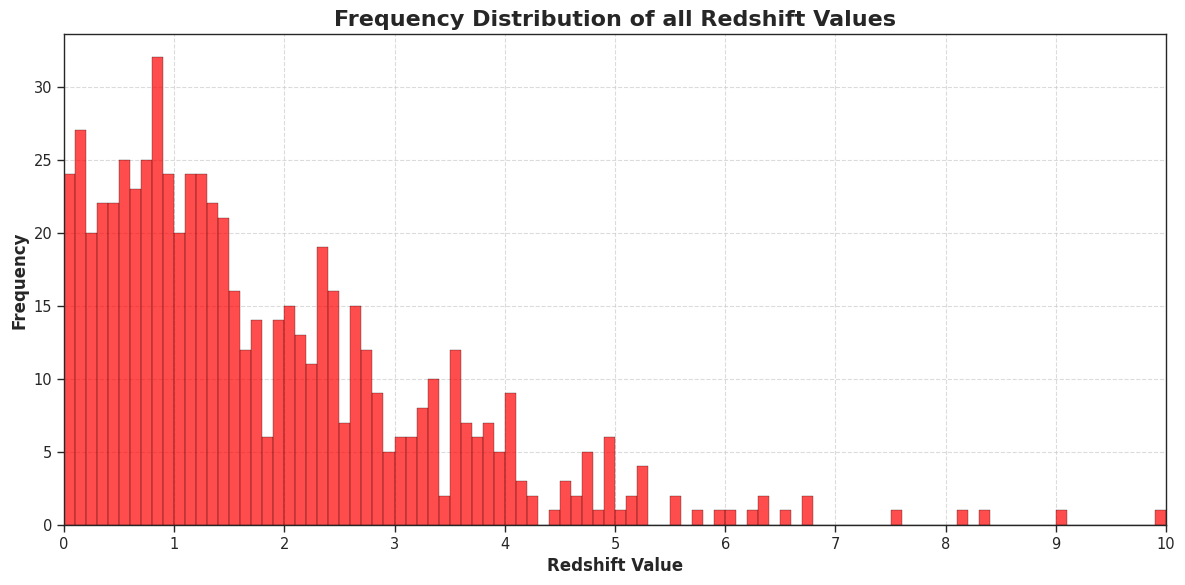

In [105]:
'''
Plot histogram for all redshifts
'''

sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.2)
plt.figure(figsize=(12, 6))
sns.histplot(redshift_values_list, bins=100, color='red', alpha=0.7, edgecolor="black", linewidth=0.2)
plt.xlabel('Redshift Value', fontsize=12, fontweight="bold")
plt.ylabel('Frequency', fontsize=12, fontweight="bold")
plt.title('Frequency Distribution of all Redshift Values', fontsize=16, fontweight='bold')
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.xticks(range(0, 11))
plt.xlim(0, 10)
plt.tight_layout()
plt.show()

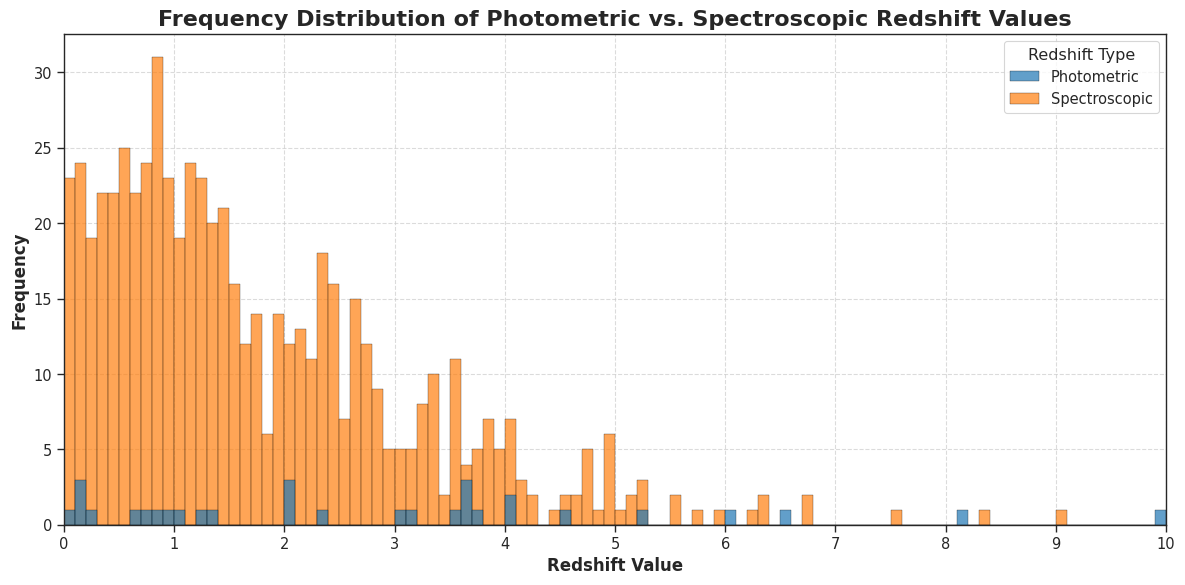

In [106]:
'''
Build histogram for photometric vs spectroscopic redshifts.
'''

# Create combined dataframe of both types of redshifts
photometric_df = pd.DataFrame({'Redshift': photometric_redshifts, 'Redshift Type': 'Photometric'})
spectroscopic_df = pd.DataFrame({'Redshift': spectroscopic_redshifts, 'Redshift Type': 'Spectroscopic'})
combined_df = pd.concat([photometric_df, spectroscopic_df])
combined_df.reset_index(drop=True, inplace=True)

# Create overlayed histogram
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.2)
plt.figure(figsize=(12, 6))
sns.histplot(data=combined_df, x='Redshift', bins=100, hue='Redshift Type', alpha=0.7, edgecolor="black", linewidth=0.2)
plt.xlabel('Redshift Value', fontsize=12, fontweight="bold")
plt.ylabel('Frequency', fontsize=12, fontweight="bold")
plt.title('Frequency Distribution of Photometric vs. Spectroscopic Redshift Values', fontsize=16, fontweight='bold')
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.xticks(range(0, 11))
plt.xlim(0, 10)
plt.tight_layout()
plt.show()
